In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Basic Imports

In [96]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [97]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 50

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [98]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [99]:
from scipy.optimize import minimize

### Ansatz State

In [100]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [101]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [102]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [103]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [104]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [105]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [106]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [107]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    print(sum(proba_distribution.values()))
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    print(counts)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [108]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(reduced_pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [109]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [110]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [111]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [112]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [113]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [114]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [115]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [116]:
approximated_energies = []

In [117]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [118]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [119]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [120]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [121]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

1it [00:00,  4.72it/s]

{'1110': 228, '1101': 34, '0100': 56, '1111': 40, '0110': 15, '1001': 101, '1010': 299, '1100': 133, '0001': 6, '1000': 17, '0010': 3, '0101': 21, '0011': 46, '1011': 2, '0000': 23}
1.0


3it [00:00,  4.86it/s]

{'1010': 104, '1101': 52, '0100': 36, '1011': 68, '1110': 180, '1000': 53, '1111': 207, '0011': 39, '1100': 32, '0111': 13, '0000': 31, '1001': 153, '0101': 21, '0001': 20, '0110': 13, '0010': 2}
1.0
{'1100': 156, '0101': 38, '1110': 43, '0111': 116, '1010': 156, '0001': 60, '1111': 104, '1011': 40, '0011': 123, '0010': 29, '0000': 20, '1101': 25, '1001': 64, '0110': 17, '0100': 33}
1.0


5it [00:00,  5.44it/s]

{'1110': 135, '1011': 135, '0010': 1, '1001': 122, '1010': 66, '1101': 14, '1111': 202, '1000': 58, '1100': 103, '0101': 62, '0111': 21, '0011': 19, '0110': 37, '0100': 13, '0000': 36}
1.0
{'1011': 138, '0110': 43, '1111': 204, '1101': 12, '1010': 67, '1110': 129, '0101': 79, '1100': 103, '0000': 29, '1001': 111, '0111': 18, '1000': 48, '0011': 11, '0010': 6, '0001': 1, '0100': 25}
1.0


7it [00:01,  5.84it/s]

{'0101': 77, '1110': 137, '1100': 96, '1010': 63, '1001': 119, '0100': 16, '1111': 177, '1011': 152, '0110': 44, '1000': 65, '0000': 28, '1101': 19, '0011': 11, '0111': 18, '0001': 2}
1.0
{'0101': 8, '1110': 195, '1001': 17, '1010': 285, '1000': 47, '1011': 33, '1100': 136, '1101': 103, '0111': 50, '0100': 77, '0110': 11, '0000': 9, '0001': 30, '1111': 13, '0010': 4, '0011': 6}
1.0


9it [00:01,  5.42it/s]

{'1100': 68, '1110': 190, '1000': 110, '0000': 49, '1101': 66, '0111': 55, '0110': 129, '1010': 71, '0010': 120, '0001': 28, '1111': 19, '1001': 17, '1011': 29, '0101': 28, '0100': 39, '0011': 6}
1.0
{'1001': 81, '1010': 282, '0011': 48, '1100': 159, '0101': 24, '1110': 227, '0000': 26, '1011': 1, '0110': 12, '0100': 54, '1000': 25, '1101': 26, '1111': 38, '0111': 2, '0001': 17, '0010': 2}
1.0


11it [00:01,  6.21it/s]

{'1100': 141, '1001': 73, '1010': 291, '0001': 16, '0000': 27, '1000': 23, '1110': 231, '0100': 58, '1111': 31, '0011': 56, '0110': 14, '0101': 15, '1101': 39, '0111': 2, '1011': 2, '0010': 5}
1.0
{'1110': 242, '1010': 265, '1001': 85, '1111': 31, '1101': 28, '0100': 63, '1100': 152, '0000': 32, '0011': 48, '0101': 17, '0010': 7, '1000': 23, '0110': 14, '0001': 11, '0111': 5, '1011': 1}
1.0


13it [00:02,  6.54it/s]

{'1001': 80, '1010': 278, '1100': 146, '0011': 68, '1110': 224, '0110': 19, '1111': 34, '1000': 30, '0001': 13, '0100': 46, '1101': 30, '0000': 27, '0101': 22, '0010': 5, '0111': 2}
1.0
{'1101': 45, '0110': 156, '0001': 69, '0000': 41, '1000': 152, '0010': 90, '1110': 219, '0111': 13, '1100': 37, '1011': 84, '0100': 30, '0101': 21, '0011': 15, '1010': 48, '1111': 4}
1.0


15it [00:02,  5.95it/s]

{'1110': 221, '1000': 25, '1001': 77, '1010': 288, '1111': 33, '1101': 30, '0011': 45, '1100': 153, '0100': 63, '0110': 17, '0101': 17, '0000': 34, '0001': 12, '1011': 1, '0111': 6, '0010': 2}
1.0
{'1001': 81, '1010': 312, '1110': 208, '1101': 30, '0100': 59, '1000': 34, '0011': 44, '1100': 148, '1111': 41, '0101': 15, '0001': 6, '0111': 5, '0000': 22, '1011': 1, '0110': 11, '0010': 7}
1.0


17it [00:02,  6.24it/s]

{'1110': 208, '1111': 61, '1100': 135, '0011': 61, '0001': 15, '1010': 266, '0100': 56, '1101': 31, '1000': 30, '0000': 35, '1001': 85, '0110': 10, '0111': 3, '0101': 21, '1011': 3, '0010': 4}
1.0
{'1100': 141, '0101': 25, '1110': 248, '0001': 9, '1001': 87, '1010': 272, '0100': 67, '1111': 39, '1000': 18, '0010': 5, '0011': 51, '0000': 18, '1101': 36, '0110': 6, '0111': 2}
1.0


18it [00:03,  5.94it/s]

{'0100': 29, '1101': 53, '0000': 40, '1000': 133, '1110': 235, '1100': 47, '1011': 77, '0110': 156, '0001': 68, '0111': 17, '0010': 91, '1010': 39, '0101': 18, '0011': 13, '1111': 8}
1.0


20it [00:03,  5.66it/s]

{'0111': 15, '1101': 58, '0110': 181, '1000': 137, '0000': 34, '1110': 245, '1100': 50, '0010': 99, '0100': 25, '0101': 17, '1011': 60, '0001': 50, '1010': 40, '0011': 10, '1111': 3}
1.0
{'1010': 286, '1110': 227, '0101': 21, '0100': 56, '1100': 153, '1111': 43, '0010': 7, '1000': 28, '0001': 15, '1001': 78, '0011': 40, '1101': 25, '0000': 29, '0111': 6, '0110': 8, '1011': 2}
1.0


21it [00:03,  6.21it/s]

{'1000': 29, '0000': 37, '1001': 86, '1010': 254, '1100': 174, '1110': 204, '0100': 52, '1101': 45, '1111': 44, '0011': 49, '0101': 16, '0010': 4, '0111': 4, '0001': 11, '0110': 13, '1011': 2}
1.0


23it [00:04,  5.46it/s]

{'0011': 56, '1100': 134, '1110': 221, '0110': 12, '1000': 30, '1001': 89, '1010': 288, '1101': 32, '0000': 19, '0001': 13, '0111': 3, '0100': 51, '1111': 54, '0101': 16, '0010': 5, '1011': 1}
1.0
{'0101': 23, '1110': 234, '0100': 52, '1101': 34, '1100': 147, '1001': 73, '1010': 287, '1111': 39, '1000': 36, '0011': 46, '0001': 9, '0000': 24, '0110': 11, '0111': 7, '0010': 2}
1.0


25it [00:04,  6.17it/s]

{'0011': 50, '1100': 156, '1110': 238, '0000': 24, '1000': 32, '1010': 269, '0100': 50, '0111': 4, '1111': 39, '1001': 77, '0101': 26, '1101': 35, '0001': 6, '0110': 9, '0010': 5, '1011': 4}
1.0
{'1110': 234, '1001': 86, '1010': 269, '0100': 49, '0011': 49, '1100': 151, '0110': 15, '0000': 25, '1101': 33, '1111': 36, '0001': 9, '0111': 7, '1011': 4, '0101': 28, '1000': 28, '0010': 1}
1.0


27it [00:04,  5.80it/s]


{'1111': 38, '1010': 295, '1001': 104, '1110': 204, '0000': 33, '1000': 26, '0100': 41, '1101': 34, '0101': 20, '1100': 153, '0110': 9, '0011': 46, '0111': 6, '0010': 2, '1011': 4, '0001': 9}
1.0
{'1110': 230, '0000': 23, '1001': 85, '1010': 272, '0100': 49, '1100': 156, '0010': 6, '0111': 6, '0001': 18, '0011': 44, '1101': 31, '1111': 47, '1000': 25, '0101': 18, '0110': 14}
1.0


2it [00:00,  7.34it/s]

{'0100': 81, '1101': 55, '1001': 70, '1010': 256, '0011': 28, '1100': 231, '1110': 105, '0110': 66, '0000': 15, '1011': 18, '1000': 40, '0010': 16, '0111': 16, '1111': 11, '0001': 14, '0101': 2}
1.0
{'0111': 18, '1110': 298, '1010': 156, '1001': 67, '1111': 94, '0110': 34, '0100': 76, '0011': 59, '0000': 3, '1100': 30, '1011': 68, '0001': 27, '1000': 70, '0101': 18, '1101': 6}
1.0


4it [00:00,  6.81it/s]

{'1110': 121, '1101': 52, '0100': 36, '0110': 21, '0010': 99, '0011': 108, '1100': 235, '1010': 129, '0001': 98, '1001': 25, '1111': 55, '0101': 15, '0111': 16, '0000': 8, '1011': 4, '1000': 2}
1.0
{'1000': 118, '0101': 41, '1110': 205, '0110': 49, '1111': 62, '1011': 56, '1100': 117, '1001': 114, '1101': 22, '1010': 88, '0100': 28, '0011': 64, '0000': 25, '0001': 2, '0010': 23, '0111': 10}
1.0


6it [00:00,  7.40it/s]

{'0011': 56, '1100': 166, '1011': 49, '0101': 41, '0110': 42, '1111': 44, '1001': 124, '0000': 27, '1110': 196, '1010': 93, '1000': 110, '0010': 24, '0100': 34, '0111': 8, '1101': 9, '0001': 1}
1.0
{'1110': 192, '0100': 45, '0011': 52, '1100': 124, '1001': 143, '1010': 105, '1000': 111, '1011': 51, '1101': 7, '0110': 37, '0010': 25, '1111': 55, '0101': 39, '0000': 26, '0001': 1, '0111': 11}
1.0


8it [00:01,  8.06it/s]

{'0000': 39, '1010': 293, '0110': 41, '1111': 68, '1110': 219, '1011': 7, '1101': 62, '0100': 55, '1100': 45, '0010': 50, '0101': 29, '1000': 78, '0111': 21, '0001': 6, '0011': 8, '1001': 3}
1.0
{'1110': 146, '0000': 63, '1000': 193, '1010': 72, '1100': 84, '0010': 164, '1101': 41, '0100': 34, '1001': 7, '1111': 71, '1011': 4, '0101': 68, '0011': 6, '0110': 67, '0111': 2, '0001': 2}
1.0


10it [00:01,  7.40it/s]

{'1101': 43, '0100': 75, '1100': 256, '1010': 232, '0111': 7, '1110': 131, '1111': 12, '0110': 60, '1000': 45, '1001': 66, '1011': 19, '0000': 15, '0010': 21, '0011': 32, '0101': 2, '0001': 8}
1.0
{'0001': 6, '1001': 67, '1000': 45, '0000': 13, '0110': 70, '0100': 75, '1101': 49, '1110': 128, '1010': 240, '1100': 222, '0011': 41, '1011': 27, '0010': 24, '1111': 7, '0111': 9, '0101': 1}
1.0


12it [00:01,  7.65it/s]

{'1110': 117, '1100': 234, '1011': 27, '0010': 29, '1101': 47, '1010': 263, '1001': 62, '0110': 70, '0011': 34, '0100': 72, '1000': 34, '0111': 5, '0000': 15, '0001': 7, '1111': 6, '0101': 2}
1.0
{'1001': 62, '0001': 6, '1010': 240, '1110': 139, '1100': 216, '1011': 21, '0100': 85, '0110': 66, '0011': 40, '1101': 51, '1000': 48, '0111': 7, '0000': 14, '0010': 19, '1111': 8, '0101': 2}
1.0


14it [00:01,  7.63it/s]

{'1110': 350, '0000': 86, '1011': 59, '0110': 58, '1100': 44, '1101': 29, '0001': 43, '1001': 14, '0100': 32, '0111': 15, '0010': 154, '0011': 15, '1000': 49, '0101': 8, '1111': 26, '1010': 42}
1.0
{'1001': 68, '1010': 235, '0011': 39, '1100': 250, '0010': 26, '1011': 18, '1000': 39, '0100': 80, '1110': 130, '1101': 56, '0110': 49, '0000': 15, '0101': 1, '1111': 10, '0001': 3, '0111': 5}
1.0


16it [00:02,  6.40it/s]

{'0011': 35, '1100': 253, '0110': 57, '1010': 252, '1101': 49, '0100': 78, '1110': 111, '1000': 43, '0010': 20, '1001': 66, '0000': 11, '1011': 22, '0111': 11, '0101': 2, '0001': 7, '1111': 7}
1.0
{'0000': 20, '1110': 128, '1001': 76, '1010': 242, '0100': 87, '1101': 52, '1111': 8, '1100': 202, '0010': 34, '0110': 56, '1011': 25, '0011': 32, '1000': 45, '0001': 8, '0101': 4, '0111': 5}
1.0


18it [00:02,  7.10it/s]

{'1001': 79, '1010': 224, '0011': 44, '1100': 220, '0000': 13, '1000': 43, '0100': 94, '0110': 82, '0101': 5, '1110': 115, '0010': 17, '1101': 49, '1111': 11, '1011': 16, '0111': 8, '0001': 4}
1.0
{'1100': 73, '1011': 46, '0010': 162, '0000': 72, '1101': 28, '0100': 38, '1110': 345, '0110': 67, '1000': 52, '1111': 26, '1001': 11, '0001': 36, '1010': 39, '0011': 11, '0101': 6, '0111': 12}
1.0


20it [00:02,  7.08it/s]

{'1100': 49, '0110': 45, '0010': 156, '0001': 38, '1010': 30, '1101': 38, '1110': 365, '0000': 94, '1111': 22, '0111': 21, '1000': 33, '1011': 68, '0011': 11, '0101': 5, '0100': 35, '1001': 14}
1.0
{'0011': 50, '1100': 219, '1010': 259, '0111': 8, '1110': 123, '1101': 55, '0110': 66, '0010': 22, '1001': 62, '0001': 9, '0100': 73, '1011': 17, '1000': 37, '1111': 9, '0101': 1, '0000': 14}
1.0


22it [00:03,  6.81it/s]

{'0011': 43, '1100': 224, '0110': 58, '1111': 10, '1110': 123, '1001': 66, '1010': 263, '0111': 7, '0000': 15, '0100': 71, '1000': 42, '1011': 22, '1101': 52, '0101': 2, '0001': 6, '0010': 20}
1.0
{'0010': 19, '1110': 135, '0110': 50, '1100': 250, '1001': 66, '1010': 225, '0100': 81, '1000': 47, '0011': 50, '1011': 17, '1101': 47, '0111': 10, '0000': 12, '0101': 4, '1111': 9, '0001': 2}
1.0


24it [00:03,  7.23it/s]

{'1000': 62, '0001': 11, '1010': 248, '0100': 67, '1101': 63, '1100': 216, '1110': 119, '0110': 52, '0111': 11, '1001': 59, '0011': 32, '0010': 29, '0000': 14, '1111': 10, '1011': 30, '0101': 1}
1.0
{'1100': 205, '0000': 13, '0111': 14, '1001': 73, '1010': 247, '1110': 126, '0010': 24, '1101': 56, '1011': 37, '1000': 46, '0110': 55, '0100': 78, '0011': 38, '1111': 4, '0001': 7, '0101': 1}
1.0


26it [00:03,  6.94it/s]

{'0100': 72, '1101': 41, '1100': 243, '0010': 26, '1011': 24, '1010': 234, '0110': 49, '1110': 136, '0011': 48, '1001': 58, '0000': 8, '0111': 16, '1000': 51, '1111': 8, '0001': 7, '0101': 3}
1.0
{'0110': 48, '0100': 83, '1001': 65, '1010': 256, '1000': 51, '0011': 45, '1100': 209, '1110': 121, '1101': 60, '0000': 15, '1111': 8, '0111': 10, '0010': 23, '0001': 11, '0101': 6, '1011': 13}
1.0


27it [00:03,  7.14it/s]


{'1110': 120, '1100': 225, '1111': 9, '0110': 82, '1001': 60, '1010': 228, '0100': 96, '1101': 64, '1000': 45, '1011': 27, '0001': 2, '0011': 28, '0010': 16, '0000': 17, '0111': 3, '0101': 2}
1.0


1it [00:00,  6.25it/s]

{'1001': 30, '0001': 21, '1010': 257, '1110': 168, '1100': 199, '0000': 27, '1000': 27, '0110': 110, '0011': 22, '1101': 59, '0010': 42, '0101': 39, '0111': 2, '1111': 11, '0100': 8, '1011': 2}
1.0


2it [00:00,  7.64it/s]

{'1110': 319, '1010': 83, '1001': 102, '0001': 60, '1000': 80, '1111': 82, '1011': 42, '0100': 68, '0111': 38, '0110': 33, '0101': 30, '1100': 35, '0000': 38, '1101': 8, '0011': 2, '0010': 4}
1.0
{'0011': 78, '1100': 206, '1110': 162, '0000': 4, '1010': 147, '0001': 103, '0100': 84, '0010': 50, '1011': 25, '1111': 127, '1101': 7, '0111': 8, '0101': 15, '0110': 6, '1001': 2}
1.0


4it [00:00,  6.72it/s]

{'1001': 68, '1010': 89, '0011': 56, '0101': 23, '1110': 170, '1011': 93, '0010': 58, '1111': 80, '0111': 9, '1100': 108, '1000': 136, '0110': 40, '0001': 18, '0100': 51, '1101': 12, '0000': 13}
1.0


5it [00:00,  6.43it/s]

{'1101': 19, '1010': 93, '1001': 79, '0001': 5, '0101': 30, '1110': 190, '1000': 132, '1011': 81, '0010': 63, '0011': 69, '0100': 39, '1100': 96, '1111': 68, '0110': 38, '0000': 15, '0111': 7}
1.0


6it [00:00,  6.72it/s]

{'0011': 66, '0010': 57, '1011': 94, '1110': 181, '1000': 129, '0100': 29, '0110': 46, '1010': 98, '1111': 76, '1001': 69, '0001': 16, '1100': 101, '0000': 15, '0101': 27, '1101': 13, '0111': 7}
1.0


7it [00:01,  6.42it/s]

{'1100': 122, '0011': 16, '1010': 334, '1110': 135, '0110': 41, '1111': 66, '0100': 21, '1101': 49, '1000': 44, '0000': 89, '0101': 59, '0010': 29, '1011': 3, '1001': 8, '0111': 6, '0001': 2}
1.0


8it [00:01,  6.36it/s]

{'0000': 120, '1000': 78, '1010': 185, '1101': 55, '1110': 210, '0101': 86, '1100': 48, '0010': 111, '0110': 57, '1001': 25, '1111': 35, '0011': 4, '1011': 4, '0111': 2, '0001': 3, '0100': 1}
1.0


9it [00:01,  6.53it/s]

{'1100': 166, '0011': 18, '1010': 287, '0110': 136, '0101': 35, '1110': 142, '1101': 68, '1011': 4, '1001': 40, '0000': 26, '0010': 27, '0100': 15, '0001': 21, '1000': 28, '1111': 10, '0111': 1}
1.0


10it [00:01,  6.63it/s]

{'1001': 31, '1010': 250, '1110': 176, '0101': 39, '0000': 25, '1000': 35, '1100': 181, '0110': 122, '1101': 55, '0001': 26, '0011': 15, '0010': 38, '0100': 12, '1011': 5, '0111': 1, '1111': 13}
1.0


11it [00:01,  6.65it/s]

{'0110': 113, '1100': 190, '1010': 254, '1110': 166, '0101': 41, '0010': 25, '0000': 13, '1101': 66, '0011': 28, '0001': 25, '1001': 40, '1000': 34, '1111': 7, '0100': 15, '1011': 6, '0111': 1}
1.0


12it [00:01,  6.48it/s]

{'0001': 20, '1010': 259, '0110': 110, '1100': 179, '0000': 31, '1101': 66, '1011': 8, '1110': 173, '1001': 36, '0101': 35, '1111': 11, '1000': 27, '0011': 22, '0010': 32, '0100': 15}
1.0


13it [00:01,  6.62it/s]

{'1010': 90, '1110': 315, '0100': 27, '1101': 61, '0000': 162, '1000': 60, '1111': 30, '1100': 66, '0001': 22, '1001': 17, '0110': 67, '0010': 45, '0011': 27, '0111': 19, '0101': 8, '1011': 8}
1.0


14it [00:02,  6.56it/s]

{'1110': 156, '1010': 255, '0001': 23, '1001': 30, '1100': 165, '0011': 27, '0110': 117, '0000': 39, '1101': 66, '0101': 43, '1111': 17, '1000': 40, '0111': 1, '0010': 23, '1011': 5, '0100': 17}
1.0


15it [00:02,  6.97it/s]

{'0101': 32, '1110': 160, '1101': 60, '1000': 31, '0011': 20, '1100': 184, '1010': 269, '0110': 126, '0111': 5, '1011': 6, '1001': 27, '0000': 31, '0001': 23, '0010': 24, '0100': 14, '1111': 12}
1.0


16it [00:02,  6.92it/s]

{'1010': 270, '1100': 159, '1000': 40, '0101': 41, '1110': 159, '1111': 13, '0110': 115, '1101': 70, '0100': 11, '1001': 36, '0011': 15, '0001': 27, '0010': 24, '0111': 3, '0000': 40, '1011': 1}
1.0
{'1001': 41, '1010': 244, '1111': 17, '0110': 126, '0101': 37, '1110': 150, '0000': 34, '1100': 164, '0011': 28, '0100': 14, '1000': 31, '1101': 75, '0010': 32, '0001': 20, '1011': 11}

18it [00:02,  6.49it/s]


1.0
{'0000': 146, '1110': 336, '0110': 62, '0010': 56, '0100': 23, '0001': 39, '1010': 81, '1100': 49, '0011': 26, '1011': 9, '1111': 34, '1101': 54, '1000': 65, '0101': 9, '0111': 14, '1001': 21}
1.0


20it [00:03,  6.53it/s]

{'0001': 33, '0100': 24, '1110': 344, '0011': 25, '1000': 56, '0000': 149, '0110': 65, '1111': 32, '1010': 90, '1100': 60, '1101': 45, '0010': 46, '1001': 19, '0111': 20, '0101': 9, '1011': 7}
1.0
{'0011': 23, '1100': 183, '1010': 241, '0101': 54, '1110': 162, '0110': 135, '1101': 80, '0010': 22, '1001': 25, '0000': 27, '1000': 16, '1111': 14, '0111': 6, '0100': 9, '0001': 21, '1011': 6}
1.0


22it [00:03,  6.48it/s]

{'0101': 39, '1110': 159, '0011': 20, '1100': 185, '0100': 13, '1010': 274, '0110': 118, '1000': 35, '0001': 18, '1001': 27, '1101': 77, '0010': 21, '1011': 8, '1111': 7, '0111': 3, '0000': 20}
1.0
{'0110': 136, '1100': 190, '0000': 34, '1010': 233, '1001': 25, '0101': 50, '1110': 154, '1101': 61, '1000': 32, '0010': 25, '0001': 31, '1111': 9, '0011': 13, '0100': 18, '1011': 12, '0111': 1}
1.0


24it [00:03,  6.66it/s]

{'1100': 196, '1000': 25, '1110': 169, '0100': 15, '1101': 64, '0001': 25, '1010': 248, '0110': 119, '1001': 29, '1011': 4, '0010': 25, '0101': 41, '0000': 41, '0011': 13, '0111': 1, '1111': 9}
1.0
{'0010': 35, '1100': 192, '1001': 39, '1010': 253, '1110': 154, '0110': 130, '0000': 23, '1101': 67, '0011': 22, '1000': 36, '0100': 12, '0101': 29, '0001': 22, '1011': 5, '1111': 3, '0111': 2}
1.0


26it [00:03,  6.46it/s]

{'0011': 19, '1100': 186, '0110': 138, '0001': 24, '1001': 41, '0010': 26, '0101': 37, '1110': 154, '1010': 254, '1000': 28, '0000': 26, '1101': 62, '1111': 11, '0111': 3, '0100': 10, '1011': 5}
1.0
{'1010': 282, '1001': 32, '1110': 165, '0110': 112, '1100': 153, '1101': 65, '0100': 15, '1000': 39, '0010': 27, '0011': 20, '0101': 33, '1111': 15, '0001': 19, '0000': 42, '1011': 4, '0111': 1}
1.0


27it [00:04,  6.48it/s]


{'0110': 126, '1111': 15, '1001': 33, '1010': 269, '1110': 152, '0011': 26, '1100': 190, '1000': 31, '0000': 30, '0101': 35, '0100': 13, '1101': 48, '0010': 28, '1011': 6, '0001': 19, '0111': 3}
1.0


1it [00:00,  8.08it/s]

{'0001': 34, '1010': 214, '1100': 204, '0000': 9, '0110': 50, '1111': 45, '0100': 91, '1110': 124, '1001': 97, '0101': 39, '0011': 57, '0010': 8, '1011': 24, '1101': 18, '0111': 6, '1000': 4}
1.0


2it [00:00,  8.09it/s]

{'1100': 44, '0100': 89, '1110': 246, '0010': 45, '1000': 153, '1010': 88, '1111': 85, '0111': 28, '1011': 72, '1001': 50, '0011': 40, '0101': 25, '0001': 17, '1101': 15, '0000': 24, '0110': 3}
1.0


3it [00:00,  7.61it/s]

{'0011': 93, '1100': 168, '1111': 11, '0110': 61, '1101': 114, '0001': 46, '1010': 175, '1011': 7, '0010': 50, '0000': 92, '1110': 129, '0100': 36, '0111': 20, '1001': 16, '1000': 5, '0101': 1}
1.0


4it [00:00,  6.10it/s]

{'0101': 49, '1110': 268, '0011': 41, '1100': 198, '1010': 63, '1001': 111, '0000': 90, '0110': 65, '1111': 25, '1011': 57, '0100': 30, '1000': 11, '0001': 14, '1101': 1, '0111': 1}
1.0


5it [00:00,  6.99it/s]

{'1110': 261, '1111': 25, '0110': 65, '1100': 201, '0001': 9, '1001': 120, '0000': 97, '0100': 30, '1010': 56, '1011': 46, '0101': 45, '0011': 45, '1000': 14, '1101': 6, '0111': 4}
1.0


6it [00:00,  6.61it/s]

{'1010': 60, '0001': 23, '1100': 186, '1110': 251, '0101': 47, '1011': 61, '0000': 75, '0110': 69, '1001': 129, '0011': 48, '0100': 33, '1101': 6, '1111': 19, '1000': 10, '0111': 5, '0010': 2}
1.0


7it [00:01,  6.93it/s]

{'1001': 22, '1010': 151, '0100': 67, '1101': 83, '1110': 215, '0101': 61, '1100': 122, '1111': 91, '0011': 47, '0000': 37, '0010': 34, '0111': 27, '1000': 52, '1011': 9, '0001': 5, '0110': 1}
1.0


8it [00:01,  7.05it/s]

{'1110': 157, '0101': 125, '0010': 73, '1000': 174, '1100': 96, '0110': 89, '1111': 97, '1010': 47, '0001': 32, '1001': 19, '1101': 35, '0100': 34, '0011': 16, '0000': 9, '0111': 13, '1011': 8}
1.0


9it [00:01,  6.27it/s]

{'1001': 103, '1010': 201, '1111': 47, '0101': 33, '1110': 134, '0011': 70, '1100': 204, '0010': 8, '1101': 21, '0001': 39, '0100': 82, '0111': 9, '0000': 10, '0110': 38, '1000': 4, '1011': 21}
1.0


10it [00:01,  6.61it/s]

{'1010': 213, '0001': 41, '0100': 90, '1101': 18, '1100': 202, '0011': 60, '1110': 120, '1011': 24, '1001': 105, '0111': 11, '1111': 58, '0000': 9, '0101': 27, '0010': 3, '0110': 41, '1000': 2}
1.0


11it [00:01,  6.75it/s]

{'1010': 182, '0001': 31, '1001': 125, '1110': 127, '0101': 31, '1111': 51, '0110': 41, '1100': 187, '0100': 98, '0111': 10, '1101': 23, '0011': 59, '1011': 24, '0000': 20, '0010': 8, '1000': 7}
1.0


12it [00:01,  6.42it/s]

{'1011': 27, '1010': 227, '1001': 112, '1110': 128, '1111': 42, '0110': 41, '0011': 58, '1100': 182, '1101': 22, '0001': 39, '0111': 5, '0101': 34, '0100': 74, '0000': 23, '0010': 6, '1000': 4}
1.0


13it [00:01,  5.96it/s]

{'1110': 239, '0110': 93, '0011': 91, '1100': 97, '0010': 49, '1011': 58, '1001': 42, '0001': 48, '1101': 76, '0000': 59, '0111': 34, '1000': 83, '0100': 22, '1010': 32, '1111': 1}
1.0


14it [00:02,  6.45it/s]

{'1101': 17, '0100': 92, '1001': 111, '1010': 219, '0011': 64, '1111': 57, '1110': 113, '0111': 9, '0110': 42, '1100': 181, '0101': 33, '0001': 47, '1011': 19, '0000': 11, '0010': 6, '1000': 3}
1.0


15it [00:02,  7.02it/s]

{'0001': 47, '1010': 203, '0100': 91, '1110': 121, '1100': 178, '0110': 38, '1111': 51, '1011': 23, '1001': 116, '0011': 49, '0000': 14, '0101': 42, '1101': 26, '0010': 10, '0111': 10, '1000': 5}
1.0


16it [00:02,  6.58it/s]

{'0001': 39, '1010': 243, '1001': 89, '1110': 115, '0110': 34, '0011': 50, '1100': 207, '0100': 92, '0101': 28, '1101': 18, '1111': 48, '0111': 11, '0010': 9, '0000': 15, '1011': 22, '1000': 4}
1.0


17it [00:02,  6.73it/s]

{'1001': 95, '1010': 244, '1110': 139, '0011': 57, '1100': 188, '0100': 89, '0110': 45, '0000': 17, '0001': 32, '1111': 49, '0101': 26, '0010': 4, '1011': 12, '1000': 5, '0111': 11, '1101': 11}
1.0


18it [00:02,  6.32it/s]

{'1101': 81, '1110': 240, '0110': 70, '0111': 53, '1000': 68, '0001': 46, '0011': 77, '0010': 74, '0000': 65, '1100': 93, '1011': 49, '1001': 44, '1010': 38, '0100': 25, '1111': 1}
1.0


19it [00:02,  6.54it/s]

{'1100': 99, '0011': 90, '1110': 243, '0111': 36, '0001': 34, '0010': 76, '1011': 37, '1000': 93, '1101': 82, '1001': 44, '0110': 70, '1010': 34, '0000': 64, '1111': 5, '0100': 17}
1.0


20it [00:02,  6.81it/s]

{'0011': 65, '1100': 212, '0110': 36, '1111': 47, '1110': 122, '1001': 112, '0001': 28, '1010': 206, '1101': 27, '1011': 15, '0101': 40, '1000': 9, '0100': 76, '0111': 8, '0010': 6, '0000': 15}
1.0


21it [00:03,  7.10it/s]

{'0001': 45, '1001': 117, '1010': 204, '0011': 55, '1100': 197, '1111': 54, '0101': 39, '0111': 6, '0110': 47, '0000': 17, '1110': 124, '0100': 74, '1000': 2, '1011': 19, '1101': 21, '0010': 3}
1.0
{'1100': 204, '0011': 72, '1010': 199, '0001': 37, '1001': 111, '1110': 125, '1111': 44, '0100': 89, '0110': 35, '1101': 26, '0101': 30, '1011': 26, '0010': 4, '1000': 5, '0000': 10, '0111': 7}
1.0


23it [00:03,  6.59it/s]

{'0110': 45, '1101': 20, '0100': 84, '1100': 193, '1110': 112, '0101': 38, '1011': 24, '0001': 35, '1010': 209, '1001': 113, '1111': 49, '0111': 10, '0011': 68, '0000': 14, '1000': 4, '0010': 6}
1.0


24it [00:03,  6.89it/s]

{'0011': 82, '1100': 202, '1010': 210, '1001': 96, '1111': 64, '1110': 115, '0100': 85, '1101': 29, '0001': 35, '0101': 26, '0110': 38, '1000': 7, '0000': 7, '1011': 19, '0010': 6, '0111': 3}
1.0


25it [00:03,  6.77it/s]

{'0011': 58, '1100': 190, '1001': 110, '1111': 45, '1110': 121, '0000': 18, '1011': 15, '0100': 87, '1010': 226, '0001': 40, '0101': 29, '0110': 44, '1101': 23, '0111': 11, '0010': 3, '1000': 4}
1.0
{'1010': 218, '1001': 105, '1110': 135, '0101': 33, '0100': 102, '1111': 42, '0011': 53, '1100': 198, '0001': 36, '0000': 16, '1101': 18, '1011': 17, '1000': 6, '0110': 31, '0010': 8, '0111': 6}

27it [00:04,  6.63it/s]



1.0
{'1010': 191, '1001': 113, '0100': 102, '0101': 30, '1110': 125, '0011': 63, '1100': 171, '0110': 59, '0001': 42, '1101': 14, '1011': 25, '0111': 8, '1111': 59, '0000': 10, '1000': 4, '0010': 8}
1.0


2it [00:00,  9.45it/s]

{'0001': 12, '1001': 25, '1101': 51, '0010': 27, '1111': 9, '0011': 78, '1100': 144, '0000': 120, '1110': 170, '1010': 154, '0110': 158, '1011': 9, '0111': 34, '1000': 29, '0100': 3, '0101': 1}
1.0
{'0010': 16, '1111': 68, '0110': 66, '0011': 120, '1110': 258, '0000': 72, '0100': 121, '1010': 88, '1011': 84, '0101': 11, '1100': 27, '1001': 27, '0001': 17, '1101': 10, '1000': 31, '0111': 8}
1.0


3it [00:00,  7.64it/s]

{'0010': 29, '0111': 12, '0100': 100, '1101': 9, '0011': 135, '0000': 79, '1111': 60, '1010': 92, '1110': 245, '1100': 85, '0001': 92, '0110': 53, '1001': 13, '1000': 10, '1011': 4, '0101': 6}
1.0
{'0011': 118, '1010': 71, '0001': 23, '0110': 130, '1011': 34, '0100': 49, '0101': 37, '1110': 154, '1100': 98, '1001': 58, '1000': 79, '0010': 72, '1111': 63, '0000': 14, '0111': 8, '1101': 16}
1.0


6it [00:00,  6.34it/s]

{'1100': 115, '0011': 95, '0001': 21, '1110': 146, '0110': 132, '1111': 78, '1000': 82, '0000': 19, '1010': 72, '1011': 36, '0010': 44, '0100': 54, '0101': 28, '1101': 25, '1001': 61, '0111': 16}
1.0
{'0100': 53, '1000': 71, '1110': 164, '0101': 28, '1100': 114, '0011': 112, '0110': 131, '0001': 25, '0010': 49, '1010': 69, '1011': 32, '1111': 74, '1001': 49, '0000': 21, '1101': 19, '0111': 13}
1.0


7it [00:01,  6.91it/s]

{'0010': 143, '1100': 33, '0101': 93, '1110': 229, '1010': 232, '0000': 25, '1101': 44, '0100': 106, '0111': 41, '1111': 46, '0011': 4, '0110': 12, '1011': 5, '1000': 6, '1001': 2, '0001': 3}
1.0


9it [00:01,  3.82it/s]

{'0100': 108, '0010': 153, '0110': 32, '0000': 136, '1010': 92, '1110': 198, '0101': 52, '0111': 24, '1101': 29, '1111': 108, '1100': 30, '1000': 51, '0011': 6, '1001': 2, '1011': 3}
1.0
{'0110': 167, '1110': 163, '1010': 163, '0011': 69, '1100': 137, '1000': 50, '0000': 103, '1011': 5, '0001': 14, '0111': 44, '1001': 36, '1101': 30, '0010': 27, '1111': 7, '0100': 5, '0101': 4}
1.0


11it [00:02,  4.55it/s]

{'0110': 164, '1010': 134, '1001': 42, '0000': 107, '0011': 95, '1110': 182, '0010': 23, '0111': 40, '1111': 7, '0001': 7, '1100': 126, '1000': 42, '0100': 6, '1101': 36, '1011': 12, '0101': 1}
1.0
{'0110': 178, '1101': 49, '1110': 161, '0011': 83, '1100': 154, '1010': 159, '1001': 30, '0000': 104, '0111': 36, '1000': 39, '0010': 19, '0001': 3, '1111': 6, '0101': 1, '0100': 2}
1.0


13it [00:02,  5.14it/s]

{'1110': 183, '0000': 107, '0110': 181, '0111': 44, '1100': 119, '1010': 154, '1001': 35, '1101': 47, '1000': 47, '0010': 23, '0011': 59, '0001': 8, '0100': 5, '1111': 7, '1011': 5}
1.0
{'1010': 5, '1011': 34, '0010': 271, '1000': 36, '1110': 256, '1100': 82, '0110': 121, '0100': 36, '0001': 36, '1111': 20, '1001': 44, '0101': 9, '1101': 33, '0011': 20, '0000': 5, '0111': 16}
1.0


15it [00:02,  5.41it/s]

{'1110': 176, '0011': 74, '1100': 135, '1000': 30, '1001': 44, '1010': 153, '1101': 41, '0110': 171, '0000': 101, '0001': 18, '0010': 21, '0111': 38, '1111': 10, '0100': 6, '1011': 5, '0101': 1}
1.0
{'0110': 159, '1100': 124, '0000': 127, '1001': 32, '1010': 132, '1110': 205, '0010': 26, '1101': 41, '0100': 6, '0011': 80, '1000': 42, '0111': 35, '1011': 3, '0001': 5, '1111': 5, '0101': 2}
1.0


17it [00:03,  6.25it/s]

{'0110': 144, '1110': 187, '1001': 27, '1010': 159, '0000': 105, '1000': 52, '0111': 46, '1100': 143, '1101': 43, '0011': 78, '0010': 15, '0100': 5, '0001': 8, '0101': 2, '1111': 6, '1011': 4}
1.0
{'1110': 178, '0110': 170, '1100': 124, '1001': 27, '1010': 148, '0000': 107, '1000': 37, '0111': 29, '1101': 49, '0011': 95, '0010': 25, '0101': 3, '1111': 11, '0100': 6, '0001': 7, '1011': 8}
1.0


19it [00:03,  6.10it/s]

{'0001': 46, '1110': 252, '1111': 17, '0110': 115, '0111': 18, '0010': 263, '1011': 31, '0000': 11, '1101': 34, '1100': 88, '1000': 46, '0100': 34, '0101': 16, '0011': 13, '1001': 39, '1010': 1}
1.0
{'0010': 268, '0001': 43, '1110': 238, '1000': 38, '1100': 90, '0110': 116, '1101': 39, '0111': 12, '1111': 24, '0100': 40, '1010': 6, '1011': 40, '0011': 14, '1001': 39, '0000': 7, '0101': 10}
1.0


21it [00:03,  6.78it/s]

{'0110': 166, '0011': 75, '1100': 120, '0100': 9, '1101': 58, '1110': 172, '1010': 141, '1000': 37, '0000': 124, '1011': 10, '0001': 9, '0111': 46, '1001': 32, '1111': 4, '0010': 20, '0101': 1}
1.0
{'0011': 85, '1010': 150, '1110': 171, '0101': 3, '1000': 32, '0000': 116, '1101': 35, '0010': 24, '0110': 152, '1001': 39, '1100': 156, '1111': 9, '0111': 32, '1011': 10, '0001': 9, '0100': 1}
1.0


23it [00:04,  6.16it/s]

{'1010': 147, '1100': 126, '0011': 85, '0000': 122, '0010': 29, '1110': 173, '1101': 38, '0110': 163, '1111': 12, '1001': 32, '0111': 42, '0001': 11, '1000': 31, '1011': 6, '0101': 5, '0100': 2}
1.0
{'1110': 158, '1101': 58, '1100': 134, '0011': 79, '1000': 38, '0110': 144, '1010': 167, '1011': 8, '0111': 43, '0100': 7, '0000': 113, '1001': 37, '0001': 10, '0010': 21, '0101': 5, '1111': 2}
1.0


25it [00:04,  6.30it/s]

{'1001': 35, '1010': 159, '1110': 156, '0110': 154, '0000': 128, '1000': 34, '1100': 138, '1101': 48, '0111': 32, '0010': 21, '0001': 16, '1111': 9, '0011': 82, '1011': 7, '0100': 4, '0101': 1}
1.0
{'1110': 183, '0110': 175, '0011': 88, '1100': 113, '0111': 42, '0001': 7, '1010': 145, '1000': 41, '1101': 47, '1111': 14, '0010': 19, '0000': 106, '1001': 28, '0100': 6, '1011': 9, '0101': 1}
1.0


27it [00:04,  5.75it/s]


{'0010': 20, '1100': 153, '1101': 51, '0110': 181, '1110': 172, '1000': 40, '0000': 90, '0111': 39, '1010': 149, '0011': 71, '1001': 36, '1111': 4, '1011': 6, '0100': 5, '0001': 7}
1.0
{'1110': 171, '0011': 88, '1100': 153, '0110': 155, '0000': 100, '1010': 153, '0001': 14, '1101': 49, '0111': 36, '1000': 35, '1001': 33, '1111': 9, '1011': 5, '0010': 17, '0101': 3, '0100': 3}
1.0


2it [00:00,  7.48it/s]

{'0111': 11, '1010': 255, '0011': 73, '1100': 224, '1110': 123, '0100': 97, '0010': 34, '0110': 32, '0001': 10, '1011': 24, '1101': 41, '1001': 44, '0000': 24, '1111': 14, '1000': 13, '0101': 5}
1.0
{'1011': 63, '1110': 283, '1010': 171, '1001': 40, '0000': 19, '1000': 58, '1111': 103, '0011': 55, '0101': 31, '0110': 36, '0100': 32, '0001': 50, '1100': 25, '0111': 48, '1101': 9, '0010': 1}
1.0


4it [00:00,  7.51it/s]

{'0011': 120, '1100': 195, '1110': 102, '0101': 44, '1010': 173, '0010': 59, '0100': 47, '0000': 24, '0001': 42, '1101': 50, '1001': 27, '0111': 37, '1111': 55, '0110': 16, '1011': 32, '1000': 1}
1.0
{'1001': 104, '1010': 101, '0000': 18, '1000': 113, '0101': 95, '1110': 170, '1111': 91, '1100': 131, '0110': 35, '0100': 30, '0111': 32, '1011': 37, '0011': 46, '0010': 17, '0001': 4}
1.0


6it [00:00,  6.75it/s]

{'1010': 131, '1001': 75, '1100': 135, '0011': 42, '1011': 41, '1111': 104, '0101': 101, '1000': 99, '0110': 35, '1110': 172, '0111': 26, '0001': 4, '0010': 15, '0100': 32, '0000': 12}
1.0
{'1000': 99, '1111': 99, '0110': 31, '1011': 48, '1001': 106, '1010': 100, '1110': 170, '0101': 100, '0011': 47, '1100': 131, '0100': 37, '0111': 29, '0000': 13, '0010': 11, '0001': 3}
1.0


8it [00:01,  6.77it/s]

{'1010': 259, '1011': 46, '0010': 49, '0100': 93, '1110': 225, '0110': 48, '0111': 46, '1100': 95, '0101': 24, '0001': 14, '1111': 50, '1000': 40, '0011': 6, '1101': 10, '0000': 19}
1.0
{'0110': 151, '1111': 54, '1110': 157, '1100': 136, '1010': 117, '0010': 44, '1011': 42, '0000': 41, '0101': 53, '0100': 40, '1000': 142, '1001': 5, '0111': 15, '1101': 14, '0001': 10, '0011': 3}
1.0


10it [00:01,  6.32it/s]

{'1010': 252, '0000': 30, '1110': 124, '0011': 62, '1100': 219, '1101': 45, '0100': 91, '0111': 15, '0010': 36, '0110': 29, '1001': 42, '1111': 15, '1000': 23, '0001': 13, '1011': 28}
1.0
{'1001': 51, '1010': 247, '1110': 144, '0010': 27, '1011': 31, '1100': 213, '0011': 68, '0000': 32, '0100': 105, '1101': 54, '0111': 6, '1000': 8, '0110': 20, '0101': 4, '1111': 9, '0001': 5}
1.0


12it [00:01,  6.68it/s]

{'1010': 241, '1000': 17, '0000': 41, '1111': 15, '0100': 109, '1100': 214, '0011': 43, '1110': 142, '1011': 20, '0110': 26, '1101': 48, '0010': 36, '1001': 52, '0001': 12, '0111': 6, '0101': 2}
1.0
{'1001': 34, '1010': 250, '0001': 8, '1100': 217, '0011': 61, '0000': 34, '0100': 102, '1110': 151, '0010': 28, '1000': 21, '1101': 36, '1011': 31, '0111': 11, '0101': 7, '0110': 26, '1111': 7}
1.0


14it [00:02,  5.95it/s]

{'1100': 65, '1110': 359, '1000': 87, '0100': 4, '0001': 24, '1011': 82, '0010': 154, '0110': 51, '0000': 57, '1001': 12, '1010': 43, '0111': 40, '0011': 10, '1111': 18, '0101': 15, '1101': 3}
1.0
{'1000': 18, '1010': 252, '0110': 21, '0011': 60, '1101': 47, '0100': 104, '1110': 146, '0010': 26, '1011': 27, '1100': 204, '0111': 18, '1001': 40, '0000': 34, '0101': 3, '0001': 12, '1111': 12}
1.0


16it [00:02,  6.22it/s]

{'1111': 9, '0110': 34, '1110': 138, '0001': 15, '1010': 231, '0100': 117, '1100': 209, '0000': 31, '0011': 62, '1011': 24, '0010': 35, '1101': 44, '1001': 41, '1000': 17, '0111': 13, '0101': 4}
1.0
{'0011': 54, '1100': 209, '1010': 268, '1101': 48, '0100': 89, '1110': 148, '0000': 29, '1000': 19, '0101': 3, '1111': 17, '1011': 23, '0110': 21, '0111': 9, '1001': 51, '0010': 26, '0001': 10}
1.0


18it [00:02,  6.45it/s]

{'0011': 72, '1100': 224, '1001': 47, '1010': 231, '1110': 150, '1011': 38, '1101': 37, '0100': 97, '0110': 25, '0000': 28, '1000': 21, '0010': 27, '0001': 8, '0111': 10, '1111': 8, '0101': 1}
1.0
{'1110': 363, '0011': 15, '0010': 145, '1011': 71, '0110': 87, '1001': 16, '1010': 42, '0111': 32, '1000': 75, '0101': 13, '1100': 65, '0001': 29, '0000': 56, '1111': 8, '0100': 3, '1101': 4}
1.0


20it [00:03,  6.19it/s]

{'1100': 77, '1110': 346, '0010': 138, '1011': 85, '0110': 77, '1111': 16, '1001': 18, '1000': 73, '1010': 41, '0011': 23, '0000': 42, '0001': 30, '0111': 42, '0101': 11, '0100': 4, '1101': 1}
1.0
{'1110': 138, '1010': 260, '1101': 38, '0100': 122, '0010': 26, '1100': 209, '0110': 28, '0000': 21, '1111': 8, '1000': 18, '0001': 8, '0111': 7, '1001': 40, '1011': 32, '0011': 63, '0101': 6}
1.0


22it [00:03,  7.12it/s]

{'1010': 246, '1100': 228, '0010': 35, '1011': 33, '1110': 148, '0100': 89, '0111': 11, '1000': 20, '0110': 22, '0011': 50, '1111': 11, '1001': 43, '0000': 43, '1101': 34, '0001': 10, '0101': 1}
1.0
{'0000': 34, '1001': 40, '1010': 244, '1100': 219, '0010': 31, '1011': 28, '1110': 143, '1101': 31, '0011': 64, '0100': 116, '0110': 25, '1111': 7, '0101': 1, '1000': 25, '0001': 10, '0111': 6}
1.0


24it [00:03,  7.15it/s]

{'0000': 34, '1000': 22, '1110': 128, '0110': 32, '1111': 11, '0011': 56, '1100': 225, '1010': 224, '1001': 39, '0010': 39, '0100': 117, '0111': 16, '1101': 39, '1011': 29, '0001': 11, '0101': 2}
1.0
{'0111': 13, '1010': 236, '1001': 43, '1100': 234, '0011': 57, '1110': 154, '1101': 42, '0100': 98, '0110': 21, '0000': 30, '1011': 29, '0010': 36, '1000': 6, '0001': 10, '0101': 3, '1111': 12}
1.0


26it [00:03,  7.97it/s]

{'1100': 205, '0011': 58, '1010': 230, '1101': 38, '0100': 107, '1011': 31, '0010': 33, '0000': 35, '1110': 154, '1000': 21, '1001': 40, '0111': 14, '1111': 12, '0001': 13, '0101': 7, '0110': 26}
1.0
{'0011': 52, '1100': 230, '1010': 270, '0101': 4, '1110': 145, '0010': 21, '0100': 111, '0110': 24, '1001': 50, '1011': 21, '0000': 22, '1101': 37, '1111': 10, '1000': 14, '0001': 4, '0111': 9}
1.0


27it [00:03,  6.88it/s]


{'1100': 236, '0011': 41, '0110': 35, '1011': 28, '0010': 43, '1010': 248, '1110': 143, '0100': 97, '1101': 28, '1000': 19, '1001': 45, '0111': 15, '0101': 3, '0000': 29, '1111': 10, '0001': 4}
1.0


2it [00:00,  5.32it/s]

{'0101': 22, '1110': 93, '0011': 22, '1100': 296, '0110': 107, '1101': 28, '0100': 123, '0010': 46, '0000': 14, '1111': 9, '1001': 47, '1010': 164, '1011': 31, '1000': 14, '0111': 7, '0001': 1}
1.0
{'1000': 57, '1111': 116, '0110': 49, '1110': 262, '0100': 131, '0011': 84, '1011': 50, '1010': 111, '0101': 62, '1001': 26, '1100': 45, '0010': 4, '0001': 14, '0111': 5, '0000': 4, '1101': 4}
1.0


4it [00:00,  6.31it/s]

{'1110': 130, '0101': 67, '1100': 295, '0011': 77, '1011': 26, '0010': 122, '0110': 21, '1001': 57, '1111': 32, '1101': 55, '0111': 20, '0001': 19, '0100': 43, '1010': 51, '0000': 3, '1000': 6}
1.0
{'1110': 170, '0101': 36, '1100': 177, '0011': 90, '1001': 120, '1000': 75, '0000': 60, '0110': 24, '1010': 66, '0001': 24, '0010': 69, '0100': 30, '1011': 31, '0111': 11, '1111': 37, '1101': 4}
1.0


6it [00:01,  5.58it/s]

{'0110': 19, '0000': 54, '1000': 91, '1010': 70, '1001': 106, '1100': 161, '0100': 25, '1110': 181, '0010': 68, '0101': 54, '1011': 24, '1111': 41, '0111': 16, '0011': 85, '0001': 24, '1101': 5}
1.0
{'0100': 30, '0010': 75, '1010': 71, '1001': 128, '1100': 157, '0011': 84, '0101': 51, '1110': 176, '0110': 28, '1000': 75, '0000': 50, '1111': 29, '1011': 26, '0001': 24, '1101': 12, '0111': 8}
1.0


8it [00:01,  6.55it/s]

{'1101': 53, '1010': 254, '0110': 18, '1000': 56, '0000': 138, '1110': 208, '0111': 42, '0010': 96, '0100': 42, '1111': 61, '1100': 48, '1011': 3, '0011': 1, '1001': 1, '0001': 3}
1.0
{'0100': 90, '1101': 83, '0101': 14, '1110': 108, '1000': 241, '0110': 66, '0010': 184, '1100': 59, '0111': 1, '1111': 54, '1010': 78, '0000': 37, '1011': 2, '0001': 2, '0011': 3, '1001': 2}
1.0


10it [00:01,  7.13it/s]

{'1100': 262, '1110': 97, '1001': 33, '1010': 172, '1101': 22, '0100': 130, '0110': 99, '0111': 7, '0000': 20, '1011': 27, '0011': 35, '1000': 25, '0010': 72, '0101': 10, '0001': 10, '1111': 3}
1.0
{'0001': 12, '1001': 40, '1010': 157, '0100': 119, '1101': 31, '1100': 286, '1011': 32, '0110': 119, '0000': 15, '1110': 89, '0101': 11, '1000': 25, '0010': 53, '0011': 22, '1111': 3, '0111': 10}
1.0


12it [00:01,  7.18it/s]

{'1110': 88, '1100': 291, '1111': 5, '0110': 117, '1010': 162, '0001': 11, '0010': 73, '0100': 107, '1001': 47, '0011': 20, '1101': 18, '1011': 30, '1000': 20, '0101': 17, '0111': 4, '0000': 14}
1.0
{'0001': 9, '1010': 187, '1100': 277, '1110': 93, '1011': 35, '0100': 116, '1000': 24, '0110': 101, '0111': 9, '0010': 64, '1001': 45, '1111': 5, '0011': 16, '1101': 28, '0000': 9, '0101': 6}
1.0


14it [00:02,  7.31it/s]

{'0110': 78, '1000': 10, '0000': 48, '1101': 19, '0100': 82, '0010': 169, '1110': 270, '1100': 145, '1011': 77, '1111': 43, '1001': 15, '1010': 34, '0001': 27, '0111': 5, '0101': 1, '0011': 1}
1.0
{'0001': 12, '1010': 169, '1100': 252, '0011': 18, '0110': 132, '0100': 116, '0111': 13, '1011': 36, '0010': 70, '1001': 40, '1101': 24, '1110': 93, '1000': 17, '0000': 14, '0101': 15, '1111': 3}
1.0


16it [00:02,  6.84it/s]

{'0110': 116, '0010': 61, '1011': 34, '0100': 113, '1100': 257, '1110': 94, '1001': 37, '1010': 192, '0000': 23, '1101': 26, '0101': 14, '0011': 19, '1111': 6, '0111': 8, '1000': 16, '0001': 8}
1.0
{'1101': 28, '0100': 121, '0110': 126, '1010': 156, '1110': 82, '1100': 274, '0010': 62, '0111': 13, '0101': 16, '1000': 18, '1001': 49, '1011': 30, '0000': 22, '0011': 19, '0001': 4, '1111': 4}
1.0


18it [00:02,  7.02it/s]

{'0001': 8, '1010': 172, '0110': 92, '0100': 109, '0010': 70, '1011': 34, '1100': 302, '1110': 78, '1001': 43, '0011': 18, '1000': 18, '0000': 17, '0111': 9, '1101': 26, '0101': 25, '1111': 3}
1.0
{'1110': 286, '0010': 175, '0001': 26, '1111': 35, '0110': 86, '1000': 8, '1100': 150, '0100': 75, '1011': 71, '1010': 35, '0000': 49, '0101': 1, '1101': 16, '1001': 11}
1.0


20it [00:03,  7.18it/s]

{'0110': 85, '0010': 156, '1011': 78, '1010': 39, '1100': 140, '1110': 297, '0100': 81, '0000': 48, '1101': 21, '1111': 36, '1001': 15, '0001': 16, '0011': 2, '1000': 10}
1.0
{'0110': 121, '1101': 33, '0100': 131, '1100': 270, '0001': 7, '1010': 152, '1110': 96, '0010': 62, '1000': 28, '1011': 28, '0111': 5, '0011': 22, '1001': 40, '0101': 14, '1111': 6, '0000': 9}
1.0


22it [00:03,  7.46it/s]

{'1011': 32, '0010': 65, '1100': 290, '1010': 150, '1001': 37, '1110': 102, '0100': 126, '0110': 100, '0101': 14, '1101': 32, '0011': 23, '1000': 18, '0000': 21, '0111': 5, '0001': 5, '1111': 4}
1.0
{'0101': 19, '0110': 106, '0011': 19, '1100': 246, '1001': 41, '0001': 13, '1010': 186, '0010': 72, '0100': 129, '1101': 27, '1110': 91, '0000': 17, '1011': 21, '1000': 21, '0111': 11, '1111': 5}
1.0


24it [00:03,  7.65it/s]

{'1100': 280, '1001': 41, '0001': 9, '1010': 157, '0101': 13, '1110': 98, '0100': 115, '1011': 30, '0110': 112, '0011': 27, '1000': 16, '0010': 62, '1101': 34, '1111': 7, '0111': 9, '0000': 14}
1.0
{'0100': 102, '1110': 99, '0110': 121, '1001': 49, '1010': 166, '1100': 276, '0010': 65, '1000': 18, '1011': 25, '0011': 18, '1111': 5, '1101': 25, '0101': 16, '0001': 14, '0000': 16, '0111': 9}
1.0


26it [00:03,  7.41it/s]

{'1100': 305, '1110': 78, '0101': 20, '0110': 108, '0010': 51, '1010': 158, '0000': 16, '1101': 23, '1011': 35, '0100': 108, '1001': 54, '0001': 12, '0111': 11, '1000': 20, '0011': 20, '1111': 5}
1.0
{'0101': 12, '1110': 95, '0010': 60, '0001': 18, '1001': 40, '1100': 303, '0100': 110, '0110': 114, '1101': 28, '1000': 17, '0011': 22, '1010': 151, '0111': 10, '1011': 25, '0000': 12, '1111': 7}
1.0


27it [00:03,  6.76it/s]


{'0110': 110, '1100': 292, '1110': 106, '1000': 18, '0001': 11, '0100': 114, '1101': 32, '1011': 33, '0010': 56, '1010': 154, '1111': 6, '0101': 16, '1001': 40, '0011': 13, '0111': 13, '0000': 10}
1.0


1it [00:00,  7.92it/s]

{'1110': 153, '1010': 240, '0001': 22, '0100': 70, '1111': 21, '0110': 80, '0011': 72, '1100': 193, '1101': 28, '0111': 21, '1011': 13, '0010': 13, '1000': 48, '1001': 44, '0000': 1, '0101': 5}
1.0


2it [00:00,  7.32it/s]

{'0010': 16, '1011': 72, '1010': 59, '1111': 79, '0101': 35, '1110': 322, '1000': 112, '0100': 93, '0111': 37, '0011': 59, '1001': 93, '0001': 20, '0110': 21, '1101': 1, '0000': 3, '1100': 2}
1.0


3it [00:00,  7.14it/s]

{'0011': 135, '1100': 138, '1111': 36, '0100': 70, '1101': 84, '0000': 11, '1110': 145, '0001': 80, '1010': 127, '0010': 55, '0110': 80, '1001': 34, '0111': 12, '0101': 8, '1000': 5, '1011': 4}
1.0
{'1110': 209, '0011': 79, '1100': 71, '1001': 117, '1010': 111, '1000': 86, '0010': 20, '1111': 63, '1011': 45, '0110': 91, '0001': 14, '0000': 37, '0101': 71, '0111': 4, '1101': 4, '0100': 2}
1.0


5it [00:00,  6.85it/s]

{'0101': 71, '1110': 229, '1000': 96, '1011': 51, '1100': 70, '0011': 66, '1001': 107, '1111': 66, '1010': 135, '0110': 66, '0010': 15, '0000': 38, '0001': 1, '0111': 7, '0100': 6}
1.0


6it [00:00,  7.33it/s]

{'0110': 71, '1111': 51, '1110': 220, '0101': 67, '1000': 92, '1001': 142, '1011': 51, '0011': 66, '1100': 76, '1010': 114, '0000': 31, '0111': 11, '0010': 15, '0100': 5, '0001': 7, '1101': 5}
1.0


7it [00:00,  7.50it/s]

{'0101': 35, '1110': 174, '1010': 287, '0010': 27, '1111': 73, '0111': 59, '0000': 78, '1000': 85, '1100': 89, '0100': 50, '0110': 24, '1101': 25, '0011': 9, '1001': 4, '1011': 2, '0001': 3}
1.0


8it [00:01,  7.86it/s]

{'0000': 78, '1000': 183, '0101': 76, '1110': 188, '1111': 80, '0110': 70, '1100': 61, '0010': 173, '1010': 60, '0100': 9, '1011': 8, '0111': 6, '0011': 11, '1101': 10, '0001': 6, '1001': 5}
1.0


9it [00:01,  6.91it/s]

{'1001': 29, '1010': 247, '1100': 194, '0011': 73, '1110': 156, '1111': 18, '0110': 95, '0111': 21, '0100': 76, '0001': 16, '1000': 56, '0101': 2, '1101': 19, '1011': 7, '0010': 14, '0000': 1}
1.0


10it [00:01,  7.10it/s]

{'0011': 65, '1100': 190, '1000': 57, '1110': 159, '0100': 77, '0110': 92, '0111': 22, '1010': 234, '1011': 18, '1101': 25, '0101': 7, '1001': 35, '1111': 15, '0010': 6, '0001': 22}
1.0


11it [00:01,  6.99it/s]

{'1010': 222, '1100': 229, '0011': 70, '1101': 26, '0110': 87, '1110': 154, '1011': 12, '1000': 59, '0100': 76, '1001': 31, '0001': 18, '0111': 17, '0000': 2, '1111': 17, '0010': 3, '0101': 1}
1.0


12it [00:01,  7.46it/s]

{'1010': 266, '0011': 68, '1100': 167, '0110': 63, '1000': 68, '1011': 10, '1110': 160, '1101': 37, '1001': 44, '0100': 64, '0101': 6, '0010': 7, '0001': 24, '0111': 17, '1111': 21, '0000': 2}
1.0
{'0000': 145, '1000': 66, '1110': 332, '1100': 62, '1011': 58, '0111': 40, '0110': 70, '0001': 36, '0100': 42, '0011': 28, '0010': 86, '1010': 26, '1111': 8, '1001': 11, '1101': 12, '0101': 2}
1.0


14it [00:01,  6.89it/s]

{'0001': 26, '1010': 245, '1110': 149, '1100': 197, '1101': 23, '0100': 70, '0110': 98, '1000': 60, '1001': 37, '1111': 19, '0011': 61, '0111': 14, '1011': 13, '0101': 7, '0010': 5}
1.0
{'0100': 81, '1101': 27, '1010': 264, '0011': 66, '1100': 183, '1110': 146, '1011': 13, '1000': 47, '0110': 92, '1001': 34, '0111': 11, '1111': 24, '0001': 19, '0010': 8, '0101': 7, '0000': 2}
1.0


16it [00:02,  8.09it/s]

{'1110': 172, '1010': 270, '0011': 67, '1100': 196, '1000': 45, '1011': 12, '0100': 75, '1111': 11, '0110': 86, '0010': 11, '1001': 21, '1101': 22, '0111': 18, '0001': 10, '0101': 8}
1.0


17it [00:02,  7.88it/s]

{'1110': 163, '1101': 24, '0100': 82, '0110': 74, '0001': 19, '1010': 238, '0011': 77, '1100': 205, '1001': 38, '1000': 48, '1111': 14, '1011': 12, '0111': 18, '0010': 5, '0101': 7}
1.0


18it [00:02,  6.90it/s]

{'1110': 332, '0000': 120, '1000': 69, '1011': 59, '0010': 87, '0110': 70, '0111': 33, '0011': 30, '1001': 13, '1100': 76, '0001': 25, '0100': 56, '1010': 28, '1111': 12, '1101': 13, '0101': 1}
1.0


19it [00:02,  6.57it/s]

{'1110': 334, '1010': 36, '0001': 28, '0000': 111, '0110': 66, '1101': 12, '1100': 75, '0010': 94, '0100': 52, '1000': 55, '1011': 58, '0011': 34, '1001': 15, '0111': 37, '1111': 15, '0101': 2}
1.0


20it [00:02,  6.96it/s]

{'1010': 242, '1001': 39, '0100': 79, '0110': 86, '1110': 145, '0011': 70, '1100': 196, '1000': 58, '1111': 22, '0001': 17, '0101': 8, '0111': 14, '1101': 26, '0010': 13, '1011': 7, '0000': 2}
1.0


21it [00:02,  6.98it/s]

{'1110': 139, '1111': 26, '0110': 75, '1100': 219, '0011': 68, '1001': 33, '1010': 254, '0010': 6, '0100': 84, '1000': 48, '1101': 21, '1011': 11, '0111': 13, '0001': 18, '0101': 9}
1.0


22it [00:03,  6.54it/s]

{'0001': 24, '1010': 237, '1111': 16, '0110': 90, '1100': 188, '0100': 91, '1011': 7, '1110': 149, '1000': 70, '1001': 37, '0111': 27, '0011': 55, '1101': 20, '0010': 8, '0000': 2, '0101': 3}
1.0


23it [00:03,  6.58it/s]

{'1110': 168, '0110': 107, '0100': 76, '0111': 15, '1010': 244, '1100': 197, '0011': 59, '1000': 44, '1111': 19, '1011': 12, '1001': 35, '0001': 17, '1101': 21, '0010': 8, '0101': 1, '0000': 1}
1.0


24it [00:03,  7.05it/s]

{'1100': 201, '1101': 27, '0100': 86, '0110': 97, '1001': 27, '1010': 241, '1000': 53, '1011': 14, '1110': 125, '0011': 74, '0101': 6, '0001': 30, '0111': 18, '1111': 14, '0010': 11}
1.0
{'1100': 182, '0011': 75, '0100': 71, '1101': 21, '0010': 9, '0110': 105, '1010': 252, '1001': 30, '1000': 55, '1110': 144, '1011': 12, '0001': 31, '1111': 15, '0111': 12, '0101': 9, '0000': 1}
1.0
{'0011': 62, '1100': 206, '0001': 21, '1010': 245, '1000': 55, '0110': 98, '1110': 158, '0111': 25, '1101': 18, '0010': 8, '1001': 30, '0100': 65, '1111': 14, '0101': 5, '1011': 13, '0000': 1}
1.0


27it [00:03,  7.29it/s]


{'1110': 151, '1100': 208, '0011': 59, '1111': 23, '0110': 89, '1010': 228, '1000': 51, '0010': 10, '0100': 88, '1001': 36, '1011': 15, '0101': 7, '0001': 23, '0111': 13, '1101': 23}
1.0


1it [00:00,  6.76it/s]

{'0011': 43, '1100': 230, '1001': 49, '1010': 289, '0110': 66, '0000': 3, '1110': 129, '0100': 75, '1000': 36, '1011': 21, '0101': 3, '1101': 45, '1111': 9, '0010': 14, '0111': 5, '0001': 7}
1.0


2it [00:00,  6.10it/s]

{'1110': 280, '1011': 71, '1100': 25, '0011': 48, '1001': 79, '1010': 168, '1000': 84, '0110': 71, '0001': 25, '1111': 89, '0100': 27, '1101': 15, '0111': 33, '0000': 3, '0101': 6}
1.0


3it [00:00,  7.02it/s]

{'0000': 15, '1100': 240, '0010': 89, '1010': 132, '0001': 49, '0100': 44, '1110': 143, '0110': 16, '1001': 32, '0011': 117, '1101': 56, '1111': 48, '1000': 7, '0101': 22, '0111': 10, '1011': 4}
1.0


4it [00:00,  7.46it/s]

{'0011': 69, '1100': 129, '1001': 122, '1010': 132, '1110': 172, '1011': 61, '0110': 35, '0000': 57, '1000': 103, '0100': 17, '1111': 47, '0101': 38, '0111': 6, '0001': 9, '1101': 8, '0010': 19}
1.0


6it [00:00,  6.51it/s]

{'1100': 137, '1000': 97, '1011': 54, '1111': 42, '0110': 27, '0100': 10, '1110': 190, '1001': 121, '0101': 34, '1010': 139, '0011': 71, '0010': 21, '1101': 5, '0000': 57, '0001': 12, '0111': 7}
1.0
{'1001': 105, '1011': 65, '1110': 190, '1111': 55, '0000': 64, '1000': 94, '1100': 146, '0011': 61, '1010': 118, '0001': 13, '0101': 35, '0100': 16, '0111': 9, '0110': 25, '0010': 18, '1101': 10}
1.0


8it [00:01,  7.25it/s]

{'1110': 227, '1000': 85, '0000': 27, '1001': 3, '1010': 320, '0011': 15, '1100': 34, '0010': 95, '0100': 18, '0111': 13, '0101': 17, '0110': 47, '1111': 50, '1101': 53, '1011': 11, '0001': 9}
1.0
{'1010': 105, '0010': 154, '0110': 71, '1111': 55, '0011': 5, '1100': 89, '1000': 217, '0000': 36, '0100': 14, '1110': 134, '1101': 42, '1011': 13, '0101': 58, '1001': 19, '0001': 9, '0111': 3}
1.0


10it [00:01,  6.43it/s]

{'1110': 135, '1011': 32, '0001': 13, '1010': 237, '0100': 97, '1101': 47, '1100': 232, '0110': 72, '1111': 9, '0011': 40, '0010': 13, '1001': 54, '1000': 26, '0000': 12, '0101': 3, '0111': 2}
1.0
{'1110': 147, '1010': 276, '1101': 54, '0100': 93, '0110': 45, '0011': 47, '1100': 207, '1011': 22, '0010': 28, '1001': 49, '0001': 10, '0000': 7, '1000': 31, '0111': 1, '1111': 7}
1.0


11it [00:01,  6.97it/s]

{'1110': 135, '1010': 251, '1001': 52, '0011': 35, '1100': 228, '0100': 80, '1000': 42, '0110': 70, '0010': 28, '1011': 27, '0000': 9, '1101': 46, '0001': 10, '0111': 7, '1111': 2, '0101': 2}
1.0
{'1010': 248, '1001': 63, '1000': 34, '1110': 137, '1101': 51, '0011': 40, '1100': 214, '0110': 56, '0010': 36, '1111': 12, '0001': 12, '0100': 85, '0000': 3, '1011': 25, '0111': 8}
1.0


14it [00:01,  7.81it/s]

{'1110': 442, '0010': 137, '1011': 68, '0000': 91, '1000': 56, '0110': 29, '0001': 44, '1010': 43, '1101': 17, '1111': 27, '0111': 7, '0011': 4, '0100': 24, '0101': 7, '1100': 24, '1001': 4}
1.0
{'0101': 3, '1110': 118, '0011': 43, '1100': 231, '1010': 265, '1001': 49, '1000': 37, '1101': 48, '0100': 90, '0111': 5, '0110': 63, '1011': 29, '0010': 23, '1111': 4, '0000': 6, '0001': 10}
1.0


16it [00:02,  7.07it/s]

{'1001': 67, '1010': 231, '1011': 38, '0011': 42, '1100': 231, '1110': 120, '1101': 48, '0110': 56, '1000': 36, '0100': 97, '0010': 26, '0001': 8, '0000': 8, '1111': 10, '0111': 4, '0101': 2}
1.0
{'1110': 133, '0110': 70, '1100': 218, '1101': 48, '0100': 78, '1010': 261, '1011': 30, '1000': 33, '0010': 26, '0101': 1, '1001': 58, '0011': 43, '0000': 5, '1111': 7, '0001': 12, '0111': 1}
1.0


18it [00:02,  7.74it/s]

{'1110': 133, '1011': 19, '0010': 27, '1100': 203, '0100': 79, '1101': 54, '1010': 281, '0110': 66, '1000': 30, '0011': 45, '0000': 11, '1001': 47, '0001': 10, '1111': 7, '0101': 5, '0111': 7}
1.0
{'0000': 80, '1110': 455, '1011': 84, '0010': 126, '1001': 8, '0110': 22, '0011': 6, '0100': 24, '0001': 41, '1010': 47, '1100': 18, '1000': 51, '1101': 17, '1111': 21, '0111': 11, '0101': 13}
1.0


20it [00:02,  6.96it/s]

{'0010': 138, '1011': 78, '0000': 90, '0110': 29, '1110': 434, '0100': 31, '1101': 21, '1010': 43, '0001': 43, '1000': 41, '1001': 12, '1100': 17, '0111': 7, '1111': 32, '0011': 6, '0101': 2}
1.0
{'1001': 70, '1010': 279, '0011': 38, '1100': 214, '1110': 136, '0100': 87, '1000': 26, '0110': 53, '0010': 20, '1111': 9, '1011': 31, '1101': 47, '0001': 6, '0111': 4, '0000': 4}
1.0


22it [00:03,  6.81it/s]

{'0011': 45, '1100': 229, '0100': 74, '0110': 76, '1010': 242, '1011': 35, '0010': 29, '1110': 134, '1000': 36, '1001': 61, '1101': 44, '0000': 6, '0001': 7, '1111': 2, '0101': 2, '0111': 2}
1.0
{'0001': 16, '1010': 259, '0011': 29, '1100': 223, '1110': 139, '0110': 71, '1101': 50, '0100': 84, '0111': 4, '1011': 37, '0010': 18, '1000': 30, '1001': 44, '0000': 9, '1111': 10, '0101': 1}
1.0


24it [00:03,  6.60it/s]

{'0110': 64, '0100': 86, '0111': 5, '1001': 64, '1010': 256, '1100': 235, '1110': 134, '0010': 22, '1000': 26, '1111': 5, '0000': 3, '1101': 52, '1011': 24, '0011': 33, '0001': 14, '0101': 1}
1.0
{'1100': 228, '1010': 275, '1001': 66, '0010': 29, '1011': 28, '0100': 90, '1110': 112, '1000': 34, '1101': 31, '0110': 61, '0011': 46, '0000': 4, '0001': 13, '0101': 1, '0111': 2, '1111': 4}
1.0


26it [00:03,  6.72it/s]

{'0100': 108, '1101': 41, '0011': 39, '1100': 205, '0001': 9, '1010': 257, '1110': 132, '1000': 33, '0010': 25, '0110': 73, '1011': 35, '1001': 47, '0111': 4, '1111': 10, '0000': 4, '0101': 2}
1.0
{'1001': 53, '1010': 256, '1101': 42, '0100': 90, '0011': 28, '1100': 252, '1110': 138, '1011': 32, '1111': 5, '0000': 4, '0110': 58, '1000': 37, '0010': 18, '0001': 7, '0101': 2, '0111': 2}
1.0


27it [00:03,  6.90it/s]


{'0100': 91, '1100': 250, '1010': 241, '1001': 61, '1011': 40, '1110': 114, '1000': 38, '0110': 58, '1101': 42, '0010': 21, '0011': 38, '0000': 7, '0001': 10, '1111': 9, '0111': 4}
1.0


1it [00:00,  8.19it/s]

{'1010': 163, '1100': 150, '1101': 74, '0100': 139, '1110': 77, '0110': 119, '1000': 29, '1011': 62, '1111': 103, '0010': 35, '0001': 18, '0101': 18, '0011': 11, '0111': 17, '0000': 2, '1001': 7}
1.0


3it [00:00,  7.33it/s]

{'1110': 369, '0111': 133, '1010': 159, '0001': 37, '0110': 71, '0010': 10, '1000': 77, '0100': 59, '1101': 35, '1001': 31, '1011': 8, '0011': 23, '0000': 4, '1111': 8}
1.0
{'1110': 134, '0101': 20, '0011': 55, '1100': 281, '1010': 80, '1111': 37, '0010': 129, '0100': 19, '1101': 71, '0110': 61, '0000': 17, '1011': 12, '0001': 31, '0111': 62, '1001': 8, '1000': 7}
1.0


5it [00:00,  7.74it/s]

{'0101': 51, '1110': 188, '1000': 146, '0000': 79, '1001': 35, '1010': 172, '0100': 53, '0010': 20, '0011': 96, '0001': 6, '1011': 12, '0111': 37, '1100': 80, '1101': 25, '0110': 21, '1111': 3}
1.0
{'0101': 48, '1110': 173, '0111': 32, '1100': 96, '1000': 159, '0000': 74, '1010': 183, '0100': 44, '1001': 44, '0001': 11, '0110': 24, '0011': 71, '1101': 15, '0010': 35, '1011': 15}
1.0


7it [00:00,  6.81it/s]

{'1110': 214, '0101': 56, '0000': 72, '1000': 134, '1100': 92, '0011': 89, '0001': 11, '1010': 161, '0111': 40, '1001': 41, '0100': 38, '0110': 23, '1101': 18, '1011': 13, '0010': 21, '1111': 1}
1.0
{'0010': 116, '1011': 94, '1100': 12, '0110': 96, '1010': 162, '1000': 74, '0000': 45, '1101': 30, '1110': 153, '1111': 134, '0101': 56, '0001': 34, '0100': 5, '0111': 3, '1001': 7, '0011': 3}
1.0


8it [00:01,  6.98it/s]

{'1110': 107, '0101': 52, '0010': 162, '1011': 32, '1100': 90, '0011': 62, '0111': 36, '1000': 192, '1001': 36, '1111': 95, '0100': 24, '1010': 69, '0110': 27, '1101': 27, '0001': 3, '0000': 10}
1.0
{'0011': 18, '1100': 172, '0111': 23, '1011': 61, '1000': 39, '1010': 164, '1101': 68, '1111': 77, '0110': 130, '0100': 118, '0101': 13, '1110': 74, '0010': 35, '0001': 25, '1001': 5, '0000': 2}
1.0


11it [00:01,  7.67it/s]

{'0100': 140, '0110': 111, '1111': 106, '1011': 63, '1010': 143, '1110': 78, '1100': 146, '0111': 16, '1101': 79, '0001': 27, '1000': 36, '0101': 17, '0011': 17, '0010': 38, '1001': 4, '0000': 3}
1.0
{'1101': 83, '0100': 144, '1011': 79, '0111': 16, '1010': 137, '1110': 57, '0110': 105, '1100': 161, '0001': 34, '1111': 103, '0101': 16, '0010': 27, '0011': 21, '1000': 35, '0000': 1, '1001': 5}
1.0


13it [00:01,  6.95it/s]

{'1110': 79, '1010': 147, '1101': 83, '0100': 115, '1111': 94, '1011': 56, '1100': 165, '0111': 23, '0001': 22, '0101': 20, '1000': 46, '0110': 93, '0010': 46, '0011': 23, '0000': 3, '1001': 9}
1.0
{'1110': 430, '0111': 107, '1010': 20, '1001': 50, '0100': 38, '1111': 71, '0010': 125, '1011': 30, '1101': 24, '0000': 60, '0101': 7, '1000': 14, '1100': 15, '0011': 21, '0001': 12}
1.0


15it [00:02,  7.32it/s]

{'1101': 85, '1100': 148, '1111': 100, '0110': 99, '1010': 158, '0101': 18, '1110': 66, '1011': 63, '1000': 25, '0001': 33, '1001': 7, '0011': 19, '0100': 154, '0000': 3, '0111': 17, '0010': 29}
1.0
{'0110': 89, '0011': 29, '1100': 148, '1110': 65, '0101': 11, '1101': 77, '0100': 160, '1010': 150, '1111': 109, '0001': 20, '1011': 75, '0111': 17, '1000': 36, '0010': 29, '1001': 6, '0000': 3}
1.0


17it [00:02,  6.66it/s]

{'1010': 176, '1100': 146, '1110': 87, '1111': 86, '1101': 75, '0100': 112, '1000': 33, '1011': 71, '0110': 112, '0010': 25, '0111': 15, '1001': 6, '0101': 16, '0001': 38, '0011': 23, '0000': 3}
1.0
{'1111': 107, '0110': 119, '0001': 28, '1010': 129, '1100': 146, '0011': 19, '0100': 151, '1011': 80, '1101': 74, '1110': 58, '0010': 29, '1000': 38, '0111': 26, '1001': 10, '0000': 2, '0101': 8}
1.0


19it [00:02,  7.25it/s]

{'0001': 21, '1001': 54, '0111': 105, '1110': 418, '1111': 56, '1101': 28, '0100': 40, '0010': 131, '0011': 26, '0000': 45, '1011': 43, '1000': 13, '1010': 20, '0101': 12, '1100': 12}
1.0
{'1110': 439, '1000': 16, '0000': 60, '1001': 46, '0011': 21, '0010': 115, '0100': 46, '1111': 64, '1011': 30, '1101': 25, '1100': 12, '0111': 95, '1010': 25, '0001': 22, '0101': 8}
1.0


21it [00:02,  6.69it/s]

{'0111': 14, '0001': 25, '1010': 150, '0100': 131, '1000': 33, '0010': 33, '1111': 101, '0110': 133, '1100': 144, '1101': 83, '1011': 56, '0011': 24, '0101': 13, '1110': 73, '1001': 7, '0000': 4}
1.0
{'0110': 95, '1111': 98, '1101': 83, '1100': 145, '1000': 39, '1011': 63, '1110': 69, '0101': 19, '1010': 147, '0100': 142, '0010': 50, '0111': 11, '0001': 29, '0011': 20, '1001': 13, '0000': 1}
1.0


23it [00:03,  6.78it/s]

{'1111': 88, '0110': 89, '1010': 139, '1001': 13, '1011': 79, '0100': 142, '1110': 73, '1100': 163, '0111': 20, '0010': 43, '1101': 78, '1000': 36, '0101': 16, '0011': 26, '0001': 18, '0000': 1}
1.0
{'1100': 147, '0011': 15, '0010': 37, '1011': 82, '0100': 116, '1101': 78, '1111': 103, '1010': 176, '0111': 16, '1110': 62, '0001': 30, '0110': 105, '1000': 28, '0101': 20, '1001': 7, '0000': 2}
1.0


25it [00:03,  7.40it/s]

{'1100': 181, '1110': 77, '0101': 23, '0010': 30, '1101': 82, '0100': 126, '1111': 105, '1010': 128, '0110': 111, '0001': 27, '0011': 23, '1011': 66, '1000': 30, '0111': 12, '1001': 3}
1.0
{'0100': 151, '1101': 81, '1110': 63, '1100': 159, '1011': 71, '1010': 161, '0110': 89, '1111': 107, '0101': 13, '1000': 34, '0011': 23, '0001': 23, '0111': 17, '1001': 5, '0010': 27}
1.0


27it [00:03,  7.17it/s]


{'0100': 117, '1111': 99, '0110': 93, '1100': 167, '0001': 35, '1011': 81, '0010': 32, '0111': 11, '1101': 70, '1110': 60, '1010': 161, '1000': 41, '0101': 29, '0011': 22, '0000': 2, '1001': 4}
1.0
{'0110': 95, '1111': 109, '1010': 158, '0011': 20, '1100': 131, '1011': 87, '0010': 38, '1110': 84, '0100': 131, '0001': 26, '1101': 68, '0101': 21, '1000': 35, '0111': 12, '1001': 7, '0000': 2}
1.0


0it [00:00, ?it/s]

{'0011': 100, '1100': 245, '0010': 34, '1011': 89, '1001': 52, '1010': 214, '1000': 44, '1101': 102, '1110': 45, '1111': 2, '0110': 53, '0111': 12, '0000': 17, '0100': 9, '0001': 4, '0101': 2}
1.0


2it [00:00, 10.13it/s]

{'1110': 262, '1111': 39, '1001': 65, '1010': 214, '0001': 28, '0010': 57, '0100': 14, '1000': 66, '0011': 68, '1100': 78, '1011': 34, '0111': 14, '0101': 35, '0000': 20, '1101': 23, '0110': 7}
1.0


4it [00:00, 10.07it/s]

{'1100': 161, '0011': 103, '0100': 154, '0001': 30, '1010': 261, '1001': 59, '1111': 38, '0111': 19, '0000': 7, '0010': 49, '0110': 25, '1000': 33, '0101': 27, '1110': 35, '1101': 8, '1011': 15}
1.0
{'1100': 165, '0011': 111, '1000': 171, '0101': 12, '1110': 105, '1001': 98, '1010': 222, '1101': 18, '0000': 9, '1011': 29, '0110': 51, '0100': 6, '0111': 6, '1111': 10, '0010': 5, '0001': 6}
1.0


6it [00:00,  8.41it/s]

{'1001': 111, '1010': 199, '1110': 120, '0111': 9, '1000': 177, '0000': 20, '1100': 135, '0110': 63, '0011': 108, '1011': 30, '1101': 17, '1111': 6, '0101': 6, '0001': 10, '0100': 9, '0010': 4}
1.0
{'1000': 159, '1001': 104, '1010': 199, '0011': 99, '1100': 155, '0110': 71, '0100': 13, '1110': 112, '0111': 3, '1101': 19, '0101': 13, '0010': 3, '1011': 39, '0001': 7, '1111': 10, '0000': 18}
1.0


8it [00:00,  7.85it/s]

{'1110': 146, '1011': 63, '0010': 59, '1010': 275, '0100': 17, '1101': 90, '0110': 9, '1111': 91, '0011': 22, '0000': 27, '1000': 123, '0101': 15, '0111': 51, '1100': 9, '0001': 26, '1001': 1}
1.0
{'0110': 15, '1011': 62, '0010': 142, '1000': 194, '0000': 74, '0011': 33, '1010': 126, '0101': 69, '0100': 57, '1110': 67, '1101': 55, '1001': 12, '1111': 93, '0001': 14, '0111': 4, '1100': 7}
1.0


10it [00:01,  7.71it/s]

{'0011': 107, '1100': 240, '0110': 28, '1010': 237, '1101': 89, '1000': 58, '1110': 53, '1011': 98, '1001': 40, '0010': 23, '0100': 13, '0000': 19, '0001': 4, '0111': 6, '1111': 5, '0101': 4}
1.0
{'1001': 57, '1010': 214, '1101': 93, '0000': 31, '1000': 45, '1100': 260, '0011': 90, '1011': 84, '1110': 58, '0110': 32, '0111': 8, '0010': 30, '0100': 8, '0101': 7, '1111': 1, '0001': 6}
1.0


12it [00:01,  7.60it/s]

{'1010': 217, '0011': 111, '1100': 230, '1011': 76, '0100': 19, '1101': 102, '0101': 6, '1000': 60, '0001': 12, '0010': 28, '0000': 25, '0111': 11, '1110': 51, '1111': 3, '0110': 33, '1001': 40}
1.0
{'0011': 110, '1100': 244, '1010': 210, '1001': 50, '1101': 85, '0010': 33, '1011': 96, '0110': 41, '0100': 13, '0001': 10, '0111': 6, '1110': 58, '1000': 40, '0000': 19, '1111': 4, '0101': 5}
1.0


14it [00:01,  7.41it/s]

{'0010': 56, '1011': 151, '0100': 105, '1101': 34, '1110': 184, '1010': 164, '1000': 36, '1111': 14, '0110': 67, '1001': 44, '0000': 50, '0111': 39, '1100': 4, '0001': 53, '0101': 23}
1.0
{'0110': 55, '0010': 30, '1011': 106, '1110': 53, '0011': 92, '1101': 88, '1010': 218, '1001': 52, '1100': 226, '0001': 7, '0000': 21, '1000': 47, '0111': 11, '0100': 12, '0101': 4, '1111': 2}
1.0


16it [00:02,  7.87it/s]

{'0111': 3, '1010': 207, '0011': 130, '1100': 249, '1110': 43, '1101': 96, '0010': 24, '0110': 50, '1000': 63, '1011': 69, '0000': 25, '1001': 46, '0001': 8, '0100': 9, '0101': 2}
1.0
{'1011': 85, '1010': 206, '1001': 46, '0110': 48, '1100': 232, '0011': 99, '1101': 95, '1000': 57, '0000': 26, '1110': 57, '0010': 26, '0001': 10, '0100': 17, '0111': 12, '1111': 2, '0101': 6}
1.0


18it [00:02,  7.62it/s]

{'1101': 89, '0100': 10, '1100': 248, '0010': 32, '1011': 98, '1010': 221, '1000': 46, '0110': 39, '0011': 95, '1001': 53, '1110': 49, '0101': 6, '0111': 11, '0001': 7, '0000': 18, '1111': 2}
1.0
{'0111': 62, '0010': 76, '1011': 151, '0101': 24, '1110': 159, '1010': 190, '0110': 42, '1000': 45, '0100': 102, '0001': 60, '1101': 25, '0000': 40, '1111': 14, '1001': 27, '1100': 3, '0011': 4}
1.0


20it [00:02,  8.25it/s]

{'1010': 174, '0001': 68, '0010': 64, '1011': 139, '1000': 46, '1110': 158, '1101': 27, '0111': 51, '0110': 77, '0100': 115, '0101': 12, '0000': 41, '1001': 38, '1111': 11, '1100': 3}
1.0
{'1010': 227, '1001': 44, '0011': 91, '1100': 258, '0100': 15, '1101': 98, '0110': 41, '1011': 86, '1000': 43, '0001': 12, '0010': 30, '0000': 18, '0101': 4, '1110': 49, '1111': 3, '0111': 5}
1.0


22it [00:02,  7.59it/s]

{'1010': 224, '1101': 97, '0000': 17, '1000': 50, '0010': 35, '1100': 230, '0011': 85, '1110': 54, '0110': 58, '1011': 89, '1001': 52, '1111': 3, '0100': 14, '0001': 9, '0111': 5, '0101': 2}
1.0
{'1010': 192, '1001': 62, '0011': 110, '1100': 273, '0110': 54, '1101': 80, '0000': 16, '1011': 75, '1000': 56, '0010': 32, '1110': 48, '0111': 10, '1111': 3, '0100': 5, '0101': 4, '0001': 4}
1.0


24it [00:03,  6.74it/s]

{'1001': 41, '1010': 216, '0110': 51, '0011': 97, '1100': 236, '1110': 55, '1101': 95, '1011': 92, '0100': 8, '1000': 47, '0000': 27, '0010': 34, '0111': 6, '0101': 6, '1111': 2, '0001': 11}
1.0
{'0111': 8, '1101': 95, '0011': 92, '1100': 250, '1000': 56, '1010': 208, '0010': 30, '1110': 55, '0100': 16, '1011': 87, '0000': 16, '0110': 41, '1001': 62, '0101': 4, '0001': 3, '1111': 1}
1.0


26it [00:03,  7.27it/s]

{'0001': 9, '1010': 219, '1001': 56, '1100': 248, '1011': 83, '0110': 49, '1101': 93, '1110': 55, '0000': 19, '0100': 14, '0011': 97, '0111': 5, '0010': 27, '1000': 45, '0101': 4, '1111': 1}
1.0
{'1000': 51, '0000': 23, '1101': 105, '1010': 248, '0010': 41, '1011': 72, '1100': 226, '0110': 44, '1001': 47, '1110': 48, '0011': 92, '0100': 8, '0001': 6, '0101': 4, '0111': 8, '1111': 1}
1.0


27it [00:03,  7.71it/s]


{'0011': 93, '1100': 256, '1011': 106, '1010': 217, '0110': 43, '1110': 46, '0000': 21, '1101': 94, '1000': 50, '0111': 8, '1001': 49, '0001': 5, '1111': 2, '0100': 7, '0010': 26, '0101': 1}
1.0


1it [00:00,  9.29it/s]

{'1001': 70, '1010': 230, '1100': 183, '1011': 38, '1110': 121, '0100': 75, '1101': 140, '0000': 38, '0011': 61, '0010': 30, '0110': 15, '0101': 15, '0001': 5, '1111': 3}
1.0


2it [00:00,  8.81it/s]

{'0001': 33, '1010': 147, '0101': 25, '1110': 281, '0011': 42, '1101': 27, '1000': 141, '0111': 36, '1100': 69, '1001': 44, '0100': 28, '0110': 21, '0010': 39, '1011': 50, '1111': 39, '0000': 2}
1.0


3it [00:00,  8.75it/s]

{'1011': 17, '0010': 122, '1111': 49, '0001': 28, '0100': 114, '0011': 95, '1100': 224, '0111': 24, '1101': 38, '1010': 133, '1000': 68, '0110': 40, '1110': 35, '0101': 21, '1001': 15, '0000': 1}
1.0


4it [00:00,  7.60it/s]

{'1010': 179, '0011': 75, '1100': 290, '1011': 64, '1000': 69, '1110': 101, '0111': 13, '1111': 36, '0100': 69, '0001': 21, '1001': 34, '0110': 15, '0101': 30, '1101': 16, '0000': 9, '0010': 3}
1.0


5it [00:00,  7.04it/s]

{'1101': 17, '0100': 53, '1010': 197, '1000': 60, '0101': 45, '1100': 282, '1011': 54, '1111': 44, '0001': 13, '1001': 38, '0111': 22, '0110': 7, '1110': 114, '0011': 59, '0000': 12, '0010': 7}
1.0


6it [00:00,  6.81it/s]

{'1100': 265, '0011': 71, '0001': 22, '1010': 182, '1000': 64, '0101': 40, '1110': 134, '0100': 68, '1001': 32, '1111': 31, '1011': 61, '0111': 22, '0000': 10, '1101': 11, '0110': 8, '0010': 3}
1.0


7it [00:00,  7.40it/s]

{'1010': 172, '1110': 204, '0100': 56, '1101': 87, '0000': 23, '1000': 175, '0110': 53, '1111': 125, '0010': 19, '1001': 22, '0111': 13, '0011': 37, '0101': 8, '1100': 26, '1011': 3, '0001': 1}
1.0


8it [00:01,  7.39it/s]

{'0010': 189, '1110': 82, '0101': 98, '1100': 180, '0100': 14, '1010': 67, '0110': 77, '1000': 65, '0001': 30, '1111': 29, '0000': 26, '1101': 95, '1011': 61, '0011': 6, '0111': 4, '1001': 1}
1.0


9it [00:01,  7.87it/s]

{'0101': 12, '1110': 99, '1010': 251, '0000': 44, '0011': 55, '1100': 188, '0100': 83, '1101': 114, '1001': 88, '0001': 14, '1011': 34, '0110': 16, '0010': 21, '0111': 1, '1000': 1, '1111': 3}
1.0


10it [00:01,  8.00it/s]

{'1001': 93, '1010': 262, '0100': 83, '1101': 128, '0011': 51, '1100': 159, '0101': 11, '1110': 116, '1011': 41, '0010': 25, '0000': 29, '0110': 14, '0001': 7, '1000': 1, '1111': 4}
1.0


11it [00:01,  7.77it/s]

{'0011': 52, '1100': 178, '1010': 241, '1001': 101, '1011': 39, '1101': 109, '0000': 23, '1110': 135, '0100': 73, '0101': 22, '0010': 25, '0110': 10, '0001': 13, '1111': 2, '1000': 1}
1.0


12it [00:01,  8.05it/s]

{'1010': 232, '1001': 108, '0011': 57, '1100': 168, '1000': 2, '0000': 21, '1110': 119, '1011': 34, '0110': 29, '1101': 116, '0100': 81, '0010': 26, '0001': 9, '0101': 18, '1111': 3, '0111': 1}
1.0


13it [00:01,  7.71it/s]

{'0001': 38, '1010': 28, '0111': 55, '0101': 51, '1110': 259, '0010': 99, '1011': 122, '0100': 66, '0000': 116, '1000': 49, '0110': 44, '1001': 29, '1111': 29, '0011': 2, '1100': 19, '1101': 18}
1.0


14it [00:01,  7.93it/s]

{'1101': 104, '0100': 93, '1100': 178, '1001': 96, '1010': 225, '1110': 130, '0111': 1, '1011': 37, '0011': 57, '0010': 28, '0001': 12, '0101': 18, '0000': 29, '1111': 4, '0110': 12}
1.0


15it [00:01,  8.16it/s]

{'1110': 120, '0011': 60, '1100': 195, '1001': 113, '1010': 217, '0100': 89, '1101': 125, '0010': 13, '0000': 20, '0101': 17, '0110': 22, '1011': 28, '0001': 3, '1111': 2}
1.0
{'0000': 31, '1100': 173, '0011': 62, '1010': 231, '1001': 86, '1101': 127, '1110': 119, '1011': 40, '0101': 19, '0100': 79, '0010': 24, '0001': 12, '1000': 2, '0110': 15, '1111': 4}
1.0


17it [00:02,  7.39it/s]

{'1001': 91, '1010': 265, '1110': 128, '1100': 154, '0011': 56, '0100': 66, '0010': 23, '1011': 42, '1101': 127, '1111': 6, '0000': 26, '0001': 9, '0110': 17, '0101': 14}
1.0


18it [00:02,  7.43it/s]

{'0101': 52, '1110': 267, '0010': 104, '1011': 132, '1010': 19, '1101': 18, '0110': 47, '0111': 47, '0000': 120, '0001': 41, '1001': 24, '1000': 50, '0100': 67, '1111': 26, '1100': 9, '0011': 1}
1.0


19it [00:02,  6.94it/s]

{'1101': 20, '1110': 262, '0010': 123, '1011': 139, '0000': 106, '1111': 24, '0111': 49, '0001': 32, '0100': 59, '1010': 23, '0101': 37, '1000': 54, '1001': 37, '0110': 38, '1100': 20, '0011': 1}
1.0


20it [00:02,  7.00it/s]

{'1100': 189, '0000': 29, '0010': 22, '1011': 48, '1110': 119, '1001': 91, '1010': 254, '1101': 106, '0011': 60, '0110': 15, '0100': 62, '0101': 17, '0001': 9, '1111': 3}
1.0


21it [00:02,  6.61it/s]

{'1001': 84, '1010': 263, '0011': 60, '1100': 190, '0100': 73, '1101': 118, '1011': 42, '1110': 106, '0010': 18, '0110': 14, '0000': 33, '0101': 15, '1000': 2, '0001': 6}
1.0


22it [00:02,  6.99it/s]

{'1010': 225, '0011': 54, '1100': 178, '0100': 88, '1101': 125, '0110': 17, '0101': 18, '1110': 130, '1011': 33, '1001': 95, '0010': 25, '0001': 9, '1111': 5, '0000': 22}
1.0


23it [00:03,  7.33it/s]

{'1101': 107, '0100': 89, '1010': 260, '0011': 60, '1100': 163, '0010': 19, '1110': 124, '0000': 31, '1001': 89, '1011': 28, '0001': 12, '0101': 15, '0110': 23, '1111': 4}
1.0


24it [00:03,  6.95it/s]

{'0101': 19, '1110': 125, '0001': 11, '1010': 226, '0100': 73, '1101': 124, '0011': 67, '1100': 207, '1111': 3, '1001': 76, '0110': 12, '0010': 18, '0000': 28, '1011': 34, '0111': 1}
1.0


25it [00:03,  6.97it/s]

{'1010': 233, '1001': 87, '1100': 200, '1101': 109, '0101': 19, '1110': 128, '0000': 26, '0010': 15, '0100': 78, '0110': 19, '0011': 62, '1011': 34, '0001': 11, '1111': 2, '1000': 1}
1.0


26it [00:03,  6.94it/s]

{'0100': 88, '1101': 118, '0011': 55, '1100': 190, '0000': 33, '1110': 118, '1010': 226, '0010': 21, '1001': 95, '0101': 20, '1011': 33, '0001': 9, '0110': 16, '1111': 1, '1000': 1}
1.0


27it [00:03,  7.35it/s]


{'0100': 65, '1101': 108, '1010': 243, '0011': 70, '1100': 194, '1110': 131, '0010': 30, '0110': 15, '1001': 70, '1011': 37, '0101': 11, '0000': 38, '0001': 10, '1111': 2}
1.0


1it [00:00,  7.80it/s]

{'0010': 41, '0001': 22, '1010': 228, '1110': 125, '1000': 44, '0011': 26, '1100': 189, '0100': 122, '0110': 68, '1101': 37, '1001': 53, '1011': 38, '0111': 11, '0000': 9, '1111': 5, '0101': 6}
1.0


2it [00:00,  7.70it/s]

{'1111': 92, '0110': 70, '0100': 66, '1110': 270, '0111': 40, '0011': 46, '0001': 26, '1010': 169, '1011': 61, '1000': 72, '1001': 59, '0000': 13, '1101': 18, '0101': 5, '0010': 6, '1100': 11}
1.0


3it [00:00,  7.42it/s]

{'0010': 122, '1110': 42, '0110': 101, '1000': 32, '1101': 65, '0111': 45, '1001': 55, '1100': 265, '0011': 78, '1010': 87, '0001': 26, '1011': 51, '1111': 33, '0100': 22}
1.0


4it [00:00,  7.87it/s]

{'0000': 78, '1000': 138, '0011': 77, '1100': 76, '1010': 246, '0101': 29, '1110': 49, '1011': 91, '1001': 113, '0111': 15, '0001': 24, '0100': 13, '0010': 47, '0110': 16, '1101': 10, '1111': 2}
1.0
{'0011': 84, '1100': 77, '1001': 135, '1010': 234, '0010': 48, '1011': 98, '1000': 107, '0000': 91, '0001': 29, '0111': 14, '1110': 42, '0110': 25, '0100': 16, '0101': 18, '1101': 5, '1111': 1}
1.0


7it [00:00,  8.36it/s]

{'1011': 106, '0011': 71, '1100': 69, '1010': 251, '0000': 78, '1000': 161, '1110': 52, '0111': 14, '1111': 8, '1001': 98, '0101': 21, '0110': 13, '0100': 19, '0010': 34, '0001': 18, '1101': 11}
1.0
{'0010': 140, '1011': 54, '0001': 40, '1010': 435, '1101': 45, '0000': 49, '1100': 41, '1110': 29, '0100': 36, '1001': 13, '1111': 32, '1000': 81, '0101': 4, '0110': 5, '0111': 17, '0011': 3}
1.0


9it [00:01,  7.24it/s]

{'1010': 145, '1001': 70, '1000': 282, '0100': 7, '1101': 16, '0010': 272, '1100': 68, '1111': 40, '1110': 28, '0101': 25, '1011': 1, '0001': 4, '0000': 11, '0011': 38, '0110': 5, '0111': 12}
1.0
{'1100': 204, '0011': 41, '1010': 213, '1000': 36, '0101': 3, '1110': 133, '0110': 79, '1101': 34, '0100': 92, '0010': 46, '1001': 66, '1011': 39, '0001': 15, '0000': 10, '1111': 8, '0111': 5}
1.0


11it [00:01,  7.51it/s]

{'1010': 214, '1000': 45, '0000': 12, '0011': 26, '1100': 200, '0010': 53, '1101': 48, '0110': 65, '0100': 93, '1001': 57, '1110': 151, '1011': 27, '0001': 17, '0111': 8, '0101': 4, '1111': 4}
1.0
{'1000': 42, '1100': 208, '0100': 107, '1011': 34, '1110': 106, '1001': 57, '1010': 230, '0110': 76, '0001': 21, '0010': 53, '0011': 25, '1101': 41, '1111': 7, '0111': 10, '0000': 2, '0101': 5}
1.0


13it [00:01,  8.16it/s]

{'0010': 49, '1100': 225, '0011': 27, '0100': 101, '1101': 49, '1110': 132, '1001': 50, '1000': 35, '1010': 222, '0110': 66, '0111': 9, '0001': 18, '1011': 29, '1111': 8, '0000': 2, '0101': 2}
1.0
{'0110': 120, '1110': 310, '1010': 143, '0001': 59, '1101': 24, '0010': 67, '1011': 66, '0000': 88, '1100': 52, '1111': 11, '1000': 41, '0111': 8, '0100': 25, '0011': 9, '0101': 1}
1.0


15it [00:01,  8.01it/s]

{'1100': 206, '0011': 31, '1010': 216, '1001': 49, '1110': 133, '0010': 55, '0100': 109, '1111': 3, '1011': 34, '1000': 36, '0001': 26, '1101': 37, '0110': 64, '0101': 5, '0000': 5, '0111': 15}
1.0
{'0100': 108, '0011': 42, '1100': 204, '1001': 52, '1010': 219, '0010': 51, '1110': 129, '0110': 70, '1101': 34, '1000': 38, '1011': 33, '0001': 14, '0111': 13, '0101': 6, '0000': 8, '1111': 3}
1.0


16it [00:02,  8.07it/s]

{'0110': 73, '1110': 129, '1010': 239, '1001': 67, '0011': 33, '1100': 182, '1011': 34, '0010': 45, '0100': 98, '0001': 24, '1101': 42, '0000': 8, '1000': 34, '0101': 6, '0111': 9, '1111': 1}
1.0
{'0011': 26, '1100': 208, '1110': 134, '0100': 93, '0110': 59, '1111': 7, '1010': 239, '0010': 45, '1011': 37, '1000': 40, '1001': 48, '1101': 37, '0001': 28, '0000': 5, '0111': 10, '0101': 8}
1.0


19it [00:02,  7.47it/s]

{'0110': 105, '0001': 48, '1010': 150, '1101': 29, '1110': 316, '0000': 94, '1011': 63, '1100': 54, '1000': 31, '0100': 36, '0010': 73, '1111': 8, '0111': 9, '0011': 7, '1001': 1}
1.0
{'0111': 15, '1110': 304, '1011': 79, '0010': 69, '1111': 14, '0000': 81, '1010': 136, '0001': 58, '1100': 41, '0011': 4, '1001': 3, '0110': 106, '1101': 45, '0100': 33, '1000': 36}
1.0


20it [00:02,  7.38it/s]

{'1110': 135, '1100': 225, '0110': 67, '1010': 221, '0100': 111, '1101': 46, '0010': 37, '1011': 32, '1000': 32, '1001': 37, '0111': 13, '0011': 37, '0000': 5, '1111': 5, '0001': 16, '0101': 5}
1.0
{'1100': 186, '1010': 226, '1001': 51, '1101': 42, '0100': 108, '1011': 38, '0010': 44, '1000': 38, '1110': 135, '0111': 13, '0001': 25, '0011': 41, '0110': 61, '0101': 8, '1111': 6, '0000': 2}
1.0


23it [00:02,  8.22it/s]

{'1010': 226, '1000': 36, '1011': 29, '0010': 50, '0110': 62, '0100': 100, '1110': 142, '1100': 211, '0000': 10, '1001': 54, '1101': 38, '0001': 17, '1111': 2, '0011': 35, '0101': 6, '0111': 6}
1.0
{'1101': 34, '0100': 94, '0001': 22, '1001': 55, '1010': 197, '1110': 152, '1100': 209, '1000': 38, '0011': 36, '1011': 35, '0010': 50, '0110': 74, '0111': 6, '0000': 9, '1111': 7, '0101': 6}
1.0


25it [00:03,  7.82it/s]

{'1100': 200, '0011': 33, '0100': 101, '1010': 217, '1011': 38, '0010': 61, '1000': 38, '1110': 139, '1001': 52, '0001': 13, '0110': 67, '1101': 38, '0000': 4, '0101': 7, '0111': 15, '1111': 1}
1.0
{'1101': 41, '0100': 115, '1100': 226, '0011': 30, '1001': 36, '0010': 38, '1110': 134, '0110': 57, '1010': 229, '1000': 49, '1011': 26, '0000': 3, '0101': 7, '1111': 5, '0111': 18, '0001': 10}
1.0


27it [00:03,  7.76it/s]


{'1010': 217, '1110': 157, '0110': 69, '1100': 200, '0011': 35, '0100': 77, '0010': 51, '1000': 40, '1101': 37, '0111': 16, '1001': 50, '1011': 28, '0001': 25, '0101': 12, '0000': 8, '1111': 2}
1.0
{'0110': 50, '1010': 219, '1110': 138, '1000': 45, '0010': 50, '0100': 114, '0011': 33, '1100': 209, '1001': 56, '1011': 30, '0001': 22, '0000': 5, '1101': 35, '0101': 8, '1111': 4, '0111': 6}
1.0


2it [00:00,  5.86it/s]

{'1000': 25, '1100': 217, '1001': 15, '1010': 223, '0101': 13, '1110': 102, '1011': 50, '1101': 52, '0100': 101, '0010': 33, '0110': 114, '0011': 29, '0000': 9, '1111': 39, '0001': 2}
1.0
{'1110': 346, '1000': 113, '1010': 139, '0001': 22, '0111': 39, '0011': 46, '0100': 58, '0110': 102, '0010': 4, '1101': 10, '1011': 35, '0101': 36, '1001': 25, '1100': 15, '1111': 33, '0000': 1}
1.0


5it [00:00,  8.75it/s]

{'1010': 118, '1100': 298, '0011': 75, '1101': 39, '0100': 21, '0010': 148, '0110': 30, '1110': 162, '1001': 50, '0111': 28, '1111': 25, '1011': 10, '0001': 6, '0000': 7, '0101': 7}
1.0
{'1101': 5, '1010': 144, '0011': 107, '1100': 118, '1110': 240, '1011': 40, '0000': 49, '0110': 25, '0010': 34, '1001': 58, '0100': 57, '1111': 12, '0101': 6, '0001': 26, '1000': 103}
1.0
{'0101': 7, '1110': 248, '1001': 56, '1010': 132, '0000': 77, '0011': 88, '1100': 126, '1011': 27, '1000': 102, '0001': 29, '0010': 40, '0100': 41, '0110': 32, '1111': 15, '1101': 4}
1.0


7it [00:00,  9.20it/s]

{'1011': 41, '0011': 109, '1100': 126, '1110': 236, '1010': 123, '0000': 61, '1000': 104, '0100': 56, '1001': 66, '0001': 28, '0110': 24, '0010': 28, '1111': 13, '0101': 5, '1101': 4}
1.0
{'1110': 181, '1000': 78, '0000': 62, '1111': 107, '1101': 57, '1010': 240, '0010': 138, '1100': 33, '1011': 15, '0111': 28, '0100': 21, '1001': 9, '0110': 25, '0101': 13, '0001': 15, '0011': 2}
1.0


9it [00:01,  8.40it/s]

{'1000': 217, '1110': 148, '0100': 22, '1100': 63, '0011': 25, '0110': 56, '1111': 79, '0010': 196, '1010': 89, '0111': 25, '1101': 74, '0101': 4, '1001': 6, '1011': 8, '0000': 12}
1.0
{'1011': 55, '1101': 50, '0100': 104, '0011': 22, '1100': 218, '1010': 241, '1110': 81, '0110': 94, '0010': 38, '1111': 44, '1001': 22, '1000': 20, '0000': 12, '0101': 21, '0001': 2}
1.0


11it [00:01,  8.68it/s]

{'0011': 25, '1100': 201, '0110': 100, '1111': 55, '1110': 103, '0101': 20, '1010': 215, '0100': 97, '1011': 68, '1000': 23, '1101': 49, '0000': 14, '1001': 23, '0010': 27, '0001': 3, '0111': 1}
1.0
{'1100': 217, '1010': 232, '0110': 121, '1011': 54, '0100': 103, '1110': 103, '0101': 21, '1000': 19, '0010': 26, '1001': 16, '1111': 43, '0011': 17, '1101': 46, '0000': 6}
1.0
{'1011': 46, '0011': 21, '1100': 196, '1111': 58, '1010': 229, '0101': 18, '1110': 98, '0100': 120, '0010': 27, '1101': 41, '0110': 103, '0001': 5, '1000': 21, '0111': 1, '0000': 16, '1001': 24}
1.0
{'0101': 7, '1110': 430, '0000': 79, '1000': 27, '0100': 36, '1100': 39, '0001': 20, '0010': 128, '1111': 77, '1001': 31, '0110': 21, '1011': 44, '1010': 44, '0111': 26, '0011': 4, '1101': 11}


14it [00:01,  7.81it/s]

1.0
{'1110': 94, '0110': 99, '1111': 52, '0100': 108, '1101': 52, '1100': 201, '1011': 76, '1010': 226, '0101': 21, '0010': 33, '1001': 21, '1000': 14, '0011': 19, '0000': 7, '0001': 1}
1.0


16it [00:02,  7.69it/s]

{'1110': 117, '0010': 30, '1011': 59, '1111': 52, '0110': 119, '1100': 195, '1001': 29, '1101': 46, '0100': 91, '0101': 15, '1010': 217, '1000': 18, '0000': 10, '0011': 26}
1.0
{'0011': 14, '1100': 232, '0100': 101, '1110': 98, '1010': 212, '0110': 101, '1111': 54, '1011': 55, '1000': 23, '0001': 4, '0000': 10, '0010': 38, '1001': 19, '1101': 42, '0101': 20, '0111': 1}
1.0


17it [00:02,  7.87it/s]

{'0110': 74, '1111': 59, '1100': 209, '1101': 52, '0100': 92, '1110': 100, '1010': 240, '0010': 25, '1000': 21, '1001': 26, '0101': 23, '1011': 57, '0001': 3, '0011': 26, '0000': 17}
1.0
{'1000': 27, '0000': 80, '0111': 18, '1110': 434, '1101': 21, '1100': 55, '1111': 70, '0010': 111, '0110': 18, '1001': 33, '0100': 39, '1010': 47, '1011': 41, '0011': 6, '0101': 8, '0001': 16}

19it [00:02,  7.51it/s]


1.0
{'1110': 400, '1011': 58, '0010': 133, '0000': 82, '1101': 9, '0100': 47, '1001': 28, '1100': 42, '1111': 81, '1000': 22, '0111': 20, '0110': 23, '0001': 19, '0101': 13, '1010': 41, '0011': 6}
1.0


21it [00:02,  7.49it/s]

{'1101': 47, '0100': 118, '0110': 99, '1100': 225, '1010': 213, '0010': 23, '1011': 50, '1110': 106, '0000': 7, '1111': 49, '1001': 25, '0101': 26, '0011': 17, '1000': 16, '0001': 3}
1.0
{'1010': 236, '0100': 106, '1111': 62, '0110': 113, '0101': 18, '1110': 96, '1100': 205, '1011': 64, '0010': 27, '1001': 26, '1000': 13, '1101': 37, '0011': 11, '0000': 9, '0001': 1}
1.0


23it [00:02,  7.61it/s]

{'0110': 105, '1110': 108, '1001': 29, '1010': 220, '0011': 21, '1100': 200, '1000': 29, '1011': 48, '0100': 108, '0010': 35, '1101': 47, '1111': 50, '0101': 15, '0000': 7, '0111': 1, '0001': 1}
1.0
{'1100': 212, '1010': 208, '0010': 35, '0000': 12, '1000': 19, '0100': 102, '0111': 2, '0110': 114, '1110': 107, '0101': 17, '1111': 45, '1101': 53, '0011': 19, '1011': 53, '1001': 23, '0001': 3}
1.0


25it [00:03,  7.78it/s]

{'1010': 212, '1110': 103, '1101': 53, '0100': 118, '1111': 57, '0110': 91, '1000': 32, '1100': 208, '0000': 8, '0010': 31, '1011': 43, '1001': 28, '0011': 17, '0101': 19, '0001': 3, '0111': 1}
1.0
{'1000': 20, '1010': 216, '1100': 212, '1011': 50, '1111': 60, '0110': 99, '1101': 48, '0100': 120, '0010': 28, '1110': 94, '0101': 22, '0000': 13, '1001': 16, '0011': 23, '0001': 3}
1.0


27it [00:03,  7.73it/s]


{'1111': 66, '0110': 103, '0011': 15, '1100': 205, '1001': 22, '1010': 221, '0100': 115, '0101': 20, '1011': 49, '1110': 93, '0000': 11, '0010': 28, '1101': 48, '1000': 24, '0111': 3, '0001': 1}
1.0
{'1110': 99, '1001': 32, '1010': 214, '0010': 34, '1101': 59, '0110': 113, '1111': 51, '1100': 187, '0100': 100, '0000': 15, '1011': 71, '0011': 21, '0001': 1, '0101': 17, '1000': 10}
1.0


2it [00:00,  6.52it/s]

{'1001': 144, '0001': 36, '1100': 184, '0000': 52, '1110': 85, '0100': 37, '0110': 69, '0010': 38, '1111': 24, '1010': 205, '1011': 31, '0011': 20, '0111': 23, '1101': 46, '0101': 27, '1000': 3}
1.0
{'1110': 218, '1011': 51, '0010': 19, '1101': 22, '0100': 133, '1000': 93, '0000': 71, '1010': 125, '0110': 24, '1001': 65, '0001': 19, '1111': 83, '1100': 51, '0111': 18, '0011': 31, '0101': 1}
1.0


4it [00:00,  7.84it/s]

{'0001': 21, '1001': 60, '1010': 61, '1100': 227, '1110': 102, '1101': 43, '0000': 116, '0010': 134, '0101': 16, '0100': 36, '0011': 77, '1011': 15, '0110': 36, '0111': 25, '1111': 43, '1000': 12}
1.0
{'1110': 147, '0000': 139, '0011': 51, '1100': 240, '1001': 136, '1010': 79, '1011': 51, '0110': 21, '0010': 67, '1111': 37, '0111': 8, '1000': 24, '1101': 11, '0001': 8, '0100': 5}
1.0


6it [00:00,  6.92it/s]

{'1110': 144, '1100': 225, '0000': 150, '1000': 31, '0111': 9, '0010': 73, '1001': 122, '0110': 28, '1010': 63, '1011': 67, '0011': 50, '1111': 32, '1101': 18, '0001': 9, '0100': 3}
1.0
{'1110': 147, '1100': 229, '1011': 54, '0010': 86, '1001': 129, '0000': 131, '1000': 36, '1111': 45, '0110': 24, '0001': 7, '1010': 66, '0111': 6, '0011': 52, '1101': 12}
1.0


9it [00:01,  8.29it/s]

{'1010': 207, '1110': 175, '0101': 23, '1101': 125, '1000': 63, '0000': 122, '0010': 83, '1100': 44, '1111': 71, '1011': 16, '0001': 72, '0111': 6, '0110': 1, '1001': 11, '0100': 3, '0011': 2}
1.0
{'0110': 65, '1111': 64, '1101': 54, '0100': 51, '0010': 194, '1000': 205, '1001': 48, '1100': 42, '0001': 27, '1110': 104, '0000': 17, '0101': 84, '1010': 36, '0111': 13, '1011': 11, '0011': 9}
1.0
{'0011': 20, '1100': 201, '1001': 125, '1010': 201, '0100': 35, '0110': 78, '0000': 50, '1110': 91, '1111': 12, '0010': 43, '1011': 29, '0001': 36, '0101': 28, '0111': 22, '1101': 52, '1000': 1}
1.0


11it [00:01,  7.89it/s]

{'1010': 190, '1001': 122, '1100': 204, '1101': 43, '0101': 35, '1110': 88, '0010': 42, '0110': 87, '0011': 25, '0100': 40, '1111': 26, '1011': 32, '0001': 35, '0000': 33, '0111': 20, '1000': 2}
1.0
{'1001': 119, '1010': 188, '0011': 21, '1100': 199, '1101': 60, '1110': 86, '0010': 47, '0110': 81, '0111': 24, '0001': 35, '0101': 22, '0000': 48, '1011': 23, '0100': 51, '1111': 18, '1000': 2}
1.0


13it [00:01,  7.70it/s]

{'1110': 81, '1101': 48, '0011': 21, '1100': 182, '1001': 119, '1010': 219, '0110': 74, '1111': 16, '0000': 53, '0100': 47, '0001': 44, '1011': 21, '0111': 35, '0101': 18, '0010': 45, '1000': 1}
1.0
{'1110': 256, '1000': 12, '0000': 141, '0001': 110, '1010': 56, '0010': 87, '1100': 36, '0110': 65, '0101': 8, '0100': 60, '1101': 87, '0111': 4, '0011': 25, '1011': 64, '1111': 11, '1001': 2}
1.0


15it [00:01,  7.86it/s]

{'1101': 43, '0110': 95, '1111': 22, '1001': 138, '1010': 173, '1100': 213, '0000': 53, '0101': 21, '0011': 19, '0100': 33, '0001': 34, '1011': 30, '0010': 36, '0111': 24, '1110': 88, '1000': 2}
1.0
{'1010': 190, '1001': 123, '1101': 64, '1100': 188, '1110': 84, '0110': 82, '1011': 37, '0000': 47, '0101': 30, '0100': 52, '0001': 33, '0111': 25, '0011': 21, '1111': 19, '0010': 27, '1000': 2}
1.0


17it [00:02,  7.00it/s]

{'0101': 29, '1110': 76, '1001': 121, '1010': 215, '1100': 205, '0110': 81, '1101': 64, '0100': 48, '0001': 25, '1111': 15, '0000': 40, '1011': 28, '0010': 40, '0011': 21, '0111': 14, '1000': 2}
1.0
{'1001': 112, '1010': 202, '1100': 214, '1101': 61, '0100': 43, '0000': 47, '1000': 6, '1110': 82, '0110': 80, '0101': 26, '0010': 37, '0001': 19, '1011': 31, '0011': 28, '0111': 24, '1111': 12}
1.0


19it [00:02,  7.11it/s]

{'1010': 67, '0001': 135, '1110': 222, '1011': 65, '0010': 98, '0110': 68, '0011': 20, '1000': 22, '0000': 119, '1101': 96, '0100': 57, '0101': 9, '1100': 38, '0111': 1, '1111': 7}
1.0
{'0010': 99, '1011': 56, '1010': 61, '0001': 110, '1101': 88, '0110': 85, '1100': 59, '1110': 223, '0011': 34, '0100': 55, '0000': 120, '1000': 11, '1111': 10, '0101': 10, '1001': 2, '0111': 1}
1.0


21it [00:02,  7.03it/s]

{'0100': 39, '1101': 49, '0110': 94, '1001': 118, '0001': 43, '1010': 222, '1100': 178, '1110': 82, '1111': 16, '1011': 39, '0000': 44, '0111': 21, '0011': 21, '0010': 39, '0101': 19}
1.0
{'0011': 21, '1100': 192, '1110': 86, '0000': 58, '0001': 27, '1010': 197, '1001': 137, '0010': 55, '0101': 23, '0110': 69, '0100': 44, '1111': 15, '0111': 15, '1011': 35, '1101': 49, '1000': 1}
1.0


24it [00:03,  8.49it/s]

{'1100': 211, '1110': 67, '0001': 28, '1010': 180, '0111': 29, '0110': 79, '0000': 62, '1101': 52, '0010': 46, '0100': 49, '1001': 135, '0011': 17, '1111': 14, '1011': 28, '0101': 27}
1.0
{'0110': 82, '1100': 211, '1001': 126, '1010': 191, '0100': 44, '0000': 44, '0010': 41, '1011': 33, '1101': 46, '0111': 37, '0001': 20, '1111': 19, '0101': 29, '1110': 71, '0011': 28, '1000': 2}
1.0
{'1010': 190, '1001': 144, '1101': 45, '0100': 53, '0110': 87, '0000': 58, '1100': 174, '1011': 31, '1110': 75, '0111': 22, '0010': 49, '0001': 32, '0011': 23, '0101': 19, '1111': 21, '1000': 1}
1.0


25it [00:03,  8.02it/s]

{'1011': 23, '1001': 122, '1010': 196, '0000': 49, '0111': 16, '1101': 58, '0100': 44, '0110': 81, '0101': 33, '1100': 200, '0001': 31, '1110': 98, '0010': 38, '0011': 16, '1000': 3, '1111': 16}
1.0


27it [00:03,  7.16it/s]


{'1101': 62, '1001': 124, '1010': 197, '0010': 51, '0101': 30, '1110': 77, '1100': 205, '1111': 26, '0110': 58, '0001': 32, '1011': 21, '0000': 48, '0011': 24, '0100': 49, '0111': 18, '1000': 2}
1.0
{'0111': 22, '0011': 30, '1100': 197, '0100': 49, '1001': 116, '1010': 205, '1011': 38, '0000': 45, '1101': 48, '0110': 91, '0101': 35, '0010': 44, '1110': 66, '0001': 25, '1111': 11, '1000': 2}
1.0


1it [00:00,  5.69it/s]

{'1101': 40, '0100': 129, '1010': 124, '1001': 103, '0110': 98, '1100': 179, '1110': 85, '0111': 45, '0101': 18, '0001': 29, '0010': 14, '0011': 126, '0000': 5, '1111': 24, '1000': 3, '1011': 2}
1.0


3it [00:00,  5.39it/s]

{'1110': 287, '1101': 5, '0100': 45, '0011': 42, '1100': 6, '1011': 19, '1001': 94, '0110': 198, '0010': 47, '1010': 103, '0000': 67, '1111': 34, '0111': 17, '0001': 34, '0101': 18, '1000': 8}
1.0
{'1110': 239, '1001': 26, '1010': 164, '0001': 56, '0011': 85, '1100': 261, '0100': 46, '1101': 56, '0101': 2, '0000': 57, '1011': 4, '1000': 7, '0111': 14, '1111': 6, '0110': 1}
1.0


5it [00:00,  6.68it/s]

{'1010': 42, '1001': 107, '0010': 35, '0110': 173, '0011': 63, '1100': 201, '0101': 47, '1110': 117, '0100': 38, '1011': 25, '0000': 107, '1000': 27, '1111': 24, '0111': 9, '1101': 6, '0001': 3}
1.0
{'0011': 51, '1100': 199, '1110': 149, '0101': 54, '0110': 165, '1011': 23, '1000': 32, '0000': 113, '0111': 12, '1001': 83, '0100': 33, '0010': 55, '1010': 24, '1111': 24, '1101': 4, '0001': 3}
1.0
{'1010': 41, '1001': 84, '1100': 222, '1110': 139, '1011': 19, '0010': 50, '0110': 174, '1000': 38, '0000': 95, '0011': 53, '0101': 37, '0100': 30, '1111': 25, '0111': 8, '0001': 9}
1.0


8it [00:01,  8.04it/s]

{'0011': 65, '0110': 69, '1111': 141, '1000': 64, '1010': 101, '1110': 210, '0010': 94, '0100': 67, '0101': 81, '0000': 3, '1101': 38, '0001': 18, '1001': 15, '0111': 45, '1011': 3, '1100': 10}
1.0
{'1000': 167, '0100': 28, '1101': 61, '1111': 139, '1110': 181, '0101': 79, '1010': 60, '1100': 119, '0000': 11, '0011': 29, '0010': 33, '0111': 24, '1011': 30, '0001': 28, '1001': 24, '0110': 11}
1.0


10it [00:01,  8.14it/s]

{'0110': 106, '1110': 78, '1001': 100, '1010': 117, '1100': 197, '1101': 48, '0100': 115, '0111': 39, '1111': 32, '0011': 126, '0010': 13, '0101': 16, '0000': 12, '1011': 6, '0001': 18, '1000': 1}
1.0
{'0100': 129, '1101': 38, '1010': 114, '1001': 104, '0110': 84, '0011': 119, '1100': 214, '0101': 16, '1110': 69, '0001': 23, '0111': 48, '1111': 36, '0010': 17, '1000': 5, '0000': 6, '1011': 2}
1.0


12it [00:01,  8.06it/s]

{'0001': 18, '1010': 114, '1100': 214, '0011': 134, '0101': 9, '1110': 77, '0100': 136, '1111': 35, '1001': 89, '0110': 98, '1101': 31, '0010': 13, '0111': 37, '1011': 6, '0000': 10, '1000': 3}
1.0
{'0011': 142, '1100': 197, '1001': 119, '1010': 122, '1111': 37, '0100': 103, '1101': 33, '0000': 9, '0111': 45, '0110': 93, '1110': 82, '0001': 17, '0101': 9, '1000': 4, '0010': 9, '1011': 3}
1.0


14it [00:01,  7.60it/s]

{'1111': 96, '0001': 121, '0010': 33, '1011': 113, '1110': 428, '1101': 4, '1100': 28, '0011': 25, '0111': 9, '1001': 10, '0000': 12, '0100': 38, '1000': 58, '0101': 8, '1010': 29, '0110': 12}
1.0
{'1010': 105, '1001': 107, '0110': 97, '0100': 137, '0011': 114, '0000': 13, '0111': 38, '1110': 80, '1100': 191, '1111': 42, '1101': 40, '0001': 24, '0101': 18, '0010': 10, '1011': 7, '1000': 1}
1.0


16it [00:02,  7.77it/s]

{'1100': 206, '0011': 116, '1001': 105, '1010': 126, '0110': 95, '1101': 35, '0100': 118, '1110': 71, '0001': 29, '0101': 17, '1111': 37, '0111': 32, '0010': 21, '1011': 7, '1000': 4, '0000': 5}
1.0
{'1100': 185, '0011': 118, '0001': 32, '1001': 114, '1010': 115, '0100': 143, '1110': 68, '0111': 39, '0110': 92, '1101': 34, '1111': 39, '1000': 7, '0101': 13, '0010': 14, '0000': 8, '1011': 3}
1.0


18it [00:02,  7.46it/s]

{'1100': 167, '0011': 138, '1101': 37, '0100': 139, '1010': 105, '1001': 88, '1110': 90, '0110': 108, '0111': 44, '0001': 16, '0101': 15, '1111': 40, '1000': 7, '0010': 14, '0000': 4, '1011': 12}
1.0
{'0001': 114, '1010': 33, '1111': 98, '0010': 46, '1011': 96, '0111': 11, '1000': 74, '1110': 409, '0101': 8, '0100': 45, '1101': 7, '1100': 18, '0000': 22, '1001': 10, '0011': 28, '0110': 5}
1.0


20it [00:02,  7.35it/s]

{'1110': 410, '1010': 40, '0001': 124, '1111': 98, '0010': 34, '1011': 119, '0100': 34, '1000': 41, '1001': 9, '0000': 25, '1101': 12, '0011': 22, '0101': 10, '0111': 13, '1100': 30, '0110': 3}
1.0
{'1111': 39, '0110': 87, '1100': 191, '0011': 126, '1101': 27, '0100': 131, '1110': 91, '1001': 96, '1010': 121, '0000': 14, '0001': 24, '0111': 40, '0101': 21, '0010': 14, '1011': 1, '1000': 1}
1.0


22it [00:02,  7.40it/s]

{'0011': 109, '1100': 216, '1010': 124, '0100': 133, '1101': 37, '1110': 96, '1111': 30, '0111': 40, '0101': 21, '1001': 93, '0110': 86, '0001': 13, '0010': 10, '0000': 10, '1011': 2, '1000': 4}
1.0
{'1110': 85, '0011': 123, '1100': 218, '1011': 4, '1001': 102, '1010': 117, '0100': 108, '0110': 79, '1111': 38, '1101': 39, '0101': 20, '0111': 46, '0000': 12, '0001': 19, '0010': 12, '1000': 2}
1.0


24it [00:03,  7.71it/s]

{'1111': 32, '0110': 111, '0001': 26, '1010': 108, '1101': 45, '0100': 133, '0011': 119, '1100': 193, '1001': 86, '1110': 77, '0010': 24, '0111': 39, '0101': 15, '1000': 6, '0000': 8, '1011': 2}
1.0
{'1001': 107, '1010': 109, '0001': 28, '0111': 51, '1111': 36, '1110': 64, '1100': 198, '0100': 120, '0011': 119, '1101': 42, '0010': 12, '0110': 88, '0101': 22, '0000': 15, '1000': 5, '1011': 8}
1.0


26it [00:03,  7.23it/s]

{'1100': 173, '1110': 82, '0101': 21, '1101': 45, '0100': 137, '0110': 111, '1010': 116, '0111': 44, '0011': 115, '0000': 7, '1001': 111, '1000': 4, '0001': 16, '1011': 2, '1111': 28, '0010': 12}
1.0
{'0000': 12, '1111': 35, '0110': 93, '1001': 106, '1010': 130, '0011': 118, '1100': 197, '0100': 97, '1101': 40, '0001': 15, '1110': 100, '0111': 52, '0101': 11, '0010': 13, '1000': 3, '1011': 2}
1.0


27it [00:03,  7.39it/s]


{'1110': 72, '0111': 41, '1111': 36, '0110': 94, '1001': 99, '1010': 136, '1100': 199, '0100': 118, '0101': 16, '0010': 3, '0011': 134, '0000': 5, '1101': 35, '0001': 28, '1011': 5, '1000': 3}
1.0


1it [00:00,  7.96it/s]

{'1110': 161, '0001': 28, '1010': 187, '1100': 170, '0011': 82, '0110': 184, '1101': 27, '0010': 24, '0000': 66, '1011': 16, '0111': 33, '1000': 17, '1111': 1, '0100': 9, '1001': 18, '0101': 1}
1.0


2it [00:00,  7.16it/s]

{'1001': 34, '0111': 23, '0010': 23, '0100': 66, '0110': 122, '1111': 91, '1110': 226, '0000': 71, '1000': 61, '0011': 120, '1010': 99, '1011': 43, '1101': 23, '0001': 19, '0101': 2, '1100': 1}
1.0


4it [00:00,  6.87it/s]

{'0110': 35, '1111': 84, '0011': 140, '1000': 28, '1101': 32, '0100': 64, '1110': 234, '1001': 27, '0000': 75, '1100': 85, '0010': 72, '1010': 84, '1011': 13, '0111': 34, '0001': 13, '0101': 4}
1.0
{'1000': 53, '0000': 43, '1111': 72, '0110': 104, '0011': 120, '1100': 104, '1110': 123, '1010': 146, '0100': 34, '1001': 40, '1011': 84, '0010': 46, '0111': 10, '0001': 24, '0101': 4, '1101': 17}
1.0


6it [00:00,  7.51it/s]

{'0110': 125, '1000': 56, '0100': 25, '1101': 20, '1110': 108, '1100': 99, '0010': 65, '1011': 60, '1010': 139, '1001': 54, '0000': 49, '1111': 63, '0011': 115, '0001': 32, '0101': 4, '0111': 10}
1.0
{'1110': 117, '0010': 64, '1111': 70, '0000': 54, '1010': 116, '1100': 100, '0011': 127, '0100': 36, '0110': 106, '1001': 44, '0101': 4, '1011': 62, '1000': 74, '0001': 25, '0111': 18, '1101': 7}
1.0
{'0010': 220, '0101': 77, '1110': 221, '1010': 244, '0111': 43, '1111': 18, '1000': 53, '1100': 15, '0011': 7, '0100': 47, '1101': 43, '0000': 18, '1011': 7, '0001': 9, '0110': 1, '1001': 1}
1.0
{'1000': 156, '1110': 167, '1111': 71, '1010': 156, '1001': 13, '0010': 203, '0100': 90, '0111': 32, '1100': 11, '0110': 29, '0101': 58, '0001': 3, '0000': 20, '1011': 6, '1101': 6, '0011': 3}
1.0


10it [00:01,  7.89it/s]

{'1110': 155, '0010': 27, '0111': 20, '0110': 179, '0001': 28, '1010': 189, '0011': 83, '1100': 157, '1101': 38, '0000': 88, '1011': 11, '1001': 26, '0100': 5, '1000': 12, '1111': 5, '0101': 1}
1.0
{'1100': 153, '0110': 175, '1001': 18, '1010': 172, '1110': 181, '0111': 28, '1101': 27, '0000': 102, '0011': 79, '1000': 12, '0010': 32, '1011': 20, '0001': 21, '0100': 3, '1111': 1}
1.0
{'0011': 81, '1100': 137, '1110': 198, '0001': 21, '1001': 17, '1010': 188, '0110': 208, '0000': 63, '0111': 18, '1011': 17, '1000': 14, '1101': 26, '0100': 6, '0010': 29, '1111': 1}

12it [00:01,  7.93it/s]


1.0
{'0110': 166, '1000': 18, '0000': 106, '1010': 177, '1110': 191, '0011': 90, '1100': 153, '1101': 22, '1001': 19, '1011': 16, '0010': 30, '0111': 19, '0001': 10, '0101': 4, '1111': 1, '0100': 2}
1.0


14it [00:01,  7.03it/s]

{'0110': 72, '1011': 42, '0010': 169, '1100': 17, '1110': 401, '0001': 60, '0000': 36, '0100': 43, '1101': 19, '1010': 45, '1111': 20, '1001': 24, '1000': 47, '0101': 12, '0011': 13, '0111': 4}
1.0
{'1010': 176, '1001': 21, '0000': 82, '0111': 24, '0011': 76, '1100': 169, '1110': 161, '0100': 4, '0110': 175, '0001': 27, '0010': 31, '1000': 18, '1011': 18, '1101': 38, '1111': 2, '0101': 2}
1.0


16it [00:02,  7.26it/s]

{'0011': 88, '1100': 170, '0000': 80, '0010': 35, '1010': 173, '0001': 20, '1110': 179, '0111': 30, '0110': 173, '1101': 25, '1001': 20, '0100': 8, '1011': 11, '1000': 11, '1111': 1}
1.0
{'0000': 101, '1100': 149, '0011': 78, '1010': 168, '1001': 23, '0001': 18, '0110': 170, '1110': 189, '1101': 29, '1000': 10, '1011': 15, '0111': 25, '0010': 35, '1111': 7, '0100': 5, '0101': 2}
1.0


18it [00:02,  6.56it/s]

{'0110': 168, '1110': 197, '0011': 79, '1100': 133, '0000': 89, '1000': 15, '1001': 18, '1101': 38, '0010': 37, '1010': 177, '0001': 22, '0111': 20, '1111': 3, '1011': 16, '0100': 10, '0101': 2}
1.0
{'0010': 218, '1011': 29, '0001': 82, '1010': 51, '0101': 18, '1110': 351, '0110': 85, '1000': 40, '0000': 32, '0011': 8, '1100': 17, '0100': 38, '1001': 11, '1111': 16, '1101': 13, '0111': 15}
1.0


20it [00:02,  7.02it/s]

{'1110': 384, '0101': 13, '0110': 87, '1011': 54, '0010': 185, '0001': 64, '0111': 5, '1000': 44, '1100': 14, '0000': 36, '1001': 29, '1010': 48, '1101': 13, '0100': 26, '1111': 19, '0011': 3}
1.0
{'0010': 32, '0011': 79, '1100': 147, '0110': 181, '0001': 18, '1010': 178, '1101': 39, '0000': 88, '1110': 183, '1001': 15, '1011': 25, '0100': 9, '0111': 20, '1000': 7, '1111': 1, '0101': 2}
1.0


22it [00:03,  7.20it/s]

{'1101': 29, '1100': 149, '0011': 87, '0110': 168, '1110': 171, '0000': 91, '1010': 186, '0111': 27, '0001': 27, '1001': 24, '0010': 30, '1000': 10, '0101': 1, '1011': 18, '0100': 5, '1111': 1}
1.0
{'0001': 35, '1010': 186, '0110': 166, '1110': 177, '0000': 91, '0100': 9, '0010': 40, '0011': 77, '0111': 22, '1100': 139, '1011': 24, '1111': 5, '1101': 22, '1001': 17, '1000': 14}
1.0


24it [00:03,  6.92it/s]

{'0110': 177, '0011': 78, '1100': 147, '1101': 39, '0111': 23, '1110': 171, '1010': 174, '0010': 36, '0000': 95, '1000': 12, '1001': 24, '0100': 8, '0001': 22, '1011': 16, '0101': 2}
1.0
{'0000': 82, '0011': 75, '1100': 149, '0110': 174, '1110': 163, '1010': 186, '0100': 7, '1101': 40, '0111': 34, '0010': 28, '0001': 29, '1011': 17, '1001': 20, '1000': 15, '0101': 2, '1111': 3}
1.0


26it [00:03,  7.30it/s]

{'0001': 23, '1010': 188, '0110': 158, '1101': 26, '0000': 75, '1110': 201, '0010': 33, '1100': 154, '0011': 79, '1001': 24, '1011': 13, '0111': 33, '1000': 9, '0100': 6, '1111': 2}
1.0
{'0000': 82, '1000': 9, '0110': 183, '1110': 182, '0011': 69, '1100': 148, '1010': 202, '0010': 31, '0001': 27, '1101': 30, '1001': 21, '1111': 7, '0111': 23, '1011': 5, '0100': 4, '0101': 1}
1.0


27it [00:03,  7.23it/s]


{'1100': 153, '0011': 92, '0110': 174, '0001': 24, '1010': 161, '1001': 16, '1110': 187, '0010': 40, '0000': 91, '1101': 26, '0111': 25, '1000': 9, '1011': 14, '0100': 10, '1111': 2}
1.0


1it [00:00,  5.73it/s]

{'0011': 170, '1100': 153, '1110': 47, '1010': 191, '0001': 31, '1101': 38, '0100': 33, '0111': 70, '0010': 29, '1001': 152, '0110': 60, '1000': 34, '1111': 2, '1011': 11, '0000': 3}
1.0


2it [00:00,  7.41it/s]

{'0111': 104, '0110': 26, '1111': 44, '0000': 34, '1001': 126, '0001': 157, '1010': 128, '1011': 79, '1110': 153, '0100': 27, '1000': 49, '0101': 9, '1101': 12, '0011': 44, '0010': 3, '1100': 29}
1.0


3it [00:00,  7.25it/s]

{'0001': 157, '1010': 100, '1110': 44, '1100': 151, '0011': 199, '1111': 120, '1101': 47, '0010': 55, '0100': 38, '0111': 15, '1001': 27, '0000': 29, '0110': 11, '1011': 19, '0101': 7, '1000': 5}
1.0


5it [00:00,  8.93it/s]

{'1001': 150, '1010': 78, '0101': 30, '1110': 111, '1011': 46, '1100': 134, '0011': 195, '0000': 36, '1000': 51, '0111': 58, '1101': 34, '1111': 55, '0110': 33, '0010': 13}
1.0
{'0011': 213, '1011': 49, '0010': 13, '0000': 33, '0101': 33, '1110': 95, '1001': 141, '0100': 1, '1101': 28, '0111': 49, '1111': 59, '0110': 56, '1100': 141, '1000': 51, '1010': 60, '0001': 2}
1.0


7it [00:00,  7.47it/s]

{'0110': 56, '1100': 143, '0011': 200, '1001': 142, '0000': 39, '0111': 54, '1110': 98, '1101': 34, '0101': 31, '1111': 51, '1000': 58, '1011': 40, '1010': 65, '0010': 8, '0001': 5}
1.0
{'0011': 26, '1100': 51, '0101': 69, '1101': 105, '1010': 186, '0001': 132, '1001': 24, '0110': 27, '1110': 106, '1000': 88, '0010': 62, '0111': 34, '0000': 25, '1111': 63, '1011': 25, '0100': 1}
1.0


9it [00:01,  6.91it/s]

{'1110': 82, '0101': 138, '1100': 45, '0000': 31, '1000': 145, '0010': 121, '0001': 60, '1010': 47, '0110': 60, '0011': 69, '1111': 83, '0111': 23, '1101': 40, '1011': 73, '1001': 7}
1.0
{'0011': 175, '1100': 145, '1101': 31, '0001': 26, '1010': 197, '0010': 37, '1110': 51, '1000': 36, '0000': 2, '0111': 56, '1001': 149, '0110': 69, '1011': 13, '0100': 33, '1111': 4}
1.0


11it [00:01,  7.22it/s]

{'0011': 183, '1100': 142, '0001': 37, '1010': 209, '1001': 130, '0010': 41, '0100': 38, '0110': 55, '0111': 53, '1110': 46, '1000': 36, '1101': 40, '1011': 10, '0000': 2, '1111': 2}
1.0
{'1010': 224, '1001': 143, '0111': 55, '1110': 43, '0011': 147, '1100': 146, '1011': 12, '0100': 47, '0110': 73, '0001': 25, '0010': 29, '1000': 36, '1111': 4, '1101': 40}
1.0


13it [00:01,  7.19it/s]

{'0111': 77, '0001': 25, '1010': 211, '1001': 149, '1100': 151, '0011': 157, '1110': 45, '1101': 42, '1000': 29, '0110': 56, '0010': 27, '1011': 9, '0100': 42, '0000': 1, '1111': 3}
1.0
{'1011': 91, '0010': 100, '1111': 2, '1110': 282, '1101': 75, '0001': 210, '1010': 34, '0000': 118, '0111': 35, '0110': 17, '0011': 12, '1001': 16, '0100': 7, '1000': 20, '1100': 5}
1.0


15it [00:02,  7.85it/s]

{'1001': 167, '1010': 203, '0011': 179, '1100': 125, '0110': 54, '1110': 53, '0100': 40, '1101': 38, '0010': 29, '0001': 26, '0111': 63, '1000': 31, '1011': 7, '0101': 3, '1111': 4, '0000': 2}
1.0
{'1010': 185, '0001': 35, '0011': 187, '1100': 149, '1101': 44, '1110': 52, '0010': 35, '0110': 67, '1001': 135, '1111': 6, '1011': 7, '0111': 54, '0100': 31, '1000': 35, '0000': 2}
1.0


17it [00:02,  7.17it/s]

{'0011': 183, '1100': 119, '1011': 4, '0110': 62, '1110': 60, '1001': 151, '1010': 198, '0100': 42, '0001': 33, '0010': 36, '1101': 42, '1000': 26, '0111': 64, '0000': 2, '1111': 2}
1.0
{'0111': 74, '1010': 200, '1001': 137, '0110': 57, '1100': 159, '0100': 43, '1101': 36, '1000': 38, '0011': 168, '1110': 37, '0010': 27, '0001': 37, '1111': 4, '1011': 6, '0000': 1}
1.0


19it [00:02,  7.13it/s]

{'1101': 62, '1000': 12, '0000': 138, '1110': 262, '1010': 36, '0001': 220, '0010': 93, '1011': 111, '0111': 33, '1001': 23, '1100': 5, '0100': 10, '0110': 12, '0011': 5, '0101': 2}
1.0
{'0100': 14, '1101': 63, '1010': 44, '0001': 231, '0010': 81, '1110': 289, '0011': 13, '0000': 121, '0111': 30, '1011': 84, '1000': 20, '0110': 10, '1100': 10, '1001': 13, '0101': 1}
1.0


21it [00:02,  7.52it/s]

{'0010': 40, '0001': 28, '1010': 217, '1001': 145, '1100': 139, '0011': 173, '1110': 48, '0100': 35, '1000': 38, '0110': 60, '1101': 27, '0111': 53, '1111': 2, '1011': 17, '0101': 1, '0000': 1}
1.0
{'0001': 35, '1010': 189, '1001': 151, '1101': 46, '0100': 36, '0011': 171, '1100': 144, '0110': 56, '1000': 34, '1111': 6, '1011': 12, '1110': 54, '0010': 38, '0111': 51, '0000': 1}
1.0


23it [00:03,  7.68it/s]

{'0001': 42, '1010': 176, '1001': 148, '1101': 37, '0010': 30, '1100': 149, '0011': 152, '1110': 45, '0111': 72, '1011': 15, '0100': 37, '0110': 75, '1000': 40, '1111': 5, '0000': 1}
1.0
{'0111': 75, '1100': 138, '0011': 171, '1101': 35, '0110': 69, '1010': 194, '1110': 48, '1000': 27, '0001': 34, '1011': 11, '1001': 141, '0010': 29, '0100': 44, '1111': 7, '0000': 1}
1.0


25it [00:03,  7.06it/s]

{'1001': 150, '1010': 223, '0011': 144, '1100': 142, '1110': 52, '0110': 49, '1101': 45, '1000': 29, '0111': 81, '0100': 31, '0010': 41, '0001': 21, '1011': 7, '0101': 1, '1111': 7, '0000': 1}
1.0
{'0011': 178, '1100': 143, '0010': 30, '1010': 187, '1001': 146, '0111': 71, '1000': 35, '1110': 50, '1101': 40, '0100': 41, '1011': 14, '0110': 47, '0001': 40, '1111': 1, '0000': 1}
1.0


27it [00:03,  7.31it/s]


{'1001': 159, '1010': 203, '1110': 44, '0011': 158, '1100': 138, '0110': 58, '0100': 50, '0111': 62, '1000': 30, '1101': 37, '0010': 31, '0001': 39, '1011': 6, '1111': 7, '0000': 2}
1.0
{'1001': 178, '0001': 33, '1010': 195, '1100': 133, '0011': 154, '1000': 42, '0111': 57, '1011': 10, '0110': 67, '0100': 35, '1110': 48, '1101': 34, '0010': 35, '0000': 1, '1111': 2}
1.0


1it [00:00,  6.74it/s]

{'1110': 121, '0110': 59, '0011': 20, '1100': 232, '1001': 50, '1010': 191, '1101': 27, '0100': 62, '0010': 122, '1000': 59, '1011': 25, '0101': 7, '1111': 28, '0000': 7, '0001': 7, '0111': 7}
1.0
{'0100': 15, '1101': 30, '0011': 47, '1111': 93, '0110': 78, '1110': 260, '0001': 40, '0111': 51, '1001': 77, '1010': 170, '1011': 54, '0000': 34, '0010': 34, '1100': 9, '1000': 32}
1.0


3it [00:00,  8.63it/s]

{'1100': 185, '0011': 109, '0100': 68, '1101': 54, '0010': 145, '0101': 23, '1110': 115, '1010': 101, '0001': 55, '0110': 9, '1111': 74, '1001': 40, '0000': 12, '1000': 13, '1011': 19, '0111': 2}
1.0
{'0100': 27, '1010': 69, '1001': 138, '1110': 199, '1100': 122, '0011': 73, '0000': 26, '1011': 76, '0010': 74, '0101': 28, '1101': 11, '0111': 44, '1000': 99, '1111': 35, '0110': 3}
1.0


6it [00:00,  7.55it/s]

{'1111': 32, '1100': 104, '0011': 57, '1000': 106, '1010': 68, '1001': 154, '0100': 26, '1101': 17, '1110': 205, '0010': 84, '1011': 69, '0000': 32, '0001': 2, '0111': 38, '0101': 26, '0110': 4}
1.0
{'1000': 108, '1001': 136, '1110': 207, '1100': 131, '0011': 50, '1111': 33, '0010': 86, '1011': 60, '0000': 26, '0101': 34, '0111': 39, '1010': 77, '0001': 5, '0100': 24, '1101': 8}
1.0


7it [00:00,  6.98it/s]

{'1001': 9, '1010': 264, '0000': 36, '1000': 110, '1110': 224, '0010': 112, '1101': 43, '1100': 15, '0011': 17, '1111': 92, '0110': 46, '0100': 36, '0111': 12, '0101': 2, '1011': 6}
1.0
{'1111': 60, '0000': 73, '1000': 191, '1010': 189, '1001': 26, '1101': 37, '0100': 67, '0010': 88, '0101': 33, '0110': 171, '1100': 48, '1110': 36, '0111': 2, '0001': 1, '0011': 1, '1011': 1}
1.0


10it [00:01,  6.30it/s]

{'0110': 46, '1111': 35, '1110': 128, '0000': 4, '1000': 52, '1100': 234, '1010': 204, '0010': 130, '0100': 57, '0001': 14, '1011': 42, '1001': 39, '0011': 10, '0111': 4, '1101': 22, '0101': 3}
1.0
{'0110': 30, '1001': 50, '1010': 214, '1000': 62, '1100': 232, '0010': 116, '0100': 60, '0101': 2, '1101': 27, '1110': 135, '1111': 33, '0001': 9, '1011': 21, '0000': 7, '0111': 7, '0011': 19}
1.0


12it [00:01,  6.20it/s]

{'1010': 187, '0101': 9, '1110': 102, '0110': 35, '0010': 131, '0100': 61, '1000': 72, '1100': 226, '1001': 60, '0001': 12, '0000': 9, '1011': 31, '0111': 6, '1111': 28, '0011': 21, '1101': 34}
1.0
{'0010': 121, '1011': 23, '1010': 176, '0001': 16, '1001': 62, '1100': 244, '0100': 65, '0111': 4, '1101': 32, '1110': 125, '1000': 50, '0110': 43, '0011': 22, '1111': 28, '0101': 8, '0000': 5}
1.0


14it [00:02,  6.46it/s]

{'0100': 24, '1000': 22, '0000': 149, '1011': 67, '0010': 138, '0011': 28, '1110': 343, '0110': 86, '1010': 77, '0001': 9, '1111': 32, '1001': 8, '0101': 9, '1101': 21, '1100': 5, '0111': 6}
1.0
{'1110': 113, '1011': 34, '0010': 129, '1010': 207, '1100': 221, '1111': 31, '0000': 7, '0100': 57, '0110': 44, '1000': 67, '0111': 7, '0011': 23, '1101': 19, '1001': 50, '0001': 12, '0101': 3}
1.0


16it [00:02,  7.29it/s]

{'1010': 180, '1011': 28, '0010': 126, '0011': 16, '1100': 209, '1000': 74, '1110': 132, '0110': 54, '1111': 40, '1001': 59, '1101': 35, '0001': 11, '0100': 48, '0101': 3, '0000': 4, '0111': 5}
1.0
{'0010': 122, '1100': 236, '0111': 5, '1111': 16, '0110': 44, '1010': 200, '1001': 60, '0000': 9, '1011': 27, '1101': 31, '0011': 17, '0100': 61, '1110': 112, '1000': 69, '0001': 11, '0101': 4}
1.0


18it [00:02,  7.44it/s]

{'0001': 12, '1010': 215, '1000': 61, '1100': 233, '1110': 111, '0110': 37, '0010': 111, '0100': 68, '1101': 33, '1001': 62, '1111': 27, '0011': 18, '1011': 25, '0000': 7, '0111': 4}
1.0
{'0000': 140, '1010': 84, '0001': 10, '1110': 381, '0010': 131, '1011': 77, '0110': 71, '1101': 30, '1000': 13, '0100': 19, '0011': 19, '1111': 24, '1001': 7, '0111': 9, '0101': 7, '1100': 2}
1.0


20it [00:02,  7.29it/s]

{'1110': 374, '1000': 19, '0000': 156, '1010': 79, '0010': 145, '1011': 78, '1101': 29, '0110': 58, '0001': 10, '0100': 12, '0101': 3, '0011': 31, '1111': 16, '0111': 10, '1001': 2, '1100': 2}
1.0
{'1100': 227, '1000': 76, '1110': 97, '0101': 4, '1111': 34, '0110': 41, '1011': 33, '1010': 202, '1101': 24, '0010': 129, '0100': 73, '0001': 13, '0000': 3, '1001': 43, '0011': 20, '0111': 5}
1.0


22it [00:03,  7.65it/s]

{'0001': 13, '1010': 169, '0011': 17, '1100': 230, '0111': 5, '0010': 123, '1000': 60, '0100': 66, '1110': 125, '1111': 30, '1011': 32, '0110': 51, '1101': 33, '1001': 63, '0101': 5, '0000': 2}
1.0
{'0010': 133, '1001': 66, '1010': 190, '0100': 48, '1000': 60, '1100': 235, '1110': 120, '0110': 46, '1011': 21, '1101': 35, '0111': 10, '1111': 22, '0000': 7, '0011': 20, '0001': 8, '0101': 3}
1.0


24it [00:03,  6.49it/s]

{'1001': 62, '0001': 14, '1010': 187, '0110': 38, '1111': 28, '0010': 116, '1101': 40, '1100': 228, '1110': 129, '1000': 66, '0011': 12, '0100': 67, '1011': 24, '0101': 3, '0000': 6, '0111': 4}
1.0
{'1001': 48, '1010': 195, '0011': 19, '1100': 237, '0010': 118, '1110': 118, '0110': 46, '0100': 72, '1011': 24, '0111': 6, '1000': 63, '1111': 26, '0101': 4, '1101': 31, '0001': 11, '0000': 6}
1.0


26it [00:03,  6.98it/s]

{'1110': 112, '1000': 61, '0010': 110, '1011': 23, '1101': 36, '0100': 63, '1010': 190, '1100': 256, '1111': 23, '0011': 17, '0110': 54, '1001': 60, '0000': 1, '0001': 14, '0111': 3, '0101': 1}
1.0
{'1100': 244, '1110': 111, '0010': 129, '1111': 31, '1010': 196, '1001': 48, '1101': 26, '0100': 68, '0110': 54, '1000': 61, '0111': 4, '0011': 11, '1011': 26, '0000': 7, '0001': 4, '0101': 4}
1.0


27it [00:03,  6.92it/s]


{'1100': 232, '1010': 206, '1111': 29, '0110': 51, '1110': 113, '0010': 124, '1000': 60, '0111': 11, '1001': 53, '1011': 24, '0100': 72, '0001': 11, '1101': 24, '0011': 12, '0000': 1, '0101': 1}
1.0


1it [00:00,  6.17it/s]

{'1011': 31, '1110': 74, '1010': 234, '1001': 44, '1100': 200, '0011': 67, '0100': 108, '0110': 132, '0101': 15, '0010': 31, '1000': 48, '0001': 6, '0000': 7, '1101': 27}
1.0


2it [00:00,  7.27it/s]

{'1100': 28, '1111': 87, '0110': 124, '0000': 37, '0001': 29, '1010': 155, '1110': 189, '0111': 72, '1001': 51, '0100': 42, '1000': 60, '1011': 85, '1101': 9, '0010': 37, '0101': 8, '0011': 11}
1.0


3it [00:00,  6.98it/s]

{'0011': 78, '1100': 278, '0001': 46, '1010': 99, '1111': 87, '0110': 32, '0010': 154, '1110': 75, '1101': 82, '1000': 21, '0111': 26, '1001': 28, '1011': 10, '0100': 5, '0101': 3}
1.0


4it [00:00,  6.84it/s]

{'1010': 165, '1001': 159, '1100': 66, '0011': 104, '1000': 71, '0100': 72, '1110': 111, '1011': 44, '0110': 87, '0000': 57, '0101': 20, '1111': 32, '0010': 25, '0111': 4, '1101': 5, '0001': 2}
1.0


5it [00:00,  6.47it/s]

{'0110': 83, '0011': 116, '1100': 84, '1000': 72, '0000': 60, '0100': 56, '1010': 149, '1110': 82, '0101': 19, '1101': 10, '1111': 34, '0010': 34, '1001': 165, '1011': 53, '0111': 5, '0001': 2}
1.0


6it [00:00,  6.76it/s]

{'1000': 66, '0000': 75, '1111': 31, '0110': 94, '1110': 86, '1010': 156, '0011': 106, '1100': 88, '1011': 49, '1001': 153, '0010': 28, '0100': 68, '0101': 14, '1101': 8, '0111': 2}
1.0


7it [00:01,  7.06it/s]

{'0111': 28, '0110': 146, '1111': 27, '1100': 21, '0001': 54, '1010': 340, '1110': 113, '1000': 63, '1011': 28, '0000': 63, '0011': 9, '0010': 77, '1101': 44, '1001': 7, '0101': 4}
1.0


8it [00:01,  7.61it/s]

{'0000': 35, '1000': 229, '0101': 12, '1110': 163, '0010': 219, '1010': 46, '1100': 100, '0011': 16, '0110': 24, '1111': 24, '1101': 51, '1011': 43, '0111': 14, '1001': 17, '0001': 30, '0100': 1}
1.0


9it [00:01,  7.77it/s]

{'1101': 31, '0100': 117, '0110': 127, '1001': 52, '1010': 212, '0011': 74, '1100': 175, '0010': 37, '1110': 81, '1011': 37, '1000': 41, '0000': 14, '0101': 20, '0111': 1, '0001': 5}
1.0


10it [00:01,  7.49it/s]

{'0110': 141, '0011': 85, '1100': 183, '1001': 64, '1010': 211, '1110': 87, '1000': 35, '0010': 34, '0100': 105, '1011': 26, '1101': 19, '0101': 18, '0111': 1, '0000': 8, '0001': 7}
1.0


11it [00:01,  6.69it/s]

{'1110': 81, '0110': 126, '0001': 3, '1010': 205, '0011': 74, '1101': 23, '0100': 104, '0010': 37, '1100': 198, '1011': 32, '0101': 17, '1001': 59, '1000': 50, '0000': 15}
1.0


12it [00:01,  7.10it/s]

{'0100': 112, '1100': 191, '0011': 61, '1110': 79, '0110': 149, '1000': 38, '1010': 202, '1011': 33, '0010': 42, '1001': 50, '1101': 26, '0101': 14, '0000': 19, '0001': 5, '1111': 2, '0111': 1}
1.0


13it [00:01,  7.10it/s]

{'1000': 20, '0000': 107, '0010': 128, '1011': 66, '1110': 437, '1101': 21, '1010': 61, '0001': 65, '1100': 31, '0100': 26, '1111': 15, '0110': 39, '0101': 1, '0111': 3, '1001': 4}
1.0


14it [00:01,  7.07it/s]

{'1100': 202, '0011': 72, '0010': 42, '1011': 25, '0110': 128, '0100': 110, '1010': 218, '1000': 45, '0000': 9, '1110': 88, '1001': 43, '0101': 15, '1101': 19, '0001': 8}
1.0


15it [00:02,  6.67it/s]

{'0110': 119, '0000': 13, '1000': 47, '1101': 28, '1010': 222, '0010': 34, '0101': 23, '1100': 206, '0011': 79, '0100': 124, '1110': 63, '1001': 32, '1011': 27, '0001': 5, '0111': 2}
1.0


16it [00:02,  6.92it/s]

{'0011': 60, '1100': 176, '1110': 70, '1010': 245, '0110': 132, '0100': 116, '0010': 47, '1011': 38, '1101': 20, '1001': 49, '1000': 32, '0101': 20, '0000': 11, '0001': 8}
1.0


17it [00:02,  6.62it/s]

{'0110': 123, '0101': 19, '1110': 100, '0011': 61, '1100': 183, '0100': 119, '1101': 18, '1010': 231, '0010': 43, '1011': 30, '1001': 32, '1000': 47, '0001': 9, '0000': 9}
1.0


18it [00:02,  6.55it/s]

{'1110': 429, '1100': 38, '0010': 125, '1111': 23, '0110': 36, '1001': 12, '1010': 68, '0001': 50, '1011': 84, '0000': 91, '0100': 23, '1101': 19, '1000': 20, '0101': 3, '0111': 2, '0011': 1}
1.0


19it [00:02,  6.93it/s]

{'1111': 19, '0110': 26, '1110': 433, '1000': 13, '1011': 90, '0010': 130, '0001': 67, '1010': 67, '1101': 18, '0000': 84, '1100': 41, '1001': 8, '0100': 22, '0101': 3, '0111': 2, '0011': 1}
1.0
{'1100': 195, '0011': 82, '1001': 50, '0001': 6, '1010': 238, '1101': 25, '0100': 113, '0110': 118, '1011': 27, '1110': 62, '1000': 42, '0010': 33, '0000': 12, '0101': 20, '1111': 1}
1.0


21it [00:03,  6.41it/s]

{'1100': 206, '0011': 64, '0100': 95, '1011': 31, '0110': 122, '1001': 62, '1010': 242, '1110': 78, '1000': 36, '0010': 34, '1101': 23, '0000': 3, '0101': 21, '0001': 6, '0111': 1}
1.0


22it [00:03,  6.89it/s]

{'0011': 85, '1100': 204, '1011': 35, '0010': 46, '0101': 20, '1101': 17, '0100': 126, '0110': 126, '1010': 202, '1000': 35, '1110': 72, '0001': 8, '1001': 36, '0000': 12}
1.0


23it [00:03,  7.53it/s]

{'0100': 115, '1100': 184, '1010': 232, '0010': 38, '1011': 31, '1110': 70, '0110': 129, '0000': 9, '1101': 31, '0011': 87, '1001': 43, '1000': 31, '0101': 20, '0001': 4}
1.0


24it [00:03,  7.18it/s]

{'1100': 187, '1010': 224, '1101': 29, '0100': 124, '0110': 135, '1000': 42, '1110': 75, '0010': 25, '0011': 75, '1011': 24, '1001': 52, '0101': 13, '0000': 9, '0001': 7, '0111': 3}
1.0


25it [00:03,  6.75it/s]

{'0011': 75, '1100': 190, '0001': 5, '1001': 55, '1010': 219, '1101': 28, '0110': 125, '1110': 83, '1011': 33, '1000': 34, '0100': 99, '0101': 27, '0010': 39, '0000': 11, '1111': 1}
1.0


26it [00:03,  7.24it/s]

{'0110': 127, '1001': 56, '1010': 213, '0011': 81, '1100': 197, '0100': 102, '1011': 36, '1110': 71, '1000': 35, '0010': 41, '0101': 28, '0001': 4, '0000': 12, '0111': 2, '1101': 19}
1.0


27it [00:03,  6.98it/s]


{'0100': 137, '0011': 73, '1100': 192, '1001': 54, '1010': 211, '1000': 45, '1110': 77, '0110': 119, '1011': 25, '0010': 29, '0101': 17, '1101': 26, '0000': 12, '0001': 6, '0111': 1}
1.0


1it [00:00,  9.87it/s]

{'1101': 38, '0100': 206, '1001': 58, '1010': 269, '0011': 58, '1100': 109, '0101': 14, '0110': 140, '1000': 37, '1110': 43, '1011': 5, '0010': 15, '0111': 13, '0001': 4, '0000': 13, '1111': 2}
1.0


2it [00:00,  7.63it/s]

{'1110': 134, '0110': 250, '1111': 38, '0111': 99, '0011': 29, '1001': 107, '1010': 118, '0000': 24, '1000': 53, '1011': 69, '1101': 18, '0100': 31, '0010': 26, '1100': 22, '0001': 3, '0101': 3}
1.0


3it [00:00,  6.54it/s]

{'0001': 19, '1010': 191, '1110': 102, '0011': 91, '1100': 277, '0110': 20, '1000': 8, '1101': 63, '1111': 66, '0100': 20, '1001': 61, '0010': 41, '1011': 30, '0111': 9, '0101': 18, '0000': 8}
1.0


4it [00:00,  6.56it/s]

{'0000': 99, '1000': 42, '1010': 81, '1001': 72, '0110': 170, '1111': 59, '0111': 8, '1100': 107, '1011': 64, '1101': 20, '0011': 39, '0001': 65, '1110': 103, '0100': 63, '0101': 19, '0010': 13}
1.0


5it [00:00,  6.49it/s]

{'0110': 180, '0011': 41, '0000': 117, '1010': 87, '1001': 68, '1110': 115, '1101': 13, '1011': 75, '0010': 11, '1000': 44, '1100': 91, '0100': 64, '1111': 55, '0001': 48, '0101': 7, '0111': 8}
1.0


6it [00:00,  6.42it/s]

{'1011': 76, '0000': 87, '1001': 75, '1010': 98, '0011': 51, '0110': 147, '0100': 70, '1110': 99, '1000': 41, '1111': 60, '0001': 49, '1100': 107, '0010': 10, '1101': 37, '0101': 10, '0111': 7}
1.0


7it [00:01,  6.09it/s]

{'1000': 124, '0110': 137, '1010': 166, '0010': 171, '1110': 171, '0111': 48, '1101': 52, '0100': 38, '0101': 22, '1111': 42, '1100': 20, '0000': 13, '0011': 8, '1011': 2, '1001': 4, '0001': 6}
1.0


8it [00:01,  5.78it/s]

{'1000': 249, '1110': 250, '0010': 88, '1001': 10, '1010': 122, '1101': 70, '0100': 36, '1100': 73, '1111': 41, '0111': 25, '0101': 14, '0110': 21, '1011': 7, '0000': 10, '0001': 2, '0011': 6}
1.0


9it [00:01,  6.46it/s]

{'1101': 26, '0100': 174, '1001': 60, '1010': 263, '0110': 166, '1100': 147, '1011': 5, '0000': 9, '0011': 60, '0101': 23, '1000': 23, '1110': 40, '0111': 8, '1111': 5, '0001': 5, '0010': 10}
1.0


10it [00:01,  6.58it/s]

{'1101': 34, '0100': 209, '1010': 243, '1001': 59, '0110': 151, '1100': 109, '0011': 62, '1110': 55, '1000': 31, '0111': 9, '0000': 10, '0010': 13, '0101': 19, '1111': 4, '0001': 8, '1011': 8}
1.0


11it [00:01,  6.54it/s]

{'0100': 200, '1101': 34, '1100': 114, '0110': 152, '1010': 247, '1001': 78, '1110': 38, '0000': 16, '0010': 13, '0011': 65, '1000': 33, '0101': 13, '0001': 5, '0111': 11, '1111': 1, '1011': 4}
1.0


12it [00:01,  6.40it/s]

{'1010': 254, '1001': 73, '1101': 41, '0100': 182, '1000': 34, '1110': 47, '0110': 143, '0011': 60, '1100': 140, '0111': 8, '0000': 7, '1011': 6, '0010': 11, '0101': 10, '0001': 5, '1111': 3}
1.0


13it [00:02,  6.39it/s]

{'1010': 124, '0001': 48, '1101': 28, '0010': 46, '1011': 73, '0000': 37, '1000': 93, '1110': 452, '0100': 38, '1111': 41, '0110': 19, '1001': 9, '0101': 1, '0011': 4, '1100': 10, '0111': 1}
1.0


14it [00:02,  6.65it/s]

{'0110': 157, '1010': 270, '0101': 12, '1110': 60, '1101': 33, '0100': 178, '0011': 56, '1100': 118, '1001': 65, '0000': 10, '1000': 20, '0001': 11, '0111': 10, '0010': 13, '1111': 5, '1011': 6}
1.0


15it [00:02,  6.63it/s]

{'1100': 122, '1010': 239, '1001': 66, '0000': 11, '1000': 33, '0100': 185, '0110': 166, '1110': 53, '0101': 14, '1101': 40, '0011': 71, '0111': 7, '1011': 5, '0010': 8, '0001': 3, '1111': 1}
1.0


16it [00:02,  6.84it/s]

{'1010': 290, '0100': 179, '1101': 38, '0110': 160, '0011': 74, '1100': 114, '1000': 33, '1110': 36, '0000': 13, '1001': 45, '1011': 4, '0010': 12, '0101': 14, '0111': 11, '0001': 1}
1.0
{'1100': 119, '0011': 55, '1010': 268, '0110': 141, '1101': 38, '0100': 203, '1110': 48, '0101': 22, '1001': 71, '0001': 5, '1111': 6, '0010': 6, '1000': 28, '1011': 3, '0000': 6, '0111': 5}
1.0


18it [00:02,  6.34it/s]

{'1000': 108, '0000': 36, '1110': 430, '1101': 30, '1011': 79, '0010': 47, '1001': 13, '1010': 132, '0101': 3, '0100': 39, '1100': 9, '0110': 21, '0001': 38, '1111': 36, '0011': 3}
1.0


19it [00:02,  6.53it/s]

{'0010': 50, '1011': 77, '1010': 143, '1110': 449, '0110': 18, '1111': 29, '1000': 92, '0000': 26, '0001': 35, '0100': 38, '1101': 40, '1100': 12, '1001': 12, '0011': 2, '0101': 1}
1.0


20it [00:03,  6.56it/s]

{'1001': 66, '1010': 273, '1100': 121, '1101': 35, '0100': 193, '0000': 5, '0110': 153, '1110': 45, '0011': 74, '0101': 7, '1000': 26, '1011': 4, '0010': 12, '0111': 8, '1111': 1, '0001': 1}
1.0


21it [00:03,  6.41it/s]

{'0100': 185, '1000': 41, '0011': 65, '1100': 125, '1001': 54, '1010': 238, '0110': 165, '0010': 14, '1110': 48, '0001': 5, '0101': 15, '1101': 39, '1111': 5, '0111': 9, '0000': 12, '1011': 4}
1.0
{'0100': 175, '0110': 146, '1111': 4, '0001': 7, '1001': 61, '1010': 276, '0011': 49, '0101': 18, '1100': 140, '1101': 32, '0010': 9, '1110': 39, '1000': 39, '0000': 10, '0111': 14, '1011': 5}
1.0


22it [00:03,  5.83it/s]

{'1010': 265, '0011': 49, '1100': 131, '0110': 160, '1110': 51, '1101': 34, '0100': 187, '1000': 28, '1001': 69, '0111': 4, '1011': 6, '0010': 6, '0101': 16, '0000': 14, '0001': 4}
1.0


24it [00:03,  5.77it/s]

{'1001': 59, '1010': 283, '1100': 152, '0011': 53, '1000': 31, '1110': 50, '0110': 127, '0100': 172, '1101': 41, '0111': 4, '0101': 21, '0010': 9, '0000': 8, '1111': 4, '1011': 5, '0001': 5}
1.0
{'1001': 54, '1010': 252, '0110': 159, '1110': 43, '0100': 194, '1101': 32, '1100': 149, '0011': 70, '0101': 15, '0111': 9, '1000': 28, '0000': 9, '0001': 3, '0010': 6, '1111': 1}
1.0


27it [00:04,  5.24it/s]

{'1001': 74, '1010': 260, '1110': 45, '0100': 188, '0011': 53, '1100': 128, '0110': 166, '0000': 14, '0010': 8, '1000': 27, '0001': 6, '0111': 9, '1101': 28, '0101': 13, '1011': 3, '1111': 2}
1.0
{'0110': 156, '1010': 255, '1001': 52, '0100': 201, '0010': 12, '1100': 126, '1000': 34, '1110': 48, '0011': 62, '1101': 38, '0001': 5, '1111': 4, '0101': 10, '0000': 10, '0111': 7, '1011': 4}
1.0


27it [00:04,  6.13it/s]
1it [00:00,  4.14it/s]

{'0010': 23, '1110': 89, '0100': 77, '1101': 43, '1000': 56, '1010': 229, '0011': 38, '1100': 210, '0110': 50, '1011': 86, '1111': 47, '0000': 5, '0111': 23, '1001': 35, '0101': 12, '0001': 1}
1.0


3it [00:00,  4.56it/s]

{'1110': 343, '0110': 98, '1111': 43, '1000': 108, '1010': 145, '1101': 32, '0100': 44, '0011': 56, '1001': 40, '1011': 51, '0111': 18, '1100': 10, '0001': 26, '0000': 2, '0101': 7, '0010': 1}
1.0
{'1101': 56, '1100': 275, '1010': 116, '1001': 34, '0001': 72, '0010': 154, '1110': 142, '0110': 18, '1111': 22, '0011': 55, '0100': 41, '0111': 7, '1011': 17, '0101': 11, '1000': 3, '0000': 1}
1.0


5it [00:01,  5.42it/s]

{'1001': 88, '1010': 159, '0000': 57, '1000': 120, '1101': 29, '1110': 239, '0010': 40, '0011': 46, '1100': 100, '1111': 15, '0110': 27, '0101': 18, '1011': 37, '0111': 18, '0100': 21, '0001': 10}
1.0
{'0010': 30, '0110': 33, '1111': 12, '1001': 106, '1010': 152, '1101': 33, '1110': 231, '0011': 57, '0111': 20, '1000': 127, '0100': 27, '1100': 91, '0000': 38, '0101': 28, '1011': 27, '0001': 12}
1.0


7it [00:01,  5.62it/s]

{'1110': 224, '1001': 73, '1010': 155, '0000': 51, '1000': 144, '1101': 27, '1100': 109, '0010': 38, '1011': 26, '0011': 55, '0100': 26, '0001': 11, '0101': 29, '0111': 19, '0110': 27, '1111': 10}
1.0
{'1010': 291, '1110': 189, '1111': 84, '0010': 119, '0100': 22, '0011': 2, '0111': 41, '1000': 84, '0000': 8, '1101': 75, '0001': 29, '0101': 5, '1100': 11, '1011': 30, '1001': 22, '0110': 12}
1.0


8it [00:01,  5.85it/s]

{'1110': 110, '1010': 94, '1000': 254, '1111': 109, '0110': 50, '0100': 36, '0011': 66, '0111': 25, '1100': 43, '0000': 23, '0010': 105, '1101': 56, '0101': 28, '0001': 7, '1001': 13, '1011': 5}
1.0


10it [00:01,  5.83it/s]

{'0100': 78, '1010': 204, '1001': 38, '1110': 97, '1100': 222, '1000': 56, '0010': 32, '1011': 78, '0101': 9, '0011': 33, '0111': 17, '0000': 14, '1101': 52, '0110': 31, '1111': 58, '0001': 5}
1.0
{'1010': 204, '1100': 228, '1011': 88, '1101': 42, '0100': 77, '1110': 90, '1111': 47, '0111': 21, '1001': 50, '0000': 14, '0101': 12, '1000': 57, '0110': 28, '0001': 4, '0011': 34, '0010': 28}
1.0


12it [00:02,  6.30it/s]

{'1000': 59, '1110': 84, '1100': 223, '0011': 50, '1111': 35, '1010': 189, '0100': 76, '1101': 52, '1011': 81, '0111': 20, '0000': 11, '1001': 36, '0110': 61, '0010': 26, '0101': 12, '0001': 9}
1.0
{'1100': 244, '0111': 22, '1000': 54, '1010': 220, '1101': 54, '1110': 86, '0110': 44, '1011': 75, '0000': 16, '0010': 23, '1111': 35, '0100': 62, '0101': 16, '1001': 34, '0011': 34, '0001': 5}
1.0


14it [00:02,  5.97it/s]

{'0001': 95, '1010': 83, '1110': 349, '1101': 20, '0110': 33, '1111': 94, '0010': 150, '0111': 12, '1001': 26, '1100': 32, '0100': 23, '0000': 40, '1000': 35, '1011': 27, '0011': 4, '0101': 1}
1.0
{'1110': 99, '1001': 26, '1010': 201, '0010': 29, '1011': 74, '1100': 221, '0011': 36, '0100': 76, '1000': 59, '1111': 48, '1101': 42, '0101': 18, '0110': 55, '0000': 14, '0111': 16, '0001': 10}
1.0


16it [00:02,  6.68it/s]

{'1111': 57, '1011': 85, '1001': 39, '1010': 203, '1100': 253, '1110': 68, '1000': 52, '1101': 42, '0000': 10, '0011': 34, '0110': 36, '0100': 68, '0010': 41, '0111': 17, '0101': 14, '0001': 5}
1.0
{'0100': 80, '1000': 63, '1001': 34, '1010': 206, '1100': 232, '0110': 45, '1110': 74, '0010': 25, '1111': 43, '1101': 48, '1011': 80, '0001': 7, '0000': 11, '0111': 18, '0011': 38, '0101': 20}
1.0


17it [00:02,  6.55it/s]

{'1101': 46, '1110': 97, '0000': 7, '1010': 174, '0011': 40, '1100': 245, '1111': 51, '0110': 51, '0010': 24, '0100': 77, '1000': 53, '1011': 91, '0111': 15, '1001': 35, '0101': 14, '0001': 4}
1.0
{'1111': 99, '0110': 34, '1110': 342, '1010': 99, '0001': 99, '0100': 43, '1101': 22, '0000': 51, '1001': 21, '0010': 129, '1011': 28, '1100': 18, '0111': 10, '0011': 6, '1000': 23}
1.0


20it [00:03,  6.03it/s]

{'0000': 36, '1100': 24, '0010': 124, '1011': 34, '1110': 376, '1010': 105, '0001': 77, '1101': 21, '1111': 107, '0110': 27, '1000': 28, '1001': 21, '0100': 24, '0111': 8, '0011': 12}
1.0
{'1111': 46, '0110': 59, '1001': 28, '1010': 228, '0011': 36, '1110': 101, '0100': 68, '0000': 19, '1011': 67, '1100': 213, '0001': 7, '1000': 53, '1101': 49, '0010': 22, '0101': 11, '0111': 17}
1.0


21it [00:03,  5.85it/s]

{'1011': 82, '1101': 34, '0100': 71, '1010': 205, '1111': 47, '0110': 43, '0011': 32, '1100': 243, '1110': 104, '0101': 17, '0010': 29, '1001': 31, '1000': 50, '0000': 15, '0111': 19, '0001': 2}
1.0


23it [00:04,  5.42it/s]

{'0011': 38, '1100': 233, '1101': 45, '1000': 54, '0111': 18, '1010': 215, '0110': 48, '1110': 77, '1001': 32, '0100': 76, '1011': 90, '0010': 28, '1111': 44, '0000': 12, '0101': 5, '0001': 9}
1.0
{'1001': 24, '1010': 194, '1100': 232, '0100': 103, '1101': 54, '1011': 83, '0010': 34, '1000': 55, '1110': 84, '0110': 39, '1111': 54, '0011': 32, '0001': 3, '0000': 15, '0111': 12, '0101': 6}
1.0


25it [00:04,  5.63it/s]

{'1100': 250, '1010': 203, '1001': 44, '1110': 71, '0110': 53, '1111': 45, '0000': 9, '1101': 45, '0111': 13, '0100': 58, '1011': 91, '1000': 58, '0011': 37, '0101': 14, '0010': 29, '0001': 4}
1.0
{'1010': 215, '1110': 101, '0101': 14, '1100': 229, '0100': 70, '1011': 87, '0110': 55, '1000': 51, '0011': 23, '1101': 45, '1111': 52, '0010': 30, '0001': 3, '0000': 9, '1001': 21, '0111': 19}
1.0


27it [00:04,  5.62it/s]

{'0100': 79, '1010': 200, '0011': 40, '1100': 207, '1000': 67, '1110': 105, '1111': 44, '0110': 47, '0010': 30, '1001': 39, '1011': 75, '0001': 6, '1101': 39, '0000': 14, '0101': 12, '0111': 20}
1.0
{'0010': 24, '1011': 73, '0110': 48, '1111': 51, '1001': 37, '1010': 241, '1000': 49, '1100': 235, '0111': 27, '1101': 32, '0011': 33, '1110': 73, '0100': 80, '0000': 9, '0101': 11, '0001': 1}
1.0



1it [00:00,  5.07it/s]

{'0011': 38, '1100': 299, '1011': 57, '0001': 42, '1001': 155, '1010': 111, '0110': 19, '1110': 29, '1101': 103, '0101': 15, '0100': 95, '0010': 6, '1000': 37, '0111': 16, '1111': 2}
1.0


3it [00:00,  5.43it/s]

{'1001': 35, '0001': 37, '1010': 264, '0110': 27, '1111': 56, '0100': 84, '1101': 31, '1110': 225, '0011': 16, '0000': 14, '1011': 41, '1100': 106, '0111': 41, '0010': 12, '1000': 30, '0101': 5}
1.0
{'1010': 102, '1001': 9, '1100': 364, '0011': 39, '0000': 70, '1000': 53, '1011': 15, '0101': 15, '1101': 88, '0001': 79, '0110': 21, '0010': 67, '0100': 31, '1111': 49, '0111': 18, '1110': 4}
1.0


5it [00:00,  6.03it/s]

{'1100': 273, '0000': 88, '1000': 125, '1010': 114, '1001': 138, '1110': 96, '0101': 43, '1101': 11, '1011': 34, '1111': 6, '0100': 16, '0011': 48, '0111': 8, '0110': 14, '0001': 2, '0010': 8}
1.0
{'1100': 286, '1000': 148, '0110': 21, '1001': 106, '1010': 126, '1101': 14, '0100': 20, '0010': 8, '1011': 28, '1110': 70, '0000': 96, '0011': 39, '0101': 45, '0111': 6, '1111': 10, '0001': 1}
1.0


7it [00:01,  6.54it/s]

{'1000': 145, '0000': 86, '0011': 40, '1100': 310, '1011': 42, '0100': 18, '1110': 67, '1010': 122, '1001': 92, '0101': 56, '1111': 9, '0110': 19, '0010': 4, '0111': 4, '1101': 10}
1.0
{'0001': 77, '1010': 254, '0000': 25, '1111': 89, '1100': 32, '1101': 126, '1011': 96, '1110': 129, '0111': 14, '0100': 22, '0010': 53, '0101': 17, '0110': 25, '1001': 12, '1000': 42, '0011': 11}
1.0


9it [00:01,  7.34it/s]

{'1000': 211, '1110': 28, '0101': 117, '1010': 38, '1001': 103, '0001': 61, '0010': 109, '0100': 17, '0110': 12, '1100': 156, '1111': 54, '1101': 58, '0000': 18, '1011': 32, '0011': 10}
1.0
{'1101': 119, '0100': 109, '1011': 54, '1001': 160, '1010': 143, '1100': 237, '0111': 12, '0101': 16, '0110': 18, '0001': 35, '0011': 36, '1111': 8, '1110': 47, '1000': 24, '0010': 6}
1.0


11it [00:01,  5.72it/s]

{'1101': 105, '1100': 255, '0011': 37, '1110': 50, '1010': 123, '1001': 148, '0110': 32, '1000': 34, '0100': 104, '1011': 52, '0010': 10, '0001': 48, '0101': 6, '0111': 15, '1111': 5}
1.0
{'0100': 111, '1101': 97, '1001': 155, '1010': 137, '1011': 38, '1110': 49, '1000': 24, '1100': 279, '0110': 24, '0001': 37, '0111': 9, '1111': 3, '0011': 41, '0101': 14, '0010': 6}
1.0


13it [00:02,  6.55it/s]

{'0100': 122, '1101': 118, '1100': 265, '1001': 142, '1010': 135, '0111': 11, '1110': 45, '0110': 26, '0001': 35, '0011': 25, '1011': 54, '1000': 22, '1111': 8, '0010': 6, '0101': 10}
1.0
{'1110': 272, '1100': 87, '0011': 69, '1011': 107, '0010': 120, '0001': 82, '0000': 16, '1101': 103, '1001': 10, '1010': 60, '1111': 15, '0101': 6, '0100': 13, '0110': 43, '0111': 15, '1000': 6}
1.0


15it [00:02,  6.43it/s]

{'1100': 271, '1000': 30, '0001': 46, '1001': 149, '1010': 117, '1011': 59, '0100': 127, '0110': 20, '0011': 24, '1101': 104, '1110': 31, '0111': 18, '0010': 9, '0101': 11, '1111': 8}
1.0
{'0100': 111, '1100': 258, '0011': 44, '0001': 45, '1001': 157, '1010': 133, '1110': 34, '0110': 20, '1011': 60, '1101': 98, '0010': 11, '0101': 10, '1000': 28, '1111': 6, '0111': 9}
1.0


17it [00:02,  6.31it/s]

{'1010': 145, '1001': 155, '1101': 102, '0100': 110, '1100': 239, '0110': 22, '1011': 59, '1000': 38, '1110': 50, '0010': 13, '0001': 38, '0111': 13, '0101': 12, '0011': 25, '1111': 3}
1.0
{'1001': 154, '1010': 125, '1100': 263, '0011': 27, '1101': 115, '0100': 113, '1110': 38, '1011': 67, '1000': 34, '0101': 19, '0010': 10, '0001': 26, '1111': 4, '0110': 23, '0111': 6}
1.0


19it [00:03,  6.48it/s]

{'1010': 48, '1001': 5, '0001': 93, '0010': 106, '1011': 123, '1110': 263, '0100': 22, '0011': 60, '1100': 102, '1101': 107, '0110': 40, '1000': 4, '1111': 11, '0111': 12, '0000': 21, '0101': 7}
1.0
{'1110': 276, '1101': 105, '0011': 64, '1100': 111, '1010': 52, '0001': 88, '0010': 105, '1011': 101, '1111': 13, '0110': 38, '0111': 20, '0000': 22, '0100': 16, '0101': 8, '1001': 4, '1000': 1}
1.0


21it [00:03,  5.88it/s]

{'1001': 167, '1010': 148, '1100': 261, '1011': 59, '1101': 97, '0100': 116, '1110': 36, '1111': 4, '1000': 26, '0001': 38, '0010': 7, '0110': 14, '0011': 31, '0111': 10, '0101': 10}
1.0
{'1100': 251, '1001': 158, '1010': 120, '1101': 121, '0100': 107, '0110': 30, '1000': 25, '1011': 57, '1110': 31, '0001': 50, '0111': 18, '0101': 15, '0010': 6, '0011': 28, '0000': 1, '1111': 6}
1.0


23it [00:03,  6.07it/s]

{'0011': 35, '1100': 286, '1001': 148, '0100': 107, '1101': 117, '1000': 23, '1011': 59, '0111': 9, '1010': 122, '0001': 33, '0110': 27, '1110': 28, '0010': 11, '0101': 16, '1111': 2, '0000': 1}
1.0
{'1001': 162, '1010': 118, '1101': 96, '0100': 102, '1011': 41, '1100': 278, '0011': 34, '0111': 17, '0001': 47, '0110': 17, '1000': 43, '0010': 10, '0101': 10, '1110': 47, '1111': 2}
1.0


24it [00:03,  5.67it/s]

{'0001': 44, '1001': 155, '1010': 141, '1011': 52, '1110': 36, '1101': 134, '0111': 15, '1111': 5, '1100': 242, '0110': 23, '0100': 93, '1000': 27, '0101': 13, '0011': 32, '0010': 12}
1.0
{'1001': 151, '0001': 48, '1010': 129, '1101': 109, '0010': 8, '1000': 26, '1100': 250, '0111': 14, '0100': 120, '1011': 52, '0101': 21, '0110': 23, '0011': 31, '1110': 36, '1111': 6}
1.0


27it [00:04,  6.03it/s]


{'0101': 17, '1110': 44, '1100': 259, '0100': 105, '1101': 108, '1010': 143, '1001': 159, '1000': 26, '1011': 55, '0011': 25, '0110': 28, '0001': 34, '0111': 12, '0010': 7, '1111': 2}
1.0
{'0011': 29, '0101': 22, '1110': 34, '1001': 158, '1010': 141, '1101': 91, '0100': 101, '0110': 22, '1100': 260, '0111': 20, '1000': 37, '1011': 61, '0001': 32, '0010': 9, '1111': 7}
1.0


1it [00:00,  4.21it/s]

{'1100': 268, '1110': 44, '1111': 44, '0001': 72, '1010': 135, '1101': 62, '0100': 106, '0010': 7, '1000': 18, '1011': 151, '1001': 51, '0011': 5, '0000': 4, '0101': 4, '0110': 18, '0111': 35}
1.0


3it [00:00,  5.38it/s]

{'1111': 79, '1010': 228, '0001': 46, '1110': 108, '1000': 76, '1100': 194, '1011': 70, '0100': 107, '0000': 11, '1001': 15, '0111': 22, '1101': 20, '0010': 11, '0101': 13, '0011': 19, '0110': 5}
1.0
{'1010': 135, '0001': 112, '0010': 143, '1100': 337, '1111': 28, '0100': 30, '1101': 82, '0111': 15, '0110': 24, '1110': 53, '1011': 16, '0000': 19, '1000': 16, '1001': 5, '0011': 6, '0101': 3}
1.0


4it [00:00,  5.06it/s]

{'1101': 6, '1000': 167, '1001': 118, '1010': 229, '0101': 69, '1100': 123, '0110': 23, '0010': 18, '0000': 92, '1110': 95, '1111': 12, '0100': 19, '0111': 4, '1011': 36, '0011': 10, '0001': 3}
1.0


6it [00:01,  5.16it/s]

{'1010': 225, '1001': 106, '0000': 90, '1000': 172, '1011': 43, '0110': 24, '1111': 12, '1100': 112, '1110': 94, '0101': 96, '0011': 10, '0010': 16, '0100': 16, '1101': 5, '0111': 2, '0001': 1}
1.0
{'1100': 126, '0000': 106, '1000': 164, '0010': 17, '1011': 34, '0110': 17, '1010': 215, '1110': 98, '1001': 122, '0101': 78, '1111': 13, '1101': 4, '0100': 17, '0011': 10, '0111': 2, '0001': 1}
1.0


7it [00:01,  5.33it/s]

{'0001': 46, '1001': 15, '1010': 262, '0000': 42, '1000': 147, '1100': 71, '0100': 67, '1111': 48, '1011': 152, '1101': 99, '0010': 14, '1110': 19, '0011': 7, '0101': 5, '0111': 22, '0110': 8}
1.0
{'0111': 25, '1100': 115, '0110': 10, '1111': 73, '0101': 72, '1000': 226, '0010': 116, '1001': 59, '1011': 113, '0001': 64, '0000': 38, '1010': 50, '0011': 38, '1101': 4, '1110': 20, '0100': 1}
1.0


10it [00:01,  5.45it/s]

{'1001': 66, '0000': 2, '1101': 65, '0100': 108, '1110': 46, '1011': 175, '1100': 248, '0111': 20, '1010': 138, '1000': 24, '1111': 46, '0001': 55, '0110': 15, '0011': 4, '0101': 6, '0010': 6}
1.0
{'1101': 77, '0100': 119, '1011': 147, '0111': 26, '1100': 252, '1010': 142, '0001': 48, '1001': 57, '0000': 1, '0011': 6, '1110': 49, '1111': 48, '0110': 20, '0010': 5, '1000': 26, '0101': 1}
1.0


12it [00:02,  6.28it/s]

{'1100': 252, '0001': 67, '1010': 148, '1101': 78, '1110': 32, '0101': 4, '1011': 165, '1111': 39, '1001': 55, '0100': 111, '0010': 7, '1000': 25, '0111': 21, '0011': 2, '0110': 14, '0000': 4}
1.0
{'1111': 35, '1001': 65, '0001': 71, '1100': 273, '1110': 42, '1011': 162, '0010': 8, '1101': 57, '0110': 17, '1010': 124, '0100': 113, '1000': 23, '0101': 5, '0111': 25, '0011': 2, '0000': 2}
1.0


14it [00:02,  6.58it/s]

{'1101': 123, '0011': 123, '1100': 203, '1110': 144, '0110': 53, '1011': 75, '1010': 27, '1000': 22, '0001': 46, '0010': 62, '0000': 59, '0101': 17, '0100': 7, '1111': 16, '1001': 37, '0111': 10}
1.0
{'0100': 112, '1011': 150, '0001': 55, '1010': 141, '1001': 56, '1111': 43, '1100': 251, '1000': 33, '1110': 38, '1101': 77, '0000': 2, '0110': 19, '0111': 27, '0101': 4, '0010': 8, '0011': 8}
1.0


16it [00:02,  6.86it/s]

{'1111': 41, '0001': 60, '1001': 62, '1010': 137, '1100': 256, '1011': 167, '0111': 25, '0100': 119, '0110': 22, '1101': 62, '1110': 37, '0000': 1, '1000': 17, '0010': 11, '0101': 2, '0011': 5}
1.0
{'1010': 154, '0001': 79, '0100': 107, '1101': 67, '1100': 245, '0111': 17, '1110': 33, '1011': 164, '0010': 11, '1111': 42, '1001': 55, '1000': 24, '0011': 3, '0110': 18, '0000': 1, '0101': 4}
1.0


18it [00:03,  6.50it/s]

{'0111': 21, '1100': 257, '0001': 76, '1001': 51, '1010': 131, '0100': 111, '1111': 41, '1000': 30, '1101': 74, '1011': 169, '1110': 37, '0110': 9, '0010': 3, '0011': 8, '0101': 3, '0000': 3}
1.0
{'0001': 41, '1110': 155, '0011': 115, '1100': 220, '0000': 58, '1000': 19, '1101': 115, '0010': 62, '0111': 11, '1010': 32, '1001': 38, '0100': 7, '0101': 12, '0110': 44, '1011': 85, '1111': 10}
1.0


20it [00:03,  6.59it/s]

{'1100': 218, '0011': 122, '1110': 152, '1001': 39, '0010': 66, '1011': 84, '1101': 97, '0110': 53, '0100': 4, '1010': 46, '0000': 54, '0111': 5, '1000': 23, '1111': 18, '0001': 35, '0101': 8}
1.0
{'0011': 5, '1100': 282, '1010': 163, '0001': 54, '1001': 56, '1011': 150, '1101': 64, '0100': 106, '0110': 16, '0111': 22, '1110': 49, '1111': 32, '0010': 7, '1000': 16, '0101': 2}
1.0


22it [00:03,  6.55it/s]

{'1100': 244, '1010': 132, '0001': 69, '1101': 79, '0100': 127, '1110': 41, '1011': 160, '0010': 9, '1111': 38, '0111': 27, '1000': 22, '1001': 47, '0101': 6, '0110': 15, '0011': 8}
1.0
{'0100': 118, '1101': 71, '1100': 270, '1010': 126, '0001': 69, '1001': 56, '1011': 151, '1111': 34, '0110': 21, '1110': 34, '0111': 25, '0101': 3, '1000': 30, '0011': 8, '0010': 5, '0000': 3}
1.0


24it [00:04,  6.63it/s]

{'0001': 67, '1010': 126, '1100': 230, '1011': 154, '0010': 6, '1111': 48, '0111': 33, '0100': 127, '1001': 70, '1000': 26, '0110': 14, '1101': 68, '1110': 47, '0101': 3, '0000': 3, '0011': 2}
1.0
{'0001': 57, '1001': 55, '1010': 144, '1011': 164, '1100': 224, '0100': 118, '1101': 74, '1111': 47, '1000': 25, '1110': 46, '0111': 31, '0011': 8, '0110': 18, '0010': 7, '0000': 3, '0101': 3}
1.0


26it [00:04,  6.78it/s]

{'1101': 64, '0100': 98, '1100': 255, '1000': 32, '1011': 151, '1110': 46, '0001': 55, '1010': 148, '1111': 52, '0011': 9, '0110': 14, '1001': 62, '0111': 25, '0101': 4, '0010': 8, '0000': 1}
1.0
{'1110': 54, '1000': 26, '1011': 158, '1010': 131, '1001': 64, '1100': 251, '0100': 112, '1101': 73, '0111': 25, '0001': 54, '0110': 13, '1111': 41, '0010': 8, '0011': 7, '0101': 5, '0000': 2}
1.0


27it [00:04,  6.03it/s]


{'1101': 78, '0100': 112, '1100': 246, '1111': 48, '1110': 34, '1000': 18, '1011': 162, '1010': 140, '1001': 54, '0111': 32, '0001': 65, '0011': 7, '0110': 18, '0000': 4, '0101': 2, '0010': 4}
1.0


0it [00:00, ?it/s]

{'1101': 93, '0100': 155, '1100': 231, '0011': 19, '0001': 40, '1010': 129, '0111': 15, '0101': 27, '1001': 141, '1110': 53, '1011': 49, '1111': 4, '0110': 18, '1000': 32, '0010': 17, '0000': 1}
1.0


2it [00:00,  8.49it/s]

{'1000': 38, '0001': 59, '1010': 248, '1110': 199, '0100': 104, '0110': 38, '1111': 56, '1100': 80, '0000': 23, '0011': 24, '1101': 32, '0101': 5, '0111': 39, '1001': 28, '1011': 43, '0010': 8}
1.0


3it [00:00,  7.95it/s]

{'1100': 324, '0011': 16, '0010': 99, '1011': 33, '0100': 83, '1101': 100, '1010': 75, '1000': 81, '0101': 4, '0110': 28, '0111': 26, '1001': 31, '0001': 66, '0000': 43, '1111': 15}
1.0


4it [00:00,  7.28it/s]

{'1001': 116, '1010': 134, '1000': 277, '0000': 129, '1110': 69, '0101': 64, '1011': 44, '0100': 23, '1100': 74, '0010': 14, '0111': 4, '0011': 42, '1111': 10, '0001': 15, '0110': 3, '1101': 6}
1.0


5it [00:00,  6.58it/s]

{'0101': 53, '1010': 151, '1001': 104, '1000': 287, '0000': 132, '0100': 31, '1011': 38, '1100': 83, '1110': 53, '0001': 19, '0010': 14, '1111': 5, '0011': 47, '0110': 2, '1101': 4, '0111': 1}
1.0


6it [00:00,  6.62it/s]

{'0011': 44, '1100': 77, '0000': 134, '1000': 296, '1001': 111, '1010': 124, '0101': 52, '1011': 35, '0001': 30, '1110': 51, '0100': 32, '1101': 6, '0010': 18, '1111': 7, '0110': 4, '0111': 3}
1.0


7it [00:00,  7.21it/s]

{'0110': 25, '1010': 345, '1101': 56, '0100': 52, '1100': 41, '0111': 8, '0010': 77, '0000': 37, '0001': 103, '1011': 154, '1110': 12, '1111': 34, '1000': 15, '0011': 7, '1001': 55, '0101': 3}
1.0


8it [00:01,  7.50it/s]

{'0000': 65, '1000': 229, '0010': 150, '1010': 59, '1001': 155, '1111': 30, '0011': 39, '1100': 100, '0001': 103, '0101': 29, '1011': 21, '0100': 10, '1110': 7, '1101': 13, '0111': 14}
1.0


9it [00:01,  6.99it/s]

{'1101': 108, '0100': 169, '1010': 120, '1001': 131, '0011': 19, '1100': 218, '0111': 18, '1000': 35, '0001': 42, '1110': 46, '1011': 57, '0101': 20, '0010': 18, '0110': 17, '0000': 3, '1111': 3}
1.0


10it [00:01,  7.19it/s]

{'0011': 28, '1100': 234, '1001': 133, '1010': 107, '0101': 33, '0100': 147, '1101': 87, '0110': 20, '0111': 13, '1011': 81, '0001': 47, '1110': 40, '1000': 37, '0010': 14, '1111': 2, '0000': 1}
1.0


11it [00:01,  7.05it/s]

{'1001': 153, '1010': 102, '0011': 20, '1100': 222, '1111': 1, '0100': 143, '1101': 105, '1011': 65, '1110': 58, '0001': 52, '0010': 18, '0101': 31, '1000': 29, '0110': 8, '0111': 15, '0000': 2}
1.0


12it [00:01,  7.11it/s]

{'0011': 28, '1100': 194, '0100': 173, '1101': 114, '0111': 10, '1000': 28, '0101': 32, '1001': 146, '1010': 127, '0001': 40, '0010': 19, '0110': 22, '1011': 47, '1110': 40, '0000': 3, '1111': 1}
1.0


13it [00:01,  6.40it/s]

{'1101': 78, '0001': 104, '1110': 184, '0101': 23, '0011': 42, '1100': 113, '0110': 110, '0010': 92, '1111': 20, '1011': 160, '1010': 60, '0000': 8, '1001': 6, '1000': 9, '0111': 14, '0100': 1}
1.0


14it [00:02,  6.25it/s]

{'0010': 15, '1100': 235, '0001': 45, '1010': 121, '1001': 144, '1101': 100, '1110': 46, '1000': 40, '0011': 23, '0100': 133, '0111': 15, '1011': 65, '0110': 20, '0101': 19, '1111': 2, '0000': 1}
1.0


15it [00:02,  6.36it/s]

{'1110': 36, '0100': 151, '1101': 109, '0110': 20, '0001': 59, '1010': 142, '1001': 141, '1011': 50, '1100': 211, '1000': 30, '0101': 25, '0011': 24, '0010': 12, '0111': 11, '1111': 3}
1.0


16it [00:02,  6.85it/s]

{'1011': 55, '1100': 194, '0001': 53, '1010': 135, '1001': 154, '1101': 101, '0100': 166, '0111': 13, '0010': 18, '1110': 36, '0011': 20, '0110': 19, '1000': 32, '0101': 23, '1111': 4, '0000': 1}
1.0


17it [00:02,  6.57it/s]

{'1100': 216, '0011': 33, '1101': 89, '0101': 22, '1011': 58, '1001': 160, '0001': 49, '0111': 16, '1000': 31, '1010': 113, '0100': 158, '0010': 18, '1110': 47, '0110': 11, '1111': 3}
1.0
{'0001': 114, '1010': 57, '1000': 14, '1110': 201, '1100': 96, '0011': 51, '0010': 101, '0110': 99, '1101': 82, '1011': 124, '1111': 29, '0111': 10, '0000': 17, '0101': 22, '1001': 6, '0100': 1}

19it [00:02,  6.25it/s]


1.0
{'1100': 128, '0001': 98, '0010': 77, '1101': 89, '1110': 231, '0110': 89, '1111': 15, '0111': 14, '1011': 138, '0011': 40, '1010': 56, '1001': 7, '1000': 9, '0000': 9, '0101': 22, '0100': 2}
1.0


20it [00:02,  6.85it/s]

{'1100': 196, '0011': 31, '0100': 169, '1101': 85, '0001': 56, '1001': 157, '0110': 23, '1110': 42, '0010': 13, '1010': 128, '1011': 51, '0101': 24, '1000': 29, '0111': 16, '1111': 2, '0000': 2}
1.0
{'1100': 226, '0001': 48, '0010': 15, '1011': 72, '0100': 159, '1110': 41, '0101': 23, '0110': 15, '1010': 119, '1101': 94, '0111': 18, '1001': 137, '1000': 26, '0011': 29, '1111': 1, '0000': 1}
1.0


22it [00:03,  7.76it/s]

{'1011': 70, '0011': 28, '1100': 231, '1010': 130, '0101': 28, '1110': 45, '1101': 108, '0100': 121, '0110': 17, '1001': 122, '0001': 44, '0010': 18, '1000': 40, '0111': 18, '1111': 3, '0000': 1}
1.0


24it [00:03,  6.37it/s]

{'0100': 143, '1101': 82, '1010': 123, '0001': 62, '1001': 141, '1100': 226, '1110': 48, '1011': 56, '0111': 10, '0101': 32, '0011': 29, '1000': 32, '1111': 2, '0010': 14, '0110': 21, '0000': 3}
1.0
{'1001': 148, '0001': 52, '1010': 124, '0011': 29, '1100': 220, '0100': 161, '1101': 96, '0101': 23, '1000': 23, '1110': 49, '1011': 43, '0010': 21, '0110': 16, '1111': 3, '0111': 15, '0000': 1}
1.0


26it [00:03,  6.91it/s]

{'1000': 33, '0100': 142, '1101': 88, '0001': 43, '1010': 120, '1001': 156, '1100': 218, '0010': 17, '1110': 52, '0011': 27, '0111': 21, '1011': 66, '0101': 21, '0110': 17, '1111': 1, '0000': 2}
1.0
{'1101': 100, '0100': 161, '0011': 28, '1100': 210, '1010': 134, '1001': 155, '1011': 53, '0101': 27, '1110': 43, '0001': 40, '1000': 29, '0110': 15, '0111': 14, '0010': 9, '0000': 4, '1111': 2}
1.0


27it [00:03,  6.85it/s]


{'1000': 28, '0001': 55, '1010': 123, '1001': 154, '1101': 97, '0100': 162, '1100': 214, '0110': 12, '1110': 35, '0010': 10, '1011': 61, '0101': 24, '0111': 15, '0011': 29, '1111': 3, '0000': 2}
1.0


1it [00:00,  6.68it/s]

{'0011': 44, '1100': 363, '0100': 89, '0110': 15, '1000': 100, '1001': 112, '1010': 195, '0111': 14, '1101': 19, '1110': 18, '0001': 26, '1111': 18, '0000': 7, '1011': 2, '0010': 1, '0101': 1}
1.0


2it [00:00,  6.76it/s]

{'1001': 17, '1010': 191, '1101': 45, '0100': 46, '1011': 112, '0011': 19, '0111': 65, '0000': 37, '1110': 107, '0001': 16, '1000': 53, '0101': 26, '1100': 94, '1111': 173, '0010': 20, '0110': 3}
1.0


3it [00:00,  6.48it/s]

{'0000': 152, '1101': 258, '0111': 39, '1010': 97, '1100': 179, '0011': 68, '1111': 42, '1110': 7, '0001': 42, '1011': 24, '0010': 29, '1000': 35, '0101': 13, '0110': 3, '0100': 27, '1001': 9}
1.0


4it [00:00,  7.02it/s]

{'0001': 24, '1001': 196, '0011': 48, '1100': 234, '1011': 100, '0000': 75, '1101': 58, '0110': 20, '1010': 50, '1110': 50, '1111': 16, '1000': 85, '0101': 52, '0010': 15, '0100': 1}
1.0


6it [00:00,  5.99it/s]

{'1110': 56, '0101': 68, '1010': 51, '1001': 181, '1000': 99, '1100': 236, '1011': 102, '1101': 56, '0001': 22, '0110': 27, '1111': 26, '0000': 58, '0010': 8, '0011': 34}
1.0
{'1001': 172, '0001': 30, '1000': 93, '1100': 231, '1110': 62, '1011': 89, '0110': 28, '1111': 26, '0000': 71, '1101': 48, '0101': 67, '0011': 35, '1010': 49, '0010': 18, '0100': 3, '0111': 2}
1.0


8it [00:01,  6.68it/s]

{'0001': 36, '1001': 31, '1010': 303, '0010': 41, '1011': 44, '1101': 55, '0000': 35, '1110': 203, '0011': 15, '0100': 42, '0111': 29, '1100': 129, '1000': 28, '1111': 8, '0110': 14, '0101': 11}
1.0
{'1100': 215, '1010': 33, '0001': 44, '1001': 20, '0010': 88, '1000': 272, '0101': 70, '1111': 35, '0100': 84, '1110': 60, '0110': 18, '0000': 18, '0011': 20, '1011': 45, '0111': 2}
1.0


10it [00:01,  6.08it/s]

{'1100': 357, '0011': 45, '0001': 35, '1001': 100, '1010': 151, '0100': 130, '1000': 97, '1110': 20, '0111': 19, '1111': 20, '0000': 12, '1101': 9, '0110': 20, '1011': 4, '0101': 5}
1.0
{'1101': 22, '0100': 116, '1100': 352, '0001': 29, '1001': 89, '1010': 194, '1000': 100, '0111': 15, '0011': 45, '1111': 22, '1110': 14, '1011': 2, '0110': 16, '0000': 5, '0010': 1, '0101': 2}
1.0


12it [00:01,  6.51it/s]

{'1101': 11, '0100': 120, '0001': 35, '1010': 175, '1001': 97, '1100': 354, '1111': 28, '1000': 88, '0011': 35, '0110': 25, '0000': 8, '1110': 22, '0111': 19, '0101': 6, '1011': 1}
1.0
{'1100': 376, '1000': 98, '0110': 25, '1001': 82, '1010': 172, '1101': 20, '0100': 127, '0111': 11, '0001': 24, '1111': 23, '1110': 18, '0011': 40, '0000': 5, '0101': 3}
1.0


14it [00:02,  7.04it/s]

{'1011': 53, '0010': 148, '1100': 190, '0100': 23, '0110': 42, '1111': 30, '1110': 266, '0101': 13, '1010': 103, '0000': 18, '0001': 90, '1101': 20, '0011': 16, '1000': 10, '1001': 2}
1.0
{'0011': 44, '1100': 352, '0001': 33, '1001': 117, '1010': 208, '1000': 76, '0100': 98, '1110': 28, '1111': 15, '0111': 16, '0000': 14, '0101': 2, '0110': 13, '1101': 7, '0010': 1}
1.0


16it [00:02,  7.14it/s]

{'0001': 39, '1010': 184, '1001': 109, '0011': 34, '1100': 362, '1101': 14, '0100': 111, '1111': 29, '1110': 21, '1000': 87, '0101': 10, '0000': 4, '0111': 6, '0110': 13, '0010': 1}
1.0
{'0001': 30, '1001': 101, '1010': 201, '0011': 43, '1100': 338, '1000': 97, '0100': 110, '0110': 23, '0101': 5, '0111': 12, '1111': 24, '1110': 16, '0000': 10, '1011': 2, '1101': 12}
1.0


17it [00:02,  7.09it/s]

{'1100': 330, '0111': 20, '0110': 16, '1110': 33, '1010': 202, '1001': 100, '1000': 85, '0000': 3, '0011': 45, '1111': 21, '0100': 122, '0101': 3, '1101': 15, '0001': 28, '0010': 1}
1.0
{'1110': 244, '0000': 14, '1010': 123, '0010': 137, '1011': 51, '0011': 30, '1100': 177, '1111': 37, '0110': 56, '0001': 89, '0100': 19, '1000': 6, '1101': 26, '0101': 10, '1001': 3, '0111': 2}
1.0
{'0000': 19, '1110': 267, '0011': 24, '1100': 165, '0001': 101, '1010': 139, '1011': 38, '0010': 140, '0100': 24, '0101': 7, '0110': 57, '1101': 13, '1111': 25, '1000': 4, '0111': 1}
1.0


21it [00:03,  7.22it/s]

{'1001': 88, '0001': 34, '1010': 185, '1100': 354, '1000': 98, '1110': 20, '0110': 18, '0111': 11, '0011': 41, '0100': 114, '1111': 26, '1101': 21, '0000': 10, '0101': 2, '1011': 2}
1.0
{'0100': 119, '1010': 158, '1001': 87, '1100': 361, '1000': 95, '1110': 28, '1111': 26, '0110': 16, '0011': 43, '0111': 19, '0001': 40, '1011': 3, '1101': 17, '0000': 6, '0101': 5, '0010': 1}
1.0


23it [00:03,  7.08it/s]

{'1100': 375, '0100': 105, '0000': 13, '1000': 74, '1010': 183, '1001': 104, '0010': 1, '1111': 24, '0001': 20, '0011': 46, '1110': 23, '0101': 3, '0110': 23, '1101': 12, '0111': 15, '1011': 3}
1.0
{'0100': 127, '1101': 16, '1001': 95, '1010': 174, '1100': 358, '0110': 21, '1111': 23, '1000': 97, '0001': 23, '1110': 20, '0011': 39, '0111': 18, '0101': 4, '0000': 6, '1011': 2, '0010': 1}
1.0


25it [00:03,  6.69it/s]

{'1101': 15, '0100': 109, '0011': 43, '1100': 353, '1110': 19, '1010': 177, '1001': 100, '1000': 100, '1111': 26, '0001': 31, '0110': 19, '0000': 11, '0111': 15, '0101': 5, '1011': 1}
1.0
{'1001': 98, '1010': 188, '1110': 18, '0000': 17, '1000': 92, '1011': 2, '1100': 339, '0111': 23, '0100': 130, '0001': 28, '0110': 18, '1101': 12, '1111': 21, '0011': 34, '0101': 4}
1.0


27it [00:03,  6.89it/s]


{'0011': 35, '1100': 341, '1010': 209, '1001': 89, '1000': 107, '0100': 122, '0111': 16, '0110': 12, '0001': 31, '1110': 15, '1101': 13, '0000': 7, '1111': 21, '1011': 2, '0010': 3, '0101': 1}
1.0
{'0011': 38, '1100': 357, '1001': 99, '1010': 190, '0001': 32, '0110': 18, '0100': 96, '1101': 18, '0000': 13, '1110': 18, '1000': 95, '0111': 28, '1111': 15, '0101': 5, '0010': 1, '1011': 1}
1.0


1it [00:00,  7.43it/s]

{'0100': 108, '1101': 90, '0101': 18, '1110': 175, '1001': 166, '1010': 148, '1011': 67, '1100': 123, '1111': 18, '0011': 45, '1000': 18, '0001': 18, '0010': 9, '0111': 6, '0110': 12, '0000': 3}
1.0


3it [00:00,  6.72it/s]

{'1111': 52, '0110': 67, '1010': 223, '0001': 40, '1110': 305, '1000': 53, '0010': 5, '0111': 40, '1100': 44, '0100': 42, '1101': 34, '1011': 61, '0000': 13, '1001': 29, '0101': 1, '0011': 15}
1.0
{'0011': 64, '1100': 328, '1001': 5, '1010': 112, '0110': 48, '1111': 106, '1101': 25, '0000': 112, '1000': 35, '1110': 67, '0111': 7, '0101': 17, '0010': 42, '0001': 37, '1011': 14, '0100': 5}
1.0


5it [00:00,  6.84it/s]

{'0111': 26, '1011': 117, '0011': 46, '1100': 304, '0000': 95, '1110': 55, '1010': 210, '1101': 7, '1000': 47, '0110': 1, '0100': 30, '1001': 41, '0101': 24, '0001': 8, '1111': 9, '0010': 4}
1.0
{'0011': 50, '1100': 315, '1001': 43, '1010': 196, '0111': 30, '0101': 24, '1011': 111, '0000': 102, '1000': 46, '1111': 15, '1110': 50, '1101': 4, '0001': 7, '0100': 20, '0110': 7, '0010': 4}
1.0


7it [00:01,  6.12it/s]

{'0011': 39, '1100': 314, '1010': 217, '1001': 46, '1000': 49, '0110': 4, '1011': 100, '0101': 18, '0000': 113, '0100': 23, '1110': 43, '1111': 11, '0111': 28, '0001': 9, '1101': 7, '0010': 3}
1.0
{'1110': 152, '1111': 130, '0001': 54, '1010': 203, '0000': 15, '1011': 112, '0010': 74, '0011': 22, '1000': 75, '0111': 12, '0110': 43, '1101': 73, '0101': 29, '1100': 10, '0100': 19, '1001': 1}
1.0


9it [00:01,  6.33it/s]

{'0010': 117, '1011': 105, '1100': 149, '0001': 74, '1010': 155, '0110': 26, '1000': 91, '0100': 6, '1101': 97, '1110': 42, '0101': 97, '1001': 28, '0111': 10, '1111': 21, '0011': 5, '0000': 1}
1.0
{'1010': 151, '1001': 130, '0100': 113, '1110': 182, '0101': 18, '1000': 15, '0011': 44, '1100': 166, '0110': 9, '1101': 89, '0001': 20, '1011': 51, '0111': 5, '1111': 14, '0010': 16, '0000': 1}
1.0


11it [00:01,  6.29it/s]

{'1010': 173, '1001': 146, '1100': 133, '0011': 40, '1011': 45, '0100': 106, '1101': 93, '1110': 160, '0101': 25, '0110': 14, '0111': 12, '1000': 12, '1111': 27, '0010': 15, '0001': 22, '0000': 1}
1.0
{'1101': 93, '0100': 129, '0011': 48, '1100': 111, '1001': 131, '1110': 180, '1000': 12, '1011': 53, '0101': 25, '0001': 28, '1010': 154, '0010': 7, '1111': 22, '0110': 23, '0111': 8}
1.0


14it [00:02,  7.32it/s]

{'1001': 156, '1010': 133, '1100': 136, '1110': 170, '0100': 112, '1101': 110, '1011': 50, '0110': 13, '0111': 11, '0011': 52, '0101': 23, '1111': 22, '0001': 21, '1000': 8, '0000': 3, '0010': 4}
1.0
{'1101': 73, '0011': 113, '1100': 20, '1110': 353, '0000': 54, '0001': 43, '0110': 25, '0010': 65, '1010': 33, '1011': 96, '1111': 51, '0100': 33, '1001': 32, '1000': 15, '0111': 18}
1.0
{'1001': 143, '1010': 158, '0101': 22, '1110': 160, '1101': 90, '0100': 115, '1100': 138, '1000': 16, '1011': 66, '0011': 54, '0001': 19, '0110': 10, '1111': 21, '0111': 7, '0010': 4, '0000': 1}
1.0


15it [00:02,  6.97it/s]

{'0011': 46, '1100': 129, '0111': 17, '1011': 55, '1110': 155, '1001': 159, '0110': 13, '0100': 129, '1101': 98, '1010': 128, '0001': 25, '1111': 15, '1000': 22, '0101': 22, '0000': 2, '0010': 9}
1.0
{'1010': 138, '1001': 146, '0001': 25, '1011': 67, '0100': 113, '1101': 82, '0011': 42, '1100': 136, '1110': 207, '1111': 19, '0101': 19, '0110': 10, '1000': 12, '0111': 5, '0010': 2, '0000': 1}

17it [00:02,  6.57it/s]


1.0
{'0100': 106, '1101': 99, '1110': 173, '1011': 53, '1010': 162, '1001': 160, '0001': 22, '1100': 132, '1000': 12, '0011': 45, '1111': 19, '0010': 12, '0110': 7, '0101': 15, '0111': 6, '0000': 1}
1.0


19it [00:02,  6.71it/s]

{'1110': 327, '1010': 54, '0011': 129, '1100': 20, '0000': 48, '1111': 36, '0100': 40, '0010': 69, '1011': 100, '0001': 48, '1101': 64, '1001': 16, '1000': 23, '0110': 20, '0111': 29, '0101': 1}
1.0
{'1011': 86, '1110': 358, '0000': 49, '0100': 36, '1101': 71, '1010': 45, '0111': 19, '0011': 127, '0001': 39, '1000': 18, '1100': 20, '1111': 47, '0110': 25, '0010': 68, '0101': 2, '1001': 14}
1.0


21it [00:03,  6.22it/s]

{'0100': 133, '1101': 103, '1010': 165, '1001': 153, '0101': 17, '1110': 148, '1011': 48, '0110': 20, '0011': 50, '1100': 116, '1111': 24, '0001': 20, '1000': 16, '0111': 5, '0010': 4, '0000': 2}
1.0
{'0111': 8, '1011': 50, '0101': 16, '1110': 152, '1101': 95, '0100': 106, '1100': 132, '1001': 173, '1010': 167, '0011': 53, '0110': 12, '1111': 16, '0001': 24, '1000': 11, '0010': 9}
1.0


23it [00:03,  7.03it/s]

{'0011': 39, '1100': 101, '1110': 159, '0001': 23, '1001': 146, '1101': 98, '0100': 126, '1000': 19, '1010': 167, '0000': 2, '1011': 60, '1111': 21, '0111': 6, '0101': 26, '0110': 20, '0010': 11}
1.0
{'1110': 166, '1010': 148, '0001': 27, '1100': 130, '1101': 112, '0100': 114, '1111': 21, '1000': 9, '0011': 47, '1001': 145, '1011': 59, '0110': 16, '0101': 18, '0010': 5, '0111': 6, '0000': 1}
1.0


24it [00:03,  7.20it/s]

{'1110': 192, '1111': 21, '0001': 21, '1001': 151, '1010': 156, '0100': 97, '1011': 53, '1100': 127, '0011': 47, '1101': 92, '0010': 17, '1000': 14, '0111': 9, '0110': 11, '0101': 16}
1.0


25it [00:03,  6.32it/s]

{'1010': 130, '1001': 161, '0011': 50, '1100': 134, '1011': 58, '1110': 178, '1101': 113, '1111': 22, '0100': 113, '1000': 5, '0010': 8, '0110': 12, '0001': 16, '0101': 19, '0111': 4, '0000': 1}
1.0
{'1110': 160, '1000': 15, '1001': 145, '1010': 156, '0011': 65, '1100': 121, '0110': 20, '1011': 56, '0100': 115, '0001': 24, '0101': 19, '1111': 18, '1101': 96, '0010': 5, '0000': 2, '0111': 7}

27it [00:04,  6.48it/s]



1.0
{'0001': 25, '1001': 143, '1010': 152, '0110': 21, '0011': 45, '1110': 161, '1101': 97, '0100': 137, '1100': 122, '0101': 19, '1011': 53, '1000': 8, '1111': 24, '0010': 5, '0111': 10, '0000': 2}
1.0


2it [00:00,  5.96it/s]

{'1001': 177, '1010': 60, '0001': 23, '1110': 113, '0101': 43, '0011': 31, '1100': 222, '1101': 91, '0100': 85, '0110': 23, '1011': 53, '1000': 49, '0000': 29, '1111': 8, '0111': 17}
1.0
{'1111': 103, '0110': 40, '1010': 217, '1100': 41, '0100': 85, '1000': 111, '1110': 239, '1011': 5, '1101': 50, '0011': 40, '1001': 24, '0111': 33, '0000': 15, '0001': 15, '0101': 5, '0010': 1}
1.0


4it [00:00,  5.87it/s]

{'1110': 16, '1100': 301, '1000': 103, '0000': 105, '0001': 55, '1010': 139, '0110': 56, '1111': 46, '0101': 32, '1101': 80, '0011': 14, '0010': 26, '0100': 13, '0111': 31, '1001': 5, '1011': 2}
1.0
{'0011': 50, '1100': 351, '0100': 58, '1010': 178, '0110': 20, '1000': 95, '0000': 43, '1011': 20, '0111': 3, '0101': 37, '1001': 85, '1111': 28, '1110': 14, '1101': 32, '0001': 7, '0010': 3}
1.0


6it [00:00,  6.12it/s]

{'0011': 35, '1100': 355, '1010': 181, '1001': 101, '0100': 69, '1000': 71, '0101': 44, '1111': 27, '1101': 25, '0000': 56, '0001': 7, '0111': 4, '1110': 12, '0110': 23, '1011': 13, '0010': 1}
1.0
{'1101': 33, '1000': 82, '0000': 57, '1110': 12, '1001': 99, '1010': 186, '0001': 15, '1100': 339, '0100': 58, '0011': 45, '0101': 33, '1011': 13, '1111': 19, '0010': 2, '0110': 24, '0111': 7}
1.0


8it [00:01,  6.15it/s]

{'0110': 72, '1111': 44, '1110': 220, '1011': 130, '1101': 101, '0100': 58, '1010': 166, '1100': 55, '0001': 55, '0101': 19, '0010': 18, '1000': 28, '1001': 26, '0111': 2, '0000': 8, '0011': 22}
1.0
{'1100': 319, '0101': 49, '1011': 76, '0010': 119, '1101': 96, '1000': 57, '0000': 17, '0001': 119, '1010': 45, '1110': 26, '1111': 26, '0110': 16, '1001': 38, '0100': 10, '0011': 11}
1.0


10it [00:01,  6.97it/s]

{'1100': 253, '1110': 108, '0100': 66, '1101': 105, '1011': 51, '1000': 49, '0001': 20, '1001': 165, '0101': 37, '0000': 32, '0110': 25, '1010': 67, '0011': 23, '0111': 18, '1111': 5}
1.0
{'1101': 95, '1100': 241, '0101': 30, '1011': 49, '0001': 16, '1010': 72, '1001': 161, '0000': 35, '1000': 69, '1110': 104, '0100': 80, '0011': 27, '0110': 29, '0111': 10, '1111': 6}
1.0


12it [00:01,  6.60it/s]

{'0001': 15, '1001': 160, '0000': 29, '1011': 50, '0110': 47, '0011': 32, '1100': 236, '0100': 77, '1000': 65, '1101': 88, '1010': 64, '1111': 10, '1110': 97, '0101': 39, '0111': 15}
1.0
{'1110': 92, '0101': 41, '0110': 34, '1011': 40, '1100': 209, '1001': 173, '1101': 100, '0000': 32, '1010': 95, '0100': 81, '0111': 13, '1111': 8, '0011': 29, '1000': 52, '0001': 25}
1.0


14it [00:02,  6.41it/s]

{'0001': 92, '1001': 45, '1011': 66, '1000': 43, '1111': 54, '0011': 54, '1100': 75, '1110': 264, '0010': 52, '0111': 30, '1010': 73, '0110': 78, '0100': 33, '1101': 53, '0101': 12}
1.0
{'1100': 234, '1011': 47, '1010': 76, '1001': 180, '1101': 101, '0100': 87, '1110': 103, '0101': 26, '1000': 45, '0110': 28, '0111': 13, '0011': 28, '0001': 19, '1111': 11, '0000': 26}
1.0


16it [00:02,  6.25it/s]

{'0100': 83, '1101': 114, '1001': 141, '1010': 69, '1100': 226, '1011': 58, '1110': 115, '1000': 50, '0000': 27, '0101': 33, '0110': 40, '0011': 26, '1111': 11, '0111': 14, '0001': 17}
1.0
{'1000': 56, '0001': 13, '1010': 78, '1001': 153, '1110': 108, '1100': 229, '0100': 83, '1101': 94, '0110': 48, '0101': 32, '0011': 31, '1011': 49, '0000': 26, '1111': 7, '0111': 17}
1.0


18it [00:02,  6.70it/s]

{'1100': 248, '1001': 167, '0001': 26, '1010': 82, '0110': 41, '1011': 46, '1101': 91, '1110': 100, '0100': 78, '0000': 13, '1000': 49, '0111': 17, '0101': 36, '1111': 6, '0011': 22, '0010': 2}
1.0
{'1110': 279, '0100': 35, '1101': 40, '1111': 59, '0001': 84, '1001': 43, '1100': 75, '0010': 66, '1011': 72, '0011': 68, '0101': 20, '0110': 67, '0111': 18, '1010': 57, '1000': 40, '0000': 1}
1.0


20it [00:03,  6.52it/s]

{'1110': 270, '1011': 58, '0110': 81, '0111': 23, '1100': 72, '0100': 35, '0001': 85, '1001': 30, '0011': 70, '1000': 33, '1111': 82, '1010': 63, '0010': 58, '1101': 53, '0101': 11}
1.0
{'0110': 32, '1111': 14, '1100': 232, '1001': 179, '0100': 110, '1110': 93, '1000': 53, '1011': 32, '1101': 93, '0000': 39, '1010': 57, '0101': 35, '0011': 26, '0001': 17, '0111': 12}
1.0


22it [00:03,  7.50it/s]

{'0011': 37, '1100': 227, '0101': 30, '1110': 108, '1011': 47, '1101': 110, '0000': 29, '1001': 155, '0001': 10, '0111': 15, '1000': 62, '1111': 5, '1010': 77, '0100': 76, '0110': 35, '0010': 1}
1.0
{'0011': 18, '1100': 244, '1110': 100, '1101': 101, '0100': 80, '0110': 27, '1001': 180, '1010': 70, '1000': 55, '0001': 14, '0000': 41, '0101': 32, '1111': 11, '1011': 39, '0111': 12}
1.0


24it [00:03,  7.14it/s]

{'1101': 93, '0100': 74, '1010': 86, '1001': 163, '1110': 111, '0101': 34, '1000': 55, '1100': 232, '0000': 27, '0011': 32, '1011': 44, '0110': 26, '0001': 16, '1111': 10, '0111': 20, '0010': 1}
1.0
{'1101': 100, '1100': 235, '1000': 57, '1001': 177, '1010': 59, '0110': 26, '1110': 108, '1011': 41, '0100': 76, '1111': 10, '0111': 25, '0101': 39, '0000': 28, '0011': 29, '0001': 14}
1.0


25it [00:03,  6.40it/s]

{'1011': 40, '1001': 169, '1010': 81, '1100': 233, '0000': 23, '1000': 67, '1110': 100, '0100': 92, '1101': 82, '0001': 11, '0011': 34, '0101': 44, '0110': 26, '0111': 9, '1111': 12, '0010': 1}
1.0


26it [00:04,  5.81it/s]

{'1010': 70, '1001': 175, '0001': 14, '0011': 33, '1100': 231, '0000': 34, '0110': 31, '1011': 49, '1110': 89, '0111': 8, '1101': 109, '1111': 11, '0100': 80, '1000': 61, '0101': 28, '0010': 1}
1.0


27it [00:04,  6.31it/s]


{'1110': 85, '0101': 38, '1100': 236, '1001': 175, '1010': 77, '0110': 30, '1000': 60, '1011': 48, '0011': 35, '0100': 82, '1101': 85, '0010': 2, '0000': 25, '0111': 17, '0001': 21, '1111': 8}
1.0


0it [00:00, ?it/s]

{'0101': 46, '1110': 13, '0001': 114, '1100': 215, '0011': 24, '1000': 24, '0110': 47, '0100': 101, '1011': 73, '1101': 92, '1010': 86, '0010': 71, '0000': 8, '1001': 96, '0111': 10, '1111': 4}
1.0


2it [00:00,  6.36it/s]

{'0001': 27, '1001': 35, '1010': 152, '1111': 53, '0110': 114, '0010': 109, '0011': 54, '0111': 52, '1110': 130, '1000': 59, '0100': 66, '1100': 119, '1011': 23, '1101': 27, '0101': 3, '0000': 1}
1.0


4it [00:00,  5.80it/s]

{'1100': 372, '0100': 34, '1101': 65, '1111': 22, '0110': 19, '1010': 115, '0001': 81, '0010': 76, '0011': 39, '0000': 96, '1000': 55, '1001': 14, '0111': 8, '1011': 13, '0101': 9, '1110': 6}
1.0
{'1110': 61, '0100': 51, '0011': 73, '1100': 250, '0000': 156, '1000': 64, '1001': 81, '0110': 46, '0010': 25, '1010': 90, '0101': 28, '1101': 45, '1111': 21, '1011': 4, '0001': 28, '0111': 1}
1.0


6it [00:00,  6.19it/s]

{'1010': 104, '0001': 38, '1001': 79, '0100': 47, '1000': 63, '0000': 183, '1100': 252, '0110': 45, '1110': 58, '0010': 18, '0011': 68, '1011': 5, '0101': 18, '1111': 11, '1101': 34, '0111': 1}
1.0
{'1001': 84, '1010': 98, '1100': 248, '1000': 65, '0000': 174, '1110': 64, '1111': 11, '1101': 36, '0100': 52, '0011': 74, '0001': 25, '0010': 18, '0101': 25, '0110': 42, '1011': 7, '0111': 1}
1.0


8it [00:01,  5.80it/s]

{'1111': 34, '1010': 120, '1110': 144, '1101': 146, '1000': 79, '1100': 32, '0010': 189, '1011': 56, '0011': 57, '0001': 68, '0111': 41, '0100': 34, '0110': 18, '0101': 4, '0000': 1, '1001': 1}
1.0
{'1111': 69, '1110': 27, '0101': 102, '1000': 220, '1010': 50, '0001': 61, '0100': 18, '1101': 56, '1001': 71, '0010': 122, '1100': 170, '1011': 27, '0110': 13, '0011': 5, '0000': 12, '0111': 1}
1.0


10it [00:01,  6.39it/s]

{'1010': 86, '0001': 118, '0100': 117, '1101': 78, '1100': 231, '0010': 66, '1011': 64, '0110': 41, '0111': 7, '1001': 108, '0101': 42, '1000': 19, '0011': 19, '1110': 16, '1111': 8, '0000': 4}
1.0
{'0100': 123, '1101': 96, '1010': 78, '1011': 63, '0010': 55, '1100': 240, '0101': 41, '0110': 44, '1000': 23, '0011': 30, '0001': 98, '1001': 89, '0111': 13, '0000': 7, '1110': 16, '1111': 8}
1.0


12it [00:02,  6.25it/s]

{'0100': 132, '1101': 82, '1000': 18, '0110': 55, '1100': 240, '1010': 95, '0010': 56, '0101': 39, '1011': 60, '0001': 96, '0111': 16, '1001': 81, '0011': 25, '1110': 17, '1111': 6, '0000': 6}
1.0
{'0100': 133, '0110': 51, '0101': 50, '1010': 88, '0001': 105, '1001': 87, '0011': 19, '1100': 232, '1011': 61, '1110': 13, '1101': 88, '1111': 8, '1000': 32, '0010': 40, '0111': 13, '0000': 4}
1.0


14it [00:02,  6.10it/s]

{'1010': 48, '0100': 18, '1101': 125, '1100': 91, '0011': 64, '1110': 260, '0010': 78, '1011': 118, '1000': 3, '0001': 93, '0110': 42, '0000': 17, '1111': 31, '1001': 9, '0111': 21, '0101': 6}
1.0
{'0011': 30, '1100': 232, '0001': 110, '1001': 98, '1011': 66, '1111': 7, '0100': 121, '0101': 33, '1101': 80, '0000': 9, '1000': 23, '1010': 81, '1110': 14, '0110': 58, '0010': 49, '0111': 13}
1.0


16it [00:02,  6.41it/s]

{'1100': 212, '0011': 26, '0100': 136, '1010': 91, '0001': 99, '1011': 62, '0010': 57, '0000': 6, '1000': 28, '0101': 52, '1101': 82, '0110': 55, '1001': 95, '1110': 6, '0111': 11, '1111': 6}
1.0
{'1101': 99, '0010': 63, '1100': 235, '0101': 35, '1010': 71, '1001': 89, '0001': 114, '1000': 19, '0110': 40, '0100': 134, '0111': 14, '1110': 14, '0000': 6, '1011': 63, '0011': 22, '1111': 6}
1.0


18it [00:02,  6.68it/s]

{'0100': 135, '0001': 118, '1001': 91, '1010': 89, '0110': 52, '1100': 220, '0101': 40, '0010': 62, '1111': 6, '1011': 69, '1101': 87, '1000': 24, '0111': 7, '1110': 7, '0011': 15, '0000': 2}
1.0
{'1110': 272, '1111': 26, '1000': 10, '1100': 93, '0011': 68, '1011': 118, '0001': 85, '1101': 89, '0010': 101, '0111': 10, '1010': 66, '0100': 25, '0110': 30, '0101': 4, '0000': 19, '1001': 8}
1.0


20it [00:03,  6.80it/s]

{'1100': 99, '0011': 61, '1011': 120, '0010': 95, '0001': 83, '1110': 287, '0110': 28, '0000': 22, '0111': 21, '1010': 46, '1101': 106, '1111': 22, '0100': 19, '0101': 4, '1000': 5, '1001': 6}
1.0
{'0001': 96, '1010': 94, '1001': 93, '1100': 224, '0110': 51, '0100': 143, '1000': 33, '1011': 63, '1101': 93, '1111': 8, '0101': 38, '0111': 7, '0010': 54, '0011': 16, '1110': 6, '0000': 5}
1.0


21it [00:03,  7.11it/s]

{'1100': 228, '0110': 60, '0100': 135, '1101': 73, '0001': 113, '1010': 86, '1011': 68, '0010': 51, '1001': 88, '1000': 17, '0011': 27, '0101': 49, '0000': 6, '1110': 10, '0111': 10, '1111': 3}
1.0
{'1011': 73, '1101': 76, '0100': 127, '1100': 247, '0001': 98, '1001': 86, '0101': 37, '1000': 25, '0110': 47, '1010': 85, '0111': 13, '0010': 61, '0000': 9, '1110': 13, '0011': 18, '1111': 9}
1.0


23it [00:03,  6.84it/s]

{'1010': 80, '0001': 105, '1001': 74, '1100': 263, '0110': 46, '1101': 74, '0100': 135, '1011': 70, '0010': 53, '0111': 10, '0101': 44, '1000': 25, '0011': 19, '0000': 7, '1111': 7, '1110': 12}
1.0


25it [00:04,  6.45it/s]

{'1100': 215, '1010': 85, '0001': 118, '1111': 10, '0111': 8, '1101': 97, '0101': 36, '1000': 30, '1011': 70, '0010': 62, '1001': 84, '0110': 44, '0100': 118, '1110': 13, '0011': 25, '0000': 9}
1.0
{'1001': 88, '0001': 106, '1100': 221, '1000': 20, '0110': 52, '0100': 138, '0010': 53, '1011': 65, '1010': 86, '0111': 16, '1101': 104, '1111': 9, '0101': 30, '0011': 25, '0000': 6, '1110': 5}
1.0


27it [00:04,  6.31it/s]


{'0011': 28, '1100': 233, '0010': 63, '1001': 92, '0001': 109, '1101': 102, '1110': 15, '0101': 40, '0100': 129, '0110': 46, '1011': 63, '1010': 75, '1000': 11, '1111': 7, '0111': 11}
1.0
{'0011': 16, '1100': 250, '1011': 87, '1010': 74, '0001': 110, '1101': 86, '0100': 125, '0110': 49, '0101': 43, '1111': 7, '1001': 80, '0111': 7, '0010': 49, '1110': 15, '1000': 20, '0000': 6}
1.0


1it [00:00,  6.12it/s]

{'0100': 120, '1101': 108, '1100': 245, '1001': 152, '1010': 150, '1000': 29, '1111': 6, '1011': 50, '0011': 40, '0110': 25, '1110': 36, '0001': 34, '0111': 8, '0010': 11, '0101': 10}
1.0
{'1010': 116, '1011': 169, '0000': 26, '1000': 63, '1101': 83, '1110': 137, '1100': 52, '0011': 33, '1111': 136, '0100': 91, '0110': 33, '0111': 35, '0101': 15, '0001': 25, '1001': 9, '0010': 1}
1.0


4it [00:00,  6.46it/s]

{'0011': 28, '1100': 232, '1101': 222, '0010': 74, '0111': 15, '1010': 68, '1111': 20, '1110': 23, '0101': 40, '0001': 110, '1000': 23, '1011': 65, '0000': 50, '1001': 27, '0110': 18, '0100': 9}
1.0
{'0001': 31, '1001': 216, '1110': 78, '1100': 158, '0011': 23, '0000': 70, '1011': 78, '0100': 14, '0111': 11, '1101': 138, '0101': 51, '1000': 38, '0110': 20, '1010': 71, '0010': 26, '1111': 1}
1.0


5it [00:00,  6.06it/s]

{'0001': 24, '1001': 250, '0000': 67, '1100': 201, '0101': 45, '0010': 24, '1011': 77, '1101': 117, '1010': 55, '1000': 36, '0110': 11, '1110': 66, '0100': 20, '1111': 5, '0011': 19, '0111': 7}
1.0
{'1101': 111, '1000': 29, '0101': 55, '1110': 78, '1100': 201, '1010': 82, '1001': 222, '1011': 72, '0000': 51, '0110': 17, '0111': 8, '0001': 28, '0011': 23, '0100': 22, '0010': 25}


7it [00:01,  6.15it/s]

1.0
{'0001': 66, '1010': 254, '1110': 142, '1101': 109, '1100': 31, '0010': 57, '1011': 91, '1111': 90, '0110': 27, '0100': 34, '0111': 10, '1000': 39, '0000': 31, '0011': 15, '0101': 20, '1001': 8}
1.0


9it [00:01,  6.39it/s]

{'0010': 115, '1011': 38, '0100': 18, '0000': 15, '1000': 205, '1100': 161, '0001': 71, '0101': 129, '1001': 72, '1111': 71, '1101': 51, '1010': 39, '1110': 22, '0011': 7, '0110': 10}
1.0
{'0011': 34, '1100': 267, '1101': 92, '0100': 126, '1001': 144, '1010': 130, '0010': 11, '0101': 13, '0110': 27, '1000': 31, '1011': 54, '1110': 42, '0001': 37, '0111': 13, '1111': 3}
1.0


11it [00:01,  6.58it/s]

{'0100': 106, '1101': 129, '0001': 43, '1010': 122, '1001': 163, '1000': 34, '0011': 26, '1100': 255, '1110': 41, '0101': 13, '0110': 23, '0111': 14, '1011': 47, '0010': 5, '1111': 3}
1.0
{'0001': 41, '1010': 128, '1001': 144, '1101': 122, '0011': 32, '1100': 262, '0110': 31, '1110': 27, '0100': 99, '1000': 35, '0111': 13, '1011': 71, '0010': 8, '1111': 4, '0101': 7}
1.0


13it [00:02,  6.99it/s]

{'1110': 36, '1111': 4, '0110': 16, '1010': 138, '1001': 151, '0011': 30, '1100': 286, '1000': 38, '0100': 111, '0010': 11, '1011': 47, '1101': 101, '0001': 36, '0111': 10, '0101': 9}
1.0
{'0101': 9, '1110': 268, '1101': 95, '1010': 43, '0001': 118, '0011': 63, '0010': 98, '1111': 19, '1011': 109, '1100': 95, '0110': 35, '0100': 18, '1000': 6, '0111': 23, '0000': 16, '1001': 9}
1.0


15it [00:02,  6.68it/s]

{'1001': 151, '1010': 125, '1100': 260, '1111': 7, '1101': 107, '0100': 97, '1011': 57, '0010': 11, '0001': 53, '0110': 20, '0101': 16, '1000': 35, '1110': 38, '0111': 13, '0011': 34}
1.0
{'1100': 283, '0001': 42, '1010': 141, '1001': 145, '1101': 99, '0110': 29, '1000': 31, '1110': 42, '0011': 24, '0100': 102, '1111': 4, '0010': 7, '1011': 46, '0111': 13, '0101': 16}
1.0


17it [00:02,  7.12it/s]

{'1010': 134, '1001': 169, '0011': 44, '1100': 264, '1000': 28, '0110': 23, '1110': 35, '1101': 109, '0001': 40, '1011': 46, '0111': 12, '0100': 85, '0101': 21, '1111': 7, '0010': 7}
1.0
{'0011': 31, '1100': 264, '1001': 146, '1010': 131, '0001': 31, '1011': 58, '0100': 116, '1101': 111, '0010': 15, '1000': 31, '1110': 39, '0110': 19, '0101': 17, '0111': 13, '1111': 1, '0000': 1}
1.0


19it [00:02,  6.87it/s]

{'1110': 267, '0011': 49, '0001': 117, '0010': 114, '1011': 138, '0100': 18, '1101': 93, '0110': 27, '1100': 101, '1000': 4, '1010': 44, '0000': 17, '0111': 11, '1111': 15, '1001': 4, '0101': 5}
1.0
{'0011': 66, '1100': 89, '1000': 4, '1110': 273, '0110': 44, '1010': 54, '0001': 97, '0010': 93, '0101': 5, '1011': 103, '1101': 105, '1111': 26, '0100': 23, '1001': 3, '0111': 19, '0000': 20}
1.0


21it [00:03,  6.53it/s]

{'0011': 38, '1100': 250, '1001': 178, '1010': 116, '1011': 62, '0100': 96, '1101': 116, '1000': 30, '0111': 13, '0101': 17, '1110': 39, '0001': 40, '0110': 20, '1111': 3, '0010': 6}
1.0
{'0100': 97, '1000': 40, '0001': 41, '1001': 157, '0111': 18, '1100': 244, '1011': 58, '0110': 24, '1101': 99, '1010': 116, '0010': 14, '1110': 49, '0101': 17, '0011': 41, '1111': 8, '0000': 1}
1.0


23it [00:03,  6.99it/s]

{'1101': 89, '0100': 106, '1000': 27, '1110': 40, '1001': 164, '0001': 51, '1010': 136, '1100': 269, '0011': 27, '1011': 61, '0110': 21, '0101': 14, '0010': 9, '0111': 8, '1111': 2}
1.0
{'1010': 126, '1001': 164, '0011': 29, '1100': 250, '1101': 104, '0100': 129, '1011': 48, '0110': 23, '1110': 47, '1111': 5, '0001': 33, '0111': 13, '1000': 33, '0101': 13, '0010': 7}
1.0


25it [00:03,  6.82it/s]

{'1110': 53, '0011': 34, '1100': 244, '1111': 5, '1011': 63, '0010': 9, '1001': 157, '0100': 104, '1101': 118, '1010': 118, '0110': 21, '0001': 37, '1000': 30, '0111': 11, '0101': 20}
1.0
{'1001': 151, '0001': 48, '1100': 259, '1000': 29, '1101': 112, '0100': 74, '1011': 73, '0111': 19, '0011': 28, '1010': 137, '1110': 43, '0010': 6, '0101': 14, '0110': 24, '1111': 7}
1.0


27it [00:04,  6.64it/s]


{'0010': 13, '1100': 274, '1000': 35, '1110': 44, '1101': 88, '0100': 119, '0111': 18, '1010': 126, '1011': 57, '0011': 22, '0001': 44, '1001': 147, '0110': 23, '0101': 9, '1111': 5}
1.0
{'1101': 112, '1001': 136, '0011': 32, '1100': 261, '1011': 69, '0110': 17, '1000': 39, '0101': 14, '0100': 103, '1010': 129, '0001': 47, '0111': 13, '1110': 40, '1111': 6, '0010': 6}
1.0


2it [00:00,  6.85it/s]

{'1100': 248, '1101': 103, '1010': 143, '1001': 167, '0001': 30, '1011': 71, '1110': 40, '0111': 10, '0011': 38, '0101': 17, '1000': 21, '0100': 107, '1111': 5, '0110': 17, '0010': 7}
1.0
{'1101': 64, '0100': 36, '1001': 63, '1010': 293, '0001': 58, '1100': 143, '1110': 174, '0110': 79, '1011': 29, '1000': 10, '1111': 11, '0111': 42, '0010': 1, '0000': 13, '0101': 6, '0011': 2}
1.0


4it [00:00,  6.20it/s]

{'0001': 91, '0010': 75, '1100': 378, '0011': 44, '0111': 12, '0101': 12, '0000': 84, '1000': 48, '1010': 109, '1001': 10, '1111': 36, '1101': 59, '0100': 30, '0110': 20, '1110': 4, '1011': 12}
1.0
{'1100': 295, '0101': 50, '1110': 72, '1010': 110, '1001': 114, '0000': 100, '1000': 152, '1111': 10, '1011': 25, '0010': 8, '0011': 42, '0110': 11, '1101': 15, '0100': 15, '0111': 5}
1.0


6it [00:00,  6.22it/s]

{'0101': 54, '1110': 75, '1000': 132, '0000': 118, '1100': 270, '0011': 53, '1011': 34, '1001': 99, '0110': 21, '0100': 16, '0111': 6, '1101': 11, '1010': 117, '0010': 4, '1111': 13, '0001': 1}
1.0
{'1001': 119, '1010': 112, '1100': 280, '0000': 113, '1000': 123, '1011': 35, '1110': 82, '0111': 10, '0100': 17, '0011': 47, '0101': 47, '1111': 9, '0010': 2, '1101': 12, '0110': 16}
1.0


8it [00:01,  5.03it/s]

{'1000': 173, '1110': 145, '1111': 166, '0010': 72, '1011': 86, '0001': 63, '1010': 136, '1101': 51, '1001': 35, '0110': 31, '0100': 22, '0101': 30, '1100': 10, '0011': 1, '0000': 2, '0111': 1}
1.0
{'0010': 123, '1111': 57, '1000': 219, '1101': 58, '1100': 134, '1110': 32, '0101': 106, '1001': 104, '1011': 33, '1010': 48, '0000': 19, '0110': 14, '0001': 52, '0011': 5, '0100': 18, '0111': 2}
1.0


10it [00:01,  5.59it/s]

{'1100': 261, '1011': 62, '1010': 132, '1001': 156, '1101': 105, '0100': 102, '0110': 19, '0111': 11, '1110': 39, '0011': 40, '0010': 18, '0001': 45, '1000': 22, '0101': 9, '0000': 1, '1111': 2}
1.0
{'1010': 127, '0001': 43, '1001': 184, '1100': 253, '1101': 91, '0101': 12, '1111': 8, '1011': 66, '0100': 98, '0110': 18, '0011': 36, '1000': 29, '1110': 42, '0111': 8, '0010': 9}
1.0


12it [00:02,  6.14it/s]

{'0011': 33, '1100': 253, '1001': 162, '1010': 147, '1110': 35, '0101': 12, '0100': 101, '0111': 20, '1000': 28, '1101': 98, '0001': 44, '1011': 49, '0110': 27, '1111': 4, '0010': 11}
1.0
{'1110': 51, '1100': 262, '0110': 31, '1001': 153, '0001': 37, '1010': 121, '0100': 91, '0111': 11, '1101': 121, '0011': 36, '1011': 54, '0101': 18, '1000': 28, '0010': 4, '1111': 6}
1.0


14it [00:02,  6.82it/s]

{'0111': 18, '0000': 50, '1101': 88, '1010': 47, '0001': 61, '1011': 135, '0011': 102, '1110': 236, '0010': 86, '0110': 6, '0100': 50, '1000': 14, '1001': 13, '1100': 86, '0101': 9, '1111': 23}
1.0
{'0011': 39, '1100': 253, '0100': 110, '1101': 119, '0001': 36, '1010': 120, '1001': 157, '1000': 32, '1110': 47, '0111': 11, '1011': 61, '0110': 15, '0101': 11, '0010': 11, '1111': 2}
1.0


16it [00:02,  6.81it/s]

{'1100': 259, '0110': 25, '1010': 113, '1001': 160, '1101': 98, '1000': 35, '1011': 62, '1110': 47, '0010': 12, '0101': 7, '0011': 26, '0100': 117, '0001': 37, '1111': 5, '0111': 21}
1.0
{'0001': 41, '1001': 161, '1010': 128, '1100': 275, '0100': 108, '1101': 94, '1110': 36, '1011': 48, '0111': 6, '0010': 8, '1111': 5, '0011': 34, '0101': 18, '0110': 28, '1000': 34}
1.0


18it [00:02,  6.48it/s]

{'0001': 53, '1010': 133, '1001': 147, '0011': 24, '1100': 281, '1101': 85, '0100': 116, '1000': 34, '0101': 13, '0010': 14, '0111': 14, '1110': 32, '0110': 18, '1011': 54, '1111': 6}
1.0
{'1110': 251, '0100': 41, '1101': 80, '0011': 106, '1100': 115, '0010': 77, '0000': 43, '0111': 10, '1010': 43, '1011': 106, '0001': 69, '1001': 12, '1111': 40, '1000': 16, '0110': 8, '0101': 7}
1.0


20it [00:03,  7.48it/s]

{'1110': 255, '1011': 107, '0010': 58, '0100': 49, '1101': 94, '1111': 36, '0011': 100, '0001': 68, '1010': 46, '1100': 108, '0111': 10, '0000': 44, '1000': 18, '0101': 7, '1001': 15, '0110': 9}
1.0
{'0100': 100, '1101': 108, '0011': 29, '1100': 255, '1011': 48, '0010': 8, '0001': 48, '1010': 134, '0101': 20, '1001': 154, '1110': 50, '0111': 8, '0110': 17, '1111': 5, '1000': 40}
1.0


22it [00:03,  6.89it/s]

{'0001': 35, '1010': 144, '1001': 156, '1101': 107, '1100': 253, '1011': 61, '0111': 16, '1111': 6, '0011': 35, '1110': 38, '0100': 99, '0110': 29, '0010': 8, '1000': 26, '0101': 11}
1.0
{'1100': 242, '0001': 39, '1001': 146, '1010': 153, '1101': 111, '0100': 116, '1000': 36, '1111': 4, '0011': 33, '1011': 54, '0010': 8, '1110': 33, '0110': 24, '0111': 18, '0101': 7}
1.0


24it [00:03,  7.07it/s]

{'0110': 23, '1100': 254, '0011': 36, '1101': 117, '0100': 112, '1000': 34, '1001': 148, '1110': 40, '1011': 42, '1010': 125, '0111': 23, '0001': 36, '1111': 4, '0101': 19, '0010': 11}
1.0
{'1100': 272, '1101': 100, '0100': 117, '1000': 33, '1010': 121, '0001': 36, '1001': 152, '1110': 26, '0111': 6, '1111': 8, '0110': 35, '0011': 40, '1011': 54, '0010': 11, '0101': 13}
1.0
{'1010': 155, '0001': 33, '1001': 133, '1100': 260, '1011': 66, '0100': 103, '1101': 111, '0111': 14, '0110': 22, '0011': 31, '0101': 17, '1000': 30, '0010': 13, '1110': 32, '1111': 4}
1.0


26it [00:03,  8.14it/s]

{'1000': 27, '1110': 33, '1010': 135, '1001': 158, '0100': 110, '1101': 114, '1100': 247, '1011': 55, '0011': 35, '0001': 35, '0110': 27, '0101': 18, '1111': 5, '0010': 9, '0000': 1, '0111': 15}
1.0


27it [00:04,  6.42it/s]


{'1101': 131, '0100': 111, '1010': 135, '1001': 142, '0110': 24, '1110': 43, '1011': 48, '0010': 4, '0001': 35, '1100': 265, '0101': 13, '1000': 23, '0011': 28, '0111': 16, '1111': 6}
1.0


0it [00:00, ?it/s]

{'1010': 125, '1001': 141, '1101': 117, '0100': 129, '0011': 34, '1100': 268, '0101': 12, '1000': 31, '0111': 12, '0001': 43, '1110': 40, '0010': 8, '1011': 45, '0110': 17, '1111': 2}
1.0


2it [00:00,  5.91it/s]

{'1111': 17, '0110': 83, '1010': 292, '0001': 59, '1100': 118, '1110': 178, '1101': 71, '0111': 37, '1001': 62, '0100': 36, '1011': 30, '1000': 14, '0000': 20, '0101': 4, '0011': 2, '0010': 1}
1.0


3it [00:00,  5.26it/s]

{'1100': 385, '0011': 24, '1000': 54, '1010': 100, '0001': 100, '0010': 62, '1101': 60, '1111': 38, '0110': 26, '0101': 12, '0000': 73, '0100': 46, '0111': 9, '1011': 17, '1001': 13, '1110': 5}
1.0
{'1001': 110, '1010': 134, '0000': 81, '1000': 330, '1101': 4, '1110': 62, '0101': 34, '1100': 98, '0111': 19, '0100': 57, '0011': 25, '1011': 33, '0110': 23, '0001': 4, '0010': 6, '1111': 4}
1.0


5it [00:00,  5.85it/s]

{'0000': 67, '1000': 315, '1001': 127, '1010': 126, '0111': 29, '0110': 25, '1110': 47, '1100': 110, '1011': 41, '0100': 32, '0010': 5, '0011': 28, '0101': 59, '0001': 7, '1101': 4, '1111': 2}
1.0


6it [00:01,  6.17it/s]

{'1001': 124, '1010': 125, '0100': 42, '1100': 104, '1000': 349, '1011': 37, '0111': 24, '1110': 53, '0000': 64, '0101': 47, '0011': 28, '1111': 5, '0110': 9, '1101': 5, '0010': 5, '0001': 3}
1.0


7it [00:01,  6.46it/s]

{'1101': 27, '0100': 11, '0001': 19, '1010': 244, '1000': 172, '1111': 80, '0110': 44, '1011': 159, '0010': 49, '1110': 45, '1001': 58, '1100': 36, '0101': 63, '0011': 5, '0000': 12}
1.0


8it [00:01,  6.15it/s]

{'1000': 224, '0001': 114, '1001': 131, '0011': 7, '1100': 106, '1111': 94, '0101': 70, '0010': 119, '0000': 33, '1110': 9, '1101': 18, '0110': 19, '1010': 59, '0111': 2, '1011': 16, '0100': 3}
1.0


9it [00:01,  6.41it/s]

{'1001': 152, '1010': 127, '0100': 115, '1101': 122, '0011': 49, '1100': 246, '1110': 30, '1011': 72, '0001': 35, '0111': 12, '0110': 19, '0101': 9, '0010': 8, '1000': 25, '1111': 3}
1.0


10it [00:01,  6.62it/s]

{'1001': 148, '0111': 16, '0011': 30, '1100': 254, '1101': 104, '0101': 14, '1110': 41, '0110': 32, '1010': 128, '0001': 35, '0100': 127, '1000': 28, '0010': 8, '1011': 57, '1111': 2}
1.0


11it [00:01,  6.32it/s]

{'1100': 262, '1010': 132, '1001': 145, '0110': 22, '0100': 117, '0101': 14, '1110': 37, '1011': 58, '1101': 109, '0011': 33, '0001': 38, '0111': 18, '1000': 32, '0010': 7}
1.0


13it [00:02,  6.58it/s]

{'1100': 281, '0100': 95, '0001': 45, '1010': 127, '1001': 166, '0101': 9, '1011': 53, '0110': 21, '1110': 32, '1101': 107, '0111': 15, '0010': 10, '1000': 33, '0011': 26, '1111': 4}
1.0
{'0011': 92, '1100': 106, '1101': 101, '1001': 13, '0001': 75, '0111': 18, '1110': 258, '1111': 31, '0000': 53, '1011': 106, '0110': 9, '1010': 39, '0010': 60, '0101': 10, '0100': 41, '1000': 12}
1.0


15it [00:02,  7.06it/s]

{'0011': 24, '1100': 247, '1011': 59, '0010': 8, '0101': 12, '0001': 44, '1001': 161, '0100': 109, '1010': 144, '1110': 40, '1101': 109, '1000': 30, '0110': 16, '1111': 5, '0111': 16}
1.0
{'1100': 253, '1001': 148, '0001': 32, '1010': 139, '1101': 122, '1110': 43, '1011': 53, '0111': 10, '0011': 25, '0100': 120, '1000': 26, '1111': 7, '0010': 14, '0110': 19, '0101': 13}
1.0


17it [00:02,  6.73it/s]

{'0100': 104, '1101': 109, '0011': 26, '1100': 293, '1010': 118, '1001': 151, '1011': 57, '1111': 7, '0001': 45, '0111': 11, '1000': 24, '0101': 9, '0110': 26, '1110': 33, '0010': 11}
1.0
{'1001': 157, '1011': 54, '0011': 33, '1100': 224, '1000': 25, '1101': 122, '0111': 14, '1110': 36, '0010': 11, '0100': 115, '0001': 43, '1010': 145, '0110': 25, '1111': 5, '0101': 15}
1.0


19it [00:02,  6.96it/s]

{'1100': 103, '0011': 93, '1000': 15, '1001': 13, '1110': 246, '0100': 62, '1101': 75, '0010': 66, '1011': 106, '0001': 80, '0000': 49, '1111': 32, '0111': 18, '1010': 51, '0101': 12, '0110': 3}
1.0
{'0011': 85, '1100': 106, '0010': 51, '1011': 105, '1101': 102, '1110': 239, '0001': 74, '0110': 9, '0000': 56, '0100': 53, '1010': 59, '1001': 21, '0111': 17, '0101': 10, '1111': 25, '1000': 12}
1.0


21it [00:03,  6.87it/s]

{'0001': 34, '1001': 161, '1010': 150, '0011': 26, '1100': 261, '0100': 110, '1101': 113, '1000': 23, '0101': 16, '1011': 53, '0111': 9, '1110': 38, '0110': 19, '1111': 5, '0010': 5, '0000': 1}
1.0
{'1001': 171, '1010': 119, '1101': 101, '0100': 116, '0011': 23, '1100': 262, '1011': 69, '0101': 11, '1110': 34, '1000': 37, '0010': 7, '0001': 32, '0110': 25, '1111': 8, '0111': 9}
1.0


22it [00:03,  6.73it/s]

{'1100': 270, '0011': 29, '1010': 132, '1001': 146, '0001': 53, '1011': 49, '0100': 108, '1101': 116, '1000': 39, '1110': 37, '0101': 13, '0110': 10, '0111': 12, '0010': 9, '1111': 1}
1.0
{'0011': 25, '1100': 293, '1001': 141, '1010': 150, '1000': 29, '1101': 107, '0100': 102, '1011': 59, '0110': 17, '0001': 30, '0101': 11, '1110': 35, '0010': 11, '0111': 9, '1111': 5}
1.0


25it [00:03,  7.38it/s]

{'1100': 250, '1001': 145, '1010': 134, '0001': 36, '0100': 111, '1101': 110, '0110': 24, '1111': 4, '1011': 66, '1000': 33, '0101': 14, '0010': 9, '1110': 41, '0111': 18, '0011': 29}
1.0
{'0100': 102, '1101': 126, '1111': 4, '0110': 25, '0011': 34, '1100': 260, '1110': 44, '0001': 43, '1010': 125, '1011': 64, '0010': 8, '0111': 19, '1001': 131, '1000': 20, '0101': 19}
1.0


26it [00:03,  7.33it/s]

{'0011': 31, '1100': 237, '1010': 133, '1001': 179, '1101': 106, '0100': 96, '1011': 65, '0110': 20, '0001': 42, '0101': 13, '0010': 14, '1110': 41, '1000': 28, '0111': 15, '1111': 4}
1.0
{'0100': 114, '1101': 99, '1100': 247, '0001': 41, '1001': 167, '1010': 151, '1011': 53, '1110': 43, '0011': 36, '1000': 27, '0101': 13, '0110': 14, '0010': 8, '0111': 8, '1111': 3}
1.0


27it [00:04,  6.55it/s]
2it [00:00,  7.80it/s]

{'0001': 43, '1010': 149, '1001': 169, '1100': 236, '0011': 28, '0100': 84, '1101': 135, '0110': 21, '0101': 17, '1110': 38, '1011': 52, '1000': 32, '0010': 7, '1111': 3, '0111': 10}
1.0
{'1110': 181, '1111': 22, '0110': 73, '1100': 153, '1000': 7, '0100': 29, '1101': 77, '1010': 282, '0111': 31, '1001': 57, '0001': 46, '1011': 37, '0000': 19, '0010': 3, '0101': 3, '0011': 4}
1.0


4it [00:00,  7.55it/s]

{'0111': 39, '0000': 105, '1010': 119, '0001': 88, '1100': 295, '1101': 68, '0100': 113, '0010': 70, '0101': 9, '1111': 13, '1000': 14, '0110': 29, '0011': 41, '1001': 12, '1011': 8, '1110': 1}
1.0
{'0000': 64, '1000': 314, '1110': 49, '1100': 106, '1001': 114, '1010': 145, '1011': 39, '0110': 27, '0011': 36, '0100': 45, '0001': 8, '0101': 38, '1101': 7, '0111': 23, '0010': 4, '1111': 5}
1.0


6it [00:00,  7.13it/s]

{'1000': 301, '1001': 111, '0001': 8, '1010': 139, '1011': 31, '0100': 50, '1100': 118, '1111': 4, '0111': 30, '1101': 7, '1110': 53, '0110': 22, '0010': 6, '0000': 74, '0011': 27, '0101': 43}
1.0
{'0000': 57, '1000': 334, '1001': 117, '1010': 115, '1110': 48, '1111': 6, '1100': 112, '0111': 29, '0101': 46, '0110': 25, '0011': 32, '0100': 52, '1011': 38, '0001': 5, '0010': 5, '1101': 3}
1.0


8it [00:01,  6.75it/s]

{'1010': 221, '1001': 51, '1011': 178, '0010': 69, '1111': 81, '0100': 11, '0101': 53, '1000': 180, '1100': 40, '0001': 25, '1110': 30, '0110': 56, '1101': 19, '0011': 4, '0000': 6}
1.0
{'0110': 8, '1111': 81, '1001': 75, '0001': 181, '1000': 208, '1100': 88, '0111': 11, '1101': 41, '0000': 61, '1011': 20, '0010': 158, '0101': 33, '0100': 10, '1010': 30, '1110': 17, '0011': 2}
1.0


10it [00:01,  6.57it/s]

{'1100': 277, '0011': 42, '1011': 50, '0100': 99, '1110': 34, '1010': 129, '1001': 152, '1000': 26, '0001': 39, '1101': 114, '0101': 16, '0110': 29, '0010': 7, '0111': 9, '1111': 1}
1.0
{'0100': 106, '1101': 122, '1110': 35, '0101': 12, '1001': 139, '0110': 29, '0011': 33, '1100': 257, '1010': 123, '0010': 11, '1011': 56, '0111': 21, '1000': 27, '0001': 50, '1111': 3}
1.0


12it [00:01,  6.39it/s]

{'1100': 241, '1001': 155, '1010': 149, '1011': 64, '1000': 22, '1101': 96, '0100': 110, '0111': 12, '0010': 11, '0001': 53, '0110': 25, '1111': 3, '0011': 32, '1110': 37, '0101': 14}
1.0
{'0100': 106, '1101': 110, '1000': 29, '0001': 36, '1010': 143, '1001': 152, '1100': 259, '1011': 57, '0110': 23, '1110': 37, '0011': 28, '0111': 13, '0101': 11, '0010': 14, '1111': 6}
1.0


14it [00:02,  6.77it/s]

{'1010': 31, '0001': 63, '1100': 123, '0011': 113, '0010': 98, '1011': 95, '1110': 174, '0110': 83, '1101': 74, '0000': 35, '0111': 26, '0101': 20, '1000': 21, '1111': 17, '0100': 36, '1001': 15}
1.0
{'0100': 101, '1101': 131, '0001': 27, '1001': 170, '1010': 130, '1000': 39, '1100': 253, '0110': 20, '1011': 35, '1110': 43, '0011': 29, '1111': 4, '0101': 19, '0111': 15, '0010': 8}
1.0


16it [00:02,  7.39it/s]

{'0010': 12, '1011': 52, '1010': 127, '1001': 143, '0001': 39, '0011': 38, '1100': 266, '1111': 4, '1110': 43, '0100': 97, '0110': 23, '1000': 34, '1101': 125, '0111': 13, '0101': 8}
1.0
{'1100': 250, '1010': 139, '0001': 42, '1001': 158, '1101': 115, '0100': 108, '0111': 17, '1011': 51, '1000': 36, '1110': 31, '0011': 24, '0110': 29, '0010': 8, '0101': 13, '1111': 3}
1.0


18it [00:02,  7.26it/s]

{'0011': 36, '1100': 251, '1011': 61, '0010': 11, '1010': 140, '1001': 160, '0001': 41, '1101': 98, '0100': 100, '0101': 12, '1110': 39, '0110': 25, '0111': 11, '1000': 36, '1111': 3}
1.0
{'0010': 76, '0111': 27, '1010': 31, '0001': 79, '1101': 72, '1110': 165, '1100': 128, '0000': 51, '1001': 16, '1011': 87, '0110': 101, '0011': 117, '1111': 19, '0100': 27, '1000': 12, '0101': 16}
1.0


20it [00:02,  7.04it/s]

{'1100': 139, '1001': 12, '0001': 72, '1011': 81, '0010': 66, '1110': 188, '1101': 74, '0000': 53, '0110': 94, '0011': 105, '0100': 25, '1111': 21, '0111': 33, '1010': 37, '1000': 14, '0101': 10}
1.0
{'0001': 32, '1001': 152, '1010': 130, '0011': 24, '1100': 241, '1111': 5, '1101': 123, '1011': 56, '0100': 122, '0110': 23, '0101': 14, '1000': 37, '1110': 48, '0111': 9, '0010': 8}
1.0


22it [00:03,  7.36it/s]

{'0100': 109, '1101': 104, '1100': 267, '1001': 142, '0001': 42, '1010': 145, '1011': 55, '1000': 37, '0111': 16, '0011': 24, '1110': 36, '0110': 21, '0010': 12, '0101': 14}
1.0
{'0100': 116, '1101': 108, '1100': 252, '1110': 45, '1010': 116, '0001': 40, '1001': 150, '1011': 58, '1000': 32, '0010': 11, '0111': 15, '0011': 42, '0110': 25, '0101': 8, '1111': 6}
1.0


24it [00:03,  7.38it/s]

{'0011': 35, '1100': 251, '1010': 141, '1001': 139, '1011': 50, '1000': 33, '0100': 117, '1101': 130, '1110': 31, '0001': 38, '0111': 11, '0110': 24, '0010': 5, '1111': 4, '0101': 15}
1.0
{'0100': 93, '1101': 128, '1100': 261, '0011': 38, '1001': 150, '1000': 33, '1011': 52, '1110': 37, '1010': 127, '0110': 25, '0001': 39, '1111': 4, '0101': 18, '0111': 15, '0010': 4}
1.0


26it [00:03,  7.70it/s]

{'0100': 110, '1101': 119, '0011': 43, '1100': 235, '1001': 154, '1010': 138, '1011': 63, '1110': 43, '0111': 14, '0001': 31, '1111': 3, '0110': 22, '0010': 9, '0101': 14, '1000': 25, '0000': 1}
1.0
{'1010': 130, '0001': 41, '1001': 159, '0101': 15, '1100': 269, '0010': 11, '1011': 58, '0100': 96, '1101': 98, '1000': 38, '0011': 37, '1110': 37, '0111': 12, '0110': 20, '1111': 3}
1.0


27it [00:03,  7.06it/s]


{'1110': 38, '0100': 123, '1101': 97, '1001': 149, '1010': 133, '0011': 40, '1100': 266, '1000': 26, '1011': 54, '0001': 38, '0111': 15, '0010': 13, '0110': 17, '0000': 1, '0101': 13, '1111': 1}
1.0


1it [00:00,  7.55it/s]

{'0100': 225, '1101': 101, '1100': 224, '1011': 38, '1010': 147, '1001': 117, '1111': 23, '0111': 17, '0110': 11, '1000': 30, '0010': 26, '0011': 9, '0000': 27, '0001': 6, '1110': 8, '0101': 15}
1.0


2it [00:00,  6.97it/s]

{'0101': 63, '1110': 128, '1001': 91, '1010': 199, '0001': 31, '1100': 123, '1000': 28, '0110': 15, '0100': 110, '1111': 16, '0111': 90, '0011': 34, '0000': 30, '1011': 17, '1101': 44, '0010': 5}
1.0


3it [00:00,  7.33it/s]

{'1000': 47, '1100': 310, '0010': 172, '1001': 12, '0001': 104, '1101': 98, '0100': 71, '0101': 62, '0110': 9, '1111': 16, '1010': 30, '0011': 29, '0000': 39, '1110': 9, '0111': 11, '1011': 5}
1.0


5it [00:00,  8.49it/s]

{'1000': 286, '1010': 60, '1001': 109, '0100': 65, '1110': 91, '0101': 104, '1011': 36, '1100': 60, '0001': 54, '0000': 61, '0011': 6, '0010': 54, '1101': 17, '0111': 19, '0110': 2}
1.0
{'0100': 42, '1110': 97, '1001': 90, '0001': 64, '1000': 305, '0111': 18, '1011': 37, '1100': 58, '1101': 13, '1010': 74, '0010': 54, '0101': 101, '0000': 63, '0110': 3, '0011': 5}
1.0


7it [00:00,  7.60it/s]

{'0010': 39, '1011': 43, '0101': 92, '1110': 85, '0001': 60, '1001': 94, '1000': 324, '1100': 68, '1010': 56, '0100': 49, '0011': 6, '1101': 17, '0110': 4, '0000': 69, '0111': 17, '1111': 1}
1.0
{'0011': 5, '1011': 118, '1111': 81, '0110': 98, '0101': 8, '0001': 7, '1001': 85, '1010': 176, '1100': 39, '0000': 155, '1000': 140, '1110': 33, '0100': 39, '0111': 21, '0010': 9, '1101': 10}
1.0


9it [00:01,  7.14it/s]

{'1001': 80, '0010': 161, '0000': 110, '1000': 222, '1111': 38, '1100': 174, '0111': 18, '1110': 10, '0101': 49, '0110': 35, '0100': 19, '1101': 5, '0001': 87, '0011': 12, '1010': 3, '1011': 1}
1.0
{'0100': 232, '1101': 85, '1111': 22, '1011': 38, '1001': 144, '1000': 29, '1100': 214, '0101': 15, '1010': 139, '0010': 28, '0011': 5, '0111': 19, '1110': 8, '0000': 33, '0110': 9, '0001': 4}
1.0


10it [00:01,  7.16it/s]

{'0010': 36, '1011': 35, '1100': 205, '0111': 26, '1000': 48, '1101': 95, '0100': 237, '0101': 13, '1110': 8, '1010': 122, '1001': 134, '1111': 17, '0000': 28, '0011': 11, '0110': 9}
1.0
{'1101': 99, '0100': 199, '1100': 212, '1010': 151, '1001': 135, '1110': 12, '0010': 33, '0110': 14, '0111': 18, '0000': 35, '1111': 19, '1000': 31, '0011': 10, '0101': 8, '1011': 43, '0001': 5}
1.0


13it [00:01,  7.68it/s]

{'1010': 144, '1001': 148, '0000': 22, '1101': 83, '0100': 221, '1100': 220, '1111': 22, '0010': 35, '1000': 41, '0110': 7, '0111': 19, '1011': 34, '0011': 6, '1110': 9, '0101': 10, '0001': 3}
1.0
{'1100': 181, '0010': 79, '0111': 43, '0001': 11, '1001': 11, '1110': 200, '0101': 27, '1101': 60, '1011': 70, '0000': 143, '0011': 89, '0100': 67, '1010': 20, '1111': 6, '0110': 11, '1000': 6}
1.0


15it [00:02,  7.13it/s]

{'1001': 129, '1010': 152, '0100': 205, '1101': 102, '1100': 208, '0010': 40, '1111': 19, '0000': 34, '1000': 34, '1011': 38, '0111': 20, '0011': 12, '0101': 10, '0110': 11, '1110': 9, '0001': 1}
1.0
{'1001': 152, '1010': 134, '1100': 207, '1101': 89, '0100': 257, '0000': 25, '0110': 17, '0010': 36, '0001': 3, '0111': 13, '1111': 16, '1000': 26, '1011': 35, '0101': 7, '0011': 4, '1110': 3}
1.0


17it [00:02,  7.71it/s]

{'1101': 102, '0100': 231, '1100': 188, '1001': 154, '1010': 139, '0010': 29, '1011': 40, '1111': 18, '0111': 19, '1000': 32, '0101': 16, '0001': 4, '0011': 6, '1110': 9, '0000': 32, '0110': 5}
1.0
{'1001': 126, '1010': 146, '0100': 224, '1101': 87, '1100': 225, '0000': 23, '1011': 43, '0111': 13, '0001': 3, '1000': 36, '0101': 12, '0010': 49, '1111': 14, '0110': 9, '0011': 9, '1110': 5}
1.0


19it [00:02,  6.53it/s]

{'1110': 213, '0011': 81, '1100': 178, '1011': 83, '0010': 54, '0000': 134, '1111': 12, '1101': 88, '0101': 28, '0100': 54, '0111': 48, '0110': 13, '1000': 5, '1001': 4, '1010': 18, '0001': 11}
1.0
{'0111': 47, '1100': 184, '0011': 112, '1011': 59, '0010': 76, '0100': 70, '1001': 8, '0000': 161, '1110': 181, '1111': 9, '0101': 15, '1101': 65, '0001': 8, '0110': 10, '1010': 16, '1000': 3}
1.0


21it [00:02,  7.11it/s]

{'0011': 9, '1100': 192, '0010': 44, '1101': 89, '0100': 234, '0111': 20, '1001': 121, '1010': 151, '0000': 25, '0110': 20, '1011': 36, '0101': 16, '1000': 36, '1111': 19, '0001': 7, '1110': 5}
1.0
{'1101': 92, '0100': 230, '1111': 18, '0010': 39, '0011': 10, '1100': 212, '0111': 17, '1001': 131, '0000': 19, '1010': 151, '0101': 11, '1011': 46, '1110': 5, '1000': 32, '0110': 9, '0001': 2}
1.0


23it [00:03,  6.48it/s]

{'0100': 239, '1101': 95, '0010': 49, '1010': 117, '1001': 131, '1000': 30, '1100': 230, '1111': 18, '1011': 24, '0000': 28, '0111': 20, '0011': 8, '1110': 12, '0101': 12, '0001': 3, '0110': 8}
1.0
{'1100': 202, '1111': 17, '1101': 104, '0100': 229, '1001': 136, '1010': 157, '0101': 15, '0010': 30, '1011': 29, '1000': 38, '0000': 26, '0001': 3, '0011': 8, '1110': 4, '0111': 18, '0110': 8}
1.0


25it [00:03,  7.21it/s]

{'1100': 200, '1101': 88, '0100': 247, '1111': 22, '1011': 44, '0001': 8, '1010': 125, '1001': 135, '0000': 36, '0010': 37, '0110': 12, '1000': 35, '0111': 17, '1110': 6, '0101': 8, '0011': 4}
1.0
{'1101': 102, '0100': 239, '1100': 206, '0110': 15, '0111': 24, '0000': 27, '0101': 7, '0010': 27, '1011': 31, '1001': 123, '1000': 35, '1110': 8, '1010': 147, '1111': 20, '0001': 5, '0011': 8}
1.0


27it [00:03,  7.30it/s]


{'1101': 101, '0100': 227, '1001': 119, '1010': 144, '1100': 205, '1110': 8, '1011': 47, '0010': 36, '1000': 34, '0110': 10, '0000': 33, '0111': 19, '0011': 10, '1111': 15, '0101': 11, '0001': 5}
1.0
{'1010': 169, '1011': 45, '0011': 12, '1100': 195, '0101': 9, '0100': 224, '0000': 30, '1000': 31, '0110': 15, '1001': 128, '1101': 90, '0111': 20, '0010': 30, '1111': 17, '1110': 6, '0001': 3}
1.0


2it [00:00,  6.84it/s]

{'1101': 78, '0100': 147, '1100': 253, '1001': 95, '1010': 117, '1000': 35, '0101': 31, '0110': 68, '0001': 43, '1011': 50, '0011': 25, '0010': 31, '0111': 18, '1110': 24, '1111': 9}
1.0
{'1010': 246, '0101': 12, '1110': 162, '0110': 116, '1101': 79, '0011': 7, '1100': 146, '0111': 70, '1001': 30, '0001': 54, '1011': 33, '0010': 11, '0100': 36, '0000': 7, '1000': 5, '1111': 10}
1.0


4it [00:00,  7.00it/s]

{'1100': 382, '0001': 70, '1010': 70, '0010': 78, '0000': 86, '1111': 25, '0100': 21, '0111': 35, '1101': 126, '0110': 26, '1000': 30, '1011': 17, '1110': 18, '0011': 30, '1001': 8, '0101': 2}
1.0
{'0101': 57, '1001': 138, '1010': 128, '0000': 72, '1000': 279, '0011': 46, '1100': 97, '0100': 63, '1110': 38, '0001': 8, '0111': 42, '0110': 12, '0010': 20, '1111': 11, '1101': 3, '1011': 10}
1.0


6it [00:00,  6.94it/s]

{'0100': 56, '0011': 44, '1100': 76, '1000': 280, '0000': 85, '1001': 155, '1010': 136, '1111': 8, '0101': 54, '0010': 20, '0111': 44, '1110': 33, '0110': 18, '0001': 8, '1011': 7}
1.0
{'0011': 51, '1010': 122, '0001': 12, '1001': 156, '0010': 16, '1011': 12, '0000': 80, '1000': 290, '1100': 81, '0100': 63, '0101': 41, '0111': 41, '1110': 34, '0110': 17, '1111': 8}
1.0


7it [00:01,  6.91it/s]

{'1000': 166, '0010': 122, '1011': 187, '1010': 189, '0110': 81, '1111': 52, '1100': 45, '0101': 82, '1001': 22, '1110': 33, '0100': 8, '0001': 18, '1101': 9, '0000': 6, '0011': 3, '0111': 1}
1.0
{'0011': 28, '1100': 120, '1001': 91, '1010': 55, '0010': 123, '1000': 273, '0110': 45, '1111': 51, '0101': 77, '0001': 79, '0100': 5, '0000': 27, '1011': 26, '1101': 23, '1110': 1}
1.0


9it [00:01,  7.40it/s]

{'0001': 42, '1001': 106, '1010': 91, '1101': 74, '0100': 147, '0011': 28, '1100': 268, '0110': 74, '0010': 24, '0101': 22, '1000': 52, '1011': 58, '0111': 10, '1110': 25, '1111': 3}
1.0
{'0011': 32, '1100': 268, '1101': 98, '0100': 125, '0010': 19, '0110': 62, '1010': 103, '1001': 90, '1011': 60, '1000': 55, '0111': 12, '0101': 22, '0001': 40, '1110': 32, '1111': 6}
1.0


12it [00:01,  6.89it/s]

{'1100': 277, '1010': 114, '0001': 35, '1101': 82, '0100': 129, '0111': 12, '0110': 48, '1110': 23, '1000': 44, '1001': 116, '1011': 60, '0011': 16, '0010': 26, '1111': 6, '0101': 36}
1.0
{'1011': 60, '0001': 38, '1001': 103, '1100': 277, '1000': 41, '0100': 135, '1101': 78, '0110': 58, '1010': 122, '0011': 14, '1110': 28, '0101': 27, '0111': 15, '0010': 19, '1111': 9}
1.0


14it [00:02,  6.87it/s]

{'1110': 311, '0000': 38, '0111': 23, '1101': 58, '0100': 60, '1100': 117, '1011': 65, '0001': 39, '1010': 40, '0011': 107, '0010': 106, '1111': 32, '0110': 6, '1001': 20, '1000': 2}
1.0
{'0001': 57, '1001': 108, '0101': 26, '1110': 26, '0111': 21, '1101': 82, '0100': 112, '1011': 68, '1100': 286, '0110': 53, '1000': 53, '0010': 23, '1010': 91, '0011': 15, '1111': 3}
1.0


15it [00:02,  6.82it/s]

{'1010': 90, '1001': 111, '1100': 285, '1110': 24, '0101': 28, '0111': 20, '0100': 132, '1000': 67, '0110': 53, '1101': 83, '0001': 41, '1011': 45, '0011': 19, '1111': 4, '0010': 22}
1.0


17it [00:02,  6.06it/s]

{'1001': 93, '1010': 118, '0001': 41, '1101': 71, '0100': 128, '0011': 22, '1100': 269, '1011': 52, '0110': 69, '1000': 49, '0010': 20, '0111': 19, '1110': 30, '0101': 36, '1111': 7}
1.0
{'0100': 130, '1101': 91, '1100': 253, '0001': 46, '1010': 119, '1001': 99, '0010': 28, '1011': 55, '1000': 42, '0011': 25, '0101': 31, '0110': 70, '1110': 20, '1111': 1, '0111': 14}
1.0


19it [00:02,  6.70it/s]

{'1110': 307, '0011': 98, '1100': 132, '1011': 59, '0001': 57, '1010': 41, '1111': 42, '1101': 56, '0110': 14, '0010': 84, '0100': 52, '1001': 16, '0000': 42, '0111': 16, '1000': 7, '0101': 1}
1.0
{'1011': 76, '0011': 89, '1100': 119, '1110': 305, '1111': 54, '0000': 40, '0001': 44, '1101': 58, '0100': 53, '0010': 103, '0111': 16, '1001': 10, '0110': 2, '1010': 51, '1000': 3, '0101': 1}
1.0


21it [00:03,  6.58it/s]

{'1101': 95, '0100': 123, '1100': 290, '0001': 29, '1010': 97, '1000': 51, '1110': 24, '0110': 61, '1001': 95, '0111': 23, '1011': 62, '0011': 26, '0010': 15, '0101': 29, '1111': 4}
1.0
{'0001': 31, '1010': 108, '1000': 51, '1100': 264, '0011': 17, '1101': 89, '0100': 143, '1110': 24, '0110': 66, '1001': 105, '0010': 25, '1011': 53, '0111': 13, '0101': 31, '1111': 4}
1.0


23it [00:03,  7.22it/s]

{'1011': 51, '1001': 109, '1010': 91, '0001': 45, '1100': 258, '0100': 140, '1101': 80, '0110': 65, '1000': 64, '1110': 25, '0011': 31, '0010': 28, '1111': 2, '0111': 10, '0101': 25}
1.0
{'1110': 29, '0101': 21, '0100': 125, '1101': 92, '1011': 58, '1100': 262, '1010': 85, '1001': 104, '0110': 71, '1000': 59, '0010': 30, '0111': 18, '0001': 44, '1111': 6, '0011': 20}
1.0


24it [00:03,  7.24it/s]

{'1100': 276, '1011': 67, '0110': 63, '0001': 41, '1010': 100, '1001': 94, '0100': 124, '1101': 90, '1110': 20, '0101': 36, '1000': 51, '0011': 25, '0010': 18, '0111': 16, '1111': 3}
1.0


26it [00:03,  6.68it/s]

{'1001': 98, '1010': 89, '1100': 270, '1111': 5, '1101': 87, '0100': 141, '1011': 63, '0101': 24, '0001': 40, '1110': 17, '0110': 65, '1000': 57, '0111': 16, '0010': 28, '0011': 24}
1.0
{'1100': 281, '1001': 77, '0001': 42, '1010': 102, '1000': 58, '1011': 51, '1101': 87, '0111': 15, '0100': 136, '0110': 66, '1111': 5, '0011': 17, '1110': 31, '0101': 24, '0010': 32}
1.0


27it [00:03,  6.82it/s]


{'0010': 22, '1011': 55, '0001': 34, '1110': 23, '0101': 40, '1100': 276, '0100': 139, '0110': 47, '1101': 83, '1010': 113, '1001': 109, '0011': 16, '1111': 2, '1000': 51, '0111': 14}
1.0


1it [00:00,  8.29it/s]

{'0011': 66, '1100': 179, '0000': 45, '1110': 122, '1010': 136, '1001': 100, '1101': 132, '0010': 4, '0100': 72, '0001': 52, '1000': 28, '0110': 22, '1011': 31, '1111': 21, '0111': 10, '0101': 4}
1.0
{'0000': 83, '1001': 48, '0001': 64, '1010': 211, '1110': 233, '0110': 101, '1100': 75, '1101': 96, '1111': 45, '0011': 31, '0111': 18, '0101': 9, '1011': 3, '1000': 3, '0100': 3, '0010': 1}
1.0


3it [00:00,  8.17it/s]

{'1100': 288, '0011': 67, '0001': 45, '1010': 120, '1101': 45, '0100': 42, '1111': 84, '0111': 41, '1110': 55, '0000': 129, '0101': 5, '1001': 36, '1000': 30, '0010': 28, '0110': 4, '1011': 5}
1.0


4it [00:00,  8.54it/s]

{'0000': 72, '1000': 337, '1010': 126, '1001': 56, '1011': 112, '1111': 28, '0110': 29, '1100': 51, '0100': 46, '0010': 25, '0111': 22, '0011': 29, '0101': 58, '1101': 6, '0001': 1, '1110': 26}
1.0


5it [00:00,  7.80it/s]

{'1011': 94, '0000': 79, '1000': 322, '1010': 120, '0100': 57, '0110': 33, '1111': 23, '0101': 57, '0010': 34, '1100': 51, '1110': 40, '1001': 61, '0001': 2, '0011': 27, '0111': 21, '1101': 3}
1.0


6it [00:00,  8.12it/s]

{'0000': 62, '1000': 347, '1010': 116, '1001': 66, '0100': 52, '1100': 56, '1111': 25, '1110': 26, '1011': 107, '0101': 59, '0010': 26, '0011': 20, '0110': 35, '0111': 23, '0001': 2, '1101': 2}
1.0


7it [00:00,  8.16it/s]

{'1011': 113, '1010': 294, '1001': 90, '0001': 62, '0101': 73, '1000': 114, '0110': 77, '1101': 32, '0010': 41, '1110': 46, '0100': 13, '0011': 15, '1100': 3, '1111': 44, '0000': 7}
1.0


9it [00:01,  9.30it/s]

{'0001': 115, '1010': 146, '1001': 127, '0011': 24, '1100': 119, '1000': 156, '1111': 49, '0010': 98, '0101': 38, '1011': 24, '1110': 22, '0000': 52, '0111': 33, '0100': 8, '0110': 7, '1101': 6}
1.0
{'0011': 82, '1100': 198, '0100': 84, '0111': 14, '0001': 52, '1110': 118, '0110': 28, '0000': 39, '1001': 113, '1101': 122, '1010': 90, '1000': 29, '1111': 21, '0010': 6, '1011': 20, '0101': 8}
1.0


11it [00:01,  6.48it/s]

{'0101': 10, '1110': 105, '1100': 163, '0011': 74, '1101': 128, '0100': 90, '1010': 124, '1011': 30, '0001': 68, '1001': 109, '0111': 19, '0110': 21, '0000': 38, '1000': 25, '1111': 16, '0010': 4}
1.0
{'1100': 175, '0100': 87, '1000': 32, '0000': 49, '1110': 129, '1001': 108, '1010': 103, '0001': 68, '0011': 66, '0101': 2, '1101': 133, '0111': 9, '1011': 22, '0110': 23, '1111': 14, '0010': 4}
1.0


13it [00:01,  6.36it/s]

{'1101': 144, '0100': 81, '1110': 121, '1100': 181, '0011': 71, '1000': 32, '1001': 108, '1010': 105, '0110': 27, '1011': 22, '0001': 55, '1111': 16, '0000': 43, '0010': 4, '0111': 11, '0101': 3}
1.0
{'0110': 32, '1111': 47, '0101': 52, '1110': 327, '1011': 98, '0011': 45, '0001': 106, '1001': 44, '1000': 36, '1100': 50, '0010': 101, '1101': 51, '1010': 6, '0100': 10, '0111': 5, '0000': 14}
1.0


15it [00:02,  6.87it/s]

{'0110': 22, '1111': 20, '1001': 118, '1010': 142, '1100': 181, '0011': 50, '1110': 114, '1000': 33, '0100': 77, '1101': 117, '0001': 57, '0111': 15, '1011': 24, '0000': 42, '0101': 8, '0010': 4}
1.0
{'1001': 118, '1010': 137, '1101': 130, '0100': 78, '0011': 62, '1100': 176, '1110': 107, '0000': 41, '0001': 62, '1000': 29, '0110': 20, '0101': 7, '1011': 28, '1111': 12, '0111': 15, '0010': 2}
1.0
{'0111': 10, '0110': 20, '1110': 128, '0001': 61, '1010': 110, '1100': 194, '0000': 39, '1101': 133, '0100': 73, '0011': 75, '1011': 24, '1111': 20, '1000': 16, '1001': 110, '0101': 7, '0010': 4}
1.0


18it [00:02,  7.57it/s]

{'0011': 67, '1100': 200, '1001': 124, '1010': 119, '1101': 129, '0100': 65, '1011': 22, '0000': 41, '1110': 119, '0101': 11, '1000': 20, '0001': 47, '0110': 26, '1111': 19, '0111': 14, '0010': 1}
1.0
{'1100': 63, '0011': 35, '0101': 58, '1110': 304, '1001': 53, '0001': 91, '0010': 134, '1111': 43, '1010': 7, '1000': 56, '1011': 74, '0110': 25, '0000': 23, '0100': 11, '1101': 46, '0111': 1}
1.0


20it [00:02,  6.89it/s]

{'0100': 18, '1110': 315, '0101': 62, '1000': 41, '1100': 65, '1111': 53, '0001': 86, '1011': 83, '0010': 123, '0110': 33, '1101': 47, '1001': 33, '0011': 36, '0000': 20, '1010': 9}
1.0
{'1101': 124, '1100': 166, '1111': 17, '0101': 6, '1001': 116, '1010': 113, '1000': 40, '1011': 38, '0100': 89, '1110': 118, '0001': 48, '0011': 76, '0000': 43, '0111': 17, '0110': 12, '0010': 1}
1.0


22it [00:03,  7.73it/s]

{'1001': 116, '0001': 43, '1010': 121, '1110': 129, '0011': 63, '1100': 206, '1101': 116, '1111': 25, '0010': 2, '0000': 47, '0100': 78, '1000': 28, '0110': 19, '1011': 18, '0111': 10, '0101': 3}
1.0
{'0110': 23, '1111': 19, '1100': 195, '1010': 117, '0001': 65, '1001': 103, '1110': 109, '1101': 120, '1000': 31, '0111': 15, '0000': 52, '0100': 70, '0011': 70, '0101': 3, '1011': 31, '0010': 1}
1.0


23it [00:03,  8.24it/s]

{'0001': 75, '1001': 114, '0100': 84, '1101': 131, '1100': 194, '0011': 57, '1110': 106, '0110': 29, '1010': 97, '1000': 26, '0000': 52, '1011': 30, '0111': 11, '1111': 13, '0010': 1, '0101': 4}
1.0
{'0011': 76, '1100': 183, '1011': 27, '1001': 112, '1010': 120, '0000': 49, '1110': 117, '0100': 83, '1000': 26, '1101': 120, '0110': 26, '1111': 22, '0001': 47, '0101': 5, '0111': 9, '0010': 2}
1.0


26it [00:03,  7.68it/s]

{'1010': 132, '0001': 64, '1001': 109, '0100': 75, '1101': 115, '0000': 49, '0011': 86, '1110': 109, '1100': 186, '1000': 23, '0101': 5, '0110': 19, '1011': 27, '1111': 19, '0111': 5, '0010': 1}
1.0
{'0100': 101, '0000': 39, '1001': 123, '1010': 124, '0001': 54, '1110': 99, '0011': 86, '1100': 171, '1101': 121, '1011': 29, '0110': 16, '0111': 13, '1111': 20, '1000': 23, '0101': 4, '0010': 1}
1.0


27it [00:03,  7.34it/s]


{'0011': 69, '1100': 171, '0000': 32, '1010': 131, '0001': 54, '0100': 88, '1101': 121, '0101': 7, '1000': 26, '0110': 22, '1110': 101, '1001': 124, '0111': 12, '1111': 29, '1011': 35, '0010': 2}
1.0


1it [00:00,  6.94it/s]

{'1101': 87, '0100': 140, '0001': 52, '1010': 80, '1011': 60, '0010': 10, '0011': 80, '1100': 255, '0111': 33, '0000': 13, '1001': 130, '1111': 2, '1110': 31, '0110': 11, '1000': 40}
1.0


2it [00:00,  6.32it/s]

{'0000': 54, '1100': 115, '0011': 21, '1111': 31, '1010': 276, '1001': 30, '0111': 59, '1110': 142, '1101': 87, '0001': 56, '0100': 51, '1011': 29, '0101': 16, '0110': 52, '1000': 5}
1.0


3it [00:00,  6.58it/s]

{'1010': 135, '0001': 100, '1100': 255, '0011': 33, '1101': 104, '0000': 136, '0101': 32, '0010': 52, '1111': 21, '1001': 11, '0110': 33, '0100': 35, '1000': 34, '1011': 25, '1110': 8, '0111': 10}
1.0


4it [00:00,  6.61it/s]

{'1001': 149, '1110': 43, '0101': 83, '0000': 71, '1000': 257, '1100': 108, '0011': 29, '1011': 26, '1010': 122, '1111': 4, '0111': 38, '0110': 57, '0100': 28, '0001': 5, '0010': 3, '1101': 1}
1.0


5it [00:00,  6.81it/s]

{'0101': 100, '1110': 43, '1001': 168, '1010': 112, '1100': 101, '1000': 270, '0111': 36, '1011': 16, '0000': 64, '0110': 44, '0011': 27, '0010': 9, '0100': 23, '1111': 6, '0001': 5}
1.0


6it [00:00,  7.04it/s]

{'1010': 103, '1001': 139, '0000': 75, '1000': 269, '0111': 42, '0110': 58, '0101': 82, '1100': 101, '0100': 31, '0011': 37, '1110': 40, '1011': 26, '0001': 8, '1111': 6, '0010': 6, '1101': 1}
1.0


7it [00:01,  6.77it/s]

{'0110': 74, '0100': 27, '1101': 29, '1110': 24, '0101': 102, '1000': 127, '1011': 166, '1010': 202, '0010': 47, '1100': 37, '1001': 50, '1111': 58, '0001': 42, '0000': 15, '0111': 21, '0011': 3}
1.0


8it [00:01,  7.48it/s]

{'1110': 7, '0000': 32, '1000': 210, '1111': 132, '1100': 141, '0010': 109, '0001': 144, '1001': 83, '0101': 75, '1011': 26, '1010': 18, '0110': 10, '0100': 23, '0011': 7, '0111': 6, '1101': 1}
1.0


9it [00:01,  7.88it/s]

{'0011': 61, '1100': 251, '1011': 58, '1001': 130, '0001': 70, '1101': 69, '0100': 153, '1110': 33, '0010': 8, '1010': 104, '1111': 5, '0111': 27, '1000': 41, '0000': 7, '0110': 7}
1.0


10it [00:01,  7.37it/s]

{'1010': 91, '1100': 246, '0011': 63, '1101': 100, '0100': 139, '1000': 39, '0000': 8, '0010': 10, '1011': 66, '1001': 129, '0001': 66, '1110': 22, '0111': 24, '0110': 17, '1111': 3, '0101': 1}
1.0


11it [00:01,  7.29it/s]

{'1010': 88, '0001': 69, '1001': 126, '0011': 68, '1100': 265, '0100': 132, '1101': 94, '1110': 32, '0111': 28, '0010': 8, '0000': 9, '1011': 62, '1000': 29, '0110': 13, '1111': 1}
1.0


12it [00:01,  7.13it/s]

{'0011': 71, '1100': 254, '1000': 38, '1010': 89, '1001': 153, '1110': 32, '0010': 5, '1011': 54, '1101': 91, '0111': 28, '0100': 130, '0000': 7, '0001': 54, '0110': 16, '1111': 2}
1.0


13it [00:01,  7.23it/s]

{'1110': 253, '0011': 65, '1100': 124, '1011': 125, '0100': 46, '1000': 15, '0111': 49, '0001': 91, '1001': 38, '1010': 15, '0010': 99, '1101': 61, '0000': 18, '0110': 9, '1111': 8, '0101': 8}
1.0


14it [00:01,  7.88it/s]

{'1001': 143, '1010': 86, '0001': 66, '0100': 145, '1100': 258, '1000': 32, '1011': 56, '0111': 24, '0011': 52, '1110': 31, '1101': 94, '0110': 16, '0000': 14, '0010': 5, '1111': 1, '0101': 1}
1.0


15it [00:02,  8.06it/s]

{'0001': 59, '1010': 81, '1001': 147, '1110': 31, '1101': 87, '0100': 140, '1100': 254, '1011': 51, '0111': 34, '1000': 41, '0011': 65, '0110': 14, '0000': 8, '0010': 8, '1111': 4}
1.0


16it [00:02,  7.41it/s]

{'1001': 138, '0001': 66, '1010': 90, '1100': 237, '0110': 17, '1110': 24, '0100': 138, '1011': 63, '1101': 92, '0000': 11, '0111': 24, '0011': 74, '1000': 39, '1111': 2, '0010': 9}
1.0


17it [00:02,  6.97it/s]

{'1110': 26, '1010': 86, '1001': 134, '1011': 68, '0011': 69, '1000': 39, '1101': 89, '0100': 127, '0010': 15, '0111': 26, '1100': 247, '0001': 65, '0000': 14, '0110': 18, '1111': 1}
1.0


18it [00:02,  7.27it/s]

{'1110': 218, '0011': 72, '1100': 156, '1001': 22, '0001': 108, '0100': 51, '1101': 86, '1011': 111, '0101': 7, '0010': 106, '0110': 6, '1000': 8, '0111': 32, '1010': 16, '0000': 20, '1111': 5}
1.0


19it [00:02,  7.09it/s]

{'0010': 99, '0011': 74, '1100': 148, '1110': 231, '1101': 66, '0111': 36, '0001': 88, '1001': 37, '0100': 52, '1010': 13, '0101': 7, '1011': 133, '1000': 8, '1111': 6, '0000': 21, '0110': 5}
1.0


20it [00:02,  7.22it/s]

{'1101': 103, '0100': 129, '0011': 67, '1100': 233, '1001': 143, '1010': 100, '1011': 52, '1000': 35, '0001': 61, '1110': 39, '0111': 27, '0110': 19, '0000': 5, '0010': 11}
1.0


21it [00:02,  6.81it/s]

{'1110': 30, '0001': 58, '1001': 140, '1100': 261, '1011': 50, '1111': 3, '1101': 72, '0100': 152, '0011': 54, '1010': 93, '0111': 39, '1000': 41, '0110': 13, '0010': 9, '0000': 9}
1.0


22it [00:03,  6.98it/s]

{'1100': 247, '0011': 60, '0001': 55, '1001': 152, '1010': 84, '1000': 39, '1101': 89, '0100': 132, '0000': 9, '1011': 67, '0110': 12, '0010': 10, '0111': 33, '1110': 35}
1.0


23it [00:03,  7.07it/s]

{'1101': 88, '0100': 134, '0011': 60, '1100': 256, '1011': 53, '1001': 138, '1010': 89, '0001': 64, '1110': 35, '0000': 15, '0111': 33, '1000': 37, '0010': 7, '0110': 12, '0101': 2, '1111': 1}
1.0


24it [00:03,  6.79it/s]

{'1101': 83, '1010': 89, '1000': 38, '0011': 66, '1100': 246, '1011': 70, '1110': 32, '0111': 31, '1001': 148, '0001': 57, '0100': 134, '0000': 9, '0110': 14, '1111': 2, '0010': 5}
1.0


25it [00:03,  6.55it/s]

{'1010': 83, '0001': 60, '1001': 132, '0100': 141, '1100': 228, '0011': 71, '0010': 11, '1011': 67, '1110': 33, '0111': 22, '1000': 37, '1101': 112, '0110': 21, '0000': 5, '1111': 1}
1.0
{'0001': 55, '1001': 145, '1011': 63, '0011': 73, '1100': 253, '0100': 153, '1101': 81, '0111': 36, '1110': 30, '1000': 27, '1010': 74, '0000': 9, '0010': 10, '0110': 13, '1111': 2}
1.0


27it [00:03,  6.95it/s]


{'0100': 140, '1100': 213, '1001': 153, '0001': 60, '1010': 96, '1110': 35, '0010': 14, '1011': 55, '0011': 63, '1101': 94, '0111': 30, '1000': 44, '0110': 18, '0000': 7, '1111': 2}
1.0


1it [00:00,  7.89it/s]

{'0110': 29, '0101': 27, '1110': 36, '1010': 220, '1001': 124, '1100': 271, '1101': 113, '1011': 54, '0000': 17, '0001': 48, '0011': 10, '0111': 15, '1000': 8, '0100': 31, '1111': 19, '0010': 2}
1.0


2it [00:00,  7.28it/s]

{'0000': 37, '1000': 43, '1101': 52, '0100': 86, '1110': 237, '1010': 299, '1011': 22, '1100': 56, '1001': 62, '0001': 14, '0010': 24, '0111': 30, '0101': 3, '1111': 39, '0110': 12, '0011': 8}
1.0


3it [00:00,  7.28it/s]

{'0110': 24, '1100': 298, '0001': 39, '1010': 149, '0100': 57, '0010': 84, '1110': 34, '0000': 138, '1101': 98, '1000': 20, '1111': 21, '0111': 15, '1011': 15, '0101': 7, '0011': 21, '1001': 4}
1.0


4it [00:00,  6.93it/s]

{'1011': 47, '1010': 134, '0001': 9, '1001': 81, '1000': 222, '1100': 183, '0100': 57, '1110': 118, '1101': 25, '0110': 27, '0000': 65, '1111': 4, '0101': 26, '0011': 20, '0010': 3, '0111': 3}
1.0


5it [00:00,  7.17it/s]

{'0101': 16, '1110': 135, '1010': 138, '1001': 96, '1100': 198, '0110': 31, '1000': 179, '1011': 55, '0100': 36, '0000': 87, '1111': 3, '0001': 14, '1101': 15, '0011': 15, '0111': 3, '0010': 3}
1.0


6it [00:00,  7.79it/s]

{'0011': 13, '1100': 191, '0000': 61, '1000': 222, '0100': 44, '1001': 122, '1010': 118, '0101': 25, '1110': 107, '1101': 18, '0110': 29, '1011': 52, '1111': 7, '0001': 11, '0111': 1, '0010': 3}
1.0


7it [00:00,  7.76it/s]

{'1100': 99, '1010': 272, '1001': 58, '1110': 98, '1111': 90, '1101': 28, '1000': 33, '1011': 156, '0010': 65, '0111': 12, '0001': 13, '0101': 73, '0000': 16, '0100': 8, '0110': 3}
1.0


8it [00:01,  7.13it/s]

{'1100': 87, '1000': 164, '0010': 108, '0001': 91, '1001': 141, '1010': 96, '1111': 67, '0101': 79, '0100': 67, '1110': 72, '1101': 26, '0110': 7, '0011': 10, '0111': 7, '0000': 1, '1011': 1}
1.0


9it [00:01,  7.26it/s]

{'1001': 134, '1010': 209, '1100': 237, '1011': 66, '1101': 104, '0110': 30, '0101': 48, '1110': 20, '0100': 45, '0000': 29, '0011': 15, '0001': 39, '1111': 20, '0111': 21, '1000': 5, '0010': 2}
1.0


10it [00:01,  6.59it/s]

{'0001': 37, '1001': 134, '1010': 222, '1111': 24, '0101': 41, '1100': 230, '1101': 108, '0111': 20, '0110': 31, '1110': 39, '0100': 38, '0000': 33, '1011': 45, '0010': 4, '1000': 6, '0011': 12}
1.0


11it [00:01,  7.02it/s]

{'0001': 52, '1001': 151, '1010': 207, '1100': 248, '0110': 22, '1110': 39, '1011': 46, '0000': 28, '0101': 31, '1111': 15, '1101': 105, '0100': 44, '0111': 13, '0011': 9, '0010': 6, '1000': 8}
1.0


12it [00:01,  6.91it/s]

{'1100': 257, '1110': 39, '0001': 47, '1001': 134, '1010': 211, '1011': 45, '1101': 98, '1000': 10, '0100': 66, '1111': 20, '0000': 16, '0110': 17, '0101': 39, '0111': 17, '0011': 6, '0010': 2}
1.0


13it [00:01,  6.59it/s]

{'0110': 44, '0011': 95, '0001': 51, '1010': 104, '1000': 41, '1101': 138, '1110': 198, '0111': 41, '1100': 72, '0000': 58, '0100': 21, '0010': 68, '1111': 29, '1011': 60, '1001': 3, '0101': 1}
1.0


14it [00:01,  6.69it/s]

{'1001': 132, '1010': 235, '1100': 236, '0000': 26, '1101': 116, '0110': 26, '0101': 35, '1110': 38, '0001': 45, '0111': 18, '0100': 43, '1011': 45, '1111': 16, '0011': 7, '1000': 5, '0010': 1}
1.0
{'0101': 42, '1100': 233, '1010': 199, '0001': 51, '1001': 132, '1111': 23, '1101': 118, '1011': 60, '0100': 42, '1110': 36, '0110': 31, '1000': 5, '0111': 13, '0011': 5, '0000': 30, '0010': 4}
1.0


16it [00:02,  7.15it/s]

{'0001': 49, '1010': 222, '1001': 128, '1111': 24, '0110': 30, '1100': 256, '0111': 18, '1101': 102, '1011': 54, '0100': 36, '0101': 34, '1110': 34, '0000': 26, '1000': 5, '0010': 3, '0011': 3}
1.0


17it [00:02,  7.35it/s]

{'1010': 191, '0001': 40, '1001': 138, '0110': 19, '1110': 36, '1101': 107, '1100': 249, '0000': 24, '0101': 39, '1011': 53, '0011': 9, '1111': 21, '0100': 61, '0010': 4, '0111': 25, '1000': 8}
1.0


18it [00:02,  7.07it/s]

{'0010': 67, '0000': 65, '1000': 52, '0001': 62, '0110': 47, '1110': 219, '0011': 116, '1101': 113, '1010': 91, '1011': 53, '0111': 28, '0100': 17, '1100': 58, '1111': 28, '1001': 7, '0101': 1}
1.0


19it [00:02,  6.90it/s]

{'0000': 60, '1000': 37, '1100': 57, '0011': 119, '1101': 129, '0001': 61, '0111': 22, '1110': 216, '0100': 25, '1011': 52, '1001': 10, '1010': 93, '0010': 66, '0110': 57, '1111': 19, '0101': 1}
1.0


20it [00:02,  7.04it/s]

{'1111': 18, '0110': 21, '1010': 235, '1001': 123, '0001': 52, '1101': 102, '0000': 28, '1100': 255, '0100': 47, '1110': 34, '0111': 16, '1011': 39, '0101': 38, '0011': 7, '0010': 2, '1000': 7}
1.0


21it [00:02,  7.33it/s]

{'1111': 27, '0110': 25, '1001': 135, '0001': 35, '1010': 205, '0101': 46, '1100': 236, '1011': 50, '0010': 2, '0000': 22, '1101': 111, '0100': 50, '1000': 10, '0111': 19, '1110': 37, '0011': 14}
1.0
{'0001': 47, '1001': 136, '1010': 226, '1101': 106, '0100': 34, '0011': 8, '0000': 23, '1110': 39, '0101': 40, '1100': 253, '1011': 51, '0110': 22, '1111': 18, '0111': 14, '1000': 6, '0010': 1}
1.0


23it [00:03,  7.39it/s]

{'1010': 212, '1001': 118, '1110': 39, '1100': 255, '0110': 27, '0000': 24, '1000': 10, '1101': 105, '0101': 37, '0100': 40, '0111': 23, '1111': 31, '1011': 51, '0011': 10, '0001': 39, '0010': 3}
1.0


24it [00:03,  7.18it/s]

{'1110': 26, '1100': 241, '0100': 41, '1101': 120, '0111': 18, '1001': 141, '0001': 53, '1010': 199, '1011': 50, '1111': 20, '0000': 33, '0101': 42, '1000': 6, '0110': 25, '0011': 7, '0010': 2}
1.0


25it [00:03,  7.06it/s]

{'1001': 119, '1010': 237, '0001': 41, '0101': 29, '1110': 40, '0110': 29, '1111': 27, '1100': 246, '0100': 39, '1011': 36, '1101': 118, '0111': 16, '0000': 24, '0011': 11, '1000': 9, '0010': 3}
1.0


26it [00:03,  7.19it/s]

{'1111': 22, '0001': 52, '1001': 129, '1010': 222, '1100': 247, '1101': 89, '1110': 30, '1000': 9, '0110': 22, '0100': 53, '1011': 55, '0000': 25, '0111': 17, '0101': 36, '0011': 15, '0010': 1}
1.0


27it [00:03,  7.14it/s]


{'1010': 211, '1001': 125, '1100': 272, '1110': 29, '1101': 115, '0100': 42, '1111': 21, '0110': 29, '0001': 43, '0000': 21, '0111': 12, '1011': 53, '0101': 30, '1000': 8, '0010': 3, '0011': 10}
1.0


1it [00:00,  6.94it/s]

{'1100': 218, '1001': 182, '1010': 118, '0001': 61, '1101': 122, '0100': 107, '1011': 52, '1110': 34, '0011': 49, '0111': 15, '1000': 29, '0101': 19, '0110': 10, '0000': 7, '1111': 1}
1.0


2it [00:00,  7.55it/s]

{'1010': 258, '1110': 185, '1101': 63, '0100': 30, '0111': 47, '1100': 148, '0110': 42, '0000': 30, '0001': 61, '1001': 79, '1011': 21, '0010': 3, '1111': 9, '1000': 17, '0011': 8, '0101': 23}
1.0
{'1100': 320, '0011': 27, '1101': 96, '0100': 30, '1010': 155, '0001': 167, '0000': 94, '1111': 37, '0010': 34, '1110': 3, '0111': 6, '1000': 27, '0110': 15, '1001': 4, '0101': 7, '1011': 2}
1.0


4it [00:00,  9.47it/s]

{'0001': 13, '1010': 133, '1001': 154, '0101': 105, '1110': 59, '1000': 304, '0110': 14, '0100': 36, '0011': 15, '1100': 75, '0111': 28, '1101': 3, '1011': 35, '0000': 46, '1111': 3, '0010': 1}
1.0


5it [00:00,  9.20it/s]

{'0111': 33, '0101': 87, '1110': 42, '1011': 27, '0001': 12, '1010': 140, '1001': 139, '1000': 313, '0110': 28, '1100': 76, '1111': 5, '0000': 60, '0011': 18, '0100': 40, '1101': 4}
1.0
{'1100': 79, '0000': 50, '1000': 307, '0111': 34, '1010': 148, '1001': 159, '0100': 33, '1011': 27, '0001': 8, '0101': 93, '1110': 54, '0110': 12, '1101': 7, '1111': 5, '0010': 2, '0011': 6}
1.0
{'1111': 58, '0110': 54, '0101': 79, '0010': 38, '1011': 210, '1000': 172, '0001': 16, '1010': 227, '1100': 26, '1110': 36, '1001': 61, '0100': 15, '1101': 13, '0000': 10, '0111': 6, '0011': 3}
1.0

8it [00:01,  7.58it/s]


{'1000': 217, '0000': 37, '1111': 95, '1001': 129, '1010': 71, '1100': 106, '0101': 94, '0010': 87, '0001': 136, '1011': 20, '0011': 5, '0110': 11, '1101': 7, '1110': 8, '0100': 1}
1.0


10it [00:01,  7.97it/s]

{'1010': 117, '0001': 62, '1001': 149, '1100': 227, '1000': 42, '0100': 113, '1110': 34, '1011': 57, '1101': 141, '0011': 34, '0101': 8, '1111': 2, '0111': 18, '0000': 6, '0110': 13, '0010': 1}
1.0
{'1001': 156, '0001': 54, '1010': 141, '0011': 46, '1100': 212, '0100': 79, '1101': 127, '1000': 43, '1011': 61, '1110': 46, '0101': 19, '0111': 20, '0000': 6, '0110': 12, '1111': 2}
1.0


12it [00:01,  6.70it/s]

{'1011': 47, '1010': 112, '1001': 161, '1100': 224, '0011': 38, '1000': 55, '1101': 142, '1110': 38, '0001': 62, '0100': 110, '0000': 4, '0111': 6, '1111': 2, '0110': 12, '0101': 10, '0010': 1}
1.0
{'1011': 74, '0011': 40, '1100': 233, '0001': 64, '1010': 127, '1110': 44, '1101': 125, '0100': 97, '1001': 146, '1000': 36, '0111': 13, '0000': 4, '0101': 11, '0110': 8, '1111': 1, '0010': 1}
1.0


14it [00:01,  7.69it/s]

{'1110': 202, '1011': 119, '0010': 46, '1010': 44, '0001': 100, '1101': 102, '0011': 104, '0000': 64, '1100': 130, '1001': 22, '0111': 27, '0110': 7, '1000': 17, '0100': 16, '1111': 18, '0101': 6}
1.0
{'1100': 233, '1010': 123, '1001': 155, '0000': 8, '1000': 30, '0111': 15, '1011': 62, '0100': 105, '0001': 73, '1101': 123, '1110': 37, '0011': 39, '0101': 9, '0110': 8, '0010': 3, '1111': 1}
1.0
{'0100': 115, '1101': 134, '1100': 207, '0001': 67, '1001': 154, '0101': 14, '1110': 49, '1011': 60, '1010': 115, '1000': 31, '0011': 43, '0110': 10, '0010': 2, '0111': 18, '0000': 4, '1111': 1}
1.0


17it [00:02,  7.50it/s]

{'1100': 224, '0011': 37, '1010': 115, '1001': 159, '0001': 67, '1101': 118, '1011': 68, '1110': 51, '0100': 93, '1000': 39, '0110': 13, '0101': 12, '0111': 18, '0000': 6, '0010': 3, '1111': 1}
1.0
{'0001': 57, '1010': 148, '1001': 167, '0100': 102, '1101': 131, '1100': 210, '1011': 51, '1110': 39, '1000': 33, '0011': 38, '0110': 16, '0101': 13, '0000': 3, '0111': 14, '1111': 2}
1.0


19it [00:02,  8.11it/s]

{'0010': 43, '1011': 105, '1010': 55, '0001': 78, '1110': 201, '1100': 118, '0011': 112, '1111': 25, '1101': 86, '0000': 71, '0111': 27, '0100': 40, '1001': 25, '1000': 23, '0101': 10, '0110': 5}
1.0
{'1100': 119, '0011': 116, '1011': 108, '1110': 189, '1101': 104, '1010': 47, '0001': 112, '0000': 65, '0110': 14, '0101': 13, '0010': 38, '0111': 20, '1111': 22, '1000': 15, '0100': 18, '1001': 24}
1.0


21it [00:02,  7.69it/s]

{'1000': 46, '0011': 40, '1100': 208, '0100': 98, '1101': 130, '0001': 61, '1110': 33, '0111': 13, '1010': 122, '1001': 179, '0110': 10, '1011': 59, '0101': 14, '0000': 3, '0010': 3, '1111': 5}
1.0
{'1010': 118, '0001': 59, '1001': 184, '0100': 102, '1101': 115, '1100': 218, '0011': 34, '1110': 41, '1000': 44, '1011': 54, '0000': 7, '0110': 12, '0101': 21, '0111': 10, '0010': 2, '1111': 3}
1.0


23it [00:03,  7.02it/s]

{'0001': 53, '1010': 121, '1001': 169, '0100': 90, '1101': 134, '0011': 43, '1100': 226, '1011': 66, '0110': 10, '0111': 9, '1110': 32, '1000': 53, '0000': 5, '0101': 10, '1111': 3}
1.0
{'1100': 224, '0100': 100, '1001': 165, '1010': 132, '0001': 56, '1011': 65, '1000': 35, '1110': 43, '0011': 40, '1101': 115, '0000': 8, '0111': 12, '0110': 10, '0101': 16, '1111': 3}
1.0


25it [00:03,  7.22it/s]

{'1010': 129, '1001': 155, '0011': 35, '1100': 243, '0100': 128, '1000': 36, '1011': 67, '1110': 35, '1101': 109, '0101': 17, '0001': 42, '0111': 14, '0110': 8, '0000': 3, '1111': 2, '0010': 1}
1.0
{'0011': 43, '1100': 214, '1011': 54, '1001': 150, '0101': 14, '1110': 43, '1101': 112, '1000': 51, '0111': 16, '0001': 58, '0100': 118, '1010': 129, '0110': 10, '0000': 8, '1111': 3, '0010': 1}
1.0


27it [00:03,  7.49it/s]


{'0001': 63, '1001': 168, '1010': 130, '1100': 205, '1000': 32, '0100': 110, '0111': 11, '1011': 64, '1110': 44, '1101': 121, '0011': 42, '0110': 10, '0000': 6, '0010': 2, '0101': 13, '1111': 3}
1.0
{'0100': 109, '1101': 116, '0011': 27, '1100': 210, '1110': 42, '1010': 133, '1001': 176, '0110': 14, '0111': 13, '0001': 60, '1000': 45, '1011': 53, '1111': 4, '0010': 3, '0000': 8, '0101': 11}
1.0


2it [00:00,  7.50it/s]

{'1100': 264, '1110': 33, '1001': 125, '1010': 146, '1101': 101, '0100': 115, '1011': 60, '0010': 29, '0110': 5, '1111': 19, '0111': 23, '0001': 52, '0011': 26, '1000': 22, '0101': 2, '0000': 2}
1.0
{'0111': 40, '1100': 166, '0001': 81, '1010': 279, '0110': 52, '1111': 72, '1110': 156, '0100': 42, '1001': 47, '0101': 31, '1000': 16, '1011': 6, '0000': 7, '0010': 16, '1101': 13}
1.0


4it [00:00,  6.96it/s]

{'0011': 39, '1100': 323, '1010': 124, '0001': 47, '1101': 64, '0100': 63, '0000': 92, '1011': 19, '1000': 65, '0111': 22, '1111': 56, '0010': 68, '0110': 20, '1001': 13, '0101': 8, '1110': 1}
1.0
{'0000': 47, '1000': 359, '1110': 74, '1010': 130, '1001': 43, '1011': 53, '0010': 9, '0100': 34, '1101': 28, '0101': 53, '1100': 91, '0011': 8, '0001': 23, '1111': 12, '0110': 13, '0111': 47}
1.0


6it [00:00,  7.59it/s]

{'1000': 362, '0110': 12, '0101': 77, '1110': 72, '1100': 77, '1010': 118, '1001': 28, '0100': 43, '0000': 44, '0011': 12, '1101': 23, '0111': 46, '1011': 66, '0001': 30, '0010': 10, '1111': 4}
1.0
{'1110': 68, '1001': 24, '0001': 21, '1010': 108, '0111': 60, '1000': 384, '0100': 39, '1100': 77, '0101': 82, '1011': 52, '0000': 42, '0010': 13, '0011': 9, '0110': 8, '1101': 27, '1111': 10}
1.0


8it [00:01,  7.47it/s]

{'1001': 92, '1010': 298, '0100': 52, '1101': 28, '1110': 76, '0101': 76, '0110': 38, '0010': 53, '1000': 61, '1111': 54, '1011': 116, '1100': 50, '0001': 10, '0000': 8, '0111': 2, '0011': 10}
1.0
{'1001': 113, '0001': 104, '0110': 41, '1111': 74, '1011': 21, '0010': 76, '0101': 59, '1100': 139, '1010': 103, '0011': 15, '0000': 31, '1000': 220, '0111': 12, '1110': 7, '0100': 9}
1.0


10it [00:01,  7.75it/s]

{'1100': 275, '1101': 95, '0100': 116, '1011': 41, '1001': 135, '0001': 42, '1010': 162, '0111': 16, '1110': 26, '0011': 30, '1000': 26, '0101': 2, '0010': 21, '1111': 27, '0110': 8, '0000': 2}
1.0
{'1001': 135, '1010': 141, '0001': 45, '0011': 33, '1100': 258, '1101': 98, '0100': 134, '1011': 45, '0010': 34, '1110': 34, '0110': 7, '1000': 15, '1111': 18, '0111': 21, '0000': 2, '0101': 4}
1.0


12it [00:01,  6.79it/s]

{'0001': 49, '1001': 137, '1010': 149, '1100': 288, '1000': 17, '1011': 38, '1101': 101, '1111': 20, '0100': 117, '0011': 37, '0010': 23, '0111': 15, '1110': 29, '0000': 1, '0110': 1, '0101': 2}
1.0
{'0111': 12, '1001': 127, '1010': 163, '1101': 92, '0100': 137, '1100': 268, '1000': 29, '1011': 34, '0010': 23, '0001': 36, '1110': 33, '1111': 28, '0011': 34, '0110': 5, '0101': 2, '0000': 1}
1.0


14it [00:01,  7.36it/s]

{'0101': 75, '1110': 304, '1100': 107, '0011': 68, '1011': 97, '1101': 66, '1010': 63, '0001': 43, '0010': 75, '1000': 9, '0000': 35, '0110': 16, '1001': 40, '0100': 6, '0111': 9, '1111': 11}
1.0
{'1011': 45, '0010': 35, '0011': 27, '1100': 247, '0100': 128, '1101': 94, '1010': 160, '1001': 130, '0111': 25, '1000': 31, '0001': 41, '1111': 20, '1110': 29, '0110': 9, '0000': 1, '0101': 2}
1.0


16it [00:02,  6.64it/s]

{'0100': 130, '1101': 110, '0011': 28, '1100': 248, '0001': 51, '1010': 166, '1001': 130, '1111': 31, '0110': 2, '0111': 25, '0010': 18, '1000': 12, '1110': 28, '1011': 41, '0000': 2, '0101': 2}
1.0
{'1010': 153, '0001': 56, '1001': 127, '0011': 41, '1100': 246, '1101': 112, '0100': 124, '0010': 20, '1000': 26, '1011': 38, '1111': 30, '1110': 26, '0111': 17, '0000': 3, '0110': 5}
1.0


19it [00:02,  8.39it/s]

{'1001': 141, '0001': 51, '1010': 169, '1101': 88, '0100': 129, '1000': 13, '1100': 255, '0010': 21, '1011': 37, '0111': 23, '0011': 29, '1110': 29, '0101': 3, '0000': 1, '0110': 7, '1111': 28}
1.0
{'0011': 65, '1101': 66, '0010': 90, '1011': 85, '1000': 14, '0101': 82, '1110': 285, '1111': 8, '1100': 98, '0000': 36, '0001': 63, '1010': 60, '0111': 10, '0110': 22, '1001': 33, '0100': 7}
1.0
{'0001': 58, '1110': 273, '1100': 92, '0011': 68, '1101': 72, '0010': 87, '0000': 45, '1000': 19, '1011': 89, '1001': 45, '1010': 67, '0100': 11, '0111': 7, '0101': 60, '0110': 23, '1111': 8}
1.0


21it [00:02,  7.14it/s]

{'0100': 120, '1101': 92, '1100': 267, '1010': 150, '1001': 139, '0001': 52, '1111': 25, '1000': 17, '1110': 36, '1011': 51, '0111': 20, '0010': 22, '0011': 27, '0101': 2, '0110': 4}
1.0
{'1010': 167, '1001': 96, '0011': 30, '1100': 266, '1110': 35, '0100': 149, '1101': 93, '1111': 26, '0001': 56, '0110': 5, '1011': 25, '0111': 23, '1000': 29, '0010': 20, '0101': 3, '0000': 1}
1.0


23it [00:03,  7.54it/s]

{'1101': 94, '0100': 127, '1010': 171, '1001': 131, '0010': 20, '1100': 262, '0011': 26, '1111': 25, '1011': 40, '1110': 30, '0111': 27, '0001': 40, '0110': 5, '1000': 21, '0101': 5}
1.0
{'0001': 51, '1010': 139, '1001': 126, '1100': 302, '0100': 124, '0110': 12, '0111': 23, '1110': 32, '0010': 21, '1101': 88, '0011': 25, '1111': 28, '1011': 27, '1000': 26}
1.0


25it [00:03,  6.89it/s]

{'1010': 157, '0001': 47, '1001': 129, '0100': 128, '1101': 97, '1100': 273, '0010': 22, '1111': 18, '0011': 32, '1011': 36, '1110': 32, '1000': 23, '0110': 5, '0111': 20, '0000': 3, '0101': 2}
1.0
{'0100': 136, '1101': 98, '1001': 122, '0001': 44, '1010': 155, '1100': 264, '0010': 26, '1000': 23, '1011': 37, '1110': 36, '0111': 28, '0011': 32, '1111': 19, '0110': 2, '0101': 1, '0000': 1}
1.0


27it [00:03,  7.18it/s]


{'0001': 56, '1001': 123, '1010': 147, '1101': 132, '0100': 128, '1011': 35, '0011': 35, '0111': 21, '1100': 248, '0110': 3, '1111': 16, '0010': 18, '1000': 26, '1110': 33, '0000': 2, '0101': 1}
1.0
{'1010': 151, '1001': 129, '1111': 14, '0011': 22, '1100': 304, '0100': 116, '1101': 120, '1000': 20, '0111': 17, '0001': 37, '1110': 23, '1011': 44, '0110': 4, '0010': 21, '0000': 2}
1.0


2it [00:00,  9.57it/s]

{'1101': 122, '0100': 128, '1100': 250, '1000': 44, '0010': 7, '1011': 58, '0001': 36, '1001': 188, '1010': 96, '0101': 20, '1111': 10, '0110': 15, '0000': 2, '0111': 6, '0011': 22, '1110': 20}
1.0
{'1110': 156, '0011': 3, '1100': 179, '0110': 67, '1010': 313, '1101': 75, '0100': 58, '0000': 23, '1001': 33, '0101': 5, '1011': 29, '1000': 2, '1111': 11, '0001': 45, '0111': 18, '0010': 7}
1.0


4it [00:00,  7.79it/s]

{'1100': 420, '1101': 72, '0001': 64, '1010': 97, '1011': 21, '0010': 49, '0000': 135, '1000': 48, '0111': 24, '0100': 33, '1111': 22, '0101': 12, '0011': 19, '0110': 4, '1001': 4}
1.0
{'1011': 26, '0000': 71, '1000': 359, '0011': 24, '1100': 130, '1001': 108, '1010': 89, '0100': 65, '1110': 65, '0001': 2, '0101': 37, '0110': 11, '1111': 14, '0111': 16, '0010': 6, '1101': 1}
1.0


6it [00:00,  7.11it/s]

{'0000': 61, '1000': 360, '1010': 109, '0001': 3, '1001': 126, '1110': 73, '0100': 69, '1100': 108, '1111': 5, '0101': 38, '1011': 29, '0011': 17, '0111': 15, '0010': 4, '0110': 5, '1101': 2}
1.0
{'1010': 83, '1001': 121, '0011': 21, '1100': 132, '1110': 63, '0100': 86, '0000': 65, '1000': 361, '1011': 29, '0110': 12, '0101': 27, '0111': 13, '1101': 1, '0001': 3, '0010': 1, '1111': 6}
1.0


8it [00:01,  6.90it/s]

{'1010': 216, '1001': 97, '0101': 66, '1011': 174, '0110': 43, '1111': 76, '0100': 36, '1000': 124, '1110': 38, '0010': 54, '1101': 15, '0001': 29, '1100': 40, '0111': 3, '0000': 8, '0011': 5}
1.0
{'0000': 50, '1000': 230, '0010': 74, '0101': 85, '1001': 166, '1010': 48, '0001': 121, '1101': 27, '1100': 92, '0110': 15, '0100': 18, '1111': 77, '1011': 12, '0111': 3, '0011': 4, '1110': 2}
1.0


10it [00:01,  7.18it/s]

{'1100': 279, '0100': 106, '1101': 134, '1000': 45, '1010': 86, '1001': 177, '1011': 46, '0101': 29, '1110': 28, '0001': 38, '0011': 28, '0000': 2, '0010': 5, '0110': 11, '1111': 5, '0111': 5}
1.0
{'0011': 31, '1100': 247, '1101': 130, '0100': 107, '0001': 37, '1010': 117, '1001': 171, '1000': 50, '1110': 19, '0110': 10, '1011': 58, '1111': 5, '0111': 10, '0010': 12, '0101': 16, '0000': 4}
1.0


12it [00:01,  6.55it/s]

{'1100': 264, '0100': 115, '1101': 140, '0001': 42, '1010': 88, '1001': 166, '1111': 5, '0101': 30, '0011': 24, '1011': 61, '1000': 41, '0111': 8, '0010': 7, '0000': 6, '1110': 17, '0110': 10}
1.0
{'1001': 181, '1010': 104, '0011': 30, '1100': 232, '1101': 133, '0100': 107, '0110': 14, '1000': 36, '1011': 58, '0001': 53, '1110': 24, '1111': 4, '0101': 30, '0010': 7, '0000': 5, '0111': 6}
1.0


14it [00:01,  6.72it/s]

{'0010': 77, '1011': 95, '0011': 122, '1100': 142, '0001': 68, '1010': 41, '0111': 19, '0000': 20, '1110': 220, '0100': 47, '1101': 119, '1111': 29, '1001': 9, '0101': 8, '1000': 8}
1.0
{'0011': 23, '1100': 252, '1101': 130, '0100': 116, '1011': 50, '0001': 41, '1001': 176, '1010': 110, '1000': 51, '0101': 22, '0110': 6, '0000': 5, '1110': 24, '0111': 9, '0010': 4, '1111': 5}
1.0


16it [00:02,  6.80it/s]

{'0100': 96, '1101': 149, '1100': 226, '1001': 186, '0001': 47, '1010': 105, '1110': 21, '1011': 55, '0011': 28, '0101': 36, '0010': 8, '0000': 4, '1000': 41, '0111': 7, '0110': 10, '1111': 5}
1.0
{'1100': 281, '0011': 24, '1000': 46, '0100': 99, '1101': 142, '1011': 55, '1001': 158, '1111': 7, '0111': 5, '1010': 108, '0001': 37, '0101': 28, '1110': 20, '0110': 7, '0000': 4, '0010': 3}
1.0


17it [00:02,  6.38it/s]

{'1100': 283, '0110': 19, '0001': 48, '1001': 143, '0100': 113, '1101': 132, '1110': 24, '1000': 45, '1011': 52, '1010': 91, '0011': 29, '0101': 22, '0111': 5, '0010': 9, '1111': 7, '0000': 2}
1.0
{'1101': 112, '1111': 44, '0010': 86, '1100': 145, '1110': 223, '1010': 44, '0001': 70, '0111': 9, '1011': 89, '0110': 4, '0011': 107, '0100': 52, '0101': 10, '1000': 6, '0000': 16, '1001': 7}
1.0


20it [00:02,  7.09it/s]

{'1101': 110, '0100': 38, '0001': 56, '1111': 48, '0110': 4, '1011': 101, '1110': 232, '0011': 112, '1100': 141, '0010': 83, '0000': 17, '1001': 12, '0101': 17, '1010': 42, '1000': 7, '0111': 4}
1.0
{'1111': 10, '0011': 25, '1100': 270, '1001': 171, '1010': 101, '0100': 120, '1101': 121, '0101': 31, '1011': 57, '1000': 39, '0001': 38, '1110': 19, '0110': 12, '0111': 4, '0000': 5, '0010': 1}
1.0


22it [00:03,  7.06it/s]

{'1011': 47, '1010': 97, '1001': 196, '1100': 260, '1110': 23, '0101': 28, '0100': 109, '1101': 130, '0011': 24, '0001': 33, '1000': 38, '0010': 12, '0110': 8, '0111': 8, '1111': 7, '0000': 4}
1.0
{'1010': 94, '0001': 38, '1001': 185, '0100': 102, '1101': 140, '1000': 42, '0000': 6, '1100': 247, '0010': 6, '0110': 12, '1011': 51, '0011': 36, '1110': 18, '0101': 34, '1111': 9, '0111': 4}
1.0


24it [00:03,  7.56it/s]

{'1101': 120, '0100': 98, '0011': 32, '1100': 293, '1011': 48, '1010': 98, '1001': 171, '1000': 44, '0001': 39, '1110': 18, '0101': 25, '0010': 8, '0110': 11, '1111': 10, '0111': 5, '0000': 4}
1.0
{'1010': 91, '1001': 184, '0001': 44, '1110': 33, '1101': 133, '1100': 250, '0011': 20, '1011': 53, '1111': 5, '1000': 37, '0101': 42, '0100': 102, '0110': 6, '0000': 7, '0010': 8, '0111': 9}
1.0


26it [00:03,  5.59it/s]

{'1011': 62, '1010': 108, '1001': 180, '0011': 27, '1100': 233, '1101': 128, '1110': 30, '0000': 4, '0100': 96, '0101': 28, '0001': 40, '1000': 50, '0111': 6, '0010': 8, '1111': 9, '0110': 15}
1.0
{'1100': 264, '1011': 51, '0100': 97, '1101': 143, '0001': 45, '1001': 176, '0111': 4, '1000': 41, '0010': 12, '1010': 106, '0011': 17, '1110': 20, '0101': 29, '0110': 6, '1111': 11, '0000': 2}
1.0


27it [00:03,  6.88it/s]


{'1100': 260, '1001': 173, '0001': 30, '1010': 113, '0010': 7, '1011': 45, '0111': 8, '0100': 113, '1101': 128, '1000': 47, '0110': 10, '0101': 28, '0011': 24, '1110': 25, '0000': 6, '1111': 7}
1.0


1it [00:00,  7.38it/s]

{'1100': 260, '1011': 87, '0010': 22, '0101': 76, '1110': 18, '0111': 52, '1001': 41, '1101': 65, '1010': 123, '0001': 53, '1111': 32, '1000': 44, '0100': 126, '0110': 19, '0011': 5, '0000': 1}
1.0


2it [00:00,  7.66it/s]

{'0111': 34, '0001': 51, '1010': 212, '1101': 47, '0100': 127, '1011': 17, '1110': 225, '0110': 80, '1000': 47, '1100': 100, '1001': 25, '0101': 25, '0010': 12, '1111': 14, '0000': 5, '0011': 3}
1.0


3it [00:00,  6.48it/s]

{'0000': 74, '1001': 17, '0001': 43, '1010': 87, '0010': 111, '1100': 447, '1101': 82, '0111': 35, '0110': 56, '0100': 18, '1011': 9, '1000': 11, '0101': 1, '0011': 19, '1110': 8, '1111': 6}
1.0


4it [00:00,  6.70it/s]

{'0111': 52, '1000': 287, '0000': 59, '0001': 8, '1001': 88, '1010': 208, '0100': 149, '1110': 18, '0011': 24, '1101': 2, '1011': 2, '1100': 58, '0110': 11, '0101': 35, '0010': 20, '1111': 3}
1.0


6it [00:00,  8.45it/s]

{'0101': 35, '1110': 29, '1000': 302, '1001': 87, '1010': 205, '0001': 10, '0011': 20, '0111': 49, '1111': 10, '1100': 56, '0100': 144, '0000': 42, '0010': 22, '0110': 11, '1101': 1, '1011': 1}
1.0
{'0100': 146, '1000': 285, '1010': 196, '1001': 89, '1100': 60, '0101': 33, '1110': 34, '0111': 45, '0000': 64, '0011': 30, '0001': 5, '0110': 10, '1111': 6, '0010': 15, '1011': 4, '1101': 2}
1.0


8it [00:01,  7.92it/s]

{'0001': 21, '1010': 236, '1000': 190, '1011': 150, '0101': 151, '1110': 46, '1111': 30, '0110': 68, '1100': 28, '0010': 47, '0100': 9, '0111': 14, '0011': 3, '1101': 2, '0000': 17, '1001': 12}
1.0
{'0010': 110, '0000': 50, '1000': 279, '1100': 112, '0101': 53, '0111': 15, '1101': 91, '0001': 26, '0011': 82, '1111': 49, '0100': 10, '1001': 61, '0110': 30, '1010': 24, '1011': 21, '1110': 11}
1.0


10it [00:01,  7.38it/s]

{'1011': 78, '0100': 115, '1100': 270, '1001': 46, '1010': 106, '0101': 95, '1111': 49, '1000': 49, '1101': 68, '0001': 39, '0011': 10, '0010': 15, '0111': 43, '1110': 17, '0000': 4, '0110': 20}
1.0
{'1100': 280, '1101': 72, '1111': 45, '0101': 93, '1010': 125, '1011': 70, '0111': 45, '1000': 60, '0100': 113, '1001': 29, '0010': 9, '0110': 23, '0001': 41, '0011': 3, '1110': 13, '0000': 3}
1.0


12it [00:01,  7.19it/s]

{'1101': 57, '0100': 116, '1100': 292, '0101': 86, '0111': 61, '1000': 49, '1001': 31, '1010': 117, '1111': 39, '1011': 82, '0011': 6, '0001': 38, '0110': 17, '1110': 19, '0010': 14}
1.0
{'0101': 82, '1100': 260, '1111': 38, '1010': 112, '0001': 40, '0100': 125, '1011': 90, '1000': 68, '1101': 64, '1001': 36, '0111': 48, '1110': 18, '0010': 22, '0110': 17, '0000': 1, '0011': 3}
1.0


14it [00:01,  7.32it/s]

{'0011': 97, '1100': 130, '1110': 234, '0101': 63, '1011': 32, '0010': 87, '1111': 64, '0100': 48, '1001': 33, '1101': 79, '0111': 36, '1010': 46, '0000': 58, '0001': 7, '1000': 7, '0110': 3}
1.0
{'1001': 36, '0001': 46, '1011': 84, '0010': 17, '0101': 66, '1100': 277, '0100': 113, '1101': 80, '1010': 117, '0110': 27, '1110': 19, '1000': 57, '0111': 43, '1111': 39, '0011': 3}
1.0


16it [00:02,  7.72it/s]

{'1101': 84, '0100': 107, '1001': 34, '1010': 113, '0001': 42, '1100': 264, '1111': 45, '0110': 18, '1000': 59, '0101': 79, '1011': 83, '0010': 15, '0111': 53, '1110': 19, '0011': 9}
1.0
{'1100': 274, '1000': 59, '0110': 26, '1001': 36, '1010': 115, '0100': 119, '0111': 55, '0101': 86, '1111': 33, '0001': 49, '1110': 24, '1011': 71, '1101': 51, '0010': 17, '0011': 9}
1.0
{'1000': 65, '1100': 277, '0001': 56, '1010': 103, '1111': 31, '0100': 111, '1101': 72, '1011': 81, '0101': 84, '0010': 14, '0110': 16, '0111': 53, '1001': 40, '1110': 9, '0011': 10, '0000': 2}
1.0


18it [00:02,  8.00it/s]

{'0000': 66, '1111': 93, '0010': 79, '1011': 32, '0011': 84, '0101': 59, '1110': 243, '1101': 68, '1001': 35, '1010': 41, '1100': 125, '0111': 30, '0100': 41, '1000': 14, '0001': 12, '0110': 2}
1.0


20it [00:02,  7.22it/s]

{'1100': 129, '0011': 91, '0010': 97, '0101': 49, '1110': 244, '1111': 76, '1010': 35, '1101': 66, '1011': 33, '0000': 53, '1001': 38, '0111': 35, '0100': 50, '1000': 15, '0001': 9, '0110': 4}
1.0
{'1010': 120, '0001': 49, '1100': 266, '0111': 50, '1110': 19, '0101': 88, '1101': 68, '0100': 113, '1111': 37, '1001': 50, '1000': 54, '1011': 67, '0011': 5, '0010': 16, '0110': 22}
1.0


22it [00:02,  7.70it/s]

{'1100': 265, '1101': 64, '0100': 119, '0111': 39, '1010': 115, '1111': 35, '0101': 88, '1000': 64, '1011': 87, '1110': 17, '0001': 50, '1001': 32, '0110': 31, '0011': 2, '0010': 14, '0000': 2}
1.0
{'1101': 69, '1100': 278, '0111': 49, '0110': 19, '1010': 124, '0101': 66, '1011': 80, '1000': 62, '0100': 124, '0010': 15, '0001': 42, '1111': 35, '0011': 7, '1001': 34, '1110': 19, '0000': 1}
1.0
{'1100': 279, '1001': 31, '1010': 114, '0001': 42, '1101': 71, '0100': 127, '0111': 48, '0101': 87, '1000': 53, '0010': 11, '1111': 37, '1011': 70, '0110': 29, '1110': 20, '0011': 5}
1.0


25it [00:03,  7.52it/s]

{'1100': 277, '1110': 18, '0101': 86, '0100': 114, '1010': 118, '0001': 39, '0110': 23, '1111': 35, '1101': 73, '0011': 7, '1011': 80, '0010': 20, '1000': 55, '0111': 53, '1001': 25, '0000': 1}
1.0
{'0001': 44, '1100': 269, '1101': 70, '0100': 110, '0111': 47, '0101': 83, '1000': 66, '1111': 33, '1010': 121, '0110': 29, '1001': 36, '1011': 79, '0010': 18, '1110': 13, '0011': 5, '0000': 1}
1.0


27it [00:03,  7.60it/s]


{'1111': 40, '1010': 115, '1100': 254, '1110': 21, '0101': 73, '1000': 54, '0010': 13, '1011': 64, '0011': 8, '0100': 142, '0001': 43, '1001': 37, '1101': 78, '0111': 64, '0110': 17, '0000': 1}
1.0
{'0110': 36, '0101': 70, '1100': 261, '0001': 41, '1010': 127, '1000': 72, '0100': 135, '0111': 43, '1101': 64, '1001': 38, '1111': 41, '1110': 17, '1011': 63, '0010': 11, '0011': 4, '0000': 1}
1.0


2it [00:00,  6.89it/s]

{'0011': 50, '1100': 252, '0111': 16, '0010': 8, '1010': 137, '1001': 133, '1101': 119, '0100': 46, '1110': 45, '1000': 52, '1011': 84, '0001': 46, '0110': 28, '0000': 6, '1111': 2}
1.0
{'1110': 168, '0110': 45, '0011': 6, '1100': 178, '0111': 41, '0000': 39, '0001': 48, '1010': 293, '1101': 70, '0010': 14, '1011': 29, '0100': 15, '1001': 42, '1000': 22, '1111': 12, '0101': 2}
1.0


4it [00:00,  6.55it/s]

{'1010': 180, '0011': 36, '1100': 264, '1000': 84, '1111': 32, '0100': 80, '0101': 14, '0010': 73, '1011': 16, '1101': 42, '0000': 77, '0111': 13, '0001': 63, '0110': 40, '1001': 10}
1.0
{'0000': 47, '1000': 365, '0111': 37, '1010': 165, '1001': 108, '1110': 66, '1011': 27, '0011': 36, '0110': 32, '1100': 89, '1111': 8, '0101': 16, '0001': 11, '1101': 3, '0100': 11, '0010': 3}
1.0


5it [00:00,  6.11it/s]

{'0000': 58, '1000': 374, '1010': 149, '1001': 126, '0111': 33, '0011': 33, '1100': 79, '1110': 74, '0010': 4, '0101': 11, '1011': 27, '1111': 4, '0110': 30, '0100': 12, '1101': 4, '0001': 6}
1.0
{'0111': 34, '1000': 373, '0000': 48, '1001': 129, '1010': 146, '1100': 82, '0011': 32, '1110': 61, '0100': 16, '0001': 7, '0010': 13, '1011': 26, '0110': 36, '1111': 4, '0101': 16, '1101': 1}
1.0


8it [00:01,  6.83it/s]

{'0010': 80, '1011': 192, '1001': 53, '1010': 217, '1111': 75, '1000': 210, '1110': 18, '0101': 70, '1101': 27, '0001': 23, '1100': 31, '0011': 3, '0000': 7, '0110': 14, '0111': 3, '0100': 1}
1.0
{'1000': 250, '0110': 21, '1111': 95, '0010': 114, '1011': 22, '1001': 118, '1101': 6, '0101': 54, '1010': 93, '0001': 112, '1100': 42, '1110': 7, '0000': 77, '0111': 2, '0100': 5, '0011': 6}
1.0


10it [00:01,  6.89it/s]

{'1100': 268, '0001': 39, '1010': 131, '1101': 126, '1110': 43, '0110': 25, '1011': 89, '0111': 28, '1001': 127, '0100': 37, '0011': 50, '1000': 42, '0010': 10, '1111': 3, '0101': 2, '0000': 4}
1.0
{'0011': 50, '1001': 136, '1010': 138, '0010': 10, '1011': 79, '0111': 16, '1101': 129, '1000': 50, '0100': 43, '1100': 257, '1110': 41, '0110': 32, '0000': 7, '0001': 28, '1111': 3, '0101': 5}
1.0


12it [00:01,  7.27it/s]

{'1000': 62, '0110': 27, '1101': 138, '0001': 34, '1001': 126, '1010': 153, '1100': 245, '1110': 44, '0100': 36, '0011': 53, '1011': 68, '0111': 16, '0010': 14, '0101': 3, '0000': 2, '1111': 3}
1.0
{'0011': 54, '1100': 241, '1011': 76, '0001': 43, '1010': 148, '1001': 147, '1101': 105, '1110': 38, '0010': 11, '0101': 4, '1000': 56, '0110': 47, '0111': 23, '0100': 28, '1111': 1, '0000': 2}
1.0


14it [00:02,  7.43it/s]

{'0010': 41, '0100': 106, '1101': 75, '1010': 70, '1110': 189, '0101': 20, '1000': 32, '0000': 37, '0001': 56, '0011': 87, '1100': 88, '1111': 21, '1011': 130, '1001': 32, '0111': 35, '0110': 5}
1.0
{'1000': 62, '1001': 140, '1010': 134, '1100': 236, '1110': 35, '0100': 34, '1101': 118, '1011': 107, '0110': 36, '0011': 47, '0010': 12, '0111': 24, '0001': 28, '1111': 5, '0000': 3, '0101': 3}
1.0


16it [00:02,  7.73it/s]

{'1110': 45, '1101': 116, '0001': 48, '1010': 146, '1001': 127, '1100': 264, '0010': 6, '1011': 83, '1000': 63, '0111': 11, '0100': 28, '0011': 52, '0101': 4, '0110': 27, '0000': 3, '1111': 1}
1.0
{'1100': 273, '0011': 47, '1011': 79, '1101': 118, '0100': 42, '1001': 134, '1010': 119, '0101': 2, '0010': 11, '1111': 5, '1110': 43, '0111': 19, '1000': 65, '0000': 5, '0110': 20, '0001': 42}
1.0


18it [00:02,  6.86it/s]

{'0011': 59, '1100': 255, '1000': 43, '0001': 46, '1001': 138, '1110': 48, '1011': 79, '1101': 110, '1010': 132, '0111': 15, '0100': 43, '0010': 9, '0110': 35, '0000': 5, '1111': 3, '0101': 4}
1.0
{'0100': 97, '1101': 58, '1011': 150, '0001': 66, '0011': 100, '1110': 176, '0000': 45, '1000': 26, '1111': 24, '1010': 78, '0010': 55, '1100': 79, '0111': 26, '0101': 13, '0110': 6, '1001': 25}
1.0


20it [00:02,  7.25it/s]

{'1100': 94, '0011': 71, '0111': 31, '0001': 62, '1101': 72, '0010': 42, '1011': 165, '1110': 165, '1001': 32, '0100': 95, '1010': 85, '0000': 36, '1000': 25, '0101': 17, '1111': 27, '0110': 5}
1.0
{'1001': 144, '0001': 39, '0011': 51, '1100': 240, '1101': 121, '0100': 41, '0110': 29, '1000': 59, '1011': 78, '1010': 141, '1110': 45, '0111': 17, '0010': 8, '0000': 5, '0101': 5, '1111': 1}
1.0


22it [00:03,  7.32it/s]

{'1100': 239, '0101': 3, '1011': 88, '1101': 133, '0001': 40, '1010': 123, '1000': 59, '0111': 19, '1001': 162, '0110': 22, '0100': 34, '0011': 45, '0000': 3, '1110': 46, '1111': 1, '0010': 7}
1.0
{'1101': 110, '0100': 37, '0011': 53, '1010': 129, '1001': 142, '0110': 29, '1110': 48, '1011': 84, '1100': 279, '1000': 48, '0111': 14, '0010': 9, '0000': 2, '0001': 36, '0101': 3, '1111': 1}
1.0


24it [00:03,  7.47it/s]

{'0001': 39, '1010': 142, '1101': 120, '1011': 95, '0011': 56, '1100': 225, '0111': 21, '1000': 61, '0100': 48, '1001': 133, '1110': 41, '0110': 25, '0010': 7, '0101': 4, '1111': 3, '0000': 4}
1.0
{'0100': 51, '1011': 103, '0011': 48, '1100': 233, '1000': 46, '1010': 140, '1001': 131, '1110': 50, '1111': 4, '0001': 35, '1101': 129, '0010': 7, '0111': 16, '0110': 20, '0101': 3, '0000': 8}
1.0


26it [00:03,  6.85it/s]

{'0100': 38, '1101': 124, '1010': 136, '0001': 40, '0110': 28, '1110': 34, '1100': 271, '1011': 79, '0011': 55, '1000': 58, '1001': 127, '0010': 11, '0101': 4, '0000': 4, '0111': 13, '1111': 2}
1.0
{'0011': 64, '1100': 265, '1011': 82, '1101': 115, '0100': 48, '1001': 144, '1010': 112, '1000': 50, '1110': 41, '0110': 31, '0000': 6, '0001': 35, '0111': 16, '0010': 13, '1111': 1, '0101': 1}
1.0


27it [00:03,  6.95it/s]


{'1101': 123, '0100': 42, '1001': 138, '1010': 140, '1100': 260, '0011': 52, '0111': 25, '1000': 57, '1011': 78, '0001': 39, '0110': 21, '1110': 35, '0010': 11, '1111': 1, '0101': 1, '0000': 1}
1.0


1it [00:00,  8.20it/s]

{'1100': 209, '0101': 81, '1001': 223, '1011': 26, '0010': 23, '0000': 25, '1101': 95, '0111': 27, '1110': 44, '1010': 84, '1000': 46, '0110': 15, '0100': 94, '1111': 11, '0001': 3, '0011': 18}
1.0


2it [00:00,  7.81it/s]

{'1010': 254, '1001': 68, '0100': 94, '1101': 90, '0000': 32, '1011': 50, '1110': 136, '0110': 100, '1100': 137, '0001': 33, '0010': 3, '1111': 5, '0011': 19, '1000': 2, '0111': 1}
1.0


3it [00:00,  7.46it/s]

{'0001': 78, '1010': 40, '1111': 40, '1000': 140, '0010': 96, '0011': 21, '1100': 383, '0101': 29, '0000': 31, '1110': 14, '1001': 34, '0111': 20, '0110': 37, '1101': 20, '1011': 30, '0100': 11}
1.0


4it [00:00,  7.51it/s]

{'0010': 28, '1011': 50, '1101': 9, '0000': 101, '1000': 340, '1100': 91, '1001': 151, '1010': 66, '1110': 45, '0100': 48, '0111': 20, '1111': 26, '0110': 24, '0001': 4, '0011': 21}
1.0
{'0111': 25, '0000': 107, '1000': 356, '1010': 61, '1001': 141, '0100': 50, '0011': 16, '1110': 48, '1100': 86, '0110': 16, '1101': 11, '1011': 45, '0010': 42, '1111': 16, '0001': 3, '0101': 1}
1.0


5it [00:00,  6.48it/s]

{'1001': 156, '1010': 58, '0000': 138, '1000': 338, '0100': 54, '0011': 18, '1100': 84, '0110': 9, '0010': 26, '1011': 34, '0001': 5, '1101': 19, '1110': 40, '1111': 25, '0111': 19, '0101': 1}
1.0


7it [00:01,  6.59it/s]

{'0001': 71, '1001': 99, '1010': 209, '1011': 139, '0111': 50, '0000': 58, '1000': 143, '1100': 65, '1111': 76, '0010': 49, '1101': 16, '0100': 21, '0101': 14, '0110': 5, '0011': 8, '1110': 1}
1.0


9it [00:01,  6.16it/s]

{'0001': 70, '1001': 218, '1010': 32, '0000': 58, '1000': 263, '0010': 135, '1111': 60, '1110': 23, '1101': 47, '1100': 59, '0011': 16, '1011': 4, '0111': 10, '0101': 27, '0110': 2}
1.0
{'1100': 225, '1101': 95, '0100': 85, '1001': 207, '1010': 88, '1000': 51, '0000': 21, '0101': 63, '0110': 24, '1110': 56, '0010': 25, '0011': 22, '1011': 23, '1111': 16, '0111': 21, '0001': 2}
1.0


11it [00:01,  6.84it/s]

{'1100': 215, '1010': 91, '1001': 219, '0100': 92, '1101': 94, '1110': 56, '0101': 65, '1000': 39, '0011': 21, '1011': 28, '1111': 17, '0110': 23, '0111': 19, '0000': 26, '0010': 19}
1.0
{'1101': 101, '0100': 103, '1100': 181, '1001': 232, '1010': 97, '1000': 45, '0101': 70, '1110': 43, '0110': 20, '1011': 16, '0011': 35, '0000': 23, '0010': 21, '0111': 16, '1111': 18, '0001': 3}
1.0


13it [00:01,  6.80it/s]

{'1000': 48, '1100': 203, '1010': 78, '1001': 247, '0100': 72, '1101': 99, '1110': 58, '0010': 25, '0000': 24, '0011': 19, '0110': 16, '1011': 27, '0101': 63, '0111': 25, '1111': 15, '0001': 5}
1.0
{'1110': 128, '1010': 91, '1011': 124, '0010': 32, '0011': 82, '1100': 147, '1111': 78, '1101': 110, '0000': 54, '0100': 81, '1001': 37, '0001': 37, '0110': 15, '0111': 8}
1.0


15it [00:02,  6.96it/s]

{'1100': 191, '0011': 21, '1000': 49, '1001': 242, '0101': 76, '1110': 42, '1101': 99, '0111': 16, '0110': 27, '0000': 24, '1010': 92, '0100': 90, '1011': 22, '0010': 24, '1111': 8, '0001': 1}
1.0
{'0000': 16, '1010': 104, '1001': 227, '1100': 215, '1110': 55, '0101': 61, '0110': 22, '0100': 89, '0010': 29, '1101': 93, '0111': 16, '1111': 11, '1000': 41, '0011': 20, '1011': 23, '0001': 2}
1.0


17it [00:02,  7.16it/s]

{'1101': 90, '0100': 89, '1011': 26, '1000': 37, '1001': 208, '1110': 55, '0011': 32, '1100': 226, '1010': 97, '0101': 74, '0110': 20, '1111': 10, '0010': 17, '0000': 18, '0111': 21, '0001': 4}
1.0
{'1010': 110, '1001': 203, '0100': 82, '1101': 82, '0011': 29, '1100': 204, '0000': 22, '0111': 30, '1111': 8, '1000': 61, '0101': 73, '1110': 55, '0110': 26, '1011': 25, '0010': 14}
1.0


19it [00:02,  6.57it/s]

{'1010': 89, '1101': 119, '0100': 86, '0000': 48, '1110': 120, '0011': 93, '1100': 155, '1011': 121, '1111': 70, '0010': 31, '1001': 36, '0110': 17, '0001': 33, '0111': 5, '0101': 1}
1.0
{'0100': 85, '1001': 28, '1010': 105, '0110': 10, '1111': 92, '1100': 130, '0011': 79, '1110': 137, '1011': 119, '0001': 37, '0000': 55, '1101': 119, '0111': 3, '0010': 25}
1.0


21it [00:03,  7.00it/s]

{'1001': 230, '1010': 104, '1110': 51, '0101': 77, '0011': 22, '0111': 27, '1101': 103, '0100': 83, '1100': 182, '0010': 16, '1000': 52, '1111': 19, '1011': 21, '0000': 21, '0110': 13, '0001': 3}
1.0
{'0101': 81, '1110': 49, '0011': 25, '1100': 196, '1011': 26, '0111': 24, '1010': 78, '0000': 27, '1001': 226, '0100': 91, '1101': 92, '0010': 27, '1000': 51, '0110': 19, '1111': 10, '0001': 2}
1.0


22it [00:03,  6.82it/s]

{'1011': 20, '0101': 89, '1110': 49, '1000': 43, '1100': 204, '1001': 236, '1101': 88, '0100': 83, '1010': 88, '0111': 22, '0110': 23, '0000': 20, '0010': 25, '0011': 21, '1111': 13}
1.0


24it [00:03,  6.59it/s]

{'1010': 77, '1001': 211, '0101': 77, '0100': 92, '1101': 92, '0011': 27, '1100': 211, '0010': 25, '0110': 18, '1111': 14, '1110': 54, '0000': 32, '1000': 38, '0111': 22, '1011': 31, '0001': 3}
1.0
{'1101': 91, '0100': 88, '0011': 25, '1100': 208, '0101': 81, '1110': 52, '1001': 212, '1010': 92, '0000': 22, '1011': 27, '0110': 21, '0010': 20, '1000': 42, '0111': 20, '1111': 19, '0001': 4}
1.0


26it [00:03,  6.75it/s]

{'0101': 74, '1110': 41, '0100': 84, '1001': 227, '1111': 19, '0011': 26, '1100': 210, '0010': 23, '1010': 90, '1101': 101, '1000': 36, '0000': 29, '0111': 21, '0001': 1, '1011': 25, '0110': 17}
1.0
{'0101': 69, '1010': 102, '1001': 224, '1100': 203, '0010': 22, '1111': 24, '1000': 50, '0100': 84, '1101': 88, '1011': 28, '0011': 29, '0110': 26, '0111': 19, '0000': 21, '1110': 35}
1.0


27it [00:03,  6.77it/s]


{'1100': 201, '1010': 76, '1001': 233, '0100': 110, '1101': 82, '0110': 27, '1110': 56, '0101': 67, '0000': 24, '1011': 20, '0010': 22, '0011': 26, '1111': 17, '0111': 16, '1000': 45, '0001': 2}
1.0


1it [00:00,  6.14it/s]

{'1110': 44, '0101': 25, '1011': 60, '0001': 34, '1001': 158, '0100': 117, '1100': 267, '0111': 11, '1010': 119, '0011': 27, '1101': 100, '0110': 11, '1000': 34, '1111': 7, '0010': 8, '0000': 2}
1.0


2it [00:00,  7.57it/s]

{'1111': 19, '0110': 61, '0100': 63, '1101': 83, '1110': 164, '1010': 284, '1100': 155, '0111': 38, '1001': 47, '1000': 7, '1011': 29, '0001': 57, '0000': 13, '0101': 3, '0011': 1}
1.0


3it [00:00,  8.20it/s]

{'1100': 389, '0001': 78, '1010': 99, '1101': 80, '0010': 85, '0110': 30, '1000': 54, '0000': 70, '1011': 22, '1001': 10, '0101': 12, '1111': 31, '0011': 30, '0100': 21, '0111': 13}
1.0


4it [00:00,  7.38it/s]

{'1010': 129, '1001': 129, '1000': 328, '0000': 92, '1100': 96, '1110': 59, '0101': 43, '1011': 37, '1101': 10, '0100': 33, '0111': 19, '0011': 23, '0110': 9, '0010': 4, '0001': 9, '1111': 4}
1.0


5it [00:00,  7.15it/s]

{'0000': 100, '1000': 305, '0100': 45, '1010': 148, '1001': 120, '0101': 44, '0011': 24, '1100': 91, '1011': 41, '0110': 8, '1110': 55, '0001': 4, '1111': 11, '0111': 15, '1101': 7, '0010': 6}
1.0


6it [00:00,  7.12it/s]

{'0000': 93, '1000': 289, '1100': 97, '1001': 145, '1010': 138, '0100': 34, '0101': 44, '1110': 56, '0111': 27, '0011': 18, '0110': 10, '1011': 50, '0001': 6, '1101': 8, '0010': 1, '1111': 8}
1.0


7it [00:00,  6.98it/s]

{'0101': 39, '1001': 67, '1010': 240, '1111': 85, '1011': 135, '0010': 80, '0000': 28, '0111': 5, '1000': 165, '1100': 44, '0110': 37, '0001': 42, '1110': 29, '0100': 14, '1101': 13, '0011': 1}
1.0


8it [00:01,  7.07it/s]

{'0001': 92, '1001': 157, '1000': 271, '0010': 116, '1011': 16, '0101': 61, '1100': 122, '0110': 16, '1010': 52, '1111': 67, '1101': 13, '0000': 20, '0100': 2, '0011': 15, '0111': 4}
1.0


9it [00:01,  7.39it/s]

{'1100': 236, '0011': 31, '1101': 107, '0100': 123, '1010': 161, '1001': 176, '1110': 25, '1011': 66, '0110': 9, '0000': 1, '0001': 25, '0101': 21, '1000': 16, '0111': 18, '0010': 6, '1111': 3}
1.0


10it [00:01,  7.39it/s]

{'1101': 108, '0100': 154, '0011': 37, '1100': 233, '1010': 123, '1001': 155, '1011': 57, '1000': 35, '1111': 7, '0111': 8, '0001': 30, '0110': 9, '0010': 8, '0101': 19, '1110': 39, '0000': 2}
1.0
{'1010': 133, '1001': 180, '1000': 27, '0100': 134, '1101': 102, '1100': 246, '1011': 49, '0101': 22, '1110': 36, '0011': 21, '0111': 13, '0001': 34, '0010': 8, '0110': 14, '1111': 5}
1.0


12it [00:01,  7.24it/s]

{'1011': 52, '0101': 24, '1100': 251, '0100': 133, '1001': 165, '1010': 131, '0110': 13, '1111': 6, '1110': 36, '1101': 103, '0011': 27, '0111': 11, '0001': 32, '1000': 27, '0010': 11, '0000': 2}
1.0


13it [00:01,  7.58it/s]

{'0011': 114, '1100': 147, '1011': 105, '0010': 54, '1110': 238, '1111': 34, '1001': 18, '1010': 49, '0111': 8, '0100': 37, '1101': 95, '0101': 7, '0001': 54, '0000': 52, '1000': 8, '0110': 4}
1.0


14it [00:01,  7.46it/s]

{'1010': 123, '1001': 166, '1100': 263, '1101': 108, '0100': 149, '0101': 22, '1110': 40, '1011': 43, '0011': 27, '0001': 30, '1000': 17, '0110': 10, '0111': 13, '0000': 3, '0010': 10}
1.0


15it [00:02,  7.09it/s]

{'1101': 108, '0100': 135, '1100': 242, '1011': 64, '0001': 29, '1001': 166, '1010': 138, '0101': 14, '0011': 19, '1000': 25, '1110': 33, '0111': 15, '0000': 1, '0110': 18, '1111': 6, '0010': 11}
1.0


16it [00:02,  6.37it/s]

{'1001': 194, '0001': 28, '0100': 121, '1101': 117, '1100': 245, '0101': 19, '1110': 36, '1000': 15, '0111': 12, '1010': 118, '1011': 59, '0010': 11, '0110': 17, '1111': 6, '0011': 23, '0000': 3}
1.0


17it [00:02,  6.66it/s]

{'1100': 256, '1110': 37, '0101': 17, '1101': 106, '0100': 134, '1010': 123, '1001': 148, '0001': 26, '1111': 12, '0011': 31, '1011': 57, '0111': 15, '1000': 29, '0010': 12, '0110': 18, '0000': 3}
1.0


18it [00:02,  6.63it/s]

{'0011': 116, '1100': 149, '0100': 36, '1101': 90, '0000': 50, '1011': 118, '1110': 260, '1010': 55, '0010': 53, '0001': 34, '1000': 9, '0101': 3, '1111': 26, '0110': 3, '0111': 4, '1001': 18}
1.0


19it [00:02,  6.86it/s]

{'0100': 52, '1101': 81, '0011': 105, '1110': 230, '0010': 51, '1011': 104, '1001': 12, '1000': 6, '0001': 59, '1100': 159, '0000': 60, '1010': 48, '1111': 20, '0110': 7, '0111': 20, '0101': 10}
1.0


20it [00:02,  7.33it/s]

{'1010': 119, '1001': 173, '1100': 265, '0011': 31, '0101': 23, '1101': 99, '0100': 134, '1011': 56, '1110': 40, '1000': 17, '1111': 6, '0110': 7, '0111': 9, '0001': 29, '0010': 15, '0000': 1}
1.0
{'0100': 128, '1101': 91, '0011': 26, '1100': 265, '1000': 28, '1001': 172, '0101': 23, '1011': 59, '1110': 46, '0010': 10, '0001': 25, '1010': 122, '1111': 5, '0110': 17, '0111': 6, '0000': 1}
1.0


22it [00:03,  6.91it/s]

{'0100': 147, '1101': 99, '1100': 255, '0011': 29, '1010': 113, '0001': 31, '1001': 151, '1011': 57, '0111': 16, '0110': 16, '1000': 35, '1110': 40, '1111': 5, '0101': 23, '0010': 7}
1.0


23it [00:03,  6.93it/s]

{'0001': 25, '1001': 177, '1010': 117, '1011': 64, '0100': 132, '1101': 91, '0101': 18, '1111': 6, '1100': 253, '0110': 10, '1110': 56, '0010': 12, '0111': 8, '1000': 29, '0011': 24, '0000': 2}
1.0
{'1001': 158, '1010': 128, '1101': 106, '0100': 139, '1110': 39, '1100': 237, '1011': 64, '1000': 32, '0011': 24, '0110': 19, '1111': 3, '0001': 26, '0111': 12, '0101': 23, '0010': 14}
1.0


25it [00:03,  6.19it/s]

{'0100': 136, '1101': 96, '1110': 40, '1011': 61, '0111': 14, '1100': 257, '0011': 26, '1001': 183, '1111': 6, '1010': 120, '0110': 18, '0101': 15, '0001': 24, '1000': 20, '0010': 8}
1.0


26it [00:03,  6.44it/s]

{'1010': 125, '0001': 34, '1001': 189, '1011': 59, '0100': 125, '1101': 99, '1110': 45, '1100': 230, '0110': 10, '0011': 18, '1000': 28, '0111': 17, '0101': 26, '1111': 7, '0010': 10, '0000': 2}
1.0


27it [00:03,  6.90it/s]


{'1011': 54, '0001': 28, '1010': 129, '1001': 169, '1100': 244, '0011': 17, '0100': 140, '1101': 106, '1110': 42, '1000': 28, '0101': 29, '0010': 10, '0111': 10, '1111': 11, '0110': 6, '0000': 1}
1.0


1it [00:00,  9.10it/s]

{'1010': 126, '0001': 54, '1001': 135, '1100': 242, '0100': 122, '1011': 60, '0111': 15, '1110': 38, '1111': 6, '0110': 20, '1101': 101, '0011': 33, '1000': 45, '0101': 18, '0010': 6, '0000': 3}
1.0


2it [00:00,  7.51it/s]

{'0001': 43, '1001': 69, '1010': 266, '0110': 96, '1100': 109, '1011': 36, '1101': 77, '0000': 21, '1110': 172, '1111': 26, '0100': 49, '0111': 34, '0010': 9, '0101': 3, '1000': 14}
1.0


3it [00:00,  6.58it/s]

{'0100': 32, '0101': 11, '1100': 372, '1111': 42, '1000': 59, '0000': 78, '0001': 81, '1010': 93, '0010': 72, '1001': 22, '1101': 79, '0110': 26, '0011': 21, '1011': 17, '0111': 11, '1110': 8}
1.0


4it [00:00,  7.50it/s]

{'0000': 120, '1000': 356, '0101': 28, '1110': 49, '1001': 160, '1100': 50, '0100': 40, '1101': 12, '1010': 91, '0011': 24, '1011': 42, '0110': 25, '0010': 4, '0111': 17, '0001': 2, '1111': 4}
1.0


5it [00:00,  7.43it/s]

{'0101': 40, '1110': 67, '0000': 109, '1000': 361, '1010': 88, '1001': 142, '1111': 7, '1100': 55, '0110': 30, '0111': 25, '1011': 31, '0100': 31, '0011': 22, '1101': 10, '0010': 5, '0001': 1}
1.0


6it [00:00,  7.60it/s]

{'0011': 24, '0000': 102, '1000': 364, '1110': 53, '1001': 137, '1010': 113, '1011': 23, '0100': 35, '0101': 40, '1100': 61, '0110': 35, '0111': 17, '0001': 4, '1111': 3, '0010': 5, '1101': 8}
1.0


7it [00:00,  7.33it/s]

{'0010': 83, '1011': 182, '1010': 224, '1001': 76, '0110': 49, '1000': 155, '0101': 79, '0100': 5, '1101': 16, '1111': 53, '0001': 33, '0000': 15, '1100': 27, '1110': 19, '0011': 5, '0111': 3}
1.0
{'0000': 35, '1000': 281, '1111': 72, '1100': 109, '1010': 57, '1001': 162, '0101': 37, '0010': 93, '0110': 9, '0001': 136, '0111': 7, '0100': 1, '1110': 9, '1011': 6, '0011': 7, '1101': 3}
1.0


9it [00:01,  7.06it/s]

{'0011': 31, '1100': 257, '0001': 44, '1010': 136, '1001': 149, '0100': 108, '1101': 94, '0110': 31, '1111': 6, '0111': 17, '1011': 53, '1110': 31, '0010': 6, '1000': 40, '0101': 20, '0000': 1}
1.0


10it [00:01,  7.68it/s]

{'1100': 278, '0001': 46, '1001': 144, '1010': 144, '1101': 104, '1000': 45, '1110': 25, '0111': 14, '1111': 3, '1011': 46, '0100': 102, '0011': 27, '0110': 27, '0101': 13, '0010': 6}
1.0


11it [00:01,  7.71it/s]

{'0011': 33, '1100': 235, '0110': 26, '1001': 161, '0001': 60, '1101': 95, '0100': 134, '1000': 34, '1010': 119, '1011': 51, '1110': 25, '0101': 17, '0111': 16, '1111': 11, '0010': 7}
1.0


12it [00:01,  8.13it/s]

{'1111': 7, '0110': 22, '1010': 117, '1011': 49, '1110': 31, '1100': 267, '0011': 32, '1101': 101, '0100': 117, '1001': 132, '0001': 65, '1000': 37, '0111': 16, '0010': 10, '0101': 20, '0000': 1}
1.0
{'0100': 41, '1101': 95, '1001': 17, '0010': 67, '1011': 98, '1110': 264, '0011': 91, '0111': 23, '1111': 25, '0001': 56, '1100': 117, '0101': 7, '0000': 30, '1010': 46, '1000': 38, '0110': 9}

14it [00:01,  7.16it/s]


1.0
{'1100': 234, '1001': 152, '1010': 135, '0001': 48, '1000': 57, '0101': 19, '0100': 119, '1101': 99, '1011': 62, '0011': 33, '0111': 16, '1110': 23, '0010': 6, '0110': 20, '0000': 1}
1.0


15it [00:02,  6.88it/s]

{'1101': 100, '0100': 123, '1010': 125, '0001': 47, '1001': 151, '1100': 261, '1011': 60, '0111': 16, '1000': 42, '1110': 18, '0011': 32, '1111': 4, '0101': 13, '0110': 24, '0000': 3, '0010': 5}
1.0
{'1100': 232, '1010': 147, '1001': 128, '1101': 113, '0100': 121, '0101': 19, '1110': 26, '1011': 63, '0001': 58, '0110': 28, '0011': 23, '1111': 4, '0111': 12, '1000': 39, '0010': 10, '0000': 1}
1.0


17it [00:02,  7.83it/s]

{'1010': 128, '0001': 65, '1001': 146, '0101': 22, '0100': 103, '1101': 106, '1100': 235, '1000': 46, '0110': 23, '0010': 15, '0111': 15, '1011': 53, '1111': 5, '1110': 28, '0000': 5, '0011': 29}
1.0


19it [00:02,  7.34it/s]

{'0010': 59, '0001': 64, '1001': 30, '1101': 94, '0011': 109, '0111': 12, '0000': 43, '0101': 5, '1110': 259, '0100': 30, '1000': 29, '1011': 87, '1100': 121, '1111': 32, '1010': 43, '0110': 7}
1.0
{'1100': 113, '1110': 272, '0100': 30, '1101': 75, '1111': 33, '0001': 58, '0010': 77, '0000': 45, '0011': 103, '1011': 100, '1010': 44, '0110': 7, '1001': 17, '1000': 24, '0111': 16, '0101': 10}
1.0


21it [00:02,  6.84it/s]

{'0011': 23, '1100': 272, '1000': 43, '1001': 130, '1010': 102, '1101': 132, '0100': 120, '1011': 46, '0101': 18, '0001': 50, '0110': 26, '1111': 14, '0111': 19, '1110': 22, '0010': 4, '0000': 3}
1.0
{'1100': 277, '1001': 138, '1010': 114, '1011': 63, '0100': 97, '1101': 102, '1110': 34, '1000': 41, '0110': 26, '0001': 54, '0011': 30, '0010': 14, '0111': 15, '0101': 14, '0000': 1, '1111': 4}
1.0


23it [00:03,  6.35it/s]

{'1101': 104, '0100': 112, '0001': 46, '1001': 174, '0110': 23, '0011': 26, '1100': 264, '0101': 20, '1010': 129, '1000': 34, '1011': 41, '1110': 30, '1111': 3, '0111': 17, '0000': 1}
1.0
{'0011': 25, '1010': 109, '0001': 56, '1001': 145, '1011': 60, '1101': 111, '0100': 104, '0101': 14, '1100': 271, '1000': 49, '1110': 33, '0111': 15, '0110': 22, '1111': 6, '0010': 3, '0000': 1}
1.0


25it [00:03,  7.55it/s]

{'0001': 47, '1001': 150, '1111': 5, '0110': 27, '0101': 24, '1101': 101, '0100': 114, '1100': 264, '1011': 51, '1000': 56, '1010': 112, '1110': 23, '0111': 15, '0011': 29, '0010': 6}
1.0
{'1010': 136, '1001': 145, '1100': 243, '0100': 107, '1101': 118, '1110': 34, '0010': 5, '0111': 17, '1011': 55, '0001': 48, '1000': 40, '0110': 21, '0011': 31, '0101': 14, '0000': 5, '1111': 5}
1.0


27it [00:03,  7.12it/s]

{'1101': 98, '0110': 29, '1110': 31, '1000': 39, '1100': 245, '0001': 51, '1001': 125, '1010': 147, '0100': 124, '1011': 53, '0000': 3, '0111': 23, '0101': 14, '0011': 23, '1111': 10, '0010': 9}
1.0
{'1001': 146, '0001': 54, '1011': 49, '0100': 98, '1101': 127, '0011': 31, '1100': 252, '1000': 52, '0101': 16, '0110': 20, '1110': 27, '1010': 119, '1111': 8, '0111': 19, '0010': 2, '0000': 4}
1.0



2it [00:00,  6.95it/s]

{'1100': 268, '0011': 30, '1101': 111, '0100': 106, '1110': 19, '1111': 12, '1010': 123, '1001': 193, '1011': 35, '0101': 17, '0001': 36, '1000': 42, '0110': 23, '0111': 6, '0010': 2, '0000': 1}
1.0
{'0111': 24, '1101': 72, '1010': 254, '1110': 191, '1100': 127, '1011': 31, '0000': 32, '0110': 119, '1111': 21, '0001': 40, '1001': 71, '0100': 30, '0101': 5, '0011': 4, '1000': 3}
1.0


4it [00:00,  7.07it/s]

{'1100': 389, '0001': 79, '1010': 114, '0100': 34, '1101': 82, '1000': 29, '0000': 102, '1111': 41, '1001': 11, '0011': 47, '0010': 43, '0101': 23, '1011': 4, '1110': 18, '0110': 6, '0111': 2}
1.0
{'0100': 47, '0110': 31, '1110': 60, '1001': 173, '1010': 89, '0001': 13, '1000': 291, '0011': 10, '1100': 160, '0000': 63, '0111': 29, '1011': 34, '0101': 12, '0010': 9, '1111': 3}
1.0


6it [00:00,  7.24it/s]

{'1001': 174, '1010': 72, '0000': 55, '1000': 273, '1110': 54, '0101': 22, '1100': 174, '0111': 26, '0100': 72, '1011': 38, '0011': 23, '0110': 22, '0010': 7, '0001': 12}
1.0
{'0100': 63, '0110': 26, '0000': 80, '1000': 289, '1010': 84, '1001': 154, '1100': 151, '1110': 71, '0111': 19, '0011': 16, '0010': 6, '1011': 29, '0101': 21, '1111': 5, '0001': 9, '1101': 1}
1.0


7it [00:00,  7.12it/s]

{'0000': 8, '1000': 169, '1010': 179, '1100': 19, '0111': 7, '1110': 93, '1011': 128, '0010': 73, '0110': 46, '1001': 72, '1111': 94, '0101': 69, '0001': 24, '0011': 8, '1101': 30, '0100': 5}
1.0
{'0000': 36, '1000': 243, '1001': 121, '0001': 108, '1100': 100, '0101': 75, '1101': 42, '0100': 21, '0010': 70, '1111': 98, '1010': 58, '1110': 23, '0110': 16, '1011': 11, '0111': 2}
1.0


10it [00:01,  7.05it/s]

{'1100': 291, '0011': 41, '1000': 36, '1001': 181, '1010': 97, '1101': 108, '0100': 105, '1011': 27, '1110': 27, '0110': 29, '0001': 34, '0101': 19, '0000': 1, '0111': 12, '1111': 15, '0010': 1}
1.0
{'0100': 112, '1001': 158, '1010': 110, '0101': 26, '1000': 39, '0011': 38, '1100': 291, '1011': 44, '1101': 113, '0110': 18, '0001': 28, '1110': 29, '0111': 7, '1111': 8, '0010': 3}
1.0


11it [00:01,  7.01it/s]

{'0011': 33, '1100': 299, '1001': 177, '1010': 108, '1101': 113, '1110': 14, '0110': 22, '1011': 31, '0100': 114, '0111': 9, '0001': 38, '1000': 42, '0101': 13, '1111': 8, '0010': 2, '0000': 1}
1.0
{'0011': 45, '1100': 298, '0001': 31, '1001': 167, '1010': 109, '0100': 99, '1111': 14, '0111': 16, '1101': 89, '1000': 36, '0110': 25, '1011': 48, '1110': 24, '0101': 21, '0010': 1, '0000': 1}
1.0


13it [00:01,  7.09it/s]

{'0101': 14, '1110': 271, '0010': 55, '1011': 127, '0001': 73, '1010': 39, '1101': 86, '0011': 82, '1100': 99, '1111': 58, '0100': 43, '0000': 31, '0110': 6, '1000': 19, '1001': 10, '0111': 11}
1.0
{'0011': 34, '1100': 282, '0101': 25, '1110': 27, '1001': 169, '0110': 25, '1101': 128, '0100': 89, '0001': 29, '1011': 52, '1010': 105, '0111': 7, '1000': 40, '1111': 7, '0010': 4, '0000': 1}
1.0


16it [00:02,  6.14it/s]

{'1100': 286, '0001': 34, '1001': 175, '1010': 125, '0100': 109, '1101': 97, '1000': 41, '0110': 19, '1011': 34, '1111': 5, '0011': 41, '1110': 24, '0101': 16, '0111': 15, '0010': 1, '0000': 2}
1.0
{'1100': 267, '1011': 40, '1101': 102, '0100': 103, '1001': 169, '1010': 124, '0101': 33, '1110': 24, '1000': 33, '0001': 35, '1111': 11, '0110': 23, '0011': 40, '0111': 14, '0010': 6}
1.0


18it [00:02,  7.19it/s]

{'0000': 2, '0100': 91, '1101': 92, '1100': 277, '1010': 106, '1001': 184, '0101': 23, '0110': 35, '1110': 25, '1000': 43, '0011': 47, '1111': 12, '1011': 41, '0001': 33, '0111': 11, '0010': 2}
1.0
{'1110': 280, '0001': 77, '1001': 7, '1100': 115, '1000': 23, '1011': 91, '0100': 40, '1101': 80, '0010': 57, '1111': 59, '1010': 37, '0110': 3, '0011': 101, '0000': 42, '0101': 8, '0111': 4}
1.0


20it [00:02,  6.92it/s]

{'1100': 96, '0011': 103, '1101': 90, '0101': 7, '1110': 279, '1011': 113, '0111': 9, '0000': 34, '1111': 47, '0001': 87, '0010': 45, '1010': 37, '0100': 43, '1000': 22, '1001': 8, '0110': 4}
1.0
{'1010': 112, '0001': 35, '1001': 155, '1100': 289, '0101': 19, '1101': 113, '0110': 39, '1000': 35, '0011': 36, '0100': 104, '0111': 10, '1011': 38, '1111': 10, '1110': 25, '0010': 4}
1.0


22it [00:03,  7.17it/s]

{'0110': 27, '1100': 280, '0011': 38, '1001': 170, '1101': 101, '0100': 112, '0101': 15, '1000': 39, '1010': 113, '1011': 41, '1111': 15, '0001': 35, '1110': 29, '0010': 1, '0111': 7, '0000': 1}
1.0
{'1010': 133, '1001': 173, '1101': 77, '0100': 88, '0011': 42, '1100': 302, '0110': 31, '1110': 19, '1011': 45, '1000': 43, '0111': 6, '0001': 33, '0010': 2, '0101': 22, '1111': 8}
1.0


24it [00:03,  8.37it/s]

{'0100': 119, '1000': 40, '0000': 2, '1001': 175, '1010': 98, '1100': 268, '0111': 11, '1110': 19, '0001': 38, '1011': 38, '0101': 29, '0011': 42, '0110': 23, '1101': 106, '1111': 15, '0010': 1}
1.0
{'1100': 271, '1010': 126, '0001': 37, '1001': 173, '0100': 110, '1101': 105, '0110': 26, '1011': 46, '1110': 24, '1111': 9, '0011': 32, '1000': 31, '0111': 15, '0101': 17, '0010': 2}
1.0


26it [00:03,  7.07it/s]

{'1010': 100, '1001': 151, '0011': 47, '1100': 286, '0100': 94, '1110': 21, '1000': 46, '0110': 27, '0111': 12, '0010': 3, '1011': 41, '1101': 127, '0001': 43, '0101': 20, '1111': 6}
1.0
{'1010': 109, '1001': 168, '0001': 37, '1100': 267, '1011': 41, '1111': 10, '1101': 105, '0100': 112, '0101': 31, '1000': 42, '1110': 24, '0110': 21, '0011': 40, '0111': 11, '0000': 4, '0010': 2}
1.0


27it [00:03,  7.03it/s]


{'1001': 178, '1101': 107, '0100': 111, '0011': 45, '1100': 259, '1111': 9, '1110': 30, '1000': 41, '1011': 38, '0101': 24, '1010': 107, '0111': 16, '0001': 30, '0110': 27, '0000': 2}
1.0


1it [00:00,  7.40it/s]

{'0011': 48, '1100': 254, '1101': 107, '0100': 121, '0110': 16, '1000': 30, '1001': 143, '1010': 144, '0001': 25, '1110': 43, '1011': 54, '0101': 11, '0111': 12, '0010': 9, '1111': 1, '0000': 6}
1.0


2it [00:00,  7.35it/s]

{'0111': 57, '0001': 56, '1010': 264, '1100': 167, '0110': 75, '1011': 14, '1101': 59, '1110': 172, '1001': 63, '0100': 31, '1000': 11, '0000': 18, '1111': 26, '0101': 8, '0010': 2, '0011': 1}
1.0


3it [00:00,  6.32it/s]

{'0000': 95, '1100': 374, '1001': 8, '1010': 141, '1101': 67, '0010': 48, '1111': 31, '0111': 5, '0101': 5, '0001': 97, '0100': 31, '1000': 36, '1110': 4, '0110': 17, '1011': 13, '0011': 52}
1.0


4it [00:00,  6.54it/s]

{'1000': 334, '0100': 49, '1010': 138, '0001': 12, '1001': 131, '0101': 53, '1011': 42, '0111': 36, '0000': 59, '1100': 79, '1110': 34, '0011': 30, '0110': 14, '0010': 2, '1111': 3, '1101': 8}
1.0


5it [00:00,  6.79it/s]

{'1000': 313, '0011': 26, '1100': 104, '0100': 44, '1110': 31, '1001': 127, '1010': 149, '1011': 48, '0111': 32, '0000': 65, '0101': 47, '0010': 6, '0001': 10, '0110': 11, '1111': 4, '1101': 7}
1.0


6it [00:00,  7.15it/s]

{'0000': 56, '1000': 358, '1010': 134, '1001': 137, '1100': 85, '1110': 40, '0101': 52, '0100': 43, '0011': 24, '1101': 6, '1011': 37, '0111': 25, '0010': 6, '0110': 13, '0001': 7, '1111': 1}
1.0


7it [00:00,  7.35it/s]

{'1011': 181, '0010': 80, '1010': 222, '1001': 54, '0001': 31, '0101': 67, '1111': 53, '0110': 56, '0100': 28, '1000': 164, '1100': 29, '1101': 18, '0011': 4, '1110': 31, '0111': 2, '0000': 4}
1.0


8it [00:01,  6.51it/s]

{'0001': 105, '1010': 91, '1111': 86, '1100': 120, '1000': 229, '1101': 12, '0101': 59, '0010': 100, '1001': 135, '1011': 22, '0000': 36, '1110': 3, '0110': 15, '0011': 5, '0100': 5, '0111': 1}
1.0


9it [00:01,  6.19it/s]

{'1001': 152, '1010': 120, '1100': 240, '0011': 45, '1000': 35, '0100': 125, '1101': 93, '1110': 55, '1011': 48, '0110': 18, '0111': 15, '0001': 53, '0101': 15, '0010': 8, '1111': 2}
1.0


10it [00:01,  6.19it/s]

{'1101': 99, '0100': 126, '1100': 249, '0001': 25, '1010': 132, '1001': 158, '0000': 2, '0110': 15, '1011': 52, '1000': 37, '1110': 52, '0111': 7, '0011': 46, '0101': 16, '1111': 3, '0010': 5}
1.0


11it [00:01,  6.59it/s]

{'1011': 47, '0011': 45, '1100': 265, '1010': 137, '1001': 133, '0111': 16, '0100': 121, '1101': 93, '1000': 35, '0110': 26, '0001': 36, '1110': 49, '0010': 6, '1111': 4, '0101': 9, '0000': 2}
1.0


12it [00:01,  6.52it/s]

{'0011': 47, '1100': 254, '0111': 12, '1101': 101, '0100': 105, '1011': 42, '1110': 49, '1001': 159, '1010': 130, '0110': 18, '0101': 14, '0001': 35, '1000': 44, '0010': 11, '1111': 2, '0000': 1}
1.0


13it [00:01,  6.45it/s]

{'0001': 76, '1010': 61, '1011': 109, '0010': 66, '1100': 121, '1101': 69, '1110': 281, '1111': 20, '0000': 66, '0011': 68, '0110': 5, '1000': 15, '1001': 22, '0100': 26, '0111': 18, '0101': 1}
1.0


14it [00:02,  6.72it/s]

{'1100': 243, '0011': 42, '0100': 126, '1010': 116, '1001': 174, '0111': 18, '1000': 37, '1110': 45, '1101': 113, '1011': 43, '0001': 30, '0110': 17, '0000': 3, '0101': 7, '0010': 9, '1111': 1}
1.0


15it [00:02,  6.93it/s]

{'1100': 278, '0011': 38, '1111': 3, '1010': 128, '1001': 130, '1011': 51, '1101': 99, '1000': 37, '0101': 15, '0001': 27, '0110': 27, '1110': 41, '0100': 121, '0010': 12, '0111': 14, '0000': 3}
1.0


16it [00:02,  7.16it/s]

{'1101': 94, '0100': 128, '0001': 29, '1001': 162, '0011': 44, '1100': 275, '1110': 42, '0010': 12, '1000': 35, '1010': 110, '0110': 19, '1011': 46, '0000': 3, '0101': 9, '0111': 16}
1.0
{'1010': 139, '1001': 130, '1100': 274, '0011': 51, '0100': 118, '1101': 86, '1110': 44, '0110': 18, '1000': 35, '1011': 57, '0001': 33, '0111': 10, '0010': 15, '0101': 11, '0000': 2, '1111': 1}

18it [00:02,  5.98it/s]


1.0
{'0000': 64, '1000': 8, '1110': 259, '1100': 130, '0100': 36, '1101': 79, '0010': 52, '1001': 20, '1010': 47, '1111': 29, '0011': 95, '0001': 68, '1011': 116, '0101': 8, '0111': 10, '0110': 3}
1.0


20it [00:03,  6.68it/s]

{'1010': 53, '1011': 115, '0010': 59, '1100': 143, '1111': 19, '1000': 12, '1110': 238, '0111': 21, '0011': 69, '0000': 64, '1101': 77, '0001': 79, '0100': 43, '1001': 23, '0101': 6, '0110': 3}
1.0
{'1100': 239, '0001': 33, '1001': 162, '1010': 129, '1011': 48, '0110': 21, '0101': 11, '1101': 108, '1000': 47, '0100': 128, '0111': 15, '0011': 32, '0010': 8, '1110': 39, '1111': 3, '0000': 1}
1.0


21it [00:03,  6.92it/s]

{'0100': 125, '1101': 98, '0011': 41, '1100': 265, '0001': 34, '1001': 176, '1010': 128, '1000': 27, '1011': 36, '1110': 49, '0110': 18, '0101': 5, '0111': 13, '0010': 7, '1111': 1, '0000': 1}
1.0


23it [00:03,  6.58it/s]

{'1010': 122, '0001': 43, '1100': 274, '1101': 99, '1110': 43, '0101': 16, '0010': 14, '1000': 33, '1011': 43, '0111': 18, '1001': 155, '0011': 38, '0100': 107, '0110': 17, '0000': 1, '1111': 1}
1.0
{'0000': 3, '1000': 42, '1100': 253, '0011': 33, '1101': 99, '0100': 128, '1010': 139, '1001': 135, '0101': 14, '0001': 36, '0110': 14, '1011': 58, '1110': 41, '0111': 13, '0010': 16}
1.0


25it [00:03,  6.49it/s]

{'0001': 31, '1001': 132, '1010': 113, '0011': 40, '1100': 269, '0010': 15, '1011': 60, '1101': 93, '1000': 40, '1110': 45, '0101': 15, '0100': 137, '0111': 11, '0110': 19, '1111': 3, '0000': 1}
1.0
{'0010': 9, '1011': 47, '1100': 259, '0011': 50, '1110': 43, '1101': 116, '0100': 100, '1010': 124, '0001': 39, '1001': 152, '1000': 37, '0110': 22, '1111': 1, '0111': 11, '0101': 12, '0000': 2}
1.0


27it [00:04,  6.53it/s]


{'1101': 106, '0100': 125, '0011': 47, '1100': 244, '1000': 41, '1011': 57, '1001': 139, '1110': 41, '1010': 129, '0101': 10, '0110': 22, '0000': 3, '0001': 39, '0010': 12, '0111': 7, '1111': 2}
1.0
{'1010': 110, '1001': 162, '1111': 4, '0110': 22, '1000': 38, '1101': 121, '0111': 16, '1100': 236, '0100': 112, '1110': 44, '1011': 57, '0011': 45, '0001': 38, '0101': 10, '0010': 7, '0000': 2}
1.0


2it [00:00,  7.31it/s]

{'1100': 190, '1010': 116, '1001': 201, '1101': 137, '0100': 82, '1011': 58, '0101': 29, '0110': 32, '0010': 6, '0001': 58, '0011': 30, '1111': 7, '1000': 16, '1110': 44, '0111': 13, '0000': 5}
1.0
{'1101': 63, '1110': 147, '0101': 11, '1011': 29, '1001': 68, '1010': 300, '0110': 76, '1100': 158, '0000': 24, '0100': 39, '1111': 14, '0001': 60, '0111': 20, '0011': 2, '0010': 11, '1000': 2}
1.0


4it [00:00,  6.89it/s]

{'1000': 64, '0000': 109, '0010': 66, '1100': 348, '1101': 60, '0100': 47, '1111': 32, '0110': 38, '0001': 108, '1110': 7, '1011': 10, '0101': 7, '1010': 99, '0011': 19, '0111': 6, '1001': 4}
1.0
{'1001': 101, '1010': 110, '0000': 76, '1000': 324, '1100': 126, '0111': 20, '1110': 71, '0101': 42, '0100': 37, '0011': 17, '1111': 5, '1011': 42, '0010': 8, '0110': 27, '1101': 8, '0001': 10}
1.0


6it [00:00,  6.71it/s]

{'0000': 86, '1000': 337, '1001': 115, '1010': 103, '1110': 52, '0101': 47, '1011': 54, '1100': 110, '0110': 24, '0011': 17, '0100': 29, '1101': 9, '0111': 20, '0010': 9, '1111': 8, '0001': 4}
1.0
{'1100': 103, '1010': 107, '1001': 111, '1000': 344, '1011': 51, '0100': 38, '1111': 6, '1110': 53, '0000': 77, '0110': 22, '0101': 49, '0001': 17, '0111': 19, '0011': 15, '0010': 7, '1101': 5}
1.0


8it [00:01,  7.29it/s]

{'0101': 85, '1110': 28, '1100': 37, '1111': 67, '0110': 34, '1001': 112, '1010': 186, '1011': 188, '1000': 139, '0001': 25, '0100': 11, '1101': 24, '0010': 62, '0011': 7, '0000': 13, '0111': 6}
1.0
{'1010': 63, '1001': 158, '0001': 135, '1000': 257, '0101': 107, '1100': 93, '0111': 9, '0010': 80, '0000': 19, '1111': 73, '0100': 3, '1101': 9, '0110': 6, '1110': 3, '1011': 8, '0011': 1}
1.0


10it [00:01,  5.19it/s]

{'1101': 157, '0100': 76, '1011': 56, '1100': 213, '1010': 108, '0001': 49, '1001': 194, '0111': 15, '1000': 19, '0011': 29, '0101': 20, '1111': 10, '1110': 47, '0110': 22, '0000': 3, '0010': 6}
1.0
{'1001': 206, '1010': 115, '0001': 51, '0100': 96, '1101': 134, '0110': 23, '1100': 211, '1011': 50, '0011': 27, '1110': 30, '0111': 17, '0101': 28, '1000': 18, '1111': 13, '0010': 3, '0000': 2}
1.0


12it [00:02,  5.24it/s]

{'1101': 155, '0100': 91, '1100': 196, '0001': 64, '1010': 113, '1001': 194, '0110': 25, '0111': 14, '1110': 43, '1011': 33, '0101': 27, '0011': 31, '1111': 16, '1000': 13, '0000': 2, '0010': 7}
1.0
{'1101': 133, '0100': 86, '1100': 231, '1010': 100, '0001': 54, '1001': 200, '1110': 41, '1111': 18, '0101': 21, '1011': 52, '0110': 23, '0011': 21, '1000': 17, '0111': 15, '0000': 2, '0010': 10}
1.0


14it [00:02,  6.11it/s]

{'1111': 43, '0000': 41, '1011': 74, '1101': 114, '1110': 224, '1001': 22, '0011': 137, '1100': 87, '1010': 62, '0010': 37, '0001': 84, '0100': 40, '1000': 9, '0110': 12, '0101': 33, '0111': 5}
1.0
{'1101': 139, '1100': 212, '0001': 59, '1001': 213, '1010': 106, '0110': 19, '1110': 41, '1011': 56, '0100': 80, '0010': 13, '0111': 11, '1000': 17, '0101': 21, '0011': 26, '1111': 9, '0000': 2}
1.0


16it [00:02,  6.18it/s]

{'1010': 111, '1001': 196, '0001': 62, '1101': 127, '1011': 40, '1110': 40, '1100': 229, '0110': 17, '0100': 88, '1111': 14, '0111': 16, '1000': 18, '0101': 26, '0000': 4, '0011': 31, '0010': 5}
1.0
{'0101': 24, '1100': 230, '1010': 113, '1001': 203, '0110': 20, '1011': 52, '1101': 140, '0100': 72, '1000': 19, '0111': 14, '1110': 30, '0011': 19, '0001': 63, '1111': 15, '0010': 7, '0000': 3}
1.0


18it [00:02,  7.01it/s]

{'1110': 40, '1010': 108, '1001': 192, '1011': 54, '1101': 134, '0100': 101, '1100': 228, '1000': 20, '0001': 47, '0111': 15, '0011': 18, '1111': 9, '0101': 22, '0110': 27, '0010': 7, '0000': 2}
1.0
{'1001': 30, '0001': 90, '1010': 41, '0010': 34, '1011': 103, '1110': 222, '0011': 133, '1101': 128, '0101': 27, '1111': 32, '1100': 81, '0000': 36, '1000': 7, '0100': 43, '0110': 7, '0111': 10}
1.0


20it [00:03,  6.81it/s]

{'1010': 48, '1001': 27, '1110': 218, '1100': 106, '1101': 113, '0000': 54, '1011': 79, '0010': 40, '0011': 134, '0001': 89, '0100': 40, '1111': 26, '0101': 34, '1000': 9, '0110': 6, '0111': 1}
1.0
{'1010': 116, '1001': 188, '0100': 87, '1101': 125, '1100': 216, '0011': 32, '1000': 22, '0111': 21, '1110': 38, '0110': 26, '1111': 10, '0001': 53, '0101': 30, '1011': 47, '0010': 10, '0000': 3}
1.0


22it [00:03,  6.47it/s]

{'1001': 211, '1010': 115, '0001': 51, '1101': 116, '0100': 95, '1100': 237, '1011': 50, '1110': 31, '0110': 20, '1000': 22, '0011': 15, '0101': 30, '1111': 11, '0111': 12, '0010': 6, '0000': 2}
1.0
{'1100': 229, '0100': 79, '1101': 133, '0001': 63, '1001': 201, '1010': 118, '0110': 20, '0111': 15, '0011': 27, '1011': 47, '1110': 28, '1000': 21, '0101': 23, '1111': 11, '0010': 5, '0000': 4}
1.0


24it [00:03,  7.04it/s]

{'1010': 119, '0001': 66, '1001': 185, '1100': 209, '1101': 156, '0100': 80, '0101': 24, '1110': 38, '1011': 61, '0110': 21, '0111': 8, '0011': 22, '1111': 14, '0010': 8, '1000': 11, '0000': 2}
1.0
{'1101': 127, '0100': 94, '1001': 201, '0001': 60, '1010': 115, '1100': 226, '0101': 25, '1011': 53, '0011': 24, '0110': 12, '0111': 15, '1110': 34, '1000': 21, '1111': 11, '0010': 4, '0000': 2}
1.0


26it [00:04,  6.52it/s]

{'1101': 137, '0001': 63, '1010': 112, '1001': 210, '0011': 24, '1100': 219, '1000': 15, '1110': 37, '0010': 10, '0111': 18, '0101': 17, '0110': 26, '0100': 78, '1011': 47, '0000': 1, '1111': 10}
1.0
{'1001': 210, '1010': 113, '0011': 23, '1100': 224, '1011': 45, '0100': 100, '0101': 31, '0110': 21, '1101': 124, '0111': 16, '0001': 58, '0000': 3, '1110': 30, '0010': 6, '1111': 10, '1000': 10}
1.0


27it [00:04,  6.38it/s]


{'1100': 214, '0011': 19, '0101': 29, '0100': 98, '1101': 117, '1010': 129, '1001': 207, '0110': 21, '0111': 13, '1000': 8, '0010': 6, '1011': 48, '1110': 43, '0001': 64, '1111': 8}
1.0


1it [00:00,  7.43it/s]

{'1001': 165, '0001': 29, '1010': 162, '1100': 230, '1101': 120, '1000': 42, '1011': 70, '0010': 16, '0100': 70, '1110': 30, '0110': 15, '0011': 21, '0101': 8, '1111': 12, '0111': 34}
1.0


2it [00:00,  6.58it/s]

{'1110': 182, '1100': 164, '0001': 66, '1001': 50, '1010': 284, '1011': 25, '0010': 6, '1111': 16, '0100': 30, '0101': 6, '1101': 77, '0110': 59, '0111': 31, '1000': 12, '0011': 3, '0000': 13}
1.0
{'0011': 44, '1100': 349, '1011': 13, '0010': 110, '1000': 48, '0110': 31, '1101': 54, '0100': 41, '0000': 86, '1110': 3, '0001': 80, '1010': 93, '1111': 45, '0101': 7, '1001': 16, '0111': 4}

4it [00:00,  7.02it/s]


1.0
{'1100': 80, '1010': 117, '0000': 67, '1000': 328, '0101': 40, '1110': 70, '0111': 43, '0100': 30, '1001': 133, '1011': 52, '0011': 34, '0010': 7, '0110': 16, '1111': 7}
1.0


6it [00:00,  6.32it/s]

{'1010': 134, '1001': 136, '1000': 353, '1011': 50, '1100': 83, '0011': 24, '1110': 74, '0110': 22, '0000': 49, '0111': 26, '0101': 26, '0100': 32, '1101': 1, '1111': 6, '0001': 2, '0010': 6}
1.0
{'1000': 335, '0000': 65, '1010': 131, '1001': 143, '1100': 78, '1110': 79, '0110': 19, '1011': 44, '0010': 7, '0101': 29, '0011': 24, '0100': 35, '1111': 3, '0111': 27, '1101': 3, '0001': 2}
1.0


8it [00:01,  6.18it/s]

{'1001': 71, '1010': 232, '0001': 40, '0010': 53, '1011': 173, '1000': 166, '1111': 70, '0110': 45, '1100': 35, '0100': 13, '0011': 7, '0101': 59, '0000': 8, '1101': 21, '1110': 31}
1.0
{'0010': 130, '1011': 13, '1001': 118, '1010': 69, '0001': 133, '1111': 89, '1100': 72, '1000': 251, '0101': 48, '0000': 43, '0110': 30, '0100': 2, '1101': 13, '0011': 9, '1110': 3, '0111': 1}
1.0


10it [00:01,  6.16it/s]

{'1010': 159, '0001': 35, '1000': 41, '1101': 126, '1100': 249, '1110': 36, '0010': 10, '1011': 72, '1001': 151, '0100': 69, '0101': 11, '1111': 6, '0110': 19, '0000': 3, '0011': 20, '0111': 17}
1.0
{'0001': 40, '1010': 149, '1001': 144, '1000': 39, '0010': 23, '1101': 138, '0011': 28, '1100': 222, '1011': 57, '0100': 80, '1110': 37, '0111': 22, '0101': 13, '0110': 19, '1111': 12, '0000': 1}
1.0


12it [00:01,  5.84it/s]

{'1110': 39, '0110': 20, '1010': 172, '1001': 149, '1000': 46, '0011': 25, '1100': 238, '1101': 128, '0100': 63, '1011': 52, '1111': 7, '0001': 37, '0111': 22, '0010': 14, '0101': 11, '0000': 1}
1.0
{'0001': 31, '1001': 147, '1010': 156, '0011': 24, '1100': 230, '0100': 104, '1110': 27, '0010': 18, '1101': 124, '1000': 46, '1011': 62, '0111': 18, '0110': 18, '1111': 9, '0101': 10}
1.0


14it [00:02,  6.54it/s]

{'1010': 51, '0001': 51, '1110': 215, '0100': 44, '0010': 104, '1011': 98, '0110': 11, '1100': 94, '0000': 50, '1101': 122, '0011': 101, '0111': 18, '1000': 17, '0101': 10, '1111': 23, '1001': 15}
1.0
{'1010': 159, '1001': 149, '1011': 74, '0011': 29, '1100': 246, '0100': 77, '1101': 116, '1000': 47, '0111': 13, '1110': 31, '1111': 13, '0001': 28, '0110': 16, '0010': 18, '0000': 1, '0101': 7}
1.0


16it [00:02,  6.19it/s]

{'1001': 158, '1010': 155, '0101': 13, '1110': 50, '0010': 16, '1011': 57, '1000': 35, '1101': 122, '1111': 9, '1100': 230, '0001': 39, '0110': 15, '0100': 74, '0011': 31, '0111': 20}
1.0
{'1110': 36, '1001': 152, '0001': 30, '1010': 161, '1000': 46, '1100': 224, '1101': 124, '1011': 55, '0100': 77, '0011': 36, '0111': 20, '0010': 11, '0101': 20, '1111': 9, '0110': 21, '0000': 2}
1.0


18it [00:02,  6.62it/s]

{'1101': 131, '0100': 96, '1100': 233, '1000': 53, '0001': 44, '1010': 145, '1001': 133, '1110': 41, '0011': 30, '0110': 15, '0111': 18, '1011': 51, '0010': 18, '0101': 10, '1111': 5, '0000': 1}
1.0
{'1100': 109, '0011': 110, '1010': 47, '1110': 225, '1101': 116, '1011': 88, '0010': 76, '1111': 19, '0100': 39, '0000': 55, '1001': 16, '0111': 23, '1000': 17, '0001': 61, '0101': 8, '0110': 15}
1.0


20it [00:03,  5.93it/s]

{'1010': 44, '0001': 63, '1001': 12, '0000': 49, '0010': 118, '1011': 98, '0011': 106, '1111': 13, '1110': 211, '1100': 105, '1101': 106, '0101': 12, '0100': 50, '0111': 18, '1000': 15, '0110': 4}
1.0
{'1100': 220, '1010': 147, '1011': 52, '0110': 23, '1111': 8, '1000': 59, '1101': 134, '0100': 76, '0111': 17, '1110': 45, '1001': 141, '0001': 39, '0010': 18, '0011': 31, '0101': 14}
1.0


22it [00:03,  6.60it/s]

{'1010': 145, '1001': 161, '0001': 38, '1100': 232, '1101': 140, '0100': 70, '1110': 32, '0110': 17, '0101': 9, '1000': 52, '1011': 55, '0010': 18, '0111': 22, '0011': 29, '1111': 3, '0000': 1}
1.0
{'1111': 13, '0011': 29, '1100': 230, '1010': 149, '1001': 148, '1000': 50, '0100': 81, '1011': 59, '1101': 122, '1110': 37, '0001': 41, '0110': 21, '0111': 24, '0010': 13, '0101': 7}
1.0


23it [00:03,  6.59it/s]

{'0001': 38, '1001': 159, '1100': 223, '0100': 70, '1101': 148, '1000': 35, '1011': 62, '1110': 43, '1010': 152, '0111': 24, '0011': 18, '0010': 14, '0101': 15, '1111': 5, '0110': 18}
1.0


25it [00:04,  6.06it/s]

{'1001': 119, '1010': 188, '0001': 36, '0100': 77, '1101': 118, '1110': 48, '0111': 18, '0011': 19, '1100': 234, '1000': 39, '0110': 28, '1011': 57, '0010': 22, '0101': 11, '1111': 8, '0000': 2}
1.0
{'1001': 161, '1010': 155, '1000': 29, '1100': 255, '1101': 136, '1110': 34, '1011': 47, '0010': 13, '0110': 24, '0100': 78, '0011': 21, '0001': 26, '1111': 11, '0101': 14, '0111': 20}
1.0


27it [00:04,  6.26it/s]


{'1100': 231, '1010': 173, '1001': 160, '1101': 120, '0100': 56, '1110': 38, '1011': 50, '0010': 13, '1000': 50, '0110': 27, '1111': 12, '0011': 21, '0001': 41, '0101': 10, '0111': 21, '0000': 1}
1.0
{'1011': 76, '1001': 138, '1010': 145, '1100': 226, '0111': 24, '1000': 28, '0100': 74, '1101': 140, '0101': 22, '0110': 29, '0010': 17, '1110': 36, '0001': 29, '0011': 31, '1111': 9}
1.0
[7.08264408 4.03935371 2.49389786 0.37804021 2.8189666  6.0414187
 1.37882904 4.81271081 5.0716811  5.69408832 4.98499559 4.32669383
 4.93809697 5.4739872  3.71885269 1.24121973 0.70876005 5.22482611
 0.10063168 1.72527287 2.99122505 6.3539768  5.68873073 5.1113149
 5.25207477 4.38283642 3.1205326  0.27879538 3.43015552 4.99388011
 7.19490859 1.48386813]


2it [00:00,  6.90it/s]

{'0101': 11, '1010': 110, '0001': 45, '1011': 63, '0010': 10, '1101': 127, '1100': 274, '1111': 8, '1001': 137, '1110': 39, '0100': 100, '1000': 29, '0111': 11, '0011': 35, '0110': 25}
1.0
{'0001': 47, '1010': 303, '0100': 51, '1110': 176, '1111': 16, '0110': 70, '0111': 38, '1000': 11, '0010': 2, '1101': 70, '1100': 140, '1001': 56, '0000': 21, '1011': 18, '0101': 4, '0011': 1}
1.0


4it [00:00,  7.65it/s]

{'0000': 91, '1000': 34, '1100': 383, '0010': 53, '1101': 82, '1111': 39, '0001': 79, '1010': 115, '0111': 7, '1001': 14, '0100': 38, '0011': 29, '0110': 27, '1011': 16, '1110': 8, '0101': 9}
1.0
{'1001': 140, '0001': 5, '0011': 25, '1100': 107, '1000': 319, '0101': 46, '1110': 49, '0110': 18, '1010': 124, '0100': 51, '0111': 23, '1011': 39, '0000': 61, '1111': 10, '1101': 4, '0010': 3}
1.0


6it [00:00,  6.26it/s]

{'1100': 104, '0100': 45, '0000': 70, '1000': 320, '0111': 24, '1001': 129, '0001': 9, '0101': 26, '1011': 44, '1110': 63, '1010': 132, '1111': 5, '0011': 29, '0010': 5, '0110': 16, '1101': 3}
1.0
{'1001': 130, '1010': 138, '0000': 84, '1000': 290, '0110': 24, '1110': 50, '1100': 95, '1011': 46, '0101': 42, '0100': 43, '0010': 5, '1111': 5, '0111': 27, '0011': 32, '1101': 7, '0001': 6}
1.0


8it [00:01,  7.19it/s]

{'1001': 51, '1010': 223, '0100': 12, '1101': 22, '1000': 166, '1111': 85, '1011': 163, '0101': 67, '0010': 56, '0110': 54, '0001': 21, '1100': 46, '1110': 43, '0111': 2, '0000': 7, '0011': 6}
1.0
{'0001': 107, '1010': 64, '1001': 130, '0000': 38, '1000': 229, '0010': 122, '0101': 73, '1111': 86, '1100': 119, '0100': 2, '1101': 12, '1011': 11, '0110': 18, '1110': 7, '0111': 2, '0011': 4}
1.0


10it [00:01,  6.55it/s]

{'1111': 5, '1000': 26, '1100': 246, '1001': 145, '1010': 141, '0100': 120, '1101': 121, '1011': 56, '0010': 14, '0001': 34, '1110': 35, '0111': 7, '0101': 18, '0011': 31, '0110': 25}
1.0
{'1010': 143, '1001': 140, '0011': 38, '1100': 256, '1101': 103, '0100': 119, '0010': 13, '1000': 38, '1011': 52, '1110': 44, '0001': 37, '0110': 21, '0101': 15, '0111': 5}
1.0


12it [00:01,  6.55it/s]

{'1011': 44, '0111': 13, '1010': 130, '1001': 141, '1100': 276, '0100': 91, '1101': 125, '1110': 38, '0011': 40, '0001': 45, '0110': 24, '1000': 36, '1111': 5, '0010': 8, '0101': 8}
1.0
{'1011': 49, '1010': 104, '1001': 177, '0100': 109, '1101': 104, '1100': 270, '1110': 37, '0101': 20, '0011': 33, '1000': 28, '0001': 42, '0111': 12, '0110': 28, '0010': 6, '1111': 5}
1.0


14it [00:02,  6.71it/s]

{'0101': 8, '1110': 249, '0001': 69, '1101': 84, '0100': 63, '0010': 69, '1100': 112, '1000': 12, '1011': 130, '0011': 75, '0000': 54, '1010': 40, '1111': 28, '1001': 9, '0110': 10, '0111': 12}
1.0
{'0011': 49, '1100': 255, '1001': 150, '1010': 141, '0100': 104, '1101': 109, '1000': 31, '0010': 11, '1011': 53, '0001': 33, '0101': 11, '1110': 50, '1111': 3, '0110': 18, '0111': 6}
1.0


16it [00:02,  6.67it/s]

{'0100': 131, '1101': 103, '1100': 239, '1011': 60, '1010': 128, '1001': 143, '0111': 16, '1000': 41, '0011': 34, '1110': 47, '0001': 37, '0010': 9, '0110': 21, '0101': 11, '1111': 4}
1.0
{'0001': 46, '1001': 138, '1010': 156, '0011': 25, '1100': 251, '0100': 108, '0101': 12, '1011': 66, '1101': 118, '0110': 22, '1110': 35, '1000': 31, '0111': 9, '0010': 6, '1111': 1}
1.0


18it [00:02,  7.28it/s]

{'1010': 117, '0001': 39, '1001': 173, '0011': 28, '1100': 239, '1101': 107, '1110': 45, '0101': 21, '0110': 16, '0100': 107, '1000': 33, '1011': 62, '0010': 8, '1111': 7, '0111': 21, '0000': 1}
1.0
{'1111': 38, '1110': 269, '1100': 117, '0011': 81, '0010': 70, '0100': 47, '0000': 43, '0001': 56, '1010': 48, '1101': 79, '1000': 15, '1011': 125, '0110': 6, '1001': 14, '0101': 7, '0111': 9}
1.0


20it [00:02,  6.57it/s]

{'1011': 103, '1000': 17, '0001': 65, '1101': 99, '0100': 44, '0011': 98, '1100': 125, '1110': 251, '1111': 35, '0010': 61, '1010': 50, '0000': 34, '1001': 16, '0110': 7, '0111': 11, '0101': 8}
1.0
{'1011': 59, '1000': 35, '1010': 142, '0001': 37, '1001': 132, '1100': 251, '0100': 117, '1111': 5, '0101': 23, '1101': 114, '0011': 34, '1110': 33, '0110': 24, '0111': 9, '0000': 1, '0010': 8}
1.0


22it [00:03,  7.10it/s]

{'1011': 56, '1101': 100, '0100': 105, '0011': 34, '1100': 254, '1000': 26, '1001': 156, '1110': 54, '1010': 128, '0001': 39, '0111': 8, '0010': 15, '0101': 18, '0110': 26, '1111': 5}
1.0
{'1100': 262, '0001': 45, '1001': 147, '1010': 134, '0100': 124, '1101': 99, '1011': 61, '0110': 23, '0101': 14, '0010': 14, '0011': 24, '1110': 39, '1000': 25, '0111': 7, '1111': 6}
1.0


23it [00:03,  7.64it/s]

{'1011': 77, '1101': 109, '0100': 107, '0011': 24, '1100': 239, '1110': 34, '1010': 138, '1001': 139, '0001': 45, '0010': 16, '0110': 26, '0101': 14, '1000': 39, '0111': 14, '1111': 2, '0000': 1}
1.0


25it [00:03,  6.06it/s]

{'0100': 124, '1101': 97, '1100': 269, '0011': 26, '1110': 50, '1010': 122, '1001': 159, '0110': 25, '1011': 47, '0010': 9, '1000': 28, '0001': 38, '0101': 12, '0111': 15, '1111': 3}
1.0
{'1001': 147, '0001': 34, '1010': 131, '1110': 48, '0100': 131, '1101': 107, '1000': 35, '1100': 247, '0011': 41, '1011': 40, '0110': 28, '0111': 6, '1111': 4, '0010': 9, '0101': 16}
1.0


27it [00:04,  6.62it/s]

{'1100': 262, '1011': 55, '1000': 38, '1101': 98, '0100': 98, '1001': 161, '0101': 13, '1110': 26, '1010': 149, '0110': 28, '0010': 13, '0001': 37, '0011': 32, '0111': 10, '1111': 4}
1.0
{'1100': 261, '1001': 150, '1010': 144, '1011': 53, '0101': 12, '1000': 35, '1101': 110, '0100': 104, '0011': 35, '0110': 20, '0010': 10, '0111': 17, '1110': 35, '0001': 30, '1111': 8}
1.0
CPU times: total: 3min 3s
Wall time: 3min 23s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.688993093169465

Approximation Error
0.022101625756629495


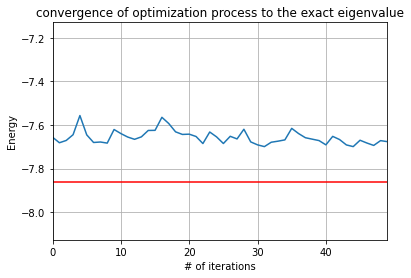

In [122]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [123]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

2it [00:00,  5.99it/s]

{'1101': 87, '0100': 90, '0011': 40, '0010': 168, '1010': 26, '1110': 138, '0111': 58, '1111': 148, '1011': 46, '0000': 23, '1000': 38, '0110': 28, '0001': 77, '1100': 31, '0101': 6, '1001': 20}
1.0
{'1111': 43, '0110': 83, '0101': 73, '1110': 94, '1100': 192, '1101': 74, '0000': 63, '1001': 61, '0011': 77, '0100': 10, '1010': 35, '0010': 85, '0001': 101, '1011': 7, '0111': 13, '1000': 13}
1.0


4it [00:00,  6.61it/s]

{'1001': 42, '0001': 6, '1101': 107, '0100': 9, '1011': 93, '1110': 241, '0110': 41, '0111': 64, '0101': 31, '1100': 68, '1010': 32, '0000': 66, '0011': 118, '0010': 71, '1000': 34, '1111': 1}
1.0
{'0000': 73, '1000': 53, '0110': 70, '0011': 147, '1110': 266, '1011': 75, '0111': 30, '1101': 86, '0100': 36, '1010': 44, '0101': 62, '1100': 14, '1001': 7, '0010': 41, '1111': 11, '0001': 9}
1.0


6it [00:00,  5.94it/s]

{'0100': 41, '0011': 153, '0111': 55, '0101': 56, '0000': 84, '0001': 15, '1010': 40, '0110': 74, '1110': 240, '1101': 99, '1011': 51, '1000': 52, '0010': 38, '1100': 10, '1001': 5, '1111': 11}
1.0
{'0101': 61, '1110': 262, '1101': 85, '0110': 58, '0010': 47, '1011': 74, '0000': 88, '0011': 132, '0111': 59, '0100': 43, '0001': 10, '1000': 57, '1010': 36, '1100': 5, '1111': 4, '1001': 3}
1.0


8it [00:01,  6.04it/s]

{'0101': 112, '1110': 119, '1101': 260, '0001': 31, '1010': 45, '1111': 28, '0010': 116, '0000': 93, '1000': 36, '1001': 72, '0011': 23, '0110': 84, '1100': 3, '1011': 2}
1.0
{'1111': 212, '1101': 91, '1010': 100, '0010': 132, '0111': 33, '1100': 74, '0011': 60, '0000': 39, '1001': 25, '1110': 38, '0110': 92, '0101': 3, '0001': 56, '0100': 29, '1011': 4, '1000': 36}
1.0


10it [00:01,  6.46it/s]

{'0010': 180, '1011': 50, '0001': 91, '0100': 65, '1101': 81, '1110': 133, '1111': 171, '1000': 43, '1010': 28, '0110': 28, '0111': 57, '1100': 34, '0000': 19, '0011': 29, '0101': 3, '1001': 12}
1.0
{'1011': 55, '0010': 209, '1010': 21, '0001': 74, '0000': 22, '1110': 136, '1111': 174, '0100': 72, '0111': 58, '1001': 20, '1000': 33, '0110': 12, '1101': 78, '0011': 29, '1100': 29, '0101': 2}
1.0


12it [00:01,  7.12it/s]

{'1111': 161, '1010': 26, '0001': 83, '1101': 77, '0011': 41, '0010': 198, '1011': 62, '1110': 126, '0100': 77, '0000': 17, '1100': 33, '0111': 66, '1001': 14, '0110': 17, '1000': 24, '0101': 2}
1.0
{'0010': 174, '1110': 134, '1101': 86, '0001': 81, '1111': 173, '0110': 19, '0111': 61, '1100': 30, '1000': 39, '0100': 78, '1011': 46, '1010': 24, '0011': 32, '0000': 28, '1001': 18, '0101': 1}
1.0


14it [00:02,  6.70it/s]

{'1101': 159, '0100': 35, '0010': 199, '0101': 106, '1110': 165, '1000': 15, '0001': 18, '1001': 157, '0000': 53, '1010': 20, '1100': 40, '1111': 28, '0111': 2, '0110': 4, '0011': 14, '1011': 9}
1.0
{'1100': 24, '1111': 182, '0001': 87, '0010': 180, '1101': 77, '0100': 80, '0111': 49, '1110': 143, '0110': 25, '1010': 35, '0011': 19, '1011': 55, '1001': 15, '1000': 27, '0000': 25, '0101': 1}
1.0


16it [00:02,  6.23it/s]

{'0001': 93, '1011': 58, '0010': 164, '0100': 89, '0110': 26, '1111': 155, '1110': 153, '0111': 62, '1100': 33, '0011': 35, '1101': 68, '1001': 10, '1000': 44, '1010': 15, '0000': 19}
1.0
{'1011': 47, '0010': 181, '0000': 21, '0001': 82, '0111': 63, '1110': 143, '1111': 153, '0011': 31, '1101': 80, '0110': 22, '1001': 23, '1010': 18, '0100': 85, '1000': 41, '0101': 3, '1100': 31}
1.0


18it [00:02,  6.55it/s]

{'1111': 145, '0100': 93, '1101': 74, '1010': 29, '0001': 80, '1011': 58, '0010': 199, '0011': 40, '1110': 126, '0111': 64, '0110': 28, '1000': 22, '1001': 19, '0000': 25, '1100': 20, '0101': 2}
1.0
{'1000': 18, '0000': 63, '1110': 199, '0101': 110, '0010': 167, '0100': 39, '1101': 167, '1001': 148, '1111': 35, '0011': 15, '1010': 18, '1100': 17, '0110': 6, '0111': 4, '0001': 14, '1011': 4}
1.0


19it [00:02,  6.20it/s]

{'1110': 184, '0101': 112, '0010': 202, '0001': 8, '1001': 152, '1101': 161, '0000': 60, '1111': 26, '1010': 27, '0100': 31, '1100': 19, '0111': 4, '1000': 20, '0011': 10, '0110': 6, '1011': 2}
1.0
{'0110': 26, '1111': 136, '0100': 85, '0001': 88, '1000': 33, '0111': 62, '1110': 126, '0010': 190, '1010': 25, '1100': 45, '1101': 81, '1001': 15, '1011': 58, '0011': 30, '0000': 21, '0101': 3}
1.0


22it [00:03,  6.29it/s]

{'1111': 159, '0110': 25, '0001': 81, '1000': 40, '0100': 88, '1100': 21, '0011': 36, '0010': 189, '1101': 94, '1110': 135, '0111': 49, '1010': 27, '1011': 48, '0000': 24, '0101': 5, '1001': 3}
1.0
{'1110': 113, '1111': 163, '1101': 94, '0100': 94, '0111': 61, '1001': 18, '0001': 92, '0010': 167, '0000': 27, '1010': 26, '1100': 32, '1000': 30, '1011': 50, '0011': 31, '0110': 23, '0101': 3}
1.0


24it [00:03,  6.09it/s]

{'0011': 29, '0111': 62, '1101': 100, '0100': 71, '1010': 23, '1111': 135, '0010': 211, '1110': 138, '0110': 21, '0000': 26, '1000': 36, '1100': 34, '1001': 10, '1011': 48, '0001': 79, '0101': 1}
1.0
{'1001': 21, '0001': 84, '0111': 49, '1110': 116, '0100': 101, '1111': 178, '1011': 57, '0011': 32, '1000': 28, '0010': 193, '1101': 79, '0110': 25, '1010': 24, '1100': 22, '0101': 2, '0000': 13}
1.0


26it [00:04,  6.75it/s]

{'0000': 19, '1000': 47, '1111': 163, '0111': 71, '1011': 43, '0010': 181, '1110': 149, '0001': 76, '1101': 71, '1100': 30, '1001': 17, '0011': 27, '0100': 87, '1010': 21, '0110': 19, '0101': 3}
1.0
{'1011': 45, '0010': 185, '1110': 128, '0111': 69, '0000': 35, '1101': 67, '0011': 26, '1001': 21, '0001': 69, '0101': 3, '0100': 90, '1111': 164, '1100': 36, '1010': 27, '1000': 27, '0110': 32}
1.0


27it [00:04,  6.36it/s]


{'1011': 39, '0010': 205, '1100': 27, '1101': 81, '0100': 78, '1110': 120, '0001': 89, '0111': 48, '0011': 44, '1010': 28, '1000': 45, '0000': 31, '0110': 23, '1111': 147, '0101': 4, '1001': 15}
1.0


2it [00:00,  5.68it/s]

{'1101': 158, '0010': 234, '1110': 121, '0101': 13, '1111': 126, '0110': 16, '0001': 115, '1000': 75, '0111': 40, '0011': 9, '0100': 25, '0000': 46, '1001': 12, '1100': 22, '1011': 12}
1.0
{'1111': 180, '0010': 236, '1001': 38, '0001': 92, '1100': 175, '0011': 33, '1110': 11, '1101': 77, '0000': 26, '0111': 9, '1010': 42, '0100': 26, '1011': 15, '1000': 11, '0110': 24, '0101': 29}
1.0


4it [00:00,  6.39it/s]

{'1101': 165, '1110': 148, '1011': 65, '0010': 94, '1100': 41, '0111': 78, '1010': 41, '0110': 23, '0000': 152, '1001': 85, '0101': 20, '1111': 32, '0001': 7, '0011': 37, '1000': 18, '0100': 18}
1.0
{'0000': 65, '1000': 81, '0111': 59, '0101': 67, '0010': 93, '1011': 59, '1111': 47, '0011': 74, '0100': 80, '1101': 201, '1110': 102, '0110': 66, '1100': 2, '1010': 22, '1001': 6}
1.0


6it [00:00,  7.02it/s]

{'1101': 203, '0000': 57, '1000': 86, '0101': 59, '1110': 103, '0010': 116, '0011': 71, '0110': 52, '1010': 34, '1111': 48, '0111': 45, '0100': 81, '1001': 12, '1011': 55, '0001': 2}
1.0
{'0011': 74, '1101': 198, '0111': 52, '0000': 55, '1111': 47, '1010': 38, '0010': 113, '1011': 60, '1000': 69, '1110': 104, '0110': 69, '0100': 59, '1001': 11, '0101': 71, '0001': 2, '1100': 2}
1.0


8it [00:01,  6.87it/s]

{'0010': 162, '0000': 36, '1101': 160, '0100': 26, '1111': 41, '0101': 114, '1110': 140, '1001': 79, '1000': 38, '1010': 57, '1011': 17, '0110': 99, '0111': 23, '0011': 24, '0001': 1, '1100': 7}
1.0
{'0001': 77, '1010': 144, '0110': 75, '1111': 75, '0000': 56, '0111': 41, '0010': 86, '1011': 28, '1101': 240, '1100': 46, '1110': 68, '0011': 12, '0100': 57, '1000': 13, '1001': 4, '0101': 2}
1.0


10it [00:01,  6.56it/s]

{'0010': 252, '1000': 79, '0000': 29, '1101': 160, '1111': 111, '1110': 129, '0111': 34, '1001': 13, '0001': 109, '0110': 16, '0011': 8, '1100': 28, '0100': 37, '0101': 8, '1011': 9, '1010': 2}
1.0
{'1111': 125, '1101': 160, '1000': 85, '0001': 122, '1011': 7, '0010': 225, '1110': 131, '1100': 32, '0100': 27, '0111': 32, '1001': 17, '0110': 16, '0101': 12, '0000': 25, '0011': 8}
1.0


12it [00:01,  6.58it/s]

{'1000': 93, '0000': 38, '0101': 16, '1110': 140, '0011': 13, '1101': 157, '0001': 100, '0111': 40, '0010': 228, '1100': 34, '1111': 106, '0100': 27, '1001': 14, '1011': 9, '0110': 8, '1010': 1}
1.0
{'1000': 101, '0000': 28, '0010': 204, '0110': 10, '1111': 125, '1101': 177, '0001': 104, '0101': 22, '1100': 34, '1110': 117, '0011': 13, '0111': 35, '1001': 18, '1011': 10, '0100': 25, '1010': 1}
1.0


14it [00:02,  6.58it/s]

{'1101': 206, '0011': 44, '0010': 228, '1000': 83, '0101': 64, '1110': 144, '0111': 33, '1010': 36, '0100': 15, '1011': 23, '1001': 91, '0000': 8, '0001': 11, '1100': 4, '0110': 26, '1111': 8}
1.0
{'0101': 17, '1110': 126, '1111': 115, '0010': 209, '1000': 98, '1101': 166, '0001': 127, '0111': 26, '0000': 42, '1100': 27, '0100': 23, '1001': 12, '0110': 16, '1011': 11, '0011': 9}
1.0


16it [00:02,  6.37it/s]

{'1101': 169, '0100': 22, '0010': 220, '0001': 109, '1100': 33, '1111': 107, '1110': 139, '0111': 35, '1001': 18, '1000': 91, '0101': 10, '0011': 15, '0000': 29, '0110': 21, '1011': 6}
1.0
{'0100': 26, '1100': 33, '0011': 11, '1111': 118, '1110': 117, '1000': 99, '0000': 48, '0010': 210, '1011': 14, '0101': 22, '0001': 104, '1101': 148, '0111': 38, '1001': 18, '0110': 17, '1010': 1}
1.0


18it [00:02,  6.35it/s]

{'0001': 113, '0010': 228, '1111': 111, '1000': 82, '0000': 39, '1101': 169, '0111': 27, '0101': 16, '1110': 121, '0100': 33, '1011': 11, '0110': 13, '1100': 30, '1001': 18, '0011': 13}
1.0
{'1100': 6, '1010': 33, '1001': 99, '0101': 74, '1110': 138, '1101': 196, '0111': 39, '0010': 248, '1000': 76, '0001': 9, '0110': 25, '0011': 30, '0100': 13, '1111': 17, '0000': 6, '1011': 15}
1.0


21it [00:03,  7.36it/s]

{'0101': 80, '1110': 136, '0100': 18, '1101': 232, '1000': 89, '0010': 201, '1001': 72, '0110': 27, '1010': 38, '0011': 38, '1111': 12, '1100': 4, '0111': 39, '1011': 24, '0001': 10, '0000': 4}
1.0
{'0010': 248, '1001': 21, '0001': 118, '1111': 108, '1000': 81, '0101': 16, '1110': 114, '1101': 160, '0100': 28, '1100': 33, '0011': 11, '0111': 30, '0000': 28, '1011': 17, '1010': 1, '0110': 10}
1.0
{'1101': 158, '0001': 110, '0010': 237, '1110': 109, '0111': 37, '1000': 100, '1111': 118, '1100': 32, '0000': 47, '0100': 26, '0011': 7, '1011': 12, '1001': 8, '0101': 16, '0110': 6, '1010': 1}
1.0


23it [00:03,  7.12it/s]

{'1101': 155, '1111': 126, '1000': 79, '0001': 133, '0010': 216, '0111': 41, '0101': 19, '1100': 26, '1110': 107, '0011': 6, '0100': 31, '0000': 37, '1001': 25, '0110': 13, '1011': 10}
1.0
{'0010': 231, '1100': 26, '1101': 152, '0110': 21, '1111': 116, '1000': 108, '0000': 38, '0001': 106, '0101': 16, '1011': 17, '1110': 116, '0111': 33, '0100': 22, '0011': 12, '1001': 9, '1010': 1}
1.0


25it [00:03,  7.21it/s]

{'0111': 36, '1110': 111, '0001': 124, '0100': 24, '1101': 172, '0010': 253, '1111': 110, '0000': 31, '0011': 7, '0110': 9, '1011': 11, '1001': 20, '1000': 81, '1100': 29, '0101': 6}
1.0
{'1111': 109, '0101': 17, '1110': 130, '0000': 29, '1000': 75, '0001': 121, '0010': 241, '0100': 23, '1100': 36, '1101': 166, '1011': 11, '0111': 28, '0110': 12, '0011': 8, '1001': 17, '1010': 1}
1.0


27it [00:04,  6.67it/s]


{'0010': 229, '1000': 85, '0000': 39, '0001': 113, '1111': 123, '1101': 162, '0111': 30, '1110': 141, '0100': 21, '0110': 7, '1001': 18, '1011': 7, '0101': 21, '1100': 17, '0011': 11}
1.0
{'0000': 34, '0100': 28, '1101': 165, '1111': 111, '0010': 238, '1110': 113, '1001': 14, '0001': 120, '0111': 41, '0011': 5, '1000': 87, '1100': 29, '0101': 12, '0110': 15, '1010': 1, '1011': 11}
1.0


2it [00:00,  6.07it/s]

{'1111': 123, '0010': 173, '1011': 70, '0111': 91, '1101': 143, '1001': 33, '1110': 146, '0011': 14, '1000': 20, '1100': 31, '0100': 115, '0110': 9, '0101': 2, '0001': 22, '1010': 29, '0000': 3}
1.0
{'1000': 6, '0110': 103, '0011': 77, '1100': 186, '0100': 26, '1101': 132, '1110': 81, '1010': 56, '0010': 51, '1111': 65, '0101': 48, '1001': 31, '0111': 31, '0001': 71, '0000': 30, '1011': 30}
1.0


3it [00:00,  6.43it/s]

{'1101': 162, '0110': 97, '0101': 25, '1110': 180, '0011': 77, '0000': 47, '1011': 105, '1001': 28, '0111': 61, '0100': 68, '0010': 119, '1100': 42, '0001': 6, '1010': 6, '1111': 1}
1.0
{'1100': 19, '0011': 123, '0000': 90, '0101': 39, '1110': 223, '1001': 114, '0111': 44, '1101': 31, '1010': 46, '1011': 76, '1111': 17, '0010': 22, '0110': 100, '1000': 57, '0001': 9, '0100': 14}
1.0


6it [00:01,  5.86it/s]

{'1011': 69, '0110': 109, '1111': 19, '1101': 39, '1001': 112, '0111': 35, '0000': 79, '1110': 239, '1100': 16, '0001': 7, '0011': 132, '0010': 20, '1010': 62, '1000': 35, '0100': 8, '0101': 43}
1.0
{'1000': 61, '0110': 94, '1011': 71, '0011': 117, '1100': 14, '0101': 64, '1001': 103, '1101': 44, '0111': 38, '1110': 239, '0001': 9, '1111': 13, '0010': 17, '0000': 76, '1010': 57, '0100': 7}
1.0


7it [00:01,  5.16it/s]

{'1101': 158, '1111': 41, '1000': 59, '0010': 141, '1011': 48, '1001': 118, '0011': 43, '1110': 97, '0110': 60, '1010': 68, '0100': 65, '0101': 52, '1100': 6, '0000': 29, '0001': 28, '0111': 11}
1.0
{'0110': 114, '1111': 153, '1010': 105, '1001': 47, '0011': 52, '1100': 94, '0111': 86, '0010': 98, '0001': 105, '0000': 35, '1101': 15, '1110': 48, '1000': 48, '1011': 9, '0101': 15}
1.0


9it [00:01,  5.60it/s]

{'0010': 172, '1011': 59, '1101': 150, '0100': 137, '1111': 135, '1010': 35, '0001': 21, '1110': 129, '0011': 14, '0110': 7, '0111': 91, '1001': 29, '1100': 28, '1000': 16, '0000': 1}
1.0


11it [00:01,  5.86it/s]

{'0010': 194, '0110': 10, '1111': 120, '1100': 29, '1101': 143, '1110': 159, '0111': 82, '1010': 28, '1011': 57, '0011': 14, '0100': 115, '0001': 23, '1000': 24, '1001': 22, '0000': 4}
1.0
{'1110': 134, '1100': 23, '0010': 182, '1011': 67, '0100': 140, '1101': 113, '0111': 72, '1010': 30, '1111': 149, '1001': 33, '0001': 35, '0101': 5, '1000': 20, '0011': 13, '0110': 4, '0000': 4}
1.0


13it [00:02,  6.20it/s]

{'1110': 143, '1100': 23, '1011': 72, '1111': 129, '1101': 140, '0100': 135, '0000': 3, '0001': 27, '0010': 168, '1010': 28, '0111': 81, '1001': 29, '0101': 4, '1000': 23, '0011': 14, '0110': 5}
1.0
{'0100': 70, '1101': 94, '1110': 250, '0001': 10, '1111': 33, '0010': 76, '1011': 43, '0000': 88, '0101': 188, '1001': 45, '1010': 34, '0111': 8, '0110': 2, '1000': 29, '0011': 48, '1100': 6}
1.0


15it [00:02,  6.79it/s]

{'0010': 190, '0100': 124, '1101': 138, '0011': 17, '1001': 33, '1000': 16, '0111': 88, '1110': 138, '0110': 6, '1111': 141, '1011': 53, '1100': 20, '0001': 28, '1010': 30, '0101': 1, '0000': 1}
1.0
{'1011': 69, '0010': 172, '1110': 161, '1101': 146, '0100': 131, '0111': 86, '1111': 114, '0001': 24, '1100': 30, '1010': 34, '0000': 2, '1001': 28, '0011': 16, '1000': 9, '0110': 2}
1.0


17it [00:02,  6.39it/s]

{'1101': 153, '0100': 129, '1100': 27, '1110': 163, '1111': 122, '1011': 69, '0010': 165, '0111': 88, '1001': 25, '1010': 27, '0110': 2, '0011': 12, '0001': 26, '1000': 14, '0000': 2}
1.0
{'0100': 128, '1101': 139, '1011': 65, '0010': 189, '1111': 130, '0111': 82, '1110': 152, '1001': 25, '0011': 13, '0001': 29, '1000': 17, '1100': 23, '1010': 26, '0000': 4, '0110': 2}
1.0
{'0100': 56, '1101': 119, '0101': 194, '1110': 248, '1010': 30, '0010': 97, '1000': 29, '1111': 30, '0011': 42, '0000': 81, '1011': 47, '1001': 29, '0111': 15, '0001': 3, '1100': 3, '0110': 1}
1.0


19it [00:03,  7.79it/s]

{'0101': 174, '1110': 224, '0010': 89, '1000': 22, '0000': 83, '0011': 55, '1101': 120, '0100': 65, '0111': 14, '1010': 42, '1001': 38, '1011': 46, '1111': 34, '0110': 3, '1100': 9, '0001': 6}
1.0
{'0010': 187, '1101': 127, '0100': 136, '0111': 95, '1000': 16, '0001': 21, '1110': 138, '1100': 28, '1111': 132, '1011': 64, '1010': 18, '1001': 36, '0000': 3, '0011': 14, '0110': 8, '0101': 1}
1.0


22it [00:03,  7.33it/s]

{'1110': 138, '0001': 22, '1001': 28, '0111': 72, '1011': 77, '0010': 188, '0100': 124, '1111': 129, '1010': 37, '1101': 148, '1000': 14, '1100': 33, '0011': 5, '0110': 4, '0000': 5}
1.0
{'1111': 120, '1010': 31, '0001': 25, '1101': 168, '0100': 113, '0111': 80, '1110': 142, '0010': 173, '1011': 68, '0011': 19, '1100': 29, '0110': 7, '1001': 30, '1000': 16, '0000': 3}
1.0


24it [00:03,  7.96it/s]

{'0100': 123, '1101': 149, '0010': 183, '1111': 137, '1110': 137, '0111': 79, '1001': 33, '0001': 35, '1011': 57, '1010': 26, '0011': 17, '1100': 29, '1000': 11, '0110': 6, '0000': 2}
1.0
{'0010': 201, '1011': 63, '1100': 36, '1101': 148, '0100': 126, '1010': 33, '1001': 26, '1111': 117, '0001': 17, '0111': 68, '1110': 153, '0110': 4, '0011': 11, '1000': 18, '0000': 2, '0101': 1}
1.0


26it [00:03,  8.86it/s]

{'1101': 141, '0100': 116, '1011': 61, '0010': 171, '1010': 38, '0111': 95, '1111': 127, '1110': 157, '1001': 28, '1100': 22, '1000': 19, '0110': 12, '0001': 25, '0011': 11, '0000': 1}
1.0
{'1011': 72, '0010': 177, '1101': 156, '0100': 104, '1111': 131, '1110': 132, '1000': 20, '0111': 94, '0011': 13, '1010': 32, '1100': 25, '1001': 28, '0001': 30, '0110': 6, '0000': 4}
1.0


27it [00:04,  6.67it/s]


{'0010': 158, '1011': 77, '0111': 91, '1111': 112, '1101': 161, '0100': 134, '1110': 138, '1010': 33, '0011': 17, '1100': 26, '1001': 28, '0101': 3, '0001': 25, '0000': 2, '1000': 16, '0110': 3}
1.0


1it [00:00,  7.44it/s]

{'0111': 40, '1011': 59, '0010': 276, '0101': 21, '1110': 111, '1100': 116, '0100': 140, '1010': 41, '0001': 27, '1101': 61, '0011': 39, '0110': 36, '1111': 45, '1000': 6, '1001': 6}
1.0


2it [00:00,  7.45it/s]

{'0010': 39, '1011': 73, '1110': 170, '1100': 28, '0011': 142, '0001': 116, '1001': 60, '1101': 62, '0111': 38, '0110': 134, '0101': 19, '1111': 89, '0000': 35, '0100': 10, '1010': 9}
1.0


3it [00:00,  7.56it/s]

{'1011': 295, '0100': 28, '1101': 174, '0101': 12, '1110': 151, '0011': 45, '1100': 123, '1001': 33, '0111': 29, '0010': 45, '1010': 21, '0000': 17, '1111': 14, '0110': 24, '1000': 8, '0001': 5}
1.0


4it [00:00,  7.61it/s]

{'0011': 235, '1001': 92, '0000': 95, '0101': 44, '1110': 103, '1011': 74, '0111': 58, '0110': 33, '0100': 17, '1101': 64, '0010': 52, '1000': 19, '1100': 36, '1111': 35, '1010': 47, '0001': 20}
1.0


5it [00:00,  6.16it/s]

{'0000': 134, '0011': 213, '0101': 45, '1110': 92, '1111': 44, '0110': 36, '1001': 90, '1101': 61, '0001': 21, '0010': 51, '1010': 50, '0111': 51, '1100': 29, '0100': 16, '1000': 23, '1011': 68}
1.0


6it [00:00,  6.65it/s]

{'0000': 115, '1000': 19, '1010': 51, '1001': 88, '0011': 236, '1100': 24, '0010': 64, '1110': 88, '0110': 23, '0111': 45, '1011': 73, '1101': 61, '0100': 24, '1111': 51, '0001': 17, '0101': 45}
1.0


7it [00:01,  6.76it/s]

{'1011': 37, '0010': 248, '0100': 94, '1001': 12, '1010': 151, '0001': 27, '1111': 41, '0011': 84, '0000': 63, '1101': 95, '1100': 11, '0110': 40, '0101': 23, '1110': 83, '1000': 5, '0111': 10}
1.0


8it [00:01,  7.19it/s]

{'1010': 306, '1001': 54, '1101': 11, '1111': 129, '0110': 41, '1000': 112, '0011': 17, '1100': 118, '0001': 72, '1110': 48, '1011': 31, '0101': 6, '0010': 55, '0111': 21, '0000': 3}
1.0


9it [00:01,  6.64it/s]

{'1011': 69, '0010': 270, '1111': 56, '0011': 26, '1100': 121, '1010': 40, '1110': 100, '0101': 23, '0001': 44, '0100': 126, '0110': 33, '1101': 61, '0111': 40, '1001': 10, '1000': 5}
1.0


10it [00:01,  6.31it/s]

{'1100': 122, '0001': 43, '1011': 80, '0010': 241, '0111': 36, '1101': 76, '1111': 49, '0110': 29, '1110': 86, '1010': 41, '0100': 144, '0101': 18, '0011': 43, '1000': 8, '1001': 8}
1.0


11it [00:01,  6.95it/s]

{'1011': 77, '0010': 267, '1010': 39, '0110': 25, '0100': 137, '1101': 65, '0111': 38, '1100': 79, '1110': 106, '0001': 55, '1111': 62, '1001': 14, '0011': 30, '0101': 22, '1000': 7, '0000': 1}
1.0


12it [00:01,  7.19it/s]

{'0010': 257, '0100': 130, '1101': 69, '1100': 106, '0110': 32, '1111': 58, '0101': 20, '0001': 36, '1011': 80, '0011': 36, '1110': 112, '1000': 9, '1001': 11, '0111': 38, '1010': 29, '0000': 1}
1.0


13it [00:01,  7.63it/s]

{'1010': 151, '1111': 81, '0111': 5, '0000': 36, '1000': 92, '1110': 332, '0101': 61, '0011': 22, '1001': 64, '1011': 77, '0010': 31, '1100': 8, '1101': 43, '0100': 12, '0110': 8, '0001': 1}
1.0


14it [00:02,  6.88it/s]

{'1100': 102, '1110': 91, '1011': 89, '0010': 279, '0110': 26, '0001': 49, '1101': 69, '0100': 129, '1001': 15, '1010': 34, '1000': 8, '0101': 14, '1111': 46, '0111': 34, '0011': 39}
1.0


15it [00:02,  6.98it/s]

{'1100': 107, '1010': 32, '0001': 50, '1011': 79, '0010': 254, '1110': 107, '0100': 130, '1111': 52, '0011': 40, '1101': 70, '0111': 35, '0110': 26, '1001': 16, '1000': 8, '0101': 18}
1.0


16it [00:02,  7.63it/s]

{'0100': 135, '1101': 65, '0011': 34, '1100': 111, '1111': 65, '1011': 70, '0010': 292, '1010': 31, '0001': 44, '1110': 85, '0101': 14, '0110': 28, '0111': 32, '1000': 9, '1001': 9}
1.0


17it [00:02,  7.63it/s]

{'0100': 148, '1101': 77, '0010': 262, '1110': 86, '0011': 28, '0001': 36, '1010': 36, '0110': 43, '1011': 86, '1100': 108, '0101': 25, '0111': 33, '1111': 47, '1000': 7, '1001': 2}
1.0
{'0101': 59, '1110': 337, '0010': 32, '1000': 97, '0011': 27, '1010': 139, '1101': 44, '1111': 66, '1001': 76, '0000': 49, '1011': 57, '0110': 10, '0100': 10, '1100': 12, '0111': 4, '0001': 5}
1.0


19it [00:02,  6.93it/s]

{'1000': 104, '0000': 49, '1110': 330, '0111': 2, '1001': 74, '1010': 146, '1011': 72, '0011': 36, '1101': 39, '0001': 4, '0101': 50, '1111': 60, '0010': 22, '0110': 16, '1100': 8, '0100': 12}
1.0
{'1110': 108, '0010': 266, '1011': 72, '0011': 43, '1100': 112, '1101': 63, '0100': 125, '0110': 32, '0001': 57, '0111': 30, '1010': 40, '1111': 44, '1001': 12, '1000': 5, '0101': 15}
1.0


22it [00:03,  7.24it/s]

{'1110': 121, '0100': 131, '0010': 250, '1010': 38, '0001': 58, '1100': 112, '0110': 29, '1111': 57, '1001': 9, '1011': 67, '1101': 67, '0101': 17, '0111': 27, '0011': 34, '1000': 7}
1.0
{'1011': 69, '0010': 293, '1101': 64, '0100': 124, '0011': 34, '1010': 41, '0001': 40, '1110': 94, '0110': 38, '1100': 115, '1000': 6, '1111': 50, '0111': 31, '0101': 13, '1001': 12}
1.0


23it [00:03,  7.04it/s]

{'0100': 137, '1111': 49, '0101': 23, '1110': 104, '0001': 42, '1011': 74, '0010': 255, '0111': 51, '0011': 45, '1001': 9, '1000': 4, '1101': 72, '1100': 95, '0110': 33, '1010': 31}
1.0
{'0110': 31, '1111': 64, '0010': 235, '1110': 92, '0100': 143, '1101': 79, '1010': 33, '0111': 41, '1000': 9, '1100': 103, '1011': 83, '0001': 42, '1001': 11, '0101': 21, '0011': 37}
1.0


26it [00:03,  6.80it/s]

{'0010': 274, '1110': 101, '0001': 54, '1010': 40, '1101': 73, '0100': 133, '0111': 33, '1100': 93, '0101': 20, '1011': 73, '0110': 28, '1111': 55, '1001': 8, '0011': 30, '1000': 8, '0000': 1}
1.0
{'1110': 105, '1011': 79, '0010': 259, '0100': 135, '0110': 32, '0011': 39, '1100': 116, '1010': 45, '0001': 32, '0111': 41, '1111': 52, '1101': 66, '0101': 10, '1000': 7, '0000': 1, '1001': 5}
1.0


27it [00:03,  6.94it/s]


{'0010': 270, '0111': 47, '0100': 143, '1110': 108, '1100': 112, '0011': 23, '1111': 50, '1010': 35, '1011': 58, '1000': 6, '0001': 47, '0110': 31, '1001': 11, '0101': 16, '1101': 66, '0000': 1}
1.0


2it [00:00,  6.46it/s]

{'0111': 238, '0010': 261, '1101': 59, '0100': 222, '1110': 46, '0110': 26, '1111': 36, '0001': 13, '1010': 12, '1001': 7, '0011': 11, '0101': 24, '0000': 10, '1100': 20, '1011': 32, '1000': 7}
1.0
{'0010': 137, '1100': 55, '0011': 75, '0101': 182, '1110': 46, '0001': 71, '0100': 137, '0110': 163, '0000': 38, '0111': 21, '1001': 22, '1111': 33, '1010': 12, '1101': 22, '1011': 10}
1.0


4it [00:00,  7.17it/s]

{'1110': 206, '0010': 110, '1011': 101, '0110': 71, '0100': 82, '1101': 169, '0011': 64, '0111': 50, '1100': 33, '0101': 30, '1010': 47, '0000': 31, '1001': 11, '1000': 6, '1111': 10, '0001': 3}
1.0
{'0001': 52, '1101': 19, '0101': 76, '1110': 77, '0110': 337, '1000': 17, '0000': 122, '1100': 7, '0011': 135, '0111': 56, '0100': 13, '1010': 25, '1001': 36, '0010': 16, '1011': 26, '1111': 10}
1.0
{'0101': 83, '0110': 343, '0000': 105, '0111': 60, '1010': 19, '0100': 21, '0011': 148, '1011': 32, '1000': 18, '1110': 60, '1001': 43, '1100': 9, '1101': 13, '0001': 50, '1111': 10, '0010': 10}
1.0


7it [00:01,  6.90it/s]

{'0000': 113, '0110': 359, '1110': 65, '0101': 77, '0111': 62, '0011': 139, '1010': 28, '1011': 25, '1001': 34, '0001': 39, '1000': 16, '0100': 15, '1100': 17, '1101': 17, '1111': 7, '0010': 11}
1.0
{'0001': 98, '1001': 34, '1110': 34, '0000': 71, '1111': 9, '0110': 179, '1101': 63, '0011': 23, '1100': 5, '0111': 40, '0100': 127, '0101': 109, '0010': 154, '1000': 27, '1011': 19, '1010': 32}
1.0


9it [00:01,  7.43it/s]

{'1111': 158, '0110': 146, '1110': 106, '0111': 71, '0011': 60, '1010': 66, '0010': 53, '1000': 100, '1011': 33, '1101': 14, '0000': 38, '1100': 91, '0001': 65, '1001': 2, '0100': 9, '0101': 12}
1.0
{'1101': 46, '0100': 233, '1111': 32, '0001': 21, '1110': 56, '0101': 20, '0111': 224, '0010': 272, '1100': 10, '0000': 14, '1001': 8, '1000': 8, '0110': 25, '1011': 29, '1010': 10, '0011': 16}
1.0


10it [00:01,  6.99it/s]

{'1101': 57, '0100': 208, '0010': 265, '0111': 243, '1100': 10, '0001': 22, '1110': 60, '1111': 32, '1010': 3, '1011': 34, '0101': 24, '1001': 11, '0011': 22, '0110': 20, '1000': 5, '0000': 8}
1.0


11it [00:01,  6.01it/s]

{'0010': 261, '0011': 25, '1100': 19, '1101': 54, '0100': 201, '0110': 29, '1111': 37, '0111': 228, '0000': 12, '1011': 31, '1001': 16, '1010': 11, '1110': 54, '0001': 19, '0101': 21, '1000': 6}
1.0


13it [00:02,  6.16it/s]

{'0101': 34, '1010': 11, '1001': 11, '1101': 67, '0100': 219, '0111': 209, '0010': 252, '1111': 39, '0000': 10, '1110': 52, '0110': 33, '0001': 29, '1100': 12, '0011': 14, '1011': 25, '1000': 7}
1.0
{'0101': 156, '1110': 180, '1101': 128, '1010': 95, '0111': 25, '0010': 93, '1111': 39, '0011': 28, '0000': 82, '1100': 32, '1000': 27, '0110': 10, '0100': 74, '1001': 30, '1011': 14, '0001': 11}
1.0


14it [00:02,  6.16it/s]

{'1011': 31, '0010': 255, '1101': 52, '0100': 219, '0110': 26, '0101': 17, '0111': 232, '0001': 22, '1111': 38, '1000': 9, '1100': 20, '0011': 19, '0000': 10, '1010': 13, '1110': 50, '1001': 11}
1.0


15it [00:02,  4.00it/s]

{'1110': 63, '0011': 24, '0111': 239, '0100': 218, '0010': 264, '1010': 8, '1001': 8, '1111': 34, '1011': 24, '1101': 46, '0001': 13, '1000': 7, '1100': 13, '0101': 21, '0000': 18, '0110': 24}
1.0
{'1011': 22, '0010': 249, '1101': 59, '0100': 226, '0111': 251, '0101': 26, '0110': 29, '0011': 15, '1111': 27, '1001': 10, '1110': 57, '1000': 9, '1100': 10, '0001': 13, '0000': 13, '1010': 8}
1.0


17it [00:03,  4.36it/s]

{'0010': 244, '0111': 231, '1111': 36, '0110': 18, '0100': 221, '0011': 22, '0101': 19, '1110': 74, '0001': 25, '1101': 52, '1100': 19, '1011': 28, '1000': 2, '0000': 12, '1001': 12, '1010': 9}
1.0
{'1010': 101, '0100': 74, '1101': 116, '0101': 167, '1110': 189, '1111': 51, '1100': 37, '0000': 81, '0010': 98, '0011': 27, '1000': 24, '0111': 8, '1011': 19, '1001': 26, '0001': 3, '0110': 3}
1.0


19it [00:03,  5.79it/s]

{'1001': 24, '1010': 94, '0101': 164, '0111': 26, '1011': 13, '0010': 102, '1111': 43, '1101': 121, '0011': 22, '0110': 5, '1100': 36, '0100': 78, '1110': 195, '0000': 69, '0001': 9, '1000': 23}
1.0


20it [00:03,  5.23it/s]

{'1011': 36, '0010': 246, '0111': 240, '1101': 63, '0100': 218, '1111': 29, '1100': 17, '0101': 19, '0011': 24, '1001': 8, '0000': 12, '0110': 28, '0001': 22, '1110': 46, '1010': 8, '1000': 8}
1.0


22it [00:03,  5.46it/s]

{'0010': 264, '0100': 215, '0000': 16, '0111': 226, '0110': 21, '0001': 24, '1010': 11, '1110': 42, '1101': 56, '1111': 41, '0101': 29, '1100': 14, '1011': 28, '0011': 17, '1000': 9, '1001': 11}
1.0
{'1110': 52, '0100': 217, '1101': 51, '0111': 227, '0010': 257, '1111': 40, '0011': 22, '1001': 13, '0001': 24, '0000': 8, '1011': 36, '0101': 17, '1000': 8, '1100': 17, '0110': 24, '1010': 11}
1.0


24it [00:04,  6.88it/s]

{'1010': 3, '0110': 31, '1111': 37, '1011': 38, '0010': 262, '0111': 216, '0100': 212, '0000': 16, '1100': 12, '1001': 10, '1110': 58, '0001': 17, '0011': 19, '1101': 65, '0101': 24, '1000': 4}
1.0
{'0000': 19, '1011': 33, '0010': 259, '1101': 45, '0100': 207, '0111': 233, '0001': 20, '1110': 58, '1111': 46, '1000': 6, '0110': 27, '1010': 12, '0011': 13, '0101': 21, '1100': 17, '1001': 8}
1.0
{'1110': 48, '0101': 30, '1101': 55, '0100': 194, '1100': 17, '0010': 264, '0111': 256, '1000': 10, '0011': 20, '1111': 25, '1011': 27, '0110': 28, '0001': 14, '1001': 10, '0000': 18, '1010': 8}
1.0


27it [00:04,  5.93it/s]


{'1101': 46, '0100': 198, '0010': 278, '0111': 244, '0101': 26, '1010': 12, '0011': 21, '0110': 25, '1110': 55, '1011': 29, '1100': 18, '0001': 17, '0000': 10, '1111': 25, '1000': 9, '1001': 11}
1.0
{'1011': 40, '0010': 290, '1111': 29, '0110': 29, '1110': 53, '0000': 13, '0100': 193, '0111': 222, '0101': 19, '1101': 55, '0001': 29, '1001': 9, '1010': 7, '1000': 7, '0011': 19, '1100': 10}
1.0


2it [00:00,  9.77it/s]

{'0100': 123, '1101': 136, '1110': 165, '0111': 89, '1000': 22, '0000': 2, '1001': 23, '1011': 62, '0001': 27, '0010': 172, '1111': 132, '0110': 8, '1010': 24, '0011': 11, '1100': 26, '0101': 2}
1.0
{'1101': 107, '1110': 84, '0001': 63, '1010': 73, '0110': 124, '1100': 168, '0011': 73, '0000': 27, '0101': 40, '1001': 45, '0111': 33, '0010': 53, '1011': 29, '1000': 15, '1111': 70, '0100': 20}
1.0


3it [00:00,  8.76it/s]

{'0010': 109, '1011': 111, '1110': 201, '0101': 36, '0100': 86, '1101': 152, '0011': 57, '0110': 76, '1100': 40, '1001': 35, '0111': 53, '0000': 51, '0001': 10, '1010': 6, '1000': 1}
1.0


5it [00:00,  5.93it/s]

{'0110': 100, '0101': 56, '0000': 81, '1011': 67, '0011': 115, '1001': 106, '0100': 13, '0111': 42, '1110': 240, '1101': 47, '1010': 47, '1100': 20, '0010': 18, '1111': 17, '1000': 48, '0001': 7}
1.0
{'0101': 53, '1110': 211, '1010': 57, '1001': 126, '0010': 23, '1011': 83, '0011': 123, '0111': 42, '0000': 78, '1101': 62, '0001': 8, '0110': 79, '1000': 41, '0100': 12, '1100': 13, '1111': 13}
1.0


7it [00:01,  6.47it/s]

{'1001': 114, '0011': 127, '0110': 97, '1111': 25, '1000': 46, '0000': 85, '1011': 57, '0101': 63, '1110': 226, '1101': 45, '0111': 30, '0100': 14, '0010': 25, '1010': 47, '1100': 13, '0001': 10}
1.0
{'0110': 60, '1111': 53, '1101': 169, '0000': 34, '1010': 59, '1001': 107, '1011': 50, '0010': 127, '1110': 91, '1000': 68, '0111': 11, '0100': 84, '0101': 50, '0011': 33, '0001': 21, '1100': 7}
1.0


9it [00:01,  6.24it/s]

{'0011': 38, '1100': 95, '0001': 113, '1101': 22, '1111': 158, '0111': 93, '1000': 40, '0010': 101, '1110': 51, '1010': 109, '0000': 27, '0110': 108, '1001': 49, '0101': 9, '1011': 11}
1.0
{'1011': 76, '0111': 94, '0011': 9, '0100': 109, '1101': 144, '0110': 4, '1111': 138, '1000': 31, '0010': 165, '1001': 32, '1010': 32, '1110': 143, '1100': 22, '0001': 24, '0000': 1}
1.0


11it [00:01,  7.19it/s]

{'1101': 137, '0100': 102, '1011': 70, '0010': 182, '0111': 79, '1111': 142, '0001': 27, '1110': 161, '1100': 24, '0110': 7, '0011': 10, '1010': 29, '1001': 28, '0000': 4, '1000': 20, '0101': 2}
1.0
{'0111': 88, '1111': 142, '1001': 27, '1010': 27, '1110': 140, '1101': 144, '0100': 129, '1100': 19, '0010': 177, '0001': 22, '1011': 66, '0110': 6, '0011': 13, '1000': 19, '0000': 5}
1.0


12it [00:01,  7.42it/s]

{'1111': 123, '1101': 139, '0100': 133, '0111': 75, '1000': 21, '1011': 80, '1001': 28, '1110': 155, '1010': 23, '0010': 167, '1100': 35, '0000': 2, '0001': 24, '0011': 14, '0110': 3, '0101': 2}
1.0


14it [00:02,  6.37it/s]

{'1011': 38, '0101': 170, '1110': 241, '0111': 12, '1001': 34, '1000': 29, '0000': 108, '1101': 101, '0010': 97, '0100': 72, '1111': 34, '1100': 3, '0011': 56, '0001': 5, '1010': 22, '0110': 2}
1.0
{'0010': 193, '1001': 38, '1010': 31, '1111': 127, '0100': 125, '1101': 128, '1110': 146, '0101': 2, '1011': 75, '0111': 73, '1100': 22, '0110': 4, '0011': 10, '0001': 23, '1000': 25, '0000': 2}
1.0


16it [00:02,  6.90it/s]

{'1111': 150, '1110': 159, '1000': 24, '1101': 123, '0100': 125, '0010': 175, '1011': 66, '1010': 28, '0111': 62, '1100': 27, '0110': 5, '0011': 15, '1001': 33, '0001': 30, '0000': 2}
1.0
{'0100': 125, '1101': 131, '1110': 139, '1111': 139, '1011': 77, '0010': 184, '0001': 36, '1001': 18, '1100': 26, '1000': 25, '0111': 80, '1010': 30, '0011': 7, '0110': 5, '0000': 1, '0101': 1}
1.0


18it [00:02,  5.79it/s]

{'0111': 96, '1011': 75, '0010': 187, '1111': 121, '1110': 146, '0001': 27, '0100': 103, '1101': 141, '1010': 31, '1100': 25, '1000': 25, '0011': 11, '0110': 3, '1001': 23, '0101': 5, '0000': 5}
1.0
{'1110': 236, '0101': 187, '1101': 103, '0100': 52, '0011': 56, '1010': 35, '0000': 94, '1111': 30, '1011': 43, '0010': 88, '0001': 8, '1001': 39, '1000': 31, '1100': 4, '0111': 10, '0110': 8}
1.0


20it [00:03,  6.62it/s]

{'1110': 244, '0101': 182, '0111': 11, '1000': 22, '0100': 58, '1101': 115, '1011': 45, '0011': 58, '0010': 98, '0000': 92, '1001': 22, '1010': 35, '1111': 28, '0001': 4, '1100': 5, '0110': 5}
1.0
{'1101': 142, '0100': 127, '1111': 111, '1110': 143, '0111': 91, '0010': 182, '1010': 26, '1100': 23, '1011': 72, '1001': 36, '0011': 14, '0001': 28, '0000': 3, '1000': 20, '0101': 2, '0110': 4}
1.0


21it [00:03,  7.24it/s]

{'1010': 24, '0010': 195, '1011': 67, '0111': 91, '0100': 129, '1101': 135, '0110': 7, '1110': 119, '1001': 32, '0011': 18, '1111': 127, '0001': 26, '1000': 28, '1100': 22, '0000': 4}
1.0


23it [00:03,  6.45it/s]

{'0100': 137, '1101': 129, '1100': 29, '1110': 151, '0101': 6, '1111': 128, '0010': 177, '0111': 77, '1010': 34, '1000': 25, '0110': 9, '1001': 30, '1011': 57, '0011': 8, '0001': 26, '0000': 1}
1.0
{'1011': 82, '0010': 168, '1111': 127, '1110': 139, '1101': 140, '0100': 132, '0111': 82, '1010': 33, '1001': 26, '0011': 11, '1100': 22, '0110': 3, '0001': 25, '1000': 29, '0000': 4, '0101': 1}
1.0


25it [00:03,  7.60it/s]

{'1110': 151, '0111': 73, '1100': 20, '0011': 14, '0100': 122, '1011': 56, '0010': 178, '1111': 138, '1000': 32, '1101': 133, '0001': 23, '1010': 29, '0110': 12, '1001': 36, '0000': 5, '0101': 2}
1.0
{'0010': 155, '1011': 69, '1100': 30, '1111': 120, '1101': 145, '1110': 151, '1001': 34, '0111': 81, '0011': 18, '1010': 25, '1000': 28, '0100': 132, '0001': 31, '0110': 5}
1.0
{'1000': 38, '0111': 72, '1111': 127, '0011': 14, '1101': 140, '0100': 122, '0010': 175, '1110': 115, '0001': 33, '1011': 92, '0110': 5, '1001': 23, '0000': 5, '1010': 31, '1100': 30, '0101': 2}
1.0


27it [00:04,  6.64it/s]


{'0010': 151, '1011': 66, '1111': 136, '1000': 30, '1110': 173, '1101': 138, '0100': 119, '0111': 75, '1001': 32, '0001': 24, '0011': 13, '1010': 34, '1100': 28, '0000': 3, '0110': 2}
1.0


0it [00:00, ?it/s]

{'1110': 144, '0010': 204, '0110': 6, '1111': 123, '1101': 134, '0100': 129, '1001': 31, '0111': 92, '1010': 20, '0001': 28, '1011': 57, '1000': 28, '1100': 16, '0000': 3, '0011': 8, '0101': 1}
1.0


1it [00:00,  5.51it/s]

{'0001': 61, '1110': 74, '0101': 59, '1111': 76, '0110': 117, '1101': 107, '0011': 77, '1011': 32, '1100': 157, '1010': 80, '0010': 29, '0000': 31, '0100': 38, '0111': 33, '1001': 44, '1000': 9}
1.0


3it [00:00,  4.31it/s]

{'0010': 118, '1100': 41, '0011': 86, '1110': 209, '0111': 79, '0000': 38, '0110': 91, '1101': 134, '0100': 67, '1001': 22, '1011': 97, '1000': 2, '0101': 24, '0001': 7, '1010': 8, '1111': 1}
1.0
{'0000': 80, '1000': 55, '0011': 132, '0101': 47, '1110': 235, '1011': 69, '1001': 101, '0001': 14, '1010': 45, '1101': 38, '0110': 96, '0010': 23, '0111': 39, '1100': 20, '1111': 21, '0100': 9}
1.0


6it [00:01,  6.48it/s]

{'1010': 56, '1001': 122, '1110': 236, '0011': 119, '1011': 62, '0010': 27, '0111': 48, '1000': 38, '0110': 84, '0000': 81, '1111': 20, '1101': 35, '0100': 9, '0101': 54, '0001': 16, '1100': 17}
1.0
{'1110': 228, '0111': 38, '0010': 28, '1011': 64, '1001': 117, '0001': 8, '0110': 102, '0000': 92, '0011': 113, '1000': 57, '1100': 18, '0101': 38, '1101': 44, '0100': 10, '1111': 22, '1010': 45}
1.0


7it [00:01,  6.86it/s]

{'1011': 46, '0010': 149, '0100': 67, '1111': 44, '0110': 66, '0011': 38, '0001': 30, '1000': 81, '1010': 55, '0111': 10, '1101': 147, '0000': 30, '1110': 86, '1001': 122, '0101': 48, '1100': 5}
1.0


9it [00:01,  6.69it/s]

{'1010': 89, '0001': 117, '1001': 51, '1100': 94, '0110': 115, '1111': 177, '1101': 14, '0111': 83, '1000': 52, '1110': 48, '0000': 28, '0010': 99, '0011': 45, '0101': 3, '1011': 9}
1.0
{'1011': 67, '0010': 185, '1110': 124, '0111': 85, '1111': 128, '1001': 24, '0100': 136, '1101': 133, '0001': 37, '1000': 37, '1010': 25, '1100': 27, '0011': 11, '0110': 3, '0101': 1, '0000': 1}
1.0


11it [00:01,  7.45it/s]

{'0100': 99, '1101': 122, '1011': 69, '0010': 226, '1111': 121, '1110': 157, '0001': 25, '1010': 27, '1000': 27, '0111': 80, '1001': 31, '1100': 20, '0011': 16, '0110': 2, '0101': 2}
1.0
{'1011': 63, '0010': 166, '1110': 151, '0001': 25, '1010': 41, '0100': 130, '1101': 134, '1000': 23, '1111': 119, '1001': 29, '0111': 102, '1100': 22, '0011': 8, '0000': 3, '0110': 7, '0101': 1}
1.0


12it [00:01,  7.05it/s]

{'1101': 116, '1000': 24, '1110': 134, '1011': 75, '0010': 196, '1111': 152, '1100': 32, '0111': 90, '1010': 18, '0001': 27, '1001': 31, '0100': 106, '0011': 17, '0110': 4, '0000': 2}
1.0


14it [00:02,  6.35it/s]

{'1001': 33, '1011': 58, '0010': 78, '0000': 90, '0111': 17, '1101': 100, '0100': 64, '0011': 49, '1110': 242, '1010': 33, '0101': 184, '1000': 23, '1100': 2, '0001': 8, '1111': 41, '0110': 2}
1.0
{'1000': 30, '1101': 152, '0100': 125, '1011': 69, '1100': 22, '0111': 84, '1111': 121, '1110': 147, '0010': 175, '1001': 31, '1010': 21, '0001': 29, '0011': 12, '0110': 3, '0000': 3}
1.0


16it [00:02,  6.23it/s]

{'1011': 68, '0010': 166, '1101': 142, '0100': 128, '1110': 141, '0111': 95, '1111': 116, '1001': 34, '1010': 31, '1100': 24, '0001': 24, '0000': 3, '1000': 34, '0011': 10, '0110': 7, '0101': 1}
1.0
{'0100': 115, '1101': 135, '1110': 136, '0111': 94, '1011': 62, '0010': 204, '1111': 124, '1010': 28, '1001': 45, '1100': 23, '1000': 26, '0011': 10, '0001': 16, '0110': 3, '0101': 3}
1.0


18it [00:02,  6.67it/s]

{'1011': 78, '0010': 190, '1101': 148, '0100': 108, '1110': 153, '0111': 79, '1111': 112, '1001': 37, '1000': 32, '1100': 17, '0011': 12, '1010': 25, '0001': 26, '0000': 2, '0110': 4, '0101': 1}
1.0
{'0010': 92, '1011': 44, '0000': 94, '0011': 58, '0101': 172, '1110': 236, '1101': 123, '1111': 36, '1001': 35, '1010': 32, '1000': 25, '0100': 58, '1100': 4, '0001': 7, '0111': 8}
1.0


20it [00:03,  7.83it/s]

{'1101': 109, '1011': 45, '0010': 82, '0000': 89, '1110': 235, '0101': 189, '1111': 44, '0011': 52, '0100': 63, '1010': 26, '1000': 34, '0111': 15, '1100': 6, '0001': 8, '1001': 26, '0110': 1}
1.0
{'1111': 111, '1110': 152, '0111': 112, '1011': 78, '0010': 168, '0100': 121, '1101': 138, '1000': 19, '0101': 1, '0001': 31, '1100': 22, '1010': 24, '0011': 10, '1001': 30, '0000': 5, '0110': 2}
1.0


21it [00:03,  8.04it/s]

{'0100': 126, '1101': 140, '0111': 100, '1110': 130, '0010': 174, '0001': 28, '1111': 113, '1100': 18, '1010': 38, '1001': 39, '1000': 21, '0110': 8, '1011': 79, '0101': 2, '0011': 6, '0000': 2}
1.0


23it [00:03,  7.36it/s]

{'0010': 182, '1110': 129, '1101': 130, '0100': 108, '1100': 22, '0011': 13, '0111': 102, '1111': 123, '1011': 71, '0110': 11, '0000': 2, '1000': 27, '0001': 27, '1010': 32, '1001': 44, '0101': 1}
1.0
{'1110': 133, '0001': 28, '1001': 43, '0010': 187, '1011': 58, '0100': 124, '1101': 152, '0111': 78, '1010': 30, '0011': 9, '1000': 23, '1111': 123, '1100': 22, '0000': 4, '0110': 9, '0101': 1}
1.0


25it [00:03,  7.81it/s]

{'0100': 128, '1101': 139, '0011': 17, '1000': 19, '0111': 76, '1011': 75, '0010': 170, '1010': 33, '1001': 33, '1110': 155, '1111': 122, '0110': 8, '1100': 23, '0001': 21, '0000': 4, '0101': 1}
1.0
{'1000': 35, '1101': 135, '0100': 133, '0010': 169, '1001': 38, '1111': 124, '1110': 142, '0011': 12, '1011': 66, '0111': 81, '0110': 11, '1010': 26, '1100': 24, '0001': 27, '0101': 1}
1.0


27it [00:04,  6.91it/s]

{'1111': 132, '1011': 72, '0010': 176, '1110': 151, '0001': 24, '0111': 72, '1101': 133, '1000': 27, '0100': 118, '1001': 41, '0011': 15, '0110': 5, '1100': 31, '1010': 21, '0000': 5, '0101': 1}
1.0
{'1111': 120, '0100': 140, '1101': 115, '1110': 114, '0010': 183, '1010': 31, '0111': 105, '1100': 32, '0110': 10, '1000': 27, '1001': 43, '1011': 71, '0001': 19, '0101': 2, '0000': 3, '0011': 9}
1.0


27it [00:04,  6.66it/s]
2it [00:00,  8.33it/s]

{'0010': 170, '1010': 43, '0001': 35, '1111': 206, '1110': 128, '1101': 124, '0100': 83, '0000': 6, '1011': 37, '0101': 15, '1000': 33, '0111': 66, '1100': 46, '1001': 27, '0011': 3, '0110': 2}
1.0
{'0110': 47, '1101': 176, '1010': 127, '1001': 11, '0001': 56, '0000': 35, '1100': 188, '1110': 66, '0010': 88, '0101': 49, '1011': 4, '0011': 59, '0100': 50, '1111': 35, '1000': 19, '0111': 14}
1.0
{'0111': 88, '0101': 52, '1110': 159, '0110': 159, '0001': 21, '0010': 140, '1011': 42, '1101': 98, '0000': 68, '0011': 54, '0100': 66, '1010': 36, '1001': 12, '1111': 8, '1100': 10, '1000': 11}
1.0


5it [00:00,  8.02it/s]

{'0101': 27, '1110': 320, '0000': 96, '1100': 6, '0010': 8, '1011': 24, '1111': 19, '0110': 98, '1000': 56, '0111': 23, '0011': 148, '1001': 116, '1101': 46, '1010': 34, '0100': 2, '0001': 1}
1.0
{'0000': 82, '1000': 44, '0110': 94, '1111': 15, '0101': 25, '1110': 359, '0011': 144, '1001': 111, '0111': 20, '1010': 38, '1011': 23, '1101': 48, '0010': 9, '1100': 8, '0100': 4}
1.0


7it [00:00,  7.57it/s]

{'1010': 32, '1001': 127, '1110': 331, '0110': 108, '1101': 40, '0000': 95, '0011': 140, '0010': 14, '1011': 22, '0101': 27, '1000': 42, '1111': 16, '0111': 16, '0001': 4, '1100': 7, '0100': 3}
1.0
{'1111': 38, '0010': 113, '0000': 56, '0100': 73, '1101': 188, '0101': 47, '1110': 136, '1001': 143, '1000': 65, '0001': 48, '0110': 46, '0011': 32, '1011': 15, '0111': 5, '1100': 13, '1010': 6}
1.0


9it [00:01,  7.59it/s]

{'1111': 140, '0110': 136, '1000': 53, '1010': 36, '1001': 11, '1110': 79, '0011': 50, '0010': 96, '0111': 99, '0000': 53, '0001': 157, '1100': 57, '1011': 28, '1101': 18, '0101': 11}
1.0
{'1010': 31, '1101': 103, '1111': 205, '0010': 193, '1000': 37, '1110': 111, '0101': 16, '0111': 80, '0100': 86, '1001': 27, '1100': 41, '0000': 6, '0001': 40, '1011': 43, '0011': 3, '0110': 2}
1.0


11it [00:01,  7.31it/s]

{'1101': 140, '0100': 85, '1000': 42, '1100': 43, '1011': 43, '0010': 152, '1111': 186, '0111': 86, '0001': 38, '1110': 133, '0101': 8, '1001': 34, '1010': 31, '0000': 3}
1.0
{'1111': 204, '0111': 83, '1110': 111, '0001': 39, '1011': 50, '0010': 185, '1101': 127, '0100': 73, '1010': 29, '1100': 42, '0101': 13, '1000': 39, '1001': 26, '0000': 3}
1.0


13it [00:01,  7.58it/s]

{'0010': 204, '1101': 125, '0000': 7, '1010': 35, '0001': 41, '1110': 119, '0111': 78, '1100': 47, '1111': 180, '0101': 20, '0100': 67, '1011': 53, '1000': 22, '1001': 23, '0110': 1, '0011': 2}
1.0
{'0101': 237, '1110': 130, '0100': 87, '1101': 119, '1100': 27, '1010': 72, '0110': 9, '0000': 96, '0010': 93, '0011': 68, '1111': 36, '1001': 21, '1011': 11, '0111': 8, '0001': 7, '1000': 3}
1.0


15it [00:01,  8.13it/s]

{'0101': 14, '1110': 119, '0100': 81, '1101': 116, '0001': 42, '1100': 37, '1111': 219, '0111': 79, '1000': 38, '0010': 157, '1011': 52, '0011': 3, '0000': 6, '1001': 28, '1010': 31, '0110': 2}
1.0
{'0010': 197, '1101': 115, '0100': 94, '1111': 199, '1010': 31, '1001': 28, '1110': 131, '1000': 30, '0111': 81, '0110': 2, '1100': 33, '0001': 27, '1011': 44, '0011': 2, '0101': 10}
1.0


17it [00:02,  6.96it/s]

{'1111': 206, '1011': 40, '0010': 180, '1010': 36, '1101': 105, '0100': 78, '1110': 129, '1100': 43, '1000': 35, '0111': 89, '0001': 36, '1001': 29, '0101': 15, '0000': 3}
1.0
{'1111': 205, '0001': 34, '1010': 38, '0100': 72, '1101': 114, '1110': 110, '0101': 13, '1100': 42, '0010': 200, '0011': 3, '1001': 22, '1000': 37, '0111': 89, '1011': 41, '0000': 4}
1.0


19it [00:02,  7.89it/s]

{'1110': 113, '0101': 247, '0010': 86, '1101': 116, '0011': 92, '1010': 60, '0000': 108, '0110': 14, '1111': 27, '0100': 90, '0111': 13, '0001': 5, '1001': 21, '1100': 14, '1011': 15, '1000': 3}
1.0
{'1010': 64, '1110': 143, '0101': 234, '1101': 118, '0100': 84, '0011': 64, '0010': 86, '0000': 105, '0001': 7, '1011': 21, '1111': 29, '0110': 12, '1100': 25, '0111': 8, '1001': 16, '1000': 8}
1.0


21it [00:02,  8.01it/s]

{'0111': 69, '0100': 74, '1101': 130, '1110': 132, '1010': 30, '0010': 188, '1111': 198, '1100': 34, '1000': 34, '1001': 27, '0101': 19, '0011': 3, '0001': 35, '1011': 44, '0000': 6, '0110': 1}
1.0
{'1101': 126, '1011': 50, '0010': 187, '1111': 204, '1100': 34, '0111': 86, '0001': 25, '1110': 124, '1000': 32, '1010': 38, '1001': 21, '0100': 76, '0101': 14, '0110': 3, '0011': 2, '0000': 2}
1.0


23it [00:03,  7.40it/s]

{'1101': 113, '0100': 72, '1011': 48, '0010': 191, '1100': 34, '1111': 197, '1010': 35, '1000': 37, '0101': 17, '1110': 106, '0001': 41, '0111': 101, '1001': 26, '0011': 5, '0000': 1}
1.0
{'1011': 45, '0010': 167, '1001': 39, '0100': 74, '1101': 129, '1110': 122, '1111': 210, '1100': 29, '1010': 43, '0111': 85, '0101': 16, '0001': 19, '1000': 37, '0000': 4, '0011': 3, '0110': 2}
1.0


25it [00:03,  8.23it/s]

{'1100': 40, '1101': 120, '0100': 93, '1010': 28, '0111': 84, '1110': 118, '1111': 192, '1011': 42, '0001': 31, '0010': 187, '1001': 21, '1000': 47, '0011': 3, '0101': 14, '0110': 1, '0000': 3}
1.0
{'1100': 41, '0001': 35, '1111': 205, '0010': 195, '0111': 77, '1110': 117, '0100': 68, '1000': 37, '1101': 115, '1011': 69, '1010': 25, '1001': 24, '0011': 2, '0000': 5, '0101': 9}
1.0


26it [00:03,  8.35it/s]

{'1011': 35, '0010': 186, '1111': 191, '1100': 34, '1101': 129, '0100': 90, '1110': 122, '1001': 32, '1000': 35, '0111': 88, '1010': 27, '0001': 32, '0101': 14, '0011': 5, '0000': 4}
1.0
{'0001': 40, '1101': 120, '0100': 89, '1111': 173, '1110': 109, '0111': 73, '1011': 63, '1000': 27, '0010': 202, '1010': 37, '1001': 19, '1100': 50, '0101': 16, '0000': 5, '0011': 1}
1.0


27it [00:03,  7.60it/s]
1it [00:00,  6.67it/s]

{'0100': 98, '1101': 103, '0110': 6, '1111': 97, '0101': 28, '1110': 112, '0111': 132, '1001': 38, '0010': 235, '1011': 52, '0001': 66, '1010': 36, '0000': 4, '1000': 9, '1100': 8}
1.0
{'0101': 91, '1110': 27, '0000': 51, '0011': 52, '1100': 159, '0010': 113, '0100': 96, '1010': 65, '0111': 10, '1111': 45, '1001': 37, '0001': 92, '1101': 83, '1011': 27, '1000': 8, '0110': 68}
1.0
{'0110': 201, '1011': 106, '0010': 135, '0100': 85, '1101': 39, '0101': 92, '0000': 64, '0011': 57, '1100': 64, '1001': 13, '1010': 13, '1110': 25, '0111': 93, '1000': 11, '1111': 13, '0001': 13}
1.0


5it [00:00,  9.62it/s]

{'1000': 51, '0000': 149, '0110': 181, '1110': 174, '1001': 65, '0011': 166, '1011': 91, '0111': 24, '0101': 31, '1010': 35, '1101': 19, '1100': 9, '0010': 6, '0100': 6, '1111': 9, '0001': 8}
1.0
{'1100': 7, '0011': 175, '0000': 164, '0101': 33, '1110': 169, '0110': 172, '0001': 12, '1010': 40, '1000': 58, '1011': 81, '1001': 50, '0111': 23, '1101': 17, '1111': 13, '0010': 4, '0100': 6}
1.0


7it [00:00,  7.68it/s]

{'1000': 62, '0000': 172, '1110': 178, '1011': 61, '1001': 78, '0110': 162, '0011': 159, '0111': 18, '1101': 17, '1100': 10, '0101': 32, '0001': 10, '1111': 10, '1010': 38, '0010': 7, '0100': 10}
1.0
{'1001': 97, '1010': 37, '0110': 67, '1111': 40, '0010': 97, '1110': 61, '0000': 93, '1000': 62, '1011': 54, '0001': 98, '1101': 103, '0100': 99, '0101': 44, '0011': 39, '0111': 21, '1100': 12}
1.0


9it [00:01,  7.85it/s]

{'0000': 52, '0110': 182, '0111': 178, '1100': 57, '0001': 178, '1010': 122, '1001': 57, '0010': 70, '0011': 55, '1000': 20, '0101': 15, '0100': 7, '1011': 13, '1110': 7, '1111': 8, '1101': 3}
1.0
{'1011': 55, '0010': 242, '1111': 119, '0110': 17, '0100': 92, '1101': 104, '0111': 106, '1001': 35, '1110': 99, '1100': 13, '0001': 50, '1010': 45, '1000': 8, '0101': 34, '0000': 5}
1.0


10it [00:01,  7.44it/s]

{'1011': 50, '0010': 229, '0100': 110, '1101': 126, '0111': 111, '0101': 29, '1110': 117, '1111': 91, '0001': 69, '1010': 31, '1001': 22, '0110': 9, '1000': 22, '1100': 5, '0000': 3}
1.0
{'1010': 41, '1001': 46, '0001': 76, '1000': 6, '0010': 215, '1011': 50, '1110': 115, '1111': 89, '0111': 123, '0100': 104, '1101': 99, '0101': 36, '0110': 5, '0000': 7, '1100': 12}
1.0


13it [00:01,  7.02it/s]

{'1111': 101, '1011': 57, '0010': 241, '1101': 98, '0100': 119, '1010': 49, '0001': 56, '0111': 114, '1110': 99, '0110': 9, '1001': 32, '1100': 5, '0101': 31, '0000': 8, '1000': 5}
1.0
{'1110': 105, '0101': 297, '0000': 106, '1011': 37, '0010': 92, '1100': 15, '0100': 108, '1111': 23, '1010': 44, '1001': 20, '1000': 60, '0011': 76, '0111': 10, '0110': 21, '1101': 5, '0001': 5}
1.0


15it [00:01,  7.84it/s]

{'1101': 116, '0100': 114, '1111': 96, '0101': 26, '1110': 92, '0111': 123, '1000': 15, '0010': 231, '1001': 38, '0001': 50, '1010': 42, '1011': 58, '0000': 6, '0110': 8, '1100': 9}
1.0
{'1011': 48, '0010': 243, '0111': 111, '1111': 96, '1010': 49, '1000': 10, '0101': 32, '1101': 116, '0001': 43, '1110': 121, '1001': 34, '0100': 104, '0110': 10, '1100': 6, '0000': 1}
1.0


17it [00:02,  7.15it/s]

{'0010': 224, '0100': 115, '1101': 108, '0001': 45, '1110': 114, '0110': 12, '0111': 112, '0000': 11, '1001': 36, '1111': 86, '0101': 43, '1000': 10, '1010': 56, '1011': 45, '1100': 7}
1.0
{'0010': 228, '0111': 129, '1110': 132, '0101': 24, '1010': 44, '0100': 102, '1101': 114, '1111': 85, '1001': 40, '0001': 55, '1100': 9, '1011': 45, '0000': 4, '0110': 2, '1000': 11}
1.0


19it [00:02,  7.81it/s]

{'1110': 95, '0101': 317, '1010': 52, '0100': 95, '0010': 99, '1000': 80, '0011': 71, '1111': 21, '0000': 74, '0001': 9, '1001': 27, '1100': 14, '1101': 8, '0110': 20, '1011': 24, '0111': 18}
1.0
{'0101': 299, '1110': 88, '1011': 39, '0010': 112, '0001': 2, '1000': 58, '0000': 87, '1111': 16, '0011': 87, '0100': 106, '1010': 44, '1101': 13, '1001': 23, '0111': 24, '0110': 17, '1100': 9}
1.0


21it [00:02,  8.32it/s]

{'1000': 12, '1101': 92, '0100': 106, '1011': 50, '0010': 248, '0101': 31, '1010': 41, '0111': 128, '1111': 107, '1110': 110, '1001': 34, '0001': 42, '1100': 8, '0011': 2, '0000': 6, '0110': 7}
1.0
{'1110': 101, '1011': 54, '0010': 280, '0100': 114, '1101': 98, '0111': 109, '0001': 60, '1111': 81, '0110': 5, '1000': 19, '1001': 22, '1010': 29, '0101': 37, '1100': 9, '0000': 6}
1.0


23it [00:03,  7.14it/s]

{'1110': 108, '0111': 113, '0001': 50, '0010': 249, '0100': 127, '1101': 109, '1100': 5, '1000': 17, '1010': 36, '1011': 52, '0101': 25, '1111': 82, '0110': 13, '1001': 32, '0000': 6}
1.0
{'1111': 99, '1101': 112, '0100': 96, '1110': 106, '1001': 35, '0001': 66, '0010': 215, '0111': 126, '1011': 63, '1010': 47, '0101': 36, '1000': 14, '1100': 2, '0000': 3, '0110': 4}
1.0


25it [00:03,  7.46it/s]

{'0100': 115, '1101': 88, '0101': 44, '1110': 106, '1011': 55, '0010': 244, '1000': 11, '0111': 113, '0001': 55, '1001': 35, '1111': 100, '1010': 43, '0000': 9, '1100': 3, '0110': 3}
1.0
{'0001': 59, '1001': 33, '1110': 120, '0010': 212, '1101': 112, '0111': 125, '0110': 16, '1111': 87, '1100': 6, '1010': 51, '1011': 57, '0100': 100, '0000': 6, '0101': 25, '1000': 15}
1.0


27it [00:03,  6.13it/s]

{'0111': 113, '0010': 236, '1011': 55, '0001': 67, '1111': 88, '1000': 15, '1110': 115, '0101': 34, '1101': 95, '0100': 111, '1001': 32, '1010': 41, '1100': 11, '0110': 6, '0000': 5}
1.0
{'0111': 110, '1010': 51, '0001': 47, '0100': 104, '1101': 111, '1011': 49, '0010': 216, '1110': 114, '0101': 38, '1111': 99, '1001': 39, '0000': 8, '1000': 14, '0110': 13, '1100': 11}
1.0


27it [00:03,  7.36it/s]
3it [00:00,  7.63it/s]

{'1011': 169, '0111': 204, '1111': 132, '0100': 101, '1101': 150, '0011': 22, '1010': 29, '0001': 11, '0101': 17, '1001': 43, '1100': 24, '1110': 19, '0010': 55, '1000': 32, '0110': 12, '0000': 4}
1.0
{'1101': 137, '0011': 45, '1100': 142, '0110': 146, '0101': 107, '1010': 147, '0111': 37, '1011': 37, '1001': 77, '0001': 64, '1111': 30, '1110': 18, '0100': 16, '0010': 13, '0000': 8}
1.0
{'1101': 133, '0100': 84, '1011': 110, '0010': 74, '1111': 71, '0011': 86, '0000': 54, '0111': 76, '0101': 36, '1110': 135, '1100': 34, '1000': 23, '0110': 68, '0001': 13, '1010': 18, '1001': 9}
1.0


5it [00:00,  6.49it/s]

{'1000': 81, '0000': 93, '1110': 189, '1101': 65, '0011': 180, '1111': 100, '0111': 37, '0010': 63, '0100': 26, '1001': 82, '0110': 61, '1100': 8, '0001': 6, '1011': 23, '1010': 1, '0101': 9}
1.0
{'0111': 38, '0000': 82, '1000': 84, '0011': 170, '0010': 59, '1110': 230, '1111': 72, '1101': 78, '0110': 48, '1011': 28, '0001': 4, '1001': 87, '0100': 29, '1100': 4, '0101': 5, '1010': 6}
1.0


7it [00:01,  6.00it/s]

{'0000': 83, '1000': 72, '1110': 187, '0011': 179, '1111': 97, '1011': 33, '1001': 107, '0001': 11, '0110': 56, '0100': 26, '0010': 62, '0111': 38, '0101': 14, '1101': 51, '1100': 7, '1010': 1}
1.0
{'0001': 64, '1001': 103, '1101': 204, '0100': 28, '1110': 68, '1111': 91, '0110': 17, '1011': 96, '0010': 95, '1000': 4, '0000': 47, '0101': 19, '0111': 46, '0011': 102, '1100': 35, '1010': 5}
1.0


9it [00:01,  5.49it/s]

{'0110': 41, '1111': 243, '0001': 147, '1010': 53, '0111': 81, '0011': 162, '1100': 94, '0000': 41, '1001': 63, '0101': 20, '1110': 2, '1011': 30, '1000': 18, '0010': 24, '1101': 4, '0100': 1}
1.0
{'1101': 153, '0100': 103, '1111': 101, '1001': 59, '1010': 25, '0010': 59, '1100': 29, '0101': 12, '0111': 201, '1000': 32, '1011': 185, '0011': 27, '0001': 7, '1110': 18, '0110': 11, '0000': 2}
1.0


11it [00:01,  5.78it/s]

{'1011': 161, '0010': 68, '0100': 97, '1101': 161, '1111': 117, '0101': 15, '0111': 213, '0011': 23, '1001': 50, '1100': 18, '0110': 17, '1110': 19, '1010': 22, '1000': 37, '0001': 5, '0000': 1}
1.0
{'1011': 156, '0100': 91, '1101': 165, '1010': 32, '0111': 226, '1111': 112, '0011': 23, '1110': 19, '1000': 27, '0010': 74, '1001': 47, '1100': 18, '0001': 10, '0110': 6, '0101': 16, '0000': 2}
1.0


13it [00:02,  5.15it/s]

{'1101': 143, '0100': 82, '0010': 81, '1011': 164, '0111': 218, '1001': 40, '0011': 26, '1111': 132, '0110': 15, '1000': 31, '1110': 31, '1010': 19, '1100': 32, '0001': 3, '0101': 7}
1.0
{'1111': 64, '0010': 48, '1011': 101, '1110': 118, '0101': 195, '1001': 38, '1000': 23, '1101': 149, '0000': 57, '0111': 76, '0001': 26, '0011': 90, '0100': 5, '1100': 31, '0110': 2, '1010': 1}
1.0


14it [00:02,  5.11it/s]

{'1011': 165, '0010': 70, '1101': 160, '0100': 103, '1111': 133, '0111': 199, '1000': 33, '1001': 38, '1110': 31, '0011': 23, '1100': 22, '1010': 21, '0110': 12, '0101': 10, '0001': 2, '0000': 2}
1.0


15it [00:02,  4.95it/s]

{'0111': 210, '1101': 145, '0100': 104, '0101': 14, '1110': 25, '1000': 26, '1111': 127, '1011': 156, '0010': 74, '1001': 53, '1100': 23, '1010': 22, '0011': 27, '0110': 15, '0001': 2, '0000': 1}
1.0


17it [00:03,  5.08it/s]

{'0100': 104, '1101': 156, '0111': 202, '1110': 22, '1111': 122, '0010': 78, '1011': 170, '1001': 51, '0011': 26, '1000': 25, '1100': 19, '0101': 9, '0110': 9, '1010': 26, '0000': 2, '0001': 3}
1.0
{'1100': 27, '0111': 193, '0010': 79, '1011': 169, '0100': 93, '1101': 160, '1111': 138, '1001': 50, '0011': 22, '1000': 26, '1010': 29, '1110': 18, '0001': 6, '0101': 9, '0110': 5}
1.0


18it [00:03,  5.39it/s]

{'1011': 101, '0010': 58, '1110': 101, '0101': 212, '0111': 80, '0000': 38, '1101': 165, '1111': 65, '0001': 28, '0011': 78, '1000': 22, '1001': 30, '1100': 27, '0110': 6, '0100': 13}
1.0


20it [00:03,  5.18it/s]

{'0001': 31, '1001': 41, '0100': 12, '1101': 154, '1110': 104, '0101': 196, '0000': 52, '0011': 83, '1111': 64, '1011': 88, '0010': 53, '0111': 79, '1000': 39, '1100': 25, '0110': 3}
1.0
{'1110': 21, '0101': 10, '1100': 27, '1111': 134, '0111': 217, '1010': 23, '1101': 143, '0100': 114, '1011': 165, '0010': 65, '0011': 21, '1001': 34, '0110': 15, '0001': 5, '1000': 28, '0000': 2}
1.0


22it [00:04,  5.75it/s]

{'0010': 85, '1011': 167, '0110': 17, '1110': 25, '0111': 209, '1100': 22, '1101': 148, '1010': 15, '1111': 126, '1001': 56, '0100': 93, '0011': 21, '1000': 26, '0001': 5, '0101': 8, '0000': 1}
1.0
{'1101': 144, '0011': 35, '1111': 125, '0010': 65, '1011': 179, '0111': 215, '1001': 44, '1000': 26, '1010': 23, '1100': 18, '0001': 14, '0100': 95, '0101': 13, '0000': 1, '0110': 11, '1110': 16}
1.0


24it [00:04,  5.40it/s]

{'0100': 94, '1101': 162, '1011': 161, '1001': 50, '1111': 124, '0111': 207, '1000': 36, '1100': 16, '0011': 29, '1010': 24, '0010': 72, '0110': 10, '1110': 27, '0001': 4, '0101': 5, '0000': 3}
1.0
{'0010': 68, '1011': 164, '1101': 129, '0100': 106, '0111': 215, '1001': 60, '1100': 21, '1111': 138, '1010': 23, '1110': 32, '0011': 23, '0101': 11, '0000': 4, '1000': 19, '0110': 4, '0001': 7}
1.0


25it [00:04,  5.28it/s]

{'1000': 33, '1011': 171, '1001': 43, '1101': 172, '0100': 102, '0111': 203, '1111': 105, '1100': 22, '1010': 29, '0010': 68, '0011': 27, '0001': 2, '1110': 21, '0101': 11, '0000': 5, '0110': 10}
1.0


26it [00:04,  4.87it/s]

{'1000': 22, '0010': 70, '1011': 160, '0111': 215, '1001': 43, '1101': 147, '1111': 129, '1100': 26, '0100': 102, '1110': 25, '0110': 15, '0101': 15, '1010': 21, '0011': 25, '0000': 1, '0001': 8}
1.0


27it [00:05,  5.29it/s]


{'0010': 63, '1011': 182, '1000': 36, '1111': 94, '0111': 204, '1110': 32, '0100': 104, '1101': 147, '1001': 53, '1100': 20, '0011': 27, '0001': 7, '1010': 20, '0110': 18, '0101': 15, '0000': 2}
1.0


1it [00:00,  6.17it/s]

{'1111': 141, '1011': 214, '1010': 47, '0001': 82, '1001': 11, '0111': 219, '0100': 54, '1000': 62, '0010': 45, '1100': 38, '0011': 35, '0110': 28, '1110': 24, '1101': 10, '0101': 8, '0000': 6}
1.0


2it [00:00,  6.40it/s]

{'1010': 135, '1001': 157, '0110': 126, '0010': 31, '0101': 135, '1100': 42, '0100': 29, '1101': 84, '0011': 59, '1110': 83, '0000': 43, '1011': 54, '0111': 14, '0001': 26, '1111': 1, '1000': 5}
1.0


3it [00:00,  6.68it/s]

{'1011': 125, '0010': 54, '1110': 210, '0101': 43, '0011': 111, '1111': 43, '1000': 36, '1001': 33, '0111': 133, '0000': 69, '1010': 37, '1100': 24, '1101': 37, '0110': 46, '0100': 16, '0001': 7}
1.0


4it [00:00,  6.49it/s]

{'0110': 71, '1111': 130, '0101': 50, '1110': 204, '1011': 94, '1101': 65, '0000': 90, '0011': 152, '0010': 62, '1000': 17, '1100': 52, '0111': 28, '0100': 3, '1001': 4, '0001': 1, '1010': 1}
1.0


6it [00:00,  6.29it/s]

{'1110': 241, '0101': 47, '0011': 167, '1011': 75, '0010': 50, '0110': 66, '1111': 154, '1101': 55, '0000': 78, '1100': 44, '1000': 10, '0111': 20, '0100': 8, '1001': 8, '0001': 1}
1.0
{'0011': 151, '0010': 62, '1011': 94, '0110': 63, '1111': 145, '1110': 239, '0101': 57, '0000': 84, '1001': 6, '0111': 20, '1101': 45, '1100': 46, '1000': 10, '0001': 1, '1010': 1}
1.0


8it [00:01,  7.28it/s]

{'0011': 139, '1110': 107, '0101': 133, '1000': 38, '0000': 51, '1010': 30, '1111': 140, '1101': 180, '0110': 29, '1011': 17, '1001': 37, '0010': 49, '0001': 48, '0100': 3, '1100': 20, '0111': 3}
1.0
{'0011': 174, '1101': 36, '1111': 316, '1011': 32, '0010': 79, '1010': 50, '0001': 42, '0111': 95, '1100': 78, '1110': 4, '0100': 41, '0000': 26, '1001': 15, '0110': 20, '1000': 8, '0101': 8}
1.0


10it [00:01,  7.32it/s]

{'1100': 44, '0110': 28, '1111': 150, '1011': 229, '0100': 46, '0111': 212, '0001': 65, '1010': 51, '0010': 54, '1000': 77, '0011': 19, '1101': 9, '0101': 10, '1001': 13, '0000': 2, '1110': 15}
1.0
{'0111': 217, '0110': 19, '1111': 140, '0001': 82, '0010': 49, '1011': 226, '0101': 6, '1100': 44, '1000': 68, '1010': 47, '0100': 45, '0011': 32, '1110': 32, '1001': 7, '0000': 5, '1101': 5}
1.0


12it [00:01,  7.81it/s]

{'1011': 222, '1001': 15, '1010': 56, '0111': 227, '1100': 39, '1111': 145, '0100': 52, '1000': 63, '0011': 25, '0110': 21, '1110': 22, '0010': 47, '0001': 75, '0101': 7, '0000': 5, '1101': 3}
1.0
{'0111': 215, '0001': 79, '1010': 55, '0010': 48, '1011': 214, '1110': 20, '1100': 36, '0100': 54, '1111': 160, '1000': 77, '0110': 13, '0000': 5, '1001': 5, '0011': 26, '0101': 8, '1101': 9}
1.0


14it [00:01,  7.75it/s]

{'1110': 122, '1011': 65, '0010': 82, '0111': 62, '1101': 115, '0100': 32, '0000': 39, '1001': 119, '1111': 81, '1000': 37, '0001': 11, '0011': 134, '0101': 112, '1010': 6, '1100': 2, '0110': 5}
1.0
{'0100': 49, '1010': 57, '0001': 72, '0111': 225, '1011': 212, '1000': 76, '1110': 28, '0110': 29, '1111': 136, '0010': 60, '1100': 37, '1101': 10, '1001': 12, '0011': 14, '0101': 2, '0000': 5}
1.0


16it [00:02,  7.12it/s]

{'0111': 214, '1100': 38, '0100': 62, '0010': 47, '1011': 217, '1111': 146, '1001': 8, '1010': 56, '1000': 66, '1110': 31, '0001': 52, '0011': 25, '0110': 35, '1101': 10, '0101': 12, '0000': 5}
1.0
{'1111': 151, '0001': 89, '1001': 8, '0111': 203, '1011': 226, '1000': 57, '0011': 21, '1110': 19, '0010': 60, '0000': 3, '0110': 30, '0100': 58, '1101': 9, '1010': 51, '1100': 33, '0101': 6}
1.0


18it [00:02,  7.14it/s]

{'0111': 217, '0100': 42, '1001': 17, '1010': 55, '0001': 70, '0010': 63, '1011': 244, '1000': 62, '1111': 137, '0110': 25, '1110': 17, '0011': 24, '1100': 28, '0101': 9, '1101': 10, '0000': 4}
1.0
{'1111': 85, '1100': 1, '0011': 136, '0101': 123, '1110': 103, '0111': 54, '1001': 126, '0000': 33, '0010': 92, '1000': 31, '0001': 11, '1011': 72, '1101': 110, '0100': 30, '1010': 8, '0110': 9}
1.0


20it [00:02,  7.40it/s]

{'1101': 129, '1111': 70, '0011': 122, '1011': 56, '0010': 101, '0111': 50, '1110': 98, '0101': 141, '1001': 140, '0110': 4, '0100': 30, '0000': 34, '1000': 26, '0001': 11, '1010': 9, '1100': 3}
1.0
{'1011': 247, '1010': 45, '0001': 63, '0111': 229, '0110': 23, '1111': 126, '0100': 55, '0011': 18, '0010': 56, '1000': 67, '1100': 33, '1110': 28, '1101': 10, '0101': 9, '1001': 12, '0000': 3}
1.0


22it [00:03,  7.38it/s]

{'0111': 224, '0110': 21, '1111': 146, '1100': 25, '1011': 217, '1010': 46, '1000': 65, '1101': 13, '0001': 68, '0010': 61, '0100': 65, '0011': 19, '1110': 23, '1001': 17, '0101': 11, '0000': 3}
1.0
{'1011': 219, '0010': 70, '0111': 224, '1111': 134, '1000': 56, '0001': 62, '1100': 33, '0100': 58, '1001': 16, '0011': 19, '1010': 58, '1110': 25, '0110': 24, '0101': 6, '1101': 15, '0000': 5}
1.0


24it [00:03,  7.64it/s]

{'0010': 58, '1011': 232, '1010': 43, '0111': 209, '1111': 139, '0100': 61, '0101': 9, '1100': 32, '1000': 63, '1101': 12, '0110': 25, '1110': 15, '0001': 85, '0011': 25, '1001': 13, '0000': 3}
1.0
{'1011': 231, '1001': 13, '0001': 64, '1111': 135, '0111': 215, '1100': 37, '1101': 9, '1000': 75, '1010': 60, '0100': 53, '1110': 19, '0110': 23, '0010': 54, '0011': 25, '0101': 8, '0000': 3}
1.0


26it [00:03,  7.07it/s]

{'1011': 222, '0010': 60, '0111': 191, '1000': 72, '0100': 70, '0110': 24, '1111': 127, '0011': 26, '0001': 79, '1110': 23, '0101': 11, '1100': 42, '1001': 16, '1010': 53, '1101': 7, '0000': 1}
1.0
{'0010': 51, '1011': 209, '0111': 230, '1000': 57, '0100': 53, '1111': 144, '1010': 53, '1110': 20, '0011': 25, '0001': 87, '0101': 7, '0110': 14, '0000': 6, '1001': 18, '1100': 40, '1101': 10}
1.0


27it [00:03,  7.14it/s]


{'1011': 218, '1111': 137, '0111': 200, '0101': 13, '1110': 15, '1000': 75, '1010': 54, '1100': 49, '0001': 84, '0110': 22, '0011': 30, '1001': 15, '0010': 50, '0100': 48, '1101': 12, '0000': 2}
1.0


1it [00:00,  7.39it/s]

{'1111': 91, '1001': 67, '1010': 66, '0100': 84, '1101': 212, '0000': 2, '1011': 196, '0010': 18, '0111': 183, '1000': 49, '0011': 14, '1110': 23, '0110': 11, '1100': 4, '0101': 4}
1.0


2it [00:00,  6.71it/s]

{'0101': 128, '0110': 121, '0100': 28, '1101': 94, '1011': 51, '1001': 135, '1010': 203, '1100': 160, '0111': 17, '0010': 20, '1111': 39, '0011': 12, '0000': 4, '1000': 3, '0001': 7, '1110': 2}
1.0


3it [00:00,  6.03it/s]

{'1010': 60, '0010': 78, '0100': 97, '1101': 100, '0111': 102, '0101': 53, '1110': 89, '0110': 124, '0011': 41, '1000': 40, '1011': 126, '1001': 13, '0000': 43, '1111': 13, '1100': 28, '0001': 17}
1.0


4it [00:00,  6.52it/s]

{'1010': 9, '1001': 65, '0001': 32, '1000': 168, '1101': 63, '0110': 115, '1110': 183, '1011': 118, '0000': 10, '1111': 83, '0111': 59, '0010': 30, '0101': 30, '0011': 46, '0100': 11, '1100': 2}
1.0


5it [00:00,  6.79it/s]

{'0010': 34, '1011': 132, '1110': 191, '1111': 80, '0111': 52, '1100': 2, '1000': 162, '1101': 52, '0000': 15, '1001': 55, '0110': 114, '0011': 55, '1010': 6, '0001': 33, '0100': 17, '0101': 24}
1.0


6it [00:00,  7.02it/s]

{'1011': 113, '0011': 43, '1000': 162, '1110': 190, '0101': 27, '0111': 58, '1111': 70, '0110': 124, '1101': 79, '0100': 21, '0001': 25, '0010': 29, '1010': 10, '1001': 62, '0000': 10, '1100': 1}
1.0


7it [00:01,  6.95it/s]

{'0101': 84, '0010': 53, '1011': 168, '0011': 14, '1101': 168, '0100': 17, '0001': 41, '0110': 47, '1001': 162, '1111': 45, '1100': 47, '1110': 53, '0111': 64, '1000': 31, '0000': 14, '1010': 16}
1.0


8it [00:01,  7.15it/s]

{'1111': 240, '0110': 51, '0001': 132, '1001': 93, '1100': 85, '0011': 130, '0101': 11, '0111': 145, '0000': 38, '1101': 15, '1011': 9, '0100': 4, '0010': 29, '1010': 25, '1110': 13, '1000': 4}
1.0


9it [00:01,  7.17it/s]

{'1011': 223, '0010': 13, '1010': 71, '1111': 89, '0111': 218, '0100': 89, '1101': 199, '1000': 32, '1001': 42, '1110': 20, '0011': 12, '0110': 8, '0000': 2, '0101': 5, '1100': 1}
1.0


11it [00:01,  8.74it/s]

{'1011': 219, '0100': 75, '1101': 170, '1111': 87, '0111': 195, '1001': 61, '1010': 88, '1000': 54, '1110': 31, '0011': 10, '0010': 12, '1100': 3, '0110': 7, '0101': 9, '0001': 1, '0000': 2}
1.0
{'0111': 207, '1111': 104, '1001': 55, '1010': 86, '0100': 89, '1101': 168, '0101': 4, '1011': 216, '1000': 39, '0011': 14, '1110': 16, '0010': 16, '0110': 5, '1100': 3, '0001': 2}
1.0


13it [00:01,  7.32it/s]

{'0100': 84, '1101': 198, '1011': 186, '0111': 220, '1111': 79, '1001': 58, '0101': 9, '0000': 1, '1010': 95, '0011': 18, '1000': 34, '1110': 16, '0001': 1, '0010': 9, '0110': 13, '1100': 3}
1.0
{'1101': 116, '0101': 268, '1011': 122, '1000': 36, '0000': 42, '1111': 20, '1001': 62, '0011': 72, '1110': 62, '0111': 85, '0010': 63, '0100': 16, '0001': 20, '0110': 21, '1100': 13, '1010': 6}
1.0


15it [00:02,  7.96it/s]

{'1111': 113, '1001': 62, '1010': 64, '1011': 192, '0100': 81, '1101': 182, '0111': 211, '1000': 48, '0010': 18, '0110': 9, '0101': 4, '0011': 20, '1110': 13, '0000': 2, '1100': 5}
1.0
{'1011': 199, '0100': 87, '1101': 207, '0111': 187, '1000': 40, '1111': 102, '1001': 42, '1010': 81, '0010': 18, '1110': 20, '1100': 5, '0011': 20, '0101': 6, '0110': 9, '0001': 1}
1.0


17it [00:02,  6.90it/s]

{'1111': 87, '1010': 84, '0100': 68, '1101': 215, '0111': 194, '1011': 191, '0011': 15, '1000': 59, '1110': 22, '0010': 14, '1001': 53, '1100': 4, '0110': 10, '0000': 1, '0101': 7}
1.0
{'1101': 189, '0100': 87, '1011': 223, '0111': 169, '0011': 18, '1111': 110, '1001': 70, '1010': 66, '0110': 9, '1110': 18, '1000': 46, '0000': 2, '0101': 4, '0010': 11, '1100': 1, '0001': 1}
1.0


19it [00:02,  7.02it/s]

{'0111': 81, '1100': 12, '1011': 135, '0010': 48, '0101': 277, '1110': 66, '1101': 125, '1001': 60, '0001': 29, '1000': 45, '0011': 64, '0000': 29, '1010': 9, '0100': 13, '1111': 16, '0110': 15}
1.0
{'0111': 77, '1101': 150, '0101': 250, '1110': 60, '0110': 23, '0011': 63, '0010': 65, '1011': 141, '0000': 41, '0001': 18, '1000': 34, '1001': 53, '1111': 15, '0100': 19, '1010': 8, '1100': 7}
1.0


20it [00:02,  6.75it/s]

{'0100': 71, '1101': 181, '0010': 19, '1011': 227, '1010': 85, '1000': 42, '0111': 206, '1111': 87, '0000': 5, '1110': 18, '1001': 53, '0110': 6, '0011': 10, '1100': 6, '0101': 5, '0001': 3}
1.0
{'1101': 190, '0100': 71, '1011': 199, '0010': 22, '0111': 209, '0011': 19, '1111': 90, '1001': 55, '1010': 89, '1000': 44, '1110': 15, '0110': 10, '0101': 7, '1100': 1, '0001': 2, '0000': 1}
1.0


23it [00:03,  7.41it/s]

{'0010': 17, '1011': 204, '0111': 205, '1101': 215, '0100': 78, '1111': 106, '1110': 21, '0101': 2, '1010': 63, '1000': 44, '0011': 18, '1001': 44, '0001': 1, '1100': 3, '0110': 2, '0000': 1}
1.0
{'1111': 94, '0010': 17, '1011': 212, '0111': 222, '0100': 74, '1101': 180, '0011': 13, '1001': 57, '1010': 74, '1000': 48, '1110': 19, '0110': 6, '1100': 2, '0000': 2, '0101': 4}
1.0


25it [00:03,  7.25it/s]

{'1011': 210, '0110': 13, '1101': 187, '0100': 87, '0111': 205, '1001': 53, '1010': 70, '0101': 8, '0011': 7, '1111': 98, '1100': 5, '1110': 24, '0010': 10, '1000': 45, '0001': 1, '0000': 1}
1.0
{'0011': 17, '0110': 11, '1111': 103, '1101': 192, '1011': 227, '0111': 195, '1000': 43, '1010': 73, '1110': 18, '0100': 65, '1001': 54, '0010': 17, '0101': 4, '1100': 2, '0001': 3}
1.0


27it [00:03,  7.36it/s]


{'0111': 207, '1001': 57, '1010': 74, '1011': 210, '0100': 78, '1101': 185, '1111': 98, '0011': 22, '0010': 12, '1110': 22, '1000': 39, '0110': 11, '0101': 5, '0001': 2, '1100': 1, '0000': 1}
1.0
{'0111': 202, '0100': 82, '1101': 199, '1111': 93, '0110': 6, '1010': 79, '1000': 57, '1011': 178, '1110': 16, '0010': 25, '0101': 12, '1001': 52, '1100': 2, '0011': 15, '0000': 4, '0001': 2}
1.0


2it [00:00,  7.01it/s]

{'1111': 272, '1010': 37, '1001': 66, '1101': 226, '1011': 215, '0111': 47, '1100': 31, '0011': 16, '1000': 39, '0110': 3, '0100': 35, '0010': 14, '0000': 2, '1110': 18, '0101': 2, '0001': 1}
1.0
{'1101': 257, '1010': 218, '1001': 106, '0011': 12, '1100': 232, '1110': 38, '0101': 36, '0110': 44, '0111': 15, '1111': 19, '0001': 19, '1011': 27, '1000': 1}
1.0


4it [00:00,  7.80it/s]

{'0010': 58, '1011': 158, '1110': 65, '0101': 94, '1101': 104, '1010': 74, '1000': 43, '0110': 170, '0000': 45, '1100': 45, '1001': 18, '0001': 11, '0111': 90, '0100': 36, '1111': 1, '0011': 12}
1.0
{'0111': 24, '1110': 329, '1101': 87, '1001': 133, '1000': 127, '1111': 114, '1011': 70, '0011': 37, '0100': 17, '0000': 23, '1010': 11, '0001': 5, '0110': 18, '0010': 9, '0101': 15, '1100': 5}
1.0


6it [00:00,  7.44it/s]

{'0000': 17, '1000': 115, '1110': 365, '0010': 17, '1011': 50, '1001': 138, '1101': 101, '1111': 119, '0011': 27, '0111': 22, '0100': 8, '0101': 18, '0110': 12, '1100': 2, '1010': 12, '0001': 1}
1.0
{'0111': 35, '1101': 88, '1000': 142, '1110': 336, '1001': 118, '1011': 72, '1111': 104, '1100': 3, '0010': 15, '0110': 9, '1010': 22, '0001': 5, '0011': 41, '0000': 18, '0100': 8, '0101': 8}
1.0


8it [00:01,  7.34it/s]

{'1111': 113, '0111': 25, '1001': 192, '0100': 19, '1101': 326, '1110': 100, '0011': 27, '1011': 110, '1000': 22, '0101': 15, '0010': 28, '0001': 9, '0000': 13, '1100': 20, '0110': 5}
1.0
{'1111': 194, '0111': 224, '1100': 49, '1110': 35, '0101': 12, '0001': 92, '1001': 150, '0100': 33, '1101': 25, '0110': 37, '0011': 83, '1010': 19, '0000': 29, '0010': 7, '1011': 33, '1000': 2}
1.0


10it [00:01,  5.59it/s]

{'1001': 65, '1010': 57, '1111': 244, '1100': 22, '1000': 46, '1011': 208, '0010': 19, '1101': 209, '0011': 16, '0100': 51, '0111': 50, '1110': 26, '0000': 1, '0001': 2, '0101': 4, '0110': 4}
1.0
{'1111': 269, '0100': 54, '1101': 192, '0010': 10, '1011': 195, '1100': 31, '1000': 62, '1001': 53, '1010': 44, '0111': 52, '0011': 27, '0110': 8, '0001': 2, '1110': 18, '0101': 5, '0000': 2}
1.0


12it [00:01,  6.45it/s]

{'1101': 195, '0100': 45, '1011': 231, '0010': 23, '1111': 243, '1001': 60, '1010': 55, '0111': 52, '1110': 18, '1000': 45, '0011': 18, '0110': 5, '1100': 29, '0101': 4, '0000': 1}
1.0
{'0100': 40, '1101': 218, '1011': 208, '0111': 52, '1000': 51, '1001': 66, '0011': 18, '1111': 253, '1100': 21, '1010': 44, '0010': 23, '1110': 15, '0001': 2, '0110': 9, '0000': 2, '0101': 2}
1.0


14it [00:02,  7.16it/s]

{'1101': 198, '0101': 290, '1011': 139, '0010': 32, '0011': 73, '1000': 48, '0110': 43, '0111': 41, '0000': 17, '1110': 40, '1001': 50, '0001': 12, '1010': 18, '1111': 11, '0100': 10, '1100': 2}
1.0
{'1011': 207, '1000': 46, '0100': 40, '1101': 211, '1111': 239, '1100': 27, '0111': 50, '1010': 47, '1001': 79, '0011': 15, '1110': 29, '0010': 13, '0000': 4, '0110': 8, '0101': 6, '0001': 3}
1.0


16it [00:02,  6.80it/s]

{'0100': 37, '1101': 205, '1111': 270, '1110': 25, '1000': 47, '1001': 74, '1011': 202, '0111': 50, '1010': 35, '1100': 25, '0010': 21, '0011': 16, '0110': 5, '0101': 5, '0000': 5, '0001': 2}
1.0
{'1100': 30, '0111': 49, '1000': 53, '1011': 220, '0010': 18, '0100': 36, '0110': 11, '1111': 250, '1110': 12, '1101': 199, '0011': 29, '1001': 65, '1010': 49, '0101': 3}
1.0


18it [00:02,  7.30it/s]

{'1101': 217, '1111': 273, '1011': 202, '1110': 23, '1001': 64, '1010': 47, '1000': 46, '1100': 25, '0000': 1, '0010': 13, '0111': 44, '0011': 14, '0100': 47, '0101': 4, '0110': 4}
1.0
{'1101': 161, '0101': 287, '0111': 58, '0010': 37, '1011': 166, '0011': 64, '1000': 53, '0110': 32, '1001': 78, '0000': 10, '0001': 11, '1010': 16, '1110': 34, '1100': 6, '1111': 5, '0100': 6}
1.0


19it [00:02,  7.14it/s]

{'1110': 35, '0101': 292, '0001': 16, '1001': 66, '1011': 143, '0011': 77, '1101': 191, '0111': 48, '0010': 30, '0110': 43, '1010': 20, '1111': 7, '1000': 39, '0000': 8, '1100': 3, '0100': 6}
1.0
{'1010': 54, '1001': 76, '0100': 58, '1101': 190, '1111': 265, '1011': 209, '0010': 9, '1100': 24, '1000': 52, '0111': 46, '0000': 3, '1110': 13, '0011': 16, '0001': 2, '0101': 3, '0110': 4}

21it [00:03,  6.57it/s]


1.0
{'1101': 208, '1111': 239, '0011': 15, '0111': 60, '1010': 51, '1001': 71, '1000': 58, '1110': 28, '1011': 196, '0100': 39, '0010': 19, '1100': 28, '0110': 2, '0101': 5, '0000': 4, '0001': 1}
1.0


23it [00:03,  7.04it/s]

{'1000': 44, '1111': 265, '0100': 37, '1101': 182, '1001': 82, '1010': 47, '0010': 12, '1011': 229, '1110': 26, '1100': 19, '0111': 52, '0110': 5, '0011': 17, '0000': 1, '0101': 4, '0001': 2}
1.0
{'1101': 203, '1001': 52, '1010': 50, '0011': 16, '1100': 20, '1111': 260, '1011': 233, '0010': 13, '0100': 46, '0111': 53, '1000': 53, '1110': 14, '0001': 3, '0110': 4, '0000': 3, '0101': 1}
1.0


25it [00:03,  7.15it/s]

{'1111': 261, '1100': 28, '1011': 217, '1101': 183, '0100': 46, '1010': 58, '0111': 69, '1110': 27, '1001': 52, '1000': 40, '0000': 1, '0101': 3, '0010': 15, '0011': 15, '0110': 7, '0001': 2}
1.0
{'0111': 55, '0100': 42, '1101': 223, '1111': 256, '0010': 20, '1011': 182, '1001': 73, '1100': 35, '0110': 4, '1010': 46, '0101': 6, '1110': 18, '1000': 50, '0011': 13, '0001': 1}
1.0


27it [00:03,  7.03it/s]


{'1111': 236, '1101': 210, '1000': 52, '1011': 227, '0010': 15, '0111': 47, '1001': 72, '0011': 20, '1110': 18, '1100': 25, '1010': 47, '0100': 42, '0101': 3, '0001': 2, '0000': 3, '0110': 5}
1.0
{'0100': 58, '1101': 223, '1111': 257, '1011': 164, '0011': 21, '1100': 28, '1001': 57, '1000': 58, '1010': 55, '0111': 55, '1110': 18, '0110': 8, '0010': 13, '0101': 7, '0000': 2}
1.0


2it [00:00,  7.45it/s]

{'1101': 108, '0100': 40, '1011': 212, '1010': 60, '1001': 57, '0111': 200, '1111': 100, '1110': 113, '0110': 59, '1000': 45, '1100': 5, '0010': 13, '0011': 8, '0000': 1, '0001': 3}
1.0
{'1100': 190, '1001': 207, '1010': 147, '0110': 142, '0101': 77, '1101': 29, '0111': 39, '1011': 32, '1111': 44, '0100': 40, '1110': 40, '0010': 26, '0011': 1, '1000': 5, '0001': 4, '0000': 1}
1.0


4it [00:00,  7.35it/s]

{'1110': 111, '0101': 21, '1011': 112, '0111': 51, '0110': 232, '1010': 53, '1101': 96, '0011': 86, '1111': 38, '1100': 12, '1000': 61, '0000': 69, '1001': 22, '0100': 35, '0010': 11, '0001': 14}
1.0
{'1110': 186, '0110': 152, '0010': 35, '1011': 88, '0011': 68, '0111': 38, '1000': 125, '1010': 71, '1001': 58, '1101': 62, '1111': 78, '0100': 30, '0101': 11, '0001': 9, '1100': 11, '0000': 2}
1.0


6it [00:00,  7.90it/s]

{'1111': 83, '0110': 150, '1110': 182, '0010': 47, '1011': 112, '1000': 126, '0111': 40, '1010': 68, '0101': 11, '0100': 16, '1101': 65, '1001': 44, '0011': 65, '0000': 6, '1100': 5, '0001': 4}
1.0
{'1001': 60, '1010': 82, '1110': 175, '1011': 125, '0010': 42, '0110': 127, '0011': 60, '1101': 50, '1111': 83, '1000': 121, '0100': 19, '0101': 17, '0111': 36, '1100': 13, '0001': 10, '0000': 4}
1.0


8it [00:01,  7.58it/s]

{'1100': 90, '0010': 39, '1011': 153, '0110': 69, '0001': 68, '0101': 51, '1101': 118, '0111': 98, '1001': 158, '1110': 80, '1000': 39, '1111': 41, '0011': 15, '0000': 4, '1010': 1}
1.0
{'0000': 26, '1111': 173, '0110': 95, '1100': 76, '0011': 246, '0010': 3, '0111': 86, '1110': 60, '0100': 5, '1010': 48, '0001': 96, '1001': 67, '1011': 27, '0101': 12, '1101': 4}
1.0


10it [00:01,  6.97it/s]

{'1111': 97, '0110': 47, '0111': 200, '0100': 41, '1001': 53, '1000': 75, '1011': 219, '1110': 102, '1101': 104, '0011': 14, '0001': 7, '0000': 3, '1100': 5, '1010': 50, '0010': 7}
1.0
{'1001': 71, '1101': 97, '1011': 195, '0010': 17, '0111': 224, '1110': 88, '0110': 53, '1000': 71, '1111': 95, '1010': 52, '1100': 6, '0100': 40, '0000': 5, '0011': 8, '0001': 2}
1.0


12it [00:01,  7.37it/s]

{'0111': 211, '1110': 106, '0100': 48, '1101': 89, '1010': 54, '0110': 59, '1111': 102, '1011': 194, '1001': 67, '1000': 63, '0010': 9, '0011': 9, '0001': 8, '1100': 3, '0000': 2}
1.0
{'0111': 213, '0100': 42, '1001': 80, '1000': 44, '0011': 15, '1111': 94, '0110': 43, '1011': 206, '1010': 64, '1101': 98, '1110': 94, '0000': 12, '0010': 12, '1100': 2, '0001': 5}
1.0


13it [00:01,  7.92it/s]

{'0011': 48, '1100': 40, '1000': 51, '0000': 61, '1110': 123, '0101': 211, '0111': 91, '1011': 117, '0010': 29, '1111': 17, '1101': 58, '0001': 55, '1001': 70, '0110': 39, '0100': 6, '1010': 8}
1.0
{'0110': 43, '1111': 108, '0111': 190, '0011': 17, '1010': 49, '1001': 80, '1011': 196, '1101': 103, '1110': 106, '0100': 51, '1000': 52, '1100': 8, '0010': 7, '0000': 8, '0001': 6}
1.0


16it [00:02,  6.51it/s]

{'0010': 11, '1011': 208, '0100': 46, '1001': 72, '1111': 109, '1110': 86, '1000': 69, '0111': 193, '0110': 53, '0011': 14, '1101': 93, '1100': 8, '1010': 51, '0001': 6, '0000': 5}
1.0
{'0010': 11, '1011': 221, '0111': 215, '1101': 116, '1000': 53, '1010': 41, '1001': 69, '1110': 94, '1111': 95, '0000': 5, '0011': 11, '0110': 46, '0100': 38, '1100': 7, '0001': 1, '0101': 1}
1.0


18it [00:02,  6.16it/s]

{'1001': 59, '1010': 56, '0111': 200, '1110': 104, '1111': 97, '1011': 196, '0100': 49, '1101': 130, '0110': 49, '1000': 53, '0011': 9, '1100': 4, '0010': 6, '0001': 6, '0000': 6}
1.0
{'1111': 13, '0110': 37, '1001': 63, '0011': 54, '0101': 204, '1110': 120, '1101': 91, '0010': 39, '1000': 34, '0111': 97, '0001': 64, '0100': 6, '1011': 110, '1100': 35, '0000': 42, '1010': 15}
1.0


20it [00:02,  6.14it/s]

{'1110': 107, '0101': 231, '0011': 52, '1100': 41, '1000': 36, '0000': 39, '1001': 73, '1011': 110, '0110': 40, '0111': 115, '1101': 65, '0001': 48, '1010': 13, '1111': 12, '0010': 38, '0100': 4}
1.0
{'1011': 215, '1101': 106, '0001': 7, '1001': 71, '1010': 50, '0110': 59, '1111': 90, '0111': 176, '1110': 106, '0100': 44, '0011': 15, '1000': 59, '0010': 7, '1100': 8, '0000': 11}
1.0
{'0110': 48, '0111': 187, '1101': 124, '0100': 53, '1000': 70, '1001': 70, '0011': 8, '1011': 183, '0010': 10, '1010': 63, '1110': 94, '0000': 4, '1111': 103, '1100': 4, '0001': 3}
1.0
{'1110': 115, '1011': 188, '0100': 47, '1111': 94, '0001': 8, '1001': 64, '0111': 220, '1000': 45, '0010': 9, '1101': 107, '0110': 50, '0011': 15, '0000': 3, '1010': 54, '1100': 4, '0101': 1}


23it [00:03,  6.93it/s]

1.0
{'0001': 8, '1001': 92, '0100': 50, '1101': 91, '1011': 205, '1110': 88, '0111': 205, '0110': 48, '1111': 87, '1010': 57, '0011': 12, '1000': 57, '0000': 8, '0010': 7, '1100': 9}
1.0


25it [00:03,  7.75it/s]

{'1001': 55, '0001': 6, '0111': 196, '1000': 62, '0110': 40, '1011': 214, '1110': 103, '0100': 62, '1101': 96, '1111': 100, '1010': 56, '0010': 17, '0000': 2, '0011': 11, '1100': 4}
1.0
{'1010': 53, '1001': 76, '1011': 196, '0110': 48, '1111': 115, '0011': 10, '0111': 186, '1000': 49, '0001': 6, '1110': 101, '0100': 49, '0010': 17, '1101': 104, '1100': 6, '0000': 7, '0101': 1}
1.0


27it [00:03,  7.12it/s]


{'1010': 52, '1000': 54, '1111': 103, '1011': 211, '0111': 189, '1101': 105, '1110': 101, '0011': 16, '0110': 59, '1001': 61, '0010': 9, '0100': 47, '1100': 3, '0001': 8, '0000': 5, '0101': 1}
1.0
{'1000': 44, '1110': 97, '1010': 68, '1101': 93, '0111': 210, '0011': 18, '1011': 192, '1111': 110, '1001': 71, '0001': 7, '0000': 3, '0110': 48, '0100': 45, '1100': 9, '0010': 9}
1.0


2it [00:00,  8.00it/s]

{'0111': 225, '1011': 210, '0010': 28, '0100': 26, '1101': 130, '1110': 53, '1001': 33, '1000': 94, '0110': 39, '1111': 55, '0011': 11, '1010': 76, '1100': 30, '0001': 6, '0000': 8}
1.0
{'1010': 132, '1001': 236, '1111': 53, '0110': 131, '0111': 36, '1011': 46, '0100': 39, '1100': 124, '1101': 67, '0000': 15, '0101': 75, '1000': 10, '1110': 20, '0011': 10, '0010': 30}
1.0
{'0010': 31, '1011': 134, '0111': 52, '0101': 53, '1110': 78, '0011': 152, '0110': 196, '0000': 22, '1101': 66, '1000': 66, '1010': 64, '1100': 23, '1001': 15, '0001': 15, '0100': 11, '1111': 46}
1.0


5it [00:00,  9.84it/s]

{'1110': 111, '1111': 137, '0110': 154, '1000': 81, '1001': 65, '1010': 75, '0111': 29, '1011': 112, '1101': 87, '0011': 76, '1100': 28, '0100': 29, '0010': 28, '0101': 7, '0001': 3, '0000': 2}
1.0
{'1000': 77, '0010': 30, '1011': 151, '1010': 64, '1110': 100, '0100': 25, '1101': 88, '1111': 122, '0111': 32, '0110': 157, '0011': 67, '1100': 40, '1001': 52, '0101': 6, '0001': 12, '0000': 1}
1.0


7it [00:00,  7.28it/s]

{'1101': 106, '0100': 30, '0011': 60, '1011': 136, '1111': 126, '0110': 158, '1001': 46, '1000': 68, '1110': 120, '1100': 35, '1010': 57, '0010': 38, '0111': 33, '0101': 10, '0001': 1}
1.0
{'1001': 244, '0001': 43, '1011': 65, '0111': 85, '1101': 105, '1110': 154, '0110': 62, '1100': 107, '1111': 39, '0010': 11, '0011': 32, '0101': 59, '0000': 8, '1000': 9, '0100': 1}
1.0


9it [00:01,  7.95it/s]

{'1110': 31, '0010': 21, '1011': 16, '1100': 109, '0110': 107, '1111': 223, '1010': 27, '0100': 24, '0111': 61, '0011': 247, '1001': 76, '0000': 16, '0101': 13, '0001': 52, '1101': 1}
1.0
{'1111': 53, '1101': 114, '0111': 210, '1010': 76, '1000': 89, '1011': 216, '1110': 62, '1100': 42, '0010': 22, '0110': 44, '1001': 36, '0001': 7, '0100': 32, '0011': 12, '0000': 9}
1.0


11it [00:01,  7.89it/s]

{'0111': 236, '1000': 96, '1011': 250, '1010': 60, '0001': 11, '1111': 57, '0110': 37, '1110': 49, '1100': 35, '1101': 102, '1001': 27, '0100': 26, '0010': 31, '0011': 5, '0000': 2}
1.0
{'1111': 66, '1100': 37, '0100': 33, '0111': 210, '1001': 24, '1010': 83, '1011': 260, '1110': 41, '0110': 39, '1000': 89, '1101': 98, '0010': 22, '0011': 5, '0001': 7, '0000': 10}
1.0


13it [00:01,  7.43it/s]

{'1011': 236, '0111': 221, '1100': 42, '1101': 91, '1111': 52, '1000': 80, '1001': 27, '1010': 101, '1110': 46, '0010': 36, '0001': 5, '0110': 46, '0100': 24, '0000': 6, '0011': 11}
1.0
{'0101': 256, '1110': 74, '1001': 83, '0010': 63, '1011': 108, '1111': 58, '0011': 21, '0111': 62, '1101': 37, '1010': 22, '0000': 65, '0110': 46, '0001': 65, '1000': 39, '0100': 9, '1100': 16}
1.0


15it [00:01,  7.82it/s]

{'1011': 220, '1000': 92, '1101': 98, '0111': 230, '1010': 83, '1111': 57, '0110': 38, '0011': 4, '0100': 41, '0000': 10, '1110': 55, '1100': 36, '1001': 32, '0010': 23, '0101': 1, '0001': 4}
1.0
{'0111': 205, '0010': 32, '1011': 254, '1001': 33, '1101': 97, '1110': 66, '0110': 45, '1000': 68, '0100': 28, '1111': 64, '1010': 84, '1100': 27, '0001': 9, '0000': 6, '0011': 5, '0101': 1}
1.0


16it [00:02,  7.59it/s]

{'1101': 104, '0010': 25, '1011': 236, '1100': 37, '0011': 4, '0111': 197, '1001': 34, '1111': 62, '1010': 104, '1000': 83, '0100': 26, '0110': 40, '1110': 56, '0001': 10, '0000': 5, '0101': 1}
1.0


18it [00:02,  6.34it/s]

{'0110': 40, '0111': 208, '0010': 33, '1011': 244, '1110': 50, '1001': 35, '1010': 83, '0011': 6, '1100': 30, '1111': 70, '0100': 21, '1000': 83, '1101': 101, '0000': 8, '0001': 11, '0101': 1}
1.0
{'0101': 217, '1111': 64, '0011': 20, '1101': 39, '0111': 68, '0001': 64, '0000': 76, '1011': 82, '1110': 101, '1001': 105, '1010': 17, '0010': 68, '1100': 16, '1000': 40, '0110': 36, '0100': 11}
1.0


20it [00:02,  6.53it/s]

{'0111': 53, '1100': 20, '0011': 28, '1101': 43, '1011': 101, '1110': 95, '0101': 204, '1001': 91, '0100': 10, '1111': 78, '0001': 71, '0000': 47, '1000': 44, '0110': 41, '1010': 27, '0010': 71}
1.0
{'0111': 202, '1010': 90, '0010': 27, '1011': 229, '1101': 108, '1100': 31, '1000': 88, '1110': 59, '0100': 24, '1001': 35, '0000': 8, '0011': 8, '1111': 58, '0110': 52, '0001': 5}
1.0


22it [00:03,  6.42it/s]

{'1001': 42, '1010': 84, '1000': 87, '1101': 73, '1111': 73, '0111': 226, '1011': 223, '1100': 33, '0110': 45, '0100': 33, '1110': 63, '0010': 24, '0001': 7, '0011': 5, '0000': 6}
1.0
{'0000': 6, '1000': 90, '0110': 44, '0111': 242, '1101': 93, '0100': 24, '1010': 78, '1011': 209, '1001': 37, '1111': 64, '0010': 25, '1100': 45, '1110': 47, '0011': 7, '0001': 12, '0101': 1}
1.0


24it [00:03,  6.72it/s]

{'1010': 71, '1111': 70, '0110': 56, '1011': 237, '1101': 97, '0111': 221, '1000': 87, '1100': 33, '0100': 24, '0010': 27, '1110': 51, '0001': 13, '1001': 22, '0011': 10, '0000': 5}
1.0
{'0100': 34, '1101': 95, '1110': 43, '0110': 44, '1111': 67, '0111': 206, '1000': 91, '1010': 91, '1100': 39, '0010': 30, '1011': 223, '1001': 35, '0001': 9, '0011': 9, '0101': 4, '0000': 4}
1.0


26it [00:03,  6.38it/s]

{'1010': 83, '0001': 19, '1110': 48, '1011': 233, '0111': 196, '1101': 102, '1000': 103, '1111': 72, '0110': 34, '0100': 22, '0010': 22, '1001': 33, '0011': 12, '1100': 33, '0000': 11, '0101': 1}
1.0
{'0000': 8, '1101': 92, '1110': 53, '1011': 220, '1100': 57, '0110': 38, '1111': 92, '0111': 207, '1010': 76, '0010': 20, '1001': 34, '1000': 87, '0100': 29, '0001': 8, '0011': 3}
1.0


27it [00:03,  7.07it/s]


{'1011': 225, '0110': 57, '1111': 63, '1010': 84, '1101': 102, '1000': 98, '1110': 44, '0111': 203, '0100': 22, '1100': 45, '0000': 4, '1001': 31, '0001': 7, '0010': 30, '0011': 9}
1.0


1it [00:00,  8.18it/s]

{'1111': 274, '0111': 111, '1110': 81, '1101': 96, '0100': 14, '1001': 94, '0010': 19, '1000': 52, '1011': 127, '0011': 31, '1010': 71, '0101': 11, '0110': 14, '0000': 7, '0001': 20, '1100': 2}
1.0
{'1110': 127, '1100': 255, '0010': 32, '1011': 23, '1000': 12, '1010': 145, '0001': 32, '1101': 85, '0100': 44, '1001': 150, '0101': 30, '0011': 18, '0110': 63, '1111': 6, '0000': 1, '0111': 1}
1.0


3it [00:00,  6.38it/s]

{'0000': 99, '0110': 301, '1111': 10, '0011': 133, '1110': 125, '1001': 15, '1010': 27, '0010': 39, '1000': 26, '0111': 37, '0001': 32, '1011': 46, '0100': 46, '0101': 46, '1101': 33, '1100': 9}
1.0


4it [00:00,  6.27it/s]

{'1010': 121, '0101': 4, '1110': 250, '0110': 69, '1100': 13, '0011': 49, '1000': 109, '1011': 139, '1001': 69, '0010': 36, '0100': 10, '1111': 52, '0000': 33, '1101': 42, '0111': 15, '0001': 13}
1.0


5it [00:00,  6.53it/s]

{'0010': 33, '1011': 115, '1001': 73, '1010': 116, '1110': 251, '1000': 110, '1111': 66, '1101': 44, '0110': 77, '1100': 17, '0000': 26, '0111': 20, '0001': 21, '0100': 6, '0011': 45, '0101': 4}
1.0


6it [00:00,  6.30it/s]

{'0001': 16, '1010': 136, '0110': 79, '1111': 65, '0010': 34, '1011': 110, '1110': 229, '0000': 22, '1000': 126, '1001': 74, '0011': 48, '1100': 18, '1101': 32, '0111': 25, '0100': 6, '0101': 4}
1.0


7it [00:01,  6.09it/s]

{'0001': 78, '1001': 292, '1111': 83, '1011': 102, '1110': 116, '0011': 36, '0100': 12, '0111': 31, '1100': 64, '0110': 36, '1101': 114, '1000': 24, '0101': 25, '0000': 6, '1010': 3, '0010': 2}
1.0


8it [00:01,  6.65it/s]

{'0011': 246, '1111': 88, '0110': 114, '0101': 14, '1110': 76, '1011': 81, '0111': 137, '1001': 47, '0001': 150, '0000': 24, '1100': 28, '0100': 15, '1101': 3, '1000': 1}
1.0


9it [00:01,  6.96it/s]

{'1001': 90, '1000': 51, '0000': 6, '1011': 136, '1111': 262, '1110': 75, '0111': 115, '1101': 83, '1010': 69, '0011': 24, '0110': 31, '0010': 31, '0101': 16, '0100': 17, '0001': 14, '1100': 4}
1.0


10it [00:01,  6.65it/s]

{'1101': 87, '1011': 142, '0001': 21, '1001': 88, '0111': 122, '0110': 20, '1111': 256, '0000': 11, '1000': 57, '0010': 28, '0101': 14, '1110': 86, '1010': 54, '0011': 30, '1100': 3, '0100': 5}
1.0


11it [00:01,  6.55it/s]

{'1001': 92, '1010': 59, '0110': 18, '1111': 277, '1011': 132, '1101': 90, '0111': 104, '1110': 84, '1000': 54, '0011': 27, '0000': 18, '0010': 17, '0001': 19, '0101': 15, '0100': 12, '1100': 6}
1.0


12it [00:01,  6.35it/s]

{'1010': 58, '1001': 99, '1011': 133, '1101': 93, '0111': 134, '0110': 23, '0101': 12, '1000': 54, '1100': 6, '1110': 86, '1111': 243, '0010': 21, '0100': 12, '0001': 19, '0000': 5, '0011': 26}
1.0


13it [00:02,  6.41it/s]

{'0101': 271, '0011': 98, '1010': 31, '0001': 93, '0000': 57, '0111': 91, '0110': 55, '1101': 130, '1110': 43, '1001': 34, '1011': 33, '1111': 15, '0010': 41, '1000': 16, '0100': 9, '1100': 7}
1.0


14it [00:02,  6.77it/s]

{'1111': 260, '1011': 139, '1101': 86, '1010': 61, '0101': 17, '1110': 88, '0011': 33, '0111': 121, '1001': 70, '1000': 56, '0010': 28, '1100': 6, '0110': 12, '0000': 10, '0001': 26, '0100': 11}
1.0
{'1101': 86, '1000': 58, '0110': 18, '1111': 282, '0111': 104, '0101': 21, '1001': 90, '1011': 116, '1110': 66, '1010': 69, '1100': 8, '0011': 32, '0010': 35, '0100': 5, '0001': 20, '0000': 14}
1.0


16it [00:02,  7.16it/s]

{'0000': 12, '1000': 49, '1011': 126, '0011': 37, '1111': 275, '1001': 103, '1101': 86, '0111': 101, '1110': 72, '1010': 65, '0001': 23, '0110': 20, '0010': 21, '1100': 5, '0100': 7, '0101': 22}
1.0


17it [00:02,  7.09it/s]

{'0101': 19, '1001': 101, '0001': 11, '1111': 272, '1011': 127, '0000': 7, '0111': 113, '0011': 28, '1101': 88, '0010': 25, '0110': 25, '1110': 72, '1000': 66, '1010': 57, '0100': 8, '1100': 5}
1.0


18it [00:02,  7.22it/s]

{'0101': 246, '0000': 64, '0001': 82, '1010': 36, '0011': 122, '0111': 93, '1101': 110, '0110': 50, '1110': 44, '1011': 33, '1001': 35, '0010': 49, '1000': 26, '1111': 15, '0100': 10, '1100': 9}
1.0


19it [00:02,  7.13it/s]

{'1011': 28, '0110': 61, '0101': 270, '1110': 40, '0111': 86, '0001': 76, '1001': 36, '0011': 111, '1101': 120, '0100': 20, '0010': 45, '1010': 28, '0000': 62, '1000': 12, '1100': 6, '1111': 23}
1.0


20it [00:02,  7.00it/s]

{'1111': 262, '1011': 147, '0010': 25, '1101': 102, '1110': 93, '0101': 16, '0111': 116, '1000': 50, '1001': 82, '1010': 62, '0100': 5, '1100': 4, '0110': 14, '0001': 12, '0000': 8, '0011': 26}
1.0


21it [00:03,  7.01it/s]

{'1101': 109, '1111': 247, '1110': 73, '0011': 31, '1010': 51, '0111': 117, '1000': 54, '1011': 118, '0110': 22, '0101': 18, '1001': 121, '0001': 14, '0010': 22, '0000': 9, '0100': 13, '1100': 5}
1.0


22it [00:03,  6.73it/s]

{'1001': 69, '0001': 18, '1010': 57, '0110': 30, '1111': 276, '0010': 30, '1011': 147, '1101': 87, '1110': 89, '0111': 102, '1100': 10, '0011': 27, '0000': 11, '1000': 41, '0100': 10, '0101': 20}
1.0


23it [00:03,  7.09it/s]

{'1111': 278, '1101': 88, '1010': 57, '1001': 95, '0011': 27, '1011': 140, '1000': 52, '0000': 7, '1110': 73, '0111': 101, '0010': 22, '0001': 20, '0101': 24, '1100': 8, '0110': 18, '0100': 14}
1.0
{'1010': 51, '1001': 91, '0011': 33, '1111': 251, '0111': 126, '1011': 125, '1110': 88, '1000': 52, '1101': 96, '0000': 5, '0100': 10, '0010': 40, '0110': 21, '1100': 6, '0101': 15, '0001': 14}
1.0


25it [00:03,  7.88it/s]

{'0011': 24, '0111': 118, '1001': 113, '1111': 259, '1110': 82, '0010': 26, '1011': 127, '1000': 44, '1010': 56, '1101': 87, '0001': 13, '0110': 22, '0101': 24, '0100': 16, '0000': 8, '1100': 5}
1.0


26it [00:03,  7.50it/s]

{'1110': 82, '0101': 20, '0111': 121, '1010': 69, '0010': 20, '1011': 136, '1111': 232, '1000': 44, '0000': 14, '1001': 94, '1101': 91, '0001': 19, '0011': 36, '0110': 27, '1100': 5, '0100': 14}
1.0


27it [00:03,  6.85it/s]


{'0111': 97, '1111': 267, '1110': 72, '1101': 102, '1011': 129, '1000': 66, '1010': 68, '1001': 83, '0001': 23, '0000': 9, '0010': 33, '0101': 21, '1100': 4, '0110': 20, '0011': 22, '0100': 8}
1.0


1it [00:00,  6.70it/s]

{'0110': 62, '1111': 116, '1110': 37, '0111': 398, '0100': 59, '1101': 81, '0010': 26, '0001': 19, '1011': 88, '1000': 36, '0011': 7, '0000': 8, '1010': 39, '1001': 46, '0101': 2}
1.0


2it [00:00,  7.86it/s]

{'1111': 29, '0110': 259, '1110': 46, '0101': 134, '1010': 65, '1001': 132, '0111': 68, '1100': 107, '0100': 66, '0001': 19, '0010': 38, '1101': 23, '1011': 34, '1000': 2, '0011': 2}
1.0


3it [00:00,  7.51it/s]

{'1111': 52, '0110': 324, '0111': 129, '0011': 81, '0100': 62, '0000': 57, '1110': 57, '1010': 33, '1101': 62, '0101': 15, '1100': 15, '1011': 71, '0001': 21, '1001': 11, '0010': 14, '1000': 20}
1.0


4it [00:00,  6.71it/s]

{'0000': 24, '0100': 52, '1001': 33, '1010': 63, '1110': 90, '1011': 105, '0110': 226, '0011': 146, '0010': 85, '1111': 34, '1000': 82, '0111': 28, '1101': 30, '0101': 13, '0001': 11, '1100': 2}
1.0


5it [00:00,  6.85it/s]

{'0110': 231, '1111': 29, '1000': 74, '1010': 66, '0011': 151, '0101': 12, '1110': 111, '0010': 68, '0111': 37, '1001': 34, '1101': 28, '1011': 107, '0100': 48, '0000': 14, '0001': 14}
1.0


6it [00:00,  7.07it/s]

{'0011': 147, '0111': 34, '0101': 13, '1110': 120, '0110': 222, '1011': 90, '0010': 75, '1001': 31, '0000': 23, '1010': 57, '0100': 49, '1000': 67, '1111': 40, '0001': 23, '1101': 32, '1100': 1}
1.0


7it [00:00,  7.29it/s]

{'0010': 53, '1011': 123, '1111': 14, '0110': 72, '0101': 63, '0011': 65, '1100': 40, '0001': 132, '1110': 49, '1101': 55, '0111': 168, '1001': 156, '0000': 10, '1000': 24}
1.0


8it [00:01,  7.23it/s]

{'0011': 301, '0000': 38, '0110': 100, '1111': 125, '0001': 67, '1001': 23, '0111': 174, '1011': 18, '1100': 70, '1110': 31, '1010': 41, '1000': 5, '0010': 11, '1101': 1, '0101': 15, '0100': 4}
1.0


9it [00:01,  6.87it/s]

{'1101': 69, '0111': 359, '1000': 30, '1001': 51, '0010': 27, '1011': 116, '1110': 46, '1111': 94, '0100': 72, '1010': 52, '0110': 73, '0001': 18, '0011': 12, '0101': 4, '0000': 1}
1.0


10it [00:01,  6.43it/s]

{'0111': 394, '1110': 38, '1010': 47, '0110': 65, '1111': 113, '1011': 104, '0100': 69, '1101': 55, '0010': 29, '1000': 40, '0001': 22, '1001': 34, '0101': 5, '1100': 1, '0011': 5, '0000': 3}
1.0


11it [00:01,  6.82it/s]

{'1101': 75, '0100': 70, '0111': 362, '1111': 143, '1001': 55, '1010': 48, '1011': 90, '1110': 40, '1000': 30, '0010': 26, '0110': 60, '0101': 3, '0001': 15, '0000': 3, '0011': 4}
1.0


12it [00:01,  7.09it/s]

{'0111': 341, '1101': 87, '0100': 63, '1010': 49, '1111': 113, '0110': 66, '1011': 108, '1000': 35, '1110': 45, '0001': 22, '1001': 44, '0010': 32, '0011': 12, '0101': 4, '0000': 3}
1.0


13it [00:01,  7.63it/s]

{'0101': 294, '1110': 55, '0010': 41, '0000': 56, '0111': 221, '1100': 21, '0110': 65, '0001': 59, '1011': 68, '1001': 28, '0011': 32, '0100': 4, '1101': 27, '1111': 34, '1000': 18, '1010': 1}
1.0


14it [00:01,  7.01it/s]

{'0111': 391, '1010': 36, '1001': 49, '1011': 105, '1110': 30, '0100': 74, '1101': 63, '1111': 110, '0110': 67, '1000': 33, '0011': 12, '0000': 5, '0010': 28, '0001': 13, '0101': 8}
1.0


15it [00:02,  7.44it/s]

{'1101': 71, '0100': 56, '0111': 399, '0110': 66, '1111': 112, '1011': 104, '0001': 19, '1010': 39, '1001': 38, '1110': 40, '1000': 35, '0000': 4, '0011': 9, '0010': 26, '0101': 6}
1.0


16it [00:02,  7.79it/s]

{'0111': 386, '1010': 38, '1001': 48, '1011': 117, '0010': 30, '1111': 100, '0100': 78, '1101': 70, '0110': 44, '1000': 35, '1110': 43, '0011': 7, '0001': 21, '0000': 3, '0101': 4}
1.0


17it [00:02,  7.84it/s]

{'1111': 118, '0110': 71, '0100': 84, '0111': 374, '0010': 33, '1001': 36, '1110': 46, '1000': 29, '1011': 87, '1010': 42, '1101': 65, '0011': 7, '0001': 18, '0000': 9, '0101': 5}
1.0
{'0101': 301, '0110': 57, '0010': 41, '0011': 28, '1000': 26, '0000': 52, '0001': 64, '0111': 216, '1011': 55, '1010': 5, '1110': 77, '1111': 26, '1101': 36, '1100': 13, '0100': 1, '1001': 26}
1.0


19it [00:02,  7.16it/s]

{'0110': 71, '0001': 76, '1001': 33, '0101': 272, '1110': 84, '0111': 225, '1011': 49, '0000': 40, '0010': 34, '1111': 36, '1000': 16, '0011': 26, '0100': 5, '1100': 21, '1101': 30, '1010': 6}
1.0


20it [00:02,  6.66it/s]

{'1011': 115, '0100': 67, '1101': 62, '0111': 404, '1000': 40, '1111': 93, '0110': 71, '1110': 43, '1001': 34, '0010': 27, '1010': 41, '0011': 4, '0001': 18, '0101': 3, '0000': 2}
1.0


21it [00:02,  7.19it/s]

{'0111': 390, '1001': 45, '1010': 47, '1110': 29, '1111': 102, '0110': 75, '1011': 90, '1101': 64, '0100': 69, '1000': 37, '0010': 43, '0011': 13, '0000': 2, '0001': 14, '0101': 4}
1.0


22it [00:03,  7.66it/s]

{'1101': 67, '1011': 106, '0111': 387, '1111': 102, '0110': 64, '1001': 65, '1110': 50, '0011': 12, '1010': 52, '0100': 60, '1000': 31, '0001': 6, '0010': 18, '1100': 1, '0101': 2, '0000': 1}
1.0


23it [00:03,  7.50it/s]

{'1101': 71, '0100': 76, '1010': 53, '1011': 121, '1111': 86, '0110': 83, '0111': 365, '0000': 5, '1000': 26, '0010': 25, '1110': 36, '1001': 44, '0001': 13, '0011': 11, '0101': 9}
1.0


24it [00:03,  6.60it/s]

{'0111': 375, '0100': 74, '1101': 71, '0010': 31, '1011': 92, '0110': 73, '1111': 118, '1010': 51, '1110': 37, '1001': 45, '0011': 5, '1000': 29, '0001': 14, '0000': 2, '0101': 7}
1.0


25it [00:03,  6.87it/s]

{'0110': 56, '1111': 96, '1101': 68, '0100': 72, '0111': 373, '1110': 38, '1011': 112, '1010': 47, '0011': 12, '0010': 40, '1001': 45, '1000': 32, '0000': 7, '0001': 22, '0101': 4}
1.0


26it [00:03,  6.77it/s]

{'1011': 111, '0100': 60, '0111': 396, '1110': 38, '0110': 54, '1111': 104, '0001': 22, '1001': 46, '1000': 37, '0011': 10, '1010': 54, '0010': 29, '1101': 57, '0101': 2, '0000': 4}
1.0


27it [00:03,  7.05it/s]


{'0111': 357, '1111': 118, '0110': 56, '1011': 113, '1101': 77, '0011': 6, '1010': 49, '1001': 59, '0010': 39, '1110': 41, '0100': 56, '1000': 26, '0001': 22, '0101': 4, '0000': 1}
1.0


0it [00:00, ?it/s]

{'0001': 12, '1010': 65, '1001': 27, '1101': 138, '0010': 10, '1011': 308, '1111': 88, '0111': 245, '0110': 28, '1110': 49, '1100': 28, '0100': 10, '0011': 9, '0000': 2, '0101': 4, '1000': 1}
1.0


2it [00:00,  6.99it/s]

{'1100': 190, '0110': 77, '1111': 85, '1011': 149, '0101': 32, '1101': 19, '0100': 154, '1010': 49, '0111': 56, '1001': 156, '0010': 23, '1000': 23, '1110': 5, '0011': 3, '0000': 1, '0001': 2}
1.0


3it [00:00,  6.97it/s]

{'1111': 22, '0110': 186, '0100': 67, '0011': 148, '1011': 142, '1010': 74, '0000': 12, '1110': 132, '0101': 50, '1101': 48, '0111': 83, '0010': 15, '1100': 16, '0001': 8, '1001': 13, '1000': 8}
1.0


4it [00:00,  6.60it/s]

{'0011': 63, '1111': 106, '0110': 190, '1110': 164, '1010': 21, '1011': 188, '0000': 15, '1000': 64, '0111': 35, '1001': 72, '0010': 42, '1100': 20, '1101': 34, '0001': 3, '0101': 5, '0100': 2}
1.0


5it [00:00,  6.36it/s]

{'1110': 160, '1111': 102, '0110': 161, '0010': 48, '1011': 195, '0011': 66, '0001': 3, '1000': 67, '1001': 71, '1101': 51, '0000': 15, '0111': 35, '1010': 29, '0100': 7, '1100': 12, '0101': 2}
1.0


6it [00:00,  6.52it/s]

{'1110': 193, '1000': 66, '0010': 45, '1011': 183, '0011': 49, '0110': 194, '1101': 39, '1010': 35, '1001': 58, '0000': 12, '1100': 14, '1111': 96, '0111': 32, '0100': 5, '0101': 3}
1.0


7it [00:01,  6.47it/s]

{'1001': 92, '1010': 64, '1101': 212, '0111': 76, '1000': 14, '0110': 28, '1100': 79, '1011': 182, '0001': 77, '0100': 24, '0010': 15, '0011': 18, '1111': 37, '0101': 88, '1110': 15, '0000': 3}
1.0


8it [00:01,  6.94it/s]

{'0011': 242, '1001': 62, '1010': 45, '0110': 67, '1111': 276, '0111': 111, '0101': 31, '0000': 19, '0010': 20, '0100': 16, '1110': 40, '1101': 14, '0001': 57, '1011': 18, '1000': 1, '1100': 5}
1.0


9it [00:01,  7.49it/s]

{'1011': 295, '0111': 248, '0110': 32, '1111': 73, '1010': 84, '1101': 138, '1110': 51, '1100': 37, '0100': 14, '0101': 6, '0001': 7, '0010': 11, '1001': 21, '0011': 7}
1.0


10it [00:01,  6.93it/s]

{'1110': 52, '1011': 314, '1101': 118, '0100': 15, '1001': 21, '0111': 244, '0110': 49, '1100': 49, '1111': 79, '0001': 8, '1010': 51, '0011': 9, '0010': 9, '0101': 5, '1000': 1}
1.0


11it [00:01,  6.66it/s]

{'0111': 227, '1100': 34, '0100': 14, '1101': 110, '0010': 18, '1011': 324, '0110': 56, '1010': 77, '1111': 78, '1110': 47, '1001': 19, '0001': 8, '0011': 8, '0101': 4}
1.0


12it [00:01,  6.91it/s]

{'1101': 137, '0010': 14, '1011': 298, '0110': 46, '1111': 89, '0111': 258, '1010': 54, '1110': 36, '0001': 11, '1001': 11, '1100': 40, '0011': 11, '0101': 7, '0100': 10, '1000': 1, '0000': 1}
1.0


13it [00:01,  6.97it/s]

{'1110': 60, '0101': 171, '0000': 33, '1011': 173, '0011': 43, '1100': 27, '1101': 146, '0111': 131, '0010': 38, '0001': 65, '0100': 53, '1111': 5, '1001': 61, '0110': 7, '1000': 7, '1010': 4}
1.0


14it [00:02,  6.94it/s]

{'1011': 310, '1101': 126, '0011': 9, '1100': 29, '1111': 84, '0111': 224, '1001': 24, '1010': 80, '1110': 64, '0001': 7, '0110': 41, '0100': 14, '0010': 8, '0101': 4}
1.0


15it [00:02,  6.68it/s]

{'0111': 243, '1011': 288, '0110': 49, '1111': 89, '1101': 127, '1100': 32, '1010': 63, '1110': 65, '0001': 5, '0010': 14, '1001': 20, '0011': 13, '0101': 5, '0100': 10, '0000': 1}
1.0


16it [00:02,  6.17it/s]

{'1011': 314, '0111': 249, '1101': 120, '0110': 32, '1111': 79, '1110': 55, '1010': 72, '1100': 34, '1001': 12, '0010': 26, '0100': 13, '0001': 7, '0011': 8, '0101': 1, '0000': 1, '1000': 1}
1.0


17it [00:02,  6.49it/s]

{'1101': 129, '0010': 17, '1011': 283, '1111': 90, '0110': 44, '0111': 242, '1100': 45, '1110': 53, '0100': 13, '1010': 66, '1001': 18, '0011': 14, '0101': 4, '0001': 6}
1.0


18it [00:02,  7.23it/s]

{'1101': 127, '0001': 75, '1001': 67, '0111': 132, '1011': 160, '0011': 35, '0101': 200, '1111': 7, '1100': 29, '0010': 32, '0100': 43, '0000': 33, '1000': 8, '1110': 64, '0110': 9, '1010': 3}
1.0


19it [00:02,  7.21it/s]

{'1110': 58, '0101': 187, '1001': 79, '1101': 144, '1100': 18, '1011': 154, '0111': 129, '0000': 32, '0100': 53, '0010': 32, '0001': 69, '1000': 4, '0011': 51, '1010': 6, '1111': 6, '0110': 2}
1.0
{'1011': 281, '0110': 39, '1111': 85, '1101': 117, '0111': 249, '1100': 42, '1001': 17, '1110': 60, '1010': 70, '0100': 20, '0010': 14, '0001': 9, '0011': 16, '0101': 4, '1000': 1}

21it [00:03,  6.52it/s]


1.0
{'1110': 51, '1011': 289, '1101': 135, '1111': 91, '0110': 41, '1001': 19, '1010': 77, '0111': 239, '1100': 26, '0100': 13, '0011': 16, '0001': 7, '0010': 15, '0101': 4, '0000': 1}
1.0


22it [00:03,  6.98it/s]

{'1101': 123, '0011': 7, '1100': 28, '1011': 308, '1111': 90, '1010': 77, '0111': 250, '1110': 49, '0101': 3, '0110': 41, '0001': 4, '1001': 20, '0100': 12, '0010': 11, '0000': 1}
1.0
{'1011': 295, '1110': 52, '0101': 8, '0110': 37, '1111': 92, '0111': 259, '1101': 122, '1010': 74, '0001': 8, '0011': 8, '0010': 13, '1001': 12, '0100': 8, '1100': 35, '1000': 1}
1.0


24it [00:03,  7.91it/s]

{'1011': 276, '0111': 259, '0100': 14, '1101': 110, '1111': 89, '0110': 45, '1110': 70, '1010': 78, '1100': 31, '0001': 8, '0011': 9, '1001': 19, '0010': 15, '0101': 1}
1.0


26it [00:03,  7.19it/s]

{'0111': 251, '1110': 53, '1001': 14, '1010': 60, '1011': 303, '1111': 89, '0110': 41, '1101': 134, '1100': 31, '0001': 9, '0010': 16, '0100': 13, '0101': 4, '0011': 6}
1.0
{'1101': 143, '0010': 14, '1011': 313, '0111': 227, '0110': 29, '0001': 13, '1010': 61, '1110': 50, '0100': 13, '1100': 41, '1111': 86, '1001': 20, '0011': 8, '0101': 4, '0000': 2}
1.0


27it [00:03,  6.89it/s]


{'1101': 146, '0100': 16, '1011': 293, '0011': 7, '1100': 27, '1110': 53, '1111': 110, '1001': 24, '0111': 217, '1010': 62, '0010': 25, '0110': 36, '0101': 4, '0001': 4}
1.0


1it [00:00,  7.42it/s]

{'1101': 273, '0111': 163, '1001': 35, '0101': 25, '1110': 143, '1111': 66, '0110': 77, '1011': 126, '1000': 34, '1100': 5, '0100': 43, '1010': 15, '0001': 11, '0010': 6, '0000': 1, '0011': 1}
1.0


2it [00:00,  6.60it/s]

{'1100': 297, '0100': 86, '1000': 24, '1111': 139, '1011': 63, '0111': 67, '1001': 45, '1010': 52, '0110': 64, '0101': 99, '1110': 46, '1101': 26, '0011': 4, '0000': 11, '0010': 1}
1.0


3it [00:00,  6.54it/s]

{'1111': 85, '0110': 241, '1000': 36, '0000': 21, '0101': 53, '0100': 141, '1101': 148, '0011': 81, '1110': 75, '1010': 21, '0001': 9, '1100': 50, '1011': 35, '0010': 2, '0111': 26}
1.0


4it [00:00,  7.15it/s]

{'1110': 94, '1011': 77, '1000': 208, '0011': 68, '1111': 54, '1101': 71, '1010': 124, '0111': 44, '1001': 58, '0101': 39, '0110': 108, '0010': 45, '1100': 8, '0000': 6, '0001': 11, '0100': 9}
1.0
{'0110': 115, '1111': 49, '0011': 71, '0101': 45, '1110': 79, '1010': 143, '1101': 65, '1000': 185, '1011': 85, '0100': 11, '1001': 68, '0000': 2, '0010': 39, '0111': 38, '0001': 16, '1100': 13}
1.0


6it [00:00,  7.00it/s]

{'1010': 129, '1001': 63, '1100': 14, '1000': 200, '1110': 91, '0110': 97, '0010': 40, '1101': 70, '1011': 81, '0011': 71, '1111': 47, '0101': 45, '0111': 40, '0001': 19, '0000': 5, '0100': 12}
1.0


7it [00:01,  6.61it/s]

{'1010': 8, '1001': 190, '0110': 68, '1101': 103, '1011': 218, '0101': 117, '1000': 77, '0000': 5, '1100': 38, '0011': 36, '0010': 33, '0001': 52, '1110': 68, '0111': 6, '0100': 3, '1111': 2}
1.0


8it [00:01,  6.77it/s]

{'0011': 199, '0101': 67, '1110': 88, '0110': 75, '1111': 89, '1010': 111, '0001': 99, '1001': 114, '0111': 42, '0010': 8, '1100': 35, '1101': 46, '0000': 32, '1000': 6, '0100': 3, '1011': 10}
1.0
{'1101': 266, '1001': 30, '1010': 20, '1000': 32, '1110': 147, '0111': 172, '1011': 97, '0110': 90, '1111': 59, '0101': 35, '0100': 48, '0010': 9, '0001': 16, '0000': 1, '1100': 1, '0011': 1}
1.0


10it [00:01,  7.59it/s]

{'0110': 62, '1111': 66, '1110': 145, '1101': 277, '0111': 181, '1011': 130, '1010': 16, '1001': 31, '1000': 28, '0001': 9, '0101': 28, '0100': 39, '0010': 9, '1100': 2, '0011': 1}
1.0


11it [00:01,  7.57it/s]

{'0101': 33, '1110': 146, '0111': 184, '1011': 112, '1101': 281, '0100': 37, '0001': 12, '1000': 28, '1111': 63, '1010': 18, '0110': 63, '0010': 14, '0011': 1, '1001': 30, '1100': 2}
1.0


12it [00:01,  7.06it/s]

{'0111': 184, '1110': 154, '0100': 33, '1101': 277, '1111': 63, '0110': 68, '1011': 104, '1001': 32, '0010': 5, '1000': 31, '0101': 40, '0001': 12, '1010': 14, '1100': 6, '0011': 1}
1.0


13it [00:01,  6.94it/s]

{'1110': 121, '0101': 275, '0011': 60, '1001': 31, '0100': 32, '1101': 107, '1011': 72, '0111': 89, '1100': 88, '0000': 27, '1111': 59, '0110': 35, '0010': 12, '1000': 6, '1010': 4, '0001': 6}
1.0


14it [00:01,  7.04it/s]

{'1110': 147, '1010': 15, '0001': 15, '0110': 71, '0100': 39, '1101': 283, '0111': 184, '1011': 101, '1111': 68, '1001': 26, '1100': 3, '1000': 26, '0101': 34, '0011': 3, '0010': 6, '0000': 3}
1.0


15it [00:02,  7.16it/s]

{'1111': 65, '0110': 83, '0111': 162, '1110': 145, '1101': 279, '1100': 3, '1000': 32, '1011': 118, '0001': 8, '1001': 33, '0101': 40, '0010': 8, '0100': 33, '1010': 13, '0000': 1, '0011': 1}
1.0


16it [00:02,  7.32it/s]

{'1110': 156, '1000': 33, '1011': 119, '0100': 36, '1101': 280, '1111': 66, '0111': 162, '0001': 13, '0101': 39, '1001': 30, '0110': 62, '1010': 17, '0010': 5, '0011': 2, '0000': 1, '1100': 3}
1.0


17it [00:02,  6.80it/s]

{'1111': 63, '0110': 69, '1110': 150, '0101': 24, '1000': 29, '0111': 175, '0100': 52, '1101': 293, '1011': 120, '0001': 9, '1010': 11, '1001': 23, '0010': 6}
1.0


18it [00:02,  6.84it/s]

{'0101': 302, '1110': 119, '0110': 37, '1111': 70, '1101': 95, '0011': 69, '0000': 21, '0111': 93, '1100': 63, '1001': 47, '1011': 57, '0010': 11, '0100': 22, '1010': 5, '1000': 8, '0001': 5}
1.0


19it [00:02,  6.90it/s]

{'1111': 70, '1001': 23, '1110': 132, '0101': 305, '0011': 71, '1100': 63, '0111': 70, '1011': 58, '1101': 107, '0110': 44, '0000': 24, '0100': 32, '0010': 12, '1000': 7, '1010': 3, '0001': 3}
1.0


20it [00:02,  7.51it/s]

{'1101': 281, '1000': 25, '1110': 149, '0010': 5, '1011': 111, '1001': 35, '0111': 184, '0110': 70, '0100': 34, '1111': 68, '0101': 36, '1010': 15, '0001': 7, '1100': 2, '0011': 2}
1.0


21it [00:02,  7.27it/s]

{'1010': 28, '1001': 27, '1101': 282, '0101': 22, '1110': 131, '1111': 55, '0110': 79, '0111': 183, '1011': 127, '0010': 11, '0100': 33, '1000': 31, '0001': 8, '1100': 2, '0011': 4, '0000': 1}
1.0


22it [00:03,  6.68it/s]

{'0100': 41, '1101': 279, '1011': 127, '0101': 31, '1110': 135, '0111': 181, '0001': 14, '1111': 65, '0110': 71, '1001': 22, '1010': 17, '1000': 29, '0010': 9, '1100': 1, '0011': 1, '0000': 1}
1.0


23it [00:03,  6.88it/s]

{'0111': 172, '1111': 60, '0110': 65, '0100': 30, '1101': 304, '1110': 145, '0101': 33, '1011': 116, '1000': 27, '0001': 6, '1001': 31, '1100': 2, '1010': 20, '0010': 11, '0000': 1, '0011': 1}
1.0


24it [00:03,  6.62it/s]

{'1101': 286, '1110': 152, '1100': 4, '1111': 55, '0110': 86, '1001': 27, '0111': 171, '1000': 27, '1011': 106, '0101': 34, '0100': 32, '1010': 24, '0010': 10, '0001': 8, '0011': 1, '0000': 1}
1.0


25it [00:03,  6.82it/s]

{'1110': 146, '1101': 256, '1011': 106, '1111': 63, '0110': 81, '0111': 202, '1001': 25, '1010': 14, '1000': 31, '0100': 37, '0010': 11, '0101': 35, '1100': 5, '0001': 11, '0011': 1}
1.0


27it [00:03,  6.87it/s]


{'1111': 78, '0110': 65, '0101': 35, '1110': 137, '1101': 275, '0100': 34, '1011': 122, '0111': 182, '0001': 8, '1001': 28, '1000': 35, '0010': 8, '0000': 2, '1100': 1, '1010': 13, '0011': 1}
1.0
{'0110': 54, '1111': 82, '0100': 36, '1101': 301, '1001': 28, '1011': 128, '0111': 164, '1110': 123, '0011': 4, '1000': 33, '0001': 7, '0101': 42, '0010': 8, '1010': 13, '1100': 1}
1.0


2it [00:00,  7.08it/s]

{'0111': 63, '0001': 12, '1001': 145, '1011': 184, '1111': 95, '0000': 10, '1110': 98, '1101': 203, '1010': 74, '1000': 46, '0100': 12, '0110': 22, '0011': 22, '0101': 5, '1100': 7, '0010': 26}
1.0
{'0011': 52, '1100': 265, '0101': 29, '1110': 61, '1011': 183, '0010': 5, '1001': 51, '1010': 99, '1000': 100, '0111': 28, '0100': 18, '1111': 74, '0110': 23, '1101': 22, '0001': 14}
1.0


4it [00:00,  6.38it/s]

{'0011': 161, '1110': 40, '1000': 64, '0000': 82, '1011': 127, '1111': 46, '0110': 145, '0100': 106, '1100': 57, '0111': 29, '1101': 57, '1010': 13, '0001': 6, '0010': 26, '0101': 27, '1001': 38}
1.0
{'1001': 94, '0001': 21, '1010': 173, '1011': 188, '1101': 35, '1111': 55, '0011': 91, '1000': 290, '0110': 11, '1110': 28, '0010': 23, '1100': 9, '0101': 2, '0100': 2, '0000': 2}
1.0


6it [00:00,  6.90it/s]

{'0001': 24, '1001': 78, '1010': 157, '1000': 311, '0011': 96, '1011': 181, '0010': 33, '1110': 30, '1111': 51, '0110': 12, '0101': 8, '1101': 35, '0100': 4, '1100': 4}
1.0
{'1000': 316, '1111': 46, '1010': 162, '1001': 98, '1011': 167, '0010': 31, '1101': 35, '0011': 94, '1110': 31, '0001': 22, '1100': 5, '0110': 8, '0100': 6, '0101': 3}
1.0


7it [00:01,  6.94it/s]

{'1000': 115, '0001': 51, '1001': 218, '0010': 41, '1011': 379, '1101': 35, '1110': 50, '1111': 22, '0101': 13, '0011': 48, '1010': 9, '1100': 24, '0110': 9, '0100': 2, '0000': 6, '0111': 2}
1.0
{'0000': 54, '0001': 134, '1010': 130, '1001': 203, '0011': 288, '0110': 47, '1011': 59, '0101': 23, '1101': 3, '0111': 14, '1000': 11, '1111': 22, '1110': 17, '0010': 10, '1100': 5, '0100': 4}
1.0


10it [00:01,  6.53it/s]

{'1011': 180, '0110': 17, '1111': 94, '1110': 104, '1010': 54, '1001': 112, '1101': 251, '1000': 49, '0011': 45, '0111': 50, '1100': 7, '0010': 26, '0100': 9, '0000': 12, '0001': 10, '0101': 4}
1.0
{'1000': 49, '1011': 179, '1101': 228, '0111': 60, '1111': 101, '1010': 55, '0101': 9, '1110': 82, '1001': 148, '0010': 28, '0000': 9, '0011': 27, '0100': 13, '1100': 10, '0001': 14, '0110': 12}
1.0


12it [00:01,  7.16it/s]

{'1101': 235, '0010': 29, '1011': 184, '1000': 53, '1111': 97, '1110': 92, '0011': 23, '1001': 148, '0111': 71, '1010': 44, '0100': 11, '0001': 8, '1100': 4, '0110': 13, '0000': 9, '0101': 3}
1.0
{'1010': 72, '1001': 132, '1011': 182, '1101': 225, '1000': 55, '0111': 51, '0011': 39, '1110': 86, '0000': 16, '0001': 17, '1111': 88, '1100': 3, '0110': 17, '0010': 26, '0100': 11, '0101': 4}
1.0


14it [00:02,  6.36it/s]

{'1000': 58, '0101': 195, '1110': 42, '1100': 45, '0011': 122, '1011': 181, '1111': 67, '0110': 12, '0000': 48, '0001': 55, '0100': 15, '0010': 33, '1101': 40, '0111': 71, '1010': 26, '1001': 14}
1.0
{'1111': 84, '1001': 133, '1010': 52, '1101': 252, '1110': 79, '1011': 208, '0011': 30, '1000': 49, '0111': 52, '0100': 11, '0110': 15, '1100': 4, '0010': 34, '0000': 9, '0001': 9, '0101': 3}
1.0


16it [00:02,  6.88it/s]

{'1110': 100, '1010': 72, '1001': 118, '1101': 203, '0111': 59, '1111': 102, '1000': 61, '1011': 196, '0011': 30, '1100': 8, '0000': 4, '0001': 12, '0100': 14, '0010': 28, '0110': 16, '0101': 1}
1.0
{'1010': 64, '1001': 150, '1000': 42, '1110': 90, '1101': 233, '1011': 192, '1111': 86, '0111': 62, '0110': 17, '0010': 24, '0100': 10, '1100': 3, '0001': 13, '0000': 15, '0011': 23}
1.0


18it [00:02,  7.49it/s]

{'0111': 51, '1111': 101, '0010': 25, '1011': 212, '1101': 216, '1110': 102, '1000': 55, '1001': 124, '0001': 15, '1010': 59, '1100': 3, '0100': 8, '0110': 16, '0011': 26, '0000': 6, '0101': 5}
1.0
{'0111': 73, '0101': 192, '1110': 50, '1011': 173, '1001': 15, '1010': 17, '0011': 111, '1100': 48, '1000': 54, '0110': 19, '0000': 49, '1111': 74, '0001': 42, '1101': 48, '0100': 30, '0010': 29}
1.0


20it [00:02,  7.45it/s]

{'1011': 182, '0111': 57, '0001': 48, '1001': 15, '1111': 66, '0101': 185, '0011': 139, '1100': 59, '0010': 42, '1101': 51, '1010': 20, '1000': 50, '0000': 34, '0110': 13, '0100': 27, '1110': 36}
1.0
{'0010': 32, '1011': 199, '1001': 135, '1010': 53, '1101': 225, '1110': 92, '1111': 99, '0000': 8, '1000': 47, '0110': 17, '0011': 33, '0111': 56, '0100': 12, '0001': 12, '1100': 1, '0101': 3}
1.0


21it [00:03,  7.60it/s]

{'1101': 234, '1001': 149, '1010': 62, '0010': 20, '1011': 197, '1111': 98, '1110': 79, '1000': 53, '0100': 9, '0111': 50, '0011': 14, '0110': 24, '0001': 15, '0000': 15, '0101': 4, '1100': 1}
1.0
{'1001': 157, '1010': 52, '1111': 99, '1101': 239, '1011': 191, '0011': 22, '1100': 8, '1110': 84, '1000': 49, '0111': 50, '0000': 9, '0001': 9, '0110': 18, '0101': 7, '0100': 7, '0010': 23}
1.0


24it [00:03,  6.74it/s]

{'1010': 62, '1001': 158, '1110': 101, '0010': 20, '1011': 178, '1101': 213, '0111': 61, '1111': 94, '1100': 8, '1000': 49, '0101': 5, '0001': 13, '0100': 13, '0011': 22, '0000': 8, '0110': 19}
1.0
{'1010': 68, '1001': 141, '1011': 182, '1110': 88, '1101': 237, '0011': 24, '1111': 96, '1000': 47, '0111': 58, '0110': 22, '0100': 13, '0001': 10, '0010': 33, '0000': 2, '1100': 3}
1.0


26it [00:03,  7.24it/s]

{'1001': 147, '1010': 62, '1000': 68, '1110': 96, '1101': 214, '0110': 22, '1111': 82, '1011': 176, '0111': 58, '0010': 21, '1100': 7, '0011': 31, '0001': 16, '0101': 7, '0000': 8, '0100': 9}
1.0
{'0111': 61, '1111': 84, '1101': 232, '1110': 89, '1001': 141, '1010': 67, '1000': 39, '0011': 30, '1011': 189, '1100': 8, '0110': 20, '0100': 12, '0010': 29, '0000': 10, '0001': 5, '0101': 8}
1.0


27it [00:03,  6.80it/s]


{'0110': 21, '1111': 100, '0111': 45, '1110': 87, '1101': 222, '1011': 182, '0000': 14, '1000': 59, '1010': 55, '1001': 140, '0100': 22, '0010': 23, '0011': 28, '0001': 13, '1100': 9, '0101': 4}
1.0


1it [00:00,  7.83it/s]

{'0111': 64, '1011': 173, '0010': 15, '1010': 37, '1000': 46, '1101': 258, '1110': 101, '1100': 11, '1111': 137, '1001': 71, '0011': 19, '0001': 24, '0101': 48, '0110': 8, '0100': 7, '0000': 5}
1.0


2it [00:00,  7.26it/s]

{'1011': 145, '1110': 86, '0011': 24, '1100': 286, '0100': 38, '0110': 36, '1111': 129, '1010': 83, '1000': 46, '0001': 10, '0101': 25, '0111': 4, '1001': 71, '1101': 19, '0010': 9, '0000': 13}
1.0


4it [00:00,  4.80it/s]

{'0000': 110, '1000': 12, '0101': 58, '1110': 36, '1100': 31, '0100': 202, '1101': 50, '1010': 11, '0011': 187, '0110': 211, '0111': 46, '0001': 16, '0010': 17, '1011': 29, '1111': 8}
1.0
{'1011': 199, '1000': 286, '1001': 55, '1010': 165, '0110': 21, '1111': 39, '1110': 63, '1100': 9, '1101': 43, '0010': 36, '0000': 49, '0101': 13, '0100': 7, '0011': 35, '0001': 2, '0111': 2}
1.0


6it [00:01,  6.02it/s]

{'1101': 53, '1000': 278, '1001': 61, '1010': 173, '0010': 39, '1011': 180, '1111': 36, '1110': 49, '0000': 58, '0101': 10, '0110': 27, '0111': 4, '0100': 3, '0011': 28, '0001': 9, '1100': 16}
1.0
{'1010': 158, '1001': 60, '1101': 38, '0000': 36, '1000': 296, '1011': 196, '0010': 32, '0110': 30, '1111': 39, '1110': 63, '1100': 15, '0011': 32, '0001': 6, '0111': 9, '0101': 10, '0100': 4}
1.0


8it [00:01,  6.47it/s]

{'1011': 360, '1001': 249, '1000': 105, '1110': 42, '0101': 30, '1100': 35, '0011': 56, '1101': 54, '0001': 40, '0100': 10, '1010': 3, '0000': 12, '0110': 15, '1111': 13}
1.0
{'0011': 288, '0110': 58, '0000': 59, '1011': 33, '0001': 310, '1010': 25, '1001': 55, '1110': 26, '0010': 62, '1000': 9, '0101': 49, '1101': 19, '0111': 11, '1111': 10, '1100': 7, '0100': 3}
1.0


11it [00:01,  7.68it/s]

{'1101': 295, '1111': 128, '1011': 186, '1000': 50, '1010': 37, '1001': 46, '0001': 30, '1110': 109, '0111': 60, '0011': 9, '0101': 26, '1100': 10, '0000': 6, '0110': 9, '0100': 5, '0010': 18}
1.0
{'1011': 203, '0001': 13, '1001': 60, '1111': 133, '1101': 246, '1110': 118, '1000': 45, '0111': 61, '0011': 15, '1010': 39, '1100': 10, '0101': 34, '0010': 22, '0110': 4, '0100': 10, '0000': 11}
1.0
{'1101': 293, '1111': 138, '0010': 16, '1011': 199, '1001': 55, '1000': 51, '1110': 99, '0111': 70, '1010': 27, '1100': 10, '0101': 30, '0100': 2, '0001': 10, '0000': 4, '0011': 12, '0110': 8}
1.0


14it [00:02,  7.90it/s]

{'1000': 37, '1011': 183, '1101': 289, '0101': 31, '1110': 114, '1010': 37, '1001': 48, '1111': 123, '0111': 68, '0001': 21, '0100': 15, '1100': 10, '0010': 17, '0011': 20, '0110': 6, '0000': 5}
1.0
{'0101': 270, '0110': 12, '0000': 58, '0011': 182, '0010': 23, '0111': 175, '0100': 84, '1001': 24, '1100': 21, '1011': 31, '1101': 46, '1010': 8, '0001': 22, '1111': 34, '1110': 26, '1000': 8}
1.0
{'0011': 17, '0101': 34, '1110': 85, '1101': 302, '0111': 58, '1011': 170, '1111': 145, '1001': 63, '1010': 31, '0000': 4, '1100': 10, '0010': 15, '0100': 5, '1000': 58, '0001': 24, '0110': 3}
1.0


16it [00:02,  7.49it/s]

{'1101': 277, '1011': 170, '1110': 111, '1111': 142, '0111': 58, '1001': 61, '1000': 51, '0000': 5, '0101': 24, '0001': 33, '0011': 14, '1010': 37, '0010': 14, '0100': 8, '1100': 12, '0110': 7}
1.0
{'1111': 154, '1101': 277, '1000': 52, '1011': 177, '1110': 95, '0101': 31, '0111': 64, '1001': 50, '0011': 14, '1010': 40, '1100': 13, '0110': 11, '0010': 18, '0100': 8, '0001': 11, '0000': 9}
1.0


18it [00:02,  7.17it/s]

{'1101': 289, '1011': 190, '0101': 34, '1110': 96, '1111': 140, '0011': 19, '1100': 12, '0111': 54, '1010': 32, '1001': 57, '1000': 49, '0010': 15, '0001': 19, '0100': 11, '0110': 3, '0000': 4}
1.0
{'1110': 18, '0101': 267, '0111': 186, '1011': 38, '0011': 181, '1001': 22, '0100': 80, '0000': 71, '0010': 22, '1100': 26, '1111': 31, '1000': 4, '0001': 21, '1010': 8, '1101': 37, '0110': 12}
1.0


20it [00:02,  7.09it/s]

{'0101': 291, '1110': 24, '0111': 188, '1010': 5, '1001': 16, '0011': 187, '1011': 30, '0100': 61, '1111': 25, '1101': 39, '0000': 64, '0001': 32, '1100': 19, '0110': 6, '0010': 29, '1000': 8}
1.0
{'1010': 36, '1001': 60, '1000': 46, '1110': 109, '0101': 36, '1101': 280, '1111': 139, '0010': 8, '1011': 179, '0111': 64, '0011': 9, '0000': 5, '0001': 18, '1100': 16, '0110': 9, '0100': 10}
1.0


22it [00:03,  6.57it/s]

{'1111': 121, '0001': 23, '1001': 68, '1010': 26, '1110': 129, '1101': 272, '1011': 185, '0111': 66, '1000': 45, '0011': 15, '0010': 16, '0101': 23, '0100': 8, '1100': 15, '0110': 6, '0000': 6}
1.0
{'1101': 289, '1011': 168, '0111': 68, '1000': 57, '1111': 132, '1001': 56, '1010': 26, '1110': 102, '0001': 27, '0000': 4, '0101': 40, '0011': 15, '0100': 8, '1100': 11, '0010': 15, '0110': 6}
1.0


23it [00:03,  6.99it/s]

{'1110': 103, '0110': 11, '1111': 117, '1101': 293, '1000': 49, '1011': 186, '1001': 60, '0111': 66, '0011': 16, '0101': 28, '1010': 34, '0100': 12, '0010': 16, '0000': 4, '0001': 22, '1100': 7}
1.0
{'1001': 53, '1101': 287, '0100': 6, '0111': 72, '1011': 179, '1110': 115, '1000': 36, '0011': 15, '1010': 35, '1111': 124, '0000': 6, '1100': 16, '0101': 38, '0001': 26, '0010': 11, '0110': 5}

25it [00:03,  6.73it/s]


1.0
{'1101': 288, '0100': 5, '1110': 95, '0101': 28, '1111': 126, '1000': 42, '0111': 67, '1011': 194, '0110': 9, '0011': 17, '0010': 17, '0000': 5, '1001': 54, '0001': 21, '1100': 13, '1010': 43}
1.0


27it [00:03,  6.75it/s]


{'0111': 62, '1101': 271, '1100': 17, '0011': 17, '1011': 180, '1111': 139, '1001': 60, '1110': 116, '0100': 7, '1000': 41, '1010': 35, '0101': 25, '0001': 27, '0000': 6, '0110': 8, '0010': 13}
1.0
{'1101': 282, '1011': 200, '1010': 33, '1001': 61, '1000': 43, '1111': 117, '0111': 73, '1110': 107, '0010': 15, '0001': 23, '0101': 34, '0110': 6, '1100': 9, '0011': 9, '0100': 9, '0000': 3}
1.0


2it [00:00,  5.90it/s]

{'1101': 250, '1011': 141, '1100': 20, '0111': 173, '0101': 50, '0110': 75, '1001': 18, '0001': 9, '0010': 9, '1111': 25, '1110': 182, '1000': 43, '0100': 29}
1.0
{'1011': 85, '1101': 111, '0100': 90, '0111': 135, '1100': 232, '1000': 55, '1110': 110, '0101': 81, '1010': 40, '1111': 32, '0010': 6, '0110': 17, '0011': 8, '1001': 13, '0000': 6, '0001': 3}
1.0


4it [00:00,  6.81it/s]

{'0111': 69, '1111': 161, '0110': 209, '1101': 89, '0100': 169, '1010': 42, '0011': 40, '1011': 27, '1110': 23, '1100': 75, '0010': 33, '1000': 30, '0101': 21, '0001': 26, '1001': 2, '0000': 8}
1.0
{'1100': 34, '1000': 208, '0100': 36, '1101': 40, '1010': 208, '1001': 79, '0111': 90, '0010': 14, '1111': 111, '0110': 38, '0011': 90, '1011': 6, '1110': 23, '0001': 20, '0000': 16, '0101': 11}
1.0


6it [00:00,  6.64it/s]

{'0100': 39, '1101': 49, '1001': 84, '1010': 179, '0011': 90, '1000': 180, '0111': 108, '1111': 101, '1100': 35, '0000': 8, '0010': 20, '0110': 62, '0001': 15, '1110': 30, '0101': 19, '1011': 5}
1.0
{'1001': 77, '1010': 212, '0100': 47, '0111': 104, '1000': 180, '1111': 110, '0110': 47, '0011': 84, '0101': 17, '1100': 23, '0000': 11, '1101': 50, '1110': 25, '0010': 19, '1011': 9, '0001': 9}
1.0


8it [00:01,  7.11it/s]

{'1000': 144, '0101': 135, '0111': 6, '1001': 96, '0001': 62, '1011': 226, '0010': 39, '1101': 78, '1100': 39, '0110': 60, '1110': 61, '0011': 36, '0100': 12, '1111': 17, '1010': 13}
1.0
{'1001': 144, '1010': 80, '0001': 81, '1111': 72, '0110': 80, '0011': 204, '1000': 8, '0010': 38, '0101': 65, '0000': 63, '1101': 50, '1100': 7, '1110': 73, '0111': 36, '1011': 19, '0100': 4}
1.0


10it [00:01,  7.91it/s]

{'0111': 174, '0100': 35, '1101': 265, '0101': 40, '1110': 199, '1011': 121, '0110': 53, '1001': 21, '0010': 11, '1000': 44, '1100': 19, '1111': 32, '0001': 9, '0011': 1}
1.0
{'1110': 204, '1011': 117, '0111': 179, '0100': 31, '1101': 254, '0001': 7, '1100': 26, '0110': 78, '1111': 31, '1000': 43, '0101': 41, '0010': 5, '1001': 7, '1010': 1}
1.0


12it [00:01,  6.82it/s]

{'0101': 53, '1110': 180, '1101': 246, '0100': 38, '0001': 9, '1000': 50, '0111': 198, '1011': 131, '0110': 54, '1100': 20, '1001': 14, '0010': 10, '1111': 20, '1010': 1}
1.0
{'0100': 36, '1101': 254, '0101': 43, '1110': 168, '0111': 189, '0010': 9, '1011': 133, '0110': 71, '1000': 50, '1001': 21, '1111': 22, '1100': 17, '0001': 9, '1010': 2}
1.0


14it [00:02,  7.06it/s]

{'0100': 85, '1101': 99, '1111': 113, '0110': 59, '0101': 235, '1011': 58, '1100': 74, '0011': 79, '0111': 47, '1001': 33, '1110': 80, '1000': 11, '0000': 24, '0001': 9, '1010': 7, '0010': 11}
1.0
{'1110': 204, '0110': 70, '1111': 25, '0111': 166, '1101': 230, '1011': 152, '1100': 25, '1001': 15, '0100': 31, '0101': 46, '0010': 6, '1000': 42, '0000': 1, '0001': 10, '1010': 1}
1.0


16it [00:02,  6.74it/s]

{'1101': 280, '0111': 157, '1011': 115, '1110': 187, '1111': 26, '0110': 80, '1100': 30, '0001': 8, '1000': 38, '0100': 28, '0010': 8, '1001': 19, '0101': 47, '1010': 1}
1.0
{'0111': 172, '1101': 276, '0100': 31, '0101': 42, '1110': 187, '0010': 13, '1011': 133, '0110': 62, '1111': 25, '1000': 33, '0001': 14, '1001': 13, '1100': 21, '1010': 2}
1.0


18it [00:02,  6.97it/s]

{'1110': 206, '1101': 250, '0111': 186, '1011': 133, '1111': 17, '0110': 69, '1000': 45, '1100': 25, '0101': 34, '0010': 15, '1001': 13, '0100': 21, '1010': 3, '0001': 6, '0011': 1}
1.0
{'0000': 25, '1101': 115, '0100': 93, '0101': 218, '1110': 98, '0110': 61, '1111': 121, '1100': 72, '0111': 49, '0011': 57, '1000': 7, '1010': 10, '1001': 33, '1011': 43, '0001': 13, '0010': 9}
1.0


20it [00:02,  6.85it/s]

{'1101': 99, '0100': 76, '1110': 80, '0111': 47, '1100': 90, '1001': 32, '1011': 49, '0110': 68, '1111': 120, '0101': 229, '0011': 75, '1010': 11, '0001': 7, '0000': 23, '0010': 6, '1000': 12}
1.0
{'0100': 25, '1101': 278, '0110': 58, '1111': 25, '1110': 189, '0111': 173, '1011': 112, '0010': 12, '0101': 54, '1100': 36, '1000': 40, '1001': 10, '0001': 11, '1010': 1}
1.0


21it [00:03,  6.48it/s]

{'0100': 32, '1101': 279, '0101': 39, '1110': 187, '0111': 172, '1100': 23, '0110': 72, '1011': 116, '1000': 42, '0001': 8, '1111': 22, '1001': 19, '0010': 10, '1010': 3}
1.0
{'1011': 127, '0010': 11, '1001': 19, '1010': 7, '1101': 263, '1110': 202, '0111': 156, '0110': 77, '1100': 26, '0100': 22, '0101': 25, '1000': 47, '1111': 30, '0001': 12}
1.0


24it [00:03,  6.74it/s]

{'1110': 195, '0101': 48, '0100': 36, '1101': 238, '0110': 96, '1000': 43, '1011': 122, '1100': 29, '0111': 164, '1111': 19, '1001': 16, '1010': 2, '0010': 9, '0001': 7}
1.0
{'1110': 185, '1101': 246, '1111': 29, '1011': 141, '1000': 47, '0111': 163, '1100': 27, '0001': 9, '0101': 50, '0110': 76, '1001': 19, '0100': 22, '0010': 7, '1010': 2, '0011': 1}
1.0


26it [00:03,  6.69it/s]

{'1000': 45, '1011': 151, '1110': 205, '1101': 235, '0100': 32, '0110': 68, '1100': 26, '0111': 181, '0101': 36, '0001': 10, '1111': 15, '0010': 5, '1001': 14, '0000': 1}
1.0
{'0100': 30, '1101': 238, '1111': 25, '0111': 186, '0101': 36, '1110': 178, '1011': 144, '1000': 44, '0110': 85, '1100': 21, '1001': 14, '0001': 12, '0010': 10, '0011': 1}
1.0


27it [00:04,  6.73it/s]


{'1101': 247, '0100': 32, '1110': 192, '0111': 195, '0001': 12, '1111': 27, '1000': 49, '1011': 114, '0110': 67, '0101': 38, '1001': 17, '1100': 17, '0010': 14, '1010': 2, '0011': 1}
1.0


0it [00:00, ?it/s]

{'1011': 115, '1001': 26, '1110': 221, '0101': 25, '1100': 6, '1101': 253, '0110': 61, '1000': 45, '0111': 200, '0010': 6, '0001': 12, '0100': 33, '0000': 1, '1111': 19, '1010': 1}
1.0


2it [00:00,  5.94it/s]

{'1000': 96, '1110': 86, '0101': 80, '1111': 71, '0110': 5, '1100': 204, '1101': 160, '0111': 184, '1011': 33, '1010': 50, '0100': 28, '1001': 12, '0000': 4, '0010': 3, '0011': 3, '0001': 5}
1.0


3it [00:00,  5.59it/s]

{'0000': 37, '0110': 113, '1111': 153, '0100': 114, '1101': 146, '0111': 189, '0010': 36, '0011': 18, '1011': 30, '1100': 54, '0101': 35, '1000': 31, '1110': 22, '1010': 37, '0001': 9}
1.0


4it [00:00,  6.01it/s]

{'1000': 217, '0101': 46, '0111': 130, '1111': 124, '0001': 28, '1010': 196, '1100': 18, '0011': 75, '1101': 67, '1011': 32, '0010': 28, '1001': 40, '0100': 5, '0110': 12, '0000': 6}
1.0


5it [00:00,  6.40it/s]

{'0001': 28, '1001': 34, '1010': 201, '0011': 74, '0111': 143, '1000': 232, '1111': 128, '0101': 30, '1011': 38, '0100': 4, '0110': 8, '1101': 56, '0010': 29, '1110': 2, '1100': 16, '0000': 1}
1.0


6it [00:00,  6.20it/s]

{'0011': 73, '1000': 228, '1010': 175, '0111': 149, '1111': 144, '1101': 58, '0101': 40, '1011': 36, '0001': 26, '1001': 33, '0100': 10, '1100': 17, '0010': 25, '0110': 9, '0000': 1}
1.0
{'0001': 35, '1001': 238, '0111': 67, '0011': 69, '1100': 54, '1111': 69, '1101': 41, '1011': 68, '0000': 5, '1110': 34, '1010': 70, '0110': 65, '1000': 102, '0101': 76, '0100': 10, '0010': 21}

8it [00:01,  6.24it/s]


1.0
{'0001': 79, '1001': 133, '0011': 175, '1111': 101, '0010': 76, '0111': 55, '0000': 55, '1101': 41, '1011': 16, '0110': 91, '1010': 80, '1110': 53, '1000': 7, '0101': 42, '1100': 20}
1.0


10it [00:01,  6.37it/s]

{'1101': 244, '1001': 33, '1110': 228, '0101': 32, '0111': 176, '1100': 18, '1111': 24, '1011': 119, '1000': 33, '0110': 51, '0001': 8, '0100': 40, '0010': 11, '1010': 7}
1.0
{'1111': 25, '0110': 51, '1000': 52, '0111': 179, '0001': 7, '1011': 129, '1101': 248, '1110': 224, '0010': 9, '1001': 24, '1010': 7, '1100': 8, '0101': 32, '0100': 29}
1.0


12it [00:01,  6.33it/s]

{'0110': 64, '1001': 28, '0111': 205, '0100': 40, '1101': 236, '1011': 118, '1110': 202, '1000': 43, '1111': 18, '0010': 13, '0011': 1, '0101': 34, '1100': 4, '1010': 7, '0001': 11}
1.0
{'0111': 211, '0101': 36, '1110': 223, '1101': 238, '0001': 6, '1001': 24, '1011': 116, '0110': 62, '0100': 29, '1000': 40, '1111': 17, '0010': 7, '1100': 8, '1010': 7}
1.0


14it [00:02,  6.36it/s]

{'1001': 53, '0001': 33, '1111': 176, '0100': 43, '1101': 37, '0011': 64, '1100': 102, '0101': 259, '0110': 126, '1110': 56, '1010': 13, '1000': 8, '0000': 28, '1011': 15, '0010': 6, '0111': 5}
1.0
{'0111': 213, '0101': 28, '1110': 222, '1101': 241, '0001': 15, '1010': 5, '1111': 19, '1100': 8, '0110': 52, '1001': 32, '1000': 39, '1011': 118, '0100': 24, '0010': 8}
1.0


15it [00:02,  6.61it/s]

{'0101': 35, '1110': 216, '0100': 35, '1101': 223, '1111': 22, '1000': 40, '0111': 206, '1010': 9, '1011': 121, '1001': 25, '0110': 61, '0010': 10, '1100': 7, '0001': 14}
1.0


17it [00:02,  6.09it/s]

{'0111': 185, '1101': 231, '1110': 202, '0010': 12, '1011': 133, '0001': 11, '0110': 66, '1000': 47, '0100': 30, '1111': 25, '1001': 33, '0101': 34, '1100': 9, '1010': 6}
1.0
{'1011': 131, '1101': 235, '0100': 29, '0101': 28, '1110': 242, '0111': 186, '0110': 57, '1001': 29, '0001': 8, '0010': 7, '1111': 20, '1000': 42, '1010': 4, '1100': 6}
1.0


18it [00:02,  6.33it/s]

{'1110': 42, '0101': 268, '0100': 43, '1101': 41, '1111': 176, '0110': 136, '1100': 109, '0111': 8, '0011': 66, '1001': 46, '0001': 27, '1010': 17, '1011': 15, '0000': 22, '0010': 3, '1000': 5}
1.0
{'1100': 105, '1111': 185, '0110': 119, '0101': 270, '1010': 17, '0001': 27, '1001': 46, '1101': 36, '0000': 25, '1011': 24, '0100': 47, '1110': 53, '0011': 56, '1000': 8, '0111': 3, '0010': 3}
1.0


21it [00:03,  6.60it/s]

{'0100': 27, '1101': 254, '0101': 30, '1110': 204, '1111': 23, '0110': 65, '1011': 130, '0111': 208, '0010': 12, '1000': 38, '0001': 8, '1100': 11, '1010': 5, '1001': 9}
1.0
{'0101': 37, '1110': 228, '0111': 196, '0100': 23, '1101': 233, '1010': 11, '1011': 113, '0110': 70, '1000': 37, '1001': 25, '0001': 14, '0010': 10, '1111': 21, '1100': 6}
1.0


23it [00:03,  7.10it/s]

{'0111': 195, '1111': 22, '0110': 56, '1101': 245, '0010': 10, '1011': 131, '1110': 202, '0101': 30, '1000': 43, '1001': 30, '0100': 38, '1100': 7, '0001': 11, '1010': 4}
1.0
{'0010': 13, '1011': 137, '0100': 39, '1101': 239, '0111': 210, '1110': 184, '0101': 28, '0110': 68, '1111': 27, '1000': 47, '0001': 9, '1100': 8, '1001': 11, '1010': 4}
1.0


24it [00:03,  7.03it/s]

{'0101': 35, '1110': 208, '1101': 258, '0111': 193, '1111': 22, '0110': 61, '1011': 109, '1010': 3, '1100': 12, '0010': 14, '0100': 34, '0001': 13, '1000': 39, '1001': 23}
1.0


26it [00:04,  5.89it/s]

{'1110': 236, '0111': 197, '0100': 32, '1101': 239, '1000': 53, '1011': 99, '0110': 51, '1111': 20, '0001': 9, '0101': 38, '1010': 5, '1001': 29, '1100': 6, '0010': 9, '0000': 1}
1.0
{'1111': 23, '0110': 60, '1110': 230, '0111': 185, '1101': 239, '1011': 112, '1001': 34, '1010': 4, '1000': 47, '0101': 32, '0001': 9, '1100': 6, '0100': 33, '0010': 10}
1.0


27it [00:04,  6.24it/s]


{'1001': 22, '0010': 10, '1011': 106, '0100': 41, '1101': 259, '0111': 214, '0110': 52, '1110': 207, '1000': 42, '1100': 11, '1111': 26, '0101': 24, '1010': 5, '0001': 5}
1.0


0it [00:00, ?it/s]

{'1111': 68, '1011': 81, '1110': 261, '0111': 192, '1101': 235, '0011': 13, '1001': 18, '0001': 27, '0101': 19, '0100': 44, '0010': 16, '0110': 25, '1000': 12, '0000': 4, '1010': 9}
1.0


3it [00:00,  7.08it/s]

{'1101': 208, '1110': 49, '1001': 12, '1010': 29, '1111': 188, '0010': 20, '1100': 143, '0111': 191, '1000': 49, '0100': 20, '0101': 42, '0000': 29, '1011': 22, '0110': 16, '0001': 6}
1.0
{'1010': 72, '0001': 4, '0100': 61, '0101': 72, '1100': 77, '0111': 365, '1011': 21, '0110': 42, '1101': 101, '1111': 93, '1000': 58, '0010': 4, '1110': 40, '0011': 9, '0000': 5}
1.0


5it [00:00,  8.10it/s]

{'0111': 81, '1001': 63, '1010': 98, '1100': 14, '1111': 199, '1000': 149, '1011': 100, '0010': 67, '0001': 37, '0011': 82, '0110': 12, '1101': 69, '0101': 28, '0000': 17, '0100': 7, '1110': 1}
1.0
{'0011': 78, '0110': 16, '1111': 189, '1000': 161, '0010': 54, '1011': 94, '1101': 81, '0111': 96, '0001': 34, '0101': 35, '1010': 95, '1001': 48, '0000': 24, '1100': 10, '0100': 7, '1110': 2}
1.0


6it [00:00,  7.83it/s]

{'0010': 70, '1011': 95, '1101': 62, '0111': 101, '0110': 14, '1111': 187, '0011': 62, '1000': 165, '1010': 101, '0001': 44, '1001': 57, '0101': 35, '0000': 15, '0100': 6, '1110': 2, '1100': 8}
1.0
{'1100': 40, '0011': 132, '1101': 95, '0001': 16, '1001': 197, '1110': 68, '1111': 88, '0000': 26, '1010': 102, '1000': 68, '0111': 41, '0101': 61, '0010': 9, '0110': 36, '1011': 42, '0100': 3}

8it [00:01,  6.69it/s]


1.0
{'0110': 123, '1001': 183, '0001': 43, '0011': 110, '0101': 68, '1110': 32, '0111': 115, '0010': 77, '1100': 20, '1010': 90, '1111': 61, '1000': 10, '1101': 30, '1011': 31, '0000': 23, '0100': 8}
1.0


10it [00:01,  7.21it/s]

{'0100': 44, '1101': 263, '0111': 223, '0110': 19, '1111': 76, '1011': 65, '1110': 209, '0001': 28, '0101': 20, '0011': 18, '0010': 16, '0000': 7, '1001': 8, '1000': 18, '1010': 9, '1100': 1}
1.0
{'0011': 16, '1110': 246, '1101': 239, '0111': 192, '1011': 84, '1000': 30, '0110': 21, '1001': 12, '1111': 69, '0000': 4, '0101': 20, '0001': 23, '0100': 44, '0010': 19, '1010': 5}
1.0


12it [00:01,  6.53it/s]

{'0100': 39, '1101': 252, '1111': 71, '1001': 17, '1010': 7, '0001': 23, '0111': 194, '1110': 248, '1011': 80, '0101': 20, '0011': 16, '1000': 18, '0010': 11, '0110': 20, '0000': 7, '1100': 1}
1.0
{'1101': 256, '0101': 32, '1110': 249, '1111': 78, '0111': 179, '1011': 56, '1000': 33, '0001': 22, '0011': 21, '1001': 21, '0100': 38, '0110': 15, '0010': 14, '0000': 5, '1010': 5}
1.0


14it [00:02,  6.53it/s]

{'1111': 143, '0110': 163, '1100': 98, '0111': 102, '1011': 37, '1110': 26, '0101': 240, '1001': 90, '0100': 28, '1101': 34, '1010': 32, '1000': 13, '0000': 5, '0011': 8, '0001': 5}
1.0
{'1111': 77, '1110': 228, '1101': 235, '0111': 218, '1010': 7, '1001': 17, '1000': 37, '1011': 69, '0101': 22, '0011': 15, '0100': 34, '0110': 22, '0001': 22, '0010': 19, '0000': 2}
1.0


16it [00:02,  7.17it/s]

{'0010': 21, '1110': 229, '0101': 21, '0110': 29, '0111': 197, '1001': 15, '0001': 27, '1101': 250, '1000': 31, '1111': 68, '1011': 64, '0000': 7, '0011': 14, '0100': 38, '1010': 13}
1.0
{'0100': 50, '1101': 240, '0111': 186, '0011': 18, '1011': 66, '1111': 74, '1110': 248, '1000': 32, '0101': 28, '1001': 17, '0110': 13, '0001': 28, '0010': 14, '0000': 5, '1010': 5}
1.0


18it [00:02,  6.23it/s]

{'0101': 27, '1110': 259, '0111': 200, '1011': 75, '0100': 37, '1101': 215, '1010': 9, '1001': 17, '1111': 77, '0110': 20, '1000': 30, '0010': 16, '0011': 12, '0001': 25, '0000': 4, '1100': 1}
1.0
{'0011': 10, '1100': 85, '0101': 261, '1001': 87, '1111': 175, '0110': 142, '0111': 106, '1101': 27, '1010': 28, '1110': 24, '0000': 12, '0100': 20, '1011': 29, '0001': 3, '1000': 13, '0010': 2}
1.0


20it [00:02,  6.39it/s]

{'1011': 32, '0101': 241, '1111': 149, '0110': 164, '0000': 8, '1001': 82, '0100': 39, '1100': 94, '0111': 103, '1101': 42, '1000': 11, '1110': 25, '1010': 28, '0011': 3, '0010': 1, '0001': 2}
1.0
{'0100': 42, '1101': 259, '0111': 180, '0001': 21, '0101': 28, '1110': 232, '1000': 22, '0110': 21, '0010': 25, '1111': 79, '0000': 6, '1011': 64, '1001': 18, '0011': 17, '1010': 10}
1.0


22it [00:03,  6.50it/s]

{'1101': 231, '1011': 83, '1000': 23, '1111': 97, '0110': 20, '1110': 238, '0101': 26, '0111': 193, '0001': 14, '1001': 15, '0011': 20, '0100': 43, '1010': 5, '0010': 10, '0000': 5, '1100': 1}
1.0
{'1110': 235, '1111': 81, '1101': 257, '0111': 197, '0011': 19, '1011': 67, '0010': 19, '1000': 22, '0100': 38, '1010': 6, '0001': 19, '0110': 20, '0101': 22, '0000': 6, '1001': 16}
1.0


24it [00:03,  6.72it/s]

{'0111': 162, '1110': 259, '0110': 26, '1111': 79, '1000': 30, '0100': 41, '1101': 244, '1011': 73, '0101': 19, '0011': 19, '1001': 10, '0010': 21, '0001': 27, '0000': 4, '1010': 10}
1.0
{'0100': 40, '1101': 255, '1011': 66, '0010': 16, '1111': 82, '0111': 194, '0101': 23, '1110': 240, '0110': 23, '0011': 25, '1001': 14, '0001': 16, '1000': 16, '1010': 8, '0000': 5, '1100': 1}
1.0


25it [00:03,  6.70it/s]

{'0111': 187, '1111': 67, '0110': 21, '0101': 19, '1110': 249, '1011': 84, '1101': 255, '0001': 28, '0100': 35, '0010': 16, '1000': 28, '1001': 20, '1010': 4, '0011': 9, '0000': 2}
1.0


27it [00:04,  6.67it/s]


{'0100': 51, '1101': 242, '0011': 30, '0111': 176, '0101': 26, '1110': 275, '1000': 24, '1011': 49, '0010': 18, '1111': 80, '1001': 17, '0001': 20, '0110': 10, '1010': 2, '0000': 4}
1.0
{'0111': 205, '1101': 229, '1110': 247, '1011': 70, '0010': 22, '0000': 9, '0110': 28, '1010': 9, '1001': 13, '1111': 76, '0100': 34, '0101': 19, '0011': 17, '0001': 27, '1000': 18, '1100': 1}
1.0


2it [00:00,  7.20it/s]

{'1011': 133, '0111': 162, '0101': 23, '1110': 125, '1101': 238, '1000': 44, '1111': 28, '0001': 47, '0011': 34, '0110': 10, '0100': 42, '1100': 45, '1001': 50, '0010': 23, '1010': 12, '0000': 8}
1.0
{'0000': 63, '1000': 98, '1100': 169, '0111': 172, '1110': 112, '0101': 33, '1101': 67, '1010': 80, '1111': 70, '0001': 10, '0110': 35, '0100': 29, '1011': 30, '0010': 49, '1001': 5, '0011': 2}
1.0


4it [00:00,  5.76it/s]

{'1100': 87, '1010': 116, '0100': 81, '1101': 154, '1111': 110, '0110': 126, '1000': 83, '1110': 84, '0010': 58, '0001': 10, '0000': 32, '0011': 16, '0111': 33, '1011': 25, '1001': 3, '0101': 6}
1.0
{'0000': 45, '1000': 221, '1010': 256, '1001': 77, '0111': 73, '0011': 61, '0010': 79, '1101': 50, '1111': 67, '0101': 25, '0001': 43, '1100': 15, '0100': 3, '1110': 4, '0110': 5}
1.0


6it [00:00,  6.21it/s]

{'0001': 45, '1001': 75, '1010': 251, '1000': 216, '0011': 53, '1111': 73, '0010': 93, '0111': 81, '0000': 41, '1100': 7, '1101': 41, '0110': 16, '0101': 23, '0100': 5, '1110': 4}
1.0
{'0010': 100, '1010': 290, '0001': 46, '1001': 71, '0101': 25, '1111': 67, '1000': 198, '0111': 78, '1100': 17, '1101': 37, '0011': 46, '0000': 28, '0110': 13, '1110': 2, '0100': 6}
1.0


8it [00:01,  6.19it/s]

{'1011': 182, '1001': 177, '0110': 31, '1111': 67, '0101': 54, '0000': 54, '1000': 153, '0011': 152, '0001': 25, '1110': 16, '1100': 40, '0111': 29, '1010': 29, '1101': 12, '0100': 1, '0010': 2}
1.0
{'0011': 142, '1000': 49, '0000': 36, '1011': 108, '0010': 39, '1110': 42, '1010': 110, '1001': 227, '1111': 96, '1101': 29, '0111': 3, '0101': 26, '1100': 35, '0001': 55, '0110': 24, '0100': 3}
1.0


10it [00:01,  6.38it/s]

{'0010': 39, '1011': 146, '1110': 151, '1101': 211, '1001': 57, '1000': 48, '0111': 165, '1100': 30, '0110': 9, '0001': 41, '1111': 16, '0011': 23, '1010': 19, '0101': 23, '0100': 34, '0000': 12}
1.0
{'1000': 45, '0111': 154, '0101': 30, '1110': 136, '1001': 50, '1101': 216, '0110': 15, '1011': 153, '0010': 39, '0100': 44, '1111': 22, '1100': 43, '0011': 29, '0001': 25, '1010': 16, '0000': 7}
1.0


12it [00:01,  6.04it/s]

{'0001': 46, '0100': 41, '1101': 237, '1011': 129, '1000': 46, '0111': 172, '1111': 24, '0110': 12, '1001': 48, '1100': 43, '1110': 139, '0101': 19, '0000': 3, '0010': 21, '0011': 28, '1010': 16}
1.0
{'1011': 136, '1100': 40, '1110': 152, '0101': 25, '0100': 44, '1101': 239, '0111': 174, '1000': 35, '1111': 30, '1001': 41, '0001': 42, '1010': 12, '0010': 15, '0110': 15, '0011': 17, '0000': 7}
1.0


14it [00:02,  6.34it/s]

{'1100': 138, '0011': 82, '1111': 254, '1110': 22, '0101': 129, '0001': 31, '1001': 95, '1011': 67, '1000': 25, '1010': 29, '0100': 46, '0000': 41, '0111': 32, '0110': 24, '1101': 5, '0010': 4}
1.0
{'0111': 161, '1101': 230, '0100': 45, '1100': 28, '1001': 57, '0010': 22, '1011': 140, '1110': 142, '1000': 40, '0001': 42, '0110': 10, '0000': 9, '1010': 19, '1111': 24, '0011': 34, '0101': 21}
1.0


15it [00:02,  6.33it/s]

{'1111': 28, '1110': 126, '0100': 37, '1101': 220, '0001': 51, '1001': 48, '1011': 165, '0111': 158, '0011': 25, '0101': 30, '0110': 10, '1100': 43, '1000': 48, '0010': 20, '1010': 13, '0000': 2}
1.0


17it [00:02,  6.33it/s]

{'1000': 54, '0111': 149, '1011': 154, '0010': 24, '0101': 30, '1110': 134, '1101': 212, '1111': 23, '0100': 60, '1001': 49, '1100': 38, '0001': 29, '0011': 28, '0000': 6, '1010': 21, '0110': 13}
1.0
{'1001': 42, '0001': 50, '1011': 143, '0111': 167, '0100': 37, '1101': 249, '1110': 139, '1111': 30, '1010': 16, '1100': 26, '0101': 16, '0010': 24, '0011': 29, '1000': 41, '0000': 5, '0110': 10}
1.0


19it [00:03,  6.83it/s]

{'0110': 36, '1111': 264, '1011': 50, '1100': 132, '0000': 27, '1110': 20, '0101': 125, '1001': 109, '1000': 24, '0100': 54, '0111': 36, '0001': 33, '0011': 79, '1010': 26, '0010': 4, '1101': 5}
1.0
{'0100': 42, '1111': 302, '1100': 148, '0011': 78, '0000': 33, '1001': 96, '0001': 22, '1011': 49, '0101': 117, '0111': 30, '1000': 20, '1010': 23, '0010': 3, '0110': 22, '1110': 28, '1101': 11}
1.0


21it [00:03,  6.30it/s]

{'1110': 128, '0101': 26, '0111': 171, '1101': 231, '0011': 21, '1011': 146, '0010': 37, '1000': 38, '1100': 31, '1001': 53, '1111': 32, '0001': 39, '0110': 12, '1010': 16, '0100': 36, '0000': 7}
1.0
{'0111': 182, '1001': 54, '1011': 143, '1000': 48, '0101': 19, '1110': 122, '0100': 27, '0110': 9, '0001': 50, '1101': 237, '0010': 15, '1010': 12, '0011': 25, '1111': 40, '1100': 30, '0000': 11}
1.0


23it [00:03,  7.10it/s]

{'1110': 157, '0101': 27, '0100': 39, '1101': 230, '0111': 174, '1011': 131, '1001': 52, '1010': 9, '1000': 34, '0010': 16, '1111': 28, '0000': 7, '0110': 13, '1100': 35, '0001': 34, '0011': 38}
1.0
{'0100': 31, '1101': 220, '1110': 133, '0110': 11, '1011': 134, '1001': 58, '0001': 34, '0111': 175, '1010': 26, '0010': 26, '1100': 42, '1111': 25, '0011': 32, '0000': 6, '1000': 46, '0101': 25}
1.0


25it [00:03,  6.15it/s]

{'0111': 167, '0011': 30, '1101': 198, '0001': 50, '0010': 23, '1111': 30, '0110': 13, '0101': 32, '0000': 7, '1010': 20, '1001': 53, '1110': 130, '1011': 149, '0100': 37, '1000': 50, '1100': 35}
1.0
{'1110': 155, '0101': 27, '0111': 200, '0010': 29, '1011': 140, '1111': 19, '0001': 35, '1101': 214, '0100': 40, '1100': 34, '1000': 40, '1001': 53, '1010': 10, '0000': 8, '0011': 14, '0110': 6}
1.0


27it [00:04,  6.37it/s]


{'1000': 56, '1101': 213, '0100': 44, '1001': 52, '0111': 156, '1110': 127, '0101': 25, '1011': 157, '0011': 23, '1100': 38, '0001': 43, '1111': 32, '0010': 27, '1010': 10, '0000': 11, '0110': 10}
1.0
{'0100': 43, '1101': 211, '1000': 35, '0010': 32, '1011': 147, '1001': 45, '0111': 176, '1100': 34, '0001': 42, '1010': 19, '1110': 137, '1111': 32, '0101': 20, '0000': 7, '0110': 10, '0011': 34}
1.0


1it [00:00,  4.97it/s]

{'0101': 23, '1110': 124, '1010': 34, '1101': 212, '0111': 225, '1011': 106, '1000': 34, '1100': 38, '1001': 43, '1111': 108, '0100': 36, '0011': 1, '0010': 4, '0110': 27, '0000': 1, '0001': 8}
1.0
{'0100': 40, '1101': 113, '1010': 65, '0011': 5, '1100': 236, '1111': 87, '1000': 105, '1110': 72, '0110': 21, '1011': 20, '0101': 75, '0111': 160, '1001': 12, '0010': 1, '0001': 8, '0000': 4}

3it [00:00,  6.39it/s]


1.0
{'1011': 18, '0010': 52, '1111': 170, '0110': 135, '0011': 21, '0100': 109, '1101': 104, '0111': 183, '1100': 85, '1010': 47, '1000': 26, '0000': 35, '1110': 11, '0101': 18, '0001': 8, '1001': 2}
1.0


5it [00:00,  7.02it/s]

{'1111': 152, '0110': 25, '1000': 229, '1010': 184, '1001': 22, '1011': 45, '0010': 23, '0011': 73, '0101': 38, '1100': 21, '0111': 129, '0001': 29, '1101': 47, '1110': 1, '0100': 6}
1.0
{'1010': 201, '0001': 27, '0011': 69, '1000': 235, '0010': 35, '0111': 103, '0101': 47, '1111': 133, '1011': 38, '1101': 64, '1110': 1, '1100': 28, '0110': 19, '0000': 1, '1001': 13, '0100': 10}
1.0


6it [00:00,  5.89it/s]

{'1000': 220, '1001': 25, '0001': 27, '1111': 132, '0011': 86, '0111': 133, '1101': 41, '1011': 44, '0101': 44, '1010': 177, '0010': 45, '1100': 22, '0110': 19, '0000': 2, '0100': 7}
1.0


8it [00:01,  5.60it/s]

{'1001': 303, '1010': 101, '1101': 83, '0011': 61, '0110': 40, '1111': 62, '0101': 76, '1011': 34, '1110': 47, '0001': 14, '0111': 87, '0100': 10, '0000': 14, '1100': 19, '1000': 63, '0010': 10}
1.0
{'1001': 149, '1010': 85, '0000': 79, '1000': 18, '0010': 15, '0111': 102, '0011': 214, '1111': 100, '1110': 54, '0110': 31, '0101': 39, '0001': 44, '1100': 18, '1101': 57, '0100': 16, '1011': 3}
1.0


10it [00:01,  5.48it/s]

{'0111': 222, '1010': 26, '1000': 25, '0100': 43, '1101': 199, '1110': 108, '1011': 110, '1100': 48, '1111': 121, '0110': 39, '1001': 38, '0101': 24, '0010': 11, '0001': 8, '0000': 1, '0011': 1}
1.0
{'0010': 15, '1011': 94, '1110': 110, '0100': 50, '1101': 199, '1111': 114, '0111': 230, '1100': 41, '1001': 34, '0101': 24, '1000': 33, '1010': 38, '0110': 34, '0001': 6, '0000': 1, '0011': 1}
1.0


12it [00:02,  5.29it/s]

{'1001': 24, '1010': 24, '1111': 121, '0101': 31, '1101': 221, '1011': 100, '0111': 218, '1100': 45, '0100': 42, '1110': 109, '1000': 29, '0110': 44, '0010': 8, '0011': 3, '0001': 5}
1.0
{'0111': 206, '0100': 49, '1101': 207, '0110': 42, '1111': 124, '1110': 117, '0101': 26, '1100': 48, '1010': 39, '1011': 92, '1001': 33, '1000': 23, '0001': 8, '0010': 8, '0011': 1, '0000': 1}
1.0


13it [00:02,  5.45it/s]

{'0101': 308, '0001': 13, '1001': 28, '0011': 46, '0110': 68, '1111': 129, '1101': 113, '0111': 44, '1010': 6, '1110': 127, '0010': 5, '0000': 36, '1100': 32, '1011': 39, '0100': 18, '1000': 12}
1.0
{'1001': 47, '1010': 30, '0110': 31, '1111': 115, '0100': 54, '1101': 226, '0111': 196, '1110': 122, '0001': 12, '1011': 96, '1000': 33, '0011': 2, '1100': 39, '0101': 15, '0010': 6}
1.0


16it [00:02,  5.98it/s]

{'0111': 203, '1110': 109, '1100': 46, '1011': 89, '1111': 138, '0100': 42, '1101': 208, '1001': 36, '0110': 41, '0001': 8, '1000': 40, '1010': 30, '0101': 19, '0010': 9, '0011': 5, '0000': 1}
1.0
{'0111': 200, '0100': 39, '1101': 236, '1110': 116, '0011': 6, '1100': 51, '1111': 107, '1011': 92, '0001': 12, '0110': 28, '1001': 36, '1010': 28, '0101': 35, '1000': 32, '0010': 5, '0000': 1}
1.0


18it [00:03,  6.20it/s]

{'1101': 198, '1011': 107, '0111': 219, '1110': 113, '1001': 50, '1010': 27, '1100': 46, '1111': 118, '0110': 44, '0001': 12, '0101': 21, '0100': 41, '1000': 21, '0010': 5, '0000': 1, '0011': 1}
1.0
{'1110': 106, '0101': 306, '1100': 35, '0011': 53, '1011': 39, '1111': 124, '0110': 91, '0100': 13, '0111': 44, '1000': 25, '1101': 99, '1010': 5, '0000': 34, '1001': 33, '0001': 15, '0010': 2}
1.0


19it [00:03,  6.50it/s]

{'1110': 102, '0101': 311, '0110': 84, '1111': 111, '1101': 105, '0000': 36, '0111': 45, '1001': 50, '1011': 38, '1100': 30, '0011': 56, '0100': 16, '1000': 19, '0001': 11, '1010': 8, '0010': 2}
1.0
{'1101': 204, '0010': 7, '1011': 96, '1111': 129, '0110': 42, '0111': 237, '1110': 105, '1010': 27, '1100': 38, '0101': 29, '0100': 41, '1001': 26, '1000': 31, '0001': 8, '0011': 3, '0000': 1}
1.0


22it [00:03,  7.23it/s]

{'0111': 209, '1111': 123, '1101': 209, '1011': 103, '1000': 26, '1001': 40, '0101': 23, '1110': 125, '1100': 48, '0100': 34, '1010': 31, '0001': 6, '0110': 30, '0010': 11, '0011': 6}
1.0
{'0101': 28, '1110': 128, '1011': 123, '1100': 57, '1000': 29, '1111': 123, '0110': 37, '0111': 200, '0100': 35, '1101': 188, '1001': 38, '1010': 22, '0001': 7, '0011': 3, '0000': 2, '0010': 4}
1.0


24it [00:03,  6.57it/s]

{'0111': 196, '1111': 116, '1101': 235, '0100': 40, '1000': 31, '1110': 114, '0101': 20, '1010': 30, '0110': 30, '1001': 36, '1011': 95, '1100': 54, '0000': 1, '0001': 9, '0010': 15, '0011': 2}
1.0
{'1111': 121, '0100': 35, '1101': 213, '1110': 116, '1010': 28, '1001': 45, '1100': 44, '0111': 215, '1011': 109, '1000': 28, '0011': 2, '0101': 21, '0110': 27, '0010': 11, '0001': 8, '0000': 1}
1.0


26it [00:04,  7.12it/s]

{'0110': 29, '1111': 129, '1110': 109, '0111': 213, '1101': 232, '1011': 101, '0001': 9, '1010': 32, '0100': 32, '1001': 30, '0101': 23, '1100': 41, '1000': 31, '0010': 6, '0011': 5, '0000': 2}
1.0
{'0101': 30, '1110': 119, '1111': 127, '1011': 90, '0010': 8, '0111': 236, '0100': 40, '1101': 187, '1001': 32, '1000': 35, '0110': 45, '1100': 32, '0011': 6, '1010': 26, '0001': 11}
1.0


27it [00:04,  6.21it/s]


{'1101': 228, '0110': 34, '1111': 127, '1110': 113, '1000': 45, '1001': 38, '1011': 99, '0111': 195, '1010': 29, '0100': 39, '1100': 38, '0101': 23, '0001': 5, '0011': 4, '0010': 7}
1.0


1it [00:00,  5.01it/s]

{'1110': 172, '0101': 117, '1011': 129, '1100': 50, '1010': 20, '0110': 49, '1101': 253, '0111': 101, '1111': 36, '0100': 41, '0001': 10, '0010': 8, '1000': 21, '1001': 9, '0000': 8}
1.0


2it [00:00,  6.74it/s]

{'1101': 141, '1000': 95, '1111': 86, '1100': 231, '0111': 168, '1010': 31, '1001': 9, '0101': 102, '1011': 21, '0001': 3, '0000': 10, '1110': 81, '0100': 39, '0011': 4, '0010': 3}
1.0


3it [00:00,  6.22it/s]

{'0100': 90, '1101': 196, '1111': 75, '0110': 147, '1010': 49, '1110': 72, '0101': 101, '0010': 58, '1100': 21, '0111': 129, '0011': 27, '1000': 15, '1011': 17, '0000': 12, '1001': 6, '0001': 9}
1.0


4it [00:00,  6.53it/s]

{'1000': 103, '0000': 8, '1101': 148, '0001': 48, '1001': 88, '1010': 305, '0111': 74, '1011': 14, '0010': 13, '0011': 56, '0101': 85, '1111': 54, '1100': 9, '0110': 2, '0100': 13, '1110': 4}
1.0
{'1001': 52, '1010': 303, '0010': 15, '1111': 55, '0101': 105, '0111': 85, '1101': 136, '1000': 106, '0001': 48, '0011': 80, '1100': 9, '0100': 12, '0000': 5, '1110': 6, '0110': 5, '1011': 2}
1.0


6it [00:00,  5.94it/s]

{'1000': 104, '1011': 10, '1001': 60, '1010': 325, '1111': 54, '0101': 92, '1101': 141, '0111': 74, '0011': 76, '1110': 7, '0001': 49, '0010': 9, '0100': 6, '0000': 5, '1100': 7, '0110': 5}
1.0


8it [00:01,  6.39it/s]

{'1110': 22, '0101': 55, '1000': 156, '1010': 33, '1001': 218, '1101': 36, '1111': 91, '1100': 56, '0100': 26, '0011': 56, '0111': 52, '0110': 62, '0001': 59, '1011': 80, '0010': 21, '0000': 1}
1.0
{'1110': 14, '0101': 100, '0000': 4, '1001': 79, '0001': 102, '0100': 19, '0010': 112, '1111': 68, '0011': 142, '1010': 64, '1101': 97, '1011': 61, '0110': 73, '1000': 36, '0111': 14, '1100': 39}
1.0


10it [00:01,  5.98it/s]

{'0111': 124, '1101': 219, '1010': 19, '1011': 142, '0010': 15, '0110': 48, '1111': 26, '0101': 132, '1100': 52, '1110': 164, '0100': 34, '1001': 8, '1000': 28, '0000': 5, '0001': 5, '0011': 3}
1.0
{'0100': 33, '1101': 227, '0111': 105, '1100': 49, '0101': 130, '1110': 191, '0110': 43, '1011': 124, '1111': 44, '1001': 13, '1010': 22, '0000': 5, '1000': 23, '0010': 8, '0001': 6, '0011': 1}
1.0


12it [00:01,  6.93it/s]

{'0101': 116, '1110': 183, '1101': 241, '0111': 111, '0110': 62, '0010': 5, '1011': 133, '1010': 14, '1000': 27, '1111': 42, '0100': 27, '1100': 42, '0011': 1, '1001': 14, '0001': 4, '0000': 2}
1.0
{'1100': 60, '1101': 217, '0101': 122, '1110': 183, '1011': 138, '0111': 108, '0110': 44, '1000': 23, '1001': 14, '0010': 5, '1010': 22, '0001': 7, '0100': 44, '1111': 33, '0011': 2, '0000': 2}
1.0


13it [00:02,  6.41it/s]

{'0110': 81, '1111': 208, '1110': 30, '0101': 256, '0001': 45, '1001': 49, '1100': 133, '0100': 112, '1101': 8, '0111': 15, '0000': 18, '0010': 5, '0011': 30, '1010': 21, '1000': 5, '1011': 8}
1.0


15it [00:02,  5.77it/s]

{'0101': 130, '1110': 173, '0110': 51, '1000': 24, '0111': 115, '1101': 227, '1011': 136, '1010': 24, '0100': 42, '1100': 38, '0000': 8, '0001': 6, '1001': 8, '0010': 3, '1111': 36, '0011': 3}
1.0
{'0101': 110, '1110': 190, '0110': 49, '1001': 10, '1011': 143, '0100': 28, '1101': 257, '1100': 35, '1111': 28, '0111': 112, '1000': 30, '0001': 4, '1010': 20, '0010': 6, '0000': 1, '0011': 1}
1.0


16it [00:02,  6.24it/s]

{'1110': 156, '1011': 132, '0110': 55, '1111': 33, '0111': 103, '1100': 47, '1010': 25, '1101': 255, '0101': 130, '1000': 21, '0000': 4, '0001': 9, '0100': 34, '1001': 9, '0010': 9, '0011': 2}
1.0


17it [00:02,  5.78it/s]

{'1001': 10, '0101': 119, '1110': 173, '1011': 122, '0111': 105, '1111': 45, '0110': 45, '1101': 244, '1100': 51, '0100': 45, '1010': 30, '1000': 20, '0001': 5, '0010': 5, '0000': 3, '0011': 2}
1.0


19it [00:03,  5.24it/s]

{'0011': 40, '1100': 106, '1010': 25, '1001': 71, '1111': 215, '1101': 13, '0100': 74, '0101': 262, '0110': 71, '1000': 13, '1110': 38, '0001': 32, '0000': 19, '0010': 8, '0111': 28, '1011': 9}
1.0
{'0001': 40, '1001': 65, '1111': 214, '0101': 240, '1000': 8, '1100': 106, '0100': 117, '1011': 13, '0011': 38, '0110': 71, '1101': 11, '1110': 40, '0000': 19, '1010': 16, '0010': 8, '0111': 18}
1.0


21it [00:03,  5.43it/s]

{'1101': 258, '1011': 150, '1010': 30, '1001': 4, '0111': 101, '1111': 40, '0101': 110, '1110': 165, '1000': 17, '0100': 33, '1100': 48, '0110': 47, '0001': 8, '0010': 6, '0000': 6, '0011': 1}
1.0
{'1110': 201, '0101': 119, '1101': 225, '0111': 96, '0110': 60, '1011': 145, '0001': 5, '1000': 23, '1100': 40, '0100': 32, '1111': 38, '1010': 18, '0010': 6, '1001': 8, '0011': 5, '0000': 3}
1.0


23it [00:03,  5.37it/s]

{'0110': 57, '1011': 119, '0101': 131, '0100': 35, '1101': 250, '1000': 26, '1100': 38, '0111': 116, '1110': 171, '0010': 7, '1111': 29, '1010': 25, '1001': 10, '0001': 5, '0011': 2, '0000': 3}
1.0
{'1011': 128, '1110': 179, '0101': 126, '1101': 227, '0100': 35, '0111': 103, '1010': 25, '1000': 17, '1111': 44, '0110': 65, '1001': 9, '1100': 44, '0001': 9, '0011': 2, '0000': 4, '0010': 7}
1.0


25it [00:04,  6.10it/s]

{'0111': 106, '1100': 50, '0100': 42, '1101': 227, '1110': 191, '0101': 114, '1111': 34, '1011': 136, '0110': 62, '1000': 13, '0001': 6, '1010': 20, '1001': 7, '0000': 4, '0011': 4, '0010': 8}
1.0
{'1101': 242, '1010': 20, '1110': 182, '0101': 125, '1100': 47, '1000': 24, '0111': 118, '0110': 46, '1011': 134, '0001': 4, '0100': 33, '0011': 6, '1111': 25, '0000': 3, '1001': 8, '0010': 7}
1.0


27it [00:04,  5.90it/s]


{'0101': 111, '1101': 254, '1100': 44, '0011': 6, '1010': 31, '0110': 50, '1011': 143, '0111': 111, '1110': 169, '1111': 27, '1000': 19, '0001': 6, '0100': 33, '1001': 9, '0010': 8, '0000': 3}
1.0
{'1011': 158, '0100': 46, '1101': 250, '0101': 111, '1110': 176, '0111': 95, '1100': 45, '0110': 55, '1111': 31, '0010': 7, '1010': 15, '0001': 5, '1000': 18, '1001': 8, '0000': 4}
1.0


2it [00:00,  8.27it/s]

{'0101': 108, '0111': 74, '0011': 39, '0110': 54, '0010': 4, '1001': 70, '0001': 8, '1010': 105, '1011': 182, '1100': 49, '1101': 175, '1110': 91, '1000': 20, '0100': 34, '0000': 8, '1111': 3}
1.0
{'1000': 240, '0101': 105, '1001': 31, '1010': 68, '1101': 129, '0100': 22, '1111': 119, '0111': 152, '1110': 24, '0000': 17, '1100': 58, '0011': 34, '1011': 7, '0110': 2, '0001': 14, '0010': 2}
1.0


4it [00:00,  6.75it/s]

{'1010': 111, '1001': 30, '1101': 211, '0010': 182, '0101': 114, '0110': 42, '1111': 79, '0111': 75, '1100': 16, '0100': 46, '0011': 29, '1000': 19, '0000': 59, '1011': 2, '1110': 3, '0001': 6}
1.0
{'1010': 263, '0001': 110, '1001': 154, '1101': 38, '0010': 19, '0101': 41, '1110': 53, '1000': 106, '0011': 129, '1111': 39, '0100': 4, '0111': 25, '0110': 9, '0000': 15, '1011': 16, '1100': 3}
1.0


6it [00:00,  6.88it/s]

{'1000': 118, '0001': 116, '1001': 135, '1010': 259, '1110': 52, '1101': 41, '1100': 4, '0011': 115, '0000': 10, '0101': 44, '0010': 16, '0111': 20, '1111': 55, '1011': 28, '0100': 4, '0110': 7}
1.0
{'0110': 6, '1001': 153, '0001': 128, '1010': 237, '0111': 20, '1000': 128, '0100': 6, '0011': 126, '0010': 23, '1101': 38, '0101': 35, '1011': 12, '1111': 50, '1110': 47, '1100': 2, '0000': 13}
1.0


8it [00:01,  6.13it/s]

{'1000': 193, '1001': 187, '0001': 101, '1111': 59, '0110': 12, '1101': 56, '0010': 50, '1100': 13, '1011': 130, '1010': 55, '0011': 93, '0100': 15, '1110': 20, '0101': 18, '0111': 12, '0000': 10}
1.0
{'1000': 76, '1111': 54, '1010': 70, '1001': 164, '0001': 174, '0010': 152, '1011': 67, '0011': 134, '1101': 26, '1110': 11, '1100': 16, '0111': 47, '0100': 21, '0101': 8, '0110': 4}
1.0


10it [00:01,  6.30it/s]

{'0100': 34, '1101': 179, '1110': 91, '0101': 117, '1000': 15, '1010': 123, '1001': 76, '0111': 67, '0110': 56, '1011': 173, '0011': 40, '0000': 6, '0001': 9, '1100': 35, '1111': 1, '0010': 2}
1.0
{'0110': 53, '1001': 74, '0100': 41, '1101': 188, '0101': 114, '0011': 42, '1100': 47, '0111': 75, '1110': 103, '1011': 142, '1010': 101, '1000': 28, '0001': 6, '0000': 9, '1111': 1}
1.0


12it [00:01,  7.17it/s]

{'1101': 192, '1011': 164, '1001': 62, '1010': 110, '0101': 123, '1110': 93, '1100': 56, '0111': 55, '1000': 18, '0110': 55, '0011': 38, '0100': 38, '0001': 7, '0000': 9, '1111': 2, '0010': 2}
1.0
{'1011': 175, '1100': 54, '0011': 31, '1110': 89, '0101': 119, '0110': 60, '1101': 170, '0111': 76, '1010': 106, '0100': 30, '1001': 73, '0000': 10, '0001': 9, '1000': 20, '1111': 1, '0010': 1}
1.0


13it [00:01,  7.04it/s]

{'1001': 47, '0001': 161, '1011': 71, '1111': 137, '1000': 47, '0000': 62, '1110': 40, '0111': 35, '0101': 142, '0100': 66, '0110': 66, '1100': 59, '0010': 37, '0011': 14, '1101': 38, '1010': 2}
1.0
{'1101': 179, '1000': 16, '1010': 112, '1001': 69, '1100': 49, '0101': 108, '0111': 77, '1011': 176, '1110': 106, '0001': 10, '0110': 44, '0010': 2, '0011': 38, '0100': 27, '0000': 11}
1.0


15it [00:02,  6.54it/s]

{'1101': 152, '1001': 84, '1010': 113, '0101': 124, '1110': 95, '1011': 165, '0110': 59, '1100': 45, '1000': 24, '0111': 73, '0011': 38, '0001': 13, '0100': 26, '0010': 2, '1111': 1, '0000': 10}
1.0


17it [00:02,  6.49it/s]

{'0111': 77, '1001': 74, '1010': 102, '1101': 166, '1100': 52, '0011': 46, '1110': 99, '0110': 46, '0000': 6, '0101': 110, '1011': 160, '0100': 36, '0001': 18, '1000': 28, '0010': 4}
1.0
{'1011': 168, '1010': 111, '0111': 81, '0100': 37, '0110': 51, '0101': 120, '1110': 93, '0000': 10, '0011': 29, '1100': 41, '1101': 167, '1001': 78, '1000': 24, '0010': 3, '1111': 3, '0001': 8}
1.0


19it [00:02,  6.59it/s]

{'1001': 33, '0001': 182, '0100': 69, '0110': 48, '1111': 174, '0101': 129, '1100': 75, '1000': 50, '1011': 76, '0111': 41, '0010': 30, '0000': 48, '1110': 32, '1101': 26, '0011': 8, '1010': 3}
1.0
{'1000': 65, '0101': 180, '0110': 41, '1111': 128, '0111': 42, '0001': 156, '1011': 59, '0100': 63, '1010': 8, '1110': 44, '0000': 52, '1100': 63, '0010': 33, '1101': 39, '0011': 13, '1001': 38}
1.0


21it [00:03,  6.69it/s]

{'0100': 26, '1101': 144, '1100': 51, '0111': 71, '0110': 63, '1110': 96, '0101': 125, '1010': 109, '1001': 86, '1011': 171, '0011': 44, '0001': 6, '1000': 19, '0000': 9, '1111': 2, '0010': 2}
1.0
{'1101': 172, '1001': 73, '1010': 110, '1100': 49, '0011': 53, '0110': 52, '0101': 116, '1011': 159, '1110': 82, '0111': 78, '0010': 5, '0001': 8, '1000': 21, '0100': 34, '0000': 8, '1111': 4}
1.0


23it [00:03,  6.64it/s]

{'1110': 90, '0101': 95, '1101': 163, '1000': 22, '0000': 7, '0111': 70, '0011': 46, '1010': 115, '0001': 13, '1011': 182, '1100': 53, '0110': 49, '0100': 40, '1001': 76, '0010': 2, '1111': 1}
1.0
{'0100': 35, '1101': 161, '1001': 83, '1010': 123, '0101': 118, '1011': 173, '0110': 57, '0111': 57, '0011': 42, '1100': 39, '0010': 4, '1000': 26, '1110': 97, '0000': 2, '0001': 6, '1111': 1}
1.0


25it [00:03,  5.41it/s]

{'0100': 37, '1101': 181, '0110': 51, '0011': 39, '0101': 125, '1110': 97, '1001': 80, '1010': 107, '1011': 153, '0111': 73, '1000': 22, '1100': 40, '0001': 5, '0000': 11, '0010': 2, '1111': 1}
1.0
{'1101': 162, '0100': 43, '1001': 78, '1010': 106, '1011': 162, '0110': 44, '0101': 129, '0111': 80, '0001': 15, '1110': 99, '0000': 7, '1100': 44, '0011': 36, '1000': 15, '0010': 3, '1111': 1}
1.0


27it [00:04,  5.24it/s]

{'0110': 57, '1010': 104, '1001': 69, '1100': 51, '1101': 156, '1011': 176, '1110': 96, '0101': 123, '0100': 28, '0111': 77, '0011': 40, '1000': 28, '0001': 9, '0010': 3, '0000': 6, '1111': 1}
1.0
{'1010': 107, '1101': 159, '1110': 102, '0101': 120, '1011': 178, '0111': 77, '0000': 9, '0110': 46, '1111': 4, '1100': 47, '0001': 8, '1001': 82, '1000': 19, '0010': 4, '0011': 38, '0100': 24}
1.0


27it [00:04,  6.20it/s]
2it [00:00,  7.11it/s]

{'0010': 18, '1011': 118, '0101': 169, '1110': 188, '0100': 85, '1101': 161, '1111': 69, '0111': 56, '0011': 21, '0110': 72, '1010': 22, '0001': 11, '1001': 5, '1000': 20, '1100': 5, '0000': 4}
1.0
{'0111': 256, '1100': 237, '1010': 35, '0000': 22, '1000': 96, '1011': 26, '0101': 113, '1101': 114, '0110': 28, '1110': 45, '1111': 15, '0011': 7, '1001': 8, '0010': 7, '0100': 7, '0001': 8}
1.0


4it [00:00,  6.26it/s]

{'0111': 152, '1001': 3, '0001': 12, '1010': 141, '1101': 182, '0110': 41, '1011': 31, '0101': 141, '0100': 56, '1111': 21, '0000': 5, '1110': 156, '1100': 42, '0010': 17, '1000': 18, '0011': 6}
1.0
{'0111': 106, '1001': 31, '1010': 308, '0101': 146, '1111': 44, '1000': 101, '1011': 37, '0011': 29, '1101': 61, '1110': 11, '0001': 94, '0010': 28, '0100': 9, '0000': 11, '1100': 7, '0110': 1}
1.0


6it [00:00,  7.38it/s]

{'0001': 83, '1010': 281, '1001': 28, '0111': 102, '1011': 42, '0101': 173, '1000': 104, '1111': 28, '1101': 65, '0000': 16, '1110': 16, '1100': 13, '0110': 3, '0011': 19, '0100': 20, '0010': 31}
1.0
{'1001': 29, '0001': 95, '1010': 264, '0101': 167, '0011': 31, '1000': 103, '0111': 110, '1101': 65, '1111': 26, '0000': 20, '0010': 34, '1011': 45, '1110': 14, '1100': 9, '0100': 12}
1.0


8it [00:01,  6.87it/s]

{'0110': 64, '0111': 107, '0011': 87, '1010': 53, '1001': 272, '0101': 92, '1101': 33, '0100': 36, '1100': 41, '1000': 104, '0010': 25, '1011': 28, '0000': 32, '1111': 35, '1110': 9, '0001': 6}
1.0
{'1011': 124, '0011': 94, '0101': 97, '1010': 133, '1001': 114, '1000': 35, '1101': 80, '0100': 21, '0111': 30, '0110': 64, '0001': 65, '0010': 57, '1111': 32, '1100': 43, '1110': 29, '0000': 6}
1.0


10it [00:01,  6.43it/s]

{'0010': 11, '1011': 134, '1110': 153, '0101': 208, '0100': 82, '1101': 152, '1100': 8, '0110': 63, '1000': 23, '0011': 16, '0111': 63, '0000': 3, '1010': 16, '1111': 81, '0001': 5, '1001': 6}
1.0
{'1101': 160, '0100': 79, '0010': 11, '1011': 109, '0101': 177, '1110': 187, '0110': 78, '1111': 66, '1100': 10, '0001': 9, '1010': 19, '0111': 71, '0011': 23, '1000': 22, '1001': 3}
1.0


12it [00:01,  6.41it/s]

{'1111': 73, '0110': 71, '1110': 161, '0101': 167, '0100': 66, '0011': 24, '1011': 128, '1010': 25, '1101': 181, '0111': 59, '1100': 15, '1000': 23, '0001': 15, '0010': 11, '1001': 3, '0000': 2}
1.0
{'1110': 167, '0101': 202, '1101': 158, '0110': 74, '1111': 64, '0010': 14, '1011': 124, '1000': 22, '0011': 21, '1010': 17, '0100': 76, '0111': 66, '0001': 6, '1001': 5, '1100': 4, '0000': 4}
1.0


14it [00:02,  5.93it/s]

{'0101': 234, '0110': 100, '1111': 163, '0001': 4, '1010': 25, '1001': 103, '1100': 176, '0100': 33, '1110': 23, '1011': 25, '1101': 48, '0111': 48, '1000': 9, '0011': 21, '0000': 11, '0010': 1}
1.0
{'1011': 116, '0100': 63, '1101': 177, '1000': 20, '0111': 74, '0101': 169, '1110': 167, '1111': 80, '0011': 20, '0010': 14, '0110': 76, '1010': 18, '0001': 14, '1001': 5, '1100': 9, '0000': 2}
1.0


15it [00:02,  5.79it/s]

{'0110': 70, '0011': 33, '1110': 176, '0101': 187, '1101': 151, '1000': 29, '1011': 109, '0111': 60, '1111': 68, '0100': 85, '1001': 3, '1100': 15, '1010': 22, '0001': 7, '0010': 7, '0000': 2}
1.0
{'0100': 79, '1101': 164, '1000': 22, '0000': 5, '1011': 104, '1010': 27, '1110': 139, '0110': 75, '0101': 198, '1111': 81, '0111': 70, '0001': 10, '1100': 18, '0010': 13, '0011': 17, '1001': 2}
1.0


17it [00:02,  5.24it/s]

{'1101': 162, '0100': 83, '1110': 162, '0101': 169, '1011': 120, '0110': 80, '1111': 83, '0111': 63, '1010': 20, '0001': 14, '0011': 25, '1100': 13, '1000': 19, '0010': 9, '0000': 1, '1001': 1}
1.0
{'0110': 89, '1111': 180, '0111': 51, '0100': 35, '1101': 67, '1100': 160, '1010': 29, '0101': 234, '1001': 94, '1110': 22, '1000': 14, '0011': 15, '1011': 19, '0000': 10, '0001': 4, '0010': 1}
1.0


19it [00:03,  5.77it/s]

{'0101': 226, '1001': 115, '0110': 75, '1111': 184, '1100': 174, '0100': 33, '1101': 57, '1011': 27, '1010': 24, '1000': 12, '0011': 13, '1110': 21, '0111': 48, '0001': 3, '0000': 10, '0010': 2}
1.0
{'0110': 69, '1111': 75, '0111': 53, '0100': 88, '1101': 172, '1010': 20, '1110': 157, '0101': 195, '1011': 117, '1000': 24, '0011': 16, '1100': 10, '0001': 10, '0010': 12, '0000': 4, '1001': 2}
1.0


22it [00:03,  5.68it/s]

{'0110': 71, '1111': 77, '1101': 170, '0100': 68, '1110': 160, '0101': 194, '1001': 4, '0010': 11, '0111': 66, '1011': 119, '0001': 8, '1100': 11, '1000': 30, '1010': 10, '0000': 4, '0011': 21}
1.0
{'0100': 78, '1110': 143, '0101': 211, '0111': 63, '1000': 26, '1111': 72, '1011': 123, '0010': 9, '1101': 159, '0110': 68, '1100': 13, '1010': 20, '0011': 19, '0001': 15, '1001': 4, '0000': 1}
1.0


23it [00:03,  5.48it/s]

{'1111': 72, '0110': 73, '1010': 15, '1011': 123, '1110': 149, '0101': 192, '0100': 75, '1101': 180, '0111': 72, '1000': 22, '0010': 10, '0011': 14, '0001': 12, '1100': 11, '0000': 3, '1001': 1}
1.0


25it [00:04,  5.81it/s]

{'0101': 175, '1110': 156, '0111': 59, '1011': 132, '0100': 78, '1101': 165, '0110': 75, '1000': 17, '0011': 24, '1100': 10, '1111': 82, '1010': 25, '0001': 10, '0010': 8, '1001': 3, '0000': 5}
1.0
{'1011': 113, '1101': 165, '0100': 74, '1110': 174, '0101': 171, '1111': 80, '0110': 79, '0011': 24, '0001': 12, '0111': 63, '1010': 21, '1000': 21, '0000': 4, '1001': 3, '1100': 7, '0010': 13}
1.0


27it [00:04,  6.03it/s]


{'1101': 164, '0100': 67, '1010': 23, '1111': 83, '0101': 178, '0010': 13, '1011': 110, '0011': 28, '0110': 83, '1110': 160, '1000': 15, '0111': 67, '1100': 15, '1001': 5, '0001': 10, '0000': 3}
1.0
{'1110': 162, '0101': 190, '1101': 164, '0110': 90, '1111': 76, '1011': 117, '1010': 25, '0111': 59, '1000': 22, '0001': 12, '0100': 62, '0011': 19, '1100': 11, '0010': 9, '1001': 5, '0000': 1}
1.0


2it [00:00,  5.28it/s]

{'1110': 197, '0101': 106, '0010': 6, '1011': 136, '0111': 112, '1101': 234, '0001': 6, '1100': 46, '0100': 49, '0110': 50, '1000': 25, '1010': 17, '1001': 6, '1111': 28, '0011': 3, '0000': 3}
1.0
{'0011': 5, '1100': 61, '0100': 41, '1101': 267, '0111': 168, '1011': 45, '1000': 77, '1010': 8, '0010': 6, '0101': 103, '1110': 120, '1001': 35, '0110': 41, '1111': 34, '0000': 3, '0001': 10}
1.0


4it [00:00,  6.45it/s]

{'1110': 116, '0101': 128, '0100': 84, '1101': 215, '1010': 24, '0111': 185, '1011': 61, '0011': 30, '0010': 65, '1111': 13, '0110': 45, '1000': 17, '1100': 19, '1001': 1, '0000': 12, '0001': 9}
1.0
{'1010': 178, '1111': 30, '1000': 61, '0100': 45, '1101': 125, '1011': 128, '0111': 85, '0011': 76, '1001': 96, '0000': 28, '0110': 9, '0101': 92, '0001': 23, '0010': 13, '1100': 10, '1110': 25}
1.0


6it [00:01,  5.92it/s]

{'0010': 10, '1011': 118, '1101': 134, '0110': 2, '1111': 32, '1110': 38, '0111': 87, '1000': 51, '1010': 180, '1001': 118, '0101': 78, '0100': 32, '1100': 20, '0011': 72, '0000': 21, '0001': 31}
1.0
{'0000': 31, '1101': 132, '0100': 40, '1001': 110, '1010': 177, '0101': 92, '1011': 114, '0111': 91, '1111': 27, '0011': 72, '1100': 16, '1110': 31, '1000': 52, '0010': 8, '0001': 29, '0110': 2}
1.0


8it [00:01,  6.14it/s]

{'0101': 74, '1001': 207, '0001': 70, '0011': 44, '1000': 174, '1011': 74, '0100': 18, '1101': 30, '1100': 59, '1111': 94, '0110': 39, '0111': 58, '1010': 29, '0010': 33, '1110': 21}
1.0
{'0101': 80, '0001': 108, '1111': 45, '0010': 138, '1011': 71, '0011': 142, '1101': 105, '1000': 41, '1100': 62, '1010': 44, '0100': 22, '0110': 48, '1001': 79, '1110': 22, '0000': 8, '0111': 9}
1.0


10it [00:01,  5.83it/s]

{'0010': 6, '0100': 29, '1101': 239, '1111': 24, '0110': 42, '1110': 181, '0001': 8, '1100': 64, '0101': 124, '0111': 98, '1011': 152, '1001': 11, '1000': 18, '1010': 24, '0000': 4}
1.0
{'1101': 225, '0100': 39, '0110': 48, '1111': 34, '1110': 195, '0101': 116, '1011': 142, '1100': 40, '1010': 25, '1000': 27, '0111': 108, '0001': 9, '1001': 8, '0000': 4, '0010': 2, '0011': 2}
1.0


12it [00:02,  6.12it/s]

{'0100': 38, '1101': 229, '0010': 9, '1011': 153, '0101': 129, '1100': 45, '1010': 26, '0111': 94, '1110': 178, '0110': 45, '1000': 26, '1111': 31, '1001': 9, '0000': 6, '0001': 4, '0011': 2}
1.0
{'1011': 151, '0100': 42, '1101': 211, '1110': 187, '0101': 128, '0110': 50, '0111': 109, '1100': 47, '0000': 4, '1010': 17, '1111': 40, '0001': 5, '1000': 18, '0010': 9, '1001': 3, '0011': 3}
1.0


14it [00:02,  6.05it/s]

{'1110': 41, '0101': 274, '1111': 207, '1011': 8, '1100': 108, '0100': 72, '1001': 75, '0000': 21, '0011': 40, '0110': 71, '0111': 22, '1010': 19, '0001': 39, '1101': 15, '0010': 7, '1000': 5}
1.0
{'1110': 163, '0101': 123, '0110': 62, '1111': 34, '0100': 46, '1010': 23, '0111': 113, '1100': 47, '1101': 212, '0001': 5, '1011': 161, '1000': 22, '0000': 3, '1001': 7, '0010': 2, '0011': 1}
1.0


16it [00:02,  6.21it/s]

{'0110': 52, '0100': 43, '1101': 213, '1010': 22, '0101': 128, '1110': 181, '1100': 54, '1011': 152, '0111': 109, '1111': 27, '1000': 15, '1001': 12, '0001': 10, '0000': 2, '0010': 3, '0011': 1}
1.0
{'0111': 102, '1101': 226, '1011': 138, '1111': 48, '1000': 17, '1010': 21, '0101': 119, '1110': 196, '0000': 7, '1100': 49, '0110': 43, '0100': 36, '0001': 6, '0011': 2, '1001': 9, '0010': 5}
1.0


18it [00:03,  6.18it/s]

{'0101': 121, '1110': 197, '1101': 231, '0100': 37, '1100': 55, '1011': 116, '1010': 27, '0110': 43, '0111': 114, '1001': 6, '1000': 12, '1111': 40, '0001': 8, '0010': 10, '0011': 2, '0000': 5}
1.0
{'1011': 11, '0101': 255, '1100': 131, '0011': 38, '1111': 208, '0100': 84, '0001': 44, '0111': 16, '0110': 78, '1001': 60, '1110': 37, '1000': 9, '0000': 22, '1010': 16, '1101': 4, '0010': 11}
1.0


20it [00:03,  6.11it/s]

{'0110': 71, '1111': 230, '1110': 32, '0101': 261, '0100': 109, '1001': 67, '0001': 39, '0011': 36, '1100': 95, '0000': 18, '1010': 20, '0111': 16, '1101': 7, '1011': 7, '1000': 9, '0010': 7}
1.0
{'0100': 50, '1101': 256, '1000': 25, '0111': 97, '1011': 120, '0101': 120, '1110': 189, '0110': 44, '0011': 2, '1010': 19, '1100': 52, '1111': 29, '0001': 6, '1001': 5, '0010': 5, '0000': 5}
1.0


21it [00:03,  5.87it/s]

{'1101': 228, '1110': 213, '0101': 125, '1011': 120, '1111': 36, '0111': 111, '1010': 25, '1000': 20, '0001': 9, '0110': 51, '1100': 37, '1001': 7, '0100': 29, '0000': 5, '0011': 3, '0010': 5}
1.0
{'1011': 138, '0111': 110, '1101': 233, '1110': 182, '0101': 115, '0110': 46, '0001': 12, '1010': 28, '0100': 40, '0010': 11, '1100': 47, '1111': 31, '1000': 19, '1001': 7, '0000': 4, '0011': 1}
1.0


24it [00:03,  6.47it/s]

{'0111': 117, '1101': 248, '1110': 160, '0101': 97, '0110': 53, '1100': 54, '1000': 22, '0000': 9, '1011': 148, '1010': 21, '0100': 39, '1111': 38, '0001': 5, '0010': 9, '0011': 2, '1001': 2}
1.0
{'1001': 14, '1010': 15, '1110': 177, '0101': 149, '0100': 33, '1101': 230, '0111': 107, '1100': 47, '1011': 139, '1000': 21, '0011': 5, '1111': 35, '0010': 7, '0110': 36, '0001': 5, '0000': 4}
1.0


26it [00:04,  6.19it/s]

{'1110': 161, '0101': 123, '0100': 42, '1101': 217, '1011': 128, '1001': 6, '1010': 39, '1100': 59, '0111': 115, '0000': 8, '0110': 54, '1111': 33, '1000': 22, '0010': 10, '0001': 4, '0011': 3}
1.0
{'1011': 134, '1110': 180, '0101': 117, '0000': 1, '0111': 117, '1111': 34, '1101': 240, '1100': 44, '0110': 54, '1010': 29, '0100': 35, '1000': 21, '0011': 4, '1001': 6, '0010': 4, '0001': 4}
1.0


27it [00:04,  6.01it/s]


{'0101': 133, '1110': 185, '0010': 9, '1011': 123, '0110': 44, '0100': 44, '1101': 227, '0111': 105, '1010': 29, '1111': 36, '1001': 7, '0001': 6, '1100': 48, '1000': 23, '0000': 4, '0011': 1}
1.0


2it [00:00,  6.39it/s]

{'0110': 56, '1011': 128, '0111': 123, '0100': 36, '1101': 246, '0101': 127, '1110': 163, '1100': 46, '0001': 10, '1000': 15, '1010': 20, '1111': 38, '0010': 7, '0000': 3, '0011': 4, '1001': 2}
1.0
{'1000': 146, '1100': 295, '1010': 18, '0110': 17, '1111': 154, '0111': 258, '1101': 54, '1110': 10, '0011': 13, '0000': 6, '0100': 19, '1001': 6, '1011': 21, '0101': 5, '0010': 2}
1.0


4it [00:00,  5.78it/s]

{'1111': 62, '0110': 150, '1100': 25, '0011': 13, '0101': 107, '1101': 227, '1001': 7, '0111': 111, '0100': 73, '1110': 61, '0010': 69, '0001': 7, '1010': 63, '0000': 13, '1000': 18, '1011': 18}
1.0
{'0101': 105, '1010': 309, '0111': 70, '0011': 65, '1000': 111, '0010': 32, '0100': 13, '1101': 134, '1111': 59, '1001': 54, '0001': 35, '1100': 12, '0110': 7, '1011': 7, '1110': 7, '0000': 4}
1.0


6it [00:00,  6.62it/s]

{'0001': 45, '1010': 306, '1001': 65, '0101': 117, '1101': 146, '0011': 59, '0000': 8, '0111': 86, '1000': 84, '0100': 16, '1111': 40, '1100': 13, '0110': 3, '0010': 24, '1011': 7, '1110': 5}
1.0
{'1100': 12, '0011': 64, '0111': 94, '1010': 285, '1101': 140, '1000': 98, '1111': 59, '0101': 104, '1001': 65, '0001': 51, '0000': 9, '0010': 13, '1011': 13, '0110': 4, '1110': 6, '0100': 7}
1.0


8it [00:01,  6.03it/s]

{'1001': 305, '1010': 49, '1000': 132, '0011': 95, '0111': 106, '0110': 63, '1111': 125, '1110': 58, '0001': 8, '1100': 20, '0101': 19, '1101': 8, '0010': 28, '0000': 5, '0100': 3}
1.0
{'0110': 53, '1001': 80, '0001': 103, '1010': 58, '1011': 63, '0010': 121, '1101': 117, '0011': 145, '1100': 52, '0101': 90, '1110': 33, '1000': 37, '0100': 9, '1111': 45, '0111': 12, '0000': 6}
1.0


10it [00:01,  7.17it/s]

{'1011': 150, '0111': 97, '0100': 39, '1101': 255, '1111': 37, '1100': 51, '1110': 148, '0101': 127, '0001': 14, '1000': 26, '1010': 23, '0110': 40, '0000': 5, '1001': 10, '0010': 1, '0011': 1}
1.0
{'0101': 110, '1110': 174, '0111': 99, '1111': 37, '0110': 49, '1101': 238, '0010': 6, '1011': 159, '1000': 26, '1010': 22, '1100': 40, '0000': 7, '1001': 11, '0100': 36, '0001': 7, '0011': 3}
1.0


11it [00:01,  7.07it/s]

{'0100': 26, '1101': 240, '0110': 54, '1100': 45, '0111': 111, '0101': 133, '1110': 181, '0010': 8, '1011': 133, '1000': 19, '1010': 23, '0000': 3, '1111': 30, '0001': 11, '0011': 1, '1001': 6}
1.0
{'0101': 121, '1110': 180, '1101': 225, '0111': 116, '1000': 30, '1100': 58, '0110': 44, '1011': 137, '1111': 25, '0100': 41, '1010': 22, '1001': 10, '0001': 7, '0011': 2, '0000': 3, '0010': 3}


13it [00:02,  6.48it/s]

1.0
{'0110': 83, '1111': 191, '0101': 191, '1110': 117, '0111': 74, '1001': 55, '1101': 40, '0000': 32, '1011': 21, '0100': 81, '0011': 23, '1100': 46, '0001': 42, '1000': 14, '1010': 13, '0010': 1}
1.0


15it [00:02,  6.74it/s]

{'0101': 96, '1110': 179, '0111': 123, '1111': 32, '1010': 30, '1100': 39, '1101': 260, '1011': 124, '1000': 18, '0100': 40, '0110': 45, '0001': 8, '0010': 7, '1001': 15, '0000': 6, '0011': 2}
1.0
{'0111': 107, '1110': 180, '0101': 132, '0100': 41, '1101': 236, '1010': 20, '1011': 144, '0110': 49, '1100': 48, '1111': 27, '1000': 22, '0001': 5, '1001': 8, '0010': 3, '0000': 2}
1.0


17it [00:02,  6.47it/s]

{'0101': 114, '1110': 196, '0100': 35, '1101': 261, '1011': 130, '0111': 110, '1010': 26, '0110': 45, '1100': 47, '1000': 18, '1111': 22, '0001': 3, '0010': 9, '0000': 4, '1001': 4}
1.0
{'1011': 154, '0111': 116, '0100': 36, '1101': 258, '0101': 108, '1110': 165, '1111': 37, '1100': 36, '0110': 45, '1010': 31, '1000': 19, '0000': 5, '0010': 3, '1001': 4, '0001': 7}
1.0


19it [00:02,  6.83it/s]

{'1110': 100, '0101': 192, '0111': 89, '1101': 50, '0100': 78, '1111': 164, '0110': 103, '0011': 37, '0000': 21, '0001': 52, '1001': 63, '1000': 15, '1100': 37, '1010': 6, '1011': 16, '0010': 1}
1.0
{'1110': 98, '0101': 189, '1111': 181, '0110': 100, '1101': 40, '0100': 70, '1001': 67, '0000': 28, '1100': 51, '0111': 75, '0011': 39, '0001': 42, '1011': 16, '1010': 10, '1000': 17, '0010': 1}
1.0


21it [00:03,  6.36it/s]

{'1100': 58, '1101': 243, '0101': 128, '1110': 188, '0111': 101, '1011': 125, '1111': 35, '1000': 21, '0100': 34, '1010': 22, '0110': 43, '1001': 10, '0010': 4, '0001': 8, '0011': 2, '0000': 2}
1.0
{'0111': 125, '1100': 58, '0100': 36, '1101': 233, '0110': 42, '1110': 174, '0101': 108, '1011': 151, '1111': 38, '1010': 17, '0001': 7, '1001': 4, '0000': 2, '0010': 8, '1000': 19, '0011': 2}
1.0


22it [00:03,  6.91it/s]

{'0110': 57, '1111': 42, '0101': 116, '1011': 153, '0111': 86, '1101': 249, '0100': 40, '1100': 43, '1110': 164, '1001': 12, '1010': 20, '0000': 6, '0001': 4, '0010': 9, '1000': 21, '0011': 2}
1.0


24it [00:03,  6.66it/s]

{'0101': 119, '1110': 180, '1100': 45, '1101': 256, '0100': 33, '0111': 110, '0110': 51, '1111': 24, '1011': 140, '1000': 27, '0010': 7, '1001': 9, '1010': 15, '0001': 5, '0000': 1, '0011': 2}
1.0
{'1011': 153, '0100': 38, '1101': 230, '0111': 106, '1110': 186, '0101': 110, '1000': 24, '1100': 39, '1111': 36, '0110': 51, '0010': 5, '1001': 7, '0011': 4, '0001': 12, '1010': 19, '0000': 4}
1.0


26it [00:04,  6.23it/s]

{'1111': 31, '0110': 46, '1101': 256, '0010': 6, '1011': 137, '0101': 137, '1110': 161, '0111': 98, '1000': 16, '1100': 45, '1010': 29, '1001': 9, '0001': 6, '0100': 41, '0011': 2, '0000': 4}
1.0
{'0101': 119, '1110': 162, '1101': 227, '0000': 5, '1000': 16, '0110': 50, '0111': 117, '1100': 49, '1011': 143, '1111': 42, '1001': 15, '0100': 36, '1010': 28, '0001': 6, '0010': 4, '0011': 5}
1.0


27it [00:04,  6.42it/s]


{'1011': 152, '0100': 30, '1101': 202, '1110': 192, '0101': 122, '1000': 28, '0110': 48, '1001': 11, '0111': 116, '1111': 25, '1100': 59, '1010': 20, '0011': 5, '0001': 6, '0000': 3, '0010': 5}
1.0


1it [00:00,  7.62it/s]

{'0111': 109, '1011': 132, '1100': 55, '1111': 39, '1101': 233, '1110': 173, '0101': 126, '1010': 25, '0100': 43, '0110': 40, '0001': 3, '1000': 24, '1001': 9, '0010': 9, '0011': 4}
1.0


2it [00:00,  6.77it/s]

{'1111': 87, '1000': 104, '1101': 148, '0111': 189, '0011': 13, '1100': 176, '0101': 117, '1110': 63, '0100': 31, '1010': 41, '1001': 17, '0000': 4, '1011': 27, '0001': 5, '0010': 2}
1.0


3it [00:00,  6.32it/s]

{'0011': 21, '0111': 107, '1101': 216, '1010': 58, '0101': 133, '1110': 42, '0110': 151, '1111': 63, '0100': 82, '1011': 18, '0000': 12, '0001': 17, '1100': 21, '0010': 63, '1001': 9, '1000': 11}
1.0


4it [00:00,  6.75it/s]

{'1110': 42, '1101': 118, '1001': 94, '1010': 267, '1111': 47, '1000': 86, '0011': 71, '0111': 75, '0101': 111, '0110': 1, '0001': 37, '0010': 20, '1100': 31, '0000': 11, '0100': 12, '1011': 1}
1.0


5it [00:00,  7.00it/s]

{'0011': 66, '0001': 44, '1001': 72, '1010': 262, '1101': 112, '1000': 87, '0111': 91, '1111': 67, '1110': 34, '0101': 116, '0000': 16, '1100': 31, '0010': 18, '1011': 1, '0100': 6, '0110': 1}
1.0


6it [00:00,  7.52it/s]

{'1010': 257, '1000': 92, '0000': 12, '1100': 34, '1101': 130, '0101': 111, '1111': 70, '0010': 22, '0111': 92, '1001': 51, '1110': 43, '0011': 59, '0001': 41, '0100': 10}
1.0


7it [00:01,  6.90it/s]

{'1101': 145, '1000': 153, '0011': 21, '1011': 140, '1001': 107, '0001': 93, '0111': 81, '0101': 52, '0100': 20, '1010': 8, '1100': 41, '1111': 27, '0110': 53, '1110': 52, '0010': 31}
1.0


8it [00:01,  6.84it/s]

{'0010': 116, '1011': 137, '1100': 24, '0011': 70, '0111': 77, '1101': 136, '1110': 87, '0101': 81, '0110': 50, '0001': 99, '1000': 52, '1010': 27, '1001': 43, '0100': 9, '0000': 11, '1111': 5}
1.0


9it [00:01,  6.70it/s]

{'1101': 240, '0101': 117, '1110': 197, '1011': 142, '0001': 9, '0111': 93, '0110': 58, '1100': 43, '1010': 20, '0000': 10, '0011': 2, '1000': 19, '1111': 25, '0100': 34, '0010': 9, '1001': 6}
1.0


10it [00:01,  7.05it/s]

{'1010': 22, '1101': 234, '0100': 43, '0110': 48, '1111': 31, '0111': 107, '1011': 143, '1110': 177, '1000': 27, '1001': 10, '0101': 126, '1100': 43, '0001': 6, '0000': 5, '0010': 2}
1.0


12it [00:01,  5.98it/s]

{'1111': 37, '0110': 52, '0101': 131, '1110': 191, '1011': 133, '0100': 30, '1101': 238, '0111': 93, '1100': 48, '1000': 21, '1010': 19, '1001': 6, '0001': 9, '0010': 10, '0000': 4, '0011': 2}
1.0
{'1011': 145, '0111': 124, '0100': 32, '1101': 222, '0101': 128, '1110': 180, '1100': 46, '0110': 49, '1000': 11, '1010': 25, '0001': 4, '1111': 41, '0011': 3, '0010': 6, '0000': 2, '1001': 6}
1.0


14it [00:02,  6.33it/s]

{'0110': 79, '1111': 217, '1001': 64, '1101': 10, '0100': 98, '1100': 106, '0101': 258, '0111': 10, '0001': 51, '1110': 36, '0010': 9, '1010': 22, '0011': 33, '1000': 7, '1011': 9, '0000': 15}
1.0
{'0101': 108, '1110': 190, '0111': 117, '1011': 132, '1101': 222, '1010': 27, '1100': 51, '0110': 55, '1111': 29, '1000': 21, '0010': 6, '1001': 6, '0000': 5, '0100': 47, '0001': 7, '0011': 1}
1.0


16it [00:02,  5.93it/s]

{'1110': 180, '0101': 98, '1101': 217, '1011': 154, '0111': 112, '0001': 7, '0110': 40, '1100': 47, '1000': 21, '0100': 47, '1111': 45, '1010': 34, '1001': 8, '0011': 5, '0010': 5, '0000': 4}
1.0
{'0111': 131, '1101': 217, '0100': 37, '1011': 148, '0101': 113, '1110': 190, '1111': 30, '1100': 36, '0010': 6, '0110': 50, '0001': 11, '1010': 21, '1000': 22, '1001': 6, '0011': 2, '0000': 4}
1.0


18it [00:02,  6.16it/s]

{'1101': 263, '0100': 28, '1000': 33, '1110': 181, '0101': 107, '0110': 56, '1010': 25, '0111': 108, '1011': 123, '0000': 5, '1100': 48, '1111': 31, '1001': 5, '0010': 5, '0001': 6}
1.0
{'0101': 253, '1001': 54, '1101': 13, '1100': 144, '1111': 212, '0110': 68, '1000': 7, '0000': 25, '0011': 34, '0100': 77, '0001': 38, '1011': 9, '1010': 20, '0111': 21, '1110': 39, '0010': 10}
1.0


20it [00:03,  6.82it/s]

{'0100': 87, '0000': 26, '1110': 32, '0101': 250, '1100': 118, '0110': 73, '1111': 226, '1001': 68, '0001': 42, '0010': 9, '0011': 29, '0111': 19, '1010': 15, '1000': 6, '1011': 6, '1101': 18}
1.0
{'0101': 125, '1110': 208, '1011': 143, '0100': 31, '1101': 219, '1100': 46, '0110': 48, '0111': 107, '1111': 35, '0010': 11, '0001': 3, '1000': 21, '1010': 13, '1001': 5, '0011': 4, '0000': 5}
1.0


22it [00:03,  6.26it/s]

{'1101': 241, '0101': 135, '1110': 170, '1011': 133, '0110': 51, '1010': 24, '0001': 4, '1000': 25, '0111': 97, '1100': 54, '1111': 30, '0010': 6, '0100': 40, '1001': 9, '0000': 4, '0011': 1}
1.0
{'0101': 136, '1110': 166, '0100': 36, '1101': 241, '0110': 46, '1111': 22, '0111': 103, '1011': 158, '0010': 9, '1000': 20, '1100': 50, '1010': 20, '1001': 9, '0001': 5, '0011': 1, '0000': 2}
1.0


24it [00:03,  6.86it/s]

{'1010': 22, '1101': 242, '0100': 46, '1110': 203, '0101': 98, '0111': 103, '1100': 66, '0110': 49, '1011': 117, '0000': 6, '1000': 19, '0001': 9, '1001': 5, '1111': 34, '0011': 1, '0010': 4}
1.0
{'1011': 154, '1010': 31, '0111': 105, '0100': 37, '1101': 248, '1110': 168, '0101': 121, '0110': 53, '1100': 43, '1000': 19, '0001': 2, '1111': 25, '1001': 6, '0010': 8, '0011': 1, '0000': 3}
1.0


26it [00:03,  6.76it/s]

{'0110': 48, '1110': 193, '0101': 124, '0100': 46, '1101': 229, '0111': 102, '1100': 45, '1011': 139, '0010': 2, '1111': 32, '1000': 23, '1010': 22, '1001': 13, '0000': 1, '0001': 5}
1.0
{'1110': 174, '0101': 127, '1011': 147, '0100': 47, '1101': 226, '1100': 49, '1010': 25, '0110': 47, '0111': 91, '1001': 4, '1111': 38, '1000': 27, '0010': 7, '0001': 9, '0000': 4, '0011': 2}
1.0


27it [00:04,  6.60it/s]


{'0101': 125, '1110': 175, '1101': 222, '1111': 35, '0110': 61, '1011': 142, '0111': 114, '1010': 21, '1100': 44, '0001': 9, '0100': 31, '1000': 21, '1001': 12, '0010': 8, '0011': 3, '0000': 1}
1.0


1it [00:00,  7.83it/s]

{'1101': 229, '1111': 32, '0110': 52, '1010': 33, '0111': 109, '1110': 187, '1100': 52, '1000': 17, '0101': 112, '1011': 141, '0100': 28, '1001': 6, '0010': 12, '0000': 6, '0011': 2, '0001': 6}
1.0


2it [00:00,  8.03it/s]

{'1010': 40, '0101': 96, '1110': 60, '1000': 101, '1100': 191, '0111': 211, '0100': 24, '1101': 140, '1111': 85, '1011': 30, '1001': 22, '0011': 9, '0000': 8, '0001': 6, '0110': 1}
1.0


3it [00:00,  6.63it/s]

{'1101': 302, '0100': 56, '1010': 39, '0000': 21, '1100': 55, '0111': 46, '1111': 125, '1110': 46, '0110': 165, '0010': 93, '1011': 26, '0101': 5, '0011': 13, '1000': 13, '1001': 16, '0001': 3}
1.0


4it [00:00,  6.30it/s]

{'0011': 55, '1010': 315, '0001': 50, '0010': 16, '1101': 151, '0100': 12, '0111': 76, '1000': 92, '1111': 63, '0101': 90, '1001': 70, '1011': 13, '1110': 6, '1100': 8, '0000': 2, '0110': 5}
1.0


5it [00:00,  6.63it/s]

{'1000': 100, '0000': 11, '0011': 64, '1001': 66, '1010': 306, '0001': 54, '1101': 133, '0101': 95, '0111': 89, '1111': 39, '1100': 25, '0010': 15, '1110': 7, '1011': 9, '0100': 8, '0110': 3}
1.0


6it [00:00,  7.31it/s]

{'0001': 54, '1001': 69, '0111': 70, '0101': 108, '1110': 10, '1000': 103, '1101': 133, '1111': 50, '1010': 296, '0000': 10, '0011': 67, '0010': 11, '0100': 16, '1011': 9, '1100': 14, '0110': 4}
1.0


7it [00:01,  7.05it/s]

{'1001': 205, '0001': 60, '1011': 89, '0101': 74, '1000': 152, '0111': 52, '0110': 61, '0100': 14, '1111': 94, '0010': 20, '1101': 36, '1100': 60, '0011': 50, '1010': 36, '1110': 21}
1.0


9it [00:01,  5.89it/s]

{'0110': 20, '1111': 49, '0010': 93, '0001': 40, '1010': 96, '1001': 149, '1101': 159, '0011': 214, '1000': 15, '1110': 60, '0101': 10, '0000': 29, '1100': 74, '0100': 3, '1011': 12, '0111': 1}
1.0
{'0111': 98, '1101': 248, '0010': 5, '1011': 137, '1000': 21, '0101': 118, '1110': 193, '1010': 18, '0100': 40, '0011': 1, '0110': 54, '1111': 34, '1100': 41, '0000': 5, '0001': 7, '1001': 4}
1.0


10it [00:01,  6.19it/s]

{'0101': 108, '1110': 192, '0100': 39, '1101': 252, '1011': 142, '0111': 104, '1111': 32, '1000': 24, '0110': 44, '1100': 42, '1010': 20, '1001': 5, '0011': 3, '0000': 4, '0010': 6, '0001': 7}
1.0
{'0111': 112, '1000': 21, '1101': 209, '0100': 37, '1110': 174, '0101': 126, '1011': 164, '0110': 47, '1100': 49, '1111': 29, '0010': 9, '1010': 31, '0001': 4, '1001': 8, '0011': 2, '0000': 2}
1.0


13it [00:02,  5.88it/s]

{'1110': 190, '0101': 131, '1101': 230, '0111': 112, '1001': 12, '0001': 6, '1100': 47, '1011': 127, '0110': 53, '1111': 38, '1010': 24, '0100': 25, '0010': 8, '0011': 1, '1000': 18, '0000': 2}
1.0
{'1101': 110, '0110': 28, '1111': 225, '0010': 5, '1110': 84, '1100': 155, '0111': 9, '1001': 59, '0101': 157, '0011': 31, '0100': 52, '1010': 17, '0000': 24, '0001': 59, '1011': 9}
1.0


15it [00:02,  6.95it/s]

{'1101': 235, '0100': 42, '0111': 111, '1110': 171, '0101': 111, '0110': 57, '1011': 141, '1000': 12, '1111': 41, '1100': 46, '0010': 9, '0001': 6, '1001': 12, '0000': 4, '1010': 21, '0011': 5}
1.0
{'1011': 128, '0101': 133, '1110': 178, '0110': 55, '1101': 243, '1100': 48, '0111': 96, '1010': 29, '0100': 45, '1000': 28, '1111': 22, '0010': 8, '0001': 4, '0011': 2, '1001': 2, '0000': 3}
1.0


17it [00:02,  7.47it/s]

{'0110': 49, '1101': 249, '0111': 105, '0101': 108, '1110': 186, '1011': 136, '1000': 20, '1001': 6, '0100': 32, '1111': 37, '1100': 49, '1010': 28, '0000': 3, '0010': 8, '0001': 4, '0011': 4}
1.0
{'0101': 136, '1110': 157, '1011': 134, '0100': 30, '1101': 238, '1000': 24, '1100': 45, '1111': 39, '0110': 58, '0111': 117, '1001': 6, '1010': 22, '0001': 5, '0000': 5, '0010': 8}
1.0


19it [00:02,  7.34it/s]

{'1111': 224, '0101': 165, '1110': 87, '0001': 56, '1100': 151, '0011': 28, '0100': 61, '1101': 104, '0110': 30, '0000': 20, '1001': 45, '1010': 23, '1011': 11, '0010': 8, '0111': 11}
1.0
{'1001': 47, '1010': 16, '0000': 37, '0101': 144, '1101': 113, '1100': 132, '1111': 206, '0010': 11, '0001': 49, '1110': 96, '0100': 61, '0011': 37, '0110': 39, '1011': 20, '0111': 16}
1.0


20it [00:02,  7.20it/s]

{'1110': 190, '0101': 120, '1100': 49, '1101': 245, '0100': 36, '0110': 48, '1011': 118, '1010': 26, '0111': 116, '1111': 26, '1000': 19, '0001': 7, '0000': 5, '1001': 9, '0010': 6, '0011': 4}
1.0
{'1011': 127, '1110': 177, '1100': 51, '1101': 239, '0111': 118, '1010': 24, '1111': 39, '0110': 55, '0101': 114, '0100': 37, '0010': 7, '1000': 18, '0001': 9, '1001': 7, '0011': 1, '0000': 1}
1.0


23it [00:03,  7.02it/s]

{'1101': 227, '1111': 42, '0111': 100, '1011': 138, '0101': 120, '1110': 196, '1000': 25, '1100': 54, '1001': 7, '0000': 5, '0110': 48, '0100': 28, '1010': 17, '0001': 10, '0011': 2, '0010': 5}
1.0
{'1000': 22, '1011': 136, '0101': 117, '1110': 170, '1111': 32, '1101': 269, '1010': 14, '0111': 109, '0100': 29, '0110': 51, '1100': 54, '0001': 7, '1001': 9, '0000': 4, '0011': 1}
1.0


25it [00:03,  7.28it/s]

{'0101': 113, '1110': 178, '0110': 55, '0111': 98, '1011': 129, '1101': 241, '1100': 46, '1000': 31, '1111': 34, '1010': 32, '0010': 10, '0100': 37, '1001': 10, '0000': 5, '0011': 3, '0001': 2}
1.0
{'1100': 50, '1101': 240, '0100': 43, '1110': 164, '0010': 7, '1011': 133, '0110': 55, '0111': 101, '0101': 124, '1111': 35, '1010': 28, '1000': 27, '0001': 3, '1001': 9, '0011': 4, '0000': 1}
1.0


27it [00:04,  6.41it/s]

{'1101': 234, '0100': 39, '1111': 29, '1100': 51, '0111': 130, '0001': 5, '1010': 19, '1011': 138, '1110': 160, '1000': 33, '0101': 113, '0000': 3, '1001': 10, '0110': 50, '0010': 6, '0011': 4}
1.0
{'1100': 48, '1110': 180, '0101': 123, '1101': 244, '1011': 144, '1001': 8, '0001': 7, '1010': 23, '0110': 57, '0111': 105, '0100': 25, '1000': 20, '1111': 29, '0010': 8, '0000': 3}
1.0


27it [00:04,  6.72it/s]
2it [00:00,  8.32it/s]

{'0101': 92, '1110': 213, '1100': 92, '0111': 109, '0100': 63, '1101': 198, '1111': 145, '1010': 27, '1011': 50, '0110': 19, '1000': 7, '0001': 6, '0011': 1, '0000': 1, '0010': 1}
1.0
{'1111': 115, '1110': 179, '0101': 83, '1100': 304, '1101': 120, '0111': 133, '1010': 25, '0000': 1, '0100': 14, '1000': 33, '0110': 8, '1011': 2, '0001': 3, '1001': 2, '0011': 2}
1.0


4it [00:00,  7.49it/s]

{'0110': 173, '1111': 60, '1110': 226, '1100': 24, '0100': 72, '1101': 269, '1011': 8, '0111': 54, '0010': 18, '0101': 77, '1010': 30, '1001': 1, '1000': 2, '0000': 1, '0001': 7, '0011': 2}
1.0
{'1010': 340, '0001': 40, '1001': 116, '1101': 126, '1000': 56, '0111': 75, '0101': 88, '1110': 91, '0011': 31, '0010': 12, '1100': 19, '0110': 12, '1111': 11, '0100': 6, '1011': 1}
1.0


6it [00:00,  6.95it/s]

{'1101': 132, '0100': 7, '0111': 50, '1000': 72, '1010': 335, '1001': 115, '1100': 21, '0011': 36, '1110': 90, '0101': 85, '0001': 49, '0110': 7, '0010': 11, '1111': 12, '0000': 1, '1011': 1}
1.0
{'0001': 64, '1010': 332, '0101': 93, '1110': 76, '1000': 63, '1100': 27, '0011': 28, '1111': 16, '0111': 81, '1101': 116, '1001': 100, '0110': 13, '1011': 2, '0010': 6, '0100': 5, '0000': 2}
1.0


8it [00:01,  7.14it/s]

{'1000': 237, '1011': 174, '1100': 105, '0101': 61, '1111': 105, '1001': 102, '0001': 19, '0111': 64, '1010': 20, '0011': 48, '1110': 5, '0000': 12, '0110': 35, '0010': 19, '0100': 10, '1101': 8}
1.0
{'1011': 129, '1010': 102, '1001': 90, '1111': 109, '0101': 72, '0011': 54, '1100': 78, '1000': 64, '1101': 81, '0110': 47, '1110': 15, '0010': 98, '0001': 64, '0111': 7, '0000': 8, '0100': 6}
1.0


10it [00:01,  6.97it/s]

{'1011': 45, '0100': 48, '1101': 198, '1010': 22, '0101': 87, '1110': 260, '1111': 140, '0111': 102, '1100': 101, '0110': 10, '1000': 6, '0010': 2, '0001': 3}
1.0
{'1101': 188, '0111': 113, '1100': 118, '0101': 94, '1110': 246, '1001': 3, '1010': 20, '1111': 125, '0100': 51, '0011': 3, '0001': 6, '0110': 11, '1011': 36, '1000': 9, '0000': 1}
1.0


12it [00:01,  7.14it/s]

{'0111': 100, '1101': 178, '0101': 91, '1110': 246, '1011': 42, '0110': 14, '1111': 149, '1100': 113, '1010': 19, '0100': 52, '0001': 4, '1001': 6, '1000': 7, '0000': 1, '0010': 1, '0011': 1}
1.0
{'0111': 100, '1100': 110, '0101': 88, '1110': 249, '0100': 42, '1101': 192, '1111': 154, '1010': 24, '1011': 31, '0110': 14, '0010': 4, '1000': 9, '0011': 3, '1001': 2, '0001': 2}
1.0


14it [00:02,  6.46it/s]

{'0100': 130, '1110': 14, '0101': 156, '1100': 232, '1111': 337, '0111': 30, '1010': 5, '0001': 6, '1011': 8, '0110': 50, '1001': 28, '1000': 10, '0000': 5, '0011': 11, '0010': 1, '1101': 1}
1.0
{'1100': 103, '0101': 103, '1110': 262, '1101': 180, '0100': 44, '1111': 117, '0010': 3, '0111': 119, '1011': 41, '1010': 21, '0011': 2, '0110': 20, '1001': 1, '0001': 4, '1000': 4}
1.0


16it [00:02,  6.48it/s]

{'0101': 97, '1110': 247, '1100': 111, '0100': 42, '1101': 190, '0111': 104, '1010': 25, '1011': 47, '1111': 131, '0110': 18, '1000': 5, '0010': 4, '0001': 2, '0011': 1}
1.0
{'0110': 17, '1111': 143, '0111': 84, '1101': 196, '0100': 51, '0101': 96, '1110': 243, '1100': 115, '1010': 15, '1011': 48, '0011': 3, '1001': 4, '0001': 3, '1000': 4, '0010': 2}
1.0


18it [00:02,  6.69it/s]

{'0100': 47, '1101': 201, '1011': 57, '0111': 96, '1110': 257, '0101': 91, '1100': 105, '1111': 129, '0110': 11, '1010': 17, '1001': 4, '1000': 6, '0001': 3}
1.0
{'0101': 168, '1111': 342, '0110': 55, '1100': 207, '0000': 10, '0100': 119, '1001': 32, '1010': 8, '0111': 28, '1110': 10, '1000': 12, '0011': 16, '1011': 11, '0001': 2, '1101': 3, '0010': 1}
1.0


20it [00:02,  6.54it/s]

{'0110': 58, '1111': 344, '1100': 231, '1110': 14, '0101': 148, '1001': 25, '1010': 8, '0100': 140, '0011': 11, '0111': 23, '1011': 4, '1101': 1, '1000': 10, '0001': 5, '0000': 2}
1.0
{'1101': 204, '0100': 41, '0101': 87, '1110': 264, '1010': 14, '1111': 128, '1100': 112, '0111': 109, '1011': 39, '1001': 3, '0001': 3, '1000': 6, '0110': 11, '0000': 1, '0010': 1, '0011': 1}
1.0


22it [00:03,  6.71it/s]

{'1101': 171, '0100': 64, '1011': 49, '1110': 262, '1111': 143, '0110': 22, '1000': 6, '1100': 92, '0101': 78, '0111': 101, '1010': 27, '0001': 5, '1001': 2, '0011': 1, '0010': 1}
1.0
{'1111': 131, '0110': 23, '0100': 45, '1101': 190, '1100': 101, '1110': 240, '0111': 118, '1010': 9, '1000': 8, '0101': 108, '1011': 41, '0001': 5, '0010': 2, '0011': 3}
1.0


24it [00:03,  6.11it/s]

{'1110': 236, '0101': 96, '1101': 215, '1100': 122, '1111': 115, '0111': 89, '1010': 24, '1011': 38, '0100': 51, '0110': 16, '0011': 1, '0001': 8, '1000': 7, '0010': 4, '1001': 1, '0000': 1}
1.0
{'1111': 162, '1110': 220, '0100': 54, '1101': 178, '0111': 102, '1100': 112, '1011': 57, '1001': 3, '0101': 95, '0110': 14, '1010': 20, '0001': 2, '1000': 3, '0010': 1, '0011': 1}
1.0


26it [00:03,  6.70it/s]

{'0101': 87, '1110': 221, '0110': 14, '1111': 162, '1010': 20, '0111': 99, '1100': 104, '1101': 203, '0100': 51, '1011': 39, '1000': 10, '0011': 3, '0001': 5, '1001': 4, '0010': 2}
1.0
{'0111': 118, '1101': 180, '0100': 54, '1011': 41, '1100': 114, '0101': 74, '1110': 248, '0110': 27, '1111': 140, '0001': 6, '0011': 2, '1010': 15, '1001': 1, '1000': 4}
1.0
{'1101': 192, '1110': 257, '0101': 88, '1001': 4, '0111': 86, '1100': 108, '1111': 156, '1011': 31, '0100': 52, '0110': 13, '1010': 17, '1000': 7, '0001': 8, '0000': 2, '0010': 1, '0011': 2}

27it [00:03,  6.81it/s]



1.0


1it [00:00,  5.89it/s]

{'1010': 29, '1100': 172, '1111': 129, '0101': 90, '1110': 223, '1101': 134, '0100': 43, '0111': 88, '0001': 18, '1000': 22, '0011': 13, '1001': 7, '1011': 41, '0110': 12, '0000': 3}
1.0
{'1100': 321, '1111': 100, '1101': 113, '0001': 15, '1010': 97, '1110': 80, '0101': 70, '0111': 176, '0100': 20, '0110': 10, '0000': 6, '1001': 5, '1000': 10, '0011': 1}
1.0


3it [00:00,  6.34it/s]

{'1111': 55, '0110': 149, '0101': 64, '1110': 212, '0100': 81, '1101': 274, '1010': 54, '1000': 22, '0111': 48, '0010': 18, '1100': 17, '1001': 11, '0000': 8, '0001': 7, '1011': 4}
1.0


4it [00:00,  7.09it/s]

{'1101': 123, '1001': 82, '1010': 361, '0001': 45, '0011': 41, '1100': 65, '0101': 103, '1000': 44, '0111': 39, '1110': 58, '1111': 23, '0100': 19, '0110': 5, '0010': 6, '0000': 4, '1011': 6}
1.0


5it [00:00,  6.71it/s]

{'0001': 41, '1010': 363, '1001': 89, '1100': 66, '1000': 43, '0111': 39, '0101': 112, '1101': 127, '1110': 50, '0011': 43, '0100': 11, '0010': 8, '1111': 21, '0110': 8, '1011': 2, '0000': 1}
1.0


6it [00:00,  6.17it/s]

{'1001': 90, '0001': 39, '1010': 368, '1101': 120, '1000': 38, '1100': 81, '0011': 43, '0101': 104, '1110': 41, '0111': 55, '0110': 11, '0100': 10, '1111': 13, '1011': 3, '0010': 6, '0000': 2}
1.0


7it [00:01,  6.42it/s]

{'1101': 13, '0011': 62, '1100': 195, '0101': 93, '1011': 167, '0010': 24, '1111': 39, '0111': 39, '1000': 208, '1010': 36, '1110': 19, '0110': 17, '1001': 80, '0100': 16, '0001': 15, '0000': 1}
1.0


8it [00:01,  6.50it/s]

{'1101': 38, '0100': 34, '0001': 51, '1010': 88, '1100': 186, '0110': 31, '0101': 101, '0010': 116, '1011': 144, '1000': 47, '1001': 86, '0011': 34, '0111': 6, '1111': 45, '1110': 17}
1.0


9it [00:01,  6.42it/s]

{'1011': 56, '0110': 12, '1111': 106, '1101': 134, '1100': 172, '1110': 235, '1001': 9, '0111': 86, '1000': 17, '0101': 101, '0000': 2, '0001': 11, '0100': 47, '0011': 10, '1010': 26}
1.0
{'1000': 29, '1110': 244, '0101': 97, '1101': 135, '0100': 53, '1111': 106, '1011': 41, '0111': 86, '1100': 178, '0001': 6, '0110': 8, '1010': 27, '0011': 4, '1001': 6, '0010': 1, '0000': 3}
1.0


11it [00:01,  6.22it/s]

{'0101': 98, '1110': 228, '1101': 122, '0100': 59, '1111': 121, '0000': 3, '1000': 33, '0111': 72, '1100': 166, '0110': 18, '1010': 26, '0001': 18, '1001': 13, '0011': 4, '1011': 43}
1.0


12it [00:01,  6.45it/s]

{'1100': 164, '1110': 238, '0110': 14, '1111': 123, '0100': 44, '1101': 124, '0111': 103, '1000': 25, '0101': 101, '0001': 12, '1001': 4, '0010': 1, '1010': 23, '1011': 38, '0011': 8, '0000': 2}
1.0


13it [00:02,  6.64it/s]

{'1100': 286, '1111': 260, '1010': 26, '1001': 29, '0100': 119, '0101': 158, '1110': 22, '1011': 18, '0110': 30, '0010': 29, '0011': 24, '0111': 14, '0001': 1, '1101': 4, '0000': 4}
1.0


14it [00:02,  6.33it/s]

{'1100': 160, '0101': 101, '1110': 240, '1111': 129, '0110': 9, '1101': 138, '0001': 14, '1000': 22, '0111': 86, '0011': 3, '0100': 42, '1011': 53, '1010': 16, '1001': 9, '0010': 1, '0000': 1}
1.0


15it [00:02,  6.65it/s]

{'0111': 87, '0001': 18, '1100': 169, '1110': 246, '0101': 93, '1101': 122, '1111': 123, '1000': 29, '1010': 30, '1011': 47, '0100': 31, '0110': 7, '0011': 9, '1001': 11, '0000': 1, '0010': 1}
1.0


16it [00:02,  6.42it/s]

{'1001': 12, '0111': 88, '1111': 113, '0101': 97, '1110': 243, '1101': 115, '0100': 51, '1100': 172, '0001': 16, '0110': 10, '1000': 23, '1010': 20, '1011': 55, '0011': 6, '0000': 3}
1.0


17it [00:02,  6.94it/s]

{'1110': 223, '1000': 27, '1111': 106, '0100': 51, '1101': 132, '1100': 168, '1011': 50, '0111': 91, '0101': 87, '0110': 19, '1010': 34, '0011': 6, '0001': 17, '1001': 8, '0000': 5}
1.0


18it [00:02,  6.82it/s]

{'0011': 17, '1100': 283, '0100': 153, '1110': 10, '0101': 146, '0110': 39, '1011': 27, '0111': 18, '1111': 241, '0010': 19, '1010': 26, '1001': 40, '0000': 2, '1101': 2, '0001': 1}
1.0


19it [00:02,  6.81it/s]

{'0101': 169, '0011': 24, '1100': 282, '1111': 248, '1011': 21, '0100': 139, '0111': 17, '1001': 27, '1010': 27, '0110': 29, '0010': 18, '1110': 20, '0000': 2, '1101': 1}
1.0


20it [00:03,  6.71it/s]

{'1100': 154, '1011': 50, '1110': 230, '0101': 103, '1101': 127, '0111': 108, '1111': 102, '1001': 8, '0110': 21, '0001': 12, '0100': 54, '0011': 7, '1010': 26, '1000': 20, '0000': 2}
1.0


21it [00:03,  7.44it/s]

{'1100': 164, '0101': 94, '1110': 239, '1101': 144, '0100': 45, '0110': 9, '1111': 104, '0111': 91, '1011': 56, '0001': 14, '1000': 25, '1010': 23, '0000': 5, '1001': 6, '0011': 5}
1.0


23it [00:03,  6.33it/s]

{'1011': 53, '1110': 197, '0101': 106, '1111': 117, '1100': 181, '0111': 84, '1101': 153, '0001': 17, '0100': 52, '1010': 21, '0110': 13, '0011': 5, '1000': 18, '1001': 3, '0000': 3, '0010': 1}
1.0
{'1110': 209, '0101': 107, '1010': 35, '1100': 170, '1011': 50, '0111': 77, '1101': 137, '1000': 26, '1111': 127, '0100': 43, '1001': 10, '0110': 11, '0001': 10, '0011': 7, '0000': 5}
1.0


25it [00:03,  6.38it/s]

{'1110': 238, '0101': 96, '1010': 20, '1100': 178, '0111': 96, '1011': 50, '1111': 106, '1101': 127, '0011': 6, '0110': 12, '1000': 21, '1001': 13, '0100': 49, '0001': 10, '0000': 2}
1.0
{'0100': 41, '1101': 138, '0101': 103, '1110': 243, '1100': 146, '0111': 98, '1010': 22, '1111': 111, '0001': 16, '1011': 55, '1000': 23, '1001': 11, '0110': 6, '0011': 7, '0000': 3, '0010': 1}
1.0


27it [00:04,  6.40it/s]


{'1010': 31, '1100': 178, '1111': 127, '0100': 49, '1101': 138, '1110': 193, '0101': 98, '0111': 85, '0011': 11, '1000': 21, '1011': 52, '0010': 3, '0001': 10, '1001': 14, '0110': 11, '0000': 3}
1.0
{'1111': 94, '0101': 109, '1110': 217, '1100': 184, '1101': 133, '0100': 42, '1010': 27, '0111': 99, '1000': 21, '1011': 60, '0110': 14, '1001': 5, '0000': 3, '0001': 12, '0011': 4}
1.0


3it [00:00,  9.59it/s]

{'0101': 293, '1110': 132, '1111': 104, '0110': 100, '0111': 137, '1100': 60, '1101': 78, '0100': 92, '1010': 1, '0011': 8, '0001': 3, '0010': 8, '1000': 6, '1001': 2}
1.0
{'1110': 94, '0101': 270, '0111': 294, '1100': 178, '0000': 27, '1111': 59, '1101': 55, '0010': 6, '0001': 7, '0011': 3, '0100': 19, '0110': 6, '1000': 5, '1001': 1}
1.0
{'0101': 67, '1110': 105, '1111': 124, '0110': 144, '0111': 89, '0010': 2, '0100': 47, '1101': 395, '1010': 19, '0011': 3, '1100': 18, '0001': 5, '1011': 2, '0000': 3, '1000': 1}
1.0


5it [00:00,  7.36it/s]

{'1010': 112, '0001': 167, '1110': 109, '0101': 202, '1101': 49, '0111': 154, '0110': 12, '0011': 84, '1001': 75, '1100': 21, '0000': 6, '0010': 2, '0100': 11, '1000': 18, '1011': 1, '1111': 1}
1.0
{'0111': 162, '1001': 54, '1010': 148, '0001': 174, '1110': 93, '0101': 194, '1101': 43, '1000': 18, '0010': 4, '0011': 82, '0000': 10, '1100': 14, '0110': 11, '0100': 12, '1111': 2, '1011': 3}
1.0


7it [00:00,  7.77it/s]

{'0011': 69, '0100': 28, '1101': 43, '1110': 90, '0101': 204, '0111': 134, '1010': 146, '0001': 173, '1001': 65, '1100': 22, '0010': 4, '0110': 15, '1111': 3, '1000': 17, '0000': 11}
1.0
{'1011': 87, '0010': 42, '0110': 79, '1111': 65, '0101': 169, '1100': 79, '0111': 124, '0001': 64, '0011': 87, '0000': 42, '1000': 125, '1001': 20, '0100': 22, '1101': 13, '1110': 4, '1010': 2}
1.0


8it [00:00,  8.02it/s]

{'1101': 120, '0111': 63, '1011': 48, '0001': 33, '1010': 81, '1000': 93, '1111': 108, '0101': 77, '0110': 81, '1100': 69, '0010': 38, '1001': 145, '0011': 34, '1110': 32, '0100': 2}
1.0


10it [00:01,  7.02it/s]

{'0110': 115, '1111': 106, '1101': 89, '0100': 97, '1110': 128, '0101': 277, '0111': 118, '0011': 19, '1100': 46, '0010': 9, '0001': 9, '1010': 4, '1011': 1, '1001': 2, '1000': 4}
1.0
{'1101': 99, '0100': 105, '0111': 129, '1110': 132, '0101': 271, '0110': 95, '1100': 68, '0010': 12, '1111': 86, '0011': 14, '1010': 4, '1001': 3, '0001': 4, '1000': 2}
1.0


12it [00:01,  7.12it/s]

{'0111': 129, '1110': 134, '0101': 278, '0100': 106, '1101': 76, '0110': 97, '1111': 112, '0010': 13, '0011': 10, '1000': 2, '1100': 56, '0001': 7, '1001': 2, '1010': 1, '1011': 1}
1.0
{'0111': 134, '0100': 125, '0010': 8, '0110': 89, '1111': 95, '1110': 119, '0101': 288, '1100': 60, '1101': 72, '1001': 3, '1010': 2, '0001': 9, '0011': 10, '1000': 6, '0000': 2, '1011': 2}
1.0


13it [00:01,  6.43it/s]

{'0110': 72, '1111': 374, '1101': 42, '0100': 49, '1110': 38, '0101': 191, '1100': 212, '1001': 14, '1000': 12, '0010': 6, '0001': 5, '0011': 3, '1010': 3, '0111': 2, '1011': 1}
1.0


15it [00:02,  5.69it/s]

{'0101': 277, '1110': 139, '0011': 15, '1100': 51, '0110': 96, '1111': 113, '0111': 138, '0100': 93, '1101': 84, '1001': 2, '0001': 2, '1010': 5, '0010': 7, '1011': 1, '0000': 1}
1.0
{'0110': 87, '1111': 127, '0100': 95, '1101': 89, '0111': 144, '1100': 60, '1110': 137, '0010': 9, '0101': 258, '0011': 9, '0001': 4, '1010': 1, '1000': 1, '1011': 1, '0000': 1, '1001': 1}
1.0


17it [00:02,  6.11it/s]

{'0100': 108, '1101': 82, '0101': 289, '1110': 129, '0111': 136, '1111': 90, '0110': 77, '1100': 69, '0010': 9, '0011': 18, '0001': 7, '1000': 2, '1001': 2, '1010': 3, '1011': 3}
1.0
{'1100': 67, '0011': 16, '1110': 136, '0101': 287, '0110': 77, '1111': 113, '0100': 95, '0111': 122, '1101': 96, '0010': 9, '0001': 3, '1010': 2, '0000': 1}
1.0


19it [00:02,  6.29it/s]

{'1101': 43, '0100': 44, '0101': 200, '1110': 45, '1100': 222, '0110': 99, '1111': 335, '1001': 11, '1000': 6, '0001': 5, '0010': 7, '1010': 2, '0111': 2, '0000': 2, '0011': 1}
1.0
{'1101': 45, '0100': 45, '1100': 218, '0110': 95, '1111': 356, '1110': 36, '1011': 4, '1001': 18, '0101': 184, '1000': 5, '0010': 1, '0001': 12, '0111': 1, '0011': 3, '1010': 1}
1.0


21it [00:03,  6.79it/s]

{'0010': 7, '0100': 83, '1101': 90, '1110': 152, '0101': 304, '1100': 68, '0111': 114, '1111': 103, '0110': 83, '0011': 10, '1000': 1, '1010': 1, '0001': 6, '0000': 1, '1011': 1}
1.0
{'0100': 106, '1101': 85, '0101': 257, '1110': 143, '1111': 106, '0110': 90, '0111': 141, '0010': 10, '1100': 59, '0011': 12, '0001': 3, '1000': 3, '0000': 3, '1001': 3, '1010': 2, '1011': 1}
1.0


23it [00:03,  6.53it/s]

{'0101': 289, '0100': 107, '1101': 75, '0111': 135, '0110': 94, '1111': 102, '1100': 58, '0001': 7, '1110': 124, '0010': 10, '1000': 2, '0011': 17, '1011': 1, '1010': 3}
1.0
{'0100': 90, '1101': 111, '1110': 142, '0101': 268, '0010': 8, '0110': 98, '1111': 102, '1100': 59, '0111': 112, '0011': 21, '0001': 9, '1000': 1, '1010': 1, '0000': 2}
1.0


25it [00:03,  6.62it/s]

{'1110': 156, '0101': 270, '0111': 117, '0110': 93, '1111': 103, '0100': 102, '1100': 71, '0001': 7, '1000': 5, '1101': 76, '0011': 16, '1001': 1, '1010': 1, '0000': 1, '0010': 5}
1.0
{'1110': 129, '0101': 255, '0100': 108, '1101': 80, '1111': 127, '0110': 101, '0111': 131, '1100': 65, '0011': 15, '0010': 9, '1000': 1, '0001': 3}
1.0


27it [00:04,  6.15it/s]

{'1111': 125, '0110': 76, '1101': 77, '0100': 127, '0101': 275, '1110': 120, '1100': 53, '0000': 4, '0011': 12, '0010': 12, '0111': 130, '0001': 5, '1000': 4, '1011': 2, '1010': 1, '1001': 1}
1.0
{'0101': 289, '1110': 147, '1101': 84, '0100': 85, '0110': 89, '1111': 122, '0111': 124, '1100': 58, '0000': 1, '0010': 5, '0001': 4, '1010': 3, '0011': 9, '1000': 2, '1001': 2}
1.0


27it [00:04,  6.60it/s]
2it [00:00,  7.18it/s]

{'1101': 184, '0101': 120, '1110': 257, '1100': 70, '0011': 5, '1000': 9, '0111': 66, '1111': 125, '0110': 24, '1010': 31, '1011': 60, '0100': 55, '0001': 5, '1001': 11, '0010': 1, '0000': 1}
1.0
{'0101': 101, '1110': 147, '1100': 292, '1101': 135, '1010': 28, '1001': 14, '0111': 144, '1000': 44, '0000': 11, '1111': 62, '0110': 7, '1011': 30, '0100': 1, '0001': 4, '0011': 3, '0010': 1}
1.0


4it [00:00,  6.30it/s]

{'1111': 23, '0110': 143, '1011': 25, '1101': 205, '1010': 44, '0101': 123, '1110': 255, '0111': 63, '0010': 15, '0001': 2, '0100': 67, '1001': 7, '1100': 37, '1000': 9, '0011': 4, '0000': 2}
1.0
{'1101': 122, '1111': 21, '1110': 88, '1000': 84, '1001': 61, '1010': 317, '1011': 25, '0011': 32, '0101': 92, '1100': 29, '0001': 66, '0010': 11, '0110': 3, '0111': 65, '0100': 5, '0000': 3}
1.0


6it [00:00,  7.09it/s]

{'0001': 57, '1010': 357, '1110': 88, '0101': 104, '0111': 52, '1101': 127, '1100': 26, '1111': 16, '1000': 84, '1001': 51, '0110': 6, '1011': 19, '0000': 3, '0011': 24, '0100': 4, '0010': 6}
1.0
{'1001': 61, '1010': 360, '0001': 59, '1101': 118, '1110': 81, '0101': 98, '1000': 76, '0111': 56, '1100': 36, '0011': 25, '0010': 10, '1111': 15, '0110': 8, '1011': 17, '0000': 3, '0100': 1}
1.0


8it [00:01,  7.22it/s]

{'0001': 5, '1001': 201, '1000': 201, '0011': 48, '1100': 109, '0111': 68, '1011': 73, '0100': 18, '0110': 31, '0101': 59, '1111': 122, '1010': 39, '0000': 29, '0010': 12, '1101': 6, '1110': 3}
1.0
{'1001': 67, '0001': 79, '1010': 120, '0011': 57, '0110': 54, '1111': 78, '0101': 92, '1011': 111, '0111': 4, '1101': 79, '1000': 61, '0010': 135, '1110': 15, '0100': 8, '1100': 63, '0000': 1}
1.0


10it [00:01,  6.89it/s]

{'1011': 60, '0110': 28, '1111': 128, '1010': 18, '1110': 267, '0101': 123, '0111': 55, '1100': 82, '0100': 58, '1101': 175, '0011': 10, '1000': 4, '1001': 8, '0010': 3, '0001': 5}
1.0
{'1100': 69, '1110': 278, '0101': 110, '1101': 186, '0100': 67, '1111': 120, '1011': 64, '0111': 55, '0110': 24, '0011': 3, '0001': 9, '1001': 10, '1000': 5, '1010': 19, '0010': 5}
1.0


12it [00:01,  7.41it/s]

{'0101': 96, '1110': 250, '1101': 188, '0111': 58, '1111': 146, '0110': 33, '1011': 59, '1100': 88, '0011': 4, '0100': 58, '1010': 24, '1001': 6, '1000': 9, '0001': 4, '0010': 1}
1.0
{'0100': 58, '1101': 183, '1001': 4, '1110': 287, '0111': 58, '0110': 29, '1111': 112, '1011': 58, '1100': 85, '0011': 8, '0101': 96, '0010': 5, '1010': 30, '0001': 6, '1000': 5}
1.0


14it [00:01,  7.08it/s]

{'0100': 118, '0001': 10, '1001': 43, '1110': 3, '0101': 170, '1100': 243, '1111': 266, '0110': 76, '0111': 29, '1010': 26, '1000': 10, '0010': 5, '1101': 7, '1011': 11, '0011': 6, '0000': 1}
1.0
{'1110': 269, '0101': 122, '1100': 67, '1011': 54, '0111': 81, '1101': 155, '0100': 55, '1111': 129, '1001': 11, '1010': 27, '0110': 24, '0011': 7, '0001': 7, '0010': 3, '1000': 12, '0000': 1}
1.0


16it [00:02,  7.16it/s]

{'1110': 247, '1101': 206, '1010': 25, '0011': 6, '1100': 67, '0111': 75, '1111': 133, '1011': 62, '0100': 61, '0101': 106, '0110': 19, '1001': 11, '1000': 4, '0001': 1, '0010': 1}
1.0
{'1111': 137, '0110': 27, '0111': 71, '0101': 108, '1110': 241, '1001': 8, '1100': 78, '0100': 58, '1101': 194, '0011': 8, '1010': 20, '1000': 10, '1011': 59, '0010': 2, '0001': 2, '0000': 1}
1.0


18it [00:02,  6.99it/s]

{'1011': 69, '1110': 270, '0101': 121, '0100': 59, '1101': 158, '1100': 83, '0111': 62, '1111': 121, '1000': 14, '0110': 22, '1001': 7, '1010': 25, '0001': 4, '0011': 6, '0010': 2, '0000': 1}
1.0
{'1111': 271, '0110': 57, '1100': 236, '1010': 23, '1001': 68, '0100': 121, '0101': 176, '0111': 23, '0001': 6, '1000': 6, '1101': 10, '1011': 8, '1110': 2, '0000': 2, '0010': 5, '0011': 10}
1.0


20it [00:02,  6.76it/s]

{'0101': 164, '0110': 69, '1111': 286, '0100': 126, '0011': 8, '1100': 241, '1001': 36, '1000': 9, '1010': 23, '0010': 8, '1101': 11, '0001': 12, '0111': 25, '0000': 4, '1011': 2}
1.0
{'0010': 2, '1011': 61, '1110': 263, '0101': 95, '1100': 103, '1111': 131, '0100': 61, '1101': 172, '1010': 27, '0111': 59, '1001': 9, '0110': 25, '1000': 4, '0011': 7, '0001': 5}
1.0


22it [00:03,  7.51it/s]

{'1100': 59, '0101': 99, '1110': 273, '0111': 55, '1101': 214, '1111': 122, '0110': 34, '1010': 25, '0100': 54, '1001': 5, '1011': 58, '0011': 9, '0010': 5, '1000': 6, '0001': 5, '0000': 1}
1.0
{'0101': 117, '1110': 261, '1011': 64, '0100': 59, '1101': 175, '1111': 138, '0111': 65, '1100': 77, '0011': 8, '1010': 22, '1001': 9, '0110': 24, '1000': 4, '0010': 1}
1.0


24it [00:03,  6.74it/s]

{'1111': 147, '0100': 62, '1101': 183, '0101': 96, '1110': 270, '1011': 64, '0111': 49, '1100': 80, '1010': 25, '0110': 20, '0010': 2, '1000': 10, '0001': 6, '1001': 8, '0011': 2}
1.0
{'1100': 84, '1011': 56, '1110': 239, '0101': 119, '0100': 48, '1101': 172, '1111': 127, '0110': 34, '1001': 10, '0111': 77, '1010': 37, '1000': 7, '0010': 2, '0011': 8, '0001': 3, '0000': 1}
1.0


26it [00:03,  6.57it/s]

{'1101': 167, '0100': 47, '0101': 104, '1110': 253, '1111': 152, '1011': 69, '0111': 75, '0011': 8, '1100': 74, '1001': 11, '1000': 5, '0110': 25, '1010': 27, '0001': 4, '0010': 3}
1.0
{'0100': 72, '1101': 160, '1110': 256, '0111': 72, '1111': 140, '1100': 70, '1011': 70, '1010': 26, '0110': 19, '0010': 3, '0101': 106, '1001': 9, '1000': 12, '0000': 1, '0011': 6, '0001': 2}
1.0


27it [00:03,  6.99it/s]


{'0110': 19, '1111': 122, '0101': 114, '1110': 281, '1011': 58, '1101': 177, '0000': 1, '1000': 12, '0111': 58, '1100': 70, '0010': 6, '0100': 61, '1010': 22, '0011': 6, '1001': 12, '0001': 5}
1.0


0it [00:00, ?it/s]

{'0101': 47, '1110': 186, '1101': 139, '1100': 120, '1010': 27, '1111': 213, '0010': 20, '0000': 17, '0011': 14, '0111': 96, '1001': 46, '0100': 30, '0110': 9, '1011': 25, '1000': 17, '0001': 18}

2it [00:00,  7.32it/s]


1.0
{'0111': 109, '1001': 45, '1110': 166, '0101': 51, '1111': 162, '0100': 40, '1101': 90, '1100': 221, '0011': 16, '0010': 21, '1011': 46, '0000': 26, '0001': 14, '1000': 5, '0110': 11, '1010': 1}
1.0


4it [00:00,  7.92it/s]

{'1110': 231, '0100': 38, '1101': 259, '0011': 21, '0110': 181, '1111': 88, '1011': 18, '1001': 52, '1100': 11, '0101': 45, '0001': 26, '1010': 19, '1000': 13, '0010': 11, '0111': 11}
1.0
{'0111': 45, '1100': 15, '0001': 30, '1001': 49, '1010': 213, '1110': 161, '1101': 229, '0010': 65, '0101': 75, '1111': 61, '0011': 29, '1000': 36, '0100': 11, '0110': 2, '0000': 2, '1011': 1}
1.0


6it [00:00,  6.86it/s]

{'1001': 51, '0001': 40, '1010': 202, '1101': 212, '1111': 71, '1000': 30, '1110': 137, '0101': 69, '0010': 85, '0011': 27, '0000': 11, '0110': 7, '0111': 58, '0100': 12, '1100': 12}
1.0
{'0111': 40, '1110': 141, '1101': 231, '1111': 70, '0010': 93, '1001': 39, '1010': 222, '0011': 22, '0101': 71, '0001': 33, '1000': 30, '1100': 10, '0100': 16, '0110': 3, '0000': 3}
1.0


8it [00:01,  6.83it/s]

{'0101': 65, '0110': 29, '1111': 279, '1000': 143, '1011': 86, '0011': 72, '0100': 14, '1101': 5, '1100': 166, '0010': 16, '0001': 47, '1001': 31, '0111': 24, '0000': 24, '1010': 8, '1110': 15}
1.0
{'0111': 38, '0011': 48, '1100': 95, '1110': 21, '0101': 77, '1111': 152, '0110': 59, '1101': 130, '1011': 120, '1001': 43, '1010': 66, '0010': 62, '1000': 60, '0100': 25, '0001': 24, '0000': 4}
1.0


10it [00:01,  7.10it/s]

{'0111': 119, '0000': 11, '1101': 138, '1010': 27, '1100': 144, '1011': 14, '1110': 166, '1111': 234, '0101': 48, '1001': 36, '0010': 14, '0001': 18, '0110': 11, '1000': 11, '0100': 24, '0011': 9}
1.0
{'1111': 237, '0111': 88, '1010': 23, '1001': 42, '0001': 22, '1100': 142, '0011': 16, '1101': 141, '1110': 155, '0110': 11, '0101': 44, '0010': 24, '0000': 18, '1011': 22, '0100': 33, '1000': 6}
1.0


12it [00:01,  7.21it/s]

{'1111': 231, '0101': 48, '1110': 150, '0111': 103, '0100': 31, '1101': 127, '1100': 152, '0010': 23, '1010': 19, '1001': 39, '0001': 24, '1011': 21, '0011': 18, '1000': 14, '0110': 12, '0000': 12}
1.0
{'1111': 226, '1100': 129, '1011': 23, '0111': 99, '0100': 36, '0001': 34, '1001': 47, '1110': 156, '1000': 9, '0000': 12, '0101': 51, '0011': 15, '1101': 139, '1010': 16, '0010': 23, '0110': 9}
1.0


14it [00:02,  6.60it/s]

{'1111': 382, '0111': 48, '0100': 111, '0101': 64, '1110': 17, '1001': 32, '0011': 20, '1100': 190, '1101': 38, '1010': 24, '1011': 27, '1000': 27, '0110': 16, '0001': 15, '0010': 5, '0000': 8}
1.0
{'1111': 225, '0100': 38, '1101': 123, '0111': 95, '1110': 157, '0101': 50, '1100': 162, '1001': 45, '0010': 24, '0001': 18, '0000': 15, '1000': 10, '1010': 22, '0110': 12, '1011': 18, '0011': 10}
1.0


16it [00:02,  6.43it/s]

{'1101': 131, '0110': 12, '1111': 212, '0111': 123, '1110': 162, '1010': 17, '1001': 46, '1100': 124, '0001': 24, '0101': 55, '0011': 20, '1000': 10, '0100': 35, '0010': 16, '1011': 24, '0000': 13}
1.0
{'0011': 11, '1100': 128, '1101': 140, '1111': 218, '0101': 49, '1110': 165, '1011': 27, '0111': 97, '0100': 36, '1001': 44, '0110': 16, '0001': 26, '0000': 13, '1000': 10, '1010': 20, '0010': 24}
1.0


18it [00:02,  6.92it/s]

{'1111': 222, '0111': 119, '1110': 148, '1101': 124, '1100': 145, '0001': 29, '1001': 46, '0000': 20, '1011': 18, '0100': 46, '1000': 5, '0110': 10, '0101': 51, '1010': 18, '0010': 17, '0011': 6}
1.0
{'1000': 41, '1111': 359, '1101': 39, '0100': 120, '1100': 170, '0111': 57, '1010': 16, '1001': 34, '0000': 11, '0101': 72, '0110': 20, '0001': 16, '1110': 20, '0011': 31, '1011': 14, '0010': 4}
1.0


20it [00:02,  6.79it/s]

{'1111': 356, '1011': 28, '0101': 61, '0011': 41, '1100': 189, '1000': 39, '1101': 29, '1001': 23, '1110': 15, '0100': 121, '0001': 10, '1010': 12, '0111': 63, '0010': 10, '0110': 20, '0000': 7}
1.0
{'0011': 10, '1100': 127, '1101': 114, '1001': 46, '1010': 19, '0111': 121, '1111': 242, '1110': 160, '1011': 24, '0100': 33, '0001': 28, '0101': 50, '1000': 9, '0010': 19, '0110': 13, '0000': 9}
1.0


21it [00:03,  6.90it/s]

{'0100': 30, '1101': 132, '1100': 131, '1110': 146, '0111': 119, '1001': 35, '1111': 235, '1011': 18, '0110': 11, '0001': 26, '0101': 59, '0010': 21, '0000': 15, '1010': 22, '0011': 12, '1000': 12}
1.0
{'0111': 102, '1100': 135, '0101': 43, '1110': 156, '0000': 18, '1000': 15, '1111': 235, '1101': 141, '1011': 19, '1001': 48, '0001': 17, '0100': 33, '1010': 24, '0010': 19, '0011': 14, '0110': 5}
1.0


24it [00:03,  7.69it/s]

{'0100': 36, '1101': 141, '1100': 132, '1010': 17, '1001': 54, '0110': 17, '1111': 221, '1110': 134, '0011': 13, '0101': 56, '0111': 114, '1000': 14, '0000': 16, '0010': 17, '1011': 22, '0001': 20}
1.0
{'1110': 166, '0001': 24, '1001': 42, '0100': 30, '0010': 20, '1011': 23, '1111': 185, '1100': 151, '0101': 61, '1101': 140, '0111': 102, '1000': 11, '0110': 8, '1010': 24, '0000': 16, '0011': 21}
1.0


26it [00:03,  7.51it/s]

{'0111': 100, '1111': 248, '0001': 20, '1001': 48, '1101': 125, '1110': 147, '1100': 159, '0010': 20, '0101': 55, '0011': 12, '0110': 11, '1011': 15, '1010': 16, '0100': 27, '1000': 8, '0000': 13}
1.0
{'1100': 143, '1101': 132, '1001': 54, '1010': 32, '0111': 116, '1111': 230, '0110': 14, '1110': 136, '0101': 50, '0100': 33, '1000': 13, '0010': 16, '1011': 17, '0011': 7, '0001': 22, '0000': 9}
1.0


27it [00:03,  7.12it/s]


{'0110': 16, '1111': 239, '1100': 131, '0011': 18, '0111': 86, '0101': 43, '1110': 161, '1001': 51, '0100': 38, '1101': 119, '1011': 26, '0001': 25, '0000': 20, '1010': 18, '0010': 22, '1000': 11}
1.0


1it [00:00,  6.93it/s]

{'0100': 55, '1101': 190, '1100': 88, '1110': 242, '0101': 84, '1111': 156, '1011': 38, '0111': 104, '1010': 25, '1000': 8, '0110': 22, '0001': 5, '1001': 3, '0011': 4}
1.0


2it [00:00,  6.53it/s]

{'0101': 90, '1110': 167, '1100': 312, '1000': 38, '0111': 134, '1101': 123, '0100': 15, '1111': 98, '1011': 8, '0000': 4, '1010': 21, '0110': 9, '0011': 4, '0001': 1}
1.0
{'0101': 95, '1110': 242, '1101': 258, '0100': 64, '1111': 72, '0110': 148, '0111': 47, '0010': 13, '0001': 5, '1100': 25, '1010': 41, '1000': 7, '1011': 5, '0000': 1, '0011': 1}
1.0


4it [00:00,  6.38it/s]

{'1110': 82, '0101': 93, '1101': 120, '1000': 72, '0001': 71, '1001': 87, '1010': 335, '0111': 66, '0010': 8, '1100': 14, '0011': 40, '1111': 18, '0100': 2, '0110': 11, '1011': 4, '0000': 1}
1.0
{'1000': 74, '1110': 95, '0101': 84, '0001': 52, '1010': 350, '1001': 102, '1101': 102, '0111': 77, '0011': 25, '1111': 14, '0110': 10, '1100': 16, '0010': 19, '0000': 2, '0100': 2}
1.0


6it [00:00,  7.40it/s]

{'0111': 62, '0001': 57, '1001': 105, '1010': 347, '1100': 13, '0011': 49, '0101': 83, '1101': 120, '1000': 69, '1110': 75, '0010': 9, '0110': 12, '1111': 14, '0100': 8, '1011': 1}
1.0


7it [00:00,  7.39it/s]

{'1011': 190, '0001': 29, '0101': 62, '1110': 6, '1101': 11, '1100': 136, '1000': 216, '1111': 95, '0011': 40, '0111': 70, '1001': 80, '0110': 42, '1010': 13, '0010': 17, '0100': 7, '0000': 10}
1.0


8it [00:01,  7.44it/s]

{'1100': 79, '0011': 52, '1011': 143, '1110': 19, '0101': 77, '1000': 69, '0001': 57, '1111': 98, '1101': 72, '0010': 125, '0110': 69, '1010': 71, '1001': 81, '0100': 3, '0000': 4, '0111': 5}
1.0


9it [00:01,  6.84it/s]

{'0100': 56, '1101': 179, '1100': 109, '0111': 109, '1110': 240, '0101': 95, '1011': 56, '1111': 139, '1010': 10, '0110': 19, '1000': 4, '0011': 2, '1001': 2, '0010': 3, '0001': 1}
1.0


10it [00:01,  6.70it/s]

{'1011': 42, '0111': 98, '1111': 152, '0101': 95, '1110': 232, '1101': 195, '0100': 49, '1100': 118, '0110': 16, '1000': 7, '1010': 12, '0010': 1, '1001': 1, '0011': 2, '0001': 3, '0000': 1}
1.0


11it [00:01,  6.80it/s]

{'1111': 139, '0101': 77, '1110': 265, '0111': 109, '1100': 104, '1101': 192, '0100': 45, '1010': 15, '1011': 50, '1001': 3, '0110': 13, '0011': 4, '1000': 4, '0010': 2, '0001': 2}
1.0
{'1101': 189, '0100': 41, '0111': 107, '0110': 22, '1111': 142, '1110': 252, '0010': 3, '1100': 103, '0101': 100, '1010': 22, '1011': 32, '1000': 5, '0001': 3, '0000': 1, '1001': 1, '0011': 1}

13it [00:01,  6.24it/s]


1.0
{'0101': 170, '1001': 32, '0001': 4, '0110': 51, '1111': 339, '1100': 237, '0100': 110, '0111': 26, '1011': 5, '1010': 11, '0011': 12, '0000': 8, '1110': 8, '1000': 8, '0010': 2, '1101': 1}
1.0


15it [00:02,  6.58it/s]

{'0101': 98, '1110': 235, '0100': 49, '1101': 167, '1100': 113, '0111': 106, '1111': 153, '1010': 15, '1011': 46, '1000': 8, '0110': 18, '1001': 6, '0011': 4, '0010': 2, '0001': 3, '0000': 1}
1.0
{'0101': 94, '1110': 258, '1101': 181, '1111': 157, '1011': 39, '1100': 106, '1010': 12, '0001': 5, '0100': 56, '0111': 82, '1000': 7, '0010': 8, '0110': 11, '1001': 5, '0011': 2, '0000': 1}
1.0


17it [00:02,  6.93it/s]

{'0100': 60, '1101': 176, '0101': 98, '1110': 229, '1100': 111, '1111': 156, '0111': 103, '1011': 48, '1000': 5, '0001': 9, '0110': 14, '1010': 12, '1001': 2, '0010': 1}
1.0
{'0100': 52, '1101': 183, '0110': 14, '1111': 154, '0111': 108, '0101': 105, '1110': 231, '1100': 109, '1011': 32, '1010': 19, '0011': 1, '1000': 10, '1001': 2, '0001': 3, '0010': 1}
1.0


19it [00:02,  7.23it/s]

{'0100': 140, '1111': 333, '0011': 17, '1100': 230, '1110': 8, '0101': 152, '0111': 30, '1011': 15, '0110': 52, '1010': 9, '1001': 21, '1000': 8, '0010': 2, '0000': 6, '1101': 1}
1.0
{'1111': 337, '0110': 63, '0011': 12, '1100': 224, '0100': 120, '0101': 182, '0111': 19, '1001': 26, '1110': 8, '1010': 7, '0000': 11, '1101': 2, '1000': 5, '0001': 3, '0010': 1, '1011': 4}
1.0


21it [00:03,  7.64it/s]

{'0101': 102, '1110': 254, '1101': 201, '0100': 52, '1111': 137, '1100': 104, '0111': 88, '1011': 32, '0110': 16, '1000': 6, '1010': 18, '0001': 4, '0010': 4, '1001': 4, '0000': 2}
1.0
{'0101': 104, '1110': 247, '1100': 124, '0111': 110, '1011': 31, '1101': 182, '1111': 126, '1010': 19, '0001': 9, '1000': 8, '1001': 2, '0110': 16, '0100': 46}
1.0


23it [00:03,  6.54it/s]

{'0111': 117, '0101': 91, '1110': 245, '1101': 166, '1100': 119, '1111': 161, '1011': 32, '1001': 4, '1000': 9, '0100': 43, '0110': 12, '0011': 2, '0001': 5, '1010': 18}
1.0
{'0101': 108, '1110': 234, '1101': 172, '0110': 25, '1111': 147, '0111': 95, '1100': 108, '1011': 42, '0100': 40, '1000': 11, '0001': 6, '1010': 27, '0000': 1, '0010': 4, '0011': 3, '1001': 1}
1.0


25it [00:03,  6.56it/s]

{'0101': 97, '1110': 250, '1111': 141, '1100': 99, '0011': 4, '0100': 55, '1101': 192, '0111': 102, '1010': 12, '1011': 38, '0110': 20, '0001': 4, '1001': 2, '1000': 7, '0000': 1}
1.0
{'0100': 51, '1101': 187, '1100': 111, '0101': 102, '1110': 248, '1011': 40, '0111': 113, '1010': 16, '1111': 122, '0001': 3, '0110': 13, '0000': 1, '0010': 2, '1001': 1, '1000': 13, '0011': 1}
1.0


27it [00:03,  6.82it/s]


{'1100': 119, '0111': 95, '1111': 149, '0101': 107, '1110': 229, '1101': 179, '0100': 58, '1011': 35, '1010': 18, '0010': 2, '0110': 16, '0011': 2, '1000': 5, '0001': 7, '1001': 3}
1.0
{'1111': 127, '0111': 114, '0100': 47, '1101': 183, '0101': 92, '1110': 266, '1011': 42, '1100': 106, '1010': 19, '0010': 4, '1000': 6, '0001': 3, '1001': 2, '0110': 12, '0011': 1}
1.0


2it [00:00,  8.03it/s]

{'1100': 79, '0101': 148, '1110': 205, '0111': 166, '1101': 111, '0100': 50, '1111': 133, '1000': 9, '0000': 3, '1011': 34, '0110': 71, '0001': 3, '1010': 8, '0011': 3, '1001': 1}
1.0
{'0111': 207, '0101': 153, '1110': 165, '0100': 58, '1101': 84, '1111': 66, '1100': 219, '1010': 10, '1000': 30, '1011': 15, '0110': 4, '0000': 11, '0011': 2}
1.0


4it [00:00,  6.54it/s]

{'0101': 197, '1110': 267, '0100': 57, '1101': 128, '1111': 60, '0110': 125, '0111': 108, '1001': 2, '0010': 30, '1000': 2, '0001': 13, '1010': 13, '0011': 9, '1100': 11, '0000': 1, '1011': 1}
1.0
{'1001': 75, '0001': 78, '1010': 316, '1111': 16, '0111': 98, '0101': 127, '1100': 16, '0011': 72, '1101': 59, '1110': 58, '1000': 50, '0110': 36, '0000': 4, '0010': 11, '0100': 8}
1.0


6it [00:00,  6.33it/s]

{'1001': 70, '1010': 276, '0001': 81, '1000': 42, '0101': 116, '1110': 74, '0110': 50, '0111': 100, '0011': 67, '0010': 22, '1101': 72, '0100': 23, '1111': 11, '1100': 11, '0000': 9}
1.0
{'0001': 103, '1001': 79, '1010': 254, '0101': 115, '1110': 71, '0000': 11, '1000': 34, '1101': 73, '0110': 47, '0011': 76, '1111': 8, '0111': 112, '0010': 12, '1100': 19, '0100': 9, '1011': 1}
1.0


8it [00:01,  6.99it/s]

{'1000': 214, '1001': 58, '0001': 84, '1100': 63, '1011': 168, '0110': 49, '1111': 66, '0101': 139, '0111': 74, '0010': 35, '0011': 40, '1010': 9, '0000': 8, '1101': 7, '1110': 8, '0100': 2}
1.0
{'0010': 134, '1011': 179, '0011': 29, '0100': 20, '0001': 102, '0101': 122, '1111': 132, '0110': 79, '0111': 25, '1000': 67, '1100': 41, '0000': 19, '1010': 32, '1001': 28, '1101': 9, '1110': 6}
1.0


10it [00:01,  6.77it/s]

{'0100': 61, '1101': 124, '0110': 47, '0111': 150, '1110': 177, '0101': 171, '1100': 75, '1011': 44, '1111': 148, '1010': 12, '1000': 9, '0001': 2, '0000': 1, '1001': 1, '0011': 2}
1.0
{'0100': 61, '1101': 102, '1011': 34, '1110': 181, '0101': 170, '1111': 143, '1100': 95, '1010': 10, '0111': 159, '0110': 48, '0011': 11, '1000': 8, '0010': 1, '0001': 1}
1.0


12it [00:01,  7.02it/s]

{'0101': 163, '1110': 177, '1111': 144, '1100': 97, '1101': 114, '1011': 39, '0111': 157, '1001': 1, '0100': 66, '0110': 40, '1010': 10, '1000': 8, '0000': 2, '0011': 5, '0010': 1}
1.0
{'1100': 92, '0110': 51, '1111': 140, '0111': 191, '1011': 31, '1110': 168, '0101': 161, '1101': 112, '0100': 58, '1010': 5, '0011': 5, '1000': 7, '0001': 1, '0010': 2}
1.0


14it [00:02,  7.36it/s]

{'0100': 160, '0110': 69, '1111': 240, '0101': 174, '0111': 70, '1100': 128, '1011': 6, '1001': 5, '1110': 27, '0011': 11, '1101': 91, '1000': 5, '0010': 2, '0000': 23, '0001': 13}
1.0
{'0100': 56, '1101': 121, '0101': 159, '1110': 189, '0111': 165, '1111': 143, '0110': 43, '1100': 83, '1011': 40, '1010': 11, '0011': 4, '1000': 10}
1.0


16it [00:02,  7.05it/s]

{'1111': 151, '0110': 50, '0101': 162, '1110': 175, '1100': 76, '0111': 164, '0100': 73, '1101': 109, '0011': 6, '0001': 4, '1010': 7, '1011': 35, '1000': 10, '0010': 1, '0000': 1}
1.0
{'0111': 175, '1110': 183, '1101': 106, '1010': 8, '0110': 54, '1111': 140, '1100': 84, '0000': 2, '0101': 165, '1011': 48, '0100': 47, '0010': 1, '0011': 2, '1000': 8, '0001': 1}
1.0


18it [00:02,  6.63it/s]

{'1111': 128, '1010': 12, '0000': 1, '1110': 159, '1101': 117, '0100': 59, '1011': 35, '0111': 169, '1100': 102, '0101': 176, '0110': 45, '1000': 9, '0011': 8, '0001': 2, '0010': 1, '1001': 1}
1.0
{'1001': 8, '0101': 162, '1101': 74, '0100': 148, '0011': 22, '1100': 117, '1000': 6, '0110': 81, '1111': 269, '0000': 10, '1110': 31, '0111': 63, '1011': 8, '0010': 8, '0001': 17}
1.0


20it [00:02,  7.04it/s]

{'1100': 108, '1111': 242, '1110': 27, '0101': 174, '1101': 88, '0100': 156, '0001': 23, '0111': 78, '0110': 76, '1011': 12, '1000': 6, '0011': 13, '0000': 7, '1001': 7, '0010': 5, '1010': 2}
1.0
{'0111': 171, '1110': 163, '0101': 177, '1101': 111, '1011': 37, '1100': 82, '0011': 6, '0110': 53, '1111': 137, '0100': 62, '1010': 8, '1001': 1, '1000': 11, '0001': 3, '0010': 2}
1.0


22it [00:03,  7.20it/s]

{'0111': 168, '0100': 69, '1101': 120, '1111': 135, '0101': 147, '1110': 173, '1011': 42, '1100': 86, '0001': 2, '0110': 48, '1010': 18, '1000': 9, '0011': 6, '1001': 1}
1.0
{'1111': 142, '0110': 50, '1100': 80, '1101': 124, '0100': 73, '0111': 167, '0101': 162, '1110': 170, '1011': 31, '1010': 8, '0011': 2, '1000': 10, '1001': 1, '0010': 2, '0000': 2}
1.0
{'0101': 141, '1110': 190, '1111': 127, '0110': 50, '1100': 84, '0100': 66, '1101': 119, '0111': 173, '1011': 36, '1000': 18, '1010': 11, '0011': 4, '0000': 2, '0001': 2, '1001': 1}
1.0


25it [00:03,  7.15it/s]

{'0111': 172, '0101': 177, '1110': 167, '1111': 142, '1011': 37, '1100': 95, '1101': 119, '1010': 8, '0100': 40, '0110': 49, '0011': 6, '1000': 10, '0010': 2}
1.0
{'0101': 157, '1110': 191, '0111': 172, '1111': 149, '0110': 46, '1101': 113, '0100': 53, '1100': 79, '0010': 2, '1000': 8, '1011': 36, '1010': 10, '0011': 6, '0000': 1, '0001': 1}
1.0


27it [00:03,  7.07it/s]


{'1100': 83, '0110': 57, '1111': 127, '1110': 176, '0101': 161, '0111': 170, '1101': 121, '1011': 25, '0100': 72, '1010': 12, '0011': 5, '1000': 11, '0000': 1, '0010': 2, '0001': 1}
1.0
{'1011': 33, '0101': 157, '1110': 186, '1111': 137, '0110': 46, '1100': 78, '0111': 173, '1101': 123, '1000': 11, '0100': 65, '0011': 3, '1010': 7, '0010': 3, '0001': 2}
1.0


2it [00:00,  6.38it/s]

{'1110': 255, '0101': 84, '0111': 105, '1100': 109, '0100': 50, '1101': 187, '0110': 12, '1111': 141, '0001': 6, '1000': 7, '1011': 50, '1010': 14, '0011': 1, '0000': 1, '0010': 2}
1.0
{'1101': 130, '1011': 12, '1110': 153, '0101': 85, '1111': 140, '1100': 287, '0111': 141, '1000': 28, '0001': 5, '1010': 25, '0011': 1, '0110': 3, '0000': 1, '0100': 13}
1.0


4it [00:00,  7.08it/s]

{'0101': 95, '1110': 205, '0100': 58, '1101': 278, '1111': 72, '0110': 159, '0010': 23, '0011': 5, '0111': 47, '1100': 19, '1010': 41, '1000': 4, '0001': 8, '1011': 7, '0000': 3}
1.0
{'0101': 107, '1110': 78, '1101': 123, '1001': 99, '0001': 35, '1010': 351, '0011': 37, '1000': 53, '1100': 27, '0111': 58, '1111': 29, '0010': 6, '0100': 7, '0110': 11, '1011': 1, '0000': 2}
1.0


6it [00:00,  7.65it/s]

{'0001': 45, '1001': 99, '1010': 329, '0101': 110, '1110': 90, '1101': 128, '1111': 30, '0111': 43, '1100': 27, '1000': 63, '0010': 7, '0110': 11, '0100': 7, '0011': 34, '1011': 1}
1.0
{'1000': 56, '0001': 42, '1001': 105, '1010': 313, '1101': 135, '0111': 83, '1110': 89, '1111': 28, '0101': 85, '0010': 14, '0011': 29, '0110': 9, '1100': 26, '0100': 10}
1.0


8it [00:01,  6.87it/s]

{'1001': 95, '0111': 68, '0000': 8, '1000': 227, '0110': 26, '0011': 42, '1100': 128, '1011': 152, '0010': 18, '1101': 9, '1110': 9, '0101': 71, '1111': 127, '0100': 5, '0001': 26, '1010': 13}
1.0
{'0101': 71, '0000': 4, '0110': 60, '0010': 108, '1011': 126, '1100': 89, '1010': 79, '1101': 80, '1110': 28, '0011': 64, '1001': 69, '1111': 87, '1000': 81, '0001': 69, '0100': 6, '0111': 3}
1.0


10it [00:01,  7.23it/s]

{'1110': 243, '0101': 95, '1101': 222, '1011': 58, '1100': 98, '1010': 17, '1111': 124, '0111': 96, '0100': 46, '0011': 2, '0110': 13, '1000': 6, '0000': 1, '0010': 2, '0001': 1}
1.0
{'0101': 100, '1110': 236, '1100': 111, '0100': 42, '1101': 181, '0111': 102, '1011': 52, '1111': 155, '0110': 14, '1000': 8, '0001': 10, '1010': 8, '0000': 2, '0010': 1, '0011': 2}
1.0


12it [00:01,  7.01it/s]

{'0101': 81, '1110': 250, '1100': 111, '0111': 86, '1101': 206, '1111': 157, '1010': 14, '1011': 49, '1000': 8, '0100': 44, '0110': 12, '0001': 5, '0011': 1}
1.0
{'1101': 191, '1100': 117, '1111': 139, '0110': 18, '0101': 87, '1110': 241, '1011': 46, '0111': 100, '0100': 62, '1000': 7, '1010': 8, '0011': 5, '0001': 2, '0010': 1}
1.0


14it [00:01,  6.99it/s]

{'0011': 23, '1100': 247, '1001': 20, '0001': 6, '0110': 56, '1111': 343, '0100': 122, '0101': 142, '0111': 22, '1000': 3, '1010': 10, '1011': 10, '1110': 12, '0000': 6, '0010': 2}
1.0
{'1110': 262, '0101': 93, '0110': 17, '1111': 150, '1011': 64, '0100': 57, '1100': 90, '0111': 94, '1101': 178, '1010': 7, '1000': 7, '0001': 2, '0000': 3}
1.0


16it [00:02,  6.99it/s]

{'0110': 20, '1111': 137, '0100': 54, '1101': 184, '1100': 112, '0101': 95, '1110': 233, '1010': 16, '0111': 109, '1000': 8, '1011': 48, '0010': 2, '0001': 5, '0011': 1}
1.0
{'0110': 17, '1111': 138, '1100': 121, '0101': 85, '1110': 222, '1101': 215, '0111': 89, '1011': 58, '0001': 6, '1000': 9, '0100': 48, '1010': 11, '0011': 4, '0010': 1}
1.0


18it [00:02,  6.97it/s]

{'0100': 49, '1101': 193, '0101': 89, '1110': 250, '1111': 145, '0111': 100, '1100': 100, '1011': 50, '1000': 11, '1010': 9, '0110': 20, '0000': 2, '0001': 5, '1001': 1}
1.0
{'1001': 25, '0111': 27, '0101': 166, '0110': 51, '1111': 320, '1100': 252, '0100': 118, '1000': 3, '0010': 6, '1010': 8, '0001': 8, '0011': 17, '1110': 9, '0000': 6, '1101': 1, '1011': 7}
1.0


20it [00:02,  6.85it/s]

{'0011': 23, '1100': 236, '1111': 321, '0110': 48, '0101': 173, '0111': 23, '1001': 23, '0100': 129, '1110': 17, '1010': 11, '1000': 4, '1011': 5, '0001': 4, '0010': 3, '0000': 4}
1.0
{'0101': 91, '1110': 230, '1111': 140, '0001': 10, '1011': 49, '0111': 99, '1100': 105, '1101': 196, '0011': 2, '1010': 13, '0100': 66, '1000': 8, '1001': 1, '0010': 2, '0110': 10, '0000': 2}
1.0


22it [00:03,  6.50it/s]

{'1110': 223, '0101': 102, '0011': 3, '1100': 123, '0001': 7, '1101': 225, '1011': 54, '1111': 118, '1000': 12, '0111': 88, '0000': 1, '1010': 11, '0100': 39, '0110': 17, '0010': 1}
1.0
{'1100': 125, '0111': 105, '1101': 167, '0100': 53, '1110': 248, '0101': 90, '0110': 26, '1011': 53, '1111': 130, '0011': 3, '1010': 14, '0001': 3, '0000': 1, '1000': 6}
1.0


24it [00:03,  7.48it/s]

{'1011': 46, '0100': 45, '1101': 190, '1110': 246, '0101': 103, '1100': 106, '0111': 80, '1111': 157, '0011': 3, '1010': 14, '0110': 24, '0001': 4, '1000': 6}
1.0
{'1101': 191, '0101': 96, '1110': 255, '0111': 113, '1111': 132, '1100': 113, '1011': 32, '0000': 2, '1010': 10, '0100': 46, '0110': 19, '1000': 9, '0011': 1, '0010': 1, '0001': 4}
1.0


26it [00:03,  8.27it/s]

{'0101': 95, '1110': 226, '1101': 182, '0100': 45, '0111': 104, '0110': 16, '1111': 166, '1100': 108, '1011': 55, '1010': 14, '1000': 5, '0000': 2, '0011': 2, '0001': 2, '0010': 2}
1.0
{'0110': 20, '1111': 154, '1110': 232, '0101': 105, '0111': 74, '1101': 199, '1100': 107, '1000': 8, '1011': 52, '0001': 3, '1010': 13, '0100': 56, '0011': 1}
1.0


27it [00:03,  7.10it/s]


{'0101': 104, '1110': 224, '1111': 120, '0100': 49, '1101': 211, '0111': 117, '1100': 97, '1011': 46, '0110': 18, '1000': 10, '1010': 16, '1001': 1, '0001': 7, '0010': 2, '0011': 2}
1.0


1it [00:00,  8.36it/s]

{'1101': 279, '1000': 2, '1110': 301, '1100': 103, '0110': 38, '1111': 109, '0010': 2, '0111': 35, '0101': 85, '0011': 6, '0100': 23, '0000': 2, '1011': 17, '1010': 18, '0001': 1, '1001': 3}
1.0


2it [00:00,  7.93it/s]

{'1100': 317, '0100': 12, '1101': 200, '0101': 77, '1110': 190, '1111': 120, '0111': 65, '1000': 19, '0000': 6, '1010': 9, '0010': 1, '0001': 1, '1011': 1, '1001': 1, '0011': 4, '0110': 1}
1.0


3it [00:00,  7.18it/s]

{'0111': 50, '1010': 23, '1101': 215, '1111': 49, '0110': 228, '0010': 15, '0101': 137, '1110': 194, '1000': 7, '0100': 68, '1100': 30, '1011': 3, '0001': 4, '0000': 1}
1.0


4it [00:00,  6.95it/s]

{'1110': 149, '1101': 131, '0011': 24, '1100': 26, '1000': 73, '0001': 40, '1001': 145, '1010': 286, '0111': 43, '0101': 63, '1011': 15, '1111': 19, '0000': 2, '0100': 1, '0010': 4, '0110': 3}
1.0


5it [00:00,  6.54it/s]

{'1001': 153, '0001': 49, '1010': 270, '0100': 3, '1101': 149, '0011': 23, '1110': 123, '1000': 70, '0101': 54, '0111': 38, '1100': 38, '0110': 5, '1111': 20, '1011': 20, '0010': 4, '0000': 5}
1.0


6it [00:00,  6.75it/s]

{'1001': 166, '1010': 301, '0101': 70, '1110': 128, '1000': 72, '1101': 118, '1100': 31, '0011': 13, '0000': 9, '1011': 18, '0111': 41, '0010': 7, '0001': 30, '1111': 10, '0110': 7, '0100': 3}
1.0


7it [00:00,  7.25it/s]

{'0010': 21, '1011': 147, '1100': 144, '1111': 129, '0000': 13, '1000': 245, '1001': 91, '1010': 33, '0001': 27, '1101': 19, '0110': 33, '0111': 53, '0011': 17, '0101': 40, '1110': 6, '0100': 6}
1.0


8it [00:01,  7.02it/s]

{'1000': 56, '0000': 19, '0110': 69, '1111': 74, '1001': 80, '1010': 103, '0001': 91, '1110': 32, '1101': 77, '0101': 80, '0010': 181, '1100': 58, '1011': 32, '0100': 13, '0011': 52, '0111': 7}
1.0


9it [00:01,  6.82it/s]

{'1101': 257, '1110': 314, '1100': 98, '1111': 108, '0110': 39, '0111': 39, '1001': 2, '1010': 21, '0100': 21, '0101': 87, '1011': 23, '0010': 6, '0011': 6, '1000': 3}
1.0


10it [00:01,  6.41it/s]

{'0101': 93, '1110': 297, '1100': 110, '1101': 275, '0110': 36, '1111': 102, '1010': 14, '0111': 32, '1011': 21, '0100': 26, '0010': 4, '0011': 7, '1001': 2, '1000': 3, '0000': 1, '0001': 1}
1.0


11it [00:01,  7.06it/s]

{'1100': 108, '0110': 26, '1111': 117, '1110': 315, '0100': 33, '1101': 258, '1011': 26, '0111': 29, '0010': 2, '0011': 8, '0101': 75, '1010': 21, '1001': 3, '0000': 2, '1000': 1}
1.0


12it [00:01,  7.38it/s]

{'1101': 248, '0101': 96, '1110': 305, '1111': 121, '1100': 100, '0111': 42, '1011': 24, '1010': 23, '1000': 2, '0100': 19, '0110': 31, '0000': 1, '0011': 9, '1001': 2, '0010': 1}
1.0


13it [00:01,  7.64it/s]

{'1100': 213, '0110': 61, '1111': 234, '0100': 225, '1001': 11, '1010': 6, '0101': 168, '1000': 7, '0111': 54, '1011': 1, '0001': 6, '0000': 5, '1101': 9, '0011': 10, '1110': 12, '0010': 2}
1.0


14it [00:02,  6.71it/s]

{'0110': 27, '1111': 111, '0101': 92, '1110': 307, '1011': 19, '0100': 23, '1101': 253, '1100': 117, '1000': 4, '0010': 1, '0111': 36, '1010': 22, '0011': 8, '1001': 4}
1.0


15it [00:02,  7.13it/s]

{'0101': 101, '1110': 308, '1111': 105, '1011': 16, '1101': 247, '1100': 111, '0111': 39, '1000': 5, '0110': 40, '1010': 18, '0100': 20, '0011': 10, '0000': 2, '1001': 2}
1.0


16it [00:02,  6.59it/s]

{'0101': 73, '1110': 337, '0110': 38, '1111': 110, '1101': 263, '1100': 109, '0111': 29, '1010': 13, '1011': 18, '0100': 20, '0011': 7, '1001': 2, '0000': 1, '1000': 4}
1.0


17it [00:02,  6.67it/s]

{'0100': 23, '1101': 253, '1110': 307, '0111': 28, '1100': 115, '1011': 22, '1111': 116, '0110': 34, '0101': 92, '1010': 19, '0011': 7, '0000': 3, '1001': 2, '0010': 2, '1000': 1}
1.0


18it [00:02,  6.80it/s]

{'0110': 65, '1111': 242, '0111': 68, '0100': 201, '0101': 159, '1100': 234, '0001': 4, '0000': 15, '1010': 4, '1001': 12, '0011': 6, '1110': 4, '1101': 6, '1000': 2, '1011': 1, '0010': 1}
1.0


19it [00:02,  6.68it/s]

{'0110': 54, '1111': 251, '1110': 8, '0101': 160, '1000': 7, '0100': 189, '1100': 233, '1001': 8, '1011': 7, '0011': 4, '0111': 85, '1101': 4, '0000': 9, '0010': 1, '0001': 1, '1010': 3}
1.0


20it [00:02,  6.27it/s]

{'1101': 251, '0101': 99, '1110': 332, '1111': 112, '0110': 28, '1100': 91, '1010': 15, '0111': 38, '0100': 27, '1001': 4, '1011': 18, '1000': 4, '0000': 1, '0011': 3, '0010': 1}
1.0


21it [00:03,  6.46it/s]

{'0101': 89, '1110': 317, '0100': 23, '1101': 247, '0111': 26, '1111': 126, '0110': 38, '1100': 107, '1011': 24, '1010': 12, '0011': 9, '0001': 1, '0010': 1, '1001': 3, '0000': 1}
1.0


22it [00:03,  6.54it/s]

{'0101': 83, '1110': 298, '0100': 27, '1101': 259, '1111': 121, '1100': 124, '1000': 5, '0111': 36, '0000': 3, '1011': 17, '0110': 21, '1010': 21, '0011': 8, '1001': 1}
1.0


23it [00:03,  6.48it/s]

{'0100': 24, '1101': 243, '0101': 76, '1110': 322, '1100': 118, '0110': 49, '1111': 116, '1011': 14, '1010': 18, '1000': 3, '0011': 6, '0111': 32, '0010': 1, '1001': 2}
1.0


25it [00:03,  6.13it/s]

{'1101': 256, '0100': 20, '0101': 97, '1110': 340, '1111': 118, '0111': 26, '0011': 5, '1100': 97, '0110': 34, '1010': 12, '1011': 14, '1000': 2, '0000': 1, '0010': 2}
1.0
{'1110': 326, '0101': 95, '0111': 20, '1101': 246, '1011': 20, '1100': 120, '1111': 103, '0000': 3, '0110': 32, '0011': 6, '0100': 30, '1010': 16, '0010': 2, '1000': 4, '1001': 1}
1.0


27it [00:03,  6.78it/s]


{'0101': 81, '1110': 335, '1100': 94, '1010': 13, '0100': 32, '1101': 244, '0110': 39, '1111': 110, '0111': 36, '1011': 16, '0011': 10, '1000': 6, '0000': 4, '0010': 2, '1001': 2}
1.0
{'1101': 272, '0101': 74, '1110': 321, '1100': 107, '1111': 97, '0110': 31, '0111': 42, '1010': 19, '1011': 18, '0100': 30, '1001': 2, '0011': 5, '1000': 5, '0000': 1}
1.0


2it [00:00,  7.59it/s]

{'1100': 94, '0100': 49, '1101': 321, '1110': 246, '0101': 95, '1001': 9, '1011': 32, '1111': 112, '0110': 13, '0011': 8, '0111': 22, '0010': 4, '1010': 18, '0000': 1}
1.0
{'0111': 59, '1110': 239, '0101': 114, '0100': 12, '1101': 251, '1010': 22, '1100': 190, '1111': 98, '1001': 7, '0011': 1, '0000': 2, '1000': 18, '0010': 7, '1011': 2, '0110': 1, '0001': 1}
1.0


4it [00:00,  6.75it/s]

{'1110': 159, '0101': 192, '0100': 51, '1101': 283, '0111': 45, '1010': 20, '1111': 14, '0110': 189, '1100': 36, '1011': 4, '0010': 22, '0000': 2, '0001': 5, '1000': 2}
1.0
{'1001': 202, '1010': 250, '0001': 58, '1101': 157, '0111': 34, '0011': 16, '1000': 58, '1110': 99, '1100': 38, '0101': 74, '0100': 3, '1111': 7, '1011': 15, '0110': 9, '0010': 3, '0000': 1}
1.0


5it [00:00,  6.87it/s]

{'1010': 260, '1001': 199, '0001': 48, '0111': 27, '1101': 170, '0101': 77, '1110': 98, '1000': 57, '1011': 12, '1111': 9, '1100': 32, '0011': 12, '0110': 8, '0010': 5, '0000': 7, '0100': 3}
1.0
{'0001': 48, '1010': 258, '1001': 190, '1101': 165, '1110': 118, '0101': 82, '0111': 29, '1100': 26, '1000': 63, '0011': 13, '0110': 6, '0000': 3, '0010': 3, '1011': 16, '0100': 2, '1111': 2}

7it [00:01,  5.92it/s]


1.0
{'0010': 12, '1011': 205, '1010': 34, '1001': 120, '1111': 158, '0101': 57, '1100': 115, '1000': 173, '0001': 31, '0000': 17, '1101': 27, '0110': 22, '0111': 32, '0011': 9, '0100': 12}
1.0


9it [00:01,  6.05it/s]

{'0001': 122, '1011': 51, '1110': 24, '0100': 18, '1101': 103, '0110': 57, '1111': 46, '0111': 12, '0010': 120, '1100': 61, '1001': 117, '1010': 79, '0011': 63, '0101': 109, '1000': 33, '0000': 9}
1.0
{'1101': 360, '0101': 87, '1110': 238, '1100': 77, '1111': 103, '1011': 31, '0010': 4, '0111': 31, '0100': 45, '0110': 16, '1001': 3, '1010': 15, '0000': 4, '1000': 2, '0011': 8}
1.0


11it [00:01,  6.21it/s]

{'0101': 93, '1110': 253, '0100': 47, '1101': 359, '1100': 79, '1111': 93, '0110': 22, '1011': 21, '0111': 28, '0011': 5, '1010': 14, '1001': 5, '0010': 2, '1000': 1, '0000': 2}
1.0
{'1100': 87, '0101': 112, '1110': 221, '1101': 340, '1010': 17, '0111': 29, '0110': 16, '1111': 97, '0100': 62, '1011': 26, '0011': 9, '0001': 1, '0010': 2, '1001': 3, '0000': 2}
1.0


13it [00:01,  7.03it/s]

{'0100': 44, '1101': 344, '1011': 30, '1100': 71, '1110': 264, '0101': 109, '0110': 7, '1111': 111, '0011': 3, '0111': 23, '1010': 14, '1000': 1, '0010': 1, '1001': 2}
1.0
{'0110': 51, '1111': 312, '0101': 179, '1001': 6, '1010': 12, '1100': 164, '1101': 20, '0100': 143, '0011': 9, '0111': 103, '0001': 4, '1011': 7, '0000': 6, '1000': 3, '0010': 4, '1110': 1}
1.0


14it [00:02,  7.28it/s]

{'1100': 75, '1110': 270, '1001': 4, '1010': 26, '1101': 344, '0110': 13, '1111': 106, '0111': 20, '0101': 101, '0100': 37, '0011': 8, '1011': 17, '0001': 2, '0010': 1}
1.0
{'0100': 48, '1101': 348, '0110': 15, '1111': 86, '0101': 94, '1110': 266, '1011': 29, '0111': 26, '1100': 82, '0011': 7, '1010': 14, '1001': 5, '1000': 1, '0010': 2, '0000': 1}
1.0


17it [00:02,  6.80it/s]

{'0100': 44, '1101': 370, '1111': 93, '0101': 105, '1110': 257, '0111': 23, '1001': 6, '1011': 18, '1010': 14, '1100': 63, '0110': 18, '0011': 6, '1000': 3, '0010': 2, '0001': 1, '0000': 1}
1.0
{'1110': 242, '0101': 109, '1101': 351, '1011': 28, '0011': 8, '1001': 5, '0110': 15, '1111': 96, '0010': 3, '1100': 65, '0100': 51, '0111': 31, '1010': 17, '0000': 1, '1000': 2}
1.0


19it [00:02,  7.78it/s]

{'1101': 24, '0100': 146, '0101': 195, '0110': 64, '1111': 252, '1100': 187, '1011': 6, '0111': 93, '0010': 3, '0000': 13, '1001': 13, '1010': 9, '0011': 15, '1000': 3, '0001': 1}
1.0
{'0110': 66, '1111': 256, '0011': 13, '1100': 184, '0100': 153, '0101': 189, '1010': 7, '0111': 90, '1001': 14, '1011': 11, '1101': 24, '0010': 5, '0000': 6, '0001': 4, '1000': 2}
1.0


21it [00:03,  6.82it/s]

{'1011': 18, '1111': 95, '0110': 12, '0101': 90, '1110': 267, '1101': 347, '0111': 35, '1100': 79, '0100': 45, '1010': 23, '0001': 1, '1000': 1, '1001': 6, '0000': 1, '0011': 3, '0010': 1}
1.0
{'0110': 12, '1111': 100, '0101': 89, '1110': 270, '0100': 41, '1101': 342, '1100': 79, '1010': 19, '0111': 24, '1011': 28, '0001': 2, '0011': 9, '1001': 5, '1000': 3, '0000': 1}
1.0


23it [00:03,  6.22it/s]

{'1101': 328, '1001': 6, '0011': 9, '1100': 77, '0110': 19, '1111': 119, '0101': 114, '1110': 234, '0100': 51, '1011': 25, '1010': 11, '1000': 4, '0111': 26, '0010': 1}
1.0
{'0100': 41, '1101': 364, '1011': 25, '1110': 257, '0101': 100, '1111': 92, '1010': 14, '1100': 76, '0111': 24, '1001': 5, '0110': 16, '0011': 8, '0001': 1, '0000': 1}
1.0


25it [00:03,  6.05it/s]

{'0101': 106, '1110': 241, '0100': 41, '1101': 357, '0011': 10, '1100': 72, '1111': 101, '0111': 29, '1010': 19, '1001': 2, '0010': 4, '0110': 17, '1000': 1, '1011': 23, '0000': 1}
1.0
{'1110': 235, '0101': 99, '1111': 97, '0100': 37, '1101': 358, '0111': 19, '0011': 7, '1100': 87, '0010': 6, '1010': 19, '1001': 6, '0110': 21, '0000': 2, '1011': 28, '0001': 2, '1000': 1}
1.0


26it [00:03,  6.48it/s]

{'1111': 106, '1100': 84, '0011': 11, '0101': 91, '1110': 240, '1010': 12, '0100': 37, '1101': 357, '0110': 20, '1011': 25, '1001': 6, '0111': 30, '1000': 3, '0001': 1, '0000': 1}
1.0


27it [00:04,  6.30it/s]


{'0110': 4, '1111': 111, '0100': 38, '1101': 370, '1100': 92, '0101': 89, '0111': 33, '1011': 26, '1110': 234, '0000': 1, '1010': 12, '0010': 3, '1001': 3, '0011': 3, '1000': 5}
1.0


2it [00:00,  6.52it/s]

{'0101': 72, '1110': 200, '1010': 33, '1101': 190, '0110': 45, '1000': 44, '1100': 135, '1011': 118, '0100': 33, '0011': 19, '0001': 11, '1111': 71, '0111': 46, '1001': 2, '0000': 5}
1.0
{'1110': 99, '0101': 79, '0111': 90, '1101': 166, '1010': 26, '1000': 125, '1111': 221, '1100': 133, '1011': 41, '0011': 17, '0110': 2, '0001': 12, '0010': 3, '0100': 5, '1001': 1, '0000': 4}
1.0


4it [00:00,  7.15it/s]

{'1101': 268, '0011': 18, '1100': 15, '1110': 110, '1000': 12, '0110': 103, '1111': 105, '0010': 84, '0100': 43, '1001': 7, '0111': 45, '0101': 110, '1011': 21, '1010': 46, '0001': 34, '0000': 3}
1.0
{'0001': 15, '1001': 101, '1010': 322, '0101': 100, '1011': 11, '1101': 190, '0111': 67, '1111': 108, '1000': 48, '1110': 32, '1100': 3, '0011': 13, '0000': 3, '0100': 5, '0010': 2, '0110': 4}
1.0


6it [00:00,  6.16it/s]

{'0100': 8, '1101': 196, '1010': 315, '1001': 122, '1111': 94, '0101': 85, '0111': 74, '1011': 5, '0011': 20, '1000': 46, '0001': 16, '1110': 24, '0000': 5, '0110': 1, '0010': 6, '1100': 7}
1.0
{'1101': 199, '1001': 116, '0001': 19, '1010': 288, '0111': 63, '0101': 97, '1111': 113, '1000': 63, '0011': 15, '0100': 6, '1011': 9, '1110': 21, '0000': 6, '1100': 1, '0110': 3, '0010': 5}
1.0


8it [00:01,  7.11it/s]

{'1000': 299, '1110': 44, '0101': 41, '1010': 8, '0111': 53, '1011': 140, '1111': 206, '1100': 67, '1001': 40, '1101': 38, '0100': 18, '0010': 18, '0110': 20, '0001': 12, '0000': 12, '0011': 8}
1.0
{'1110': 23, '0101': 91, '1010': 63, '0100': 36, '0011': 63, '1000': 83, '0010': 124, '1011': 59, '1101': 125, '1001': 44, '0110': 35, '1100': 62, '1111': 89, '0001': 44, '0000': 40, '0111': 43}
1.0


9it [00:01,  7.42it/s]

{'1101': 209, '0101': 83, '1110': 178, '0110': 49, '1111': 84, '1100': 108, '1000': 36, '1011': 138, '0100': 27, '0111': 41, '1010': 33, '0000': 6, '0011': 17, '1001': 3, '0001': 11, '0010': 1}
1.0


12it [00:01,  7.66it/s]

{'1100': 134, '0011': 25, '1000': 40, '1111': 80, '1101': 183, '0101': 85, '1110': 223, '1011': 131, '1010': 30, '0110': 39, '1001': 4, '0111': 31, '0100': 11, '0000': 3, '0001': 5}
1.0
{'1101': 211, '0100': 22, '0110': 42, '1111': 77, '1000': 41, '0011': 23, '1011': 119, '0111': 34, '1110': 198, '1100': 123, '0101': 77, '0001': 11, '1010': 35, '0000': 4, '1001': 6, '0010': 1}
1.0
{'1100': 128, '0011': 12, '1111': 104, '0110': 40, '1101': 200, '1110': 186, '1011': 140, '0111': 22, '1000': 35, '0101': 88, '0100': 21, '1010': 31, '0001': 4, '0000': 7, '1001': 5, '0010': 1}
1.0


14it [00:01,  8.31it/s]

{'1001': 60, '0111': 70, '0000': 37, '1000': 20, '0100': 173, '0110': 33, '1111': 258, '1100': 155, '1101': 17, '0101': 50, '0001': 38, '1110': 28, '0011': 43, '1010': 14, '1011': 21, '0010': 7}
1.0
{'0101': 68, '1110': 221, '1101': 200, '0011': 25, '1100': 119, '0110': 45, '1111': 79, '1000': 51, '1010': 30, '0100': 17, '1011': 114, '0000': 4, '0111': 36, '0001': 10, '1001': 4, '0010': 1}
1.0


16it [00:02,  7.65it/s]

{'1100': 111, '0101': 91, '1110': 216, '0111': 33, '1011': 127, '0100': 15, '1101': 203, '1111': 92, '0001': 9, '1000': 39, '1010': 26, '0110': 37, '1001': 3, '0011': 17, '0000': 5}
1.0
{'0011': 22, '1100': 132, '1011': 135, '1110': 200, '0101': 73, '1101': 187, '0100': 21, '0000': 8, '1111': 76, '1000': 41, '1010': 34, '0001': 13, '0110': 39, '0111': 39, '1001': 4}
1.0


18it [00:02,  8.14it/s]

{'0110': 49, '0101': 83, '1110': 207, '1000': 48, '1100': 114, '1101': 217, '1010': 34, '0111': 27, '1011': 122, '0001': 15, '0011': 13, '0000': 3, '1111': 68, '0100': 16, '0010': 2, '1001': 6}
1.0
{'0011': 55, '1111': 267, '1000': 17, '0000': 34, '1101': 25, '0100': 134, '1110': 26, '0111': 85, '1100': 184, '0001': 36, '1010': 19, '1001': 45, '0101': 51, '0110': 27, '0010': 9, '1011': 10}
1.0
{'0100': 141, '1111': 231, '1001': 43, '0001': 45, '0011': 51, '1100': 195, '0000': 33, '0101': 44, '1010': 16, '0010': 20, '0111': 81, '1000': 20, '1110': 31, '1101': 20, '1011': 23, '0110': 30}
1.0


20it [00:02,  9.06it/s]

{'1111': 84, '0110': 42, '1100': 121, '1110': 222, '1101': 232, '1011': 127, '0111': 25, '1000': 31, '1010': 24, '0011': 14, '0101': 68, '0100': 17, '0001': 6, '0000': 8, '1001': 3}
1.0
{'0101': 101, '1110': 190, '1100': 117, '1000': 39, '1111': 78, '1101': 228, '1011': 112, '0001': 10, '0011': 21, '1010': 30, '0110': 40, '0010': 2, '0100': 20, '0111': 28, '0000': 3, '1001': 5}
1.0


22it [00:02,  7.42it/s]

{'1101': 192, '1110': 217, '0101': 80, '1011': 138, '1010': 31, '0111': 34, '1111': 68, '1100': 136, '1000': 40, '0110': 33, '0000': 10, '0001': 8, '0100': 21, '0011': 14, '1001': 2}
1.0
{'0110': 36, '1111': 95, '1011': 113, '1100': 128, '0100': 20, '1101': 205, '0101': 87, '1110': 207, '0111': 24, '1000': 43, '1010': 28, '0011': 16, '0001': 11, '0000': 5, '1001': 6}
1.0


25it [00:03,  7.48it/s]

{'0110': 37, '1111': 91, '1110': 203, '0101': 89, '1101': 211, '1010': 28, '0011': 19, '1011': 130, '1000': 35, '0111': 24, '0001': 8, '1100': 124, '0100': 17, '0000': 5, '1001': 3}
1.0
{'1111': 76, '0110': 46, '1101': 216, '1011': 128, '1000': 45, '1110': 186, '1100': 117, '0111': 33, '0101': 88, '0100': 21, '0000': 8, '0011': 10, '1010': 35, '0001': 13, '1001': 2}
1.0


27it [00:03,  7.31it/s]


{'0110': 44, '1111': 80, '1101': 185, '1000': 53, '1100': 145, '1011': 124, '1110': 181, '0101': 78, '0100': 20, '0011': 18, '1010': 34, '0001': 10, '0000': 9, '1001': 7, '0111': 35, '0010': 1}
1.0
{'1101': 206, '0101': 73, '1110': 225, '1010': 35, '1100': 113, '0011': 22, '1011': 122, '0111': 30, '1111': 78, '0000': 6, '1000': 40, '0100': 24, '1001': 6, '0001': 8, '0110': 36}
1.0


2it [00:00,  9.37it/s]

{'0110': 71, '1111': 102, '0101': 125, '1110': 266, '1100': 112, '1101': 235, '0111': 61, '1010': 11, '0100': 13, '0001': 3, '1011': 13, '1001': 4, '0011': 6, '0010': 1, '0000': 1}
1.0
{'1000': 20, '0000': 5, '1101': 169, '1111': 129, '0111': 108, '0101': 122, '1110': 146, '0011': 4, '1100': 249, '0100': 54, '0110': 3, '0010': 3, '1010': 8, '1001': 3, '0001': 1}
1.0
{'1111': 78, '0110': 286, '0100': 90, '1101': 260, '1110': 69, '0101': 142, '0111': 46, '0001': 7, '1010': 10, '0010': 15, '1011': 1, '1000': 1, '1100': 19}
1.0


5it [00:00,  6.95it/s]

{'0011': 43, '1010': 228, '1001': 142, '0111': 64, '0101': 93, '1110': 106, '1000': 58, '1101': 107, '1111': 19, '0000': 16, '0010': 39, '1100': 27, '0100': 13, '0001': 38, '1011': 23, '0110': 8}
1.0
{'0001': 38, '1001': 155, '1010': 214, '1000': 51, '1101': 112, '0111': 62, '0110': 8, '1100': 26, '0010': 30, '0101': 95, '1011': 28, '1110': 122, '0011': 42, '0100': 12, '1111': 13, '0000': 16}
1.0


6it [00:00,  6.19it/s]

{'1001': 150, '0001': 33, '1010': 198, '1110': 122, '0101': 87, '0111': 54, '1100': 22, '1101': 127, '0011': 51, '0000': 22, '0010': 35, '1000': 45, '1011': 31, '1111': 26, '0100': 15, '0110': 6}
1.0


7it [00:01,  5.61it/s]

{'1000': 229, '0000': 20, '1110': 1, '0101': 69, '1011': 126, '0111': 46, '1100': 147, '0110': 28, '1001': 53, '0010': 26, '1111': 146, '0001': 75, '1101': 16, '0100': 13, '1010': 19, '0011': 10}
1.0


9it [00:01,  5.14it/s]

{'1010': 69, '0001': 97, '0010': 167, '1111': 74, '0110': 109, '1110': 23, '1101': 73, '1100': 63, '0101': 79, '0011': 55, '0000': 12, '1001': 109, '1000': 57, '1011': 20, '0111': 11, '0100': 6}
1.0
{'0101': 133, '1110': 264, '1101': 232, '1100': 107, '1111': 82, '0110': 93, '0001': 2, '0111': 61, '1011': 6, '0100': 15, '0011': 12, '1010': 7, '1001': 4, '1000': 1, '0000': 4, '0010': 1}
1.0


11it [00:01,  5.52it/s]

{'0110': 83, '1111': 73, '1101': 243, '0111': 49, '1110': 287, '0101': 122, '1100': 102, '1000': 2, '0100': 19, '1010': 20, '0011': 8, '0000': 6, '0010': 3, '1011': 6, '0001': 1}
1.0
{'0111': 59, '0110': 74, '1111': 97, '0101': 144, '1110': 243, '1101': 243, '1100': 106, '0000': 6, '0100': 14, '0011': 10, '1000': 2, '1011': 11, '1010': 11, '0001': 1, '0010': 1, '1001': 2}
1.0


13it [00:02,  5.84it/s]

{'1100': 114, '0101': 130, '1110': 263, '0100': 19, '1101': 245, '0111': 56, '1111': 88, '1011': 10, '0110': 66, '1010': 14, '0011': 11, '1001': 3, '0001': 1, '0000': 3, '1000': 1}
1.0
{'1100': 173, '0101': 173, '0110': 70, '1111': 228, '0111': 73, '1101': 20, '0100': 201, '1001': 14, '1110': 37, '1011': 3, '0000': 12, '1000': 6, '0011': 9, '1010': 4, '0001': 1}
1.0


15it [00:02,  5.88it/s]

{'0101': 151, '1110': 281, '0110': 70, '1111': 77, '0100': 20, '1101': 224, '0111': 47, '1100': 106, '0010': 5, '1010': 14, '1011': 10, '1000': 3, '0000': 5, '1001': 4, '0011': 6, '0001': 1}
1.0
{'1111': 71, '0110': 69, '1110': 257, '0101': 130, '1101': 258, '1011': 6, '1100': 118, '0111': 58, '0100': 18, '1001': 5, '1010': 18, '0000': 4, '1000': 2, '0011': 7, '0001': 2, '0010': 1}
1.0


17it [00:02,  6.02it/s]

{'0101': 130, '1110': 270, '1101': 250, '1010': 15, '0110': 73, '0111': 44, '0011': 14, '1100': 117, '1111': 75, '0100': 17, '1001': 3, '0010': 3, '1000': 1, '1011': 9, '0000': 3}
1.0
{'1101': 242, '1100': 120, '0101': 125, '1110': 257, '0111': 65, '1111': 80, '0110': 74, '1010': 7, '1011': 8, '0100': 29, '0010': 4, '0001': 3, '0011': 5, '0000': 2, '1001': 2, '1000': 1}
1.0


19it [00:03,  6.93it/s]

{'1111': 221, '0110': 67, '1001': 8, '1101': 28, '0100': 204, '1110': 33, '0101': 202, '1100': 158, '0111': 69, '0000': 12, '0011': 10, '0001': 3, '0010': 2, '1000': 4, '1011': 3}
1.0
{'0101': 193, '1100': 158, '0100': 209, '0110': 66, '1111': 247, '0111': 60, '1001': 11, '0000': 8, '1110': 27, '0011': 11, '1101': 26, '1010': 1, '0001': 2, '1011': 2, '1000': 3}
1.0


21it [00:03,  6.21it/s]

{'1111': 94, '0110': 89, '0101': 139, '1110': 271, '1101': 230, '0011': 16, '1100': 88, '0111': 43, '0010': 1, '0100': 25, '1011': 12, '1010': 10, '1001': 3, '1000': 1, '0001': 1, '0000': 1}
1.0
{'0000': 4, '0101': 126, '1110': 278, '1100': 93, '1101': 225, '0110': 80, '1111': 95, '1010': 16, '0111': 64, '0100': 21, '0011': 10, '0010': 1, '1011': 6, '1001': 3, '1000': 2}
1.0


23it [00:03,  6.55it/s]

{'0101': 124, '1110': 277, '0111': 63, '0100': 14, '1101': 231, '0110': 71, '1111': 95, '1100': 96, '0011': 11, '1010': 10, '1001': 10, '0000': 4, '0010': 3, '1011': 12, '0001': 2, '1000': 1}
1.0
{'0100': 21, '1101': 238, '0101': 114, '1110': 279, '1100': 97, '0011': 13, '0110': 91, '0111': 52, '1111': 83, '1010': 12, '0000': 4, '1011': 11, '1000': 2, '0010': 2, '1001': 4, '0001': 1}
1.0


25it [00:04,  6.01it/s]

{'0011': 7, '1100': 109, '0101': 130, '1110': 262, '1101': 238, '0110': 76, '1111': 80, '1010': 11, '1011': 10, '0010': 2, '0100': 19, '0111': 66, '0000': 7, '1001': 3, '0001': 2, '1000': 2}
1.0
{'0101': 142, '1110': 287, '0100': 20, '1101': 245, '1111': 73, '0110': 66, '0111': 52, '1100': 94, '0000': 4, '1011': 9, '0011': 11, '1010': 12, '0010': 2, '1001': 2, '0001': 3, '1000': 2}
1.0


27it [00:04,  6.03it/s]

{'1100': 97, '0101': 134, '1110': 249, '1101': 266, '0111': 64, '1111': 81, '0110': 69, '1011': 12, '0010': 2, '0000': 2, '0100': 22, '1001': 4, '0011': 10, '1010': 9, '1000': 2, '0001': 1}
1.0
{'0101': 115, '1110': 284, '1101': 240, '0100': 16, '1100': 99, '1111': 88, '0110': 77, '1000': 1, '0111': 61, '1011': 10, '0011': 19, '1001': 2, '1010': 10, '0001': 1, '0010': 1}
1.0



2it [00:00,  5.81it/s]

{'1101': 426, '1110': 251, '0011': 5, '1100': 183, '1111': 94, '0111': 22, '1000': 3, '1011': 5, '1010': 9, '0101': 6, '0010': 1, '0100': 13, '1001': 3, '0001': 2, '0000': 1}
1.0
{'1101': 359, '0000': 3, '1000': 11, '0110': 10, '1111': 361, '1110': 146, '0111': 9, '1100': 103, '1010': 5, '0100': 3, '1001': 7, '0101': 5, '0011': 1, '1011': 1}
1.0


4it [00:00,  6.30it/s]

{'0010': 5, '1101': 333, '0101': 238, '1110': 174, '0111': 68, '0110': 58, '1111': 74, '1100': 33, '1001': 5, '1010': 8, '0100': 23, '1011': 4, '0001': 1}
1.0
{'1101': 241, '1000': 36, '1010': 110, '1001': 295, '0101': 9, '1110': 118, '1111': 59, '1100': 20, '1011': 97, '0010': 8, '0110': 17, '0001': 8, '0011': 3, '0111': 3}
1.0


6it [00:00,  6.40it/s]

{'0100': 3, '1101': 270, '1011': 90, '1001': 295, '1010': 84, '1000': 37, '1110': 110, '0011': 8, '1111': 61, '0111': 5, '1100': 29, '0001': 10, '0110': 17, '0101': 4, '0010': 1}
1.0
{'1101': 258, '1010': 81, '0001': 14, '1001': 301, '1110': 131, '1000': 31, '1111': 59, '1011': 105, '0110': 9, '1100': 12, '0101': 5, '0010': 8, '0111': 5, '0011': 5}
1.0


8it [00:01,  7.26it/s]

{'1011': 187, '1111': 242, '1010': 44, '1001': 57, '1100': 165, '1000': 233, '1110': 22, '0111': 17, '0110': 4, '0101': 9, '1101': 15, '0001': 5, '0000': 3, '0100': 6, '0010': 2, '0011': 13}
1.0
{'1110': 68, '0101': 99, '1101': 94, '1011': 31, '1001': 142, '1010': 82, '1111': 63, '0110': 46, '0010': 60, '1000': 84, '0000': 37, '0001': 114, '0100': 33, '1100': 56, '0111': 11, '0011': 4}
1.0


9it [00:01,  7.84it/s]

{'1110': 241, '1101': 426, '0100': 15, '1100': 188, '1010': 16, '1111': 98, '0111': 21, '1011': 5, '0101': 5, '1001': 3, '0011': 3, '0010': 2, '1000': 1}
1.0
{'1111': 103, '0101': 4, '1110': 256, '1101': 405, '1100': 201, '0111': 27, '1011': 4, '1010': 9, '0010': 4, '0100': 6, '1001': 3, '0011': 1, '0110': 1}
1.0


12it [00:01,  6.80it/s]

{'1101': 393, '1100': 207, '0101': 6, '1110': 251, '1010': 13, '0001': 2, '1011': 5, '0111': 31, '1111': 96, '0010': 2, '0100': 9, '0011': 1, '1000': 2, '1001': 5, '0110': 1}
1.0
{'1111': 101, '1110': 245, '1100': 212, '1101': 401, '1010': 11, '1001': 3, '1000': 2, '0111': 21, '0001': 2, '0100': 7, '0101': 6, '1011': 7, '0011': 4, '0000': 1, '0110': 1}
1.0


13it [00:02,  6.47it/s]

{'1100': 240, '1101': 10, '0100': 132, '0110': 45, '1111': 338, '0111': 151, '1000': 7, '0101': 57, '1110': 23, '1001': 9, '0011': 2, '0001': 2, '0000': 5, '1010': 2, '0010': 1}
1.0


14it [00:02,  5.68it/s]

{'1101': 421, '1111': 95, '1100': 189, '0101': 6, '1110': 249, '0111': 28, '1000': 2, '1010': 10, '0010': 1, '0100': 11, '1011': 4, '0011': 2, '1001': 5, '0110': 1}
1.0
{'1110': 224, '1100': 221, '0100': 10, '1101': 432, '1111': 93, '1001': 5, '1000': 3, '0111': 19, '1010': 8, '0101': 4, '1011': 1, '0010': 2, '0011': 2}

16it [00:02,  5.97it/s]


1.0
{'1110': 249, '0110': 3, '1111': 116, '1100': 194, '0100': 9, '1101': 391, '0111': 23, '1000': 2, '0101': 8, '1010': 17, '1011': 6, '1001': 5, '0010': 1}
1.0


18it [00:02,  6.02it/s]

{'1110': 265, '0011': 2, '1100': 205, '1101': 401, '1111': 103, '1011': 3, '1010': 9, '0111': 20, '1001': 4, '0100': 4, '0101': 3, '0000': 1, '0110': 1, '0010': 2, '1000': 1}
1.0
{'1100': 263, '1101': 15, '0100': 152, '0110': 42, '1111': 297, '0101': 66, '1110': 24, '0111': 147, '1000': 5, '1010': 2, '0001': 2, '0000': 3, '1001': 4, '1011': 1, '0011': 1}
1.0


20it [00:03,  6.03it/s]

{'1101': 13, '0100': 169, '0110': 48, '1111': 266, '0111': 167, '0101': 63, '1100': 249, '0000': 5, '1110': 23, '1000': 5, '0001': 3, '1001': 7, '0011': 4, '1010': 1, '1011': 1}
1.0
{'0100': 10, '1101': 377, '1011': 5, '1110': 288, '1100': 193, '1111': 98, '1010': 9, '0111': 31, '0011': 5, '1001': 4, '0101': 1, '0001': 1, '1000': 2}
1.0


22it [00:03,  6.13it/s]

{'1101': 426, '0011': 5, '1100': 177, '1111': 101, '1110': 262, '0000': 1, '0111': 26, '1011': 1, '0100': 11, '1010': 5, '0001': 3, '0101': 2, '1001': 4}
1.0
{'1111': 85, '1101': 426, '1100': 195, '0101': 5, '1110': 250, '0111': 27, '0000': 1, '1011': 7, '0100': 5, '1010': 14, '0010': 1, '0110': 2, '1001': 2, '1000': 2, '0011': 2}
1.0


23it [00:03,  6.06it/s]

{'1110': 265, '1100': 190, '0100': 12, '1101': 408, '1001': 6, '1010': 8, '1111': 95, '0111': 25, '1011': 4, '0110': 1, '0101': 6, '0010': 1, '1000': 1, '0000': 1, '0011': 1}
1.0
{'1111': 106, '0100': 5, '1101': 431, '1110': 251, '1100': 170, '1010': 12, '1001': 6, '0111': 37, '0101': 2, '1000': 2, '0010': 1, '1011': 1}
1.0
{'0110': 4, '0100': 9, '1101': 412, '1100': 193, '1110': 269, '1010': 8, '1001': 4, '1011': 3, '1111': 87, '0111': 28, '0101': 4, '0011': 2, '1000': 1}
1.0


27it [00:04,  6.45it/s]


{'1100': 184, '1011': 9, '1001': 2, '1010': 17, '1101': 425, '1110': 275, '0111': 20, '1111': 82, '0101': 2, '0011': 1, '1000': 2, '0100': 5}
1.0
{'0100': 6, '1101': 389, '0101': 5, '1110': 264, '1100': 207, '0111': 28, '1111': 102, '1011': 2, '1010': 15, '0001': 2, '0010': 2, '1001': 1, '0011': 1}
1.0


2it [00:00,  7.20it/s]

{'1100': 165, '0101': 18, '1110': 273, '0100': 4, '1101': 436, '1111': 64, '1010': 13, '1011': 21, '0110': 18, '0001': 1, '1001': 5, '0111': 3, '0010': 3}
1.0
{'0100': 12, '1101': 323, '1010': 16, '0000': 4, '1000': 36, '1110': 152, '1111': 318, '1100': 112, '0111': 10, '0101': 24, '1001': 9, '0110': 5, '0001': 1, '0010': 2}
1.0


4it [00:00,  7.67it/s]

{'1111': 101, '0110': 64, '1110': 135, '0101': 159, '1101': 387, '1100': 43, '1010': 41, '1000': 3, '0100': 18, '0111': 46, '0010': 10, '1011': 8, '1001': 3, '0011': 2, '0001': 3, '0000': 1}
1.0
{'1001': 292, '0001': 9, '1010': 83, '1101': 224, '1110': 120, '1011': 116, '1111': 60, '1000': 45, '0110': 16, '0011': 6, '1100': 21, '0111': 2, '0100': 6, '0010': 6, '0101': 14, '0000': 4}
1.0


6it [00:00,  6.80it/s]

{'1101': 205, '1001': 330, '1110': 120, '0110': 10, '1111': 54, '1011': 110, '1100': 22, '0000': 3, '1000': 51, '1010': 80, '0001': 9, '0100': 3, '0010': 8, '0101': 13, '0011': 5, '0111': 1}
1.0
{'0001': 8, '1010': 95, '1001': 308, '1101': 237, '1111': 45, '1011': 118, '1110': 126, '1000': 28, '0010': 5, '0101': 11, '1100': 16, '0100': 2, '0011': 5, '0110': 13, '0000': 6, '0111': 1}
1.0


8it [00:01,  7.04it/s]

{'1010': 75, '1001': 92, '1111': 236, '1100': 176, '0011': 6, '1000': 245, '1011': 137, '1110': 12, '0100': 11, '1101': 6, '0111': 7, '0001': 4, '0000': 7, '0010': 4, '0101': 6}
1.0
{'0000': 24, '1101': 121, '1111': 46, '0110': 28, '0111': 28, '0001': 86, '1001': 176, '1010': 149, '1110': 86, '0100': 37, '1011': 1, '0101': 50, '0010': 64, '1000': 60, '0011': 6, '1100': 62}
1.0


9it [00:01,  6.95it/s]

{'1110': 265, '1101': 421, '1111': 71, '0110': 23, '1100': 167, '1001': 3, '1010': 27, '0010': 4, '1011': 20, '0101': 17, '0100': 3, '0001': 1, '1000': 2}
1.0
{'0100': 5, '1101': 418, '1110': 269, '1100': 178, '0110': 22, '1111': 62, '1011': 22, '1010': 20, '0001': 2, '0101': 16, '0010': 4, '0011': 2, '0111': 1, '1001': 3}
1.0


12it [00:01,  5.87it/s]

{'1101': 381, '1100': 201, '0101': 23, '1110': 279, '1010': 32, '0110': 15, '1111': 63, '1011': 12, '1001': 6, '0010': 5, '0011': 1, '0100': 4, '0111': 2}
1.0
{'1101': 417, '0101': 19, '1110': 263, '1100': 179, '1111': 59, '1010': 31, '0001': 3, '1011': 24, '0100': 3, '1001': 6, '0110': 17, '0000': 1, '0010': 2}
1.0


14it [00:02,  6.09it/s]

{'0111': 149, '0110': 14, '1111': 262, '1000': 13, '1100': 255, '1101': 72, '0100': 129, '1110': 63, '0001': 8, '0000': 8, '1001': 12, '0011': 2, '1010': 7, '0010': 2, '0101': 23, '1011': 5}
1.0
{'1101': 402, '1110': 281, '0101': 18, '1010': 26, '1100': 147, '1011': 27, '1111': 78, '0110': 24, '0010': 5, '1001': 7, '0100': 6, '0111': 1, '0011': 1, '1000': 1}
1.0


16it [00:02,  6.34it/s]

{'1100': 193, '1111': 75, '1101': 397, '0101': 22, '1110': 246, '0010': 3, '1011': 28, '1010': 30, '0110': 18, '0100': 4, '1001': 6, '0011': 1, '0000': 1}
1.0
{'1100': 187, '1110': 281, '1101': 403, '1010': 19, '1001': 10, '1011': 19, '1111': 62, '0110': 15, '0010': 7, '0101': 15, '0100': 2, '1000': 1, '0011': 2, '0111': 1}
1.0


18it [00:02,  6.66it/s]

{'0011': 3, '1100': 178, '0100': 7, '1101': 416, '1110': 265, '0101': 21, '1111': 60, '0111': 2, '0110': 24, '1010': 26, '0001': 2, '1011': 13, '0010': 2, '0000': 1, '1001': 4}
1.0
{'1100': 271, '0100': 126, '1101': 72, '1111': 255, '1000': 8, '0111': 147, '1001': 17, '1110': 55, '0110': 22, '0101': 24, '0001': 9, '1011': 3, '0000': 4, '1010': 7, '0010': 4}
1.0


20it [00:03,  6.30it/s]

{'0111': 151, '1100': 261, '1000': 15, '1110': 60, '0100': 146, '1101': 64, '0110': 15, '1111': 247, '0101': 17, '1001': 21, '1010': 5, '0000': 5, '0010': 6, '0001': 9, '1011': 2}
1.0
{'1111': 56, '0110': 17, '1101': 422, '1100': 167, '0101': 22, '1110': 276, '1011': 28, '0010': 4, '1010': 21, '0100': 6, '0111': 1, '1000': 1, '0001': 1, '1001': 2}
1.0


22it [00:03,  6.53it/s]

{'0101': 13, '1110': 298, '1101': 397, '0110': 16, '1111': 65, '1100': 180, '1011': 19, '0001': 2, '1010': 21, '1001': 5, '0011': 2, '0100': 5, '1000': 1}
1.0
{'1101': 399, '0101': 15, '1110': 311, '0011': 4, '1100': 164, '1111': 57, '0001': 4, '1011': 18, '1010': 14, '0000': 1, '0100': 6, '0110': 19, '1001': 9, '0010': 3}
1.0


24it [00:03,  6.16it/s]

{'1101': 409, '1100': 177, '1110': 277, '1011': 20, '1111': 61, '0110': 18, '1001': 7, '1010': 20, '0010': 5, '0101': 20, '0100': 7, '0001': 1, '0000': 1, '0111': 1}
1.0
{'1101': 406, '1110': 276, '1100': 180, '1111': 71, '1001': 11, '1010': 23, '1011': 15, '0000': 1, '0010': 3, '0101': 15, '0110': 17, '0100': 4, '0011': 2}
1.0


25it [00:03,  5.90it/s]

{'1001': 7, '1100': 158, '0101': 28, '1110': 281, '0100': 9, '1101': 404, '1111': 67, '0110': 16, '1010': 28, '1011': 23, '1000': 1, '0011': 1, '0001': 1}
1.0
{'0101': 19, '1110': 271, '0100': 3, '1101': 414, '1111': 53, '0110': 32, '1100': 175, '1010': 26, '1011': 17, '1001': 7, '0010': 4, '1000': 1, '0000': 1, '0011': 1}
1.0


27it [00:04,  6.31it/s]


{'1101': 408, '0101': 20, '1110': 268, '0110': 25, '1111': 69, '1100': 175, '1011': 19, '1010': 25, '0011': 3, '1001': 4, '0010': 3, '1000': 1, '0100': 2, '0001': 2}
1.0


1it [00:00,  7.41it/s]

{'1101': 318, '0101': 11, '1110': 307, '1100': 108, '1010': 119, '1001': 27, '0001': 3, '1011': 86, '0110': 25, '0011': 4, '1000': 2, '0010': 6, '1111': 4, '0111': 2, '0100': 2}
1.0


2it [00:00,  6.70it/s]

{'1010': 46, '1100': 111, '1110': 71, '0101': 11, '1101': 345, '1111': 232, '0000': 5, '1000': 100, '1001': 51, '0100': 15, '1011': 14, '0010': 3, '0001': 6, '0111': 5, '0011': 1, '0110': 8}
1.0


3it [00:00,  6.67it/s]

{'1011': 18, '0010': 57, '1101': 236, '0101': 152, '1110': 127, '1111': 115, '0111': 73, '1010': 81, '1000': 5, '0100': 22, '1100': 43, '0011': 24, '1001': 25, '0110': 37, '0001': 3, '0000': 6}
1.0


4it [00:00,  6.34it/s]

{'1001': 270, '1010': 109, '1000': 39, '0100': 6, '1101': 145, '1011': 191, '1110': 172, '1111': 22, '0110': 23, '0010': 1, '0111': 3, '1100': 25, '0001': 4, '0101': 10, '0011': 4}
1.0


5it [00:00,  6.27it/s]

{'1010': 129, '1001': 259, '1101': 124, '0101': 10, '1110': 170, '1011': 208, '1111': 16, '0111': 5, '0100': 10, '0110': 20, '1100': 20, '0001': 6, '1000': 41, '0011': 5, '0010': 1}
1.0


6it [00:00,  6.30it/s]

{'1110': 174, '1010': 100, '1001': 297, '1011': 201, '1000': 39, '1100': 25, '1101': 123, '1111': 15, '0110': 26, '0101': 10, '0100': 7, '0111': 4, '0001': 2, '0010': 1}
1.0


7it [00:01,  6.16it/s]

{'1100': 152, '1010': 132, '1001': 225, '1000': 222, '1101': 14, '0110': 13, '1111': 135, '1011': 65, '0101': 22, '0100': 15, '1110': 17, '0010': 3, '0000': 7, '0111': 1, '0001': 1}
1.0


8it [00:01,  6.33it/s]

{'1010': 164, '0001': 111, '1001': 165, '0010': 97, '1101': 92, '0000': 28, '1110': 122, '1111': 42, '0100': 28, '1000': 40, '1100': 25, '0011': 13, '0101': 31, '0111': 24, '1011': 21, '0110': 21}
1.0
{'1011': 96, '1101': 325, '0011': 8, '1100': 106, '1001': 26, '1010': 123, '1111': 10, '1110': 272, '0110': 22, '0101': 12, '0001': 8, '0010': 5, '0000': 2, '1000': 4, '0100': 2, '0111': 3}
1.0


10it [00:01,  6.38it/s]

{'0101': 12, '1110': 314, '1100': 112, '1011': 80, '1101': 321, '1001': 43, '1010': 95, '0110': 17, '0111': 3, '0010': 8, '0100': 3, '0001': 4, '0011': 3, '1111': 7, '1000': 1, '0000': 1}
1.0


11it [00:01,  6.49it/s]

{'0100': 1, '1101': 356, '0101': 19, '1110': 288, '1011': 86, '1100': 114, '1001': 28, '1010': 95, '0110': 20, '0010': 5, '0111': 2, '1111': 4, '0001': 2, '0000': 2, '1000': 2}
1.0


12it [00:01,  6.52it/s]

{'1100': 115, '0101': 16, '1110': 319, '1011': 84, '1101': 334, '1111': 8, '1010': 96, '1001': 18, '0010': 5, '0110': 16, '0001': 4, '0011': 4, '1000': 3, '0111': 2}
1.0


13it [00:02,  6.48it/s]

{'1100': 226, '0101': 43, '1101': 88, '1111': 134, '1001': 77, '1010': 28, '0001': 42, '0111': 80, '0100': 107, '1110': 71, '1000': 40, '0110': 38, '0000': 26, '0011': 4, '0010': 17, '1011': 3}
1.0


14it [00:02,  6.38it/s]

{'1110': 269, '1101': 311, '1010': 95, '1001': 45, '1011': 109, '1100': 132, '0111': 2, '0110': 25, '1111': 6, '0101': 8, '0001': 6, '0100': 1, '1000': 3, '0010': 9, '0011': 3}
1.0


15it [00:02,  6.54it/s]

{'0011': 4, '1100': 87, '1101': 328, '1001': 38, '1010': 108, '1110': 313, '0110': 18, '1011': 87, '0100': 4, '0101': 16, '1111': 7, '0001': 3, '0111': 4, '1000': 2, '0010': 5}
1.0


16it [00:02,  6.75it/s]

{'1101': 321, '1001': 34, '1010': 105, '0001': 7, '1110': 291, '0011': 4, '1100': 97, '0110': 25, '1011': 113, '0101': 13, '0010': 6, '1111': 4, '0111': 2, '0100': 1, '0000': 1}
1.0


17it [00:02,  6.46it/s]

{'0101': 22, '1110': 311, '1100': 95, '1101': 315, '0001': 6, '1010': 103, '1011': 99, '1111': 4, '0110': 20, '1001': 29, '0111': 2, '0100': 2, '0011': 9, '1000': 1, '0010': 6}
1.0


18it [00:02,  6.25it/s]

{'1001': 74, '1101': 107, '0100': 109, '1110': 70, '1100': 218, '1111': 141, '0010': 26, '0111': 74, '0001': 41, '0000': 23, '0110': 32, '1000': 38, '0101': 38, '1010': 28, '1011': 3, '0011': 2}
1.0


19it [00:02,  6.63it/s]

{'1100': 233, '0001': 53, '0101': 43, '1110': 59, '0111': 92, '1111': 144, '0110': 36, '1000': 40, '0100': 102, '0011': 8, '1010': 32, '0000': 22, '1101': 80, '1001': 65, '0010': 14, '1011': 1}
1.0


20it [00:03,  6.72it/s]

{'1101': 336, '0101': 20, '1110': 310, '1010': 93, '0110': 17, '1111': 9, '1011': 99, '1100': 85, '1001': 28, '1000': 4, '0011': 9, '0010': 7, '0001': 5, '0000': 1, '0111': 1}
1.0


21it [00:03,  6.99it/s]

{'1001': 35, '1010': 84, '1110': 307, '1011': 110, '1100': 99, '0100': 4, '1101': 328, '0110': 16, '0011': 3, '0101': 18, '0010': 7, '1111': 5, '1000': 3, '0001': 3, '0111': 2}
1.0


22it [00:03,  7.18it/s]

{'1100': 96, '1011': 71, '0010': 5, '1101': 326, '0101': 21, '1110': 328, '1001': 34, '1010': 99, '0110': 15, '0001': 8, '0000': 3, '0100': 3, '1111': 6, '0111': 3, '0011': 4, '1000': 2}
1.0


23it [00:03,  6.43it/s]

{'1001': 32, '1010': 74, '1011': 96, '1101': 331, '1110': 324, '0011': 5, '1100': 102, '0110': 15, '1000': 2, '0010': 7, '0101': 11, '1111': 11, '0111': 4, '0100': 2, '0001': 7, '0000': 1}
1.0


24it [00:03,  6.36it/s]

{'1010': 96, '1001': 32, '1101': 334, '1110': 305, '0101': 11, '1100': 108, '1011': 87, '0110': 22, '0010': 4, '0011': 8, '0001': 4, '0111': 4, '1000': 1, '0000': 2, '1111': 5, '0100': 1}
1.0


25it [00:03,  6.56it/s]

{'1101': 309, '0101': 17, '1110': 328, '0011': 7, '1100': 104, '1001': 28, '1010': 95, '1011': 96, '0111': 7, '0110': 15, '0010': 9, '0001': 4, '1000': 3, '1111': 2}
1.0


26it [00:03,  6.79it/s]

{'1011': 90, '0101': 24, '1110': 303, '1101': 340, '1100': 84, '1001': 44, '1010': 82, '0110': 27, '1111': 6, '0011': 5, '0001': 9, '1000': 7, '0111': 2, '0100': 1}
1.0


27it [00:04,  6.45it/s]

{'0101': 13, '1110': 301, '0011': 7, '1100': 116, '1101': 336, '0001': 6, '1001': 26, '1011': 91, '0110': 17, '1010': 96, '1111': 6, '0010': 5, '0111': 3, '0100': 1}
1.0


27it [00:04,  6.49it/s]
1it [00:00,  6.05it/s]

{'1111': 41, '0110': 21, '1101': 503, '1100': 155, '0101': 15, '1110': 236, '1001': 21, '1000': 10, '0000': 4, '0010': 1, '0001': 4, '1010': 9, '0111': 2, '1011': 1, '0100': 1}
1.0


2it [00:00,  5.95it/s]

{'0100': 15, '1101': 344, '1111': 263, '1100': 170, '0101': 10, '1110': 157, '1011': 10, '1010': 9, '0111': 7, '1000': 7, '0001': 2, '0110': 12, '1001': 17, '0011': 1}
1.0


3it [00:00,  6.34it/s]

{'0101': 176, '1110': 139, '1100': 108, '0100': 45, '1101': 349, '0111': 27, '1111': 76, '1011': 2, '1010': 14, '0010': 6, '0110': 60, '1001': 14, '0001': 5, '0011': 1, '1000': 2}
1.0
{'1011': 61, '0010': 17, '1001': 279, '1010': 110, '0110': 6, '1101': 246, '1110': 99, '1000': 64, '0000': 7, '1100': 65, '0001': 8, '1111': 44, '0100': 6, '0101': 7, '0011': 4, '0111': 1}
1.0


5it [00:00,  6.18it/s]

{'1010': 98, '1001': 266, '0001': 11, '1101': 279, '1011': 65, '1100': 64, '1110': 98, '1000': 77, '1111': 25, '0000': 10, '0101': 13, '0010': 3, '0100': 5, '0110': 7, '0011': 1, '0111': 2}
1.0


6it [00:00,  6.31it/s]

{'1010': 75, '1001': 298, '1101': 259, '1011': 63, '1110': 85, '1000': 76, '1100': 69, '1111': 40, '0110': 11, '0001': 11, '0010': 16, '0101': 11, '0100': 5, '0000': 4, '0011': 1}
1.0


7it [00:01,  6.23it/s]

{'1111': 208, '1000': 201, '0100': 10, '1101': 73, '1011': 181, '1100': 169, '1001': 90, '0101': 11, '1010': 20, '0000': 18, '1110': 22, '0110': 2, '0111': 5, '0001': 8, '0011': 4, '0010': 2}
1.0


8it [00:01,  6.78it/s]

{'0101': 79, '1110': 111, '1010': 100, '1001': 192, '0001': 104, '0111': 12, '1101': 172, '0000': 26, '0110': 34, '1111': 11, '1000': 54, '0100': 28, '0010': 49, '1100': 37, '0011': 9, '1011': 6}
1.0


10it [00:01,  6.35it/s]

{'1110': 233, '1101': 496, '1001': 20, '1010': 16, '0111': 6, '1100': 143, '1111': 44, '0110': 21, '0101': 19, '0100': 5, '1000': 10, '0010': 4, '0001': 4, '1011': 2, '0000': 1}
1.0
{'0101': 27, '1110': 265, '1101': 486, '0001': 2, '1010': 17, '1100': 137, '1111': 28, '0110': 25, '1001': 12, '0010': 3, '0111': 4, '1011': 2, '1000': 8, '0100': 5, '0000': 3}
1.0


12it [00:01,  6.30it/s]

{'0100': 4, '1101': 486, '1100': 144, '0101': 19, '1110': 264, '1001': 14, '1111': 38, '0110': 18, '1000': 13, '0111': 3, '0001': 5, '1010': 15, '0010': 1}
1.0
{'1110': 261, '1100': 133, '0100': 6, '1101': 528, '1111': 27, '0110': 18, '1001': 12, '1011': 4, '0101': 16, '1000': 6, '1010': 6, '0000': 1, '0111': 2, '0010': 2, '0001': 2}
1.0


14it [00:02,  6.36it/s]

{'0111': 164, '1111': 240, '1101': 133, '0100': 135, '1100': 235, '1010': 3, '1000': 12, '1110': 27, '0101': 36, '0011': 4, '1011': 11, '1001': 10, '0110': 7, '0000': 7}
1.0
{'1101': 512, '0101': 20, '1110': 253, '1111': 37, '1100': 130, '1001': 19, '1010': 16, '0000': 2, '0010': 1, '1000': 11, '0110': 12, '0001': 3, '0100': 6, '1011': 2}
1.0


16it [00:02,  7.15it/s]

{'0101': 25, '1110': 252, '1010': 15, '1111': 31, '1100': 151, '1101': 489, '0010': 3, '1000': 8, '1001': 20, '0110': 17, '0001': 3, '0011': 1, '1011': 5, '0100': 1, '0000': 1, '0111': 2}
1.0
{'1101': 512, '1100': 147, '0101': 19, '1110': 242, '1111': 42, '0110': 24, '1000': 7, '1011': 2, '1010': 9, '1001': 12, '0100': 2, '0001': 2, '0000': 1, '0010': 3}
1.0


17it [00:02,  6.37it/s]

{'1110': 267, '1101': 488, '1100': 160, '1111': 34, '0110': 14, '0001': 3, '1001': 15, '1010': 15, '1000': 10, '0101': 13, '1011': 3, '0010': 2}
1.0
{'1100': 243, '0100': 139, '1101': 115, '1111': 253, '1110': 41, '1000': 18, '0111': 137, '1011': 11, '0101': 36, '0110': 9, '1001': 9, '1010': 1, '0011': 4, '0000': 4, '0010': 1, '0001': 3}
1.0


20it [00:03,  6.72it/s]

{'0110': 12, '1111': 255, '0100': 113, '1101': 130, '1100': 257, '0111': 160, '1110': 39, '1001': 4, '1000': 14, '0101': 28, '0011': 1, '1010': 2, '1011': 5, '0001': 2, '0000': 2}
1.0
{'0101': 15, '1110': 249, '1101': 498, '0110': 13, '1111': 36, '1010': 14, '1001': 26, '1100': 154, '0100': 5, '0111': 3, '1000': 5, '0010': 1, '1011': 2, '0001': 2, '0000': 1}
1.0


22it [00:03,  6.41it/s]

{'1110': 267, '1101': 476, '1111': 32, '0110': 17, '0010': 3, '1100': 157, '1001': 15, '1010': 15, '0111': 4, '0101': 20, '1011': 4, '1000': 5, '0001': 7, '0100': 2}
1.0
{'1101': 550, '0101': 17, '1110': 232, '1111': 33, '1100': 128, '1001': 23, '1010': 14, '0001': 6, '1000': 3, '0110': 9, '0100': 5, '1011': 2, '0111': 1, '0010': 1}
1.0


24it [00:03,  6.78it/s]

{'1101': 539, '1100': 141, '1001': 24, '0101': 17, '1110': 234, '1000': 8, '0110': 15, '1111': 26, '1010': 7, '0100': 6, '0111': 2, '0000': 3, '0001': 1, '1011': 1}
1.0
{'0101': 19, '1110': 253, '1101': 500, '1100': 138, '1111': 37, '1001': 19, '1010': 18, '0010': 1, '0110': 20, '1011': 4, '0100': 2, '0111': 4, '0001': 5, '0000': 1, '1000': 3}
1.0


26it [00:04,  6.90it/s]

{'0101': 25, '1110': 237, '1101': 510, '1100': 153, '0110': 17, '1111': 31, '0111': 2, '0001': 2, '1010': 16, '1001': 13, '0010': 2, '0000': 2, '1000': 11, '0100': 2, '1011': 1}
1.0
{'0100': 1, '1101': 499, '0011': 1, '1100': 141, '0110': 20, '0101': 18, '1110': 269, '1010': 14, '1000': 4, '1001': 16, '1111': 37, '1011': 2, '0001': 2}
1.0


27it [00:04,  6.33it/s]


{'0100': 2, '1101': 507, '1110': 248, '1001': 23, '1010': 20, '1100': 135, '1111': 39, '1000': 9, '0110': 17, '0101': 12, '0001': 3, '0010': 2, '1011': 7}
1.0


1it [00:00,  6.70it/s]

{'1100': 144, '0110': 10, '1111': 41, '0111': 23, '0100': 14, '1101': 592, '1110': 70, '1011': 59, '1001': 7, '1000': 18, '0011': 3, '1010': 22, '0101': 15, '0000': 2, '0010': 2, '0001': 2}
1.0


2it [00:00,  6.60it/s]

{'1111': 268, '1101': 173, '0100': 41, '1001': 25, '1000': 44, '1100': 248, '0101': 16, '1110': 162, '1011': 28, '0000': 6, '0111': 3, '0110': 8, '0001': 1, '1010': 1}
1.0


3it [00:00,  7.23it/s]

{'1110': 123, '0101': 163, '0011': 29, '1100': 225, '0110': 32, '0111': 24, '1101': 248, '1011': 25, '0100': 84, '0000': 14, '1000': 8, '0010': 16, '1010': 27, '1111': 4, '1001': 2}
1.0


5it [00:00,  6.21it/s]

{'1000': 237, '1101': 231, '0010': 15, '0110': 25, '1001': 190, '1010': 68, '1110': 74, '1100': 84, '0000': 13, '1111': 23, '1011': 35, '0100': 9, '0011': 5, '0101': 3, '0001': 7, '0111': 5}
1.0
{'0111': 9, '1101': 210, '1001': 192, '1100': 100, '0010': 7, '1110': 86, '1111': 40, '1000': 215, '0101': 9, '0000': 10, '1011': 33, '1010': 66, '0100': 13, '0110': 22, '0011': 2, '0001': 10}
1.0


7it [00:01,  6.08it/s]

{'1101': 198, '1110': 71, '1000': 241, '1100': 102, '1010': 67, '1001': 193, '1111': 42, '1011': 39, '0010': 10, '0111': 11, '0001': 6, '0100': 13, '0110': 17, '0101': 5, '0000': 6, '0011': 3}
1.0
{'0000': 15, '1000': 217, '0001': 14, '1001': 179, '0100': 13, '1100': 64, '1111': 302, '0101': 19, '1101': 41, '1011': 140, '1110': 12, '0010': 1, '0011': 4, '0111': 3}
1.0


9it [00:01,  6.13it/s]

{'0001': 128, '1010': 71, '1001': 200, '0101': 81, '1000': 92, '0000': 34, '0010': 17, '0100': 8, '1101': 169, '0111': 57, '1100': 62, '1011': 18, '0110': 1, '1111': 65, '1110': 21}
1.0
{'1101': 541, '1100': 145, '0011': 6, '1011': 70, '1001': 5, '1111': 52, '1110': 84, '0111': 25, '1010': 25, '1000': 19, '0100': 16, '0110': 16, '0001': 5, '0101': 10, '0000': 5}
1.0


11it [00:01,  6.49it/s]

{'0110': 14, '1111': 54, '1100': 151, '0100': 10, '1101': 556, '1011': 57, '1110': 89, '0111': 24, '1010': 24, '1001': 4, '1000': 16, '0010': 3, '0101': 13, '0000': 2, '0001': 5, '0011': 2}
1.0
{'0100': 20, '1101': 522, '1011': 74, '1001': 7, '1010': 27, '1100': 169, '1111': 47, '1110': 78, '0101': 18, '1000': 16, '0000': 4, '0110': 16, '0001': 3, '0111': 20, '0011': 2, '0010': 1}
1.0


12it [00:01,  5.89it/s]

{'1101': 558, '0111': 22, '1000': 20, '0101': 14, '1110': 94, '1010': 24, '1100': 169, '0011': 3, '1111': 42, '1011': 42, '1001': 3, '0110': 13, '0100': 14, '0001': 3, '0010': 1, '0000': 2}
1.0
{'1011': 10, '1101': 186, '0000': 12, '0110': 7, '1111': 213, '0111': 191, '1100': 205, '0001': 27, '0011': 5, '0100': 59, '1001': 44, '1000': 27, '0101': 33, '0010': 3, '1010': 2}
1.0


15it [00:02,  6.60it/s]

{'1100': 145, '1101': 537, '1111': 44, '0110': 13, '1011': 72, '1010': 25, '1110': 95, '0111': 26, '0010': 3, '1001': 6, '0101': 16, '0011': 4, '0100': 14, '1000': 15, '0000': 5, '0001': 4}
1.0
{'1110': 97, '0100': 11, '1101': 572, '1111': 42, '0110': 14, '1100': 138, '1010': 15, '1000': 25, '1011': 63, '0101': 13, '0011': 5, '0111': 17, '0001': 2, '0000': 3, '1001': 6, '0010': 1}
1.0


17it [00:02,  6.07it/s]

{'1101': 550, '1000': 13, '1010': 26, '1011': 66, '1111': 50, '1100': 177, '1110': 72, '0111': 23, '0000': 2, '0110': 12, '0001': 7, '0100': 13, '0011': 1, '0101': 9, '1001': 2, '0010': 1}
1.0
{'1100': 166, '1111': 44, '1101': 530, '1011': 62, '0010': 2, '1010': 23, '0001': 7, '1110': 95, '0101': 16, '1000': 20, '0100': 21, '0111': 16, '0011': 7, '0000': 4, '0110': 11}
1.0


19it [00:03,  6.30it/s]

{'1100': 222, '0111': 167, '0100': 57, '1101': 186, '1111': 220, '1000': 30, '0000': 12, '1001': 35, '0001': 21, '0110': 8, '0101': 31, '1011': 13, '0011': 11, '0010': 2, '1110': 5, '1010': 4}
1.0
{'0001': 25, '0100': 58, '1101': 206, '1111': 226, '0101': 47, '1100': 175, '1000': 21, '0111': 185, '1001': 27, '0011': 5, '1011': 17, '0000': 18, '1010': 5, '1110': 2, '0110': 5, '0010': 2}
1.0


21it [00:03,  5.78it/s]

{'1111': 52, '0100': 11, '1101': 539, '0111': 28, '1110': 82, '1011': 58, '1100': 177, '1000': 16, '0000': 3, '1010': 21, '0001': 7, '0010': 2, '0110': 11, '0101': 12, '1001': 3, '0011': 2}
1.0
{'0110': 16, '1000': 14, '1100': 154, '1101': 556, '1011': 59, '1110': 101, '1010': 22, '0111': 23, '1111': 41, '1001': 4, '0101': 14, '0100': 10, '0011': 2, '0001': 3, '0010': 3, '0000': 2}
1.0


23it [00:03,  6.21it/s]

{'0100': 12, '1101': 535, '1100': 178, '0111': 19, '0101': 13, '1110': 80, '1011': 67, '1111': 58, '1010': 24, '1000': 10, '0110': 12, '0011': 5, '1001': 5, '0010': 3, '0001': 3}
1.0
{'1101': 582, '1100': 155, '1111': 41, '0110': 11, '1110': 79, '1011': 56, '0111': 29, '1010': 22, '0100': 19, '0101': 14, '0001': 1, '1000': 10, '0000': 1, '0010': 1, '1001': 3}
1.0


25it [00:04,  5.90it/s]

{'1100': 149, '0100': 14, '1101': 558, '1011': 68, '1010': 22, '1111': 41, '0110': 18, '1000': 20, '0101': 12, '1110': 97, '0111': 16, '1001': 4, '0001': 1, '0011': 2, '0000': 2}
1.0
{'1100': 150, '1101': 540, '1110': 84, '1111': 51, '0110': 17, '0111': 22, '1001': 5, '1000': 18, '0101': 13, '1011': 66, '0100': 14, '1010': 28, '0001': 6, '0010': 2, '0011': 4, '0000': 4}
1.0


27it [00:04,  6.16it/s]

{'1110': 80, '1001': 5, '1010': 26, '0100': 10, '1101': 546, '1011': 82, '1100': 145, '0111': 23, '1111': 50, '0101': 14, '0110': 10, '1000': 19, '0001': 3, '0010': 5, '0000': 5, '0011': 1}
1.0
{'1101': 536, '0100': 10, '1011': 81, '0010': 1, '1100': 162, '1110': 89, '1111': 45, '0111': 19, '0101': 18, '0001': 4, '1001': 5, '1000': 17, '0110': 14, '1010': 15, '0000': 5, '0011': 3}
1.0
[ 3.12712904  6.69018524  3.74914298  1.05404457  6.19572431  6.91927443
  3.26843729 -0.19333372  5.49744569  5.07105695  4.77063282  2.70442762
  5.23358825  2.86632923  3.76527044  3.30389272  5.50069787  4.81481214
  1.08354338 -0.14576862  1.615512    6.42693172  3.30422518  2.99211601
  5.43123593  3.97707265  3.56976202  5.26204401  1.76152866  4.10287727
  2.82425565  5.76660097]

1it [00:00,  5.81it/s]

{'0100': 5, '1101': 494, '0101': 21, '1110': 265, '1100': 133, '1001': 18, '0001': 3, '1111': 33, '0111': 3, '0010': 2, '1000': 8, '1010': 16, '1011': 3, '0110': 19, '0000': 1}
1.0


3it [00:00,  5.90it/s]

{'1100': 154, '0100': 22, '1101': 334, '0101': 20, '1110': 138, '1111': 298, '1000': 9, '0001': 4, '1001': 20, '0110': 4, '0111': 5, '1010': 6, '0000': 2, '1011': 5, '0010': 1, '0011': 2}
1.0
{'1100': 121, '1101': 317, '0100': 39, '1001': 16, '0001': 9, '1111': 84, '1110': 138, '0101': 191, '1010': 11, '0111': 36, '0110': 50, '1000': 5, '0010': 3, '1011': 4}
1.0


5it [00:00,  6.21it/s]

{'1100': 59, '0001': 17, '1010': 76, '1001': 298, '1101': 267, '0110': 7, '1110': 87, '1000': 76, '1011': 75, '0000': 3, '1111': 42, '0101': 8, '0010': 4, '0011': 2, '0111': 1, '0100': 2}
1.0
{'1010': 87, '1001': 290, '1100': 58, '1011': 63, '1110': 83, '0110': 6, '0100': 11, '1101': 288, '1000': 70, '1111': 34, '0101': 6, '0001': 12, '0010': 11, '0000': 3, '0111': 2}
1.0


7it [00:01,  6.28it/s]

{'1010': 76, '1001': 295, '1101': 258, '1110': 97, '1000': 83, '0000': 5, '1011': 61, '1100': 53, '0100': 8, '1111': 50, '0010': 8, '0001': 7, '0111': 5, '0101': 10, '0110': 6, '0011': 2}
1.0
{'1011': 192, '1111': 210, '1010': 24, '1001': 85, '1100': 158, '1000': 233, '0100': 8, '1101': 74, '1110': 17, '0000': 7, '0111': 2, '0011': 7, '0001': 4, '0101': 3}
1.0


9it [00:01,  6.06it/s]

{'1000': 43, '1001': 182, '1010': 110, '0001': 97, '0101': 77, '1110': 89, '1101': 192, '0010': 49, '0111': 19, '1100': 54, '0110': 34, '1111': 11, '0000': 31, '1011': 4, '0100': 24, '0011': 8}
1.0
{'1101': 513, '1100': 151, '0110': 25, '0101': 28, '1110': 238, '1011': 2, '1001': 12, '1010': 14, '1000': 6, '1111': 24, '0100': 4, '0001': 2, '0010': 2, '0111': 2, '0000': 1}
1.0


11it [00:01,  6.47it/s]

{'1101': 513, '0101': 17, '1110': 238, '1001': 16, '1010': 15, '1100': 157, '1111': 29, '0110': 16, '0111': 3, '0010': 2, '0001': 4, '0100': 6, '1000': 8}
1.0
{'0101': 15, '1110': 252, '1101': 484, '1111': 30, '1001': 15, '1010': 20, '1100': 157, '1011': 4, '1000': 12, '0110': 20, '0001': 6, '0111': 5, '0100': 4}
1.0


12it [00:01,  6.39it/s]

{'1101': 529, '1110': 240, '1000': 11, '1011': 3, '1111': 25, '1100': 134, '0001': 4, '1010': 13, '1001': 18, '0101': 18, '0100': 4, '0110': 22, '0111': 1, '0010': 2}
1.0


14it [00:02,  4.97it/s]

{'1101': 131, '0100': 115, '1100': 242, '0111': 155, '1111': 264, '1110': 29, '0101': 34, '1010': 6, '1011': 11, '0000': 5, '0011': 5, '0110': 9, '1001': 8, '1000': 9, '0001': 1}
1.0
{'1101': 509, '0101': 21, '1110': 250, '1100': 145, '1111': 33, '0110': 22, '0001': 2, '1010': 11, '1011': 2, '1001': 20, '0100': 1, '1000': 3, '0000': 2, '0111': 1, '0010': 2}
1.0


16it [00:02,  5.87it/s]

{'0100': 6, '1101': 519, '1100': 139, '0110': 16, '0101': 22, '1110': 242, '1001': 20, '1000': 8, '1111': 24, '1010': 19, '0001': 4, '0111': 1, '1011': 2, '0010': 1, '0000': 1}
1.0
{'0101': 28, '1110': 275, '0100': 2, '1101': 494, '1100': 137, '1111': 27, '0110': 16, '1001': 7, '1010': 20, '0001': 4, '0111': 3, '0010': 3, '1011': 3, '1000': 3, '0011': 1, '0000': 1}
1.0


17it [00:02,  5.39it/s]

{'1101': 499, '1000': 11, '1100': 140, '0101': 20, '1110': 250, '0110': 20, '1001': 20, '1011': 1, '1111': 35, '0010': 3, '1010': 14, '0100': 7, '0111': 4}
1.0
{'1111': 256, '0100': 104, '1100': 264, '0101': 52, '1011': 8, '0111': 166, '0001': 3, '1000': 15, '1010': 3, '1101': 105, '1001': 10, '0110': 9, '1110': 19, '0000': 5, '0010': 1, '0011': 4}
1.0


20it [00:03,  6.36it/s]

{'0001': 2, '0111': 157, '0101': 36, '1101': 112, '0100': 121, '0110': 8, '1111': 235, '1100': 268, '1000': 23, '1011': 12, '1110': 27, '0000': 8, '1001': 7, '1010': 3, '0011': 5}
1.0
{'1101': 508, '1110': 256, '0101': 20, '0110': 20, '1111': 37, '1010': 7, '0010': 1, '1100': 135, '0100': 5, '1011': 5, '0000': 1, '1001': 16, '1000': 6, '0001': 4, '0111': 3}
1.0


22it [00:03,  5.87it/s]

{'0101': 19, '1110': 285, '0110': 16, '1101': 476, '1010': 12, '1001': 13, '1100': 146, '1000': 7, '1111': 34, '0010': 4, '0001': 3, '0100': 4, '1011': 2, '0000': 2, '0111': 1}
1.0
{'0100': 5, '1101': 491, '0010': 2, '0101': 24, '1110': 257, '1001': 26, '1100': 149, '0110': 14, '1111': 26, '1010': 16, '0111': 1, '1000': 10, '0001': 1, '1011': 2}
1.0


24it [00:04,  6.26it/s]

{'0101': 19, '1110': 249, '1100': 141, '0100': 3, '1101': 502, '0110': 24, '0000': 1, '1000': 10, '1010': 8, '1111': 40, '1001': 15, '0010': 3, '1011': 5, '0001': 2, '0111': 2}
1.0
{'1100': 133, '1101': 500, '0101': 23, '1110': 263, '1111': 28, '1001': 24, '0010': 4, '1000': 8, '0001': 3, '0100': 6, '0110': 15, '1010': 12, '0011': 1, '1011': 2, '0111': 2}
1.0


26it [00:04,  7.02it/s]

{'0110': 17, '1111': 27, '0101': 15, '1110': 239, '1000': 9, '1101': 524, '1001': 23, '1100': 137, '1010': 14, '0001': 5, '1011': 1, '0100': 8, '0111': 1, '0010': 3, '0000': 1}
1.0
{'1001': 16, '1010': 14, '1101': 513, '0110': 19, '1111': 32, '1100': 154, '0101': 20, '1110': 233, '1000': 9, '0001': 2, '0010': 2, '0000': 2, '1011': 2, '0011': 1, '0111': 2, '0100': 3}
1.0


27it [00:04,  5.99it/s]

{'1101': 491, '0101': 27, '1110': 246, '1100': 152, '1111': 34, '0111': 3, '0010': 3, '1010': 16, '1001': 16, '0110': 15, '1000': 10, '0100': 5, '1011': 3, '0001': 3}
1.0
CPU times: total: 3min 7s
Wall time: 3min 29s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.769360394976361

Approximation Error
0.011880384454032122


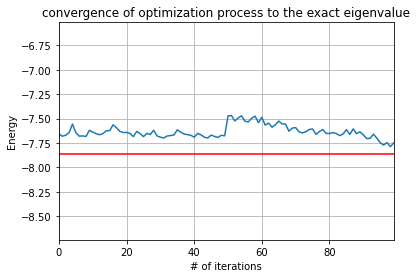

In [124]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [125]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [126]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

2it [00:00,  6.11it/s]

{'1101': 102, '0101': 110, '1110': 103, '0010': 32, '0011': 32, '1100': 43, '0110': 191, '0111': 144, '0001': 91, '1111': 78, '1000': 20, '0000': 19, '1011': 20, '1001': 32, '1010': 5, '0100': 2}
1.0
{'0110': 191, '1111': 99, '0111': 155, '1001': 28, '0001': 80, '1101': 89, '1110': 106, '1100': 45, '0000': 27, '0101': 106, '1000': 22, '0011': 26, '0100': 1, '1011': 19, '0010': 24, '1010': 6}
1.0


3it [00:00,  5.41it/s]

{'0111': 141, '0110': 205, '1111': 78, '0001': 78, '1001': 26, '1110': 129, '0101': 110, '1101': 86, '0011': 15, '0010': 27, '0000': 28, '1010': 9, '1011': 20, '1100': 54, '1000': 18}
1.0
{'1111': 79, '0111': 153, '1000': 31, '0001': 79, '1001': 29, '1110': 125, '1100': 37, '1101': 89, '0110': 191, '1011': 25, '0101': 110, '0000': 17, '0010': 36, '0011': 18, '1010': 5}
1.0


6it [00:01,  5.47it/s]

{'0110': 197, '1001': 37, '0001': 94, '1110': 112, '0101': 116, '0111': 164, '1101': 89, '1011': 15, '1000': 19, '1111': 69, '0011': 13, '1100': 39, '0010': 29, '1010': 7, '0000': 23, '0100': 1}
1.0
{'0101': 113, '1110': 124, '1111': 87, '0110': 184, '0111': 139, '1001': 37, '0010': 23, '1101': 90, '1000': 27, '0011': 24, '0001': 93, '1011': 20, '1100': 36, '0000': 24, '0100': 1, '1010': 2}
1.0


8it [00:01,  6.29it/s]

{'0110': 208, '0001': 79, '1101': 91, '0000': 22, '1011': 16, '1110': 118, '0111': 143, '0011': 20, '0101': 117, '1000': 24, '1111': 88, '1001': 26, '0010': 24, '1100': 45, '1010': 3}
1.0
{'0111': 163, '0101': 90, '1110': 120, '1000': 15, '1101': 92, '1001': 36, '0011': 21, '0110': 200, '1100': 46, '0001': 66, '1111': 81, '0000': 24, '1010': 4, '1011': 25, '0010': 39, '0100': 2}
1.0


10it [00:01,  6.70it/s]

{'1001': 31, '0001': 7, '1111': 94, '0110': 241, '1100': 104, '1110': 76, '1101': 77, '0111': 90, '0000': 111, '1010': 14, '0010': 8, '1011': 12, '0100': 122, '1000': 8, '0011': 23, '0101': 6}
1.0
{'0110': 46, '1111': 45, '0010': 216, '0001': 147, '1001': 90, '0111': 74, '1101': 56, '0011': 150, '1000': 49, '1010': 81, '1110': 20, '0000': 34, '1100': 4, '0101': 8, '1011': 2, '0100': 2}
1.0


12it [00:01,  7.22it/s]

{'0010': 172, '0011': 71, '0100': 46, '1000': 72, '0000': 242, '1001': 94, '1111': 101, '1110': 34, '0110': 87, '1010': 8, '1101': 9, '0001': 32, '1011': 51, '0101': 1, '1100': 3, '0111': 1}
1.0
{'1100': 42, '0001': 87, '1001': 35, '1111': 85, '0110': 181, '1110': 129, '0101': 110, '0111': 133, '1010': 3, '1101': 93, '0010': 34, '0011': 22, '1011': 22, '1000': 27, '0000': 16, '0100': 5}
1.0


14it [00:02,  7.00it/s]

{'1111': 89, '0110': 174, '0001': 91, '0101': 117, '1110': 146, '0111': 168, '1101': 86, '0010': 29, '0011': 15, '1100': 35, '1001': 22, '0000': 11, '1000': 16, '1010': 6, '1011': 17, '0100': 2}
1.0
{'1100': 33, '0101': 117, '1110': 135, '1101': 86, '1011': 16, '0010': 34, '0110': 194, '1111': 77, '0111': 147, '0001': 86, '1000': 23, '1001': 29, '1010': 6, '0000': 22, '0011': 17, '0100': 2}
1.0


15it [00:02,  6.45it/s]


{'1111': 76, '0110': 172, '0000': 23, '1001': 30, '1101': 88, '0101': 126, '1110': 127, '0111': 152, '0001': 86, '1000': 22, '0010': 31, '1100': 43, '0011': 27, '1011': 17, '1010': 3, '0100': 1}
1.0


1it [00:00,  6.74it/s]

{'1111': 39, '0110': 211, '1110': 86, '0101': 86, '0111': 83, '1101': 119, '1100': 180, '0001': 61, '0010': 24, '0011': 25, '0000': 46, '1000': 36, '1001': 18, '0100': 5, '1011': 5}
1.0


2it [00:00,  6.15it/s]

{'0110': 227, '1000': 24, '0001': 66, '0010': 30, '1101': 142, '1100': 145, '0111': 69, '0101': 94, '1011': 12, '1111': 50, '1001': 19, '1110': 85, '0011': 26, '0000': 25, '0100': 10}
1.0


3it [00:00,  6.18it/s]

{'1100': 171, '0110': 210, '0100': 9, '1101': 121, '0101': 93, '0111': 57, '0010': 36, '0001': 55, '1111': 37, '1110': 100, '1000': 35, '1001': 32, '0011': 25, '0000': 37, '1011': 5, '1010': 1}
1.0


4it [00:00,  6.49it/s]

{'1101': 139, '1111': 44, '0110': 216, '1100': 175, '0001': 61, '0111': 56, '1110': 79, '0000': 40, '0101': 78, '1000': 36, '0011': 29, '0010': 34, '0100': 10, '1001': 21, '1011': 5, '1010': 1}
1.0


5it [00:00,  5.73it/s]

{'0110': 229, '1110': 87, '1101': 127, '1000': 49, '0011': 27, '1100': 137, '0001': 55, '1001': 28, '0111': 70, '1111': 43, '0000': 41, '0101': 85, '0010': 29, '1011': 7, '0100': 10}
1.0
{'1100': 137, '0111': 77, '0110': 218, '1101': 122, '1110': 85, '0101': 81, '1001': 37, '0000': 35, '1000': 34, '0001': 83, '0010': 34, '1111': 47, '1011': 10, '0011': 21, '0100': 3}

6it [00:01,  5.54it/s]


1.0


7it [00:01,  5.20it/s]

{'1100': 154, '0001': 72, '1001': 32, '1000': 39, '0000': 32, '1101': 126, '0101': 81, '1110': 87, '1111': 52, '0110': 229, '0011': 26, '0111': 56, '1011': 7, '0100': 6, '0010': 24, '1010': 1}
1.0
{'1111': 40, '0110': 226, '1100': 141, '0001': 81, '0101': 69, '1101': 142, '0111': 66, '0000': 37, '1110': 98, '1001': 28, '0011': 23, '0010': 26, '1000': 36, '0100': 9, '1011': 2}
1.0


10it [00:01,  5.32it/s]

{'1110': 54, '0111': 123, '1100': 40, '0011': 37, '0110': 46, '1111': 163, '0000': 87, '1101': 180, '1001': 53, '0100': 154, '1011': 24, '0101': 31, '0010': 11, '0001': 16, '1010': 1, '1000': 4}
1.0
{'1100': 44, '1111': 27, '1000': 61, '0000': 139, '0111': 44, '0010': 79, '1110': 91, '0001': 206, '1010': 134, '0011': 77, '1001': 50, '0110': 26, '1101': 34, '0100': 7, '0101': 5}
1.0


12it [00:02,  5.83it/s]

{'1001': 89, '0001': 140, '1101': 46, '0011': 154, '0000': 115, '1000': 172, '0110': 17, '1011': 34, '0100': 20, '0010': 86, '0101': 11, '1110': 6, '1111': 118, '1100': 4, '0111': 7, '1010': 5}
1.0
{'1110': 91, '0101': 74, '0001': 47, '1100': 162, '1101': 140, '1111': 50, '0110': 223, '1000': 38, '1001': 33, '0011': 24, '0111': 59, '0010': 31, '0000': 38, '0100': 6, '1011': 7, '1010': 1}
1.0


14it [00:02,  6.25it/s]

{'0000': 38, '0101': 64, '1110': 89, '1100': 169, '0110': 209, '0001': 58, '0010': 37, '1101': 145, '1111': 45, '0111': 65, '1001': 29, '0011': 27, '1000': 33, '1011': 6, '0100': 9, '1010': 1}
1.0
{'1110': 88, '0001': 64, '0110': 232, '0011': 27, '1100': 158, '0010': 28, '1011': 9, '1101': 128, '0000': 38, '0111': 70, '1000': 33, '0101': 74, '1001': 29, '1111': 40, '0100': 6}
1.0


15it [00:02,  5.79it/s]


{'0110': 228, '0101': 65, '1110': 107, '1100': 167, '0111': 67, '1101': 142, '0100': 9, '1001': 19, '1111': 46, '0011': 19, '0010': 33, '0001': 48, '0000': 33, '1011': 6, '1000': 35}
1.0


1it [00:00,  7.32it/s]

{'1101': 71, '0110': 127, '1111': 125, '1100': 200, '1110': 82, '1000': 19, '0001': 70, '1011': 20, '0100': 89, '0000': 54, '0011': 17, '0101': 23, '0111': 75, '1001': 32, '0010': 7, '1010': 13}
1.0


2it [00:00,  6.99it/s]

{'1101': 80, '0100': 85, '0110': 128, '1111': 136, '1100': 227, '1110': 78, '1001': 33, '0111': 60, '0011': 14, '1011': 13, '0001': 65, '0101': 17, '1010': 16, '1000': 19, '0000': 48, '0010': 5}
1.0
{'1111': 129, '0110': 141, '1101': 75, '0100': 79, '1100': 209, '0111': 67, '0000': 49, '0001': 72, '1010': 6, '1001': 19, '1011': 12, '1110': 97, '0011': 21, '0101': 19, '0010': 4, '1000': 25}

4it [00:00,  5.94it/s]


1.0
{'0111': 62, '1100': 194, '0011': 30, '1101': 67, '0100': 111, '1001': 22, '1111': 132, '0110': 132, '0000': 45, '1110': 102, '0101': 18, '1011': 22, '1000': 17, '0001': 54, '0010': 3, '1010': 13}
1.0


6it [00:00,  6.20it/s]

{'0001': 77, '0000': 49, '0110': 122, '1111': 143, '1100': 190, '0011': 25, '0100': 82, '0111': 49, '1101': 80, '1110': 91, '1011': 23, '0101': 32, '1001': 31, '1000': 10, '0010': 6, '1010': 14}
1.0
{'0101': 18, '1110': 80, '1100': 212, '0110': 123, '0111': 78, '1001': 30, '0010': 7, '1101': 79, '0000': 41, '0100': 78, '1011': 22, '0001': 65, '1111': 141, '0011': 17, '1010': 9, '1000': 24}
1.0


8it [00:01,  6.19it/s]

{'0011': 17, '1100': 217, '0000': 70, '1001': 18, '1110': 76, '0110': 127, '1111': 128, '0111': 87, '1101': 77, '0001': 63, '0100': 92, '1000': 15, '0101': 18, '0010': 3, '1011': 12, '1010': 4}
1.0
{'1010': 17, '1001': 30, '0001': 59, '1111': 138, '0110': 129, '0011': 21, '1101': 70, '0100': 84, '0111': 70, '0000': 62, '1100': 196, '1110': 90, '1011': 21, '0010': 6, '0101': 17, '1000': 14}
1.0


10it [00:01,  7.08it/s]

{'1111': 97, '0110': 147, '0100': 55, '1101': 329, '0000': 42, '1001': 57, '0001': 46, '0111': 45, '0011': 67, '0101': 58, '1010': 7, '1110': 64, '1011': 7, '1000': 1, '1100': 2}
1.0
{'0011': 123, '0000': 251, '1000': 38, '0100': 52, '0111': 48, '0101': 9, '0001': 117, '1010': 150, '1111': 56, '1011': 26, '1101': 48, '1110': 46, '1100': 27, '1001': 7, '0110': 22, '0010': 4}
1.0


12it [00:01,  6.66it/s]

{'0001': 249, '1001': 142, '0011': 68, '1101': 94, '1000': 65, '0110': 74, '1111': 101, '0010': 121, '0000': 33, '1011': 34, '0101': 19, '0100': 11, '0111': 5, '1110': 8}
1.0
{'0011': 17, '1100': 232, '1111': 125, '0110': 121, '0100': 90, '1101': 70, '0001': 73, '0101': 24, '0000': 58, '1110': 89, '1001': 28, '0111': 63, '0010': 5, '1000': 13, '1010': 7, '1011': 9}
1.0


14it [00:02,  6.55it/s]

{'0111': 74, '1110': 82, '0101': 17, '0100': 64, '1101': 86, '0001': 73, '1111': 123, '1100': 178, '0110': 145, '1000': 27, '1011': 31, '0000': 54, '0011': 20, '1001': 36, '1010': 10, '0010': 4}
1.0
{'1100': 187, '0000': 55, '1111': 142, '0110': 119, '0100': 89, '0111': 87, '0001': 57, '0101': 33, '1010': 9, '1101': 76, '1110': 84, '1011': 16, '1000': 16, '0011': 21, '1001': 26, '0010': 7}
1.0


15it [00:02,  6.56it/s]


{'0110': 124, '1111': 139, '1100': 201, '0100': 85, '1101': 75, '1001': 24, '1110': 78, '1011': 26, '0001': 63, '0000': 52, '0111': 77, '0101': 28, '1010': 11, '1000': 16, '0011': 17, '0010': 8}
1.0


1it [00:00,  7.72it/s]

{'1111': 38, '0110': 153, '1110': 212, '1000': 38, '0001': 23, '1101': 142, '0100': 47, '1011': 40, '0101': 38, '1010': 80, '0111': 24, '0010': 31, '0011': 13, '1001': 13, '1100': 104, '0000': 28}
1.0


2it [00:00,  7.46it/s]

{'1110': 218, '0101': 57, '0110': 142, '1000': 32, '1101': 128, '1100': 142, '1010': 60, '0010': 35, '1011': 22, '1001': 9, '0011': 12, '1111': 40, '0111': 18, '0001': 22, '0000': 39, '0100': 48}
1.0


3it [00:00,  7.86it/s]

{'1001': 12, '1111': 20, '0110': 167, '0101': 45, '1100': 120, '0011': 10, '1000': 42, '0100': 44, '0001': 24, '1110': 215, '1010': 55, '1101': 142, '0111': 24, '0000': 41, '0010': 37, '1011': 26}
1.0


4it [00:00,  7.13it/s]

{'0000': 37, '1110': 227, '1101': 132, '0100': 55, '1100': 120, '1010': 63, '0001': 27, '1001': 12, '0110': 145, '0111': 22, '1111': 24, '0101': 46, '1000': 41, '0010': 35, '0011': 13, '1011': 25}
1.0


5it [00:00,  6.85it/s]

{'0101': 43, '1110': 210, '1101': 129, '1100': 128, '0110': 145, '1000': 48, '1011': 25, '0001': 14, '0111': 28, '1111': 38, '0010': 46, '1001': 16, '0100': 44, '0000': 40, '0011': 12, '1010': 58}
1.0


6it [00:00,  7.08it/s]

{'1101': 112, '0100': 49, '1111': 44, '0110': 133, '1000': 45, '1010': 62, '0111': 33, '1011': 29, '1100': 109, '1110': 210, '0101': 40, '0010': 57, '0001': 29, '0000': 48, '1001': 15, '0011': 9}
1.0


7it [00:00,  6.96it/s]

{'1101': 150, '0100': 50, '0101': 39, '1110': 208, '1010': 68, '1100': 125, '0110': 157, '0111': 31, '0001': 20, '1111': 35, '0000': 37, '0011': 11, '0010': 32, '1000': 29, '1011': 18, '1001': 14}
1.0


8it [00:01,  6.90it/s]

{'0110': 163, '1100': 137, '0010': 42, '1011': 27, '1010': 57, '1001': 17, '1101': 136, '1110': 190, '0101': 40, '1000': 36, '1111': 32, '0100': 47, '0001': 17, '0111': 30, '0011': 17, '0000': 36}
1.0


9it [00:01,  6.26it/s]

{'0101': 29, '1110': 38, '1101': 105, '0100': 215, '1111': 216, '0000': 53, '1001': 107, '1100': 152, '0011': 43, '0111': 20, '1000': 14, '1010': 1, '0110': 18, '1011': 8, '0001': 5}
1.0


10it [00:01,  6.24it/s]

{'0110': 96, '1101': 62, '1000': 162, '0000': 56, '1110': 61, '1010': 232, '1100': 46, '0111': 30, '1011': 18, '0011': 47, '1001': 38, '0010': 46, '0001': 106, '0101': 9, '1111': 15}
1.0


11it [00:01,  6.01it/s]

{'0100': 61, '0110': 36, '1111': 141, '1011': 24, '1001': 193, '0001': 69, '1000': 266, '0000': 76, '0010': 36, '0011': 78, '1100': 18, '1110': 4, '0101': 2, '0111': 16, '1010': 2, '1101': 2}
1.0


12it [00:01,  6.11it/s]

{'1110': 185, '0110': 168, '1001': 20, '1010': 62, '1101': 131, '1100': 122, '1000': 51, '0010': 40, '0000': 50, '0101': 50, '0001': 17, '1011': 19, '1111': 31, '0011': 10, '0100': 37, '0111': 31}
1.0


14it [00:02,  5.68it/s]

{'1011': 25, '1101': 130, '0100': 57, '0000': 50, '1000': 39, '0110': 139, '1100': 112, '1110': 215, '0001': 25, '1010': 61, '0010': 42, '1111': 31, '0111': 21, '0101': 49, '0011': 13, '1001': 15}
1.0
{'0000': 37, '1000': 51, '1010': 45, '1111': 40, '0110': 139, '1110': 221, '0111': 26, '1100': 112, '1101': 135, '0001': 21, '0010': 40, '0100': 50, '0101': 43, '1011': 31, '1001': 17, '0011': 16}
1.0


15it [00:02,  6.43it/s]


{'0101': 46, '1110': 205, '0110': 159, '1111': 32, '1011': 19, '1100': 107, '1101': 150, '0000': 45, '0111': 26, '1000': 37, '0010': 44, '1010': 53, '1001': 18, '0100': 56, '0001': 20, '0011': 7}
1.0


1it [00:00,  8.85it/s]

{'1000': 80, '0100': 8, '1101': 80, '1110': 94, '0101': 38, '0110': 214, '0001': 117, '1001': 51, '1011': 46, '1100': 178, '0011': 48, '0000': 29, '0111': 19, '1010': 6, '1111': 11, '0010': 5}
1.0


2it [00:00,  6.57it/s]

{'1100': 172, '0011': 48, '0001': 134, '1000': 86, '0000': 39, '1101': 85, '1011': 46, '0110': 211, '1110': 64, '1001': 58, '0111': 18, '1111': 12, '0100': 8, '0101': 36, '0010': 4, '1010': 3}
1.0


3it [00:00,  7.64it/s]

{'0011': 38, '1100': 170, '0101': 42, '1101': 83, '1001': 49, '0001': 111, '1000': 89, '0110': 221, '1110': 81, '1010': 7, '1011': 57, '1111': 14, '0111': 15, '0000': 33, '0100': 11, '0010': 3}
1.0


4it [00:00,  7.87it/s]

{'0001': 121, '1001': 59, '0000': 22, '1110': 87, '0101': 40, '1101': 69, '0011': 55, '1100': 189, '1011': 61, '0110': 197, '0100': 12, '1000': 75, '0111': 15, '1111': 16, '1010': 2, '0010': 4}
1.0


5it [00:00,  7.86it/s]

{'0110': 197, '1101': 71, '1011': 54, '1000': 90, '1110': 92, '0101': 44, '1100': 162, '0001': 123, '0000': 36, '1001': 55, '0011': 52, '0100': 10, '0111': 20, '1111': 10, '0010': 6, '1010': 2}
1.0


6it [00:00,  7.30it/s]

{'1001': 60, '0001': 112, '1111': 16, '0110': 218, '1100': 155, '1101': 81, '1011': 40, '0101': 35, '1000': 106, '1110': 71, '0111': 21, '0000': 27, '0011': 64, '0010': 9, '0100': 6, '1010': 3}
1.0


7it [00:00,  6.74it/s]

{'0101': 36, '1110': 77, '1000': 95, '0111': 21, '1100': 192, '0110': 216, '1101': 74, '0001': 96, '1011': 44, '0011': 61, '1001': 49, '0000': 39, '0100': 7, '1010': 4, '1111': 9, '0010': 4}
1.0


8it [00:01,  6.60it/s]

{'1111': 20, '0110': 222, '1101': 84, '0000': 33, '1000': 84, '1001': 53, '0001': 110, '1100': 184, '1011': 55, '1010': 6, '0101': 24, '0011': 50, '1110': 72, '0111': 18, '0100': 7, '0010': 2}
1.0


9it [00:01,  6.95it/s]

{'1101': 102, '0100': 106, '1111': 153, '0101': 39, '1110': 61, '1000': 70, '0000': 80, '0001': 101, '0110': 68, '1011': 70, '1001': 62, '0111': 68, '0011': 9, '1100': 21, '1010': 7, '0010': 7}
1.0


10it [00:01,  7.28it/s]

{'0001': 170, '1000': 112, '0000': 87, '1100': 100, '0011': 31, '1110': 97, '1111': 42, '0110': 119, '0111': 10, '0100': 24, '0010': 65, '1010': 42, '1001': 77, '0101': 8, '1011': 33, '1101': 7}
1.0


11it [00:01,  7.52it/s]

{'0000': 68, '1000': 180, '1111': 101, '0010': 55, '0001': 108, '1100': 41, '0011': 163, '1101': 87, '0111': 36, '1001': 48, '0110': 52, '0100': 2, '0101': 53, '1110': 21, '1011': 7, '1010': 2}
1.0


12it [00:01,  6.85it/s]

{'1000': 89, '0110': 217, '1101': 82, '1100': 175, '0011': 73, '1001': 48, '1010': 4, '0001': 121, '0101': 31, '0000': 31, '1110': 64, '0100': 4, '1011': 54, '0111': 15, '1111': 13, '0010': 3}
1.0


13it [00:01,  6.61it/s]

{'1001': 46, '0001': 118, '1101': 72, '0110': 201, '1110': 87, '0011': 66, '1100': 165, '1000': 99, '0111': 28, '1011': 60, '0000': 22, '1111': 10, '0101': 26, '0010': 6, '0100': 15, '1010': 3}
1.0


14it [00:01,  6.87it/s]

{'0001': 119, '0110': 205, '1100': 178, '1110': 95, '1000': 85, '1011': 47, '0111': 12, '1101': 77, '1111': 14, '1001': 57, '0000': 37, '0010': 7, '0011': 52, '0101': 31, '0100': 7, '1010': 1}
1.0


15it [00:02,  7.06it/s]


{'0110': 227, '1000': 81, '0000': 30, '1110': 79, '1100': 174, '0011': 47, '0001': 117, '0100': 9, '1101': 76, '1001': 53, '1011': 61, '0111': 16, '0010': 7, '0101': 37, '1111': 8, '1010': 2}
1.0


1it [00:00,  7.43it/s]

{'1010': 3, '0110': 361, '0000': 106, '1000': 79, '1100': 157, '0010': 23, '1101': 155, '0111': 32, '1111': 13, '0001': 43, '0101': 4, '1001': 26, '0100': 5, '1011': 4, '1110': 9, '0011': 4}
1.0


2it [00:00,  7.24it/s]

{'0110': 352, '1110': 18, '0001': 50, '1001': 20, '1100': 177, '1000': 78, '0000': 94, '0111': 37, '1101': 118, '1011': 8, '0100': 9, '0010': 34, '0101': 6, '1111': 16, '1010': 3, '0011': 4}
1.0


3it [00:00,  7.00it/s]

{'0110': 404, '1110': 19, '1100': 173, '0000': 99, '1000': 72, '0001': 48, '1101': 87, '0111': 44, '1001': 17, '0011': 1, '0010': 38, '0100': 6, '1011': 3, '1111': 8, '0101': 4, '1010': 1}
1.0


4it [00:00,  7.19it/s]

{'0110': 391, '0111': 38, '1000': 69, '0100': 10, '1101': 142, '1100': 171, '0101': 1, '0001': 30, '0000': 89, '0010': 29, '1111': 14, '1001': 19, '1110': 6, '1010': 4, '1011': 8, '0011': 3}
1.0


5it [00:00,  7.18it/s]

{'0110': 379, '1000': 76, '0000': 97, '0111': 50, '1100': 184, '1101': 110, '1001': 22, '0001': 28, '0100': 13, '0101': 4, '1111': 8, '1110': 16, '0010': 25, '1011': 6, '1010': 3, '0011': 3}
1.0


6it [00:00,  6.98it/s]

{'0110': 355, '1010': 5, '0001': 41, '0000': 101, '1000': 91, '1101': 120, '1100': 183, '0111': 38, '1001': 15, '1011': 4, '0100': 7, '1111': 12, '0010': 37, '0011': 5, '1110': 7, '0101': 3}
1.0
{'0000': 92, '1000': 93, '1101': 133, '0100': 10, '0110': 355, '1100': 168, '1110': 11, '0001': 38, '0111': 37, '0010': 35, '1001': 18, '1011': 10, '0101': 4, '1111': 9, '0011': 9, '1010': 2}
1.0


8it [00:01,  6.84it/s]

{'0111': 36, '1100': 152, '0110': 389, '0010': 44, '0001': 39, '1101': 123, '0000': 92, '1110': 10, '0011': 6, '1001': 28, '1000': 69, '1010': 3, '0100': 8, '0101': 6, '1111': 10, '1011': 9}
1.0


9it [00:01,  6.99it/s]

{'1101': 139, '0100': 217, '0000': 94, '0110': 77, '1110': 12, '0010': 43, '0001': 10, '1010': 21, '0101': 58, '1111': 154, '0111': 47, '1011': 47, '1001': 75, '0011': 26, '1100': 2, '1000': 2}
1.0


10it [00:01,  7.29it/s]

{'1000': 86, '0000': 191, '1001': 40, '1010': 164, '0001': 98, '0010': 162, '1100': 54, '1110': 82, '0011': 37, '0110': 37, '0100': 3, '1101': 24, '0111': 7, '0101': 32, '1111': 6, '1011': 1}
1.0


11it [00:01,  6.76it/s]

{'0001': 110, '1001': 141, '1111': 89, '1000': 121, '0000': 141, '1110': 59, '0011': 137, '0010': 89, '1101': 26, '0100': 41, '1100': 13, '1010': 13, '1011': 19, '0111': 4, '0101': 11, '0110': 10}
1.0


12it [00:01,  6.04it/s]

{'0111': 47, '1100': 168, '1111': 9, '0110': 361, '1000': 84, '0000': 85, '1101': 132, '0010': 32, '0001': 45, '1001': 18, '1011': 6, '1110': 14, '0011': 9, '0100': 4, '0101': 5, '1010': 5}
1.0


13it [00:01,  6.13it/s]

{'1101': 106, '1010': 4, '1001': 14, '1111': 16, '0110': 372, '1100': 176, '0010': 38, '0101': 7, '1110': 11, '1000': 84, '1011': 11, '0111': 47, '0000': 85, '0100': 8, '0001': 40, '0011': 5}
1.0


14it [00:02,  6.35it/s]

{'1100': 174, '0111': 36, '1111': 12, '0110': 356, '0000': 108, '1000': 81, '1101': 126, '1010': 7, '0010': 29, '1001': 20, '0100': 8, '1110': 19, '0001': 34, '0101': 3, '1011': 9, '0011': 2}
1.0


15it [00:02,  6.68it/s]


{'1100': 176, '0011': 5, '1000': 85, '0000': 98, '0110': 385, '0001': 34, '1101': 106, '0111': 35, '0010': 34, '0100': 11, '1001': 16, '1111': 17, '1110': 10, '1011': 8, '1010': 1, '0101': 3}
1.0


0it [00:00, ?it/s]

{'0110': 210, '1101': 90, '0011': 3, '1100': 190, '0001': 97, '1110': 176, '1000': 24, '1011': 7, '1111': 28, '0101': 28, '0111': 86, '0100': 31, '1010': 11, '0000': 20, '1001': 10, '0010': 13}
1.0


2it [00:00,  6.56it/s]

{'1100': 189, '0110': 217, '1101': 96, '1010': 8, '0001': 96, '1110': 167, '0111': 68, '0010': 19, '1111': 32, '0101': 39, '1000': 21, '0100': 33, '0000': 25, '1001': 6, '0011': 6, '1011': 2}
1.0


3it [00:00,  7.25it/s]

{'1100': 206, '1111': 24, '0110': 223, '0100': 32, '1101': 88, '0101': 33, '1110': 178, '0001': 81, '0111': 75, '1000': 30, '0000': 16, '1001': 8, '1010': 12, '0010': 11, '1011': 3, '0011': 4}
1.0


4it [00:00,  6.48it/s]

{'1100': 210, '0001': 102, '1111': 24, '0110': 188, '0100': 34, '1101': 91, '1000': 21, '1110': 171, '0111': 73, '1010': 13, '0101': 36, '0000': 19, '0010': 19, '1001': 10, '0011': 6, '1011': 7}
1.0


5it [00:00,  6.40it/s]

{'1110': 170, '0110': 199, '1010': 9, '0001': 81, '1101': 90, '0100': 38, '1100': 219, '0111': 69, '0101': 45, '0000': 27, '1011': 5, '1111': 21, '1001': 10, '1000': 26, '0011': 5, '0010': 10}
1.0


6it [00:00,  6.75it/s]

{'0111': 62, '0110': 188, '1111': 31, '1101': 85, '0100': 31, '1100': 216, '0000': 19, '0001': 108, '1110': 175, '1000': 30, '1001': 11, '0010': 17, '0101': 36, '1010': 8, '1011': 5, '0011': 2}
1.0


7it [00:01,  7.14it/s]

{'0000': 20, '1100': 199, '1111': 19, '0110': 223, '1101': 87, '1110': 184, '0111': 88, '0010': 11, '1000': 21, '1001': 7, '0001': 79, '0101': 37, '0100': 24, '1010': 15, '1011': 5, '0011': 5}
1.0
{'0110': 224, '1101': 89, '0100': 21, '0111': 81, '1110': 183, '0011': 3, '1100': 187, '0000': 31, '0101': 30, '1001': 13, '0001': 92, '1000': 29, '0010': 13, '1010': 9, '1111': 16, '1011': 3}
1.0
{'0100': 80, '1101': 196, '0111': 147, '1111': 229, '1100': 37, '0011': 58, '0001': 27, '1110': 30, '0010': 17, '1001': 25, '0000': 46, '0110': 95, '1011': 8, '0101': 20, '1010': 9}
1.0


10it [00:01,  8.00it/s]

{'1010': 185, '1001': 34, '0001': 144, '1000': 22, '0000': 203, '0010': 104, '1110': 105, '0110': 29, '0011': 37, '0101': 24, '0111': 14, '1100': 13, '1101': 20, '1111': 43, '0100': 30, '1011': 17}
1.0
{'0010': 112, '0001': 154, '0000': 36, '1000': 101, '0111': 25, '1111': 114, '0011': 188, '1101': 51, '1001': 44, '1110': 20, '1100': 23, '1011': 96, '0110': 32, '1010': 5, '0100': 10, '0101': 13}

12it [00:01,  7.05it/s]


1.0
{'1101': 97, '0100': 38, '1100': 197, '0110': 203, '0001': 91, '0000': 24, '0101': 36, '1110': 182, '0111': 80, '0010': 14, '1111': 19, '1011': 10, '1000': 17, '1001': 9, '1010': 5, '0011': 2}
1.0


14it [00:01,  7.77it/s]

{'0110': 225, '1111': 23, '0101': 37, '1110': 171, '1100': 196, '0001': 94, '1000': 27, '0111': 66, '1010': 10, '0100': 38, '1101': 81, '0010': 14, '1001': 13, '0000': 22, '0011': 1, '1011': 6}
1.0
{'0101': 35, '1110': 187, '0001': 98, '1001': 10, '0111': 77, '0110': 200, '1111': 27, '1100': 194, '0100': 31, '1101': 99, '1011': 4, '1000': 18, '0011': 5, '0010': 15, '0000': 20, '1010': 4}
1.0


15it [00:02,  7.08it/s]


{'0001': 97, '0110': 220, '1100': 218, '1011': 5, '1110': 142, '0100': 37, '1101': 104, '0000': 19, '1010': 12, '0101': 39, '1000': 24, '0111': 54, '0011': 4, '0010': 18, '1111': 23, '1001': 8}
1.0


0it [00:00, ?it/s]

{'0000': 43, '1000': 18, '0001': 96, '1001': 39, '0111': 50, '0110': 236, '1101': 188, '1110': 49, '1100': 80, '0101': 86, '0100': 48, '0011': 20, '1010': 31, '1011': 11, '1111': 21, '0010': 8}
1.0


1it [00:00,  5.82it/s]

{'0100': 49, '1101': 187, '0101': 101, '1000': 18, '1100': 78, '0001': 101, '1001': 31, '1111': 26, '1010': 37, '0110': 221, '0000': 52, '0011': 18, '1110': 48, '0111': 37, '0010': 11, '1011': 9}
1.0


3it [00:00,  6.81it/s]

{'0100': 53, '1101': 188, '1100': 80, '0110': 206, '0101': 86, '1010': 50, '0010': 12, '0111': 45, '1110': 58, '0001': 79, '0011': 18, '1000': 16, '0000': 55, '1001': 40, '1111': 30, '1011': 8}
1.0


4it [00:00,  7.61it/s]

{'0110': 219, '1111': 19, '1100': 77, '1101': 204, '0101': 99, '1010': 42, '0111': 45, '0000': 53, '1001': 35, '0001': 89, '1110': 50, '0011': 18, '1011': 7, '0100': 42, '1000': 14, '0010': 11}
1.0


5it [00:00,  7.17it/s]

{'1101': 211, '0101': 68, '1110': 49, '1100': 70, '0110': 198, '0111': 35, '1001': 33, '0001': 108, '1111': 22, '0100': 62, '0010': 12, '0000': 60, '1010': 53, '0011': 21, '1000': 18, '1011': 4}
1.0


6it [00:00,  6.48it/s]

{'1101': 192, '1111': 29, '0110': 205, '0010': 12, '0101': 97, '0001': 101, '1010': 43, '1100': 85, '0111': 45, '1000': 20, '0100': 33, '1001': 28, '0000': 66, '1110': 54, '0011': 13, '1011': 1}
1.0


7it [00:01,  6.33it/s]

{'0100': 53, '1101': 199, '0110': 223, '1100': 86, '0001': 86, '1000': 20, '0010': 12, '0101': 79, '1110': 58, '1111': 30, '1010': 40, '0000': 55, '1001': 31, '0111': 29, '0011': 17, '1011': 6}
1.0


8it [00:01,  6.47it/s]

{'1101': 213, '0000': 74, '0111': 33, '0110': 211, '0001': 89, '1001': 38, '1010': 46, '1100': 65, '0101': 77, '0011': 17, '0100': 45, '1111': 23, '1110': 57, '0010': 16, '1011': 9, '1000': 11}
1.0


9it [00:01,  6.37it/s]

{'1001': 43, '0001': 72, '1000': 20, '0000': 69, '1100': 71, '1101': 103, '0100': 125, '0110': 87, '0111': 139, '1111': 149, '0011': 38, '1110': 17, '0101': 47, '1011': 19, '0010': 16, '1010': 9}
1.0


10it [00:01,  5.77it/s]

{'0000': 154, '1010': 116, '1001': 32, '0001': 322, '1110': 14, '1011': 4, '0010': 136, '1100': 11, '1101': 55, '0011': 55, '0110': 54, '1000': 32, '0111': 20, '0100': 8, '0101': 6, '1111': 5}
1.0


11it [00:01,  6.55it/s]

{'0011': 271, '0001': 121, '1001': 51, '1011': 41, '0010': 101, '1000': 101, '0000': 170, '0101': 46, '1101': 36, '1111': 37, '1110': 4, '1100': 2, '0111': 24, '0110': 3, '0100': 12, '1010': 4}
1.0


12it [00:01,  6.68it/s]

{'0100': 43, '1101': 200, '1111': 24, '0110': 222, '1100': 84, '0101': 93, '1001': 25, '0001': 105, '1000': 18, '1010': 33, '0000': 64, '0010': 11, '0111': 35, '1110': 46, '0011': 17, '1011': 4}
1.0


13it [00:01,  7.08it/s]

{'1100': 92, '1011': 8, '0010': 12, '0000': 56, '1101': 230, '1010': 30, '0110': 205, '0111': 39, '0100': 51, '1110': 40, '1001': 40, '0011': 14, '0101': 89, '0001': 87, '1000': 14, '1111': 17}
1.0


14it [00:02,  7.44it/s]

{'1101': 196, '0110': 218, '1111': 28, '1000': 24, '0101': 83, '1100': 68, '0001': 113, '1010': 44, '1110': 40, '0010': 8, '0000': 64, '1001': 34, '0111': 39, '0100': 47, '1011': 7, '0011': 11}
1.0


15it [00:02,  6.58it/s]


{'1111': 20, '0110': 201, '1101': 209, '0101': 91, '1100': 76, '0111': 35, '1000': 17, '0010': 14, '0001': 109, '0100': 53, '1010': 44, '0000': 57, '1001': 43, '1011': 6, '1110': 35, '0011': 14}
1.0


1it [00:00,  7.82it/s]

{'1111': 42, '0110': 204, '1101': 119, '1100': 160, '0111': 70, '1110': 94, '0001': 68, '1000': 50, '1001': 33, '0000': 46, '0101': 73, '0010': 26, '0100': 8, '0011': 20, '1011': 11}
1.0


2it [00:00,  6.96it/s]

{'0000': 32, '1000': 45, '1110': 92, '0101': 91, '1001': 23, '0110': 195, '1101': 138, '1100': 170, '1111': 31, '0011': 29, '1011': 12, '0001': 75, '0111': 63, '0010': 21, '0100': 7}
1.0


3it [00:00,  7.00it/s]

{'1100': 162, '1001': 22, '0001': 58, '0110': 207, '1110': 78, '1101': 128, '0111': 77, '0010': 32, '0101': 95, '1000': 59, '0000': 39, '0011': 17, '1111': 30, '1011': 13, '0100': 7}
1.0


4it [00:00,  6.54it/s]

{'0010': 28, '0111': 59, '1110': 104, '0000': 35, '0110': 206, '1101': 141, '0011': 29, '1100': 167, '0101': 79, '1001': 28, '1000': 44, '0001': 59, '0100': 7, '1011': 11, '1111': 26, '1010': 1}
1.0


5it [00:00,  6.53it/s]

{'0001': 75, '0011': 32, '1100': 175, '0101': 76, '1110': 91, '0110': 206, '0111': 56, '1101': 140, '0010': 26, '0000': 31, '1111': 34, '1000': 37, '1001': 26, '1011': 12, '0100': 7}
1.0


6it [00:00,  6.56it/s]

{'1100': 165, '0110': 214, '1111': 34, '0111': 65, '1101': 123, '0001': 72, '0000': 29, '1110': 98, '0010': 30, '0101': 87, '1001': 32, '0011': 23, '1000': 39, '1011': 7, '0100': 5, '1010': 1}
1.0


7it [00:01,  6.69it/s]

{'1001': 29, '1101': 131, '0101': 91, '0000': 31, '0110': 207, '0010': 28, '1011': 11, '0111': 71, '1100': 150, '1111': 34, '0001': 63, '1110': 94, '1000': 55, '0011': 20, '0100': 9}
1.0


8it [00:01,  6.78it/s]

{'0011': 30, '1100': 150, '0110': 207, '0000': 45, '0001': 96, '1001': 30, '1011': 9, '0101': 64, '1110': 99, '0111': 53, '1101': 123, '1000': 50, '0100': 5, '1111': 40, '0010': 22, '1010': 1}
1.0


10it [00:01,  6.63it/s]

{'0111': 116, '1101': 184, '0100': 152, '1001': 52, '0110': 63, '1111': 161, '0101': 24, '0000': 92, '1110': 46, '0011': 29, '0001': 26, '1100': 37, '1011': 32, '0010': 3, '1010': 3, '1000': 4}
1.0
{'1001': 51, '0001': 223, '1010': 166, '1000': 75, '0000': 133, '1101': 40, '0010': 80, '1110': 70, '1111': 23, '0011': 73, '0110': 22, '0111': 23, '1100': 37, '1011': 4, '0101': 3, '0100': 1}
1.0


12it [00:01,  6.58it/s]

{'0011': 156, '0100': 29, '1101': 42, '0000': 103, '1000': 172, '0010': 80, '0101': 10, '1001': 93, '0001': 140, '1011': 50, '1100': 1, '1111': 115, '0110': 25, '0111': 5, '1010': 2, '1110': 1}
1.0
{'1110': 91, '0101': 88, '1100': 176, '1101': 130, '1001': 20, '1000': 58, '0111': 73, '1111': 39, '0011': 29, '0110': 199, '0010': 25, '0001': 56, '0000': 30, '0100': 6, '1011': 4}
1.0


14it [00:02,  6.04it/s]

{'0110': 209, '0101': 85, '1110': 78, '1101': 120, '1000': 66, '1001': 23, '1100': 171, '0111': 61, '0001': 65, '1111': 41, '0011': 22, '0000': 43, '1011': 8, '0010': 24, '1010': 2, '0100': 6}
1.0
{'0111': 47, '1100': 150, '1101': 123, '0101': 92, '1110': 112, '0110': 224, '1011': 16, '1000': 49, '0001': 67, '1111': 42, '0011': 19, '0000': 32, '0100': 5, '1001': 19, '0010': 27}
1.0


15it [00:02,  6.49it/s]


{'1100': 146, '0010': 42, '1000': 42, '0101': 81, '1110': 86, '0110': 218, '0100': 11, '1101': 126, '0001': 68, '0000': 34, '0011': 30, '1001': 30, '0111': 76, '1111': 29, '1010': 1, '1011': 4}
1.0


1it [00:00,  7.58it/s]

{'0010': 53, '0110': 183, '0000': 27, '1110': 154, '0101': 183, '0011': 65, '0001': 74, '0111': 24, '1001': 32, '1111': 33, '1100': 40, '1101': 133, '1000': 19, '1010': 2, '0100': 2}
1.0


2it [00:00,  7.44it/s]

{'0101': 203, '1110': 177, '1101': 136, '0010': 67, '0110': 164, '1100': 29, '0001': 67, '1000': 14, '0111': 33, '0011': 59, '1111': 24, '1001': 23, '0000': 22, '1010': 2, '0100': 4}
1.0


3it [00:00,  7.08it/s]

{'0110': 186, '0101': 183, '1110': 144, '0001': 62, '0100': 9, '1101': 140, '0011': 53, '0010': 70, '1000': 18, '1001': 27, '0000': 19, '1111': 29, '0111': 41, '1100': 39, '1010': 4}
1.0


4it [00:00,  7.21it/s]

{'0110': 205, '1110': 119, '0101': 198, '0000': 14, '0011': 53, '0001': 67, '1101': 156, '0010': 50, '1100': 46, '1000': 19, '1001': 27, '0100': 4, '0111': 28, '1111': 35, '1010': 2, '1011': 1}
1.0


5it [00:00,  7.15it/s]

{'1110': 139, '0101': 172, '1100': 43, '1111': 27, '0110': 211, '1101': 160, '0100': 6, '0001': 68, '0011': 51, '0000': 17, '1001': 26, '1000': 17, '0010': 58, '0111': 22, '1010': 5, '1011': 2}
1.0


6it [00:00,  7.20it/s]

{'0001': 65, '1110': 127, '0101': 188, '1000': 14, '0011': 59, '0010': 76, '0110': 209, '1101': 124, '1100': 55, '1001': 30, '0000': 14, '1111': 24, '0111': 28, '0100': 6, '1010': 5}
1.0


7it [00:01,  6.36it/s]

{'0110': 200, '1101': 146, '1110': 148, '0101': 198, '0111': 22, '0010': 67, '1000': 18, '0000': 17, '1001': 17, '0011': 50, '0001': 67, '1100': 37, '1111': 30, '1010': 1, '1011': 1, '0100': 5}
1.0


8it [00:01,  6.52it/s]

{'1101': 162, '0101': 185, '1110': 142, '0110': 209, '1111': 35, '0011': 49, '0001': 66, '1001': 23, '0010': 50, '1100': 49, '1000': 13, '0111': 22, '0000': 12, '1011': 1, '0100': 5, '1010': 1}
1.0


9it [00:01,  6.89it/s]

{'1011': 31, '0010': 48, '0000': 147, '1111': 158, '1110': 53, '1100': 109, '0100': 233, '0111': 133, '1001': 14, '0001': 11, '1101': 61, '0011': 6, '0101': 6, '0110': 13, '1000': 1}
1.0


10it [00:01,  7.34it/s]

{'0000': 29, '1000': 40, '0010': 174, '1010': 127, '0110': 14, '0111': 27, '1110': 75, '0101': 44, '0001': 244, '1011': 59, '0011': 39, '1001': 122, '1101': 9, '1100': 19, '1111': 1, '0100': 1}
1.0


11it [00:01,  6.88it/s]

{'0011': 174, '0111': 24, '0000': 204, '1000': 224, '1010': 25, '1101': 6, '0010': 69, '1110': 16, '0100': 56, '1011': 81, '1111': 48, '0101': 3, '0001': 32, '1100': 21, '1001': 35, '0110': 6}
1.0


12it [00:01,  6.25it/s]

{'0101': 179, '1110': 153, '1101': 159, '0010': 61, '1100': 49, '0011': 50, '1001': 28, '0110': 192, '0001': 66, '0000': 12, '1000': 12, '0111': 20, '1111': 39, '0100': 2, '1010': 2}
1.0


13it [00:01,  6.68it/s]

{'0101': 174, '1110': 151, '1111': 30, '0110': 192, '1101': 141, '0010': 70, '1000': 16, '1100': 36, '0001': 72, '0000': 31, '0011': 49, '1001': 32, '0111': 18, '1011': 1, '0100': 9, '1010': 2}
1.0
{'0110': 193, '1111': 22, '0101': 173, '0010': 63, '0001': 65, '0000': 15, '1101': 175, '1100': 45, '1001': 21, '1110': 141, '0111': 27, '0011': 63, '1000': 16, '0100': 3, '1010': 2}

15it [00:02,  6.92it/s]



1.0
{'0110': 208, '0001': 66, '0101': 186, '1110': 136, '1100': 46, '0011': 51, '0010': 62, '0000': 16, '1101': 154, '1111': 29, '0111': 31, '1001': 15, '1000': 20, '1010': 2, '0100': 2}
1.0


2it [00:00,  6.53it/s]

{'0110': 234, '1110': 81, '0001': 41, '1100': 41, '0011': 57, '1101': 210, '1000': 47, '0010': 72, '0111': 93, '1111': 25, '1001': 43, '0000': 31, '0101': 34, '1011': 6, '0100': 7, '1010': 2}
1.0
{'1100': 33, '0011': 53, '1101': 217, '0101': 35, '0111': 90, '0010': 80, '1001': 55, '0110': 232, '1011': 10, '1110': 70, '0100': 15, '0001': 35, '1000': 51, '0000': 25, '1111': 18, '1010': 5}
1.0


4it [00:00,  6.98it/s]

{'1111': 33, '0110': 215, '0001': 38, '1001': 55, '1000': 32, '1101': 223, '0111': 97, '1100': 37, '1110': 61, '1011': 9, '0011': 57, '0000': 33, '0101': 52, '0010': 71, '1010': 4, '0100': 7}
1.0
{'0111': 69, '0011': 40, '1100': 37, '0110': 245, '0000': 47, '0100': 15, '0001': 41, '1110': 62, '1101': 220, '0010': 71, '0101': 38, '1000': 48, '1001': 50, '1111': 27, '1010': 7, '1011': 7}
1.0


6it [00:00,  6.66it/s]

{'1110': 75, '0101': 48, '0111': 95, '0000': 28, '0110': 240, '1111': 26, '1101': 217, '0010': 72, '1001': 46, '0001': 34, '0011': 43, '1011': 9, '1000': 37, '0100': 9, '1100': 33, '1010': 12}
1.0
{'0011': 47, '1000': 39, '1111': 36, '0110': 232, '0010': 67, '0101': 41, '1101': 210, '0111': 91, '0000': 35, '1100': 32, '1110': 78, '1001': 45, '0100': 15, '1011': 14, '0001': 37, '1010': 5}
1.0


7it [00:01,  6.72it/s]

{'1101': 205, '1000': 53, '1110': 73, '0101': 41, '1001': 29, '0001': 38, '0110': 242, '0111': 91, '0010': 74, '1100': 39, '0011': 55, '0000': 32, '1011': 9, '1111': 25, '0100': 13, '1010': 5}
1.0
{'0110': 223, '1101': 199, '0010': 80, '1110': 73, '0000': 31, '1000': 45, '1100': 35, '0011': 43, '0111': 100, '0100': 9, '0101': 51, '1001': 46, '0001': 40, '1010': 2, '1111': 39, '1011': 8}
1.0


10it [00:01,  7.94it/s]

{'1101': 78, '0100': 264, '1111': 139, '0000': 85, '0001': 4, '1001': 72, '1011': 20, '1100': 54, '0010': 109, '1110': 68, '0101': 13, '1010': 14, '0111': 16, '0110': 84, '1000': 2, '0011': 2}
1.0
{'1011': 53, '0010': 115, '1111': 26, '0110': 18, '0001': 148, '1010': 160, '1110': 100, '0101': 38, '1001': 155, '1000': 69, '0011': 62, '0000': 43, '1100': 15, '1101': 5, '0100': 10, '0111': 7}
1.0


11it [00:01,  7.62it/s]

{'0001': 35, '1001': 104, '1010': 116, '1011': 75, '0010': 57, '1100': 37, '0100': 29, '1000': 142, '1110': 98, '0111': 31, '0110': 14, '0000': 174, '1111': 21, '0011': 83, '0101': 6, '1101': 2}
1.0


13it [00:01,  6.65it/s]

{'0011': 50, '0110': 229, '1101': 220, '1110': 91, '1000': 40, '0010': 74, '0111': 76, '1001': 46, '1100': 32, '0100': 20, '0000': 36, '0001': 39, '1011': 11, '1010': 5, '1111': 22, '0101': 33}
1.0
{'0010': 66, '1111': 21, '0110': 233, '0111': 99, '0101': 45, '1110': 61, '1101': 217, '0011': 61, '1100': 27, '0000': 37, '1000': 32, '1001': 53, '1011': 8, '0001': 47, '1010': 8, '0100': 9}
1.0


15it [00:02,  6.97it/s]


{'0110': 230, '1110': 84, '0111': 75, '0010': 71, '0100': 15, '1101': 212, '0011': 52, '0000': 45, '1100': 44, '1111': 23, '1000': 37, '0101': 43, '1010': 3, '1001': 44, '0001': 41, '1011': 5}
1.0
{'1111': 28, '0110': 235, '1110': 78, '0010': 79, '0111': 101, '0011': 44, '1100': 37, '1000': 33, '0101': 31, '1001': 44, '1101': 209, '0000': 48, '0001': 33, '0100': 11, '1010': 9, '1011': 4}
1.0


2it [00:00,  6.87it/s]

{'1111': 65, '0110': 236, '1101': 218, '0001': 119, '1110': 81, '0101': 89, '0010': 62, '0000': 27, '0011': 25, '1011': 13, '0100': 32, '1001': 31, '0111': 11, '1100': 3, '1010': 7, '1000': 5}
1.0
{'0100': 41, '1101': 209, '0010': 65, '1111': 63, '0110': 242, '1010': 15, '0001': 111, '0101': 71, '1011': 9, '1110': 99, '1001': 19, '0000': 18, '0011': 44, '0111': 7, '1100': 9, '1000': 2}
1.0


4it [00:00,  7.06it/s]

{'0010': 72, '1001': 31, '0001': 99, '1111': 68, '0110': 235, '0101': 82, '1110': 84, '1101': 227, '0000': 24, '1010': 12, '0100': 31, '0111': 9, '0011': 36, '1011': 8, '1000': 4, '1100': 2}
1.0
{'1111': 77, '0110': 241, '1110': 85, '0101': 67, '1101': 228, '0001': 98, '0011': 38, '0010': 62, '0100': 41, '0111': 13, '1011': 12, '0000': 19, '1000': 3, '1001': 26, '1100': 3, '1010': 11}
1.0


6it [00:00,  7.06it/s]

{'0011': 24, '1000': 9, '1101': 219, '1001': 32, '0110': 225, '1111': 63, '0101': 83, '1110': 91, '0010': 59, '1010': 17, '0001': 108, '0100': 44, '1011': 12, '0000': 29, '0111': 8, '1100': 1}
1.0
{'0001': 105, '0010': 63, '1101': 223, '1111': 68, '0110': 217, '0011': 45, '0000': 21, '1110': 95, '1010': 12, '0101': 84, '0100': 32, '0111': 10, '1001': 30, '1011': 9, '1100': 2, '1000': 8}
1.0


8it [00:01,  5.77it/s]

{'0000': 18, '0110': 233, '1101': 243, '1010': 7, '1001': 27, '0001': 107, '1110': 95, '1011': 15, '0011': 32, '0100': 31, '0101': 91, '1111': 63, '0010': 46, '0111': 8, '1100': 5, '1000': 3}
1.0
{'1111': 64, '0110': 254, '1101': 221, '0001': 78, '1001': 38, '0101': 76, '1110': 85, '0011': 32, '0010': 63, '0111': 15, '0100': 36, '0000': 24, '1100': 4, '1010': 17, '1000': 7, '1011': 10}
1.0


10it [00:01,  5.52it/s]

{'1100': 163, '0100': 115, '1101': 84, '1111': 76, '1110': 74, '0111': 212, '0000': 130, '1010': 7, '0011': 32, '0010': 29, '1000': 24, '0101': 8, '0110': 33, '0001': 18, '1001': 17, '1011': 2}
1.0
{'1001': 118, '1010': 204, '0001': 210, '1011': 41, '0010': 107, '0101': 83, '0111': 44, '0100': 29, '1110': 36, '0000': 8, '0110': 54, '0011': 18, '1101': 41, '1000': 2, '1100': 22, '1111': 7}
1.0


11it [00:01,  6.03it/s]

{'1001': 66, '0000': 109, '1000': 197, '0011': 146, '1110': 48, '0100': 139, '1101': 38, '1011': 74, '1111': 15, '0111': 60, '1010': 57, '0001': 30, '0010': 16, '1100': 19, '0110': 5, '0101': 5}
1.0
{'1111': 51, '0110': 240, '0100': 50, '1101': 215, '1110': 87, '0101': 83, '1000': 3, '0001': 112, '0000': 31, '0011': 39, '0010': 52, '1001': 28, '1010': 13, '0111': 9, '1011': 11}
1.0


14it [00:02,  7.33it/s]

{'0110': 237, '0100': 46, '1101': 221, '1110': 102, '0000': 39, '0001': 98, '1001': 25, '0011': 38, '0010': 58, '0101': 78, '1000': 4, '1111': 55, '0111': 11, '1010': 5, '1100': 2, '1011': 5}
1.0
{'0010': 50, '1111': 75, '0110': 236, '0100': 36, '1101': 201, '0101': 80, '1110': 97, '0001': 113, '1001': 23, '1010': 16, '0111': 10, '0011': 34, '0000': 40, '1011': 11, '1000': 1, '1100': 1}
1.0


15it [00:02,  6.55it/s]


{'1101': 224, '1001': 31, '0001': 93, '0010': 62, '1110': 83, '0101': 85, '0110': 238, '0000': 28, '0100': 44, '0011': 25, '1111': 76, '0111': 9, '1011': 11, '1010': 9, '1000': 2, '1100': 4}
1.0


1it [00:00,  8.37it/s]

{'0110': 205, '0010': 130, '1001': 37, '0001': 119, '1101': 211, '1110': 113, '0101': 67, '0011': 39, '1111': 41, '0111': 30, '1100': 6, '0000': 11, '0100': 12, '1011': 1, '1010': 2}
1.0


2it [00:00,  8.58it/s]

{'0101': 68, '1110': 109, '0110': 193, '0001': 111, '1010': 7, '0011': 47, '1100': 13, '1101': 210, '1001': 43, '0010': 111, '1111': 44, '0100': 13, '0111': 42, '0000': 11, '1000': 1, '1011': 1}
1.0


3it [00:00,  7.74it/s]

{'1110': 107, '0010': 116, '1101': 213, '0100': 7, '0110': 203, '0001': 126, '0111': 30, '0011': 43, '0101': 62, '0000': 12, '1100': 10, '1000': 2, '1001': 47, '1111': 41, '1010': 4, '1011': 1}
1.0


4it [00:00,  7.05it/s]

{'1001': 44, '0001': 107, '0010': 110, '1101': 219, '1110': 110, '0110': 186, '0111': 28, '0011': 56, '1111': 61, '0101': 74, '0000': 11, '1010': 4, '0100': 11, '1100': 2, '1011': 1}
1.0


5it [00:00,  6.77it/s]

{'0010': 150, '0110': 205, '1101': 209, '1110': 106, '1010': 5, '1100': 8, '0011': 45, '0111': 23, '1001': 40, '1111': 52, '0001': 112, '0101': 45, '1011': 3, '0100': 15, '1000': 1, '0000': 5}
1.0


6it [00:00,  6.94it/s]

{'1111': 50, '0110': 182, '0100': 6, '1101': 225, '1001': 53, '0001': 114, '0010': 134, '0011': 50, '1110': 103, '1011': 1, '0101': 58, '0111': 27, '1100': 9, '0000': 9, '1010': 3}
1.0


7it [00:01,  6.57it/s]

{'0010': 122, '0101': 73, '1110': 123, '0110': 202, '1101': 191, '0100': 16, '0011': 46, '0001': 121, '1001': 38, '1111': 36, '0111': 27, '0000': 9, '1100': 12, '1010': 6, '1011': 2}
1.0


8it [00:01,  6.61it/s]

{'0101': 63, '1110': 119, '1001': 34, '0001': 96, '1101': 222, '0011': 61, '0110': 207, '0010': 118, '1010': 6, '1111': 53, '1000': 1, '0111': 21, '0000': 7, '1100': 6, '0100': 8, '1011': 2}
1.0


9it [00:01,  6.20it/s]

{'0000': 196, '0011': 29, '1100': 226, '0111': 156, '1101': 78, '0100': 104, '0110': 20, '1111': 88, '0010': 44, '1001': 19, '1011': 5, '1010': 12, '1000': 14, '1110': 24, '0101': 6, '0001': 3}
1.0


10it [00:01,  6.64it/s]

{'0010': 159, '1110': 33, '0101': 92, '0110': 59, '1001': 167, '1010': 171, '0001': 179, '0111': 57, '1011': 10, '0100': 16, '1100': 13, '1101': 6, '0011': 40, '1000': 1, '1111': 16, '0000': 5}
1.0


11it [00:01,  6.50it/s]

{'1000': 172, '0000': 213, '1010': 45, '0001': 23, '0100': 135, '1011': 81, '0101': 13, '1111': 20, '1110': 22, '1101': 24, '0011': 136, '0111': 53, '1001': 62, '0010': 13, '0110': 10, '1100': 2}
1.0


12it [00:01,  7.13it/s]

{'1101': 214, '0110': 193, '1001': 40, '0001': 108, '1110': 119, '0010': 129, '0111': 28, '0011': 45, '1111': 54, '1100': 9, '0101': 56, '0100': 11, '1010': 8, '0000': 8, '1011': 2}
1.0
{'0010': 101, '1001': 56, '0001': 131, '1101': 217, '0011': 36, '1111': 41, '0110': 190, '1110': 123, '1100': 9, '0111': 29, '0101': 65, '1010': 5, '0100': 9, '0000': 9, '1011': 2, '1000': 1}
1.0


14it [00:02,  7.25it/s]

{'0101': 68, '1101': 207, '1111': 45, '0110': 210, '0011': 44, '1001': 36, '0111': 28, '0010': 128, '0001': 111, '1110': 109, '0000': 10, '1010': 5, '1100': 9, '0100': 12, '1011': 1, '1000': 1}
1.0


15it [00:02,  6.93it/s]


{'0001': 114, '0110': 193, '1110': 111, '0101': 52, '1101': 213, '0100': 13, '0010': 120, '0011': 53, '1001': 46, '0000': 10, '0111': 31, '1111': 53, '1100': 10, '1010': 4, '1011': 1}
1.0


1it [00:00,  6.13it/s]

{'0110': 204, '1101': 123, '0101': 150, '1110': 161, '1000': 24, '0000': 21, '0001': 80, '1100': 87, '1001': 22, '0011': 67, '0010': 40, '1111': 12, '0100': 4, '0111': 24, '1010': 4, '1011': 1}
1.0


2it [00:00,  7.19it/s]

{'0011': 84, '1100': 68, '1001': 22, '0001': 58, '0101': 156, '1110': 169, '0110': 210, '0000': 31, '1000': 18, '1101': 116, '0010': 48, '0100': 3, '1111': 17, '0111': 16, '1010': 7, '1011': 1}
1.0


3it [00:00,  6.40it/s]

{'0111': 16, '1110': 160, '1101': 104, '0110': 212, '0001': 62, '0010': 60, '0000': 28, '0011': 80, '1100': 75, '1000': 30, '0101': 156, '1001': 20, '1111': 16, '1010': 2, '0100': 3}
1.0


4it [00:00,  6.52it/s]

{'1100': 74, '0011': 73, '0110': 238, '1111': 17, '1101': 121, '0001': 57, '0101': 142, '1110': 173, '0010': 33, '0000': 27, '1000': 31, '1001': 16, '0111': 18, '0100': 3, '1011': 1}
1.0


5it [00:00,  6.87it/s]

{'1111': 11, '0110': 218, '1100': 89, '1110': 164, '0101': 145, '1101': 113, '1000': 29, '0000': 32, '0001': 80, '0010': 36, '1001': 16, '0011': 67, '0111': 17, '0100': 5, '1010': 1, '1011': 1}
1.0


6it [00:00,  6.56it/s]

{'1101': 118, '0101': 154, '1110': 170, '0001': 66, '1010': 1, '1000': 29, '0110': 196, '1100': 72, '0011': 91, '0111': 22, '0010': 34, '0000': 28, '1001': 15, '0100': 7, '1111': 21}
1.0


7it [00:01,  6.83it/s]

{'1110': 159, '0101': 162, '1111': 14, '0110': 217, '0011': 82, '1100': 64, '0100': 4, '1101': 122, '0010': 44, '0000': 36, '0001': 59, '0111': 15, '1001': 17, '1000': 26, '1010': 3}
1.0


8it [00:01,  6.31it/s]

{'0010': 37, '0101': 130, '1110': 169, '0011': 83, '0110': 219, '1101': 125, '1001': 25, '0111': 19, '0000': 25, '0001': 66, '1100': 75, '1111': 19, '1000': 26, '0100': 2, '1010': 2, '1011': 2}
1.0


9it [00:01,  6.46it/s]

{'1110': 99, '0101': 44, '0110': 47, '1111': 164, '1101': 62, '0100': 184, '0111': 116, '1011': 29, '0001': 43, '0000': 111, '0010': 50, '1100': 53, '0011': 9, '1010': 4, '1001': 7, '1000': 2}
1.0


10it [00:01,  6.76it/s]

{'1011': 46, '0010': 183, '1001': 159, '0001': 150, '1010': 139, '0011': 56, '1000': 13, '1110': 63, '0101': 30, '1100': 24, '0000': 98, '0110': 41, '1111': 8, '0111': 9, '1101': 5}
1.0


11it [00:01,  6.70it/s]

{'1011': 64, '0010': 115, '0011': 168, '0111': 32, '1000': 109, '0000': 229, '0110': 11, '1001': 96, '1100': 9, '1010': 54, '0100': 42, '1110': 17, '1111': 42, '0001': 27, '0101': 3, '1101': 6}
1.0


12it [00:01,  6.43it/s]

{'0000': 23, '1001': 18, '0001': 70, '1101': 108, '1100': 68, '0011': 79, '0101': 149, '1110': 172, '0110': 212, '0010': 52, '1000': 21, '0111': 23, '1111': 25, '0100': 3, '1010': 1}
1.0


13it [00:01,  6.41it/s]

{'0101': 150, '0110': 205, '0010': 50, '1101': 115, '0001': 61, '0011': 83, '1000': 31, '0000': 37, '1100': 82, '1110': 163, '1111': 10, '0111': 14, '1001': 15, '0100': 6, '1010': 2}
1.0


14it [00:02,  6.74it/s]

{'0011': 80, '1100': 78, '0001': 61, '1110': 149, '1101': 127, '0110': 199, '0010': 45, '0000': 36, '0101': 151, '1010': 2, '1000': 25, '1001': 22, '0111': 26, '0100': 3, '1111': 19, '1011': 1}
1.0


15it [00:02,  6.64it/s]


{'1110': 170, '0101': 165, '1000': 29, '0000': 19, '0110': 218, '1100': 77, '0011': 80, '0001': 72, '1001': 17, '0010': 39, '1101': 97, '1111': 17, '0111': 16, '0100': 5, '1010': 2, '1011': 1}
1.0


1it [00:00,  7.66it/s]

{'0010': 23, '0011': 38, '1100': 33, '1110': 183, '0101': 172, '0001': 97, '0110': 201, '1101': 172, '0111': 7, '0000': 44, '1000': 13, '1001': 15, '1010': 7, '0100': 13, '1011': 4, '1111': 2}
1.0


2it [00:00,  7.53it/s]

{'0000': 50, '0011': 38, '0110': 196, '1110': 160, '0101': 188, '1101': 156, '0010': 42, '0001': 103, '0100': 15, '1001': 14, '1000': 11, '1100': 32, '1111': 6, '1011': 5, '1010': 4, '0111': 4}
1.0


3it [00:00,  6.72it/s]

{'1110': 163, '0101': 178, '0010': 23, '1101': 181, '0011': 37, '0001': 104, '1111': 9, '0110': 195, '0100': 17, '1010': 12, '1100': 32, '1001': 14, '0000': 44, '1000': 7, '1011': 6, '0111': 2}
1.0


4it [00:00,  6.95it/s]

{'1000': 10, '0000': 37, '0110': 186, '1101': 163, '1110': 206, '0101': 171, '0001': 98, '0010': 31, '1001': 15, '1100': 32, '1010': 10, '0011': 29, '1111': 8, '0111': 7, '0100': 16, '1011': 5}
1.0


5it [00:00,  7.30it/s]

{'0110': 171, '1100': 26, '0011': 34, '0001': 94, '0100': 11, '1101': 185, '1110': 175, '1000': 19, '0101': 198, '0000': 42, '1111': 9, '1001': 13, '1010': 11, '1011': 4, '0010': 24, '0111': 8}
1.0


6it [00:00,  7.45it/s]

{'0110': 190, '1101': 168, '1110': 191, '0101': 193, '0011': 39, '1100': 27, '0010': 33, '0000': 38, '0001': 90, '1001': 10, '1000': 11, '1010': 11, '1011': 6, '0100': 10, '0111': 4, '1111': 3}
1.0


7it [00:00,  7.97it/s]

{'0011': 38, '0110': 187, '1110': 187, '0101': 197, '0001': 96, '1001': 15, '1101': 154, '0000': 57, '0100': 12, '0010': 24, '1000': 8, '1100': 31, '1010': 11, '1111': 3, '0111': 1, '1011': 3}
1.0
{'0011': 43, '0101': 205, '1110': 175, '0110': 185, '1101': 171, '0001': 95, '0000': 49, '0010': 19, '1100': 21, '1001': 14, '1000': 11, '0100': 18, '0111': 3, '1011': 4, '1111': 7, '1010': 4}
1.0


9it [00:01,  6.72it/s]

{'1111': 171, '0100': 201, '1101': 86, '0000': 120, '0111': 126, '0101': 19, '1110': 71, '0001': 28, '1100': 60, '0110': 44, '1011': 10, '0011': 6, '1001': 19, '0010': 61, '1010': 1, '1000': 1}
1.0


10it [00:01,  6.97it/s]

{'1010': 175, '1001': 177, '0001': 217, '0010': 145, '0000': 82, '0011': 34, '0101': 70, '1110': 64, '1000': 7, '0110': 24, '1111': 6, '0111': 8, '1101': 4, '1011': 1, '1100': 9, '0100': 1}
1.0


11it [00:01,  7.12it/s]

{'1010': 45, '0001': 82, '1111': 59, '0000': 128, '1000': 171, '0010': 119, '0011': 167, '1101': 15, '1001': 63, '0100': 41, '1011': 66, '0111': 35, '0110': 8, '1110': 18, '1100': 5, '0101': 2}
1.0


12it [00:01,  7.30it/s]

{'1101': 177, '0011': 38, '1110': 187, '0101': 193, '0001': 100, '1010': 11, '0000': 44, '0110': 151, '1001': 20, '0010': 36, '0100': 20, '1100': 26, '1000': 13, '1011': 4, '1111': 3, '0111': 1}
1.0


13it [00:01,  6.36it/s]

{'0011': 47, '1100': 31, '0110': 174, '1101': 183, '0000': 52, '0101': 196, '1110': 186, '0010': 23, '1000': 12, '0100': 14, '0001': 82, '1001': 9, '1011': 2, '1010': 7, '0111': 5, '1111': 1}
1.0


14it [00:02,  6.15it/s]

{'1101': 163, '1110': 173, '0101': 197, '0110': 176, '0000': 42, '1100': 31, '0010': 28, '0001': 101, '0011': 39, '0100': 23, '1000': 13, '0111': 6, '1001': 14, '1111': 5, '1011': 6, '1010': 7}
1.0


15it [00:02,  6.83it/s]


{'0011': 34, '1110': 166, '0101': 196, '1001': 17, '0001': 120, '0110': 187, '1101': 156, '0010': 25, '1000': 19, '1100': 19, '0111': 6, '1010': 4, '0000': 55, '0100': 15, '1111': 4, '1011': 1}
1.0


2it [00:00,  5.54it/s]

{'1000': 64, '1110': 143, '0101': 83, '1101': 176, '0011': 95, '0001': 93, '0010': 49, '0110': 145, '1010': 32, '1011': 10, '0000': 110, '1100': 9, '0100': 9, '1001': 5, '0111': 1}
1.0
{'1110': 148, '0101': 87, '0011': 109, '0110': 143, '1101': 176, '0010': 30, '1011': 13, '0000': 79, '0001': 104, '1000': 66, '1010': 37, '0100': 14, '1001': 8, '1100': 10}
1.0


4it [00:00,  6.62it/s]

{'0011': 94, '1110': 173, '0000': 91, '1000': 72, '0110': 131, '0010': 38, '0001': 104, '1101': 177, '1011': 18, '1010': 29, '0101': 70, '1100': 8, '0100': 7, '0111': 2, '1001': 8, '1111': 2}
1.0
{'0110': 128, '0101': 103, '1110': 161, '1101': 166, '0011': 79, '0001': 95, '1000': 76, '0000': 104, '1010': 41, '1100': 13, '1001': 8, '0010': 32, '1011': 10, '0100': 6, '0111': 2}
1.0


6it [00:00,  7.00it/s]

{'1101': 178, '0011': 96, '1000': 60, '0000': 80, '0110': 143, '0001': 107, '1110': 160, '0010': 49, '1010': 28, '1100': 11, '1001': 7, '1011': 15, '0101': 77, '0100': 11, '0111': 2}
1.0
{'1110': 156, '0101': 75, '0000': 98, '1000': 58, '0011': 109, '1101': 182, '0010': 31, '0001': 102, '0110': 137, '0100': 9, '1011': 18, '1010': 28, '1100': 13, '1001': 5, '0111': 3}
1.0


8it [00:01,  6.87it/s]

{'0001': 120, '1101': 182, '1000': 64, '0000': 89, '0011': 95, '0110': 113, '0010': 35, '0101': 90, '1110': 166, '1001': 6, '1011': 13, '1010': 37, '0100': 6, '1100': 7, '0111': 1}
1.0
{'1000': 61, '0001': 108, '1010': 35, '1110': 147, '0101': 85, '0110': 135, '1101': 184, '0011': 111, '0000': 93, '0010': 29, '1001': 6, '0100': 9, '1100': 8, '1011': 12, '1111': 1}
1.0


10it [00:01,  7.03it/s]

{'1011': 42, '0010': 91, '0111': 87, '0000': 120, '1101': 70, '0011': 63, '1111': 134, '0001': 53, '1010': 29, '1100': 92, '1000': 33, '0100': 122, '1001': 18, '1110': 52, '0110': 14, '0101': 4}
1.0
{'0000': 137, '0101': 180, '1110': 76, '0001': 79, '0110': 47, '1011': 16, '0011': 39, '0100': 44, '1001': 114, '0010': 94, '1010': 132, '1101': 7, '0111': 41, '1111': 7, '1100': 10, '1000': 1}
1.0


12it [00:01,  6.45it/s]

{'0011': 135, '1011': 33, '0010': 89, '1101': 30, '0100': 154, '1010': 63, '0111': 121, '1000': 112, '0000': 76, '1001': 71, '0001': 40, '0110': 13, '1111': 60, '1100': 24, '1110': 2, '0101': 1}
1.0
{'1101': 168, '0011': 107, '0110': 129, '0101': 102, '1110': 149, '0010': 29, '0000': 94, '1000': 67, '1010': 22, '0001': 114, '1011': 12, '0100': 8, '1001': 8, '1111': 2, '1100': 12, '0111': 1}
1.0


14it [00:02,  6.80it/s]

{'0101': 92, '1000': 58, '0000': 90, '1101': 165, '1011': 14, '0110': 120, '0001': 111, '0011': 116, '1110': 156, '1001': 9, '0100': 7, '1010': 28, '0010': 46, '1100': 11, '1111': 1}
1.0
{'0110': 145, '1011': 17, '0010': 30, '1101': 176, '1000': 65, '0011': 99, '0101': 67, '1110': 160, '1010': 37, '0001': 102, '0000': 92, '1111': 1, '0100': 11, '1100': 11, '1001': 9, '0111': 2}
1.0


15it [00:02,  6.71it/s]


{'1110': 155, '0101': 93, '0110': 117, '1101': 152, '1011': 24, '0001': 108, '0000': 102, '1000': 73, '1100': 20, '0011': 106, '1010': 24, '0010': 35, '1001': 9, '0100': 5, '0111': 1}
1.0


2it [00:00,  6.24it/s]

{'0101': 187, '1110': 110, '0110': 185, '0100': 20, '0001': 52, '1001': 28, '0000': 71, '1011': 57, '0010': 79, '1000': 36, '1111': 2, '1101': 124, '0011': 42, '1010': 17, '1100': 13, '0111': 1}
1.0
{'0110': 167, '1011': 67, '1000': 34, '0000': 78, '1110': 97, '0101': 197, '0001': 50, '1101': 130, '1001': 30, '0010': 86, '0011': 47, '0100': 10, '1100': 13, '1010': 11, '0111': 3, '1111': 4}
1.0


4it [00:00,  6.90it/s]

{'0110': 199, '0101': 176, '1011': 71, '0010': 70, '0001': 51, '0000': 68, '1000': 33, '1101': 126, '1100': 17, '1001': 38, '0011': 44, '1110': 93, '1010': 21, '0100': 14, '0111': 2, '1111': 1}
1.0
{'1110': 100, '0101': 182, '0001': 50, '1010': 14, '0000': 71, '1011': 72, '1101': 138, '0110': 181, '1000': 31, '0011': 56, '0010': 67, '0100': 14, '1001': 31, '1111': 2, '1100': 13, '0111': 2}
1.0


5it [00:00,  6.83it/s]

{'1011': 61, '0110': 192, '1101': 119, '1010': 17, '0001': 44, '1000': 38, '1110': 99, '0101': 198, '0011': 43, '0010': 73, '0000': 76, '0100': 7, '1001': 35, '0111': 1, '1111': 1, '1100': 20}
1.0
{'1101': 130, '0011': 57, '1110': 93, '0001': 36, '1001': 31, '1011': 77, '0110': 215, '0000': 75, '0010': 67, '0101': 174, '1000': 31, '1100': 10, '1010': 11, '0100': 10, '1111': 5, '0111': 2}
1.0


8it [00:01,  6.87it/s]

{'0110': 205, '1101': 141, '0000': 79, '0101': 175, '1110': 91, '0010': 68, '1011': 73, '0011': 39, '0100': 10, '1000': 37, '1001': 38, '0001': 41, '1100': 12, '1010': 12, '1111': 2, '0111': 1}
1.0
{'1101': 138, '1110': 93, '0101': 169, '1000': 45, '0000': 69, '1001': 33, '0001': 60, '0011': 44, '0010': 72, '0110': 186, '1011': 64, '1010': 15, '1100': 16, '0100': 13, '1111': 5, '0111': 2}
1.0


10it [00:01,  7.03it/s]

{'0100': 190, '1101': 54, '0111': 171, '0010': 74, '0000': 59, '0011': 81, '1001': 29, '1111': 81, '1000': 70, '0110': 23, '1011': 28, '1100': 64, '1110': 42, '0001': 43, '0101': 6, '1010': 9}
1.0
{'0001': 174, '1010': 154, '0110': 19, '1101': 35, '0010': 115, '1011': 8, '0111': 62, '1000': 9, '1001': 71, '0000': 84, '0101': 101, '1110': 96, '1111': 11, '0011': 44, '0100': 29, '1100': 12}
1.0


12it [00:01,  7.17it/s]

{'1111': 46, '0001': 62, '1000': 49, '0000': 143, '1100': 94, '0011': 152, '0100': 79, '0010': 81, '1001': 74, '0111': 116, '1010': 47, '1011': 60, '1101': 2, '1110': 6, '0101': 10, '0110': 3}
1.0
{'0101': 189, '1110': 94, '1001': 34, '0001': 48, '1000': 33, '0000': 73, '0110': 209, '0010': 57, '1010': 9, '1101': 134, '1011': 65, '0011': 50, '0100': 13, '0111': 4, '1111': 2, '1100': 10}
1.0


14it [00:02,  6.85it/s]

{'0011': 46, '1111': 3, '0110': 206, '1011': 74, '0010': 67, '1110': 100, '0000': 65, '1001': 35, '0101': 183, '1000': 35, '1101': 126, '1010': 13, '1100': 6, '0001': 53, '0100': 11, '0111': 1}
1.0
{'0011': 47, '1011': 66, '0000': 86, '1000': 41, '1101': 125, '0110': 194, '0101': 199, '0001': 43, '0010': 68, '1110': 88, '1010': 10, '1001': 25, '0111': 2, '0100': 10, '1100': 16, '1111': 4}
1.0


15it [00:02,  6.66it/s]


{'1011': 76, '0010': 80, '1101': 126, '0110': 178, '0101': 183, '0001': 38, '0011': 42, '0000': 80, '1110': 98, '1100': 15, '1001': 27, '1000': 45, '0111': 2, '1111': 4, '0100': 17, '1010': 13}
1.0


1it [00:00,  4.89it/s]

{'1111': 20, '0110': 127, '0101': 166, '1110': 346, '0000': 47, '1100': 128, '1010': 16, '1101': 72, '0100': 8, '0010': 24, '1011': 3, '0001': 37, '0111': 4, '0011': 19, '1000': 5, '1001': 2}
1.0


2it [00:00,  4.66it/s]

{'1100': 111, '0011': 19, '0101': 137, '1110': 362, '0100': 5, '1101': 88, '0110': 133, '0010': 26, '1000': 3, '0001': 47, '1010': 16, '0000': 45, '1111': 20, '0111': 7, '1011': 2, '1001': 3}
1.0
{'0110': 132, '0101': 142, '1110': 351, '0010': 27, '0001': 37, '0011': 18, '1100': 123, '0111': 7, '1111': 23, '0000': 43, '1101': 79, '1011': 3, '1010': 12, '0100': 20, '1000': 4, '1001': 3}
1.0


5it [00:00,  5.34it/s]

{'0001': 45, '1010': 19, '1000': 4, '1110': 380, '0101': 126, '1100': 96, '1101': 78, '1111': 18, '0000': 49, '0110': 122, '0010': 35, '0100': 7, '0111': 12, '0011': 25, '1001': 7, '1011': 1}
1.0
{'0010': 28, '1110': 370, '0101': 125, '1101': 89, '1111': 24, '0110': 135, '0011': 24, '0000': 38, '1100': 121, '0001': 40, '0111': 6, '1010': 11, '0100': 8, '1000': 5}
1.0


7it [00:01,  5.96it/s]

{'0110': 130, '1111': 31, '1101': 81, '0101': 117, '1110': 374, '0010': 32, '0000': 45, '1100': 110, '0001': 43, '0111': 8, '0011': 15, '1011': 3, '1000': 2, '1010': 17, '0100': 14, '1001': 2}
1.0
{'1110': 346, '0101': 129, '1101': 101, '1111': 15, '0110': 156, '0001': 46, '1001': 5, '0011': 23, '1100': 97, '0010': 29, '0000': 43, '1010': 15, '0100': 7, '1000': 2, '1011': 3, '0111': 7}
1.0


8it [00:01,  6.79it/s]

{'1111': 26, '0110': 130, '0101': 134, '1110': 356, '1100': 116, '0010': 31, '0001': 46, '1101': 80, '0100': 8, '0011': 22, '1010': 11, '1011': 5, '0000': 42, '0111': 8, '1001': 6, '1000': 3}
1.0


10it [00:01,  6.07it/s]

{'1111': 375, '0111': 182, '1100': 58, '0001': 14, '1101': 71, '0100': 72, '0000': 49, '1110': 86, '1000': 5, '0010': 61, '1011': 12, '1010': 2, '0011': 16, '0110': 14, '0101': 5, '1001': 2}
1.0
{'0101': 72, '1110': 111, '0010': 149, '0001': 82, '1010': 213, '1001': 119, '0000': 123, '0110': 54, '0111': 11, '1111': 10, '1100': 35, '0011': 28, '0100': 8, '1101': 7, '1000': 2}
1.0


12it [00:02,  6.69it/s]

{'1111': 91, '0001': 44, '0010': 82, '1011': 140, '0011': 234, '0000': 10, '1000': 133, '1110': 30, '1010': 32, '0111': 109, '1001': 27, '0100': 19, '1101': 24, '0110': 26, '1100': 17, '0101': 6}
1.0
{'0000': 43, '0101': 134, '1110': 322, '0110': 143, '0001': 40, '1010': 16, '1101': 88, '1100': 130, '1001': 6, '0011': 22, '0010': 33, '0111': 7, '0100': 11, '1111': 25, '1000': 2, '1011': 2}
1.0


14it [00:02,  6.83it/s]

{'0101': 144, '1110': 337, '0010': 43, '1100': 118, '0001': 33, '0110': 128, '0100': 14, '1101': 95, '0000': 45, '0011': 24, '1010': 7, '1001': 1, '1111': 23, '0111': 9, '1000': 3}
1.0
{'0101': 135, '1110': 341, '0110': 128, '0001': 45, '0010': 31, '1101': 86, '0000': 53, '1100': 134, '1111': 16, '1000': 3, '1011': 4, '1001': 1, '0011': 20, '0100': 7, '0111': 10, '1010': 10}
1.0
{'0101': 126, '1110': 336, '0000': 48, '1101': 104, '1100': 113, '0011': 18, '1111': 23, '0001': 43, '0111': 8, '0110': 137, '1001': 4, '1010': 17, '0010': 36, '0100': 7, '1000': 4}
1.0


15it [00:02,  6.14it/s]
2it [00:00,  6.66it/s]

{'1100': 101, '1110': 148, '0000': 54, '1000': 21, '0110': 54, '0100': 16, '1101': 248, '0001': 93, '0101': 174, '1001': 35, '0011': 16, '0010': 7, '1011': 27, '1111': 26, '1010': 2, '0111': 2}
1.0
{'1101': 266, '1110': 166, '0101': 158, '0110': 57, '1100': 98, '1000': 36, '0000': 52, '0001': 83, '1011': 26, '0111': 3, '1001': 30, '1111': 21, '0100': 15, '1010': 4, '0011': 6, '0010': 3}
1.0


4it [00:00,  7.22it/s]

{'1001': 27, '0001': 86, '1101': 247, '1110': 150, '0101': 169, '0110': 59, '1111': 32, '1100': 103, '0000': 40, '1000': 36, '1011': 26, '0100': 15, '1010': 1, '0011': 15, '0010': 15, '0111': 3}
1.0
{'1011': 32, '1110': 159, '0101': 184, '1101': 242, '1100': 106, '0011': 13, '0000': 37, '0111': 3, '0001': 94, '0110': 66, '0100': 11, '1111': 17, '1001': 28, '1000': 26, '0010': 3, '1010': 3}
1.0


6it [00:00,  7.66it/s]

{'1001': 37, '0001': 83, '0101': 166, '1110': 131, '1100': 100, '0000': 49, '1111': 25, '1101': 281, '1011': 26, '0110': 60, '1000': 30, '0011': 11, '0100': 16, '0111': 3, '0010': 4, '1010': 2}
1.0
{'1101': 281, '0101': 157, '1111': 25, '1001': 38, '0001': 106, '0000': 48, '1100': 116, '0010': 7, '1110': 118, '0110': 53, '1011': 21, '0100': 4, '1000': 29, '1010': 6, '0011': 14, '0111': 1}
1.0


8it [00:01,  6.97it/s]

{'0101': 169, '1110': 147, '0000': 38, '1000': 40, '0011': 15, '1100': 106, '1101': 265, '0001': 84, '1001': 36, '0110': 53, '1011': 26, '1111': 18, '1010': 4, '0111': 3, '0010': 11, '0100': 9}
1.0
{'1000': 33, '1110': 154, '0101': 176, '1101': 256, '1011': 29, '1111': 25, '0111': 2, '1100': 95, '0000': 49, '0110': 57, '0001': 78, '0011': 18, '1001': 34, '0010': 3, '0100': 12, '1010': 3}
1.0


10it [00:01,  7.08it/s]

{'1101': 167, '0100': 66, '1111': 175, '0110': 49, '0010': 81, '1011': 31, '1110': 216, '0000': 53, '0101': 34, '1100': 7, '1001': 45, '0001': 19, '0111': 68, '1000': 5, '1010': 3, '0011': 5}
1.0
{'1010': 89, '1001': 171, '0001': 309, '1000': 8, '0000': 144, '1100': 20, '0110': 23, '0101': 68, '0011': 13, '0010': 47, '1110': 51, '0111': 36, '1111': 24, '1011': 13, '1101': 8}
1.0


12it [00:01,  7.61it/s]

{'1000': 63, '0000': 63, '0101': 9, '1110': 50, '0111': 56, '0011': 177, '0110': 72, '0001': 162, '0010': 124, '1001': 71, '0100': 17, '1011': 55, '1101': 14, '1010': 61, '1111': 16, '1100': 14}
1.0
{'1101': 294, '1001': 32, '0001': 68, '0101': 155, '1110': 155, '1100': 117, '0000': 45, '0111': 4, '1000': 40, '0110': 39, '0100': 13, '1011': 27, '0010': 5, '0011': 5, '1111': 22, '1010': 3}
1.0


14it [00:01,  7.14it/s]

{'1111': 23, '0110': 50, '1100': 133, '0101': 193, '1110': 141, '1101': 235, '0001': 91, '1001': 25, '0100': 12, '0000': 41, '1000': 18, '0011': 18, '1011': 30, '0010': 10, '0111': 1, '1010': 3}
1.0
{'0010': 11, '1101': 284, '1110': 132, '0001': 90, '1100': 108, '1111': 39, '0000': 44, '1000': 22, '0110': 55, '1001': 31, '0101': 153, '0011': 17, '1010': 2, '1011': 18, '0100': 17, '0111': 1}
1.0


15it [00:02,  7.34it/s]


{'0101': 177, '1110': 138, '1101': 285, '0110': 59, '1000': 27, '0000': 43, '1100': 94, '1011': 32, '1001': 25, '0001': 80, '1111': 20, '0111': 1, '0100': 15, '0011': 14, '1010': 5, '0010': 9}
1.0


1it [00:00,  8.50it/s]

{'0101': 163, '1110': 283, '0110': 136, '0001': 88, '0000': 31, '1101': 161, '0011': 67, '1011': 18, '1001': 11, '1000': 9, '0100': 30, '1100': 22, '1111': 1, '0010': 1, '0111': 1, '1010': 2}
1.0


2it [00:00,  8.06it/s]

{'0101': 173, '1110': 276, '1101': 164, '0100': 41, '0011': 67, '1011': 13, '0110': 124, '1001': 16, '1100': 15, '0000': 29, '0001': 79, '1111': 6, '0111': 8, '1000': 7, '0010': 5, '1010': 1}
1.0


3it [00:00,  8.14it/s]

{'0101': 184, '1110': 262, '0110': 122, '0001': 85, '1101': 158, '1000': 11, '0000': 35, '0011': 69, '0100': 44, '1001': 12, '1011': 11, '1100': 18, '0010': 6, '0111': 4, '1010': 3}
1.0


4it [00:00,  7.22it/s]

{'1011': 25, '1110': 254, '0101': 192, '1101': 178, '0001': 78, '0011': 52, '0110': 134, '1000': 6, '1001': 11, '0100': 34, '1100': 16, '0111': 6, '0000': 28, '1010': 4, '0010': 4, '1111': 2}
1.0


5it [00:00,  7.00it/s]

{'1101': 161, '0101': 172, '1110': 308, '1001': 12, '1011': 17, '0000': 35, '0110': 130, '0011': 42, '0001': 88, '0100': 27, '1100': 12, '1000': 11, '1111': 3, '0111': 4, '1010': 2}
1.0


6it [00:00,  7.03it/s]

{'0101': 171, '1110': 297, '1101': 178, '0110': 115, '0001': 78, '0011': 42, '1100': 13, '1011': 24, '0000': 42, '1001': 6, '1000': 11, '0111': 2, '0100': 37, '1111': 3, '1010': 2, '0010': 3}
1.0


7it [00:00,  7.25it/s]

{'1110': 289, '0101': 171, '0001': 73, '0011': 62, '1101': 171, '0010': 5, '0110': 136, '0000': 31, '1011': 14, '0111': 5, '1100': 12, '1000': 9, '1001': 10, '0100': 31, '1010': 2, '1111': 3}
1.0


8it [00:01,  7.48it/s]

{'0101': 170, '1110': 311, '1101': 147, '0100': 50, '0000': 30, '1000': 6, '1001': 10, '0001': 70, '0110': 128, '0011': 62, '1011': 23, '1100': 8, '0010': 4, '0111': 4, '1111': 1}
1.0


9it [00:01,  6.57it/s]

{'1111': 173, '1101': 62, '0100': 130, '0000': 98, '1000': 16, '0010': 36, '0111': 174, '1110': 70, '1100': 155, '0110': 33, '0001': 41, '0011': 10, '1010': 1, '1001': 20, '1011': 1, '0101': 4}
1.0


10it [00:01,  6.58it/s]

{'1001': 222, '1010': 160, '0001': 133, '0101': 66, '1110': 141, '1000': 23, '0000': 35, '0110': 48, '0010': 77, '1011': 25, '0111': 23, '0011': 16, '1100': 16, '0100': 15, '1101': 17, '1111': 7}
1.0


11it [00:01,  6.34it/s]

{'0011': 67, '1100': 28, '0000': 53, '1000': 312, '0100': 20, '0001': 97, '0010': 46, '0110': 13, '1111': 127, '1001': 36, '1011': 58, '1110': 33, '1010': 43, '0111': 85, '1101': 5, '0101': 1}
1.0


12it [00:01,  7.06it/s]

{'0101': 185, '1110': 293, '0100': 39, '1101': 155, '0110': 140, '0001': 64, '1100': 18, '0011': 53, '1000': 7, '0000': 33, '1011': 19, '1010': 4, '0010': 2, '0111': 3, '1001': 7, '1111': 2}
1.0


13it [00:01,  7.13it/s]

{'1101': 164, '0100': 35, '0101': 175, '1110': 290, '1111': 5, '0110': 124, '0001': 81, '1001': 10, '1011': 26, '0011': 51, '0000': 23, '1100': 23, '1000': 7, '0111': 7, '1010': 3}
1.0


14it [00:02,  6.65it/s]

{'1110': 277, '0101': 156, '0100': 37, '1101': 165, '0110': 145, '0001': 88, '0000': 35, '1000': 8, '1001': 6, '1100': 12, '0011': 47, '1111': 3, '0010': 4, '1011': 29, '0111': 7, '1010': 5}
1.0


15it [00:02,  7.01it/s]


{'0110': 140, '0100': 39, '1101': 146, '0011': 61, '1110': 284, '0101': 178, '0000': 33, '0001': 89, '1010': 5, '1100': 9, '1011': 15, '1000': 7, '0010': 1, '1111': 3, '1001': 11, '0111': 3}
1.0


1it [00:00,  8.05it/s]

{'1111': 8, '0110': 198, '1010': 67, '1001': 108, '0001': 33, '1110': 123, '0101': 232, '1100': 38, '1101': 83, '0000': 48, '0100': 26, '0111': 4, '0011': 37, '0010': 1, '1011': 11, '1000': 7}
1.0


2it [00:00,  8.24it/s]

{'1110': 108, '0101': 249, '1101': 85, '1111': 14, '1011': 11, '1001': 127, '1100': 24, '1000': 7, '0110': 181, '1010': 81, '0010': 4, '0000': 50, '0111': 9, '0100': 24, '0011': 23, '0001': 27}
1.0


3it [00:00,  6.58it/s]

{'0101': 215, '1110': 128, '0100': 30, '1101': 86, '0110': 201, '1001': 120, '1010': 74, '1100': 20, '0001': 39, '0011': 29, '1011': 14, '0000': 53, '0111': 3, '1111': 7, '1000': 4, '0010': 1}
1.0


4it [00:00,  7.02it/s]

{'0110': 223, '1101': 83, '0100': 31, '1001': 117, '1010': 77, '1110': 114, '0101': 219, '0000': 54, '0011': 25, '1000': 9, '0001': 26, '1100': 22, '0111': 7, '1111': 7, '0010': 2, '1011': 8}
1.0


5it [00:00,  7.27it/s]

{'1100': 22, '0011': 27, '1010': 85, '1001': 132, '0101': 224, '1011': 14, '1101': 86, '0000': 62, '0110': 201, '1110': 101, '1111': 9, '0001': 27, '1000': 2, '0100': 25, '0111': 4, '0010': 3}
1.0


6it [00:00,  6.70it/s]

{'1110': 112, '0101': 227, '1100': 24, '1101': 94, '0110': 197, '1010': 75, '0001': 40, '1001': 111, '0011': 34, '0100': 26, '0000': 46, '1111': 14, '0111': 6, '1000': 8, '1011': 8, '0010': 2}
1.0
{'1010': 83, '1001': 114, '0110': 217, '0101': 235, '1110': 112, '0100': 24, '1101': 75, '1100': 16, '0001': 34, '0011': 26, '0000': 56, '0111': 5, '1111': 9, '1011': 11, '0010': 2, '1000': 5}
1.0


8it [00:01,  8.00it/s]

{'1011': 21, '0101': 229, '1110': 106, '1101': 87, '0011': 22, '0110': 204, '0000': 58, '1001': 115, '1111': 9, '0001': 29, '0100': 26, '1010': 89, '1100': 21, '0010': 2, '0111': 3, '1000': 3}
1.0


10it [00:01,  6.83it/s]

{'1100': 37, '0011': 24, '1010': 31, '1001': 41, '1110': 59, '0110': 67, '1101': 80, '0111': 161, '0100': 214, '1111': 66, '1000': 90, '0000': 56, '1011': 60, '0101': 17, '0010': 21}
1.0
{'0001': 204, '1010': 164, '1101': 50, '0101': 63, '0010': 119, '1011': 9, '1100': 10, '0110': 36, '1001': 145, '1110': 74, '0000': 85, '0111': 4, '0011': 45, '1000': 5, '0100': 10, '1111': 1}
1.0


12it [00:01,  7.03it/s]

{'1000': 133, '1010': 58, '1100': 47, '0011': 97, '0111': 76, '1011': 61, '0010': 110, '0110': 10, '1111': 79, '0000': 149, '0100': 17, '0001': 95, '1001': 72, '1110': 2, '0101': 8, '1101': 10}
1.0
{'1010': 76, '1001': 129, '0001': 27, '0101': 238, '1110': 91, '0110': 216, '1101': 88, '0100': 26, '1100': 26, '0011': 22, '0000': 44, '1011': 12, '1000': 7, '1111': 15, '0111': 5, '0010': 2}
1.0


14it [00:01,  6.65it/s]

{'1101': 109, '0100': 26, '0101': 246, '1110': 120, '0001': 26, '1001': 108, '0011': 24, '0110': 197, '1010': 75, '1111': 12, '0000': 35, '1011': 17, '1100': 18, '0111': 6, '1000': 4, '0010': 1}
1.0
{'1111': 10, '0110': 210, '0101': 230, '0001': 32, '1001': 97, '1100': 31, '0100': 36, '1011': 16, '0000': 35, '1010': 96, '1101': 90, '1110': 104, '0111': 6, '0011': 19, '1000': 9, '0010': 3}
1.0


15it [00:02,  6.95it/s]


{'0110': 217, '1001': 110, '1010': 84, '0101': 218, '1110': 115, '0000': 47, '1101': 98, '0111': 7, '1100': 23, '1111': 14, '0011': 27, '0100': 25, '1011': 15, '0001': 18, '1000': 4, '0010': 2}
1.0


1it [00:00,  8.78it/s]

{'1100': 33, '0001': 128, '0101': 222, '1110': 175, '1101': 171, '0110': 162, '0010': 41, '1000': 19, '1010': 9, '0000': 20, '0011': 14, '1011': 3, '1111': 8, '1001': 11, '0111': 6, '0100': 2}
1.0


2it [00:00,  6.82it/s]

{'1110': 174, '0101': 193, '1111': 7, '0110': 194, '0001': 131, '0111': 13, '0011': 25, '1101': 150, '1000': 15, '1001': 9, '0010': 45, '1010': 11, '1100': 37, '0000': 19, '1011': 1}
1.0


3it [00:00,  7.47it/s]

{'0111': 21, '0101': 191, '1110': 160, '0110': 202, '0010': 43, '0001': 116, '1101': 175, '0011': 17, '1100': 32, '1000': 18, '0000': 22, '1001': 10, '1111': 6, '1010': 10, '1011': 1}
1.0


4it [00:00,  6.63it/s]

{'0101': 209, '1110': 182, '1101': 176, '0110': 173, '0011': 16, '1000': 19, '0001': 114, '1010': 10, '0111': 8, '0010': 43, '1001': 10, '0000': 21, '1111': 8, '1100': 33, '1011': 1, '0100': 1}
1.0


5it [00:00,  6.69it/s]

{'0010': 39, '1101': 149, '0011': 19, '0001': 157, '0110': 165, '1110': 171, '0101': 212, '0111': 17, '1000': 19, '1001': 11, '0000': 12, '1100': 36, '1111': 9, '1010': 7, '1011': 1}
1.0


6it [00:00,  7.10it/s]

{'0110': 179, '0001': 126, '1010': 15, '1110': 189, '0101': 181, '0000': 25, '1101': 151, '0010': 40, '1100': 35, '0011': 27, '1000': 20, '1011': 1, '0111': 20, '1001': 12, '1111': 2, '0100': 1}
1.0


7it [00:00,  7.53it/s]

{'0010': 44, '0001': 121, '1010': 12, '0110': 191, '0101': 207, '1110': 170, '1101': 161, '1000': 19, '0011': 15, '0111': 12, '1100': 30, '0000': 22, '0100': 1, '1001': 12, '1111': 5, '1011': 2}
1.0


8it [00:01,  7.32it/s]

{'0101': 197, '1110': 185, '1101': 158, '0011': 29, '1111': 7, '0110': 154, '0010': 58, '1010': 13, '1100': 44, '0001': 119, '1000': 13, '0111': 11, '1011': 2, '0000': 20, '1001': 11, '0100': 3}
1.0


9it [00:01,  7.12it/s]

{'0100': 207, '0111': 174, '1111': 214, '1001': 23, '0001': 25, '0000': 110, '1100': 114, '0010': 58, '1101': 43, '1011': 20, '1110': 12, '0011': 14, '0110': 4, '1000': 3, '0101': 2, '1010': 1}
1.0


10it [00:01,  7.45it/s]

{'1000': 31, '0010': 179, '1010': 135, '1001': 136, '0001': 272, '1110': 79, '0101': 87, '0110': 15, '1100': 17, '0000': 19, '0111': 4, '1101': 8, '0011': 9, '1011': 20, '0100': 9, '1111': 4}
1.0


11it [00:01,  7.14it/s]

{'1110': 13, '0011': 208, '0000': 161, '1000': 227, '0001': 58, '1011': 103, '0010': 55, '0111': 60, '1101': 7, '1111': 56, '0100': 42, '1100': 9, '0101': 2, '1010': 10, '1001': 7, '0110': 6}
1.0


12it [00:01,  7.51it/s]

{'1101': 141, '0001': 140, '1100': 36, '0011': 22, '1110': 190, '0101': 210, '0110': 180, '0111': 11, '1010': 12, '0010': 47, '1001': 8, '0100': 1, '1000': 14, '1111': 3, '0000': 8, '1011': 1}
1.0


13it [00:01,  7.39it/s]

{'0101': 229, '1110': 178, '0110': 168, '1101': 156, '1100': 31, '0010': 36, '0000': 16, '0001': 131, '0111': 21, '1010': 8, '1000': 14, '0011': 20, '1001': 6, '1111': 8, '1011': 2}
1.0


14it [00:01,  7.30it/s]

{'1101': 157, '1010': 18, '0001': 117, '1110': 167, '0101': 208, '0110': 156, '0000': 25, '0111': 24, '0011': 33, '0010': 33, '1100': 51, '1001': 10, '1111': 7, '1000': 17, '1011': 1}
1.0


15it [00:02,  7.24it/s]


{'0110': 171, '1000': 17, '0101': 206, '1110': 183, '1101': 146, '1011': 2, '0001': 116, '1100': 31, '0010': 50, '0011': 35, '0000': 22, '0111': 10, '1010': 14, '1001': 15, '1111': 5, '0100': 1}
1.0


1it [00:00,  6.40it/s]

{'0011': 56, '1101': 96, '0001': 105, '0010': 51, '0110': 141, '0101': 202, '1110': 256, '0000': 17, '1010': 27, '0100': 9, '1100': 11, '1111': 16, '1000': 8, '1001': 3, '0111': 26}
1.0


2it [00:00,  6.86it/s]

{'1010': 28, '0110': 123, '0011': 74, '0010': 37, '1110': 257, '0101': 233, '1101': 119, '0111': 28, '0001': 75, '0000': 11, '1100': 7, '1111': 19, '0100': 6, '1011': 3, '1001': 1, '1000': 3}
1.0


3it [00:00,  6.70it/s]

{'0110': 144, '0100': 8, '1101': 126, '0011': 56, '0101': 224, '1110': 235, '0001': 90, '0010': 39, '1010': 27, '0111': 30, '1000': 10, '1111': 10, '1011': 2, '1100': 5, '1001': 6, '0000': 12}
1.0


4it [00:00,  7.34it/s]

{'1010': 31, '0001': 95, '1001': 5, '1101': 85, '0100': 11, '0101': 222, '0011': 67, '0110': 139, '1110': 240, '0010': 46, '1100': 7, '1111': 15, '1000': 9, '1011': 4, '0000': 15, '0111': 33}
1.0


5it [00:00,  7.45it/s]

{'1101': 91, '0101': 221, '1110': 267, '0010': 43, '0111': 30, '0000': 6, '0110': 147, '1111': 14, '0001': 89, '1010': 21, '0011': 57, '1100': 16, '1011': 4, '0100': 10, '1001': 4, '1000': 4}
1.0


6it [00:00,  7.60it/s]

{'1110': 238, '0101': 220, '0110': 141, '1101': 127, '0011': 58, '1010': 22, '0001': 86, '0111': 26, '1111': 14, '0010': 49, '0000': 11, '1100': 15, '1011': 3, '1000': 7, '1001': 2, '0100': 5}
1.0


7it [00:00,  7.71it/s]

{'1110': 237, '0101': 232, '0110': 155, '0100': 9, '1101': 105, '0000': 17, '0111': 25, '0010': 44, '0011': 56, '0001': 85, '1000': 5, '1010': 29, '1111': 11, '1001': 4, '1011': 2, '1100': 8}
1.0


8it [00:01,  8.03it/s]

{'0110': 135, '1111': 17, '1110': 243, '0101': 216, '1101': 90, '0001': 115, '0011': 49, '0111': 33, '0000': 15, '0010': 58, '1100': 16, '1000': 4, '0100': 8, '1010': 22, '1001': 2, '1011': 1}
1.0
{'1100': 153, '0000': 108, '1111': 190, '0100': 173, '0010': 36, '1110': 33, '0111': 190, '0001': 35, '0011': 14, '0101': 20, '1001': 13, '1101': 23, '0110': 14, '1000': 14, '1011': 8}
1.0


11it [00:01,  7.86it/s]

{'1001': 109, '0001': 257, '1010': 165, '1011': 50, '0010': 224, '1110': 86, '1100': 12, '0000': 16, '0101': 47, '0011': 16, '0110': 13, '1101': 4, '0111': 20, '0100': 4, '1000': 1}
1.0
{'1011': 96, '1000': 205, '0000': 177, '0100': 50, '1001': 12, '0001': 77, '0111': 43, '0011': 167, '1110': 11, '0010': 55, '1100': 19, '1111': 71, '1010': 31, '1101': 4, '0101': 1, '0110': 5}
1.0


13it [00:01,  7.90it/s]

{'0001': 102, '1101': 93, '1110': 263, '0101': 226, '0011': 37, '0110': 143, '1111': 12, '0000': 15, '0111': 38, '0010': 42, '1010': 22, '1001': 7, '1100': 9, '1000': 8, '0100': 6, '1011': 1}
1.0
{'1010': 36, '0001': 85, '0110': 150, '1110': 241, '0101': 220, '1101': 104, '0100': 8, '0011': 55, '1000': 8, '0111': 27, '1111': 16, '0010': 50, '1100': 4, '0000': 14, '1011': 3, '1001': 3}
1.0


15it [00:01,  7.63it/s]


{'0101': 234, '1110': 263, '0001': 72, '1010': 20, '0011': 55, '1000': 9, '0110': 133, '1011': 6, '0010': 51, '1101': 109, '0000': 10, '0100': 10, '0111': 24, '1100': 10, '1111': 13, '1001': 5}
1.0
{'1101': 106, '0011': 61, '0101': 207, '1110': 250, '0110': 135, '0001': 98, '1010': 24, '0010': 50, '1111': 12, '1000': 4, '1100': 7, '0111': 39, '1001': 5, '0000': 13, '1011': 3, '0100': 10}
1.0


2it [00:00,  7.41it/s]

{'1110': 134, '0101': 221, '1101': 153, '1000': 69, '0001': 58, '0110': 192, '0011': 77, '1011': 12, '0010': 47, '0000': 8, '0111': 15, '1010': 18, '1001': 7, '0100': 1, '1100': 10, '1111': 2}
1.0
{'0101': 236, '1110': 125, '0110': 190, '1010': 24, '0001': 62, '1101': 161, '0011': 58, '1000': 66, '1011': 15, '0010': 43, '1100': 10, '1111': 4, '0111': 13, '1001': 5, '0000': 10, '0100': 2}
1.0


4it [00:00,  7.67it/s]

{'0110': 200, '1110': 157, '0101': 223, '1101': 158, '0011': 60, '0010': 51, '1000': 60, '0001': 48, '1010': 21, '0000': 9, '1100': 7, '0111': 12, '1011': 10, '1111': 3, '1001': 5}
1.0
{'0011': 74, '0010': 54, '0110': 183, '1110': 141, '0101': 233, '0001': 75, '1000': 64, '1101': 134, '1011': 12, '0111': 15, '1010': 17, '0000': 10, '1100': 7, '1001': 5}
1.0


6it [00:00,  7.02it/s]

{'0011': 62, '0010': 35, '0101': 213, '1110': 149, '0110': 188, '1101': 163, '1000': 64, '0001': 74, '1010': 20, '0000': 6, '1011': 17, '0111': 20, '1100': 7, '1001': 3, '0100': 2, '1111': 1}
1.0
{'0010': 47, '1011': 13, '0110': 193, '1110': 138, '0101': 241, '1010': 24, '1000': 75, '1101': 120, '0001': 66, '0011': 68, '0111': 10, '0000': 12, '1100': 10, '1001': 5, '1111': 2}
1.0


8it [00:01,  7.45it/s]

{'1101': 161, '0110': 204, '1110': 147, '0101': 209, '0011': 53, '1011': 23, '0010': 42, '1000': 73, '1100': 11, '0001': 62, '0111': 16, '1111': 3, '1001': 4, '0000': 4, '1010': 11, '0100': 1}
1.0
{'0101': 218, '1101': 167, '0011': 70, '0110': 184, '0000': 7, '1000': 77, '0001': 59, '0111': 15, '1011': 19, '1110': 130, '1001': 5, '0010': 41, '1100': 9, '1010': 21, '1111': 2}
1.0


10it [00:01,  6.95it/s]

{'0111': 168, '1111': 143, '1101': 65, '0100': 235, '1010': 18, '1100': 83, '1011': 88, '0010': 12, '0000': 116, '1000': 10, '1110': 14, '0011': 51, '0110': 6, '0001': 8, '0101': 7}
1.0
{'1010': 130, '0001': 258, '1011': 39, '0010': 166, '0011': 14, '0101': 65, '1110': 82, '0100': 12, '1001': 83, '0111': 26, '1000': 48, '1111': 16, '1101': 18, '1100': 22, '0000': 24, '0110': 21}
1.0


12it [00:01,  6.86it/s]

{'1000': 194, '0000': 194, '0111': 40, '1100': 45, '0011': 241, '1111': 59, '1011': 95, '0101': 21, '0001': 45, '0010': 13, '0110': 10, '0100': 33, '1110': 22, '1001': 3, '1010': 2, '1101': 7}
1.0
{'0011': 63, '1100': 9, '0101': 238, '1110': 141, '0001': 61, '0110': 167, '1101': 164, '1000': 73, '0010': 38, '0111': 15, '1010': 17, '1011': 17, '1111': 6, '1001': 7, '0000': 5, '0100': 3}
1.0


15it [00:01,  8.18it/s]

{'1101': 154, '0101': 241, '1110': 151, '0001': 60, '1001': 5, '0110': 182, '1011': 9, '0011': 60, '0000': 8, '0010': 47, '1000': 71, '1100': 8, '0111': 9, '1010': 15, '1111': 3, '0100': 1}
1.0
{'1110': 150, '0101': 236, '1101': 155, '0110': 183, '1000': 63, '0001': 71, '0010': 42, '1011': 24, '0011': 62, '1100': 8, '0111': 12, '1010': 12, '0000': 4, '1001': 1, '1111': 1}
1.0
{'0110': 183, '0101': 222, '1110': 148, '1101': 155, '0000': 10, '1000': 73, '0001': 69, '0011': 55, '0111': 17, '1011': 17, '0010': 38, '1010': 20, '1100': 7, '0100': 2, '1001': 4, '1111': 4}
1.0


15it [00:01,  7.51it/s]
2it [00:00,  7.58it/s]

{'1101': 157, '1110': 103, '0101': 222, '0110': 141, '0010': 128, '0011': 7, '1001': 22, '0111': 16, '0001': 116, '1010': 37, '1100': 17, '0100': 6, '0000': 17, '1111': 9, '1000': 26}
1.0
{'1110': 110, '0101': 194, '0010': 129, '0110': 157, '1101': 147, '0001': 97, '1000': 30, '0111': 25, '1010': 38, '1100': 30, '1001': 32, '0000': 15, '0011': 13, '1111': 3, '0100': 4}
1.0


4it [00:00,  7.32it/s]

{'0110': 137, '0111': 24, '1110': 122, '0101': 233, '0010': 110, '1010': 38, '0001': 105, '1101': 136, '1001': 19, '1000': 36, '0000': 20, '0100': 6, '1111': 6, '0011': 12, '1100': 19, '1011': 1}
1.0
{'0010': 118, '0011': 12, '1100': 23, '0111': 35, '1001': 31, '1010': 50, '0101': 230, '0110': 125, '1101': 107, '0001': 99, '1110': 127, '1111': 7, '0000': 17, '0100': 9, '1000': 34}
1.0


6it [00:00,  7.88it/s]

{'1110': 123, '0101': 237, '0001': 119, '1101': 121, '1111': 6, '0110': 130, '0111': 36, '0000': 15, '1000': 40, '1010': 35, '0011': 14, '1001': 24, '1100': 17, '0010': 102, '0100': 5}
1.0
{'1110': 120, '0101': 220, '0001': 121, '1010': 37, '1101': 121, '1000': 26, '0010': 120, '0110': 130, '1001': 29, '1100': 25, '0111': 27, '0000': 21, '0011': 9, '0100': 7, '1111': 11}
1.0


8it [00:01,  7.05it/s]

{'1101': 124, '0000': 12, '1000': 31, '0010': 129, '0101': 228, '1001': 22, '0001': 94, '0110': 145, '0111': 26, '1110': 132, '1111': 9, '1010': 34, '0011': 13, '1100': 23, '0100': 2}
1.0
{'0000': 19, '1001': 29, '1010': 43, '0001': 94, '1110': 137, '0101': 224, '0010': 114, '0111': 36, '1101': 106, '0110': 145, '1000': 25, '1111': 13, '0100': 4, '1100': 22, '0011': 13}
1.0


10it [00:01,  7.22it/s]

{'0011': 80, '1100': 89, '1111': 157, '0100': 226, '0000': 99, '0111': 148, '0010': 60, '1011': 45, '1101': 28, '1001': 29, '1110': 10, '1000': 22, '0001': 15, '1010': 3, '0110': 6, '0101': 7}
1.0
{'1110': 190, '1001': 67, '0001': 317, '1010': 58, '1101': 88, '1011': 28, '0010': 167, '0111': 3, '1000': 48, '1100': 23, '0110': 9, '1111': 6, '0000': 6, '0101': 6, '0011': 8}
1.0


11it [00:01,  7.06it/s]

{'1100': 83, '0011': 211, '0000': 168, '1000': 175, '1011': 37, '0100': 6, '1111': 180, '0001': 60, '1010': 25, '0010': 27, '0111': 10, '1001': 6, '1110': 19, '0101': 7, '0110': 6, '1101': 4}
1.0
{'0110': 141, '0001': 95, '0010': 128, '1110': 130, '0101': 220, '1101': 132, '1100': 24, '0011': 7, '1000': 33, '1010': 45, '1001': 17, '0100': 10, '0000': 15, '0111': 21, '1111': 6}

13it [00:01,  6.81it/s]


1.0
{'0110': 119, '1110': 114, '0101': 228, '0010': 125, '0001': 123, '1010': 40, '1001': 37, '1101': 118, '1000': 33, '0111': 24, '0100': 3, '1100': 23, '0000': 20, '0011': 10, '1111': 7}
1.0


15it [00:02,  7.09it/s]


{'0110': 155, '1101': 127, '1110': 126, '0101': 227, '0010': 117, '0000': 19, '1000': 33, '0001': 118, '1001': 19, '0111': 24, '1010': 25, '0011': 12, '1111': 4, '1100': 18}
1.0
{'1110': 116, '0101': 222, '1000': 29, '0110': 148, '1001': 30, '0001': 118, '0010': 116, '1101': 105, '1010': 33, '0000': 20, '0111': 34, '1111': 10, '1100': 20, '0011': 18, '0100': 5}
1.0


1it [00:00,  7.67it/s]

{'0001': 79, '0000': 81, '0101': 157, '1110': 124, '0110': 146, '1111': 64, '0100': 40, '0111': 35, '1101': 163, '1100': 28, '1010': 10, '0010': 61, '1001': 24, '1000': 5, '0011': 5, '1011': 2}
1.0


3it [00:00,  5.23it/s]

{'0101': 144, '1110': 124, '0111': 47, '0001': 70, '0000': 66, '1111': 68, '0110': 143, '0010': 67, '0100': 52, '1100': 19, '1101': 183, '1010': 11, '1001': 16, '1011': 3, '1000': 9, '0011': 2}
1.0
{'1101': 185, '1111': 61, '0101': 144, '1110': 110, '1011': 6, '0010': 64, '0111': 49, '0000': 67, '0110': 158, '1100': 19, '0001': 67, '0100': 49, '1001': 23, '1010': 15, '1000': 6, '0011': 1}
1.0


5it [00:00,  6.57it/s]

{'0101': 149, '0000': 79, '1001': 20, '0001': 83, '1101': 171, '0100': 53, '1011': 4, '0110': 142, '0111': 50, '1110': 119, '1111': 52, '1100': 26, '0010': 57, '1010': 12, '1000': 6, '0011': 1}
1.0
{'0101': 144, '1110': 152, '1111': 54, '0110': 146, '1101': 157, '1001': 25, '0001': 74, '0000': 79, '0111': 46, '1100': 20, '0010': 62, '1010': 5, '1000': 10, '1011': 10, '0100': 38, '0011': 2}
1.0


7it [00:01,  6.07it/s]

{'1111': 53, '0110': 159, '0101': 170, '1101': 177, '1010': 9, '0001': 64, '0000': 74, '0010': 67, '0100': 44, '1110': 131, '0111': 40, '1011': 6, '1100': 10, '0011': 3, '1001': 12, '1000': 5}
1.0
{'0101': 138, '0000': 81, '1111': 61, '0110': 138, '0010': 66, '1101': 183, '1001': 14, '0111': 38, '1110': 151, '0001': 59, '0100': 52, '1100': 21, '1010': 11, '1000': 7, '1011': 4}
1.0


9it [00:01,  6.76it/s]

{'0110': 152, '0010': 67, '1110': 117, '0101': 159, '1101': 167, '0001': 82, '1001': 28, '0000': 74, '0111': 52, '1111': 44, '0100': 38, '1100': 28, '1010': 9, '0011': 1, '1011': 2, '1000': 4}
1.0
{'0000': 121, '0010': 56, '0111': 147, '0011': 29, '1100': 82, '0100': 168, '1101': 84, '1111': 159, '1000': 3, '1110': 56, '0110': 47, '0101': 33, '1001': 17, '1011': 16, '0001': 6}
1.0


10it [00:01,  7.01it/s]

{'1011': 41, '0010': 177, '1001': 63, '1010': 130, '0001': 307, '1000': 108, '0011': 12, '0101': 43, '1110': 48, '0110': 3, '0000': 17, '1111': 21, '0111': 16, '0100': 24, '1101': 11, '1100': 3}
1.0


12it [00:01,  6.32it/s]

{'0011': 172, '0100': 44, '1101': 23, '0001': 29, '1000': 148, '0000': 199, '1111': 79, '0111': 35, '1010': 51, '0010': 69, '1001': 84, '0110': 35, '1011': 49, '0101': 3, '1110': 1, '1100': 3}
1.0
{'1110': 106, '0101': 165, '0110': 151, '0001': 68, '0000': 70, '1101': 174, '0100': 48, '0111': 54, '1010': 10, '0010': 62, '1111': 58, '1000': 7, '1100': 22, '1001': 23, '1011': 5, '0011': 1}
1.0


13it [00:02,  6.34it/s]

{'1010': 5, '0001': 72, '0000': 85, '0101': 154, '1111': 49, '0110': 139, '1101': 162, '0111': 52, '1110': 118, '1100': 19, '1001': 24, '0010': 71, '0100': 60, '0011': 8, '1000': 3, '1011': 3}
1.0
{'1110': 133, '0101': 157, '0110': 127, '1111': 54, '0000': 71, '1101': 170, '0100': 40, '0010': 62, '0111': 58, '1011': 6, '0001': 83, '1100': 19, '1000': 9, '1001': 23, '1010': 10, '0011': 2}
1.0


15it [00:02,  6.37it/s]


{'0111': 45, '0010': 60, '1101': 174, '1111': 68, '0110': 147, '0001': 72, '1110': 112, '0101': 154, '0000': 77, '0100': 46, '1010': 10, '1001': 25, '1100': 17, '1011': 8, '1000': 6, '0011': 3}
1.0


1it [00:00,  6.78it/s]

{'1000': 16, '0000': 15, '0001': 58, '0101': 124, '1110': 128, '0100': 56, '1101': 144, '0110': 132, '0011': 86, '1111': 33, '1100': 98, '1011': 7, '0111': 84, '0010': 30, '1001': 8, '1010': 5}
1.0


2it [00:00,  7.07it/s]

{'0101': 150, '0100': 47, '1101': 129, '0011': 103, '1100': 83, '0110': 159, '1010': 8, '0001': 63, '1110': 109, '1111': 26, '1000': 16, '0000': 26, '0010': 34, '1011': 5, '0111': 63, '1001': 3}
1.0


3it [00:00,  6.44it/s]

{'0010': 25, '0100': 49, '1101': 124, '1110': 96, '0101': 153, '0110': 144, '0000': 26, '0111': 78, '1100': 120, '1000': 22, '0001': 60, '1010': 12, '0011': 75, '1111': 28, '1001': 8, '1011': 4}
1.0


4it [00:00,  6.42it/s]

{'1110': 138, '0101': 125, '1001': 6, '0001': 59, '0011': 84, '0010': 39, '1000': 19, '1101': 125, '0000': 30, '1010': 10, '0100': 47, '1100': 101, '0111': 64, '0110': 144, '1011': 3, '1111': 30}
1.0


5it [00:00,  6.08it/s]

{'1100': 105, '0011': 99, '1101': 128, '0110': 110, '0111': 91, '1110': 117, '0101': 132, '1000': 23, '0000': 31, '0001': 63, '0010': 34, '1111': 31, '1010': 14, '0100': 37, '1001': 6, '1011': 3}
1.0


6it [00:00,  6.50it/s]

{'0010': 41, '0101': 131, '1110': 116, '1101': 139, '1100': 92, '1111': 26, '0110': 128, '0000': 30, '0001': 54, '0111': 86, '0011': 77, '1010': 13, '0100': 58, '1001': 8, '1000': 19, '1011': 6}
1.0


7it [00:01,  6.81it/s]

{'0110': 143, '1101': 154, '0100': 48, '0001': 50, '0000': 24, '0101': 138, '0011': 94, '0111': 72, '0010': 48, '1100': 98, '1110': 105, '1000': 13, '1111': 25, '1011': 2, '1010': 8, '1001': 2}
1.0


8it [00:01,  7.05it/s]

{'1100': 97, '0011': 97, '1101': 139, '1110': 106, '0101': 127, '0110': 122, '0111': 94, '0010': 42, '1001': 7, '0100': 56, '1111': 24, '0001': 55, '0000': 28, '1010': 10, '1011': 6, '1000': 14}
1.0


9it [00:01,  7.13it/s]

{'1101': 109, '0100': 154, '0111': 143, '1111': 115, '0001': 45, '0000': 114, '1011': 9, '1110': 57, '0010': 71, '1100': 70, '0110': 58, '0101': 31, '1001': 31, '1010': 2, '0011': 9, '1000': 6}
1.0


10it [00:01,  6.97it/s]

{'1010': 176, '0001': 195, '1001': 89, '0011': 93, '0010': 89, '1110': 32, '0000': 116, '1000': 21, '0111': 32, '0101': 47, '1100': 48, '1011': 59, '0110': 10, '0100': 12, '1101': 5}
1.0


11it [00:01,  7.15it/s]

{'0010': 83, '0100': 46, '1000': 169, '1010': 59, '1001': 23, '0001': 178, '1110': 25, '0011': 120, '1011': 96, '1111': 52, '0000': 106, '0110': 2, '0111': 42, '0101': 16, '1101': 7}
1.0


12it [00:01,  7.83it/s]

{'1101': 145, '1110': 108, '0011': 77, '1100': 106, '0010': 43, '1111': 23, '0110': 126, '0000': 29, '0101': 152, '0111': 77, '0100': 42, '0001': 57, '1000': 23, '1010': 7, '1001': 7, '1011': 2}
1.0


13it [00:01,  7.69it/s]

{'1010': 10, '0001': 45, '0100': 33, '1101': 152, '0000': 31, '0011': 81, '0110': 125, '1110': 129, '1100': 102, '0111': 79, '0101': 138, '1000': 20, '0010': 45, '1111': 26, '1001': 7, '1011': 1}
1.0


14it [00:01,  7.28it/s]

{'1100': 80, '0011': 106, '0101': 139, '1110': 111, '1101': 139, '1111': 36, '0111': 85, '0010': 36, '0110': 140, '1000': 25, '0001': 42, '0100': 42, '0000': 21, '1001': 6, '1010': 12, '1011': 4}
1.0


15it [00:02,  7.03it/s]


{'0011': 78, '1100': 129, '0101': 136, '1110': 122, '0110': 119, '1101': 142, '0100': 38, '0000': 23, '0001': 56, '0010': 38, '0111': 85, '1111': 31, '1001': 8, '1000': 9, '1011': 4, '1010': 6}
1.0


1it [00:00,  7.99it/s]

{'0001': 231, '1010': 91, '1110': 105, '0111': 14, '0010': 142, '1000': 37, '1101': 123, '0110': 78, '0101': 87, '1111': 5, '0011': 14, '0000': 11, '1001': 55, '1100': 17, '0100': 13, '1011': 1}
1.0


2it [00:00,  7.64it/s]

{'1010': 64, '0001': 240, '1001': 74, '1101': 105, '0010': 144, '0101': 94, '1111': 13, '0110': 55, '1110': 101, '1100': 15, '0011': 33, '0000': 14, '0100': 14, '1000': 41, '0111': 16, '1011': 1}
1.0


3it [00:00,  7.04it/s]

{'1100': 21, '1000': 39, '1110': 95, '0010': 133, '1010': 107, '0001': 254, '1101': 89, '0100': 10, '0110': 82, '1001': 76, '0101': 69, '0000': 12, '1011': 2, '0011': 24, '1111': 3, '0111': 8}
1.0


4it [00:00,  7.46it/s]

{'1110': 108, '0101': 83, '1010': 106, '0001': 242, '0010': 133, '0111': 9, '1000': 35, '0110': 77, '1101': 111, '1111': 4, '1001': 75, '1100': 7, '0011': 16, '1011': 2, '0100': 8, '0000': 8}
1.0


5it [00:00,  7.78it/s]

{'0001': 220, '1010': 97, '0010': 128, '1100': 12, '0011': 22, '0101': 83, '1110': 100, '0111': 12, '0110': 103, '0000': 13, '1001': 83, '1101': 100, '1111': 8, '1000': 36, '0100': 7}
1.0


6it [00:00,  7.62it/s]

{'1001': 63, '0001': 222, '1010': 89, '0110': 80, '0010': 152, '1101': 82, '1100': 16, '0101': 90, '1110': 114, '0000': 15, '1000': 43, '0100': 10, '0111': 17, '0011': 25, '1111': 5, '1011': 1}
1.0


7it [00:00,  7.43it/s]

{'1001': 71, '1010': 84, '0001': 252, '0010': 144, '1000': 35, '1110': 103, '0011': 26, '1100': 13, '1101': 91, '0101': 92, '0111': 14, '0100': 7, '0000': 16, '0110': 66, '1111': 6, '1011': 4}
1.0


8it [00:01,  7.15it/s]

{'0001': 253, '0101': 84, '1110': 114, '0100': 17, '1101': 102, '0011': 22, '1100': 18, '0010': 130, '0110': 71, '0000': 11, '0111': 10, '1001': 69, '1000': 39, '1010': 79, '1111': 5}
1.0


9it [00:01,  7.43it/s]

{'1100': 59, '0111': 104, '0001': 12, '1001': 40, '1011': 110, '0000': 226, '0100': 85, '1111': 133, '1110': 19, '0010': 69, '1000': 40, '0011': 103, '1101': 13, '0101': 5, '1010': 3, '0110': 3}
1.0


10it [00:01,  7.70it/s]

{'1010': 193, '0001': 358, '1001': 131, '0010': 165, '1100': 16, '0111': 14, '0000': 26, '0100': 9, '1011': 13, '1000': 31, '1101': 20, '0101': 23, '1110': 18, '0110': 5, '0011': 2}
1.0


11it [00:01,  7.03it/s]

{'0011': 262, '0010': 32, '1011': 150, '1000': 230, '0000': 174, '1101': 8, '0001': 44, '0110': 26, '0101': 11, '1001': 15, '1110': 25, '1100': 15, '1010': 8, '0111': 2, '1111': 6, '0100': 16}
1.0


12it [00:01,  7.14it/s]

{'1001': 73, '0001': 242, '0010': 135, '0101': 91, '1110': 92, '1111': 9, '0011': 29, '1101': 93, '1010': 83, '0110': 91, '1000': 39, '0000': 14, '1100': 11, '0100': 6, '0111': 13, '1011': 3}
1.0


13it [00:01,  7.22it/s]

{'0101': 74, '1110': 119, '0010': 127, '1000': 41, '1010': 97, '0001': 220, '0110': 74, '1101': 93, '1001': 77, '1100': 19, '1011': 4, '0111': 9, '0000': 21, '0011': 29, '1111': 8, '0100': 12}
1.0


14it [00:01,  7.15it/s]

{'0010': 138, '1010': 96, '0001': 259, '0110': 86, '1110': 99, '0101': 91, '1101': 100, '0111': 10, '1000': 34, '0011': 23, '1100': 13, '1001': 49, '0000': 12, '0100': 9, '1111': 5}
1.0


15it [00:02,  7.20it/s]


{'1001': 67, '1010': 87, '0001': 259, '1110': 94, '0101': 98, '0100': 15, '1101': 86, '0110': 79, '1000': 34, '0010': 133, '0000': 18, '0011': 22, '1100': 11, '0111': 14, '1111': 5, '1011': 2}
1.0


2it [00:00,  5.96it/s]

{'0111': 16, '1101': 25, '0010': 53, '0101': 346, '0001': 131, '1001': 6, '0110': 315, '1100': 18, '1000': 35, '1011': 11, '1110': 40, '0011': 9, '0100': 12, '0000': 3, '1010': 1, '1111': 3}
1.0
{'1000': 30, '0110': 308, '0001': 105, '1110': 52, '0101': 362, '0100': 22, '1100': 22, '0011': 22, '0010': 46, '0111': 21, '1101': 20, '1011': 2, '1001': 7, '0000': 3, '1111': 2}
1.0


4it [00:00,  6.67it/s]

{'0101': 360, '0110': 301, '1101': 22, '0100': 10, '1011': 8, '1100': 23, '0001': 118, '0000': 5, '1110': 41, '0010': 61, '1000': 26, '0111': 12, '1001': 11, '0011': 18, '1111': 8}
1.0
{'0110': 305, '0001': 133, '1110': 40, '0101': 342, '1101': 24, '1000': 30, '0010': 46, '0111': 17, '1111': 4, '1001': 9, '0100': 15, '1100': 30, '0000': 5, '1011': 5, '0011': 17, '1010': 2}
1.0


6it [00:00,  6.65it/s]

{'0110': 312, '1001': 6, '0001': 134, '1110': 52, '0101': 321, '0010': 54, '1101': 24, '1100': 24, '1000': 29, '0011': 18, '1011': 7, '0100': 9, '0111': 19, '0000': 12, '1111': 3}
1.0
{'0101': 313, '1110': 49, '0111': 20, '0110': 288, '0010': 61, '0001': 146, '1100': 19, '1101': 28, '1001': 10, '1000': 34, '1111': 3, '0011': 23, '1011': 6, '0100': 21, '0000': 3}
1.0


8it [00:01,  6.80it/s]

{'0101': 324, '1110': 49, '0010': 51, '0110': 335, '0001': 130, '0111': 21, '1000': 31, '1101': 21, '1100': 20, '0011': 17, '0100': 7, '1001': 6, '0000': 2, '1010': 2, '1011': 7, '1111': 1}
1.0
{'1100': 22, '0010': 59, '1110': 43, '0101': 368, '0110': 316, '0111': 17, '1001': 9, '0001': 109, '1101': 14, '1000': 30, '0011': 12, '0100': 13, '1010': 2, '1011': 5, '0000': 2, '1111': 3}
1.0


9it [00:01,  6.94it/s]

{'1101': 50, '0100': 309, '0111': 342, '0011': 22, '0010': 46, '0001': 23, '0000': 109, '1111': 47, '1100': 13, '1010': 18, '1110': 5, '1011': 4, '0101': 11, '1000': 9, '0110': 11, '1001': 5}
1.0
{'1010': 155, '0001': 281, '1001': 193, '0010': 144, '0000': 28, '1110': 57, '0101': 65, '1100': 13, '0110': 15, '1101': 5, '1011': 17, '0111': 14, '0011': 7, '1000': 20, '1111': 5, '0100': 5}

11it [00:01,  6.56it/s]


1.0
{'0000': 110, '1000': 247, '1111': 68, '1010': 12, '0001': 63, '0011': 211, '1011': 130, '1110': 26, '1101': 11, '0111': 43, '0010': 39, '0100': 36, '0110': 6, '1001': 10, '1100': 12}
1.0


13it [00:01,  7.04it/s]

{'0110': 339, '0001': 108, '1001': 10, '0100': 18, '0101': 341, '0010': 63, '1000': 33, '0111': 9, '1110': 39, '0011': 15, '1011': 8, '1100': 24, '1111': 4, '1101': 11, '0000': 2}
1.0
{'1110': 50, '0101': 312, '1101': 30, '0110': 336, '1000': 28, '1100': 30, '0001': 124, '1001': 8, '0011': 23, '0000': 5, '0010': 44, '0111': 15, '0100': 11, '1011': 8}
1.0


15it [00:02,  6.60it/s]


{'0001': 125, '1110': 52, '0101': 323, '0110': 288, '1000': 47, '0000': 6, '0100': 12, '1101': 24, '0011': 21, '0010': 60, '1011': 7, '0111': 19, '1001': 7, '1100': 31, '1111': 2}
1.0
{'0001': 122, '1111': 6, '0110': 300, '0010': 58, '1011': 10, '0101': 356, '1110': 41, '1101': 27, '1000': 31, '0100': 13, '1100': 15, '0011': 19, '0111': 19, '1010': 1, '1001': 5, '0000': 1}
1.0


2it [00:00,  8.80it/s]

{'0010': 61, '1110': 48, '0101': 356, '0110': 316, '0001': 115, '1100': 32, '1000': 29, '1101': 17, '1001': 10, '0011': 7, '1111': 2, '0111': 14, '0100': 9, '0000': 3, '1011': 4, '1010': 1}
1.0
{'1110': 50, '0101': 327, '0110': 313, '1000': 29, '0010': 49, '1101': 19, '0111': 13, '0001': 132, '0000': 8, '1001': 5, '0011': 25, '1100': 22, '1111': 4, '0100': 17, '1011': 11}
1.0


4it [00:00,  7.44it/s]

{'1110': 48, '0101': 353, '0001': 134, '0110': 285, '1000': 30, '0010': 42, '1100': 32, '0111': 20, '1001': 14, '1101': 23, '0011': 15, '0100': 10, '1111': 3, '1011': 9, '0000': 6}
1.0
{'1101': 25, '0100': 15, '0110': 302, '1001': 9, '0001': 133, '1110': 54, '0101': 318, '0010': 52, '1000': 41, '0111': 18, '0011': 20, '1100': 21, '1011': 5, '1111': 4, '0000': 5, '1010': 2}
1.0


6it [00:00,  6.27it/s]

{'0001': 118, '0110': 312, '1110': 41, '0101': 364, '0100': 9, '0010': 50, '0111': 16, '0000': 2, '1000': 34, '1101': 22, '1011': 7, '1100': 24, '0011': 11, '1111': 9, '1001': 5}
1.0
{'1110': 41, '0101': 329, '0110': 336, '1100': 22, '1000': 32, '1101': 30, '0111': 16, '0010': 41, '0001': 126, '0011': 15, '1111': 3, '0000': 5, '1011': 9, '1010': 1, '0100': 12, '1001': 6}
1.0


8it [00:01,  6.06it/s]

{'1110': 44, '0101': 338, '0001': 127, '0000': 4, '1000': 30, '0110': 316, '0010': 56, '0011': 16, '0111': 10, '1100': 29, '1011': 7, '1101': 22, '0100': 16, '1111': 3, '1001': 6}
1.0
{'0110': 304, '1110': 56, '0101': 327, '0001': 124, '0000': 7, '1011': 6, '0010': 54, '0011': 17, '1100': 22, '1101': 28, '1000': 37, '0111': 14, '0100': 16, '1111': 3, '1001': 9}
1.0


9it [00:01,  5.86it/s]

{'1101': 37, '0100': 191, '0001': 63, '0111': 233, '0110': 147, '0000': 43, '0010': 70, '1110': 27, '0101': 129, '1010': 13, '1111': 32, '1100': 7, '0011': 5, '1011': 9, '1000': 17, '1001': 1}
1.0
{'1010': 175, '0001': 235, '1001': 194, '0101': 66, '1110': 77, '0000': 31, '0010': 144, '0110': 14, '1011': 25, '1100': 10, '1000': 25, '0011': 8, '0111': 15, '0100': 1, '1101': 2, '1111': 2}
1.0


12it [00:01,  7.06it/s]

{'1001': 69, '0001': 109, '1010': 75, '0000': 60, '1000': 204, '0011': 91, '0111': 48, '0010': 151, '1101': 7, '1011': 72, '1110': 26, '1111': 49, '0101': 13, '0110': 12, '0100': 31, '1100': 7}
1.0
{'0101': 353, '1110': 40, '0010': 53, '1000': 24, '0110': 299, '0001': 124, '0011': 14, '0111': 13, '1100': 34, '1101': 23, '1001': 7, '0000': 4, '0100': 23, '1111': 2, '1011': 9, '1010': 2}
1.0


14it [00:02,  7.02it/s]

{'0010': 62, '0110': 321, '0101': 310, '0001': 142, '1000': 31, '1100': 25, '0011': 17, '1101': 13, '1110': 44, '0111': 23, '0000': 7, '0100': 18, '1001': 6, '1011': 4, '1010': 1}
1.0
{'0110': 323, '1110': 38, '0101': 311, '0001': 149, '1101': 19, '1011': 15, '0010': 57, '0111': 16, '0100': 9, '1000': 29, '1100': 27, '1001': 9, '0011': 17, '1111': 3, '0000': 2}
1.0


15it [00:02,  6.74it/s]


{'0101': 344, '1000': 30, '0001': 111, '0110': 321, '1011': 9, '0010': 52, '0100': 15, '1100': 26, '1101': 24, '1110': 48, '0011': 15, '1001': 4, '0111': 17, '0000': 4, '1111': 4}
1.0


1it [00:00,  6.75it/s]

{'1000': 27, '0010': 78, '1111': 3, '0110': 302, '0101': 340, '0111': 18, '0001': 105, '0011': 20, '1110': 53, '1101': 19, '1100': 26, '1001': 7, '1011': 9, '0100': 13, '0000': 3, '1010': 1}
1.0


2it [00:00,  8.08it/s]

{'0110': 328, '0101': 344, '1000': 38, '0001': 111, '0010': 36, '0111': 16, '1100': 34, '1101': 14, '1110': 50, '1010': 1, '0011': 20, '0100': 13, '1111': 5, '1011': 8, '0000': 4, '1001': 2}
1.0


3it [00:00,  7.88it/s]

{'1110': 37, '0101': 325, '0110': 302, '0001': 130, '0010': 49, '1000': 39, '1100': 28, '1101': 34, '0111': 21, '0011': 25, '0100': 21, '1011': 5, '1111': 2, '1001': 6}
1.0


4it [00:00,  6.67it/s]

{'0001': 129, '0110': 311, '1110': 43, '0101': 341, '0100': 17, '1000': 32, '0010': 59, '0111': 8, '1100': 26, '1111': 4, '1101': 14, '1011': 9, '0000': 3, '0011': 13, '1001': 13, '1010': 2}
1.0


5it [00:00,  6.99it/s]

{'1110': 43, '0101': 345, '0001': 120, '0011': 13, '0110': 319, '0111': 21, '0010': 60, '0100': 15, '1101': 10, '1100': 21, '1000': 37, '0000': 5, '1011': 7, '1001': 6, '1010': 1, '1111': 1}
1.0


6it [00:00,  7.00it/s]

{'1110': 55, '0101': 318, '1000': 30, '0010': 50, '0100': 19, '0110': 331, '0001': 121, '0011': 18, '1111': 5, '1001': 10, '0111': 17, '1101': 17, '1100': 23, '0000': 5, '1011': 5}
1.0


7it [00:00,  6.80it/s]

{'1110': 38, '0101': 357, '0110': 304, '0011': 29, '1100': 24, '0000': 5, '1000': 24, '0001': 120, '0010': 58, '1101': 20, '0100': 11, '1011': 9, '0111': 16, '1111': 5, '1001': 4}
1.0


8it [00:01,  6.25it/s]

{'1001': 4, '0001': 148, '0101': 312, '1110': 33, '1100': 24, '0110': 319, '1101': 22, '0010': 70, '1011': 7, '0100': 10, '1000': 32, '0111': 16, '0011': 17, '0000': 6, '1111': 4}
1.0


9it [00:01,  6.61it/s]

{'0111': 308, '0100': 328, '0011': 38, '0000': 99, '1000': 29, '1011': 10, '1111': 52, '1010': 11, '0001': 51, '0110': 22, '0010': 17, '0101': 23, '1110': 29, '1100': 4, '1101': 3}
1.0


10it [00:01,  6.98it/s]

{'1000': 20, '1010': 192, '0001': 231, '1001': 168, '1011': 27, '0010': 139, '1110': 78, '0101': 75, '0000': 38, '1101': 4, '0110': 7, '0111': 13, '1111': 5, '0100': 3, '1100': 19, '0011': 5}
1.0


11it [00:01,  6.85it/s]

{'0010': 48, '1011': 127, '1000': 239, '0000': 138, '0100': 43, '0111': 46, '1111': 58, '0011': 188, '1110': 30, '1001': 19, '1100': 21, '0001': 27, '1101': 11, '0101': 24, '1010': 5}
1.0


12it [00:01,  6.92it/s]

{'0101': 348, '1110': 52, '0001': 125, '0110': 308, '0010': 48, '0011': 19, '0111': 11, '1000': 33, '1001': 10, '1100': 22, '1101': 19, '0100': 15, '1011': 4, '0000': 4, '1111': 5, '1010': 1}
1.0


13it [00:01,  6.63it/s]

{'1000': 26, '1110': 46, '0101': 328, '0110': 316, '0001': 125, '0100': 14, '1101': 15, '0010': 61, '0111': 14, '1001': 12, '1100': 24, '0000': 11, '1011': 12, '1111': 7, '0011': 12, '1010': 1}
1.0


14it [00:02,  6.84it/s]

{'1000': 36, '0110': 317, '1110': 46, '0101': 312, '0001': 111, '1011': 12, '0010': 71, '1100': 35, '0000': 5, '0100': 13, '0011': 16, '1101': 31, '0111': 12, '1001': 6, '1111': 1}
1.0


15it [00:02,  6.97it/s]


{'1110': 56, '0101': 344, '0001': 141, '0110': 294, '1000': 25, '0111': 14, '1100': 29, '0100': 9, '1101': 26, '1011': 8, '1111': 3, '0011': 18, '0000': 4, '0010': 49, '1001': 4}
1.0


1it [00:00,  8.77it/s]

{'1000': 32, '1111': 5, '0110': 314, '0101': 354, '1100': 31, '0011': 13, '0010': 51, '0001': 117, '0111': 15, '1110': 49, '1101': 17, '1011': 9, '0000': 6, '0100': 8, '1010': 1, '1001': 2}
1.0


2it [00:00,  7.51it/s]

{'0101': 351, '1100': 26, '0110': 301, '0100': 13, '1101': 19, '1011': 8, '0010': 53, '0001': 120, '1110': 46, '0111': 16, '1000': 36, '1001': 10, '0011': 19, '1111': 4, '0000': 2}
1.0


3it [00:00,  6.94it/s]

{'0110': 295, '1110': 47, '0101': 364, '0001': 115, '0010': 48, '1000': 31, '0100': 13, '1100': 28, '1001': 5, '1101': 17, '0111': 23, '1011': 8, '0011': 23, '1010': 3, '0000': 2, '1111': 2}
1.0


4it [00:00,  6.69it/s]

{'0010': 48, '1011': 7, '0110': 324, '0001': 137, '0101': 353, '1100': 26, '0111': 15, '0100': 8, '1110': 34, '1000': 24, '1001': 6, '1101': 20, '0011': 14, '1111': 5, '0000': 3}
1.0


5it [00:00,  7.18it/s]

{'0110': 296, '1110': 45, '0101': 353, '0011': 25, '0001': 121, '0010': 49, '1101': 22, '1000': 36, '1100': 31, '1011': 12, '0111': 8, '1001': 8, '0100': 9, '1010': 2, '0000': 7}
1.0


6it [00:00,  7.25it/s]

{'0110': 324, '0000': 3, '1000': 22, '0101': 344, '1110': 37, '0001': 127, '1011': 8, '0010': 53, '0011': 23, '0111': 16, '0100': 16, '1101': 22, '1001': 6, '1111': 4, '1100': 18, '1010': 1}
1.0


7it [00:00,  7.25it/s]

{'0110': 318, '1110': 41, '0101': 321, '1100': 28, '0011': 17, '0010': 64, '1001': 9, '1000': 36, '1011': 6, '0001': 134, '0111': 15, '1101': 18, '1111': 2, '0100': 11, '0000': 4}
1.0


8it [00:01,  6.58it/s]

{'1110': 38, '0101': 321, '0010': 58, '0110': 321, '0001': 131, '1000': 32, '1101': 21, '0100': 10, '1111': 2, '1100': 28, '0011': 21, '0111': 20, '1001': 8, '0000': 4, '1011': 9}
1.0


9it [00:01,  6.86it/s]

{'0110': 148, '1000': 29, '0000': 51, '0111': 236, '1110': 30, '0101': 114, '0010': 68, '1001': 1, '0100': 178, '1010': 14, '1111': 18, '0001': 81, '1101': 32, '1011': 15, '1100': 8, '0011': 1}
1.0


10it [00:01,  6.92it/s]

{'0001': 275, '1010': 115, '0010': 101, '1110': 143, '1000': 39, '1101': 54, '0110': 46, '0011': 13, '0111': 6, '1001': 146, '0100': 19, '0000': 19, '0101': 24, '1111': 2, '1011': 21, '1100': 1}
1.0
{'1110': 70, '0010': 128, '0000': 83, '1000': 188, '0111': 64, '1010': 29, '0001': 109, '0011': 65, '0101': 10, '1111': 34, '0100': 4, '1100': 49, '0110': 15, '1011': 78, '1001': 56, '1101': 42}
1.0


12it [00:01,  7.75it/s]

{'0111': 16, '0110': 325, '0010': 56, '1110': 51, '0101': 308, '1000': 30, '0001': 136, '1101': 21, '1011': 11, '1100': 22, '0100': 16, '0011': 22, '1001': 7, '1010': 1, '1111': 2}
1.0
{'0110': 319, '0111': 17, '1110': 44, '0101': 343, '0100': 14, '1101': 24, '0001': 127, '0010': 47, '1001': 8, '1000': 28, '0000': 11, '1111': 3, '1011': 8, '1100': 21, '0011': 10}

14it [00:01,  7.09it/s]


1.0
{'0101': 366, '1110': 39, '0010': 52, '0110': 296, '1001': 6, '0001': 150, '0011': 13, '0000': 2, '0111': 15, '0100': 8, '1101': 20, '1000': 26, '1100': 26, '1111': 3, '1011': 2}
1.0


15it [00:02,  7.12it/s]


{'0110': 321, '0010': 60, '1110': 51, '0101': 324, '0011': 23, '1101': 22, '1000': 40, '0001': 118, '1011': 7, '1001': 7, '1100': 30, '0100': 6, '0111': 9, '0000': 6}
1.0


1it [00:00,  8.71it/s]

{'0110': 314, '0101': 310, '1000': 30, '1100': 26, '1011': 16, '0010': 63, '0001': 136, '0111': 17, '1110': 40, '0011': 15, '1001': 12, '1101': 27, '0100': 13, '0000': 3, '1010': 2}
1.0


2it [00:00,  7.72it/s]

{'0110': 342, '1110': 43, '0101': 322, '0010': 47, '0001': 127, '1000': 41, '0100': 11, '0111': 17, '1101': 22, '1100': 15, '0011': 17, '0000': 4, '1010': 2, '1011': 9, '1111': 1, '1001': 4}
1.0


3it [00:00,  6.62it/s]

{'0001': 152, '0110': 328, '0100': 8, '1101': 23, '0101': 309, '1110': 36, '0010': 55, '0111': 15, '1011': 6, '0011': 16, '1100': 29, '1000': 38, '0000': 5, '1111': 1, '1001': 2, '1010': 1}
1.0


4it [00:00,  6.68it/s]

{'1110': 43, '0101': 289, '0110': 335, '0001': 130, '0010': 62, '1000': 44, '1100': 24, '0100': 10, '1011': 7, '1101': 25, '0111': 16, '0000': 6, '0011': 17, '1001': 11, '1111': 4, '1010': 1}
1.0


5it [00:00,  6.73it/s]

{'0110': 326, '1110': 50, '0101': 306, '0001': 141, '0010': 42, '1101': 21, '1000': 41, '0000': 2, '0011': 16, '1100': 24, '0100': 12, '1011': 7, '1111': 4, '0111': 20, '1001': 10, '1010': 2}
1.0


6it [00:00,  6.81it/s]

{'1110': 32, '0101': 335, '0110': 348, '0010': 48, '0001': 119, '0100': 20, '1000': 28, '1100': 19, '1101': 19, '1011': 9, '0111': 18, '0011': 18, '1111': 1, '1001': 4, '0000': 5, '1010': 1}
1.0


7it [00:00,  7.48it/s]

{'0101': 340, '1110': 51, '1100': 20, '0110': 307, '0010': 52, '1101': 28, '0111': 16, '0001': 115, '1000': 34, '1011': 11, '0100': 20, '0011': 19, '0000': 5, '1001': 5, '1010': 1}
1.0


8it [00:01,  7.67it/s]

{'0110': 297, '0101': 346, '0010': 54, '1011': 6, '0111': 21, '1000': 47, '0001': 114, '1001': 9, '0000': 3, '0100': 19, '1110': 41, '0011': 17, '1100': 25, '1101': 20, '1111': 4, '1010': 1}
1.0


10it [00:01,  6.59it/s]

{'0111': 205, '1111': 25, '0110': 143, '1101': 34, '0100': 184, '0101': 131, '1100': 9, '0000': 59, '1010': 12, '0011': 3, '0010': 62, '1110': 25, '0001': 95, '1000': 23, '1011': 14}
1.0
{'0110': 47, '1010': 94, '1001': 183, '0001': 229, '1110': 50, '0000': 37, '0010': 237, '1011': 24, '1100': 9, '0101': 69, '0100': 3, '1111': 8, '1000': 21, '0011': 1, '0111': 6, '1101': 6}
1.0


12it [00:01,  6.81it/s]

{'0110': 30, '1111': 38, '0011': 143, '0111': 54, '1000': 190, '0000': 52, '0010': 155, '0001': 158, '1010': 69, '1001': 41, '1110': 14, '1011': 27, '1100': 11, '0100': 22, '0101': 16, '1101': 4}
1.0
{'1110': 37, '0101': 330, '0001': 130, '0110': 323, '0111': 20, '1011': 11, '0010': 38, '1000': 32, '1101': 26, '0100': 17, '0011': 10, '1100': 31, '1001': 9, '0000': 4, '1010': 2, '1111': 4}
1.0


13it [00:01,  7.15it/s]

{'1110': 36, '0101': 328, '0011': 22, '1100': 25, '0110': 319, '0111': 20, '1000': 31, '1001': 3, '0001': 136, '0010': 67, '1011': 8, '0000': 3, '1101': 19, '0100': 7}
1.0


15it [00:02,  6.68it/s]


{'0110': 306, '1110': 51, '0101': 322, '0001': 128, '0011': 25, '1100': 29, '0100': 19, '1011': 8, '1101': 23, '0000': 5, '1000': 32, '1111': 4, '0010': 56, '0111': 10, '1001': 6}
1.0
{'1110': 52, '0101': 340, '0011': 23, '1000': 37, '0001': 123, '0110': 294, '0010': 58, '1101': 17, '1100': 25, '1001': 9, '0000': 3, '1011': 10, '0111': 17, '0100': 11, '1111': 5}
1.0


2it [00:00,  7.56it/s]

{'1011': 41, '0100': 32, '0101': 477, '0111': 11, '1111': 14, '0110': 168, '0001': 88, '0011': 39, '1101': 39, '1000': 26, '1010': 30, '0010': 17, '1100': 10, '1001': 26, '0000': 4, '1110': 2}
1.0
{'0101': 464, '0110': 196, '0010': 21, '1011': 32, '0100': 25, '1101': 34, '0001': 97, '0011': 29, '1001': 38, '1111': 16, '1100': 7, '0111': 7, '0000': 6, '1000': 23, '1010': 29}
1.0


4it [00:00,  6.37it/s]

{'1010': 33, '0001': 84, '0101': 471, '0100': 31, '1101': 33, '0011': 38, '0110': 187, '0000': 3, '0010': 14, '1111': 17, '1001': 35, '1011': 27, '0111': 9, '1100': 13, '1000': 27, '1110': 2}
1.0
{'0101': 466, '0001': 102, '1011': 29, '1111': 20, '0110': 174, '1100': 9, '1000': 36, '0100': 26, '1101': 32, '0010': 19, '1001': 31, '1010': 29, '0011': 38, '0000': 7, '0111': 5, '1110': 1}
1.0


6it [00:00,  6.81it/s]

{'0101': 465, '0001': 87, '0100': 31, '1101': 33, '1111': 22, '0110': 175, '1000': 28, '0011': 35, '1010': 36, '1011': 35, '1001': 33, '0111': 9, '0010': 15, '1100': 18, '0000': 2}
1.0
{'0101': 478, '0010': 17, '1011': 36, '0100': 37, '1101': 28, '0011': 27, '0110': 172, '0001': 95, '1010': 24, '1000': 39, '1100': 8, '1111': 14, '1001': 31, '0000': 10, '0111': 8}
1.0


8it [00:01,  6.37it/s]

{'0100': 38, '1101': 36, '0101': 444, '0001': 73, '0110': 204, '1100': 24, '1011': 34, '0010': 19, '1000': 30, '0011': 31, '1001': 32, '0000': 4, '0111': 9, '1111': 19, '1010': 26, '1110': 1}
1.0
{'0101': 453, '0110': 181, '1011': 40, '0011': 35, '1001': 28, '0001': 89, '1010': 36, '1000': 30, '0111': 14, '0000': 10, '1101': 33, '0100': 26, '0010': 16, '1100': 12, '1111': 21}
1.0


9it [00:01,  6.28it/s]

{'0000': 43, '0101': 163, '0111': 286, '0001': 42, '1001': 22, '0100': 214, '0110': 30, '1100': 27, '1000': 23, '1010': 52, '0011': 38, '1011': 30, '1110': 14, '1111': 11, '1101': 3, '0010': 26}
1.0
{'1000': 51, '0000': 25, '0010': 111, '1011': 49, '0001': 292, '1001': 201, '1101': 12, '1110': 57, '0101': 93, '1111': 25, '1010': 50, '0110': 9, '0011': 23, '1100': 2, '0100': 7, '0111': 17}
1.0


11it [00:01,  7.28it/s]

{'1001': 41, '0001': 155, '0010': 92, '1011': 100, '1110': 13, '0011': 119, '1000': 166, '0111': 87, '0000': 109, '1101': 23, '0110': 26, '1111': 46, '1100': 25, '1010': 5, '0100': 12, '0101': 5}
1.0


13it [00:02,  5.87it/s]

{'1000': 38, '1011': 34, '0110': 201, '0001': 89, '1010': 21, '1001': 32, '0101': 458, '1100': 16, '1101': 36, '0011': 30, '0111': 7, '0010': 26, '1111': 6, '0000': 2, '0100': 26, '1110': 2}
1.0
{'1001': 32, '1010': 29, '0001': 95, '0101': 449, '0011': 37, '0110': 182, '0100': 32, '1101': 25, '1011': 39, '1000': 39, '1100': 20, '0010': 16, '1111': 15, '0111': 10, '0000': 4}
1.0


15it [00:02,  6.38it/s]


{'0101': 467, '1010': 28, '0001': 93, '1011': 40, '0110': 183, '0111': 8, '1101': 43, '0100': 30, '0010': 17, '1000': 27, '0011': 23, '1100': 16, '1001': 33, '1111': 11, '0000': 3, '1110': 2}
1.0
{'0101': 463, '1101': 37, '1010': 25, '0001': 87, '0000': 6, '0110': 177, '0011': 40, '1011': 33, '1000': 38, '0010': 27, '0100': 27, '1001': 34, '1100': 9, '1110': 2, '0111': 9, '1111': 10}
1.0


2it [00:00,  6.00it/s]

{'0011': 52, '1101': 22, '0100': 33, '0001': 61, '1000': 32, '0101': 407, '0110': 218, '1011': 41, '1111': 51, '1001': 22, '0111': 24, '1010': 26, '0010': 19, '1100': 6, '0000': 5, '1110': 5}
1.0
{'1000': 42, '1111': 46, '0110': 217, '0101': 430, '0001': 73, '0011': 37, '1011': 34, '0100': 37, '1101': 26, '0111': 29, '1001': 8, '1100': 4, '0010': 12, '0000': 6, '1110': 2, '1010': 21}
1.0


4it [00:00,  6.91it/s]

{'1111': 47, '0110': 229, '0100': 39, '0011': 45, '1011': 41, '1010': 29, '1001': 19, '0101': 425, '0001': 48, '0010': 14, '1110': 2, '1101': 17, '0111': 22, '1100': 6, '1000': 38, '0000': 3}
1.0
{'0101': 391, '1001': 16, '0001': 56, '1111': 47, '0110': 254, '1011': 45, '1101': 22, '0111': 23, '0100': 46, '1010': 32, '0011': 38, '0010': 10, '1000': 40, '0000': 2, '1100': 1, '1110': 1}
1.0


6it [00:00,  6.16it/s]

{'0101': 400, '0001': 64, '1111': 54, '0110': 218, '0011': 48, '0111': 26, '1011': 44, '1000': 33, '0000': 7, '1001': 26, '1010': 31, '0100': 24, '1101': 32, '0010': 14, '1110': 1, '1100': 2}
1.0
{'0100': 40, '1011': 27, '0101': 396, '1111': 62, '0110': 233, '1000': 51, '0111': 23, '0001': 49, '1010': 25, '0011': 43, '1101': 20, '1001': 19, '0010': 27, '0000': 6, '1110': 3}
1.0


8it [00:01,  6.31it/s]

{'0100': 32, '1101': 22, '0101': 418, '0110': 221, '1111': 63, '0011': 45, '1010': 28, '0010': 9, '1000': 49, '0001': 58, '0111': 19, '1001': 21, '1011': 34, '1110': 2, '0000': 2, '1100': 1}
1.0
{'0110': 241, '0101': 443, '1100': 3, '0011': 44, '0001': 52, '1001': 13, '1011': 34, '1000': 42, '1111': 36, '0100': 36, '0111': 25, '0010': 11, '1010': 24, '1101': 17, '1110': 2, '0000': 1}
1.0


10it [00:01,  6.27it/s]

{'1111': 19, '0110': 15, '0111': 241, '1110': 34, '0101': 134, '0100': 296, '1100': 16, '0011': 25, '1010': 64, '0001': 29, '1011': 40, '0010': 36, '0000': 38, '1001': 8, '1000': 18, '1101': 11}
1.0
{'1110': 79, '0001': 201, '1001': 173, '1010': 51, '0111': 24, '1011': 62, '0010': 156, '0000': 13, '1100': 16, '0101': 124, '0110': 13, '1000': 33, '1111': 45, '1101': 12, '0011': 10, '0100': 12}
1.0


12it [00:01,  6.58it/s]

{'0000': 114, '1000': 202, '0010': 73, '1011': 89, '1100': 64, '1110': 29, '0111': 102, '0001': 76, '0110': 36, '1111': 32, '0100': 22, '0011': 106, '1101': 11, '1001': 54, '0101': 12, '1010': 2}
1.0
{'0110': 219, '0100': 36, '0101': 425, '0011': 36, '0010': 15, '1011': 48, '0001': 51, '1000': 35, '0111': 28, '1111': 53, '1101': 20, '1010': 27, '1100': 4, '1001': 20, '0000': 5, '1110': 2}
1.0


14it [00:02,  6.23it/s]

{'1111': 51, '0110': 217, '0101': 403, '1000': 48, '1010': 33, '0001': 59, '0100': 32, '1101': 23, '0011': 43, '1100': 5, '0000': 11, '0111': 26, '1011': 39, '1001': 20, '0010': 14}
1.0
{'1111': 55, '0110': 214, '0101': 429, '1011': 36, '0111': 26, '1000': 47, '1001': 19, '0011': 44, '1010': 22, '1100': 6, '0100': 39, '0000': 5, '0001': 54, '0010': 11, '1101': 16, '1110': 1}
1.0


15it [00:02,  6.21it/s]


{'1111': 54, '0110': 223, '0101': 427, '0100': 38, '0001': 49, '0111': 15, '1000': 40, '0011': 45, '1001': 20, '0010': 17, '1010': 30, '1011': 44, '1101': 13, '1110': 3, '0000': 6}
1.0


0it [00:00, ?it/s]

{'1110': 13, '0101': 573, '0110': 81, '0111': 77, '1101': 73, '0000': 7, '1100': 25, '1001': 27, '1010': 25, '0011': 22, '1011': 37, '0010': 16, '1000': 22, '0100': 11, '0001': 6, '1111': 9}

2it [00:00,  7.02it/s]


1.0
{'0010': 22, '1011': 62, '0101': 523, '0110': 91, '0100': 17, '1101': 75, '0111': 67, '0001': 18, '1001': 22, '1100': 29, '1000': 24, '0000': 9, '1110': 13, '1111': 10, '1010': 20, '0011': 22}
1.0


4it [00:00,  6.28it/s]

{'0101': 534, '1010': 21, '1001': 19, '0111': 75, '0110': 92, '1111': 10, '1101': 70, '1000': 33, '1011': 51, '0010': 15, '0001': 16, '1110': 13, '0011': 24, '1100': 21, '0100': 24, '0000': 6}
1.0
{'0101': 496, '1010': 33, '1101': 89, '1100': 24, '0110': 79, '0111': 93, '1011': 51, '1000': 25, '1001': 29, '0011': 21, '0001': 21, '0010': 11, '0100': 19, '1110': 17, '0000': 10, '1111': 6}
1.0


6it [00:00,  7.16it/s]

{'1011': 33, '0010': 7, '0111': 70, '1110': 13, '0101': 544, '0110': 96, '1000': 27, '1101': 86, '0001': 17, '1100': 21, '1010': 35, '1001': 20, '0011': 26, '0100': 14, '1111': 9, '0000': 6}
1.0
{'1000': 22, '0101': 532, '0111': 83, '1101': 85, '0001': 17, '1100': 17, '0011': 16, '0110': 91, '0010': 14, '0100': 19, '0000': 13, '1001': 27, '1110': 19, '1010': 20, '1011': 46, '1111': 3}
1.0


8it [00:01,  6.30it/s]

{'1110': 10, '0101': 526, '1100': 22, '1001': 21, '1011': 42, '0111': 86, '1101': 100, '0110': 91, '1000': 21, '1111': 7, '0010': 10, '0011': 21, '0001': 20, '1010': 23, '0100': 11, '0000': 13}
1.0
{'1011': 58, '1010': 26, '0101': 503, '1111': 10, '0110': 80, '0111': 74, '1101': 81, '1000': 21, '0010': 12, '0001': 32, '0011': 19, '1100': 27, '1001': 30, '1110': 18, '0000': 17, '0100': 16}
1.0


10it [00:01,  6.72it/s]

{'0110': 68, '1000': 10, '0000': 28, '0101': 306, '0100': 223, '0111': 88, '1001': 82, '1010': 25, '1100': 109, '0010': 10, '1110': 14, '1111': 7, '1101': 11, '1011': 15, '0011': 9, '0001': 19}
1.0
{'1011': 58, '0101': 111, '1110': 39, '1010': 47, '1001': 199, '0001': 261, '0011': 69, '1101': 70, '1100': 8, '0010': 49, '1111': 38, '0000': 42, '0100': 6, '1000': 24, '0110': 2, '0111': 1}
1.0


12it [00:01,  6.40it/s]

{'0000': 74, '1000': 212, '0010': 73, '0001': 268, '1101': 78, '0111': 22, '0110': 16, '0011': 31, '1010': 18, '1011': 44, '1100': 50, '1111': 29, '0100': 55, '1001': 31, '1110': 4, '0101': 19}
1.0
{'1101': 86, '0110': 77, '0101': 528, '1100': 32, '0011': 24, '1000': 22, '0111': 78, '1011': 56, '0100': 12, '0001': 18, '1110': 15, '1001': 21, '1111': 9, '1010': 23, '0010': 17, '0000': 6}
1.0


14it [00:02,  6.79it/s]

{'0110': 84, '0101': 550, '1011': 41, '1100': 23, '0011': 22, '1101': 68, '0100': 14, '0111': 78, '1001': 30, '0010': 10, '1110': 21, '0001': 16, '0000': 13, '1010': 29, '1111': 9, '1000': 16}
1.0
{'1010': 36, '1000': 23, '0101': 506, '0110': 85, '1101': 98, '0111': 88, '1100': 25, '1011': 49, '0011': 18, '1001': 27, '0001': 17, '0010': 17, '0100': 7, '1111': 8, '0000': 10, '1110': 10}
1.0


15it [00:02,  6.52it/s]


{'1011': 56, '1001': 23, '1010': 21, '0001': 15, '0101': 546, '1101': 83, '1100': 22, '0111': 71, '0100': 13, '1000': 21, '0000': 14, '0110': 82, '1111': 11, '0011': 22, '1110': 14, '0010': 10}
1.0


1it [00:00,  8.68it/s]

{'1010': 15, '1001': 62, '1000': 64, '1110': 25, '0101': 449, '0111': 104, '1100': 49, '0100': 26, '0001': 25, '0110': 50, '1101': 63, '1011': 39, '1111': 18, '0011': 11, '0000': 16, '0010': 8}
1.0


2it [00:00,  7.04it/s]

{'0101': 468, '0111': 85, '1111': 25, '1101': 57, '1100': 46, '0011': 17, '1001': 49, '0000': 18, '1110': 20, '0001': 37, '0010': 4, '0110': 38, '1000': 71, '1011': 42, '1010': 16, '0100': 31}
1.0


3it [00:00,  6.53it/s]

{'0101': 483, '0010': 4, '1011': 45, '0111': 103, '1000': 46, '1111': 13, '0110': 44, '0100': 28, '1001': 59, '0001': 31, '1010': 23, '1100': 44, '1101': 67, '0000': 13, '1110': 14, '0011': 7}
1.0


4it [00:00,  6.59it/s]

{'0111': 96, '0001': 19, '0110': 32, '0101': 482, '1100': 43, '0010': 7, '1101': 66, '1000': 66, '1001': 59, '1010': 23, '1011': 38, '0100': 27, '1111': 22, '1110': 16, '0011': 11, '0000': 17}
1.0


5it [00:00,  6.29it/s]

{'1101': 67, '0100': 17, '1100': 41, '1010': 22, '1001': 42, '0111': 111, '0101': 488, '1011': 35, '1000': 54, '0010': 8, '0011': 12, '1110': 14, '0110': 44, '0001': 32, '1111': 18, '0000': 19}
1.0
{'1110': 19, '0101': 467, '1100': 39, '0111': 103, '0100': 37, '0110': 40, '0001': 29, '0000': 17, '1101': 66, '1000': 57, '1001': 61, '1011': 28, '1111': 25, '1010': 18, '0011': 13, '0010': 5}

7it [00:01,  6.25it/s]


1.0
{'0010': 7, '1011': 40, '1110': 16, '0101': 475, '0001': 35, '1001': 58, '1101': 67, '1000': 42, '0111': 106, '1111': 16, '0110': 43, '1100': 35, '0011': 12, '0000': 26, '1010': 17, '0100': 29}
1.0


9it [00:01,  6.76it/s]

{'1110': 14, '0101': 482, '0111': 88, '1010': 20, '1001': 48, '1000': 56, '1111': 18, '0110': 51, '1011': 41, '0100': 30, '1101': 81, '1100': 27, '0001': 29, '0011': 17, '0000': 19, '0010': 3}
1.0
{'0101': 278, '0001': 14, '1001': 95, '1010': 47, '1000': 21, '1100': 119, '0100': 227, '0111': 114, '1110': 10, '0011': 24, '0110': 31, '0010': 8, '0000': 22, '1101': 13, '1011': 1}
1.0


11it [00:01,  6.38it/s]

{'0000': 71, '1000': 36, '1001': 199, '0001': 275, '1010': 39, '1101': 42, '0011': 81, '0101': 101, '1011': 54, '0111': 9, '1111': 34, '0110': 7, '0010': 14, '1110': 33, '0100': 17, '1100': 12}
1.0
{'1010': 25, '0001': 271, '1001': 22, '1111': 17, '1000': 206, '1100': 48, '0101': 23, '0111': 25, '1110': 14, '0000': 60, '1101': 90, '0011': 52, '0100': 72, '0010': 55, '1011': 38, '0110': 6}
1.0


13it [00:02,  6.19it/s]

{'0101': 487, '0011': 10, '0111': 94, '1001': 57, '0001': 14, '1101': 86, '1000': 52, '1111': 23, '1011': 39, '0100': 21, '0000': 20, '1100': 46, '1110': 17, '0110': 42, '1010': 10, '0010': 6}
1.0
{'0101': 451, '0100': 27, '1101': 82, '0001': 35, '1001': 55, '0111': 86, '1100': 48, '0110': 51, '1011': 44, '1000': 47, '1110': 22, '0000': 16, '0010': 6, '1111': 17, '1010': 21, '0011': 16}
1.0


15it [00:02,  6.38it/s]

{'1100': 39, '1101': 64, '0110': 40, '1110': 19, '0101': 484, '0111': 103, '1001': 67, '1000': 46, '1111': 20, '0100': 40, '1011': 34, '0001': 22, '0011': 14, '1010': 16, '0000': 14, '0010': 2}
1.0
{'0100': 34, '1101': 76, '1110': 18, '0101': 440, '0110': 51, '1111': 21, '0111': 122, '0010': 8, '1100': 37, '1010': 26, '1000': 50, '1011': 37, '1001': 55, '0001': 24, '0011': 13, '0000': 12}
1.0



2it [00:00,  7.11it/s]

{'1100': 22, '0101': 402, '0110': 174, '0111': 61, '1011': 22, '1000': 61, '1101': 108, '1010': 21, '0011': 12, '0000': 40, '0001': 8, '1001': 46, '1111': 5, '0100': 27, '0010': 15}
1.0
{'0000': 34, '1000': 54, '0111': 64, '1111': 5, '0110': 172, '0101': 356, '1101': 132, '1010': 23, '1011': 44, '1001': 40, '0100': 29, '1100': 28, '0011': 13, '0001': 10, '0010': 19, '1110': 1}
1.0


4it [00:00,  6.48it/s]

{'0100': 28, '1101': 114, '1000': 46, '0011': 12, '0101': 400, '0110': 164, '0010': 23, '0111': 72, '1010': 22, '1011': 34, '0001': 11, '0000': 29, '1001': 40, '1100': 26, '1111': 2, '1110': 1}
1.0
{'1001': 38, '0100': 31, '1101': 125, '0101': 375, '0110': 167, '0111': 66, '0000': 26, '1000': 53, '1010': 31, '1100': 32, '0001': 13, '0010': 21, '1011': 25, '0011': 12, '1111': 7, '1110': 2}
1.0


5it [00:00,  6.53it/s]

{'0101': 374, '1101': 128, '1111': 5, '0110': 181, '1011': 27, '1010': 26, '1100': 20, '0111': 71, '1001': 34, '0001': 8, '0000': 37, '1110': 1, '0011': 7, '0010': 28, '1000': 44, '0100': 33}
1.0
{'1101': 129, '1010': 30, '1001': 33, '0101': 387, '1111': 9, '0110': 161, '0111': 52, '0000': 31, '1000': 50, '1011': 34, '1100': 26, '0001': 10, '0011': 15, '0100': 36, '0010': 19, '1110': 2}
1.0


8it [00:01,  6.06it/s]

{'0100': 39, '1101': 150, '0111': 64, '1011': 39, '0101': 374, '1001': 37, '0110': 135, '1100': 23, '0011': 8, '0000': 38, '1000': 54, '1010': 31, '1111': 13, '0010': 12, '1110': 1, '0001': 6}
1.0
{'1000': 45, '0000': 28, '1101': 130, '0100': 28, '0110': 155, '0111': 67, '0101': 393, '1001': 46, '1110': 2, '0010': 16, '1111': 8, '1010': 26, '0001': 6, '1011': 41, '0011': 10, '1100': 23}
1.0


10it [00:01,  6.03it/s]

{'0100': 226, '0110': 95, '0101': 138, '1110': 74, '1000': 22, '0011': 20, '1100': 56, '1011': 46, '0111': 172, '1001': 61, '0010': 26, '0001': 22, '1101': 10, '0000': 33, '1010': 14, '1111': 9}
1.0
{'0001': 285, '1001': 104, '0010': 101, '0000': 71, '1000': 36, '1101': 105, '0011': 63, '1111': 3, '0101': 83, '0111': 25, '1011': 28, '1010': 56, '1110': 19, '0110': 19, '0100': 10, '1100': 16}
1.0


11it [00:01,  5.88it/s]

{'0100': 69, '0110': 51, '0001': 173, '1011': 57, '0010': 131, '1000': 137, '0000': 114, '0011': 87, '1001': 12, '1110': 24, '1010': 9, '1111': 63, '0111': 19, '1101': 49, '1100': 28, '0101': 1}
1.0
{'0100': 38, '1101': 131, '0101': 402, '0110': 149, '0011': 10, '0000': 33, '1001': 43, '0111': 63, '1000': 41, '1100': 25, '1011': 33, '1010': 15, '1111': 13, '0010': 22, '0001': 5, '1110': 1}
1.0


14it [00:02,  6.35it/s]

{'1000': 44, '0101': 372, '1101': 122, '0100': 40, '0110': 193, '0111': 50, '0010': 16, '1011': 27, '1100': 25, '1001': 39, '1010': 29, '1111': 11, '0011': 8, '0001': 12, '0000': 35, '1110': 1}
1.0
{'0110': 174, '0000': 42, '1000': 45, '0010': 16, '1011': 45, '1100': 24, '0101': 368, '1101': 120, '0011': 11, '1010': 30, '1111': 9, '0100': 30, '0111': 63, '0001': 13, '1001': 34}
1.0


15it [00:02,  6.39it/s]


{'0101': 382, '0100': 33, '1101': 113, '0110': 155, '1001': 44, '1011': 39, '0000': 33, '1100': 35, '0001': 12, '1000': 59, '0111': 59, '1010': 28, '1110': 1, '0010': 13, '1111': 7, '0011': 11}
1.0


1it [00:00,  8.78it/s]

{'1110': 22, '0101': 484, '0111': 102, '1101': 80, '0010': 26, '0110': 94, '0001': 9, '1100': 18, '1011': 75, '1111': 7, '1010': 13, '0100': 25, '0011': 3, '0000': 2, '1001': 49, '1000': 15}
1.0


2it [00:00,  8.03it/s]

{'0111': 79, '1110': 24, '0101': 498, '1001': 59, '0110': 109, '1101': 76, '0010': 27, '1011': 61, '1100': 18, '0100': 22, '1000': 10, '0001': 9, '1111': 11, '1010': 17, '0000': 1, '0011': 3}
1.0


5it [00:00,  8.09it/s]

{'0110': 108, '0101': 501, '0001': 12, '1001': 53, '0010': 20, '1011': 75, '1100': 13, '1101': 74, '0111': 81, '0011': 2, '1010': 20, '0100': 22, '1110': 20, '1000': 12, '1111': 8, '0000': 3}
1.0
{'1110': 24, '0101': 491, '1101': 62, '0111': 109, '0110': 107, '1011': 61, '1001': 45, '1100': 13, '0010': 29, '1010': 21, '0001': 10, '1000': 16, '1111': 5, '0100': 27, '0000': 4}
1.0
{'0101': 514, '0111': 76, '1111': 10, '0110': 91, '1001': 56, '1011': 63, '1101': 76, '0011': 2, '1110': 27, '0100': 30, '1010': 15, '1100': 16, '1000': 12, '0001': 12, '0010': 22, '0000': 2}
1.0


7it [00:00,  8.25it/s]

{'1101': 86, '1000': 14, '0101': 492, '1110': 33, '0110': 95, '1001': 48, '0111': 90, '1011': 59, '0010': 23, '1010': 23, '0001': 15, '0100': 19, '1100': 16, '0011': 4, '0000': 2, '1111': 5}
1.0
{'1111': 6, '0110': 124, '0101': 487, '1100': 13, '0100': 28, '0111': 92, '0001': 11, '1000': 15, '1010': 22, '1101': 61, '1001': 44, '1110': 29, '0011': 4, '1011': 56, '0010': 28, '0000': 4}
1.0


9it [00:01,  9.02it/s]

{'0101': 522, '0111': 79, '1001': 59, '1010': 19, '0110': 95, '0011': 4, '1101': 70, '1011': 60, '1100': 18, '0100': 26, '0010': 14, '0001': 4, '0000': 2, '1000': 16, '1110': 26, '1111': 10}
1.0
{'0100': 227, '1000': 22, '1110': 2, '0101': 282, '0111': 111, '0001': 14, '1001': 89, '0110': 95, '1100': 87, '0011': 6, '1111': 15, '1101': 25, '0010': 19, '1010': 25, '0000': 3, '1011': 2}
1.0


10it [00:01,  8.19it/s]

{'1010': 71, '0001': 302, '1001': 117, '1101': 99, '0101': 135, '1111': 52, '0000': 43, '0010': 50, '0011': 69, '1011': 33, '1110': 33, '1100': 7, '1000': 5, '0111': 7, '0100': 1}
1.0
{'0010': 106, '1011': 45, '1101': 77, '0111': 33, '0001': 248, '0000': 69, '1000': 160, '1100': 86, '0100': 33, '0101': 50, '0011': 37, '1111': 25, '1110': 12, '1010': 18, '1001': 5, '0110': 20}
1.0


12it [00:01,  8.78it/s]

{'1110': 27, '0101': 496, '1001': 45, '0111': 87, '0110': 86, '1011': 74, '0010': 29, '1100': 18, '1101': 78, '0001': 15, '1010': 9, '0100': 35, '0011': 2, '1000': 13, '1111': 9, '0000': 1}
1.0
{'0110': 114, '1110': 28, '0101': 486, '1101': 64, '0100': 32, '0111': 77, '1010': 25, '1001': 58, '0010': 17, '1011': 59, '1000': 17, '1111': 9, '0001': 15, '1100': 15, '0011': 5, '0000': 3}
1.0


14it [00:01,  8.28it/s]

{'0101': 526, '1101': 66, '0110': 93, '1001': 51, '0001': 15, '1011': 60, '1100': 15, '0111': 90, '0010': 15, '0100': 30, '1110': 23, '1000': 12, '1010': 14, '1111': 8, '0011': 4, '0000': 2}
1.0


15it [00:01,  7.73it/s]


{'1101': 74, '0100': 41, '1110': 23, '0101': 486, '0111': 88, '1011': 69, '1010': 21, '0011': 6, '1001': 44, '0010': 20, '0110': 102, '0000': 7, '1111': 7, '1100': 10, '1000': 13, '0001': 13}
1.0


1it [00:00,  7.00it/s]

{'0001': 66, '1010': 96, '1101': 85, '0110': 124, '1111': 32, '1110': 10, '0101': 336, '0111': 83, '0011': 34, '1100': 53, '0010': 12, '0000': 22, '1001': 23, '0100': 25, '1011': 12, '1000': 11}
1.0


2it [00:00,  7.96it/s]

{'0101': 357, '1100': 49, '0011': 32, '0110': 130, '0111': 90, '1010': 87, '0001': 55, '1000': 8, '1101': 84, '0000': 32, '1001': 27, '1111': 32, '0100': 17, '1110': 10, '1011': 5, '0010': 9}
1.0


3it [00:00,  7.77it/s]

{'0101': 344, '1101': 81, '1100': 43, '0111': 101, '1111': 26, '0110': 117, '1010': 97, '0001': 65, '0100': 26, '0011': 22, '0010': 11, '1000': 7, '0000': 21, '1110': 12, '1001': 41, '1011': 10}
1.0
{'0101': 355, '1010': 90, '0001': 63, '1001': 26, '0110': 119, '1101': 78, '0111': 86, '0010': 20, '1111': 39, '0011': 28, '0000': 23, '1100': 36, '1110': 9, '0100': 25, '1000': 15, '1011': 12}

5it [00:00,  6.64it/s]


1.0
{'0011': 28, '0101': 341, '1010': 105, '0111': 83, '0110': 101, '1101': 102, '0100': 28, '0000': 22, '0001': 68, '1100': 41, '0010': 11, '1001': 37, '1111': 32, '1011': 8, '1000': 8, '1110': 9}
1.0


6it [00:00,  6.94it/s]

{'0101': 352, '1101': 83, '0011': 20, '1100': 45, '1010': 92, '1001': 35, '1111': 46, '0000': 25, '1110': 15, '0010': 8, '1011': 7, '0001': 61, '0110': 124, '0100': 26, '0111': 77, '1000': 8}
1.0
{'0101': 327, '1010': 100, '0001': 65, '0110': 124, '1111': 26, '0111': 109, '1100': 36, '0000': 18, '0011': 26, '0010': 10, '1001': 44, '1101': 87, '0100': 24, '1011': 12, '1110': 6, '1000': 10}
1.0


9it [00:01,  8.23it/s]

{'0101': 310, '0001': 75, '1010': 101, '0100': 20, '0111': 82, '0011': 26, '0110': 147, '1011': 7, '1101': 94, '1110': 10, '1001': 36, '0000': 26, '1100': 38, '1111': 34, '0010': 7, '1000': 11}
1.0
{'0000': 55, '0111': 57, '0100': 163, '0101': 302, '0011': 38, '1100': 131, '1001': 95, '0110': 63, '0001': 14, '1110': 15, '1000': 13, '1011': 13, '1101': 15, '1010': 41, '1111': 8, '0010': 1}
1.0


11it [00:01,  6.70it/s]

{'0011': 76, '1000': 23, '0000': 45, '0010': 99, '0001': 155, '1001': 280, '1111': 21, '0111': 33, '1110': 105, '1101': 21, '0100': 33, '1011': 42, '1010': 42, '0101': 42, '1100': 6, '0110': 1}
1.0
{'0011': 11, '0000': 21, '1000': 215, '0001': 280, '0010': 100, '1011': 98, '1101': 79, '0110': 2, '1100': 43, '1001': 46, '0100': 56, '1111': 10, '0101': 27, '1010': 9, '0111': 14, '1110': 13}
1.0


13it [00:01,  7.65it/s]

{'0111': 97, '0110': 123, '1010': 92, '0001': 72, '0011': 31, '0101': 335, '1101': 80, '0010': 9, '1001': 36, '1111': 30, '1100': 51, '0000': 21, '1110': 6, '1000': 5, '0100': 23, '1011': 13}
1.0
{'0110': 140, '0101': 339, '1010': 97, '0001': 52, '1000': 9, '0000': 17, '0111': 89, '1101': 64, '0011': 31, '1100': 35, '1110': 15, '1001': 48, '0100': 32, '1111': 36, '1011': 9, '0010': 11}
1.0


14it [00:01,  7.59it/s]

{'1010': 91, '1001': 34, '0001': 68, '1111': 30, '0110': 120, '0101': 339, '1101': 91, '0111': 89, '1110': 15, '0100': 27, '0011': 23, '0000': 29, '1100': 46, '1000': 9, '0010': 6, '1011': 7}
1.0
{'0101': 359, '1101': 84, '1111': 33, '0110': 111, '0111': 86, '1010': 91, '1011': 9, '1100': 43, '1000': 10, '0011': 28, '0100': 20, '0001': 68, '0010': 7, '0000': 29, '1110': 14, '1001': 32}

15it [00:02,  7.16it/s]



1.0


1it [00:00,  6.30it/s]

{'0101': 532, '1001': 26, '1011': 46, '1101': 76, '1100': 29, '0011': 16, '0110': 88, '0111': 82, '0000': 13, '1110': 13, '0001': 25, '1010': 20, '0100': 11, '1000': 29, '1111': 14, '0010': 4}
1.0


2it [00:00,  7.16it/s]

{'0101': 511, '0111': 80, '0100': 18, '1101': 62, '0110': 117, '1001': 21, '0001': 39, '1011': 46, '1010': 24, '0011': 20, '1110': 19, '1000': 22, '1100': 30, '1111': 5, '0000': 6, '0010': 4}
1.0


3it [00:00,  7.95it/s]

{'0110': 79, '1001': 24, '0001': 25, '1010': 26, '1110': 17, '0101': 543, '1100': 22, '0100': 12, '0011': 18, '1111': 14, '1011': 40, '1000': 22, '0000': 8, '1101': 79, '0111': 86, '0010': 9}
1.0


4it [00:00,  7.60it/s]

{'1110': 17, '0101': 541, '1101': 46, '0110': 88, '0111': 98, '1011': 47, '0001': 27, '1001': 22, '1010': 32, '0000': 12, '1100': 25, '1000': 33, '1111': 9, '0100': 2, '0010': 11, '0011': 14}
1.0


5it [00:00,  6.77it/s]

{'0111': 76, '1110': 15, '0101': 527, '0110': 82, '1011': 54, '1100': 29, '1001': 22, '1000': 29, '0000': 9, '0001': 27, '0011': 20, '1101': 67, '1010': 32, '0100': 15, '1111': 13, '0010': 7}
1.0


6it [00:00,  6.62it/s]

{'0101': 551, '1011': 48, '0111': 83, '1100': 24, '1000': 26, '1010': 27, '0110': 87, '1101': 67, '1001': 18, '0011': 19, '1110': 6, '0001': 41, '1111': 5, '0000': 5, '0010': 5, '0100': 12}
1.0
{'0101': 548, '1011': 45, '0010': 4, '0110': 94, '1001': 21, '1010': 30, '0001': 35, '0111': 85, '1111': 6, '0000': 13, '1100': 20, '1110': 11, '1101': 59, '0100': 20, '1000': 19, '0011': 14}
1.0


8it [00:01,  7.44it/s]

{'0110': 82, '0101': 567, '1010': 16, '0111': 77, '1100': 32, '1101': 72, '1011': 35, '1000': 24, '0001': 32, '1110': 13, '1001': 22, '0000': 9, '1111': 9, '0100': 8, '0011': 16, '0010': 10}
1.0


9it [00:01,  7.66it/s]

{'0101': 314, '1010': 36, '1001': 57, '0111': 114, '0100': 246, '1100': 87, '0010': 9, '0000': 23, '1101': 9, '0001': 22, '0110': 80, '1110': 11, '1011': 5, '0011': 5, '1000': 4, '1111': 2}
1.0


10it [00:01,  6.11it/s]

{'1001': 190, '1010': 36, '0001': 284, '0011': 81, '1101': 63, '0101': 110, '0000': 28, '1011': 59, '1000': 28, '0100': 5, '1110': 57, '0010': 49, '1111': 24, '0110': 4, '1100': 6}
1.0


11it [00:01,  5.43it/s]

{'0000': 81, '1000': 230, '1001': 32, '0001': 267, '0101': 17, '1111': 23, '0100': 33, '1011': 40, '1110': 8, '1101': 59, '0010': 84, '0011': 24, '1100': 43, '0111': 30, '1010': 29, '0110': 24}
1.0
{'0101': 532, '0001': 36, '1001': 32, '1011': 42, '1000': 17, '0011': 14, '1101': 83, '0111': 86, '0100': 9, '1100': 29, '0110': 77, '1110': 11, '1010': 31, '1111': 7, '0010': 8, '0000': 10}
1.0


13it [00:02,  5.66it/s]

{'0101': 540, '0111': 76, '1010': 29, '1001': 16, '0001': 25, '0011': 23, '0000': 13, '0110': 88, '0100': 12, '1011': 42, '1100': 26, '1110': 15, '1101': 78, '1000': 25, '1111': 10, '0010': 6}
1.0


14it [00:02,  5.08it/s]

{'0101': 506, '1101': 56, '0010': 10, '0111': 80, '1001': 21, '0110': 98, '1000': 23, '0011': 25, '0001': 41, '1010': 39, '1011': 43, '1100': 22, '0000': 13, '1111': 12, '0100': 17, '1110': 18}
1.0


15it [00:02,  5.90it/s]


{'1011': 60, '0010': 11, '0101': 520, '1100': 26, '0011': 13, '1001': 19, '0111': 76, '0000': 12, '0110': 90, '1101': 68, '0100': 22, '1000': 24, '0001': 34, '1110': 22, '1111': 8, '1010': 19}
1.0


2it [00:00,  4.88it/s]

{'1110': 13, '0101': 602, '0111': 61, '1000': 19, '0000': 15, '0001': 22, '1101': 73, '1100': 11, '1111': 34, '1001': 58, '1011': 28, '0110': 59, '0010': 2, '0011': 7, '0100': 10, '1010': 10}
1.0
{'1111': 49, '0101': 604, '0001': 26, '1001': 56, '1100': 11, '1101': 70, '0111': 65, '1000': 22, '0011': 5, '0110': 51, '1010': 7, '1011': 23, '1110': 16, '0010': 1, '0000': 13, '0100': 5}
1.0


4it [00:00,  5.56it/s]

{'0101': 612, '0000': 14, '1001': 51, '0110': 59, '1111': 47, '1011': 22, '1100': 18, '1101': 77, '0011': 9, '1110': 13, '1000': 24, '0111': 47, '0001': 21, '0100': 5, '0010': 2, '1010': 3}
1.0
{'1110': 16, '0101': 609, '1000': 20, '0111': 66, '1111': 40, '0110': 63, '1001': 59, '0011': 4, '0000': 18, '1010': 5, '0001': 19, '1101': 69, '1100': 12, '1011': 19, '0010': 1, '0100': 4}
1.0


6it [00:01,  6.28it/s]

{'1101': 92, '0101': 561, '0110': 64, '1100': 16, '1011': 26, '0000': 17, '1000': 26, '0111': 52, '1111': 54, '1001': 54, '0001': 23, '1110': 10, '1010': 9, '0100': 13, '0011': 7}
1.0
{'1110': 20, '0101': 621, '0111': 55, '0100': 9, '1101': 69, '0001': 25, '1001': 59, '1111': 29, '0110': 46, '1100': 7, '1011': 20, '0011': 8, '1010': 9, '0000': 13, '1000': 34}
1.0


7it [00:01,  6.37it/s]

{'1001': 62, '0101': 620, '1111': 41, '0110': 46, '0100': 9, '1101': 76, '1100': 8, '0111': 53, '1110': 22, '0001': 18, '1000': 26, '1011': 17, '0011': 7, '1010': 5, '0000': 14}
1.0
{'0110': 50, '1111': 44, '1000': 26, '0101': 618, '1011': 19, '1101': 61, '0001': 30, '0111': 70, '1001': 48, '0000': 17, '0011': 6, '1100': 12, '0100': 6, '1110': 15, '0010': 1, '1010': 1}
1.0


9it [00:01,  6.24it/s]

{'0101': 317, '0011': 22, '1100': 67, '0110': 135, '0100': 199, '0010': 4, '0111': 100, '1001': 26, '1010': 77, '1110': 18, '1101': 6, '1000': 15, '0001': 6, '0000': 10, '1111': 20, '1011': 2}
1.0
{'1001': 226, '0001': 315, '1101': 129, '0101': 73, '0011': 61, '1000': 45, '1111': 28, '0010': 18, '1011': 16, '1010': 25, '1110': 28, '0111': 42, '0000': 14, '1100': 3, '0100': 1}
1.0


12it [00:02,  6.43it/s]

{'0000': 90, '0001': 183, '1010': 52, '0010': 94, '1011': 92, '0011': 29, '0101': 40, '0110': 16, '1110': 66, '1001': 48, '1100': 48, '1101': 61, '1000': 125, '0100': 53, '0111': 6, '1111': 21}
1.0
{'0101': 609, '0110': 53, '1111': 50, '1001': 51, '1101': 71, '1000': 24, '0111': 71, '1100': 16, '1110': 15, '1011': 16, '0001': 16, '0011': 4, '0000': 12, '1010': 9, '0100': 3, '0010': 4}
1.0


14it [00:02,  6.52it/s]

{'0001': 32, '1001': 41, '0101': 616, '0000': 19, '1000': 23, '1011': 31, '0110': 48, '1101': 83, '1100': 10, '1111': 44, '1110': 8, '0111': 51, '0011': 2, '0100': 11, '1010': 5}
1.0
{'0101': 627, '1101': 66, '0111': 53, '0001': 32, '1001': 55, '0110': 65, '1000': 10, '1100': 14, '1111': 30, '1011': 19, '0100': 14, '1010': 5, '1110': 16, '0000': 13, '0011': 4, '0010': 1}
1.0


15it [00:02,  6.04it/s]


{'0100': 7, '0001': 23, '1001': 53, '0101': 593, '1011': 19, '1000': 35, '1111': 39, '0110': 65, '0111': 59, '1101': 74, '1110': 13, '0000': 23, '0011': 2, '1010': 10, '1100': 8, '0010': 1}
1.0


0it [00:00, ?it/s]

{'0000': 17, '1000': 36, '1101': 77, '0100': 21, '0101': 584, '0111': 64, '1001': 43, '0110': 53, '0011': 3, '1011': 20, '0001': 13, '1010': 11, '1111': 52, '1110': 23, '1100': 6, '0010': 1}
1.0


2it [00:00,  6.22it/s]

{'1110': 25, '0101': 572, '0111': 72, '1101': 98, '1001': 39, '1000': 31, '0000': 16, '1011': 18, '0110': 57, '1111': 43, '0100': 19, '1010': 7, '0001': 14, '1100': 8, '0011': 5}
1.0


3it [00:00,  6.49it/s]

{'0101': 598, '1111': 57, '1101': 80, '1011': 23, '1100': 6, '0000': 25, '1000': 29, '0111': 55, '1010': 7, '0110': 49, '0100': 22, '0001': 6, '1110': 32, '1001': 35}
1.0


4it [00:00,  6.42it/s]

{'0101': 597, '1111': 44, '0110': 48, '0111': 72, '1101': 87, '1001': 33, '0001': 11, '1000': 26, '0100': 23, '0000': 17, '0010': 2, '1010': 11, '1011': 22, '1100': 5, '1110': 23, '0011': 3}
1.0


6it [00:01,  5.65it/s]

{'1110': 20, '0101': 603, '0001': 17, '1001': 30, '1101': 83, '0100': 23, '0110': 50, '1000': 41, '0111': 54, '1011': 17, '0000': 15, '1111': 52, '1010': 11, '0010': 1, '1100': 6, '0011': 1}
1.0
{'0111': 61, '1001': 49, '0001': 16, '0101': 571, '1101': 99, '1111': 51, '0000': 11, '1011': 15, '0110': 51, '1000': 29, '1100': 8, '1110': 28, '0100': 21, '0011': 5, '1010': 8, '0010': 1}
1.0


7it [00:01,  5.14it/s]

{'0101': 597, '0100': 24, '1101': 70, '0111': 63, '1111': 51, '0001': 17, '1000': 33, '1011': 22, '0110': 71, '1110': 18, '1001': 26, '0000': 15, '1010': 7, '1100': 6, '0010': 3, '0011': 1}
1.0
{'0110': 53, '1111': 57, '0101': 579, '1000': 30, '0100': 19, '1101': 86, '1001': 41, '0111': 73, '1011': 18, '0000': 11, '1110': 24, '1100': 5, '0001': 16, '0011': 3, '1010': 9}
1.0


9it [00:01,  5.60it/s]

{'1110': 16, '0101': 277, '1000': 22, '0010': 5, '0100': 137, '1101': 12, '1100': 67, '0001': 5, '1111': 54, '0110': 164, '0111': 153, '1010': 73, '0011': 21, '1001': 9, '0000': 6, '1011': 3}
1.0
{'1000': 59, '1110': 54, '0101': 100, '1010': 24, '0001': 270, '1001': 233, '1101': 120, '0011': 49, '1011': 41, '0111': 19, '0000': 13, '0010': 14, '0110': 4, '1111': 22, '1100': 1, '0100': 1}
1.0


11it [00:01,  6.62it/s]

{'0110': 18, '0000': 53, '1000': 121, '1100': 53, '0010': 94, '1101': 38, '0100': 32, '1001': 32, '1010': 84, '0011': 39, '0001': 156, '1110': 85, '1011': 108, '1111': 22, '0101': 58, '0111': 31}
1.0
{'1110': 24, '0101': 601, '1101': 76, '0001': 16, '1001': 36, '0111': 68, '1011': 18, '1100': 8, '1000': 45, '0110': 47, '0000': 13, '0100': 14, '1111': 47, '1010': 5, '0010': 1, '0011': 5}
1.0


13it [00:02,  7.62it/s]

{'1000': 33, '1110': 14, '0101': 586, '1101': 82, '0110': 56, '0001': 15, '1001': 27, '0111': 72, '1011': 27, '1111': 52, '1100': 7, '0011': 8, '0000': 10, '0100': 23, '1010': 12}
1.0


15it [00:02,  6.24it/s]


{'0101': 577, '1011': 23, '0110': 54, '1111': 46, '0100': 25, '1101': 92, '1001': 36, '0111': 51, '1110': 18, '1000': 41, '0001': 17, '0011': 4, '0000': 20, '1100': 6, '1010': 13, '0010': 1}
1.0
{'0100': 19, '1101': 83, '1110': 19, '0101': 606, '0111': 59, '1000': 27, '0000': 19, '1111': 57, '0110': 41, '1011': 20, '1100': 8, '1001': 37, '1010': 5, '0001': 20, '0011': 3, '0010': 1}
1.0


2it [00:00,  8.47it/s]

{'0111': 64, '0110': 54, '0100': 19, '0101': 682, '0001': 42, '1001': 101, '1000': 16, '1011': 9, '0011': 4, '1110': 2, '1111': 20, '1101': 6, '1100': 1, '0000': 2, '0010': 2}
1.0
{'1111': 20, '0110': 62, '1110': 5, '0101': 672, '1001': 98, '0001': 47, '0111': 65, '1101': 11, '1000': 15, '1011': 5, '0100': 14, '0011': 2, '0000': 5, '1010': 2, '1100': 1}
1.0


3it [00:00,  7.35it/s]

{'0101': 691, '1001': 90, '0001': 34, '0111': 69, '0110': 58, '0100': 16, '1000': 12, '0011': 6, '1111': 26, '0000': 1, '1011': 8, '1110': 8, '1100': 1, '1101': 3, '0010': 1}
1.0


5it [00:00,  5.87it/s]

{'0101': 655, '1001': 103, '0001': 53, '0100': 17, '1101': 12, '1000': 13, '0111': 67, '0110': 62, '1111': 22, '0011': 3, '1011': 8, '0000': 2, '1110': 6, '0010': 1}
1.0
{'0101': 696, '1111': 19, '0110': 66, '0111': 54, '0001': 40, '1001': 95, '0011': 6, '1000': 13, '1110': 4, '1101': 5, '0100': 13, '0000': 4, '1011': 7, '1100': 2}
1.0


7it [00:01,  7.06it/s]

{'1111': 14, '0110': 67, '0101': 665, '0111': 55, '0001': 47, '1001': 105, '1000': 17, '0100': 21, '1110': 7, '1011': 11, '1101': 10, '0011': 3, '0000': 1, '1100': 1}
1.0
{'1110': 8, '0101': 697, '0001': 28, '1001': 85, '1111': 19, '0110': 60, '0011': 7, '0111': 73, '1000': 13, '0100': 15, '1011': 7, '1100': 2, '1010': 1, '0000': 5, '1101': 3, '0010': 1}
1.0


9it [00:01,  7.23it/s]

{'0101': 690, '1000': 14, '0110': 63, '1111': 31, '1101': 5, '0111': 55, '0001': 53, '1001': 75, '1011': 8, '0011': 5, '0100': 12, '0010': 1, '1110': 5, '1100': 3, '0000': 4}
1.0
{'1001': 8, '1010': 42, '0110': 114, '0100': 183, '0111': 118, '0101': 392, '1000': 57, '1100': 26, '1011': 9, '1110': 10, '0000': 23, '0011': 12, '0001': 14, '1101': 10, '0010': 6}
1.0


11it [00:01,  7.97it/s]

{'1010': 27, '1001': 255, '0001': 186, '1101': 189, '1111': 15, '0011': 16, '0101': 194, '1011': 23, '1000': 10, '1110': 32, '0111': 48, '0000': 12, '0100': 3, '0110': 6, '0010': 7, '1100': 1}
1.0
{'1001': 86, '0001': 124, '1110': 115, '0101': 150, '0000': 23, '1000': 149, '0100': 95, '1101': 70, '1011': 39, '0110': 13, '1010': 39, '0010': 33, '0111': 17, '1111': 25, '0011': 32, '1100': 14}
1.0


13it [00:01,  6.67it/s]

{'0101': 704, '1001': 75, '0001': 52, '1111': 28, '0110': 56, '1100': 1, '1000': 11, '0111': 62, '0000': 3, '1110': 9, '0011': 3, '1011': 7, '1010': 1, '0100': 9, '1101': 3}
1.0
{'0101': 661, '0001': 50, '1001': 100, '0111': 51, '0110': 65, '1111': 27, '1101': 7, '1000': 15, '1110': 9, '0100': 6, '1011': 10, '0000': 7, '1100': 3, '0011': 11, '1010': 2}
1.0


15it [00:02,  7.03it/s]


{'0101': 678, '0001': 57, '1001': 95, '0110': 50, '1111': 19, '0111': 62, '1100': 4, '1000': 16, '1011': 7, '1101': 5, '0010': 1, '1110': 9, '0100': 12, '0011': 4, '0000': 2, '1010': 3}
1.0
{'0101': 708, '1001': 82, '0001': 55, '0111': 57, '0110': 65, '1111': 14, '1000': 11, '0100': 15, '1011': 4, '1100': 3, '0000': 1, '1110': 4, '0011': 3, '1101': 2}
1.0


1it [00:00,  9.02it/s]

{'0101': 622, '0001': 44, '1001': 152, '1000': 24, '0111': 59, '0110': 18, '1111': 20, '1011': 24, '0100': 19, '1101': 12, '1110': 7, '1100': 14, '0000': 3, '0011': 5, '0010': 1}
1.0
{'0101': 603, '0001': 63, '1001': 150, '1101': 16, '0100': 23, '0110': 20, '1111': 21, '0111': 62, '1011': 22, '1000': 16, '1100': 6, '1110': 11, '0010': 1, '0011': 8, '0000': 2}
1.0


4it [00:00,  7.33it/s]

{'1110': 6, '0101': 607, '1001': 155, '0001': 66, '0100': 15, '0111': 68, '1011': 29, '1111': 18, '1100': 6, '1000': 10, '0010': 3, '0000': 4, '0110': 24, '1101': 3, '0011': 9, '1010': 1}
1.0
{'1110': 5, '0101': 621, '0111': 70, '1011': 27, '0011': 11, '0001': 61, '1001': 134, '1000': 18, '1111': 18, '0100': 17, '0010': 1, '0110': 21, '1101': 8, '0000': 4, '1100': 8}
1.0


6it [00:00,  7.62it/s]

{'0001': 49, '1001': 145, '0101': 617, '0111': 70, '0011': 4, '1011': 10, '1111': 27, '0100': 23, '1000': 16, '1100': 8, '0110': 32, '1110': 4, '1101': 9, '0010': 6, '0000': 1, '1010': 3}
1.0
{'1001': 172, '0001': 57, '0101': 603, '0110': 28, '0111': 67, '1011': 17, '1101': 10, '1000': 9, '0100': 18, '1111': 19, '1110': 7, '0000': 2, '0011': 7, '1100': 8}
1.0


7it [00:00,  7.92it/s]

{'0101': 620, '0001': 46, '1001': 146, '0110': 34, '1111': 21, '1011': 16, '0100': 19, '0111': 75, '0011': 13, '1100': 8, '1000': 10, '1101': 10, '0010': 2, '1110': 3, '0000': 1}
1.0


9it [00:01,  6.75it/s]

{'1001': 152, '0001': 66, '1000': 14, '0101': 596, '0111': 70, '1111': 17, '1100': 9, '0011': 11, '0100': 22, '0000': 3, '0110': 28, '1011': 14, '1110': 7, '1101': 13, '1010': 1, '0010': 1}
1.0
{'0110': 116, '0111': 137, '0101': 319, '1110': 8, '1000': 84, '1001': 47, '1011': 9, '0100': 169, '1101': 25, '0001': 20, '1010': 45, '1100': 7, '0011': 7, '0000': 29, '0010': 1, '1111': 1}
1.0


11it [00:01,  7.26it/s]

{'0101': 232, '1110': 26, '0001': 153, '1001': 271, '0011': 29, '0000': 13, '0111': 39, '1011': 33, '1101': 179, '1010': 9, '0010': 4, '1111': 5, '1000': 17, '0100': 11, '0110': 1, '1100': 2}
1.0
{'0100': 109, '1110': 95, '0101': 165, '1000': 131, '0001': 80, '1001': 89, '0111': 29, '1011': 35, '0110': 21, '0011': 36, '1111': 22, '1101': 73, '0000': 35, '1010': 51, '0010': 35, '1100': 18}
1.0


13it [00:01,  6.40it/s]

{'1110': 4, '0101': 629, '1001': 143, '0001': 43, '0111': 81, '0110': 30, '1111': 17, '1000': 13, '1100': 7, '0100': 22, '0010': 2, '0011': 8, '1011': 17, '1101': 8}
1.0
{'0101': 604, '0001': 48, '1001': 169, '0110': 26, '1111': 27, '0100': 16, '0111': 63, '1011': 23, '1000': 14, '1110': 8, '0010': 2, '1100': 6, '0000': 3, '0011': 6, '1101': 7, '1010': 2}
1.0


15it [00:02,  7.01it/s]


{'0101': 628, '0111': 60, '1100': 6, '1001': 155, '0001': 54, '0100': 23, '1101': 11, '1011': 15, '1110': 10, '1000': 9, '0110': 20, '1111': 21, '0011': 9, '0000': 1, '0010': 1, '1010': 1}
1.0
{'0101': 626, '0110': 28, '1111': 19, '1101': 8, '0100': 21, '0001': 48, '1001': 159, '0111': 56, '1000': 18, '1011': 18, '1010': 1, '0000': 3, '1100': 6, '1110': 5, '0010': 1, '0011': 7}
1.0


1it [00:00,  8.09it/s]

{'0101': 470, '0110': 138, '1000': 28, '1010': 3, '0001': 79, '1001': 111, '0100': 98, '0111': 12, '0010': 15, '1110': 5, '0000': 16, '1011': 15, '1111': 6, '1101': 21, '0011': 6, '1100': 1}
1.0


3it [00:00,  6.43it/s]

{'1101': 29, '0100': 95, '0101': 493, '0110': 131, '0001': 65, '1001': 98, '1011': 9, '0010': 32, '1000': 20, '0000': 19, '1010': 8, '0111': 10, '1111': 4, '1110': 5, '0011': 4, '1100': 2}
1.0
{'1001': 99, '0001': 79, '0101': 480, '0110': 109, '0011': 8, '1011': 20, '0100': 93, '0000': 15, '1000': 30, '0111': 12, '0010': 28, '1110': 7, '1111': 8, '1101': 28, '1010': 6, '1100': 2}
1.0


5it [00:00,  7.21it/s]

{'0100': 101, '0101': 473, '0110': 117, '0001': 67, '1001': 126, '0000': 18, '1011': 12, '0010': 15, '0011': 5, '0111': 19, '1000': 29, '1101': 26, '1110': 6, '1010': 4, '1111': 4, '1100': 2}
1.0
{'0101': 489, '0010': 25, '1011': 16, '0110': 111, '1000': 29, '0100': 108, '1001': 89, '0001': 73, '0011': 7, '1101': 31, '0111': 7, '0000': 16, '1100': 4, '1111': 5, '1110': 7, '1010': 7}
1.0


7it [00:01,  6.17it/s]

{'1111': 7, '0110': 133, '0101': 479, '0001': 75, '1001': 95, '1101': 26, '0100': 103, '1000': 30, '0111': 12, '1110': 9, '1100': 1, '0010': 23, '1011': 10, '0011': 7, '0000': 13, '1010': 1}
1.0
{'0101': 476, '1110': 3, '0000': 14, '1000': 33, '0100': 98, '1111': 10, '0110': 147, '0010': 26, '0001': 59, '1101': 27, '0111': 10, '1001': 96, '0011': 8, '1011': 11, '1010': 5, '1100': 1}
1.0


9it [00:01,  7.03it/s]

{'1000': 22, '0101': 498, '1011': 14, '0010': 15, '0110': 122, '1001': 121, '0001': 75, '0100': 73, '0000': 17, '1101': 22, '1111': 9, '0111': 14, '1110': 9, '0011': 5, '1010': 7, '1100': 1}
1.0
{'1111': 12, '0110': 179, '1000': 56, '1001': 36, '0101': 331, '0100': 40, '1101': 13, '0011': 48, '0111': 162, '0010': 25, '1011': 33, '1010': 21, '0000': 33, '1100': 20, '0001': 15}
1.0
{'0000': 76, '1010': 49, '1001': 223, '0101': 240, '0100': 19, '1101': 137, '0010': 26, '0110': 38, '1000': 26, '0111': 31, '0001': 91, '1110': 30, '1100': 29, '1011': 8, '1111': 1}
1.0


12it [00:01,  6.45it/s]

{'0110': 84, '0101': 162, '1001': 83, '1010': 18, '1000': 83, '1101': 82, '0100': 69, '0011': 61, '1111': 15, '1110': 92, '1011': 120, '0001': 94, '1100': 12, '0010': 34, '0111': 12, '0000': 3}
1.0
{'0101': 484, '0001': 68, '1001': 104, '0110': 126, '0010': 26, '1011': 7, '0011': 7, '1101': 26, '0100': 108, '1000': 28, '1100': 1, '0000': 12, '0111': 10, '1110': 5, '1111': 11, '1010': 1}
1.0


14it [00:02,  7.24it/s]

{'0110': 137, '0001': 75, '1001': 92, '0101': 493, '0111': 10, '1011': 11, '1000': 36, '0100': 84, '1101': 19, '0010': 29, '1110': 7, '0000': 15, '1100': 2, '1010': 1, '0011': 5, '1111': 8}
1.0
{'0110': 125, '1110': 10, '0101': 490, '0111': 12, '0001': 65, '1001': 105, '0100': 97, '1101': 33, '1000': 22, '1011': 15, '0000': 18, '0010': 13, '1100': 3, '1010': 4, '1111': 8, '0011': 4}
1.0


15it [00:02,  6.81it/s]


{'1110': 5, '0101': 496, '0001': 72, '1001': 110, '0010': 15, '0110': 119, '0100': 102, '0000': 14, '1000': 33, '1101': 17, '1010': 5, '1011': 11, '0011': 3, '0111': 13, '1111': 9}
1.0


2it [00:00,  6.57it/s]

{'0101': 650, '0001': 36, '1001': 89, '0111': 98, '1111': 17, '0110': 54, '0100': 44, '1011': 5, '1101': 7, '0000': 9, '1100': 3, '1000': 7, '0011': 2, '1010': 2, '0010': 1}
1.0
{'0101': 661, '0001': 34, '1001': 93, '1111': 26, '0110': 56, '0100': 48, '0111': 78, '0011': 2, '1011': 7, '0000': 4, '1000': 6, '1010': 1, '1110': 1, '1101': 3, '1100': 4}
1.0


4it [00:00,  5.75it/s]

{'0101': 661, '1111': 26, '0110': 71, '0111': 72, '1000': 4, '0000': 7, '1001': 101, '1100': 3, '0001': 29, '0100': 39, '1110': 3, '1011': 2, '1101': 2, '0011': 2, '1010': 2}
1.0
{'0101': 641, '1000': 7, '1001': 96, '0001': 40, '1011': 3, '0100': 49, '1111': 33, '0110': 62, '0111': 70, '1100': 6, '1101': 5, '0011': 5, '1110': 2, '0000': 3, '1010': 1, '0010': 1}
1.0


6it [00:01,  6.19it/s]

{'0001': 36, '1001': 107, '0110': 68, '1101': 3, '0100': 45, '0101': 661, '1011': 10, '0111': 62, '1111': 20, '1000': 5, '1100': 3, '1110': 1, '0000': 1, '1010': 1, '0011': 1}
1.0
{'0101': 650, '0001': 22, '1001': 94, '0111': 88, '1111': 27, '0110': 71, '1100': 5, '0100': 51, '1011': 5, '0000': 3, '1000': 3, '1101': 4, '1110': 1}
1.0


7it [00:01,  6.35it/s]

{'0101': 630, '0110': 66, '1111': 21, '0111': 83, '0001': 25, '1001': 112, '0000': 4, '1011': 8, '0011': 2, '0100': 53, '1101': 9, '1000': 6, '1010': 2, '1110': 2, '1100': 1}
1.0
{'0101': 649, '1111': 21, '0110': 72, '0111': 76, '1001': 87, '0001': 33, '1000': 6, '0000': 3, '0100': 55, '1101': 5, '1010': 2, '1100': 3, '0011': 5, '1011': 6, '0010': 1}
1.0


10it [00:01,  5.74it/s]

{'1101': 13, '0100': 251, '0111': 159, '0101': 351, '1000': 57, '0011': 11, '0001': 12, '1010': 27, '0110': 66, '0000': 10, '1100': 13, '1011': 15, '1001': 26, '0010': 8, '1110': 5}
1.0
{'1101': 172, '0101': 206, '0111': 47, '1001': 242, '0001': 179, '0110': 12, '0011': 19, '1000': 15, '0000': 29, '0010': 11, '0100': 8, '1100': 9, '1011': 33, '1010': 16, '1110': 21, '1111': 5}
1.0


12it [00:01,  6.85it/s]

{'1110': 60, '1001': 56, '0001': 134, '1000': 147, '0000': 33, '1100': 13, '1101': 71, '0100': 120, '0011': 74, '0101': 136, '1010': 20, '1011': 61, '0010': 21, '1111': 54, '0110': 5, '0111': 19}
1.0
{'0101': 687, '0111': 73, '1001': 97, '0001': 24, '0100': 42, '0000': 2, '1111': 17, '1011': 6, '0110': 53, '0011': 5, '1101': 5, '1100': 6, '1010': 2, '1000': 3, '0010': 1, '1110': 1}
1.0


14it [00:02,  7.81it/s]

{'0101': 669, '0111': 78, '1111': 20, '0110': 58, '1001': 94, '0001': 26, '0100': 49, '1100': 5, '1011': 6, '1000': 6, '1101': 1, '0011': 7, '0000': 4, '0010': 1}
1.0
{'0110': 55, '1111': 33, '0111': 62, '0101': 659, '0001': 28, '1001': 113, '0100': 41, '1011': 4, '0000': 8, '1000': 6, '0011': 5, '1101': 4, '1100': 4, '0010': 1, '1010': 1}
1.0


15it [00:02,  6.51it/s]


{'0101': 660, '0110': 61, '0001': 28, '1001': 98, '1101': 5, '0100': 50, '0010': 2, '0111': 69, '1111': 18, '0011': 6, '1100': 2, '1011': 11, '1000': 9, '1010': 2, '0000': 3}
1.0


1it [00:00,  8.26it/s]

{'0101': 676, '1011': 11, '1101': 9, '0100': 23, '0001': 35, '1001': 106, '1111': 32, '0110': 23, '0111': 94, '1010': 5, '0010': 5, '1000': 2, '1100': 1, '0000': 1, '1110': 1}
1.0


2it [00:00,  7.21it/s]

{'0101': 684, '0001': 44, '1001': 99, '1010': 6, '0111': 103, '1101': 4, '0010': 3, '0110': 24, '0100': 18, '0011': 1, '1111': 24, '1000': 2, '0000': 2, '1011': 9, '1100': 1}
1.0
{'0101': 695, '0111': 66, '1001': 96, '0001': 48, '1011': 11, '1111': 40, '0110': 17, '0100': 25, '0010': 5, '1101': 4, '1010': 6, '1100': 1, '1110': 5, '0000': 5}
1.0


4it [00:00,  8.90it/s]

{'1001': 85, '0001': 33, '0101': 700, '0111': 94, '0010': 4, '1011': 10, '1111': 28, '0110': 24, '1100': 1, '0100': 23, '1110': 1, '1101': 6, '1010': 11, '0000': 3, '1000': 1}
1.0


5it [00:00,  8.94it/s]

{'0101': 674, '0001': 46, '1001': 101, '0010': 2, '0110': 29, '1111': 33, '0111': 91, '0100': 19, '1101': 6, '1010': 5, '1011': 8, '0000': 6, '1000': 3, '1110': 1}
1.0


6it [00:00,  7.76it/s]

{'0101': 695, '0110': 25, '1111': 36, '0111': 101, '1001': 79, '1101': 8, '0100': 22, '1011': 15, '0001': 33, '1010': 2, '0000': 2, '0010': 3, '0011': 1, '1100': 1, '1110': 1}
1.0


7it [00:00,  7.26it/s]

{'0001': 41, '1001': 103, '0101': 676, '0111': 96, '0100': 18, '1101': 7, '1011': 11, '0110': 26, '1111': 29, '0010': 4, '1000': 2, '1010': 5, '0000': 3, '1110': 1, '1100': 2}
1.0


9it [00:01,  8.40it/s]

{'0101': 669, '0110': 33, '0111': 92, '0100': 24, '0001': 31, '1001': 91, '0010': 3, '1011': 15, '1111': 42, '1101': 7, '1010': 2, '0000': 5, '1000': 4, '1100': 4, '1110': 1, '0011': 1}
1.0
{'1010': 15, '0111': 164, '0100': 220, '0110': 107, '1110': 16, '0101': 351, '1000': 37, '0000': 23, '1111': 13, '1001': 34, '1101': 5, '1011': 2, '0011': 14, '1100': 14, '0010': 9}
1.0
{'0001': 180, '1001': 219, '1101': 201, '1110': 26, '0101': 240, '0000': 8, '0111': 49, '1011': 37, '1111': 12, '0011': 20, '0100': 10, '1010': 3, '1000': 7, '1100': 5, '0010': 4, '0110': 3}
1.0


11it [00:01,  8.74it/s]

{'0100': 127, '1000': 95, '0000': 39, '1001': 98, '0001': 117, '1111': 57, '0101': 116, '1011': 57, '1101': 81, '1010': 40, '0111': 21, '1100': 39, '0011': 25, '1110': 65, '0010': 42, '0110': 5}
1.0
{'0101': 676, '0110': 25, '1111': 36, '1001': 95, '0001': 38, '0111': 104, '0100': 26, '0010': 5, '1101': 5, '1011': 9, '1010': 2, '0000': 2, '1000': 1}

13it [00:01,  7.16it/s]


1.0
{'0101': 664, '1001': 83, '0001': 46, '0111': 108, '1101': 11, '0100': 25, '0000': 4, '1111': 36, '0010': 3, '1100': 2, '1011': 15, '0110': 18, '1010': 3, '1000': 3, '1110': 3}
1.0


15it [00:01,  7.97it/s]


{'0101': 680, '0001': 38, '1001': 85, '0110': 32, '1111': 23, '0111': 110, '1101': 4, '0100': 29, '0010': 3, '0011': 1, '1011': 8, '0000': 2, '1010': 4, '1110': 1, '1100': 3, '1000': 1}
1.0
{'0101': 670, '0111': 107, '1111': 37, '1101': 10, '0100': 21, '0001': 40, '1010': 4, '1001': 86, '0110': 28, '1011': 8, '0010': 5, '0000': 2, '1000': 1, '1110': 3, '0011': 1, '1100': 1}
1.0


1it [00:00,  7.49it/s]

{'1110': 11, '0101': 681, '0111': 82, '1001': 104, '1111': 23, '0110': 48, '1000': 18, '0100': 28, '0010': 3, '0001': 16, '1011': 7, '0011': 2, '1100': 1}
1.0


3it [00:00,  6.09it/s]

{'0110': 49, '1111': 36, '0101': 626, '1001': 123, '1011': 10, '0100': 33, '1000': 30, '1100': 3, '0111': 88, '1110': 10, '0001': 11, '1101': 2, '0010': 2, '1010': 1}
1.0
{'0101': 661, '0001': 25, '1001': 111, '1111': 38, '0110': 44, '0111': 85, '0100': 22, '1000': 16, '1101': 2, '1100': 1, '1110': 7, '0000': 2, '1011': 8, '0010': 2}
1.0


4it [00:00,  6.68it/s]

{'1110': 17, '0101': 663, '0001': 16, '1001': 114, '1000': 19, '0111': 88, '0100': 32, '0110': 33, '1111': 27, '1100': 4, '1011': 8, '1101': 2, '0010': 1}
1.0
{'0101': 644, '1001': 120, '0001': 21, '0010': 1, '0100': 36, '1111': 29, '0110': 41, '0111': 76, '1000': 25, '1110': 12, '0000': 3, '1011': 15, '1100': 1}
1.0


6it [00:00,  7.78it/s]

{'1110': 13, '0101': 660, '1001': 113, '1000': 25, '0111': 79, '1111': 30, '0110': 48, '0010': 1, '0001': 15, '1011': 8, '0100': 30, '1100': 1, '1101': 1}
1.0
{'0101': 702, '0110': 42, '1111': 24, '0111': 72, '0001': 14, '1001': 97, '0100': 27, '1000': 22, '1110': 12, '1011': 10, '1101': 2}
1.0


9it [00:01,  7.42it/s]

{'1110': 17, '0101': 650, '1001': 101, '0110': 50, '0111': 81, '1011': 11, '1000': 32, '0100': 30, '1111': 27, '0010': 6, '0001': 16, '1101': 1, '1010': 1, '0000': 1}
1.0
{'1000': 53, '1100': 21, '0110': 83, '0100': 289, '0101': 300, '1010': 41, '1011': 15, '0111': 151, '1001': 23, '1111': 3, '0001': 6, '1110': 21, '1101': 6, '0000': 5, '0011': 3, '0010': 4}
1.0


11it [00:01,  7.82it/s]

{'0101': 197, '0010': 16, '1011': 18, '1111': 20, '1001': 254, '0001': 190, '1101': 159, '0111': 49, '1000': 27, '0011': 30, '0110': 21, '1110': 9, '0100': 27, '1010': 7}
1.0
{'0111': 31, '0001': 64, '1010': 33, '1001': 97, '1111': 46, '0100': 128, '1100': 19, '0010': 24, '0011': 41, '0000': 89, '1000': 129, '0101': 131, '1110': 91, '1011': 68, '1101': 32, '0110': 1}
1.0


13it [00:01,  7.05it/s]

{'1110': 16, '0101': 662, '1001': 82, '0111': 86, '0110': 52, '1111': 34, '0100': 31, '1011': 8, '1100': 4, '1000': 27, '0011': 1, '0010': 4, '0001': 14, '1101': 3}
1.0
{'1000': 26, '0101': 637, '0111': 84, '0001': 23, '1001': 114, '0100': 38, '0110': 43, '1011': 11, '1111': 22, '1101': 3, '0000': 3, '1110': 11, '1100': 2, '0010': 5, '1010': 1, '0011': 1}
1.0


15it [00:02,  7.12it/s]


{'0110': 54, '1110': 17, '0101': 655, '0111': 78, '1001': 93, '0001': 19, '0100': 47, '0000': 1, '1111': 23, '1000': 22, '1011': 12, '1101': 2, '0010': 1}
1.0
{'1110': 12, '0101': 658, '0111': 81, '0001': 20, '1001': 105, '1011': 7, '0110': 41, '1000': 30, '0100': 39, '1111': 26, '0010': 2, '1101': 2, '0011': 1}
1.0


3it [00:00,  9.91it/s]

{'0110': 42, '1111': 35, '1110': 17, '0101': 663, '0111': 71, '0011': 46, '1100': 29, '1001': 48, '0100': 38, '0001': 6, '1000': 21, '0010': 1, '1101': 3, '0000': 3, '1010': 1}
1.0
{'1110': 28, '0101': 646, '0111': 76, '1001': 65, '1111': 22, '1100': 33, '0011': 51, '0000': 2, '0110': 35, '0010': 2, '0100': 36, '1000': 18, '1101': 3, '1010': 3, '0001': 4}
1.0
{'1111': 31, '0101': 637, '1110': 28, '0111': 70, '0100': 45, '0011': 46, '1001': 54, '0000': 3, '0110': 50, '1000': 16, '1100': 29, '1101': 5, '0001': 6, '0010': 4}
1.0


5it [00:00,  7.08it/s]

{'0101': 658, '1001': 45, '0001': 10, '0100': 32, '1100': 29, '0011': 53, '1000': 31, '0111': 83, '0110': 42, '1110': 20, '1111': 17, '0000': 3, '1010': 1}
1.0
{'1111': 19, '0110': 45, '0101': 651, '0111': 75, '0001': 9, '1001': 46, '0100': 28, '0011': 52, '1110': 25, '1100': 35, '1000': 23, '0000': 7, '0010': 3, '1011': 1, '1010': 4, '1101': 1}
1.0


7it [00:00,  7.88it/s]

{'0101': 627, '1110': 22, '0111': 78, '1100': 44, '1001': 58, '0100': 33, '1111': 28, '0110': 49, '1000': 23, '0000': 8, '0011': 42, '0001': 7, '0010': 1, '1101': 1, '1011': 1, '1010': 2}
1.0
{'0101': 664, '1100': 24, '0011': 36, '1010': 2, '1001': 44, '0110': 49, '0111': 70, '0000': 8, '0001': 6, '0100': 43, '1000': 16, '1110': 30, '1111': 25, '0010': 3, '1101': 4}
1.0


8it [00:00,  8.24it/s]

{'0011': 47, '1100': 27, '1110': 24, '0101': 666, '0111': 84, '0100': 41, '1010': 1, '1001': 48, '1000': 24, '1111': 20, '0110': 34, '0001': 4, '0000': 1, '0010': 2, '1101': 1}
1.0
{'0101': 376, '0000': 9, '1000': 16, '0100': 207, '1001': 30, '0001': 42, '0111': 142, '1100': 18, '0110': 72, '1110': 13, '1101': 57, '0010': 9, '1011': 15, '0011': 5, '1111': 4, '1010': 9}
1.0


11it [00:01,  7.82it/s]

{'0000': 47, '0101': 214, '1010': 49, '0001': 201, '1101': 119, '1111': 31, '0011': 43, '0111': 66, '1001': 160, '1110': 34, '1100': 17, '1011': 2, '0100': 16, '1000': 15, '0110': 1, '0010': 9}
1.0
{'0011': 29, '1101': 53, '1011': 27, '1111': 65, '0111': 26, '0101': 170, '1000': 109, '0001': 234, '0000': 35, '1001': 39, '1100': 62, '0100': 74, '1110': 46, '0010': 5, '1010': 43, '0110': 7}
1.0


14it [00:01,  9.08it/s]

{'0101': 653, '0100': 30, '0111': 84, '1100': 25, '0011': 53, '0001': 7, '1001': 58, '1000': 27, '0000': 8, '1110': 28, '0110': 31, '1111': 13, '1101': 1, '1010': 2, '1011': 2, '0010': 2}
1.0
{'1110': 26, '0101': 658, '1001': 59, '1100': 29, '0011': 59, '0111': 73, '1111': 17, '1000': 16, '0110': 44, '0100': 31, '1011': 1, '0000': 3, '0010': 2, '0001': 3, '1010': 1, '1101': 2}
1.0
{'0101': 651, '0110': 48, '1111': 28, '1000': 28, '1100': 21, '1001': 59, '0111': 64, '0100': 43, '0011': 34, '0010': 2, '1010': 5, '0001': 4, '1101': 5, '1110': 27, '0000': 4, '1011': 1}
1.0


15it [00:01,  8.26it/s]


{'0101': 675, '0000': 5, '1000': 30, '0011': 39, '0100': 39, '0111': 64, '1001': 59, '0001': 8, '1100': 22, '0110': 41, '1110': 22, '0010': 2, '1111': 17, '1101': 1}
1.0
[ 5.34937941  2.43566423  0.93182194  5.98721353  0.52848485  3.87662028
  2.56819542  2.84169959  1.99150387  1.33311674  1.58203468  4.58592873
 -0.37586811  6.95678277 -0.27129996  3.53234234  2.64242388  6.06653925
  3.48877931  1.28415163  6.20461749  3.54672164  3.83517843  2.80601847
  3.31908604  1.07477161  4.82118765  7.68951433  4.42007296  5.92200955
  3.4086218   1.67513557]


2it [00:00,  6.25it/s]

{'0111': 77, '0101': 665, '1111': 22, '0110': 54, '0001': 29, '1001': 113, '0100': 42, '1100': 4, '1000': 3, '1101': 3, '1110': 2, '0000': 4, '1011': 2, '0011': 2, '0010': 1, '1010': 1}
1.0
{'0100': 39, '0101': 677, '0111': 63, '0001': 33, '1001': 99, '1111': 31, '0110': 52, '0000': 6, '1000': 5, '1101': 3, '1011': 4, '1100': 3, '0011': 5, '1110': 2, '1010': 2}
1.0


4it [00:00,  7.74it/s]

{'0101': 669, '0001': 33, '1001': 90, '0100': 45, '0110': 61, '1111': 22, '0111': 65, '1000': 10, '0011': 6, '1011': 7, '1101': 4, '1100': 2, '0000': 5, '1110': 3, '0010': 1, '1010': 1}
1.0
{'0101': 663, '0111': 73, '1001': 104, '0001': 26, '1111': 26, '0110': 68, '1101': 4, '0100': 41, '1100': 3, '0011': 1, '1000': 4, '1011': 6, '1110': 3, '1010': 1, '0000': 1}
1.0


6it [00:00,  6.83it/s]

{'0101': 660, '0100': 54, '1001': 95, '0001': 29, '0110': 59, '1111': 31, '1000': 4, '0111': 74, '1100': 7, '1110': 5, '1011': 1, '1101': 2, '0000': 2, '0010': 1}
1.0
{'1111': 30, '0110': 64, '0101': 651, '0001': 31, '1001': 100, '0111': 78, '0100': 40, '1101': 2, '1000': 7, '1011': 8, '0000': 3, '1100': 2, '0011': 4, '1110': 3, '0010': 1}
1.0


7it [00:00,  7.55it/s]

{'0111': 80, '0101': 623, '1111': 18, '0110': 75, '1001': 114, '0100': 49, '1101': 7, '0011': 4, '1010': 2, '0001': 26, '1110': 3, '1011': 7, '0000': 3, '1000': 10, '0010': 1, '1100': 2}
1.0
{'0101': 642, '1010': 3, '0001': 27, '1001': 95, '1111': 22, '0110': 80, '0111': 72, '0100': 57, '1100': 5, '0011': 5, '1000': 3, '1011': 7, '0000': 3, '0010': 2, '1101': 1}
1.0


10it [00:01,  8.03it/s]

{'0111': 177, '1101': 11, '0100': 258, '0101': 342, '1010': 19, '0110': 76, '0000': 12, '1000': 43, '0011': 6, '1001': 23, '1011': 20, '1110': 4, '0001': 15, '1100': 14, '0010': 4}
1.0
{'0000': 25, '1110': 23, '0101': 197, '0001': 198, '1001': 234, '0110': 18, '1111': 7, '1011': 32, '1101': 167, '0011': 20, '1010': 22, '1000': 19, '0111': 50, '0100': 3, '1100': 3, '0010': 6}
1.0


12it [00:01,  6.77it/s]

{'1110': 64, '0101': 122, '1111': 49, '1011': 60, '1101': 84, '0100': 119, '0001': 117, '1010': 26, '0110': 6, '1000': 166, '0011': 68, '0000': 21, '0010': 14, '0111': 18, '1001': 75, '1100': 15}
1.0
{'1110': 3, '0101': 643, '0100': 40, '1111': 26, '0110': 74, '0001': 29, '1001': 100, '0111': 77, '1011': 10, '1101': 5, '0011': 2, '1010': 2, '0010': 2, '1000': 5, '0000': 1, '1100': 5}
1.0


13it [00:01,  7.42it/s]

{'1011': 10, '0101': 661, '0111': 67, '0100': 38, '1001': 104, '0001': 36, '1111': 25, '0110': 58, '0011': 4, '1101': 6, '1000': 6, '0010': 3, '0000': 2, '1110': 3, '1100': 1}
1.0
{'1110': 2, '0101': 631, '0001': 29, '1001': 111, '1111': 32, '0110': 63, '0100': 41, '0111': 87, '1000': 9, '0000': 3, '1011': 6, '1100': 2, '0010': 1, '1101': 5, '0011': 2}
1.0


15it [00:02,  7.49it/s]

{'0101': 656, '0011': 8, '0001': 47, '1001': 102, '0100': 48, '1111': 26, '0110': 61, '0111': 51, '1000': 5, '1100': 5, '0010': 2, '1101': 4, '1011': 6, '1110': 1, '0000': 2}
1.0
CPU times: total: 1min 41s
Wall time: 1min 53s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.5402453838296115

Approximation Error
0.17069612266214682


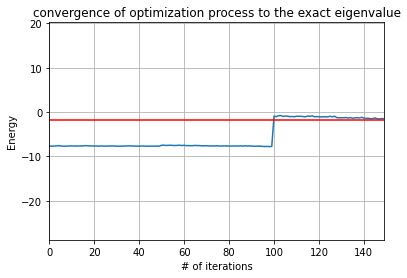

In [127]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [128]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

2it [00:00,  8.37it/s]

{'1111': 184, '1010': 146, '0001': 92, '1110': 68, '0011': 86, '1100': 36, '0010': 28, '0111': 59, '0000': 64, '0101': 62, '0110': 21, '1001': 78, '1101': 42, '1011': 33, '0100': 24, '1000': 1}
1.0
{'0000': 70, '0111': 52, '0001': 90, '1010': 137, '1001': 87, '0110': 20, '1111': 170, '1110': 58, '0101': 89, '0011': 85, '1011': 40, '1100': 53, '1101': 30, '0100': 16, '0010': 25, '1000': 2}
1.0


4it [00:00,  7.21it/s]

{'0001': 108, '1010': 168, '1001': 70, '1110': 69, '0011': 78, '1111': 154, '1011': 37, '0000': 68, '1101': 34, '0101': 85, '0111': 58, '1000': 3, '0100': 14, '1100': 37, '0010': 21, '0110': 20}
1.0
{'1111': 179, '0110': 20, '1110': 69, '0011': 74, '0001': 91, '1010': 147, '1101': 29, '0010': 24, '0100': 18, '1011': 46, '1001': 82, '0000': 81, '0101': 78, '0111': 48, '1100': 36, '1000': 2}
1.0


6it [00:00,  7.73it/s]

{'0001': 113, '1001': 72, '1010': 140, '0101': 66, '1110': 69, '1111': 170, '0110': 21, '0000': 75, '1100': 39, '0011': 84, '0010': 31, '1101': 36, '0111': 68, '0100': 10, '1011': 29, '1000': 1}
1.0
{'1001': 66, '0001': 92, '1010': 151, '1100': 45, '1011': 41, '1111': 183, '0111': 41, '0101': 93, '0010': 30, '1110': 57, '0100': 14, '0000': 78, '1101': 43, '0011': 70, '0110': 19, '1000': 1}
1.0
{'1001': 87, '0001': 94, '0000': 83, '1111': 168, '0101': 57, '0111': 53, '0011': 92, '0100': 19, '1010': 152, '1101': 37, '1100': 38, '1000': 2, '1110': 66, '0010': 24, '0110': 16, '1011': 36}
1.0


9it [00:01,  8.44it/s]

{'1100': 37, '0011': 78, '1110': 74, '0101': 76, '1001': 77, '0001': 92, '1010': 142, '1111': 175, '0000': 67, '1011': 44, '1101': 46, '0010': 30, '0111': 55, '0100': 12, '0110': 18, '1000': 1}
1.0
{'1011': 122, '1100': 114, '0011': 110, '1001': 47, '0001': 151, '1110': 119, '0110': 33, '0000': 33, '1000': 80, '1101': 50, '0100': 69, '0111': 23, '0101': 53, '1111': 17, '0010': 3}
1.0


11it [00:01,  7.18it/s]

{'1111': 138, '0110': 149, '0100': 59, '1011': 137, '1010': 57, '1001': 71, '0001': 77, '0011': 66, '1100': 57, '1101': 80, '0101': 55, '1110': 54, '0111': 8, '1000': 7, '0000': 7, '0010': 2}
1.0
{'0011': 77, '1100': 247, '1101': 73, '0100': 15, '0010': 70, '1001': 216, '0110': 58, '0111': 177, '1000': 31, '1111': 6, '1110': 12, '0000': 2, '0101': 13, '1010': 9, '1011': 16, '0001': 2}
1.0


13it [00:01,  8.16it/s]

{'0000': 82, '1111': 154, '0101': 73, '1100': 31, '0011': 89, '0001': 107, '1001': 90, '0100': 14, '1010': 129, '1011': 54, '1110': 80, '0010': 20, '0111': 49, '1101': 31, '0110': 21}
1.0
{'0001': 106, '1001': 79, '1010': 148, '1110': 64, '0101': 75, '1111': 176, '0011': 95, '0010': 29, '1101': 30, '1011': 36, '0100': 17, '0000': 67, '0110': 19, '0111': 48, '1100': 34, '1000': 1}
1.0


15it [00:02,  7.30it/s]


{'1001': 65, '0001': 106, '1010': 131, '1111': 147, '0000': 92, '0111': 53, '0101': 78, '1110': 81, '0011': 79, '1101': 41, '1011': 36, '1100': 45, '0110': 21, '0010': 23, '0100': 24, '1000': 2}
1.0
{'1111': 159, '0101': 66, '1010': 156, '1001': 81, '0001': 109, '0000': 68, '0111': 46, '1011': 47, '0011': 94, '0100': 11, '1110': 64, '0010': 32, '0110': 12, '1101': 36, '1100': 41, '1000': 2}
1.0


2it [00:00, 11.23it/s]

{'1001': 111, '0000': 161, '1111': 180, '1110': 37, '1011': 104, '0010': 47, '1100': 33, '0011': 31, '1010': 67, '0101': 90, '1101': 19, '0001': 44, '0110': 27, '0100': 36, '1000': 25, '0111': 12}
1.0
{'1111': 175, '0110': 33, '0100': 47, '1101': 16, '0101': 89, '1110': 41, '0001': 50, '1010': 77, '0000': 141, '1011': 83, '1000': 33, '0011': 42, '0010': 49, '1001': 102, '1100': 40, '0111': 6}
1.0


4it [00:00, 10.28it/s]

{'1001': 112, '1111': 167, '0110': 32, '1011': 79, '0010': 49, '0100': 44, '0101': 94, '0111': 14, '0000': 136, '1100': 35, '1101': 20, '1000': 36, '0001': 43, '1010': 78, '0011': 35, '1110': 50}
1.0
{'1111': 174, '1100': 45, '0101': 98, '0001': 37, '1001': 118, '1011': 74, '0000': 134, '0100': 45, '0010': 63, '1000': 25, '0011': 35, '1010': 75, '1110': 51, '0111': 17, '0110': 27, '1101': 6}
1.0


6it [00:00,  8.00it/s]

{'0110': 32, '1111': 172, '0001': 62, '1001': 110, '0100': 46, '1110': 37, '1100': 36, '1011': 89, '0010': 63, '1101': 10, '0101': 94, '0011': 37, '1010': 69, '0000': 124, '1000': 36, '0111': 7}
1.0
{'1011': 70, '1010': 80, '1001': 121, '1111': 165, '0011': 39, '1100': 43, '1000': 33, '0100': 34, '0110': 25, '0000': 144, '0001': 49, '0111': 14, '0101': 93, '0010': 46, '1110': 54, '1101': 14}
1.0


8it [00:00,  8.17it/s]

{'1010': 66, '1001': 101, '1111': 177, '0000': 137, '1000': 36, '1011': 105, '0010': 49, '0101': 98, '0100': 40, '0001': 32, '0110': 35, '1100': 39, '0011': 35, '0111': 12, '1110': 47, '1101': 15}
1.0
{'1100': 38, '0010': 74, '0001': 50, '0110': 34, '1101': 16, '0100': 51, '0101': 85, '1000': 40, '1110': 45, '1010': 73, '1111': 153, '1011': 82, '1001': 99, '0111': 9, '0011': 49, '0000': 126}
1.0


9it [00:01,  8.37it/s]

{'1100': 61, '0010': 9, '0001': 134, '1111': 58, '0110': 38, '0101': 84, '1110': 99, '1000': 73, '0011': 77, '1001': 70, '1101': 65, '0000': 58, '1011': 94, '0100': 30, '1010': 66, '0111': 8}
1.0


11it [00:01,  6.67it/s]

{'0011': 151, '1100': 146, '1000': 69, '1010': 93, '0001': 122, '0110': 74, '1111': 51, '1101': 77, '1011': 110, '0100': 38, '0000': 1, '0101': 32, '1110': 31, '0010': 7, '1001': 21, '0111': 1}
1.0
{'1001': 189, '0010': 144, '0110': 46, '1101': 91, '0000': 7, '0011': 117, '1100': 212, '0101': 49, '1010': 25, '1011': 34, '0111': 51, '1111': 27, '1110': 12, '1000': 10, '0001': 7, '0100': 3}
1.0


12it [00:01,  7.38it/s]

{'0010': 64, '1001': 100, '0001': 50, '1010': 65, '0011': 26, '1111': 173, '0101': 90, '0000': 152, '1011': 98, '0110': 31, '1100': 37, '1101': 15, '1000': 26, '1110': 46, '0111': 11, '0100': 40}
1.0
{'0010': 64, '1011': 87, '0111': 10, '1111': 172, '1110': 47, '0011': 37, '1010': 74, '0100': 36, '1001': 100, '0101': 98, '0001': 49, '0000': 135, '1000': 32, '1101': 13, '0110': 38, '1100': 32}
1.0


15it [00:01,  7.92it/s]


{'1111': 162, '0110': 35, '0000': 140, '1110': 45, '0101': 91, '0100': 42, '0011': 49, '0010': 44, '1100': 42, '1001': 109, '0111': 13, '1000': 32, '0001': 39, '1011': 97, '1101': 7, '1010': 77}
1.0
{'0010': 61, '1011': 98, '0100': 31, '1110': 41, '0101': 83, '1111': 176, '1010': 55, '0000': 139, '1000': 44, '1001': 101, '0111': 14, '0011': 33, '1101': 16, '0110': 26, '0001': 57, '1100': 49}
1.0


2it [00:00,  7.55it/s]

{'1111': 167, '0000': 111, '0111': 36, '1110': 49, '0101': 192, '1010': 189, '1101': 28, '0011': 49, '1001': 46, '1000': 19, '0001': 72, '0110': 7, '0010': 49, '1011': 6, '0100': 3, '1100': 1}
1.0
{'0111': 55, '1111': 178, '1001': 42, '0000': 124, '1000': 13, '1101': 33, '0101': 141, '0011': 45, '1010': 189, '0001': 82, '1110': 47, '1011': 2, '0010': 56, '0100': 6, '0110': 11}
1.0


4it [00:00,  8.21it/s]

{'0101': 145, '1110': 62, '0010': 49, '0001': 69, '0111': 54, '0110': 10, '1111': 161, '0000': 121, '1010': 217, '1000': 13, '1101': 31, '0011': 39, '1001': 48, '1011': 2, '0100': 3}
1.0
{'0011': 52, '0001': 75, '1010': 193, '0110': 9, '1111': 173, '0111': 47, '0010': 60, '0000': 118, '0101': 155, '1100': 2, '1110': 40, '1101': 37, '1001': 46, '1011': 4, '1000': 11, '0100': 2}
1.0


6it [00:00,  7.57it/s]

{'0011': 58, '1110': 56, '0101': 179, '1010': 189, '1111': 156, '0000': 90, '0111': 53, '1101': 41, '0010': 46, '1001': 54, '0001': 73, '1000': 9, '0110': 10, '1011': 5, '0100': 4, '1100': 1}
1.0
{'0101': 136, '1110': 59, '0011': 60, '1010': 189, '0000': 96, '0010': 53, '1101': 43, '1111': 180, '0111': 57, '0001': 81, '1000': 11, '0110': 8, '1001': 46, '0100': 3, '1011': 2}
1.0


8it [00:01,  8.43it/s]

{'1001': 39, '1010': 172, '1111': 176, '0000': 135, '0111': 51, '0101': 170, '1110': 64, '0010': 45, '0001': 77, '1011': 8, '1101': 29, '0011': 40, '1000': 7, '0110': 7, '0100': 4}
1.0
{'1001': 51, '1010': 202, '0001': 71, '0101': 151, '1011': 3, '0010': 54, '0000': 123, '1111': 172, '0011': 47, '1101': 28, '1110': 49, '0111': 47, '0110': 9, '0100': 4, '1000': 10, '1100': 3}
1.0


10it [00:01,  7.40it/s]

{'1101': 77, '0011': 134, '1100': 138, '1000': 102, '0101': 92, '0001': 115, '1001': 27, '1010': 22, '0100': 46, '1011': 90, '1110': 44, '0110': 34, '0111': 33, '0010': 29, '0000': 38, '1111': 3}
1.0
{'0110': 135, '1111': 139, '1001': 51, '1000': 52, '1110': 38, '1100': 39, '0111': 5, '1101': 83, '1010': 100, '0000': 40, '0101': 88, '0100': 14, '0011': 81, '0010': 25, '0001': 74, '1011': 60}
1.0


13it [00:01,  7.97it/s]

{'1100': 278, '0011': 186, '0001': 10, '1001': 235, '0100': 32, '1101': 27, '0101': 23, '0111': 55, '0000': 11, '0110': 119, '1011': 22, '1111': 3, '0010': 6, '1000': 8, '1110': 7, '1010': 2}
1.0
{'1111': 182, '0000': 121, '0010': 54, '1110': 58, '0101': 131, '1010': 186, '0111': 53, '0100': 2, '0001': 72, '1001': 50, '0011': 53, '1000': 17, '0110': 6, '1011': 8, '1100': 1, '1101': 30}
1.0
{'0000': 109, '1111': 189, '1110': 50, '0101': 132, '0001': 83, '1010': 208, '1101': 37, '0011': 53, '1001': 46, '0111': 38, '0010': 48, '1000': 15, '1011': 4, '0110': 9, '0100': 2, '1100': 1}
1.0


15it [00:01,  7.79it/s]


{'1001': 48, '0001': 83, '1010': 204, '0101': 131, '1110': 48, '1111': 174, '0010': 67, '0000': 118, '1101': 29, '0011': 56, '1011': 5, '0100': 4, '0111': 42, '0110': 7, '1000': 8}
1.0
{'0001': 71, '1001': 53, '1010': 221, '0000': 116, '0101': 132, '1110': 55, '1111': 171, '0011': 52, '1101': 37, '0111': 48, '0110': 9, '0010': 38, '1000': 16, '1011': 2, '0100': 2, '1100': 1}
1.0


2it [00:00,  6.15it/s]

{'1101': 87, '0100': 41, '1010': 73, '1001': 149, '0000': 41, '1111': 123, '0011': 101, '0111': 45, '1100': 60, '1110': 105, '0001': 51, '0010': 67, '0101': 38, '0110': 24, '1011': 10, '1000': 9}
1.0
{'0011': 83, '1101': 88, '1001': 181, '1010': 90, '0000': 63, '1111': 116, '0010': 68, '1110': 97, '0001': 50, '0111': 43, '0101': 36, '0110': 15, '1100': 45, '0100': 30, '1011': 5, '1000': 14}
1.0


4it [00:00,  8.68it/s]

{'1101': 105, '0110': 19, '1111': 133, '1110': 88, '1010': 70, '1001': 159, '0011': 76, '0111': 43, '0000': 61, '0001': 69, '0010': 68, '1100': 48, '0101': 39, '1011': 9, '0100': 28, '1000': 9}
1.0
{'1001': 177, '1010': 84, '0100': 33, '1101': 98, '1110': 84, '1111': 117, '0011': 76, '0000': 50, '0010': 77, '1100': 54, '0111': 51, '0101': 35, '0001': 52, '1011': 4, '1000': 13, '0110': 19}
1.0


6it [00:00,  8.16it/s]

{'0000': 56, '0011': 86, '0001': 48, '1010': 79, '1001': 155, '1111': 136, '1101': 97, '0010': 62, '1110': 86, '0110': 22, '0100': 33, '1100': 53, '0111': 56, '1011': 8, '1000': 11, '0101': 36}
1.0
{'1001': 159, '0001': 42, '0000': 48, '1111': 118, '1100': 44, '0010': 88, '1011': 7, '0111': 48, '1101': 106, '0100': 25, '0101': 42, '1110': 109, '1000': 16, '1010': 64, '0011': 88, '0110': 20}
1.0


8it [00:01,  7.41it/s]

{'0111': 53, '1110': 112, '0101': 39, '1101': 94, '0100': 35, '0001': 44, '1001': 155, '0000': 71, '1111': 115, '1000': 6, '0010': 57, '0110': 21, '0011': 76, '1011': 6, '1100': 61, '1010': 79}
1.0
{'1001': 138, '1010': 87, '0001': 53, '1100': 53, '0111': 54, '1111': 126, '1110': 81, '1101': 104, '0011': 83, '0010': 83, '0101': 36, '1000': 13, '0000': 59, '0110': 17, '1011': 7, '0100': 30}
1.0


10it [00:01,  7.13it/s]

{'1110': 59, '0101': 39, '1101': 104, '0010': 18, '1001': 73, '1100': 102, '0011': 158, '1111': 76, '0110': 54, '0001': 84, '1010': 15, '1000': 110, '1011': 61, '0000': 21, '0100': 23, '0111': 27}
1.0
{'0110': 139, '1111': 124, '0001': 69, '1010': 102, '0101': 116, '0011': 61, '0100': 73, '1101': 106, '1000': 27, '1011': 66, '0000': 23, '1001': 77, '1100': 30, '0111': 1, '1110': 9, '0010': 1}
1.0


12it [00:01,  6.80it/s]

{'0010': 98, '1011': 40, '1001': 207, '0111': 215, '1100': 220, '1111': 35, '0110': 35, '0100': 44, '0000': 15, '0101': 19, '1101': 59, '0011': 27, '1110': 4, '1010': 3, '0001': 2, '1000': 1}
1.0
{'1101': 95, '0011': 91, '1100': 50, '1111': 124, '0000': 59, '0010': 80, '1110': 91, '1001': 149, '0101': 40, '0111': 50, '0001': 56, '0100': 24, '1010': 74, '1000': 13, '0110': 22, '1011': 6}
1.0


15it [00:01,  8.17it/s]

{'1000': 9, '0000': 61, '1111': 120, '0100': 27, '1101': 111, '0010': 67, '1100': 57, '1001': 166, '0001': 47, '0111': 46, '1110': 103, '0011': 91, '1010': 59, '0101': 35, '1011': 8, '0110': 17}
1.0
{'0010': 83, '1110': 96, '0001': 44, '1001': 151, '1010': 77, '0000': 55, '0111': 49, '0011': 85, '0110': 23, '1101': 96, '1111': 120, '1100': 51, '1000': 11, '0101': 48, '0100': 30, '1011': 5}
1.0
{'1001': 143, '1100': 47, '1101': 108, '1111': 129, '0110': 24, '0010': 51, '0101': 40, '0000': 61, '0111': 45, '1010': 70, '0011': 97, '1110': 103, '0100': 26, '0001': 62, '1011': 7, '1000': 11}
1.0


15it [00:02,  7.47it/s]
1it [00:00,  7.70it/s]

{'1010': 66, '1001': 223, '0000': 45, '1111': 121, '0011': 93, '1100': 35, '1110': 136, '1101': 159, '1000': 32, '0111': 32, '0010': 24, '0100': 25, '0110': 18, '0101': 9, '0001': 2, '1011': 4}
1.0
{'1000': 34, '0100': 19, '1101': 156, '1001': 233, '0011': 82, '1110': 136, '0101': 12, '1111': 113, '1100': 45, '0000': 37, '1010': 63, '0010': 35, '0111': 43, '0110': 9, '1011': 4, '0001': 3}
1.0


3it [00:00,  6.86it/s]

{'1100': 42, '0011': 97, '1111': 122, '0101': 17, '1110': 145, '1001': 219, '1010': 73, '1101': 137, '0010': 37, '0111': 31, '0000': 34, '1000': 37, '0100': 19, '0110': 12, '1011': 2}
1.0


5it [00:00,  6.59it/s]

{'1001': 209, '1010': 71, '0000': 45, '1101': 190, '1111': 120, '0011': 73, '0101': 10, '0111': 35, '1110': 135, '1100': 36, '0100': 18, '0110': 16, '1000': 29, '0010': 28, '0001': 3, '1011': 6}
1.0
{'1001': 208, '1100': 34, '0011': 98, '1110': 158, '0000': 34, '1111': 122, '0010': 38, '1101': 145, '1010': 73, '0101': 12, '1000': 32, '0100': 21, '0111': 28, '0110': 13, '1011': 7, '0001': 1}
1.0


7it [00:01,  6.32it/s]

{'0111': 41, '0110': 11, '1111': 133, '0011': 94, '1100': 48, '1010': 63, '1001': 181, '0000': 52, '1110': 141, '0001': 5, '0010': 39, '1101': 154, '1000': 30, '0100': 17, '0101': 12, '1011': 3}
1.0
{'1110': 136, '1111': 118, '1001': 219, '1010': 69, '0010': 30, '0100': 22, '1101': 157, '0000': 42, '1100': 48, '1000': 29, '0111': 33, '0101': 15, '0011': 80, '1011': 5, '0110': 19, '0001': 2}
1.0


9it [00:01,  7.83it/s]

{'1010': 62, '1001': 214, '1110': 147, '1111': 119, '0100': 22, '1101': 160, '0111': 29, '0000': 50, '1100': 38, '0011': 83, '0101': 19, '1000': 35, '0110': 11, '0010': 30, '1011': 3, '0001': 2}
1.0
{'1001': 67, '0001': 64, '1110': 84, '0110': 40, '1111': 77, '1000': 138, '0011': 58, '0100': 14, '1101': 154, '1011': 109, '1100': 125, '0101': 23, '0000': 37, '0111': 11, '0010': 6, '1010': 17}
1.0


10it [00:01,  8.09it/s]

{'1111': 101, '0110': 114, '1101': 160, '1011': 90, '1010': 56, '0001': 51, '0111': 45, '1100': 12, '1001': 33, '1110': 65, '1000': 63, '0100': 72, '0101': 114, '0010': 30, '0011': 14, '0000': 4}
1.0
{'1100': 252, '1010': 18, '1001': 210, '0001': 27, '0100': 44, '0010': 86, '0111': 233, '1111': 27, '0110': 14, '1101': 45, '0101': 46, '0011': 4, '1110': 5, '1011': 8, '1000': 5}
1.0


13it [00:01,  6.96it/s]

{'0011': 85, '1110': 125, '1010': 61, '1001': 207, '1111': 140, '0110': 15, '1101': 171, '0010': 37, '0111': 25, '0001': 7, '1100': 45, '1000': 32, '0000': 43, '0101': 9, '0100': 18, '1011': 4}
1.0
{'1101': 140, '0000': 49, '1000': 35, '1001': 224, '1110': 130, '0010': 27, '0110': 16, '1111': 113, '0011': 89, '0111': 41, '1010': 82, '1011': 4, '0100': 27, '1100': 36, '0101': 9, '0001': 2}
1.0


15it [00:02,  6.66it/s]

{'1100': 48, '0011': 100, '1010': 67, '1001': 199, '1110': 161, '0101': 13, '0100': 23, '1101': 127, '1111': 114, '1000': 37, '0111': 42, '0010': 36, '0000': 36, '0110': 14, '1011': 4, '0001': 3}
1.0
{'1000': 38, '0000': 41, '1010': 77, '1001': 222, '1100': 30, '0011': 99, '1110': 136, '0111': 34, '1111': 105, '0010': 26, '1011': 6, '1101': 159, '0100': 20, '0110': 20, '0101': 9, '0001': 2}
1.0



2it [00:00,  5.60it/s]

{'1110': 93, '1111': 106, '0110': 33, '0000': 51, '0011': 78, '1001': 163, '0001': 55, '0111': 46, '1101': 92, '1100': 59, '0101': 53, '0010': 98, '1010': 50, '0100': 17, '1000': 18, '1011': 12}
1.0
{'1110': 93, '1101': 82, '1010': 63, '0001': 53, '0110': 26, '1111': 110, '0011': 106, '0010': 84, '1001': 167, '0101': 47, '1100': 48, '1011': 7, '0000': 56, '0111': 48, '1000': 18, '0100': 16}
1.0


4it [00:00,  5.37it/s]

{'0001': 61, '1001': 142, '0011': 90, '0101': 44, '1000': 20, '0000': 56, '1111': 131, '0010': 92, '1101': 89, '1110': 111, '1010': 45, '1100': 47, '0110': 25, '0111': 40, '0100': 23, '1011': 8}
1.0
{'1110': 121, '1111': 135, '1001': 147, '1010': 71, '0111': 38, '0000': 54, '0010': 82, '1101': 89, '1100': 59, '0011': 89, '0001': 42, '0101': 37, '0110': 20, '1011': 13, '0100': 14, '1000': 13}
1.0


5it [00:00,  4.96it/s]

{'1010': 61, '1001': 128, '0001': 49, '0010': 67, '0101': 41, '1110': 117, '1100': 58, '1101': 84, '1111': 149, '0011': 76, '0110': 29, '0000': 57, '0100': 15, '0111': 56, '1000': 21, '1011': 16}
1.0


7it [00:01,  5.00it/s]

{'0011': 69, '1010': 58, '1001': 163, '0010': 83, '0000': 56, '1101': 91, '0110': 35, '1111': 131, '1110': 90, '1100': 58, '1000': 15, '0001': 64, '0111': 39, '0101': 38, '1011': 13, '0100': 21}
1.0
{'0010': 71, '0101': 37, '0011': 85, '0001': 63, '1010': 53, '1001': 146, '1111': 127, '0111': 40, '0100': 23, '1110': 94, '1101': 93, '0000': 57, '0110': 28, '1011': 11, '1000': 26, '1100': 70}
1.0


9it [00:01,  5.43it/s]

{'1111': 115, '0001': 63, '1001': 145, '1010': 57, '1000': 18, '0000': 63, '0010': 81, '1101': 90, '0111': 52, '1110': 105, '0011': 71, '1011': 8, '0101': 50, '0100': 20, '0110': 27, '1100': 59}
1.0
{'0110': 61, '1100': 92, '0011': 148, '0000': 27, '1000': 103, '1001': 84, '0001': 84, '1110': 61, '1011': 48, '0111': 17, '1101': 123, '0100': 22, '1111': 81, '0101': 43, '0010': 23, '1010': 7}
1.0


11it [00:02,  5.94it/s]

{'1111': 128, '0110': 141, '1010': 102, '1001': 70, '1011': 75, '1101': 96, '0011': 55, '0101': 108, '1000': 39, '0001': 84, '0000': 24, '1100': 28, '0100': 58, '1110': 10, '0111': 3, '0010': 3}
1.0
{'0100': 35, '1101': 81, '1011': 34, '0010': 103, '0111': 197, '0011': 28, '1100': 202, '1001': 235, '0000': 19, '1110': 5, '1111': 25, '0110': 40, '0101': 18, '1000': 2}
1.0


13it [00:02,  5.33it/s]

{'1110': 92, '1001': 149, '1111': 152, '0100': 18, '1101': 81, '0011': 92, '1100': 62, '0010': 78, '0110': 21, '0001': 53, '0000': 56, '0101': 47, '1010': 63, '0111': 35, '1011': 10, '1000': 15}
1.0
{'1010': 60, '0001': 62, '0000': 51, '1000': 15, '1101': 78, '0110': 26, '1111': 118, '1110': 118, '1011': 17, '1001': 178, '0010': 70, '1100': 43, '0011': 77, '0101': 43, '0111': 46, '0100': 22}
1.0


15it [00:02,  5.32it/s]


{'1010': 68, '1001': 139, '0011': 82, '1110': 100, '0100': 30, '1101': 94, '0000': 51, '1111': 133, '1100': 61, '0001': 53, '1000': 13, '0111': 44, '0110': 16, '0010': 84, '0101': 42, '1011': 14}
1.0
{'0000': 37, '0110': 26, '1111': 133, '0001': 66, '1001': 159, '1100': 61, '1101': 93, '1110': 110, '1010': 55, '0101': 52, '0010': 74, '0100': 19, '0111': 37, '0011': 80, '1000': 15, '1011': 7}
1.0


1it [00:00,  3.78it/s]

{'1110': 189, '0101': 55, '0100': 86, '1101': 72, '0000': 97, '0010': 48, '1111': 132, '1100': 59, '0001': 28, '0011': 39, '1001': 64, '1000': 7, '0110': 5, '0111': 40, '1010': 93, '1011': 10}
1.0
{'1101': 70, '1111': 157, '1110': 169, '0101': 54, '0000': 100, '0001': 38, '0010': 46, '0011': 43, '1010': 77, '1001': 52, '0100': 80, '1011': 12, '0111': 28, '1100': 76, '1000': 14, '0110': 8}
1.0


3it [00:00,  4.42it/s]

{'1111': 161, '0010': 51, '1010': 91, '0001': 33, '1101': 72, '0100': 81, '1100': 52, '1110': 197, '0000': 84, '0111': 38, '1000': 18, '0101': 43, '0011': 43, '1001': 52, '1011': 5, '0110': 3}
1.0
{'0000': 87, '0101': 43, '1110': 183, '0010': 60, '0001': 37, '1010': 99, '0011': 46, '1111': 149, '0100': 68, '1101': 85, '1100': 64, '1000': 13, '1001': 52, '0111': 27, '1011': 8, '0110': 3}
1.0


6it [00:01,  5.08it/s]

{'0011': 29, '1111': 148, '0101': 59, '0010': 56, '1010': 91, '0001': 35, '0100': 85, '1101': 70, '0000': 98, '1100': 60, '1110': 159, '0111': 47, '1001': 51, '1011': 7, '1000': 19, '0110': 10}
1.0
{'1100': 60, '0011': 42, '1110': 193, '0000': 95, '1001': 46, '0001': 31, '1101': 70, '0100': 84, '1111': 140, '0111': 36, '0101': 51, '0010': 56, '1000': 11, '1010': 93, '0110': 6, '1011': 10}
1.0


7it [00:01,  5.14it/s]

{'0010': 66, '1100': 78, '0000': 106, '0100': 96, '1101': 78, '1110': 165, '1010': 92, '1111': 137, '1000': 17, '0111': 30, '0001': 30, '1001': 49, '0011': 33, '1011': 10, '0101': 33, '0110': 4}
1.0


9it [00:01,  5.15it/s]

{'0000': 125, '1000': 12, '0010': 63, '1011': 8, '1110': 185, '1111': 139, '1101': 83, '0001': 30, '0100': 75, '1100': 46, '1010': 91, '0011': 37, '0111': 36, '1001': 59, '0101': 33, '0110': 2}
1.0
{'0100': 74, '1110': 95, '1000': 23, '1111': 131, '0011': 117, '1100': 175, '1010': 33, '0001': 81, '1101': 73, '1011': 55, '0110': 68, '1001': 36, '0111': 7, '0000': 24, '0101': 30, '0010': 2}
1.0


11it [00:02,  5.48it/s]

{'0010': 32, '1011': 43, '1001': 109, '1010': 137, '1101': 41, '0100': 68, '1111': 126, '0011': 71, '0000': 69, '0110': 142, '1100': 88, '0001': 15, '1000': 17, '0101': 46, '1110': 14, '0111': 6}
1.0
{'1000': 57, '0111': 180, '1100': 216, '0100': 13, '0110': 47, '1001': 212, '0101': 9, '0010': 103, '0011': 76, '1111': 52, '1010': 36, '1101': 9, '0001': 3, '1011': 11}
1.0


13it [00:02,  5.67it/s]

{'1111': 122, '0011': 52, '0000': 90, '0100': 102, '0111': 38, '1001': 31, '0101': 55, '0010': 64, '1110': 184, '1100': 54, '0001': 43, '1010': 79, '0110': 9, '1101': 81, '1000': 10, '1011': 10}
1.0
{'0101': 55, '1110': 174, '0100': 92, '1101': 61, '1010': 94, '1001': 48, '0000': 89, '0010': 60, '1111': 151, '1100': 60, '0001': 34, '1000': 12, '0111': 28, '0011': 48, '1011': 15, '0110': 3}
1.0


15it [00:02,  5.19it/s]


{'0000': 81, '1111': 153, '1010': 97, '1110': 178, '0111': 28, '1101': 93, '0011': 42, '1100': 63, '0100': 77, '0001': 30, '1001': 64, '0101': 52, '0010': 53, '1000': 6, '1011': 2, '0110': 5}
1.0
{'1001': 46, '0001': 34, '0010': 68, '1110': 186, '1000': 16, '0000': 80, '1101': 82, '1100': 61, '0111': 44, '1010': 88, '0101': 45, '1111': 133, '0100': 78, '0011': 47, '0110': 8, '1011': 8}
1.0


2it [00:00,  5.64it/s]

{'0011': 71, '1010': 78, '1001': 170, '0001': 89, '1111': 102, '1110': 101, '1101': 109, '0010': 55, '0111': 35, '0000': 60, '1100': 41, '1000': 14, '0101': 46, '0110': 15, '0100': 33, '1011': 5}
1.0
{'0110': 24, '1111': 105, '1001': 184, '0001': 70, '0000': 42, '1110': 109, '0101': 47, '1101': 93, '1100': 47, '0011': 67, '1010': 85, '0111': 42, '1011': 5, '0100': 33, '0010': 62, '1000': 9}
1.0


4it [00:00,  7.13it/s]

{'1100': 52, '0011': 82, '1001': 168, '1010': 57, '0001': 78, '1101': 103, '1110': 106, '0101': 54, '0110': 26, '0111': 33, '1111': 99, '0100': 45, '0010': 55, '0000': 54, '1000': 9, '1011': 3}
1.0
{'1110': 110, '0101': 57, '1001': 163, '0001': 76, '1010': 88, '0010': 55, '0011': 76, '1111': 99, '1101': 92, '1100': 53, '0111': 34, '0100': 25, '0000': 58, '1011': 3, '0110': 21, '1000': 14}
1.0


5it [00:00,  5.73it/s]

{'0111': 42, '0101': 62, '1110': 89, '1111': 105, '1001': 156, '1010': 77, '0001': 73, '0010': 46, '0000': 61, '0110': 24, '0011': 65, '1101': 110, '0100': 36, '1000': 18, '1100': 60}
1.0


7it [00:01,  5.80it/s]

{'0001': 77, '1001': 153, '1010': 73, '1111': 93, '0110': 21, '1000': 12, '0011': 68, '0100': 42, '0000': 54, '1110': 118, '0101': 53, '0010': 67, '0111': 42, '1101': 108, '1100': 41, '1011': 2}
1.0
{'0001': 87, '1010': 66, '1001': 169, '0010': 61, '0101': 57, '0011': 56, '0000': 57, '0100': 41, '0110': 18, '1100': 42, '0111': 48, '1101': 92, '1110': 117, '1111': 102, '1000': 10, '1011': 1}
1.0


8it [00:01,  6.64it/s]

{'1101': 88, '0100': 39, '0110': 22, '0000': 63, '0010': 65, '1110': 99, '0111': 34, '1010': 69, '1111': 105, '1000': 7, '0001': 87, '0101': 50, '1100': 51, '0011': 68, '1001': 174, '1011': 3}
1.0
{'1100': 119, '1101': 131, '1111': 56, '1110': 89, '0000': 5, '0001': 75, '1001': 54, '0111': 23, '0011': 187, '1011': 80, '0110': 58, '1000': 76, '0101': 26, '0010': 10, '0100': 27, '1010': 8}
1.0


11it [00:01,  6.91it/s]

{'1001': 79, '0001': 104, '0011': 67, '1100': 39, '0110': 164, '1110': 18, '0101': 106, '1101': 88, '1111': 121, '0100': 72, '1010': 81, '0000': 18, '1011': 51, '1000': 15, '0111': 1}
1.0
{'0110': 56, '0100': 36, '1101': 39, '0010': 137, '0111': 254, '1100': 195, '0011': 34, '1001': 192, '0000': 12, '0101': 9, '1011': 26, '1111': 20, '1010': 10, '1000': 3, '1110': 1}
1.0


13it [00:02,  6.89it/s]

{'1110': 121, '1010': 64, '0001': 70, '1001': 153, '0011': 72, '1100': 48, '0100': 25, '0000': 59, '1101': 106, '0110': 25, '0111': 34, '0101': 70, '0010': 67, '1111': 101, '1011': 1, '1000': 8}
1.0
{'0001': 89, '1010': 65, '1001': 180, '0011': 59, '0111': 31, '1111': 107, '0100': 41, '0000': 56, '0010': 64, '1110': 93, '0110': 25, '1100': 49, '1101': 92, '0101': 58, '1000': 12, '1011': 3}
1.0


15it [00:02,  6.39it/s]


{'0011': 68, '0101': 54, '1110': 105, '1001': 168, '1111': 120, '0000': 65, '0010': 51, '0111': 37, '1000': 7, '0001': 87, '1101': 83, '1010': 81, '0100': 28, '0110': 27, '1100': 38, '1011': 5}
1.0
{'1101': 99, '0100': 39, '0011': 76, '1100': 57, '0001': 99, '1010': 88, '0111': 30, '1111': 93, '0010': 63, '1110': 90, '1001': 148, '0000': 61, '0101': 52, '1000': 4, '1011': 5, '0110': 20}
1.0


2it [00:00,  9.71it/s]

{'0001': 67, '1001': 238, '0010': 20, '1011': 5, '1101': 129, '1110': 154, '1111': 142, '1100': 45, '1000': 22, '1010': 73, '0100': 18, '0000': 29, '0101': 38, '0011': 26, '0110': 6, '0111': 12}
1.0
{'0001': 53, '1010': 90, '0000': 43, '1110': 126, '1101': 144, '1111': 146, '0010': 25, '0011': 21, '0101': 47, '1001': 234, '1100': 47, '0111': 11, '1000': 17, '0100': 15, '0110': 5}
1.0


4it [00:00,  6.91it/s]

{'1001': 203, '1010': 80, '0001': 59, '1000': 14, '1110': 139, '1100': 69, '1101': 156, '1111': 134, '0010': 27, '0011': 18, '0101': 43, '0111': 19, '1011': 4, '0100': 26, '0000': 29, '0110': 4}
1.0
{'1110': 126, '0101': 37, '1111': 134, '1001': 245, '0100': 22, '1101': 152, '0011': 23, '0000': 34, '0001': 43, '0010': 19, '1010': 91, '1100': 56, '1000': 19, '0111': 12, '1011': 5, '0110': 6}
1.0


6it [00:00,  7.07it/s]

{'1100': 58, '0011': 18, '1101': 136, '0000': 43, '1111': 118, '0001': 59, '1001': 238, '0101': 43, '1010': 78, '1110': 144, '0010': 29, '0100': 17, '1000': 26, '0111': 11, '1011': 2, '0110': 4}
1.0
{'0000': 46, '1001': 225, '1010': 85, '0001': 67, '1110': 128, '0101': 54, '1111': 135, '0011': 20, '1100': 50, '1101': 124, '1000': 19, '0010': 24, '0100': 23, '0111': 15, '0110': 8, '1011': 1}
1.0


8it [00:01,  6.63it/s]

{'0000': 42, '1000': 22, '1111': 140, '0001': 60, '1001': 220, '1010': 86, '1101': 147, '1110': 132, '1100': 54, '0101': 39, '0100': 14, '0011': 17, '0110': 6, '0111': 16, '1011': 2, '0010': 27}
1.0
{'0110': 8, '1111': 112, '1001': 237, '1010': 88, '0001': 71, '1110': 123, '0010': 22, '0011': 30, '1000': 21, '1101': 130, '0111': 13, '1100': 58, '0101': 38, '0000': 41, '0100': 28, '1011': 4}
1.0


10it [00:01,  6.44it/s]

{'1011': 93, '1001': 71, '0011': 61, '1100': 136, '1101': 173, '1000': 175, '1110': 83, '1111': 89, '0001': 64, '0110': 33, '1010': 9, '0101': 9, '0100': 23, '0010': 2, '0000': 1, '0111': 2}
1.0
{'1101': 148, '1010': 82, '1001': 70, '1110': 43, '0101': 134, '0111': 10, '0011': 35, '0110': 136, '1100': 38, '1111': 90, '0100': 54, '0001': 78, '0010': 11, '1011': 43, '0000': 19, '1000': 33}
1.0


12it [00:01,  6.97it/s]

{'1100': 222, '0101': 44, '0100': 76, '1101': 59, '0001': 9, '1001': 200, '0010': 87, '0111': 184, '1010': 22, '1111': 49, '1000': 5, '0000': 11, '0011': 20, '0110': 27, '1011': 9}
1.0
{'0001': 66, '1010': 88, '1001': 234, '1110': 131, '0010': 31, '1100': 52, '0100': 23, '0000': 37, '1111': 125, '1101': 134, '0101': 44, '1000': 25, '0111': 8, '1011': 4, '0011': 15, '0110': 7}
1.0


13it [00:01,  6.95it/s]

{'1101': 151, '1001': 210, '1010': 94, '0001': 48, '1011': 2, '0010': 27, '1110': 109, '0000': 46, '1111': 143, '0100': 26, '0101': 47, '1100': 67, '0011': 19, '1000': 17, '0110': 7, '0111': 11}
1.0
{'0100': 14, '1101': 146, '1010': 81, '1110': 123, '0101': 50, '0000': 42, '1111': 126, '0010': 28, '1100': 58, '1001': 228, '0001': 61, '0111': 18, '1000': 20, '0011': 22, '0110': 4, '1011': 3}


15it [00:02,  6.90it/s]


1.0
{'1110': 90, '1101': 149, '1111': 131, '1010': 92, '1001': 224, '0001': 77, '0000': 48, '1011': 4, '0100': 18, '0010': 26, '1000': 26, '0011': 22, '1100': 67, '0101': 36, '0111': 9, '0110': 5}
1.0


2it [00:00,  7.79it/s]

{'1010': 84, '1001': 86, '0010': 78, '1110': 142, '0000': 152, '1000': 67, '0100': 31, '0111': 29, '1100': 112, '0101': 16, '0001': 56, '1011': 11, '0011': 38, '0110': 32, '1111': 34, '1101': 56}
1.0
{'0010': 85, '1001': 72, '0001': 52, '0000': 139, '1111': 41, '1101': 70, '0100': 41, '1110': 144, '1011': 18, '0011': 36, '0101': 11, '1000': 67, '1010': 94, '1100': 110, '0110': 19, '0111': 25}
1.0


4it [00:00,  7.54it/s]

{'1001': 73, '0001': 62, '1010': 76, '1011': 12, '0010': 82, '1000': 76, '1101': 63, '1110': 142, '0000': 146, '1100': 114, '0111': 17, '1111': 33, '0100': 52, '0110': 33, '0011': 28, '0101': 15}
1.0
{'1110': 156, '0000': 148, '0010': 76, '0001': 57, '1001': 71, '0100': 44, '1111': 40, '1100': 131, '1010': 70, '1101': 62, '0110': 31, '0011': 36, '1000': 57, '0111': 21, '1011': 17, '0101': 7}
1.0


6it [00:00,  6.99it/s]

{'1010': 79, '0011': 39, '0010': 82, '1011': 15, '0000': 148, '1111': 33, '1110': 159, '0100': 45, '1000': 72, '1101': 56, '1001': 68, '0101': 10, '1100': 121, '0001': 50, '0110': 25, '0111': 22}
1.0
{'0001': 57, '1010': 63, '1001': 73, '0000': 156, '1000': 61, '0011': 26, '1100': 131, '0100': 47, '1110': 140, '0111': 27, '0010': 80, '1101': 72, '0110': 20, '1111': 40, '0101': 12, '1011': 19}
1.0


8it [00:01,  7.36it/s]

{'1100': 119, '1111': 51, '1010': 89, '0100': 40, '1110': 155, '0000': 128, '1000': 88, '0010': 89, '1001': 62, '1101': 66, '1011': 15, '0001': 43, '0111': 21, '0110': 18, '0011': 34, '0101': 6}
1.0
{'0110': 26, '1001': 73, '0001': 35, '1010': 68, '0000': 150, '1100': 115, '0010': 88, '1110': 150, '1000': 82, '1101': 73, '0111': 25, '0100': 34, '0011': 41, '1111': 42, '0101': 10, '1011': 12}
1.0


10it [00:01,  6.28it/s]

{'0011': 142, '0010': 29, '1011': 69, '1000': 87, '1111': 110, '0110': 56, '0001': 105, '1001': 76, '1100': 68, '1110': 148, '0000': 54, '0111': 35, '1101': 31, '0100': 8, '1010': 4, '0101': 2}
1.0
{'1111': 93, '0110': 205, '0100': 202, '0011': 19, '1010': 51, '1001': 40, '1000': 65, '1110': 68, '0101': 81, '1101': 51, '1100': 100, '0111': 17, '0001': 15, '0010': 10, '0000': 4, '1011': 3}
1.0


12it [00:01,  6.77it/s]

{'0110': 177, '0111': 248, '0011': 5, '1100': 240, '1000': 6, '1001': 114, '0010': 58, '1011': 25, '0100': 22, '1010': 11, '1101': 56, '1111': 27, '0101': 22, '1110': 12, '0000': 1}
1.0
{'0000': 146, '0001': 57, '1001': 63, '1110': 147, '0011': 43, '1100': 102, '0010': 81, '1101': 74, '0110': 29, '1010': 68, '0100': 46, '1011': 13, '1000': 69, '0111': 31, '1111': 42, '0101': 13}
1.0


14it [00:02,  6.77it/s]

{'1101': 75, '1010': 84, '1001': 62, '1110': 139, '0000': 126, '1000': 82, '1100': 112, '1011': 11, '0011': 27, '0100': 39, '0110': 24, '0111': 24, '0010': 101, '0001': 51, '0101': 11, '1111': 56}
1.0
{'0000': 143, '1110': 142, '0010': 113, '1011': 18, '1001': 54, '1100': 99, '1101': 56, '0100': 45, '0011': 47, '0001': 38, '0101': 15, '1000': 74, '1010': 74, '1111': 50, '0111': 27, '0110': 29}
1.0


15it [00:02,  6.92it/s]


{'0000': 150, '1000': 65, '1100': 116, '0011': 38, '1010': 69, '1001': 64, '0101': 11, '1101': 71, '1110': 163, '0111': 22, '0001': 52, '0100': 45, '0010': 86, '0110': 19, '1111': 39, '1011': 14}
1.0


1it [00:00,  7.03it/s]

{'1010': 36, '0001': 122, '1001': 122, '1110': 13, '0011': 51, '1100': 101, '1101': 108, '0000': 32, '0101': 39, '0010': 84, '1111': 156, '1000': 46, '1011': 23, '0110': 25, '0100': 33, '0111': 33}
1.0


2it [00:00,  7.51it/s]

{'1101': 81, '0011': 59, '1100': 103, '0010': 90, '1011': 38, '0101': 35, '1000': 39, '0000': 37, '0001': 118, '1001': 129, '0100': 22, '1111': 147, '0110': 22, '1110': 25, '0111': 35, '1010': 44}
1.0


3it [00:00,  7.24it/s]

{'0110': 26, '1111': 141, '1000': 47, '0000': 34, '1101': 101, '1100': 109, '0011': 44, '1001': 136, '0010': 91, '1010': 51, '0001': 115, '0111': 28, '1011': 21, '0101': 54, '0100': 16, '1110': 10}
1.0


4it [00:00,  7.18it/s]

{'1100': 120, '0011': 57, '0010': 73, '1111': 155, '1000': 36, '0001': 129, '1001': 120, '1101': 84, '1010': 44, '0110': 23, '0100': 25, '0101': 54, '1011': 20, '0111': 26, '0000': 41, '1110': 17}
1.0


5it [00:00,  7.53it/s]

{'1100': 83, '0011': 74, '0001': 130, '1001': 140, '1111': 127, '0010': 61, '1011': 45, '1110': 15, '0100': 20, '1000': 52, '1101': 94, '0101': 53, '1010': 43, '0110': 24, '0111': 27, '0000': 36}
1.0


6it [00:00,  7.65it/s]

{'1111': 150, '0100': 20, '1001': 120, '1010': 36, '1000': 52, '1100': 106, '0111': 26, '0010': 88, '0001': 133, '1101': 85, '0000': 43, '1011': 30, '0101': 38, '0011': 49, '0110': 26, '1110': 22}
1.0


7it [00:00,  7.06it/s]

{'1111': 138, '0110': 27, '1001': 128, '0001': 137, '0011': 55, '1100': 93, '1101': 86, '0010': 84, '1011': 30, '0101': 55, '0100': 21, '1110': 15, '1000': 43, '0111': 29, '0000': 41, '1010': 42}
1.0


8it [00:01,  7.48it/s]

{'0111': 22, '0000': 52, '0001': 119, '1001': 140, '1101': 101, '0100': 20, '0011': 54, '1100': 98, '1111': 153, '1011': 27, '0010': 83, '1010': 38, '0101': 53, '1000': 35, '1110': 11, '0110': 18}
1.0


9it [00:01,  7.44it/s]

{'0001': 83, '1001': 105, '1110': 87, '1100': 141, '0011': 214, '0010': 14, '1101': 87, '0110': 105, '1010': 5, '1011': 45, '1111': 32, '1000': 70, '0101': 6, '0100': 8, '0000': 7, '0111': 15}
1.0


10it [00:01,  7.18it/s]

{'1111': 94, '0110': 104, '0100': 139, '1101': 23, '1011': 109, '0001': 161, '0101': 127, '0111': 39, '1100': 49, '1001': 87, '0011': 33, '1110': 18, '0000': 4, '1010': 27, '0010': 6, '1000': 4}
1.0


11it [00:01,  6.89it/s]

{'1001': 131, '0011': 92, '1100': 60, '1101': 90, '0111': 155, '0010': 80, '0000': 36, '0101': 73, '1011': 26, '0001': 7, '1111': 27, '0110': 117, '0100': 63, '1000': 57, '1110': 4, '1010': 6}
1.0


12it [00:01,  6.28it/s]

{'1111': 146, '1010': 43, '1001': 96, '0001': 138, '1100': 112, '0011': 58, '1101': 79, '0000': 44, '0111': 27, '0101': 46, '1011': 39, '0100': 20, '0010': 86, '1000': 50, '1110': 18, '0110': 22}
1.0


13it [00:01,  6.34it/s]

{'1100': 108, '0011': 51, '0010': 94, '1001': 101, '0001': 134, '0000': 35, '1101': 99, '1111': 146, '1010': 52, '0101': 50, '1011': 23, '0110': 29, '0111': 34, '0100': 11, '1000': 43, '1110': 14}
1.0


14it [00:02,  6.02it/s]

{'1001': 132, '1000': 45, '1011': 30, '1100': 99, '0011': 56, '0101': 35, '0111': 33, '1111': 141, '0010': 84, '1110': 17, '1010': 44, '1101': 91, '0000': 42, '0001': 129, '0110': 25, '0100': 21}
1.0


15it [00:02,  6.76it/s]


{'0001': 140, '1010': 38, '1001': 125, '1111': 138, '0111': 35, '0011': 52, '1101': 83, '0010': 92, '1100': 95, '1110': 14, '0110': 21, '1000': 51, '0101': 46, '1011': 28, '0100': 26, '0000': 40}
1.0


1it [00:00,  9.45it/s]

{'1000': 68, '1111': 98, '0110': 52, '0011': 38, '1100': 93, '0001': 167, '1101': 55, '0010': 113, '1001': 80, '1011': 129, '0101': 35, '0000': 40, '0111': 27, '1110': 15, '1010': 10, '0100': 4}
1.0


2it [00:00,  7.46it/s]

{'0001': 191, '0010': 126, '1011': 107, '0000': 54, '0011': 43, '1100': 84, '0110': 53, '1111': 85, '1101': 66, '0111': 42, '1000': 54, '1010': 15, '1110': 9, '1001': 51, '0101': 37, '0100': 7}
1.0
{'1011': 103, '1101': 77, '0110': 54, '1111': 97, '1001': 80, '0001': 165, '1100': 81, '0111': 36, '0100': 7, '0101': 38, '0010': 106, '0000': 49, '1010': 10, '0011': 52, '1000': 60, '1110': 9}
1.0


4it [00:00,  7.99it/s]

{'0101': 42, '1100': 89, '0011': 45, '1001': 71, '0001': 188, '1000': 58, '1111': 100, '1101': 72, '1011': 98, '0000': 45, '1110': 15, '0110': 54, '0111': 27, '1010': 14, '0010': 98, '0100': 8}
1.0


5it [00:00,  7.16it/s]

{'1110': 20, '0000': 43, '0010': 101, '1011': 121, '0001': 186, '1100': 86, '1111': 77, '0110': 64, '1101': 70, '0011': 41, '0101': 33, '1001': 72, '1000': 57, '0111': 31, '1010': 15, '0100': 7}
1.0


6it [00:00,  6.88it/s]

{'1011': 101, '0010': 124, '0000': 40, '1000': 65, '0001': 178, '1001': 80, '1101': 66, '1100': 98, '0110': 56, '1111': 89, '0101': 37, '0011': 32, '0111': 29, '0100': 5, '1010': 14, '1110': 10}
1.0
{'0001': 180, '1001': 66, '1100': 83, '0011': 46, '1101': 73, '0010': 120, '1011': 107, '0101': 40, '0111': 36, '1010': 11, '0000': 55, '1111': 85, '0110': 57, '1000': 46, '0100': 7, '1110': 12}
1.0


8it [00:01,  7.15it/s]

{'0010': 130, '1111': 86, '0110': 59, '0001': 186, '1101': 61, '0000': 36, '1100': 92, '0111': 41, '1011': 96, '0100': 4, '1110': 19, '0101': 39, '1001': 70, '1000': 47, '0011': 48, '1010': 10}
1.0


9it [00:01,  7.03it/s]

{'1100': 177, '0011': 228, '0110': 95, '0000': 67, '1001': 179, '0001': 66, '1101': 39, '0101': 26, '1011': 11, '1000': 35, '0111': 5, '1111': 21, '0010': 19, '1010': 32, '0100': 4, '1110': 20}
1.0


10it [00:01,  6.91it/s]

{'0101': 97, '1110': 97, '0010': 56, '1011': 145, '0100': 155, '1100': 31, '0001': 182, '1001': 44, '0111': 104, '1010': 1, '0110': 44, '1111': 35, '1101': 12, '1000': 12, '0000': 7, '0011': 2}
1.0


11it [00:01,  6.74it/s]

{'1011': 41, '0001': 34, '1001': 54, '1111': 28, '0101': 118, '0000': 66, '1000': 102, '0011': 135, '0111': 63, '0110': 132, '0100': 89, '1110': 13, '1101': 91, '1100': 26, '1010': 19, '0010': 13}
1.0


12it [00:01,  7.09it/s]

{'0000': 43, '1000': 66, '1001': 66, '0001': 170, '0010': 89, '1011': 123, '1111': 103, '1100': 93, '1101': 62, '1110': 12, '0011': 45, '0101': 33, '0110': 56, '1010': 16, '0111': 35, '0100': 12}
1.0


13it [00:01,  7.18it/s]

{'0110': 53, '1111': 102, '0011': 45, '1010': 15, '0001': 179, '0101': 42, '1011': 107, '1101': 55, '0010': 122, '1001': 80, '1100': 66, '1000': 58, '0111': 36, '0000': 45, '1110': 14, '0100': 5}
1.0


14it [00:01,  7.57it/s]

{'1100': 96, '0011': 39, '0010': 107, '1011': 115, '1001': 73, '0001': 193, '1101': 75, '1000': 53, '1111': 84, '0000': 41, '0111': 28, '0110': 56, '0101': 31, '1110': 13, '1010': 14, '0100': 6}
1.0


15it [00:02,  6.48it/s]

{'1100': 99, '1101': 57, '1001': 82, '0001': 202, '1000': 58, '0000': 34, '0110': 49, '0101': 32, '0010': 105, '0011': 32, '1011': 117, '0111': 30, '1111': 103, '1010': 11, '1110': 5, '0100': 8}
1.0


15it [00:02,  7.02it/s]
1it [00:00,  7.79it/s]

{'1011': 86, '0010': 97, '1100': 103, '0011': 16, '0100': 27, '1101': 86, '1001': 146, '1111': 151, '0111': 21, '0001': 133, '0000': 48, '1010': 29, '0101': 54, '0110': 7, '1000': 16, '1110': 4}
1.0


2it [00:00,  7.18it/s]

{'1101': 87, '0001': 143, '1001': 167, '1011': 77, '0010': 82, '0000': 36, '1111': 140, '1100': 103, '0101': 64, '0100': 32, '0111': 29, '1010': 23, '0110': 4, '1110': 2, '1000': 13, '0011': 22}
1.0


3it [00:00,  7.33it/s]

{'0001': 131, '1001': 131, '1010': 30, '1111': 148, '1101': 69, '0010': 91, '1100': 106, '0000': 49, '0101': 81, '0111': 34, '1110': 4, '1011': 80, '1000': 21, '0011': 13, '0100': 26, '0110': 10}
1.0


5it [00:00,  6.69it/s]

{'0010': 87, '1011': 96, '1001': 145, '0001': 145, '1101': 69, '0111': 28, '1100': 95, '1111': 131, '1000': 28, '1010': 34, '0101': 69, '0000': 49, '0110': 4, '0100': 23, '0011': 16, '1110': 5}
1.0
{'1111': 138, '0101': 86, '0001': 121, '1001': 168, '0000': 45, '1000': 19, '0010': 85, '1100': 107, '1010': 23, '1011': 87, '1101': 75, '0111': 26, '0100': 22, '0011': 11, '1110': 4, '0110': 7}
1.0


7it [00:01,  6.69it/s]

{'1111': 144, '1100': 108, '0001': 124, '1010': 27, '1011': 83, '0010': 96, '0101': 56, '0000': 51, '1001': 156, '1101': 86, '0111': 24, '0100': 30, '0011': 12, '0110': 4, '1000': 18, '1110': 5}
1.0
{'1011': 82, '0010': 88, '1101': 80, '0110': 8, '1111': 153, '1100': 106, '1001': 148, '0101': 77, '1010': 22, '1000': 20, '0001': 135, '0100': 26, '0000': 33, '0111': 24, '0011': 18, '1110': 4}
1.0


9it [00:01,  6.72it/s]

{'0100': 23, '1101': 88, '1010': 27, '0001': 133, '1001': 143, '0010': 95, '0101': 74, '1111': 133, '0000': 41, '1100': 96, '1011': 94, '0111': 27, '0110': 7, '0011': 25, '1000': 16, '1110': 2}
1.0
{'1110': 26, '1111': 43, '0110': 110, '0011': 211, '1100': 124, '1001': 171, '0000': 12, '1101': 132, '1000': 127, '0010': 14, '0001': 24, '0100': 6, '1011': 10, '0111': 12, '1010': 2}
1.0


11it [00:01,  7.08it/s]

{'1011': 59, '0001': 122, '1001': 162, '1100': 44, '0011': 74, '0100': 110, '0101': 68, '0110': 52, '1101': 116, '0000': 12, '1000': 12, '0111': 83, '1111': 55, '1010': 17, '0010': 24, '1110': 14}
1.0
{'0111': 76, '0000': 85, '1011': 55, '0011': 75, '1101': 112, '0100': 88, '0110': 103, '0101': 89, '1000': 32, '1111': 60, '1001': 108, '0010': 34, '0001': 26, '1100': 51, '1010': 16, '1110': 14}
1.0


13it [00:01,  7.16it/s]

{'0000': 43, '0111': 30, '1001': 162, '1010': 31, '0001': 116, '1100': 99, '1101': 71, '0101': 77, '0100': 34, '1011': 103, '0011': 14, '1111': 128, '0010': 91, '1000': 21, '0110': 3, '1110': 1}
1.0
{'0000': 51, '1111': 139, '1101': 80, '0010': 89, '1011': 74, '0001': 123, '1010': 30, '1001': 172, '1100': 105, '1000': 17, '0101': 72, '0111': 26, '0100': 24, '0011': 17, '0110': 2, '1110': 3}
1.0


15it [00:02,  6.99it/s]


{'1001': 145, '0001': 128, '0000': 37, '1100': 106, '0101': 70, '1111': 154, '0010': 86, '1101': 85, '1011': 85, '0100': 23, '1010': 31, '1110': 4, '0011': 12, '0110': 6, '0111': 33, '1000': 19}
1.0
{'0101': 75, '1101': 76, '1111': 147, '1100': 112, '0010': 74, '1000': 25, '0000': 36, '0001': 151, '1001': 141, '1011': 77, '0111': 32, '1010': 26, '0100': 28, '0011': 9, '1110': 8, '0110': 7}
1.0


2it [00:00,  6.40it/s]

{'0101': 41, '1100': 143, '1001': 108, '0001': 120, '1111': 99, '1000': 71, '0010': 45, '1011': 43, '1010': 38, '1101': 41, '0011': 95, '0110': 16, '0000': 31, '0100': 42, '1110': 61, '0111': 30}
1.0
{'1001': 104, '1010': 31, '0001': 102, '1110': 63, '0100': 44, '1100': 141, '0000': 39, '1000': 66, '0010': 53, '1111': 117, '0011': 95, '0101': 37, '1011': 41, '0111': 25, '1101': 39, '0110': 27}
1.0


4it [00:00,  6.13it/s]

{'1111': 117, '1100': 138, '0011': 96, '0100': 33, '1101': 41, '0111': 28, '1000': 50, '1001': 116, '0001': 129, '0101': 32, '1010': 33, '0000': 41, '1110': 54, '0010': 35, '1011': 51, '0110': 30}
1.0
{'1111': 111, '1011': 35, '1000': 57, '0001': 115, '1001': 113, '1100': 154, '0011': 117, '0101': 25, '0010': 43, '0110': 26, '1101': 40, '0100': 27, '1010': 28, '1110': 65, '0111': 29, '0000': 39}
1.0


6it [00:00,  7.20it/s]

{'0001': 126, '1100': 131, '1111': 94, '0110': 21, '0111': 29, '1011': 45, '0100': 35, '1110': 62, '1001': 109, '0101': 41, '1010': 38, '0000': 41, '0011': 108, '1000': 59, '0010': 52, '1101': 33}
1.0
{'0000': 40, '1000': 61, '1010': 32, '1110': 64, '0101': 32, '1011': 36, '0110': 35, '0011': 99, '1001': 110, '1100': 121, '0111': 25, '1111': 125, '0001': 113, '0010': 48, '0100': 44, '1101': 39}
1.0


8it [00:01,  6.95it/s]

{'0011': 112, '1100': 160, '1110': 67, '0101': 36, '0001': 118, '1010': 31, '0100': 32, '1011': 42, '1001': 105, '1000': 62, '1111': 105, '1101': 31, '0010': 45, '0000': 36, '0110': 23, '0111': 19}
1.0
{'1001': 107, '1010': 37, '0011': 87, '1100': 150, '1110': 78, '0100': 40, '1111': 101, '0111': 21, '0010': 53, '1011': 35, '0101': 30, '0001': 128, '0000': 39, '1101': 41, '0110': 19, '1000': 58}
1.0


10it [00:01,  6.80it/s]

{'1000': 132, '0011': 199, '1100': 113, '0010': 92, '1111': 114, '1101': 17, '1110': 92, '1001': 58, '0100': 45, '0110': 76, '1011': 27, '1010': 24, '0001': 17, '0000': 18}
1.0
{'0110': 130, '1111': 119, '0001': 173, '1001': 75, '1010': 8, '0101': 40, '0100': 183, '1100': 76, '1011': 119, '1110': 12, '1000': 14, '0000': 21, '0011': 31, '1101': 19, '0010': 4}
1.0


12it [00:01,  7.34it/s]

{'0010': 97, '0111': 137, '1100': 131, '1111': 50, '0110': 173, '0000': 49, '1000': 113, '1001': 69, '0100': 56, '1011': 35, '0011': 78, '1010': 5, '1101': 11, '1110': 3, '0001': 15, '0101': 2}
1.0
{'1001': 118, '1010': 28, '0001': 115, '1100': 138, '0011': 100, '0101': 44, '1110': 63, '1101': 33, '1111': 100, '1000': 70, '1011': 36, '0010': 39, '0100': 44, '0111': 30, '0000': 41, '0110': 25}
1.0


14it [00:02,  6.59it/s]

{'1000': 76, '0000': 37, '1111': 106, '0001': 126, '1001': 106, '0100': 28, '0101': 41, '0011': 92, '0010': 47, '1101': 47, '1100': 142, '0111': 24, '1110': 52, '1011': 40, '1010': 34, '0110': 26}
1.0
{'0000': 37, '1111': 110, '0110': 33, '0011': 97, '1100': 141, '1010': 33, '0001': 119, '0010': 37, '0100': 44, '1001': 118, '0111': 30, '1101': 36, '1000': 57, '1011': 35, '0101': 38, '1110': 59}
1.0


15it [00:02,  6.83it/s]


{'0011': 89, '1100': 135, '1111': 104, '0101': 46, '1110': 59, '0000': 42, '1101': 36, '0001': 116, '0111': 28, '1010': 39, '0010': 47, '1000': 56, '1011': 39, '1001': 107, '0110': 27, '0100': 54}
1.0


0it [00:00, ?it/s]

{'1111': 183, '1110': 72, '0010': 32, '1011': 138, '1010': 79, '0001': 184, '0100': 99, '1100': 85, '0000': 39, '1000': 19, '0011': 28, '0110': 10, '1001': 23, '0101': 25, '1101': 2, '0111': 6}
1.0


2it [00:00, 10.01it/s]

{'1010': 63, '0001': 183, '0100': 103, '1101': 6, '1011': 141, '1111': 169, '1110': 69, '0011': 29, '1100': 80, '1001': 35, '0000': 37, '0110': 15, '0010': 36, '0101': 35, '1000': 14, '0111': 9}
1.0
{'0101': 41, '1010': 67, '0001': 178, '0100': 107, '1011': 142, '0011': 25, '1111': 195, '0111': 9, '1110': 67, '0110': 15, '0010': 22, '0000': 43, '1100': 66, '1001': 29, '1000': 15, '1101': 3}
1.0
{'0101': 30, '0011': 24, '1100': 69, '1001': 32, '0001': 176, '1011': 151, '1111': 190, '0000': 46, '0110': 16, '0100': 92, '0111': 11, '0010': 29, '1010': 62, '1000': 11, '1101': 5, '1110': 80}


5it [00:00,  7.14it/s]

1.0
{'1011': 133, '0110': 9, '1111': 184, '1010': 59, '0001': 184, '1001': 36, '0101': 28, '0100': 96, '0000': 41, '1110': 68, '0011': 40, '1100': 89, '0010': 27, '0111': 11, '1000': 18, '1101': 1}
1.0


7it [00:01,  6.62it/s]

{'1011': 123, '0010': 26, '1010': 68, '0001': 166, '1111': 186, '1110': 73, '0100': 139, '1100': 72, '0011': 29, '1001': 30, '0000': 33, '0111': 12, '1000': 21, '0101': 28, '1101': 3, '0110': 15}
1.0
{'1111': 183, '1011': 167, '1001': 32, '1010': 65, '0001': 167, '1110': 78, '0100': 100, '0000': 38, '1100': 76, '0011': 31, '0101': 23, '0010': 28, '1000': 17, '0111': 9, '1101': 2, '0110': 8}
1.0


9it [00:01,  6.71it/s]

{'0001': 173, '0111': 8, '1011': 148, '1111': 184, '0110': 13, '1100': 86, '0000': 43, '1110': 80, '0011': 27, '1000': 15, '0101': 30, '1001': 34, '1010': 56, '0100': 97, '0010': 23, '1101': 7}
1.0
{'0000': 60, '1000': 153, '0011': 138, '1100': 104, '0110': 71, '1111': 143, '0010': 53, '0100': 52, '1010': 44, '1110': 58, '1001': 48, '0111': 30, '1101': 37, '0001': 20, '1011': 13}
1.0


11it [00:01,  6.98it/s]

{'1110': 21, '1111': 139, '1000': 13, '0000': 36, '1011': 160, '0010': 7, '1001': 62, '0100': 167, '0001': 107, '0011': 51, '0111': 30, '0110': 136, '0101': 52, '1100': 27, '1101': 10, '1010': 6}
1.0
{'0000': 82, '1000': 83, '0111': 164, '0110': 113, '1100': 110, '0010': 47, '1011': 57, '1110': 29, '0100': 118, '0001': 22, '1001': 55, '1111': 54, '1010': 24, '0011': 47, '1101': 6, '0101': 13}
1.0


13it [00:01,  6.81it/s]

{'1010': 64, '0001': 176, '0010': 27, '1011': 144, '1111': 193, '0000': 40, '0100': 110, '1100': 79, '1110': 59, '0011': 34, '0111': 11, '0110': 17, '0101': 36, '1001': 19, '1000': 13, '1101': 2}
1.0
{'1001': 43, '1010': 79, '0001': 185, '1100': 71, '0011': 27, '1011': 135, '1111': 179, '1110': 64, '0010': 28, '0101': 32, '0100': 101, '0000': 32, '0111': 12, '1000': 15, '0110': 14, '1101': 7}
1.0


15it [00:02,  6.99it/s]


{'1100': 62, '0110': 23, '1111': 194, '1110': 74, '0101': 36, '1001': 32, '1010': 56, '0010': 29, '0001': 179, '1011': 137, '0100': 99, '0000': 48, '0011': 30, '0111': 8, '1000': 10, '1101': 7}
1.0
{'0001': 174, '1111': 194, '1011': 148, '0100': 100, '0101': 30, '1110': 70, '1100': 73, '0111': 8, '1010': 70, '0010': 17, '0011': 32, '1000': 15, '1001': 37, '0000': 36, '0110': 13, '1101': 7}
1.0


2it [00:00,  6.40it/s]

{'0011': 36, '0001': 132, '1110': 105, '0101': 56, '1111': 99, '0111': 7, '0100': 98, '1101': 32, '1100': 151, '0110': 47, '1000': 53, '1010': 51, '0010': 61, '1011': 19, '1001': 45, '0000': 32}
1.0
{'0100': 100, '0110': 51, '1111': 119, '0001': 143, '1011': 12, '0101': 40, '1110': 101, '1100': 151, '1010': 39, '0000': 36, '0011': 71, '1000': 41, '1001': 40, '0010': 51, '1101': 27, '0111': 2}
1.0


4it [00:00,  6.68it/s]

{'0100': 77, '0101': 56, '1110': 105, '0001': 145, '1001': 58, '0011': 56, '1100': 159, '0110': 54, '1111': 102, '1000': 47, '1101': 33, '1011': 16, '0010': 45, '1010': 44, '0000': 25, '0111': 2}
1.0
{'1110': 101, '0101': 48, '1111': 110, '0100': 89, '1100': 166, '0001': 139, '0010': 53, '1011': 17, '1000': 49, '0110': 51, '1010': 47, '1001': 47, '0011': 53, '1101': 26, '0000': 28}
1.0


6it [00:00,  7.44it/s]

{'0001': 111, '0100': 75, '0110': 60, '1110': 106, '0101': 44, '1011': 21, '0010': 61, '1100': 167, '0011': 42, '1001': 60, '1111': 116, '1101': 29, '1010': 49, '1000': 61, '0000': 21, '0111': 1}
1.0
{'0010': 63, '0000': 32, '1100': 155, '0001': 125, '0101': 48, '1110': 100, '1101': 19, '0100': 102, '1111': 102, '1001': 50, '0110': 56, '1010': 48, '0011': 69, '1000': 44, '0111': 4, '1011': 7}
1.0


8it [00:01,  7.11it/s]

{'1100': 156, '0010': 54, '0001': 133, '1111': 116, '0110': 56, '1110': 102, '1101': 31, '0000': 31, '1000': 47, '1011': 20, '0100': 89, '1010': 40, '0011': 44, '1001': 51, '0101': 52, '0111': 2}
1.0
{'1110': 104, '0101': 52, '0001': 130, '0010': 57, '1100': 163, '1000': 42, '0100': 82, '0110': 51, '0011': 50, '1111': 100, '1101': 36, '0000': 35, '1010': 49, '1001': 52, '0111': 3, '1011': 18}
1.0


10it [00:01,  6.99it/s]

{'1100': 113, '0011': 223, '1001': 76, '1010': 16, '1101': 41, '1111': 157, '1110': 70, '0111': 55, '0001': 22, '1000': 32, '0100': 80, '0101': 16, '1011': 43, '0010': 28, '0110': 43, '0000': 9}
1.0
{'1001': 141, '0001': 111, '0100': 171, '0010': 60, '1111': 69, '1000': 22, '0111': 13, '1110': 23, '1100': 100, '0110': 136, '1011': 78, '0011': 35, '1010': 30, '1101': 13, '0000': 16, '0101': 6}
1.0


12it [00:01,  7.89it/s]

{'0001': 20, '1100': 95, '0011': 149, '0111': 237, '1000': 86, '0000': 25, '0110': 93, '1110': 9, '1011': 8, '1111': 72, '1001': 136, '0100': 11, '0010': 28, '1101': 33, '1010': 22}
1.0
{'1110': 108, '0101': 45, '0010': 53, '1011': 21, '1010': 50, '0001': 119, '1111': 89, '1000': 43, '1100': 161, '0100': 96, '1001': 54, '0011': 71, '0000': 33, '1101': 25, '0110': 56}
1.0


13it [00:01,  7.88it/s]

{'1100': 163, '0101': 55, '0111': 8, '0110': 61, '1010': 34, '0001': 128, '0010': 60, '1000': 34, '0011': 50, '0100': 93, '0000': 33, '1001': 59, '1111': 90, '1110': 104, '1101': 33, '1011': 19}
1.0
{'0001': 119, '1010': 36, '1000': 39, '1110': 117, '0110': 35, '1111': 113, '1101': 46, '1100': 172, '1011': 19, '0100': 86, '1001': 49, '0011': 62, '0000': 26, '0101': 53, '0010': 48, '0111': 4}
1.0


15it [00:02,  7.18it/s]


{'0110': 48, '1111': 103, '0100': 81, '1100': 167, '0000': 33, '1000': 51, '1110': 109, '0001': 130, '1001': 44, '0010': 53, '1010': 48, '1101': 41, '0011': 59, '0101': 37, '1011': 17, '0111': 3}
1.0


1it [00:00,  8.07it/s]

{'1000': 114, '1100': 133, '0011': 58, '0100': 30, '1001': 142, '0001': 72, '1110': 74, '1111': 116, '1010': 65, '1011': 44, '0101': 15, '1101': 85, '0111': 18, '0000': 33, '0110': 10, '0010': 15}
1.0


2it [00:00,  7.86it/s]

{'0001': 70, '1001': 171, '1010': 54, '1100': 142, '1101': 64, '1111': 117, '0000': 34, '1110': 70, '1000': 90, '0100': 44, '1011': 53, '0011': 51, '0010': 20, '0101': 20, '0111': 11, '0110': 13}
1.0


3it [00:00,  6.40it/s]

{'1001': 156, '0001': 71, '1010': 51, '1110': 70, '1000': 96, '1101': 73, '0100': 41, '1111': 122, '1100': 155, '0111': 18, '0011': 48, '0101': 25, '0010': 15, '1011': 31, '0000': 39, '0110': 13}
1.0


4it [00:00,  6.24it/s]

{'1010': 49, '0001': 81, '1001': 155, '0101': 29, '0100': 42, '1000': 103, '1100': 126, '1111': 123, '1110': 72, '0011': 42, '1101': 73, '1011': 45, '0111': 19, '0000': 37, '0110': 11, '0010': 17}
1.0


5it [00:00,  6.58it/s]

{'1000': 117, '0100': 39, '1111': 108, '0001': 80, '1001': 166, '1110': 77, '1100': 124, '0011': 39, '0110': 17, '0000': 33, '1010': 56, '1011': 36, '1101': 75, '0010': 13, '0111': 24, '0101': 20}
1.0


6it [00:00,  7.29it/s]

{'1100': 141, '0011': 45, '0000': 31, '1000': 99, '1111': 109, '0001': 93, '1001': 170, '1101': 71, '1110': 71, '0111': 9, '1011': 37, '0100': 42, '0010': 21, '1010': 57, '0110': 9, '0101': 19}
1.0
{'1110': 69, '1001': 175, '0001': 66, '1010': 49, '0000': 28, '1100': 148, '1111': 114, '1011': 42, '0011': 55, '0101': 18, '0100': 45, '1000': 100, '1101': 75, '0110': 13, '0111': 9, '0010': 18}

8it [00:01,  6.98it/s]


1.0
{'1111': 115, '1100': 140, '1010': 66, '1001': 163, '0001': 70, '1000': 118, '1011': 40, '1101': 62, '0011': 52, '0101': 22, '0000': 29, '0111': 14, '0100': 37, '1110': 67, '0010': 19, '0110': 10}
1.0


10it [00:01,  7.07it/s]

{'1001': 44, '0001': 30, '0011': 83, '1100': 135, '1000': 198, '1110': 126, '0100': 88, '1111': 106, '0000': 37, '1011': 56, '1010': 68, '0110': 5, '0010': 8, '1101': 35, '0111': 5}
1.0
{'1100': 96, '0001': 134, '1001': 89, '1111': 81, '0100': 163, '1011': 84, '0101': 74, '0111': 36, '0110': 125, '0000': 30, '1101': 26, '1010': 7, '1110': 40, '0011': 5, '1000': 21, '0010': 13}
1.0


11it [00:01,  6.68it/s]

{'1010': 16, '1001': 71, '1100': 158, '0010': 46, '0111': 172, '0000': 103, '1000': 98, '0100': 101, '0110': 117, '1101': 5, '1111': 31, '1011': 13, '0011': 29, '1110': 24, '0001': 15, '0101': 25}
1.0
{'0100': 41, '1000': 101, '1001': 160, '1111': 92, '0011': 54, '1100': 148, '1110': 72, '1011': 38, '1101': 77, '0111': 19, '0110': 10, '0000': 39, '0010': 17, '0001': 83, '1010': 52, '0101': 21}
1.0


14it [00:01,  7.70it/s]

{'1100': 151, '1000': 107, '0001': 65, '1010': 49, '1001': 154, '0101': 27, '1111': 107, '1101': 81, '1110': 85, '0110': 16, '0011': 40, '0100': 35, '1011': 37, '0000': 38, '0010': 19, '0111': 13}
1.0
{'1000': 98, '0000': 30, '0011': 43, '1100': 143, '1001': 184, '0001': 65, '1110': 87, '1101': 67, '0101': 22, '1010': 52, '1111': 103, '1011': 37, '0100': 47, '0010': 20, '0110': 10, '0111': 16}
1.0


15it [00:02,  6.98it/s]


{'1111': 90, '1000': 116, '1010': 61, '0001': 78, '1001': 153, '1110': 65, '0101': 20, '1011': 44, '0000': 37, '1100': 136, '1101': 72, '0011': 52, '0110': 14, '0100': 54, '0111': 19, '0010': 13}
1.0


1it [00:00,  7.88it/s]

{'0110': 49, '0001': 135, '1001': 114, '1100': 81, '0011': 124, '1000': 46, '1101': 107, '1110': 69, '0101': 62, '1111': 97, '0000': 33, '0010': 7, '1010': 64, '1011': 19, '0111': 7, '0100': 10}
1.0


2it [00:00,  6.61it/s]

{'0111': 6, '1001': 113, '0001': 142, '1010': 50, '0000': 27, '1111': 113, '0101': 53, '1101': 111, '1110': 56, '1100': 73, '0011': 116, '1000': 56, '0100': 12, '0110': 67, '1011': 23, '0010': 6}
1.0


3it [00:00,  7.18it/s]

{'0011': 129, '1100': 82, '1111': 101, '1010': 68, '1001': 113, '1101': 119, '0111': 9, '0101': 46, '1011': 20, '1110': 58, '0001': 125, '0000': 37, '1000': 48, '0110': 41, '0100': 20, '0010': 8}
1.0


4it [00:00,  6.19it/s]

{'0100': 14, '1101': 103, '0000': 39, '1110': 70, '0101': 47, '1001': 112, '1010': 55, '1100': 64, '0011': 136, '1000': 48, '1111': 98, '0001': 141, '0111': 8, '0110': 50, '1011': 28, '0010': 11}
1.0


5it [00:00,  6.42it/s]

{'1100': 91, '0011': 131, '1010': 63, '0001': 130, '1001': 119, '0100': 19, '1101': 98, '0110': 37, '0101': 62, '1000': 40, '1111': 96, '0000': 35, '1110': 66, '1011': 24, '0010': 10, '0111': 3}
1.0


6it [00:00,  6.72it/s]

{'0001': 147, '1001': 117, '1010': 65, '1110': 55, '0011': 120, '1100': 88, '1101': 100, '1000': 50, '0101': 66, '1111': 80, '0110': 40, '0000': 49, '1011': 22, '0111': 7, '0100': 12, '0010': 6}
1.0
{'1110': 68, '0101': 62, '0011': 127, '0001': 136, '1001': 102, '1111': 98, '0110': 42, '1101': 104, '1000': 51, '1100': 83, '1010': 59, '1011': 18, '0000': 37, '0010': 12, '0100': 19, '0111': 6}
1.0


9it [00:01,  5.81it/s]

{'1100': 99, '0011': 107, '1001': 99, '0001': 140, '1110': 77, '1111': 105, '0110': 40, '1011': 23, '0101': 55, '1101': 102, '1010': 53, '1000': 54, '0000': 44, '0111': 7, '0100': 16, '0010': 3}
1.0
{'0010': 47, '1011': 65, '0011': 110, '1100': 218, '1110': 68, '0110': 62, '1111': 16, '1000': 103, '0001': 60, '1010': 62, '1101': 47, '0000': 96, '0100': 26, '0101': 16, '0111': 17, '1001': 11}
1.0


11it [00:01,  6.21it/s]

{'1011': 108, '1100': 64, '0011': 51, '0001': 187, '0101': 139, '1101': 28, '0100': 109, '0110': 111, '1111': 63, '1001': 83, '1010': 9, '1110': 51, '0010': 1, '0111': 18, '0000': 2}
1.0
{'0110': 146, '1100': 179, '0101': 37, '1000': 168, '0100': 102, '0111': 98, '1001': 67, '0010': 57, '1011': 4, '0000': 4, '0011': 113, '1101': 18, '1110': 2, '0001': 27, '1111': 2}
1.0


13it [00:02,  5.50it/s]

{'1110': 75, '1101': 107, '0011': 123, '1100': 67, '0110': 61, '0001': 136, '1001': 118, '1010': 59, '1000': 40, '0101': 53, '1111': 103, '0000': 33, '1011': 19, '0100': 13, '0111': 10, '0010': 7}
1.0
{'0000': 38, '1111': 81, '0110': 47, '0011': 118, '1100': 91, '1010': 56, '0101': 44, '1101': 114, '1001': 122, '0100': 23, '0001': 141, '0111': 7, '1110': 62, '1000': 56, '1011': 19, '0010': 5}
1.0


15it [00:02,  6.15it/s]


{'0000': 41, '1010': 50, '0001': 158, '1111': 100, '0110': 49, '1100': 77, '1110': 69, '1101': 91, '1001': 117, '0011': 130, '1000': 44, '0101': 61, '0100': 10, '1011': 17, '0010': 5, '0111': 5}
1.0
{'0010': 11, '1011': 20, '1101': 122, '0110': 49, '1111': 86, '1001': 119, '0001': 123, '1010': 64, '0011': 119, '0000': 51, '0111': 7, '1110': 61, '1000': 58, '1100': 73, '0101': 49, '0100': 12}
1.0


1it [00:00,  6.88it/s]

{'1000': 113, '0000': 5, '1010': 41, '0001': 100, '0011': 29, '1111': 58, '1011': 105, '0101': 130, '1100': 26, '1101': 86, '0110': 124, '1001': 147, '0100': 19, '0111': 7, '1110': 26, '0010': 8}
1.0
{'1101': 83, '0100': 26, '1000': 105, '1001': 139, '1010': 71, '0101': 126, '1111': 60, '1011': 104, '1100': 25, '0001': 97, '0110': 117, '1110': 15, '0011': 43, '0000': 7, '0010': 2, '0111': 4}
1.0


4it [00:00,  6.40it/s]

{'1101': 90, '1011': 94, '1111': 60, '0110': 98, '1010': 50, '1001': 142, '0001': 97, '0011': 33, '1110': 31, '0101': 144, '1100': 25, '1000': 115, '0000': 7, '0100': 28, '0010': 4, '0111': 6}
1.0
{'1011': 108, '0001': 107, '1000': 109, '0011': 34, '0101': 122, '0110': 123, '1111': 37, '1101': 86, '1010': 55, '1001': 162, '0100': 18, '1110': 24, '0000': 9, '1100': 19, '0010': 6, '0111': 5}
1.0


6it [00:00,  6.71it/s]

{'0001': 90, '1001': 164, '0010': 4, '1011': 94, '1101': 86, '0110': 120, '1000': 116, '0101': 135, '0011': 30, '1010': 48, '1111': 57, '1110': 20, '0100': 23, '0000': 12, '1100': 20, '0111': 5}
1.0
{'1000': 111, '1001': 139, '1010': 44, '0100': 29, '1011': 118, '0010': 9, '0110': 110, '0011': 32, '1101': 100, '0001': 78, '0101': 124, '1110': 29, '1111': 68, '1100': 22, '0000': 6, '0111': 5}
1.0


8it [00:01,  6.69it/s]

{'1001': 151, '1010': 39, '0001': 101, '1110': 25, '0101': 150, '1000': 123, '0110': 127, '0011': 28, '1101': 98, '1011': 92, '1111': 38, '0000': 6, '1100': 21, '0100': 18, '0111': 3, '0010': 4}
1.0
{'1001': 147, '0001': 89, '0100': 19, '1101': 89, '1000': 112, '1011': 116, '0110': 112, '0011': 32, '0010': 6, '0000': 5, '1010': 53, '1111': 59, '0101': 141, '1110': 23, '1100': 19, '0111': 2}
1.0


10it [00:01,  7.04it/s]

{'1000': 71, '1001': 158, '1010': 85, '0110': 118, '0111': 66, '1011': 101, '0101': 22, '1100': 68, '0000': 67, '0010': 40, '1101': 31, '1110': 77, '0001': 38, '0011': 12, '0100': 58, '1111': 12}
1.0
{'0100': 118, '0101': 63, '0011': 63, '1011': 114, '0010': 58, '0001': 237, '0110': 64, '1000': 16, '1110': 77, '1010': 21, '1111': 25, '1101': 58, '1001': 89, '1100': 15, '0111': 5, '0000': 1}
1.0


12it [00:01,  6.43it/s]

{'1101': 41, '0100': 36, '0110': 174, '1100': 95, '0011': 165, '1000': 86, '0001': 94, '1001': 133, '0010': 107, '0000': 17, '1111': 21, '1010': 18, '0111': 24, '1011': 11, '1110': 1, '0101': 1}
1.0
{'0001': 96, '1010': 50, '1000': 96, '1101': 80, '0101': 132, '1110': 28, '1011': 124, '1111': 56, '0011': 45, '0110': 116, '0100': 23, '1001': 141, '0111': 4, '0010': 12, '1100': 11, '0000': 10}
1.0


14it [00:02,  6.45it/s]

{'0101': 129, '1010': 66, '1001': 164, '0001': 104, '0110': 105, '1011': 105, '0100': 28, '1000': 97, '1101': 83, '1110': 22, '1111': 63, '0000': 7, '1100': 18, '0111': 5, '0011': 25, '0010': 3}
1.0
{'1001': 137, '1010': 53, '1011': 120, '1000': 113, '0000': 12, '0101': 139, '0110': 113, '1111': 48, '0011': 38, '1100': 24, '0001': 79, '1110': 25, '1101': 90, '0100': 29, '0010': 4}
1.0


15it [00:02,  6.53it/s]


{'0011': 29, '1101': 93, '1000': 117, '1111': 54, '0110': 135, '1001': 146, '1010': 39, '0101': 133, '0001': 87, '1011': 102, '1100': 20, '0010': 5, '0100': 24, '1110': 27, '0000': 11, '0111': 2}
1.0


1it [00:00,  7.29it/s]

{'1000': 152, '0110': 117, '1111': 85, '1010': 30, '0101': 54, '0100': 20, '1101': 154, '0011': 88, '1011': 90, '1110': 19, '1001': 137, '0111': 9, '0010': 23, '0001': 41, '0000': 1, '1100': 4}
1.0


2it [00:00,  6.51it/s]

{'1110': 27, '0101': 75, '0110': 121, '1111': 109, '1101': 129, '1000': 132, '0001': 43, '1001': 144, '1011': 84, '0011': 81, '0111': 11, '0010': 19, '0100': 12, '1100': 4, '1010': 33}
1.0


3it [00:00,  7.09it/s]

{'1111': 81, '0110': 126, '1101': 139, '1011': 101, '1110': 22, '0101': 65, '1001': 146, '1000': 140, '0011': 89, '0100': 23, '0111': 17, '1010': 28, '0001': 34, '0010': 12, '1100': 1}
1.0


4it [00:00,  6.87it/s]

{'1011': 93, '0110': 127, '1010': 30, '1001': 138, '0001': 39, '1000': 146, '1101': 135, '0101': 56, '1111': 88, '0010': 18, '0011': 100, '0100': 22, '0111': 11, '1110': 18, '1100': 2, '0000': 1}
1.0


5it [00:00,  6.01it/s]

{'1001': 161, '0100': 17, '1101': 142, '1000': 145, '0110': 119, '1111': 89, '1011': 69, '0111': 13, '0010': 23, '0011': 82, '0001': 41, '0101': 68, '1010': 30, '1110': 23, '0000': 1, '1100': 1}
1.0


6it [00:00,  6.41it/s]

{'1000': 117, '1011': 70, '1111': 79, '0110': 124, '1001': 152, '0011': 112, '0101': 63, '1101': 150, '1010': 42, '1110': 36, '0001': 33, '0100': 19, '0010': 16, '0111': 6, '1100': 3, '0000': 2}
1.0


7it [00:01,  6.75it/s]

{'0100': 16, '1101': 140, '0001': 38, '1001': 133, '0011': 99, '1000': 132, '0110': 111, '1111': 89, '1110': 25, '1011': 99, '0101': 69, '1010': 35, '0010': 26, '0111': 11, '1100': 1}
1.0


8it [00:01,  6.87it/s]

{'0011': 95, '1111': 78, '0110': 123, '1000': 150, '1011': 85, '1101': 140, '1001': 147, '0001': 39, '0101': 59, '0010': 18, '1100': 2, '1010': 39, '0111': 7, '1110': 22, '0100': 20}
1.0


9it [00:01,  6.96it/s]

{'0000': 65, '1000': 85, '0010': 44, '1011': 81, '1110': 64, '1010': 191, '1001': 75, '1100': 46, '0111': 46, '0101': 46, '1101': 144, '0100': 26, '0110': 70, '1111': 14, '0001': 16, '0011': 11}
1.0
{'0001': 223, '1011': 158, '0010': 104, '1111': 58, '1100': 10, '0011': 42, '1000': 67, '0100': 44, '0101': 109, '1001': 32, '1110': 39, '0110': 26, '1101': 59, '0000': 10, '0111': 22, '1010': 21}

11it [00:01,  6.65it/s]


1.0
{'0111': 5, '0010': 117, '0110': 79, '0011': 92, '1100': 56, '0001': 122, '1001': 127, '1010': 125, '1111': 28, '0100': 73, '1011': 11, '0000': 53, '1101': 16, '1000': 39, '1110': 40, '0101': 41}
1.0


13it [00:01,  6.80it/s]

{'1101': 127, '1010': 26, '1001': 149, '0110': 121, '1110': 28, '1011': 88, '0011': 97, '1000': 138, '0001': 44, '0101': 63, '0100': 14, '1100': 5, '0111': 9, '1111': 95, '0010': 19, '0000': 1}
1.0
{'1101': 134, '1011': 105, '1111': 92, '0110': 112, '1001': 157, '0101': 49, '0011': 105, '1000': 140, '1010': 22, '0001': 27, '0010': 25, '0111': 13, '1110': 28, '0100': 13, '1100': 1, '0000': 1}
1.0


15it [00:02,  6.52it/s]


{'0010': 22, '1011': 86, '0011': 97, '1111': 103, '0110': 108, '0101': 67, '1001': 152, '1000': 128, '1101': 141, '0001': 41, '1110': 21, '0100': 13, '1010': 26, '0111': 15, '1100': 3, '0000': 1}
1.0
{'1011': 88, '1000': 139, '1101': 143, '0011': 98, '0110': 134, '0111': 10, '0101': 49, '1001': 146, '0001': 45, '1010': 30, '1110': 22, '1111': 92, '0100': 10, '0000': 1, '0010': 15, '1100': 2}
1.0


2it [00:00,  6.42it/s]

{'0011': 21, '1100': 75, '1011': 79, '0010': 70, '0101': 129, '1101': 81, '1001': 226, '0110': 42, '0111': 36, '0001': 109, '1000': 67, '0100': 14, '1111': 34, '1010': 9, '0000': 24, '1110': 8}
1.0
{'1001': 180, '0001': 119, '1110': 10, '0101': 145, '0110': 49, '1011': 77, '0010': 53, '1101': 84, '0011': 28, '1010': 21, '0111': 34, '1100': 83, '0000': 26, '1000': 70, '1111': 41, '0100': 4}
1.0


4it [00:00,  6.33it/s]

{'1110': 9, '0101': 132, '0001': 102, '1001': 222, '0111': 45, '1011': 96, '1111': 36, '0011': 19, '0010': 52, '1000': 65, '1101': 84, '0000': 22, '1100': 72, '0110': 46, '0100': 8, '1010': 14}
1.0
{'1000': 89, '1011': 108, '1111': 35, '0110': 40, '0101': 116, '1110': 8, '1101': 90, '1001': 186, '0001': 103, '1010': 24, '1100': 72, '0111': 34, '0100': 9, '0010': 66, '0000': 23, '0011': 21}
1.0


6it [00:00,  6.31it/s]

{'1000': 73, '0111': 35, '0101': 150, '0001': 110, '1010': 9, '0011': 26, '1100': 76, '0010': 71, '1111': 33, '1001': 192, '1011': 83, '1101': 86, '0110': 50, '0000': 17, '1110': 8, '0100': 5}
1.0
{'1001': 219, '0001': 111, '0010': 62, '1011': 78, '1101': 93, '1000': 93, '0011': 15, '0101': 122, '1100': 67, '0100': 6, '0110': 53, '0111': 43, '0000': 22, '1111': 26, '1110': 4, '1010': 10}
1.0


8it [00:01,  6.14it/s]

{'1001': 197, '0001': 98, '0000': 20, '1000': 86, '0101': 132, '0010': 72, '1101': 84, '1100': 66, '0111': 40, '1111': 35, '1010': 24, '0110': 49, '0011': 37, '1110': 8, '1011': 69, '0100': 7}
1.0
{'0001': 105, '1001': 188, '0110': 68, '1101': 86, '1000': 82, '0111': 38, '1110': 9, '0101': 114, '0000': 22, '1100': 92, '1010': 17, '0100': 5, '0011': 19, '0010': 62, '1111': 37, '1011': 80}
1.0


10it [00:01,  6.98it/s]

{'1011': 92, '1001': 110, '1010': 83, '0100': 67, '1111': 10, '1000': 64, '0000': 48, '0111': 64, '1110': 163, '1100': 54, '0010': 107, '0101': 18, '0110': 86, '0001': 53, '0011': 1, '1101': 4}
1.0
{'0101': 120, '1110': 85, '1111': 50, '1001': 45, '0001': 256, '1101': 68, '0100': 134, '0111': 40, '1011': 107, '1010': 10, '0110': 46, '0010': 6, '1100': 40, '0011': 12, '0000': 5}
1.0


12it [00:01,  7.27it/s]

{'1111': 59, '0110': 310, '1101': 70, '1100': 108, '0000': 37, '1000': 59, '0010': 101, '1001': 70, '1110': 28, '0001': 29, '0011': 93, '1011': 18, '0101': 6, '0100': 33, '1010': 2, '0111': 1}
1.0
{'1000': 92, '0010': 60, '1011': 84, '1001': 177, '0001': 96, '0110': 49, '1111': 33, '0101': 148, '1110': 9, '1100': 81, '1101': 100, '0011': 23, '0000': 12, '1010': 21, '0111': 36, '0100': 3}
1.0


14it [00:02,  6.66it/s]

{'0001': 94, '1001': 190, '1100': 74, '1000': 79, '0101': 125, '0010': 72, '0110': 48, '1101': 102, '0111': 45, '1011': 84, '1111': 33, '0011': 29, '0000': 21, '1010': 17, '0100': 5, '1110': 6}
1.0
{'0011': 34, '1011': 77, '0010': 68, '0001': 93, '1001': 203, '0101': 139, '0111': 37, '0000': 20, '1100': 81, '1000': 84, '0110': 46, '1010': 22, '1101': 74, '1111': 24, '0100': 11, '1110': 11}
1.0


15it [00:02,  6.55it/s]


{'1100': 79, '1101': 87, '1000': 70, '0110': 61, '1111': 37, '1001': 187, '1011': 82, '0010': 65, '0101': 139, '0111': 30, '0011': 29, '0001': 99, '0000': 29, '1010': 22, '1110': 4, '0100': 4}
1.0


1it [00:00,  6.94it/s]

{'0110': 80, '1000': 64, '0000': 47, '0001': 79, '1001': 206, '0010': 66, '1011': 64, '0101': 114, '1100': 130, '1101': 42, '1010': 22, '1111': 40, '0111': 19, '0011': 19, '0100': 18, '1110': 14}
1.0


2it [00:00,  6.12it/s]

{'0001': 76, '1010': 21, '0010': 62, '1011': 65, '0101': 127, '1100': 120, '1101': 44, '1000': 86, '1111': 36, '1001': 201, '0000': 46, '0110': 75, '0011': 16, '1110': 13, '0100': 19, '0111': 17}
1.0


3it [00:00,  6.75it/s]

{'0101': 111, '1011': 80, '0010': 68, '0001': 75, '1001': 191, '1100': 119, '0000': 63, '1101': 27, '1000': 91, '1111': 19, '0110': 84, '0111': 21, '1110': 12, '0100': 20, '0011': 15, '1010': 28}
1.0


4it [00:00,  6.92it/s]

{'1000': 63, '1011': 79, '0010': 77, '1101': 42, '0101': 124, '1001': 211, '1010': 17, '0011': 23, '1100': 123, '0000': 46, '0001': 70, '1110': 21, '0110': 67, '1111': 26, '0100': 17, '0111': 18}
1.0


5it [00:00,  6.75it/s]

{'0000': 50, '1000': 80, '1001': 195, '0110': 58, '1100': 119, '0010': 59, '1011': 88, '0100': 24, '1101': 50, '0011': 23, '0101': 113, '0111': 26, '1110': 16, '0001': 83, '1010': 10, '1111': 30}
1.0


6it [00:00,  6.85it/s]

{'1001': 205, '1010': 17, '0001': 69, '1000': 86, '0011': 26, '1100': 113, '0101': 109, '0110': 69, '0111': 21, '1101': 47, '0010': 60, '1110': 10, '0000': 62, '1011': 84, '1111': 28, '0100': 18}
1.0


7it [00:01,  6.62it/s]

{'1000': 71, '0000': 64, '1111': 24, '0101': 99, '1001': 212, '0001': 60, '1100': 122, '1101': 48, '0010': 83, '1011': 79, '1010': 25, '0110': 65, '0111': 23, '0100': 17, '1110': 14, '0011': 18}
1.0


8it [00:01,  6.16it/s]

{'0000': 52, '1000': 92, '1011': 80, '0010': 59, '0001': 64, '1001': 203, '0100': 24, '1100': 132, '1110': 21, '0101': 127, '0111': 21, '0110': 54, '1111': 28, '1010': 17, '1101': 35, '0011': 15}
1.0


9it [00:01,  6.43it/s]

{'0111': 100, '0010': 78, '1010': 173, '1001': 29, '1000': 143, '1111': 79, '1100': 56, '0100': 71, '0011': 35, '1110': 96, '0110': 52, '0101': 5, '1011': 15, '0000': 82, '0001': 10}
1.0


10it [00:01,  6.49it/s]

{'0001': 219, '1011': 97, '0000': 32, '0111': 19, '1110': 120, '1101': 99, '0100': 225, '0011': 17, '0110': 60, '1001': 35, '0101': 50, '1010': 6, '1111': 20, '1100': 16, '1000': 6, '0010': 3}
1.0


11it [00:01,  6.50it/s]

{'0000': 81, '1000': 91, '0111': 78, '1100': 173, '0011': 63, '0010': 135, '0100': 49, '0110': 221, '1001': 21, '1110': 20, '1111': 57, '0001': 9, '1010': 3, '0101': 7, '1011': 7, '1101': 9}
1.0


12it [00:01,  6.49it/s]

{'0101': 106, '1001': 214, '0001': 68, '1011': 80, '1100': 132, '1101': 34, '0100': 21, '1000': 83, '0010': 64, '0110': 74, '1111': 26, '1110': 12, '0000': 48, '1010': 23, '0011': 18, '0111': 21}
1.0


13it [00:02,  6.31it/s]

{'1100': 103, '0011': 14, '0100': 20, '1101': 38, '1001': 216, '0110': 73, '0101': 115, '1000': 83, '1011': 80, '0000': 55, '0001': 72, '0010': 75, '1110': 15, '0111': 21, '1010': 23, '1111': 21}
1.0


14it [00:02,  7.01it/s]

{'0101': 120, '1110': 15, '0001': 75, '1001': 194, '1010': 24, '0000': 52, '1000': 79, '0010': 69, '1101': 47, '0111': 26, '0110': 66, '0011': 16, '1011': 76, '1100': 115, '1111': 30, '0100': 20}
1.0


15it [00:02,  6.57it/s]


{'1001': 183, '0011': 23, '1100': 118, '0110': 69, '0100': 21, '1011': 101, '1000': 84, '0000': 50, '0101': 111, '0010': 75, '0111': 15, '1010': 23, '1101': 38, '0001': 64, '1110': 16, '1111': 33}
1.0


1it [00:00,  9.28it/s]

{'1111': 64, '1101': 114, '0001': 82, '1010': 113, '1001': 196, '1000': 35, '0111': 107, '0101': 41, '0110': 46, '1100': 39, '0000': 77, '0011': 32, '1011': 30, '1110': 12, '0100': 23, '0010': 13}
1.0


2it [00:00,  6.22it/s]

{'0111': 99, '1000': 45, '0000': 82, '1001': 202, '0001': 83, '1101': 102, '0100': 34, '0110': 57, '1010': 109, '1110': 8, '1011': 26, '1111': 49, '1100': 35, '0101': 43, '0011': 33, '0010': 17}
1.0


3it [00:00,  6.87it/s]

{'1001': 178, '0001': 92, '1010': 121, '0101': 52, '1111': 49, '0110': 48, '1100': 48, '0111': 121, '1101': 96, '0010': 16, '0011': 44, '1000': 34, '0000': 73, '0100': 26, '1011': 21, '1110': 5}
1.0


4it [00:00,  7.00it/s]

{'0111': 117, '0110': 37, '1111': 61, '1011': 15, '1001': 190, '0001': 92, '0000': 85, '1110': 11, '1101': 93, '1010': 116, '1000': 43, '1100': 52, '0100': 20, '0101': 38, '0010': 25, '0011': 29}
1.0


5it [00:00,  6.91it/s]

{'1001': 212, '0001': 84, '1010': 115, '0011': 34, '0111': 105, '1101': 101, '0100': 22, '1111': 54, '0101': 47, '1011': 28, '1000': 36, '0000': 76, '0110': 50, '0010': 18, '1100': 35, '1110': 7}
1.0


6it [00:00,  6.46it/s]

{'0000': 72, '1100': 54, '1010': 104, '0001': 65, '1001': 206, '0111': 127, '1101': 96, '0110': 54, '0101': 57, '1000': 39, '0011': 34, '0100': 26, '1111': 51, '1011': 19, '1110': 6, '0010': 14}
1.0


7it [00:01,  6.34it/s]

{'0000': 86, '0110': 48, '0001': 95, '1010': 107, '1001': 204, '0011': 38, '1100': 53, '1101': 87, '1111': 51, '0111': 128, '1000': 32, '0101': 43, '0100': 22, '0010': 10, '1110': 9, '1011': 11}
1.0


8it [00:01,  6.44it/s]

{'0111': 118, '1000': 34, '0001': 80, '1001': 206, '1010': 113, '0011': 30, '0110': 54, '0101': 43, '1110': 15, '0100': 24, '0000': 75, '1111': 58, '1100': 52, '1101': 85, '0010': 19, '1011': 18}
1.0


9it [00:01,  6.69it/s]

{'1110': 128, '0110': 120, '1000': 104, '0000': 85, '1011': 195, '0010': 123, '0111': 29, '0100': 54, '1111': 27, '1001': 70, '1100': 63, '0001': 3, '0101': 15, '1010': 2, '1101': 6}
1.0


10it [00:01,  7.16it/s]

{'0100': 162, '1101': 59, '1110': 153, '1001': 109, '0001': 147, '1111': 35, '0011': 66, '1100': 11, '1011': 31, '0101': 119, '0111': 80, '1000': 7, '1010': 13, '0010': 28, '0000': 1, '0110': 3}
1.0


11it [00:01,  6.75it/s]

{'1000': 67, '0011': 129, '1100': 107, '1111': 67, '0110': 238, '0010': 91, '0100': 51, '1110': 60, '1010': 5, '1001': 27, '0000': 41, '0101': 54, '0111': 36, '1011': 25, '1101': 26}
1.0


12it [00:01,  6.55it/s]

{'1111': 44, '0000': 71, '1001': 228, '1101': 84, '1011': 31, '0111': 109, '1100': 42, '0011': 38, '0110': 54, '0101': 43, '1000': 38, '0001': 78, '0100': 26, '1010': 103, '0010': 26, '1110': 9}
1.0


13it [00:01,  6.88it/s]

{'1010': 99, '1001': 214, '0000': 76, '1000': 38, '0011': 43, '1100': 51, '0110': 56, '0111': 109, '0001': 86, '1111': 58, '0101': 44, '1101': 88, '0100': 23, '1110': 12, '1011': 18, '0010': 9}
1.0


14it [00:02,  7.01it/s]

{'0001': 100, '1001': 208, '1000': 32, '0000': 83, '0101': 33, '0110': 49, '1100': 59, '1101': 87, '1010': 97, '0111': 111, '0011': 34, '1111': 63, '0010': 17, '1011': 18, '1110': 9, '0100': 24}
1.0


15it [00:02,  6.88it/s]


{'1010': 102, '1001': 223, '0111': 97, '0000': 76, '0100': 29, '1101': 100, '1011': 17, '1111': 66, '0001': 79, '0110': 59, '1000': 24, '0101': 58, '1110': 6, '0011': 35, '1100': 37, '0010': 16}
1.0


2it [00:00,  5.87it/s]

{'0101': 164, '1110': 82, '0011': 16, '1100': 82, '1010': 83, '0001': 111, '1001': 190, '0100': 20, '0000': 60, '0010': 27, '1111': 41, '1101': 51, '0110': 38, '1011': 17, '1000': 36, '0111': 6}
1.0
{'0001': 113, '1001': 183, '1010': 82, '1110': 78, '0101': 189, '1111': 43, '1011': 21, '1101': 50, '0110': 46, '1100': 91, '0010': 12, '1000': 29, '0000': 48, '0011': 17, '0111': 6, '0100': 16}
1.0


4it [00:00,  6.52it/s]

{'0001': 98, '1001': 180, '1010': 89, '0101': 185, '1110': 76, '0000': 67, '1100': 96, '1111': 40, '0110': 39, '0100': 25, '1000': 26, '1101': 46, '0010': 26, '0011': 14, '1011': 13, '0111': 4}
1.0
{'1101': 43, '1110': 91, '0101': 165, '1100': 71, '1001': 207, '1010': 80, '0001': 91, '0110': 46, '1111': 40, '1011': 23, '0000': 60, '0010': 25, '0011': 29, '0100': 10, '1000': 35, '0111': 8}
1.0


6it [00:00,  6.88it/s]

{'1110': 90, '0101': 184, '1001': 160, '0011': 28, '1011': 23, '0100': 20, '1101': 37, '0110': 43, '1100': 92, '1010': 70, '0001': 110, '1000': 36, '0000': 52, '1111': 48, '0010': 22, '0111': 9}
1.0
{'1000': 28, '0001': 98, '1001': 177, '1010': 84, '0101': 183, '1111': 48, '1101': 70, '0100': 16, '0110': 33, '1100': 81, '1011': 25, '0011': 13, '0000': 66, '1110': 73, '0010': 21, '0111': 8}
1.0


8it [00:01,  6.76it/s]

{'1110': 72, '0101': 168, '1010': 85, '1001': 208, '0001': 82, '0110': 38, '1111': 53, '1100': 83, '0111': 8, '1101': 52, '0010': 21, '0000': 66, '0100': 18, '0011': 30, '1011': 15, '1000': 25}
1.0
{'1001': 188, '1010': 84, '1111': 43, '0101': 163, '1110': 86, '1100': 112, '1000': 28, '0000': 49, '0110': 39, '1011': 18, '1101': 53, '0001': 89, '0100': 20, '0010': 23, '0111': 5, '0011': 24}
1.0


10it [00:01,  7.43it/s]

{'1000': 79, '1110': 166, '0101': 86, '1001': 84, '0111': 57, '0100': 53, '1101': 21, '0010': 129, '1111': 73, '0110': 33, '0000': 72, '1011': 148, '1100': 15, '1010': 3, '0001': 5}
1.0
{'0011': 29, '1100': 52, '0010': 78, '1110': 76, '0101': 92, '1000': 37, '0100': 109, '0001': 280, '1101': 110, '1001': 17, '1010': 32, '1011': 28, '1111': 40, '0110': 37, '0000': 7}
1.0


12it [00:01,  7.12it/s]

{'1001': 23, '0001': 121, '1010': 27, '0110': 130, '0011': 167, '1100': 71, '1101': 81, '0000': 46, '1000': 42, '0100': 52, '1111': 82, '1011': 31, '1110': 53, '0010': 68, '0101': 11, '0111': 19}
1.0
{'0001': 83, '1001': 194, '1010': 87, '1100': 96, '1011': 13, '0101': 169, '1101': 48, '0110': 42, '1000': 36, '1111': 64, '0010': 19, '0000': 53, '0011': 20, '1110': 72, '0111': 12, '0100': 16}
1.0


14it [00:01,  8.09it/s]

{'1010': 79, '0001': 97, '1001': 183, '1100': 100, '1110': 94, '0101': 160, '1111': 50, '0110': 45, '1011': 26, '0000': 61, '0100': 14, '0011': 15, '0010': 20, '1101': 39, '1000': 35, '0111': 6}
1.0
{'1110': 82, '0101': 154, '1010': 94, '1001': 188, '1100': 84, '1111': 33, '0010': 27, '1101': 42, '0110': 34, '0001': 117, '1000': 33, '0111': 16, '0011': 24, '0000': 60, '1011': 14, '0100': 22}
1.0


15it [00:02,  7.00it/s]


{'0101': 172, '1110': 83, '1010': 71, '1001': 205, '0001': 94, '1100': 91, '0000': 68, '1101': 51, '0011': 14, '0010': 15, '1011': 18, '1111': 44, '0110': 36, '0100': 18, '1000': 36, '0111': 8}
1.0


0it [00:00, ?it/s]

{'1010': 53, '1001': 151, '0101': 109, '1100': 94, '0011': 18, '1000': 81, '0110': 153, '0111': 70, '0100': 29, '0000': 5, '1101': 53, '0010': 63, '1110': 28, '1011': 59, '0001': 45, '1111': 13}
1.0


2it [00:00,  5.88it/s]

{'1000': 72, '0010': 60, '0110': 166, '0001': 43, '1001': 151, '0111': 78, '0011': 29, '1100': 112, '0101': 97, '1010': 49, '1101': 46, '0100': 31, '1011': 45, '0000': 3, '1110': 35, '1111': 7}
1.0


3it [00:00,  6.29it/s]

{'0001': 44, '1001': 141, '0101': 93, '0111': 82, '1101': 57, '0110': 138, '1000': 77, '1011': 60, '1010': 60, '0010': 62, '1100': 121, '1110': 29, '0011': 18, '0100': 26, '0000': 7, '1111': 9}
1.0


4it [00:00,  6.86it/s]

{'0111': 80, '0000': 5, '1000': 83, '0101': 104, '1011': 52, '0100': 23, '1001': 148, '0110': 134, '1100': 106, '1101': 57, '0010': 58, '1111': 7, '0001': 53, '1110': 41, '0011': 18, '1010': 55}
1.0
{'1010': 48, '1001': 148, '0101': 107, '1100': 106, '1000': 101, '0010': 65, '0110': 130, '1101': 46, '0111': 72, '0011': 20, '1110': 31, '1011': 75, '0100': 28, '0001': 35, '0000': 5, '1111': 7}
1.0


6it [00:00,  6.79it/s]

{'1000': 77, '0000': 9, '1100': 98, '0010': 54, '0001': 45, '0110': 174, '0111': 71, '1101': 46, '1011': 55, '1001': 164, '1010': 57, '0101': 85, '1110': 28, '0011': 30, '0100': 23, '1111': 8}
1.0


7it [00:01,  6.81it/s]

{'1000': 85, '1011': 59, '1001': 168, '0011': 33, '1110': 41, '0101': 79, '1101': 57, '0110': 140, '1100': 104, '0111': 69, '0100': 23, '0001': 51, '1010': 44, '0010': 56, '0000': 8, '1111': 7}
1.0


8it [00:01,  6.79it/s]

{'0111': 84, '0110': 141, '1110': 28, '0101': 109, '1101': 62, '1100': 109, '1001': 134, '1010': 51, '1011': 52, '0100': 23, '1000': 83, '0000': 3, '1111': 11, '0010': 64, '0001': 45, '0011': 25}
1.0


9it [00:01,  6.63it/s]

{'1111': 48, '0110': 143, '1010': 29, '0001': 91, '0010': 39, '1100': 42, '0111': 107, '1110': 90, '0100': 78, '1011': 115, '1101': 29, '0011': 18, '1000': 46, '1001': 133, '0101': 4, '0000': 12}
1.0


10it [00:01,  6.75it/s]

{'0101': 44, '1110': 172, '1101': 59, '0100': 173, '1011': 147, '1001': 23, '0001': 223, '0110': 46, '0010': 38, '0000': 25, '1010': 38, '1100': 17, '1000': 4, '0111': 13, '0011': 1, '1111': 1}
1.0


11it [00:01,  6.53it/s]

{'0110': 227, '0001': 45, '1010': 3, '1001': 129, '1101': 67, '0011': 160, '0010': 56, '0000': 65, '1100': 64, '1111': 88, '1110': 17, '1011': 37, '0100': 27, '0101': 16, '1000': 17, '0111': 6}
1.0


12it [00:01,  6.35it/s]

{'0110': 127, '0001': 48, '1101': 55, '0010': 56, '0111': 88, '1000': 79, '0011': 39, '1100': 92, '0100': 31, '1001': 154, '1011': 49, '1010': 50, '0101': 114, '1110': 31, '1111': 5, '0000': 6}
1.0


13it [00:01,  6.29it/s]

{'0110': 138, '1100': 100, '0011': 27, '1000': 68, '1001': 163, '0111': 78, '1101': 64, '1011': 56, '0100': 24, '0101': 114, '0001': 45, '0010': 66, '1010': 47, '1110': 26, '1111': 4, '0000': 4}
1.0


14it [00:02,  6.47it/s]

{'0101': 122, '1001': 163, '0001': 55, '0111': 67, '1101': 44, '0100': 22, '0110': 142, '1100': 96, '0011': 22, '1011': 56, '0010': 66, '1000': 84, '1010': 42, '1110': 31, '1111': 6, '0000': 6}
1.0


15it [00:02,  6.52it/s]


{'0111': 74, '1011': 45, '1100': 95, '0110': 135, '0100': 27, '1000': 89, '1001': 171, '1010': 57, '1101': 55, '0101': 100, '0011': 29, '0000': 9, '0001': 54, '1110': 30, '0010': 44, '1111': 10}
1.0


1it [00:00,  7.44it/s]

{'0110': 43, '1111': 32, '0101': 115, '0001': 70, '0010': 90, '1011': 43, '1101': 69, '0111': 47, '1001': 83, '1000': 184, '1010': 74, '1100': 94, '0000': 60, '0100': 12, '1110': 8}
1.0


2it [00:00,  6.06it/s]

{'0010': 74, '1011': 46, '0111': 38, '1101': 77, '1001': 73, '0001': 73, '1000': 198, '0101': 119, '0000': 55, '1100': 101, '0110': 47, '1010': 70, '1111': 34, '0100': 15, '1110': 4}
1.0


3it [00:00,  5.78it/s]

{'1111': 49, '1001': 83, '0001': 66, '1010': 62, '1100': 98, '0010': 78, '0000': 53, '1000': 179, '1101': 87, '0101': 111, '0100': 23, '0110': 51, '0111': 41, '1011': 39, '1110': 4}
1.0


4it [00:00,  6.29it/s]

{'1000': 200, '1100': 89, '0110': 48, '1111': 42, '0100': 17, '1101': 73, '1001': 81, '0010': 76, '1110': 3, '0001': 72, '0111': 46, '0101': 133, '0000': 69, '1010': 42, '1011': 33}
1.0


5it [00:00,  6.27it/s]

{'1010': 73, '1001': 78, '1111': 39, '0010': 83, '1100': 92, '1000': 198, '0101': 118, '1101': 67, '1011': 43, '1110': 4, '0110': 49, '0111': 44, '0100': 13, '0001': 70, '0000': 53}
1.0


6it [00:00,  6.57it/s]

{'1000': 191, '0000': 55, '1111': 34, '1001': 81, '1101': 67, '0100': 17, '1100': 97, '1011': 38, '0101': 123, '1010': 69, '0001': 61, '0010': 92, '0111': 56, '0110': 38, '1110': 5}
1.0


7it [00:01,  6.08it/s]

{'0110': 51, '1000': 202, '0000': 57, '1010': 58, '1001': 63, '0111': 47, '0010': 90, '1100': 95, '0101': 123, '1101': 65, '0001': 81, '1011': 39, '1111': 37, '1110': 8, '0100': 8}
1.0


8it [00:01,  6.32it/s]

{'0001': 69, '1001': 92, '1010': 68, '0000': 54, '1000': 194, '0101': 116, '1101': 60, '0110': 31, '1100': 101, '0010': 84, '1011': 39, '0111': 47, '0100': 16, '1111': 46, '1110': 7}
1.0


9it [00:01,  6.42it/s]

{'0001': 42, '1001': 101, '1010': 97, '0100': 49, '1000': 80, '0000': 72, '0010': 97, '1110': 151, '0110': 117, '1011': 103, '0011': 17, '0111': 34, '0101': 11, '1100': 41, '1101': 5, '1111': 7}
1.0


10it [00:01,  6.47it/s]

{'0000': 84, '0001': 168, '1010': 38, '0110': 21, '1110': 138, '0101': 79, '0100': 204, '0111': 52, '1101': 67, '0011': 24, '1011': 53, '1111': 5, '1100': 51, '1001': 25, '1000': 13, '0010': 2}
1.0


12it [00:01,  6.30it/s]

{'0000': 47, '1000': 77, '1100': 97, '0011': 46, '1111': 64, '0110': 328, '0010': 142, '1001': 48, '1110': 12, '0001': 31, '1101': 57, '1011': 16, '0111': 10, '0100': 29, '0101': 15, '1010': 5}
1.0
{'1000': 182, '0001': 82, '1010': 60, '0010': 104, '0101': 160, '0111': 45, '0110': 33, '1100': 81, '0000': 56, '1101': 57, '1011': 30, '1111': 29, '1001': 87, '1110': 6, '0100': 12}
1.0


14it [00:02,  6.63it/s]

{'0001': 64, '1010': 62, '1001': 90, '0000': 48, '1000': 207, '0101': 128, '0010': 81, '1101': 82, '0100': 14, '1111': 31, '0111': 52, '1100': 83, '1011': 38, '0110': 37, '1110': 7}
1.0
{'1010': 50, '1100': 88, '1101': 76, '0010': 96, '0101': 106, '1111': 35, '0110': 51, '1000': 205, '1110': 4, '0000': 56, '0111': 57, '1001': 81, '1011': 33, '0001': 63, '0100': 23}
1.0


15it [00:02,  6.26it/s]


{'0001': 86, '1001': 73, '1010': 53, '1101': 65, '0101': 135, '1111': 36, '0111': 50, '1000': 203, '0010': 91, '0000': 53, '1011': 40, '1100': 91, '0110': 30, '0100': 15, '1110': 2, '0011': 1}
1.0


1it [00:00,  7.85it/s]

{'1001': 229, '1110': 6, '0101': 84, '1101': 118, '0000': 53, '1100': 85, '1011': 42, '0111': 87, '0001': 42, '1000': 94, '0010': 36, '0011': 78, '0110': 32, '1010': 11, '0100': 25, '1111': 2}
1.0


2it [00:00,  6.66it/s]

{'0111': 93, '0100': 23, '1101': 126, '1001': 233, '0001': 44, '0101': 85, '0110': 41, '0011': 63, '1100': 82, '1011': 48, '1000': 96, '0010': 44, '0000': 29, '1010': 13, '1110': 2, '1111': 2}
1.0


3it [00:00,  6.91it/s]

{'1011': 47, '1101': 124, '1100': 86, '0011': 89, '1001': 230, '1111': 5, '0101': 92, '0111': 94, '1000': 72, '0010': 40, '0110': 24, '0100': 26, '0000': 33, '1010': 12, '0001': 47, '1110': 3}
1.0


4it [00:00,  5.99it/s]

{'0001': 50, '1001': 239, '0101': 84, '1000': 104, '0000': 44, '1100': 79, '0111': 85, '0010': 50, '0011': 77, '0100': 25, '1101': 104, '1011': 37, '1111': 4, '1010': 8, '0110': 32, '1110': 2}
1.0


5it [00:00,  6.15it/s]

{'1001': 228, '0010': 51, '0101': 88, '1101': 118, '0000': 35, '1000': 91, '0011': 77, '0111': 77, '1100': 90, '1011': 45, '0100': 26, '0110': 35, '1010': 9, '0001': 45, '1110': 5, '1111': 4}
1.0


6it [00:00,  6.04it/s]

{'1101': 110, '0100': 26, '1100': 85, '0011': 86, '1011': 47, '0000': 22, '1001': 238, '0111': 79, '1000': 104, '0010': 42, '0101': 92, '0001': 40, '0110': 40, '1010': 6, '1111': 3, '1110': 4}
1.0


7it [00:01,  6.19it/s]

{'0001': 56, '1001': 244, '0011': 87, '1100': 79, '1101': 112, '0101': 85, '0111': 81, '1000': 80, '0110': 27, '0000': 42, '0010': 40, '1110': 4, '1011': 49, '0100': 28, '1010': 6, '1111': 4}
1.0


9it [00:01,  5.98it/s]

{'1000': 94, '0000': 48, '1101': 95, '0101': 89, '1110': 8, '0001': 40, '1001': 218, '0011': 76, '0111': 73, '0010': 60, '1100': 91, '0100': 34, '1011': 48, '0110': 38, '1010': 8, '1111': 4}
1.0
{'0100': 52, '1110': 73, '1000': 98, '0111': 30, '0110': 119, '1111': 16, '1001': 185, '0010': 88, '1100': 104, '0101': 48, '0001': 32, '0000': 67, '1011': 31, '1010': 56, '0011': 23, '1101': 2}
1.0


11it [00:01,  6.14it/s]

{'1100': 86, '1111': 81, '0110': 49, '0001': 238, '1010': 4, '1011': 117, '1101': 38, '0100': 137, '0011': 36, '0101': 157, '1001': 33, '0111': 5, '1110': 34, '1000': 3, '0010': 6}
1.0
{'1101': 113, '0100': 132, '1111': 16, '0110': 199, '1001': 61, '1100': 69, '0011': 47, '0010': 54, '0001': 77, '0000': 95, '1000': 45, '1110': 57, '1010': 15, '1011': 38, '0101': 5, '0111': 1}
1.0


13it [00:02,  6.03it/s]

{'0001': 52, '1001': 231, '0101': 85, '1100': 95, '0011': 84, '0000': 44, '1000': 88, '1111': 5, '1101': 104, '0111': 100, '0010': 28, '1011': 51, '1110': 4, '0110': 26, '1010': 9, '0100': 18}
1.0
{'1101': 116, '1100': 94, '0000': 27, '1010': 5, '1001': 250, '0110': 32, '0111': 91, '0101': 81, '0010': 47, '0011': 72, '0001': 48, '0100': 18, '1000': 85, '1011': 49, '1110': 5, '1111': 4}
1.0


15it [00:02,  5.94it/s]

{'1100': 88, '1011': 44, '0010': 47, '0101': 94, '1101': 117, '1001': 233, '0001': 46, '0111': 82, '0011': 75, '1000': 91, '0000': 40, '0110': 26, '0100': 17, '1010': 12, '1110': 8, '1111': 4}
1.0
{'1011': 49, '0001': 44, '1001': 244, '0000': 31, '0100': 16, '1101': 118, '0101': 80, '0011': 87, '0110': 38, '1010': 13, '1100': 80, '0111': 94, '0010': 37, '1111': 3, '1000': 90}
1.0



2it [00:00,  5.91it/s]

{'0101': 145, '1000': 86, '0000': 43, '0011': 11, '1100': 75, '1001': 79, '0111': 148, '1101': 261, '0100': 28, '0010': 32, '1110': 13, '1111': 26, '0110': 51, '1011': 23, '0001': 2, '1010': 1}
1.0
{'0100': 28, '1101': 260, '1000': 69, '0110': 45, '0010': 34, '1011': 28, '0111': 149, '1100': 103, '1001': 85, '0101': 131, '0000': 28, '1111': 24, '0011': 15, '1110': 16, '0001': 4, '1010': 5}
1.0


4it [00:00,  5.92it/s]

{'0000': 33, '1000': 66, '1001': 94, '1101': 260, '0101': 125, '1100': 82, '0111': 162, '1011': 21, '0010': 28, '0110': 56, '1111': 26, '1010': 3, '0100': 34, '0011': 20, '1110': 10, '0001': 4}
1.0
{'1100': 63, '1101': 290, '0100': 26, '0101': 125, '1000': 78, '0000': 40, '0111': 155, '1001': 85, '1110': 6, '0010': 35, '1111': 26, '0110': 50, '1011': 24, '1010': 4, '0011': 14, '0001': 3}
1.0


5it [00:00,  5.60it/s]

{'1000': 101, '1001': 84, '0110': 55, '1011': 24, '0100': 37, '1101': 263, '0111': 150, '1100': 83, '0101': 119, '0000': 32, '1111': 25, '0010': 26, '0011': 11, '1110': 7, '1010': 3, '0001': 4}
1.0
{'0101': 132, '0100': 36, '1101': 280, '1100': 80, '0111': 143, '1001': 67, '1000': 72, '0110': 59, '0000': 32, '1011': 31, '1110': 14, '0010': 29, '0011': 10, '1111': 32, '0001': 4, '1010': 3}
1.0


7it [00:01,  6.39it/s]

{'0000': 35, '1000': 80, '1100': 66, '1111': 29, '0110': 43, '0101': 127, '0100': 34, '0010': 33, '0111': 163, '0001': 8, '1101': 269, '1001': 99, '1011': 17, '1110': 9, '1010': 3, '0011': 9}
1.0
{'1101': 300, '1001': 80, '0101': 110, '0111': 137, '1000': 80, '1111': 25, '0110': 53, '1100': 95, '0100': 22, '0011': 9, '0000': 29, '1011': 27, '0001': 7, '1110': 17, '0010': 30, '1010': 3}

8it [00:01,  6.00it/s]


1.0


10it [00:01,  5.73it/s]

{'1001': 136, '0101': 58, '1110': 97, '1111': 23, '0110': 202, '1100': 206, '0100': 99, '1011': 32, '1101': 46, '0011': 40, '0010': 27, '1000': 18, '0111': 14, '1010': 18, '0001': 3, '0000': 5}
1.0
{'0100': 136, '1110': 38, '0101': 164, '0001': 250, '1111': 83, '0110': 47, '1100': 103, '1011': 109, '0010': 4, '1001': 37, '0011': 16, '1101': 25, '1010': 5, '0111': 7}
1.0


12it [00:02,  6.19it/s]

{'1101': 111, '0100': 138, '0001': 83, '1010': 10, '1011': 25, '0110': 219, '1110': 57, '0000': 102, '1111': 14, '0011': 53, '1000': 54, '1001': 40, '0010': 62, '1100': 43, '0101': 8, '0111': 5}
1.0
{'1100': 76, '1101': 278, '0100': 36, '0010': 30, '1111': 19, '0111': 151, '1001': 62, '0101': 124, '1000': 106, '0000': 35, '0110': 67, '1110': 5, '1010': 2, '0011': 10, '0001': 3, '1011': 20}
1.0


13it [00:02,  6.15it/s]

{'1101': 273, '0100': 26, '1001': 90, '0111': 127, '1000': 99, '0000': 31, '1100': 88, '0101': 108, '0110': 62, '0010': 36, '1111': 23, '1011': 20, '1110': 13, '0011': 23, '0001': 3, '1010': 2}
1.0
{'1100': 83, '0111': 132, '1101': 274, '1111': 26, '0110': 60, '1001': 81, '0000': 25, '0101': 137, '1011': 22, '1110': 15, '0100': 38, '1000': 77, '0011': 16, '0001': 4, '0010': 33, '1010': 1}
1.0


15it [00:02,  6.04it/s]


{'1101': 270, '1100': 97, '0011': 16, '0101': 129, '0000': 26, '1011': 30, '0010': 38, '0110': 58, '0111': 145, '1001': 72, '0100': 34, '1000': 75, '1110': 14, '1111': 17, '1010': 2, '0001': 1}
1.0


1it [00:00,  6.29it/s]

{'1101': 233, '1011': 39, '0010': 16, '1111': 73, '0000': 94, '0111': 107, '1110': 42, '0101': 146, '1000': 33, '0100': 85, '1001': 69, '1010': 12, '1100': 32, '0011': 6, '0110': 31, '0001': 6}
1.0


2it [00:00,  6.18it/s]

{'1101': 270, '0001': 5, '0110': 25, '1111': 86, '0101': 126, '1110': 39, '0000': 99, '0111': 101, '0100': 76, '1001': 78, '0010': 15, '1000': 26, '1100': 22, '1011': 38, '1010': 16, '0011': 2}
1.0
{'1001': 88, '0100': 89, '1101': 265, '0101': 125, '1110': 38, '1111': 83, '1011': 44, '0000': 95, '0111': 77, '1100': 27, '0110': 29, '1000': 31, '0010': 17, '1010': 7, '0011': 6, '0001': 3}
1.0


4it [00:00,  6.41it/s]

{'0101': 117, '1110': 41, '0100': 104, '1101': 255, '1001': 83, '1010': 22, '0111': 88, '1011': 32, '0000': 86, '1000': 38, '1111': 71, '1100': 29, '0011': 6, '0110': 32, '0001': 9, '0010': 11}
1.0
{'0101': 102, '1001': 87, '1101': 288, '0100': 78, '1111': 75, '1000': 27, '0000': 93, '0111': 76, '0110': 25, '1100': 32, '1110': 44, '1011': 49, '1010': 22, '0001': 6, '0010': 17, '0011': 3}

5it [00:00,  6.05it/s]


1.0
{'1001': 86, '1010': 12, '0101': 135, '0000': 80, '0111': 92, '1111': 92, '1101': 262, '1100': 42, '1011': 40, '0100': 74, '1110': 38, '1000': 23, '0110': 26, '0001': 7, '0010': 14, '0011': 1}
1.0


8it [00:01,  6.11it/s]

{'0100': 84, '1101': 284, '0000': 84, '0010': 20, '0111': 86, '1111': 72, '0110': 36, '0101': 118, '1100': 33, '1011': 39, '1110': 38, '1001': 78, '1000': 30, '1010': 13, '0011': 5, '0001': 4}
1.0
{'0100': 85, '1101': 269, '1100': 30, '0000': 80, '1011': 28, '0101': 131, '0111': 106, '1010': 14, '0110': 32, '1000': 29, '1001': 72, '1111': 78, '1110': 45, '0010': 10, '0011': 6, '0001': 9}
1.0


10it [00:01,  6.15it/s]

{'1111': 13, '0110': 263, '0111': 17, '1110': 11, '1100': 298, '0011': 60, '1000': 31, '0010': 43, '1011': 12, '1001': 119, '1101': 87, '0100': 28, '1010': 3, '0001': 14, '0101': 20, '0000': 5}
1.0
{'0101': 176, '0100': 156, '1001': 22, '0001': 246, '1011': 107, '0011': 29, '1100': 85, '1111': 76, '1101': 31, '1010': 2, '0110': 46, '1110': 34, '0010': 10, '1000': 2, '0111': 2}
1.0


12it [00:01,  6.46it/s]

{'1111': 31, '0110': 182, '1011': 31, '0010': 52, '1101': 92, '0100': 161, '1100': 43, '0000': 99, '0001': 96, '1110': 83, '1001': 34, '0011': 39, '1010': 13, '0101': 24, '1000': 43, '0111': 1}
1.0
{'1110': 41, '0101': 129, '0111': 77, '1000': 26, '0000': 85, '1010': 16, '1001': 72, '1101': 265, '1111': 90, '0010': 17, '0100': 100, '1011': 36, '0110': 33, '1100': 29, '0011': 3, '0001': 5}
1.0


13it [00:02,  6.25it/s]

{'1101': 264, '1000': 28, '0000': 97, '1100': 29, '0111': 92, '0001': 7, '1110': 44, '0101': 148, '1001': 73, '0100': 76, '1011': 37, '1111': 75, '1010': 11, '0110': 26, '0010': 15, '0011': 2}
1.0
{'0110': 26, '1111': 100, '0101': 129, '0111': 100, '0010': 16, '1001': 69, '1101': 263, '0000': 81, '1100': 31, '1000': 32, '0100': 91, '1010': 14, '1110': 36, '1011': 29, '0001': 5, '0011': 2}

15it [00:02,  6.04it/s]


1.0
{'0111': 105, '1101': 271, '0100': 87, '1111': 96, '1000': 30, '1110': 34, '0010': 16, '1001': 71, '1010': 15, '0101': 129, '0000': 87, '1011': 35, '0110': 18, '0011': 2, '0001': 8, '1100': 20}
1.0



2it [00:00,  6.13it/s]

{'0110': 54, '1111': 24, '0101': 108, '0010': 35, '1011': 29, '0111': 150, '1000': 89, '1101': 281, '1100': 77, '0000': 43, '0011': 15, '1001': 68, '0100': 34, '1110': 10, '1010': 2, '0001': 5}
1.0
{'0100': 33, '1101': 236, '1001': 85, '0101': 145, '0111': 157, '1000': 96, '0110': 50, '1100': 77, '1010': 1, '1011': 33, '0010': 33, '0000': 23, '1111': 23, '0011': 14, '1110': 12, '0001': 6}
1.0


4it [00:00,  6.39it/s]

{'0101': 129, '1110': 16, '1001': 82, '1100': 83, '0011': 17, '0111': 142, '1101': 278, '0000': 27, '1000': 68, '0010': 32, '0110': 55, '1010': 4, '1111': 24, '1011': 26, '0001': 7, '0100': 34}
1.0
{'1101': 296, '1001': 86, '0111': 151, '0011': 14, '1100': 71, '1000': 90, '0000': 28, '0101': 113, '0110': 51, '1010': 3, '0100': 40, '1011': 15, '0001': 3, '1111': 30, '0010': 24, '1110': 9}
1.0


5it [00:00,  6.44it/s]

{'1000': 106, '0100': 32, '1101': 273, '0111': 134, '1100': 78, '0101': 119, '1111': 26, '1001': 85, '0010': 30, '0110': 51, '1110': 11, '0011': 13, '1011': 31, '0000': 27, '1010': 5, '0001': 3}
1.0
{'0101': 119, '1001': 77, '0000': 36, '1000': 86, '0110': 55, '0100': 35, '1101': 272, '1100': 91, '0011': 22, '1011': 18, '0111': 149, '1111': 21, '0010': 30, '1110': 8, '1010': 1, '0001': 4}
1.0


7it [00:01,  6.13it/s]

{'1001': 77, '0101': 123, '1111': 30, '0110': 45, '1100': 87, '1101': 273, '0000': 40, '0111': 146, '0010': 24, '0011': 12, '1000': 97, '1110': 13, '0100': 32, '0001': 3, '1011': 21, '1010': 1}
1.0
{'1001': 75, '1111': 25, '1100': 80, '0010': 25, '1101': 263, '0111': 167, '1000': 85, '0101': 125, '0100': 33, '1011': 34, '0001': 7, '0110': 46, '1010': 4, '0000': 31, '1110': 13, '0011': 11}
1.0


9it [00:01,  6.99it/s]

{'1011': 44, '0001': 8, '0111': 20, '1111': 25, '0110': 191, '0101': 76, '1101': 149, '1100': 108, '0011': 33, '0100': 77, '1110': 108, '1001': 147, '0000': 10, '0010': 21, '1000': 6, '1010': 1}
1.0
{'1001': 41, '1010': 10, '0001': 220, '0100': 153, '0101': 164, '1011': 113, '1111': 94, '0110': 43, '1100': 75, '0011': 32, '1110': 40, '1101': 33, '0010': 4, '0000': 1, '0111': 1}
1.0


12it [00:01,  6.21it/s]

{'0001': 108, '1001': 42, '0010': 75, '1011': 34, '0101': 80, '1101': 163, '0110': 180, '0000': 56, '0100': 81, '1110': 50, '0111': 26, '0011': 33, '1111': 40, '1000': 39, '1100': 13, '1010': 4}
1.0
{'1001': 70, '1000': 82, '0100': 24, '1101': 283, '0101': 133, '0111': 154, '1100': 70, '1111': 21, '0110': 66, '0000': 31, '0010': 27, '1011': 26, '1110': 15, '0011': 15, '0001': 5, '1010': 2}
1.0


13it [00:02,  6.24it/s]

{'0100': 29, '1101': 290, '1000': 93, '0000': 32, '1100': 68, '1001': 79, '0111': 152, '0101': 122, '1111': 26, '0011': 22, '0110': 56, '1011': 14, '1110': 15, '0010': 22, '0001': 3, '1010': 1}
1.0
{'1101': 265, '1110': 17, '0101': 116, '1001': 90, '0000': 38, '0111': 162, '1100': 92, '1111': 27, '1000': 94, '0110': 42, '0001': 4, '1011': 13, '0011': 11, '0100': 34, '0010': 18, '1010': 1}
1.0


15it [00:02,  6.24it/s]


{'0101': 129, '0110': 43, '1101': 285, '1001': 75, '0010': 26, '0111': 148, '0000': 37, '1100': 87, '1000': 85, '0100': 20, '0011': 18, '1011': 30, '1111': 26, '1010': 5, '1110': 8, '0001': 2}
1.0


2it [00:00,  5.99it/s]

{'1001': 92, '1111': 28, '0101': 121, '0100': 28, '1101': 275, '1000': 83, '0111': 134, '1100': 86, '0000': 31, '0010': 34, '0110': 51, '1011': 31, '0011': 14, '1110': 11, '0001': 4, '1010': 1}
1.0
{'1101': 274, '0100': 36, '1000': 95, '1001': 73, '1100': 80, '0110': 46, '0111': 168, '0101': 125, '1011': 21, '1111': 22, '0011': 16, '1110': 11, '0000': 26, '0010': 30, '1010': 1}
1.0


4it [00:00,  6.22it/s]

{'0101': 122, '0000': 31, '1000': 98, '1101': 259, '1001': 75, '0110': 55, '0010': 28, '0111': 148, '0001': 5, '1100': 88, '1110': 8, '0100': 42, '1111': 26, '0011': 15, '1011': 23, '1010': 1}
1.0
{'1000': 91, '0000': 30, '0101': 131, '0111': 162, '1111': 39, '0110': 45, '1101': 269, '1001': 64, '0100': 24, '0011': 12, '0010': 21, '1100': 81, '1011': 26, '1110': 20, '1010': 5, '0001': 4}
1.0


6it [00:00,  6.97it/s]

{'1000': 112, '0111': 152, '0010': 24, '1111': 36, '1101': 250, '0101': 131, '1001': 78, '1100': 90, '0110': 51, '1011': 21, '0000': 27, '0100': 26, '1110': 9, '0001': 4, '1010': 4, '0011': 9}
1.0
{'1100': 85, '0100': 34, '1101': 251, '1000': 83, '0000': 36, '1110': 7, '0101': 134, '0111': 143, '1001': 80, '1011': 27, '0001': 5, '0011': 14, '1111': 25, '0010': 40, '0110': 56, '1010': 4}
1.0


8it [00:01,  6.86it/s]

{'0101': 148, '0111': 146, '1001': 70, '1010': 3, '1101': 258, '0110': 60, '1000': 78, '1100': 87, '1110': 17, '0000': 29, '1111': 23, '0100': 19, '0011': 18, '0010': 30, '1011': 31, '0001': 7}
1.0
{'0111': 133, '1000': 96, '1101': 260, '1110': 16, '0101': 121, '0110': 55, '1100': 73, '1001': 98, '0000': 32, '1011': 30, '0011': 26, '0010': 22, '1111': 24, '0100': 32, '1010': 5, '0001': 1}
1.0


10it [00:01,  5.71it/s]

{'1011': 112, '1001': 75, '0100': 228, '1110': 80, '0101': 96, '1100': 105, '0011': 34, '0110': 65, '1101': 87, '1111': 73, '1000': 11, '0111': 9, '0000': 14, '0010': 17, '0001': 18}
1.0
{'0100': 145, '1011': 92, '0011': 30, '1100': 100, '0101': 140, '0001': 246, '1010': 7, '0110': 42, '1111': 112, '1001': 26, '1110': 35, '0010': 11, '1000': 2, '1101': 32, '0111': 4}
1.0


11it [00:01,  5.63it/s]

{'0101': 71, '1101': 57, '0100': 174, '0001': 125, '1010': 30, '0110': 86, '1111': 131, '0000': 128, '1000': 17, '0111': 16, '1001': 28, '1011': 72, '1100': 19, '1110': 24, '0011': 22, '0010': 24}
1.0
{'0101': 118, '1101': 270, '0100': 41, '1111': 30, '1001': 77, '0111': 144, '1000': 106, '1100': 69, '0110': 60, '0000': 28, '1011': 24, '1110': 8, '0001': 11, '0011': 12, '0010': 24, '1010': 2}
1.0


14it [00:02,  6.22it/s]

{'1001': 84, '0110': 44, '0100': 21, '1101': 289, '0111': 155, '1000': 83, '1011': 17, '0101': 125, '1111': 29, '1100': 91, '0000': 28, '0010': 33, '1110': 14, '0011': 7, '0001': 2, '1010': 2}
1.0
{'0100': 27, '1101': 275, '0111': 155, '1100': 79, '0011': 13, '1011': 34, '1001': 84, '1000': 87, '0010': 34, '1111': 34, '0101': 103, '0110': 52, '0000': 33, '1110': 10, '1010': 3, '0001': 1}
1.0


15it [00:02,  6.13it/s]


{'1110': 17, '0101': 131, '1000': 81, '0100': 29, '1101': 250, '1111': 26, '0010': 27, '0111': 151, '1001': 74, '1100': 85, '0110': 70, '1011': 32, '0000': 35, '1010': 3, '0011': 11, '0001': 2}
1.0


0it [00:00, ?it/s]

{'1101': 256, '0100': 27, '0101': 133, '1001': 80, '1100': 70, '1011': 25, '0010': 28, '0000': 34, '1111': 42, '0111': 144, '1000': 95, '0110': 60, '1110': 9, '1010': 2, '0011': 15, '0001': 4}


2it [00:00,  6.81it/s]

1.0
{'0100': 31, '1101': 269, '0110': 55, '1111': 26, '0111': 148, '1100': 85, '0101': 125, '1001': 90, '1000': 78, '1011': 27, '0010': 27, '1110': 11, '0001': 2, '0011': 21, '0000': 25, '1010': 4}
1.0


4it [00:00,  6.86it/s]

{'1000': 87, '0000': 32, '0101': 129, '1101': 254, '0111': 171, '1011': 24, '1001': 86, '0011': 14, '0010': 25, '0110': 60, '1100': 69, '0100': 21, '1010': 4, '0001': 8, '1110': 16, '1111': 24}
1.0
{'0111': 142, '0100': 24, '1101': 271, '0101': 132, '1001': 85, '1000': 80, '0110': 51, '0010': 35, '0011': 14, '1110': 14, '1011': 28, '1100': 83, '0000': 31, '0001': 6, '1111': 25, '1010': 3}
1.0


6it [00:00,  6.56it/s]

{'0111': 168, '0100': 38, '1101': 260, '0101': 130, '1000': 82, '0000': 37, '1001': 73, '0110': 50, '0011': 18, '1011': 28, '0010': 25, '1100': 77, '1110': 6, '1010': 6, '1111': 21, '0001': 5}
1.0
{'0111': 164, '1000': 78, '1101': 266, '0110': 53, '1011': 18, '0101': 131, '1001': 87, '1100': 75, '0000': 29, '1111': 29, '0100': 34, '0010': 29, '1110': 13, '0011': 10, '0001': 5, '1010': 3}
1.0


8it [00:01,  6.64it/s]

{'0101': 131, '0111': 153, '0000': 39, '0010': 28, '0001': 6, '1101': 240, '1100': 74, '1111': 29, '1001': 73, '1110': 14, '1000': 90, '0011': 25, '0100': 34, '1011': 32, '0110': 54, '1010': 2}
1.0
{'0010': 22, '0111': 147, '1111': 31, '0110': 67, '0100': 39, '1101': 277, '1100': 71, '0101': 110, '1001': 77, '1000': 101, '0000': 25, '1011': 28, '1110': 9, '0011': 12, '1010': 5, '0001': 3}
1.0


9it [00:01,  6.91it/s]

{'1110': 121, '1101': 101, '0100': 209, '1011': 103, '0000': 4, '1100': 91, '0001': 24, '1111': 82, '1001': 82, '0101': 89, '0110': 57, '0011': 24, '1000': 9, '0111': 15, '0010': 13}
1.0
{'1100': 65, '1101': 75, '0100': 129, '0001': 124, '1111': 157, '0101': 264, '1110': 42, '0010': 16, '0000': 37, '0110': 32, '0011': 21, '1000': 18, '1001': 7, '1011': 30, '0111': 7}
1.0


12it [00:01,  7.07it/s]

{'0100': 129, '0101': 164, '1100': 47, '0000': 116, '0110': 90, '1111': 197, '0010': 46, '1001': 17, '0111': 36, '1101': 77, '1000': 3, '1010': 53, '0001': 26, '0011': 7, '1011': 4, '1110': 12}
1.0
{'1101': 264, '0111': 150, '0000': 31, '1000': 85, '0101': 121, '1110': 10, '1011': 28, '1111': 26, '0010': 31, '0100': 32, '1001': 81, '0110': 48, '0011': 14, '1100': 92, '1010': 5, '0001': 6}
1.0


14it [00:02,  6.60it/s]

{'1101': 253, '0111': 153, '1011': 21, '1100': 84, '0011': 15, '1111': 41, '0101': 125, '1000': 75, '0110': 61, '0100': 35, '1001': 84, '0000': 32, '0010': 31, '0001': 2, '1010': 4, '1110': 8}
1.0
{'0110': 41, '0000': 24, '1000': 95, '1011': 32, '0101': 119, '1101': 266, '1001': 86, '1100': 76, '0111': 170, '0010': 28, '1111': 24, '0011': 17, '0100': 29, '0001': 3, '1110': 13, '1010': 1}
1.0


15it [00:02,  6.64it/s]


{'1000': 94, '0000': 31, '0010': 29, '0110': 49, '0101': 126, '1101': 284, '0111': 140, '1001': 74, '0100': 26, '0011': 14, '1111': 25, '1100': 85, '1010': 4, '1011': 21, '1110': 20, '0001': 2}
1.0


1it [00:00,  8.75it/s]

{'1101': 275, '0101': 142, '1100': 70, '0000': 27, '1000': 82, '0010': 29, '0111': 141, '1001': 84, '0110': 52, '0100': 31, '1010': 5, '1111': 24, '0011': 17, '0001': 6, '1110': 11, '1011': 28}
1.0


2it [00:00,  6.69it/s]

{'1001': 78, '0111': 144, '1000': 88, '0100': 41, '1101': 277, '1100': 84, '1110': 18, '1111': 26, '0101': 126, '0011': 16, '1011': 21, '0000': 33, '0110': 40, '0010': 26, '1010': 2, '0001': 4}
1.0


3it [00:00,  6.39it/s]

{'1101': 272, '0111': 128, '0110': 55, '1111': 34, '0101': 152, '1000': 83, '0011': 19, '1100': 77, '0000': 33, '0100': 30, '1001': 71, '0010': 20, '0001': 7, '1011': 30, '1110': 11, '1010': 2}
1.0


4it [00:00,  6.36it/s]

{'1101': 298, '1000': 97, '0111': 144, '1001': 72, '0101': 129, '0011': 16, '1100': 76, '0110': 55, '0010': 23, '1011': 27, '0000': 25, '1110': 9, '1111': 22, '0100': 25, '0001': 4, '1010': 2}
1.0


5it [00:00,  6.44it/s]

{'1100': 87, '0111': 158, '1101': 258, '0110': 44, '1001': 89, '0101': 132, '1011': 16, '1000': 89, '0010': 29, '0100': 29, '0000': 33, '1111': 24, '0011': 12, '0001': 6, '1110': 16, '1010': 2}
1.0


6it [00:00,  6.57it/s]

{'0100': 31, '1101': 273, '0101': 143, '0111': 151, '0010': 32, '0000': 29, '1000': 83, '1111': 23, '1100': 79, '1001': 83, '0001': 4, '0011': 15, '1010': 4, '0110': 43, '1011': 15, '1110': 16}
1.0


7it [00:01,  6.97it/s]

{'0010': 30, '1011': 24, '1001': 70, '1000': 75, '0101': 128, '0100': 31, '1101': 277, '0111': 165, '1111': 29, '1100': 73, '0110': 55, '0000': 30, '0011': 14, '1110': 17, '0001': 4, '1010': 2}
1.0
{'1101': 281, '0110': 46, '0101': 119, '1110': 18, '1100': 77, '0111': 164, '1011': 19, '0010': 30, '0100': 38, '0011': 12, '1000': 92, '1001': 74, '0001': 5, '0000': 30, '1111': 18, '1010': 1}
1.0


9it [00:01,  6.19it/s]

{'1101': 101, '0100': 217, '1100': 81, '0101': 67, '1111': 85, '0110': 57, '0001': 21, '1011': 102, '0011': 24, '1001': 68, '0000': 17, '1110': 132, '0111': 18, '1000': 12, '0010': 21, '1010': 1}
1.0


10it [00:01,  6.39it/s]

{'1101': 120, '0100': 217, '0001': 167, '1110': 71, '0101': 78, '1011': 125, '1111': 55, '0111': 30, '1001': 87, '1010': 11, '1100': 18, '0011': 10, '0110': 30, '0010': 4, '1000': 1}
1.0


11it [00:01,  6.67it/s]

{'0101': 17, '0111': 73, '0011': 46, '0000': 58, '1001': 74, '1111': 93, '0100': 120, '1011': 47, '1101': 121, '0110': 129, '0001': 51, '1000': 79, '1010': 11, '1100': 59, '0010': 46}
1.0
{'0110': 46, '1001': 93, '0111': 145, '1000': 95, '1100': 82, '0100': 34, '1101': 234, '0101': 133, '0000': 40, '0010': 28, '1111': 25, '1010': 1, '1011': 29, '1110': 13, '0011': 21, '0001': 5}

13it [00:02,  5.95it/s]


1.0
{'1010': 5, '1001': 83, '0111': 146, '1000': 84, '0101': 138, '1101': 263, '0100': 32, '1100': 70, '1111': 33, '0000': 35, '0110': 57, '1011': 22, '0010': 25, '0011': 17, '1110': 13, '0001': 1}
1.0


15it [00:02,  6.38it/s]


{'1100': 78, '1101': 269, '1001': 81, '0111': 158, '0101': 118, '0010': 26, '0000': 30, '1000': 78, '1011': 30, '1111': 31, '0011': 17, '0100': 30, '0110': 60, '1110': 13, '1010': 2, '0001': 3}
1.0
{'1101': 245, '0110': 41, '1011': 37, '0000': 24, '1000': 82, '1001': 89, '0011': 13, '0101': 126, '0111': 161, '0100': 33, '1111': 34, '1100': 89, '0010': 34, '1110': 11, '0001': 5}
1.0


2it [00:00,  7.39it/s]

{'0100': 31, '1101': 365, '0000': 60, '1000': 43, '1100': 62, '0101': 63, '1110': 25, '1011': 42, '0111': 211, '1010': 18, '1001': 33, '0010': 17, '0011': 31, '0110': 3, '0001': 17, '1111': 3}
1.0
{'0011': 23, '1100': 75, '1101': 356, '1001': 31, '1110': 32, '0111': 223, '0010': 11, '1011': 29, '0101': 76, '0000': 59, '1010': 30, '0100': 40, '1000': 29, '1111': 3, '0001': 5, '0110': 2}
1.0


4it [00:00,  6.79it/s]

{'0100': 40, '1101': 372, '0010': 16, '0111': 185, '1110': 43, '0101': 70, '0011': 24, '1000': 27, '0000': 72, '1100': 62, '0001': 17, '1011': 30, '0110': 5, '1010': 21, '1001': 33, '1111': 7}
1.0
{'1001': 35, '1101': 353, '0100': 36, '0011': 28, '1100': 64, '0111': 215, '0000': 73, '1011': 28, '0101': 61, '1010': 34, '1110': 45, '0010': 15, '1000': 24, '0001': 12, '0110': 1}
1.0


5it [00:00,  6.67it/s]

{'0000': 48, '0111': 219, '0100': 44, '1101': 329, '1100': 86, '1010': 36, '1011': 28, '1110': 32, '1001': 36, '0101': 67, '0010': 18, '1000': 29, '1111': 4, '0011': 32, '0001': 14, '0110': 2}
1.0


7it [00:01,  6.02it/s]

{'0001': 11, '1001': 33, '1101': 343, '0100': 30, '0111': 226, '0000': 51, '0101': 61, '0010': 14, '1100': 81, '0011': 32, '1011': 35, '1000': 35, '1110': 39, '1111': 4, '1010': 27, '0110': 2}
1.0
{'0111': 195, '0101': 63, '0100': 43, '1101': 336, '1100': 76, '0011': 32, '1001': 34, '1011': 35, '1110': 42, '0000': 63, '1010': 32, '0001': 19, '1000': 36, '0010': 12, '1111': 2, '0110': 4}
1.0


8it [00:01,  6.16it/s]

{'1100': 59, '0001': 8, '0111': 225, '0000': 61, '0100': 36, '1101': 339, '1011': 41, '0101': 78, '1000': 32, '1110': 31, '0010': 17, '1001': 24, '0011': 37, '1010': 31, '1111': 3, '0110': 2}
1.0
{'0100': 197, '1100': 190, '0011': 78, '1110': 134, '0111': 40, '1000': 21, '0000': 24, '1001': 57, '0101': 67, '1101': 110, '0110': 15, '1011': 16, '1010': 21, '1111': 31, '0010': 21, '0001': 2}
1.0


11it [00:01,  6.31it/s]

{'0101': 90, '0100': 135, '1101': 158, '1001': 114, '0001': 88, '0111': 46, '1000': 46, '1111': 42, '1011': 119, '0010': 5, '0011': 63, '1110': 31, '1100': 12, '0000': 11, '0110': 62, '1010': 2}
1.0
{'1111': 58, '0110': 129, '0100': 200, '1101': 144, '1100': 11, '0011': 38, '1000': 157, '0000': 82, '1011': 40, '0001': 31, '1110': 25, '0010': 20, '1001': 51, '1010': 25, '0111': 7, '0101': 6}
1.0


13it [00:01,  7.11it/s]

{'0111': 231, '1101': 329, '1010': 39, '0001': 14, '0000': 60, '1100': 69, '1011': 38, '1110': 37, '0101': 67, '1000': 39, '0011': 28, '1001': 34, '0100': 23, '0110': 3, '0010': 10, '1111': 3}
1.0
{'0100': 37, '1101': 355, '0111': 229, '0101': 60, '1110': 32, '0000': 62, '1000': 29, '0010': 16, '1010': 30, '1001': 28, '0011': 31, '1100': 63, '1111': 4, '1011': 41, '0001': 6, '0110': 1}
1.0


15it [00:02,  6.50it/s]


{'0111': 211, '1100': 69, '0011': 34, '1101': 364, '0001': 13, '1001': 32, '0010': 14, '1000': 31, '0000': 60, '0101': 53, '0100': 34, '1010': 34, '1011': 27, '1110': 44, '0110': 2, '1111': 2}
1.0
{'0100': 47, '1101': 369, '1100': 85, '0011': 20, '1011': 33, '0111': 220, '0000': 60, '1110': 27, '0101': 52, '0010': 14, '1000': 28, '0001': 12, '1010': 26, '1001': 28, '1111': 3}
1.0


2it [00:00,  7.02it/s]

{'1011': 23, '0111': 167, '1010': 15, '1001': 53, '1000': 116, '1101': 221, '0101': 167, '1100': 109, '0100': 36, '0110': 30, '0000': 28, '1111': 33, '0011': 17, '0001': 4, '0010': 4, '1110': 1}
1.0
{'1101': 208, '1100': 104, '0011': 23, '1111': 25, '0111': 181, '0000': 30, '1000': 145, '0101': 139, '0110': 36, '0010': 8, '1001': 54, '1010': 19, '0100': 27, '1011': 23, '0001': 1, '1110': 1}
1.0


3it [00:00,  8.02it/s]

{'0101': 142, '0110': 43, '1111': 27, '1100': 111, '1101': 221, '0111': 197, '1000': 124, '1001': 48, '0000': 36, '1011': 11, '0001': 6, '0100': 22, '1010': 14, '0011': 15, '0010': 6, '1110': 1}
1.0
{'0111': 176, '1101': 250, '1000': 134, '0101': 135, '0010': 10, '1001': 46, '1100': 98, '1111': 26, '0011': 17, '0110': 43, '0000': 29, '1010': 12, '1011': 18, '0100': 26, '0001': 3, '1110': 1}
1.0


6it [00:00,  6.58it/s]

{'0000': 31, '1000': 130, '0111': 194, '1101': 223, '1001': 47, '1100': 109, '0101': 127, '1011': 22, '0100': 25, '1010': 18, '0011': 21, '0110': 42, '0001': 2, '1111': 27, '0010': 5, '1110': 1}
1.0
{'0011': 30, '1100': 118, '1000': 122, '0100': 40, '0101': 139, '0111': 190, '1001': 40, '0110': 41, '1101': 209, '0000': 31, '1011': 15, '0010': 5, '1111': 22, '0001': 3, '1010': 17, '1110': 2}
1.0


8it [00:01,  6.29it/s]

{'0101': 133, '0000': 45, '1000': 118, '1101': 210, '0001': 6, '1001': 58, '1100': 113, '1111': 25, '0111': 175, '0110': 33, '1010': 16, '0011': 20, '1011': 24, '0100': 40, '0010': 6, '1110': 2}
1.0
{'0110': 41, '1000': 144, '0111': 163, '0101': 157, '0100': 35, '1101': 192, '1100': 102, '1001': 45, '0000': 41, '1111': 27, '1011': 23, '0010': 8, '1010': 17, '0011': 22, '0001': 7}
1.0


10it [00:01,  6.16it/s]

{'0100': 295, '1101': 85, '1110': 102, '0101': 81, '1001': 62, '1100': 64, '0010': 24, '1011': 124, '1111': 89, '0000': 11, '0110': 27, '0001': 23, '1000': 15, '0111': 5, '1010': 4, '0011': 13}
1.0
{'0100': 260, '1100': 36, '1001': 101, '0001': 123, '0101': 45, '1011': 191, '0111': 19, '1111': 52, '1110': 40, '1101': 122, '0010': 6, '0011': 20, '0110': 7, '0000': 2}
1.0


12it [00:01,  6.68it/s]

{'1101': 86, '0100': 146, '1001': 102, '1011': 33, '1111': 65, '0110': 105, '0000': 51, '0111': 97, '1010': 19, '1100': 59, '1000': 123, '0101': 31, '0010': 33, '0001': 39, '0011': 31, '1110': 4}
1.0
{'0111': 179, '0000': 44, '1000': 127, '1111': 33, '0101': 138, '1001': 43, '1100': 89, '1101': 232, '0011': 23, '1011': 25, '0100': 40, '0110': 33, '1010': 9, '1110': 3, '0001': 2, '0010': 4}
1.0


14it [00:02,  6.40it/s]

{'1101': 241, '0100': 37, '0111': 178, '0110': 31, '1100': 91, '0101': 133, '1011': 25, '1001': 47, '1000': 130, '0011': 19, '0000': 44, '1111': 27, '0010': 8, '1010': 10, '0001': 3}
1.0
{'0111': 189, '0000': 33, '1000': 125, '0100': 32, '1101': 213, '1001': 44, '0101': 162, '1100': 110, '1011': 22, '0110': 29, '0001': 4, '1111': 34, '0011': 13, '1110': 2, '1010': 6, '0010': 6}
1.0


15it [00:02,  6.39it/s]


{'1101': 206, '0000': 36, '1000': 122, '1100': 116, '1111': 44, '1001': 49, '0111': 167, '0101': 148, '1011': 24, '1010': 7, '0011': 23, '0110': 42, '0100': 26, '0010': 8, '0001': 4, '1110': 2}
1.0


1it [00:00,  7.12it/s]

{'0111': 101, '0110': 124, '0100': 42, '1101': 118, '1001': 147, '0010': 56, '1011': 69, '0000': 5, '0101': 178, '0001': 10, '1110': 16, '1010': 7, '1000': 78, '1100': 25, '1111': 37, '0011': 11}
1.0
{'1000': 92, '0011': 12, '1100': 26, '0100': 48, '0101': 184, '1001': 152, '1011': 56, '0010': 60, '1111': 41, '1101': 126, '0110': 110, '0111': 90, '1110': 10, '1010': 9, '0001': 5, '0000': 3}

3it [00:00,  6.17it/s]


1.0
{'0101': 178, '1001': 138, '1000': 77, '0010': 51, '1011': 63, '0100': 61, '1101': 149, '0110': 97, '0001': 6, '1111': 62, '1100': 25, '1010': 13, '0111': 83, '0011': 9, '1110': 8, '0000': 4}
1.0


5it [00:00,  6.05it/s]

{'0101': 163, '0111': 78, '1001': 156, '1101': 132, '0110': 113, '1111': 46, '1000': 95, '1011': 75, '0100': 54, '0010': 57, '1110': 10, '0011': 15, '1010': 13, '0001': 2, '1100': 13, '0000': 2}
1.0
{'1000': 98, '0111': 79, '0101': 187, '1100': 18, '0110': 112, '1111': 57, '1101': 130, '1001': 134, '0010': 61, '1011': 59, '0100': 48, '1010': 12, '1110': 13, '0011': 12, '0001': 2, '0000': 2}
1.0


6it [00:00,  6.01it/s]

{'1111': 46, '0110': 106, '0101': 174, '1011': 58, '0100': 42, '1001': 162, '0111': 94, '1100': 27, '1000': 103, '1101': 118, '0010': 53, '0011': 12, '1110': 10, '0001': 6, '0000': 3, '1010': 10}
1.0
{'0111': 84, '1010': 16, '1001': 159, '0010': 55, '1011': 50, '0100': 44, '1101': 146, '0101': 185, '1111': 48, '0110': 105, '1000': 82, '1110': 13, '1100': 24, '0001': 4, '0011': 8, '0000': 1}


8it [00:01,  5.97it/s]

1.0
{'0101': 169, '1001': 149, '0111': 87, '1011': 60, '1100': 20, '1101': 127, '0110': 110, '1000': 88, '0100': 48, '1111': 58, '0011': 17, '1110': 5, '0010': 69, '0001': 5, '1010': 10, '0000': 2}
1.0


10it [00:01,  6.30it/s]

{'1011': 165, '0101': 92, '1110': 109, '0100': 187, '0111': 30, '1001': 94, '0001': 56, '0110': 109, '1000': 15, '0011': 13, '1101': 18, '1100': 35, '1010': 22, '1111': 68, '0010': 9, '0000': 2}
1.0
{'1001': 91, '0001': 225, '1111': 38, '0110': 30, '0100': 130, '1110': 129, '1011': 109, '1000': 34, '0101': 28, '1100': 5, '1101': 130, '0111': 40, '0000': 11, '0011': 13, '1010': 9, '0010': 2}
1.0


12it [00:01,  5.93it/s]

{'0111': 57, '1010': 17, '1001': 49, '1011': 113, '0011': 67, '1101': 156, '0100': 77, '1111': 85, '1000': 63, '0010': 126, '1100': 40, '0110': 82, '1110': 29, '0000': 27, '0001': 32, '0101': 4}
1.0
{'0111': 86, '0110': 109, '1111': 50, '0100': 56, '1101': 116, '1110': 10, '0101': 183, '1001': 140, '1010': 15, '0010': 60, '1011': 71, '0011': 14, '1000': 84, '1100': 23, '0000': 2, '0001': 5}
1.0


14it [00:02,  6.31it/s]

{'1000': 67, '1111': 55, '0100': 58, '1101': 138, '1011': 72, '0010': 59, '0111': 84, '0101': 164, '0110': 103, '1001': 165, '0011': 11, '0001': 4, '1100': 16, '1010': 15, '1110': 12, '0000': 1}
1.0
{'0101': 165, '1101': 137, '0111': 80, '1001': 157, '0001': 10, '1011': 66, '1000': 87, '0110': 91, '1010': 14, '0010': 65, '0100': 52, '1111': 52, '1100': 21, '1110': 15, '0011': 11, '0000': 1}
1.0


15it [00:02,  6.06it/s]


{'0110': 98, '1001': 134, '0100': 59, '1101': 135, '1000': 89, '1011': 61, '0111': 93, '1110': 10, '0101': 177, '0010': 77, '1100': 25, '1111': 40, '0001': 7, '1010': 5, '0011': 12, '0000': 2}
1.0


2it [00:00,  6.04it/s]

{'1101': 305, '1100': 66, '0000': 28, '1000': 60, '0111': 133, '0101': 166, '0110': 51, '1001': 55, '0100': 51, '1111': 17, '1110': 8, '0010': 52, '0001': 12, '1011': 11, '0011': 6, '1010': 3}
1.0
{'0000': 27, '1000': 82, '1101': 310, '0010': 39, '0101': 174, '1100': 43, '0111': 145, '0110': 48, '1011': 7, '1001': 65, '1110': 11, '1111': 9, '0001': 8, '0100': 46, '0011': 6, '1010': 4}
1.0


3it [00:00,  6.31it/s]

{'0101': 172, '0111': 127, '0100': 43, '1101': 299, '0000': 35, '1000': 69, '0001': 10, '1100': 62, '1001': 65, '1111': 28, '0010': 40, '0110': 40, '1110': 20, '1010': 3, '1011': 6, '0011': 5}
1.0
{'0101': 184, '0110': 48, '0010': 21, '1101': 318, '0111': 148, '1001': 59, '1000': 70, '1100': 43, '0011': 7, '1111': 13, '0100': 59, '0000': 29, '1011': 8, '1010': 4, '1110': 6, '0001': 7}
1.0


6it [00:00,  6.62it/s]

{'0110': 54, '1111': 10, '0101': 169, '0111': 139, '1101': 278, '0000': 38, '1011': 4, '1100': 50, '1000': 81, '0010': 39, '0100': 66, '1001': 68, '0001': 5, '1110': 14, '0011': 6, '1010': 3}
1.0
{'0010': 37, '0101': 169, '0100': 66, '1101': 282, '0111': 130, '1001': 69, '1000': 76, '0110': 55, '1100': 61, '0001': 8, '0000': 32, '1110': 11, '1111': 13, '1011': 9, '1010': 2, '0011': 4}
1.0


8it [00:01,  7.24it/s]

{'1101': 319, '0100': 62, '1000': 67, '0000': 29, '0101': 168, '0111': 126, '1001': 64, '1100': 54, '0110': 36, '1111': 23, '0011': 5, '1110': 18, '0010': 40, '1011': 8, '1010': 2, '0001': 3}
1.0
{'0100': 51, '1101': 321, '0111': 143, '1000': 79, '1111': 10, '0110': 43, '0101': 169, '1100': 66, '0010': 32, '1001': 50, '1110': 14, '0000': 27, '1011': 9, '0001': 5, '0011': 2, '1010': 3}
1.0


10it [00:01,  6.64it/s]

{'1011': 72, '1100': 107, '0001': 47, '0100': 251, '1101': 97, '0000': 9, '1111': 75, '1110': 117, '1001': 64, '0110': 84, '0101': 55, '0010': 24, '0111': 8, '0011': 10, '1000': 1, '1010': 3}
1.0
{'1011': 111, '0100': 206, '1110': 58, '0101': 128, '0111': 10, '0001': 230, '1001': 81, '0110': 39, '1101': 95, '1010': 12, '1111': 32, '0011': 9, '0010': 3, '1100': 1, '0000': 7, '1000': 2}
1.0


12it [00:01,  6.63it/s]

{'0000': 82, '1000': 59, '0100': 140, '1101': 64, '1001': 88, '0111': 27, '1100': 82, '0010': 57, '0001': 72, '0110': 182, '0011': 60, '0101': 54, '1010': 4, '1111': 14, '1011': 38, '1110': 1}
1.0
{'1101': 302, '0101': 171, '1100': 67, '0111': 146, '0110': 35, '0000': 32, '1000': 69, '1001': 51, '1111': 15, '1110': 9, '0010': 42, '0100': 62, '0001': 8, '0011': 3, '1010': 6, '1011': 6}
1.0


14it [00:02,  7.41it/s]

{'0101': 152, '0001': 10, '1010': 4, '0100': 64, '1101': 310, '1000': 72, '0111': 134, '1100': 65, '1001': 59, '1111': 14, '0000': 32, '0110': 48, '1110': 13, '0010': 34, '1011': 6, '0011': 7}
1.0
{'0110': 51, '1101': 307, '1100': 54, '0101': 152, '1000': 79, '0111': 156, '0010': 40, '1001': 57, '1011': 7, '0100': 47, '0000': 35, '0011': 5, '1110': 9, '0001': 6, '1010': 3, '1111': 16}
1.0


15it [00:02,  6.73it/s]


{'0111': 134, '1100': 78, '1001': 57, '0101': 162, '1101': 282, '0100': 72, '1011': 14, '1000': 81, '0000': 27, '0110': 41, '1111': 19, '1110': 14, '0010': 29, '0001': 6, '1010': 5, '0011': 3}
1.0


1it [00:00,  7.34it/s]

{'0110': 31, '1100': 59, '0000': 112, '1000': 56, '0100': 73, '1101': 224, '0101': 153, '0111': 147, '0010': 35, '1010': 24, '1011': 10, '1111': 37, '1110': 29, '1001': 31, '0001': 3}
1.0


2it [00:00,  6.68it/s]

{'0111': 130, '0101': 173, '1111': 33, '0000': 101, '1000': 69, '0001': 4, '1010': 23, '1101': 227, '1001': 26, '0100': 75, '0010': 50, '1100': 48, '1110': 22, '0110': 36, '1011': 6, '0011': 1}
1.0


3it [00:00,  6.97it/s]

{'1010': 28, '0000': 105, '1000': 68, '0101': 141, '1100': 46, '0111': 142, '1101': 238, '0010': 46, '0100': 67, '1001': 25, '1011': 12, '0110': 31, '1111': 41, '1110': 29, '0011': 2, '0001': 3}
1.0


4it [00:00,  6.21it/s]

{'0101': 162, '1000': 49, '0000': 107, '0110': 38, '1111': 39, '1101': 236, '1001': 27, '0111': 135, '0100': 73, '0010': 44, '1110': 28, '1100': 47, '1011': 10, '1010': 28, '0001': 1}
1.0


5it [00:00,  6.27it/s]

{'1010': 25, '0111': 129, '1000': 63, '0000': 115, '0100': 65, '1101': 246, '0101': 147, '1100': 53, '0010': 55, '1111': 31, '1001': 24, '1110': 20, '0110': 36, '0011': 3, '0001': 3, '1011': 9}
1.0


6it [00:00,  6.36it/s]

{'0100': 72, '1101': 221, '0101': 145, '1000': 62, '0111': 129, '1111': 36, '0010': 62, '1100': 53, '1001': 38, '0000': 110, '0110': 37, '1110': 27, '1011': 6, '1010': 21, '0011': 2, '0001': 3}
1.0


7it [00:01,  6.30it/s]

{'0111': 140, '1111': 31, '1000': 58, '0000': 116, '0100': 71, '1101': 241, '0101': 148, '1110': 22, '1010': 26, '0110': 26, '1100': 47, '0010': 56, '1011': 7, '1001': 27, '0001': 8}
1.0


8it [00:01,  6.47it/s]

{'1010': 29, '1000': 74, '0000': 109, '1011': 15, '0111': 144, '0101': 154, '0100': 59, '0110': 38, '1101': 218, '1111': 29, '0010': 54, '1100': 42, '1110': 29, '1001': 23, '0001': 4, '0011': 3}
1.0


9it [00:01,  6.47it/s]

{'0100': 237, '1110': 180, '0101': 46, '0011': 69, '1100': 55, '1011': 109, '0110': 106, '1111': 48, '0000': 37, '0001': 22, '0010': 47, '1000': 3, '1001': 10, '1101': 36, '0111': 6, '1010': 13}
1.0


10it [00:01,  6.47it/s]

{'1001': 34, '0001': 278, '0011': 58, '1000': 14, '0100': 287, '1011': 26, '0101': 100, '0111': 33, '0110': 105, '1101': 29, '0010': 13, '1111': 24, '1100': 5, '1110': 9, '1010': 6, '0000': 3}
1.0


11it [00:01,  6.78it/s]

{'0011': 142, '1100': 51, '1001': 40, '0110': 243, '0000': 78, '0100': 184, '0111': 62, '1011': 34, '1111': 18, '0001': 47, '0010': 88, '1010': 15, '0101': 10, '1101': 12}
1.0


12it [00:01,  7.49it/s]

{'1000': 62, '0000': 106, '0101': 165, '0111': 140, '1101': 232, '1010': 17, '1111': 35, '0110': 40, '1001': 15, '1100': 57, '0010': 47, '1110': 39, '0001': 2, '0100': 53, '0011': 4, '1011': 10}
1.0


13it [00:01,  6.90it/s]

{'0110': 36, '1111': 33, '0100': 53, '1101': 208, '0101': 150, '1110': 31, '1100': 50, '0000': 122, '0111': 152, '1001': 25, '1010': 25, '1011': 6, '1000': 76, '0010': 52, '0011': 1, '0001': 4}
1.0


14it [00:02,  6.53it/s]

{'0000': 115, '1000': 79, '0111': 142, '0101': 166, '0100': 79, '1101': 215, '0110': 23, '0010': 46, '1111': 28, '1001': 19, '1100': 51, '1110': 25, '0001': 7, '1011': 9, '1010': 20}
1.0


15it [00:02,  6.58it/s]


{'1101': 240, '1010': 27, '0111': 135, '1111': 28, '0110': 36, '0101': 138, '1100': 51, '0000': 117, '0010': 51, '1001': 32, '0100': 64, '1000': 64, '1011': 6, '0001': 5, '1110': 27, '0011': 3}
1.0


1it [00:00,  6.36it/s]

{'0111': 176, '1001': 26, '1101': 214, '0100': 109, '0101': 215, '1000': 38, '0000': 44, '0110': 64, '1100': 54, '0010': 33, '0001': 15, '0011': 8, '1111': 9, '1110': 15, '1011': 4}
1.0


2it [00:00,  7.06it/s]

{'0110': 68, '0100': 88, '1101': 239, '1110': 12, '0101': 190, '0111': 188, '1000': 43, '1001': 38, '0000': 40, '1100': 54, '0010': 33, '1111': 11, '0001': 11, '1011': 3, '0011': 6}
1.0


3it [00:00,  6.67it/s]

{'0101': 201, '1000': 43, '1100': 64, '1101': 214, '0100': 97, '0111': 161, '1001': 42, '1111': 13, '0010': 33, '0110': 73, '0000': 44, '1110': 20, '0001': 8, '0011': 7, '1011': 4}
1.0


4it [00:00,  7.20it/s]

{'0100': 92, '1101': 225, '1000': 50, '0000': 52, '0101': 197, '0111': 161, '0110': 58, '0010': 36, '1001': 29, '1100': 75, '0001': 13, '0011': 9, '1011': 2, '1110': 17, '1111': 8}
1.0


5it [00:00,  7.22it/s]

{'0100': 95, '1101': 250, '0101': 178, '0010': 34, '0110': 48, '1100': 66, '1001': 37, '0111': 169, '0011': 5, '1000': 55, '0000': 52, '1110': 7, '1011': 11, '0001': 8, '1111': 9}
1.0
{'0010': 30, '1101': 224, '1111': 11, '0110': 58, '1000': 56, '1110': 14, '0101': 207, '0111': 179, '0100': 89, '1100': 43, '0000': 52, '1001': 44, '0001': 11, '0011': 4, '1011': 2}
1.0


7it [00:00,  7.70it/s]

{'0100': 100, '1101': 218, '0111': 199, '0110': 58, '0101': 195, '1100': 54, '1000': 31, '0000': 56, '0010': 32, '1110': 15, '1111': 8, '1001': 37, '0001': 14, '1011': 5, '0011': 2}
1.0


8it [00:01,  7.59it/s]

{'0101': 209, '0111': 183, '0000': 37, '0011': 6, '1101': 204, '0100': 93, '0110': 54, '0010': 40, '1100': 66, '1001': 43, '1000': 48, '1111': 9, '1110': 11, '1011': 11, '0001': 10}
1.0


9it [00:01,  7.39it/s]

{'1110': 77, '0101': 69, '0100': 300, '1111': 74, '0110': 140, '0010': 29, '1011': 42, '1001': 46, '1101': 76, '0001': 39, '1100': 69, '0000': 15, '0111': 27, '0011': 17, '1010': 3, '1000': 1}
1.0


11it [00:01,  6.50it/s]

{'0001': 159, '1101': 98, '0100': 245, '0101': 91, '1110': 62, '1011': 69, '0111': 48, '1111': 48, '1001': 97, '0011': 36, '0110': 25, '1100': 7, '0000': 10, '1010': 28, '1000': 1}
1.0
{'0110': 173, '0010': 43, '1000': 81, '1001': 97, '1100': 114, '0011': 61, '0100': 148, '0101': 29, '0000': 60, '1101': 87, '0001': 39, '1110': 8, '0111': 68, '1111': 7, '1011': 7, '1010': 2}
1.0


13it [00:01,  6.88it/s]

{'0101': 203, '0000': 30, '0100': 91, '1101': 237, '1111': 8, '0110': 71, '0111': 176, '0010': 29, '1001': 28, '1100': 57, '1011': 10, '1000': 44, '0011': 7, '1110': 22, '0001': 11}
1.0
{'0111': 199, '0110': 43, '1000': 53, '0101': 210, '1101': 197, '0100': 95, '0001': 10, '1001': 48, '1100': 59, '0011': 9, '0010': 34, '0000': 34, '1110': 17, '1011': 7, '1111': 9}
1.0


15it [00:02,  6.79it/s]


{'1101': 233, '1000': 56, '0111': 167, '1100': 73, '0101': 189, '0010': 22, '0110': 52, '1001': 37, '0100': 101, '0011': 7, '0000': 43, '0001': 15, '1111': 12, '1110': 12, '1011': 5}
1.0
{'1101': 224, '0100': 99, '0111': 181, '0001': 14, '1110': 14, '0101': 200, '1000': 42, '0110': 54, '1001': 35, '1111': 8, '1011': 10, '0000': 40, '1100': 49, '0010': 46, '0011': 8}
1.0


2it [00:00,  7.90it/s]

{'1000': 115, '0111': 62, '0100': 112, '1101': 152, '0010': 103, '1100': 149, '0110': 97, '1010': 6, '0011': 16, '1110': 76, '1111': 26, '1011': 2, '0101': 38, '1001': 34, '0001': 4, '0000': 32}
1.0
{'1010': 13, '1000': 115, '0000': 32, '0111': 73, '1100': 158, '1101': 164, '0100': 103, '0101': 48, '0010': 100, '1001': 32, '1111': 22, '0110': 78, '1110': 70, '0001': 4, '0011': 12}
1.0


4it [00:00,  6.13it/s]

{'0101': 47, '1110': 65, '0010': 102, '1101': 166, '0110': 83, '1001': 30, '1010': 9, '1000': 127, '0011': 8, '0111': 71, '1100': 150, '0100': 112, '1111': 17, '0001': 6, '0000': 29, '1011': 2}
1.0
{'0101': 52, '1110': 63, '0111': 81, '1100': 162, '1000': 129, '1101': 159, '0100': 94, '0110': 89, '1011': 1, '0000': 28, '0010': 93, '1111': 21, '0011': 16, '1001': 27, '1010': 6, '0001': 3}
1.0


6it [00:00,  7.26it/s]

{'1101': 161, '0100': 93, '1000': 113, '0010': 108, '0110': 87, '0011': 16, '1110': 87, '0111': 82, '1100': 131, '0000': 31, '0101': 46, '1111': 23, '1001': 35, '1010': 8, '0001': 3}
1.0
{'1001': 29, '1010': 9, '0010': 95, '1100': 139, '0100': 93, '1101': 167, '0101': 46, '0111': 61, '1110': 79, '1000': 126, '0110': 94, '0000': 34, '1111': 32, '0011': 15, '1011': 3, '0001': 2}
1.0


8it [00:01,  8.47it/s]

{'0000': 26, '1000': 120, '0010': 88, '1101': 151, '0100': 114, '1110': 81, '1100': 147, '0111': 75, '0011': 13, '0101': 57, '0110': 82, '1001': 36, '1010': 5, '1111': 25, '1011': 1, '0001': 3}
1.0
{'0100': 112, '1101': 144, '0010': 84, '0000': 26, '1000': 139, '0110': 96, '1110': 60, '1100': 157, '1001': 38, '0101': 56, '0111': 65, '0011': 13, '1111': 24, '1010': 7, '0001': 2, '1011': 1}
1.0


9it [00:01,  7.30it/s]

{'0001': 70, '1001': 85, '0100': 161, '1101': 189, '1000': 16, '0111': 54, '1110': 34, '1011': 53, '1100': 154, '0011': 32, '0101': 64, '0010': 23, '0000': 13, '0110': 50, '1111': 20, '1010': 6}
1.0
{'0011': 8, '0111': 14, '1101': 46, '0100': 324, '1110': 115, '0110': 87, '1011': 56, '0001': 77, '1100': 17, '1111': 24, '0101': 92, '1010': 60, '0000': 62, '0010': 8, '1001': 33, '1000': 1}


10it [00:01,  6.51it/s]

1.0
{'0001': 54, '1001': 64, '0101': 169, '0110': 121, '0000': 73, '1101': 105, '0100': 182, '1100': 72, '1011': 59, '1010': 3, '0011': 38, '0111': 39, '1111': 26, '0010': 7, '1000': 12}
1.0


13it [00:01,  7.20it/s]

{'0110': 91, '1111': 21, '0100': 108, '1101': 149, '1001': 44, '1010': 7, '1100': 139, '1000': 120, '0101': 52, '0010': 87, '1110': 95, '0111': 63, '0000': 30, '0011': 12, '0001': 6}
1.0
{'1101': 131, '0100': 112, '1110': 76, '1000': 125, '1100': 152, '0010': 109, '0111': 62, '1001': 44, '0101': 44, '0000': 28, '0110': 85, '0011': 18, '1111': 25, '1010': 10, '0001': 3}
1.0


15it [00:02,  6.92it/s]


{'1101': 147, '1100': 156, '0010': 85, '1110': 91, '1000': 111, '0110': 111, '1111': 22, '0111': 65, '0101': 31, '0100': 101, '0000': 27, '1010': 13, '1001': 43, '0011': 17, '0001': 3, '1011': 1}
1.0
{'0110': 85, '1111': 23, '1101': 159, '0100': 114, '1000': 91, '0111': 71, '1110': 77, '1100': 156, '0101': 57, '1001': 35, '0010': 106, '0000': 25, '0011': 12, '1010': 11, '0001': 2}
1.0


2it [00:00,  9.07it/s]

{'1000': 49, '0000': 44, '0100': 52, '1101': 326, '0101': 167, '0010': 34, '0111': 137, '1001': 55, '0110': 51, '1100': 43, '1110': 6, '1111': 36, '0001': 13, '1010': 4, '0011': 2, '1011': 5}
1.0
{'0111': 118, '1101': 310, '1000': 53, '0000': 45, '1100': 57, '0011': 5, '0101': 180, '1110': 15, '1001': 67, '0100': 54, '1111': 30, '0001': 8, '0010': 40, '0110': 35, '1011': 4, '1010': 3}
1.0


4it [00:00,  8.05it/s]

{'1101': 335, '0100': 58, '1001': 57, '0111': 136, '0101': 153, '1111': 19, '1000': 46, '0010': 38, '1100': 64, '0110': 48, '0001': 8, '1110': 8, '0000': 42, '1010': 4, '1011': 6, '0011': 2}
1.0
{'1001': 58, '0001': 10, '1101': 338, '0100': 50, '0101': 169, '1110': 10, '0010': 38, '0111': 126, '1100': 58, '0110': 38, '1000': 52, '0011': 3, '1011': 10, '0000': 38, '1111': 24, '1010': 2}
1.0


6it [00:00,  7.77it/s]

{'1110': 14, '0101': 171, '1101': 324, '0100': 55, '1111': 18, '0111': 134, '1100': 49, '1000': 47, '0110': 51, '1001': 67, '0011': 1, '0000': 38, '0001': 6, '1010': 4, '0010': 42, '1011': 3}
1.0
{'0111': 132, '0100': 58, '1101': 322, '0110': 40, '0010': 47, '0101': 175, '1110': 12, '0000': 37, '1111': 23, '1100': 51, '1000': 51, '0001': 9, '1001': 54, '1011': 9, '1010': 1, '0011': 3}
1.0


8it [00:00,  8.28it/s]

{'1111': 30, '0110': 40, '0101': 186, '0111': 110, '0100': 51, '1101': 325, '1000': 54, '1001': 47, '1100': 61, '0000': 37, '0010': 38, '1010': 6, '1011': 9, '0001': 11, '1110': 14, '0011': 5}
1.0
{'0110': 50, '1111': 21, '1000': 39, '0010': 40, '0100': 60, '1101': 345, '0111': 101, '0101': 159, '1100': 48, '1001': 65, '0000': 50, '1110': 18, '0011': 4, '0001': 17, '1011': 5, '1010': 2}
1.0


9it [00:01,  8.35it/s]

{'0100': 235, '0110': 91, '0000': 18, '1011': 71, '1001': 47, '0001': 52, '1100': 85, '1110': 100, '0101': 54, '1101': 115, '1111': 108, '0011': 7, '0111': 14, '0010': 24, '1000': 2, '1010': 1}
1.0


11it [00:01,  6.11it/s]

{'1001': 105, '1010': 18, '0001': 208, '1111': 38, '1101': 104, '0100': 193, '1011': 103, '1110': 56, '1000': 3, '0101': 124, '0110': 24, '0011': 12, '0111': 26, '0010': 3, '0000': 5, '1100': 2}
1.0
{'1011': 49, '0010': 48, '0110': 142, '0001': 55, '1001': 117, '0100': 133, '0101': 56, '0011': 72, '1101': 71, '1010': 9, '1111': 24, '0000': 58, '1100': 92, '1000': 49, '0111': 49}
1.0


12it [00:01,  5.55it/s]

{'0111': 117, '1101': 322, '1111': 35, '0110': 49, '0010': 39, '1100': 62, '0101': 170, '1001': 51, '0001': 16, '0100': 55, '1000': 50, '1011': 4, '0011': 2, '1110': 11, '0000': 37, '1010': 4}
1.0


13it [00:02,  4.90it/s]

{'1101': 318, '0100': 53, '0101': 174, '1000': 57, '0110': 42, '0001': 12, '0010': 35, '0111': 127, '1110': 15, '1001': 51, '1111': 23, '1100': 74, '0000': 35, '1010': 2, '1011': 4, '0011': 2}
1.0
{'1000': 55, '0000': 33, '1101': 302, '1110': 18, '0101': 165, '0111': 131, '1001': 74, '0110': 52, '1100': 45, '0100': 61, '1011': 1, '1111': 25, '0010': 33, '0001': 18, '1010': 2, '0011': 9}
1.0


15it [00:02,  6.29it/s]


{'0101': 174, '1101': 336, '0010': 43, '1111': 31, '0110': 47, '1000': 57, '1001': 58, '0001': 8, '0000': 35, '0100': 46, '1010': 2, '0111': 112, '1100': 58, '1110': 12, '1011': 4, '0011': 1}
1.0


1it [00:00,  4.94it/s]

{'0111': 93, '1101': 323, '0000': 54, '0010': 35, '1111': 78, '1001': 65, '1100': 76, '0101': 149, '0001': 14, '1000': 17, '0011': 5, '0100': 71, '0110': 9, '1110': 15, '1011': 17, '1010': 3}
1.0


2it [00:00,  4.86it/s]

{'1100': 68, '1101': 323, '0010': 41, '0000': 59, '1000': 16, '1111': 74, '0111': 114, '0101': 153, '1001': 45, '0100': 64, '1011': 13, '0001': 23, '1110': 13, '0110': 12, '1010': 1, '0011': 5}
1.0


3it [00:00,  4.67it/s]

{'0010': 41, '0100': 61, '1101': 344, '0111': 100, '1100': 75, '0000': 47, '0101': 139, '0001': 15, '1111': 79, '1001': 66, '1000': 18, '0110': 11, '1011': 12, '1110': 12, '0011': 4}
1.0


5it [00:01,  4.88it/s]

{'0100': 66, '1101': 327, '1100': 72, '1111': 103, '1001': 45, '0111': 90, '1110': 12, '0101': 177, '0110': 17, '0001': 12, '0010': 23, '0000': 46, '1000': 18, '1011': 11, '0011': 5}
1.0
{'0100': 65, '1101': 316, '0001': 20, '0101': 150, '0111': 121, '1011': 12, '1100': 60, '1000': 13, '0000': 58, '1001': 59, '0010': 35, '0110': 15, '1111': 85, '1110': 11, '0011': 4}
1.0


7it [00:01,  5.00it/s]

{'0101': 151, '1011': 19, '0010': 48, '0100': 51, '1101': 319, '0001': 18, '0111': 113, '1100': 73, '1111': 75, '1001': 48, '0000': 62, '1110': 11, '0110': 14, '1000': 18, '0011': 4}
1.0
{'1011': 19, '0010': 40, '0101': 135, '1101': 326, '1111': 79, '1100': 87, '0001': 24, '1001': 67, '1110': 8, '0100': 59, '0000': 45, '1000': 22, '0111': 91, '0110': 16, '0011': 6}
1.0


8it [00:01,  5.00it/s]

{'1101': 312, '0010': 33, '0111': 109, '0110': 9, '1111': 80, '1001': 55, '1000': 30, '1110': 18, '1100': 62, '0000': 54, '0101': 160, '0100': 69, '1011': 13, '0001': 15, '0011': 4, '1010': 1}
1.0


10it [00:02,  4.74it/s]

{'0011': 5, '0101': 69, '1110': 133, '0110': 61, '1111': 198, '1011': 26, '0100': 200, '0000': 32, '1101': 142, '0010': 20, '1010': 19, '0111': 14, '1100': 35, '1001': 33, '0001': 31, '1000': 6}
1.0
{'0110': 22, '1111': 72, '1011': 72, '0100': 154, '1101': 123, '0101': 169, '1000': 11, '1001': 115, '0111': 81, '0001': 137, '1010': 22, '1110': 16, '0000': 23, '0010': 1, '1100': 2, '0011': 4}
1.0


12it [00:02,  4.98it/s]

{'1101': 71, '0100': 87, '1001': 142, '0001': 27, '0101': 43, '1000': 22, '1100': 128, '0110': 178, '0010': 52, '0011': 55, '0111': 99, '1011': 41, '1111': 26, '0000': 33, '1010': 14, '1110': 6}
1.0
{'0101': 161, '1101': 318, '0100': 63, '0111': 112, '0000': 59, '1001': 47, '0001': 17, '1111': 82, '1100': 67, '0110': 17, '1000': 20, '0010': 31, '1110': 13, '0011': 5, '1011': 10, '1010': 2}
1.0


14it [00:02,  6.00it/s]

{'0101': 148, '1101': 352, '0100': 68, '1111': 81, '0111': 89, '0000': 56, '1100': 78, '0001': 17, '1001': 48, '1110': 12, '1011': 13, '0010': 38, '0110': 7, '0011': 4, '1000': 12, '1010': 1}
1.0
{'0100': 58, '1101': 334, '1100': 68, '1111': 88, '1110': 8, '0111': 116, '0000': 58, '1001': 55, '0101': 145, '0011': 9, '0110': 16, '1011': 11, '1000': 14, '0010': 25, '0001': 19}
1.0


15it [00:02,  5.13it/s]


{'1101': 331, '0100': 52, '0101': 173, '1000': 23, '1111': 84, '0001': 15, '0111': 99, '1100': 68, '1001': 45, '1011': 15, '0110': 13, '0000': 51, '0010': 40, '1110': 8, '0011': 7}
1.0


1it [00:00,  7.51it/s]

{'0101': 149, '1000': 35, '0001': 7, '1001': 72, '1101': 269, '0100': 89, '1100': 50, '0111': 171, '1010': 10, '0110': 58, '0000': 40, '1011': 6, '1111': 22, '0010': 30, '1110': 9, '0011': 7}
1.0


3it [00:00,  5.53it/s]

{'0101': 152, '1100': 50, '0111': 179, '0100': 92, '1101': 244, '1000': 48, '0000': 37, '1001': 71, '1011': 10, '0110': 73, '0010': 25, '1111': 18, '0011': 7, '1110': 9, '1010': 6, '0001': 3}
1.0
{'1101': 267, '0100': 79, '0101': 156, '0111': 170, '0011': 9, '1100': 61, '1001': 55, '0010': 39, '1000': 46, '0110': 58, '1011': 9, '1110': 10, '0000': 39, '1010': 11, '1111': 11, '0001': 4}
1.0


4it [00:00,  6.56it/s]

{'0101': 174, '1100': 44, '1001': 57, '0111': 203, '1101': 261, '0100': 81, '0000': 33, '1000': 50, '0010': 22, '0110': 52, '1111': 13, '1010': 12, '0001': 8, '1110': 8, '1011': 5, '0011': 1}
1.0
{'0111': 165, '1000': 55, '0100': 79, '1101': 245, '1100': 51, '0110': 63, '0001': 11, '1001': 66, '0101': 179, '1111': 18, '1011': 8, '0000': 28, '0010': 29, '1110': 8, '0011': 11, '1010': 8}
1.0


6it [00:00,  7.21it/s]

{'1001': 75, '1101': 226, '1111': 18, '0110': 77, '1100': 48, '0111': 171, '0101': 161, '1000': 48, '0100': 102, '1110': 11, '1010': 8, '0010': 28, '0000': 26, '1011': 9, '0011': 10, '0001': 6}
1.0


8it [00:01,  6.83it/s]

{'1100': 55, '0101': 151, '1001': 74, '1101': 249, '0000': 32, '1000': 57, '0111': 160, '0110': 58, '0100': 87, '0001': 6, '1111': 23, '0010': 33, '1110': 14, '0011': 8, '1011': 10, '1010': 7}
1.0
{'0101': 167, '0111': 175, '1101': 265, '0100': 68, '1000': 52, '1001': 63, '0110': 57, '1100': 60, '1111': 13, '0000': 38, '0010': 33, '1011': 6, '1110': 7, '1010': 6, '0011': 8, '0001': 6}
1.0


9it [00:01,  7.01it/s]

{'1110': 86, '1100': 94, '0011': 28, '0110': 93, '1101': 104, '0100': 293, '1011': 68, '0001': 38, '1001': 59, '0111': 24, '1111': 61, '0101': 62, '0010': 10, '0000': 4}
1.0
{'1101': 66, '0100': 253, '1011': 103, '1111': 54, '1110': 59, '0001': 245, '0011': 22, '0111': 22, '0101': 115, '1010': 11, '0000': 6, '1000': 2, '0110': 26, '1001': 34, '0010': 5, '1100': 1}
1.0


11it [00:01,  5.50it/s]

{'0001': 65, '1001': 76, '1010': 6, '0100': 136, '0011': 49, '1100': 74, '0000': 85, '1000': 55, '0010': 67, '0111': 47, '0110': 157, '1101': 50, '1111': 45, '0101': 62, '1011': 47, '1110': 3}
1.0


13it [00:02,  4.91it/s]

{'0111': 149, '0100': 95, '1101': 293, '0101': 165, '0010': 29, '1100': 45, '1001': 59, '1111': 21, '1011': 6, '1000': 56, '0110': 51, '0000': 39, '1110': 7, '0011': 5, '0001': 1, '1010': 3}
1.0
{'1001': 82, '0100': 88, '1101': 256, '0101': 153, '0111': 154, '0110': 49, '1100': 58, '1011': 8, '0000': 33, '1000': 63, '0010': 35, '0011': 10, '1111': 17, '1010': 6, '0001': 6, '1110': 6}
1.0


14it [00:02,  4.54it/s]

{'0111': 194, '0101': 150, '0100': 77, '1000': 56, '0000': 27, '1010': 5, '1001': 57, '0110': 66, '0010': 39, '1101': 235, '1100': 57, '1111': 25, '0011': 12, '1011': 13, '0001': 2, '1110': 9}
1.0
{'1000': 53, '0000': 41, '1101': 235, '0100': 92, '0111': 205, '1100': 56, '1001': 65, '0110': 42, '0101': 160, '1010': 8, '0001': 4, '0010': 26, '1011': 13, '1110': 5, '1111': 12, '0011': 7}
1.0


15it [00:02,  5.49it/s]
1it [00:00,  6.45it/s]

{'0111': 171, '1101': 341, '0100': 72, '0101': 64, '1001': 70, '0110': 35, '1100': 45, '0000': 36, '1111': 77, '1010': 17, '1110': 21, '0001': 2, '0010': 27, '1000': 39, '1011': 7}
1.0
{'1001': 80, '0100': 65, '1101': 355, '0111': 166, '1100': 45, '0010': 31, '1111': 74, '0000': 49, '0101': 53, '1010': 6, '0110': 28, '1110': 16, '1000': 46, '1011': 7, '0001': 3}
1.0


4it [00:00,  5.75it/s]

{'0100': 83, '1101': 349, '0111': 154, '1111': 72, '0101': 71, '0010': 34, '1100': 42, '1001': 84, '1000': 37, '1011': 8, '0110': 22, '1110': 14, '0000': 33, '1010': 19, '0001': 2}
1.0
{'0100': 74, '1101': 384, '0000': 37, '1000': 50, '0111': 144, '1001': 89, '0110': 27, '1110': 19, '0101': 59, '1111': 58, '0010': 24, '1100': 37, '1010': 11, '0001': 2, '1011': 8, '0011': 1}
1.0


6it [00:00,  6.25it/s]

{'1101': 341, '1100': 53, '1110': 21, '1000': 41, '1111': 78, '0010': 31, '1011': 7, '0111': 155, '1001': 96, '0101': 60, '0000': 47, '0100': 63, '0110': 18, '0011': 2, '1010': 10, '0001': 1}
1.0
{'0100': 65, '1101': 358, '0101': 53, '1110': 19, '0111': 161, '0110': 30, '0000': 41, '1001': 74, '0010': 36, '1111': 76, '1010': 16, '1100': 56, '1000': 30, '1011': 8, '0001': 1}
1.0


8it [00:01,  6.48it/s]

{'0111': 157, '1110': 18, '1001': 83, '1101': 366, '0100': 65, '1000': 52, '0010': 35, '1111': 66, '0101': 72, '0001': 2, '1100': 45, '1011': 7, '0110': 16, '0000': 34, '1010': 6}
1.0
{'0100': 67, '1101': 353, '0000': 39, '1000': 51, '0111': 148, '1001': 74, '0010': 29, '1111': 76, '1110': 20, '1010': 21, '0101': 66, '0110': 20, '1011': 3, '1100': 57}
1.0


9it [00:01,  6.07it/s]

{'1000': 9, '1011': 96, '1001': 55, '1110': 142, '0101': 33, '0100': 169, '1101': 147, '1111': 128, '0011': 19, '1100': 84, '0111': 30, '0010': 11, '0110': 63, '0001': 24, '0000': 14}
1.0
{'0101': 64, '1110': 46, '1001': 101, '0001': 250, '1010': 26, '1101': 86, '0100': 202, '1111': 88, '1011': 109, '0010': 3, '0111': 23, '0011': 4, '0110': 14, '1000': 4, '0000': 2, '1100': 2}
1.0


12it [00:01,  6.61it/s]

{'0110': 126, '0100': 65, '1101': 65, '1100': 121, '0011': 86, '0111': 75, '0001': 28, '1011': 83, '0101': 39, '1001': 103, '1000': 33, '0000': 90, '1111': 36, '0010': 69, '1010': 5}
1.0
{'0101': 59, '1110': 20, '1111': 74, '0100': 69, '1101': 371, '0111': 151, '0010': 27, '0000': 55, '1001': 72, '0110': 25, '1000': 42, '1010': 16, '1100': 34, '1011': 8, '0001': 1}
1.0
{'0100': 96, '1101': 341, '0111': 136, '1011': 8, '1100': 49, '1001': 73, '1111': 92, '0101': 61, '1110': 15, '0010': 27, '1010': 24, '0000': 39, '0110': 22, '1000': 40, '0001': 1}
1.0


15it [00:02,  6.57it/s]


{'0100': 79, '1101': 336, '1111': 64, '0101': 73, '1001': 72, '0111': 175, '0010': 37, '1000': 48, '0000': 37, '1011': 7, '0110': 16, '1010': 19, '1100': 37, '1110': 21, '0001': 1, '0011': 2}
1.0
{'0100': 84, '1101': 348, '0111': 160, '1001': 82, '0101': 56, '1110': 16, '1100': 42, '1000': 49, '0000': 51, '1111': 67, '0010': 26, '0110': 23, '1010': 14, '1011': 6}
1.0


2it [00:00,  7.34it/s]

{'1100': 96, '1101': 249, '0010': 95, '1110': 18, '0101': 109, '1001': 79, '0111': 181, '1000': 48, '1010': 18, '0110': 26, '0100': 53, '0001': 30, '0011': 5, '0000': 6, '1111': 5, '1011': 6}
1.0
{'0111': 217, '1100': 94, '0001': 21, '1001': 101, '1101': 234, '0101': 98, '0010': 84, '1000': 38, '0110': 31, '0100': 52, '1010': 21, '0000': 9, '0011': 5, '1110': 11, '1111': 5, '1011': 3}
1.0


4it [00:00,  7.59it/s]

{'1010': 27, '1001': 115, '0111': 160, '1011': 1, '0010': 86, '0100': 50, '1101': 249, '0101': 121, '0110': 34, '1000': 43, '1100': 94, '0000': 10, '1111': 7, '0011': 5, '1110': 9, '0001': 13}
1.0
{'0100': 51, '1101': 251, '1001': 95, '1010': 29, '0101': 132, '1111': 8, '0111': 190, '0000': 7, '0010': 77, '1110': 15, '1100': 80, '0001': 26, '1000': 31, '0110': 27, '0011': 4, '1011': 1}
1.0


6it [00:00,  7.85it/s]

{'0101': 113, '0011': 7, '1100': 85, '1101': 246, '0100': 47, '0010': 93, '0111': 178, '1000': 44, '1001': 108, '0001': 28, '1111': 4, '0110': 27, '1011': 1, '1110': 13, '1010': 25, '0000': 5}
1.0
{'0100': 46, '1101': 284, '0111': 172, '0010': 75, '1001': 90, '1010': 18, '1100': 96, '0101': 114, '0001': 23, '0110': 31, '1110': 12, '1000': 41, '1111': 4, '0000': 10, '1011': 2, '0011': 6}
1.0


8it [00:01,  7.25it/s]

{'1100': 106, '1101': 249, '1010': 20, '1001': 82, '0010': 78, '0111': 187, '0101': 118, '0110': 28, '1000': 37, '0100': 56, '0001': 25, '1111': 10, '1110': 16, '0000': 9, '0011': 3}
1.0
{'1101': 239, '0010': 85, '0111': 187, '1001': 82, '0001': 18, '0101': 124, '1100': 89, '0000': 11, '0100': 67, '1000': 45, '1111': 8, '0011': 5, '0110': 24, '1010': 25, '1110': 14, '1011': 1}
1.0


10it [00:01,  6.66it/s]

{'0110': 62, '0100': 229, '1101': 84, '1011': 115, '0010': 43, '1100': 98, '1001': 36, '0001': 43, '1010': 11, '0101': 57, '1110': 172, '0111': 23, '0000': 9, '1111': 27, '0011': 8, '1000': 7}
1.0
{'0100': 177, '1010': 51, '1001': 103, '0001': 189, '0011': 42, '1011': 91, '0101': 104, '0000': 11, '1101': 90, '1111': 48, '1110': 53, '1100': 8, '0111': 22, '0010': 4, '0110': 30, '1000': 1}
1.0


11it [00:01,  6.40it/s]

{'0000': 108, '0101': 54, '1100': 98, '0111': 45, '0100': 116, '1010': 44, '0001': 43, '0110': 108, '0010': 75, '1101': 52, '1001': 94, '1000': 38, '1111': 28, '1011': 79, '0011': 27, '1110': 15}
1.0
{'0010': 82, '0111': 197, '0101': 104, '1000': 33, '0100': 61, '1101': 260, '1001': 101, '1100': 80, '0110': 24, '1010': 29, '0001': 28, '0011': 5, '1110': 11, '0000': 3, '1011': 3, '1111': 3}
1.0


14it [00:01,  7.42it/s]

{'0111': 187, '0001': 15, '1010': 29, '0101': 133, '1110': 15, '0100': 56, '1101': 228, '1100': 96, '0010': 73, '1001': 106, '0011': 8, '1000': 41, '0000': 5, '0110': 28, '1011': 2, '1111': 2}
1.0
{'1100': 90, '0110': 28, '1001': 98, '0101': 108, '0010': 75, '0100': 54, '1101': 270, '0111': 174, '0001': 24, '1000': 44, '0000': 9, '0011': 9, '1010': 24, '1011': 3, '1110': 10, '1111': 4}
1.0


15it [00:02,  7.25it/s]


{'0111': 182, '0100': 53, '1101': 259, '1001': 102, '0101': 108, '1000': 46, '1100': 92, '0010': 92, '0001': 22, '0110': 26, '1111': 7, '0000': 7, '1010': 13, '0011': 3, '1110': 10, '1011': 2}
1.0


1it [00:00,  9.49it/s]

{'0101': 167, '0110': 54, '1101': 237, '0111': 155, '1010': 5, '1001': 97, '0010': 93, '1100': 73, '0001': 20, '0100': 44, '0011': 15, '0000': 23, '1110': 19, '1111': 1, '1000': 14, '1011': 7}
1.0


2it [00:00,  8.82it/s]

{'1100': 64, '0010': 108, '1110': 27, '0101': 158, '0110': 41, '0111': 144, '0100': 38, '1101': 240, '0000': 28, '1001': 91, '1000': 13, '0011': 29, '0001': 22, '1011': 10, '1010': 8, '1111': 3}
1.0


3it [00:00,  6.86it/s]

{'0111': 162, '0100': 55, '1101': 256, '0101': 155, '1000': 5, '0011': 20, '1100': 72, '0110': 47, '0010': 85, '1001': 90, '1010': 11, '0000': 20, '0001': 16, '1110': 24, '1011': 3, '1111': 3}
1.0


4it [00:00,  7.25it/s]

{'1001': 113, '0010': 87, '0100': 50, '1101': 232, '0101': 171, '1110': 28, '0111': 127, '0110': 50, '0000': 26, '1000': 15, '1100': 81, '0001': 16, '0011': 21, '1010': 4, '1011': 3}
1.0


5it [00:00,  6.81it/s]

{'1100': 54, '0101': 166, '1000': 11, '1101': 269, '1001': 99, '0010': 87, '0111': 134, '0110': 46, '0100': 47, '0011': 24, '1110': 26, '0000': 26, '1010': 13, '1111': 1, '0001': 19, '1011': 2}
1.0


6it [00:00,  7.10it/s]

{'0111': 169, '0100': 41, '1101': 235, '0101': 166, '0010': 71, '1100': 81, '1001': 94, '0110': 51, '1110': 21, '1010': 9, '0000': 19, '0001': 28, '0011': 22, '1000': 11, '1011': 6}
1.0
{'1110': 23, '0101': 150, '0100': 50, '1101': 229, '0010': 86, '0111': 167, '0110': 43, '1001': 111, '1100': 70, '1010': 13, '0011': 24, '0000': 21, '0001': 23, '1111': 1, '1000': 10, '1011': 3}
1.0

8it [00:01,  6.32it/s]


{'0111': 152, '1101': 252, '0000': 27, '0101': 158, '1100': 76, '0001': 24, '0010': 88, '0110': 40, '1001': 92, '1000': 8, '1110': 24, '0100': 44, '1011': 8, '0011': 19, '1010': 10, '1111': 2}
1.0


10it [00:01,  7.05it/s]

{'1101': 103, '0100': 288, '1111': 41, '0010': 43, '0101': 75, '1110': 130, '1000': 33, '1100': 88, '0110': 46, '0111': 4, '0001': 73, '1011': 46, '1001': 25, '0000': 14, '1010': 4, '0011': 11}
1.0
{'0001': 165, '1001': 79, '1011': 70, '1101': 176, '0100': 117, '0110': 92, '1111': 21, '0011': 86, '0010': 7, '1000': 5, '1110': 41, '0101': 112, '0000': 28, '1010': 16, '0111': 9}
1.0


12it [00:01,  6.76it/s]

{'0101': 94, '0100': 89, '1010': 44, '0001': 26, '0011': 10, '1100': 108, '0000': 196, '0010': 26, '1001': 113, '0110': 124, '1101': 64, '1011': 22, '0111': 14, '1111': 56, '1000': 28, '1110': 10}
1.0
{'0100': 44, '1101': 246, '0010': 77, '0101': 182, '0111': 153, '0110': 48, '0011': 28, '1100': 63, '1001': 91, '0001': 31, '0000': 16, '1010': 3, '1110': 22, '1111': 5, '1011': 4, '1000': 11}
1.0


14it [00:01,  7.41it/s]

{'0111': 140, '1101': 275, '0100': 45, '1100': 68, '1110': 21, '0010': 95, '1011': 3, '0001': 25, '0101': 165, '1001': 80, '1000': 9, '0110': 45, '0000': 19, '1010': 12, '0011': 21, '1111': 1}
1.0
{'0100': 37, '1101': 252, '1110': 21, '0101': 142, '1011': 6, '0010': 83, '1001': 94, '0111': 164, '1100': 91, '0110': 46, '0011': 27, '1010': 10, '0001': 25, '0000': 19, '1000': 7}
1.0


15it [00:02,  7.13it/s]


{'0010': 94, '0111': 154, '1101': 229, '0100': 55, '1110': 19, '0101': 172, '0000': 17, '1100': 83, '0110': 46, '1001': 93, '0011': 25, '0001': 14, '1000': 9, '1010': 5, '1011': 8, '1111': 1}
1.0


0it [00:00, ?it/s]

{'0000': 34, '1000': 84, '0011': 6, '1101': 328, '0111': 178, '0101': 164, '0110': 37, '1001': 39, '0010': 38, '1100': 46, '0100': 31, '1011': 5, '1111': 3, '1010': 4, '1110': 17, '0001': 10}
1.0


2it [00:00,  8.56it/s]

{'0101': 181, '0000': 19, '1000': 91, '1101': 328, '0111': 164, '1001': 34, '0011': 4, '0010': 40, '0001': 10, '1011': 9, '1100': 45, '0100': 26, '0110': 38, '1110': 29, '1010': 4, '1111': 2}
1.0


3it [00:00,  7.61it/s]

{'0111': 169, '0110': 39, '1001': 42, '0101': 178, '0010': 35, '1101': 327, '1000': 86, '1100': 33, '0100': 25, '0000': 32, '1110': 27, '1111': 8, '0001': 12, '1010': 3, '0011': 4, '1011': 4}
1.0


4it [00:00,  7.24it/s]

{'0100': 27, '1101': 301, '0111': 165, '0010': 47, '1110': 44, '0101': 171, '0000': 29, '1001': 39, '1100': 46, '0110': 38, '1000': 89, '1011': 7, '1111': 6, '0001': 9, '1010': 4, '0011': 2}
1.0


5it [00:00,  6.96it/s]

{'1100': 41, '0110': 43, '0100': 34, '1101': 293, '0101': 152, '1000': 100, '0010': 32, '0111': 194, '0000': 28, '1110': 33, '1001': 42, '0011': 2, '1111': 13, '0001': 7, '1011': 4, '1010': 6}
1.0


6it [00:00,  7.15it/s]

{'1110': 21, '0101': 182, '0010': 48, '0000': 22, '1000': 90, '0100': 29, '1101': 315, '0111': 156, '0001': 11, '1100': 53, '1001': 43, '1011': 9, '1111': 7, '0110': 30, '1010': 4, '0011': 4}
1.0


8it [00:01,  6.14it/s]

{'1100': 53, '0111': 197, '0100': 35, '1101': 305, '0101': 164, '0010': 29, '1000': 74, '0000': 23, '0110': 39, '1010': 11, '1110': 33, '1001': 34, '0011': 3, '0001': 8, '1111': 13, '1011': 3}
1.0
{'1110': 27, '0101': 175, '0010': 36, '1000': 77, '1101': 318, '1100': 37, '0111': 175, '0110': 44, '1001': 38, '0100': 30, '1011': 5, '0001': 5, '0000': 36, '1010': 11, '1111': 8, '0011': 2}
1.0


10it [00:01,  6.54it/s]

{'0100': 202, '1101': 167, '1100': 80, '1001': 52, '1110': 62, '0101': 132, '1011': 67, '0111': 39, '1111': 74, '0110': 70, '1000': 7, '0010': 18, '0001': 35, '0011': 15, '0000': 3, '1010': 1}
1.0
{'0100': 148, '1101': 93, '1001': 83, '0001': 220, '0111': 35, '1111': 42, '0101': 142, '1011': 109, '1010': 18, '1110': 54, '0110': 32, '1000': 1, '0011': 22, '1100': 7, '0010': 9, '0000': 9}
1.0


12it [00:01,  7.04it/s]

{'0110': 115, '0001': 92, '1001': 112, '0000': 62, '0100': 143, '1101': 103, '1110': 9, '1100': 47, '0111': 75, '1000': 38, '0011': 55, '0101': 62, '0010': 45, '1111': 24, '1011': 32, '1010': 10}
1.0
{'1011': 11, '1101': 296, '0100': 36, '0101': 179, '0000': 30, '1000': 91, '0111': 187, '0110': 30, '1001': 33, '1100': 50, '0010': 50, '0001': 6, '1110': 17, '1111': 5, '1010': 2, '0011': 1}
1.0


13it [00:01,  7.34it/s]

{'1101': 289, '1100': 38, '0110': 43, '0101': 163, '1001': 38, '0010': 42, '0111': 176, '0000': 41, '1000': 96, '0100': 31, '0001': 11, '1110': 28, '1010': 7, '1111': 8, '1011': 6, '0011': 7}
1.0
{'1101': 302, '0110': 47, '0000': 33, '1000': 76, '0010': 50, '0101': 176, '0111': 180, '1001': 37, '1011': 9, '1100': 41, '0100': 31, '1110': 24, '0001': 5, '1111': 4, '1010': 5, '0011': 4}
1.0


15it [00:02,  7.17it/s]


{'0010': 54, '0100': 26, '1101': 306, '0111': 169, '1110': 23, '0101': 166, '0000': 41, '1111': 12, '1001': 38, '0110': 38, '1100': 46, '0001': 6, '1000': 86, '1010': 5, '1011': 4, '0011': 4}
1.0


1it [00:00,  6.96it/s]

{'1101': 252, '1111': 61, '1000': 67, '0000': 17, '0010': 31, '1011': 38, '1010': 16, '0101': 334, '1001': 66, '0100': 19, '0111': 36, '0001': 25, '1100': 24, '0110': 32, '0011': 6}
1.0


3it [00:00,  6.78it/s]

{'0100': 16, '1101': 239, '0101': 308, '1010': 15, '1001': 58, '1100': 28, '1000': 94, '0110': 21, '0001': 43, '0000': 24, '0111': 47, '1011': 46, '0010': 23, '1111': 58, '0011': 4}
1.0
{'0101': 351, '0111': 51, '1101': 243, '1001': 46, '0001': 39, '1011': 47, '0000': 29, '1100': 29, '0010': 30, '1000': 71, '1110': 3, '1111': 39, '1010': 9, '0100': 14, '0011': 4, '0110': 19}
1.0


5it [00:00,  7.16it/s]

{'0110': 21, '1111': 41, '1101': 237, '0100': 19, '0101': 335, '1100': 25, '1001': 62, '0000': 28, '1000': 81, '0001': 36, '1010': 13, '0011': 7, '1011': 44, '0010': 26, '0111': 47, '1110': 2}
1.0
{'1000': 88, '0000': 23, '0101': 339, '0001': 18, '1001': 56, '1101': 266, '1011': 44, '0111': 58, '0010': 26, '0110': 16, '1111': 35, '0100': 12, '1010': 12, '1100': 25, '0011': 4, '1110': 2}
1.0


7it [00:01,  6.79it/s]

{'0101': 317, '0100': 17, '1101': 270, '0001': 27, '0010': 33, '1000': 78, '1111': 54, '1100': 29, '1011': 46, '1001': 50, '0000': 21, '0111': 45, '1010': 8, '0110': 20, '0011': 8, '1110': 1}
1.0
{'1000': 72, '1101': 257, '0101': 308, '1001': 59, '0001': 29, '0111': 52, '1011': 46, '1100': 30, '1010': 18, '0000': 21, '1110': 4, '0100': 15, '0110': 27, '1111': 42, '0010': 39, '0011': 5}
1.0


9it [00:01,  7.35it/s]

{'0101': 326, '0111': 44, '1001': 52, '1101': 257, '0010': 31, '1011': 54, '1000': 85, '1111': 53, '0001': 26, '0100': 11, '0000': 13, '1100': 31, '0011': 7, '0110': 19, '1010': 14, '1110': 1}
1.0
{'1101': 57, '0100': 196, '0001': 42, '1010': 18, '1111': 104, '0010': 56, '1011': 101, '0101': 116, '1001': 64, '1110': 135, '1100': 33, '0111': 13, '0110': 64, '0000': 7, '1000': 18}
1.0


11it [00:01,  6.90it/s]

{'0001': 290, '1001': 63, '0100': 117, '1101': 99, '0101': 223, '0110': 26, '1111': 19, '0011': 5, '0010': 5, '1110': 29, '1011': 99, '0111': 22, '1010': 1, '0000': 10, '1100': 12, '1000': 4}
1.0
{'0101': 31, '1001': 62, '0110': 176, '1000': 56, '1011': 37, '1101': 82, '0100': 135, '0011': 74, '1100': 30, '0001': 115, '1111': 64, '0010': 69, '1010': 21, '0000': 37, '0111': 31, '1110': 4}
1.0


13it [00:01,  6.69it/s]

{'0010': 36, '1011': 64, '1000': 67, '0101': 316, '1111': 59, '1101': 246, '0111': 48, '1010': 10, '1001': 68, '0110': 22, '1100': 24, '0100': 11, '0000': 28, '0001': 23, '0011': 2}
1.0
{'0000': 24, '1000': 79, '1101': 267, '1011': 51, '0010': 31, '1111': 40, '0101': 330, '0111': 49, '1001': 53, '1100': 17, '1010': 17, '0100': 17, '0011': 5, '0001': 29, '0110': 14, '1110': 1}
1.0


15it [00:02,  6.85it/s]


{'0001': 41, '0011': 8, '1101': 256, '1111': 43, '0101': 300, '0000': 25, '1000': 87, '0010': 18, '1011': 54, '1001': 74, '0111': 40, '0110': 22, '1110': 5, '0100': 14, '1100': 26, '1010': 11}
1.0
{'0111': 44, '0101': 326, '1011': 43, '0010': 27, '0110': 25, '1111': 54, '1000': 74, '1101': 252, '0000': 21, '1001': 65, '1100': 26, '0100': 20, '0001': 28, '0011': 8, '1010': 10, '1110': 1}
1.0


2it [00:00,  7.34it/s]

{'0111': 116, '1000': 38, '0000': 55, '1101': 358, '0100': 50, '1001': 75, '0011': 16, '0101': 130, '0110': 41, '1110': 20, '1100': 70, '0010': 33, '1111': 14, '1010': 6, '0001': 1, '1011': 1}
1.0
{'0010': 43, '0111': 108, '1101': 370, '1010': 6, '1001': 69, '1000': 47, '0110': 54, '0101': 128, '1100': 49, '0000': 56, '1110': 24, '0011': 13, '0100': 44, '1111': 10, '0001': 3}
1.0


4it [00:00,  7.78it/s]

{'0100': 43, '1101': 370, '1110': 23, '0101': 138, '0010': 36, '0111': 144, '0000': 39, '1001': 61, '0110': 54, '1100': 56, '1111': 12, '1000': 29, '0001': 5, '1010': 4, '0011': 9, '1011': 1}
1.0
{'0100': 45, '1101': 365, '0110': 45, '0000': 45, '1000': 35, '1001': 64, '0101': 121, '0111': 108, '1110': 31, '1100': 80, '0011': 13, '0010': 48, '1111': 16, '0001': 2, '1011': 3, '1010': 3}
1.0


6it [00:00,  8.02it/s]

{'1100': 63, '0111': 126, '1001': 66, '0010': 52, '1101': 366, '0000': 44, '0101': 144, '0110': 46, '1011': 1, '1000': 26, '0100': 40, '0011': 12, '1111': 15, '1110': 21, '1010': 2}
1.0
{'0100': 38, '1101': 343, '0111': 124, '1001': 69, '0110': 58, '0000': 47, '0101': 125, '1100': 71, '0010': 48, '1000': 38, '0011': 17, '1110': 27, '0001': 7, '1111': 7, '1010': 3, '1011': 2}
1.0


7it [00:00,  7.36it/s]

{'0111': 124, '0101': 148, '1110': 36, '1101': 364, '1100': 72, '1000': 25, '0000': 45, '1010': 9, '0010': 41, '0100': 40, '0110': 36, '1001': 55, '0011': 12, '1111': 14, '1011': 1, '0001': 2}
1.0
{'0010': 51, '1101': 351, '1111': 13, '0110': 46, '0000': 40, '1000': 39, '0101': 152, '0111': 126, '1100': 52, '1001': 70, '0100': 28, '1110': 36, '0011': 13, '0001': 3, '1010': 3, '1011': 1}
1.0


10it [00:01,  7.62it/s]

{'1001': 52, '1101': 150, '0100': 206, '1111': 64, '0110': 87, '0101': 52, '1110': 129, '1100': 126, '1011': 57, '0011': 41, '0001': 17, '0010': 22, '0000': 15, '1000': 3, '0111': 3}
1.0
{'1101': 98, '0100': 172, '1011': 70, '1110': 48, '0101': 181, '0011': 23, '0001': 238, '1001': 56, '1111': 47, '0110': 51, '0000': 9, '1100': 8, '1010': 7, '0010': 10, '0111': 6}
1.0


12it [00:01,  7.31it/s]

{'0100': 148, '1101': 49, '1100': 62, '0011': 64, '0110': 179, '0000': 110, '0101': 60, '1001': 61, '1000': 30, '0001': 86, '0111': 23, '1110': 2, '0010': 47, '1011': 36, '1111': 42, '1010': 25}
1.0
{'0100': 30, '1101': 345, '0111': 133, '1110': 23, '0101': 143, '0000': 51, '1001': 71, '1100': 64, '0110': 48, '0011': 13, '1000': 38, '0010': 42, '1111': 13, '0001': 2, '1010': 5, '1011': 3}
1.0


14it [00:01,  7.14it/s]

{'0101': 117, '0111': 137, '0100': 34, '1101': 371, '1000': 41, '0000': 45, '0110': 46, '0011': 18, '0010': 47, '1111': 11, '1100': 60, '1110': 23, '1001': 65, '1010': 5, '0001': 2, '1011': 2}
1.0
{'0101': 137, '1110': 26, '0111': 136, '1001': 70, '0100': 32, '1101': 376, '1111': 16, '1000': 34, '1100': 59, '0010': 33, '0011': 13, '0110': 36, '0000': 51, '1011': 1, '0001': 3, '1010': 1}
1.0


15it [00:02,  7.27it/s]


{'1101': 360, '0010': 41, '1001': 85, '0111': 113, '0101': 127, '1100': 68, '0000': 51, '1111': 12, '1000': 37, '0011': 15, '1011': 1, '0110': 42, '1110': 24, '0100': 41, '1010': 4, '0001': 3}
1.0


1it [00:00,  6.09it/s]

{'0110': 57, '0100': 140, '1101': 272, '1001': 56, '0010': 16, '0111': 162, '0000': 21, '1000': 113, '0101': 53, '1100': 23, '1011': 37, '1111': 13, '0001': 16, '1110': 4, '0011': 17, '1010': 24}
1.0


2it [00:00,  6.66it/s]

{'0100': 117, '1101': 282, '1100': 37, '0101': 53, '0110': 55, '1010': 25, '0111': 158, '1000': 118, '0010': 15, '0011': 23, '0001': 22, '1011': 17, '1001': 61, '1111': 15, '1110': 4, '0000': 22}
1.0


3it [00:00,  6.78it/s]

{'0111': 179, '0100': 133, '1101': 261, '0110': 51, '0000': 20, '1000': 104, '0010': 13, '0101': 43, '1011': 23, '0001': 14, '1110': 1, '1010': 25, '0011': 39, '1100': 31, '1111': 23, '1001': 64}
1.0


4it [00:00,  6.99it/s]

{'1101': 259, '0100': 137, '0111': 165, '1000': 105, '1010': 26, '1001': 60, '0001': 17, '0010': 21, '1100': 26, '1011': 25, '0011': 34, '0101': 62, '0110': 53, '0000': 20, '1111': 12, '1110': 2}
1.0


5it [00:00,  6.48it/s]

{'0100': 116, '1101': 271, '1001': 64, '1111': 13, '0110': 64, '0011': 32, '0010': 18, '0111': 173, '0101': 54, '1010': 29, '1000': 106, '1100': 26, '0000': 21, '1110': 3, '1011': 26, '0001': 8}
1.0


6it [00:00,  6.89it/s]

{'1100': 33, '1101': 252, '0100': 141, '0111': 179, '0101': 56, '1000': 99, '1011': 23, '1010': 31, '0001': 15, '0110': 42, '0011': 30, '0000': 27, '1001': 62, '1110': 4, '0010': 16, '1111': 14}
1.0


7it [00:01,  6.95it/s]

{'0110': 49, '0100': 135, '1101': 266, '0010': 19, '1000': 101, '1001': 63, '1010': 22, '0111': 163, '0101': 62, '1011': 19, '1100': 35, '0011': 30, '0000': 27, '1111': 15, '0001': 15, '1110': 3}
1.0


8it [00:01,  6.55it/s]

{'1100': 28, '0100': 129, '1101': 292, '1010': 19, '1001': 55, '1011': 24, '0111': 171, '1000': 92, '0101': 48, '0110': 66, '1111': 19, '0010': 18, '0001': 12, '0000': 16, '0011': 30, '1110': 5}
1.0


9it [00:01,  6.96it/s]

{'0110': 128, '1110': 127, '0100': 212, '1101': 81, '1100': 79, '0000': 18, '1011': 129, '0001': 49, '1001': 50, '1000': 33, '1111': 35, '0111': 56, '0011': 9, '0101': 9, '0010': 7, '1010': 2}
1.0


11it [00:01,  5.78it/s]

{'1111': 17, '0100': 188, '1100': 13, '0011': 34, '0001': 265, '1000': 71, '0010': 31, '1110': 50, '0101': 78, '1001': 41, '0110': 15, '1101': 33, '0111': 22, '1011': 150, '0000': 11, '1010': 5}
1.0
{'0011': 29, '1100': 81, '1011': 94, '0010': 163, '0111': 87, '0110': 90, '0101': 23, '0100': 101, '1000': 63, '0001': 50, '1010': 15, '1001': 75, '0000': 122, '1111': 19, '1101': 12}
1.0


13it [00:02,  6.05it/s]

{'0000': 29, '1000': 109, '0100': 129, '0101': 60, '1100': 31, '0111': 179, '0001': 18, '0010': 23, '1101': 237, '1111': 13, '1001': 64, '0110': 64, '1011': 20, '1010': 20, '1110': 2, '0011': 26}
1.0
{'1000': 109, '0100': 121, '1101': 264, '0110': 58, '0011': 35, '1010': 25, '0001': 16, '0101': 69, '1011': 19, '0111': 153, '0010': 18, '1001': 58, '1110': 5, '1111': 17, '1100': 35, '0000': 22}
1.0


15it [00:02,  6.38it/s]


{'0001': 15, '1010': 26, '1001': 58, '0110': 56, '0111': 180, '1000': 116, '1101': 268, '0100': 131, '1110': 10, '0011': 26, '0010': 17, '0101': 41, '0000': 19, '1011': 29, '1111': 7, '1100': 25}
1.0
{'0100': 117, '1101': 271, '0011': 27, '1000': 86, '1010': 27, '1001': 65, '0111': 196, '0101': 60, '1100': 21, '0000': 20, '0001': 27, '0010': 14, '0110': 55, '1011': 22, '1111': 15, '1110': 1}
1.0
[6.06682679 5.07435579 3.86426817 2.57349726 2.68223576 2.92156263
 1.98212889 5.11516702 1.50459522 5.21522481 2.8380392  3.78699887
 5.48214191 2.63580004 5.32909115 2.55452785 6.59533304 3.76700846
 0.59202686 3.83666094 1.23333635 2.89912956 2.02542905 0.54431999
 2.53264948 2.44895579 6.99226205 4.01905867 5.34025451 6.61177252
 1.64445192 2.84119933]


2it [00:00,  5.21it/s]

{'0111': 159, '1100': 60, '1101': 289, '1110': 12, '0101': 169, '0000': 34, '0110': 44, '1001': 55, '1011': 6, '0100': 49, '1000': 69, '0010': 40, '0011': 8, '1111': 18, '0001': 7, '1010': 5}
1.0
{'0101': 162, '0111': 147, '0010': 40, '0011': 8, '1100': 58, '1000': 49, '1101': 311, '1111': 16, '0110': 40, '1110': 19, '1001': 48, '0100': 68, '0000': 39, '1011': 11, '0001': 6, '1010': 2}
1.0


4it [00:00,  5.32it/s]

{'1111': 16, '0101': 157, '1101': 307, '1001': 62, '0111': 149, '1100': 56, '1000': 72, '0010': 41, '0110': 43, '0100': 58, '0000': 31, '0011': 4, '1011': 4, '1110': 13, '1010': 4, '0001': 7}
1.0
{'1101': 324, '0111': 135, '1110': 9, '0101': 175, '1001': 53, '0110': 57, '1100': 53, '1000': 72, '0100': 52, '0000': 22, '0010': 33, '0001': 3, '1010': 7, '1011': 5, '0011': 11, '1111': 13}
1.0


5it [00:00,  5.62it/s]

{'0100': 67, '1101': 324, '0101': 165, '0111': 132, '1100': 60, '1111': 16, '0010': 27, '1000': 72, '1001': 65, '0110': 23, '1110': 17, '0001': 7, '0000': 40, '1010': 2, '1011': 6, '0011': 1}
1.0
{'1000': 90, '0100': 54, '1101': 308, '0111': 134, '1010': 5, '1001': 49, '1100': 64, '0101': 156, '0010': 44, '0110': 51, '1110': 10, '1111': 19, '0000': 20, '0001': 9, '0011': 5, '1011': 6}

6it [00:01,  5.36it/s]


1.0


8it [00:01,  5.86it/s]

{'1001': 52, '1101': 296, '0000': 32, '1000': 63, '0111': 151, '0110': 50, '1110': 18, '0101': 187, '0001': 10, '1111': 10, '0100': 43, '1100': 59, '0010': 32, '1011': 8, '0011': 9, '1010': 4}
1.0
{'0100': 54, '1101': 319, '0111': 148, '0001': 10, '1001': 61, '0101': 157, '1000': 63, '1111': 13, '1010': 3, '0110': 42, '0010': 41, '1100': 56, '0000': 33, '0011': 11, '1110': 9, '1011': 4}
1.0


10it [00:01,  6.69it/s]

{'1111': 68, '0110': 96, '0100': 253, '1110': 109, '0010': 24, '1011': 86, '1100': 95, '1001': 48, '1101': 86, '0001': 42, '0111': 13, '0101': 74, '0011': 18, '0000': 11, '1010': 1}
1.0
{'0100': 217, '1101': 93, '1011': 88, '0011': 22, '0110': 38, '0001': 250, '0101': 115, '1110': 47, '1010': 6, '1111': 39, '1001': 89, '0111': 17, '1100': 2, '0000': 1}
1.0


12it [00:02,  6.66it/s]

{'0100': 156, '1101': 70, '1000': 57, '0000': 100, '0111': 33, '0110': 155, '0010': 66, '1011': 37, '0001': 67, '1001': 80, '0101': 43, '0011': 68, '1100': 67, '1111': 20, '1010': 3, '1110': 2}
1.0
{'0100': 76, '1101': 305, '0110': 42, '1001': 67, '1100': 61, '0000': 31, '0111': 134, '0010': 34, '1000': 68, '0101': 162, '1010': 2, '0001': 8, '1110': 7, '1111': 13, '1011': 9, '0011': 5}
1.0


14it [00:02,  7.13it/s]

{'0100': 49, '1101': 296, '1110': 11, '0101': 163, '0111': 144, '0000': 28, '1111': 21, '0110': 53, '1001': 61, '1000': 72, '1010': 6, '1100': 62, '1011': 11, '0001': 8, '0010': 30, '0011': 9}
1.0
{'1010': 8, '1001': 61, '0101': 158, '0100': 68, '1101': 311, '0111': 129, '1100': 71, '1111': 15, '0001': 9, '1000': 60, '0000': 34, '0110': 30, '0011': 7, '0010': 43, '1011': 8, '1110': 12}
1.0


15it [00:02,  6.20it/s]

{'1101': 298, '1000': 68, '0000': 35, '0110': 48, '1111': 17, '1001': 70, '0111': 140, '1100': 60, '0101': 182, '1110': 10, '1011': 8, '0010': 28, '0100': 46, '0001': 6, '0011': 5, '1010': 3}
1.0
CPU times: total: 1min 45s
Wall time: 1min 57s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.1372883635842892

Approximation Error
0.38765753854970864


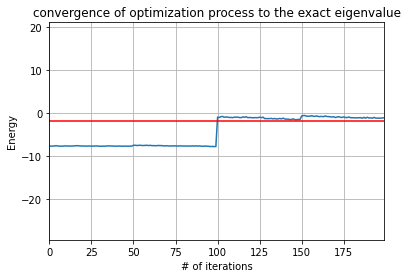

In [129]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [130]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [131]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

2it [00:00,  8.38it/s]

{'1100': 69, '0011': 96, '1110': 99, '0001': 16, '1010': 8, '1001': 40, '0100': 33, '0010': 124, '1011': 52, '0111': 62, '1111': 169, '1000': 59, '1101': 94, '0110': 82, '0101': 19, '0000': 2}
1.0
{'1111': 265, '0111': 89, '1101': 112, '0000': 18, '0101': 48, '1001': 88, '1011': 75, '0011': 181, '1100': 47, '1010': 18, '0100': 19, '0110': 37, '1110': 10, '1000': 4, '0010': 10, '0001': 3}
1.0


4it [00:00,  7.28it/s]

{'0011': 23, '1100': 151, '1101': 174, '0110': 116, '1001': 114, '0001': 92, '1000': 68, '0101': 61, '0010': 76, '0111': 15, '0000': 33, '1111': 83, '1011': 1, '0100': 7, '1010': 4, '1110': 6}
1.0
{'1011': 88, '0010': 100, '1100': 65, '0011': 97, '1110': 95, '0001': 21, '1101': 106, '0110': 84, '1111': 149, '0100': 43, '0111': 55, '0101': 16, '1001': 36, '1000': 46, '1010': 22, '0000': 1}
1.0


6it [00:00,  6.70it/s]

{'0010': 146, '1001': 88, '0000': 43, '1000': 22, '1100': 97, '0011': 94, '0111': 71, '1111': 209, '0101': 25, '1110': 89, '1011': 17, '0001': 10, '0110': 22, '1010': 22, '1101': 63, '0100': 6}
1.0
{'1001': 40, '1101': 100, '0010': 123, '1011': 77, '1100': 82, '0011': 102, '1111': 165, '0101': 17, '1110': 85, '1010': 17, '0100': 32, '0111': 60, '1000': 52, '0110': 60, '0001': 11, '0000': 1}
1.0


8it [00:01,  6.83it/s]

{'0110': 69, '1111': 171, '1110': 105, '1101': 99, '1010': 15, '1011': 89, '1100': 73, '0011': 79, '0111': 68, '1000': 54, '0010': 94, '0101': 18, '0100': 34, '1001': 38, '0001': 15, '0000': 3}
1.0
{'0111': 128, '0101': 49, '1110': 132, '0110': 30, '1111': 100, '1101': 72, '0100': 100, '0011': 154, '1100': 15, '0000': 28, '0010': 95, '1010': 30, '1000': 27, '0001': 28, '1011': 15, '1001': 21}
1.0


10it [00:01,  6.42it/s]

{'0110': 75, '1111': 183, '1000': 56, '1110': 80, '1101': 92, '0010': 110, '0011': 96, '1010': 14, '0100': 42, '1100': 76, '1001': 31, '0111': 59, '0001': 14, '1011': 69, '0101': 23, '0000': 4}
1.0
{'0010': 106, '1011': 85, '0011': 72, '1100': 77, '1111': 160, '0110': 73, '1110': 106, '1101': 102, '0101': 13, '0100': 46, '0001': 18, '0111': 60, '1000': 54, '1010': 13, '1001': 34, '0000': 5}
1.0


11it [00:01,  6.99it/s]


{'0010': 122, '0101': 15, '1110': 87, '1001': 32, '1010': 19, '1000': 60, '1111': 172, '0110': 62, '1011': 63, '0111': 59, '1101': 108, '0011': 97, '0100': 44, '1100': 71, '0001': 13}
1.0


1it [00:00,  8.23it/s]

{'0110': 63, '1111': 281, '0011': 90, '1100': 48, '1001': 42, '1101': 80, '1000': 101, '1011': 109, '0010': 55, '0100': 69, '0000': 5, '0101': 21, '1110': 14, '0001': 2, '0111': 44}
1.0


2it [00:00,  7.71it/s]

{'0110': 78, '1111': 173, '1101': 115, '0011': 140, '1010': 52, '1001': 108, '1000': 32, '1011': 46, '0101': 47, '1110': 126, '0100': 36, '0111': 42, '0001': 14, '1100': 12, '0000': 2, '0010': 1}
1.0


3it [00:00,  6.99it/s]

{'0110': 113, '1111': 76, '1101': 266, '1110': 34, '0101': 54, '1010': 56, '1001': 107, '1100': 25, '1011': 61, '0000': 41, '1000': 59, '0011': 28, '0001': 76, '0100': 4, '0010': 17, '0111': 7}
1.0


4it [00:00,  7.43it/s]

{'1111': 248, '0110': 59, '0111': 40, '1101': 91, '1001': 48, '1011': 129, '0011': 100, '1000': 110, '1100': 36, '0100': 71, '0010': 48, '0001': 12, '0101': 15, '1110': 13, '0000': 4}
1.0


5it [00:00,  7.14it/s]

{'1111': 307, '1010': 12, '1001': 96, '0010': 158, '1011': 35, '1100': 137, '0100': 47, '1101': 21, '0111': 89, '0011': 51, '0101': 10, '0001': 10, '1000': 25, '0000': 19, '1110': 7}
1.0


6it [00:00,  7.33it/s]

{'1000': 121, '1111': 287, '1101': 60, '0100': 68, '0010': 62, '1001': 35, '0111': 37, '0011': 92, '1011': 112, '0000': 6, '0110': 70, '1100': 46, '0001': 8, '0101': 12, '1110': 8}
1.0


7it [00:00,  6.93it/s]

{'0110': 69, '1111': 282, '0010': 52, '1011': 100, '1000': 115, '0100': 81, '1100': 41, '1110': 11, '1101': 76, '0101': 17, '0111': 44, '0011': 84, '1001': 33, '0001': 9, '0000': 10}
1.0


8it [00:01,  6.66it/s]

{'0111': 156, '0100': 130, '1101': 48, '1111': 141, '0011': 201, '0000': 77, '0001': 29, '0101': 24, '1000': 60, '1110': 49, '0010': 31, '1010': 30, '0110': 24, '1001': 23, '1011': 1}
1.0


9it [00:01,  6.21it/s]

{'1011': 99, '0010': 41, '0011': 102, '1100': 37, '1111': 278, '0111': 56, '1000': 115, '1101': 79, '0110': 76, '0100': 73, '0001': 6, '1001': 36, '1110': 10, '0000': 5, '0101': 11}
1.0


10it [00:01,  6.04it/s]

{'0011': 82, '1100': 41, '1001': 39, '1011': 119, '1101': 83, '0100': 68, '1111': 263, '0111': 54, '0110': 62, '1000': 132, '0010': 37, '0101': 15, '1110': 17, '0001': 8, '0000': 4}
1.0


11it [00:01,  6.65it/s]


{'0110': 50, '1111': 275, '1011': 120, '1001': 45, '0100': 61, '1101': 74, '1000': 115, '1100': 61, '1110': 7, '0101': 17, '0000': 4, '0001': 6, '0111': 54, '0011': 78, '0010': 56, '1010': 1}
1.0


1it [00:00,  6.21it/s]

{'1100': 56, '0011': 236, '0110': 99, '0001': 30, '0101': 14, '0010': 182, '1101': 82, '0111': 157, '0100': 13, '1000': 71, '1111': 26, '1110': 14, '1001': 32, '1011': 12}
1.0


2it [00:00,  5.72it/s]

{'1101': 106, '0111': 204, '1100': 38, '0011': 423, '0001': 16, '1001': 78, '1011': 14, '1111': 46, '1000': 4, '0110': 45, '0010': 25, '0000': 5, '0100': 6, '0101': 10, '1110': 2, '1010': 2}
1.0


3it [00:00,  6.20it/s]

{'1111': 22, '0110': 81, '0010': 69, '0011': 90, '1100': 57, '0101': 106, '0000': 91, '1101': 79, '1110': 12, '0001': 191, '1001': 64, '1000': 46, '0111': 71, '0100': 17, '1010': 28}
1.0


4it [00:00,  6.37it/s]

{'1100': 50, '0011': 199, '0111': 184, '1111': 43, '1011': 21, '0010': 174, '1101': 82, '0001': 36, '0110': 89, '1000': 69, '0100': 11, '1010': 2, '1110': 17, '0101': 12, '1001': 34, '0000': 1}
1.0


5it [00:00,  6.30it/s]

{'1000': 31, '0001': 37, '1111': 42, '0011': 299, '1101': 46, '0010': 237, '1110': 13, '0111': 110, '1100': 99, '0100': 15, '0110': 13, '1011': 13, '1001': 59, '1010': 5, '0101': 3, '0000': 2}
1.0
{'1111': 37, '0110': 100, '0010': 163, '1101': 81, '0011': 236, '0111': 160, '0001': 30, '1000': 61, '1110': 16, '1100': 66, '0100': 11, '1001': 28, '0000': 2, '0101': 14, '1011': 19}
1.0


7it [00:01,  5.95it/s]

{'0101': 16, '0010': 159, '0011': 215, '1100': 64, '0001': 29, '0111': 169, '1000': 73, '0110': 88, '1101': 92, '1001': 42, '1011': 23, '1111': 30, '0100': 9, '1110': 13, '0000': 2}
1.0


8it [00:01,  6.44it/s]

{'1010': 74, '1111': 137, '1110': 102, '0011': 146, '0010': 94, '1000': 33, '0111': 69, '1101': 68, '0001': 19, '1001': 35, '1011': 106, '0110': 21, '0000': 24, '0100': 69, '0101': 21, '1100': 6}
1.0


9it [00:01,  6.55it/s]

{'0110': 99, '1111': 40, '0100': 16, '0001': 28, '0011': 268, '0111': 166, '0010': 128, '1000': 62, '1110': 15, '1100': 57, '1101': 83, '0101': 14, '1011': 20, '1001': 27, '1010': 1}
1.0


10it [00:01,  6.70it/s]

{'0110': 80, '1100': 69, '0011': 237, '0111': 177, '1101': 65, '0010': 155, '1000': 81, '0001': 29, '1011': 17, '1111': 36, '0100': 20, '1001': 33, '0101': 10, '1110': 13, '0000': 2}
1.0


11it [00:01,  6.30it/s]

{'1101': 72, '1100': 69, '0011': 252, '0111': 174, '0110': 93, '0010': 160, '0101': 9, '1000': 72, '0001': 34, '1111': 29, '1001': 18, '1110': 18, '0100': 12, '0000': 2, '1011': 10}
1.0



1it [00:00,  7.55it/s]

{'0011': 57, '1100': 92, '1011': 77, '0110': 70, '1111': 70, '0101': 32, '1101': 156, '0111': 37, '1001': 104, '0010': 153, '1110': 26, '1000': 72, '0000': 11, '0001': 43, '1010': 18, '0100': 6}
1.0


2it [00:00,  8.44it/s]

{'1100': 59, '0011': 190, '0000': 39, '0111': 52, '1101': 221, '1010': 18, '0001': 25, '1001': 163, '0101': 10, '1111': 84, '1011': 83, '0110': 41, '1000': 3, '0100': 17, '1110': 4, '0010': 15}
1.0


3it [00:00,  7.69it/s]

{'1010': 10, '1001': 153, '0010': 121, '1100': 94, '0000': 46, '1000': 95, '1101': 226, '1111': 22, '1011': 30, '0001': 77, '0110': 50, '0100': 18, '0111': 10, '0101': 50, '0011': 13, '1110': 9}
1.0


4it [00:00,  8.43it/s]

{'1000': 82, '1101': 142, '0101': 20, '1001': 110, '1111': 64, '1100': 96, '0011': 49, '0010': 147, '0110': 67, '1011': 86, '1010': 23, '0111': 28, '0000': 16, '0001': 42, '1110': 44, '0100': 8}
1.0


5it [00:00,  7.21it/s]

{'1000': 42, '0101': 45, '0010': 182, '1101': 117, '1001': 145, '0111': 68, '0011': 29, '1111': 136, '0000': 22, '0001': 19, '0110': 35, '1100': 118, '1110': 37, '1011': 10, '1010': 18, '0100': 1}
1.0


6it [00:00,  6.99it/s]

{'1101': 180, '1010': 17, '1100': 84, '0010': 148, '1011': 91, '1111': 66, '0000': 14, '1110': 38, '0101': 26, '0001': 50, '1001': 99, '0110': 61, '1000': 72, '0011': 48, '0111': 27, '0100': 3}
1.0


7it [00:00,  6.74it/s]

{'0010': 129, '1011': 91, '1101': 156, '1000': 96, '0110': 70, '1111': 72, '1001': 109, '1110': 33, '0111': 37, '0011': 38, '1100': 94, '0000': 10, '0101': 22, '0001': 43, '1010': 17, '0100': 7}
1.0


8it [00:01,  7.49it/s]

{'0011': 131, '0010': 109, '1110': 76, '0101': 48, '1010': 59, '0001': 133, '0111': 68, '1111': 35, '1000': 42, '1101': 145, '0000': 53, '1100': 25, '0110': 13, '1001': 14, '0100': 67, '1011': 6}
1.0


9it [00:01,  7.70it/s]

{'1101': 170, '1001': 84, '0001': 45, '0010': 154, '1011': 101, '1000': 78, '0011': 48, '1110': 28, '0110': 68, '0100': 6, '1111': 69, '1010': 15, '1100': 81, '0111': 47, '0101': 23, '0000': 7}
1.0
{'1101': 180, '0110': 59, '1110': 27, '1011': 97, '0010': 144, '0111': 44, '1000': 81, '1100': 82, '0001': 49, '0011': 54, '1001': 87, '0101': 27, '0100': 7, '1111': 58, '1010': 16, '0000': 12}

11it [00:01,  7.14it/s]



1.0
{'1000': 69, '1100': 90, '0111': 36, '1110': 24, '0101': 27, '1011': 70, '0010': 153, '1001': 104, '0011': 60, '1101': 178, '1111': 62, '0110': 72, '0001': 38, '1010': 16, '0100': 10, '0000': 15}
1.0


2it [00:00,  7.76it/s]

{'0100': 37, '0111': 68, '1000': 174, '0011': 87, '1001': 106, '0110': 41, '0010': 92, '1110': 73, '1111': 130, '1101': 35, '1010': 23, '1011': 85, '0001': 43, '0000': 8, '1100': 22}
1.0
{'0011': 160, '1011': 100, '1111': 191, '0110': 58, '1010': 17, '0000': 43, '0111': 44, '0101': 25, '1101': 47, '0100': 25, '1001': 245, '1000': 28, '0010': 11, '1100': 9, '1110': 8, '0001': 13}
1.0


4it [00:00,  6.44it/s]

{'0011': 29, '1000': 148, '1111': 78, '0110': 71, '1011': 26, '0010': 67, '0100': 11, '0001': 113, '1001': 184, '0000': 22, '1010': 35, '1101': 109, '1100': 47, '1110': 27, '0111': 32, '0101': 25}
1.0
{'1000': 152, '0010': 104, '1011': 95, '0011': 85, '1110': 69, '0100': 41, '1101': 45, '0110': 39, '1010': 31, '0000': 12, '1111': 125, '1001': 117, '0001': 37, '0111': 57, '1100': 15}
1.0


6it [00:00,  7.03it/s]

{'1111': 144, '0110': 53, '1101': 66, '1000': 109, '0111': 110, '1100': 85, '0010': 77, '0001': 15, '1110': 55, '1001': 102, '1011': 68, '1010': 45, '0011': 23, '0000': 36, '0101': 20, '0100': 16}
1.0
{'1100': 29, '0011': 73, '0010': 97, '1011': 83, '1111': 143, '1000': 148, '1001': 139, '1110': 66, '0001': 52, '0110': 42, '0000': 10, '0100': 37, '1101': 34, '0111': 49, '1010': 22}
1.0


8it [00:01,  6.93it/s]

{'1110': 60, '0111': 55, '0011': 81, '0001': 59, '1001': 112, '1000': 147, '1111': 150, '1011': 82, '1010': 29, '1100': 25, '1101': 50, '0010': 84, '0100': 42, '0000': 10, '0110': 38}
1.0
{'1011': 42, '0000': 68, '1000': 108, '0111': 157, '0100': 54, '1001': 85, '0011': 98, '1110': 87, '1111': 35, '0010': 84, '1010': 45, '0101': 26, '0110': 21, '0001': 88, '1101': 18, '1100': 8}
1.0


10it [00:01,  6.56it/s]

{'0111': 58, '1000': 170, '0011': 82, '1010': 25, '0001': 46, '1001': 111, '1011': 71, '0110': 40, '1110': 69, '1111': 151, '0010': 92, '1101': 42, '0000': 14, '0100': 35, '1100': 18}
1.0
{'1001': 101, '1011': 85, '0010': 76, '1111': 143, '1101': 44, '1000': 164, '0000': 18, '0111': 44, '0100': 52, '1110': 87, '0110': 35, '0001': 47, '0011': 82, '1100': 21, '1010': 25}
1.0


11it [00:01,  6.81it/s]


{'1011': 91, '0010': 115, '1100': 27, '0011': 99, '0001': 39, '1001': 110, '1101': 48, '1111': 130, '1000': 154, '1110': 59, '0100': 40, '0110': 27, '1010': 28, '0111': 47, '0000': 10}
1.0


1it [00:00,  6.93it/s]

{'0100': 53, '1101': 102, '1100': 55, '0101': 25, '0010': 102, '0110': 95, '1111': 147, '0001': 14, '1011': 71, '0011': 90, '0111': 71, '1110': 85, '1000': 63, '1010': 16, '1001': 30, '0000': 5}
1.0


2it [00:00,  6.94it/s]

{'0111': 97, '0011': 191, '1100': 67, '1011': 69, '0000': 20, '0101': 28, '1111': 223, '1010': 20, '1001': 83, '1101': 109, '0100': 22, '1110': 19, '0010': 6, '0110': 66, '0001': 4}
1.0
{'1000': 46, '0000': 45, '1101': 198, '1011': 9, '0101': 70, '0001': 88, '1100': 154, '0111': 17, '1111': 66, '0110': 122, '0010': 67, '1001': 105, '1110': 5, '0011': 23, '1010': 3, '0100': 6}
1.0

4it [00:00,  6.49it/s]


{'1000': 49, '0011': 115, '0110': 78, '1111': 158, '0100': 48, '1101': 90, '0111': 59, '1110': 89, '0010': 96, '1001': 39, '1011': 80, '1100': 71, '1010': 8, '0001': 13, '0000': 4, '0101': 27}
1.0


6it [00:00,  7.81it/s]

{'0110': 15, '1111': 216, '0111': 73, '0101': 20, '1110': 79, '1001': 86, '0011': 101, '0010': 174, '0000': 25, '1011': 11, '0001': 22, '1101': 50, '1000': 14, '1100': 93, '0100': 16, '1010': 29}
1.0
{'0110': 73, '1111': 154, '0011': 113, '1011': 73, '0010': 105, '0100': 41, '1101': 104, '1000': 53, '1110': 86, '1001': 47, '0001': 20, '0101': 26, '0111': 54, '1010': 13, '1100': 62}
1.0


8it [00:01,  6.98it/s]

{'0011': 103, '1100': 63, '1101': 93, '0110': 85, '1111': 175, '0111': 54, '0101': 19, '1000': 48, '1110': 82, '0100': 47, '0001': 19, '1001': 48, '0010': 102, '1011': 73, '0000': 1, '1010': 12}
1.0
{'0111': 127, '1100': 18, '0101': 54, '1110': 139, '0100': 100, '1010': 29, '1000': 37, '1111': 93, '0011': 157, '0010': 81, '0001': 36, '0000': 8, '1101': 76, '1011': 9, '1001': 25, '0110': 35}
1.0


10it [00:01,  7.01it/s]

{'1101': 89, '0011': 105, '0110': 71, '1111': 188, '1000': 51, '0111': 70, '0001': 11, '0010': 141, '1011': 61, '0101': 17, '1001': 42, '1110': 77, '0100': 41, '1010': 13, '1100': 43, '0000': 4}
1.0
{'0110': 94, '1111': 156, '1101': 119, '0010': 106, '1110': 85, '1000': 46, '1010': 11, '1100': 80, '1011': 59, '0011': 104, '0101': 13, '1001': 39, '0111': 56, '0100': 45, '0001': 10, '0000': 1}
1.0


11it [00:01,  6.93it/s]


{'0110': 87, '1111': 145, '1110': 88, '0100': 48, '1101': 108, '0010': 95, '1010': 19, '1100': 70, '0101': 29, '1001': 39, '1000': 39, '0011': 119, '0111': 48, '1011': 73, '0000': 2, '0001': 15}
1.0


0it [00:00, ?it/s]

{'0110': 68, '1111': 192, '1100': 71, '0011': 80, '1101': 97, '1110': 110, '1001': 33, '0000': 5, '1011': 63, '0010': 108, '0111': 35, '1000': 59, '0101': 25, '0100': 32, '0001': 22, '1010': 24}


2it [00:00,  6.43it/s]

1.0
{'1111': 254, '0110': 31, '1101': 104, '1001': 90, '0111': 89, '1100': 73, '1011': 86, '0101': 39, '0011': 165, '0000': 28, '0100': 19, '1010': 17, '0001': 5, '1110': 14, '0010': 6, '1000': 4}
1.0


4it [00:00,  6.38it/s]

{'0010': 79, '1001': 99, '1010': 11, '1100': 179, '1000': 69, '0101': 39, '0111': 10, '1101': 223, '0110': 90, '1111': 79, '0001': 86, '0000': 35, '0011': 13, '0100': 7, '1011': 4, '1110': 1}
1.0
{'1100': 92, '0011': 91, '1011': 68, '0010': 105, '1111': 177, '0110': 66, '1101': 104, '1000': 45, '0000': 3, '1110': 101, '0111': 46, '0100': 25, '0101': 20, '1001': 34, '1010': 22, '0001': 25}
1.0


6it [00:00,  5.86it/s]

{'1001': 89, '1000': 24, '0000': 25, '1111': 250, '0010': 158, '1100': 93, '1110': 99, '0101': 22, '0111': 67, '0011': 61, '1101': 43, '0110': 26, '1011': 20, '1010': 30, '0100': 7, '0001': 10}
1.0
{'1110': 109, '0100': 41, '1101': 96, '1111': 178, '1100': 95, '0010': 94, '1001': 37, '1000': 53, '0110': 77, '0000': 4, '0101': 22, '1011': 74, '0111': 31, '0011': 76, '1010': 11, '0001': 26}
1.0


8it [00:01,  5.29it/s]

{'1111': 177, '1100': 81, '0100': 40, '1101': 110, '1110': 121, '0010': 113, '1011': 78, '0111': 32, '1001': 41, '0011': 70, '1010': 14, '0110': 56, '1000': 46, '0001': 24, '0101': 20, '0000': 1}
1.0
{'0010': 94, '0011': 161, '0111': 128, '1111': 97, '1010': 22, '1110': 168, '0100': 90, '1101': 74, '0110': 20, '0101': 42, '0000': 34, '0001': 29, '1001': 19, '1011': 2, '1000': 20, '1100': 24}
1.0


9it [00:01,  5.65it/s]

{'1011': 59, '0010': 111, '1111': 171, '0011': 91, '1100': 78, '1000': 54, '0000': 7, '1110': 134, '0110': 68, '0111': 39, '1001': 42, '0100': 33, '1101': 79, '0001': 18, '1010': 22, '0101': 18}
1.0


11it [00:01,  5.70it/s]


{'0011': 89, '0101': 15, '1110': 127, '0010': 114, '1011': 58, '1111': 175, '0110': 81, '1000': 44, '0100': 35, '1001': 37, '0000': 9, '1100': 79, '0111': 32, '1010': 24, '1101': 85, '0001': 20}
1.0
{'0010': 115, '1000': 64, '1110': 103, '1111': 178, '0001': 17, '1001': 29, '1101': 82, '0100': 38, '0111': 41, '0110': 75, '0011': 83, '1011': 77, '1010': 19, '1100': 76, '0101': 25, '0000': 2}
1.0


2it [00:00,  6.71it/s]

{'1001': 39, '0001': 82, '1101': 156, '1011': 46, '1100': 81, '1110': 69, '0101': 52, '1111': 137, '1000': 78, '1010': 15, '0110': 46, '0011': 79, '0010': 64, '0111': 32, '0100': 45, '0000': 3}
1.0
{'1001': 130, '1111': 206, '0011': 123, '1100': 95, '0101': 73, '1011': 47, '1101': 138, '0111': 63, '0000': 39, '0100': 25, '0010': 2, '0110': 21, '0001': 35, '1110': 11, '1000': 12, '1010': 4}
1.0


4it [00:00,  6.95it/s]

{'1111': 156, '0110': 98, '1010': 17, '1001': 99, '0001': 134, '1101': 120, '1100': 148, '0010': 27, '0101': 62, '1000': 76, '0000': 29, '1110': 17, '0111': 24, '1011': 2, '0011': 15}
1.0
{'1110': 76, '1111': 126, '1000': 82, '0010': 67, '1101': 127, '0100': 55, '0111': 36, '0011': 84, '1100': 88, '1001': 66, '0110': 44, '0101': 42, '1011': 46, '0001': 66, '1010': 18, '0000': 1}
1.0


6it [00:00,  6.90it/s]

{'0100': 24, '0001': 49, '1001': 103, '0111': 47, '1000': 25, '1111': 173, '1100': 151, '0101': 60, '1110': 68, '1011': 11, '0011': 76, '0010': 100, '0000': 29, '1101': 92, '1010': 11, '0110': 5}
1.0
{'1000': 77, '0011': 93, '1100': 90, '1110': 68, '1011': 37, '0010': 62, '1101': 161, '0001': 68, '0101': 53, '0100': 41, '1111': 132, '1001': 55, '1010': 14, '0111': 35, '0110': 36, '0000': 2}
1.0


8it [00:01,  6.42it/s]

{'0110': 47, '1111': 140, '0100': 46, '0011': 81, '1100': 73, '0111': 23, '0001': 75, '1110': 76, '0010': 67, '1101': 146, '1000': 74, '1001': 73, '1010': 11, '1011': 49, '0101': 43}
1.0
{'1000': 34, '1101': 137, '0100': 132, '1111': 88, '0011': 131, '1110': 94, '0101': 57, '0111': 81, '0010': 73, '1100': 8, '1010': 17, '0001': 82, '0000': 39, '1001': 23, '0110': 24, '1011': 4}
1.0


10it [00:01,  6.78it/s]

{'1101': 159, '1100': 80, '0011': 95, '1000': 73, '1111': 117, '0110': 51, '1110': 81, '0010': 44, '0101': 45, '0100': 41, '1001': 52, '1011': 45, '0001': 68, '1010': 29, '0111': 43, '0000': 1}
1.0
{'1111': 128, '1001': 63, '0001': 73, '1110': 71, '0101': 54, '1101': 160, '1000': 76, '1011': 46, '0011': 80, '0010': 59, '1100': 79, '0111': 30, '0110': 37, '0100': 50, '1010': 17, '0000': 1}
1.0


11it [00:01,  6.71it/s]


{'1111': 130, '1101': 152, '1100': 70, '0011': 72, '1000': 71, '1011': 48, '0001': 81, '1001': 59, '0111': 39, '1110': 81, '0110': 45, '0101': 46, '0010': 66, '0100': 43, '1010': 19, '0000': 2}
1.0


2it [00:00,  5.50it/s]

{'1011': 112, '0010': 88, '1111': 100, '1101': 126, '0101': 31, '1110': 56, '1000': 144, '0011': 105, '0001': 63, '1001': 68, '1100': 43, '1010': 35, '0100': 21, '0111': 4, '0110': 17, '0000': 11}
1.0
{'1101': 82, '1100': 68, '0011': 208, '1001': 178, '1111': 160, '1011': 117, '0000': 52, '1000': 30, '0100': 31, '0101': 34, '0010': 9, '1010': 11, '1110': 8, '0111': 16, '0110': 4, '0001': 16}
1.0


4it [00:00,  5.98it/s]

{'1010': 24, '1001': 169, '0000': 34, '1000': 121, '1101': 107, '1111': 109, '1011': 38, '1100': 99, '0010': 56, '0001': 125, '0101': 45, '0110': 35, '0011': 35, '0111': 21, '1110': 6}
1.0
{'1101': 124, '1011': 109, '0010': 98, '1000': 132, '1100': 35, '0011': 99, '1111': 101, '1110': 57, '1001': 81, '0100': 27, '0101': 41, '0001': 66, '0111': 4, '1010': 33, '0110': 13, '0000': 4}
1.0


6it [00:00,  6.48it/s]

{'1100': 163, '0011': 57, '1111': 179, '1101': 141, '0111': 47, '1001': 60, '0001': 85, '1110': 93, '1000': 21, '0010': 76, '0101': 33, '0100': 9, '1011': 13, '1010': 5, '0110': 21, '0000': 21}
1.0
{'1011': 84, '0010': 88, '1111': 108, '0011': 112, '1000': 139, '1110': 60, '1101': 119, '1001': 88, '1100': 45, '0001': 57, '1010': 37, '0101': 42, '0110': 15, '0000': 6, '0100': 21, '0111': 3}
1.0


8it [00:01,  6.77it/s]

{'1001': 84, '0001': 65, '1000': 125, '0011': 116, '1100': 43, '0010': 85, '1111': 104, '1110': 63, '1101': 113, '1011': 106, '0110': 21, '0101': 38, '1010': 33, '0100': 20, '0000': 4, '0111': 4}
1.0
{'0100': 46, '1101': 134, '0010': 81, '1001': 27, '0001': 161, '0011': 162, '1000': 73, '1111': 61, '0111': 40, '0000': 53, '1110': 71, '0101': 36, '1010': 26, '1011': 30, '0110': 19, '1100': 4}
1.0


10it [00:01,  7.25it/s]

{'0001': 63, '1010': 41, '0100': 31, '1101': 116, '1011': 112, '0010': 93, '1111': 94, '1110': 45, '1100': 42, '1001': 77, '1000': 133, '0011': 112, '0111': 3, '0110': 14, '0101': 40, '0000': 8}
1.0
{'1001': 83, '1010': 42, '0100': 30, '1101': 125, '1011': 103, '1000': 110, '1100': 31, '0101': 37, '1111': 101, '0001': 80, '0010': 99, '1110': 61, '0110': 13, '0011': 97, '0000': 8, '0111': 4}
1.0


11it [00:01,  6.51it/s]


{'1000': 116, '0000': 5, '1101': 123, '0111': 4, '1011': 98, '0010': 93, '0001': 68, '0101': 44, '1110': 68, '1111': 93, '1001': 91, '0100': 23, '1010': 34, '0011': 97, '1100': 42, '0110': 25}
1.0


1it [00:00,  5.85it/s]

{'0010': 64, '1011': 27, '0100': 187, '1101': 107, '0101': 74, '1110': 59, '1111': 46, '1100': 106, '1000': 99, '0001': 81, '0011': 30, '1001': 8, '0111': 16, '0110': 79, '0000': 40, '1010': 1}
1.0


2it [00:00,  7.49it/s]

{'0100': 155, '0000': 108, '1000': 26, '1100': 188, '0011': 96, '0110': 53, '0101': 98, '1001': 92, '1111': 99, '1101': 35, '0001': 17, '0111': 26, '0010': 7, '1010': 5, '1011': 15, '1110': 4}
1.0


3it [00:00,  6.91it/s]

{'0001': 89, '0011': 36, '1100': 156, '0110': 246, '0100': 35, '0101': 62, '0010': 88, '1000': 77, '1111': 118, '1010': 36, '1110': 3, '1101': 37, '1001': 20, '0111': 13, '0000': 5, '1011': 3}
1.0


4it [00:00,  7.80it/s]

{'1101': 113, '0100': 178, '1000': 125, '0001': 87, '1111': 39, '1100': 105, '0010': 81, '1011': 22, '0110': 83, '1110': 52, '0101': 59, '0111': 14, '0011': 28, '0000': 26, '1001': 8, '1010': 4}
1.0
{'0010': 159, '0000': 177, '1111': 69, '0001': 116, '1100': 214, '0101': 41, '1110': 53, '0111': 25, '1101': 42, '1001': 61, '1010': 17, '0100': 35, '0011': 10, '1011': 2, '1000': 3}
1.0


7it [00:00,  7.26it/s]

{'1101': 111, '0100': 186, '1000': 141, '1111': 47, '0110': 73, '1110': 67, '1011': 23, '0001': 96, '1100': 86, '0011': 32, '0010': 60, '0101': 60, '0111': 7, '0000': 23, '1001': 9, '1010': 3}
1.0
{'0110': 68, '1101': 123, '0100': 191, '1110': 65, '0010': 83, '1011': 13, '1000': 110, '1100': 94, '0001': 86, '0011': 42, '0101': 61, '0000': 27, '1111': 39, '0111': 12, '1010': 4, '1001': 6}
1.0


9it [00:01,  7.57it/s]

{'1000': 106, '0000': 44, '1010': 29, '1001': 31, '0100': 190, '1101': 171, '0111': 43, '1100': 74, '0001': 64, '0010': 49, '0101': 5, '0011': 47, '1110': 134, '1111': 23, '0110': 14}
1.0
{'0100': 164, '1000': 121, '1100': 98, '1110': 68, '0001': 81, '0110': 79, '1011': 17, '0010': 64, '0000': 37, '1101': 107, '1111': 61, '1001': 9, '0101': 66, '1010': 5, '0111': 12, '0011': 35}
1.0


11it [00:01,  7.35it/s]


{'1101': 120, '0100': 182, '1000': 127, '0001': 82, '0110': 80, '1110': 54, '0101': 64, '1100': 116, '0010': 54, '0011': 28, '1011': 24, '0111': 9, '0000': 29, '1111': 41, '1001': 7, '1010': 7}
1.0
{'1000': 130, '0000': 35, '0010': 66, '0100': 176, '1101': 88, '1111': 38, '0001': 100, '1100': 110, '0110': 91, '0011': 32, '1001': 7, '0101': 67, '1110': 51, '1011': 22, '0111': 10, '1010': 1}
1.0


2it [00:00,  6.05it/s]

{'1101': 266, '0111': 70, '1000': 31, '1100': 82, '0110': 44, '1111': 119, '0101': 55, '1011': 35, '0010': 31, '0001': 133, '1001': 31, '1110': 24, '0100': 13, '0011': 60, '0000': 19, '1010': 11}
1.0
{'1100': 172, '0011': 118, '1001': 32, '0001': 52, '0111': 78, '0100': 54, '1101': 176, '1111': 125, '1011': 34, '0110': 20, '1110': 24, '0000': 88, '1000': 27, '1010': 17, '0101': 3, '0010': 4}
1.0


4it [00:00,  6.55it/s]

{'1110': 28, '0101': 108, '0001': 183, '1111': 199, '1101': 155, '0000': 35, '1100': 97, '0111': 7, '0011': 35, '1001': 42, '0100': 18, '1000': 48, '1011': 16, '0110': 40, '0010': 9, '1010': 4}
1.0
{'1101': 260, '1010': 12, '0001': 123, '1011': 43, '0111': 66, '1111': 124, '0101': 49, '1100': 96, '0000': 11, '0110': 36, '0011': 73, '1001': 31, '0010': 35, '1110': 27, '1000': 24, '0100': 14}
1.0


6it [00:00,  6.41it/s]

{'0010': 54, '0000': 32, '1111': 136, '0011': 57, '1100': 111, '1001': 74, '1101': 202, '0111': 71, '0001': 177, '0101': 37, '1110': 34, '1000': 15, '0100': 1, '1011': 9, '0110': 11, '1010': 3}
1.0
{'1010': 11, '0001': 119, '0000': 22, '1101': 275, '1111': 118, '0111': 64, '1011': 38, '0101': 47, '1000': 37, '1001': 18, '0010': 24, '1110': 30, '1100': 108, '0011': 55, '0100': 15, '0110': 43}
1.0


8it [00:01,  6.28it/s]

{'1001': 28, '0001': 130, '1101': 249, '0110': 41, '1111': 105, '0111': 82, '0011': 63, '1110': 32, '1000': 33, '0100': 13, '1100': 85, '0010': 36, '1011': 38, '0000': 20, '0101': 61, '1010': 8}
1.0
{'1001': 18, '0001': 121, '1111': 62, '0110': 23, '1000': 10, '0000': 42, '0111': 111, '1101': 273, '0011': 102, '0101': 55, '1100': 49, '0010': 36, '0100': 56, '1110': 48, '1010': 15, '1011': 3}
1.0


9it [00:01,  6.44it/s]

{'0110': 49, '1111': 104, '1100': 93, '0111': 80, '0010': 25, '0101': 56, '1110': 31, '1101': 258, '1001': 27, '0011': 68, '0001': 123, '1000': 41, '0000': 18, '1011': 33, '0100': 15, '1010': 3}
1.0
{'1101': 244, '1111': 115, '0110': 49, '0011': 60, '1100': 109, '0010': 34, '0001': 130, '0111': 69, '0101': 61, '1011': 43, '1110': 24, '0000': 19, '1001': 19, '1010': 7, '1000': 27, '0100': 14}
1.0

11it [00:01,  5.75it/s]


{'1000': 38, '1111': 125, '0110': 47, '1100': 86, '0011': 64, '0100': 19, '1101': 253, '0001': 127, '0010': 24, '0101': 49, '1010': 12, '1001': 23, '1011': 38, '1110': 25, '0111': 76, '0000': 18}
1.0


11it [00:01,  6.03it/s]
2it [00:00,  6.44it/s]

{'0011': 51, '0100': 24, '1110': 77, '1001': 154, '0001': 194, '1111': 98, '0110': 42, '1011': 65, '1000': 174, '0010': 22, '1010': 19, '0111': 36, '1101': 43, '1100': 23, '0101': 1, '0000': 1}
1.0
{'1010': 23, '0001': 104, '1001': 309, '1111': 155, '0000': 96, '1100': 27, '0011': 51, '0111': 62, '1011': 60, '1000': 28, '0100': 15, '0110': 44, '1101': 38, '0010': 7, '1110': 2, '0101': 3}
1.0


4it [00:00,  7.37it/s]

{'1111': 97, '0110': 62, '1010': 37, '0001': 137, '1001': 238, '1011': 16, '0011': 78, '1000': 163, '1100': 59, '0111': 5, '0101': 20, '1101': 39, '0010': 4, '1110': 45, '0000': 15, '0100': 9}
1.0
{'1111': 76, '1001': 168, '0001': 194, '0011': 47, '1000': 182, '1011': 69, '1110': 65, '1101': 46, '0110': 46, '0111': 37, '1100': 23, '0010': 20, '1010': 25, '0100': 24, '0000': 1, '0101': 1}
1.0


6it [00:00,  7.49it/s]

{'1100': 94, '1110': 75, '0101': 83, '1010': 11, '1001': 162, '1111': 143, '1101': 74, '1011': 4, '0001': 115, '1000': 82, '0111': 48, '0000': 18, '0010': 61, '0100': 12, '0011': 34, '0110': 8}
1.0
{'1001': 158, '0001': 189, '1110': 56, '1111': 101, '0110': 49, '1000': 178, '0011': 52, '1100': 16, '0010': 21, '1011': 78, '0111': 37, '1010': 22, '1101': 43, '0100': 23, '0101': 1}
1.0


8it [00:01,  6.96it/s]

{'0011': 46, '1010': 28, '0001': 173, '1001': 159, '1000': 184, '1101': 58, '0110': 33, '1110': 66, '1011': 72, '1111': 101, '0100': 29, '1100': 23, '0111': 35, '0010': 16, '0101': 1}
1.0
{'0001': 227, '1110': 98, '0111': 94, '1000': 78, '0100': 39, '1101': 42, '1011': 2, '0011': 132, '0000': 94, '1001': 113, '0110': 22, '0101': 17, '0010': 22, '1111': 24, '1010': 19, '1100': 1}
1.0


10it [00:01,  7.56it/s]

{'1000': 168, '0011': 43, '1100': 20, '1111': 95, '1101': 51, '0100': 18, '0111': 48, '0001': 204, '1001': 147, '1110': 80, '0110': 46, '1011': 65, '0010': 18, '1010': 19, '0101': 2}
1.0
{'0001': 210, '1001': 137, '1010': 19, '1011': 66, '1111': 100, '1000': 185, '1100': 17, '0111': 39, '0110': 55, '1110': 70, '0100': 10, '1101': 36, '0010': 18, '0011': 60, '0101': 1, '0000': 1}
1.0


11it [00:01,  7.12it/s]


{'0001': 182, '1001': 170, '1000': 167, '0110': 41, '1100': 26, '1110': 69, '0010': 15, '0111': 49, '1011': 75, '0011': 51, '1101': 47, '1111': 100, '0100': 19, '1010': 11, '0101': 2}
1.0


1it [00:00,  6.50it/s]

{'1111': 181, '0110': 122, '0111': 86, '1100': 92, '1101': 135, '0100': 36, '1000': 31, '1010': 9, '1110': 78, '0011': 62, '0101': 89, '1011': 30, '0010': 36, '1001': 21, '0001': 14, '0000': 2}
1.0


2it [00:00,  5.97it/s]

{'0110': 42, '1111': 254, '1100': 97, '0101': 92, '1110': 16, '1101': 156, '0001': 8, '0111': 137, '0011': 87, '0100': 36, '1001': 52, '1011': 30, '0000': 8, '1000': 3, '1010': 5, '0010': 1}
1.0


3it [00:00,  6.71it/s]

{'1100': 188, '1111': 91, '0110': 127, '1101': 212, '0111': 27, '0101': 170, '1000': 29, '1001': 33, '0001': 64, '0000': 17, '0010': 19, '1010': 18, '1011': 20, '0011': 2, '0100': 7}
1.0


4it [00:00,  6.70it/s]

{'1101': 137, '0101': 104, '1110': 90, '0110': 105, '1111': 183, '0111': 77, '0010': 34, '1100': 93, '0100': 48, '1000': 30, '0001': 21, '1011': 17, '0011': 52, '1001': 24, '1010': 9}
1.0


5it [00:00,  7.14it/s]

{'0110': 30, '1111': 176, '0000': 19, '0111': 69, '0100': 14, '1101': 75, '1110': 64, '1100': 114, '1001': 94, '1000': 32, '0011': 56, '0010': 95, '0101': 73, '1010': 29, '0001': 40, '1011': 44}
1.0


6it [00:00,  7.01it/s]

{'1100': 101, '0011': 54, '0010': 20, '0100': 32, '1101': 142, '0111': 86, '0101': 95, '1111': 191, '1000': 35, '1110': 88, '0110': 103, '1010': 12, '1011': 18, '1001': 28, '0001': 19}
1.0


8it [00:01,  6.38it/s]

{'1111': 187, '0110': 109, '1110': 83, '0111': 81, '1100': 116, '1000': 30, '0001': 28, '1101': 130, '0101': 78, '0011': 51, '0010': 30, '0100': 39, '1011': 31, '1010': 12, '1001': 18, '0000': 1}
1.0
{'1101': 166, '0100': 117, '1111': 122, '0110': 30, '0111': 135, '0101': 67, '1110': 171, '0001': 42, '0011': 64, '0010': 41, '1100': 14, '1000': 25, '0000': 11, '1001': 11, '1010': 4, '1011': 4}
1.0


10it [00:01,  6.76it/s]

{'1101': 138, '1001': 20, '1111': 166, '0110': 128, '0011': 46, '1100': 116, '0010': 30, '0101': 108, '1110': 72, '0100': 32, '0001': 14, '1011': 24, '0111': 92, '1010': 8, '1000': 30}
1.0
{'0110': 109, '1111': 190, '0010': 35, '1100': 106, '1000': 27, '1110': 84, '1101': 135, '1001': 30, '0101': 84, '0111': 78, '1010': 6, '0011': 53, '1011': 25, '0001': 32, '0100': 30}
1.0


11it [00:01,  6.49it/s]


{'1110': 80, '0101': 92, '1100': 94, '0011': 53, '1111': 183, '0110': 107, '0010': 31, '1101': 160, '0001': 23, '0111': 94, '1011': 19, '0100': 27, '1001': 19, '1000': 36, '1010': 5, '0000': 1}
1.0


1it [00:00,  5.75it/s]

{'0111': 84, '0011': 53, '1100': 88, '1110': 83, '0101': 75, '1101': 171, '1011': 33, '1111': 190, '1000': 21, '0001': 22, '0100': 33, '0010': 34, '0110': 108, '1001': 22, '0000': 4, '1010': 3}
1.0


2it [00:00,  7.36it/s]

{'0111': 152, '0011': 88, '1100': 56, '1101': 167, '0100': 28, '1000': 1, '0101': 102, '1001': 56, '1111': 241, '1011': 30, '0110': 47, '0001': 19, '1010': 4, '1110': 24, '0000': 7, '0010': 2}
1.0


3it [00:00,  7.81it/s]

{'0101': 152, '0100': 14, '1101': 259, '1100': 163, '1111': 93, '0110': 141, '0001': 54, '0000': 21, '0111': 13, '1011': 23, '1000': 23, '1001': 37, '0010': 15, '1110': 2, '0011': 9, '1010': 5}
1.0


4it [00:00,  7.53it/s]

{'0101': 90, '1110': 99, '1111': 187, '0111': 80, '0011': 51, '1100': 81, '1101': 130, '0100': 40, '1010': 5, '0110': 122, '1000': 37, '0010': 30, '1001': 29, '0001': 19, '1011': 21, '0000': 3}
1.0


5it [00:00,  6.54it/s]

{'1101': 72, '0100': 33, '1111': 151, '0011': 46, '1100': 76, '0001': 42, '1001': 122, '1110': 58, '0000': 26, '0101': 63, '0010': 117, '0111': 81, '1011': 50, '1000': 26, '1010': 28, '0110': 33}
1.0


6it [00:00,  6.67it/s]

{'1101': 144, '0101': 78, '1110': 105, '0011': 53, '0111': 87, '0110': 105, '1111': 185, '1011': 22, '0010': 37, '1100': 85, '1001': 25, '0001': 12, '0100': 58, '1000': 24, '1010': 3, '0000': 1}
1.0


7it [00:01,  6.98it/s]

{'0110': 99, '1111': 210, '1101': 149, '1000': 22, '0111': 89, '1100': 86, '0011': 60, '1011': 41, '1110': 84, '0101': 72, '0100': 43, '0010': 21, '0001': 18, '1010': 6, '1001': 20, '0000': 4}
1.0


8it [00:01,  7.41it/s]

{'0010': 35, '0001': 27, '1101': 183, '0100': 124, '0110': 38, '1111': 125, '1110': 159, '0111': 154, '0101': 56, '0011': 62, '1000': 28, '0000': 10, '1001': 8, '1011': 10, '1100': 5}
1.0
{'0111': 87, '0100': 37, '1101': 160, '0101': 77, '1110': 91, '1111': 200, '0110': 113, '0001': 14, '0010': 28, '1001': 24, '1100': 83, '1010': 8, '1011': 33, '0011': 43, '1000': 23, '0000': 3}
1.0


10it [00:01,  7.79it/s]

{'0100': 45, '1101': 158, '0111': 88, '1110': 88, '0011': 46, '1100': 96, '1111': 202, '0110': 101, '0001': 17, '1001': 28, '0010': 28, '0101': 71, '1000': 25, '1011': 24, '1010': 4, '0000': 3}
1.0
{'0100': 40, '1101': 135, '0101': 69, '1110': 97, '0110': 132, '1111': 199, '0011': 49, '1001': 22, '1010': 4, '0001': 24, '1011': 26, '1000': 35, '1100': 88, '0010': 32, '0111': 69, '0000': 3}
1.0


11it [00:01,  7.11it/s]
1it [00:00,  8.57it/s]

{'1111': 201, '0110': 91, '1101': 64, '1110': 92, '0101': 228, '0011': 76, '1000': 19, '1001': 25, '0111': 46, '0001': 32, '1011': 22, '1100': 34, '0000': 11, '0010': 50, '0100': 26, '1010': 7}
1.0


2it [00:00,  9.24it/s]

{'0110': 58, '1111': 267, '1100': 74, '0011': 106, '0001': 38, '0101': 218, '0111': 69, '0100': 45, '1110': 35, '1001': 48, '1101': 32, '0010': 9, '0000': 7, '1011': 15, '1010': 3}
1.0


3it [00:00,  7.01it/s]

{'0101': 270, '0110': 61, '1111': 169, '0000': 32, '0011': 16, '1100': 129, '1101': 84, '1001': 6, '0111': 35, '0001': 87, '0100': 53, '0010': 14, '1011': 31, '1010': 12, '1000': 14, '1110': 11}
1.0


4it [00:00,  6.81it/s]

{'1101': 67, '1001': 22, '0001': 30, '1111': 187, '0011': 69, '1110': 109, '0101': 233, '0111': 39, '0100': 32, '0000': 5, '1100': 43, '0110': 90, '1011': 21, '0010': 48, '1000': 23, '1010': 6}
1.0


5it [00:00,  6.48it/s]

{'1001': 77, '0001': 138, '0101': 155, '0111': 71, '1111': 151, '0110': 32, '1000': 49, '0011': 23, '0100': 11, '1110': 96, '0000': 19, '1011': 52, '0010': 82, '1101': 11, '1100': 27, '1010': 30}
1.0
{'1101': 69, '0100': 26, '1100': 38, '0011': 75, '1111': 202, '0110': 101, '1011': 21, '0101': 240, '0010': 45, '1110': 81, '1010': 8, '0111': 48, '0001': 31, '1001': 18, '1000': 19, '0000': 2}
1.0


7it [00:00,  7.82it/s]

{'1110': 95, '0101': 232, '1111': 202, '0110': 90, '0011': 73, '1101': 69, '0100': 21, '0010': 55, '1100': 40, '0111': 41, '0001': 36, '1011': 18, '1000': 23, '1010': 4, '0000': 4, '1001': 21}
1.0


8it [00:01,  7.18it/s]

{'1110': 136, '0011': 64, '0100': 61, '1101': 261, '0111': 173, '1010': 11, '0010': 46, '1111': 80, '1001': 38, '0110': 41, '1100': 32, '1000': 18, '1011': 17, '0101': 25, '0000': 12, '0001': 9}
1.0


9it [00:01,  6.63it/s]

{'1101': 70, '1110': 101, '0101': 248, '0110': 78, '1111': 206, '1001': 19, '0010': 53, '0011': 55, '0100': 27, '1000': 23, '1011': 13, '0111': 49, '0001': 27, '1100': 45, '1010': 7, '0000': 3}
1.0


10it [00:01,  6.57it/s]

{'0110': 91, '1111': 181, '0010': 48, '0101': 230, '1110': 113, '0011': 74, '1001': 27, '1101': 70, '1000': 29, '0000': 6, '0100': 31, '1100': 41, '0001': 27, '0111': 30, '1010': 10, '1011': 16}
1.0


11it [00:01,  6.84it/s]


{'0101': 213, '0111': 49, '0110': 81, '1111': 230, '0000': 5, '1000': 24, '0001': 31, '1101': 68, '1010': 11, '0011': 71, '0100': 24, '0010': 46, '1110': 98, '1100': 37, '1001': 20, '1011': 16}
1.0


1it [00:00,  7.54it/s]

{'1111': 217, '0110': 131, '1011': 67, '1110': 90, '0101': 114, '1101': 70, '0111': 79, '0001': 22, '1001': 23, '1100': 86, '1010': 13, '0011': 33, '0000': 14, '0100': 25, '1000': 29, '0010': 11}
1.0


2it [00:00,  6.06it/s]

{'1010': 39, '0110': 64, '1111': 284, '0111': 155, '0101': 115, '1100': 53, '0100': 38, '0010': 14, '1101': 97, '1001': 36, '1011': 33, '1110': 17, '0011': 34, '1000': 9, '0001': 36}
1.0


3it [00:00,  5.88it/s]

{'1100': 167, '0101': 201, '0110': 113, '1111': 45, '1101': 241, '0001': 35, '1000': 33, '0111': 9, '1001': 46, '0100': 36, '0011': 35, '0010': 20, '1011': 35, '1010': 6, '1110': 2}
1.0


4it [00:00,  5.60it/s]

{'1101': 78, '0111': 85, '1111': 202, '0010': 9, '0101': 122, '1100': 103, '0011': 35, '1000': 20, '1110': 85, '0110': 122, '1010': 13, '1011': 63, '0100': 32, '0000': 16, '1001': 20, '0001': 19}
1.0


5it [00:00,  6.22it/s]

{'1011': 196, '0010': 40, '1101': 93, '1110': 69, '1111': 76, '0011': 35, '1100': 113, '0001': 105, '0100': 31, '0111': 81, '0110': 93, '0101': 35, '0000': 17, '1010': 24, '1000': 6, '1001': 10}
1.0


6it [00:00,  6.41it/s]

{'0101': 114, '1110': 63, '0011': 39, '1100': 94, '0110': 128, '1111': 223, '1101': 86, '0111': 85, '1010': 13, '1000': 20, '1011': 66, '0100': 29, '0001': 16, '0000': 10, '0010': 13, '1001': 25}
1.0


7it [00:01,  6.98it/s]

{'0110': 130, '1111': 217, '1011': 67, '0111': 72, '1110': 77, '0101': 122, '1100': 95, '1000': 35, '0100': 31, '1010': 15, '1001': 19, '1101': 71, '0001': 21, '0011': 37, '0010': 10, '0000': 5}
1.0
{'1111': 122, '0110': 35, '0111': 199, '1110': 157, '0101': 79, '1011': 70, '0001': 36, '1010': 19, '1101': 134, '0000': 14, '0100': 105, '1000': 17, '0010': 6, '0011': 9, '1001': 7, '1100': 15}
1.0


9it [00:01,  7.41it/s]

{'1000': 22, '0010': 13, '0101': 132, '0110': 120, '1111': 231, '0100': 34, '1101': 83, '1100': 74, '1011': 62, '1110': 72, '0001': 18, '0011': 28, '0111': 90, '0000': 11, '1001': 21, '1010': 13}
1.0


10it [00:01,  7.62it/s]

{'1110': 79, '0101': 99, '1011': 55, '0110': 116, '1111': 229, '0011': 26, '0100': 30, '0111': 94, '1100': 98, '1101': 88, '1000': 29, '0001': 21, '1001': 29, '0010': 11, '0000': 10, '1010': 10}
1.0


11it [00:01,  6.87it/s]


{'1111': 217, '0110': 116, '0101': 112, '1110': 68, '0011': 40, '1100': 86, '0111': 92, '1011': 65, '1000': 26, '0001': 16, '1101': 92, '1010': 16, '0100': 32, '0010': 9, '0000': 14, '1001': 23}
1.0


1it [00:00,  6.65it/s]

{'1000': 90, '1100': 95, '0111': 110, '1111': 181, '0101': 77, '1110': 50, '0001': 62, '1101': 85, '0110': 108, '1011': 32, '1001': 58, '0100': 39, '0000': 7, '0011': 26, '0010': 3, '1010': 1}
1.0


2it [00:00,  6.17it/s]

{'0101': 87, '0111': 140, '0110': 43, '1111': 226, '1011': 28, '0100': 22, '1101': 134, '1100': 52, '0001': 24, '0011': 40, '1001': 147, '1000': 23, '0010': 15, '1110': 16, '0000': 18, '1010': 9}
1.0


3it [00:00,  5.74it/s]

{'1100': 144, '1101': 156, '0110': 117, '1111': 109, '1011': 74, '0101': 176, '1000': 45, '0001': 45, '0100': 23, '1010': 81, '0011': 21, '0111': 8, '0010': 19, '1110': 5, '1001': 1}
1.0


4it [00:00,  6.44it/s]

{'0110': 101, '1111': 182, '1101': 75, '0001': 54, '1001': 73, '1110': 53, '0101': 67, '1011': 33, '0111': 97, '0011': 30, '1100': 92, '1000': 109, '0000': 9, '0010': 8, '0100': 41}
1.0


5it [00:00,  6.96it/s]

{'0001': 51, '1000': 66, '0010': 30, '1011': 167, '0011': 26, '1100': 103, '0111': 103, '1111': 26, '0101': 79, '1110': 23, '1101': 74, '0110': 78, '1001': 100, '0000': 31, '1010': 41, '0100': 26}
1.0


6it [00:00,  6.70it/s]

{'0011': 40, '1100': 90, '0110': 102, '1111': 161, '0111': 101, '0100': 35, '0001': 39, '1000': 112, '1110': 62, '1101': 95, '0101': 67, '1001': 66, '0000': 12, '1010': 2, '1011': 32, '0010': 8}
1.0


7it [00:01,  6.81it/s]

{'0101': 79, '0110': 99, '1000': 92, '1011': 27, '0100': 38, '1001': 69, '0111': 96, '1100': 79, '1111': 189, '1110': 50, '0001': 56, '1101': 89, '0011': 41, '0000': 12, '0010': 7, '1010': 1}
1.0


8it [00:01,  6.41it/s]

{'0110': 45, '1111': 107, '0111': 213, '1110': 100, '1000': 68, '0001': 90, '1001': 30, '0100': 132, '1101': 98, '1011': 62, '0101': 42, '1100': 5, '0000': 26, '1010': 4, '0010': 2}
1.0


9it [00:01,  6.54it/s]

{'0111': 92, '1111': 169, '0110': 95, '1001': 75, '1101': 103, '1100': 86, '1110': 48, '0101': 64, '0011': 36, '1000': 92, '1011': 39, '0100': 41, '0001': 57, '0010': 13, '0000': 13, '1010': 1}
1.0


10it [00:01,  7.28it/s]

{'0111': 89, '1111': 174, '0110': 115, '1100': 79, '1110': 56, '1101': 97, '1000': 99, '0010': 9, '1001': 62, '1011': 32, '0011': 36, '0100': 45, '0101': 70, '1010': 3, '0001': 43, '0000': 15}
1.0


11it [00:01,  6.78it/s]


{'0110': 90, '1000': 97, '0001': 67, '1001': 61, '1100': 78, '0100': 38, '0111': 114, '1110': 53, '1101': 103, '1111': 180, '0011': 34, '0000': 10, '0101': 65, '1011': 24, '0010': 9, '1010': 1}
1.0


1it [00:00,  6.89it/s]

{'1011': 42, '0110': 44, '1111': 197, '1101': 220, '0111': 109, '0011': 54, '1001': 41, '0101': 50, '1110': 128, '1100': 59, '1000': 14, '0001': 5, '0100': 18, '0010': 23, '0000': 6, '1010': 14}
1.0


2it [00:00,  6.99it/s]

{'1111': 258, '0110': 26, '0111': 163, '0101': 41, '1101': 219, '0011': 52, '1000': 26, '1011': 46, '1010': 8, '1110': 49, '0100': 27, '0001': 18, '1100': 42, '1001': 25, '0000': 4, '0010': 20}
1.0


3it [00:00,  7.50it/s]

{'1001': 56, '0001': 57, '1101': 341, '0101': 97, '1110': 41, '0011': 3, '1100': 140, '0111': 82, '1011': 26, '0100': 65, '0000': 25, '1111': 52, '0110': 12, '1000': 15, '1010': 12}
1.0


4it [00:00,  7.85it/s]

{'0011': 49, '1100': 54, '1011': 36, '0010': 27, '1111': 159, '1001': 38, '1101': 223, '0111': 139, '1110': 129, '1000': 10, '0101': 53, '0100': 25, '0110': 52, '1010': 17, '0001': 11, '0000': 2}
1.0


5it [00:00,  7.14it/s]

{'0110': 39, '1111': 157, '0011': 125, '1101': 176, '1011': 53, '1110': 101, '0001': 11, '0111': 63, '1001': 112, '0101': 48, '0010': 23, '1010': 30, '0000': 9, '1000': 37, '1100': 21, '0100': 19}
1.0
{'1100': 38, '1111': 180, '0110': 43, '1101': 205, '1001': 49, '0111': 127, '0101': 36, '1110': 151, '1010': 23, '1011': 32, '0011': 72, '0010': 21, '0100': 24, '0001': 12, '1000': 10, '0000': 1}

7it [00:01,  6.11it/s]


1.0
{'1111': 182, '1110': 147, '1101': 230, '0011': 52, '1100': 37, '0111': 124, '1001': 44, '0010': 12, '1010': 15, '1011': 23, '0100': 27, '0110': 53, '0000': 4, '0001': 16, '1000': 12, '0101': 46}
1.0


9it [00:01,  6.00it/s]

{'0110': 80, '1111': 212, '1011': 18, '0010': 34, '0101': 167, '1100': 48, '0011': 72, '1101': 86, '0001': 56, '0111': 99, '1000': 11, '1110': 79, '1001': 19, '0100': 26, '0000': 11, '1010': 6}
1.0
{'1110': 149, '0100': 19, '1101': 204, '1111': 200, '0111': 121, '1100': 55, '0011': 52, '1001': 41, '0110': 52, '1000': 7, '0001': 12, '1010': 24, '1011': 30, '0010': 16, '0101': 40, '0000': 2}
1.0


11it [00:01,  6.24it/s]


{'1001': 55, '1101': 221, '1110': 126, '1111': 195, '0110': 47, '0010': 27, '1100': 51, '0111': 122, '0011': 43, '0101': 45, '0001': 10, '1010': 18, '1000': 9, '0100': 27, '0000': 4, '1011': 24}
1.0
{'1001': 50, '0101': 35, '1110': 126, '1111': 176, '1101': 223, '0100': 22, '0010': 23, '0111': 141, '1100': 53, '0011': 50, '1011': 37, '1010': 17, '0110': 46, '0001': 11, '1000': 8, '0000': 6}
1.0


2it [00:00,  6.85it/s]

{'0011': 76, '1100': 51, '1101': 300, '1110': 71, '1111': 59, '0110': 124, '0111': 224, '1001': 22, '0010': 58, '0000': 2, '0100': 11, '0001': 7, '0101': 13, '1010': 4, '1000': 1, '1011': 1}
1.0
{'0011': 102, '1100': 48, '0111': 337, '0101': 26, '1110': 25, '0100': 7, '1101': 279, '1111': 114, '0001': 8, '0110': 31, '1000': 16, '0000': 1, '1001': 13, '0010': 13, '1010': 3, '1011': 1}
1.0


4it [00:00,  5.71it/s]

{'0111': 64, '0010': 16, '1111': 89, '0100': 156, '0011': 18, '1100': 71, '0101': 185, '0001': 67, '0000': 25, '1001': 21, '0110': 26, '1101': 226, '1110': 45, '1011': 14, '1000': 1}
1.0
{'1101': 259, '0100': 20, '0011': 73, '0110': 137, '0111': 240, '1110': 78, '0010': 43, '0001': 6, '1111': 47, '1001': 27, '1100': 69, '1011': 3, '0101': 14, '1010': 2, '0000': 5, '1000': 1}
1.0


6it [00:01,  5.55it/s]

{'0110': 67, '1111': 28, '1000': 33, '0111': 96, '1100': 32, '0011': 222, '0010': 116, '1101': 188, '1110': 44, '1001': 102, '1010': 18, '1011': 26, '0000': 18, '0101': 5, '0001': 23, '0100': 6}
1.0
{'1100': 54, '1101': 252, '0110': 124, '1111': 53, '1110': 78, '1001': 28, '0010': 37, '0111': 249, '0011': 98, '0000': 4, '1011': 4, '1010': 3, '0101': 15, '1000': 2, '0100': 18, '0001': 5}
1.0


7it [00:01,  4.99it/s]

{'1101': 271, '0110': 159, '0111': 224, '1100': 58, '0011': 75, '1001': 21, '1110': 67, '0010': 37, '1111': 67, '0100': 13, '0101': 17, '1000': 2, '1010': 3, '1011': 3, '0001': 5, '0000': 2}
1.0


9it [00:01,  5.09it/s]

{'0011': 55, '1100': 87, '0101': 71, '1101': 208, '0110': 102, '1111': 157, '0111': 126, '0010': 28, '1110': 98, '0001': 29, '1011': 39, '0100': 5, '1010': 10, '1001': 5, '1000': 4}
1.0
{'0111': 237, '1110': 70, '0110': 147, '1111': 50, '1101': 243, '0010': 34, '0011': 80, '1100': 73, '0101': 20, '1001': 28, '0100': 25, '0001': 5, '1010': 5, '1011': 2, '1000': 3, '0000': 2}
1.0


11it [00:01,  5.56it/s]


{'0111': 235, '1101': 268, '1100': 56, '0011': 83, '1111': 65, '0110': 138, '0101': 18, '0010': 44, '1010': 1, '1011': 4, '1110': 63, '0001': 8, '0100': 17, '1001': 24}
1.0
{'1111': 55, '0110': 145, '0011': 70, '1100': 69, '0111': 241, '0010': 38, '1101': 270, '1000': 6, '1110': 62, '0100': 14, '1001': 25, '0001': 10, '0101': 14, '1010': 1, '0000': 2, '1011': 2}
1.0


2it [00:00,  5.30it/s]

{'0100': 29, '1101': 187, '0111': 253, '1001': 16, '0101': 76, '0110': 169, '1100': 43, '0010': 54, '0001': 42, '0011': 105, '1110': 13, '1111': 6, '1011': 12, '0000': 12, '1010': 7}
1.0
{'1101': 179, '0111': 396, '0011': 137, '0110': 51, '1001': 8, '0101': 77, '1110': 9, '1011': 16, '0010': 25, '0001': 47, '1100': 40, '1000': 5, '0100': 28, '1111': 2, '0000': 4}
1.0


4it [00:00,  5.85it/s]

{'1110': 20, '0101': 284, '1101': 106, '0100': 183, '0110': 34, '1111': 64, '0001': 127, '0000': 53, '1011': 20, '0010': 25, '0011': 19, '0111': 50, '1100': 34, '1010': 4, '1000': 1}
1.0
{'0111': 271, '0100': 26, '1101': 191, '0101': 63, '0000': 11, '0110': 188, '0011': 82, '1010': 9, '1011': 16, '0010': 48, '1100': 45, '1110': 14, '0001': 39, '1001': 14, '1111': 7}
1.0


6it [00:01,  5.86it/s]

{'1101': 118, '0111': 59, '1001': 89, '0001': 103, '1100': 24, '0011': 282, '0010': 170, '0110': 66, '0101': 24, '0000': 39, '1000': 20, '1011': 6, '1010': 14, '1111': 4, '0100': 5, '1110': 1}
1.0
{'0111': 256, '1111': 8, '0110': 170, '0010': 58, '1011': 13, '0100': 28, '1101': 189, '0011': 96, '0101': 83, '1001': 14, '0001': 31, '1100': 56, '0000': 9, '1110': 9, '1010': 4}
1.0


8it [00:01,  6.40it/s]

{'1101': 181, '0011': 91, '0010': 68, '0111': 250, '0000': 15, '0101': 83, '0001': 34, '0110': 186, '1100': 44, '1001': 16, '1011': 12, '1010': 3, '1110': 11, '0100': 23, '1111': 7}
1.0
{'1101': 240, '1110': 125, '0101': 22, '1111': 151, '0111': 99, '0011': 26, '0001': 54, '0000': 1, '1011': 98, '1010': 51, '0110': 60, '1100': 61, '1000': 8, '0010': 19, '1001': 6, '0100': 3}
1.0


10it [00:01,  6.18it/s]

{'0011': 110, '0100': 29, '1001': 15, '0001': 37, '0110': 173, '0010': 56, '1011': 14, '0101': 81, '0111': 254, '1101': 188, '1100': 45, '0000': 10, '1010': 2, '1110': 5, '1111': 5}
1.0
{'1101': 179, '1100': 36, '0011': 110, '1111': 5, '0110': 175, '0111': 255, '1011': 12, '0010': 59, '0101': 73, '1000': 1, '0000': 13, '0001': 44, '0100': 27, '1001': 16, '1110': 13, '1010': 6}
1.0


11it [00:01,  6.05it/s]


{'0110': 184, '0100': 30, '1101': 196, '0011': 91, '0111': 251, '0101': 80, '1010': 7, '1001': 11, '0010': 54, '1100': 41, '0000': 14, '1110': 11, '1011': 12, '0001': 34, '1111': 7, '1000': 1}
1.0


1it [00:00,  6.51it/s]

{'0101': 35, '0011': 113, '0111': 145, '0000': 12, '1011': 49, '1101': 195, '1111': 53, '0001': 75, '1100': 36, '1110': 60, '1010': 20, '0110': 85, '0010': 97, '0100': 37, '1001': 10, '1000': 2}
1.0


2it [00:00,  6.37it/s]

{'0111': 193, '0011': 169, '1100': 54, '0000': 13, '0110': 20, '1111': 111, '1011': 58, '0101': 60, '1101': 193, '0100': 8, '0010': 39, '0001': 67, '1000': 6, '1010': 12, '1110': 20, '1001': 1}
1.0


3it [00:00,  6.68it/s]

{'1101': 168, '0100': 95, '0001': 159, '1001': 14, '0000': 48, '0101': 166, '0010': 30, '1111': 93, '0110': 19, '0011': 22, '0111': 36, '1100': 71, '1110': 25, '1011': 50, '1010': 6, '1000': 22}
1.0


4it [00:00,  5.96it/s]

{'1111': 50, '0110': 79, '1011': 59, '0010': 83, '0100': 41, '1100': 45, '0011': 116, '1110': 68, '0101': 44, '1101': 206, '0000': 18, '0111': 141, '0001': 43, '1010': 23, '1001': 5, '1000': 3}
1.0


5it [00:00,  6.22it/s]

{'0011': 197, '0010': 115, '1011': 120, '1001': 71, '0001': 75, '1010': 81, '1101': 132, '0000': 32, '0110': 58, '0111': 59, '0101': 6, '1110': 10, '1000': 42, '1100': 20, '0100': 4, '1111': 2}
1.0


6it [00:00,  6.56it/s]

{'0100': 21, '1101': 187, '1100': 38, '0011': 140, '0001': 69, '1010': 20, '1111': 61, '1011': 55, '0111': 137, '0010': 85, '0110': 82, '1110': 73, '0101': 37, '0000': 13, '1001': 5, '1000': 1}
1.0


7it [00:01,  6.46it/s]

{'0110': 84, '1111': 51, '0111': 159, '1101': 187, '0011': 115, '1110': 65, '1011': 56, '1010': 21, '0010': 61, '0101': 36, '0100': 33, '0000': 16, '1100': 54, '1001': 7, '0001': 76, '1000': 3}
1.0


8it [00:01,  6.16it/s]

{'0111': 115, '0110': 110, '1111': 74, '1110': 51, '0101': 34, '0001': 39, '1001': 28, '1101': 212, '1011': 87, '1100': 77, '1010': 71, '0011': 76, '0000': 7, '0010': 33, '1000': 10}
1.0


9it [00:01,  6.18it/s]

{'0100': 29, '1101': 195, '0010': 96, '1011': 60, '0011': 118, '1100': 49, '0111': 143, '1111': 51, '0001': 69, '0101': 36, '1010': 20, '0110': 76, '1110': 59, '0000': 14, '1001': 8, '1000': 1}
1.0


10it [00:01,  6.44it/s]

{'1101': 191, '1111': 62, '0110': 90, '1011': 56, '0010': 87, '0111': 139, '1100': 41, '1110': 58, '1010': 23, '0011': 115, '0101': 40, '0001': 71, '1000': 1, '0000': 13, '0100': 30, '1001': 7}
1.0


11it [00:01,  6.47it/s]


{'1100': 50, '0011': 104, '0001': 74, '0010': 85, '1101': 222, '0110': 95, '1111': 62, '0111': 129, '1011': 45, '0100': 27, '0101': 32, '1110': 58, '1001': 6, '1010': 20, '1000': 2, '0000': 13}
1.0


1it [00:00,  6.76it/s]

{'0111': 232, '0011': 81, '1100': 66, '1101': 287, '0110': 100, '1111': 73, '1110': 64, '0010': 42, '1001': 15, '0001': 7, '0100': 20, '0101': 18, '1010': 6, '1000': 12, '0000': 1}
1.0


2it [00:00,  7.23it/s]

{'0111': 346, '0110': 38, '1111': 128, '0011': 91, '1100': 70, '1101': 244, '1000': 18, '0101': 36, '1110': 8, '0001': 14, '1011': 4, '0000': 2, '0010': 12, '1010': 1, '1001': 12}
1.0


3it [00:00,  7.39it/s]

{'0100': 108, '1101': 204, '0110': 25, '1111': 131, '0001': 62, '0101': 211, '1100': 103, '0111': 79, '0000': 25, '0011': 20, '0010': 19, '1110': 17, '1000': 4, '1001': 10, '1010': 5, '1011': 1}
1.0


4it [00:00,  6.72it/s]

{'0110': 106, '0011': 71, '1100': 73, '1101': 252, '0111': 277, '1110': 57, '0101': 17, '0001': 6, '0010': 56, '1111': 60, '0100': 20, '1001': 14, '1010': 4, '1011': 2, '1000': 8, '0000': 1}
1.0


5it [00:00,  6.74it/s]

{'1001': 92, '1011': 30, '0010': 130, '1101': 166, '0011': 234, '1110': 36, '1111': 46, '0111': 100, '1000': 53, '0110': 52, '1010': 13, '0001': 22, '1100': 33, '0000': 13, '0100': 3, '0101': 1}
1.0


6it [00:00,  6.48it/s]

{'0110': 119, '1111': 61, '0111': 262, '1101': 237, '1100': 69, '1010': 6, '0010': 53, '1110': 50, '0100': 23, '0011': 88, '1000': 13, '1001': 17, '0101': 18, '0001': 7, '0000': 1}
1.0


7it [00:01,  6.48it/s]

{'0010': 44, '1100': 56, '0011': 80, '1101': 272, '1111': 64, '0110': 123, '1001': 18, '0111': 250, '1110': 52, '0100': 11, '0101': 20, '1010': 3, '1011': 3, '1000': 21, '0000': 3, '0001': 4}
1.0


8it [00:01,  6.87it/s]

{'1110': 89, '0101': 49, '1101': 231, '0110': 55, '1111': 180, '0000': 5, '0001': 28, '1100': 81, '0100': 13, '0011': 44, '0010': 39, '0111': 156, '1011': 40, '1000': 5, '1010': 7, '1001': 2}
1.0


9it [00:01,  6.74it/s]

{'1101': 271, '1111': 69, '0110': 100, '0111': 240, '0011': 85, '1010': 5, '0010': 47, '1110': 57, '0100': 18, '0101': 23, '1001': 15, '1100': 68, '0001': 8, '1000': 15, '0000': 2, '1011': 1}
1.0


10it [00:01,  7.19it/s]

{'0011': 70, '1100': 60, '1101': 268, '1110': 48, '0110': 99, '0111': 287, '1000': 14, '0010': 54, '0100': 14, '1111': 68, '0101': 13, '1001': 13, '0001': 8, '1010': 6, '1011': 2}
1.0


11it [00:01,  6.33it/s]

{'1100': 59, '0011': 69, '0111': 268, '0110': 105, '0100': 17, '1101': 277, '1000': 13, '1110': 59, '0010': 48, '1111': 74, '0001': 5, '0101': 15, '1001': 13, '1010': 1, '0000': 1}
1.0


11it [00:01,  6.66it/s]
1it [00:00,  7.28it/s]

{'1100': 70, '0011': 50, '1001': 25, '0110': 94, '1111': 80, '1101': 256, '0111': 156, '0101': 127, '0100': 59, '0001': 33, '1110': 44, '0000': 10, '0010': 19, '1011': 1}
1.0


2it [00:00,  6.48it/s]

{'0011': 87, '1100': 38, '0101': 127, '0111': 209, '1101': 303, '1111': 100, '0001': 35, '1001': 21, '0100': 42, '1000': 19, '1110': 6, '1010': 2, '0010': 12, '0110': 20, '1011': 2, '0000': 1}
1.0


3it [00:00,  6.72it/s]

{'0101': 241, '1110': 109, '1111': 199, '0100': 154, '1101': 89, '0011': 10, '0111': 20, '0001': 84, '0000': 38, '1001': 23, '1100': 22, '1011': 21, '0010': 11, '1010': 3}
1.0
{'0100': 61, '1101': 241, '0011': 60, '0110': 80, '1111': 68, '0001': 27, '1110': 71, '0101': 136, '0010': 25, '0000': 9, '0111': 162, '1100': 56, '1001': 26, '1011': 1, '1000': 1}
1.0


5it [00:00,  6.30it/s]

{'1001': 78, '0001': 129, '1101': 191, '0010': 75, '0000': 53, '1000': 31, '1100': 51, '0011': 152, '0101': 40, '1011': 44, '0111': 63, '0110': 42, '1110': 25, '1111': 23, '0100': 7, '1010': 20}
1.0


6it [00:00,  6.33it/s]

{'0111': 154, '1110': 64, '0101': 108, '0100': 58, '1101': 247, '0001': 31, '1001': 38, '0110': 95, '1100': 75, '0011': 48, '0010': 31, '0000': 13, '1111': 61, '1011': 1}
1.0


7it [00:01,  6.46it/s]

{'0110': 100, '1111': 73, '0111': 159, '0100': 63, '1101': 259, '0101': 105, '0001': 24, '1100': 72, '0000': 14, '0011': 51, '1001': 27, '1110': 47, '0010': 30}
1.0


8it [00:01,  6.20it/s]

{'1110': 38, '0110': 115, '0011': 42, '1100': 140, '1101': 317, '0111': 147, '0001': 64, '1011': 25, '1010': 17, '0000': 6, '1111': 62, '1000': 5, '1001': 3, '0010': 10, '0101': 33}
1.0


9it [00:01,  6.24it/s]

{'0110': 93, '1111': 76, '1101': 229, '0010': 38, '0111': 163, '0011': 59, '1100': 74, '0101': 101, '0100': 67, '0001': 25, '1110': 49, '1010': 1, '1001': 35, '1011': 3, '0000': 11}
1.0


10it [00:01,  5.97it/s]

{'0011': 49, '1100': 79, '0111': 154, '1111': 67, '0110': 95, '0100': 62, '1101': 246, '0101': 118, '0000': 11, '1110': 49, '1011': 3, '0010': 28, '0001': 34, '1001': 29}
1.0


11it [00:01,  6.27it/s]


{'0100': 62, '1101': 235, '0110': 86, '1111': 90, '0111': 132, '0101': 110, '1110': 57, '1001': 23, '1100': 84, '0001': 45, '0011': 59, '0010': 26, '0000': 14, '1011': 1}
1.0


1it [00:00,  6.66it/s]

{'1011': 54, '1100': 65, '1101': 186, '0111': 120, '0001': 26, '1111': 59, '0110': 70, '0000': 22, '0010': 94, '0011': 146, '1110': 56, '1000': 9, '1010': 16, '1001': 36, '0101': 42, '0100': 23}
1.0


3it [00:00,  6.04it/s]

{'0111': 176, '0001': 55, '1100': 42, '0011': 188, '1101': 223, '0110': 28, '1111': 100, '1011': 59, '0101': 50, '1110': 7, '1000': 37, '0010': 30, '1010': 13, '1001': 13, '0100': 2, '0000': 1}
1.0
{'0010': 78, '1011': 78, '1110': 67, '0101': 127, '0011': 117, '0001': 82, '0100': 98, '1101': 98, '0111': 22, '0110': 11, '1111': 138, '0000': 18, '1001': 30, '1100': 37, '1010': 21, '1000': 2}
1.0


5it [00:00,  6.77it/s]

{'0110': 73, '1111': 50, '1011': 70, '0010': 72, '1100': 65, '0011': 150, '1101': 179, '0111': 121, '0001': 38, '0100': 24, '1110': 53, '1001': 40, '0000': 31, '1010': 23, '0101': 31, '1000': 4}
1.0
{'0011': 171, '0100': 19, '1101': 120, '1010': 63, '1001': 113, '0000': 32, '0010': 102, '0111': 64, '1110': 17, '1011': 110, '1100': 17, '0001': 45, '0110': 45, '0101': 26, '1000': 64, '1111': 16}
1.0


7it [00:01,  6.34it/s]

{'0011': 154, '1011': 68, '0010': 74, '0000': 21, '0111': 130, '1111': 53, '1101': 189, '0101': 35, '1100': 59, '1001': 36, '0001': 31, '0110': 67, '1010': 17, '0100': 30, '1110': 55, '1000': 5}
1.0
{'1100': 79, '0011': 168, '1011': 73, '0010': 75, '0111': 107, '1101': 177, '0000': 30, '0110': 70, '1010': 12, '1111': 57, '1110': 49, '1001': 41, '0100': 25, '0001': 23, '0101': 36, '1000': 2}
1.0


9it [00:01,  6.67it/s]

{'0110': 72, '0011': 118, '1100': 93, '0111': 109, '1101': 211, '0010': 56, '1010': 53, '0101': 29, '1011': 105, '1111': 51, '1110': 31, '0000': 10, '1001': 55, '1000': 23, '0001': 7, '0100': 1}
1.0
{'0010': 92, '1011': 62, '0101': 42, '0110': 72, '1100': 62, '1101': 175, '0100': 25, '0000': 26, '0001': 38, '1110': 50, '0111': 122, '0011': 153, '1001': 30, '1010': 20, '1111': 48, '1000': 7}
1.0


11it [00:01,  6.34it/s]


{'1001': 40, '0001': 32, '0111': 121, '0100': 31, '1101': 190, '1100': 67, '0011': 156, '0101': 38, '0110': 64, '1011': 57, '1111': 62, '1010': 18, '0010': 69, '1110': 49, '0000': 27, '1000': 3}
1.0
{'0011': 144, '1100': 69, '1011': 80, '0010': 74, '0101': 40, '1101': 182, '0110': 71, '0111': 112, '1111': 66, '1001': 38, '0000': 24, '0001': 37, '1110': 44, '0100': 24, '1010': 16, '1000': 3}
1.0


2it [00:00,  6.56it/s]

{'0001': 49, '1101': 177, '0111': 109, '0010': 99, '0011': 187, '1111': 51, '0110': 73, '1110': 58, '0000': 24, '0100': 8, '1001': 68, '1011': 27, '0101': 15, '1010': 25, '1100': 52, '1000': 2}
1.0
{'1111': 102, '0001': 78, '1001': 43, '0011': 224, '1100': 35, '0111': 169, '1101': 175, '0101': 32, '1011': 60, '1000': 26, '0110': 15, '0010': 38, '0000': 10, '1110': 11, '1010': 5, '0100': 1}
1.0


4it [00:00,  5.71it/s]

{'0001': 218, '1011': 40, '1101': 132, '0011': 20, '1100': 54, '0000': 102, '1000': 22, '0101': 104, '0100': 65, '1111': 66, '0110': 21, '0111': 22, '1010': 23, '1110': 54, '0010': 14, '1001': 67}
1.0
{'1100': 39, '0011': 184, '0010': 97, '1111': 45, '0110': 69, '1010': 39, '1101': 164, '0111': 120, '1110': 49, '1011': 38, '0100': 12, '0001': 59, '1001': 62, '1000': 3, '0000': 18, '0101': 26}
1.0


6it [00:01,  5.94it/s]

{'0011': 233, '1110': 59, '1111': 48, '0010': 113, '1101': 148, '0111': 63, '1000': 32, '1010': 18, '1100': 25, '1001': 96, '0001': 74, '0000': 28, '0110': 50, '1011': 31, '0101': 5, '0100': 1}
1.0
{'0011': 181, '1100': 60, '1010': 27, '0001': 55, '1101': 137, '0111': 104, '0000': 30, '1011': 31, '1110': 52, '0010': 105, '0110': 71, '1111': 51, '1001': 81, '0100': 12, '1000': 5, '0101': 22}
1.0


8it [00:01,  5.59it/s]

{'1001': 90, '1010': 29, '0011': 196, '1111': 62, '0101': 17, '0111': 103, '1101': 149, '0000': 23, '0110': 77, '1110': 49, '1100': 50, '0010': 102, '0001': 48, '0100': 11, '1000': 4, '1011': 14}
1.0
{'0101': 48, '1110': 86, '0110': 48, '1001': 4, '0001': 104, '0100': 13, '1101': 112, '1011': 136, '1010': 69, '0011': 87, '1111': 95, '0111': 80, '1100': 62, '0000': 14, '0010': 58, '1000': 8}
1.0


10it [00:01,  6.32it/s]

{'1100': 40, '0011': 174, '1101': 150, '0001': 61, '1001': 74, '0101': 24, '1011': 23, '0010': 118, '0110': 68, '1010': 31, '0111': 110, '1111': 57, '1110': 49, '1000': 4, '0100': 14, '0000': 27}
1.0
{'0111': 106, '1101': 163, '1100': 54, '0011': 176, '1111': 72, '1011': 32, '0010': 113, '1010': 20, '0001': 55, '0110': 58, '0101': 19, '0000': 21, '0100': 14, '1001': 66, '1110': 52, '1000': 3}
1.0


11it [00:01,  6.06it/s]


{'1100': 58, '0011': 189, '0110': 69, '1111': 65, '0101': 21, '1110': 66, '1010': 35, '1101': 143, '0001': 54, '0010': 82, '0111': 112, '1001': 83, '1000': 3, '0100': 10, '0000': 21, '1011': 13}
1.0


2it [00:00,  5.94it/s]

{'1111': 108, '1101': 359, '0111': 344, '0101': 48, '1110': 13, '0011': 99, '1011': 5, '1000': 7, '1001': 19, '0001': 4, '0010': 5, '0100': 2, '0110': 11}
1.0
{'1111': 78, '0110': 115, '0111': 237, '0101': 27, '0011': 67, '1100': 161, '0000': 4, '1101': 189, '1000': 23, '1110': 45, '0010': 55, '1011': 4, '1001': 3, '0001': 4, '0100': 7, '1010': 5}
1.0


4it [00:00,  5.85it/s]

{'1110': 10, '0101': 308, '1101': 312, '1111': 128, '0111': 96, '0011': 34, '1011': 4, '0001': 86, '0100': 12, '1010': 5, '0000': 1, '1001': 21, '1000': 2, '0010': 3, '0110': 1, '1100': 1}
1.0
{'1101': 340, '0011': 130, '0111': 354, '1001': 17, '1111': 90, '1011': 5, '1000': 8, '0101': 33, '1100': 5, '0110': 15, '0001': 5, '0100': 6, '0010': 3, '1110': 12, '1010': 1}
1.0


5it [00:00,  5.65it/s]

{'0001': 32, '1001': 168, '0011': 334, '1111': 69, '1101': 204, '1110': 11, '1011': 47, '0111': 131, '0010': 5, '1100': 6, '0110': 7, '0101': 5, '1000': 2, '1010': 2, '0000': 1}
1.0
{'0111': 361, '1101': 326, '0011': 121, '1100': 1, '1110': 15, '0101': 40, '1111': 111, '1011': 5, '1000': 6, '1001': 21, '0100': 3, '0110': 3, '0001': 7, '0010': 4}
1.0


8it [00:01,  6.49it/s]

{'0111': 363, '1101': 332, '0011': 127, '1110': 11, '0101': 34, '1111': 103, '1001': 22, '0010': 3, '0110': 10, '1000': 3, '0001': 5, '1011': 5, '0100': 4, '1010': 1, '1100': 1}
1.0
{'1011': 47, '0111': 204, '1100': 1, '0011': 85, '1101': 300, '1111': 266, '0101': 78, '0001': 12, '1001': 7, '0000': 7, '1110': 6, '1000': 1, '0110': 3, '0010': 2, '0100': 5}
1.0


10it [00:01,  6.75it/s]

{'1111': 110, '0111': 384, '0100': 5, '1101': 314, '0011': 127, '1110': 19, '0101': 23, '1000': 5, '1100': 4, '0000': 1, '0110': 12, '1001': 11, '0001': 6, '1011': 1, '1010': 1, '0010': 1}
1.0
{'1101': 341, '0111': 342, '1000': 6, '0101': 37, '1110': 12, '0110': 12, '0011': 110, '1001': 24, '1111': 115, '1011': 3, '0001': 12, '0100': 7, '1100': 1, '0010': 2}
1.0


11it [00:01,  6.27it/s]


{'0110': 16, '1111': 116, '0101': 28, '1110': 11, '0011': 94, '0111': 378, '1101': 345, '1010': 2, '1001': 14, '1000': 2, '0001': 8, '0100': 3, '1011': 5, '1100': 2}
1.0


1it [00:00,  7.50it/s]

{'0111': 184, '1111': 184, '0110': 113, '1001': 21, '0101': 66, '1110': 111, '0010': 41, '0100': 58, '0001': 18, '1101': 135, '0011': 65, '1011': 5, '1100': 14, '0000': 8, '1000': 1}
1.0


2it [00:00,  7.37it/s]

{'1110': 36, '0101': 121, '0011': 71, '1100': 37, '0111': 262, '1101': 112, '1001': 6, '1111': 274, '0110': 23, '0001': 18, '1000': 22, '0000': 4, '0010': 21, '1011': 7, '0100': 9, '1010': 1}
1.0


3it [00:00,  8.03it/s]

{'1101': 260, '0000': 20, '0111': 68, '0101': 180, '1110': 41, '0010': 17, '0110': 24, '0011': 24, '1100': 72, '1111': 101, '0100': 127, '0001': 63, '1001': 19, '1000': 3, '1011': 5}
1.0


5it [00:00,  6.88it/s]

{'0110': 127, '1111': 191, '1110': 122, '0101': 55, '0010': 41, '0100': 56, '1101': 130, '0111': 185, '1001': 19, '0011': 67, '1100': 15, '1000': 1, '0000': 4, '0001': 10, '1011': 1}
1.0
{'0100': 38, '1101': 82, '0011': 186, '1110': 67, '0101': 23, '0111': 84, '0010': 95, '1111': 110, '1001': 54, '1000': 16, '1011': 84, '1010': 43, '0001': 67, '0000': 32, '0110': 40, '1100': 3}
1.0


7it [00:01,  6.91it/s]

{'1110': 138, '0101': 62, '0100': 63, '1101': 112, '0110': 104, '1111': 167, '0111': 189, '0011': 76, '1100': 17, '1001': 24, '0001': 20, '0010': 39, '0000': 5, '1000': 4, '1011': 4}
1.0
{'0111': 190, '0110': 119, '1111': 186, '0100': 51, '1101': 97, '0011': 73, '1110': 117, '0010': 40, '0101': 78, '0001': 17, '1100': 17, '1001': 23, '1011': 3, '1000': 6, '0000': 7}
1.0


9it [00:01,  6.16it/s]

{'0110': 109, '1111': 212, '0111': 165, '1101': 166, '1100': 59, '1011': 38, '1110': 111, '1010': 10, '0001': 32, '0011': 51, '0101': 28, '0100': 10, '0010': 21, '0000': 9, '1001': 3}
1.0
{'0111': 189, '0100': 62, '1101': 130, '1110': 101, '1001': 31, '0010': 39, '0110': 105, '1111': 205, '0101': 57, '1000': 7, '0011': 61, '0001': 12, '1100': 16, '0000': 6, '1011': 3}
1.0


11it [00:01,  6.71it/s]


{'0101': 68, '1110': 117, '0011': 65, '0110': 105, '1111': 195, '0111': 178, '1101': 129, '0001': 23, '1100': 11, '0010': 37, '1001': 30, '1011': 1, '0100': 57, '0000': 3, '1000': 5}
1.0
{'1111': 189, '0110': 97, '0111': 195, '1110': 130, '1000': 1, '0011': 62, '0100': 50, '1101': 127, '0101': 72, '0010': 46, '0001': 17, '1001': 18, '1100': 15, '1011': 2, '0000': 3}
1.0


2it [00:00,  5.94it/s]

{'0010': 112, '1010': 27, '1001': 40, '1101': 211, '0011': 177, '0111': 155, '1000': 10, '1110': 46, '1111': 35, '0110': 76, '0001': 7, '0000': 3, '1100': 68, '0100': 18, '1011': 27, '0101': 12}
1.0
{'0110': 18, '1111': 70, '0111': 220, '1100': 58, '0011': 233, '1001': 42, '0010': 35, '1101': 234, '0101': 30, '1010': 14, '1011': 39, '0001': 10, '1110': 10, '0000': 6, '1000': 5}
1.0


4it [00:00,  6.26it/s]

{'0011': 63, '1100': 82, '1001': 61, '0001': 116, '1111': 89, '1110': 27, '0101': 123, '0100': 87, '1101': 176, '0111': 37, '0000': 73, '1011': 11, '0010': 41, '1000': 11, '1010': 20, '0110': 7}
1.0
{'0010': 115, '0111': 155, '1101': 227, '0101': 16, '1110': 51, '0011': 157, '1111': 30, '1010': 21, '0110': 72, '0100': 24, '1001': 54, '1011': 27, '1000': 7, '1100': 57, '0001': 7, '0000': 4}
1.0


5it [00:00,  6.15it/s]

{'0010': 94, '0111': 130, '0000': 15, '1111': 53, '0110': 93, '1100': 44, '1101': 265, '1110': 50, '0011': 177, '1010': 7, '1011': 8, '0001': 17, '1001': 28, '1000': 29, '0101': 4, '0100': 10}
1.0


7it [00:01,  5.95it/s]

{'1110': 35, '0111': 162, '1101': 250, '0011': 168, '1100': 53, '0010': 96, '1011': 25, '1001': 46, '0101': 19, '0110': 73, '1010': 19, '1111': 39, '0100': 20, '1000': 11, '0001': 6, '0000': 2}
1.0
{'0111': 149, '0001': 7, '1010': 26, '1001': 38, '1111': 44, '1101': 244, '1100': 64, '0011': 130, '0110': 98, '1110': 50, '0010': 110, '1011': 22, '0100': 17, '1000': 10, '0101': 12, '0000': 3}
1.0


8it [00:01,  5.96it/s]

{'0110': 37, '1111': 129, '1110': 79, '0010': 96, '1001': 24, '0011': 113, '1100': 80, '1101': 167, '0111': 57, '1011': 89, '1000': 9, '0101': 76, '0001': 31, '1010': 29, '0100': 8}
1.0
{'1001': 53, '1010': 17, '0010': 96, '1011': 29, '1101': 253, '0110': 71, '0111': 154, '0011': 159, '1110': 41, '0101': 15, '1111': 33, '1100': 65, '1000': 10, '0100': 15, '0001': 11, '0000': 2}

10it [00:01,  5.73it/s]


1.0
{'1101': 235, '0010': 113, '0111': 142, '1001': 42, '0001': 16, '0011': 169, '1100': 59, '0110': 67, '1011': 29, '1010': 14, '1111': 40, '0000': 6, '1110': 58, '0100': 14, '0101': 7, '1000': 13}
1.0


11it [00:01,  5.95it/s]


{'1110': 50, '0011': 151, '0111': 155, '1101': 223, '1111': 43, '1011': 20, '0010': 103, '1001': 57, '0110': 74, '1100': 74, '0100': 19, '0001': 13, '1010': 24, '0101': 11, '1000': 6, '0000': 1}
1.0


1it [00:00,  5.99it/s]

{'0010': 43, '0011': 58, '1100': 91, '0110': 139, '1111': 113, '1101': 237, '0111': 215, '0001': 17, '0101': 19, '1001': 14, '1110': 59, '1000': 5, '1011': 7, '1010': 7}
1.0


2it [00:00,  7.32it/s]

{'1000': 7, '1101': 282, '0110': 11, '1111': 172, '1100': 46, '0011': 91, '0111': 286, '0101': 13, '1110': 37, '0010': 31, '0001': 12, '0100': 16, '1011': 10, '1001': 6, '0000': 4}
1.0


3it [00:00,  6.22it/s]

{'0101': 71, '0001': 74, '1100': 157, '0100': 74, '1101': 333, '0000': 22, '0010': 19, '0111': 138, '0011': 10, '1011': 23, '0110': 60, '1000': 4, '1111': 28, '1001': 5, '1110': 6}
1.0


4it [00:00,  6.65it/s]

{'0010': 43, '1111': 94, '0011': 72, '1100': 94, '0101': 25, '1101': 284, '0111': 171, '1001': 13, '0110': 111, '1110': 82, '0001': 20, '1011': 8, '0100': 1, '1000': 2, '1010': 4}
1.0


5it [00:00,  6.96it/s]

{'1111': 38, '0110': 110, '0111': 102, '1001': 128, '1110': 21, '1000': 51, '0011': 150, '1011': 84, '0100': 2, '1101': 144, '1010': 47, '0010': 69, '1100': 42, '0101': 33, '0001': 3}
1.0


6it [00:00,  6.52it/s]

{'1101': 265, '0111': 189, '0001': 20, '0010': 35, '0011': 66, '1100': 97, '1111': 104, '0110': 131, '1110': 59, '0101': 24, '1001': 18, '1000': 2, '1011': 10, '1010': 3, '0100': 1}
1.0


7it [00:01,  5.91it/s]

{'0110': 138, '1111': 114, '0010': 40, '1101': 265, '1100': 79, '1110': 75, '0101': 20, '0111': 186, '0011': 66, '0001': 13, '0100': 1, '1001': 9, '1000': 5, '1011': 6, '1010': 7}
1.0


8it [00:01,  5.91it/s]

{'1101': 84, '0100': 42, '0110': 70, '1111': 251, '1100': 44, '1110': 121, '1011': 58, '0111': 49, '1001': 2, '0101': 209, '0010': 11, '1000': 5, '1010': 35, '0001': 29, '0011': 13, '0000': 1}
1.0


9it [00:01,  5.98it/s]

{'0010': 53, '1100': 87, '1110': 59, '0101': 21, '1101': 239, '1111': 118, '0110': 153, '0111': 167, '0001': 22, '1011': 10, '0011': 79, '1001': 9, '1010': 5, '0100': 1, '0000': 1}
1.0


10it [00:01,  6.17it/s]

{'1100': 107, '0011': 63, '1101': 252, '0111': 185, '1110': 72, '1011': 11, '1000': 4, '1111': 110, '0110': 125, '0000': 1, '0101': 22, '0010': 32, '1001': 16, '0001': 19, '1010': 5}
1.0
{'1110': 87, '0101': 22, '1101': 253, '0001': 14, '0111': 185, '0011': 68, '1111': 103, '0110': 142, '1100': 79, '0010': 38, '1001': 23, '1011': 4, '1000': 4, '0100': 1, '1010': 1}
1.0


11it [00:01,  6.18it/s]
0it [00:00, ?it/s]

{'0111': 234, '0100': 25, '1101': 258, '0110': 139, '1100': 67, '1110': 65, '0101': 21, '0010': 49, '0011': 88, '1001': 26, '1010': 2, '1111': 36, '0001': 8, '0000': 1, '1011': 5}
1.0


2it [00:00,  6.64it/s]

{'0110': 206, '1101': 142, '0100': 22, '0010': 63, '0111': 202, '1110': 80, '1100': 170, '1000': 21, '0000': 5, '0011': 47, '1111': 42, '1001': 6, '1010': 4, '0101': 8, '0001': 6}
1.0


3it [00:00,  6.46it/s]

{'1100': 87, '1110': 47, '0101': 194, '0100': 118, '1101': 224, '0001': 70, '1111': 96, '0000': 25, '0111': 62, '0011': 23, '1011': 8, '0110': 32, '1000': 7, '1001': 16, '0010': 13, '1010': 2}
1.0


4it [00:00,  7.47it/s]

{'1101': 257, '0110': 152, '1111': 66, '1100': 63, '0011': 65, '0111': 232, '1110': 59, '0010': 47, '0100': 23, '1001': 26, '0001': 5, '1000': 2, '0101': 16, '1010': 8, '0000': 2, '1011': 1}
1.0


5it [00:00,  6.42it/s]

{'1101': 161, '1010': 25, '1001': 105, '0010': 103, '1100': 28, '0011': 228, '0000': 19, '1111': 50, '0111': 95, '1110': 45, '0110': 73, '1000': 51, '0101': 5, '1011': 15, '0001': 12, '0100': 9}
1.0


6it [00:00,  6.43it/s]

{'1001': 25, '0111': 235, '1100': 70, '0011': 81, '0010': 40, '0101': 19, '1101': 248, '0110': 141, '1110': 72, '1111': 59, '0100': 22, '0000': 1, '1011': 3, '0001': 4, '1000': 3, '1010': 1}
1.0


7it [00:01,  6.35it/s]

{'1101': 265, '1111': 60, '0110': 141, '1100': 68, '0001': 6, '1001': 26, '0111': 236, '0010': 38, '0100': 20, '0011': 88, '1110': 52, '0101': 12, '1010': 4, '1011': 5, '0000': 2, '1000': 1}
1.0


8it [00:01,  6.44it/s]

{'1101': 198, '0111': 123, '1111': 173, '1110': 99, '0011': 68, '1100': 83, '0001': 24, '0010': 29, '1000': 4, '0110': 85, '1001': 8, '0101': 75, '0100': 8, '1011': 35, '1010': 11, '0000': 1}
1.0


9it [00:01,  6.67it/s]

{'0101': 24, '1110': 72, '1101': 281, '1100': 64, '1111': 54, '0110': 131, '1001': 30, '0111': 216, '0011': 72, '0010': 44, '0100': 16, '1010': 4, '1000': 3, '0001': 9, '0000': 3, '1011': 1}
1.0


10it [00:01,  6.17it/s]

{'0111': 233, '0110': 134, '1111': 58, '1101': 289, '1100': 67, '1001': 22, '0010': 37, '1110': 55, '0011': 78, '0100': 23, '0101': 15, '0001': 8, '1000': 2, '0000': 1, '1011': 1, '1010': 1}
1.0


11it [00:01,  6.48it/s]


{'0111': 239, '1100': 78, '0011': 62, '0110': 131, '1111': 63, '1101': 258, '0010': 45, '1110': 69, '0101': 17, '1000': 1, '0100': 25, '0001': 7, '1001': 22, '1010': 5, '1011': 1, '0000': 1}
1.0


1it [00:00,  8.64it/s]

{'1101': 261, '1100': 67, '0011': 78, '0110': 141, '1111': 54, '0111': 227, '1110': 78, '0101': 22, '0010': 43, '1001': 22, '0100': 18, '0001': 8, '0000': 1, '1011': 2, '1000': 2}
1.0


2it [00:00,  7.57it/s]

{'0110': 32, '1111': 108, '0111': 347, '1101': 294, '0011': 87, '1110': 14, '0101': 27, '1001': 13, '1010': 1, '1000': 26, '0010': 17, '1100': 43, '0100': 6, '0001': 4, '0000': 2, '1011': 3}
1.0


3it [00:00,  6.38it/s]

{'0100': 94, '1101': 281, '0101': 162, '0011': 29, '1100': 126, '0111': 101, '0110': 62, '0010': 10, '1111': 32, '0001': 60, '1001': 7, '0000': 30, '1010': 5, '1011': 22, '1110': 3}
1.0


4it [00:00,  7.13it/s]

{'0100': 19, '1101': 276, '1111': 44, '0011': 87, '1100': 64, '0111': 215, '0001': 6, '0101': 24, '0110': 168, '0010': 35, '1110': 56, '1001': 24, '1011': 3, '1010': 1, '0000': 1, '1000': 1}
1.0


5it [00:00,  6.92it/s]

{'0011': 199, '0111': 102, '1110': 58, '1011': 15, '0010': 96, '1101': 173, '1001': 108, '1111': 51, '0110': 79, '1010': 23, '0000': 16, '1100': 31, '0101': 7, '0001': 22, '1000': 43, '0100': 1}
1.0


6it [00:00,  7.14it/s]

{'1110': 48, '0011': 88, '1100': 69, '1101': 282, '0111': 233, '0010': 43, '1111': 58, '0110': 125, '1001': 26, '0100': 18, '1000': 1, '1011': 5, '0101': 16, '1010': 2, '0001': 9, '0000': 1}
1.0


8it [00:01,  5.50it/s]

{'1100': 70, '0011': 92, '0111': 231, '1111': 61, '0110': 148, '0100': 19, '1101': 257, '0010': 37, '1110': 59, '1001': 23, '1010': 3, '1000': 5, '1011': 2, '0101': 12, '0001': 4, '0000': 1}
1.0
{'0110': 92, '1111': 164, '1110': 116, '0101': 77, '1100': 92, '1101': 199, '0111': 116, '1001': 4, '0011': 61, '1000': 3, '1011': 30, '0010': 41, '0001': 20, '1010': 4, '0100': 5}
1.0


10it [00:01,  6.39it/s]

{'0111': 249, '0110': 131, '0100': 18, '1101': 263, '1100': 74, '0011': 72, '1000': 4, '1110': 63, '0010': 37, '0101': 17, '1111': 67, '1001': 21, '0001': 4, '1010': 3, '1011': 1}
1.0
{'0111': 222, '1111': 44, '0110': 145, '1101': 265, '0100': 28, '1110': 51, '1001': 27, '0010': 45, '1100': 78, '0011': 89, '0101': 16, '0001': 7, '1011': 4, '1010': 2, '0000': 1}
1.0


11it [00:01,  6.43it/s]


{'0110': 134, '1111': 64, '1100': 67, '0011': 69, '0100': 27, '1101': 275, '1110': 59, '1010': 4, '0111': 229, '1001': 24, '1011': 6, '0101': 22, '0010': 37, '1000': 1, '0000': 3, '0001': 3}
1.0


1it [00:00,  6.73it/s]

{'0111': 263, '0100': 20, '1101': 241, '1001': 31, '1100': 69, '0011': 77, '0110': 141, '1110': 65, '0010': 41, '0101': 12, '1111': 52, '1000': 3, '1011': 5, '0001': 3, '1010': 1}
1.0


2it [00:00,  6.06it/s]

{'0101': 40, '0111': 343, '1000': 16, '1101': 297, '0110': 45, '1111': 93, '0011': 80, '1001': 10, '0001': 6, '0010': 23, '0100': 5, '1100': 49, '1010': 3, '1110': 13, '1011': 1}
1.0


3it [00:00,  6.50it/s]

{'0101': 173, '1100': 125, '0000': 30, '1101': 275, '0100': 109, '1011': 21, '0111': 93, '0001': 54, '0110': 65, '0010': 12, '0011': 23, '1001': 13, '1000': 2, '1111': 26, '1010': 2, '1110': 1}
1.0


4it [00:00,  7.35it/s]

{'1101': 251, '0110': 151, '1111': 61, '1110': 52, '1100': 63, '0011': 86, '0111': 232, '1001': 23, '0010': 40, '0101': 22, '0100': 26, '0001': 7, '1010': 2, '0000': 1, '1000': 1, '1011': 6}
1.0


5it [00:00,  7.44it/s]

{'1001': 177, '1011': 22, '0111': 211, '1101': 100, '0110': 146, '1111': 54, '0011': 84, '1100': 27, '0100': 11, '0010': 38, '1000': 42, '0001': 17, '1110': 42, '0000': 10, '1010': 33, '0101': 10}
1.0


6it [00:00,  7.18it/s]

{'0111': 251, '0100': 23, '1101': 251, '0010': 41, '0011': 83, '1100': 49, '1111': 38, '0110': 150, '1110': 75, '0101': 29, '1001': 21, '0000': 2, '1010': 5, '1000': 2, '0001': 3, '1011': 1}
1.0


7it [00:00,  7.13it/s]

{'1111': 54, '0110': 147, '1101': 280, '0111': 233, '1110': 57, '1100': 72, '0011': 71, '0010': 42, '0100': 16, '1001': 31, '0101': 13, '1000': 3, '0000': 1, '0001': 2, '1011': 2}
1.0


8it [00:01,  6.39it/s]

{'0111': 112, '0101': 72, '1100': 72, '1101': 201, '0110': 104, '1111': 159, '1000': 5, '1011': 29, '0011': 65, '1110': 115, '0001': 23, '0010': 37, '1001': 4, '1010': 18, '0100': 8}
1.0


9it [00:01,  6.66it/s]

{'1111': 75, '0110': 112, '0100': 16, '1101': 267, '0111': 251, '0011': 77, '1100': 63, '0010': 38, '1110': 71, '1001': 21, '0101': 15, '0001': 11, '1000': 1, '0000': 2, '1010': 1, '1011': 3}
1.0


10it [00:01,  6.57it/s]

{'0011': 82, '1100': 75, '1111': 44, '0110': 147, '0111': 227, '1101': 257, '1001': 25, '0010': 42, '1110': 63, '0100': 29, '0000': 1, '0001': 7, '1010': 2, '1000': 2, '1011': 4, '0101': 17}
1.0


11it [00:01,  6.81it/s]


{'0110': 118, '1111': 61, '0111': 246, '0010': 40, '1101': 270, '0101': 21, '1110': 68, '1100': 61, '1001': 22, '0011': 82, '0100': 24, '0001': 8, '1011': 1, '0000': 2}
1.0


1it [00:00,  6.23it/s]

{'0110': 140, '1001': 31, '0100': 23, '1101': 265, '0111': 223, '0011': 89, '1100': 75, '0010': 36, '1110': 69, '1111': 46, '1011': 3, '0001': 6, '1010': 3, '0101': 13, '0000': 1, '1000': 1}
1.0


2it [00:00,  7.52it/s]

{'1101': 252, '1111': 111, '1100': 53, '0011': 111, '1000': 18, '0111': 349, '0010': 17, '1110': 16, '0100': 7, '0110': 32, '1001': 11, '0101': 37, '1010': 4, '0001': 3, '1011': 2, '0000': 1}
1.0


3it [00:00,  7.27it/s]

{'0101': 155, '0111': 100, '0100': 103, '1101': 284, '1100': 116, '0011': 28, '0001': 71, '0000': 30, '0110': 61, '0010': 12, '1011': 12, '1111': 38, '1010': 5, '1001': 7, '1110': 1, '1000': 1}
1.0


4it [00:00,  7.13it/s]

{'1101': 248, '0011': 87, '1100': 75, '1111': 62, '0110': 132, '1001': 16, '0111': 256, '1110': 56, '0010': 41, '0100': 22, '0101': 22, '0000': 2, '1010': 1, '1000': 1, '1011': 1, '0001': 2}
1.0


5it [00:00,  6.85it/s]

{'1111': 37, '1100': 22, '0011': 224, '1101': 162, '0010': 101, '1001': 108, '1010': 25, '1110': 58, '0111': 100, '0110': 89, '0001': 19, '0101': 5, '0000': 11, '1011': 19, '1000': 38, '0100': 6}
1.0


6it [00:00,  7.45it/s]

{'1110': 62, '0111': 232, '1100': 59, '0011': 66, '0110': 172, '1111': 51, '1101': 260, '0010': 32, '0100': 21, '0001': 7, '1001': 28, '0000': 7, '1010': 4, '1011': 3, '0101': 18, '1000': 2}
1.0


7it [00:00,  7.25it/s]

{'1111': 53, '0110': 142, '0111': 230, '0100': 27, '1101': 273, '0001': 5, '1010': 4, '0011': 79, '1110': 66, '1100': 69, '1001': 22, '0010': 30, '0101': 21, '1011': 2, '0000': 1}
1.0


8it [00:01,  7.80it/s]

{'0010': 38, '1101': 181, '0011': 52, '1111': 238, '0101': 78, '1110': 192, '0001': 24, '1010': 18, '1100': 66, '0100': 28, '0111': 46, '1011': 35, '0110': 21, '0000': 3, '1001': 3, '1000': 1}
1.0


9it [00:01,  7.47it/s]

{'0111': 249, '1100': 69, '0011': 75, '1101': 260, '0110': 132, '0101': 17, '1110': 67, '0001': 14, '1111': 44, '0010': 49, '0100': 19, '1001': 22, '1011': 2, '1010': 2, '1000': 2, '0000': 1}
1.0


10it [00:01,  7.88it/s]

{'0100': 25, '1101': 253, '0111': 245, '1111': 54, '0110': 145, '0101': 12, '0011': 69, '1010': 5, '1110': 63, '1001': 27, '1100': 82, '0010': 34, '0000': 2, '0001': 4, '1000': 2, '1011': 2}
1.0


11it [00:01,  6.62it/s]

{'1111': 54, '0110': 142, '0101': 24, '1101': 269, '0111': 226, '0011': 84, '1100': 66, '0010': 44, '0001': 6, '0000': 3, '1110': 61, '1001': 18, '0100': 21, '1010': 4, '1000': 2}
1.0


11it [00:01,  7.09it/s]
1it [00:00,  9.84it/s]

{'1101': 256, '0111': 223, '1111': 92, '0110': 146, '1011': 43, '1100': 50, '1110': 104, '1010': 31, '1001': 16, '1000': 27, '0000': 9, '0001': 6, '0100': 5, '0101': 9, '0011': 6, '0010': 1}
1.0


2it [00:00,  8.65it/s]

{'1111': 132, '0110': 16, '0111': 369, '1100': 43, '1011': 69, '1110': 56, '1101': 237, '1001': 39, '1010': 19, '0100': 10, '0010': 7, '0001': 9, '1000': 6, '0101': 6, '0000': 5, '0011': 1}
1.0


3it [00:00,  7.76it/s]

{'0111': 85, '1101': 257, '1100': 146, '0110': 60, '1111': 68, '1001': 23, '1010': 39, '0101': 155, '1011': 52, '0100': 105, '0000': 5, '0011': 11, '1000': 12, '0010': 4, '1110': 2}
1.0


4it [00:00,  6.41it/s]

{'0111': 222, '1111': 109, '0110': 163, '1011': 43, '1000': 20, '1101': 233, '1010': 39, '1110': 90, '0011': 6, '0100': 6, '1100': 47, '0101': 6, '1001': 25, '0001': 9, '0000': 6}
1.0


5it [00:00,  6.39it/s]

{'0011': 142, '1111': 138, '0110': 94, '1001': 177, '0111': 110, '1110': 121, '1000': 47, '0010': 62, '1101': 81, '0100': 7, '0001': 9, '0000': 10, '0101': 2, '1100': 13, '1011': 8, '1010': 3}
1.0


6it [00:00,  6.87it/s]

{'1101': 228, '0111': 216, '0110': 163, '0101': 18, '1110': 93, '1011': 58, '1100': 48, '1010': 35, '1001': 22, '1111': 94, '0000': 17, '0100': 7, '1000': 17, '0001': 4, '0011': 4}
1.0
{'1011': 51, '0110': 162, '1111': 103, '1010': 24, '0111': 216, '1101': 240, '0000': 16, '1100': 44, '1110': 94, '0011': 10, '1001': 27, '1000': 15, '0100': 5, '0101': 10, '0001': 6, '0010': 1}
1.0


8it [00:01,  7.86it/s]

{'0110': 151, '1111': 262, '0101': 172, '1011': 6, '0111': 65, '1101': 83, '1100': 43, '0011': 54, '0100': 25, '1010': 24, '1110': 79, '0001': 25, '0000': 19, '0010': 14, '1001': 2}
1.0


10it [00:01,  7.19it/s]

{'1100': 59, '1110': 88, '1101': 245, '0111': 224, '0110': 162, '1111': 86, '1011': 48, '0000': 10, '1000': 17, '1001': 23, '1010': 26, '0100': 7, '0001': 6, '0101': 13, '0011': 10}
1.0
{'0111': 206, '0110': 165, '1111': 97, '0000': 14, '1000': 23, '1010': 20, '1101': 254, '1100': 42, '1110': 100, '0011': 10, '0101': 13, '1001': 24, '0100': 9, '1011': 37, '0001': 9, '0010': 1}
1.0


11it [00:01,  7.25it/s]


{'1111': 99, '0110': 148, '1101': 240, '1110': 86, '0101': 11, '0111': 225, '1011': 47, '1000': 21, '1100': 57, '1010': 32, '0011': 12, '0100': 6, '1001': 27, '0000': 8, '0001': 4, '0010': 1}
1.0


1it [00:00,  8.72it/s]

{'0100': 19, '1101': 330, '0110': 180, '0010': 52, '0101': 20, '0111': 139, '0011': 51, '1001': 57, '1110': 70, '1100': 24, '1111': 50, '0001': 25, '1010': 3, '1000': 3, '1011': 1}
1.0


2it [00:00,  6.84it/s]

{'0111': 341, '0100': 17, '1101': 223, '0101': 17, '0011': 82, '1100': 100, '1111': 133, '0110': 12, '1001': 9, '1110': 14, '0001': 15, '0010': 3, '1000': 47, '0000': 7, '1010': 4}
1.0
{'1111': 40, '1101': 309, '1100': 98, '1001': 29, '0001': 54, '1011': 48, '0010': 18, '0101': 129, '0000': 19, '1010': 12, '0100': 71, '0110': 125, '0111': 41, '1110': 11, '0011': 19, '1000': 1}
1.0


4it [00:00,  6.42it/s]

{'0111': 172, '1101': 303, '0010': 33, '1110': 71, '0101': 26, '1111': 47, '0110': 196, '1100': 17, '1001': 57, '0011': 51, '0001': 16, '0100': 21, '1000': 5, '1010': 2, '0000': 3, '1011': 4}
1.0


5it [00:00,  5.99it/s]

{'0110': 88, '1001': 134, '0001': 25, '1010': 18, '0011': 153, '1101': 225, '1110': 52, '0111': 64, '0100': 16, '0010': 129, '0101': 7, '1011': 26, '0000': 9, '1111': 39, '1000': 35, '1100': 4}
1.0


6it [00:00,  6.58it/s]

{'1101': 311, '0011': 55, '1111': 59, '0110': 184, '0010': 27, '1110': 83, '0101': 17, '1001': 61, '0001': 22, '0111': 151, '1100': 27, '1000': 10, '1010': 5, '0100': 9, '1011': 2, '0000': 1}
1.0


7it [00:01,  6.44it/s]

{'0011': 45, '1111': 66, '0110': 185, '0100': 16, '1101': 314, '0101': 16, '1110': 74, '0111': 175, '0010': 27, '1001': 54, '0001': 18, '1011': 9, '1100': 17, '0000': 2, '1010': 1, '1000': 5}
1.0


8it [00:01,  6.81it/s]

{'1101': 237, '1111': 104, '0110': 131, '1110': 133, '1100': 37, '0011': 50, '0111': 85, '0001': 64, '0101': 108, '1001': 7, '1010': 15, '0010': 24, '1011': 18, '0100': 4, '1000': 4, '0000': 3}
1.0


9it [00:01,  6.98it/s]

{'0010': 39, '0001': 18, '1001': 67, '1111': 64, '0110': 174, '1101': 288, '1100': 28, '1110': 79, '0011': 76, '0111': 143, '0100': 15, '0101': 19, '1010': 2, '1000': 8, '0000': 2, '1011': 2}
1.0


10it [00:01,  6.89it/s]

{'0111': 146, '1111': 60, '0110': 172, '0101': 32, '1110': 73, '1101': 320, '0011': 53, '1001': 55, '0010': 44, '1000': 4, '0001': 23, '0100': 15, '1100': 18, '0000': 1, '1011': 3, '1010': 5}
1.0


11it [00:01,  6.49it/s]


{'1101': 296, '0101': 25, '1110': 75, '0110': 186, '1111': 52, '0011': 48, '1001': 65, '0010': 26, '0111': 179, '1100': 25, '0100': 13, '0001': 12, '0000': 4, '1011': 4, '1010': 4, '1000': 10}
1.0


1it [00:00,  6.34it/s]

{'1100': 89, '0011': 41, '1101': 149, '1000': 57, '1001': 140, '1110': 43, '1111': 57, '0111': 285, '0000': 16, '0100': 7, '0110': 112, '1011': 3, '0010': 9, '1010': 11, '0101': 2, '0001': 3}
1.0


2it [00:00,  7.15it/s]

{'0110': 55, '0111': 308, '1110': 29, '0001': 12, '1001': 169, '1101': 229, '1011': 10, '1000': 38, '1111': 91, '0011': 35, '0010': 7, '0101': 18, '1100': 14, '0000': 6, '0100': 2, '1010': 1}
1.0


4it [00:00,  8.79it/s]

{'0100': 82, '1101': 182, '1000': 42, '0111': 149, '0001': 23, '1001': 72, '1100': 126, '0101': 147, '0010': 13, '1010': 37, '0110': 38, '1011': 60, '0011': 18, '1111': 13, '0000': 15, '1110': 7}
1.0
{'1001': 120, '0011': 39, '0111': 269, '1111': 67, '0110': 106, '1110': 51, '1101': 156, '1000': 65, '0101': 2, '1100': 84, '0001': 3, '1010': 17, '0000': 21, '0100': 7, '1011': 4, '0010': 13}
1.0


5it [00:00,  7.46it/s]

{'1001': 126, '0010': 83, '1011': 11, '1101': 149, '1100': 56, '0011': 272, '1000': 90, '0111': 68, '1110': 44, '0110': 28, '0000': 20, '1010': 10, '1111': 47, '0100': 15, '0001': 5}
1.0
{'1100': 89, '0011': 42, '0111': 299, '1001': 115, '0110': 98, '1101': 146, '0100': 11, '1000': 75, '1110': 41, '1111': 65, '1011': 4, '0000': 15, '1010': 8, '0101': 3, '0010': 10, '0001': 3}
1.0


8it [00:01,  6.64it/s]

{'0111': 297, '1001': 132, '1111': 59, '0110': 99, '0011': 34, '1100': 89, '1101': 158, '0000': 14, '1110': 46, '1000': 61, '1010': 8, '0100': 11, '0010': 12, '0001': 2, '1011': 2}
1.0
{'1110': 55, '0101': 72, '0110': 72, '1111': 238, '0001': 84, '1001': 55, '1000': 20, '0100': 14, '0111': 132, '0010': 11, '1011': 8, '1101': 106, '0000': 58, '0011': 17, '1100': 82}
1.0


9it [00:01,  6.39it/s]

{'1100': 96, '1000': 73, '0000': 18, '1101': 133, '0110': 102, '0101': 2, '1110': 50, '0111': 286, '1001': 138, '1111': 57, '0011': 40, '0010': 5, '0001': 5, '0100': 13, '1010': 5, '1011': 1}
1.0
{'1110': 50, '0110': 119, '1111': 56, '0111': 284, '1010': 5, '1001': 142, '1101': 134, '0010': 14, '0011': 50, '1000': 63, '0001': 4, '1100': 72, '0000': 19, '1011': 2, '0100': 10}
1.0


11it [00:01,  6.54it/s]


{'0111': 290, '1001': 122, '1100': 92, '1000': 85, '0100': 9, '1101': 140, '1111': 59, '0110': 112, '0010': 9, '1110': 40, '1011': 2, '0011': 37, '0000': 15, '1010': 9, '0001': 3}
1.0


1it [00:00,  7.24it/s]

{'0111': 252, '0100': 14, '1101': 273, '1100': 58, '0110': 124, '1111': 112, '1110': 75, '0010': 28, '0001': 10, '1001': 16, '1011': 4, '0011': 48, '0000': 6, '0101': 3, '1000': 1}
1.0


2it [00:00,  5.99it/s]

{'0101': 9, '1110': 37, '1101': 292, '0111': 287, '0110': 40, '1111': 184, '0010': 14, '1100': 44, '0011': 78, '1000': 10, '1010': 6, '0001': 20, '0100': 1, '1001': 2}
1.0
{'1111': 20, '1101': 356, '0100': 80, '0101': 126, '0111': 110, '1100': 144, '0001': 52, '0000': 38, '1110': 15, '0110': 53, '1011': 15, '1001': 4, '0010': 5, '0011': 5, '1010': 1}
1.0


4it [00:00,  6.22it/s]

{'0111': 222, '0011': 56, '1100': 71, '1101': 273, '1111': 100, '0110': 142, '1110': 79, '0010': 40, '1001': 5, '0000': 5, '0100': 8, '0001': 14, '1011': 4, '1010': 1, '0101': 3, '1000': 1}
1.0


5it [00:00,  6.14it/s]

{'0010': 95, '0110': 74, '1111': 54, '1001': 108, '1101': 158, '0111': 84, '1100': 37, '0011': 189, '1110': 49, '1011': 69, '1000': 40, '0000': 13, '1010': 41, '0001': 12, '0101': 1}
1.0


6it [00:00,  6.80it/s]

{'0100': 14, '1101': 277, '0110': 138, '1111': 92, '1110': 84, '0111': 235, '0010': 33, '0011': 49, '0001': 14, '1100': 67, '1001': 9, '0000': 3, '1011': 4, '1000': 2, '0101': 2, '1010': 1}
1.0
{'1101': 260, '0110': 176, '1111': 125, '0011': 55, '1100': 78, '0111': 182, '1110': 77, '0010': 24, '0001': 10, '0100': 10, '1010': 1, '1001': 13, '0000': 6, '0101': 3, '1000': 2, '1011': 2}

8it [00:01,  6.57it/s]


1.0
{'1111': 219, '0110': 106, '1101': 173, '0011': 26, '1100': 69, '0101': 103, '0111': 108, '0001': 12, '1110': 127, '0010': 28, '1011': 24, '1010': 11, '0100': 13, '1001': 1, '1000': 2, '0000': 2}
1.0


11it [00:01,  7.91it/s]

{'0100': 7, '1101': 283, '0111': 211, '0110': 138, '1111': 107, '0011': 54, '1110': 102, '0010': 16, '1001': 13, '1100': 69, '0001': 13, '1011': 3, '0101': 2, '0000': 5, '1000': 1}
1.0
{'0100': 10, '1101': 283, '0110': 133, '1111': 109, '1100': 84, '1110': 79, '0111': 201, '1001': 10, '1011': 6, '0011': 60, '0010': 26, '0001': 11, '0000': 8, '0101': 2, '1000': 1, '1010': 1}
1.0
{'0100': 6, '1101': 267, '0111': 243, '1111': 98, '0110': 127, '0001': 7, '1100': 71, '1110': 95, '0010': 32, '0011': 48, '1000': 4, '1001': 13, '0000': 6, '1011': 5, '1010': 1, '0101': 1}
1.0


11it [00:01,  6.82it/s]
2it [00:00,  5.96it/s]

{'1111': 22, '0110': 181, '0011': 56, '1100': 91, '0111': 213, '1101': 295, '0101': 20, '1110': 21, '0010': 30, '0001': 26, '1001': 15, '0000': 26, '0100': 24, '1011': 2, '1010': 1, '1000': 1}
1.0
{'0111': 311, '1101': 389, '0110': 32, '1111': 20, '0001': 53, '1100': 35, '0011': 74, '1110': 21, '0010': 14, '0101': 36, '1000': 14, '0100': 7, '1011': 8, '1001': 6, '1010': 2, '0000': 2}
1.0


4it [00:00,  6.89it/s]

{'0101': 199, '1100': 97, '0110': 21, '1111': 99, '1101': 223, '0100': 148, '0000': 57, '0001': 89, '1011': 21, '0111': 47, '0011': 4, '1010': 3, '1110': 13, '0010': 1, '1000': 2}
1.0
{'1101': 297, '0011': 57, '1100': 95, '0111': 213, '1110': 26, '0001': 47, '0000': 27, '0110': 138, '0100': 26, '0010': 42, '1111': 19, '0101': 17, '1001': 16, '1011': 3, '1000': 1}
1.0


5it [00:00,  6.72it/s]

{'1100': 43, '0011': 191, '1101': 196, '1000': 59, '1010': 13, '1001': 134, '0110': 77, '0111': 80, '0010': 109, '1111': 24, '0000': 33, '1110': 4, '0001': 35, '0101': 13, '1011': 10, '0100': 3}
1.0


7it [00:01,  5.84it/s]

{'1101': 297, '1110': 29, '0011': 59, '1100': 106, '0111': 217, '0001': 30, '1001': 18, '0010': 26, '0110': 161, '0101': 19, '1011': 3, '0000': 21, '0100': 19, '1111': 19}
1.0
{'0011': 47, '1100': 92, '0110': 164, '1101': 292, '0111': 206, '0010': 39, '1001': 15, '0101': 16, '1110': 26, '0100': 24, '0000': 28, '0001': 41, '1011': 2, '1111': 30, '1000': 2}
1.0


9it [00:01,  5.76it/s]

{'0011': 23, '1100': 119, '1110': 132, '0110': 44, '1111': 178, '1101': 197, '0000': 13, '0001': 42, '1001': 14, '0100': 18, '1010': 26, '0101': 86, '1011': 47, '0111': 49, '1000': 18, '0010': 18}
1.0
{'1100': 103, '0011': 69, '0100': 25, '1101': 294, '1111': 17, '0110': 158, '0111': 211, '1010': 1, '1110': 24, '0101': 17, '0001': 32, '1001': 17, '0000': 16, '0010': 38, '1011': 1, '1000': 1}
1.0


11it [00:01,  5.91it/s]


{'0011': 50, '1111': 27, '0110': 145, '0111': 230, '1101': 296, '0101': 25, '1110': 27, '0010': 45, '0001': 30, '1100': 87, '1011': 4, '0100': 15, '0000': 30, '1001': 13}
1.0
{'1111': 30, '0110': 157, '0010': 34, '0100': 27, '1101': 286, '0111': 199, '0011': 57, '1100': 117, '1110': 22, '0101': 19, '0001': 21, '1001': 21, '0000': 30, '1010': 3, '1011': 1}
1.0


2it [00:00,  8.65it/s]

{'1101': 264, '1111': 98, '0110': 136, '0111': 225, '1110': 91, '1001': 13, '0011': 51, '1100': 79, '0100': 11, '0001': 14, '0010': 26, '0000': 8, '1000': 1, '0101': 2, '1011': 2, '1010': 3}
1.0
{'0110': 26, '1111': 167, '1110': 33, '1101': 307, '0111': 321, '0011': 58, '1100': 56, '0010': 14, '0101': 11, '0000': 4, '1010': 4, '1001': 2, '0001': 13, '1000': 6, '0100': 2}
1.0


4it [00:00,  6.83it/s]

{'0101': 126, '1100': 148, '0100': 77, '1101': 329, '1010': 3, '1111': 29, '0110': 58, '0111': 129, '0000': 27, '0001': 61, '1110': 9, '1011': 10, '1001': 5, '0010': 4, '0011': 9}
1.0
{'0110': 135, '1111': 99, '0010': 24, '1110': 76, '0111': 221, '0011': 42, '1100': 73, '1101': 297, '1011': 2, '0000': 9, '0001': 17, '0100': 16, '0101': 4, '1001': 6, '1010': 2, '1000': 1}
1.0


6it [00:00,  7.13it/s]

{'1101': 149, '0011': 193, '1100': 38, '1010': 34, '1001': 99, '0110': 75, '1011': 68, '0000': 18, '1111': 53, '0010': 78, '1110': 67, '1000': 52, '0111': 84, '0001': 14, '0101': 2}
1.0
{'1100': 64, '0011': 49, '0110': 157, '1111': 112, '1101': 251, '1110': 91, '0111': 234, '0001': 18, '1001': 9, '0100': 14, '0010': 19, '0101': 3, '0000': 3}
1.0


8it [00:01,  7.43it/s]

{'1100': 66, '0011': 75, '1101': 252, '1111': 105, '0110': 145, '0111': 211, '1110': 77, '0001': 13, '1001': 10, '0010': 42, '0000': 4, '0100': 15, '0101': 3, '1000': 2, '1011': 1, '1010': 3}
1.0
{'0010': 28, '0110': 104, '1111': 218, '1100': 76, '1000': 2, '0000': 3, '1110': 114, '0101': 107, '0100': 15, '1101': 153, '0111': 106, '0011': 38, '0001': 19, '1011': 24, '1010': 14, '1001': 3}
1.0


10it [00:01,  7.40it/s]

{'0111': 242, '0100': 18, '1101': 262, '1111': 103, '0010': 29, '1110': 78, '1000': 1, '0011': 57, '0110': 121, '1100': 79, '0001': 14, '0000': 7, '1011': 2, '0101': 3, '1001': 6, '1010': 2}
1.0
{'1101': 284, '1100': 79, '0011': 42, '0001': 9, '0111': 239, '0110': 134, '1111': 94, '0000': 8, '1011': 6, '1001': 6, '0010': 25, '1110': 79, '0100': 14, '0101': 5}
1.0


11it [00:01,  7.31it/s]


{'0110': 124, '1111': 115, '0111': 200, '1101': 263, '0000': 5, '0011': 54, '1100': 80, '1110': 105, '0100': 19, '0010': 31, '1001': 10, '1011': 4, '0001': 10, '1010': 3, '0101': 1}
1.0


1it [00:00,  6.83it/s]

{'1101': 219, '1000': 9, '0111': 200, '1111': 100, '1100': 72, '0011': 47, '1011': 53, '1110': 80, '0000': 12, '0110': 129, '1010': 23, '0010': 22, '1001': 49, '0100': 1, '0101': 6, '0001': 2}
1.0


2it [00:00,  7.21it/s]

{'1101': 265, '0111': 320, '1110': 23, '1001': 36, '0110': 29, '1111': 126, '1011': 80, '0011': 55, '1000': 34, '1100': 29, '0010': 9, '0001': 11, '1010': 6, '0100': 1}
1.0


3it [00:00,  7.14it/s]

{'0000': 28, '1000': 22, '1011': 53, '1110': 31, '0100': 74, '0011': 28, '1111': 34, '0111': 102, '1101': 291, '0010': 10, '0110': 73, '1100': 132, '1001': 33, '0101': 88, '0001': 20, '1010': 5}
1.0


4it [00:00,  7.51it/s]

{'1110': 80, '1111': 102, '0110': 144, '1101': 219, '1001': 49, '0111': 191, '1100': 66, '0011': 52, '1000': 15, '1011': 49, '1010': 23, '0010': 19, '0101': 5, '0100': 1, '0001': 3, '0000': 6}
1.0


5it [00:00,  7.74it/s]

{'1100': 32, '0011': 76, '1011': 120, '1010': 86, '1001': 116, '1101': 147, '0110': 95, '0111': 191, '1000': 53, '1110': 27, '0010': 60, '0001': 4, '1111': 9, '0100': 8}
1.0


6it [00:00,  7.75it/s]

{'0110': 137, '1111': 92, '1100': 54, '0111': 194, '1101': 231, '0001': 5, '1001': 53, '1010': 28, '1011': 50, '1110': 84, '0011': 43, '0010': 24, '0000': 14, '0100': 1, '0101': 2, '1000': 12}
1.0


7it [00:00,  7.70it/s]

{'1101': 255, '0010': 20, '0111': 202, '1001': 57, '1111': 65, '0011': 46, '1100': 61, '1110': 91, '1011': 49, '0000': 15, '0100': 2, '0110': 127, '1010': 17, '1000': 9, '0001': 7, '0101': 1}
1.0


8it [00:01,  7.86it/s]

{'1111': 116, '0110': 152, '1110': 75, '0101': 157, '1011': 78, '0100': 28, '1101': 77, '0001': 41, '1100': 44, '0000': 26, '1010': 28, '0111': 164, '1001': 20, '0011': 10, '0010': 7, '1000': 1}
1.0


9it [00:01,  7.28it/s]

{'1110': 77, '1111': 94, '0110': 157, '0111': 193, '0011': 37, '1001': 47, '0010': 23, '1101': 250, '0000': 7, '1000': 10, '1010': 18, '0001': 4, '1011': 46, '0101': 3, '1100': 58}
1.0


10it [00:01,  7.17it/s]

{'1101': 214, '0110': 136, '1111': 85, '0011': 52, '1100': 57, '1011': 51, '0111': 206, '1001': 60, '1110': 95, '1000': 13, '1010': 17, '0000': 13, '0100': 1, '0010': 16, '0101': 5, '0001': 3}
1.0


11it [00:01,  7.34it/s]


{'0111': 207, '1101': 214, '1110': 98, '1100': 83, '0010': 21, '0000': 5, '0110': 133, '1001': 54, '1111': 99, '1011': 39, '1010': 22, '0011': 29, '1000': 10, '0100': 2, '0101': 4, '0001': 4}
1.0


1it [00:00,  7.19it/s]

{'0001': 14, '0110': 158, '1111': 98, '0111': 255, '1101': 236, '0011': 51, '1110': 89, '0010': 32, '0000': 8, '1100': 61, '1001': 11, '0100': 5, '1000': 4, '1011': 1, '1010': 1}
1.0


2it [00:00,  7.23it/s]

{'0010': 11, '0111': 365, '1101': 235, '1111': 168, '1110': 29, '1000': 12, '0011': 82, '1100': 45, '0001': 29, '0110': 36, '0101': 6, '1001': 5, '0100': 1}
1.0


3it [00:00,  7.12it/s]

{'1111': 33, '0110': 71, '1101': 337, '0101': 110, '0001': 52, '0000': 33, '0111': 114, '0010': 7, '1100': 130, '0100': 90, '1110': 22, '1001': 8, '1010': 3, '1011': 6, '0011': 8}
1.0


4it [00:00,  7.14it/s]

{'1110': 74, '0111': 256, '0110': 176, '1111': 88, '0100': 11, '1101': 251, '1100': 55, '0011': 48, '0010': 31, '1010': 3, '1001': 8, '0000': 5, '0001': 13, '1000': 4, '0101': 1}
1.0


5it [00:00,  6.87it/s]

{'0111': 95, '0010': 103, '0011': 216, '1101': 159, '0001': 14, '1000': 35, '0000': 19, '1111': 55, '1110': 57, '1001': 90, '0110': 87, '1100': 22, '1011': 44, '1010': 25, '0101': 3}
1.0


6it [00:00,  6.97it/s]

{'0100': 12, '1101': 250, '0111': 225, '0011': 58, '1100': 57, '0110': 154, '1111': 109, '1110': 81, '1000': 2, '0010': 36, '0101': 5, '1001': 10, '1011': 1, '0000': 6, '1010': 3, '0001': 15}
1.0


7it [00:00,  6.99it/s]

{'0111': 244, '1110': 66, '1111': 108, '0110': 146, '1101': 272, '0001': 18, '1100': 52, '0011': 54, '0010': 28, '1001': 11, '0100': 9, '0101': 5, '1010': 3, '0000': 4, '1011': 2, '1000': 2}
1.0


8it [00:01,  7.18it/s]

{'1001': 2, '0001': 23, '0111': 142, '1110': 91, '0110': 131, '1111': 232, '1101': 150, '1011': 19, '1100': 59, '0100': 15, '0101': 82, '0011': 32, '0010': 28, '0000': 5, '1000': 4, '1010': 9}
1.0


9it [00:01,  7.03it/s]

{'0010': 44, '1111': 90, '0110': 171, '0111': 214, '1101': 246, '1110': 92, '1100': 61, '0011': 63, '1001': 10, '0001': 14, '1000': 2, '0100': 10, '0000': 5, '0101': 2}
1.0


10it [00:01,  7.17it/s]

{'0010': 30, '1111': 98, '0110': 160, '1110': 93, '1101': 245, '0111': 251, '0011': 49, '0001': 15, '1100': 55, '1001': 10, '1010': 3, '0000': 6, '0100': 8, '1011': 1}
1.0


11it [00:01,  6.97it/s]


{'0110': 160, '1111': 84, '0111': 239, '1101': 270, '1110': 84, '1100': 49, '0011': 55, '0010': 37, '1001': 15, '0100': 7, '0000': 9, '0101': 2, '0001': 10, '1000': 1, '1011': 1, '1010': 1}
1.0


1it [00:00,  6.65it/s]

{'0001': 20, '1001': 44, '1010': 17, '1111': 123, '0110': 118, '1101': 247, '1100': 64, '0111': 166, '1110': 110, '0011': 56, '0000': 11, '0010': 22, '1000': 3, '1011': 18, '0100': 3, '0101': 2}
1.0


2it [00:00,  6.99it/s]

{'1110': 48, '0100': 2, '1101': 300, '1111': 192, '0111': 241, '0010': 12, '0011': 81, '1100': 39, '1011': 42, '0110': 15, '0001': 22, '1001': 23, '0101': 3, '1000': 4}
1.0


3it [00:00,  7.62it/s]

{'1011': 17, '0000': 48, '1101': 330, '0100': 57, '0011': 19, '1100': 174, '0101': 71, '0111': 95, '0001': 59, '1111': 14, '0110': 56, '1001': 33, '1000': 12, '1110': 25, '1010': 10, '0010': 4}
1.0


4it [00:00,  6.25it/s]

{'1110': 101, '1101': 262, '1001': 35, '0111': 161, '0110': 97, '1111': 130, '0011': 82, '0010': 28, '1100': 61, '0000': 17, '0101': 2, '1011': 10, '0001': 9, '1010': 16, '0100': 10, '1000': 3}
1.0


5it [00:00,  6.80it/s]

{'1100': 41, '0011': 164, '1001': 62, '1011': 53, '0010': 79, '1101': 202, '0111': 84, '1110': 91, '1111': 66, '1000': 33, '0001': 15, '0110': 77, '0100': 4, '0000': 18, '1010': 31, '0101': 4}
1.0


6it [00:00,  6.75it/s]

{'1101': 260, '0011': 61, '1100': 72, '1111': 131, '0110': 107, '0111': 168, '1110': 102, '1010': 22, '0010': 25, '1011': 6, '1001': 32, '0000': 13, '0001': 14, '0100': 2, '1000': 6, '0101': 3}
1.0


7it [00:01,  6.71it/s]

{'0111': 161, '1101': 248, '1111': 121, '1110': 100, '1001': 33, '0010': 35, '0011': 80, '0000': 16, '0110': 93, '1011': 17, '1100': 81, '1010': 18, '0100': 9, '0101': 2, '1000': 2, '0001': 8}
1.0


8it [00:01,  6.62it/s]

{'0111': 112, '1111': 159, '0110': 136, '1101': 122, '0100': 28, '1110': 110, '1100': 59, '1011': 42, '0011': 45, '0001': 40, '1001': 2, '0010': 25, '0101': 121, '0000': 12, '1000': 4, '1010': 7}
1.0


9it [00:01,  6.71it/s]

{'1101': 231, '0111': 159, '0110': 104, '0011': 82, '1100': 80, '1001': 42, '0010': 34, '1110': 91, '1111': 124, '0001': 16, '0101': 2, '1010': 19, '0100': 8, '1011': 19, '0000': 11, '1000': 2}
1.0


10it [00:01,  6.91it/s]

{'1101': 250, '1110': 111, '0111': 169, '1011': 14, '0110': 91, '1111': 131, '1001': 53, '1100': 62, '0000': 10, '0001': 7, '1010': 18, '0011': 73, '1000': 1, '0100': 5, '0010': 26, '0101': 3}
1.0


11it [00:01,  6.97it/s]


{'1100': 65, '0110': 102, '1111': 134, '1101': 235, '0111': 179, '1110': 97, '1010': 15, '1001': 31, '0001': 16, '0011': 67, '0100': 10, '0000': 18, '0010': 38, '1011': 14, '1000': 2, '0101': 1}
1.0


1it [00:00,  8.62it/s]

{'0100': 15, '1101': 239, '0111': 228, '1111': 87, '0110': 152, '1100': 73, '0011': 46, '1110': 100, '0010': 47, '0000': 7, '1001': 11, '1000': 3, '0001': 15, '0101': 1}
1.0


2it [00:00,  7.38it/s]

{'0110': 27, '1111': 159, '0100': 1, '1101': 286, '0111': 371, '0011': 60, '0010': 12, '1000': 6, '1110': 36, '1100': 25, '1010': 4, '0101': 20, '0001': 13, '1001': 2, '0000': 1, '1011': 1}
1.0


3it [00:00,  7.78it/s]

{'0111': 132, '1100': 154, '1101': 307, '0101': 128, '0110': 49, '0000': 28, '0010': 10, '0001': 62, '1111': 15, '0011': 7, '1110': 26, '0100': 91, '1010': 6, '1011': 7, '1000': 1, '1001': 1}
1.0


4it [00:00,  7.24it/s]

{'0100': 20, '1101': 248, '0110': 152, '1111': 123, '0011': 61, '0111': 197, '0010': 30, '1110': 96, '1100': 66, '0101': 5, '0001': 10, '1000': 2, '0000': 5, '1010': 2, '1001': 6, '1011': 1}
1.0


5it [00:00,  7.81it/s]

{'0110': 75, '1111': 49, '0011': 187, '0111': 97, '0010': 99, '1001': 92, '1110': 73, '0000': 27, '1101': 147, '1000': 40, '1011': 55, '1010': 32, '1100': 38, '0001': 12, '0101': 1}
1.0


6it [00:00,  7.27it/s]

{'1100': 75, '0011': 71, '0111': 201, '0110': 147, '0100': 20, '1101': 244, '1110': 93, '0010': 42, '1111': 85, '1001': 14, '1000': 5, '0000': 11, '1011': 2, '0001': 8, '0101': 5, '1010': 1}
1.0


7it [00:00,  6.41it/s]

{'1111': 91, '0110': 154, '0011': 68, '1100': 67, '1110': 122, '1101': 204, '0111': 234, '1000': 4, '0010': 36, '1001': 10, '0001': 16, '0000': 3, '0100': 12, '1011': 1, '1010': 1, '0101': 1}
1.0


8it [00:01,  6.86it/s]

{'0110': 147, '1111': 249, '0010': 21, '0100': 11, '1101': 140, '0101': 98, '1110': 102, '0011': 27, '1100': 70, '0111': 92, '1011': 29, '0001': 21, '1010': 8, '0000': 3, '1000': 4, '1001': 2}
1.0


9it [00:01,  7.12it/s]

{'0110': 168, '1111': 83, '1101': 206, '0111': 236, '0011': 58, '1100': 79, '0101': 2, '1110': 103, '0010': 38, '0000': 4, '0001': 16, '1001': 8, '1011': 5, '0100': 16, '1010': 1, '1000': 1}
1.0


10it [00:01,  7.26it/s]

{'1101': 228, '0110': 147, '1111': 118, '0010': 42, '0111': 213, '0011': 53, '0001': 17, '1110': 100, '1100': 72, '0100': 12, '1011': 5, '1000': 5, '0000': 4, '1001': 3, '1010': 1, '0101': 4}
1.0


11it [00:01,  7.14it/s]


{'0110': 173, '1111': 98, '1100': 68, '0011': 53, '0111': 213, '1110': 111, '1101': 224, '1010': 4, '0100': 19, '0010': 30, '0001': 11, '1000': 4, '0101': 3, '0000': 6, '1001': 7}
1.0


1it [00:00,  8.51it/s]

{'1111': 133, '0110': 137, '1100': 57, '0011': 36, '1101': 315, '0111': 246, '1110': 37, '0010': 10, '0101': 32, '0100': 6, '1011': 4, '0001': 8, '1000': 2, '0000': 1}
1.0


2it [00:00,  8.08it/s]

{'0111': 209, '0110': 178, '1111': 126, '0011': 39, '1100': 189, '1110': 44, '0100': 32, '1101': 180, '0001': 6, '1011': 6, '0010': 3, '0101': 7, '1000': 3, '1010': 2}
1.0


3it [00:00,  7.88it/s]

{'1111': 37, '0110': 109, '0100': 35, '1101': 439, '0101': 159, '0001': 20, '0011': 7, '0111': 119, '0000': 8, '1100': 78, '1010': 5, '1110': 2, '1001': 3, '1011': 3}
1.0


4it [00:00,  7.44it/s]

{'1111': 138, '0110': 149, '0111': 242, '1101': 304, '0101': 31, '1110': 30, '0011': 39, '1100': 53, '0000': 5, '0100': 10, '0010': 15, '1011': 5, '1000': 1, '0001': 2}
1.0


5it [00:00,  7.54it/s]

{'1110': 17, '0101': 10, '1101': 144, '0011': 153, '1111': 112, '1011': 42, '1010': 21, '1001': 147, '0010': 99, '0111': 145, '0110': 41, '0001': 32, '0100': 11, '1000': 22, '1100': 28}
1.0
{'1101': 303, '1100': 42, '0011': 33, '0111': 249, '0110': 131, '1111': 141, '0001': 7, '1110': 42, '0101': 33, '0100': 11, '0000': 12, '0010': 13, '1011': 5, '1000': 2}
1.0


7it [00:00,  7.15it/s]

{'0110': 132, '1111': 140, '1100': 60, '0011': 31, '1110': 32, '1101': 326, '0111': 235, '0010': 7, '1000': 3, '0000': 4, '0101': 27, '1011': 7, '0100': 16, '0001': 4}
1.0


9it [00:01,  8.24it/s]

{'1100': 15, '0011': 41, '0110': 42, '1111': 209, '0101': 69, '1110': 116, '1101': 262, '0111': 198, '0100': 47, '1001': 3, '1010': 2, '1000': 5, '0001': 4, '0000': 1, '1011': 7, '0010': 3}
1.0
{'1101': 280, '1111': 171, '0110': 146, '0111': 238, '0011': 27, '1100': 53, '1110': 24, '0000': 5, '0101': 38, '1011': 11, '0001': 4, '0100': 15, '0010': 12}
1.0


11it [00:01,  7.12it/s]

{'0111': 230, '1101': 290, '0101': 38, '1000': 4, '0000': 7, '1111': 158, '0010': 14, '0011': 33, '0110': 142, '1100': 52, '1110': 39, '0100': 5, '1011': 6, '1010': 1, '0001': 5}
1.0
{'1101': 268, '1111': 154, '0110': 147, '0111': 251, '1100': 56, '0011': 38, '0101': 37, '0000': 3, '1110': 37, '0010': 11, '0001': 5, '0100': 5, '1000': 2, '1011': 9, '1010': 1}
1.0


11it [00:01,  7.49it/s]
2it [00:00,  8.57it/s]

{'1111': 43, '0110': 193, '0111': 242, '1101': 275, '1000': 4, '0010': 16, '0101': 84, '1100': 83, '1010': 3, '1110': 36, '0100': 14, '0011': 19, '1011': 4, '0000': 6, '0001': 2}
1.0
{'0111': 223, '1111': 88, '0110': 156, '0011': 30, '1100': 164, '0100': 92, '1101': 228, '0001': 5, '0101': 13, '1110': 10, '1000': 4, '0010': 3, '1011': 5, '1001': 1, '0000': 2}
1.0


3it [00:00,  7.54it/s]

{'0101': 90, '1110': 8, '1101': 297, '0100': 45, '0111': 229, '1111': 42, '0110': 151, '1100': 110, '0000': 18, '0001': 22, '1010': 3, '0011': 6, '0010': 3}
1.0
{'1101': 292, '0011': 27, '1100': 77, '1110': 45, '0101': 89, '1111': 58, '0110': 166, '0111': 226, '0100': 15, '0010': 10, '0001': 2, '1000': 5, '1011': 5, '0000': 7}
1.0


6it [00:00,  7.58it/s]

{'1001': 128, '0010': 134, '1011': 18, '1111': 38, '0111': 139, '1101': 152, '0011': 96, '1100': 54, '1010': 24, '0110': 58, '0001': 63, '0101': 38, '1110': 33, '0100': 14, '1000': 33, '0000': 2}
1.0
{'0111': 240, '0100': 10, '1101': 283, '0110': 181, '1110': 38, '0101': 77, '1100': 85, '0011': 33, '0000': 1, '1111': 57, '0001': 3, '1001': 1, '0010': 10, '1011': 4, '1000': 1}
1.0


8it [00:01,  7.30it/s]

{'0111': 221, '0010': 18, '1101': 272, '1110': 45, '0101': 83, '0110': 174, '1111': 62, '1100': 83, '0100': 19, '0011': 31, '0000': 4, '1000': 5, '1011': 6, '1010': 1}
1.0
{'0100': 77, '1101': 315, '0111': 135, '1111': 140, '0110': 44, '0101': 77, '1110': 154, '1010': 7, '0011': 22, '1000': 6, '0010': 7, '1100': 34, '1011': 4, '0000': 1, '1001': 1}
1.0


10it [00:01,  6.73it/s]

{'1110': 29, '0101': 92, '0111': 244, '1101': 301, '1111': 48, '0110': 176, '0011': 21, '1100': 77, '1011': 2, '0100': 17, '1000': 4, '0000': 3, '1010': 2, '0010': 7, '0001': 1}
1.0
{'0110': 206, '1111': 44, '0100': 18, '1101': 309, '1100': 70, '0111': 205, '0101': 75, '1110': 50, '0010': 10, '0011': 26, '0001': 3, '1010': 3, '0000': 3, '1000': 2}
1.0


11it [00:01,  7.39it/s]


{'0111': 215, '0010': 18, '0100': 19, '1101': 300, '0110': 175, '1111': 42, '0011': 24, '0101': 83, '1110': 33, '1100': 102, '1010': 2, '1000': 6, '1011': 1, '0000': 1, '0001': 3}
1.0


1it [00:00,  8.70it/s]

{'1010': 2, '1001': 13, '0101': 199, '1101': 226, '0110': 140, '0111': 171, '0011': 8, '1100': 81, '1011': 19, '1111': 90, '0100': 12, '1110': 41, '0001': 10, '0010': 11, '0000': 1}
1.0


2it [00:00,  6.86it/s]

{'0100': 162, '1101': 229, '0111': 205, '0011': 16, '1100': 85, '0101': 57, '1011': 15, '0110': 118, '1111': 101, '1110': 15, '1000': 6, '0001': 8, '0000': 3, '1001': 3, '1010': 1}
1.0


3it [00:00,  6.39it/s]

{'0000': 14, '1100': 126, '0110': 113, '1111': 131, '1101': 169, '0101': 173, '1011': 37, '0111': 197, '0100': 37, '1110': 6, '0001': 12, '0011': 6, '1010': 2, '1001': 1}
1.0


4it [00:00,  6.34it/s]

{'0101': 232, '1110': 44, '0111': 150, '1111': 90, '0110': 131, '1101': 212, '1011': 16, '1100': 103, '1001': 6, '0001': 13, '0011': 9, '0010': 7, '0100': 7, '1010': 1, '0000': 3}
1.0


5it [00:00,  6.45it/s]

{'1010': 18, '1001': 153, '0001': 98, '1000': 49, '0011': 75, '0111': 95, '1101': 85, '0101': 119, '0100': 6, '1100': 38, '0110': 64, '0010': 78, '0000': 9, '1111': 77, '1110': 23, '1011': 37}
1.0


6it [00:00,  6.53it/s]

{'0111': 158, '1100': 95, '0101': 188, '0110': 155, '1111': 94, '1101': 225, '1001': 10, '1011': 16, '1110': 40, '0010': 6, '0011': 9, '0001': 8, '0100': 11, '0000': 6, '1010': 3}
1.0
{'1110': 37, '0101': 212, '1100': 92, '0110': 133, '1111': 86, '0100': 13, '1101': 234, '0111': 163, '1011': 13, '0001': 14, '1001': 8, '0011': 7, '0010': 6, '1010': 2, '0000': 3, '1000': 1}

8it [00:01,  6.31it/s]


1.0
{'0100': 59, '1101': 410, '1110': 160, '0111': 223, '0011': 24, '1100': 36, '0110': 34, '0010': 3, '0001': 18, '1111': 21, '0101': 14, '1011': 6, '1001': 13, '0000': 1, '1000': 1, '1010': 1}
1.0


10it [00:01,  7.26it/s]

{'0110': 133, '1111': 79, '1110': 43, '0101': 229, '0111': 173, '1100': 88, '1101': 210, '1011': 19, '1001': 10, '0010': 5, '0011': 6, '0001': 11, '1010': 3, '0000': 2, '0100': 13}
1.0
{'0111': 143, '1101': 258, '1110': 42, '0101': 209, '0110': 137, '1111': 76, '1100': 92, '1001': 11, '0010': 9, '0011': 7, '0001': 11, '1011': 11, '0100': 15, '1010': 2, '0000': 1}
1.0


11it [00:01,  6.87it/s]


{'0001': 7, '1010': 3, '1100': 93, '1101': 234, '0111': 172, '1110': 39, '0101': 200, '0110': 148, '1111': 71, '0100': 14, '1011': 16, '0000': 8, '0010': 9, '0011': 7, '1001': 3}
1.0


0it [00:00, ?it/s]

{'0011': 50, '1100': 90, '1101': 288, '0111': 167, '1000': 15, '0110': 154, '0101': 75, '0010': 47, '0001': 18, '1110': 30, '1111': 42, '1011': 13, '0000': 2, '0100': 29, '1001': 2, '1010': 2}
1.0


2it [00:00,  6.64it/s]

{'0100': 87, '1101': 237, '0110': 118, '1111': 77, '1100': 158, '0011': 88, '0111': 186, '1110': 15, '1011': 6, '1001': 12, '1000': 13, '0101': 3, '1010': 2, '0000': 4, '0001': 12, '0010': 6}
1.0


3it [00:00,  6.63it/s]

{'0100': 20, '1101': 291, '0111': 169, '1010': 14, '0000': 27, '1000': 4, '0110': 143, '1111': 65, '0010': 21, '1100': 127, '0101': 58, '0001': 39, '1011': 11, '0011': 29, '1001': 3, '1110': 3}
1.0


4it [00:00,  6.51it/s]

{'0110': 146, '1111': 48, '0111': 154, '1101': 306, '0011': 48, '1100': 104, '0101': 58, '0010': 48, '1110': 36, '0100': 35, '1011': 12, '1000': 12, '0001': 11, '1010': 2, '0000': 2, '1001': 2}
1.0


5it [00:00,  6.36it/s]

{'0011': 108, '1000': 65, '0001': 61, '1001': 172, '0010': 174, '1110': 29, '0100': 20, '1101': 142, '0110': 25, '1111': 54, '1010': 21, '0111': 83, '1100': 36, '0000': 14, '0101': 12, '1011': 8}
1.0


6it [00:00,  6.07it/s]

{'0101': 79, '0111': 138, '1101': 302, '1111': 45, '0110': 133, '1100': 89, '1011': 17, '0001': 18, '1110': 43, '0011': 52, '1001': 8, '0100': 32, '0010': 45, '1000': 20, '0000': 2, '1010': 1}
1.0


7it [00:01,  6.23it/s]

{'0111': 168, '0100': 25, '1101': 308, '1100': 80, '0010': 46, '1111': 44, '0101': 64, '1110': 52, '1011': 15, '0011': 40, '0110': 132, '0001': 28, '1000': 19, '1010': 3}
1.0


8it [00:01,  6.37it/s]

{'0100': 76, '1101': 265, '0111': 103, '1110': 152, '0101': 81, '1111': 104, '0011': 43, '1011': 21, '1100': 21, '0010': 31, '0110': 56, '1001': 20, '0001': 11, '1010': 22, '1000': 10, '0000': 8}
1.0


9it [00:01,  5.57it/s]

{'0111': 162, '0100': 39, '1101': 272, '0001': 23, '0110': 149, '0011': 42, '1100': 98, '0010': 35, '1111': 43, '0101': 77, '1110': 52, '1011': 14, '1000': 12, '0000': 2, '1010': 2, '1001': 2}
1.0
{'0111': 164, '0000': 4, '1100': 90, '0110': 152, '1111': 32, '0100': 36, '0010': 40, '1110': 41, '1101': 308, '0101': 64, '0011': 43, '0001': 14, '1011': 13, '1000': 21, '1010': 2}

11it [00:01,  5.46it/s]


1.0
{'0111': 163, '0100': 33, '1101': 303, '0101': 60, '1110': 39, '0110': 145, '1100': 94, '0010': 36, '1000': 25, '1011': 16, '0011': 44, '0001': 21, '1111': 40, '1001': 2, '1010': 2, '0000': 1}
1.0


11it [00:01,  5.90it/s]
1it [00:00,  5.31it/s]

{'1100': 74, '0111': 253, '1110': 45, '0101': 77, '1000': 65, '1101': 215, '1111': 57, '0110': 152, '0100': 10, '1001': 24, '0011': 16, '0001': 21, '0010': 11, '0000': 2, '1011': 1, '1010': 1}
1.0


2it [00:00,  4.14it/s]

{'0111': 241, '0100': 73, '1101': 155, '1100': 174, '1111': 87, '0110': 145, '0101': 19, '0000': 16, '1001': 52, '0010': 5, '1110': 17, '1000': 13, '0001': 11, '0011': 14, '1010': 2}
1.0
{'1100': 116, '1101': 252, '1111': 29, '0110': 105, '0111': 246, '1000': 28, '0101': 92, '1010': 30, '0100': 44, '1001': 21, '0001': 31, '1011': 4, '1110': 10, '0011': 5, '0010': 10, '0000': 1}
1.0


5it [00:00,  5.62it/s]

{'0110': 169, '1110': 50, '0101': 77, '1101': 225, '1100': 78, '0011': 20, '1000': 51, '0010': 16, '0111': 222, '1001': 24, '1111': 61, '0100': 11, '0001': 15, '1010': 3, '1011': 1, '0000': 1}
1.0
{'1001': 57, '0001': 95, '1101': 161, '1100': 136, '0011': 112, '0101': 7, '0010': 84, '1011': 27, '0111': 144, '1111': 30, '1110': 26, '0110': 104, '0100': 8, '0000': 6, '1010': 21, '1000': 6}
1.0


6it [00:01,  4.76it/s]

{'1100': 78, '0110': 150, '1110': 47, '0101': 87, '0111': 240, '1000': 58, '1101': 228, '0100': 14, '1001': 20, '0010': 12, '0001': 25, '1111': 51, '0011': 11, '1011': 1, '0000': 1, '1010': 1}
1.0


7it [00:01,  4.84it/s]

{'1101': 238, '0111': 272, '1000': 46, '0011': 15, '1100': 71, '0101': 87, '0110': 142, '1001': 29, '1110': 32, '0100': 10, '0001': 19, '1111': 52, '1011': 2, '0010': 8, '0000': 1}
1.0


8it [00:01,  4.86it/s]

{'0111': 159, '1111': 142, '0110': 58, '0100': 57, '1101': 252, '0001': 44, '1001': 3, '1010': 7, '0101': 50, '0010': 7, '1110': 142, '1000': 29, '0011': 16, '0000': 19, '1011': 6, '1100': 33}
1.0


10it [00:02,  4.97it/s]

{'1110': 37, '0101': 98, '1100': 85, '1111': 46, '0110': 143, '1001': 21, '0001': 29, '0111': 269, '1101': 207, '1000': 47, '0010': 14, '0100': 13, '1010': 2, '1011': 2, '0011': 11}
1.0
{'1101': 214, '1111': 65, '0110': 133, '0001': 23, '1100': 81, '0111': 253, '0010': 17, '1110': 35, '0101': 79, '0011': 20, '1000': 62, '0100': 11, '1001': 25, '1010': 3, '1011': 2, '0000': 1}
1.0


11it [00:02,  4.80it/s]


{'0111': 231, '1110': 41, '1101': 200, '0010': 16, '1100': 94, '1111': 62, '0110': 146, '1000': 63, '0101': 95, '0001': 31, '1001': 21, '0100': 10, '0000': 5, '0011': 7, '1010': 1, '1011': 1}
1.0


2it [00:00,  3.50it/s]

{'0111': 227, '1101': 357, '0010': 25, '1011': 13, '1110': 46, '0101': 104, '0110': 134, '1100': 28, '1111': 35, '0011': 15, '1001': 12, '1010': 10, '0000': 9, '0100': 6, '0001': 3}
1.0
{'0101': 45, '0011': 34, '1100': 152, '0100': 80, '1101': 192, '0111': 215, '0001': 11, '0110': 147, '1111': 83, '1011': 24, '1010': 6, '1000': 12, '0010': 10, '1110': 7, '1001': 5, '0000': 1}
1.0


3it [00:00,  4.27it/s]

{'0000': 26, '0110': 100, '1111': 73, '0111': 227, '1110': 5, '0101': 105, '1101': 298, '0011': 2, '1011': 16, '1010': 4, '1100': 86, '0100': 49, '1001': 11, '0001': 18, '1000': 3, '0010': 1}
1.0


5it [00:01,  4.67it/s]

{'1101': 334, '0011': 12, '1100': 37, '0111': 246, '1111': 33, '0110': 133, '0101': 114, '1011': 21, '0010': 19, '0001': 5, '1001': 17, '1110': 31, '0100': 5, '1010': 8, '0000': 8, '1000': 1}
1.0
{'1100': 25, '0011': 114, '0010': 115, '0110': 24, '1101': 197, '1000': 16, '0101': 50, '0111': 115, '1110': 42, '1001': 160, '1111': 70, '0001': 73, '1010': 9, '1011': 1, '0100': 13}
1.0


7it [00:01,  5.51it/s]

{'0111': 238, '1110': 46, '0101': 89, '1101': 355, '0110': 128, '1011': 22, '0011': 16, '1100': 38, '0010': 16, '1111': 46, '0000': 4, '1001': 10, '1010': 10, '0100': 4, '0001': 2}
1.0
{'0111': 263, '1111': 39, '0110': 140, '1101': 314, '0000': 8, '1110': 51, '0101': 104, '0010': 19, '1001': 13, '1100': 28, '1011': 22, '1010': 6, '0001': 4, '0011': 9, '0100': 4}
1.0


8it [00:01,  4.93it/s]

{'1101': 316, '0100': 36, '1111': 155, '0110': 32, '0101': 85, '1110': 165, '0111': 133, '1000': 1, '0010': 26, '1100': 9, '0011': 37, '1001': 13, '0001': 11, '0000': 5}
1.0


10it [00:02,  5.46it/s]

{'1111': 49, '0110': 136, '0111': 231, '0001': 5, '1001': 14, '0101': 98, '1101': 316, '0010': 20, '1011': 23, '1110': 51, '1100': 42, '0011': 13, '0000': 12, '1010': 9, '0100': 5}
1.0
{'1101': 347, '0011': 8, '1100': 34, '0110': 155, '1111': 35, '0111': 230, '0101': 90, '1001': 8, '1011': 17, '1110': 60, '0010': 19, '1010': 8, '0000': 6, '0100': 4, '0001': 2, '1000': 1}
1.0


11it [00:02,  4.78it/s]


{'0101': 104, '1101': 337, '0111': 245, '1011': 20, '1111': 39, '0110': 118, '1001': 10, '1100': 45, '1110': 43, '0000': 9, '0010': 27, '0100': 5, '0011': 13, '1010': 7, '0001': 2}
1.0


0it [00:00, ?it/s]

{'0100': 21, '1101': 272, '0110': 75, '0111': 323, '0011': 51, '0001': 31, '1001': 19, '0101': 81, '1000': 18, '1100': 26, '1111': 43, '1110': 41, '1011': 9, '0010': 4, '1010': 3, '0000': 7}
1.0


2it [00:00,  6.06it/s]

{'0100': 88, '1101': 190, '0011': 27, '1100': 138, '1111': 77, '0111': 207, '0101': 26, '1000': 19, '0110': 173, '1001': 10, '1011': 10, '0000': 29, '1010': 4, '0001': 12, '0010': 12, '1110': 2}
1.0


3it [00:00,  6.93it/s]

{'1111': 98, '0111': 350, '0011': 50, '1101': 228, '0100': 43, '1010': 8, '0000': 15, '1011': 24, '1100': 64, '1001': 4, '0101': 67, '0110': 34, '0001': 24, '1000': 12, '1110': 1, '0010': 2}
1.0


4it [00:00,  6.75it/s]

{'1000': 16, '0100': 21, '1101': 315, '0111': 339, '1111': 43, '0110': 53, '1100': 31, '0101': 83, '1110': 44, '0000': 5, '0001': 20, '0011': 29, '0010': 6, '1011': 9, '1001': 10}
1.0
{'0110': 32, '1101': 146, '0101': 74, '0111': 266, '0010': 47, '1011': 38, '0011': 123, '0001': 53, '1001': 133, '1100': 11, '0000': 8, '1000': 35, '1010': 30, '1110': 14, '0100': 9, '1111': 5}
1.0


5it [00:00,  6.08it/s]

{'0111': 331, '0011': 49, '1100': 15, '1110': 46, '0100': 28, '1101': 273, '1111': 36, '0001': 27, '1011': 17, '0101': 90, '0110': 69, '1001': 16, '1010': 4, '1000': 18, '0010': 2, '0000': 3}
1.0


7it [00:01,  6.08it/s]

{'0100': 21, '1101': 288, '1001': 17, '0001': 33, '0111': 329, '1100': 31, '0110': 60, '0101': 87, '1111': 30, '0011': 41, '1110': 40, '1011': 13, '0000': 5, '0010': 6, '1000': 21, '1010': 2}
1.0
{'0111': 236, '1101': 239, '0110': 26, '1111': 126, '1110': 82, '0101': 143, '0001': 27, '1000': 24, '1011': 39, '1001': 20, '0000': 9, '0011': 8, '1100': 6, '0100': 33, '1010': 6}
1.0


9it [00:01,  5.53it/s]

{'0101': 97, '1101': 303, '0111': 318, '0001': 35, '1111': 38, '0110': 78, '1100': 21, '0011': 31, '1110': 42, '1000': 11, '1011': 7, '0100': 23, '1001': 10, '0010': 8, '0000': 2}
1.0


10it [00:01,  5.50it/s]

{'0111': 317, '0101': 93, '1110': 50, '1101': 268, '0001': 33, '0110': 79, '1100': 30, '0011': 48, '1001': 17, '1111': 33, '1000': 20, '1010': 2, '0100': 24, '1011': 6, '0010': 4}
1.0


11it [00:01,  5.32it/s]

{'0101': 98, '1110': 42, '0111': 318, '1101': 305, '0110': 62, '1111': 26, '1000': 18, '0001': 28, '0011': 27, '0100': 27, '1011': 12, '1001': 20, '1100': 21, '0000': 10, '0010': 7, '1010': 3}
1.0


11it [00:01,  5.76it/s]


[2.97423373 3.43641317 0.28186285 2.38799994 3.9435847  5.10860832
 1.89152256 4.46743218 1.05722468 1.96579942 1.72279442 4.75949103
 3.36581424 5.78959498 2.96211277 2.21258799 3.50773778 2.45373341
 5.83306601 4.39985472 0.99451679 2.73031074 2.06658285 3.69810076
 1.95191178 2.10113679 1.94945271 0.69010599 3.85381081 5.76031803
 5.38572809 3.2836867 ]


2it [00:00,  5.46it/s]

{'1111': 50, '0110': 163, '1101': 309, '0100': 16, '0101': 81, '1100': 100, '0111': 198, '1010': 2, '1110': 51, '0011': 29, '0010': 11, '0000': 3, '1001': 2, '1000': 4, '1011': 2, '0001': 3}
1.0
{'1101': 186, '0100': 106, '1100': 174, '0011': 35, '1111': 92, '0110': 145, '0111': 252, '0101': 12, '1001': 1, '1000': 4, '0001': 3, '0010': 4, '1011': 3, '1110': 7}
1.0


4it [00:00,  6.44it/s]

{'1101': 301, '1111': 85, '0110': 142, '0011': 8, '1100': 111, '0111': 181, '0101': 91, '1000': 2, '0001': 15, '0100': 50, '1110': 11, '1010': 2, '1011': 3, '0000': 15, '1001': 2, '0010': 5}
1.0
{'0111': 204, '0101': 89, '0000': 5, '1111': 52, '0110': 190, '1101': 273, '0011': 29, '1100': 82, '1110': 59, '1000': 4, '0010': 12, '0100': 16, '1011': 2, '0001': 6, '1001': 1}
1.0


6it [00:01,  5.10it/s]

{'1101': 133, '0100': 23, '0111': 144, '0110': 64, '0010': 139, '1100': 71, '0011': 102, '1001': 142, '0001': 57, '1111': 40, '1011': 18, '0000': 3, '1010': 14, '1110': 24, '0101': 21, '1000': 29}
1.0
{'0111': 240, '1100': 79, '1110': 42, '0101': 79, '1101': 315, '0110': 155, '1111': 51, '0010': 11, '0000': 6, '0011': 20, '0100': 15, '1000': 5, '0001': 1, '1010': 1, '1011': 2, '1001': 2}
1.0


7it [00:01,  5.53it/s]

{'0100': 18, '1101': 314, '0111': 234, '0110': 169, '1111': 52, '0101': 75, '1110': 36, '0011': 22, '1100': 75, '0001': 6, '1011': 4, '1001': 1, '0010': 11, '1000': 4, '1010': 2, '0000': 1}
1.0
{'1100': 34, '1111': 130, '0111': 129, '1110': 158, '0100': 81, '1101': 328, '1010': 5, '0010': 12, '0011': 18, '0101': 65, '0110': 52, '1011': 3, '1001': 2, '1000': 5, '0000': 2}


8it [00:01,  5.50it/s]

1.0


10it [00:01,  5.13it/s]

{'0100': 14, '1101': 284, '1100': 89, '0111': 231, '1111': 48, '0110': 168, '1110': 49, '0101': 91, '0010': 11, '1010': 3, '0000': 3, '0011': 22, '1011': 2, '1000': 6, '0001': 3}
1.0
{'0111': 225, '1101': 273, '0010': 16, '1111': 56, '0110': 182, '0101': 93, '1110': 42, '1100': 76, '0000': 2, '0011': 31, '1011': 4, '0100': 19, '1000': 2, '0001': 1, '1001': 1, '1010': 1}
1.0


11it [00:02,  5.33it/s]

{'1111': 57, '0110': 158, '0111': 229, '1101': 292, '0011': 22, '1100': 89, '0101': 86, '1110': 48, '0010': 10, '0100': 17, '1000': 4, '0001': 5, '1011': 1, '0000': 4, '1001': 2}
1.0
CPU times: total: 1min 18s
Wall time: 1min 27s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.9597131466874019

Approximation Error
0.520019971001048


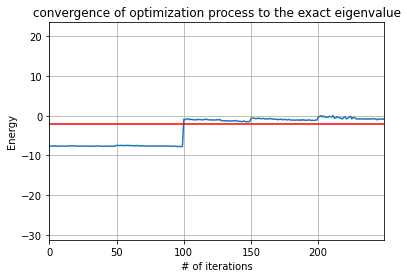

In [132]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [133]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

1it [00:00,  5.35it/s]

{'0111': 226, '1001': 7, '0001': 368, '1011': 189, '0010': 31, '0000': 49, '1100': 12, '0100': 23, '1111': 32, '0101': 6, '1010': 28, '1110': 12, '0011': 28, '1000': 9, '1101': 2, '0110': 2}
1.0


3it [00:00,  4.97it/s]

{'0010': 56, '1011': 156, '0000': 99, '1010': 51, '0001': 321, '0110': 127, '0100': 37, '1110': 58, '1001': 14, '0111': 81, '0011': 9, '1101': 4, '1100': 6, '0101': 4, '1111': 1}
1.0
{'0111': 112, '0011': 255, '1011': 73, '1001': 120, '0001': 128, '0101': 140, '0000': 59, '1101': 28, '1000': 30, '0110': 8, '0100': 23, '1111': 7, '0010': 10, '1100': 12, '1110': 18, '1010': 1}
1.0


4it [00:00,  5.27it/s]

{'0000': 43, '1011': 183, '1111': 28, '0111': 222, '0001': 357, '1010': 22, '0011': 40, '0101': 12, '0100': 24, '0010': 37, '1110': 21, '1001': 8, '1100': 12, '1000': 5, '0110': 5, '1101': 5}
1.0


6it [00:01,  5.09it/s]

{'0101': 147, '0111': 109, '0011': 147, '1111': 59, '0001': 209, '1010': 10, '1011': 167, '0100': 77, '0110': 27, '1100': 22, '1110': 22, '1001': 12, '0000': 7, '0010': 4, '1000': 2, '1101': 3}
1.0
{'1010': 31, '0001': 381, '1011': 179, '0111': 202, '0000': 56, '1000': 6, '0100': 25, '0011': 27, '1111': 36, '0010': 33, '0101': 20, '1001': 5, '1110': 9, '1101': 2, '0110': 5, '1100': 7}
1.0


8it [00:01,  5.57it/s]

{'0111': 245, '1010': 18, '0001': 357, '1011': 174, '0010': 30, '1101': 7, '1111': 40, '0011': 33, '1000': 5, '0101': 13, '0000': 56, '0110': 6, '1110': 7, '0100': 22, '1100': 9, '1001': 2}
1.0
{'1001': 191, '0001': 186, '1011': 180, '0000': 57, '0111': 174, '0101': 8, '1110': 4, '0100': 15, '1010': 33, '0110': 14, '1111': 77, '1000': 19, '1100': 23, '0010': 19, '0011': 24}
1.0


10it [00:01,  5.58it/s]

{'0000': 52, '0001': 370, '0011': 30, '1101': 5, '0100': 30, '1011': 193, '0111': 223, '1111': 33, '1010': 15, '0101': 10, '0110': 4, '1100': 10, '1000': 6, '0010': 27, '1110': 12, '1001': 4}
1.0
{'0111': 211, '1001': 7, '1010': 25, '0001': 353, '1011': 192, '0100': 44, '0000': 57, '0101': 10, '0010': 28, '1100': 10, '0011': 38, '1111': 35, '0110': 4, '1110': 7, '1000': 3}
1.0


11it [00:02,  5.38it/s]


{'1011': 171, '0001': 375, '1010': 29, '0111': 213, '0000': 58, '0101': 11, '1111': 37, '0011': 35, '1100': 11, '1110': 11, '0100': 30, '0010': 26, '1000': 5, '0110': 5, '1001': 4, '1101': 3}
1.0


1it [00:00,  4.67it/s]

{'1110': 67, '1000': 9, '0000': 255, '0100': 84, '1011': 99, '1010': 43, '0001': 180, '0111': 139, '0101': 5, '0011': 49, '1100': 41, '1101': 7, '0110': 24, '1111': 19, '0010': 1, '1001': 2}
1.0


2it [00:00,  4.65it/s]

{'0001': 333, '0000': 103, '1100': 7, '0011': 27, '1110': 70, '0110': 140, '1011': 142, '0010': 18, '0100': 69, '0101': 44, '0111': 21, '1101': 27, '1111': 9, '1000': 4, '1001': 8, '1010': 2}
1.0


4it [00:00,  4.90it/s]

{'0000': 75, '0011': 164, '1101': 32, '0100': 109, '1011': 51, '0101': 87, '1110': 67, '0001': 90, '1001': 45, '0010': 147, '1100': 25, '1000': 35, '0110': 30, '0111': 51, '1111': 4, '1010': 12}
1.0
{'0111': 121, '1110': 56, '0000': 233, '1010': 37, '0001': 200, '1011': 100, '0011': 44, '0110': 31, '1100': 42, '0100': 122, '1101': 7, '1111': 20, '1001': 1, '0010': 3, '1000': 7}
1.0


5it [00:00,  5.70it/s]

{'0011': 110, '0010': 12, '1011': 84, '0101': 70, '0100': 267, '0000': 72, '0111': 72, '0001': 127, '1100': 42, '1010': 41, '1111': 29, '0110': 25, '1110': 56, '1101': 12, '1001': 3, '1000': 2}
1.0
{'1110': 58, '0001': 196, '0111': 132, '1000': 13, '0000': 225, '1111': 23, '1011': 86, '1100': 40, '0011': 28, '0100': 126, '1010': 45, '0101': 1, '0010': 2, '0110': 40, '1001': 2, '1101': 7}
1.0


8it [00:01,  5.62it/s]

{'0111': 153, '1000': 11, '0000': 239, '1010': 34, '0001': 195, '1100': 31, '1011': 95, '0100': 94, '0010': 7, '1111': 20, '0110': 26, '0011': 40, '1110': 58, '1101': 14, '0101': 5, '1001': 2}
1.0
{'0110': 88, '1111': 56, '1010': 40, '0001': 69, '1001': 109, '1000': 110, '0000': 130, '0010': 14, '1100': 91, '1011': 140, '0111': 114, '0101': 10, '0100': 37, '1110': 11, '0011': 3, '1101': 2}
1.0


9it [00:01,  6.00it/s]

{'0111': 136, '0100': 100, '1101': 11, '0001': 202, '1010': 49, '0000': 225, '1011': 104, '1100': 48, '1110': 66, '1000': 10, '0011': 29, '1111': 16, '1001': 2, '0110': 19, '0010': 7}
1.0
{'0111': 138, '1010': 40, '0001': 223, '0100': 100, '0000': 250, '0011': 46, '1100': 38, '1111': 16, '0110': 24, '1110': 57, '1000': 12, '1011': 69, '1101': 5, '0010': 4, '1001': 1, '0101': 1}
1.0


11it [00:02,  5.37it/s]


{'1011': 91, '0111': 125, '1010': 54, '0001': 196, '1000': 15, '0000': 241, '0011': 47, '1110': 58, '1101': 11, '1111': 25, '0010': 5, '0110': 29, '0100': 96, '1100': 29, '1001': 2}
1.0


1it [00:00,  6.60it/s]

{'0010': 21, '1011': 144, '0111': 123, '1010': 15, '0001': 301, '0101': 171, '0000': 75, '0011': 111, '0110': 4, '1100': 5, '0100': 16, '1111': 9, '1101': 26, '1110': 3}
1.0


2it [00:00,  6.63it/s]

{'0001': 323, '0010': 93, '1011': 116, '0000': 74, '0110': 68, '1101': 19, '0100': 137, '0101': 35, '1010': 56, '1100': 11, '1110': 12, '0011': 24, '0111': 53, '1111': 2, '1001': 1}
1.0


3it [00:00,  6.68it/s]

{'0101': 179, '0011': 350, '0111': 114, '1010': 6, '1001': 87, '0010': 28, '1011': 75, '0000': 69, '0001': 38, '1101': 26, '0100': 5, '0110': 23, '1111': 2, '1100': 9, '1000': 9, '1110': 4}
1.0
{'0111': 95, '0110': 4, '1111': 12, '0011': 110, '0001': 311, '1011': 152, '0000': 87, '0101': 166, '0100': 20, '1100': 9, '1101': 16, '1000': 2, '1110': 5, '1010': 16, '0010': 18, '1001': 1}

4it [00:00,  5.88it/s]


1.0


6it [00:01,  5.46it/s]

{'0111': 201, '0001': 325, '1010': 8, '1011': 101, '0000': 16, '1100': 7, '0100': 80, '0101': 104, '1111': 84, '1101': 13, '0110': 18, '0010': 8, '0011': 37, '1110': 6, '1000': 6, '1001': 10}
1.0
{'0000': 81, '0101': 168, '0011': 106, '1011': 169, '1010': 14, '0001': 283, '0111': 113, '1101': 28, '0100': 24, '0110': 4, '1100': 16, '0010': 8, '1111': 6, '1001': 1, '1110': 2, '1000': 1}
1.0


7it [00:01,  5.63it/s]

{'0111': 130, '0010': 17, '1011': 165, '0101': 148, '0011': 92, '1010': 11, '0001': 323, '0000': 77, '0100': 19, '1101': 19, '1001': 1, '0110': 5, '1100': 6, '1110': 2, '1111': 8, '1000': 1}
1.0


8it [00:01,  5.29it/s]

{'1001': 162, '0001': 149, '0101': 93, '0010': 7, '0111': 100, '0011': 54, '0000': 50, '0100': 32, '1111': 28, '1011': 219, '1000': 40, '1101': 60, '1010': 23, '1110': 4, '0110': 3}
1.0


10it [00:01,  4.99it/s]

{'1010': 14, '0001': 304, '1011': 178, '0000': 77, '0101': 154, '0111': 95, '0011': 131, '0100': 19, '1111': 8, '0110': 8, '1110': 3, '1101': 11, '1100': 6, '0010': 13, '1000': 2, '1001': 1}
1.0
{'0001': 319, '0101': 146, '0011': 101, '0111': 104, '0000': 88, '0110': 7, '1101': 22, '1011': 153, '0100': 30, '1111': 12, '1100': 7, '1000': 1, '0010': 15, '1010': 17, '1110': 2}
1.0


11it [00:02,  5.44it/s]


{'0010': 16, '1011': 139, '0001': 306, '0101': 175, '1100': 8, '0011': 115, '0111': 102, '0000': 91, '1101': 22, '0100': 17, '0110': 6, '1010': 15, '1110': 6, '1001': 2, '1111': 4}
1.0


2it [00:00,  5.41it/s]

{'1001': 82, '0001': 218, '1010': 86, '1111': 73, '0000': 37, '1000': 37, '1011': 267, '1110': 21, '0010': 15, '0111': 136, '1100': 9, '0100': 9, '0011': 4, '1101': 10, '0101': 9, '0110': 11}
1.0
{'1011': 293, '1110': 77, '1000': 34, '0000': 64, '0001': 199, '1010': 56, '1001': 81, '0110': 116, '0111': 37, '0100': 15, '0011': 4, '1111': 9, '1101': 16, '0101': 8, '0010': 14, '1100': 1}
1.0


3it [00:00,  6.02it/s]

{'1001': 335, '0001': 94, '0011': 115, '1011': 27, '1000': 92, '0111': 100, '1111': 55, '1101': 34, '0000': 48, '1100': 41, '0101': 53, '0100': 13, '1110': 2, '0010': 11, '0110': 2, '1010': 2}
1.0


4it [00:00,  5.31it/s]

{'1001': 89, '1010': 69, '0001': 221, '1100': 14, '1111': 74, '1011': 275, '0111': 129, '0101': 12, '1110': 17, '0011': 8, '1000': 28, '1101': 7, '0100': 15, '0010': 15, '0000': 45, '0110': 6}
1.0


6it [00:01,  5.30it/s]

{'0101': 99, '0010': 10, '1011': 259, '0001': 115, '0011': 94, '1101': 68, '1111': 115, '0111': 61, '0000': 15, '1001': 17, '1110': 58, '1010': 24, '0100': 40, '1100': 29, '0110': 14, '1000': 6}
1.0
{'1011': 293, '0111': 130, '0101': 14, '1001': 85, '0001': 201, '1010': 67, '0011': 11, '0000': 43, '1110': 19, '1111': 68, '1000': 33, '0010': 15, '1101': 11, '0100': 14, '1100': 14, '0110': 6}
1.0
{'1011': 251, '1000': 33, '0000': 53, '0111': 153, '1111': 67, '0110': 9, '1001': 88, '0001': 196, '1010': 76, '0101': 17, '1110': 23, '0010': 19, '1100': 18, '0100': 7, '0011': 9, '1101': 5}
1.0
{'0001': 149, '1010': 62, '1001': 132, '0010': 35, '1011': 192, '0011': 101, '0111': 109, '1000': 46, '0000': 27, '1111': 104, '0100': 19, '1101': 18, '1110': 11, '0110': 10, '0101': 2, '1100': 7}
1.0


10it [00:01,  6.23it/s]

{'0111': 166, '0001': 215, '1001': 71, '1010': 69, '0000': 37, '1110': 17, '0101': 12, '1011': 306, '1101': 8, '1000': 21, '1111': 61, '0110': 10, '0100': 6, '1100': 12, '0010': 10, '0011': 3}
1.0
{'0000': 44, '0111': 154, '1001': 85, '1010': 65, '0001': 208, '1111': 72, '1011': 281, '0101': 15, '1100': 10, '1000': 18, '0010': 20, '0011': 8, '1110': 19, '0100': 8, '1101': 11, '0110': 6}
1.0


11it [00:01,  5.70it/s]


{'0000': 51, '1011': 262, '1010': 73, '0001': 240, '0111': 139, '1111': 80, '0110': 8, '0100': 9, '1110': 16, '1001': 82, '0010': 11, '1000': 24, '1100': 8, '1101': 7, '0011': 9, '0101': 5}
1.0


2it [00:00,  4.91it/s]

{'1011': 255, '1110': 22, '0101': 47, '0111': 190, '0000': 57, '1000': 43, '1001': 49, '0001': 200, '0011': 25, '1010': 80, '0110': 24, '1101': 19, '0100': 6, '1111': 3, '0010': 4}
1.0
{'1010': 46, '0001': 163, '0101': 31, '1111': 8, '0110': 156, '1011': 281, '0111': 56, '0000': 129, '1000': 20, '1001': 43, '1110': 20, '0011': 17, '1100': 8, '0100': 18, '0010': 27, '1101': 1}
1.0


4it [00:00,  5.40it/s]

{'0010': 14, '1011': 83, '1001': 218, '1100': 6, '0011': 188, '0111': 203, '1000': 86, '0110': 20, '0001': 92, '0100': 17, '0000': 57, '0101': 22, '1111': 5, '1110': 11, '1010': 2}
1.0
{'1001': 54, '1010': 61, '0001': 201, '0010': 15, '1011': 249, '0111': 211, '0101': 50, '0000': 69, '1000': 39, '0110': 16, '1101': 15, '0011': 26, '0100': 4, '1110': 13, '1111': 1}
1.0


6it [00:01,  5.61it/s]

{'0111': 194, '1110': 45, '0101': 223, '1010': 33, '1111': 117, '0110': 42, '1011': 154, '0011': 48, '0100': 21, '0001': 31, '1000': 19, '1001': 9, '0000': 36, '1101': 40, '1100': 8, '0010': 4}
1.0
{'0110': 18, '1011': 260, '0111': 207, '1010': 54, '1001': 37, '0001': 233, '1110': 20, '1000': 36, '0000': 64, '0011': 24, '0101': 34, '1101': 20, '0010': 10, '1111': 2, '0100': 5}
1.0


8it [00:01,  5.98it/s]

{'1011': 252, '0001': 218, '1010': 67, '0100': 6, '0101': 51, '0110': 22, '0111': 198, '1000': 19, '0010': 14, '0000': 61, '1110': 26, '1001': 46, '1101': 20, '0011': 22, '1111': 2}
1.0
{'1111': 114, '1100': 5, '0011': 192, '1001': 106, '0001': 152, '1011': 62, '1101': 14, '0111': 104, '0000': 75, '1010': 48, '0010': 31, '0101': 35, '0110': 38, '1110': 13, '1000': 32, '0100': 3}
1.0


9it [00:01,  6.10it/s]

{'1010': 65, '0001': 218, '0010': 14, '1011': 265, '0000': 66, '1000': 48, '1101': 8, '0111': 204, '1110': 19, '0101': 45, '1001': 30, '0100': 3, '0011': 19, '0110': 19, '1111': 1}
1.0


11it [00:01,  5.58it/s]


{'1001': 39, '1010': 59, '0001': 223, '1011': 256, '0101': 51, '1000': 41, '0000': 61, '0111': 184, '1101': 10, '0011': 32, '1110': 23, '0110': 33, '0010': 9, '0100': 2, '1111': 1}
1.0
{'1110': 19, '1011': 247, '0111': 201, '1001': 42, '0001': 231, '1010': 63, '1101': 19, '0011': 23, '0101': 45, '0110': 19, '0000': 63, '1000': 36, '0010': 10, '0100': 4, '1111': 2}
1.0


2it [00:00,  6.10it/s]

{'1010': 80, '1001': 119, '0001': 228, '1011': 276, '1110': 62, '0101': 14, '0111': 130, '0100': 6, '0010': 25, '1101': 2, '0000': 22, '1111': 46, '1000': 5, '0110': 5, '0011': 2, '1100': 2}
1.0
{'1110': 76, '0111': 43, '0000': 162, '1011': 229, '0010': 15, '0001': 90, '1001': 57, '1111': 63, '1010': 86, '0110': 77, '1000': 73, '0011': 20, '0100': 27, '1101': 6}
1.0


4it [00:00,  5.53it/s]

{'0010': 55, '0011': 113, '0000': 14, '0001': 129, '1001': 339, '1110': 22, '0111': 86, '1101': 31, '1000': 52, '0100': 18, '0101': 43, '1010': 29, '1100': 39, '0110': 7, '1111': 25, '1011': 22}
1.0
{'0010': 27, '1011': 260, '1010': 73, '1001': 109, '1110': 63, '0110': 15, '0100': 13, '0111': 143, '0101': 14, '0001': 220, '1111': 55, '1100': 4, '0000': 17, '0011': 3, '1101': 2, '1000': 6}
1.0


6it [00:01,  5.77it/s]

{'0001': 138, '1101': 68, '0100': 27, '0101': 116, '0110': 35, '1111': 95, '1011': 226, '0011': 74, '1110': 106, '1001': 51, '1010': 12, '1100': 12, '0111': 50, '0010': 4, '0000': 7, '1000': 3}
1.0
{'1011': 270, '0111': 115, '1010': 61, '1001': 126, '0001': 223, '1111': 67, '0100': 13, '1110': 52, '0000': 28, '0010': 30, '0101': 14, '1000': 7, '1101': 3, '1100': 2, '0011': 7, '0110': 6}
1.0


7it [00:01,  5.55it/s]

{'1010': 57, '1001': 99, '0001': 244, '0010': 28, '1011': 263, '0111': 136, '1110': 54, '1111': 59, '0101': 15, '0100': 11, '0000': 36, '1101': 5, '0011': 6, '1000': 4, '0110': 5, '1100': 2}
1.0


8it [00:01,  5.15it/s]

{'0111': 109, '0110': 18, '1111': 94, '1001': 137, '1010': 90, '0001': 204, '1011': 159, '1110': 40, '0010': 11, '0100': 9, '0000': 16, '1101': 13, '0011': 102, '1100': 5, '1000': 10, '0101': 7}
1.0
{'1010': 65, '1001': 108, '0001': 254, '1011': 248, '0111': 132, '1110': 59, '0101': 13, '1111': 48, '0100': 13, '0010': 37, '0011': 6, '1000': 9, '0110': 8, '0000': 21, '1101': 1, '1100': 2}
1.0


11it [00:02,  5.33it/s]

{'0001': 246, '1010': 80, '1001': 93, '1111': 62, '0111': 131, '1011': 246, '1110': 69, '1000': 3, '0100': 10, '1100': 3, '0010': 22, '0110': 7, '0101': 16, '0011': 2, '1101': 2, '0000': 32}
1.0
{'1010': 77, '1001': 125, '0001': 221, '0010': 21, '1011': 285, '0101': 25, '0110': 8, '0111': 110, '1111': 53, '1110': 56, '0011': 4, '0000': 25, '1000': 3, '1100': 3, '0100': 8}
1.0


11it [00:02,  5.44it/s]
2it [00:00,  5.10it/s]

{'1010': 30, '0001': 148, '1110': 52, '0101': 32, '1011': 221, '1111': 130, '0011': 35, '0111': 131, '0010': 39, '1001': 116, '1101': 15, '0110': 24, '0000': 27, '1100': 14, '1000': 5, '0100': 5}
1.0
{'1001': 69, '1010': 59, '1100': 19, '0011': 53, '1111': 110, '0101': 21, '1011': 180, '1000': 47, '1110': 80, '1101': 16, '0000': 157, '0110': 81, '0111': 41, '0001': 55, '0010': 22, '0100': 14}
1.0


3it [00:00,  5.62it/s]

{'0101': 17, '0001': 126, '1001': 290, '0010': 51, '1101': 94, '0110': 9, '1111': 52, '0111': 133, '0000': 6, '0011': 98, '1011': 19, '1100': 55, '1010': 5, '1000': 33, '1110': 12, '0100': 24}
1.0


5it [00:00,  5.08it/s]

{'1011': 211, '1111': 120, '0111': 136, '0001': 166, '1001': 113, '0000': 27, '1110': 51, '0011': 35, '0110': 25, '0010': 32, '0101': 33, '1010': 42, '1101': 15, '1100': 10, '0100': 2, '1000': 6}
1.0
{'1011': 163, '1001': 108, '0011': 145, '0111': 13, '0110': 63, '1111': 172, '0101': 162, '0000': 17, '0001': 57, '1010': 8, '1110': 53, '1100': 28, '0100': 8, '1101': 27}
1.0


7it [00:01,  5.60it/s]

{'0111': 135, '1010': 29, '1001': 114, '0001': 179, '1111': 119, '0010': 38, '1011': 194, '0011': 31, '1000': 11, '1100': 11, '0110': 27, '0101': 22, '1110': 64, '0100': 2, '0000': 30, '1101': 18}
1.0
{'1001': 113, '0001': 160, '0111': 118, '0010': 34, '1011': 216, '1111': 133, '1100': 12, '1110': 53, '0000': 24, '0101': 33, '1010': 41, '0110': 28, '0011': 28, '1101': 17, '1000': 13, '0100': 1}
1.0


9it [00:01,  5.43it/s]

{'1010': 66, '0001': 198, '1001': 111, '1011': 198, '0101': 35, '0110': 24, '1111': 87, '0111': 161, '1100': 9, '0011': 33, '1110': 49, '0000': 30, '1101': 13, '0100': 6, '1000': 2, '0010': 2}
1.0
{'1001': 120, '0001': 188, '0101': 30, '1110': 56, '0111': 115, '1111': 118, '0110': 31, '1011': 205, '1010': 30, '0000': 29, '0011': 32, '1101': 17, '0010': 29, '1100': 18, '1000': 6}
1.0


10it [00:01,  5.28it/s]

{'0101': 30, '1110': 65, '0000': 26, '1111': 117, '0001': 165, '0011': 43, '0111': 126, '1101': 16, '1011': 214, '1001': 107, '1010': 28, '0110': 23, '1000': 6, '0010': 42, '1100': 14, '0100': 2}
1.0


11it [00:02,  5.11it/s]


{'1010': 26, '0001': 167, '0101': 38, '1111': 118, '1000': 11, '1011': 233, '0010': 32, '0111': 131, '1110': 55, '0011': 25, '1001': 112, '1101': 24, '0000': 23, '0110': 18, '1100': 9, '0100': 2}
1.0


2it [00:00,  5.49it/s]

{'0111': 112, '0001': 194, '1001': 118, '0101': 29, '0010': 43, '1101': 19, '1111': 119, '0110': 29, '1011': 202, '0000': 25, '1110': 51, '0011': 27, '1000': 6, '1010': 33, '1100': 16, '0100': 1}
1.0
{'0011': 48, '1100': 18, '1111': 65, '0110': 116, '1011': 196, '1010': 61, '1000': 37, '0000': 136, '1001': 71, '0010': 23, '0001': 57, '0111': 43, '1110': 102, '0101': 24, '0100': 13, '1101': 14}
1.0


3it [00:00,  5.79it/s]

{'1100': 41, '0011': 99, '1001': 316, '0001': 93, '1000': 49, '0000': 8, '1111': 49, '1101': 107, '1110': 17, '0111': 130, '0010': 59, '0100': 18, '1010': 4, '0110': 9, '0101': 17, '1011': 8}
1.0


4it [00:00,  5.19it/s]

{'0001': 175, '0011': 36, '1100': 11, '1011': 204, '0000': 20, '1111': 127, '0101': 35, '0111': 121, '1001': 110, '0010': 43, '0110': 14, '1000': 8, '1110': 57, '0100': 4, '1010': 39, '1101': 20}
1.0


6it [00:01,  5.39it/s]

{'1111': 151, '0110': 63, '0011': 138, '0000': 17, '0101': 167, '1110': 68, '1011': 171, '0111': 22, '0100': 14, '1001': 107, '1100': 21, '1101': 16, '0001': 56, '1010': 13}
1.0
{'0010': 35, '1110': 50, '0101': 31, '0111': 129, '1010': 36, '1001': 95, '0001': 178, '1100': 13, '0000': 28, '1011': 210, '1101': 24, '1111': 136, '0011': 26, '0110': 22, '1000': 10, '0100': 1}
1.0


8it [00:01,  5.08it/s]

{'1010': 40, '1001': 111, '0001': 186, '1111': 127, '0111': 119, '1011': 215, '0000': 20, '1110': 47, '0010': 52, '0101': 25, '1101': 9, '0110': 19, '1100': 11, '0011': 32, '1000': 10, '0100': 1}
1.0
{'1011': 191, '1001': 108, '0001': 183, '0111': 160, '1110': 43, '0101': 28, '0011': 41, '1111': 111, '0110': 28, '1101': 8, '1010': 61, '0000': 42, '1100': 13, '1000': 4, '0100': 3}
1.0


10it [00:01,  5.41it/s]

{'1111': 124, '1011': 224, '1110': 41, '0101': 42, '0111': 109, '1101': 28, '1100': 16, '0001': 175, '0010': 47, '0110': 26, '0011': 39, '1001': 90, '1010': 29, '1000': 7, '0000': 26, '0100': 1}
1.0
{'1011': 200, '0001': 177, '1001': 112, '0011': 45, '0110': 30, '1111': 105, '1110': 54, '0101': 30, '0111': 126, '0000': 32, '1010': 46, '1000': 6, '1100': 17, '0010': 28, '1101': 11, '0100': 5}
1.0


11it [00:02,  5.10it/s]


{'0111': 118, '1111': 134, '0110': 29, '0011': 44, '1011': 211, '0001': 167, '1001': 100, '1101': 17, '0010': 36, '1110': 50, '0101': 32, '1010': 32, '0000': 34, '1000': 7, '1100': 12, '0100': 1}
1.0


1it [00:00,  6.10it/s]

{'1011': 211, '0111': 128, '1001': 105, '0001': 207, '1111': 125, '0110': 26, '0101': 20, '0011': 32, '0010': 20, '1101': 8, '0000': 32, '1010': 32, '1110': 59, '1000': 12, '1100': 6, '0100': 1}
1.0


2it [00:00,  5.51it/s]

{'0010': 22, '1011': 165, '1001': 58, '0001': 73, '1111': 91, '0110': 79, '0000': 167, '1101': 6, '0011': 42, '1110': 104, '0111': 46, '1010': 71, '0101': 21, '1000': 53, '1100': 16, '0100': 10}
1.0


3it [00:00,  5.69it/s]

{'0001': 116, '1001': 296, '1101': 80, '1011': 24, '0010': 51, '0111': 146, '1100': 41, '0011': 114, '1111': 50, '1000': 37, '0100': 22, '1010': 2, '0101': 26, '1110': 10, '0000': 6, '0110': 3}
1.0


4it [00:00,  6.35it/s]

{'0001': 183, '1001': 115, '1111': 127, '0010': 38, '1011': 229, '1110': 52, '0111': 107, '0000': 21, '0101': 36, '0011': 24, '0100': 6, '1100': 10, '1101': 9, '1000': 11, '1010': 27, '0110': 29}
1.0


5it [00:00,  6.65it/s]

{'1011': 165, '0110': 55, '1111': 171, '0101': 169, '1110': 65, '0011': 130, '1101': 18, '1001': 115, '0100': 19, '1010': 16, '0001': 34, '1100': 18, '0111': 22, '0000': 26, '0010': 1}
1.0


6it [00:00,  6.60it/s]

{'1111': 136, '0100': 2, '0111': 122, '1110': 44, '1001': 121, '1011': 221, '0011': 27, '1000': 4, '1101': 12, '0001': 187, '0000': 29, '1010': 26, '1100': 10, '0010': 30, '0110': 22, '0101': 31}
1.0
{'0111': 115, '1011': 207, '1111': 112, '1001': 97, '0001': 196, '0011': 27, '0101': 38, '0000': 39, '1110': 63, '0110': 20, '1000': 5, '1010': 37, '1100': 11, '0010': 44, '1101': 10, '0100': 3}

8it [00:01,  5.90it/s]


1.0
{'0110': 36, '1111': 78, '1001': 126, '0001': 178, '1110': 54, '0000': 37, '0111': 153, '1011': 191, '0011': 44, '1010': 55, '1101': 10, '1100': 12, '0100': 3, '1000': 7, '0101': 38, '0010': 2}
1.0


10it [00:01,  6.24it/s]

{'1001': 107, '0001': 195, '1011': 216, '1110': 46, '0110': 20, '1111': 142, '0111': 117, '0011': 33, '0101': 39, '1000': 10, '1010': 23, '0010': 32, '0000': 21, '0100': 2, '1101': 9, '1100': 12}
1.0
{'0110': 28, '0010': 35, '1011': 229, '0001': 205, '1001': 113, '0111': 109, '1110': 51, '1000': 10, '0101': 24, '0011': 25, '1111': 126, '1010': 21, '1100': 8, '0000': 28, '1101': 9, '0100': 3}
1.0


11it [00:01,  6.15it/s]


{'0010': 36, '1011': 213, '1100': 14, '1111': 123, '0000': 31, '0111': 127, '1110': 55, '0001': 179, '1001': 120, '0011': 23, '0110': 25, '1010': 33, '1000': 4, '0100': 3, '1101': 7, '0101': 31}
1.0


2it [00:00,  5.66it/s]

{'0101': 49, '1100': 52, '0001': 181, '0000': 23, '1000': 60, '1011': 238, '0111': 135, '1111': 95, '0010': 23, '1001': 97, '0011': 29, '1110': 22, '0100': 8, '0110': 5, '1010': 2, '1101': 5}
1.0
{'0000': 159, '1000': 93, '1011': 149, '1100': 17, '0011': 55, '0110': 90, '1110': 105, '1101': 54, '1010': 102, '1111': 32, '0001': 42, '1001': 38, '0100': 45, '0111': 32, '0101': 10, '0010': 1}
1.0


3it [00:00,  5.80it/s]

{'1000': 39, '1010': 28, '1001': 297, '0011': 121, '1110': 62, '1111': 65, '1101': 76, '0111': 153, '0001': 81, '0110': 11, '1011': 12, '0101': 22, '0000': 29, '0010': 23, '1100': 5}
1.0


5it [00:00,  5.60it/s]

{'0011': 43, '1100': 57, '1011': 195, '0010': 23, '1111': 103, '0111': 150, '0001': 162, '0100': 9, '1001': 107, '1000': 54, '0000': 36, '1101': 7, '1010': 9, '1110': 17, '0101': 46, '0110': 6}
1.0
{'1011': 201, '1100': 106, '0011': 128, '0101': 150, '1001': 86, '0001': 65, '1111': 160, '0100': 22, '0111': 20, '1101': 34, '1010': 13, '1110': 13, '0010': 8, '0110': 15, '0000': 3}
1.0


6it [00:01,  5.89it/s]

{'0111': 158, '0010': 22, '1011': 201, '0101': 45, '1000': 42, '1111': 133, '1100': 46, '0001': 175, '0000': 25, '1001': 109, '0100': 4, '1110': 14, '0011': 33, '0110': 1, '1010': 10, '1101': 6}
1.0
{'1111': 125, '0001': 193, '1001': 101, '0010': 20, '1011': 205, '0111': 140, '1100': 53, '0000': 25, '0101': 41, '1110': 22, '0110': 4, '1000': 39, '0011': 36, '1101': 9, '1010': 5, '0100': 6}
1.0


9it [00:01,  5.42it/s]

{'1111': 128, '0101': 57, '1110': 28, '1001': 156, '0001': 129, '1011': 197, '0100': 29, '1000': 24, '0111': 117, '0000': 63, '1100': 19, '0011': 37, '0010': 14, '1010': 11, '0110': 7, '1101': 8}
1.0
{'0001': 182, '1001': 100, '1111': 118, '1011': 200, '0011': 41, '1100': 58, '0111': 134, '1000': 53, '0000': 24, '0101': 45, '0110': 7, '0010': 18, '1110': 26, '1010': 5, '0100': 5, '1101': 8}
1.0


10it [00:01,  6.01it/s]

{'1011': 204, '0010': 18, '0011': 41, '1001': 113, '1111': 123, '0000': 27, '0101': 48, '0111': 129, '0001': 172, '1000': 49, '1100': 53, '1110': 17, '0110': 9, '1010': 6, '1101': 8, '0100': 7}
1.0


11it [00:02,  5.50it/s]


{'0011': 41, '0111': 135, '1000': 47, '1101': 13, '1011': 209, '1001': 114, '0001': 161, '1111': 139, '1110': 25, '0101': 42, '1100': 41, '0000': 21, '0010': 13, '0100': 5, '0110': 8, '1010': 10}
1.0


1it [00:00,  3.81it/s]

{'1001': 122, '0001': 269, '1101': 84, '0111': 77, '0010': 30, '1011': 180, '1100': 25, '1110': 36, '1111': 34, '1000': 70, '0000': 25, '0011': 37, '0110': 10, '0101': 9, '0100': 7, '1010': 9}
1.0


3it [00:00,  4.93it/s]

{'0000': 208, '1000': 167, '0100': 12, '1011': 147, '1100': 60, '0011': 56, '0111': 58, '1111': 28, '1101': 61, '1010': 61, '0110': 38, '0001': 55, '1001': 8, '1110': 58, '0101': 7}
1.0
{'1010': 50, '0001': 140, '1001': 280, '1111': 101, '0011': 154, '0111': 87, '1110': 51, '0010': 35, '1101': 30, '1011': 21, '0000': 19, '1000': 23, '0110': 16, '0101': 8, '0100': 1, '1100': 8}
1.0


5it [00:01,  5.11it/s]

{'1000': 58, '0001': 279, '1001': 118, '0111': 78, '0011': 34, '1011': 172, '1101': 94, '0101': 12, '1111': 48, '1110': 33, '1100': 26, '1010': 12, '0010': 27, '0000': 20, '0110': 6, '0100': 7}
1.0
{'1100': 74, '0011': 108, '0001': 167, '1001': 188, '0101': 123, '1011': 72, '1000': 15, '1111': 142, '0100': 30, '1110': 30, '1010': 11, '1101': 17, '0010': 18, '0000': 5, '0111': 11, '0110': 13}
1.0


7it [00:01,  5.46it/s]

{'1101': 90, '1100': 27, '0011': 42, '0001': 268, '1001': 110, '1011': 170, '1000': 67, '0111': 70, '1111': 48, '0000': 27, '1010': 9, '0010': 26, '0101': 19, '1110': 35, '0100': 10, '0110': 6}
1.0
{'1001': 112, '0001': 271, '0111': 86, '1000': 53, '0000': 34, '1011': 166, '1101': 109, '1110': 41, '1111': 48, '0100': 6, '1100': 21, '0011': 26, '0101': 16, '0010': 18, '1010': 9, '0110': 8}
1.0


9it [00:01,  4.99it/s]

{'0110': 25, '0101': 86, '1011': 160, '0111': 38, '0001': 208, '1001': 191, '0100': 22, '0011': 37, '1101': 34, '1100': 11, '0000': 57, '1010': 27, '1110': 12, '1111': 85, '1000': 30, '0010': 1}
1.0
{'0001': 233, '1001': 137, '1111': 63, '1101': 107, '0011': 34, '0111': 77, '1000': 56, '1110': 29, '1100': 22, '1011': 176, '1010': 8, '0110': 6, '0000': 37, '0010': 26, '0101': 8, '0100': 5}
1.0


11it [00:02,  5.27it/s]


{'0010': 21, '1011': 183, '0000': 33, '1000': 59, '0001': 253, '1001': 127, '0111': 86, '1101': 96, '0011': 39, '1010': 12, '1111': 38, '0101': 11, '1110': 33, '1100': 21, '0100': 6, '0110': 6}
1.0
{'1011': 190, '1001': 108, '0001': 289, '1000': 56, '1101': 91, '1111': 35, '1100': 23, '0111': 76, '0101': 12, '0110': 3, '0011': 29, '1110': 36, '0000': 33, '0010': 24, '0100': 7, '1010': 12}
1.0


2it [00:00,  5.59it/s]

{'1011': 132, '0000': 58, '1010': 14, '0001': 233, '1001': 96, '0111': 167, '0011': 118, '0110': 15, '0101': 29, '0100': 8, '1111': 73, '1101': 5, '1100': 19, '1000': 26, '1110': 20, '0010': 11}
1.0
{'0000': 202, '1000': 110, '1011': 82, '0001': 79, '1010': 70, '1111': 40, '0110': 134, '0011': 95, '1110': 53, '0111': 43, '0010': 33, '0100': 40, '0101': 6, '1001': 16, '1101': 21}
1.0


4it [00:00,  6.00it/s]

{'1001': 165, '0001': 260, '0011': 82, '1101': 70, '1011': 40, '0010': 57, '1000': 52, '0110': 31, '0111': 165, '1110': 30, '0000': 13, '0101': 32, '1111': 17, '1100': 5, '1010': 4, '0100': 1}
1.0
{'1011': 126, '0111': 155, '0011': 113, '0001': 229, '1001': 123, '1111': 64, '0110': 13, '1000': 25, '1101': 6, '0100': 25, '1110': 16, '0000': 60, '1100': 18, '1010': 12, '0101': 27, '0010': 12}
1.0


6it [00:01,  6.09it/s]

{'1101': 41, '0100': 65, '1100': 37, '0011': 267, '1111': 149, '0101': 156, '1010': 27, '0001': 108, '1001': 76, '0000': 16, '0110': 19, '0010': 2, '1110': 7, '1011': 46, '0111': 6, '1000': 2}
1.0
{'1000': 30, '0000': 75, '0001': 219, '1001': 98, '1110': 23, '1100': 11, '0011': 116, '1011': 145, '1111': 63, '0111': 154, '0101': 33, '0110': 20, '0100': 11, '1010': 14, '1101': 6, '0010': 6}
1.0


8it [00:01,  6.70it/s]

{'0001': 216, '1001': 102, '0011': 107, '1011': 145, '1101': 10, '0100': 20, '1111': 59, '0111': 176, '1100': 12, '1110': 24, '0010': 9, '1000': 28, '0000': 61, '0101': 33, '1010': 11, '0110': 11}
1.0
{'1001': 92, '0001': 249, '0010': 15, '1011': 250, '0111': 172, '1000': 52, '1110': 23, '1111': 48, '1101': 25, '0000': 47, '1010': 12, '0100': 18, '1100': 4, '0101': 8, '0110': 9}
1.0


10it [00:01,  7.60it/s]

{'1001': 118, '0001': 232, '1111': 69, '1011': 124, '0011': 104, '0000': 59, '0111': 173, '0101': 24, '1110': 21, '1100': 17, '0110': 16, '0100': 16, '1000': 27, '1101': 8, '0010': 11, '1010': 5}
1.0
{'1010': 11, '1001': 111, '0001': 238, '1011': 121, '1111': 64, '0111': 140, '1110': 26, '0011': 129, '0000': 70, '0101': 26, '1100': 15, '0010': 10, '0100': 11, '1101': 10, '1000': 25, '0110': 17}
1.0


11it [00:01,  6.56it/s]


{'0000': 57, '1000': 24, '0001': 251, '1111': 89, '0111': 166, '1011': 109, '0100': 15, '0011': 114, '1110': 20, '1101': 5, '1001': 84, '1100': 20, '1010': 9, '0010': 12, '0101': 34, '0110': 15}
1.0


1it [00:00,  9.52it/s]

{'0101': 117, '1010': 24, '0001': 278, '0111': 92, '1011': 201, '1111': 73, '0000': 59, '1000': 40, '1110': 21, '1100': 22, '1001': 39, '0011': 4, '0110': 19, '1101': 19, '0100': 3, '0010': 13}
1.0


2it [00:00,  8.49it/s]

{'1011': 120, '1000': 88, '0000': 289, '0101': 75, '1110': 66, '1010': 89, '0111': 33, '0110': 60, '0001': 41, '0011': 18, '1100': 44, '0100': 39, '1001': 10, '1111': 41, '0010': 7, '1101': 4}
1.0


3it [00:00,  7.93it/s]

{'0111': 157, '1111': 84, '0011': 172, '1011': 39, '0010': 14, '0001': 98, '1001': 243, '1101': 21, '0101': 42, '1000': 49, '1110': 39, '0000': 46, '0100': 12, '1010': 8}
1.0


4it [00:00,  6.87it/s]

{'0010': 16, '1011': 185, '1000': 51, '0000': 55, '0001': 298, '0111': 89, '0101': 109, '0110': 7, '1111': 80, '1110': 22, '1001': 40, '1100': 26, '1010': 16, '1101': 22, '0100': 6, '0011': 2}
1.0


5it [00:00,  6.99it/s]

{'0101': 360, '0011': 36, '1100': 61, '1011': 79, '0000': 50, '1111': 237, '1001': 25, '1101': 43, '0001': 8, '0111': 46, '1010': 33, '0110': 7, '0010': 19, '0100': 12, '1000': 4, '1110': 4}
1.0


6it [00:00,  6.66it/s]

{'1110': 26, '0101': 119, '0001': 271, '1111': 89, '1000': 37, '0000': 59, '1011': 190, '0100': 7, '1101': 17, '0111': 94, '0110': 12, '1001': 34, '1100': 32, '0010': 15, '1010': 20, '0011': 2}
1.0


7it [00:00,  6.95it/s]

{'0001': 243, '1111': 77, '0010': 19, '1011': 231, '1110': 21, '0101': 123, '0111': 89, '1000': 48, '1100': 23, '0000': 44, '1010': 24, '1001': 35, '1101': 23, '0110': 19, '0011': 3, '0100': 2}
1.0


9it [00:01,  5.31it/s]

{'1001': 159, '0001': 171, '0111': 150, '1100': 20, '0011': 113, '0101': 117, '0010': 34, '1011': 102, '0110': 27, '1111': 12, '1101': 19, '1000': 19, '0000': 69, '1010': 4, '0100': 7, '1110': 1}
1.0
{'1001': 33, '0001': 293, '1010': 22, '1110': 20, '1011': 207, '1101': 15, '0111': 80, '1111': 90, '0010': 18, '0101': 119, '1100': 24, '0000': 43, '1000': 41, '0011': 5, '0110': 10, '0100': 4}
1.0


10it [00:01,  5.65it/s]

{'1010': 16, '0001': 248, '0111': 101, '0101': 127, '1110': 25, '1011': 209, '1111': 93, '0110': 5, '0000': 46, '1000': 41, '1001': 51, '1100': 18, '0010': 24, '0100': 2, '0011': 5, '1101': 13}
1.0


11it [00:01,  6.03it/s]


{'1011': 224, '0101': 105, '0110': 15, '1111': 80, '0001': 256, '1100': 20, '0111': 82, '0000': 59, '1000': 51, '1101': 19, '1001': 36, '0010': 21, '1110': 22, '1010': 25, '0100': 2, '0011': 7}
1.0


0it [00:00, ?it/s]

{'0011': 35, '1011': 237, '0010': 35, '0001': 146, '1111': 109, '1000': 34, '0111': 121, '1101': 8, '1001': 107, '0000': 43, '0101': 54, '0100': 9, '1100': 49, '1110': 30, '0110': 6, '1010': 1}
1.0


2it [00:00,  6.80it/s]

{'0000': 170, '1000': 120, '1101': 51, '1011': 138, '1010': 113, '0001': 24, '0110': 77, '1111': 92, '1001': 14, '0100': 55, '1110': 37, '0111': 57, '0011': 50, '0101': 15, '1100': 8, '0010': 3}
1.0


3it [00:00,  7.13it/s]

{'0011': 116, '0101': 19, '1110': 67, '0001': 70, '1001': 339, '0111': 151, '0000': 35, '1111': 61, '1100': 16, '0110': 22, '0010': 37, '1000': 16, '1101': 37, '1010': 20, '1011': 17, '0100': 1}
1.0


4it [00:00,  6.72it/s]

{'0001': 171, '1001': 90, '0010': 42, '1011': 228, '1111': 119, '0111': 133, '1000': 34, '1100': 53, '0011': 26, '1101': 10, '0000': 38, '0100': 15, '1110': 21, '0101': 39, '0110': 5}
1.0


5it [00:00,  6.33it/s]

{'0110': 32, '1111': 168, '0101': 127, '1011': 191, '0100': 45, '1010': 12, '1001': 85, '0001': 56, '0010': 16, '0011': 158, '0111': 15, '1100': 80, '1101': 12, '1110': 18, '0000': 7, '1000': 2}
1.0


6it [00:00,  6.48it/s]

{'1111': 110, '0111': 128, '1001': 88, '0001': 148, '1011': 244, '0010': 42, '1110': 26, '0000': 36, '1000': 42, '0011': 26, '0101': 51, '1101': 15, '1100': 44, '0110': 3, '0100': 20, '1010': 1}
1.0


7it [00:01,  6.81it/s]

{'0001': 150, '1001': 93, '1111': 89, '0000': 38, '1000': 44, '1011': 248, '0010': 41, '0111': 155, '1100': 46, '0011': 25, '0101': 41, '0110': 7, '1110': 26, '1101': 14, '0100': 6, '1010': 1}
1.0


8it [00:01,  7.17it/s]

{'1001': 117, '0101': 47, '1111': 92, '0111': 151, '1100': 32, '0011': 42, '1011': 231, '0010': 11, '0001': 140, '0110': 5, '0000': 62, '0100': 28, '1000': 13, '1010': 20, '1101': 6, '1110': 27}
1.0


9it [00:01,  6.82it/s]

{'0111': 139, '0101': 54, '1110': 31, '0001': 136, '1001': 92, '1011': 249, '1100': 59, '0000': 34, '1111': 98, '0010': 35, '0100': 16, '1101': 10, '1000': 34, '0011': 32, '0110': 5}
1.0


10it [00:01,  6.83it/s]

{'1001': 91, '0001': 159, '0101': 47, '1110': 26, '0111': 125, '1011': 251, '1000': 35, '1111': 113, '0110': 9, '1100': 50, '0010': 37, '0000': 39, '0011': 22, '1101': 11, '0100': 7, '1010': 2}
1.0


11it [00:01,  6.85it/s]


{'1111': 124, '0111': 112, '0001': 151, '0101': 47, '1110': 22, '1011': 232, '1000': 32, '1100': 59, '1001': 93, '0100': 8, '0000': 40, '0011': 34, '0010': 45, '1101': 14, '0110': 10, '1010': 1}
1.0


1it [00:00,  7.30it/s]

{'0111': 111, '1011': 238, '1110': 34, '1001': 119, '1010': 7, '0001': 195, '1100': 17, '1111': 94, '0101': 19, '1101': 44, '0000': 43, '1000': 30, '0011': 57, '0010': 7, '0110': 8, '0100': 1}
1.0


2it [00:00,  6.86it/s]

{'0110': 109, '0000': 198, '1010': 76, '0010': 14, '1011': 153, '1110': 66, '0100': 10, '1101': 66, '1000': 122, '1001': 23, '0001': 55, '1111': 41, '1100': 4, '0011': 56, '0111': 25, '0101': 6}
1.0


3it [00:00,  6.56it/s]

{'1100': 24, '0011': 58, '0111': 108, '1001': 287, '0001': 198, '1101': 116, '1011': 48, '1110': 39, '1000': 35, '0010': 45, '0101': 34, '0110': 6, '1010': 10, '0000': 10, '0100': 6}
1.0


4it [00:00,  6.32it/s]

{'1100': 25, '1101': 45, '1001': 95, '0001': 203, '1110': 28, '1111': 63, '1011': 224, '1000': 38, '1010': 14, '0111': 126, '0000': 48, '0011': 80, '0101': 18, '0010': 10, '0110': 7}
1.0


5it [00:00,  6.89it/s]

{'1100': 78, '0011': 192, '1010': 17, '0001': 56, '1001': 125, '1111': 134, '1011': 150, '0101': 151, '0110': 21, '0100': 20, '0000': 23, '1110': 27, '1101': 18, '1000': 3, '0111': 7, '0010': 2}
1.0


6it [00:00,  6.91it/s]

{'0111': 116, '0110': 15, '1111': 91, '1010': 8, '1001': 87, '0001': 188, '1011': 216, '0000': 50, '0101': 23, '0011': 81, '1101': 51, '1100': 21, '1000': 46, '0010': 9, '1110': 22}
1.0


7it [00:01,  6.31it/s]

{'0110': 18, '1111': 82, '0001': 201, '1001': 105, '0111': 93, '1011': 213, '1100': 19, '0101': 13, '0011': 66, '1110': 43, '1101': 53, '0000': 52, '1000': 51, '0010': 12, '1010': 2, '0100': 1}
1.0


8it [00:01,  6.10it/s]

{'1001': 109, '1010': 23, '0001': 216, '1011': 219, '0111': 138, '0000': 58, '1101': 67, '0011': 27, '1111': 59, '1110': 28, '0101': 10, '1000': 34, '0100': 5, '0010': 4, '0110': 13, '1100': 14}
1.0


9it [00:01,  6.16it/s]

{'0111': 128, '0101': 13, '1110': 41, '0001': 184, '1111': 84, '0010': 8, '1011': 215, '0011': 50, '1101': 58, '1001': 108, '1000': 29, '0000': 51, '1100': 27, '1010': 13, '0110': 15}
1.0


10it [00:01,  6.65it/s]

{'1011': 200, '1001': 128, '0001': 201, '0111': 122, '1101': 43, '1110': 29, '0000': 45, '1100': 21, '1111': 84, '0011': 61, '0101': 19, '1000': 41, '0010': 7, '0110': 15, '1010': 6, '0100': 2}
1.0


11it [00:01,  6.59it/s]


{'1011': 225, '0101': 19, '0001': 183, '1101': 49, '0111': 113, '1000': 43, '0000': 60, '1111': 71, '1100': 25, '0011': 70, '1001': 89, '1010': 19, '1110': 32, '0010': 13, '0110': 10, '0100': 3}
1.0


2it [00:00,  5.68it/s]

{'1011': 290, '0001': 235, '1001': 67, '1110': 10, '0111': 89, '1000': 77, '0011': 57, '1101': 24, '1010': 36, '1111': 29, '0100': 30, '1100': 20, '0010': 22, '0101': 10, '0000': 28}
1.0
{'0110': 57, '1001': 38, '1010': 131, '0001': 86, '1011': 232, '0011': 65, '1110': 36, '1000': 104, '1101': 17, '0000': 152, '0100': 28, '0111': 39, '1100': 30, '0101': 4, '0010': 3, '1111': 2}
1.0


4it [00:00,  6.21it/s]

{'0001': 69, '1001': 309, '0011': 201, '1011': 67, '0010': 21, '0111': 97, '0110': 10, '1111': 42, '0100': 16, '0101': 31, '1010': 50, '1000': 52, '1110': 32, '0000': 12, '1101': 15}
1.0
{'1011': 327, '0111': 96, '1010': 30, '0001': 215, '0100': 16, '1101': 15, '1111': 26, '0011': 49, '1000': 86, '1001': 72, '1100': 23, '0010': 21, '0000': 18, '1110': 13, '0101': 17}
1.0


5it [00:00,  5.65it/s]

{'1001': 53, '1010': 25, '0001': 140, '0110': 15, '0011': 128, '1100': 92, '1110': 31, '1011': 203, '1111': 146, '0100': 39, '0101': 96, '1000': 8, '1101': 24, '0111': 13, '0010': 10, '0000': 1}
1.0
{'1110': 12, '0000': 14, '1000': 66, '1010': 25, '0001': 230, '1001': 54, '1011': 336, '0111': 101, '0011': 69, '1111': 33, '0100': 19, '0101': 12, '1101': 18, '1100': 18, '0010': 17}
1.0


8it [00:01,  5.71it/s]

{'0101': 9, '1011': 310, '1001': 67, '0001': 238, '0111': 96, '1100': 24, '0100': 14, '1111': 29, '1110': 24, '1000': 81, '0011': 52, '1101': 21, '0010': 20, '1010': 22, '0000': 17}
1.0
{'1010': 23, '0001': 115, '1001': 181, '1011': 283, '0010': 35, '1111': 67, '0110': 14, '0011': 93, '1000': 53, '1100': 41, '0000': 53, '0100': 6, '0101': 15, '1101': 19, '0111': 20, '1110': 6}
1.0


10it [00:01,  5.69it/s]

{'1001': 61, '0001': 239, '1011': 307, '0111': 82, '1111': 35, '1000': 95, '0011': 46, '0100': 27, '1100': 17, '1010': 28, '0101': 16, '0010': 13, '1110': 22, '1101': 22, '0000': 13, '0110': 1}
1.0
{'1011': 351, '1010': 28, '1001': 78, '0001': 231, '0101': 7, '1000': 68, '0111': 74, '1111': 24, '1110': 12, '0010': 15, '1101': 17, '0110': 1, '0011': 52, '1100': 27, '0000': 15, '0100': 24}
1.0


11it [00:01,  5.68it/s]


{'0101': 11, '1011': 343, '0111': 110, '0000': 24, '1000': 86, '0001': 196, '1001': 73, '1010': 33, '0011': 39, '1101': 19, '0010': 13, '1100': 19, '0100': 20, '1111': 22, '1110': 16}
1.0


0it [00:00, ?it/s]

{'0001': 131, '1001': 74, '0010': 10, '1011': 246, '0101': 131, '1000': 49, '0000': 56, '0011': 26, '0111': 136, '1010': 9, '1101': 40, '1100': 44, '1111': 35, '0110': 16, '1110': 12, '0100': 9}
1.0


1it [00:00,  6.13it/s]

{'1001': 57, '0100': 77, '0010': 16, '1011': 161, '1111': 8, '0110': 141, '1110': 41, '0000': 172, '1000': 75, '0011': 12, '1100': 39, '1101': 43, '0101': 56, '0111': 38, '1010': 71, '0001': 17}
1.0


3it [00:00,  6.02it/s]

{'1111': 40, '0000': 35, '1000': 40, '1010': 26, '1001': 278, '0001': 128, '1011': 27, '0111': 258, '1110': 47, '0010': 37, '1101': 18, '0101': 12, '0011': 45, '0110': 15, '0100': 9, '1100': 9}
1.0


4it [00:00,  6.23it/s]

{'0111': 150, '1011': 215, '1001': 62, '0001': 134, '0101': 133, '0000': 69, '1000': 62, '1111': 35, '0011': 31, '1100': 35, '0110': 18, '1010': 16, '1101': 36, '0010': 11, '1110': 13, '0100': 4}
1.0
{'0000': 27, '0001': 50, '1001': 85, '0101': 246, '0100': 41, '0111': 26, '0011': 153, '1111': 110, '1100': 89, '1011': 138, '1010': 12, '1110': 14, '0010': 11, '0110': 15, '1101': 4, '1000': 3}
1.0


6it [00:00,  6.84it/s]

{'0111': 158, '1011': 226, '0001': 146, '1010': 17, '0011': 24, '0101': 135, '1000': 57, '0110': 15, '1111': 26, '0000': 62, '1001': 71, '1100': 35, '1101': 37, '1110': 5, '0100': 4, '0010': 6}
1.0


7it [00:01,  6.67it/s]

{'1011': 216, '0011': 20, '1100': 40, '0101': 121, '1001': 78, '0001': 153, '0111': 155, '0000': 64, '0110': 20, '1101': 34, '1111': 30, '1000': 51, '0010': 12, '1010': 12, '0100': 6, '1110': 12}
1.0


8it [00:01,  6.82it/s]

{'0101': 130, '1110': 15, '1001': 167, '0111': 95, '0010': 15, '1011': 192, '1100': 13, '1111': 106, '0100': 43, '0011': 57, '0001': 54, '1000': 40, '1101': 13, '0000': 63, '0110': 7, '1010': 14}
1.0
{'0001': 149, '1001': 72, '1011': 225, '0101': 126, '0111': 146, '1100': 46, '1000': 66, '1111': 31, '0110': 19, '0011': 14, '1101': 32, '1010': 16, '0000': 52, '0100': 7, '1110': 15, '0010': 8}

9it [00:01,  7.42it/s]


1.0


10it [00:01,  7.36it/s]

{'0010': 7, '1011': 244, '0111': 142, '1001': 78, '0001': 145, '1100': 40, '1000': 53, '0101': 128, '0000': 62, '0110': 18, '1101': 26, '1111': 21, '1010': 20, '1110': 9, '0011': 22, '0100': 9}
1.0


11it [00:01,  6.72it/s]


{'0010': 11, '1011': 221, '0111': 179, '1000': 64, '1100': 42, '0001': 169, '1101': 34, '0101': 100, '1001': 61, '0110': 18, '1111': 31, '0011': 13, '0000': 56, '0100': 4, '1110': 7, '1010': 14}
1.0


0it [00:00, ?it/s]

{'1110': 63, '0101': 64, '0111': 104, '1010': 41, '1001': 82, '0001': 119, '1111': 111, '1011': 240, '0000': 54, '1000': 16, '0010': 74, '0100': 19, '1101': 16, '0011': 13, '1100': 3, '0110': 5}
1.0


2it [00:00,  6.57it/s]

{'0101': 66, '0000': 149, '1011': 39, '1100': 18, '0011': 65, '1111': 56, '0110': 94, '0111': 45, '1010': 218, '1000': 77, '1110': 127, '0001': 32, '0010': 16, '0100': 12, '1001': 10}
1.0


3it [00:00,  6.36it/s]

{'0001': 45, '1001': 306, '0111': 157, '1101': 37, '0011': 67, '1111': 113, '1011': 22, '0000': 78, '0010': 55, '1110': 34, '0110': 10, '1000': 44, '0100': 22, '1100': 23, '0101': 10, '1010': 1}
1.0


4it [00:00,  5.77it/s]

{'0111': 136, '0010': 74, '1011': 232, '0101': 52, '0000': 45, '1101': 11, '1001': 88, '0001': 107, '1010': 35, '1111': 128, '0100': 19, '1000': 25, '1110': 51, '0110': 4, '1100': 8, '0011': 9}
1.0


5it [00:00,  6.04it/s]

{'1011': 140, '0110': 37, '1111': 214, '1000': 15, '1101': 44, '0011': 81, '0101': 157, '0111': 23, '0010': 47, '0000': 53, '0100': 25, '1100': 14, '1010': 77, '1001': 57, '0001': 30, '1110': 10}
1.0


6it [00:00,  6.18it/s]

{'0010': 82, '1011': 242, '0001': 124, '1001': 74, '1111': 109, '1101': 6, '1000': 16, '0000': 55, '0111': 110, '1010': 39, '1110': 49, '0100': 31, '0101': 65, '0110': 3, '0011': 9, '1100': 10}
1.0


7it [00:01,  6.30it/s]

{'1111': 128, '0010': 87, '1011': 238, '1110': 47, '0101': 56, '0001': 119, '0100': 29, '0111': 104, '1101': 11, '1010': 41, '0000': 41, '1001': 88, '1000': 14, '1100': 10, '0011': 8, '0110': 3}
1.0


8it [00:01,  6.43it/s]

{'1101': 13, '0011': 78, '1001': 116, '0001': 72, '1011': 183, '0000': 17, '0111': 143, '0101': 53, '1111': 90, '1010': 56, '1000': 59, '1110': 34, '1100': 30, '0010': 63, '0110': 12, '0100': 5}
1.0


9it [00:01,  6.03it/s]

{'0111': 145, '1111': 116, '1110': 45, '0101': 62, '0010': 77, '1011': 231, '0001': 123, '0000': 41, '1001': 94, '0011': 9, '1000': 21, '0100': 15, '1010': 23, '1100': 11, '0110': 3, '1101': 8}
1.0


10it [00:01,  6.02it/s]

{'0000': 53, '0010': 79, '1011': 257, '0100': 23, '1110': 49, '0101': 55, '1001': 86, '1111': 124, '0111': 99, '0001': 133, '1000': 17, '1010': 19, '0011': 11, '1100': 4, '1101': 13, '0110': 2}
1.0


11it [00:01,  6.21it/s]


{'0101': 51, '1110': 35, '1111': 132, '0001': 142, '1001': 89, '0111': 117, '1011': 223, '1000': 21, '0000': 58, '0110': 6, '0010': 73, '0100': 24, '1100': 13, '0011': 14, '1010': 20, '1101': 6}
1.0


1it [00:00,  6.13it/s]

{'1011': 185, '1100': 26, '0000': 22, '1000': 42, '1001': 91, '0001': 251, '1110': 45, '1111': 143, '0101': 78, '1010': 19, '0111': 66, '0011': 3, '0010': 25, '1101': 20, '0110': 6, '0100': 2}
1.0


3it [00:00,  5.39it/s]

{'0111': 34, '1110': 84, '1000': 100, '0000': 200, '0100': 31, '1010': 121, '0001': 77, '1011': 68, '1111': 100, '0101': 36, '0110': 53, '1100': 40, '1001': 34, '0011': 40, '1101': 2, '0010': 4}
1.0
{'0111': 115, '1001': 269, '1110': 52, '0010': 37, '1111': 79, '1000': 56, '0000': 21, '1101': 79, '0001': 91, '1011': 15, '1010': 8, '0011': 153, '0101': 43, '0100': 1, '0110': 1, '1100': 4}
1.0


4it [00:00,  5.98it/s]

{'0001': 239, '1001': 88, '1010': 19, '0111': 83, '1011': 188, '0101': 75, '0000': 28, '1111': 124, '1110': 44, '1101': 17, '1000': 45, '0011': 5, '0110': 8, '0010': 34, '1100': 26, '0100': 1}
1.0


6it [00:01,  5.95it/s]

{'1111': 275, '0101': 282, '0011': 48, '1100': 60, '1101': 87, '0100': 10, '0001': 35, '1010': 49, '1011': 68, '0010': 17, '0111': 39, '1001': 11, '0000': 21, '0110': 16, '1110': 4, '1000': 2}
1.0
{'1000': 36, '0001': 250, '1010': 8, '1011': 186, '0101': 66, '1111': 130, '0111': 90, '1100': 31, '1001': 104, '1110': 52, '0010': 26, '0000': 22, '1101': 16, '0011': 5, '0110': 2}
1.0


8it [00:01,  6.68it/s]

{'1000': 48, '1011': 189, '1110': 51, '0101': 59, '1111': 158, '1100': 20, '0001': 254, '1001': 91, '0111': 75, '0010': 22, '1101': 19, '0000': 19, '0011': 5, '1010': 9, '0110': 5}
1.0
{'0001': 100, '1001': 248, '1101': 57, '0000': 27, '1110': 31, '1011': 96, '0110': 19, '0111': 119, '1111': 95, '0011': 97, '0010': 44, '1000': 48, '0100': 16, '0101': 24, '1100': 3}
1.0


9it [00:01,  6.76it/s]

{'1011': 186, '0010': 25, '1100': 28, '0111': 73, '1111': 152, '0001': 250, '0101': 79, '0000': 32, '1000': 38, '1001': 79, '1110': 39, '1101': 17, '1010': 11, '0110': 9, '0011': 4, '0100': 2}
1.0
{'1000': 39, '0001': 249, '0111': 75, '1111': 130, '1101': 24, '1110': 50, '1011': 198, '0011': 8, '0101': 68, '0000': 28, '1001': 89, '0110': 11, '0010': 17, '1010': 16, '0100': 2, '1100': 20}
1.0


10it [00:01,  6.19it/s]

{'1001': 84, '0001': 230, '1011': 199, '1111': 135, '1110': 51, '1100': 16, '0111': 82, '0000': 32, '1000': 55, '0010': 33, '1010': 11, '0101': 65, '1101': 20, '0011': 5, '0100': 3, '0110': 3}
1.0


11it [00:01,  5.95it/s]
2it [00:00,  6.69it/s]

{'0111': 82, '1110': 21, '0101': 18, '0000': 37, '1011': 226, '1111': 195, '1101': 6, '0001': 249, '1100': 62, '1001': 78, '0100': 3, '1000': 17, '0010': 11, '0110': 9, '1010': 6, '0011': 4}
1.0
{'1011': 72, '1111': 103, '1100': 60, '1110': 127, '0001': 65, '1010': 127, '1000': 58, '0100': 15, '0000': 208, '0110': 56, '1101': 31, '0111': 29, '1001': 39, '0101': 14, '0011': 19, '0010': 1}
1.0


4it [00:00,  6.24it/s]

{'0111': 81, '0010': 20, '0001': 110, '1001': 230, '0000': 34, '1111': 98, '0011': 137, '1110': 95, '1101': 116, '0100': 8, '0101': 16, '1011': 47, '1010': 7, '1000': 20, '0110': 4, '1100': 1}
1.0
{'1000': 18, '0001': 249, '1011': 194, '1110': 31, '0101': 36, '1101': 11, '1111': 212, '1100': 67, '1001': 84, '0011': 2, '0111': 68, '0000': 23, '0010': 13, '0110': 11, '0100': 3, '1010': 2}
1.0


6it [00:00,  5.92it/s]

{'0101': 210, '1100': 82, '1011': 83, '0010': 14, '1010': 32, '0001': 61, '1111': 317, '0000': 15, '1101': 46, '0011': 41, '1000': 12, '1001': 44, '0111': 37, '0100': 24, '0110': 4, '1110': 2}
1.0
{'0001': 211, '1001': 91, '1011': 221, '1111': 211, '1100': 78, '1000': 14, '0101': 27, '0111': 82, '0000': 37, '1010': 9, '1110': 20, '0110': 4, '0010': 13, '0011': 2, '1101': 2, '0100': 2}
1.0


8it [00:01,  6.16it/s]

{'1010': 10, '1001': 80, '0001': 245, '1011': 201, '1111': 197, '0110': 11, '0000': 38, '0101': 21, '1110': 25, '1000': 18, '1100': 75, '0111': 80, '0010': 16, '0011': 3, '1101': 2, '0100': 2}
1.0
{'0000': 18, '1000': 40, '1001': 280, '0111': 248, '1111': 36, '1011': 105, '0011': 96, '1100': 47, '0100': 24, '0110': 32, '1101': 24, '1110': 6, '0010': 15, '0101': 6, '0001': 46, '1010': 1}
1.0


10it [00:01,  6.29it/s]

{'1011': 227, '0000': 35, '1110': 28, '0101': 22, '1111': 162, '0001': 258, '1010': 7, '1100': 80, '0111': 85, '1001': 74, '0010': 18, '0110': 8, '1000': 15, '0100': 1, '1101': 1, '0011': 3}
1.0
{'1011': 212, '1111': 210, '0000': 35, '1010': 15, '0001': 224, '1001': 82, '1100': 68, '0111': 80, '1110': 26, '0101': 24, '1000': 16, '1101': 8, '0010': 12, '0100': 3, '0110': 6, '0011': 3}
1.0


11it [00:01,  6.18it/s]


{'1010': 9, '1001': 77, '0001': 248, '1111': 207, '0111': 78, '0010': 11, '1011': 191, '1100': 79, '1110': 24, '0000': 36, '1000': 24, '0101': 21, '0110': 5, '1101': 8, '0100': 4, '0011': 2}
1.0


1it [00:00,  6.53it/s]

{'1001': 63, '0001': 234, '0011': 6, '1000': 49, '0111': 152, '0010': 17, '1011': 257, '0101': 46, '0110': 5, '1111': 59, '1110': 21, '1100': 40, '0000': 47, '1010': 13, '0100': 13, '1101': 2}
1.0


3it [00:00,  5.87it/s]

{'1010': 90, '1011': 179, '1000': 68, '0000': 222, '0110': 107, '0111': 63, '1110': 62, '0100': 41, '0001': 65, '1111': 27, '1101': 16, '1001': 43, '0011': 20, '0101': 7, '1100': 11, '0010': 3}
1.0
{'0111': 196, '1011': 42, '1101': 36, '0011': 156, '0001': 97, '1010': 26, '1001': 254, '1110': 54, '0110': 12, '1000': 37, '0000': 40, '1111': 27, '0010': 19, '0101': 25, '1100': 3}
1.0


5it [00:00,  6.42it/s]

{'0000': 38, '1111': 57, '1011': 284, '0111': 153, '0101': 41, '1001': 72, '0001': 246, '1100': 32, '1110': 22, '1000': 34, '1101': 3, '0010': 13, '1010': 16, '0011': 3, '0100': 4, '0110': 6}
1.0
{'1111': 138, '0011': 98, '1100': 77, '1011': 181, '0111': 53, '1001': 45, '0001': 88, '0101': 207, '0000': 10, '0010': 16, '0100': 51, '1110': 19, '1101': 21, '1010': 11, '0110': 8, '1000': 1}
1.0


7it [00:01,  6.65it/s]

{'1110': 25, '1011': 245, '1001': 59, '0001': 259, '1010': 10, '0111': 163, '1111': 64, '0000': 29, '0101': 49, '1000': 50, '1100': 32, '0010': 24, '0100': 8, '1101': 2, '0110': 4, '0011': 1}
1.0
{'1011': 253, '0100': 8, '0001': 244, '1010': 14, '1001': 64, '0101': 41, '0111': 159, '0110': 9, '1000': 44, '0011': 8, '1111': 56, '1100': 37, '1110': 25, '0010': 26, '0000': 35, '1101': 1}
1.0


9it [00:01,  7.17it/s]

{'0001': 60, '1001': 264, '1011': 152, '1000': 62, '0000': 32, '0011': 137, '0101': 22, '1111': 149, '0111': 36, '0110': 7, '1100': 23, '1101': 15, '1110': 23, '0010': 31, '0100': 8, '1010': 3}
1.0
{'1011': 240, '1001': 59, '0001': 251, '1111': 77, '0110': 8, '0111': 169, '0101': 44, '1100': 29, '0000': 48, '1110': 25, '0010': 22, '1010': 10, '1000': 31, '0100': 9, '1101': 1, '0011': 1}
1.0


11it [00:01,  6.45it/s]


{'0010': 15, '1011': 260, '0100': 15, '0111': 166, '1001': 67, '0001': 241, '1111': 59, '1100': 36, '1000': 35, '0101': 46, '0000': 35, '1110': 19, '0110': 7, '1010': 16, '0011': 5, '1101': 2}
1.0
{'0100': 11, '0110': 10, '1011': 235, '1000': 51, '0000': 43, '0111': 137, '0101': 46, '0001': 251, '1100': 32, '1001': 73, '0010': 20, '1110': 24, '1111': 69, '1010': 13, '1101': 3, '0011': 6}
1.0


2it [00:00,  6.02it/s]

{'1000': 64, '0000': 28, '1111': 130, '0001': 169, '1001': 103, '1011': 216, '0111': 130, '0011': 34, '1100': 37, '0100': 5, '0101': 57, '0010': 13, '1110': 20, '1010': 3, '0110': 9, '1101': 6}
1.0
{'1111': 102, '0110': 74, '0011': 53, '1000': 136, '0000': 164, '1110': 57, '0010': 11, '0001': 38, '0100': 38, '1010': 139, '0111': 55, '1101': 44, '1011': 86, '0101': 14, '1100': 10, '1001': 3}
1.0


4it [00:00,  6.52it/s]

{'1101': 63, '0001': 92, '1001': 283, '0111': 161, '1111': 68, '0101': 29, '1110': 73, '0010': 36, '1000': 36, '0011': 115, '1011': 9, '1010': 20, '0110': 9, '1100': 1, '0000': 28, '0100': 1}
1.0
{'0110': 7, '1111': 127, '1011': 229, '0001': 157, '1100': 53, '0111': 132, '0000': 20, '0100': 9, '0011': 32, '1000': 58, '0101': 47, '1110': 20, '0010': 28, '1001': 88, '1101': 12, '1010': 5}
1.0


6it [00:00,  6.29it/s]

{'1011': 187, '1010': 17, '0001': 53, '0011': 135, '1111': 164, '1110': 15, '0101': 171, '0111': 22, '1001': 78, '0100': 26, '1100': 84, '0000': 4, '1101': 37, '0110': 19, '1000': 3, '0010': 9}
1.0
{'0111': 146, '1011': 241, '0000': 25, '1000': 45, '0110': 5, '1001': 91, '0101': 52, '1100': 53, '0001': 164, '1110': 23, '1111': 108, '0011': 39, '0010': 16, '1101': 3, '0100': 6, '1010': 7}
1.0


8it [00:01,  6.73it/s]

{'0001': 181, '0101': 58, '1111': 123, '0111': 142, '1000': 62, '1011': 200, '0011': 32, '1100': 39, '1001': 95, '0100': 9, '1110': 21, '0000': 29, '0010': 20, '0110': 3, '1010': 7, '1101': 3}
1.0
{'0001': 129, '1001': 165, '1011': 208, '0101': 52, '0110': 15, '0111': 150, '1100': 25, '1000': 23, '1111': 101, '0010': 4, '0000': 46, '1110': 14, '0011': 43, '1101': 9, '0100': 29, '1010': 11}
1.0


10it [00:01,  6.26it/s]

{'0001': 189, '1001': 105, '0111': 141, '1011': 191, '1110': 27, '1111': 116, '0100': 9, '1000': 48, '0101': 55, '1101': 8, '0011': 26, '0010': 19, '1100': 50, '0000': 22, '1010': 7, '0110': 11}
1.0
{'1001': 123, '0001': 176, '1111': 139, '0111': 134, '0011': 28, '1000': 55, '1011': 184, '1110': 24, '0101': 52, '0110': 8, '1101': 7, '0000': 24, '0010': 17, '1100': 38, '1010': 10, '0100': 5}
1.0


11it [00:01,  6.19it/s]


{'1001': 107, '0001': 174, '1011': 210, '1110': 21, '0111': 143, '0000': 26, '1000': 69, '1111': 103, '0101': 38, '0110': 10, '1100': 46, '0011': 38, '1101': 4, '1010': 7, '0100': 5, '0010': 23}
1.0


1it [00:00,  6.37it/s]

{'0001': 148, '1001': 163, '0111': 153, '0011': 60, '1111': 115, '0101': 38, '1011': 140, '1000': 61, '0010': 30, '0110': 10, '0000': 16, '1100': 61, '0100': 5, '1110': 15, '1101': 6, '1010': 3}
1.0


3it [00:00,  5.73it/s]

{'0011': 51, '1011': 84, '0000': 125, '1000': 222, '1010': 68, '0110': 95, '1111': 21, '1110': 130, '0100': 31, '1101': 47, '0010': 31, '1100': 16, '0111': 58, '0001': 33, '1001': 6, '0101': 6}
1.0
{'1110': 51, '0111': 154, '0000': 44, '1011': 55, '1101': 96, '1001': 250, '0001': 168, '1010': 33, '0011': 50, '1111': 42, '0101': 19, '1000': 25, '0010': 10, '1100': 11, '0100': 7, '0110': 9}
1.0


5it [00:00,  5.71it/s]

{'1011': 179, '0101': 41, '1001': 145, '0001': 143, '1000': 56, '1111': 121, '0111': 142, '1100': 48, '0000': 23, '0011': 62, '1110': 19, '0010': 25, '0100': 6, '0110': 7, '1010': 2, '1101': 5}
1.0
{'1100': 97, '0011': 190, '0100': 26, '1001': 109, '1011': 153, '0101': 144, '0111': 33, '0110': 32, '1110': 3, '1010': 17, '0000': 3, '1111': 104, '1101': 67, '0001': 34, '0010': 12}
1.0


7it [00:01,  5.50it/s]

{'0101': 35, '1111': 119, '1011': 168, '0010': 35, '0111': 149, '1001': 137, '0000': 17, '1100': 43, '0011': 68, '0001': 153, '1000': 61, '0110': 4, '1110': 21, '0100': 8, '1101': 5, '1010': 1}
1.0
{'0010': 36, '1011': 141, '1111': 124, '0000': 17, '1000': 62, '1001': 156, '0001': 159, '0011': 82, '0111': 139, '1100': 38, '0101': 48, '0110': 6, '1110': 11, '0100': 4, '1010': 1}
1.0


9it [00:01,  6.26it/s]

{'0111': 179, '0000': 41, '1000': 33, '1110': 22, '1111': 120, '1001': 137, '0001': 159, '1011': 195, '0100': 21, '1101': 27, '0101': 11, '1100': 30, '0010': 25, '1010': 6, '0011': 10, '0110': 8}
1.0
{'0011': 68, '0001': 153, '1001': 162, '0010': 30, '1011': 160, '1111': 131, '0111': 145, '1000': 47, '0100': 2, '1101': 8, '1100': 51, '0110': 12, '1110': 12, '0101': 26, '0000': 13, '1010': 4}
1.0


11it [00:01,  5.72it/s]


{'0011': 71, '1100': 45, '0101': 33, '1001': 164, '0010': 38, '1011': 147, '1000': 62, '1111': 123, '0001': 133, '0111': 163, '1110': 17, '1101': 4, '0100': 5, '0000': 10, '1010': 5, '0110': 4}
1.0
{'0101': 50, '1110': 16, '1001': 153, '1100': 52, '0011': 66, '0010': 32, '1011': 152, '0111': 145, '1111': 106, '0001': 154, '1000': 61, '0110': 7, '0000': 18, '1010': 7, '0100': 2, '1101': 3}
1.0


2it [00:00,  6.73it/s]

{'0010': 31, '0011': 144, '1100': 93, '1111': 106, '1001': 57, '0001': 134, '0111': 139, '0000': 22, '1000': 25, '1011': 195, '1101': 42, '0101': 7, '1110': 16, '1010': 3, '0100': 8, '0110': 2}
1.0
{'1010': 93, '1011': 134, '1110': 112, '0111': 73, '0011': 113, '1000': 64, '1101': 87, '0110': 73, '1100': 11, '0000': 116, '1111': 53, '1001': 22, '0101': 12, '0010': 32, '0001': 28, '0100': 1}
1.0


4it [00:00,  6.59it/s]

{'0111': 72, '1010': 23, '0001': 189, '1001': 233, '0100': 10, '1101': 125, '0101': 102, '1110': 44, '1100': 49, '0010': 24, '0110': 6, '1011': 29, '1111': 19, '0000': 22, '0011': 70, '1000': 7}
1.0
{'1111': 121, '1001': 59, '0001': 142, '0011': 107, '1100': 86, '0111': 140, '1011': 221, '0100': 13, '0010': 27, '1010': 2, '1110': 18, '0000': 22, '1101': 30, '1000': 29, '0101': 5, '0110': 2}
1.0


6it [00:00,  6.15it/s]

{'1100': 115, '0011': 223, '1001': 71, '1010': 7, '0001': 75, '1011': 252, '1111': 92, '0100': 23, '0111': 63, '1110': 9, '0110': 19, '1000': 12, '0101': 44, '0010': 8, '1101': 9, '0000': 2}
1.0
{'1011': 238, '0111': 162, '1101': 25, '1000': 28, '1001': 63, '0001': 140, '1111': 105, '1100': 82, '0011': 90, '1110': 21, '0000': 18, '0010': 33, '0100': 10, '0101': 4, '1010': 5}
1.0


8it [00:01,  6.14it/s]

{'0111': 157, '0011': 117, '1100': 94, '0010': 24, '1011': 220, '0001': 126, '1111': 114, '0101': 5, '1001': 48, '1000': 25, '0100': 14, '0000': 22, '1101': 35, '1110': 16, '0110': 2, '1010': 5}
1.0
{'0010': 10, '1011': 305, '0100': 73, '0111': 251, '0011': 20, '1100': 29, '1010': 26, '1111': 28, '0001': 72, '1001': 117, '1000': 9, '1110': 7, '0000': 33, '0101': 30, '0110': 13, '1101': 1}
1.0


10it [00:01,  6.49it/s]

{'0111': 157, '1000': 26, '1011': 203, '0010': 26, '1001': 70, '0001': 113, '0011': 142, '1101': 29, '1100': 83, '1111': 119, '1110': 12, '0000': 17, '0101': 10, '0100': 14, '1010': 3}
1.0
{'0001': 150, '1101': 42, '0111': 159, '1011': 185, '1100': 92, '0011': 98, '1111': 111, '1110': 23, '1001': 67, '0000': 13, '0100': 14, '0010': 27, '1000': 37, '1010': 3, '0101': 3}
1.0


11it [00:01,  6.46it/s]


{'1011': 222, '0001': 148, '1001': 73, '0011': 105, '1100': 79, '0101': 7, '1110': 23, '0000': 13, '0111': 133, '1101': 35, '1111': 119, '0100': 13, '1000': 24, '0010': 27, '1010': 3}
1.0


0it [00:00, ?it/s]

{'1010': 11, '1001': 39, '0001': 178, '0011': 169, '1100': 58, '1101': 63, '1000': 54, '1011': 179, '0100': 29, '0111': 106, '0010': 47, '0101': 49, '1110': 7, '1111': 33, '0110': 2}

2it [00:00,  6.05it/s]


1.0
{'0001': 93, '1010': 59, '0011': 200, '0101': 57, '1000': 85, '0010': 24, '1011': 137, '1101': 113, '0000': 74, '0111': 80, '0100': 9, '1110': 39, '0110': 38, '1111': 9, '1001': 6, '1100': 1}
1.0


4it [00:00,  6.85it/s]

{'0000': 19, '1010': 42, '0001': 93, '1001': 222, '1100': 31, '0011': 243, '0101': 139, '1111': 20, '1101': 75, '0110': 9, '0100': 23, '1110': 27, '0111': 17, '1011': 25, '0010': 19, '1000': 20}
1.0
{'1001': 45, '0011': 192, '1100': 44, '0010': 37, '1011': 210, '0111': 102, '1101': 65, '0101': 40, '0001': 150, '1000': 58, '0100': 25, '1111': 34, '1110': 4, '1010': 9, '0110': 9}
1.0


6it [00:00,  6.24it/s]

{'1001': 112, '0001': 136, '0111': 138, '0011': 131, '0101': 69, '1111': 95, '0010': 41, '1101': 2, '1011': 140, '1100': 98, '1000': 2, '1110': 2, '1010': 20, '0000': 9, '0100': 14, '0110': 15}
1.0
{'0010': 37, '1011': 198, '0011': 187, '0001': 127, '1111': 36, '1000': 52, '0111': 118, '0101': 51, '0110': 7, '0100': 29, '1100': 48, '1110': 10, '1010': 14, '1101': 71, '1001': 39}
1.0


8it [00:01,  6.97it/s]

{'1100': 47, '0011': 181, '0001': 154, '0010': 55, '1011': 203, '0101': 49, '1000': 56, '1101': 51, '0111': 110, '1111': 33, '1110': 7, '0110': 10, '1001': 39, '0100': 21, '1010': 8}
1.0
{'1011': 390, '0100': 36, '1101': 82, '0000': 32, '0111': 93, '1001': 54, '1010': 50, '0001': 153, '1111': 14, '0101': 32, '0010': 8, '1000': 27, '1100': 33, '1110': 17, '0011': 2, '0110': 1}
1.0


9it [00:01,  6.75it/s]

{'0011': 193, '0010': 43, '1011': 183, '1001': 43, '0001': 140, '1101': 73, '1000': 46, '0111': 111, '1100': 61, '0101': 63, '0100': 19, '1010': 6, '1111': 31, '0110': 8, '1110': 4}
1.0
{'1111': 25, '0100': 27, '1101': 60, '1000': 59, '1001': 32, '0001': 160, '1100': 51, '1110': 8, '1011': 182, '0111': 118, '0011': 190, '0010': 51, '0101': 44, '0110': 4, '1010': 13}

11it [00:01,  6.36it/s]



1.0
{'0010': 50, '1011': 207, '1000': 52, '0011': 193, '1100': 51, '1101': 62, '1001': 43, '0111': 95, '0001': 146, '1010': 12, '0101': 47, '1111': 36, '0100': 17, '0110': 7, '1110': 5, '0000': 1}
1.0


2it [00:00,  7.31it/s]

{'0001': 61, '0011': 138, '1000': 75, '1111': 64, '0110': 44, '1011': 210, '0100': 5, '1101': 69, '1110': 65, '0111': 106, '1100': 39, '0000': 73, '1010': 36, '0101': 12, '1001': 26, '0010': 1}
1.0
{'0010': 91, '1011': 56, '1010': 172, '1001': 27, '0000': 132, '1101': 114, '0110': 117, '1111': 15, '1110': 115, '1000': 65, '0111': 28, '0011': 71, '0101': 15, '0001': 6}
1.0


4it [00:00,  6.64it/s]

{'0001': 142, '1110': 49, '0101': 109, '1111': 18, '0011': 83, '1100': 54, '1101': 119, '0000': 46, '1000': 79, '0010': 32, '1011': 52, '1001': 162, '1010': 3, '0110': 34, '0100': 10, '0111': 32}
1.0
{'1000': 75, '0000': 93, '0101': 16, '1011': 206, '1101': 68, '1111': 65, '0001': 59, '0011': 136, '0111': 97, '1110': 73, '1001': 14, '1010': 29, '0110': 45, '1100': 40, '0010': 3, '0100': 5}
1.0


6it [00:00,  6.74it/s]

{'1100': 100, '0011': 202, '1011': 172, '1010': 91, '0001': 59, '1111': 63, '0111': 69, '1110': 29, '0110': 14, '0100': 67, '1001': 76, '0000': 34, '0010': 19, '0101': 12, '1000': 10, '1101': 7}
1.0
{'1000': 71, '0000': 89, '0001': 55, '1100': 54, '0011': 170, '1011': 156, '1110': 75, '1101': 74, '0111': 117, '1111': 72, '1001': 20, '1010': 29, '0100': 4, '0110': 33, '0101': 5}
1.0


7it [00:01,  6.30it/s]

{'0101': 20, '0110': 34, '1111': 53, '0000': 83, '0011': 135, '1011': 188, '0111': 124, '1101': 64, '0001': 65, '1110': 67, '1000': 70, '1100': 52, '1001': 33, '1010': 30, '0100': 6}
1.0


9it [00:01,  5.58it/s]

{'1000': 59, '1011': 319, '1101': 17, '1100': 21, '0111': 160, '1010': 19, '1001': 78, '0110': 83, '0000': 78, '0001': 23, '0100': 25, '0101': 67, '0010': 24, '1110': 14, '1111': 29, '0011': 8}
1.0
{'1011': 203, '1010': 28, '0001': 55, '1100': 41, '0011': 147, '0110': 37, '1101': 69, '0000': 72, '0111': 127, '1001': 18, '1111': 66, '1110': 69, '1000': 72, '0100': 1, '0101': 18, '0010': 1}
1.0


11it [00:01,  5.60it/s]

{'1110': 70, '1101': 69, '0011': 142, '1111': 91, '0111': 115, '1000': 60, '0000': 92, '1010': 30, '1100': 46, '1001': 17, '1011': 174, '0110': 37, '0101': 11, '0001': 63, '0100': 6, '0010': 1}
1.0
{'1000': 72, '0000': 82, '0110': 32, '0111': 109, '0001': 81, '1010': 28, '1001': 28, '0011': 136, '1011': 205, '0101': 12, '1111': 58, '1101': 71, '1100': 36, '1110': 70, '0100': 4}
1.0


11it [00:01,  6.00it/s]
2it [00:00,  6.82it/s]

{'1011': 296, '1111': 141, '1100': 90, '0011': 183, '1110': 19, '0111': 141, '0000': 32, '1000': 24, '0001': 48, '0010': 9, '1010': 6, '0101': 22, '0100': 5, '0110': 2, '1001': 6}
1.0
{'0111': 93, '0010': 93, '0100': 34, '1101': 41, '0000': 60, '0011': 108, '1110': 52, '1010': 135, '1011': 162, '0001': 24, '1111': 119, '0110': 41, '1000': 25, '1100': 34, '1001': 3}
1.0


4it [00:00,  7.62it/s]

{'1101': 70, '0111': 143, '1111': 57, '0010': 21, '1011': 119, '0001': 144, '1001': 151, '0011': 116, '1100': 88, '0101': 32, '1010': 11, '0000': 23, '1110': 16, '0100': 18, '0110': 1, '1000': 14}
1.0
{'0111': 149, '0010': 11, '1011': 273, '1111': 131, '1000': 25, '0000': 36, '0001': 46, '1100': 91, '0011': 207, '0101': 18, '1010': 9, '0100': 9, '1110': 11, '1001': 5, '0110': 3}
1.0


6it [00:00,  6.61it/s]

{'1011': 332, '1111': 83, '0011': 294, '0111': 56, '0100': 21, '0000': 5, '1010': 22, '0001': 3, '1100': 105, '0101': 69, '0110': 12, '1000': 10, '1001': 5, '1110': 4, '0010': 2, '1101': 1}
1.0
{'0011': 205, '0000': 29, '1111': 153, '0010': 14, '1011': 281, '0111': 154, '0001': 40, '0101': 15, '1100': 74, '1110': 8, '1001': 4, '1010': 4, '0110': 4, '1000': 27, '0100': 12}
1.0


8it [00:01,  6.83it/s]

{'0011': 188, '1100': 92, '1011': 283, '1111': 142, '0111': 141, '0101': 22, '0000': 29, '0001': 35, '0100': 6, '1110': 19, '0010': 13, '1000': 33, '1001': 11, '0110': 4, '1010': 6}
1.0
{'1011': 441, '0111': 244, '1100': 32, '0011': 53, '1010': 9, '1001': 6, '0001': 44, '0100': 59, '0110': 9, '0000': 22, '1000': 30, '1101': 7, '1111': 45, '0010': 12, '0101': 8, '1110': 3}
1.0


10it [00:01,  6.59it/s]

{'0111': 163, '0001': 28, '1011': 270, '0011': 185, '1110': 11, '0000': 30, '1111': 170, '0100': 10, '1100': 76, '0010': 14, '1000': 30, '1001': 7, '0110': 3, '0101': 19, '1010': 8}
1.0
{'0000': 31, '1111': 159, '0010': 10, '1011': 258, '1100': 81, '0011': 206, '0111': 146, '0001': 57, '1000': 28, '0100': 6, '1110': 15, '0101': 10, '1010': 6, '1001': 9, '1101': 2}
1.0


11it [00:01,  6.74it/s]


{'1100': 69, '0011': 196, '1011': 297, '0001': 30, '1010': 11, '1111': 155, '0111': 143, '0100': 8, '0110': 5, '0010': 16, '1110': 8, '1000': 29, '0101': 19, '1001': 10, '0000': 26, '1101': 2}
1.0


1it [00:00,  6.58it/s]

{'1100': 64, '0011': 97, '1010': 18, '0001': 35, '1001': 6, '0111': 246, '0010': 9, '1011': 390, '1111': 31, '0000': 32, '0101': 28, '1000': 44, '1110': 5, '0100': 7, '0110': 12}
1.0


2it [00:00,  6.30it/s]

{'0111': 185, '1011': 257, '0010': 55, '1010': 183, '0110': 77, '1000': 40, '0100': 23, '1101': 33, '0000': 44, '0001': 22, '1111': 31, '1100': 25, '0101': 5, '1001': 8, '1110': 9, '0011': 27}
1.0


3it [00:00,  5.26it/s]

{'1001': 230, '0001': 100, '1100': 50, '0011': 17, '0111': 196, '0101': 62, '0000': 23, '1011': 201, '1000': 45, '1010': 9, '1110': 21, '1101': 20, '1111': 16, '0010': 19, '0100': 13, '0110': 2}
1.0
{'0010': 8, '1011': 399, '0011': 98, '0111': 231, '1000': 51, '0000': 44, '0101': 28, '0100': 6, '0110': 10, '1100': 56, '0001': 31, '1111': 27, '1010': 14, '1001': 10, '1110': 10, '1101': 1}
1.0


6it [00:01,  5.66it/s]

{'1100': 92, '0011': 288, '0111': 43, '1011': 336, '0101': 56, '0001': 5, '1111': 105, '0100': 48, '1110': 5, '1000': 7, '1101': 1, '0110': 13, '1010': 12, '1001': 4, '0000': 8, '0010': 1}
1.0
{'1011': 394, '1111': 37, '0111': 260, '0101': 32, '0011': 84, '0100': 7, '1000': 47, '1010': 12, '1100': 49, '0000': 31, '0110': 13, '0001': 34, '0010': 10, '1001': 7, '1110': 7}
1.0


7it [00:01,  4.82it/s]

{'1011': 392, '0111': 268, '1000': 33, '1100': 59, '0011': 85, '1111': 27, '0110': 18, '0001': 27, '1010': 20, '0101': 25, '0000': 37, '0010': 14, '1110': 6, '0100': 5, '1001': 8}
1.0


9it [00:01,  5.67it/s]

{'1100': 48, '0011': 133, '0111': 189, '1000': 31, '1011': 346, '1111': 103, '0001': 31, '0100': 26, '0101': 22, '0000': 46, '1110': 12, '0010': 17, '1101': 11, '0110': 5, '1001': 4}
1.0
{'0011': 86, '1100': 66, '0010': 9, '1011': 402, '0001': 42, '1010': 18, '0000': 34, '0111': 248, '1000': 50, '1111': 27, '0100': 4, '0101': 23, '1001': 2, '1110': 8, '0110': 5}
1.0


10it [00:01,  5.82it/s]

{'0111': 253, '0001': 33, '1001': 10, '0101': 27, '1111': 34, '1011': 385, '0011': 81, '1000': 52, '1100': 64, '1010': 17, '0110': 8, '0000': 40, '1110': 7, '0100': 5, '0010': 8}
1.0


11it [00:02,  5.39it/s]


{'1111': 25, '0101': 24, '1100': 55, '0001': 42, '1011': 405, '0111': 257, '1000': 32, '0000': 47, '1010': 27, '0110': 9, '0011': 73, '0100': 5, '0010': 6, '1110': 9, '1001': 8}
1.0


1it [00:00,  6.61it/s]

{'0111': 229, '1100': 39, '0011': 324, '1111': 52, '0110': 18, '1011': 184, '0100': 38, '0000': 37, '1010': 18, '1000': 30, '1001': 18, '0010': 1, '0001': 16, '0101': 10, '1101': 10}
1.0


2it [00:00,  6.12it/s]

{'0111': 181, '1011': 95, '0010': 147, '0011': 164, '1111': 37, '1010': 84, '1110': 27, '0000': 47, '0100': 42, '1000': 60, '0110': 49, '1101': 34, '1100': 17, '0101': 10, '0001': 30}
1.0


3it [00:00,  7.27it/s]

{'1100': 22, '0011': 98, '0001': 232, '1001': 75, '0111': 201, '1000': 55, '0101': 64, '1111': 52, '0010': 22, '1101': 25, '0100': 34, '1011': 100, '0000': 23, '0110': 12, '1110': 9}
1.0


5it [00:00,  5.73it/s]

{'1000': 30, '0000': 52, '0111': 244, '1011': 154, '1100': 33, '0011': 316, '1001': 23, '1111': 55, '0100': 38, '1010': 17, '1101': 14, '0001': 24, '0110': 12, '0010': 1, '0101': 10, '1110': 1}
1.0
{'1100': 41, '0011': 517, '0111': 44, '1000': 18, '1011': 112, '0100': 90, '1110': 23, '1111': 83, '0101': 32, '1101': 26, '1010': 17, '0000': 2, '0110': 12, '1001': 2, '0010': 3, '0001': 2}
1.0


7it [00:01,  6.50it/s]

{'0011': 303, '1100': 30, '1111': 54, '1000': 40, '0000': 44, '0111': 216, '1001': 15, '1011': 188, '0001': 22, '0100': 33, '0110': 20, '1010': 32, '1101': 14, '0101': 13}
1.0
{'0101': 15, '0111': 236, '1100': 30, '0011': 292, '1011': 172, '0000': 50, '0110': 17, '1111': 59, '1001': 25, '1000': 24, '0100': 37, '1010': 26, '1101': 9, '0001': 29, '0010': 3}
1.0


9it [00:01,  6.44it/s]

{'1011': 386, '0110': 8, '1111': 32, '1010': 8, '0111': 263, '0000': 46, '0011': 106, '0101': 29, '1000': 31, '1100': 50, '0001': 37, '1110': 8, '0100': 15, '0010': 5}
1.0
{'1011': 157, '1010': 29, '1001': 23, '0100': 33, '1111': 47, '0000': 54, '0011': 310, '0111': 241, '1100': 36, '1000': 31, '0110': 18, '1101': 13, '0001': 17, '0101': 15}
1.0


11it [00:01,  6.31it/s]


{'0111': 219, '0011': 324, '1011': 175, '1010': 24, '1001': 26, '0110': 16, '1111': 64, '1000': 23, '1100': 34, '0000': 46, '0100': 30, '0001': 17, '0101': 18, '1101': 8}
1.0
{'1100': 39, '0011': 328, '0111': 209, '1111': 66, '1101': 13, '0100': 23, '1011': 177, '0001': 24, '1010': 27, '0101': 14, '1000': 29, '0000': 45, '1001': 17, '0110': 13}
1.0


1it [00:00,  4.86it/s]

{'1011': 359, '0111': 250, '1100': 60, '0011': 89, '1001': 5, '1010': 22, '0101': 25, '1000': 62, '0001': 29, '0000': 46, '1111': 38, '0110': 13, '0010': 7, '1110': 9, '0100': 8, '1101': 2}
1.0


3it [00:00,  4.27it/s]

{'1011': 157, '1100': 19, '0011': 67, '0000': 75, '1001': 11, '1010': 241, '0100': 28, '0110': 75, '0010': 44, '1101': 45, '0111': 183, '1000': 39, '1110': 17, '1111': 18, '0101': 4, '0001': 1}
1.0
{'0011': 18, '1011': 191, '0001': 99, '1001': 193, '1101': 22, '1110': 26, '0101': 79, '0111': 212, '0010': 30, '1100': 42, '1000': 52, '1111': 17, '0000': 23, '0100': 12, '0110': 1, '1010': 7}
1.0


4it [00:00,  4.44it/s]

{'0000': 41, '1000': 40, '0001': 35, '1100': 62, '0011': 93, '1011': 422, '0111': 227, '0110': 9, '1111': 30, '0101': 30, '1010': 8, '1001': 10, '0010': 7, '0100': 4, '1110': 5, '1101': 1}
1.0
{'1011': 341, '0110': 17, '1111': 99, '1100': 92, '0011': 266, '1001': 3, '1010': 16, '0111': 52, '0101': 63, '0100': 29, '1110': 12, '1000': 14, '0010': 3, '0001': 3, '0000': 10, '1101': 4}
1.0


7it [00:01,  5.47it/s]

{'1011': 368, '0111': 265, '1100': 70, '0011': 96, '1111': 38, '1000': 45, '1001': 4, '1010': 17, '0001': 35, '0101': 22, '0000': 33, '0110': 9, '1110': 7, '0100': 4, '0010': 11}
1.0
{'0010': 10, '1011': 419, '1111': 32, '1100': 46, '0011': 104, '0000': 32, '0100': 8, '0111': 234, '1000': 43, '0110': 11, '1010': 16, '0001': 32, '1110': 8, '0101': 25, '1001': 4}
1.0


9it [00:01,  5.86it/s]

{'1011': 315, '0001': 47, '0011': 144, '0111': 183, '0000': 74, '1000': 25, '1111': 114, '1110': 13, '1100': 34, '1101': 14, '0010': 21, '0101': 9, '0100': 25, '1001': 3, '0110': 1, '1010': 2}
1.0
{'0000': 29, '1000': 47, '1011': 402, '0001': 24, '1100': 70, '0011': 105, '1111': 28, '0111': 238, '0101': 24, '1001': 9, '1010': 19, '0100': 5, '0110': 9, '0010': 8, '1110': 6, '1101': 1}
1.0


11it [00:02,  5.45it/s]


{'1011': 405, '1010': 16, '0001': 36, '0111': 247, '1000': 40, '0000': 36, '1100': 52, '0101': 27, '0011': 106, '0110': 8, '1111': 25, '0100': 4, '1001': 7, '0010': 7, '1110': 7, '1101': 1}
1.0
{'1011': 388, '0111': 255, '1100': 57, '0011': 88, '1000': 49, '0000': 39, '1111': 40, '0110': 11, '1010': 23, '0001': 37, '0101': 17, '0010': 5, '1001': 7, '1110': 5, '0100': 3}
1.0


2it [00:00,  6.16it/s]

{'0111': 251, '1100': 49, '0011': 84, '1011': 395, '0110': 8, '1111': 35, '0000': 30, '0001': 46, '1000': 48, '0101': 32, '1110': 8, '1010': 21, '0100': 5, '0010': 5, '1001': 7}
1.0
{'0010': 37, '1011': 154, '0111': 165, '1001': 9, '1010': 273, '1101': 29, '1110': 20, '1100': 34, '0110': 69, '0100': 32, '0000': 76, '0011': 58, '1111': 26, '1000': 39, '0101': 3}
1.0


4it [00:00,  6.05it/s]

{'1010': 39, '0001': 56, '1001': 270, '0111': 209, '0000': 46, '1110': 13, '1011': 155, '0011': 59, '0010': 4, '0101': 49, '1000': 32, '1111': 14, '0100': 16, '1100': 51, '1101': 11}
1.0
{'1011': 425, '0101': 26, '0111': 233, '0000': 40, '1000': 44, '0011': 74, '1100': 58, '1111': 40, '0110': 12, '1010': 17, '0001': 31, '1110': 8, '1001': 6, '0100': 4, '0010': 5, '1101': 1}
1.0


6it [00:00,  7.14it/s]

{'0011': 301, '1100': 90, '1011': 310, '1010': 15, '0001': 2, '0111': 56, '1111': 112, '0101': 55, '0100': 33, '1110': 13, '0110': 12, '1000': 13, '1001': 3, '1101': 3, '0000': 5, '0010': 1}
1.0
{'1011': 403, '0001': 31, '1010': 18, '0111': 247, '1111': 28, '1100': 70, '0011': 83, '1110': 8, '1000': 44, '0101': 31, '0010': 9, '0110': 11, '0000': 27, '1001': 8, '0100': 6}
1.0


8it [00:01,  6.16it/s]

{'1100': 68, '1111': 35, '0000': 40, '0111': 257, '1011': 392, '0001': 33, '1010': 21, '0101': 27, '0011': 78, '1000': 37, '1001': 6, '0110': 8, '0010': 11, '0100': 8, '1110': 3}
1.0
{'0011': 130, '0010': 18, '1011': 372, '1111': 123, '0111': 165, '1000': 31, '0000': 42, '1101': 8, '0001': 31, '1100': 51, '1110': 8, '0100': 28, '0101': 9, '1010': 5, '0110': 1, '1001': 2}
1.0


10it [00:01,  6.58it/s]

{'0111': 267, '0011': 101, '1100': 55, '1000': 44, '0000': 29, '1011': 394, '1010': 17, '1111': 44, '0100': 4, '0001': 29, '0110': 7, '0010': 9, '0101': 19, '1001': 3, '1110': 2}
1.0
{'0001': 34, '0010': 16, '1011': 377, '0111': 259, '1000': 41, '1111': 37, '0011': 91, '0101': 27, '1010': 23, '1100': 65, '1110': 6, '0000': 31, '0100': 6, '0110': 5, '1001': 6}
1.0


11it [00:01,  6.46it/s]


{'0111': 256, '1010': 18, '0001': 33, '0101': 28, '1110': 5, '1011': 393, '1111': 29, '0110': 8, '1100': 58, '0011': 103, '0010': 12, '1000': 36, '0000': 34, '0100': 6, '1001': 4, '1101': 1}
1.0


1it [00:00,  7.19it/s]

{'1011': 346, '0111': 261, '1111': 36, '0000': 40, '1000': 43, '1100': 77, '1010': 20, '0101': 27, '0011': 93, '0001': 31, '1110': 8, '0110': 12, '0010': 16, '1001': 9, '0100': 4, '1101': 1}
1.0


2it [00:00,  7.57it/s]

{'0111': 168, '1010': 249, '0010': 37, '1011': 161, '0011': 58, '0000': 97, '0100': 40, '1101': 26, '1110': 15, '0110': 69, '1111': 21, '1100': 14, '1000': 52, '1001': 15, '0101': 2}
1.0


3it [00:00,  7.34it/s]

{'1011': 200, '1001': 201, '0001': 112, '1110': 30, '0111': 210, '1000': 50, '0011': 11, '1101': 26, '1100': 57, '0010': 18, '0101': 46, '1111': 12, '0000': 30, '0100': 12, '0110': 5, '1010': 4}
1.0


4it [00:00,  7.47it/s]

{'1011': 385, '0011': 96, '1100': 63, '0111': 263, '1010': 15, '0001': 33, '0000': 34, '0101': 21, '0110': 13, '1111': 35, '0010': 10, '1000': 35, '1110': 10, '1001': 5, '0100': 4, '1101': 2}
1.0


5it [00:00,  7.39it/s]

{'1100': 104, '0011': 308, '1011': 242, '0000': 7, '1111': 182, '1010': 11, '0100': 29, '0101': 50, '1110': 14, '0111': 26, '0001': 22, '0010': 9, '1101': 3, '1000': 5, '0110': 8, '1001': 4}
1.0


7it [00:01,  6.41it/s]

{'0011': 92, '1100': 59, '1011': 388, '1110': 8, '0111': 243, '0001': 35, '1001': 6, '1000': 47, '1111': 36, '0000': 38, '0101': 30, '0110': 11, '1010': 17, '0100': 9, '0010': 5}
1.0
{'0111': 246, '0000': 28, '1011': 396, '1100': 74, '0011': 92, '1111': 36, '0100': 2, '0001': 39, '0101': 26, '1000': 32, '1010': 17, '0010': 12, '1001': 11, '1110': 4, '0110': 9}
1.0


9it [00:01,  6.05it/s]

{'0100': 24, '1111': 112, '1011': 306, '0000': 64, '1110': 12, '0101': 17, '0111': 203, '0011': 141, '0001': 31, '1100': 42, '1010': 6, '0010': 24, '1000': 24, '0110': 5, '1101': 6, '1001': 7}
1.0
{'0111': 250, '1011': 393, '1001': 9, '1010': 18, '1000': 39, '1100': 69, '1111': 38, '0101': 15, '0011': 87, '0000': 40, '0110': 13, '0010': 15, '1101': 1, '0001': 30, '1110': 4, '0100': 3}
1.0


11it [00:01,  6.31it/s]


{'1011': 373, '1100': 69, '0011': 96, '0111': 254, '1000': 43, '0000': 29, '1111': 39, '0001': 39, '0100': 11, '0101': 26, '1010': 15, '0010': 4, '1110': 5, '0110': 12, '1101': 2, '1001': 7}
1.0
{'0100': 2, '0111': 253, '0001': 26, '1010': 18, '1100': 76, '0011': 88, '1011': 401, '1111': 31, '0000': 29, '0010': 9, '0101': 28, '1000': 42, '1001': 8, '0110': 8, '1110': 4, '1101': 1}
1.0


2it [00:00,  6.16it/s]

{'0111': 256, '1011': 371, '1100': 56, '0011': 79, '0101': 25, '1001': 9, '0001': 41, '0110': 14, '1000': 55, '0010': 8, '1010': 22, '0000': 35, '1111': 37, '1110': 9, '0100': 6, '1101': 1}
1.0
{'0000': 60, '1010': 249, '0010': 39, '1011': 137, '0111': 176, '0110': 95, '0011': 75, '0100': 20, '1100': 29, '0101': 4, '1111': 13, '1000': 39, '1101': 42, '1001': 22, '1110': 24}
1.0


4it [00:00,  6.75it/s]

{'0100': 10, '1000': 52, '0000': 24, '1001': 222, '0010': 22, '1011': 162, '0111': 220, '0011': 15, '0101': 61, '1100': 46, '0001': 110, '1101': 29, '1111': 18, '1010': 8, '1110': 24, '0110': 1}
1.0
{'0011': 88, '1011': 389, '0010': 22, '0111': 241, '0101': 21, '1000': 32, '1010': 17, '0100': 5, '1111': 41, '0110': 15, '1100': 74, '1001': 9, '0000': 27, '0001': 37, '1110': 5, '1101': 1}
1.0


6it [00:00,  7.26it/s]

{'0011': 290, '1100': 97, '1011': 339, '0111': 50, '1111': 100, '0101': 41, '0100': 25, '1000': 11, '0000': 7, '1101': 8, '1001': 4, '0110': 15, '0001': 6, '1010': 17, '1110': 9, '0010': 5}
1.0
{'0111': 253, '0000': 44, '1000': 46, '1111': 36, '1100': 52, '0011': 94, '1011': 385, '0001': 33, '1010': 14, '0101': 31, '0110': 9, '0010': 8, '0100': 6, '1001': 5, '1101': 1, '1110': 7}
1.0


8it [00:01,  5.94it/s]

{'1000': 48, '1011': 405, '1111': 28, '0111': 246, '0101': 20, '0001': 32, '1010': 24, '1100': 61, '1001': 9, '0011': 94, '1110': 8, '0000': 31, '0100': 6, '0010': 3, '0110': 9}
1.0
{'0000': 74, '1100': 23, '0011': 340, '1010': 9, '0001': 28, '1011': 186, '0100': 45, '0111': 215, '1101': 14, '0110': 10, '1110': 3, '1111': 51, '1001': 7, '0010': 8, '0101': 10, '1000': 1}
1.0


10it [00:01,  6.82it/s]

{'0111': 277, '1010': 18, '0001': 41, '1011': 368, '1100': 63, '0011': 83, '1111': 31, '0000': 42, '1000': 37, '0101': 26, '1110': 5, '1101': 1, '0010': 9, '0110': 14, '0100': 4, '1001': 5}
1.0
{'1100': 55, '0011': 97, '1011': 391, '0111': 266, '0101': 22, '0000': 44, '1010': 14, '0110': 10, '1111': 22, '0001': 31, '1001': 9, '1000': 44, '0010': 8, '1101': 1, '0100': 6, '1110': 4}
1.0


11it [00:01,  6.41it/s]


{'1011': 419, '0001': 38, '1010': 19, '0111': 225, '1111': 32, '0101': 32, '0011': 88, '1000': 41, '0010': 10, '1100': 57, '0000': 31, '1001': 7, '0100': 9, '0110': 11, '1101': 1, '1110': 4}
1.0


2it [00:00,  6.08it/s]

{'1101': 62, '0110': 20, '1111': 161, '1011': 477, '0111': 79, '1100': 14, '0001': 16, '1010': 33, '1000': 71, '0101': 29, '1110': 34, '0000': 10, '0100': 5, '1001': 7, '0010': 4, '0011': 2}
1.0
{'1010': 303, '1011': 210, '0110': 40, '1111': 141, '1000': 72, '0101': 28, '1110': 64, '1101': 22, '0111': 51, '1001': 8, '1100': 52, '0001': 19, '0000': 4, '0100': 5, '0010': 2, '0011': 3}
1.0


4it [00:00,  6.48it/s]

{'0111': 102, '1111': 146, '1000': 100, '1011': 178, '1001': 285, '0100': 13, '1101': 89, '0011': 17, '1010': 16, '1110': 11, '0101': 8, '1100': 41, '0110': 4, '0001': 3, '0010': 6, '0000': 5}
1.0
{'1111': 161, '1000': 90, '1011': 467, '1110': 27, '0101': 29, '1101': 65, '0111': 86, '1010': 37, '0110': 8, '0010': 6, '1001': 13, '0000': 8, '0001': 13, '1100': 12, '0100': 2}
1.0


6it [00:00,  6.81it/s]

{'0111': 43, '1001': 41, '1010': 69, '0010': 2, '1011': 577, '1111': 35, '1110': 18, '1000': 31, '0000': 15, '0011': 46, '0110': 10, '0100': 3, '1101': 40, '0001': 39, '1100': 50, '0101': 5}
1.0
{'1110': 38, '0101': 28, '1011': 458, '1000': 72, '1111': 149, '1001': 6, '0111': 91, '1101': 69, '1010': 41, '0110': 12, '1100': 13, '0001': 20, '0010': 4, '0011': 7, '0000': 10, '0100': 6}
1.0


8it [00:01,  6.70it/s]

{'1011': 474, '1111': 167, '1000': 84, '0111': 92, '1001': 11, '0001': 23, '1010': 34, '1101': 44, '0010': 8, '0000': 5, '1110': 33, '0101': 25, '1100': 6, '0110': 10, '0100': 3, '0011': 5}
1.0
{'1010': 14, '0001': 16, '1001': 10, '0000': 27, '0111': 112, '1111': 130, '1101': 91, '0011': 210, '1011': 275, '1000': 51, '0010': 25, '0110': 32, '0100': 12, '1110': 12, '1100': 5, '0101': 2}
1.0


10it [00:01,  6.69it/s]

{'1000': 94, '0010': 9, '1011': 461, '1111': 152, '1010': 37, '0001': 13, '0101': 24, '1110': 33, '1101': 60, '0011': 3, '0111': 98, '1100': 10, '1001': 10, '0110': 10, '0000': 9, '0100': 1}
1.0
{'1000': 86, '1011': 479, '1111': 167, '0101': 34, '1110': 36, '1010': 18, '0001': 11, '1101': 62, '0110': 7, '0111': 82, '0000': 5, '0011': 2, '1001': 15, '1100': 10, '0100': 4, '0010': 6}
1.0


11it [00:01,  6.47it/s]


{'0010': 4, '1011': 480, '1110': 32, '1000': 83, '0110': 16, '1111': 164, '0111': 78, '1001': 8, '0000': 6, '0101': 30, '1101': 70, '1100': 6, '1010': 34, '0001': 9, '0100': 3, '0011': 1}
1.0


1it [00:00,  6.27it/s]

{'0010': 21, '1011': 339, '1111': 140, '1101': 106, '0111': 138, '1110': 46, '0001': 21, '1010': 50, '1000': 66, '0101': 57, '1001': 12, '0110': 14, '1100': 10, '0000': 2, '0011': 2}
1.0


2it [00:00,  6.86it/s]

{'1001': 55, '1010': 250, '0111': 80, '1000': 27, '0110': 61, '1110': 53, '0100': 22, '1100': 89, '1111': 167, '1011': 121, '0101': 33, '1101': 27, '0011': 17, '0000': 1, '0010': 6, '0001': 15}
1.0


3it [00:00,  6.54it/s]

{'1011': 170, '1001': 166, '1101': 96, '0111': 161, '1100': 41, '1000': 105, '1111': 166, '0101': 32, '1010': 9, '0000': 7, '1110': 8, '0011': 31, '0110': 10, '0100': 10, '0001': 8, '0010': 4}
1.0


4it [00:00,  6.74it/s]

{'1011': 327, '1101': 108, '1000': 66, '0111': 145, '0110': 16, '1111': 153, '1010': 48, '0101': 50, '1001': 20, '1110': 52, '0001': 19, '1100': 9, '0010': 6, '0011': 5}
1.0


5it [00:00,  6.77it/s]

{'1101': 90, '1011': 479, '1010': 71, '1001': 16, '0001': 55, '0111': 62, '0011': 93, '1000': 68, '0110': 25, '1111': 36, '1100': 12, '0000': 3, '1110': 9, '0101': 4, '0010': 1}
1.0


6it [00:00,  6.66it/s]

{'1011': 328, '1111': 137, '0111': 178, '0101': 60, '1110': 43, '1000': 61, '1101': 98, '1010': 48, '1001': 10, '0010': 8, '0000': 3, '0110': 15, '0001': 23, '0100': 1, '1100': 9, '0011': 2}
1.0


7it [00:01,  6.45it/s]

{'1000': 69, '1011': 332, '1110': 51, '0101': 55, '0111': 141, '1111': 148, '1101': 127, '0001': 24, '1100': 11, '0011': 2, '0110': 15, '1010': 36, '0000': 2, '1001': 5, '0010': 6}
1.0


8it [00:01,  6.38it/s]

{'0010': 51, '1011': 193, '0110': 41, '1111': 153, '0011': 144, '1101': 136, '1110': 23, '0000': 32, '0111': 178, '1000': 26, '0001': 20, '0101': 10, '0100': 1, '1010': 12, '1001': 1, '1100': 3}
1.0


9it [00:01,  6.88it/s]

{'1101': 110, '1011': 329, '1001': 16, '0001': 24, '1010': 54, '1111': 169, '1000': 72, '1110': 38, '0111': 121, '0101': 55, '0011': 5, '0110': 16, '0010': 4, '1100': 10, '0000': 1}
1.0


10it [00:01,  6.89it/s]

{'1000': 70, '0110': 15, '1111': 150, '1101': 115, '1011': 319, '1001': 11, '0111': 144, '1100': 3, '0101': 43, '0001': 29, '1010': 44, '0010': 15, '1110': 56, '0011': 10}
1.0


11it [00:01,  6.62it/s]


{'1011': 334, '1110': 44, '1000': 73, '1101': 114, '0111': 150, '0110': 15, '1111': 147, '1001': 16, '0001': 22, '1010': 44, '0011': 5, '1100': 7, '0101': 47, '0010': 6}
1.0


1it [00:00,  5.79it/s]

{'1101': 147, '0111': 86, '1011': 259, '1111': 286, '0000': 3, '1000': 77, '0011': 10, '0001': 5, '1010': 50, '1110': 49, '0101': 21, '1100': 7, '1001': 14, '0110': 7, '0100': 3}
1.0


2it [00:00,  6.09it/s]

{'1011': 70, '0010': 14, '0001': 11, '1010': 249, '1100': 83, '0111': 67, '0000': 4, '1111': 215, '1110': 92, '1000': 34, '0100': 17, '1001': 82, '1101': 44, '0101': 10, '0110': 26, '0011': 6}
1.0


3it [00:00,  6.49it/s]

{'1000': 124, '0001': 14, '1001': 119, '1111': 239, '0111': 116, '1011': 155, '1101': 152, '0011': 18, '1110': 15, '1100': 34, '0101': 10, '1010': 12, '0100': 7, '0010': 2, '0000': 7}
1.0


4it [00:00,  6.59it/s]

{'1111': 284, '0001': 8, '1010': 41, '1101': 105, '0000': 4, '0101': 32, '0111': 91, '1011': 290, '0011': 23, '1001': 11, '1000': 69, '1110': 48, '0010': 4, '0110': 7, '1100': 6, '0100': 1}
1.0
{'1101': 99, '0101': 12, '1011': 518, '0011': 101, '1100': 23, '1111': 33, '1010': 86, '1000': 52, '1001': 26, '0111': 15, '0110': 15, '0001': 21, '0100': 5, '1110': 13, '0010': 5}

6it [00:00,  5.92it/s]


1.0
{'1101': 121, '1000': 80, '0010': 3, '1011': 269, '1111': 244, '1110': 57, '0001': 7, '0011': 19, '0111': 96, '0110': 12, '1010': 49, '0100': 6, '0101': 30, '1100': 6, '1001': 22, '0000': 3}
1.0


8it [00:01,  6.52it/s]

{'1001': 16, '1110': 47, '1011': 257, '1101': 118, '1000': 77, '0110': 18, '1111': 274, '0111': 89, '0101': 29, '1010': 55, '0011': 21, '0100': 1, '1100': 8, '0010': 6, '0001': 5, '0000': 3}
1.0
{'1111': 167, '1000': 38, '0000': 50, '0010': 30, '1011': 165, '0111': 156, '0011': 158, '1101': 138, '1110': 25, '0110': 31, '0101': 18, '1001': 8, '0001': 19, '1010': 11, '1100': 10}
1.0


10it [00:01,  6.38it/s]

{'1111': 245, '1010': 44, '0001': 6, '1101': 128, '1011': 292, '0111': 84, '1110': 54, '1000': 79, '0011': 33, '1100': 13, '0110': 12, '0101': 20, '1001': 8, '0100': 2, '0010': 1, '0000': 3}
1.0
{'1110': 62, '0101': 22, '0011': 19, '1001': 13, '1011': 277, '1111': 245, '1000': 86, '0111': 88, '1101': 133, '1010': 43, '0010': 4, '0000': 6, '1100': 5, '0001': 9, '0110': 10, '0100': 2}
1.0


11it [00:01,  6.36it/s]


{'1111': 288, '1011': 280, '1110': 46, '0111': 73, '1000': 59, '0011': 22, '1101': 133, '1010': 41, '0101': 39, '0001': 8, '1001': 16, '0110': 8, '0000': 4, '0100': 3, '0010': 3, '1100': 1}
1.0


1it [00:00,  7.31it/s]

{'0000': 20, '1000': 245, '1111': 188, '1001': 28, '1010': 99, '1101': 119, '1100': 86, '1011': 84, '0111': 42, '1110': 44, '0100': 10, '0101': 24, '0010': 12, '0011': 8, '0001': 14, '0110': 1}
1.0


2it [00:00,  7.37it/s]

{'1111': 194, '1010': 140, '0001': 37, '1001': 172, '0000': 4, '1100': 178, '0100': 28, '1110': 61, '1000': 90, '1011': 34, '0101': 2, '0011': 9, '1101': 26, '0111': 34, '0110': 11, '0010': 4}
1.0


3it [00:00,  6.46it/s]

{'1000': 234, '1010': 77, '1001': 38, '1101': 96, '1011': 85, '0010': 7, '1111': 249, '0111': 48, '1100': 129, '0100': 11, '0000': 24, '1110': 11, '0101': 3, '0011': 8, '0110': 4}
1.0


4it [00:00,  6.81it/s]

{'1110': 43, '0101': 20, '1010': 89, '1000': 270, '1101': 125, '1011': 89, '1111': 191, '0011': 4, '1100': 64, '0001': 11, '0111': 37, '0000': 32, '1001': 22, '0010': 12, '0100': 9, '0110': 6}
1.0


5it [00:00,  6.51it/s]

{'0011': 40, '1100': 215, '1011': 253, '0100': 23, '1101': 122, '1000': 94, '1010': 129, '1111': 49, '1001': 27, '0110': 13, '1110': 13, '0111': 6, '0001': 38, '0101': 2}
1.0


6it [00:00,  6.48it/s]

{'1100': 57, '0001': 15, '1010': 97, '1011': 98, '0101': 24, '1111': 200, '1101': 117, '1000': 238, '0111': 43, '1110': 50, '1001': 37, '0010': 8, '0011': 9, '0000': 19, '0110': 5, '0100': 7}
1.0


7it [00:01,  6.59it/s]

{'0000': 30, '1000': 247, '1111': 180, '1100': 74, '1110': 53, '1010': 93, '1101': 136, '0010': 8, '1011': 90, '0100': 13, '1001': 21, '0011': 10, '0111': 33, '0101': 22, '0110': 8, '0001': 6}
1.0
{'1101': 136, '0100': 33, '0111': 87, '1011': 41, '1010': 38, '0000': 190, '1111': 131, '0101': 22, '1000': 84, '1100': 73, '0110': 20, '1001': 5, '1110': 33, '0001': 40, '0010': 54, '0011': 37}
1.0


9it [00:01,  6.61it/s]

{'1101': 133, '1011': 81, '1111': 187, '1010': 88, '0000': 17, '1000': 250, '1110': 55, '1100': 82, '0111': 45, '0011': 7, '0101': 31, '0110': 2, '0100': 8, '0001': 9, '1001': 23, '0010': 6}
1.0


10it [00:01,  6.73it/s]

{'1010': 95, '1001': 33, '0100': 7, '1101': 129, '1011': 80, '1000': 225, '1100': 90, '1111': 199, '1110': 60, '0111': 38, '0001': 8, '0000': 18, '0011': 9, '0101': 20, '0010': 11, '0110': 2}
1.0


11it [00:01,  6.58it/s]


{'1110': 51, '1011': 84, '0100': 5, '1101': 110, '1000': 253, '1100': 94, '1001': 29, '1010': 101, '1111': 180, '0101': 25, '0110': 8, '0000': 22, '0111': 42, '0001': 9, '0010': 6, '0011': 5}
1.0


1it [00:00,  5.39it/s]

{'1100': 93, '1111': 179, '1000': 227, '1101': 156, '1010': 104, '1001': 41, '1011': 91, '0111': 20, '0101': 7, '1110': 65, '0110': 10, '0001': 19, '0100': 3, '0000': 5, '0011': 3, '0010': 1}
1.0


2it [00:00,  5.55it/s]

{'1010': 164, '1001': 172, '1111': 174, '1110': 75, '1101': 8, '1000': 97, '1100': 239, '1011': 35, '0001': 14, '0111': 12, '0100': 10, '0110': 14, '0010': 1, '0000': 4, '0011': 4, '0101': 1}
1.0


3it [00:00,  6.46it/s]

{'1000': 263, '1101': 84, '1100': 140, '1010': 100, '0010': 5, '1011': 87, '1111': 248, '0111': 30, '0000': 4, '1001': 28, '0011': 14, '1110': 7, '0100': 4, '0001': 2, '0110': 8}
1.0


4it [00:00,  7.01it/s]

{'1000': 234, '0000': 6, '1010': 100, '1101': 176, '1100': 103, '0110': 8, '1110': 56, '1011': 79, '1111': 184, '0111': 17, '0011': 5, '1001': 34, '0001': 11, '0101': 8, '0010': 1, '0100': 2}
1.0


5it [00:00,  7.48it/s]

{'1101': 148, '1000': 130, '0001': 16, '1001': 44, '1010': 163, '1100': 187, '0101': 4, '1011': 215, '0111': 14, '1111': 62, '0100': 13, '0011': 10, '0010': 4, '1110': 7, '0110': 7}
1.0


6it [00:00,  6.49it/s]

{'1010': 125, '0101': 8, '1101': 163, '0110': 20, '1111': 169, '0011': 5, '1100': 82, '1011': 72, '1000': 236, '1001': 28, '1110': 56, '0001': 17, '0111': 26, '0100': 2, '0000': 12, '0010': 3}
1.0


7it [00:01,  6.60it/s]

{'1100': 99, '0110': 12, '1111': 199, '1000': 241, '1101': 136, '1001': 35, '1010': 99, '1011': 94, '0001': 15, '1110': 55, '0111': 23, '0000': 5, '0101': 7, '0011': 3, '0010': 1}
1.0


8it [00:01,  6.57it/s]

{'0100': 39, '1101': 98, '1111': 129, '0110': 45, '0000': 140, '0111': 79, '0010': 54, '0001': 51, '1010': 72, '1001': 6, '1011': 42, '1000': 107, '0011': 26, '0101': 41, '1100': 69, '1110': 26}
1.0


9it [00:01,  6.42it/s]

{'1100': 90, '1011': 86, '0110': 17, '1111': 182, '1000': 227, '1101': 156, '1010': 129, '0101': 11, '0001': 13, '1110': 60, '0111': 23, '1001': 24, '0000': 4, '0011': 2}
1.0


10it [00:01,  6.90it/s]

{'0111': 17, '1101': 148, '1000': 235, '1001': 35, '1010': 107, '1100': 94, '1111': 207, '1110': 66, '1011': 74, '0000': 1, '0001': 12, '0011': 5, '0101': 9, '0110': 10, '0100': 4}
1.0


11it [00:01,  6.52it/s]


{'1011': 75, '1101': 175, '0110': 19, '1111': 184, '1001': 25, '1010': 112, '1000': 241, '1110': 55, '1100': 79, '0111': 21, '0001': 14, '0010': 5, '0101': 10, '0000': 5, '0100': 3, '0011': 1}
1.0


1it [00:00,  6.76it/s]

{'1010': 130, '1001': 102, '0110': 29, '1111': 132, '1000': 263, '1110': 130, '1100': 12, '1101': 148, '0011': 15, '0000': 9, '0001': 35, '0100': 3, '0010': 3, '0101': 3, '1011': 9, '0111': 1}
1.0


2it [00:00,  7.87it/s]

{'0111': 29, '1111': 152, '1010': 109, '1001': 286, '1000': 71, '1011': 39, '1101': 54, '1110': 85, '1100': 108, '0001': 38, '0010': 34, '0101': 7, '0110': 6, '0000': 6}
1.0


3it [00:00,  8.32it/s]

{'1000': 282, '1101': 94, '0110': 26, '1111': 206, '1100': 100, '1110': 49, '1011': 97, '1010': 77, '0011': 40, '0001': 5, '1001': 25, '0000': 16, '0111': 2, '0100': 4, '0010': 1}
1.0


4it [00:00,  8.85it/s]

{'1110': 134, '1101': 161, '1000': 227, '1011': 11, '1111': 132, '1010': 131, '1001': 108, '1100': 7, '0010': 11, '0110': 25, '0011': 17, '0111': 6, '0100': 8, '0001': 33, '0000': 10, '0101': 3}
1.0


6it [00:00,  7.11it/s]

{'1100': 71, '1000': 174, '1010': 269, '0101': 45, '0100': 15, '1101': 234, '1111': 87, '1011': 60, '0111': 17, '0010': 28, '0001': 13, '0110': 7, '0011': 2, '1001': 1, '0000': 1}
1.0
{'1101': 169, '1001': 105, '0001': 46, '1010': 131, '0101': 3, '1110': 128, '0110': 28, '1000': 236, '1011': 8, '1111': 122, '0111': 5, '1100': 8, '0100': 2, '0010': 7, '0011': 16, '0000': 10}
1.0


8it [00:01,  7.24it/s]

{'1000': 233, '1010': 145, '1001': 103, '0001': 40, '1111': 152, '0110': 30, '1110': 122, '1101': 144, '0011': 13, '0111': 7, '0010': 7, '0000': 8, '1011': 8, '0100': 3, '1100': 6, '0101': 3}
1.0
{'1000': 158, '0000': 90, '1101': 83, '1010': 88, '0001': 111, '0011': 6, '0110': 80, '0101': 79, '0111': 94, '0010': 57, '0100': 15, '1111': 30, '1110': 70, '1011': 19, '1001': 44}
1.0


9it [00:01,  7.00it/s]

{'1101': 158, '1000': 238, '1110': 122, '0101': 3, '1001': 132, '1010': 135, '1111': 111, '1011': 12, '0110': 24, '0010': 11, '0001': 39, '0011': 18, '0000': 14, '0100': 2, '1100': 3, '0111': 2}
1.0


11it [00:01,  6.87it/s]


{'1110': 114, '0100': 5, '1101': 156, '1010': 134, '0001': 43, '1001': 106, '1000': 223, '0110': 42, '1111': 140, '1011': 12, '0000': 11, '1100': 13, '0011': 12, '0111': 4, '0010': 6, '0101': 3}
1.0
{'1101': 153, '1111': 140, '1000': 244, '1010': 139, '0001': 39, '1001': 109, '1110': 113, '1100': 9, '0010': 15, '0011': 19, '0110': 23, '0101': 3, '0100': 1, '0000': 5, '0111': 6, '1011': 6}
1.0


2it [00:00,  7.46it/s]

{'1000': 233, '1101': 154, '1111': 171, '1001': 24, '1010': 122, '1011': 92, '1100': 101, '1110': 59, '0111': 22, '0000': 9, '0110': 16, '0001': 6, '0011': 2, '0101': 11, '0100': 2}
1.0
{'1000': 84, '1010': 188, '1001': 156, '0001': 20, '1100': 246, '1011': 29, '0110': 19, '1111': 168, '1110': 77, '0000': 6, '0111': 13, '1101': 9, '0100': 7, '0011': 1, '0101': 1}
1.0


4it [00:00,  5.61it/s]

{'1100': 147, '1101': 85, '1011': 97, '1000': 257, '1001': 27, '1010': 91, '0101': 2, '1111': 227, '0111': 41, '0100': 20, '0011': 11, '1110': 4, '0110': 5, '0000': 5, '0001': 1, '0010': 4}
1.0
{'0111': 21, '0110': 11, '1111': 158, '1001': 35, '1010': 105, '1101': 162, '1000': 239, '1011': 93, '1100': 103, '1110': 56, '0011': 2, '0001': 20, '0101': 13, '0000': 4, '0100': 2}
1.0


6it [00:01,  5.73it/s]

{'1101': 151, '1001': 30, '1010': 165, '1100': 195, '1011': 196, '1111': 58, '1000': 149, '0101': 9, '0111': 6, '0001': 16, '0100': 8, '0110': 5, '0010': 9, '1110': 13, '0011': 11, '0000': 3}
1.0
{'0001': 15, '1010': 126, '1111': 189, '1000': 222, '1110': 66, '1011': 80, '1101': 161, '1100': 83, '0110': 15, '0111': 20, '1001': 33, '0101': 5, '0000': 8, '0100': 1}
1.0


8it [00:01,  5.83it/s]

{'1001': 32, '1010': 102, '1111': 173, '1101': 151, '1110': 76, '1100': 94, '1000': 232, '1011': 95, '0110': 19, '0000': 6, '0001': 11, '0111': 16, '0011': 7, '0101': 9, '0100': 1}
1.0
{'1010': 84, '1101': 98, '1000': 97, '0000': 136, '1011': 61, '0111': 77, '0011': 41, '0110': 37, '0100': 46, '0001': 41, '0101': 49, '1100': 58, '1111': 105, '1110': 29, '0010': 55, '1001': 10}
1.0


10it [00:01,  6.89it/s]

{'1100': 96, '1110': 69, '1000': 242, '1010': 104, '1001': 23, '1011': 91, '1101': 141, '1111': 185, '0110': 20, '0001': 17, '0111': 17, '0010': 1, '0101': 11, '0011': 1, '0000': 5, '0100': 1}
1.0
{'1000': 211, '1001': 25, '1010': 129, '1111': 173, '0100': 5, '1101': 150, '1100': 105, '1110': 69, '1011': 96, '0110': 18, '0001': 11, '0000': 7, '0111': 16, '0101': 9}
1.0


11it [00:01,  6.35it/s]


{'1101': 134, '1100': 118, '1110': 62, '0101': 7, '1000': 238, '1111': 186, '1011': 83, '1010': 103, '1001': 34, '0111': 17, '0001': 14, '0000': 9, '0110': 11, '0011': 7, '0100': 1}
1.0


1it [00:00,  6.38it/s]

{'0001': 13, '1010': 134, '1001': 53, '1100': 79, '1110': 91, '1101': 162, '1000': 220, '1111': 182, '1011': 68, '0111': 2, '0110': 11, '0100': 3, '0101': 1, '0010': 2, '0011': 1, '0000': 2}
1.0


2it [00:00,  6.66it/s]

{'1101': 15, '1100': 249, '1010': 183, '1001': 188, '1110': 71, '1111': 191, '1011': 11, '1000': 89, '0001': 10, '0000': 8, '0111': 3, '0010': 1, '0110': 4, '0011': 1}
1.0


3it [00:00,  6.94it/s]

{'1101': 69, '1111': 314, '1000': 234, '1100': 157, '1011': 108, '1001': 15, '0001': 12, '1010': 80, '0000': 11, '0100': 7, '0110': 3, '1110': 10, '0011': 3, '0111': 1}
1.0


4it [00:00,  7.22it/s]

{'1000': 210, '0110': 14, '1111': 185, '1101': 163, '1010': 128, '1001': 55, '1100': 78, '1110': 64, '0001': 22, '1011': 85, '0100': 7, '0111': 8, '0101': 2, '0000': 2, '0010': 1}
1.0


5it [00:00,  6.90it/s]

{'0001': 13, '1010': 186, '1100': 155, '1111': 83, '1101': 199, '1011': 199, '1000': 125, '0101': 8, '1001': 32, '0110': 5, '1110': 5, '0000': 7, '0011': 1, '0010': 3, '0100': 1, '0111': 2}
1.0


6it [00:00,  6.92it/s]

{'0001': 20, '1001': 44, '1010': 122, '1000': 230, '1101': 167, '1100': 87, '1111': 180, '1011': 79, '1110': 69, '0000': 3, '0110': 15, '0111': 4, '0010': 3, '0100': 1}
1.0


7it [00:00,  7.38it/s]

{'1100': 95, '1000': 218, '1001': 28, '1010': 134, '1111': 196, '1110': 71, '1101': 143, '1011': 85, '0110': 19, '0001': 17, '0101': 5, '0000': 8, '0010': 3, '0100': 2}
1.0


8it [00:01,  7.10it/s]

{'0000': 115, '1000': 107, '0011': 42, '0100': 46, '1101': 110, '1111': 104, '0111': 65, '0101': 80, '0010': 65, '0110': 52, '1010': 42, '1100': 35, '1011': 36, '1001': 39, '0001': 31, '1110': 55}
1.0


9it [00:01,  7.11it/s]

{'0110': 14, '1111': 199, '1010': 125, '1000': 191, '1011': 84, '1101': 170, '1100': 90, '1110': 84, '1001': 40, '0001': 16, '0100': 3, '0101': 2, '0000': 3, '0010': 2, '0111': 1}
1.0
{'1000': 221, '1101': 158, '1010': 132, '0001': 16, '1111': 172, '1100': 97, '0010': 3, '1011': 92, '1001': 41, '1110': 66, '0111': 3, '0100': 3, '0110': 14, '0000': 5, '0101': 1}
1.0


11it [00:01,  6.84it/s]


{'1111': 202, '1101': 185, '1011': 88, '1110': 68, '1000': 199, '0001': 18, '1010': 120, '1100': 81, '1001': 40, '0010': 4, '0110': 11, '0000': 3, '0111': 3, '0101': 1, '0100': 1}
1.0


1it [00:00,  7.43it/s]

{'1110': 83, '0111': 6, '1111': 181, '0110': 19, '1101': 168, '1001': 44, '1010': 123, '1100': 95, '1011': 76, '1000': 212, '0101': 3, '0001': 6, '0000': 4, '0100': 1, '0010': 3}
1.0


2it [00:00,  7.52it/s]

{'0001': 10, '1001': 170, '1010': 197, '1100': 245, '1110': 67, '1111': 182, '0111': 9, '1000': 94, '0000': 11, '0110': 14, '1011': 6, '0101': 3, '0010': 4, '1101': 11, '0100': 1}
1.0


3it [00:00,  6.43it/s]

{'1000': 242, '1111': 323, '0011': 7, '1100': 153, '1011': 125, '1010': 72, '1101': 60, '1110': 5, '1001': 13, '0100': 9, '0111': 4, '0110': 4, '0000': 4, '0001': 3}
1.0


4it [00:00,  6.64it/s]

{'1001': 45, '1010': 106, '1000': 229, '1110': 81, '1011': 72, '1111': 187, '1101': 168, '1100': 89, '0100': 1, '0110': 12, '0001': 22, '0010': 1, '0111': 7, '0000': 2, '0101': 2}
1.0


6it [00:00,  8.51it/s]

{'1101': 174, '1010': 169, '1100': 184, '1011': 176, '0110': 14, '1111': 92, '1000': 139, '1110': 11, '1001': 35, '0100': 4, '0001': 11, '0010': 2, '0101': 6, '0000': 4, '0011': 2, '0111': 1}
1.0
{'0111': 5, '1100': 91, '1000': 212, '1011': 92, '1001': 47, '1010': 114, '1111': 195, '1110': 82, '1101': 154, '0000': 10, '0110': 9, '0001': 8, '0010': 3, '0011': 1, '0101': 1}
1.0
{'1111': 189, '1001': 47, '1010': 138, '1101': 162, '1100': 90, '1110': 86, '1000': 204, '1011': 67, '0110': 9, '0001': 13, '0010': 5, '0000': 4, '0111': 7, '0011': 1, '0101': 2}
1.0


8it [00:01,  7.86it/s]

{'1011': 27, '0010': 101, '0000': 114, '1000': 93, '1010': 45, '0001': 33, '0111': 63, '0101': 79, '0011': 54, '1001': 23, '1111': 131, '1110': 46, '1101': 86, '1100': 44, '0100': 49, '0110': 36}
1.0


9it [00:01,  6.77it/s]

{'1100': 88, '1111': 177, '1000': 212, '0000': 4, '1011': 96, '1101': 169, '1001': 41, '1010': 115, '0111': 3, '1110': 83, '0001': 11, '0110': 18, '0101': 4, '0010': 3}
1.0


10it [00:01,  6.53it/s]

{'1011': 80, '0110': 11, '1111': 197, '0000': 7, '1000': 209, '1101': 157, '1100': 93, '1110': 78, '1010': 119, '0111': 3, '1001': 52, '0001': 15, '0010': 2, '0101': 1}
1.0


11it [00:01,  6.99it/s]


{'1100': 81, '1101': 179, '1000': 209, '1111': 195, '0001': 16, '1001': 45, '1010': 97, '1110': 87, '1011': 81, '0000': 6, '0110': 18, '0011': 1, '0100': 1, '0101': 2, '0111': 6}
1.0


1it [00:00,  6.04it/s]

{'0010': 30, '1011': 48, '1001': 61, '1010': 148, '1111': 149, '1101': 196, '1000': 190, '1110': 90, '1100': 51, '0111': 4, '0101': 12, '0000': 15, '0110': 14, '0011': 15, '0100': 1}
1.0


2it [00:00,  6.15it/s]

{'1110': 68, '1000': 87, '1001': 169, '1010': 216, '1111': 167, '1100': 185, '0010': 49, '1011': 19, '0111': 13, '0000': 5, '0100': 10, '1101': 17, '0011': 2, '0101': 10, '0001': 4, '0110': 3}
1.0


3it [00:00,  6.85it/s]

{'1111': 285, '0111': 12, '0011': 10, '1100': 146, '1011': 120, '0000': 50, '1000': 317, '1010': 35, '1110': 1, '1101': 26, '0110': 8, '1001': 3, '0100': 6, '0001': 5}
1.0


4it [00:00,  6.72it/s]

{'1000': 191, '1101': 176, '0101': 17, '1110': 97, '1011': 61, '0110': 11, '1010': 166, '1100': 48, '1111': 132, '1001': 65, '0011': 24, '0010': 23, '0000': 12, '0111': 1}
1.0


5it [00:00,  7.58it/s]

{'1001': 18, '1010': 208, '1000': 139, '1101': 243, '1100': 118, '0011': 17, '1111': 97, '1011': 68, '0000': 6, '0110': 38, '1110': 23, '0100': 12, '0101': 9, '0010': 9, '0111': 12, '0001': 7}
1.0


6it [00:00,  7.39it/s]

{'1010': 151, '1000': 202, '0000': 15, '1110': 90, '1100': 50, '1111': 158, '0110': 16, '1101': 168, '1001': 61, '0010': 36, '0111': 5, '1011': 39, '0011': 25, '0101': 7, '0001': 1}
1.0
{'0110': 9, '1111': 132, '1010': 164, '1101': 195, '1011': 59, '1000': 196, '0011': 23, '1100': 52, '0010': 28, '0101': 15, '0000': 12, '1001': 57, '1110': 76, '0111': 5, '0001': 1}
1.0


8it [00:01,  6.83it/s]

{'0001': 38, '0011': 42, '0111': 66, '1101': 154, '0000': 154, '1011': 24, '1110': 66, '0110': 27, '0010': 135, '1001': 38, '1111': 76, '1010': 58, '0101': 47, '1000': 47, '1100': 30, '0100': 22}
1.0


9it [00:01,  6.65it/s]

{'1001': 57, '1010': 156, '1000': 188, '1110': 90, '1101': 181, '1111': 148, '1011': 66, '0011': 21, '1100': 47, '0010': 22, '0110': 14, '0111': 4, '0000': 11, '0101': 19}
1.0


10it [00:01,  6.76it/s]

{'0010': 29, '1011': 67, '1000': 162, '1001': 80, '1010': 158, '0101': 10, '1101': 185, '1111': 137, '1110': 93, '0111': 5, '1100': 42, '0011': 19, '0000': 22, '0110': 14, '0100': 1}
1.0
{'1100': 48, '0011': 22, '0000': 17, '1000': 174, '0101': 8, '1110': 97, '1010': 152, '1111': 158, '1101': 183, '1001': 65, '0010': 28, '1011': 52, '0110': 17, '0001': 1, '0111': 2}
1.0


11it [00:01,  6.60it/s]
1it [00:00,  7.50it/s]

{'1110': 119, '1010': 167, '1101': 231, '1000': 127, '1111': 140, '0110': 34, '0011': 5, '1100': 80, '1001': 46, '1011': 33, '0001': 21, '0000': 12, '0100': 3, '0111': 1, '0010': 5}
1.0


2it [00:00,  7.81it/s]

{'0110': 20, '1111': 198, '1100': 313, '1000': 59, '1010': 150, '0001': 25, '1001': 120, '1101': 24, '1110': 31, '0000': 16, '1011': 40, '0010': 13, '0100': 4, '0111': 11}
1.0


3it [00:00,  7.55it/s]

{'1011': 68, '0001': 4, '1001': 9, '1111': 325, '0110': 11, '0011': 31, '1100': 171, '1101': 53, '1000': 239, '0101': 3, '1010': 72, '0000': 13, '0100': 19, '1110': 4, '0111': 2}
1.0


4it [00:00,  6.99it/s]

{'1000': 130, '1110': 105, '1101': 248, '0110': 28, '1111': 133, '1011': 32, '1010': 163, '0011': 6, '1001': 55, '1100': 74, '0100': 6, '0000': 5, '0001': 23, '0010': 12, '0111': 4}
1.0


5it [00:00,  6.98it/s]

{'1100': 90, '1101': 242, '1001': 45, '1010': 258, '1000': 100, '1110': 31, '1011': 110, '1111': 70, '0101': 19, '0010': 23, '0000': 4, '0001': 12, '0111': 3, '0011': 8, '0110': 7, '0100': 2}
1.0


6it [00:00,  7.70it/s]

{'1011': 47, '1110': 105, '1001': 54, '1010': 175, '1101': 215, '1100': 83, '1000': 129, '1111': 141, '0110': 28, '0111': 3, '0010': 7, '0001': 28, '0100': 2, '0000': 5, '0011': 2}
1.0


7it [00:00,  8.04it/s]

{'1110': 109, '1000': 118, '1010': 179, '0001': 41, '1001': 58, '1101': 235, '1011': 33, '0110': 27, '1111': 128, '1100': 65, '0000': 9, '0010': 14, '0100': 3, '0011': 3, '0111': 2}
1.0


8it [00:01,  7.88it/s]

{'1101': 103, '1000': 81, '1010': 64, '1001': 32, '0111': 58, '0110': 68, '1100': 25, '0101': 138, '1111': 71, '0011': 22, '0000': 71, '0001': 45, '0100': 45, '0010': 104, '1110': 73, '1011': 24}
1.0


9it [00:01,  7.19it/s]

{'1111': 144, '1000': 143, '1101': 208, '1110': 119, '0010': 13, '0001': 32, '1010': 168, '1100': 72, '1001': 51, '1011': 34, '0110': 27, '0000': 5, '0011': 4, '0100': 2, '0111': 2}
1.0


10it [00:01,  6.63it/s]

{'0000': 5, '1000': 137, '0110': 34, '1111': 131, '1101': 219, '1110': 98, '1100': 74, '1010': 169, '1011': 50, '1001': 60, '0010': 11, '0001': 27, '0011': 7, '0111': 2}
1.0


11it [00:01,  7.22it/s]


{'1100': 77, '1001': 49, '1010': 169, '1101': 232, '1111': 133, '1110': 103, '0000': 9, '1000': 144, '0111': 2, '0001': 27, '1011': 41, '0110': 24, '0011': 7, '0010': 4, '0100': 3}
1.0


1it [00:00,  9.83it/s]

{'1111': 192, '1110': 60, '0101': 21, '1101': 114, '1010': 28, '1000': 255, '1011': 43, '1100': 153, '0110': 32, '0001': 71, '0100': 10, '0010': 18, '0011': 12, '0000': 8, '1001': 4, '0111': 3}
1.0


2it [00:00,  7.86it/s]

{'1100': 256, '0110': 13, '1111': 178, '1110': 82, '0000': 22, '1000': 164, '0111': 32, '1001': 93, '1010': 62, '0001': 71, '0010': 23, '0100': 22, '1101': 4, '0011': 2}
1.0


3it [00:00,  7.04it/s]

{'1000': 189, '1111': 272, '0001': 26, '1010': 103, '1100': 181, '0011': 66, '0100': 43, '0010': 2, '0000': 29, '1110': 18, '1001': 27, '0111': 15, '1101': 32, '1011': 17, '0110': 2, '0101': 2}
1.0


4it [00:00,  7.35it/s]

{'0001': 67, '1010': 26, '1000': 297, '1100': 155, '1111': 168, '1110': 54, '1011': 30, '1101': 117, '0110': 36, '0101': 24, '1001': 7, '0011': 7, '0010': 14, '0000': 12, '0100': 8, '0111': 2}
1.0


5it [00:00,  7.02it/s]

{'0000': 25, '1000': 226, '0010': 49, '1011': 106, '1101': 90, '1100': 203, '1010': 85, '1111': 93, '1001': 41, '0101': 51, '0001': 44, '0110': 2, '0111': 4, '1110': 4, '0011': 1}
1.0


6it [00:00,  7.30it/s]

{'1111': 188, '1100': 150, '0000': 22, '1000': 253, '0001': 66, '1011': 44, '1101': 126, '1110': 65, '0110': 31, '0101': 14, '0111': 2, '1010': 28, '0100': 12, '0010': 15, '0011': 3, '1001': 5}
1.0


7it [00:00,  7.52it/s]

{'1110': 54, '0101': 16, '1111': 176, '1100': 157, '1011': 42, '1000': 252, '1101': 136, '1010': 18, '0001': 76, '0110': 39, '0100': 16, '0010': 16, '0011': 9, '0000': 14, '0111': 2, '1001': 1}
1.0


8it [00:01,  7.31it/s]

{'0110': 92, '1111': 71, '0100': 115, '1101': 44, '0001': 68, '1000': 131, '0111': 100, '0010': 47, '0101': 90, '0000': 146, '1010': 7, '1001': 20, '1100': 42, '0011': 28, '1011': 19, '1110': 4}
1.0


9it [00:01,  7.38it/s]

{'1100': 160, '1110': 58, '1111': 188, '0100': 7, '1101': 114, '1000': 249, '1010': 35, '0001': 87, '1011': 29, '0011': 8, '0000': 14, '0110': 36, '1001': 8, '0101': 18, '0010': 12, '0111': 1}
1.0


10it [00:01,  7.46it/s]

{'1000': 256, '0001': 87, '1111': 177, '0110': 35, '1110': 54, '1011': 44, '1100': 166, '0011': 4, '1101': 119, '1010': 28, '0010': 15, '0101': 11, '0100': 9, '0000': 17, '0111': 2}
1.0


11it [00:01,  7.24it/s]

{'0000': 10, '1000': 277, '1010': 25, '0001': 67, '1100': 144, '0110': 40, '1111': 162, '1011': 42, '1110': 58, '1101': 124, '0011': 8, '0100': 10, '1001': 13, '0010': 26, '0111': 3, '0101': 15}
1.0



1it [00:00,  5.53it/s]

{'1001': 27, '1010': 152, '1111': 228, '1000': 243, '0100': 6, '1101': 202, '1110': 53, '1011': 29, '1100': 47, '0110': 13, '0000': 6, '0001': 13, '0111': 1, '0101': 3, '0011': 1}
1.0


2it [00:00,  6.36it/s]

{'1100': 226, '1010': 154, '1001': 147, '0101': 8, '1110': 88, '1111': 171, '1000': 130, '1101': 36, '0110': 9, '0001': 9, '0010': 5, '1011': 26, '0111': 10, '0000': 5}
1.0


3it [00:00,  7.15it/s]

{'0100': 13, '1101': 86, '1000': 316, '0001': 4, '1010': 90, '0111': 8, '1100': 96, '1111': 321, '1110': 7, '1011': 57, '0110': 6, '0000': 5, '0011': 5, '1001': 9, '0010': 1}
1.0


4it [00:00,  7.10it/s]

{'0110': 22, '1111': 227, '1000': 243, '1101': 204, '1011': 43, '1100': 45, '1110': 34, '1010': 154, '0010': 4, '1001': 22, '0001': 9, '0111': 5, '0101': 4, '0000': 4, '0100': 4}
1.0


6it [00:00,  6.57it/s]

{'1011': 152, '1111': 110, '0110': 18, '1010': 193, '1100': 184, '1000': 125, '1110': 16, '1101': 164, '0001': 10, '1001': 30, '0000': 5, '0010': 5, '0011': 5, '0101': 5, '0111': 2}
1.0
{'1010': 136, '0001': 17, '1111': 218, '1101': 193, '1000': 270, '1100': 56, '1011': 40, '1110': 38, '0110': 22, '1001': 26, '0000': 2, '0101': 2, '0111': 4}
1.0


8it [00:01,  6.56it/s]

{'1100': 58, '1101': 215, '1010': 143, '1000': 223, '0110': 22, '1111': 241, '1110': 34, '1011': 38, '1001': 19, '0001': 11, '0101': 3, '0010': 2, '0000': 7, '0111': 5, '0100': 3}
1.0
{'0111': 90, '1111': 156, '1010': 62, '1001': 26, '0101': 89, '1000': 132, '0000': 97, '0010': 90, '0100': 33, '1110': 47, '1101': 113, '1011': 15, '0001': 19, '0110': 16, '0011': 22, '1100': 17}
1.0


10it [00:01,  6.73it/s]

{'1001': 25, '1010': 151, '1100': 44, '1101': 173, '1011': 44, '1000': 282, '1111': 205, '1110': 50, '0001': 12, '0110': 19, '0100': 6, '0101': 4, '0111': 5, '0010': 2, '0000': 2}
1.0
{'1101': 212, '1111': 216, '1010': 143, '1000': 249, '1011': 42, '1100': 55, '0101': 1, '1110': 36, '0000': 5, '0110': 19, '0111': 3, '0010': 2, '1001': 26, '0001': 13, '0100': 2}
1.0


11it [00:01,  6.84it/s]


{'1010': 157, '1000': 238, '0110': 22, '1111': 218, '1101': 177, '1100': 58, '1011': 48, '1110': 52, '0101': 1, '0000': 5, '1001': 26, '0011': 2, '0001': 12, '0100': 3, '0010': 3, '0111': 2}
1.0


1it [00:00,  7.83it/s]

{'1000': 134, '1001': 102, '1010': 86, '1110': 162, '0101': 13, '1011': 164, '1100': 155, '1111': 81, '1101': 99, '0111': 5, '0010': 11, '0110': 4, '0001': 3, '0011': 3, '0100': 2}
1.0


2it [00:00,  7.22it/s]

{'1100': 241, '1001': 203, '1010': 240, '1111': 225, '1110': 37, '0100': 10, '1101': 10, '1000': 31, '1011': 9, '0010': 9, '0101': 3, '0000': 4, '0111': 1, '0110': 1}
1.0
{'0111': 16, '1000': 201, '1100': 328, '1111': 158, '0010': 6, '1011': 249, '1001': 7, '1101': 19, '1010': 23, '0110': 7, '0001': 4, '0000': 4, '0101': 1, '1110': 1}
1.0


4it [00:00,  6.35it/s]

{'1000': 130, '1100': 161, '1101': 120, '1110': 167, '1111': 84, '1011': 144, '1001': 109, '1010': 75, '0010': 10, '0101': 14, '0001': 3, '0100': 1, '0000': 1, '0111': 2, '0011': 1, '0110': 2}
1.0


5it [00:00,  6.49it/s]

{'1100': 105, '1000': 170, '1101': 201, '1011': 112, '0110': 5, '1111': 142, '1001': 23, '1010': 216, '0001': 14, '1110': 25, '0111': 4, '0010': 3, '0101': 2, '0000': 2}
1.0


6it [00:00,  7.07it/s]

{'1000': 130, '1011': 133, '1100': 161, '1110': 158, '1001': 129, '1010': 86, '1101': 123, '1111': 72, '0010': 10, '0100': 3, '0101': 8, '0011': 3, '0001': 4, '0110': 1, '0111': 2, '0000': 1}
1.0


7it [00:01,  7.11it/s]

{'1101': 110, '1010': 81, '1001': 106, '1000': 136, '0101': 12, '1011': 157, '1100': 144, '1111': 80, '0111': 4, '1110': 171, '0110': 3, '0010': 12, '0100': 3, '0001': 2, '0011': 2, '0000': 1}
1.0


8it [00:01,  6.83it/s]

{'0010': 68, '1011': 40, '1111': 41, '1000': 72, '1101': 52, '0100': 86, '0101': 89, '1110': 80, '0001': 50, '0011': 97, '1100': 55, '0000': 88, '0110': 63, '1001': 86, '0111': 31, '1010': 26}
1.0


9it [00:01,  7.13it/s]

{'1000': 118, '0101': 17, '1110': 180, '1100': 150, '1010': 72, '1001': 129, '0010': 14, '1011': 147, '1111': 84, '0111': 3, '1101': 102, '0100': 4, '0011': 3, '0001': 1}
1.0


10it [00:01,  7.61it/s]

{'1111': 105, '1000': 129, '1100': 130, '1011': 155, '1001': 126, '0111': 4, '1110': 164, '1101': 110, '0110': 1, '0010': 9, '1010': 72, '0101': 12, '0100': 2, '0011': 3, '0000': 1, '0001': 1}
1.0


11it [00:01,  6.91it/s]


{'0101': 10, '1110': 169, '1001': 111, '1010': 84, '1011': 156, '1100': 143, '1000': 157, '1111': 70, '0010': 11, '1101': 106, '0111': 1, '0100': 2, '0110': 2, '0001': 1, '0011': 1}
1.0


1it [00:00,  6.90it/s]

{'0101': 15, '1110': 238, '1101': 88, '1011': 150, '1100': 122, '1010': 52, '1001': 187, '1000': 102, '1111': 46, '0010': 17, '0000': 1, '0111': 4, '0100': 2}
1.0
{'1110': 120, '1001': 183, '1010': 175, '1111': 196, '1100': 190, '0010': 10, '1011': 19, '1000': 97, '0100': 17, '0101': 4, '0110': 4, '0011': 2, '0000': 2, '1101': 5}
1.0


3it [00:00,  6.40it/s]

{'1000': 102, '1110': 22, '0010': 4, '1011': 292, '1100': 368, '1111': 113, '1001': 19, '1010': 41, '0000': 5, '1101': 39, '0111': 14, '0001': 1, '0110': 4}
1.0


4it [00:00,  6.55it/s]

{'1000': 99, '1010': 61, '1001': 181, '0101': 14, '1110': 239, '1011': 162, '1100': 115, '1111': 58, '1101': 78, '0011': 3, '0010': 9, '0100': 1, '0111': 3, '0001': 1}
1.0


5it [00:00,  6.84it/s]

{'1001': 32, '1010': 262, '1011': 134, '1100': 127, '1111': 73, '1000': 89, '1101': 235, '1110': 37, '0101': 4, '0111': 5, '0010': 6, '0100': 1, '0001': 13, '0110': 6}
1.0


6it [00:00,  6.53it/s]

{'1100': 112, '0011': 3, '1111': 68, '1011': 164, '1110': 239, '1101': 81, '1010': 58, '1000': 76, '1001': 188, '0101': 16, '0111': 6, '0010': 12, '0001': 1}
1.0


7it [00:01,  6.43it/s]

{'1001': 191, '1011': 160, '1101': 86, '1110': 231, '0101': 12, '1000': 82, '1100': 130, '1111': 59, '1010': 54, '0010': 11, '0100': 1, '0111': 6, '0011': 1}
1.0


8it [00:01,  6.50it/s]

{'1100': 56, '0011': 87, '0110': 106, '1110': 136, '1011': 71, '0100': 79, '1001': 131, '0111': 22, '0010': 65, '0000': 41, '0101': 62, '1010': 12, '1101': 30, '0001': 62, '1000': 34, '1111': 30}
1.0


9it [00:01,  6.38it/s]

{'1100': 110, '0101': 16, '1110': 254, '1000': 86, '1010': 53, '1001': 193, '1101': 91, '1011': 146, '0010': 11, '1111': 56, '0011': 1, '0111': 5, '0100': 2}
1.0


10it [00:01,  6.50it/s]

{'0010': 12, '1011': 146, '1110': 256, '1000': 99, '1100': 135, '1101': 69, '1001': 170, '1010': 64, '1111': 52, '0101': 11, '0000': 1, '0111': 9}
1.0


11it [00:01,  6.42it/s]


{'1111': 60, '1110': 264, '1000': 83, '1001': 178, '1010': 55, '1011': 153, '1101': 66, '1100': 134, '0010': 15, '0101': 7, '0100': 5, '0111': 4}
1.0


1it [00:00,  6.52it/s]

{'1101': 162, '1001': 67, '1010': 129, '0111': 15, '1110': 159, '1011': 177, '1100': 153, '1000': 60, '0010': 37, '1111': 17, '0101': 33, '0100': 7, '0000': 2, '0011': 6}
1.0


2it [00:00,  6.56it/s]

{'1001': 79, '1010': 247, '1000': 59, '1100': 264, '1011': 66, '1110': 99, '1111': 71, '1101': 56, '0101': 22, '0111': 11, '0100': 14, '0010': 9, '0011': 18, '0110': 5, '0000': 3, '0001': 1}
1.0


3it [00:00,  6.93it/s]

{'1000': 103, '1111': 68, '1011': 177, '0010': 30, '1100': 230, '1001': 77, '1010': 93, '1110': 99, '0111': 33, '1101': 76, '0101': 9, '0100': 4, '0001': 7, '0000': 14, '0110': 3, '0011': 1}
1.0


4it [00:00,  6.56it/s]

{'1001': 61, '1010': 136, '1011': 191, '0111': 18, '1000': 63, '1101': 137, '1110': 164, '0101': 30, '1100': 154, '0010': 32, '0001': 6, '1111': 17, '0100': 10, '0011': 2, '0000': 2, '0110': 1}
1.0


6it [00:00,  6.33it/s]

{'0110': 14, '1111': 32, '1100': 179, '0011': 17, '1101': 188, '1011': 138, '1010': 292, '1001': 7, '0101': 13, '0001': 31, '1000': 53, '0100': 8, '0010': 27, '0111': 11, '1110': 12, '0000': 2}
1.0
{'1101': 149, '1110': 157, '0101': 32, '1111': 14, '1010': 134, '1001': 69, '1011': 175, '1100': 165, '1000': 69, '0100': 5, '0010': 37, '0000': 3, '0001': 2, '0111': 11, '0011': 2}
1.0


8it [00:01,  7.04it/s]

{'1001': 64, '1010': 141, '0010': 37, '1011': 175, '1111': 21, '1101': 149, '1110': 147, '1000': 60, '1100': 143, '0111': 21, '0101': 44, '0000': 5, '0100': 9, '0001': 3, '0110': 2, '0011': 3}
1.0
{'0110': 88, '1111': 23, '0000': 28, '1101': 57, '0100': 100, '1011': 92, '0010': 142, '0011': 89, '1100': 58, '0101': 124, '1110': 68, '0001': 56, '1010': 40, '1001': 25, '0111': 5, '1000': 29}
1.0


10it [00:01,  6.45it/s]

{'1011': 178, '0010': 34, '0101': 40, '1110': 160, '1101': 136, '1001': 81, '1010': 143, '0111': 19, '0001': 4, '1100': 141, '1000': 55, '1111': 19, '0011': 5, '0000': 3, '0110': 1, '0100': 5}
1.0
{'1010': 123, '1001': 74, '1110': 162, '1100': 145, '1101': 123, '0000': 3, '0010': 41, '1011': 193, '1000': 65, '0101': 37, '0011': 4, '0100': 12, '0111': 20, '1111': 20, '0001': 1, '0110': 1}
1.0


11it [00:01,  6.61it/s]


{'0111': 12, '1011': 178, '0101': 35, '1110': 169, '1000': 57, '1101': 125, '1100': 153, '1010': 150, '0010': 35, '1001': 82, '1111': 14, '0100': 8, '0001': 1, '0000': 3, '0011': 2}
1.0


1it [00:00,  6.33it/s]

{'1011': 215, '1100': 169, '1110': 131, '1111': 54, '1000': 90, '0111': 15, '1101': 115, '1010': 105, '1001': 50, '0010': 24, '0101': 20, '0100': 23, '0011': 7, '0001': 3, '0110': 1, '0000': 2}
1.0


2it [00:00,  6.65it/s]

{'1001': 77, '0001': 2, '1010': 224, '1111': 66, '1110': 119, '1011': 78, '1100': 244, '1101': 48, '1000': 83, '0010': 18, '0100': 18, '0111': 10, '0101': 11, '0110': 5, '0011': 16, '0000': 5}
1.0


4it [00:00,  6.33it/s]

{'1000': 114, '0111': 24, '1011': 163, '1110': 97, '0011': 1, '1100': 223, '1101': 81, '1010': 66, '0001': 14, '1001': 100, '1111': 88, '0000': 20, '0110': 6, '0100': 8, '0101': 5, '0010': 14}
1.0
{'1001': 53, '1010': 100, '1011': 207, '1111': 41, '1100': 177, '0100': 17, '1110': 146, '0000': 5, '1101': 113, '1000': 89, '0001': 7, '0010': 21, '0101': 25, '0111': 13, '0011': 9, '0110': 1}
1.0


6it [00:00,  6.64it/s]

{'1010': 251, '0001': 21, '0011': 15, '1100': 229, '1111': 47, '1011': 184, '1101': 154, '1000': 48, '0100': 18, '0010': 13, '0111': 9, '0000': 3, '1110': 15, '1001': 7, '0110': 4, '0101': 6}
1.0
{'1101': 112, '0010': 16, '1011': 217, '1010': 100, '1001': 41, '1100': 164, '0101': 21, '1000': 98, '0111': 7, '1110': 172, '0000': 3, '1111': 42, '0100': 15, '0011': 10, '0001': 6}
1.0


8it [00:01,  6.44it/s]

{'1101': 99, '1110': 155, '1010': 127, '1001': 40, '0010': 24, '1011': 228, '1100': 165, '1000': 71, '0111': 20, '1111': 38, '0101': 25, '0100': 17, '0001': 3, '0011': 7, '0000': 4, '0110': 1}
1.0
{'0010': 78, '1011': 105, '1111': 45, '0110': 71, '0011': 123, '0100': 144, '0101': 72, '0001': 35, '0000': 49, '1000': 51, '1101': 71, '1100': 55, '1010': 26, '1110': 71, '1001': 16, '0111': 12}
1.0


10it [00:01,  6.35it/s]

{'1011': 205, '1000': 94, '1110': 153, '0100': 27, '1101': 111, '1100': 170, '1111': 38, '1001': 52, '0010': 30, '0101': 20, '0011': 4, '1010': 94, '0111': 14, '0001': 7, '0000': 5}
1.0
{'1101': 111, '0010': 23, '1011': 216, '1000': 81, '1110': 157, '1100': 152, '1001': 49, '1111': 46, '1010': 104, '0111': 12, '0100': 23, '0001': 10, '0000': 4, '0011': 12, '0101': 24}
1.0


11it [00:01,  6.46it/s]


{'1001': 43, '1010': 99, '1100': 186, '1000': 88, '1011': 218, '1110': 150, '1101': 105, '0111': 15, '1111': 58, '0001': 3, '0101': 19, '0010': 19, '0011': 5, '0100': 12, '0000': 4}
1.0
[4.78330551 3.53494419 6.52624678 6.14495616 6.31599559 0.92943489
 2.25336305 0.60204447 6.87770597 2.00842701 2.87411636 1.2150931
 3.55411877 5.09023549 3.4994907  1.06773014 5.49326465 3.24127999
 1.92605372 3.4750936  1.13931189 3.33578833 6.09208884 0.90791347
 6.231273   1.56156172 3.61241707 4.52674041 3.68411824 0.37644773
 4.45187639 0.61517854]


2it [00:00,  7.56it/s]

{'1011': 178, '1101': 171, '1100': 131, '1010': 124, '0001': 5, '1111': 19, '1000': 57, '1110': 185, '0101': 23, '0010': 28, '1001': 71, '0111': 12, '0100': 13, '0011': 4, '0000': 1, '0110': 2}
1.0
{'1100': 255, '0011': 27, '1010': 219, '1001': 76, '0010': 18, '1011': 74, '1101': 57, '1000': 55, '1111': 76, '0100': 24, '1110': 100, '0000': 3, '0101': 25, '0111': 12, '0110': 3}
1.0


4it [00:00,  6.68it/s]

{'1100': 207, '1001': 83, '1010': 87, '1110': 90, '1000': 109, '1011': 165, '1111': 98, '1101': 85, '0111': 43, '0010': 26, '0000': 10, '0101': 10, '0110': 3, '0001': 4, '0100': 4}
1.0
{'1000': 57, '0100': 21, '1101': 138, '1110': 152, '1100': 145, '1011': 193, '1010': 150, '1001': 67, '0010': 28, '0101': 35, '0001': 4, '0111': 14, '1111': 12, '0011': 5, '0000': 3}
1.0


6it [00:00,  6.64it/s]

{'0001': 32, '1010': 256, '0010': 18, '1011': 151, '0011': 14, '1100': 170, '1111': 52, '1101': 210, '1000': 54, '0101': 12, '0000': 4, '1110': 14, '0100': 12, '0110': 13, '1001': 7, '0111': 5}
1.0
{'1011': 183, '1000': 60, '1100': 175, '0011': 5, '1010': 156, '1001': 63, '1101': 138, '1111': 20, '0101': 28, '1110': 145, '0010': 25, '0111': 12, '0000': 5, '0100': 8, '0001': 1}
1.0


8it [00:01,  7.20it/s]

{'1101': 147, '1100': 142, '1001': 70, '1010': 135, '1110': 155, '1011': 186, '0010': 39, '0000': 4, '1000': 60, '1111': 15, '0101': 32, '0100': 11, '0001': 4, '0111': 19, '0011': 4, '0110': 1}
1.0
{'0001': 54, '1011': 93, '0010': 153, '0110': 92, '1111': 21, '0100': 96, '1101': 50, '0101': 106, '0011': 102, '1110': 80, '1100': 46, '0000': 32, '1010': 32, '1001': 31, '1000': 26, '0111': 10}
1.0


10it [00:01,  6.50it/s]

{'0101': 30, '1110': 134, '1101': 150, '1111': 23, '0010': 32, '1011': 187, '1100': 166, '1010': 134, '1000': 61, '1001': 75, '0011': 3, '0100': 5, '0000': 5, '0111': 14, '0001': 4, '0110': 1}
1.0
{'1100': 140, '0010': 36, '1011': 183, '0101': 30, '1110': 170, '1001': 78, '1010': 140, '1101': 138, '1111': 12, '1000': 58, '0111': 19, '0100': 10, '0000': 2, '0110': 3, '0011': 5}
1.0


11it [00:01,  6.58it/s]

{'1100': 146, '1110': 185, '1101': 147, '1010': 116, '1001': 75, '1011': 177, '1000': 63, '0111': 12, '0010': 28, '1111': 19, '0101': 38, '0100': 10, '0000': 1, '0110': 2, '0001': 2, '0011': 3}
1.0
CPU times: total: 1min 21s
Wall time: 1min 31s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
-0.8507620091802452

Approximation Error
0.5745095550196228


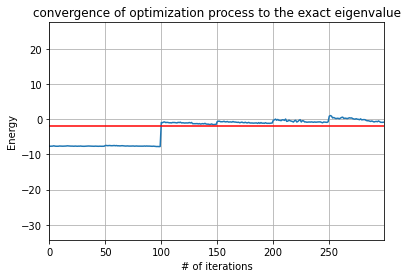

In [134]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [135]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [136]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [137]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

2it [00:00,  6.78it/s]

{'001': 187, '111': 347, '110': 92, '011': 94, '101': 51, '000': 54, '100': 103, '010': 96}
1.0
{'011': 138, '111': 153, '110': 318, '001': 120, '010': 42, '101': 141, '000': 105, '100': 7}
1.0


4it [00:00,  7.53it/s]

{'110': 97, '111': 342, '011': 178, '101': 90, '010': 65, '000': 72, '100': 88, '001': 92}
1.0
{'100': 86, '011': 94, '001': 195, '111': 350, '000': 43, '101': 58, '010': 97, '110': 101}
1.0


7it [00:00,  7.96it/s]


{'100': 89, '011': 255, '001': 212, '110': 96, '000': 52, '111': 213, '010': 90, '101': 17}
1.0
{'001': 185, '011': 106, '000': 50, '111': 360, '110': 94, '010': 93, '101': 49, '100': 87}
1.0
{'100': 94, '111': 375, '010': 98, '001': 172, '101': 42, '011': 106, '000': 48, '110': 89}
1.0


2it [00:00, 13.05it/s]

{'110': 250, '001': 387, '011': 130, '111': 173, '100': 36, '101': 27, '010': 12, '000': 9}
1.0
{'110': 364, '000': 134, '011': 132, '001': 245, '101': 58, '010': 50, '111': 35, '100': 6}
1.0
{'100': 176, '011': 380, '110': 134, '101': 79, '111': 122, '001': 114, '010': 18, '000': 1}
1.0


4it [00:00, 12.22it/s]

{'110': 272, '001': 344, '111': 165, '011': 146, '100': 57, '101': 20, '000': 8, '010': 12}
1.0
{'010': 98, '110': 136, '111': 146, '001': 269, '101': 145, '011': 182, '000': 38, '100': 10}
1.0


7it [00:00, 10.66it/s]


{'111': 176, '110': 242, '001': 375, '011': 137, '100': 47, '101': 29, '010': 13, '000': 5}
1.0
{'110': 260, '001': 343, '111': 169, '011': 151, '101': 24, '100': 50, '010': 16, '000': 11}
1.0


0it [00:00, ?it/s]

{'001': 240, '010': 55, '111': 156, '101': 97, '110': 266, '000': 5, '100': 50, '011': 155}
1.0


2it [00:00, 12.16it/s]

{'110': 323, '001': 119, '010': 169, '000': 145, '011': 63, '100': 13, '101': 119, '111': 73}
1.0
{'110': 119, '100': 241, '111': 161, '000': 34, '011': 268, '010': 21, '001': 132, '101': 48}
1.0


4it [00:00, 10.70it/s]

{'111': 162, '001': 226, '011': 166, '010': 55, '110': 260, '101': 92, '100': 60, '000': 3}
1.0
{'110': 271, '011': 276, '010': 60, '101': 134, '001': 179, '100': 42, '000': 24, '111': 38}
1.0


6it [00:00,  9.22it/s]

{'110': 284, '100': 48, '011': 179, '111': 115, '101': 68, '010': 61, '001': 266, '000': 3}
1.0


7it [00:00, 10.02it/s]


{'100': 62, '111': 164, '101': 69, '001': 245, '110': 253, '010': 58, '011': 166, '000': 7}
1.0


0it [00:00, ?it/s]

{'001': 358, '011': 107, '110': 243, '101': 99, '111': 97, '010': 42, '100': 9, '000': 69}
1.0
{'110': 327, '010': 156, '001': 324, '000': 57, '100': 43, '011': 22, '101': 68, '111': 27}

2it [00:00, 11.06it/s]


1.0
{'100': 180, '011': 223, '000': 25, '001': 216, '110': 80, '010': 100, '111': 188, '101': 12}
1.0


4it [00:00, 11.52it/s]

{'001': 311, '010': 43, '011': 116, '101': 119, '110': 249, '111': 104, '000': 65, '100': 17}
1.0
{'111': 155, '110': 261, '000': 56, '001': 415, '011': 47, '100': 20, '010': 36, '101': 34}
1.0


7it [00:00, 10.40it/s]

{'001': 342, '101': 106, '011': 100, '110': 238, '000': 61, '111': 121, '010': 46, '100': 10}
1.0
{'111': 106, '101': 112, '000': 62, '110': 236, '001': 326, '011': 121, '100': 11, '010': 50}
1.0



2it [00:00, 10.89it/s]

{'111': 324, '001': 255, '010': 34, '110': 162, '011': 165, '100': 60, '000': 23, '101': 1}
1.0
{'000': 206, '010': 162, '110': 444, '011': 69, '100': 42, '101': 18, '001': 65, '111': 18}
1.0


4it [00:00,  9.71it/s]

{'101': 152, '100': 202, '011': 358, '111': 153, '001': 69, '000': 57, '010': 12, '110': 21}
1.0
{'001': 275, '010': 48, '110': 155, '011': 160, '111': 303, '100': 66, '000': 17}
1.0
{'111': 298, '001': 123, '010': 30, '101': 141, '011': 166, '110': 195, '100': 68, '000': 3}
1.0


7it [00:00, 10.70it/s]


{'110': 185, '011': 195, '001': 267, '100': 54, '010': 41, '111': 261, '000': 20, '101': 1}
1.0
{'011': 175, '111': 296, '100': 56, '001': 280, '110': 151, '000': 26, '010': 40}
1.0


1it [00:00,  8.48it/s]

{'001': 520, '110': 128, '101': 15, '010': 81, '011': 157, '000': 20, '111': 74, '100': 29}
1.0
{'001': 350, '000': 211, '011': 172, '110': 192, '010': 47, '101': 30, '100': 16, '111': 6}
1.0


5it [00:00,  9.17it/s]

{'011': 468, '100': 104, '110': 56, '111': 28, '001': 209, '010': 76, '101': 60, '000': 23}
1.0
{'011': 147, '001': 548, '110': 108, '010': 75, '111': 92, '100': 26, '101': 12, '000': 16}
1.0
{'110': 130, '011': 95, '001': 253, '101': 280, '111': 138, '010': 86, '000': 32, '100': 10}
1.0


7it [00:00,  8.69it/s]


{'001': 514, '010': 76, '011': 152, '111': 88, '110': 135, '000': 16, '101': 15, '100': 28}
1.0
{'011': 151, '101': 17, '001': 494, '111': 101, '110': 138, '010': 77, '100': 32, '000': 14}
1.0


2it [00:00,  6.47it/s]

{'010': 220, '001': 463, '110': 106, '100': 41, '000': 21, '111': 97, '101': 69, '011': 7}
1.0
{'100': 49, '110': 186, '000': 203, '001': 311, '010': 97, '101': 44, '011': 132, '111': 2}
1.0


4it [00:00,  8.94it/s]

{'010': 143, '100': 152, '001': 207, '011': 267, '000': 73, '111': 54, '101': 115, '110': 13}
1.0
{'001': 470, '010': 240, '100': 58, '110': 95, '111': 66, '000': 23, '101': 63, '011': 9}
1.0


7it [00:00,  9.07it/s]

{'001': 333, '110': 279, '101': 190, '111': 57, '010': 82, '000': 34, '100': 26, '011': 23}
1.0
{'110': 112, '010': 227, '111': 94, '001': 457, '100': 46, '000': 25, '101': 57, '011': 6}
1.0
{'001': 483, '010': 209, '101': 74, '000': 17, '110': 103, '111': 81, '100': 48, '011': 9}
1.0



3it [00:00,  8.54it/s]

{'101': 54, '110': 347, '001': 320, '010': 68, '000': 66, '011': 77, '111': 61, '100': 31}
1.0
{'110': 327, '001': 167, '111': 119, '000': 180, '101': 42, '010': 40, '011': 110, '100': 39}
1.0
{'110': 172, '000': 69, '001': 131, '011': 205, '100': 264, '101': 103, '010': 79, '111': 1}
1.0


5it [00:00,  9.08it/s]

{'001': 254, '101': 47, '110': 404, '010': 75, '011': 65, '000': 71, '100': 41, '111': 67}
1.0
{'110': 366, '101': 187, '010': 121, '001': 117, '000': 38, '100': 58, '111': 134, '011': 3}
1.0


7it [00:00,  8.13it/s]


{'110': 383, '001': 275, '000': 76, '100': 35, '111': 69, '011': 64, '101': 47, '010': 75}
1.0
{'001': 268, '110': 401, '010': 67, '011': 58, '111': 61, '000': 76, '100': 39, '101': 54}
1.0


2it [00:00, 11.00it/s]

{'011': 231, '001': 442, '010': 105, '101': 21, '111': 72, '000': 102, '110': 51}
1.0
{'000': 101, '001': 438, '011': 331, '010': 14, '111': 31, '101': 18, '100': 18, '110': 73}
1.0
{'011': 505, '110': 19, '010': 191, '001': 203, '100': 23, '111': 52, '101': 22, '000': 9}
1.0


4it [00:00, 11.27it/s]

{'001': 456, '011': 222, '010': 104, '111': 73, '101': 14, '000': 105, '110': 50}
1.0
{'010': 110, '101': 218, '001': 283, '111': 84, '110': 47, '100': 34, '011': 213, '000': 35}
1.0


7it [00:00,  9.44it/s]


{'000': 113, '001': 436, '110': 35, '011': 262, '111': 60, '010': 84, '101': 33, '100': 1}
1.0
{'010': 104, '001': 462, '011': 218, '111': 61, '101': 33, '000': 105, '110': 41}
1.0


3it [00:00, 11.28it/s]

{'101': 31, '001': 254, '100': 24, '011': 426, '010': 147, '110': 48, '111': 8, '000': 86}
1.0
{'001': 241, '011': 515, '000': 93, '010': 41, '101': 76, '110': 38, '111': 18, '100': 2}
1.0
{'011': 595, '100': 59, '001': 82, '010': 236, '000': 4, '101': 20, '111': 26, '110': 2}
1.0


5it [00:00, 11.15it/s]

{'000': 102, '110': 52, '011': 429, '101': 47, '010': 163, '001': 192, '111': 21, '100': 18}
1.0
{'011': 303, '010': 115, '001': 187, '101': 55, '111': 143, '000': 57, '100': 62, '110': 102}
1.0


7it [00:00,  8.70it/s]


{'011': 472, '110': 38, '001': 211, '010': 163, '000': 84, '101': 34, '100': 10, '111': 12}
1.0
{'000': 98, '011': 441, '001': 236, '101': 37, '110': 31, '010': 152, '100': 12, '111': 17}
1.0


1it [00:00,  5.17it/s]

{'011': 494, '111': 33, '001': 170, '101': 74, '110': 123, '000': 70, '100': 26, '010': 34}
1.0
{'000': 132, '110': 170, '010': 162, '001': 99, '011': 354, '100': 80, '101': 16, '111': 11}
1.0
{'011': 539, '001': 140, '010': 57, '111': 55, '101': 47, '110': 41, '100': 96, '000': 49}
1.0


5it [00:00,  6.92it/s]

{'011': 514, '001': 161, '110': 107, '000': 80, '111': 37, '101': 65, '010': 38, '100': 22}
1.0
{'101': 105, '011': 366, '110': 146, '111': 168, '001': 154, '000': 62, '010': 12, '100': 11}
1.0


7it [00:01,  6.95it/s]


{'011': 480, '110': 147, '111': 35, '101': 73, '001': 164, '000': 66, '010': 39, '100': 20}
1.0
{'011': 508, '110': 128, '101': 67, '001': 162, '000': 75, '111': 42, '010': 29, '100': 13}
1.0


2it [00:00,  6.84it/s]

{'010': 434, '100': 29, '011': 190, '001': 148, '000': 150, '101': 23, '110': 43, '111': 7}
1.0
{'011': 612, '101': 54, '001': 288, '111': 9, '010': 15, '110': 38, '000': 7, '100': 1}
1.0


4it [00:00,  9.64it/s]

{'100': 81, '010': 443, '011': 289, '000': 113, '001': 55, '111': 38, '110': 3, '101': 2}
1.0
{'011': 188, '000': 161, '010': 441, '110': 35, '001': 136, '100': 40, '101': 17, '111': 6}
1.0
{'110': 154, '100': 60, '001': 132, '011': 132, '010': 310, '000': 118, '111': 91, '101': 27}
1.0


7it [00:00,  9.80it/s]


{'001': 134, '111': 8, '010': 431, '000': 165, '011': 200, '110': 44, '100': 28, '101': 14}
1.0
{'000': 159, '110': 37, '010': 432, '111': 18, '001': 134, '011': 188, '100': 34, '101': 22}
1.0


2it [00:00,  7.31it/s]

{'001': 285, '011': 440, '000': 114, '101': 37, '110': 60, '111': 19, '010': 68, '100': 1}
1.0
{'010': 96, '001': 345, '011': 461, '110': 27, '111': 46, '000': 25, '101': 16, '100': 8}
1.0


4it [00:00, 10.36it/s]

{'011': 643, '100': 43, '010': 182, '101': 30, '110': 31, '001': 66, '000': 11, '111': 18}
1.0
{'011': 429, '001': 257, '110': 69, '010': 88, '000': 129, '111': 21, '101': 31}
1.0
{'000': 53, '001': 157, '101': 114, '111': 141, '011': 354, '100': 61, '010': 98, '110': 46}
1.0


7it [00:00, 10.01it/s]


{'111': 15, '011': 439, '001': 276, '101': 33, '000': 116, '110': 80, '010': 65}
1.0
{'011': 445, '110': 69, '001': 235, '101': 27, '000': 142, '010': 82, '111': 24}
1.0


1it [00:00,  8.86it/s]

{'010': 313, '001': 264, '111': 34, '011': 333, '100': 32, '000': 17, '110': 11, '101': 20}
1.0


2it [00:00,  7.27it/s]

{'011': 651, '110': 39, '111': 5, '000': 90, '001': 180, '100': 27, '101': 11, '010': 21}
1.0


4it [00:00,  9.00it/s]

{'011': 532, '010': 234, '001': 99, '110': 43, '000': 62, '111': 35, '101': 15, '100': 4}
1.0
{'010': 304, '001': 256, '011': 351, '111': 38, '101': 22, '100': 25, '000': 19, '110': 9}
1.0
{'110': 192, '010': 118, '011': 328, '100': 35, '001': 175, '101': 83, '000': 5, '111': 88}
1.0


7it [00:00,  9.79it/s]


{'001': 233, '010': 297, '011': 386, '111': 25, '100': 36, '000': 17, '110': 12, '101': 18}
1.0
{'011': 361, '010': 308, '001': 235, '110': 14, '111': 36, '000': 20, '101': 22, '100': 28}
1.0


0it [00:00, ?it/s]

{'011': 458, '010': 222, '100': 136, '111': 71, '001': 88, '101': 36, '000': 8, '110': 5}

2it [00:00, 10.01it/s]


1.0
{'100': 135, '000': 69, '011': 633, '110': 61, '111': 29, '001': 39, '010': 23, '101': 35}
1.0
{'011': 494, '000': 126, '001': 92, '111': 95, '100': 72, '110': 73, '010': 58, '101': 14}
1.0


6it [00:00, 10.69it/s]

{'011': 463, '010': 185, '001': 92, '101': 40, '111': 84, '100': 139, '000': 16, '110': 5}
1.0
{'011': 463, '001': 101, '110': 119, '000': 103, '100': 43, '111': 91, '010': 84, '101': 20}
1.0
{'011': 448, '111': 98, '010': 189, '001': 102, '100': 134, '101': 40, '000': 9, '110': 4}
1.0


7it [00:00, 10.64it/s]


{'001': 105, '011': 456, '010': 189, '101': 41, '100': 132, '111': 82, '000': 14, '110': 5}
1.0


1it [00:00,  8.38it/s]

{'011': 348, '100': 34, '010': 206, '101': 184, '000': 46, '110': 76, '001': 109, '111': 21}
1.0


2it [00:00,  8.60it/s]

{'011': 521, '110': 21, '111': 62, '010': 29, '101': 145, '001': 132, '000': 41, '100': 73}
1.0


3it [00:00,  8.36it/s]

{'001': 108, '011': 363, '101': 142, '010': 197, '100': 38, '111': 39, '000': 49, '110': 88}
1.0


4it [00:00,  8.27it/s]

{'010': 199, '011': 348, '110': 79, '101': 169, '001': 125, '000': 47, '111': 22, '100': 35}
1.0


6it [00:00,  9.27it/s]

{'100': 85, '110': 304, '011': 170, '111': 179, '001': 232, '010': 13, '101': 40, '000': 1}
1.0
{'011': 317, '100': 44, '111': 27, '010': 215, '101': 168, '110': 81, '001': 122, '000': 50}
1.0


7it [00:00,  9.43it/s]


{'010': 207, '011': 346, '101': 160, '110': 82, '000': 48, '001': 126, '111': 21, '100': 34}
1.0


0it [00:00, ?it/s]

{'011': 592, '100': 36, '001': 206, '010': 104, '111': 23, '101': 17, '110': 28, '000': 18}
1.0


2it [00:00,  7.88it/s]

{'010': 226, '011': 452, '100': 44, '000': 95, '111': 6, '001': 158, '110': 39, '101': 4}
1.0


4it [00:00, 10.01it/s]

{'011': 687, '001': 116, '010': 75, '110': 59, '101': 17, '111': 12, '000': 55, '100': 3}
1.0
{'010': 89, '011': 598, '100': 22, '001': 229, '110': 29, '000': 27, '111': 14, '101': 16}
1.0
{'011': 376, '101': 111, '111': 216, '100': 26, '010': 19, '001': 140, '000': 32, '110': 104}
1.0


7it [00:00, 10.33it/s]


{'011': 607, '010': 83, '001': 226, '111': 20, '110': 24, '000': 26, '101': 12, '100': 26}
1.0
{'011': 593, '000': 24, '110': 23, '010': 88, '001': 227, '100': 33, '101': 18, '111': 18}
1.0


0it [00:00, ?it/s]

{'001': 166, '011': 579, '010': 124, '100': 41, '101': 17, '000': 66, '111': 21, '110': 10}
1.0


2it [00:00,  8.28it/s]

{'001': 205, '011': 514, '010': 184, '110': 22, '101': 35, '100': 27, '000': 37}
1.0


3it [00:00,  8.67it/s]

{'010': 181, '001': 397, '110': 47, '101': 17, '011': 341, '100': 15, '000': 12, '111': 14}
1.0
{'001': 159, '000': 59, '011': 577, '101': 13, '010': 128, '100': 52, '111': 23, '110': 13}
1.0


5it [00:00, 10.45it/s]

{'011': 385, '000': 23, '110': 93, '001': 147, '111': 212, '100': 84, '010': 30, '101': 50}
1.0


7it [00:00, 10.46it/s]


{'011': 553, '001': 178, '111': 26, '100': 53, '010': 133, '000': 57, '101': 13, '110': 11}
1.0
{'000': 54, '011': 579, '100': 61, '010': 110, '111': 19, '001': 176, '110': 7, '101': 18}
1.0


0it [00:00, ?it/s]

{'011': 395, '001': 188, '101': 77, '010': 269, '111': 18, '110': 43, '100': 13, '000': 21}
1.0


2it [00:00,  8.74it/s]

{'011': 641, '100': 81, '001': 151, '000': 48, '111': 36, '101': 23, '110': 37, '010': 7}
1.0


4it [00:00, 10.67it/s]

{'010': 192, '011': 315, '000': 127, '001': 235, '110': 47, '111': 85, '101': 21, '100': 2}
1.0
{'101': 97, '011': 369, '001': 178, '010': 306, '100': 14, '110': 34, '111': 16, '000': 10}
1.0
{'111': 180, '000': 5, '001': 234, '011': 202, '110': 277, '100': 16, '010': 77, '101': 33}
1.0


7it [00:00, 10.66it/s]

{'101': 80, '011': 359, '010': 312, '001': 180, '000': 11, '110': 48, '111': 14, '100': 20}
1.0
{'011': 360, '010': 291, '000': 17, '001': 188, '110': 36, '111': 23, '101': 92, '100': 17}
1.0



2it [00:00,  7.49it/s]

{'011': 455, '010': 213, '001': 257, '100': 39, '110': 42, '111': 10, '000': 6, '101': 2}
1.0
{'011': 595, '000': 154, '010': 77, '100': 33, '001': 94, '110': 45, '101': 24, '111': 2}
1.0


4it [00:00,  9.04it/s]

{'011': 664, '000': 133, '110': 64, '010': 89, '001': 46, '101': 10, '100': 15, '111': 3}
1.0
{'001': 222, '011': 482, '010': 206, '100': 57, '111': 15, '000': 19, '110': 22, '101': 1}
1.0
{'000': 53, '011': 339, '101': 104, '001': 121, '111': 161, '110': 131, '010': 102, '100': 13}
1.0


7it [00:00,  9.59it/s]


{'010': 231, '011': 452, '001': 240, '110': 29, '100': 48, '111': 13, '000': 9, '101': 2}
1.0
{'100': 40, '001': 265, '011': 465, '010': 205, '110': 20, '111': 22, '000': 6, '101': 1}
1.0


2it [00:00,  7.44it/s]

{'000': 83, '001': 483, '101': 43, '011': 121, '010': 255, '100': 27, '110': 4, '111': 8}
1.0
{'001': 525, '011': 343, '101': 10, '010': 8, '000': 62, '100': 61, '110': 11, '111': 4}
1.0


4it [00:00,  9.85it/s]

{'011': 482, '000': 58, '001': 122, '101': 28, '010': 266, '111': 29, '110': 30, '100': 9}
1.0
{'001': 501, '111': 9, '101': 36, '010': 226, '100': 41, '011': 123, '000': 83, '110': 5}
1.0
{'011': 96, '010': 92, '000': 15, '101': 136, '001': 397, '110': 150, '111': 38, '100': 100}
1.0


7it [00:00, 10.86it/s]


{'001': 490, '000': 100, '010': 225, '011': 113, '101': 40, '100': 43, '111': 11, '110': 2}
1.0
{'011': 120, '001': 495, '010': 237, '000': 92, '101': 37, '111': 8, '100': 31, '110': 4}
1.0


2it [00:00,  7.73it/s]

{'011': 367, '001': 236, '111': 41, '010': 225, '110': 89, '101': 15, '100': 49, '000': 2}
1.0
{'100': 18, '011': 539, '101': 45, '111': 123, '000': 73, '001': 151, '010': 65, '110': 10}
1.0


4it [00:00,  9.51it/s]

{'001': 89, '110': 117, '011': 542, '010': 122, '000': 79, '100': 10, '111': 60, '101': 5}
1.0
{'001': 251, '010': 252, '011': 347, '110': 88, '111': 28, '100': 42, '101': 13, '000': 3}
1.0
{'011': 160, '101': 172, '111': 223, '110': 291, '000': 12, '001': 97, '100': 35, '010': 34}
1.0


7it [00:00,  9.26it/s]


{'110': 91, '011': 372, '100': 53, '001': 249, '010': 210, '101': 13, '111': 32, '000': 4}
1.0
{'100': 41, '011': 357, '010': 223, '001': 243, '101': 21, '111': 38, '110': 96, '000': 5}
1.0


3it [00:00, 11.42it/s]

{'001': 249, '011': 385, '010': 296, '100': 22, '000': 18, '101': 20, '111': 25, '110': 9}
1.0
{'011': 408, '001': 206, '000': 63, '010': 257, '100': 61, '110': 23, '111': 6}
1.0
{'011': 546, '010': 221, '101': 19, '111': 23, '001': 90, '110': 31, '000': 88, '100': 6}
1.0


5it [00:00, 11.72it/s]

{'011': 353, '010': 313, '110': 10, '101': 26, '111': 33, '100': 29, '001': 238, '000': 22}
1.0
{'100': 42, '111': 113, '010': 107, '011': 322, '101': 71, '110': 192, '001': 175, '000': 2}
1.0


7it [00:00,  9.91it/s]


{'010': 295, '011': 408, '001': 221, '100': 29, '111': 34, '000': 15, '110': 2, '101': 20}
1.0
{'001': 244, '010': 312, '011': 354, '100': 32, '111': 31, '110': 16, '000': 18, '101': 17}
1.0


2it [00:00, 10.69it/s]

{'011': 370, '001': 213, '010': 320, '110': 11, '100': 38, '000': 22, '111': 33, '101': 17}
1.0
{'011': 648, '001': 190, '000': 77, '100': 34, '111': 3, '010': 19, '110': 41, '101': 12}
1.0


4it [00:00, 10.01it/s]

{'011': 240, '000': 110, '001': 372, '010': 219, '101': 38, '111': 11, '110': 21, '100': 13}
1.0
{'010': 345, '001': 226, '011': 364, '111': 16, '101': 18, '100': 24, '110': 12, '000': 19}
1.0
{'001': 174, '110': 192, '010': 103, '100': 54, '011': 317, '111': 109, '101': 73, '000': 2}
1.0


7it [00:00,  8.97it/s]


{'011': 385, '001': 236, '010': 280, '100': 37, '110': 14, '111': 41, '101': 12, '000': 19}
1.0
{'011': 385, '010': 297, '000': 18, '001': 224, '111': 29, '101': 23, '100': 38, '110': 10}
1.0


2it [00:00, 13.10it/s]

{'011': 385, '010': 288, '001': 224, '000': 21, '111': 38, '101': 19, '100': 36, '110': 13}
1.0
{'011': 650, '001': 179, '000': 74, '110': 41, '101': 14, '010': 27, '100': 36, '111': 3}
1.0
{'001': 83, '000': 108, '010': 235, '011': 504, '110': 40, '101': 15, '111': 31, '100': 8}
1.0


4it [00:00, 12.55it/s]

{'001': 232, '011': 364, '010': 298, '100': 42, '000': 25, '101': 28, '110': 6, '111': 29}
1.0
{'011': 290, '001': 189, '110': 155, '100': 53, '010': 125, '101': 75, '111': 133, '000': 4}
1.0


7it [00:00, 10.38it/s]


{'001': 230, '010': 302, '011': 370, '111': 35, '100': 36, '110': 9, '000': 23, '101': 19}
1.0
{'001': 246, '010': 305, '011': 372, '000': 16, '101': 13, '100': 39, '111': 23, '110': 10}
1.0


2it [00:00, 12.15it/s]

{'110': 23, '010': 307, '011': 145, '001': 341, '100': 67, '111': 38, '000': 41, '101': 62}
1.0
{'000': 131, '100': 108, '011': 400, '010': 34, '001': 241, '110': 14, '111': 53, '101': 43}
1.0
{'010': 238, '011': 423, '000': 127, '100': 77, '101': 36, '111': 70, '001': 31, '110': 22}
1.0


4it [00:00, 11.76it/s]

{'010': 306, '001': 324, '000': 43, '111': 47, '011': 138, '101': 67, '110': 23, '100': 76}
1.0
{'110': 130, '010': 216, '101': 141, '100': 76, '000': 31, '001': 246, '011': 159, '111': 25}
1.0


7it [00:00,  9.70it/s]


{'001': 352, '010': 294, '100': 70, '011': 143, '000': 35, '110': 18, '101': 67, '111': 45}
1.0
{'000': 46, '101': 68, '010': 301, '100': 76, '011': 153, '111': 52, '001': 309, '110': 19}
1.0


2it [00:00, 12.17it/s]

{'011': 508, '010': 178, '001': 261, '000': 32, '100': 14, '111': 17, '110': 8, '101': 6}
1.0
{'000': 87, '011': 604, '010': 53, '001': 220, '110': 32, '100': 11, '101': 14, '111': 3}
1.0
{'101': 18, '011': 680, '110': 31, '010': 163, '001': 89, '111': 7, '000': 36}
1.0


4it [00:00, 11.42it/s]

{'011': 508, '001': 266, '110': 10, '010': 169, '000': 38, '101': 5, '111': 15, '100': 13}
1.0
{'101': 132, '110': 141, '011': 347, '111': 171, '001': 140, '010': 38, '100': 48, '000': 7}
1.0


7it [00:00, 10.20it/s]


{'001': 274, '011': 506, '010': 151, '100': 17, '000': 37, '111': 19, '110': 16, '101': 4}
1.0
{'110': 15, '011': 520, '001': 237, '010': 179, '000': 38, '100': 24, '111': 9, '101': 2}
1.0


0it [00:00, ?it/s]

{'010': 294, '001': 172, '100': 40, '101': 109, '011': 328, '000': 8, '110': 35, '111': 38}
1.0


2it [00:00, 11.93it/s]

{'011': 445, '101': 34, '000': 122, '001': 66, '010': 169, '100': 118, '110': 66, '111': 4}
1.0
{'011': 398, '010': 113, '001': 70, '101': 70, '110': 59, '000': 217, '100': 30, '111': 67}
1.0


4it [00:00, 12.99it/s]

{'010': 306, '011': 309, '001': 170, '000': 10, '111': 47, '101': 96, '100': 48, '110': 38}
1.0
{'110': 188, '011': 268, '010': 132, '111': 96, '101': 131, '001': 121, '000': 75, '100': 13}
1.0


6it [00:00, 10.52it/s]

{'011': 314, '001': 174, '000': 16, '111': 43, '100': 57, '010': 291, '101': 96, '110': 33}
1.0


7it [00:00, 10.15it/s]


{'010': 302, '011': 319, '001': 157, '101': 96, '100': 60, '111': 41, '000': 15, '110': 34}
1.0


2it [00:00, 13.67it/s]

{'010': 307, '001': 249, '011': 310, '000': 24, '100': 57, '101': 23, '111': 54}
1.0
{'011': 561, '101': 79, '001': 179, '010': 21, '000': 110, '111': 19, '110': 39, '100': 16}
1.0
{'010': 207, '101': 23, '100': 21, '011': 498, '111': 68, '000': 97, '001': 80, '110': 30}
1.0


4it [00:00, 12.79it/s]

{'011': 301, '001': 284, '010': 292, '111': 61, '000': 19, '101': 16, '100': 51}
1.0
{'001': 193, '011': 292, '010': 127, '110': 155, '101': 111, '111': 80, '100': 62, '000': 4}
1.0


7it [00:00,  9.61it/s]


{'011': 299, '010': 299, '001': 261, '100': 61, '101': 34, '111': 49, '000': 20, '110': 1}
1.0
{'010': 275, '001': 289, '011': 317, '100': 52, '101': 28, '111': 48, '000': 13, '110': 2}
1.0


3it [00:00, 13.45it/s]

{'010': 367, '111': 109, '001': 119, '000': 129, '100': 52, '110': 62, '011': 175, '101': 11}
1.0
{'110': 146, '011': 556, '000': 146, '001': 102, '010': 31, '100': 16, '101': 22, '111': 5}
1.0
{'011': 277, '001': 47, '110': 75, '010': 291, '111': 79, '000': 219, '101': 29, '100': 7}
1.0
{'010': 361, '110': 54, '011': 202, '000': 129, '111': 104, '001': 116, '100': 48, '101': 10}
1.0


5it [00:00, 13.01it/s]

{'101': 70, '011': 316, '110': 317, '010': 87, '001': 57, '000': 65, '111': 9, '100': 103}
1.0
{'111': 94, '010': 384, '001': 138, '011': 201, '110': 54, '100': 38, '000': 103, '101': 12}
1.0


7it [00:00, 10.40it/s]


{'010': 361, '011': 207, '001': 126, '111': 110, '101': 9, '100': 55, '110': 55, '000': 101}
1.0


2it [00:00, 11.34it/s]

{'001': 268, '011': 378, '010': 297, '101': 21, '110': 17, '111': 38, '100': 5}
1.0
{'011': 682, '110': 60, '001': 112, '000': 134, '010': 5, '111': 5, '100': 10, '101': 16}
1.0
{'010': 149, '000': 170, '011': 542, '110': 20, '101': 62, '111': 10, '001': 69, '100': 2}
1.0


4it [00:00, 11.88it/s]

{'001': 245, '010': 307, '011': 384, '101': 22, '111': 46, '110': 14, '000': 2, '100': 4}
1.0
{'001': 153, '010': 100, '111': 92, '101': 122, '110': 230, '011': 324, '000': 3}
1.0


7it [00:00,  9.38it/s]

{'010': 342, '011': 351, '001': 241, '111': 55, '101': 15, '110': 14, '100': 5, '000': 1}
1.0
{'011': 375, '001': 254, '010': 299, '101': 15, '111': 52, '100': 11, '110': 16, '000': 2}
1.0



2it [00:00, 11.00it/s]

{'010': 337, '110': 62, '011': 387, '001': 179, '101': 24, '000': 33, '111': 2}
1.0
{'011': 709, '010': 7, '001': 203, '000': 29, '100': 12, '110': 34, '111': 18, '101': 12}
1.0
{'010': 303, '011': 544, '100': 21, '001': 36, '000': 67, '110': 34, '101': 13, '111': 6}
1.0


4it [00:00, 10.67it/s]

{'010': 341, '011': 387, '000': 39, '101': 20, '001': 178, '110': 55, '111': 4}
1.0
{'010': 158, '111': 202, '110': 251, '100': 28, '001': 88, '011': 193, '101': 91, '000': 13}
1.0


7it [00:00,  9.46it/s]


{'010': 353, '110': 55, '011': 391, '001': 173, '000': 29, '101': 21, '111': 2}
1.0
{'011': 372, '010': 359, '111': 2, '000': 29, '110': 61, '001': 184, '101': 17}
1.0


0it [00:00, ?it/s]

{'001': 193, '010': 260, '011': 463, '000': 31, '101': 20, '110': 48, '111': 5, '100': 4}
1.0


2it [00:00, 15.16it/s]

{'011': 701, '001': 154, '000': 53, '010': 32, '111': 13, '101': 18, '110': 45, '100': 8}
1.0
{'011': 592, '000': 74, '110': 45, '010': 207, '001': 58, '101': 20, '100': 25, '111': 3}
1.0


4it [00:00, 13.50it/s]

{'010': 249, '101': 11, '110': 58, '001': 185, '011': 493, '111': 6, '000': 21, '100': 1}
1.0
{'111': 256, '011': 230, '110': 237, '001': 44, '101': 132, '010': 92, '100': 15, '000': 18}
1.0


6it [00:00, 10.20it/s]

{'010': 248, '110': 70, '011': 467, '001': 194, '000': 24, '101': 15, '111': 6}
1.0


7it [00:00, 11.18it/s]


{'010': 225, '011': 496, '001': 168, '000': 29, '101': 19, '110': 73, '111': 13, '100': 1}
1.0


0it [00:00, ?it/s]

{'001': 167, '010': 408, '110': 62, '011': 322, '101': 17, '000': 42, '111': 6}
1.0


2it [00:00, 12.78it/s]

{'001': 203, '011': 707, '110': 54, '000': 29, '111': 17, '100': 7, '010': 3, '101': 4}
1.0
{'010': 354, '011': 482, '000': 81, '001': 34, '100': 26, '111': 6, '110': 32, '101': 9}
1.0
{'000': 47, '010': 355, '011': 386, '001': 157, '110': 68, '101': 9, '111': 2}

4it [00:00, 11.56it/s]


1.0
{'110': 280, '011': 217, '101': 91, '001': 116, '010': 164, '111': 117, '000': 23, '100': 16}
1.0


7it [00:00, 10.41it/s]

{'001': 183, '011': 336, '000': 38, '010': 367, '111': 8, '110': 73, '101': 19}
1.0
{'010': 354, '011': 339, '001': 189, '110': 72, '000': 43, '101': 20, '111': 7}
1.0



0it [00:00, ?it/s]

{'011': 296, '001': 173, '101': 55, '010': 356, '000': 31, '110': 105, '111': 1, '100': 7}
1.0


2it [00:00, 13.87it/s]

{'101': 37, '110': 48, '011': 634, '001': 175, '100': 23, '000': 29, '111': 59, '010': 19}
1.0
{'011': 452, '010': 287, '110': 59, '000': 97, '100': 56, '101': 32, '001': 19, '111': 22}
1.0


4it [00:00, 13.15it/s]

{'011': 294, '010': 341, '110': 119, '001': 184, '000': 24, '101': 56, '111': 4, '100': 2}
1.0
{'010': 101, '101': 111, '111': 198, '110': 350, '001': 130, '011': 102, '000': 27, '100': 5}
1.0


7it [00:00, 10.90it/s]


{'001': 196, '010': 336, '011': 288, '110': 125, '101': 45, '000': 23, '100': 6, '111': 5}
1.0
{'100': 7, '001': 175, '010': 332, '011': 326, '110': 100, '111': 7, '101': 58, '000': 19}
1.0


0it [00:00, ?it/s]

{'010': 305, '110': 69, '011': 364, '001': 225, '000': 22, '101': 34, '100': 4, '111': 1}
1.0


2it [00:00, 14.04it/s]

{'101': 16, '011': 641, '001': 214, '000': 64, '110': 41, '010': 11, '100': 10, '111': 27}
1.0
{'011': 546, '001': 29, '010': 292, '000': 69, '101': 19, '110': 45, '100': 13, '111': 11}
1.0


4it [00:00, 11.79it/s]

{'010': 285, '001': 249, '011': 354, '110': 65, '101': 26, '000': 38, '100': 2, '111': 5}
1.0
{'101': 161, '110': 250, '100': 15, '111': 151, '001': 111, '011': 219, '010': 107, '000': 10}
1.0


6it [00:00,  9.34it/s]

{'011': 353, '001': 228, '010': 308, '101': 28, '000': 38, '110': 65, '100': 3, '111': 1}
1.0


7it [00:00, 10.12it/s]


{'010': 298, '110': 65, '011': 351, '001': 262, '101': 17, '000': 25, '100': 3, '111': 3}
1.0


0it [00:00, ?it/s]

{'011': 241, '001': 311, '110': 39, '010': 296, '100': 3, '000': 64, '111': 12, '101': 58}
1.0


2it [00:00, 12.45it/s]

{'011': 551, '001': 295, '101': 37, '110': 52, '000': 49, '100': 20, '111': 14, '010': 6}
1.0
{'010': 315, '001': 41, '011': 473, '000': 75, '101': 72, '110': 23, '111': 20, '100': 5}
1.0
{'011': 276, '001': 303, '110': 38, '000': 58, '010': 279, '111': 8, '101': 59, '100': 3}
1.0


4it [00:00, 10.94it/s]

{'111': 183, '101': 230, '110': 198, '010': 140, '001': 122, '011': 75, '100': 60, '000': 16}
1.0


6it [00:00,  9.24it/s]

{'001': 306, '010': 320, '011': 250, '101': 50, '000': 48, '110': 32, '111': 15, '100': 3}
1.0


7it [00:00,  9.87it/s]


{'110': 36, '011': 225, '001': 302, '010': 328, '101': 72, '100': 3, '000': 51, '111': 7}
1.0


0it [00:00, ?it/s]

{'010': 324, '001': 229, '110': 59, '011': 348, '000': 28, '101': 29, '111': 6, '100': 1}
1.0


2it [00:00, 11.48it/s]

{'011': 655, '110': 37, '111': 29, '001': 194, '000': 63, '101': 23, '100': 16, '010': 7}
1.0
{'010': 266, '011': 551, '110': 27, '001': 40, '000': 77, '111': 22, '101': 16, '100': 25}
1.0


4it [00:00, 12.71it/s]

{'010': 334, '011': 361, '101': 34, '110': 48, '000': 32, '001': 211, '111': 4}
1.0
{'101': 170, '110': 258, '001': 94, '011': 215, '010': 127, '100': 9, '111': 142, '000': 9}
1.0


6it [00:00,  9.71it/s]

{'011': 361, '001': 218, '010': 313, '110': 65, '101': 35, '000': 28, '100': 1, '111': 3}
1.0


7it [00:00, 10.40it/s]


{'010': 285, '011': 365, '001': 256, '110': 54, '101': 34, '000': 24, '111': 6}
1.0


0it [00:00, ?it/s]

{'010': 229, '110': 49, '001': 178, '011': 454, '000': 83, '101': 20, '100': 11}
1.0


2it [00:00, 12.70it/s]

{'001': 242, '010': 35, '011': 651, '111': 27, '100': 8, '101': 24, '000': 19, '110': 18}
1.0
{'110': 56, '011': 527, '001': 92, '010': 292, '000': 18, '100': 14, '101': 12, '111': 13}
1.0


4it [00:00, 11.40it/s]

{'001': 167, '011': 448, '010': 235, '101': 23, '000': 79, '110': 59, '100': 13}
1.0
{'011': 243, '001': 112, '010': 121, '110': 176, '111': 216, '101': 87, '100': 46, '000': 23}
1.0


7it [00:00, 10.18it/s]


{'001': 183, '010': 203, '011': 460, '110': 59, '000': 86, '100': 7, '101': 25, '111': 1}
1.0
{'000': 83, '011': 453, '001': 166, '010': 228, '110': 59, '100': 10, '101': 25}
1.0


0it [00:00, ?it/s]

{'011': 389, '010': 287, '001': 250, '110': 60, '000': 26, '101': 10, '100': 1, '111': 1}
1.0


2it [00:00, 15.66it/s]

{'011': 631, '001': 226, '000': 54, '010': 15, '110': 51, '100': 4, '111': 27, '101': 16}
1.0
{'010': 254, '011': 555, '110': 51, '000': 79, '001': 58, '111': 4, '101': 13, '100': 10}
1.0


4it [00:00, 12.49it/s]

{'011': 355, '010': 303, '001': 257, '110': 69, '000': 26, '101': 8, '100': 6}
1.0
{'110': 221, '010': 110, '011': 199, '001': 142, '101': 147, '111': 173, '000': 9, '100': 23}
1.0


6it [00:00,  9.37it/s]

{'011': 379, '001': 257, '010': 277, '111': 2, '110': 62, '101': 21, '100': 3, '000': 23}
1.0


7it [00:00,  9.83it/s]


{'011': 380, '010': 294, '001': 236, '000': 36, '110': 58, '101': 11, '100': 8, '111': 1}
1.0


1it [00:00,  7.47it/s]

{'001': 235, '011': 314, '111': 4, '110': 40, '010': 316, '000': 34, '101': 73, '100': 8}
1.0


3it [00:00,  9.28it/s]

{'001': 226, '011': 635, '111': 18, '101': 43, '000': 42, '100': 23, '110': 37}
1.0
{'001': 41, '011': 477, '010': 321, '000': 52, '111': 52, '110': 48, '101': 27, '100': 6}
1.0


4it [00:00,  8.01it/s]

{'011': 296, '001': 216, '101': 56, '010': 323, '000': 70, '110': 48, '111': 5, '100': 10}
1.0
{'011': 198, '110': 266, '001': 132, '010': 118, '101': 145, '111': 112, '100': 38, '000': 15}
1.0
{'001': 217, '011': 305, '000': 52, '101': 77, '010': 314, '111': 6, '110': 43, '100': 10}
1.0


7it [00:00,  9.12it/s]


{'011': 295, '010': 316, '100': 13, '110': 42, '000': 72, '001': 218, '101': 60, '111': 8}
1.0


2it [00:00, 12.59it/s]

{'001': 214, '010': 260, '000': 41, '011': 378, '110': 67, '101': 50, '100': 6, '111': 8}
1.0
{'011': 656, '000': 38, '001': 195, '101': 28, '110': 54, '111': 18, '100': 30, '010': 5}
1.0
{'000': 59, '010': 270, '101': 32, '011': 552, '110': 36, '100': 19, '001': 34, '111': 22}
1.0


4it [00:00,  9.47it/s]

{'011': 355, '010': 274, '110': 63, '000': 35, '001': 231, '101': 50, '100': 8, '111': 8}
1.0
{'011': 206, '010': 166, '110': 194, '001': 148, '111': 142, '101': 137, '100': 25, '000': 6}
1.0
{'011': 332, '001': 230, '010': 294, '101': 64, '110': 68, '000': 31, '100': 3, '111': 2}
1.0


7it [00:00, 10.54it/s]


{'011': 377, '001': 193, '010': 304, '110': 53, '101': 54, '111': 9, '100': 6, '000': 28}
1.0


1it [00:00,  9.46it/s]

{'001': 191, '010': 316, '011': 331, '101': 52, '100': 55, '111': 21, '000': 24, '110': 34}
1.0
{'011': 645, '101': 80, '001': 137, '000': 47, '100': 34, '110': 66, '111': 3, '010': 12}
1.0


3it [00:00, 10.30it/s]

{'011': 495, '010': 215, '101': 40, '111': 35, '000': 110, '110': 118, '001': 11}
1.0


5it [00:00, 10.49it/s]

{'011': 373, '001': 164, '010': 308, '000': 22, '101': 50, '100': 48, '111': 20, '110': 39}
1.0
{'001': 134, '011': 273, '110': 279, '100': 53, '101': 83, '010': 80, '000': 27, '111': 95}
1.0
{'011': 350, '001': 160, '101': 42, '110': 53, '111': 22, '010': 320, '100': 58, '000': 19}
1.0


7it [00:00, 10.69it/s]


{'000': 16, '100': 66, '010': 327, '011': 341, '111': 28, '001': 153, '110': 45, '101': 48}
1.0


0it [00:00, ?it/s]

{'011': 363, '010': 276, '001': 248, '110': 89, '000': 38, '111': 4, '101': 5, '100': 1}
1.0


2it [00:00, 15.81it/s]

{'011': 625, '111': 46, '001': 246, '100': 4, '000': 42, '110': 43, '101': 8, '010': 10}
1.0
{'010': 243, '011': 617, '100': 36, '110': 52, '101': 4, '111': 11, '000': 39, '001': 22}
1.0


4it [00:00, 12.96it/s]

{'001': 247, '011': 360, '110': 89, '010': 257, '000': 56, '100': 3, '101': 11, '111': 1}
1.0
{'011': 175, '101': 157, '100': 42, '110': 255, '010': 85, '111': 173, '001': 127, '000': 10}
1.0


6it [00:00, 11.83it/s]

{'010': 283, '011': 326, '110': 96, '000': 44, '001': 261, '101': 13, '111': 1}
1.0


7it [00:00, 11.22it/s]


{'011': 348, '010': 314, '001': 236, '000': 41, '110': 73, '101': 7, '100': 3, '111': 2}
1.0


2it [00:00, 12.77it/s]

{'001': 216, '010': 241, '011': 364, '000': 56, '110': 127, '100': 7, '111': 5, '101': 8}
1.0
{'011': 579, '001': 247, '000': 46, '111': 103, '110': 35, '100': 10, '101': 1, '010': 3}
1.0
{'010': 279, '011': 522, '110': 61, '100': 67, '000': 46, '001': 36, '101': 11, '111': 2}
1.0


4it [00:00, 12.58it/s]

{'001': 246, '010': 248, '011': 361, '110': 105, '000': 48, '101': 9, '100': 5, '111': 2}
1.0
{'111': 218, '110': 266, '011': 158, '010': 95, '101': 87, '001': 148, '100': 35, '000': 17}
1.0


6it [00:00,  7.86it/s]

{'010': 238, '011': 361, '000': 59, '101': 6, '001': 221, '110': 128, '111': 9, '100': 2}
1.0


7it [00:00,  9.10it/s]


{'011': 372, '010': 247, '001': 226, '110': 112, '000': 59, '111': 5, '101': 3}
1.0


0it [00:00, ?it/s]

{'110': 37, '001': 291, '011': 337, '010': 292, '000': 42, '101': 8, '111': 7, '100': 10}
1.0


2it [00:00, 13.03it/s]

{'011': 630, '111': 16, '000': 77, '001': 260, '101': 16, '110': 17, '100': 3, '010': 5}
1.0
{'111': 12, '011': 597, '110': 56, '010': 265, '100': 9, '000': 79, '001': 4, '101': 2}
1.0


4it [00:00, 10.87it/s]

{'001': 281, '011': 320, '000': 33, '010': 302, '110': 54, '111': 5, '101': 15, '100': 14}
1.0
{'101': 172, '011': 159, '010': 107, '110': 259, '111': 136, '100': 40, '001': 144, '000': 7}
1.0


6it [00:00,  9.58it/s]

{'010': 301, '011': 321, '001': 297, '000': 39, '110': 43, '101': 10, '100': 8, '111': 5}
1.0


7it [00:00, 10.34it/s]


{'010': 310, '001': 325, '011': 291, '111': 7, '110': 40, '101': 10, '000': 30, '100': 11}
1.0


0it [00:00, ?it/s]

{'001': 342, '011': 245, '000': 66, '010': 303, '110': 44, '111': 15, '100': 7, '101': 2}
1.0
{'011': 527, '000': 86, '001': 342, '110': 28, '111': 32, '010': 5, '101': 1, '100': 3}
1.0


2it [00:00, 12.10it/s]

{'011': 542, '010': 298, '000': 96, '111': 16, '001': 27, '100': 21, '110': 22, '101': 2}
1.0


4it [00:00, 11.92it/s]

{'001': 348, '110': 57, '010': 343, '000': 53, '011': 211, '111': 9, '100': 3}
1.0
{'110': 215, '001': 180, '101': 174, '010': 154, '111': 73, '100': 53, '000': 15, '011': 160}
1.0


6it [00:00, 10.31it/s]

{'011': 257, '010': 296, '001': 346, '000': 54, '110': 46, '111': 20, '100': 3, '101': 2}
1.0


7it [00:00, 10.27it/s]


{'010': 326, '011': 203, '001': 363, '000': 74, '110': 38, '111': 10, '100': 8, '101': 2}
1.0


1it [00:00,  7.41it/s]

{'011': 276, '001': 292, '010': 330, '000': 56, '100': 9, '110': 44, '111': 7, '101': 10}
1.0
{'000': 52, '011': 595, '001': 306, '101': 19, '110': 23, '111': 22, '100': 5, '010': 2}
1.0


3it [00:00,  8.19it/s]

{'000': 63, '011': 560, '010': 340, '001': 10, '110': 28, '111': 10, '101': 5, '100': 8}
1.0
{'011': 262, '001': 309, '010': 341, '000': 36, '110': 49, '111': 11, '101': 11, '100': 5}
1.0
{'111': 81, '001': 131, '101': 168, '011': 188, '010': 123, '110': 276, '100': 43, '000': 14}

6it [00:00,  8.84it/s]


1.0
{'010': 356, '011': 246, '001': 299, '000': 46, '100': 11, '110': 43, '101': 12, '111': 11}
1.0


7it [00:00,  8.94it/s]


{'010': 342, '101': 9, '001': 327, '011': 234, '000': 59, '110': 40, '100': 8, '111': 5}
1.0


2it [00:00, 14.14it/s]

{'001': 371, '101': 7, '011': 306, '110': 43, '010': 238, '000': 35, '100': 19, '111': 5}
1.0
{'011': 554, '101': 29, '001': 291, '000': 93, '110': 15, '111': 22, '010': 19, '100': 1}
1.0
{'000': 59, '011': 665, '010': 215, '110': 62, '100': 4, '101': 3, '111': 12, '001': 4}
1.0


4it [00:00, 12.35it/s]

{'010': 238, '011': 298, '001': 391, '110': 40, '000': 25, '101': 10, '100': 18, '111': 4}
1.0
{'001': 162, '100': 43, '111': 144, '011': 179, '110': 199, '010': 71, '101': 218, '000': 8}
1.0


7it [00:00, 11.23it/s]


{'011': 325, '001': 334, '110': 56, '010': 247, '100': 18, '000': 22, '111': 5, '101': 17}
1.0
{'011': 313, '010': 234, '001': 364, '110': 44, '100': 17, '000': 30, '101': 16, '111': 6}
1.0


2it [00:00,  8.95it/s]

{'000': 55, '001': 300, '010': 333, '110': 38, '101': 7, '011': 276, '100': 14, '111': 1}
1.0
{'001': 267, '011': 639, '010': 10, '000': 42, '110': 19, '111': 27, '101': 18, '100': 2}
1.0


4it [00:00, 10.49it/s]

{'011': 548, '010': 317, '100': 8, '000': 81, '111': 7, '110': 55, '001': 8}
1.0
{'011': 264, '010': 369, '000': 35, '001': 266, '110': 68, '101': 11, '100': 10, '111': 1}
1.0


7it [00:00, 10.85it/s]


{'010': 103, '110': 293, '101': 167, '011': 156, '111': 124, '001': 114, '100': 53, '000': 14}
1.0
{'011': 315, '000': 47, '010': 315, '001': 284, '110': 31, '111': 1, '101': 12, '100': 19}
1.0
{'011': 287, '010': 340, '001': 271, '000': 57, '110': 56, '100': 8, '111': 2, '101': 3}
1.0
[1.69092113 0.74200763 2.09977297 0.12623498 5.61955365 0.23097286
 6.9644738  2.74742315 1.77195689 6.09845537 0.17635872 3.38868951
 5.9108009  4.53060031 1.64730394 5.19737289 5.64901859 5.88201002
 5.47319503 2.77171088 3.75426561 2.32429443 1.05905862 2.30272417]


2it [00:00, 11.64it/s]

{'001': 311, '010': 318, '011': 291, '110': 37, '100': 13, '000': 41, '101': 12, '111': 1}
1.0
{'011': 616, '000': 64, '101': 15, '001': 255, '110': 27, '111': 36, '010': 9, '100': 2}
1.0
{'011': 591, '110': 44, '010': 284, '000': 75, '001': 4, '111': 13, '100': 10, '101': 3}
1.0


4it [00:00, 10.15it/s]

{'011': 335, '010': 321, '110': 54, '001': 265, '000': 28, '101': 11, '100': 9, '111': 1}
1.0
{'110': 262, '010': 96, '001': 149, '101': 144, '011': 196, '100': 34, '111': 141, '000': 2}
1.0


7it [00:00, 10.18it/s]

{'011': 316, '001': 297, '010': 305, '000': 33, '110': 45, '101': 13, '100': 11, '111': 4}
1.0
{'011': 300, '010': 323, '001': 283, '000': 45, '101': 10, '110': 50, '111': 8, '100': 5}
1.0
CPU times: total: 33.9 s
Wall time: 36.8 s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-1.0013932278989441

Approximation Error
0.11593166376842509


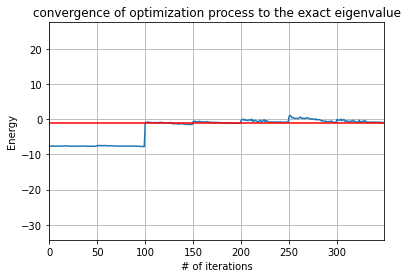

In [138]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [139]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

2it [00:00, 10.03it/s]

{'000': 331, '101': 34, '110': 177, '001': 88, '100': 86, '010': 177, '111': 122, '011': 9}
1.0
{'111': 262, '011': 73, '000': 344, '001': 44, '110': 58, '101': 92, '010': 108, '100': 43}
1.0


4it [00:00,  9.48it/s]

{'010': 475, '111': 28, '100': 271, '011': 74, '110': 22, '101': 117, '001': 19, '000': 18}
1.0
{'000': 321, '110': 188, '100': 96, '111': 101, '010': 169, '001': 104, '011': 7, '101': 38}
1.0
{'101': 118, '000': 135, '100': 278, '111': 41, '010': 270, '110': 92, '001': 15, '011': 75}
1.0


7it [00:00, 10.06it/s]


{'100': 104, '010': 167, '000': 316, '111': 117, '110': 179, '001': 104, '101': 33, '011': 4}
1.0
{'110': 182, '000': 342, '111': 120, '010': 155, '100': 93, '101': 31, '001': 96, '011': 5}
1.0


2it [00:00,  8.46it/s]

{'101': 75, '000': 319, '111': 205, '110': 206, '010': 133, '011': 15, '100': 71}
1.0
{'000': 178, '011': 123, '001': 137, '110': 243, '010': 32, '101': 57, '111': 156, '100': 98}
1.0


4it [00:00, 10.09it/s]

{'101': 224, '010': 448, '100': 247, '110': 28, '111': 28, '000': 37, '001': 9, '011': 3}
1.0
{'111': 171, '000': 319, '010': 144, '110': 197, '011': 22, '101': 103, '100': 68}
1.0
{'010': 293, '111': 148, '100': 301, '001': 36, '110': 53, '011': 42, '000': 106, '101': 45}
1.0


7it [00:00,  9.40it/s]


{'000': 317, '110': 220, '010': 137, '111': 194, '101': 76, '100': 68, '011': 12}
1.0
{'010': 134, '111': 168, '101': 88, '000': 312, '110': 232, '100': 74, '011': 16}
1.0


2it [00:00,  5.85it/s]

{'100': 223, '010': 418, '000': 101, '001': 88, '101': 103, '111': 38, '011': 6, '110': 47}
1.0
{'000': 201, '101': 200, '110': 22, '011': 208, '010': 180, '100': 144, '111': 69}
1.0


4it [00:00,  7.11it/s]

{'100': 237, '010': 461, '011': 36, '101': 104, '001': 39, '111': 53, '000': 51, '110': 43}
1.0
{'101': 118, '001': 104, '010': 364, '110': 55, '100': 216, '000': 121, '011': 6, '111': 40}
1.0


5it [00:00,  7.27it/s]

{'000': 137, '010': 362, '110': 104, '100': 191, '101': 181, '011': 31, '111': 8, '001': 10}
1.0
{'010': 391, '110': 73, '000': 103, '111': 55, '101': 92, '100': 215, '001': 92, '011': 3}
1.0


7it [00:01,  6.70it/s]


{'100': 233, '010': 349, '110': 59, '001': 89, '000': 136, '101': 108, '111': 46, '011': 4}
1.0


1it [00:00,  8.15it/s]

{'010': 301, '101': 240, '011': 95, '100': 52, '001': 137, '111': 98, '000': 81, '110': 20}
1.0


2it [00:00,  7.53it/s]

{'010': 146, '011': 237, '000': 241, '100': 105, '111': 64, '101': 173, '110': 48, '001': 10}
1.0


3it [00:00,  6.69it/s]

{'011': 127, '100': 64, '101': 307, '010': 304, '111': 35, '001': 109, '000': 70, '110': 8}
1.0


4it [00:00,  6.32it/s]

{'001': 161, '011': 87, '111': 97, '010': 304, '101': 240, '100': 45, '000': 69, '110': 21}
1.0


5it [00:00,  7.04it/s]

{'011': 178, '000': 100, '101': 372, '001': 7, '110': 124, '010': 191, '111': 23, '100': 29}
1.0


6it [00:00,  6.86it/s]

{'000': 90, '010': 278, '101': 224, '011': 111, '001': 135, '110': 19, '111': 106, '100': 61}
1.0


7it [00:00,  7.04it/s]


{'001': 145, '101': 241, '010': 286, '100': 61, '011': 86, '111': 107, '000': 80, '110': 18}
1.0


1it [00:00,  5.76it/s]

{'101': 72, '111': 190, '010': 286, '100': 192, '001': 163, '000': 113, '110': 4, '011': 4}
1.0


2it [00:00,  6.41it/s]

{'101': 198, '000': 257, '010': 137, '100': 79, '011': 132, '110': 82, '111': 85, '001': 54}
1.0


3it [00:00,  7.40it/s]

{'010': 363, '110': 85, '101': 200, '000': 44, '011': 87, '111': 49, '100': 99, '001': 97}
1.0


4it [00:00,  7.04it/s]

{'010': 296, '001': 172, '100': 181, '111': 192, '101': 62, '000': 114, '011': 4, '110': 3}
1.0


5it [00:00,  6.92it/s]

{'110': 150, '000': 123, '011': 117, '001': 96, '100': 157, '101': 122, '010': 177, '111': 82}
1.0


6it [00:00,  6.36it/s]

{'111': 186, '001': 200, '010': 268, '100': 182, '000': 108, '101': 73, '011': 5, '110': 2}
1.0


7it [00:01,  6.76it/s]


{'010': 300, '111': 176, '000': 98, '001': 185, '100': 181, '101': 80, '110': 4}
1.0


1it [00:00,  9.25it/s]

{'010': 198, '001': 62, '110': 137, '000': 277, '100': 197, '101': 60, '111': 85, '011': 8}
1.0


2it [00:00,  8.92it/s]

{'111': 177, '000': 281, '101': 134, '011': 146, '010': 100, '100': 118, '110': 33, '001': 35}
1.0
{'110': 97, '010': 417, '111': 87, '100': 214, '101': 57, '000': 77, '011': 39, '001': 36}
1.0


5it [00:00,  7.87it/s]

{'100': 212, '010': 223, '110': 156, '000': 250, '111': 62, '011': 10, '101': 61, '001': 50}
1.0
{'011': 74, '010': 332, '101': 112, '000': 339, '100': 145, '110': 7, '111': 14, '001': 1}
1.0


7it [00:00,  8.18it/s]


{'100': 194, '000': 269, '010': 214, '110': 136, '101': 72, '001': 58, '111': 76, '011': 5}
1.0
{'010': 211, '101': 60, '000': 262, '110': 149, '100': 182, '001': 60, '111': 88, '011': 12}
1.0


2it [00:00,  7.40it/s]

{'010': 373, '100': 237, '111': 49, '101': 105, '000': 114, '001': 83, '110': 60, '011': 3}
1.0
{'010': 166, '011': 207, '101': 223, '000': 175, '100': 137, '111': 102, '110': 12, '001': 2}
1.0


4it [00:00,  7.62it/s]

{'010': 461, '000': 44, '100': 238, '101': 105, '110': 58, '111': 52, '011': 22, '001': 44}
1.0
{'010': 377, '000': 92, '100': 265, '001': 77, '101': 115, '110': 59, '111': 36, '011': 3}
1.0


6it [00:00,  7.72it/s]

{'101': 163, '010': 346, '100': 205, '000': 147, '110': 106, '011': 32, '111': 20, '001': 5}
1.0
{'100': 271, '010': 363, '001': 76, '011': 3, '101': 95, '000': 107, '110': 54, '111': 55}
1.0


7it [00:00,  7.35it/s]


{'010': 369, '111': 45, '100': 278, '001': 81, '000': 105, '101': 96, '110': 48, '011': 2}
1.0


1it [00:00,  8.97it/s]

{'100': 306, '001': 241, '010': 211, '000': 63, '111': 46, '101': 52, '110': 84, '011': 21}
1.0


2it [00:00,  9.09it/s]

{'011': 156, '111': 17, '010': 84, '001': 51, '101': 241, '110': 127, '000': 285, '100': 63}
1.0


3it [00:00,  8.97it/s]

{'000': 40, '100': 272, '001': 214, '101': 95, '010': 187, '011': 98, '110': 108, '111': 10}
1.0


4it [00:00,  8.53it/s]

{'110': 79, '010': 214, '101': 45, '011': 25, '111': 66, '100': 271, '001': 261, '000': 63}
1.0


5it [00:00,  8.18it/s]

{'111': 83, '001': 75, '101': 236, '010': 288, '000': 180, '100': 145, '110': 14, '011': 3}
1.0


6it [00:00,  7.77it/s]

{'001': 288, '011': 27, '000': 60, '110': 95, '100': 244, '010': 206, '111': 54, '101': 50}
1.0


7it [00:00,  8.22it/s]


{'001': 285, '010': 215, '100': 241, '111': 65, '000': 61, '101': 55, '011': 30, '110': 72}
1.0


1it [00:00,  7.08it/s]

{'010': 268, '110': 96, '100': 277, '101': 116, '111': 91, '000': 107, '001': 58, '011': 11}
1.0


2it [00:00,  6.64it/s]

{'000': 135, '010': 179, '100': 275, '111': 155, '101': 142, '011': 88, '001': 21, '110': 29}
1.0


3it [00:00,  6.65it/s]

{'110': 158, '000': 87, '011': 43, '010': 271, '001': 22, '100': 235, '111': 168, '101': 40}
1.0


4it [00:00,  7.06it/s]

{'100': 290, '000': 113, '010': 242, '111': 79, '001': 54, '110': 98, '101': 139, '011': 9}
1.0


5it [00:00,  7.26it/s]

{'101': 179, '010': 320, '000': 56, '100': 342, '110': 17, '111': 50, '001': 10, '011': 50}
1.0


6it [00:00,  7.40it/s]

{'010': 244, '110': 92, '101': 132, '100': 325, '001': 67, '000': 88, '111': 69, '011': 7}
1.0


7it [00:00,  7.15it/s]


{'000': 106, '100': 291, '010': 262, '111': 78, '110': 95, '101': 122, '001': 59, '011': 11}
1.0


1it [00:00,  8.70it/s]

{'001': 174, '110': 155, '101': 111, '100': 227, '010': 237, '111': 17, '011': 36, '000': 67}
1.0


2it [00:00,  8.08it/s]

{'000': 245, '011': 70, '010': 167, '100': 320, '111': 45, '110': 133, '101': 28, '001': 16}
1.0


3it [00:00,  7.89it/s]

{'101': 41, '000': 52, '110': 229, '010': 270, '100': 166, '011': 98, '001': 87, '111': 81}
1.0


4it [00:00,  7.70it/s]

{'101': 100, '000': 96, '110': 157, '001': 156, '100': 236, '010': 224, '111': 19, '011': 36}
1.0


5it [00:00,  7.65it/s]

{'100': 241, '010': 399, '000': 81, '101': 205, '001': 45, '011': 40, '110': 7, '111': 6}
1.0


6it [00:00,  7.52it/s]

{'111': 15, '100': 256, '101': 107, '010': 221, '011': 25, '000': 65, '110': 168, '001': 167}
1.0


7it [00:00,  7.43it/s]


{'101': 77, '001': 175, '000': 91, '100': 264, '010': 209, '110': 158, '111': 16, '011': 34}
1.0


1it [00:00,  6.37it/s]

{'011': 71, '101': 223, '100': 200, '000': 42, '010': 282, '111': 16, '110': 74, '001': 116}
1.0


2it [00:00,  6.61it/s]

{'011': 65, '010': 289, '100': 393, '000': 147, '001': 25, '111': 49, '101': 24, '110': 32}
1.0
{'010': 248, '111': 76, '011': 181, '101': 184, '100': 133, '110': 123, '001': 19, '000': 60}
1.0
{'101': 230, '001': 113, '011': 64, '000': 58, '010': 299, '100': 185, '110': 54, '111': 21}
1.0


7it [00:00,  9.13it/s]

{'100': 134, '101': 197, '010': 303, '000': 92, '001': 153, '110': 46, '111': 91, '011': 8}
1.0
{'010': 292, '101': 249, '000': 50, '111': 38, '110': 61, '011': 57, '100': 174, '001': 103}
1.0
{'101': 233, '010': 280, '110': 64, '111': 19, '001': 106, '100': 220, '011': 59, '000': 43}
1.0


7it [00:00,  8.30it/s]
2it [00:00,  8.88it/s]

{'011': 117, '001': 139, '101': 203, '110': 49, '100': 197, '010': 216, '111': 55, '000': 48}
1.0
{'100': 400, '000': 147, '010': 232, '011': 101, '111': 83, '101': 4, '001': 17, '110': 40}
1.0


4it [00:00,  8.48it/s]

{'101': 275, '011': 193, '110': 160, '010': 216, '100': 67, '001': 47, '000': 46, '111': 20}
1.0
{'111': 63, '101': 224, '010': 222, '100': 182, '011': 127, '110': 45, '001': 127, '000': 34}
1.0
{'111': 187, '000': 177, '001': 327, '010': 239, '110': 28, '101': 24, '100': 37, '011': 5}
1.0


7it [00:00,  9.53it/s]


{'101': 184, '100': 209, '010': 231, '001': 126, '000': 41, '011': 127, '111': 63, '110': 43}
1.0
{'100': 184, '010': 240, '011': 111, '001': 141, '111': 68, '101': 190, '110': 45, '000': 45}
1.0


3it [00:00,  9.85it/s]

{'010': 403, '011': 102, '001': 208, '101': 165, '110': 13, '100': 111, '111': 16, '000': 6}
1.0
{'010': 348, '001': 128, '101': 61, '110': 10, '100': 245, '011': 134, '111': 15, '000': 83}
1.0
{'000': 212, '011': 265, '010': 167, '101': 99, '001': 63, '100': 102, '111': 87, '110': 29}
1.0


6it [00:00, 10.36it/s]

{'010': 399, '001': 251, '110': 13, '011': 84, '100': 116, '101': 149, '111': 9, '000': 3}
1.0
{'110': 201, '100': 71, '001': 152, '101': 253, '010': 196, '011': 78, '000': 42, '111': 31}
1.0
{'101': 150, '100': 108, '001': 238, '011': 94, '010': 408, '110': 12, '000': 4, '111': 10}
1.0


7it [00:00, 10.08it/s]


{'001': 230, '011': 88, '010': 386, '000': 4, '101': 168, '111': 17, '100': 122, '110': 9}
1.0


1it [00:00,  8.68it/s]

{'001': 307, '010': 174, '110': 82, '000': 124, '101': 170, '011': 111, '100': 53, '111': 3}
1.0


2it [00:00,  8.96it/s]

{'001': 416, '110': 23, '100': 186, '000': 40, '011': 94, '111': 55, '010': 155, '101': 55}
1.0
{'011': 276, '111': 95, '000': 283, '100': 128, '110': 28, '001': 124, '101': 60, '010': 30}
1.0


3it [00:00,  9.35it/s]

{'001': 340, '010': 178, '000': 124, '110': 75, '101': 176, '100': 62, '011': 67, '111': 2}
1.0


5it [00:00, 10.77it/s]

{'011': 51, '001': 201, '110': 87, '101': 300, '100': 167, '000': 10, '010': 177, '111': 31}
1.0
{'100': 54, '001': 352, '110': 77, '101': 159, '010': 170, '000': 112, '011': 94, '111': 6}
1.0


7it [00:00,  9.79it/s]


{'001': 348, '000': 115, '100': 64, '101': 165, '010': 179, '110': 68, '011': 82, '111': 3}
1.0


0it [00:00, ?it/s]

{'001': 241, '000': 95, '010': 363, '101': 198, '100': 77, '110': 27, '011': 12, '111': 11}
1.0


2it [00:00,  9.97it/s]

{'100': 182, '010': 212, '011': 178, '001': 312, '110': 14, '111': 26, '101': 73, '000': 27}
1.0
{'000': 394, '001': 114, '011': 176, '100': 74, '111': 115, '101': 76, '010': 57, '110': 18}
1.0


6it [00:00, 10.24it/s]

{'001': 258, '010': 370, '101': 211, '000': 73, '100': 71, '111': 12, '110': 24, '011': 5}
1.0
{'001': 188, '110': 226, '101': 256, '100': 129, '010': 198, '000': 10, '111': 10, '011': 7}
1.0
{'010': 386, '001': 252, '110': 33, '101': 200, '000': 79, '100': 58, '011': 7, '111': 9}
1.0


7it [00:00, 10.52it/s]


{'010': 396, '100': 58, '001': 253, '101': 189, '000': 75, '110': 32, '011': 6, '111': 15}
1.0


2it [00:00, 10.56it/s]

{'100': 105, '010': 394, '001': 265, '101': 127, '111': 46, '011': 83, '110': 3, '000': 1}
1.0
{'011': 122, '000': 135, '001': 155, '100': 217, '010': 315, '101': 38, '110': 26, '111': 16}
1.0
{'100': 58, '011': 241, '000': 188, '010': 167, '101': 133, '001': 110, '111': 75, '110': 52}
1.0


4it [00:00, 10.13it/s]

{'001': 231, '010': 384, '111': 35, '101': 158, '011': 104, '100': 111, '110': 1}
1.0
{'101': 387, '010': 232, '100': 46, '110': 147, '011': 128, '000': 55, '111': 4, '001': 25}
1.0


6it [00:00,  8.97it/s]

{'101': 170, '010': 368, '111': 32, '001': 271, '100': 94, '011': 89}
1.0


7it [00:00,  9.38it/s]


{'010': 345, '101': 142, '011': 118, '001': 267, '111': 47, '100': 103, '110': 1, '000': 1}
1.0


0it [00:00, ?it/s]

{'101': 93, '001': 211, '100': 198, '010': 461, '011': 25, '111': 9, '110': 11, '000': 16}
1.0


2it [00:00,  9.76it/s]

{'010': 149, '011': 346, '101': 154, '001': 109, '000': 107, '110': 3, '100': 135, '111': 21}
1.0


3it [00:00,  9.29it/s]

{'110': 69, '010': 326, '100': 154, '011': 91, '000': 159, '111': 38, '101': 56, '001': 131}
1.0
{'001': 229, '010': 438, '100': 195, '000': 21, '101': 93, '110': 8, '011': 23, '111': 17}
1.0


5it [00:00, 10.18it/s]

{'010': 239, '110': 215, '101': 222, '100': 127, '000': 89, '001': 92, '111': 16, '011': 24}
1.0
{'100': 197, '010': 468, '011': 33, '101': 85, '111': 12, '001': 194, '000': 18, '110': 17}
1.0


7it [00:00,  9.67it/s]


{'001': 214, '111': 9, '100': 183, '010': 478, '110': 8, '011': 24, '101': 97, '000': 11}
1.0


0it [00:00, ?it/s]

{'010': 553, '101': 243, '011': 59, '001': 119, '100': 31, '000': 17, '110': 2}
1.0


2it [00:00, 11.37it/s]

{'011': 408, '100': 255, '001': 112, '101': 59, '010': 155, '111': 1, '000': 32, '110': 2}
1.0
{'010': 184, '001': 129, '000': 353, '011': 35, '111': 144, '100': 35, '101': 135, '110': 9}
1.0


4it [00:00, 10.65it/s]

{'010': 515, '101': 293, '001': 110, '011': 52, '111': 5, '000': 28, '100': 16, '110': 5}
1.0
{'101': 247, '010': 305, '110': 246, '001': 121, '011': 28, '100': 35, '000': 8, '111': 34}
1.0
{'001': 127, '101': 238, '010': 527, '011': 75, '111': 2, '000': 26, '100': 23, '110': 6}
1.0


7it [00:00, 11.15it/s]


{'000': 19, '010': 523, '001': 125, '101': 251, '011': 52, '100': 51, '110': 3}
1.0


1it [00:00,  7.40it/s]

{'001': 389, '010': 325, '011': 93, '000': 23, '111': 68, '101': 56, '100': 27, '110': 43}
1.0


2it [00:00,  8.45it/s]

{'000': 136, '010': 320, '001': 305, '011': 86, '100': 79, '111': 48, '110': 43, '101': 7}
1.0


3it [00:00,  8.99it/s]

{'011': 358, '000': 246, '110': 51, '010': 108, '001': 123, '101': 112, '100': 26}
1.0
{'001': 388, '010': 335, '111': 62, '011': 89, '110': 33, '000': 21, '101': 61, '100': 35}
1.0


5it [00:00,  9.86it/s]

{'010': 278, '111': 124, '101': 250, '001': 240, '000': 24, '011': 16, '100': 32, '110': 60}
1.0


6it [00:00,  9.44it/s]

{'101': 68, '001': 397, '011': 95, '010': 324, '000': 20, '110': 41, '111': 57, '100': 22}
1.0


7it [00:00,  9.24it/s]


{'001': 378, '011': 94, '010': 321, '110': 42, '111': 67, '101': 63, '100': 41, '000': 18}
1.0


1it [00:00,  6.52it/s]

{'010': 298, '001': 209, '100': 96, '101': 164, '011': 196, '000': 42, '111': 15, '110': 4}
1.0


2it [00:00,  8.10it/s]

{'001': 57, '011': 197, '010': 305, '100': 258, '000': 152, '110': 11, '101': 30, '111': 14}
1.0


3it [00:00,  7.98it/s]

{'011': 195, '010': 218, '001': 218, '100': 61, '000': 75, '101': 145, '111': 72, '110': 40}
1.0
{'000': 39, '010': 267, '011': 184, '111': 18, '001': 233, '101': 177, '100': 105, '110': 1}
1.0


6it [00:00,  8.32it/s]

{'011': 134, '000': 117, '010': 131, '001': 76, '101': 303, '111': 97, '110': 139, '100': 27}
1.0
{'010': 293, '001': 207, '000': 31, '011': 203, '101': 172, '100': 97, '111': 18, '110': 3}
1.0


7it [00:00,  8.05it/s]


{'010': 277, '000': 29, '100': 109, '101': 193, '001': 198, '011': 196, '111': 20, '110': 2}
1.0


1it [00:00,  8.52it/s]

{'001': 303, '010': 316, '000': 72, '100': 56, '101': 115, '110': 65, '111': 80, '011': 17}
1.0


3it [00:00,  9.54it/s]

{'000': 293, '100': 147, '001': 74, '011': 202, '110': 108, '010': 140, '101': 28, '111': 32}
1.0
{'000': 63, '101': 159, '001': 179, '010': 334, '011': 144, '100': 116, '111': 25, '110': 4}
1.0
{'001': 299, '111': 86, '010': 293, '101': 106, '000': 86, '100': 61, '110': 72, '011': 21}

5it [00:00,  8.70it/s]


1.0
{'110': 233, '010': 172, '101': 201, '100': 63, '001': 209, '000': 79, '111': 58, '011': 9}
1.0


7it [00:00,  9.01it/s]


{'100': 62, '010': 335, '110': 59, '001': 306, '011': 18, '101': 101, '000': 80, '111': 63}
1.0
{'010': 328, '001': 301, '110': 63, '100': 53, '111': 66, '101': 116, '000': 81, '011': 16}
1.0


2it [00:00,  9.76it/s]

{'001': 359, '010': 256, '011': 52, '110': 164, '100': 91, '111': 44, '101': 33, '000': 25}
1.0
{'010': 246, '000': 260, '110': 109, '001': 114, '111': 91, '100': 80, '011': 69, '101': 55}
1.0
{'100': 248, '001': 89, '101': 80, '000': 78, '010': 213, '011': 307, '110': 9}
1.0


4it [00:00, 10.85it/s]

{'001': 374, '011': 58, '010': 247, '111': 38, '110': 145, '000': 19, '101': 47, '100': 96}
1.0
{'101': 290, '111': 35, '010': 165, '110': 241, '000': 65, '011': 62, '001': 100, '100': 66}
1.0


7it [00:00,  9.83it/s]


{'001': 357, '010': 261, '110': 149, '111': 54, '000': 14, '101': 46, '100': 86, '011': 57}
1.0
{'101': 41, '001': 350, '010': 242, '111': 45, '100': 120, '110': 162, '011': 51, '000': 13}
1.0


2it [00:00,  7.79it/s]

{'011': 94, '001': 217, '010': 399, '100': 113, '101': 173, '111': 18, '110': 5, '000': 5}
1.0
{'100': 264, '010': 460, '000': 110, '011': 46, '001': 116, '110': 21, '101': 5, '111': 2}
1.0


4it [00:00,  9.17it/s]

{'000': 207, '110': 27, '011': 261, '101': 107, '111': 75, '010': 167, '001': 75, '100': 105}
1.0
{'001': 219, '111': 14, '101': 179, '010': 389, '011': 89, '100': 123, '110': 8, '000': 3}
1.0


7it [00:00,  9.68it/s]

{'101': 264, '011': 76, '010': 185, '001': 161, '110': 197, '100': 80, '000': 35, '111': 26}
1.0
{'010': 408, '100': 126, '001': 207, '101': 158, '011': 105, '111': 12, '110': 6, '000': 2}
1.0
{'010': 402, '011': 86, '100': 97, '001': 230, '101': 172, '111': 13, '110': 19, '000': 5}
1.0


7it [00:00,  9.34it/s]
3it [00:00, 11.49it/s]

{'001': 237, '010': 407, '100': 105, '101': 155, '011': 94, '111': 11, '110': 11, '000': 4}
1.0
{'000': 124, '010': 447, '001': 112, '100': 273, '101': 5, '110': 17, '111': 4, '011': 42}
1.0
{'101': 130, '010': 190, '100': 93, '110': 30, '011': 322, '000': 193, '001': 19, '111': 47}
1.0


5it [00:00,  9.55it/s]

{'010': 396, '011': 101, '101': 171, '001': 223, '111': 7, '100': 109, '000': 2, '110': 15}
1.0
{'110': 216, '101': 261, '010': 187, '011': 80, '100': 73, '001': 148, '000': 33, '111': 26}
1.0
{'101': 162, '001': 252, '010': 368, '100': 122, '011': 100, '110': 12, '111': 8}
1.0


7it [00:00, 10.35it/s]


{'001': 230, '010': 405, '100': 125, '101': 170, '011': 73, '111': 7, '110': 11, '000': 3}
1.0


1it [00:00,  9.99it/s]

{'011': 102, '001': 224, '010': 394, '111': 13, '100': 113, '101': 165, '000': 4, '110': 9}
1.0


2it [00:00,  9.93it/s]

{'100': 296, '011': 42, '010': 442, '000': 112, '101': 3, '001': 112, '110': 16, '111': 1}
1.0


3it [00:00,  9.13it/s]

{'000': 185, '100': 94, '011': 301, '101': 140, '110': 29, '010': 197, '001': 25, '111': 53}
1.0


4it [00:00,  9.06it/s]

{'001': 224, '101': 178, '100': 130, '110': 17, '010': 362, '011': 101, '111': 10, '000': 2}
1.0


5it [00:00,  8.69it/s]

{'110': 261, '010': 140, '001': 349, '111': 44, '100': 71, '000': 42, '011': 41, '101': 76}
1.0
{'100': 95, '010': 373, '011': 103, '001': 244, '111': 14, '101': 178, '110': 14, '000': 3}
1.0


7it [00:00,  8.95it/s]


{'011': 84, '010': 394, '100': 96, '001': 233, '101': 186, '110': 13, '111': 14, '000': 4}
1.0


1it [00:00,  8.23it/s]

{'010': 497, '101': 115, '100': 78, '011': 202, '001': 62, '110': 49, '111': 16, '000': 5}
1.0
{'100': 183, '010': 592, '111': 39, '011': 121, '001': 55, '110': 16, '000': 17, '101': 1}
1.0


3it [00:00, 10.67it/s]

{'010': 184, '101': 83, '011': 201, '000': 327, '111': 38, '001': 52, '110': 132, '100': 7}
1.0
{'001': 76, '011': 207, '010': 493, '101': 114, '100': 66, '111': 17, '110': 46, '000': 5}
1.0
{'010': 231, '110': 340, '101': 114, '011': 146, '111': 66, '000': 47, '100': 32, '001': 48}
1.0


5it [00:00, 10.66it/s]

{'010': 507, '101': 101, '011': 191, '100': 78, '001': 73, '000': 10, '110': 52, '111': 12}
1.0


7it [00:00,  9.95it/s]


{'010': 483, '011': 198, '001': 72, '101': 118, '111': 14, '000': 11, '100': 83, '110': 45}
1.0


2it [00:00, 12.56it/s]

{'010': 390, '100': 139, '001': 309, '101': 109, '011': 37, '000': 8, '110': 7, '111': 25}
1.0
{'111': 26, '000': 194, '010': 344, '100': 244, '001': 115, '011': 98, '110': 3}
1.0


4it [00:00,  8.86it/s]

{'111': 62, '110': 60, '010': 215, '000': 159, '011': 318, '100': 58, '001': 64, '101': 88}
1.0
{'001': 300, '101': 130, '010': 390, '100': 130, '111': 27, '011': 40, '110': 3, '000': 4}
1.0


7it [00:00,  9.93it/s]

{'010': 175, '100': 58, '110': 221, '001': 155, '101': 285, '000': 65, '111': 2, '011': 63}
1.0
{'001': 309, '010': 350, '100': 134, '011': 45, '101': 148, '111': 31, '110': 5, '000': 2}
1.0
{'001': 290, '011': 43, '101': 119, '100': 141, '010': 404, '111': 17, '110': 7, '000': 3}
1.0


7it [00:00,  9.80it/s]
2it [00:00, 12.16it/s]

{'101': 136, '100': 147, '010': 318, '001': 125, '011': 89, '111': 129, '000': 34, '110': 46}
1.0
{'000': 112, '100': 309, '010': 391, '001': 8, '011': 48, '110': 37, '111': 116, '101': 3}
1.0
{'000': 82, '100': 163, '101': 177, '011': 200, '010': 266, '110': 45, '111': 90, '001': 1}
1.0


6it [00:00, 10.19it/s]

{'001': 122, '010': 320, '101': 117, '000': 37, '100': 166, '110': 59, '111': 131, '011': 72}
1.0
{'011': 203, '110': 212, '000': 84, '101': 189, '010': 161, '100': 122, '001': 51, '111': 2}
1.0
{'010': 339, '101': 118, '100': 171, '111': 121, '001': 116, '011': 91, '000': 25, '110': 43}
1.0


7it [00:00, 10.28it/s]


{'010': 335, '100': 159, '101': 138, '011': 85, '001': 94, '000': 30, '111': 137, '110': 46}
1.0


1it [00:00,  8.20it/s]

{'001': 313, '010': 379, '110': 48, '100': 125, '011': 22, '101': 83, '111': 52, '000': 2}
1.0


3it [00:00,  9.47it/s]

{'111': 95, '010': 308, '001': 139, '000': 152, '100': 221, '011': 106, '101': 1, '110': 2}
1.0
{'010': 191, '000': 172, '011': 270, '111': 59, '100': 109, '101': 80, '110': 60, '001': 83}
1.0


5it [00:00,  9.24it/s]

{'010': 354, '100': 119, '001': 333, '110': 47, '011': 20, '101': 93, '111': 57, '000': 1}
1.0
{'101': 235, '110': 320, '001': 170, '000': 34, '011': 68, '010': 105, '100': 90, '111': 2}
1.0


7it [00:00,  9.10it/s]


{'001': 292, '101': 94, '010': 346, '100': 140, '111': 69, '110': 51, '011': 27, '000': 5}
1.0
{'001': 313, '000': 7, '010': 376, '111': 66, '100': 118, '110': 47, '101': 79, '011': 18}
1.0


0it [00:00, ?it/s]

{'011': 164, '100': 158, '010': 170, '110': 44, '101': 173, '000': 141, '001': 110, '111': 64}
1.0


2it [00:00, 13.33it/s]

{'000': 226, '100': 305, '111': 87, '011': 11, '010': 324, '001': 63, '101': 5, '110': 3}
1.0
{'011': 265, '101': 156, '010': 216, '000': 74, '110': 174, '111': 90, '100': 37, '001': 12}
1.0


4it [00:00, 10.03it/s]

{'101': 178, '001': 123, '010': 172, '110': 50, '000': 127, '100': 145, '011': 163, '111': 66}
1.0
{'011': 192, '101': 167, '010': 20, '110': 169, '000': 224, '111': 22, '100': 71, '001': 159}
1.0


7it [00:00,  9.77it/s]


{'111': 61, '010': 173, '100': 135, '011': 158, '101': 173, '001': 123, '000': 150, '110': 51}
1.0
{'100': 154, '111': 61, '001': 115, '010': 160, '011': 171, '000': 131, '101': 183, '110': 49}
1.0


2it [00:00,  9.00it/s]

{'001': 286, '010': 348, '101': 155, '111': 28, '100': 130, '011': 40, '000': 8, '110': 29}
1.0
{'100': 249, '010': 350, '011': 83, '000': 145, '001': 145, '111': 50, '101': 2}
1.0
{'111': 99, '001': 54, '100': 65, '010': 191, '011': 278, '000': 214, '101': 53, '110': 70}
1.0


4it [00:00,  9.64it/s]

{'001': 303, '010': 371, '100': 123, '011': 44, '111': 22, '101': 123, '110': 28, '000': 10}
1.0
{'110': 235, '101': 269, '010': 140, '001': 183, '100': 43, '000': 79, '011': 64, '111': 11}
1.0


7it [00:00,  9.50it/s]


{'010': 342, '001': 311, '100': 137, '101': 132, '000': 9, '111': 18, '011': 53, '110': 22}
1.0
{'100': 121, '001': 261, '010': 381, '101': 150, '011': 50, '110': 28, '000': 10, '111': 23}
1.0


2it [00:00,  9.85it/s]

{'101': 159, '001': 235, '010': 336, '100': 133, '011': 57, '111': 59, '000': 36, '110': 9}
1.0
{'100': 294, '010': 357, '000': 110, '001': 139, '111': 53, '011': 59, '110': 11, '101': 1}
1.0


3it [00:00,  8.73it/s]

{'011': 268, '111': 102, '010': 155, '110': 70, '101': 98, '000': 243, '100': 62, '001': 26}
1.0
{'001': 233, '100': 143, '010': 341, '101': 128, '011': 59, '000': 42, '111': 73, '110': 5}
1.0


6it [00:00,  9.07it/s]

{'101': 310, '010': 143, '110': 176, '011': 119, '001': 100, '000': 151, '100': 23, '111': 2}
1.0
{'100': 135, '001': 248, '101': 162, '111': 64, '010': 319, '110': 7, '011': 52, '000': 37}
1.0


7it [00:00,  9.11it/s]


{'100': 130, '010': 331, '001': 233, '101': 148, '111': 64, '011': 80, '000': 26, '110': 12}
1.0


2it [00:00, 10.76it/s]

{'001': 247, '101': 234, '011': 41, '010': 347, '100': 124, '111': 26, '000': 2, '110': 3}
1.0
{'010': 313, '000': 126, '001': 114, '100': 320, '011': 60, '101': 42, '110': 38, '111': 11}
1.0


5it [00:00,  9.86it/s]

{'111': 176, '011': 250, '010': 193, '001': 52, '110': 84, '000': 133, '101': 84, '100': 52}
1.0
{'001': 249, '010': 338, '101': 217, '100': 128, '111': 38, '011': 46, '110': 4, '000': 4}
1.0
{'011': 83, '010': 176, '100': 77, '101': 239, '000': 53, '001': 201, '110': 180, '111': 15}
1.0


7it [00:00,  9.82it/s]


{'010': 338, '011': 48, '001': 270, '100': 122, '101': 201, '111': 34, '000': 7, '110': 4}
1.0
{'010': 342, '100': 138, '101': 200, '111': 39, '001': 258, '011': 42, '000': 2, '110': 3}
1.0


2it [00:00,  9.44it/s]

{'101': 239, '001': 383, '010': 152, '100': 173, '011': 59, '000': 6, '110': 10, '111': 2}
1.0
{'000': 161, '100': 354, '001': 244, '101': 56, '010': 186, '110': 13, '011': 10}
1.0


4it [00:00,  9.13it/s]

{'011': 351, '101': 126, '110': 117, '001': 95, '111': 123, '000': 80, '100': 64, '010': 68}
1.0
{'010': 149, '001': 402, '101': 243, '100': 173, '011': 47, '000': 3, '110': 7}
1.0


7it [00:00,  9.37it/s]

{'110': 87, '000': 116, '001': 330, '100': 48, '011': 13, '101': 332, '010': 59, '111': 39}
1.0
{'101': 258, '010': 160, '001': 391, '011': 55, '100': 147, '000': 7, '111': 1, '110': 5}
1.0
{'010': 142, '001': 412, '101': 246, '011': 51, '100': 153, '110': 6, '000': 10, '111': 4}
1.0


7it [00:00,  9.31it/s]
3it [00:00,  9.99it/s]

{'011': 58, '100': 145, '010': 330, '101': 217, '001': 214, '111': 50, '000': 7, '110': 3}
1.0
{'001': 102, '100': 290, '010': 322, '011': 100, '000': 126, '111': 42, '101': 27, '110': 15}
1.0
{'000': 132, '010': 207, '011': 232, '100': 57, '111': 197, '110': 81, '001': 77, '101': 41}
1.0


6it [00:00, 11.31it/s]

{'010': 368, '001': 219, '101': 203, '100': 151, '111': 38, '011': 36, '110': 5, '000': 4}
1.0
{'001': 187, '110': 205, '010': 147, '101': 229, '100': 123, '000': 40, '111': 56, '011': 37}
1.0
{'010': 339, '100': 162, '001': 233, '101': 178, '011': 46, '111': 55, '000': 8, '110': 3}
1.0


7it [00:00, 10.14it/s]


{'010': 355, '111': 38, '001': 238, '101': 190, '100': 142, '011': 50, '000': 8, '110': 3}
1.0


1it [00:00,  8.88it/s]

{'111': 97, '010': 304, '001': 123, '000': 160, '100': 140, '101': 113, '011': 82, '110': 5}
1.0


2it [00:00,  8.28it/s]

{'000': 259, '100': 253, '010': 229, '111': 74, '011': 147, '001': 27, '110': 28, '101': 7}
1.0


3it [00:00,  8.77it/s]

{'011': 134, '010': 355, '100': 89, '111': 157, '110': 63, '001': 96, '101': 57, '000': 73}
1.0
{'010': 316, '000': 163, '011': 54, '100': 141, '001': 134, '111': 98, '101': 113, '110': 5}
1.0


5it [00:00,  9.76it/s]

{'101': 165, '111': 148, '010': 143, '110': 176, '001': 64, '100': 306, '011': 22}
1.0


7it [00:00,  7.46it/s]


{'001': 140, '000': 144, '100': 150, '010': 303, '111': 91, '011': 72, '101': 117, '110': 7}
1.0
{'101': 118, '111': 97, '010': 311, '100': 151, '001': 138, '000': 142, '011': 60, '110': 7}
1.0


2it [00:00,  9.25it/s]

{'010': 379, '101': 194, '001': 188, '100': 155, '111': 56, '011': 42, '000': 10}
1.0
{'100': 316, '101': 47, '010': 287, '001': 143, '000': 83, '011': 93, '110': 22, '111': 33}
1.0


4it [00:00,  8.89it/s]

{'111': 216, '011': 230, '110': 72, '000': 234, '010': 122, '100': 77, '001': 48, '101': 25}
1.0
{'100': 154, '010': 359, '011': 40, '001': 203, '101': 193, '111': 69, '000': 6}
1.0


6it [00:00,  5.94it/s]

{'001': 283, '111': 38, '110': 163, '010': 189, '101': 137, '100': 57, '000': 86, '011': 71}
1.0
{'010': 365, '111': 59, '001': 200, '101': 195, '100': 154, '000': 7, '011': 44}
1.0


7it [00:01,  6.49it/s]


{'101': 195, '001': 214, '100': 165, '010': 340, '011': 41, '111': 66, '000': 3}
1.0


1it [00:00,  5.40it/s]

{'110': 30, '001': 257, '010': 304, '111': 95, '101': 160, '100': 148, '011': 17, '000': 13}
1.0


2it [00:00,  5.05it/s]

{'001': 96, '000': 169, '101': 99, '011': 127, '100': 191, '010': 219, '111': 81, '110': 42}
1.0


3it [00:00,  5.98it/s]

{'100': 152, '110': 51, '010': 179, '111': 226, '000': 140, '001': 75, '011': 165, '101': 36}
1.0


4it [00:00,  6.32it/s]

{'100': 150, '010': 301, '001': 249, '111': 100, '101': 165, '000': 13, '011': 15, '110': 31}
1.0


5it [00:00,  6.45it/s]

{'010': 240, '001': 133, '110': 122, '100': 94, '101': 235, '011': 44, '111': 80, '000': 76}
1.0


6it [00:00,  6.67it/s]

{'100': 180, '111': 98, '010': 303, '110': 34, '101': 138, '001': 251, '011': 10, '000': 10}
1.0


7it [00:01,  6.69it/s]


{'101': 164, '010': 272, '001': 251, '100': 161, '111': 105, '110': 49, '000': 13, '011': 9}
1.0


1it [00:00,  9.95it/s]

{'100': 95, '001': 340, '010': 435, '111': 30, '101': 93, '110': 21, '011': 5, '000': 5}
1.0


2it [00:00,  8.93it/s]

{'111': 37, '010': 274, '000': 173, '001': 147, '100': 205, '011': 175, '101': 4, '110': 9}
1.0
{'011': 211, '000': 204, '001': 141, '111': 100, '010': 218, '101': 42, '110': 75, '100': 33}
1.0


4it [00:00,  8.79it/s]

{'010': 419, '000': 7, '001': 324, '101': 119, '100': 104, '111': 35, '110': 5, '011': 11}
1.0


5it [00:00,  8.34it/s]

{'100': 58, '010': 162, '110': 295, '001': 175, '011': 23, '101': 266, '111': 20, '000': 25}
1.0


7it [00:00,  9.33it/s]

{'100': 93, '010': 401, '001': 303, '101': 142, '000': 12, '011': 8, '111': 51, '110': 14}
1.0
{'001': 325, '100': 96, '010': 429, '101': 102, '110': 13, '011': 11, '111': 44, '000': 4}
1.0


7it [00:00,  9.10it/s]
3it [00:00,  9.85it/s]

{'011': 144, '001': 111, '101': 160, '000': 27, '111': 45, '010': 276, '100': 198, '110': 63}
1.0
{'101': 131, '010': 260, '100': 216, '000': 11, '001': 134, '110': 28, '011': 140, '111': 104}
1.0
{'111': 162, '000': 193, '011': 130, '110': 257, '010': 87, '001': 123, '100': 21, '101': 51}
1.0


6it [00:00, 10.48it/s]

{'010': 273, '001': 112, '101': 189, '011': 125, '000': 26, '100': 182, '110': 79, '111': 38}
1.0
{'110': 305, '001': 223, '101': 102, '000': 130, '111': 99, '011': 58, '100': 75, '010': 32}
1.0
{'010': 266, '111': 50, '011': 139, '001': 111, '100': 197, '101': 173, '110': 66, '000': 22}
1.0


7it [00:00,  9.98it/s]


{'100': 175, '101': 175, '110': 76, '010': 272, '111': 49, '001': 109, '011': 146, '000': 22}
1.0


0it [00:00, ?it/s]

{'100': 108, '111': 85, '101': 236, '010': 216, '001': 276, '000': 39, '011': 64}
1.0


2it [00:00,  8.85it/s]

{'111': 47, '100': 335, '110': 55, '011': 46, '000': 164, '010': 221, '001': 142, '101': 14}
1.0


3it [00:00,  8.90it/s]

{'011': 226, '001': 79, '111': 309, '100': 48, '000': 95, '010': 150, '101': 53, '110': 64}
1.0


4it [00:00,  8.59it/s]

{'101': 239, '010': 225, '001': 255, '111': 87, '100': 120, '011': 61, '000': 37}
1.0


6it [00:00,  9.66it/s]

{'101': 271, '001': 256, '011': 63, '110': 96, '100': 124, '010': 117, '111': 86, '000': 11}
1.0
{'001': 291, '010': 228, '101': 240, '011': 61, '100': 106, '111': 68, '000': 30}
1.0


7it [00:00,  9.09it/s]


{'101': 257, '100': 115, '010': 223, '111': 79, '001': 264, '000': 30, '011': 56}
1.0


1it [00:00,  9.87it/s]

{'001': 209, '010': 327, '111': 64, '101': 209, '100': 154, '011': 46, '000': 13, '110': 2}
1.0


2it [00:00,  8.21it/s]

{'010': 263, '100': 317, '011': 112, '101': 47, '001': 100, '000': 131, '111': 32, '110': 22}
1.0


3it [00:00,  7.56it/s]

{'010': 199, '111': 233, '001': 79, '011': 191, '000': 122, '101': 52, '110': 85, '100': 63}
1.0
{'001': 195, '011': 44, '010': 340, '100': 149, '111': 65, '101': 218, '000': 10, '110': 3}
1.0
{'101': 246, '010': 156, '001': 170, '111': 83, '100': 97, '110': 196, '011': 30, '000': 46}
1.0


6it [00:00,  8.98it/s]

{'001': 227, '100': 146, '010': 314, '101': 192, '000': 15, '111': 69, '011': 58, '110': 3}
1.0


7it [00:00,  8.89it/s]


{'010': 327, '001': 237, '101': 189, '100': 143, '111': 57, '011': 59, '000': 10, '110': 2}
1.0


1it [00:00,  8.77it/s]

{'100': 134, '010': 344, '001': 185, '101': 183, '111': 87, '000': 43, '011': 47, '110': 1}
1.0


2it [00:00,  8.14it/s]

{'011': 143, '010': 233, '000': 116, '001': 131, '111': 56, '100': 284, '110': 29, '101': 32}
1.0


3it [00:00,  7.49it/s]

{'111': 269, '100': 83, '110': 64, '000': 184, '001': 91, '011': 128, '010': 192, '101': 13}
1.0


4it [00:00,  7.21it/s]

{'111': 88, '001': 206, '010': 338, '100': 170, '011': 28, '101': 150, '000': 43, '110': 1}
1.0
{'001': 260, '010': 153, '100': 140, '011': 21, '111': 90, '101': 153, '110': 176, '000': 31}
1.0


6it [00:00,  7.51it/s]

{'010': 311, '100': 163, '101': 199, '111': 88, '001': 186, '011': 43, '000': 30, '110': 4}
1.0


7it [00:00,  7.67it/s]


{'101': 180, '010': 322, '111': 84, '000': 39, '001': 191, '100': 162, '110': 2, '011': 44}
1.0


1it [00:00,  7.66it/s]

{'010': 323, '001': 281, '100': 144, '011': 68, '101': 156, '111': 41, '110': 10, '000': 1}
1.0


2it [00:00,  7.49it/s]

{'100': 275, '010': 271, '111': 35, '000': 157, '001': 122, '110': 4, '011': 119, '101': 41}
1.0


3it [00:00,  7.77it/s]

{'010': 180, '011': 270, '000': 123, '001': 81, '111': 169, '101': 53, '110': 82, '100': 66}
1.0
{'101': 179, '001': 274, '010': 310, '100': 142, '011': 85, '110': 4, '111': 29, '000': 1}
1.0


5it [00:00,  7.80it/s]

{'101': 207, '001': 234, '011': 49, '110': 187, '010': 142, '100': 90, '000': 58, '111': 57}
1.0


6it [00:00,  7.70it/s]

{'100': 159, '001': 266, '010': 308, '111': 40, '011': 57, '101': 182, '110': 8, '000': 4}
1.0


7it [00:00,  7.95it/s]


{'010': 323, '001': 288, '100': 148, '101': 159, '110': 7, '011': 53, '111': 42, '000': 4}
1.0


1it [00:00,  8.95it/s]

{'100': 77, '001': 219, '101': 248, '010': 368, '011': 69, '111': 35, '000': 7, '110': 1}
1.0


2it [00:00,  8.73it/s]

{'010': 321, '100': 238, '000': 119, '001': 115, '101': 123, '011': 75, '110': 19, '111': 14}
1.0


3it [00:00,  8.07it/s]

{'011': 241, '111': 236, '101': 60, '000': 199, '110': 47, '100': 31, '010': 175, '001': 35}
1.0


4it [00:00,  7.53it/s]

{'010': 352, '111': 39, '001': 211, '011': 68, '101': 239, '100': 102, '000': 13}
1.0


5it [00:00,  7.80it/s]

{'010': 142, '111': 72, '001': 201, '110': 205, '101': 262, '000': 51, '100': 54, '011': 37}
1.0
{'001': 212, '101': 276, '010': 313, '011': 74, '100': 106, '111': 31, '110': 1, '000': 11}
1.0


7it [00:00,  8.25it/s]


{'010': 364, '101': 261, '001': 204, '111': 50, '011': 56, '100': 82, '000': 6, '110': 1}
1.0


1it [00:00,  9.24it/s]

{'010': 315, '101': 346, '100': 87, '001': 187, '011': 42, '000': 8, '111': 33, '110': 6}
1.0


2it [00:00,  6.99it/s]

{'100': 230, '010': 278, '110': 33, '000': 108, '011': 111, '001': 95, '101': 160, '111': 9}
1.0


3it [00:00,  7.35it/s]

{'010': 196, '011': 178, '110': 55, '111': 265, '000': 190, '001': 26, '100': 35, '101': 79}
1.0
{'010': 370, '101': 288, '001': 191, '100': 82, '011': 43, '111': 36, '000': 10, '110': 4}
1.0


5it [00:00,  8.24it/s]

{'001': 192, '110': 198, '101': 279, '010': 162, '111': 49, '100': 70, '000': 35, '011': 39}
1.0


7it [00:00,  8.55it/s]

{'010': 362, '101': 303, '111': 30, '011': 40, '001': 179, '100': 99, '110': 4, '000': 7}
1.0
{'101': 294, '010': 377, '001': 180, '011': 49, '100': 77, '111': 32, '000': 11, '110': 4}
1.0



2it [00:00,  8.79it/s]

{'011': 34, '010': 263, '101': 376, '100': 107, '001': 220, '000': 16, '110': 1, '111': 7}
1.0
{'010': 256, '100': 334, '000': 170, '011': 89, '101': 122, '110': 4, '001': 48, '111': 1}
1.0
{'111': 219, '011': 207, '100': 38, '101': 140, '010': 246, '000': 69, '001': 58, '110': 47}
1.0


4it [00:00, 10.11it/s]

{'010': 312, '101': 354, '111': 5, '000': 19, '001': 208, '100': 89, '011': 36, '110': 1}
1.0
{'010': 151, '101': 327, '100': 92, '000': 15, '110': 175, '001': 227, '111': 20, '011': 17}
1.0


7it [00:00,  9.09it/s]


{'010': 284, '001': 226, '101': 347, '100': 90, '000': 15, '011': 54, '111': 5, '110': 3}
1.0
{'001': 209, '101': 396, '010': 278, '100': 86, '000': 20, '111': 6, '011': 29}
1.0


3it [00:00,  9.09it/s]

{'101': 360, '001': 195, '010': 337, '100': 65, '011': 43, '000': 18, '110': 3, '111': 3}
1.0
{'000': 194, '010': 269, '011': 101, '100': 262, '110': 5, '101': 114, '001': 78, '111': 1}
1.0
{'011': 202, '000': 117, '100': 30, '010': 250, '101': 124, '111': 204, '001': 62, '110': 35}
1.0


5it [00:00,  8.66it/s]

{'011': 40, '100': 70, '111': 7, '101': 368, '010': 304, '001': 213, '110': 2, '000': 20}
1.0
{'101': 329, '111': 36, '011': 19, '100': 69, '001': 258, '110': 130, '010': 174, '000': 9}
1.0


7it [00:00,  8.14it/s]

{'010': 326, '100': 58, '101': 365, '001': 213, '000': 9, '011': 47, '111': 3, '110': 3}
1.0
{'001': 225, '010': 316, '101': 357, '000': 12, '100': 57, '111': 5, '011': 51, '110': 1}
1.0



2it [00:00,  9.50it/s]

{'001': 216, '101': 306, '010': 342, '100': 111, '011': 27, '110': 7, '000': 9, '111': 6}
1.0
{'100': 318, '000': 183, '011': 94, '010': 279, '001': 69, '101': 68, '111': 7, '110': 6}
1.0
{'011': 218, '001': 51, '101': 109, '111': 202, '010': 219, '000': 116, '110': 52, '100': 57}
1.0


4it [00:00, 10.78it/s]

{'001': 225, '010': 332, '011': 34, '101': 315, '110': 5, '100': 102, '111': 5, '000': 6}
1.0
{'101': 324, '111': 27, '000': 34, '010': 167, '110': 136, '100': 84, '001': 240, '011': 12}
1.0


7it [00:00, 10.02it/s]


{'111': 6, '101': 313, '001': 241, '010': 292, '011': 31, '100': 119, '000': 17, '110': 5}
1.0
{'010': 311, '100': 117, '001': 240, '101': 301, '111': 8, '110': 7, '011': 26, '000': 14}
1.0


2it [00:00,  7.57it/s]

{'010': 303, '101': 368, '001': 205, '111': 7, '100': 86, '011': 38, '000': 15, '110': 2}
1.0
{'010': 260, '100': 305, '000': 165, '011': 88, '101': 143, '111': 2, '001': 57, '110': 4}
1.0


4it [00:00,  7.84it/s]

{'011': 194, '001': 81, '111': 196, '010': 223, '110': 60, '101': 146, '100': 45, '000': 79}
1.0
{'011': 48, '101': 372, '100': 93, '010': 291, '001': 195, '000': 18, '111': 5, '110': 2}
1.0


6it [00:00,  7.94it/s]

{'110': 167, '001': 222, '101': 329, '010': 145, '100': 90, '011': 18, '111': 25, '000': 28}
1.0
{'010': 274, '001': 205, '100': 98, '101': 380, '000': 19, '110': 3, '011': 41, '111': 4}
1.0


7it [00:00,  7.72it/s]


{'010': 260, '101': 366, '001': 218, '100': 111, '011': 41, '000': 23, '111': 4, '110': 1}
1.0
[3.78033245 7.13197494 3.29878958 4.23208641 4.74089311 2.32655329
 3.22799967 4.68123544 1.2329547  7.46703941 0.94569848 2.04490447
 4.54977037 1.44766825 2.68438883 4.04620689 0.55712374 1.04145211
 2.21778442 4.02049614 4.49450546 4.92064744 6.98888671 1.84234066]


1it [00:00,  9.81it/s]

{'101': 349, '010': 291, '100': 97, '001': 230, '000': 12, '011': 40, '111': 5}
1.0


3it [00:00, 10.67it/s]

{'000': 201, '101': 157, '100': 318, '010': 217, '011': 66, '001': 57, '110': 6, '111': 2}
1.0
{'011': 213, '110': 55, '101': 153, '111': 209, '010': 226, '001': 47, '000': 84, '100': 37}
1.0


5it [00:00,  9.45it/s]

{'001': 210, '100': 89, '101': 386, '010': 289, '011': 29, '000': 17, '111': 4}
1.0
{'100': 99, '101': 331, '001': 244, '110': 166, '111': 38, '010': 118, '000': 17, '011': 11}
1.0


7it [00:00,  8.88it/s]

{'001': 201, '100': 86, '010': 278, '101': 392, '011': 33, '111': 11, '000': 23}
1.0
{'000': 18, '001': 231, '010': 281, '101': 368, '011': 38, '111': 5, '100': 83}
1.0
CPU times: total: 38.6 s
Wall time: 41.6 s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
-0.8283389802341454

Approximation Error
0.2687105887186393


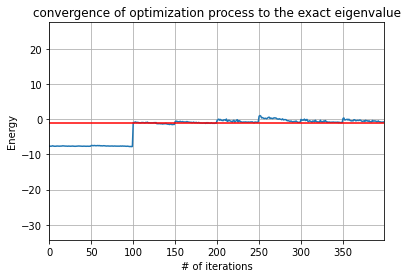

In [140]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [141]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [142]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [143]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 11.98it/s]


{'10': 287, '00': 730, '01': 6, '11': 1}
1.0
{'11': 574, '10': 396, '01': 36, '00': 18}
1.0
{'10': 962, '00': 56, '11': 5, '01': 1}
1.0


3it [00:00, 11.82it/s]

{'01': 108, '00': 368, '10': 452, '11': 96}
1.0
{'11': 746, '10': 170, '00': 22, '01': 86}
1.0
{'10': 817, '11': 110, '01': 88, '00': 9}
1.0



2it [00:00, 12.24it/s]

{'01': 131, '00': 753, '11': 21, '10': 119}
1.0
{'10': 210, '11': 473, '01': 278, '00': 63}
1.0


3it [00:00, 12.05it/s]


{'10': 668, '00': 240, '01': 90, '11': 26}
1.0


2it [00:00, 12.24it/s]

{'10': 302, '00': 688, '01': 25, '11': 9}
1.0
{'10': 400, '11': 536, '01': 77, '00': 11}
1.0


3it [00:00, 11.89it/s]


{'10': 917, '00': 74, '01': 20, '11': 13}
1.0


2it [00:00, 11.79it/s]

{'10': 406, '01': 43, '00': 569, '11': 6}
1.0
{'10': 371, '11': 561, '01': 88, '00': 4}
1.0


3it [00:00, 12.34it/s]


{'10': 903, '01': 79, '11': 7, '00': 35}
1.0


2it [00:00, 14.30it/s]

{'00': 438, '10': 200, '01': 242, '11': 144}
1.0
{'01': 193, '11': 655, '10': 115, '00': 61}
1.0


3it [00:00, 12.92it/s]


{'10': 598, '11': 180, '00': 23, '01': 223}
1.0


0it [00:00, ?it/s]

{'10': 726, '00': 213, '11': 41, '01': 44}
1.0


2it [00:00, 16.28it/s]

{'01': 186, '11': 383, '10': 404, '00': 51}
1.0


3it [00:00, 15.19it/s]


{'00': 135, '10': 808, '01': 78, '11': 3}
1.0


0it [00:00, ?it/s]

{'10': 455, '00': 421, '11': 128, '01': 20}
1.0


2it [00:00, 10.08it/s]

{'10': 540, '11': 311, '01': 75, '00': 98}
1.0
{'10': 846, '01': 143, '00': 14, '11': 21}

3it [00:00, 10.03it/s]



1.0


0it [00:00, ?it/s]

{'10': 558, '11': 67, '00': 381, '01': 18}

2it [00:00, 11.57it/s]


1.0
{'11': 562, '01': 37, '00': 51, '10': 374}
1.0


3it [00:00, 11.23it/s]


{'10': 910, '00': 29, '01': 76, '11': 9}
1.0


2it [00:00, 10.09it/s]

{'10': 475, '11': 110, '01': 82, '00': 357}
1.0
{'10': 418, '00': 39, '11': 498, '01': 69}
1.0


3it [00:00,  9.28it/s]


{'10': 794, '11': 112, '01': 96, '00': 22}
1.0


2it [00:00, 12.49it/s]

{'10': 129, '00': 774, '01': 66, '11': 55}
1.0
{'10': 391, '00': 294, '11': 338, '01': 1}
1.0


3it [00:00, 11.95it/s]


{'00': 156, '10': 746, '01': 119, '11': 3}
1.0


2it [00:00, 11.90it/s]

{'00': 422, '10': 514, '11': 83, '01': 5}
1.0
{'11': 437, '10': 485, '00': 93, '01': 9}
1.0


3it [00:00, 11.75it/s]

{'11': 36, '10': 896, '01': 67, '00': 25}
1.0



0it [00:00, ?it/s]

{'01': 39, '00': 439, '10': 461, '11': 85}
1.0
{'00': 339, '10': 265, '11': 374, '01': 46}

3it [00:00, 12.15it/s]



1.0
{'01': 109, '00': 280, '10': 629, '11': 6}
1.0


3it [00:00, 11.99it/s]


{'00': 307, '10': 393, '11': 238, '01': 86}
1.0
{'11': 884, '00': 64, '01': 33, '10': 43}
1.0
{'11': 267, '10': 639, '00': 75, '01': 43}
1.0


3it [00:00, 12.56it/s]


{'00': 725, '01': 7, '10': 224, '11': 68}
1.0
{'11': 550, '10': 226, '01': 40, '00': 208}
1.0
{'10': 743, '01': 33, '00': 197, '11': 51}
1.0


3it [00:00, 12.49it/s]


{'10': 592, '00': 358, '11': 55, '01': 19}
1.0
{'11': 527, '10': 402, '01': 76, '00': 19}
1.0
{'10': 908, '01': 70, '11': 8, '00': 38}
1.0


3it [00:00, 12.82it/s]


{'10': 654, '00': 298, '11': 39, '01': 33}
1.0
{'10': 359, '11': 568, '01': 38, '00': 59}
1.0
{'10': 916, '01': 75, '00': 22, '11': 11}
1.0


3it [00:00, 13.41it/s]


{'10': 885, '00': 72, '01': 58, '11': 9}
1.0
{'01': 246, '10': 422, '11': 270, '00': 86}
1.0
{'10': 706, '01': 61, '00': 250, '11': 7}
1.0


3it [00:00, 12.07it/s]


{'00': 525, '10': 480, '11': 19}
1.0
{'11': 606, '10': 396, '00': 14, '01': 8}
1.0
{'10': 998, '11': 15, '00': 2, '01': 9}
1.0


3it [00:00, 11.26it/s]


{'00': 561, '10': 387, '11': 71, '01': 5}
1.0
{'10': 377, '11': 584, '00': 44, '01': 19}
1.0
{'10': 947, '00': 7, '01': 41, '11': 29}
1.0


3it [00:00, 10.62it/s]

{'10': 465, '00': 458, '01': 45, '11': 56}
1.0
{'10': 301, '11': 721, '00': 1, '01': 1}
1.0
{'10': 914, '11': 104, '01': 6}
1.0



2it [00:00, 11.49it/s]

{'10': 530, '00': 464, '11': 29, '01': 1}
1.0
{'11': 613, '10': 394, '00': 8, '01': 9}
1.0
{'10': 994, '01': 18, '11': 12}
1.0


3it [00:00, 10.87it/s]
2it [00:00, 12.75it/s]

{'10': 699, '00': 304, '01': 8, '11': 13}
1.0
{'11': 449, '10': 488, '01': 76, '00': 11}
1.0


3it [00:00, 12.23it/s]


{'10': 937, '00': 62, '01': 22, '11': 3}
1.0


2it [00:00, 12.70it/s]

{'10': 515, '00': 467, '11': 41, '01': 1}
1.0
{'11': 642, '10': 355, '01': 13, '00': 14}
1.0


3it [00:00, 12.03it/s]


{'10': 970, '01': 33, '11': 20, '00': 1}
1.0


2it [00:00, 13.35it/s]

{'00': 403, '10': 605, '11': 14, '01': 2}
1.0
{'11': 524, '10': 452, '01': 23, '00': 25}
1.0


3it [00:00, 12.06it/s]


{'10': 985, '00': 27, '01': 12}
1.0


2it [00:00, 12.33it/s]

{'00': 467, '10': 521, '11': 36}
1.0
{'10': 418, '11': 588, '01': 14, '00': 4}
1.0


3it [00:00, 12.01it/s]


{'10': 989, '11': 17, '01': 16, '00': 2}
1.0


2it [00:00, 14.30it/s]

{'10': 628, '11': 9, '00': 364, '01': 23}
1.0
{'10': 552, '11': 435, '01': 35, '00': 2}
1.0


3it [00:00, 14.01it/s]


{'10': 975, '01': 20, '00': 24, '11': 5}
1.0


2it [00:00, 13.46it/s]

{'00': 541, '10': 466, '11': 15, '01': 2}
1.0
{'11': 515, '10': 485, '01': 3, '00': 21}
1.0


3it [00:00, 11.27it/s]


{'10': 994, '01': 19, '00': 5, '11': 6}
1.0


2it [00:00, 12.32it/s]

{'11': 31, '00': 589, '10': 392, '01': 12}
1.0
{'11': 708, '10': 294, '00': 18, '01': 4}
1.0


3it [00:00, 13.35it/s]


{'10': 959, '00': 11, '11': 53, '01': 1}
1.0


2it [00:00, 15.54it/s]

{'00': 524, '10': 434, '11': 65, '01': 1}
1.0
{'11': 571, '10': 422, '00': 21, '01': 10}
1.0


3it [00:00, 14.02it/s]


{'01': 27, '10': 965, '11': 27, '00': 5}
1.0


2it [00:00, 13.95it/s]

{'00': 720, '10': 268, '01': 11, '11': 25}
1.0
{'10': 422, '11': 521, '00': 77, '01': 4}
1.0


3it [00:00, 13.47it/s]


{'10': 949, '00': 32, '01': 41, '11': 2}
1.0


2it [00:00, 11.59it/s]

{'11': 34, '10': 542, '00': 448}
1.0
{'11': 612, '10': 385, '01': 21, '00': 6}
1.0


3it [00:00, 12.09it/s]


{'10': 993, '01': 16, '11': 15}
1.0


0it [00:00, ?it/s]

{'10': 503, '00': 445, '11': 40, '01': 36}
1.0


3it [00:00, 10.85it/s]


{'10': 301, '11': 719, '01': 2, '00': 2}
1.0
{'10': 921, '11': 101, '00': 2}
1.0


0it [00:00, ?it/s]

{'10': 520, '00': 459, '11': 44, '01': 1}
1.0


3it [00:00, 12.10it/s]

{'10': 427, '11': 574, '01': 14, '00': 9}
1.0
{'10': 988, '11': 12, '01': 23, '00': 1}
1.0



0it [00:00, ?it/s]

{'10': 594, '11': 53, '00': 360, '01': 17}
1.0


3it [00:00, 12.15it/s]


{'11': 504, '01': 93, '10': 377, '00': 50}
1.0
{'10': 902, '01': 70, '00': 49, '11': 3}
1.0


3it [00:00, 13.36it/s]


{'00': 514, '11': 15, '10': 495}
1.0
{'11': 605, '10': 409, '00': 3, '01': 7}
1.0
{'10': 991, '11': 15, '01': 9, '00': 9}
1.0


3it [00:00, 13.54it/s]


{'10': 487, '11': 20, '00': 507, '01': 10}
1.0
{'11': 601, '10': 408, '01': 13, '00': 2}
1.0
{'10': 998, '00': 3, '11': 8, '01': 15}
1.0


3it [00:00, 13.72it/s]


{'10': 595, '11': 30, '00': 375, '01': 24}
1.0
{'11': 591, '10': 383, '00': 19, '01': 31}
1.0
{'10': 970, '00': 12, '01': 32, '11': 10}
1.0


3it [00:00, 12.49it/s]


{'10': 460, '00': 542, '11': 7, '01': 15}
1.0
{'11': 538, '10': 465, '01': 19, '00': 2}
1.0
{'10': 1001, '01': 17, '11': 2, '00': 4}
1.0


3it [00:00, 11.11it/s]

{'00': 463, '10': 551, '01': 8, '11': 2}
1.0
{'11': 501, '10': 483, '01': 33, '00': 7}
1.0
{'10': 988, '01': 11, '00': 22, '11': 3}
1.0



3it [00:00, 11.34it/s]


{'10': 503, '00': 499, '11': 7, '01': 15}
1.0
{'10': 408, '11': 582, '01': 29, '00': 5}
1.0
{'10': 990, '01': 24, '11': 9, '00': 1}
1.0


3it [00:00, 12.24it/s]


{'00': 628, '10': 384, '11': 5, '01': 7}
1.0
{'11': 587, '10': 425, '01': 9, '00': 3}
1.0
{'10': 993, '11': 10, '00': 17, '01': 4}
1.0


3it [00:00, 11.50it/s]


{'00': 597, '10': 413, '01': 11, '11': 3}
1.0
{'11': 614, '10': 386, '01': 22, '00': 2}
1.0
{'10': 991, '01': 17, '00': 7, '11': 9}
1.0


3it [00:00, 12.55it/s]


{'10': 445, '00': 562, '01': 17}
1.0
{'10': 444, '11': 568, '00': 9, '01': 3}
1.0
{'10': 1009, '00': 4, '01': 7, '11': 4}
1.0


3it [00:00, 12.92it/s]


{'10': 498, '00': 523, '01': 3}
1.0
{'11': 559, '10': 461, '01': 3, '00': 1}
1.0
{'10': 1018, '11': 4, '01': 2}
1.0


2it [00:00, 10.35it/s]

{'00': 538, '10': 470, '11': 3, '01': 13}
1.0
{'11': 496, '10': 515, '00': 7, '01': 6}
1.0
{'10': 1008, '01': 11, '11': 3, '00': 2}
1.0


3it [00:00, 10.88it/s]
3it [00:00, 14.38it/s]


{'10': 483, '00': 537, '01': 4}
1.0
{'11': 499, '10': 521, '01': 4}
1.0
{'10': 1016, '01': 6, '00': 2}
1.0


0it [00:00, ?it/s]

{'00': 571, '10': 437, '11': 13, '01': 3}
1.0


3it [00:00, 11.74it/s]

{'10': 518, '11': 492, '00': 10, '01': 4}
1.0
{'10': 1009, '11': 2, '01': 9, '00': 4}
1.0



3it [00:00, 11.66it/s]


{'10': 471, '00': 541, '01': 8, '11': 4}
1.0
{'10': 480, '11': 538, '01': 6}
1.0
{'10': 1017, '01': 6, '11': 1}
1.0


3it [00:00, 12.09it/s]

{'00': 572, '10': 448, '01': 3, '11': 1}
1.0
{'11': 512, '10': 500, '01': 12}
1.0
{'10': 1014, '01': 6, '11': 1, '00': 3}
1.0
[2.94977799 2.4959509  2.21796168 5.43190979 0.51718909 0.78336544
 2.58609889 5.19416872 0.47957156 3.27587096 4.7178985  3.70604525
 2.82406943 1.12036445 3.20518746 3.66378395]

2it [00:00, 14.66it/s]

{'00': 542, '10': 476, '01': 6}
1.0
{'11': 504, '10': 514, '01': 5, '00': 1}
1.0


3it [00:00, 13.01it/s]

{'10': 1014, '01': 7, '00': 3}
1.0
CPU times: total: 12.3 s
Wall time: 13.1 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.1408930834105357

Approximation Error
0.11092638968621811


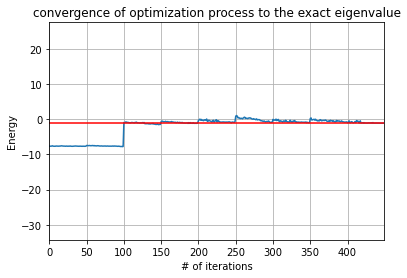

In [144]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [145]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 11.33it/s]


{'11': 846, '00': 95, '01': 73, '10': 10}
1.0
{'00': 321, '01': 41, '11': 438, '10': 224}
1.0
{'00': 70, '01': 296, '11': 627, '10': 31}
1.0


3it [00:00, 12.09it/s]


{'10': 128, '00': 69, '11': 662, '01': 165}
1.0
{'11': 203, '00': 513, '10': 277, '01': 31}
1.0
{'01': 370, '00': 184, '11': 463, '10': 7}
1.0


3it [00:00, 10.59it/s]


{'11': 656, '01': 11, '00': 304, '10': 53}
1.0
{'11': 501, '00': 435, '10': 77, '01': 11}
1.0
{'00': 190, '01': 233, '11': 420, '10': 181}
1.0


3it [00:00, 12.65it/s]


{'00': 333, '11': 650, '10': 32, '01': 9}
1.0
{'11': 411, '00': 547, '10': 64, '01': 2}
1.0
{'11': 319, '01': 320, '10': 148, '00': 237}
1.0


2it [00:00, 10.73it/s]

{'11': 504, '10': 34, '00': 429, '01': 57}
1.0
{'00': 454, '01': 47, '11': 461, '10': 62}
1.0
{'01': 394, '11': 162, '10': 355, '00': 113}
1.0


3it [00:00, 11.06it/s]
2it [00:00, 12.11it/s]

{'10': 138, '00': 216, '11': 544, '01': 126}
1.0
{'00': 400, '11': 464, '01': 143, '10': 17}
1.0


3it [00:00, 11.99it/s]


{'01': 510, '10': 345, '11': 139, '00': 30}
1.0


2it [00:00, 12.41it/s]

{'11': 652, '00': 93, '10': 250, '01': 29}
1.0
{'00': 337, '11': 356, '01': 242, '10': 89}
1.0


3it [00:00, 11.53it/s]


{'10': 284, '00': 57, '01': 519, '11': 164}
1.0


2it [00:00, 11.23it/s]

{'11': 427, '00': 195, '01': 269, '10': 133}
1.0
{'00': 692, '11': 144, '10': 34, '01': 154}
1.0
{'01': 678, '00': 177, '10': 155, '11': 14}

3it [00:00, 10.21it/s]



1.0


2it [00:00, 12.23it/s]

{'11': 636, '01': 161, '00': 170, '10': 57}
1.0
{'00': 327, '11': 504, '10': 121, '01': 72}
1.0


3it [00:00, 12.56it/s]


{'10': 149, '11': 479, '01': 309, '00': 87}
1.0


2it [00:00, 11.67it/s]

{'11': 412, '00': 392, '01': 195, '10': 25}
1.0
{'10': 49, '11': 442, '01': 145, '00': 388}
1.0


3it [00:00, 11.25it/s]


{'01': 395, '10': 323, '11': 179, '00': 127}
1.0


0it [00:00, ?it/s]

{'10': 308, '11': 265, '00': 342, '01': 109}
1.0
{'11': 773, '00': 147, '01': 43, '10': 61}

2it [00:00, 11.84it/s]


1.0


3it [00:00, 10.45it/s]


{'00': 19, '11': 211, '10': 600, '01': 194}
1.0


0it [00:00, ?it/s]

{'00': 307, '11': 489, '10': 83, '01': 145}
1.0


2it [00:00,  9.58it/s]

{'11': 716, '10': 121, '01': 30, '00': 157}
1.0
{'11': 492, '00': 88, '10': 324, '01': 120}
1.0


3it [00:00, 10.31it/s]
0it [00:00, ?it/s]

{'00': 577, '11': 88, '10': 261, '01': 98}
1.0


2it [00:00, 10.40it/s]

{'11': 714, '10': 236, '00': 71, '01': 3}
1.0
{'10': 791, '11': 155, '01': 40, '00': 38}

3it [00:00, 10.86it/s]



1.0


0it [00:00, ?it/s]

{'00': 637, '10': 332, '01': 45, '11': 10}
1.0


2it [00:00, 12.96it/s]

{'10': 548, '11': 399, '00': 75, '01': 2}
1.0


3it [00:00, 12.11it/s]


{'01': 52, '10': 943, '11': 8, '00': 21}
1.0


0it [00:00, ?it/s]

{'10': 604, '00': 347, '01': 67, '11': 6}
1.0


3it [00:00, 11.90it/s]


{'01': 148, '10': 570, '11': 250, '00': 56}
1.0
{'10': 796, '11': 40, '00': 161, '01': 27}
1.0


0it [00:00, ?it/s]

{'00': 607, '10': 345, '11': 18, '01': 54}
1.0


2it [00:00, 10.09it/s]

{'10': 491, '11': 453, '00': 70, '01': 10}
1.0
{'10': 934, '11': 10, '01': 56, '00': 24}
1.0


3it [00:00,  9.82it/s]
0it [00:00, ?it/s]

{'00': 555, '10': 406, '11': 38, '01': 25}
1.0


3it [00:00, 11.94it/s]


{'00': 64, '10': 571, '11': 381, '01': 8}
1.0
{'10': 937, '01': 55, '00': 21, '11': 11}
1.0


0it [00:00, ?it/s]

{'00': 497, '11': 271, '10': 242, '01': 14}
1.0


3it [00:00, 11.18it/s]

{'10': 848, '11': 71, '00': 18, '01': 87}
1.0
{'10': 710, '00': 41, '11': 202, '01': 71}
1.0



0it [00:00, ?it/s]

{'00': 490, '10': 442, '01': 83, '11': 9}

3it [00:00, 11.47it/s]



1.0
{'10': 549, '01': 23, '11': 422, '00': 30}
1.0
{'10': 912, '01': 63, '11': 47, '00': 2}
1.0


3it [00:00, 11.27it/s]


{'10': 458, '11': 52, '00': 351, '01': 163}
1.0
{'10': 532, '11': 235, '00': 222, '01': 35}
1.0
{'10': 711, '01': 203, '11': 32, '00': 78}
1.0


2it [00:00, 11.09it/s]

{'00': 651, '10': 320, '01': 50, '11': 3}
1.0
{'10': 660, '11': 286, '00': 68, '01': 10}
1.0
{'10': 903, '00': 53, '11': 55, '01': 13}
1.0


3it [00:00, 10.74it/s]
3it [00:00, 11.68it/s]


{'00': 388, '10': 545, '01': 78, '11': 13}
1.0
{'11': 511, '10': 409, '00': 83, '01': 21}
1.0
{'10': 876, '00': 24, '01': 95, '11': 29}
1.0


3it [00:00, 13.78it/s]


{'10': 289, '00': 699, '01': 25, '11': 11}
1.0
{'10': 533, '11': 401, '00': 86, '01': 4}
1.0
{'10': 937, '01': 33, '11': 4, '00': 50}
1.0


3it [00:00, 11.59it/s]


{'10': 360, '00': 499, '11': 64, '01': 101}
1.0
{'11': 322, '10': 620, '00': 44, '01': 38}
1.0
{'11': 76, '10': 854, '01': 82, '00': 12}
1.0


3it [00:00, 11.48it/s]


{'10': 250, '11': 138, '00': 584, '01': 52}
1.0
{'10': 613, '00': 132, '11': 231, '01': 48}
1.0
{'10': 782, '01': 134, '00': 54, '11': 54}
1.0


3it [00:00, 10.48it/s]

{'10': 659, '00': 147, '01': 164, '11': 54}
1.0
{'10': 373, '11': 303, '01': 73, '00': 275}
1.0
{'00': 172, '01': 194, '10': 647, '11': 11}
1.0



3it [00:00, 12.82it/s]


{'00': 767, '10': 233, '11': 14, '01': 10}
1.0
{'01': 40, '10': 395, '11': 461, '00': 128}
1.0
{'10': 860, '01': 15, '00': 140, '11': 9}
1.0


0it [00:00, ?it/s]

{'00': 579, '10': 270, '11': 94, '01': 81}
1.0


3it [00:00, 11.76it/s]

{'10': 478, '00': 148, '11': 324, '01': 74}
1.0
{'10': 814, '00': 51, '01': 157, '11': 2}
1.0



3it [00:00, 11.20it/s]


{'00': 556, '10': 394, '11': 23, '01': 51}
1.0
{'10': 598, '00': 67, '11': 353, '01': 6}
1.0
{'10': 933, '00': 25, '01': 53, '11': 13}
1.0


3it [00:00, 10.30it/s]


{'00': 546, '10': 383, '11': 93, '01': 2}
1.0
{'11': 555, '00': 60, '10': 402, '01': 7}
1.0
{'10': 900, '11': 56, '01': 48, '00': 20}
1.0


3it [00:00, 10.89it/s]

{'10': 430, '00': 534, '01': 39, '11': 21}
1.0
{'11': 497, '00': 90, '10': 436, '01': 1}
1.0
{'10': 935, '01': 49, '00': 34, '11': 6}
1.0



3it [00:00,  9.89it/s]

{'00': 569, '10': 406, '11': 23, '01': 26}
1.0
{'10': 521, '11': 436, '00': 7, '01': 60}
1.0
{'10': 962, '01': 45, '00': 16, '11': 1}
1.0


3it [00:00,  9.55it/s]
3it [00:00, 12.04it/s]


{'10': 419, '00': 560, '01': 26, '11': 19}
1.0
{'10': 493, '11': 467, '01': 64}
1.0
{'10': 962, '00': 18, '01': 42, '11': 2}
1.0


3it [00:00, 10.01it/s]

{'00': 351, '10': 588, '11': 27, '01': 58}
1.0
{'11': 425, '10': 506, '00': 38, '01': 55}
1.0
{'01': 97, '10': 911, '00': 13, '11': 3}
1.0



3it [00:00, 12.25it/s]


{'10': 456, '00': 493, '01': 35, '11': 40}
1.0
{'10': 634, '01': 62, '11': 324, '00': 4}
1.0
{'10': 938, '00': 18, '11': 24, '01': 44}
1.0


3it [00:00, 12.09it/s]


{'00': 617, '10': 367, '11': 7, '01': 33}
1.0
{'10': 517, '11': 451, '01': 54, '00': 2}
1.0
{'10': 945, '01': 34, '11': 4, '00': 41}
1.0


3it [00:00, 13.20it/s]


{'10': 420, '00': 545, '01': 39, '11': 20}
1.0
{'11': 426, '10': 537, '01': 40, '00': 21}
1.0
{'10': 939, '01': 69, '11': 10, '00': 6}
1.0


3it [00:00, 11.40it/s]


{'10': 517, '00': 434, '01': 48, '11': 25}
1.0
{'11': 456, '00': 22, '10': 497, '01': 49}
1.0
{'10': 956, '01': 63, '11': 3, '00': 2}
1.0


3it [00:00, 13.27it/s]


{'10': 526, '00': 419, '01': 62, '11': 17}
1.0
{'11': 454, '10': 492, '01': 42, '00': 36}
1.0
{'10': 952, '01': 64, '11': 6, '00': 2}
1.0


3it [00:00, 12.53it/s]


{'10': 532, '00': 372, '01': 97, '11': 23}
1.0
{'11': 505, '10': 418, '00': 43, '01': 58}
1.0
{'10': 878, '01': 108, '11': 28, '00': 10}
1.0


3it [00:00, 11.63it/s]


{'10': 498, '00': 426, '11': 61, '01': 39}
1.0
{'11': 331, '10': 581, '01': 69, '00': 43}
1.0
{'10': 904, '01': 87, '11': 30, '00': 3}
1.0


3it [00:00, 10.43it/s]

{'00': 412, '01': 76, '10': 499, '11': 37}
1.0
{'11': 560, '10': 380, '01': 65, '00': 19}
1.0
{'10': 922, '01': 64, '11': 27, '00': 11}
1.0



3it [00:00, 14.43it/s]


{'00': 514, '10': 465, '01': 28, '11': 17}
1.0
{'10': 486, '11': 486, '01': 42, '00': 10}
1.0
{'10': 984, '01': 35, '00': 4, '11': 1}
1.0


3it [00:00, 12.10it/s]


{'10': 506, '00': 480, '01': 26, '11': 12}
1.0
{'11': 429, '10': 575, '01': 13, '00': 7}
1.0
{'10': 966, '00': 14, '11': 31, '01': 13}
1.0


3it [00:00, 11.55it/s]

{'10': 489, '00': 455, '11': 38, '01': 42}
1.0
{'10': 456, '11': 488, '00': 32, '01': 48}
1.0
{'10': 936, '01': 86, '00': 2}
1.0



3it [00:00, 11.22it/s]


{'10': 313, '00': 615, '11': 54, '01': 42}
1.0
{'11': 498, '10': 410, '01': 76, '00': 40}
1.0
{'10': 887, '01': 108, '00': 29}
1.0


3it [00:00, 10.90it/s]


{'10': 485, '00': 497, '11': 36, '01': 6}
1.0
{'11': 560, '10': 421, '00': 12, '01': 31}
1.0
{'10': 969, '01': 43, '11': 12}
1.0


3it [00:00, 14.27it/s]


{'10': 490, '00': 490, '01': 31, '11': 13}
1.0
{'10': 508, '11': 470, '01': 32, '00': 14}
1.0
{'10': 973, '11': 3, '01': 42, '00': 6}
1.0


3it [00:00, 13.42it/s]


{'00': 591, '10': 413, '11': 15, '01': 5}
1.0
{'11': 536, '10': 445, '00': 32, '01': 11}
1.0
{'10': 983, '01': 32, '00': 7, '11': 2}
1.0


2it [00:00, 11.85it/s]

{'10': 485, '00': 492, '11': 20, '01': 27}
1.0
{'10': 447, '11': 524, '01': 44, '00': 9}
1.0
{'10': 964, '01': 54, '11': 3, '00': 3}
1.0

3it [00:00, 11.05it/s]



[3.62615399 1.4288699  4.19470797 6.87220345 5.3970496  6.25232276
 3.88984091 6.24811418 1.71077245 2.35218461 1.99118601 3.71427462
 5.00817321 1.07780501 0.76575428 1.87799322]


2it [00:00, 17.92it/s]

{'00': 474, '01': 43, '10': 487, '11': 20}
1.0
{'11': 487, '10': 494, '01': 32, '00': 11}
1.0


3it [00:00, 14.52it/s]

{'10': 980, '01': 40, '00': 4}
1.0
CPU times: total: 12.4 s
Wall time: 13.7 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-1.1232442787348234

Approximation Error
0.09374114845217053


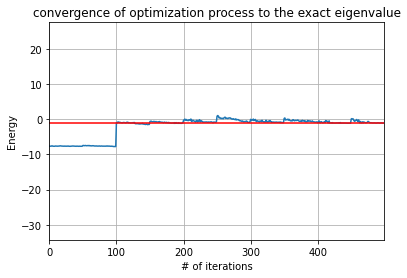

In [146]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [147]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [148]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

3it [00:00,  8.84it/s]

{'00': 309, '01': 271, '11': 33, '10': 411}
1.0
{'10': 400, '01': 301, '00': 298, '11': 25}
1.0
{'10': 461, '00': 247, '01': 290, '11': 26}
1.0


4it [00:00,  8.60it/s]


{'00': 301, '10': 403, '01': 296, '11': 24}
1.0


2it [00:00, 14.31it/s]

{'01': 552, '11': 123, '00': 139, '10': 210}
1.0
{'01': 532, '10': 233, '00': 143, '11': 116}
1.0
{'10': 211, '01': 566, '00': 121, '11': 126}
1.0


4it [00:00, 11.68it/s]


{'01': 559, '10': 212, '00': 145, '11': 108}
1.0


1it [00:00,  9.20it/s]

{'01': 124, '10': 354, '00': 342, '11': 204}
1.0


2it [00:00,  9.20it/s]

{'10': 322, '11': 223, '00': 327, '01': 152}
1.0
{'01': 133, '00': 325, '11': 225, '10': 341}
1.0


4it [00:00, 10.78it/s]


{'11': 211, '10': 360, '01': 124, '00': 329}
1.0


2it [00:00, 13.24it/s]

{'00': 426, '10': 480, '01': 117, '11': 1}
1.0
{'10': 444, '01': 129, '00': 449, '11': 2}
1.0
{'10': 461, '01': 132, '00': 429, '11': 2}
1.0


4it [00:00, 11.71it/s]


{'00': 450, '10': 449, '01': 125}
1.0


0it [00:00, ?it/s]

{'00': 640, '01': 185, '11': 36, '10': 163}
1.0


2it [00:00, 11.68it/s]

{'00': 628, '10': 182, '01': 178, '11': 36}
1.0
{'01': 191, '00': 626, '10': 169, '11': 38}
1.0


4it [00:00, 11.96it/s]


{'00': 636, '01': 176, '10': 166, '11': 46}
1.0


0it [00:00, ?it/s]

{'01': 401, '00': 255, '10': 175, '11': 193}
1.0


2it [00:00, 13.83it/s]

{'01': 368, '11': 176, '00': 264, '10': 216}
1.0
{'00': 227, '10': 225, '01': 398, '11': 174}
1.0
{'01': 402, '00': 248, '11': 187, '10': 187}

4it [00:00, 11.44it/s]



1.0


2it [00:00, 11.28it/s]

{'00': 734, '10': 93, '11': 125, '01': 72}
1.0
{'11': 114, '01': 95, '00': 733, '10': 82}
1.0


4it [00:00,  9.60it/s]


{'00': 734, '01': 90, '11': 101, '10': 99}
1.0
{'00': 692, '10': 98, '01': 99, '11': 135}
1.0


2it [00:00, 11.67it/s]

{'01': 398, '00': 527, '11': 35, '10': 64}
1.0
{'01': 395, '00': 506, '10': 90, '11': 33}
1.0
{'01': 379, '00': 541, '10': 68, '11': 36}
1.0


4it [00:00, 11.98it/s]


{'01': 377, '00': 542, '11': 30, '10': 75}
1.0


2it [00:00, 13.30it/s]

{'00': 564, '01': 322, '10': 80, '11': 58}
1.0
{'00': 541, '01': 360, '11': 45, '10': 78}
1.0
{'01': 340, '10': 79, '00': 534, '11': 71}
1.0


4it [00:00, 12.16it/s]


{'01': 337, '00': 548, '10': 95, '11': 44}
1.0


0it [00:00, ?it/s]

{'00': 796, '01': 107, '10': 102, '11': 19}
1.0


2it [00:00, 13.42it/s]

{'00': 789, '10': 98, '01': 122, '11': 15}
1.0
{'00': 784, '01': 108, '11': 15, '10': 117}
1.0


4it [00:00, 12.88it/s]


{'00': 803, '11': 13, '10': 97, '01': 111}
1.0


0it [00:00, ?it/s]

{'00': 849, '01': 92, '11': 81, '10': 2}
1.0


2it [00:00, 13.96it/s]

{'01': 97, '00': 830, '11': 88, '10': 9}
1.0
{'00': 838, '11': 98, '01': 81, '10': 7}
1.0


4it [00:00, 13.65it/s]


{'00': 830, '01': 101, '11': 84, '10': 9}
1.0


0it [00:00, ?it/s]

{'00': 668, '01': 236, '10': 108, '11': 12}
1.0


2it [00:00, 12.55it/s]

{'10': 124, '01': 234, '00': 655, '11': 11}
1.0
{'01': 239, '00': 686, '10': 90, '11': 9}
1.0


4it [00:00, 12.12it/s]


{'00': 681, '01': 213, '11': 15, '10': 115}
1.0


0it [00:00, ?it/s]

{'01': 102, '00': 587, '11': 102, '10': 233}
1.0


2it [00:00, 11.13it/s]

{'00': 567, '01': 112, '10': 231, '11': 114}
1.0
{'01': 99, '10': 234, '00': 579, '11': 112}
1.0
{'00': 563, '11': 109, '01': 121, '10': 231}

4it [00:00, 10.40it/s]



1.0


0it [00:00, ?it/s]

{'00': 696, '10': 110, '01': 203, '11': 15}
1.0


2it [00:00, 14.12it/s]

{'00': 704, '01': 204, '10': 102, '11': 14}
1.0
{'00': 711, '01': 190, '11': 13, '10': 110}
1.0


4it [00:00, 12.92it/s]


{'00': 723, '10': 118, '01': 167, '11': 16}
1.0


0it [00:00, ?it/s]

{'00': 376, '01': 111, '10': 515, '11': 22}
1.0


2it [00:00, 12.00it/s]

{'01': 111, '10': 512, '00': 380, '11': 21}
1.0
{'00': 392, '10': 497, '01': 116, '11': 19}
1.0


4it [00:00, 12.10it/s]


{'10': 537, '11': 20, '00': 371, '01': 96}
1.0


0it [00:00, ?it/s]

{'00': 814, '10': 108, '11': 17, '01': 85}
1.0
{'00': 790, '10': 110, '01': 105, '11': 19}
1.0


3it [00:00, 17.01it/s]

{'00': 788, '01': 115, '10': 108, '11': 13}
1.0


4it [00:00, 14.44it/s]


{'10': 111, '01': 108, '00': 787, '11': 18}
1.0


0it [00:00, ?it/s]

{'00': 781, '01': 126, '11': 14, '10': 103}
1.0


2it [00:00, 11.80it/s]

{'00': 784, '01': 110, '10': 114, '11': 16}
1.0
{'00': 784, '01': 120, '10': 107, '11': 13}
1.0


4it [00:00, 13.33it/s]


{'00': 778, '01': 100, '10': 128, '11': 18}
1.0


0it [00:00, ?it/s]

{'00': 716, '10': 228, '01': 73, '11': 7}
1.0


2it [00:00, 12.49it/s]

{'00': 716, '10': 224, '01': 79, '11': 5}
1.0
{'00': 733, '10': 205, '01': 76, '11': 10}
1.0


4it [00:00, 12.09it/s]


{'00': 755, '10': 178, '01': 80, '11': 11}
1.0


0it [00:00, ?it/s]

{'00': 629, '01': 271, '10': 123, '11': 1}
1.0


2it [00:00, 12.83it/s]

{'00': 622, '01': 289, '10': 112, '11': 1}
1.0
{'10': 103, '00': 636, '01': 283, '11': 2}
1.0


4it [00:00, 11.32it/s]


{'00': 623, '10': 104, '01': 295, '11': 2}
1.0


0it [00:00, ?it/s]

{'00': 821, '10': 78, '01': 119, '11': 6}
1.0


2it [00:00, 14.38it/s]

{'00': 806, '10': 90, '11': 11, '01': 117}
1.0
{'00': 812, '10': 87, '01': 112, '11': 13}
1.0


4it [00:00, 11.66it/s]

{'00': 816, '01': 113, '10': 86, '11': 9}
1.0


4it [00:00, 11.92it/s]
1it [00:00,  9.95it/s]

{'00': 884, '01': 106, '10': 33, '11': 1}
1.0


2it [00:00,  9.91it/s]

{'00': 891, '01': 111, '10': 21, '11': 1}
1.0


3it [00:00,  9.45it/s]

{'00': 917, '01': 76, '10': 31}
1.0
{'00': 897, '10': 23, '01': 103, '11': 1}


4it [00:00, 10.33it/s]


1.0


0it [00:00, ?it/s]

{'00': 884, '10': 48, '01': 88, '11': 4}
1.0


2it [00:00, 12.89it/s]

{'00': 893, '10': 40, '01': 87, '11': 4}
1.0
{'00': 899, '10': 48, '01': 76, '11': 1}
1.0


4it [00:00, 11.23it/s]


{'00': 892, '01': 77, '10': 50, '11': 5}
1.0


0it [00:00, ?it/s]

{'00': 859, '10': 50, '01': 110, '11': 5}
1.0


2it [00:00, 15.16it/s]

{'00': 842, '01': 112, '10': 64, '11': 6}
1.0
{'00': 868, '01': 95, '10': 59, '11': 2}
1.0


4it [00:00, 14.73it/s]

{'00': 857, '01': 110, '10': 55, '11': 2}
1.0


4it [00:00, 14.80it/s]
2it [00:00, 11.08it/s]

{'00': 865, '10': 40, '01': 116, '11': 3}
1.0
{'00': 860, '11': 5, '01': 117, '10': 42}
1.0


4it [00:00,  9.89it/s]


{'00': 839, '01': 130, '10': 54, '11': 1}
1.0
{'01': 119, '00': 861, '10': 37, '11': 7}
1.0


0it [00:00, ?it/s]

{'00': 969, '01': 40, '10': 11, '11': 4}
1.0


2it [00:00, 12.24it/s]

{'00': 939, '01': 67, '10': 8, '11': 10}
1.0
{'00': 957, '11': 10, '01': 49, '10': 8}
1.0


4it [00:00, 11.01it/s]


{'00': 971, '01': 38, '10': 6, '11': 9}
1.0


0it [00:00, ?it/s]

{'00': 934, '01': 52, '10': 30, '11': 8}
1.0


2it [00:00, 11.37it/s]

{'00': 924, '10': 19, '01': 63, '11': 18}
1.0
{'10': 21, '00': 940, '01': 53, '11': 10}
1.0


4it [00:00, 10.29it/s]


{'01': 59, '00': 937, '10': 17, '11': 11}
1.0


0it [00:00, ?it/s]

{'00': 911, '10': 91, '01': 21, '11': 1}
1.0


2it [00:00, 11.49it/s]

{'00': 915, '10': 77, '01': 31, '11': 1}
1.0
{'00': 914, '10': 81, '01': 29}
1.0


4it [00:00, 10.24it/s]


{'00': 914, '10': 81, '01': 28, '11': 1}
1.0


0it [00:00, ?it/s]

{'00': 935, '10': 29, '01': 50, '11': 10}
1.0


2it [00:00, 10.43it/s]

{'00': 953, '11': 8, '01': 39, '10': 24}
1.0
{'00': 957, '10': 28, '01': 30, '11': 9}
1.0


4it [00:00, 10.30it/s]

{'00': 950, '01': 38, '11': 14, '10': 22}
1.0


4it [00:00, 10.29it/s]
1it [00:00,  8.47it/s]

{'00': 982, '11': 13, '01': 27, '10': 2}
1.0
{'00': 965, '11': 10, '01': 46, '10': 3}
1.0


3it [00:00, 12.54it/s]

{'00': 967, '11': 16, '01': 41}
1.0


4it [00:00, 11.00it/s]


{'00': 966, '01': 43, '11': 14, '10': 1}
1.0


0it [00:00, ?it/s]

{'00': 968, '01': 45, '11': 10, '10': 1}
1.0

2it [00:00, 10.93it/s]


{'00': 983, '01': 30, '11': 9, '10': 2}
1.0
{'00': 967, '01': 46, '11': 9, '10': 2}
1.0


4it [00:00, 12.45it/s]


{'00': 971, '11': 7, '01': 44, '10': 2}
1.0


0it [00:00, ?it/s]

{'00': 964, '11': 8, '01': 39, '10': 13}
1.0


2it [00:00, 10.88it/s]

{'00': 952, '11': 2, '01': 50, '10': 20}
1.0
{'00': 951, '01': 50, '11': 3, '10': 20}
1.0


4it [00:00, 11.47it/s]


{'00': 962, '11': 11, '10': 16, '01': 35}
1.0


0it [00:00, ?it/s]

{'00': 955, '01': 39, '10': 29, '11': 1}
1.0


2it [00:00, 10.04it/s]

{'00': 962, '01': 40, '10': 21, '11': 1}
1.0


4it [00:00,  9.97it/s]

{'00': 964, '01': 37, '10': 18, '11': 5}
1.0
{'00': 972, '01': 33, '10': 19}
1.0


4it [00:00,  9.98it/s]
0it [00:00, ?it/s]

{'01': 64, '00': 942, '10': 18}
1.0


2it [00:00, 10.13it/s]

{'00': 945, '01': 62, '10': 17}
1.0


4it [00:00, 10.79it/s]


{'00': 950, '01': 54, '10': 20}
1.0
{'00': 938, '10': 17, '01': 69}
1.0


1it [00:00,  9.97it/s]

{'00': 963, '01': 42, '10': 16, '11': 3}
1.0


4it [00:00, 13.24it/s]

{'00': 966, '01': 41, '10': 13, '11': 4}
1.0
{'00': 973, '01': 35, '10': 13, '11': 3}
1.0
{'00': 963, '11': 3, '01': 32, '10': 26}
1.0



2it [00:00, 12.01it/s]

{'00': 953, '11': 3, '01': 47, '10': 21}
1.0
{'01': 31, '00': 971, '11': 1, '10': 21}
1.0
{'00': 957, '11': 3, '10': 21, '01': 43}
1.0


4it [00:00, 11.67it/s]


{'00': 964, '10': 19, '01': 40, '11': 1}
1.0


2it [00:00, 14.02it/s]

{'10': 20, '00': 952, '01': 52}
1.0
{'01': 31, '00': 963, '10': 30}
1.0
{'00': 963, '10': 28, '01': 33}
1.0


4it [00:00, 13.23it/s]


{'01': 48, '00': 951, '10': 25}
1.0


0it [00:00, ?it/s]

{'00': 878, '11': 15, '01': 90, '10': 41}
1.0


2it [00:00, 10.78it/s]

{'00': 878, '01': 93, '10': 45, '11': 8}
1.0


4it [00:00, 10.65it/s]

{'00': 880, '10': 45, '01': 92, '11': 7}
1.0
{'00': 901, '01': 73, '11': 12, '10': 38}
1.0


4it [00:00, 10.64it/s]
2it [00:00, 10.47it/s]

{'00': 966, '01': 42, '10': 9, '11': 7}
1.0
{'00': 947, '11': 16, '01': 54, '10': 7}
1.0
{'00': 961, '01': 44, '10': 8, '11': 11}
1.0


4it [00:00, 11.88it/s]


{'00': 949, '11': 9, '01': 53, '10': 13}
1.0


0it [00:00, ?it/s]

{'00': 978, '10': 19, '11': 9, '01': 18}
1.0
{'00': 971, '11': 14, '10': 18, '01': 21}

2it [00:00, 11.33it/s]


1.0
{'01': 25, '00': 975, '10': 13, '11': 11}
1.0


4it [00:00, 11.11it/s]

{'00': 978, '11': 14, '10': 14, '01': 18}
1.0


4it [00:00, 11.10it/s]
2it [00:00, 14.20it/s]

{'00': 949, '10': 42, '11': 9, '01': 24}
1.0
{'00': 930, '01': 41, '10': 44, '11': 9}
1.0
{'01': 22, '00': 939, '11': 9, '10': 54}
1.0


4it [00:00, 13.83it/s]


{'00': 933, '10': 48, '11': 7, '01': 36}
1.0


2it [00:00, 12.06it/s]

{'00': 980, '01': 35, '10': 7, '11': 2}
1.0
{'00': 978, '01': 33, '11': 2, '10': 11}
1.0


4it [00:00, 11.62it/s]


{'00': 969, '01': 44, '11': 5, '10': 6}
1.0
{'00': 961, '01': 48, '10': 12, '11': 3}
1.0


0it [00:00, ?it/s]

{'00': 947, '01': 45, '10': 32}
1.0


3it [00:00, 13.33it/s]

{'00': 944, '01': 49, '10': 30, '11': 1}
1.0
{'00': 948, '10': 38, '01': 36, '11': 2}
1.0
{'00': 939, '10': 32, '01': 51, '11': 2}
1.0


4it [00:00, 12.47it/s]
2it [00:00, 14.74it/s]

{'00': 950, '10': 26, '01': 45, '11': 3}
1.0
{'00': 952, '01': 42, '10': 20, '11': 10}
1.0
{'00': 939, '10': 32, '01': 51, '11': 2}
1.0


4it [00:00, 11.54it/s]


{'00': 935, '01': 59, '10': 27, '11': 3}
1.0


2it [00:00, 12.57it/s]

{'00': 986, '01': 37, '10': 1}
1.0
{'00': 985, '01': 35, '11': 2, '10': 2}
1.0
{'00': 992, '01': 31, '10': 1}
1.0


4it [00:00, 12.25it/s]


{'00': 981, '01': 39, '10': 3, '11': 1}
1.0


0it [00:00, ?it/s]

{'00': 974, '01': 47, '11': 2, '10': 1}
1.0


3it [00:00, 11.39it/s]

{'00': 973, '01': 49, '10': 2}
1.0
{'00': 969, '01': 52, '11': 2, '10': 1}
1.0


4it [00:00, 11.70it/s]


{'00': 975, '01': 49}
1.0


1it [00:00,  9.62it/s]

{'00': 946, '01': 61, '10': 17}
1.0
{'10': 26, '00': 941, '01': 57}
1.0


3it [00:00, 12.43it/s]

{'00': 954, '01': 50, '10': 20}
1.0


4it [00:00, 11.51it/s]


{'00': 941, '10': 16, '01': 67}
1.0


0it [00:00, ?it/s]

{'00': 974, '01': 41, '10': 8, '11': 1}
1.0


2it [00:00, 16.17it/s]

{'00': 971, '01': 41, '11': 3, '10': 9}
1.0
{'00': 963, '01': 53, '11': 2, '10': 6}
1.0


4it [00:00, 14.40it/s]


{'00': 973, '10': 9, '01': 42}
1.0


0it [00:00, ?it/s]

{'00': 960, '11': 4, '01': 52, '10': 8}
1.0


2it [00:00, 11.64it/s]

{'00': 968, '01': 35, '10': 15, '11': 6}
1.0
{'00': 972, '01': 41, '10': 5, '11': 6}
1.0


4it [00:00, 11.81it/s]

{'00': 977, '01': 36, '10': 9, '11': 2}
1.0



0it [00:00, ?it/s]

{'00': 953, '01': 64, '10': 3, '11': 4}
1.0


2it [00:00, 14.91it/s]

{'00': 950, '01': 67, '10': 3, '11': 4}
1.0


4it [00:00, 14.72it/s]

{'01': 67, '00': 953, '11': 3, '10': 1}
1.0
{'00': 953, '01': 62, '11': 6, '10': 3}
1.0


4it [00:00, 14.65it/s]
0it [00:00, ?it/s]

{'00': 965, '01': 40, '10': 8, '11': 11}
1.0


2it [00:00, 10.33it/s]

{'00': 951, '11': 14, '01': 48, '10': 11}
1.0
{'00': 936, '10': 19, '01': 52, '11': 17}
1.0


4it [00:00, 11.62it/s]


{'00': 956, '11': 13, '01': 52, '10': 3}
1.0
[3.50256473 1.80981405 4.63019046 2.44453464 3.54711833 2.97619521
 2.96659335 6.36195636 3.55568014 0.61560836 5.89081349 0.64725111
 3.23077551 5.1873095  0.84290748 5.39791033]


0it [00:00, ?it/s]

{'00': 978, '01': 43, '11': 1, '10': 2}
1.0


2it [00:00, 10.12it/s]

{'00': 986, '01': 38}
1.0
{'00': 971, '01': 51, '11': 1, '10': 1}
1.0


4it [00:00, 11.20it/s]

{'00': 981, '01': 40, '10': 3}
1.0
CPU times: total: 17 s
Wall time: 18.2 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9953128729644596

Approximation Error
0.009744071819630148


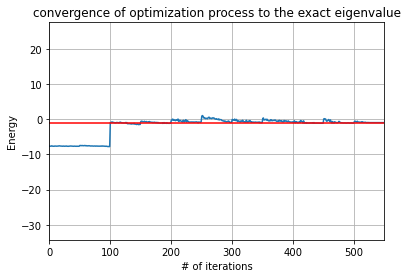

In [149]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [150]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

2it [00:00, 14.09it/s]

{'01': 459, '11': 432, '00': 103, '10': 30}
1.0
{'01': 475, '11': 418, '00': 101, '10': 30}
1.0
{'11': 444, '00': 103, '01': 450, '10': 27}
1.0


4it [00:00, 12.16it/s]


{'11': 413, '01': 455, '10': 45, '00': 111}
1.0


2it [00:00, 10.78it/s]

{'11': 481, '00': 195, '01': 309, '10': 39}
1.0
{'01': 317, '11': 452, '00': 205, '10': 50}
1.0


4it [00:00,  9.20it/s]


{'11': 436, '00': 226, '10': 34, '01': 328}
1.0
{'00': 218, '11': 458, '01': 304, '10': 44}
1.0


0it [00:00, ?it/s]

{'11': 401, '01': 331, '00': 196, '10': 96}
1.0


2it [00:00, 13.85it/s]

{'11': 415, '01': 338, '00': 188, '10': 83}
1.0
{'11': 391, '01': 342, '00': 185, '10': 106}
1.0


4it [00:00, 12.30it/s]


{'01': 366, '10': 99, '11': 388, '00': 171}
1.0


2it [00:00, 12.63it/s]

{'00': 334, '01': 222, '11': 338, '10': 130}
1.0
{'00': 338, '11': 355, '01': 212, '10': 119}
1.0
{'01': 206, '00': 330, '10': 117, '11': 371}
1.0


4it [00:00, 12.33it/s]


{'01': 221, '11': 336, '10': 161, '00': 306}
1.0


0it [00:00, ?it/s]

{'01': 105, '11': 636, '10': 83, '00': 200}
1.0


2it [00:00, 10.46it/s]

{'11': 595, '00': 217, '01': 103, '10': 109}
1.0
{'11': 629, '01': 93, '00': 219, '10': 83}
1.0


4it [00:00, 11.33it/s]


{'00': 222, '11': 623, '01': 91, '10': 88}
1.0


2it [00:00, 13.59it/s]

{'10': 99, '00': 277, '01': 243, '11': 405}
1.0
{'00': 277, '01': 271, '11': 370, '10': 106}
1.0
{'11': 405, '00': 278, '01': 233, '10': 108}
1.0


4it [00:00, 11.91it/s]


{'00': 259, '01': 253, '10': 118, '11': 394}
1.0


0it [00:00, ?it/s]

{'01': 540, '10': 79, '00': 187, '11': 218}
1.0


2it [00:00, 10.73it/s]

{'01': 560, '11': 208, '00': 193, '10': 63}
1.0
{'01': 549, '11': 236, '00': 173, '10': 66}
1.0


4it [00:00, 11.21it/s]


{'11': 211, '10': 76, '00': 189, '01': 548}
1.0


0it [00:00, ?it/s]

{'00': 338, '10': 165, '01': 298, '11': 223}
1.0


2it [00:00, 10.98it/s]

{'01': 326, '10': 157, '00': 343, '11': 198}
1.0
{'11': 205, '00': 320, '01': 305, '10': 194}
1.0


4it [00:00, 10.95it/s]

{'01': 334, '11': 186, '10': 157, '00': 347}
1.0


4it [00:00, 10.95it/s]
0it [00:00, ?it/s]

{'10': 166, '01': 384, '00': 347, '11': 127}
1.0


2it [00:00, 13.12it/s]

{'11': 124, '01': 385, '00': 346, '10': 169}
1.0
{'00': 357, '10': 172, '01': 410, '11': 85}
1.0
{'01': 394, '00': 368, '10': 154, '11': 108}
1.0


4it [00:00, 11.62it/s]
0it [00:00, ?it/s]

{'10': 392, '01': 205, '00': 381, '11': 46}

1it [00:00,  9.82it/s]


1.0


2it [00:00,  9.24it/s]

{'10': 384, '00': 348, '01': 233, '11': 59}
1.0
{'01': 218, '00': 387, '10': 375, '11': 44}
1.0


4it [00:00,  9.85it/s]


{'00': 387, '10': 384, '01': 213, '11': 40}
1.0


0it [00:00, ?it/s]

{'00': 436, '01': 203, '10': 362, '11': 23}
1.0


2it [00:00, 11.33it/s]

{'00': 411, '10': 411, '11': 18, '01': 184}
1.0
{'10': 404, '01': 189, '00': 418, '11': 13}
1.0


4it [00:00, 10.12it/s]


{'10': 370, '00': 424, '01': 218, '11': 12}
1.0


0it [00:00, ?it/s]

{'10': 376, '00': 534, '01': 88, '11': 26}
1.0


2it [00:00, 10.64it/s]

{'00': 542, '10': 358, '01': 91, '11': 33}
1.0
{'10': 365, '00': 516, '11': 46, '01': 97}
1.0


4it [00:00, 10.82it/s]


{'10': 354, '01': 97, '00': 534, '11': 39}
1.0


0it [00:00, ?it/s]

{'10': 278, '00': 470, '11': 155, '01': 121}
1.0


2it [00:00, 10.84it/s]

{'00': 453, '10': 300, '01': 110, '11': 161}
1.0
{'10': 288, '01': 122, '00': 461, '11': 153}
1.0


4it [00:00, 11.53it/s]


{'00': 444, '01': 127, '10': 292, '11': 161}
1.0


0it [00:00, ?it/s]

{'00': 586, '11': 192, '10': 240, '01': 6}
1.0


2it [00:00, 10.27it/s]

{'00': 623, '11': 183, '10': 208, '01': 10}
1.0
{'00': 658, '11': 177, '10': 185, '01': 4}
1.0


4it [00:00,  9.91it/s]


{'10': 207, '00': 629, '11': 183, '01': 5}
1.0


0it [00:00, ?it/s]

{'00': 815, '11': 106, '01': 37, '10': 66}

2it [00:00, 10.54it/s]


1.0
{'00': 848, '10': 66, '11': 82, '01': 28}
1.0
{'00': 793, '11': 127, '01': 28, '10': 76}
1.0


4it [00:00, 10.71it/s]


{'00': 812, '11': 107, '10': 66, '01': 39}
1.0


0it [00:00, ?it/s]

{'10': 72, '00': 830, '11': 91, '01': 31}
1.0


2it [00:00, 16.78it/s]

{'00': 823, '11': 105, '01': 30, '10': 66}
1.0
{'00': 819, '10': 64, '11': 117, '01': 24}
1.0


4it [00:00, 12.14it/s]

{'00': 826, '10': 62, '11': 110, '01': 26}
1.0


4it [00:00, 12.58it/s]
0it [00:00, ?it/s]

{'00': 801, '11': 105, '01': 36, '10': 82}
1.0


2it [00:00, 11.71it/s]

{'11': 105, '00': 804, '10': 82, '01': 33}
1.0
{'00': 816, '11': 115, '10': 57, '01': 36}
1.0


4it [00:00, 12.07it/s]


{'00': 843, '10': 63, '11': 95, '01': 23}
1.0


0it [00:00, ?it/s]

{'00': 861, '10': 50, '11': 67, '01': 46}
1.0
{'00': 861, '10': 47, '11': 79, '01': 37}
1.0


2it [00:00, 12.69it/s]

{'00': 836, '01': 37, '10': 59, '11': 92}
1.0


4it [00:00, 12.24it/s]


{'00': 856, '11': 79, '10': 49, '01': 40}
1.0


0it [00:00, ?it/s]

{'00': 753, '01': 33, '11': 228, '10': 10}
1.0


2it [00:00, 12.85it/s]

{'00': 760, '01': 40, '11': 210, '10': 14}
1.0
{'11': 196, '00': 786, '01': 28, '10': 14}
1.0


4it [00:00, 13.02it/s]


{'00': 765, '11': 206, '01': 36, '10': 17}
1.0


0it [00:00, ?it/s]

{'00': 627, '10': 281, '01': 76, '11': 40}
1.0


2it [00:00, 17.67it/s]

{'00': 619, '11': 49, '10': 285, '01': 71}
1.0
{'00': 629, '10': 276, '11': 39, '01': 80}
1.0


4it [00:00, 13.56it/s]


{'00': 602, '10': 286, '01': 79, '11': 57}
1.0


1it [00:00,  9.55it/s]

{'00': 711, '01': 109, '10': 103, '11': 101}
1.0


3it [00:00, 11.77it/s]

{'10': 84, '11': 103, '00': 719, '01': 118}
1.0
{'00': 689, '11': 124, '10': 98, '01': 113}
1.0


4it [00:00, 12.27it/s]


{'10': 103, '00': 691, '01': 107, '11': 123}
1.0


2it [00:00, 15.19it/s]

{'00': 923, '10': 56, '01': 42, '11': 3}
1.0
{'00': 890, '10': 72, '01': 58, '11': 4}
1.0
{'00': 902, '01': 61, '10': 58, '11': 3}
1.0


4it [00:00, 13.21it/s]


{'00': 904, '10': 62, '11': 4, '01': 54}
1.0


0it [00:00, ?it/s]

{'00': 790, '10': 137, '01': 38, '11': 59}
1.0


2it [00:00, 12.26it/s]

{'11': 67, '00': 776, '10': 139, '01': 42}
1.0
{'00': 797, '11': 56, '01': 29, '10': 142}
1.0


4it [00:00, 12.39it/s]


{'00': 787, '01': 40, '11': 60, '10': 137}
1.0


0it [00:00, ?it/s]

{'00': 868, '01': 148, '10': 8}
1.0


2it [00:00, 12.97it/s]

{'00': 882, '01': 131, '10': 9, '11': 2}
1.0
{'00': 888, '01': 125, '10': 10, '11': 1}
1.0


4it [00:00, 12.87it/s]


{'00': 880, '01': 122, '11': 2, '10': 20}
1.0


0it [00:00, ?it/s]

{'00': 876, '01': 142, '10': 5, '11': 1}
1.0


2it [00:00, 13.01it/s]

{'00': 879, '01': 138, '10': 2, '11': 5}
1.0
{'00': 886, '01': 136, '10': 2}
1.0


4it [00:00, 11.40it/s]

{'00': 893, '01': 125, '10': 5, '11': 1}
1.0


4it [00:00, 11.53it/s]
0it [00:00, ?it/s]

{'10': 32, '00': 645, '01': 292, '11': 55}
1.0


2it [00:00, 10.55it/s]

{'01': 268, '00': 670, '10': 35, '11': 51}
1.0
{'00': 672, '11': 49, '01': 260, '10': 43}
1.0


4it [00:00, 11.47it/s]


{'00': 682, '01': 266, '10': 36, '11': 40}
1.0


0it [00:00, ?it/s]

{'00': 718, '11': 31, '01': 263, '10': 12}
1.0


2it [00:00, 12.08it/s]

{'01': 274, '00': 722, '11': 18, '10': 10}
1.0
{'01': 256, '00': 728, '11': 23, '10': 17}
1.0


4it [00:00, 13.38it/s]


{'11': 23, '00': 736, '01': 250, '10': 15}
1.0


0it [00:00, ?it/s]

{'00': 838, '01': 70, '10': 101, '11': 15}
1.0


2it [00:00, 11.93it/s]

{'00': 817, '10': 97, '11': 19, '01': 91}
1.0
{'01': 78, '00': 843, '10': 85, '11': 18}
1.0


4it [00:00, 12.39it/s]


{'00': 825, '01': 67, '10': 110, '11': 22}
1.0


0it [00:00, ?it/s]

{'00': 863, '01': 153, '11': 8}
1.0


2it [00:00, 12.77it/s]

{'00': 870, '01': 143, '11': 10, '10': 1}
1.0
{'00': 868, '01': 151, '11': 4, '10': 1}
1.0


4it [00:00, 12.77it/s]


{'00': 860, '01': 160, '10': 1, '11': 3}
1.0


0it [00:00, ?it/s]

{'11': 31, '00': 507, '01': 482, '10': 4}
1.0


2it [00:00, 14.51it/s]

{'00': 497, '01': 504, '11': 18, '10': 5}
1.0
{'00': 495, '01': 496, '11': 32, '10': 1}
1.0


4it [00:00, 12.90it/s]


{'00': 487, '01': 508, '11': 26, '10': 3}
1.0


2it [00:00, 19.50it/s]

{'00': 842, '10': 67, '01': 99, '11': 16}
1.0
{'00': 875, '01': 88, '10': 55, '11': 6}
1.0
{'10': 70, '01': 86, '00': 852, '11': 16}
1.0


4it [00:00, 13.89it/s]


{'00': 849, '10': 64, '01': 104, '11': 7}
1.0


0it [00:00, ?it/s]

{'00': 841, '01': 118, '10': 62, '11': 3}
1.0


2it [00:00,  9.87it/s]

{'00': 866, '01': 104, '10': 51, '11': 3}
1.0
{'00': 871, '01': 100, '10': 52, '11': 1}
1.0
{'00': 838, '10': 53, '01': 127, '11': 6}
1.0


4it [00:00, 10.24it/s]
2it [00:00, 10.74it/s]

{'00': 873, '01': 148, '10': 2, '11': 1}
1.0
{'00': 875, '01': 146, '10': 1, '11': 2}
1.0
{'00': 870, '10': 4, '01': 147, '11': 3}
1.0


4it [00:00, 11.73it/s]


{'00': 868, '01': 148, '10': 5, '11': 3}
1.0


2it [00:00, 12.47it/s]

{'00': 728, '01': 144, '10': 51, '11': 101}
1.0
{'00': 760, '01': 125, '10': 44, '11': 95}
1.0
{'00': 746, '01': 120, '11': 116, '10': 42}
1.0


4it [00:00, 13.57it/s]


{'00': 719, '11': 105, '10': 58, '01': 142}
1.0


0it [00:00, ?it/s]

{'01': 149, '00': 869, '10': 4, '11': 2}
1.0


2it [00:00, 14.40it/s]

{'00': 890, '01': 123, '10': 10, '11': 1}
1.0
{'00': 898, '01': 120, '10': 5, '11': 1}
1.0


4it [00:00, 13.23it/s]

{'00': 876, '01': 141, '11': 4, '10': 3}
1.0



0it [00:00, ?it/s]

{'00': 769, '11': 85, '10': 77, '01': 93}
1.0


2it [00:00, 12.62it/s]

{'00': 753, '11': 96, '10': 83, '01': 92}
1.0
{'00': 746, '10': 84, '01': 95, '11': 99}
1.0


4it [00:00, 12.16it/s]


{'00': 767, '11': 78, '10': 82, '01': 97}
1.0


0it [00:00, ?it/s]

{'01': 171, '00': 814, '10': 31, '11': 8}
1.0


2it [00:00, 12.88it/s]

{'00': 819, '10': 33, '01': 167, '11': 5}
1.0
{'00': 832, '01': 157, '10': 30, '11': 5}
1.0


4it [00:00, 12.58it/s]


{'00': 821, '10': 42, '01': 156, '11': 5}
1.0


2it [00:00, 17.51it/s]

{'01': 154, '00': 839, '10': 25, '11': 6}
1.0
{'00': 839, '01': 164, '10': 14, '11': 7}
1.0
{'00': 838, '11': 10, '01': 169, '10': 7}
1.0


4it [00:00, 14.15it/s]


{'00': 831, '01': 164, '10': 25, '11': 4}
1.0


0it [00:00, ?it/s]

{'00': 892, '10': 50, '01': 76, '11': 6}
1.0


2it [00:00, 14.68it/s]

{'00': 897, '10': 51, '01': 69, '11': 7}
1.0
{'00': 921, '01': 53, '11': 3, '10': 47}
1.0


4it [00:00, 12.47it/s]

{'00': 904, '01': 70, '10': 43, '11': 7}
1.0



0it [00:00, ?it/s]

{'00': 857, '01': 148, '11': 13, '10': 6}
1.0


2it [00:00, 11.63it/s]

{'00': 844, '01': 157, '10': 17, '11': 6}
1.0
{'00': 852, '10': 14, '01': 149, '11': 9}
1.0


4it [00:00, 12.12it/s]


{'00': 858, '01': 138, '10': 12, '11': 16}
1.0


0it [00:00, ?it/s]

{'00': 920, '11': 33, '01': 58, '10': 13}
1.0


2it [00:00, 17.69it/s]

{'00': 886, '01': 86, '11': 47, '10': 5}
1.0
{'00': 896, '01': 82, '10': 8, '11': 38}
1.0


4it [00:00, 13.67it/s]


{'00': 902, '01': 71, '11': 40, '10': 11}
1.0


0it [00:00, ?it/s]

{'00': 860, '01': 153, '10': 5, '11': 6}
1.0


2it [00:00, 12.97it/s]

{'11': 1, '01': 153, '00': 865, '10': 5}
1.0
{'00': 844, '01': 165, '11': 7, '10': 8}
1.0
{'00': 854, '01': 156, '10': 7, '11': 7}

4it [00:00, 11.43it/s]



1.0


0it [00:00, ?it/s]

{'00': 922, '01': 94, '10': 6, '11': 2}
1.0


2it [00:00, 11.82it/s]

{'00': 896, '01': 119, '11': 5, '10': 4}
1.0
{'00': 898, '01': 117, '10': 5, '11': 4}
1.0


4it [00:00, 12.80it/s]


{'00': 889, '01': 124, '11': 3, '10': 8}
1.0


2it [00:00, 17.80it/s]

{'00': 864, '01': 141, '11': 11, '10': 8}
1.0
{'00': 886, '01': 128, '10': 7, '11': 3}
1.0
{'00': 880, '01': 131, '10': 9, '11': 4}
1.0


4it [00:00, 17.14it/s]


{'00': 894, '10': 10, '01': 114, '11': 6}
1.0


0it [00:00, ?it/s]

{'11': 10, '00': 869, '01': 137, '10': 8}
1.0


2it [00:00, 13.30it/s]

{'00': 848, '01': 153, '10': 11, '11': 12}
1.0
{'00': 869, '01': 136, '11': 10, '10': 9}
1.0


4it [00:00, 11.54it/s]

{'00': 854, '01': 145, '10': 15, '11': 10}
1.0


4it [00:00, 11.73it/s]
1it [00:00,  9.59it/s]

{'00': 879, '01': 132, '10': 10, '11': 3}
1.0


3it [00:00, 10.16it/s]

{'00': 885, '01': 117, '10': 14, '11': 8}
1.0
{'00': 879, '01': 138, '11': 1, '10': 6}
1.0
{'00': 885, '10': 10, '01': 122, '11': 7}

4it [00:00, 10.50it/s]



1.0


2it [00:00, 18.52it/s]

{'00': 838, '01': 159, '10': 19, '11': 8}
1.0
{'00': 861, '01': 133, '10': 15, '11': 15}
1.0
{'00': 859, '01': 142, '10': 20, '11': 3}
1.0
{'00': 850, '01': 148, '11': 12, '10': 14}

4it [00:00, 14.75it/s]



1.0


2it [00:00, 12.96it/s]

{'00': 872, '01': 139, '10': 9, '11': 4}
1.0
{'01': 139, '00': 871, '10': 13, '11': 1}
1.0
{'00': 868, '01': 143, '10': 11, '11': 2}
1.0


4it [00:00, 12.90it/s]


{'00': 872, '01': 144, '10': 8}
1.0


0it [00:00, ?it/s]

{'00': 876, '01': 122, '10': 20, '11': 6}
1.0


2it [00:00, 16.18it/s]

{'01': 168, '00': 838, '10': 12, '11': 6}
1.0
{'01': 115, '00': 889, '10': 14, '11': 6}
1.0
{'00': 866, '01': 136, '10': 16, '11': 6}
1.0


4it [00:00, 12.47it/s]
2it [00:00, 13.41it/s]

{'00': 913, '01': 95, '10': 14, '11': 2}
1.0
{'01': 104, '00': 903, '10': 16, '11': 1}
1.0
{'00': 898, '01': 107, '10': 18, '11': 1}
1.0


4it [00:00, 12.26it/s]


{'00': 920, '10': 22, '01': 81, '11': 1}
1.0
[1.73058533 2.00741756 6.40650311 4.3217963  5.80898442 2.30242373
 2.72998876 6.87489358 1.40984505 5.0099556  5.655777   1.54222257
 3.66674035 4.68210973 0.34812768 3.73186287]


1it [00:00,  9.82it/s]

{'00': 900, '01': 112, '10': 11, '11': 1}
1.0


2it [00:00,  9.80it/s]

{'00': 890, '01': 113, '10': 21}
1.0
{'00': 904, '01': 108, '10': 11, '11': 1}
1.0
{'00': 912, '01': 97, '10': 12, '11': 3}


4it [00:00, 10.13it/s]

1.0
CPU times: total: 16.5 s
Wall time: 17.5 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9638351708233397

Approximation Error
0.041061843343974676


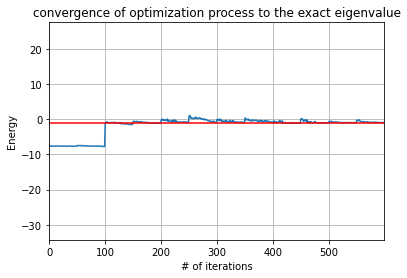

In [151]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)